## Rotating blob in a harmonic potential example
This notebook showcases how to fit a normalizing flow and a potential for a rotating blob in a harmonic potential

In [1]:
import astropy.coordinates as coord
import astropy.table as table
import astropy.units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import sys
import importlib
sys.path.append('../scripts/')
sys.path.append('../scripts/harmonic/')
sys.path.append('../data/')
import serializers_tf
import potential_tf
import toy_systems
import flow_ffjord_tf
import fit_all
import utils

import harmonic_mock
import flow_sampling
import plot_gaia
import plot_flow_projections
import plot_potential

import h5py

import os
from pathlib import Path

import importlib
importlib.reload(plot_gaia)

%matplotlib inline
plt.rcParams['figure.dpi'] = 140

2022-10-14 16:44:10.448980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 16:44:10.583894: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-14 16:44:10.621269: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 16:44:11.309879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Tensorflow version 2.10.0
Tensorflow version 2.10.0
Tensorflow Probability version 0.18.0


2022-10-14 16:44:12.797565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 16:44:13.913816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18517 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-10-14 16:44:13.914474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 20028 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:d8:00.0, compute capability: 7.5


Tensorflow version 2.10.0
Tensorflow version 2.10.0
Tensorflow Probability version 0.18.0
Tensorflow version 2.10.0
Tensorflow Probability version 0.18.0
Tensorflow version 2.10.0
Tensorflow version 2.10.0
Tensorflow version 2.10.0
Tensorflow version 2.10.0


# 1. Setting up the run directory

Creating the example run directory and options.json, specifying the normalizing flow and potential parameters.

The data is structured in a way as to imitate what `scripts/fit_all.py` would do
- `options_fname` - contains all the parameters that define the training process
- `data_fname` - contains the 6d phasespace info for the training data + attributes specifying the volume of validity (with uniform completness)
- `flow_fname` - where to store the trained flow
- `df_grads_fname` - where to store the samples of the trained flow, used for training the potential. Has 12 components
- `potential_fname` - where to store the trained potential

In [2]:
run_directory = '../runs/harmonic_example'
Path(run_directory).mkdir(parents=True, exist_ok=True)

options_fname = f'{run_directory}/options.json'
data_fname = f'{run_directory}/data/Harmonic_example.h5'
flow_fname = f'{run_directory}/models/df/flow'
df_grads_fname = f'{run_directory}/data/df_gradients.h5'
potential_fname = f'{run_directory}/models/Phi/Phi'

In [3]:
options_content = r"""{
  "df": {
    "n_flows": 1,
    "n_hidden": 3,
    "hidden_size": 32,
    "n_bij": 3,
    "reg": {
      "dv_dt_reg": 0,
      "kinetic_reg": 0.0001,
      "jacobian_reg": 0.0001
    },
    "n_epochs": 128,
    "batch_size": 8192,
    "lr": {
      "type": "step",
      "init": 0.005,
      "patience": 2048,
      "min_delta": 0.01,
      "final": 0.0001
    },
    "optimizer": "RAdam",
    "warmup_proportion": 0.0009765625,
    "max_checkpoints": 128,
    "checkpoint_every": 1,
    "checkpoint_hours": 1.0,
    "validation_frac": 0.25
  },
  "Phi": {
    "n_samples": 65336,
    "sample_batch_size": 2048,
    "grad_batch_size": 128,
    "n_hidden": 4,
    "hidden_size": 512,
    "xi": 1.0,
    "lam": 1.0,
    "l2": 0.1,
    "n_epochs": 256,
    "batch_size": 512,
    "lr": {
      "type": "step",
      "init": 0.01,
      "patience": 2048,
      "min_delta": 0.005
    },
    "optimizer": "RAdam",
    "warmup_proportion": 0.015625,
    "max_checkpoints": 128,
    "checkpoint_every": 16,
    "frameshift": {
      "omega0": 0.4,
      "omega0_trainable": true,
      "r_c0": 8.3,
      "r_c0_trainable": false,
      "u_x0": 0.093,
      "u_x0_trainable": true,
      "u_y0": 2.515,
      "u_y0_trainable": true,
      "u_z0": 0.0859,
      "u_z0_trainable": true
    },
    "r_c": 8.3
  }
}"""

with open(options_fname, 'w') as f:
    f.write(options_content)
params = fit_all.load_params(options_fname)

# 2. Create and save a mock dataset

The mock dataset is that of a gaussian blob of stars rotating in a harmonic potential in x-y-z

### Technical details:

The potential is given by
$$
\varphi(x, y, z) = \frac{1}{2}\omega^2 \left((x - r_c)^2 + y^2\right) +
\frac{1}{2}kz^2
$$

The mock data is generated for $r_\mathrm{inner} <= r=\sqrt{x^2+y^2+z^2} <= r_\mathrm{outer}$ (imitating DR3)
for a rotating clump of stars with a normal profile in $x-y-z-v_x-v_y-v_z$. The clump looks stationary in a rotating frame $(0,0,\omega)$.

The distribution function (satisfying CBE and stationarity in rotating frame) is given by
\begin{align*}
f(x, y, z, vx, vy, vz) = &g(x, \sigma_r)\cdot\\
                         &g(y, \sigma_r)\cdot\\
                         &g(z, \sigma_z)\cdot\\
                         &g(v_x, |\omega|\sigma_r)\cdot\\
                         &g(v_y - |\omega| r_c, \omega\sigma_r)\cdot\\
                         &g(v_z, |\omega|\sigma_z),
\end{align*}
where
$$
g(x, \sigma_r) = \frac{1}{\sigma_r \sqrt{2\pi}}\exp\left(-\frac{x^2}{2\sigma_r^2}\right)
$$
is the normal distribution.

Free parameters: $\omega$, $r_c$, $\sigma_r$, $r_\mathrm{inner}$, $r_\mathrm{outer}$, $\sigma_z$, $\vec u$. Chosen to imitate Gaia DR3.

In [4]:
n = 16384
r_c = 8.3          # 8.3 kpc       literature
omega = -0.25      # -25 km/s/kpc  taken from one of the rotating fits for DR3
sigma_r = 0.45     # 400 pc        chosen by gut feeling
sigma_z = 0.35     # 0.35 kp       literature
omega_z = -0.4
r_inner = 0.050    # 50 pc         inner limit of pop3 from DR3  (2.0 < M_G < 4.0)
r_outer = 2.0      # 1000 pc        outer limit of pop3 from DR3  (2.0 < M_G < 4.0)

error_r = 0.001 # 1 pc
error_v = 0.005 # 0.5 km/s


# Generate a mockdataset with noise, and guarantee it's complete between r_inner and r_outer
eta = harmonic_mock.gen_mock_data(int(1.2*n), r_c=r_c, omega=omega, sigma_r=sigma_r,
                                 omega_z=omega_z, sigma_z=sigma_z, r_inner=r_inner - error_r*5,
                                 r_outer=r_outer + error_r*5)
eta = harmonic_mock.noisify(eta, error_r, error_v)
eta = harmonic_mock.radial_cut(eta, r_inner, r_outer, n)

print(f'final eta, n={len(eta)}, shape={eta.shape}')

0.000 of generated datapoints fell outside the radial cuts
final eta, n=16384, shape=(16384, 6)


In [5]:
# Save to HDF5
Path(f'{run_directory}/data/').mkdir(parents=True, exist_ok=True)
with h5py.File(data_fname, 'w') as f:
    dset = f.create_dataset('eta', data=harmonic_mock.radial_cut(eta, r_inner, r_outer, n), compression='lzf')
    dset.attrs['r_c'] = r_c
    dset.attrs['sigma_r'] = sigma_r
    dset.attrs['sigma_z'] = sigma_z
    dset.attrs['omega'] = omega
    dset.attrs['omega_z'] = omega_z
    dset.attrs['r_inner'] = r_inner
    dset.attrs['r_outer'] = r_outer
    
    dset.attrs['volume_type'] = 'sphere'
    dset.attrs['parallax_min'] = 1/r_outer
    dset.attrs['parallax_max'] = 1/r_inner
    dset.attrs['spatial_unit'] = 'kpc'
    dset.attrs['velocity_unit'] = 'km/cs'
print('generated and saved mock data')

generated and saved mock data


# 3. Training a normalizing flow

In [8]:
data, attrs = fit_all.load_data(data_fname)
eta_train = data.numpy()
print("\n".join(f"{k:>15}: {v}" for k, v in attrs.items()))

          omega: -0.25
        omega_z: -0.4
   parallax_max: 20.0
   parallax_min: 0.5
            r_c: 8.3
        r_inner: 0.05
        r_outer: 2.0
        sigma_r: 0.45
        sigma_z: 0.35
   spatial_unit: kpc
  velocity_unit: km/cs
    volume_type: sphere
              n: 16384


In [ ]:
flows = fit_all.train_flows(data, flow_fname, **params['df'])

In [9]:
flows = fit_all.load_flows(flow_fname)

Distribution subclass FFJORDFlow inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**bas

Found 1 flows.
Loading flow 1 of 1 ...
../runs/harmonic_example/models/df


Distribution subclass FFJORDFlow inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**bas

# of trainable variables: 7698
loaded tfp.distributions.FFJORDFlow("DF", batch_shape=[], event_shape=[6], dtype=float32) from ../runs/harmonic_example/models/df/flow-95


### Visualising the flow

In [10]:
eta_sample = plot_flow_projections.sample_from_flows(flows, 2*n)

Distribution subclass FFJORDFlow inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init__(**bas

Rounding down # of samples: 32768 -> 32768
Tracing sample_batch for flow 1 of 1 ...


100% (32 of 32) |########################| Elapsed Time: 0:00:04 ETA:  00:00:00

In [11]:
# For convenience, one can calculate eta in cylindrical and spherical coordinates.
# Cylindrical is convenient to calculate w.r.t. galactic centre for finding v_circ
spherical_origin = (0, 0, 0)
cylindrical_origin = (8.3, 0, 0) 
coords_train = plot_flow_projections.calc_coords(eta_train, spherical_origin, cylindrical_origin)
coords_sample = plot_flow_projections.calc_coords(eta_sample, spherical_origin, cylindrical_origin)

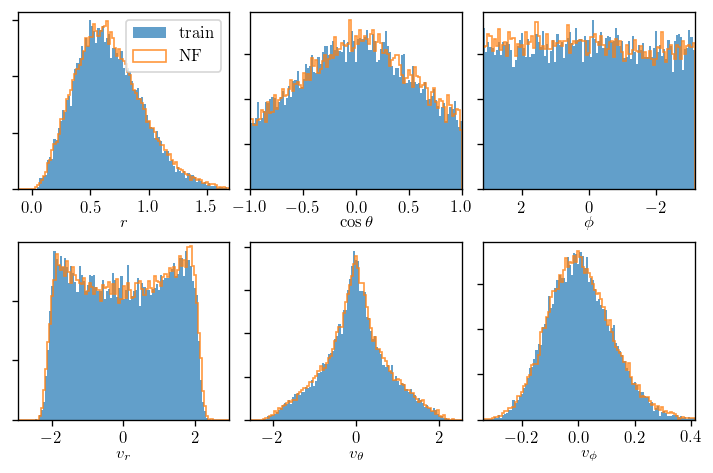

In [40]:
plot_flow_projections.plot_1d_marginals(coords_train, coords_sample, None, coordsys='sph', fig_fmt=[])

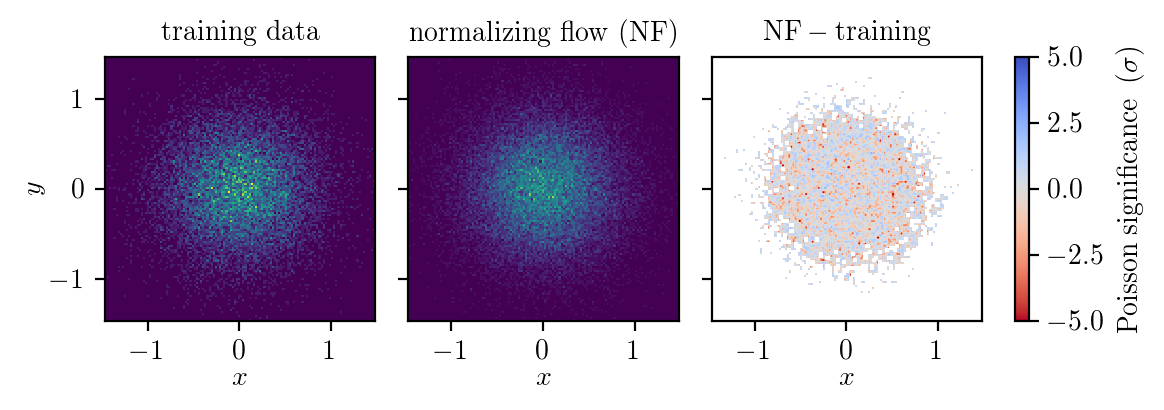

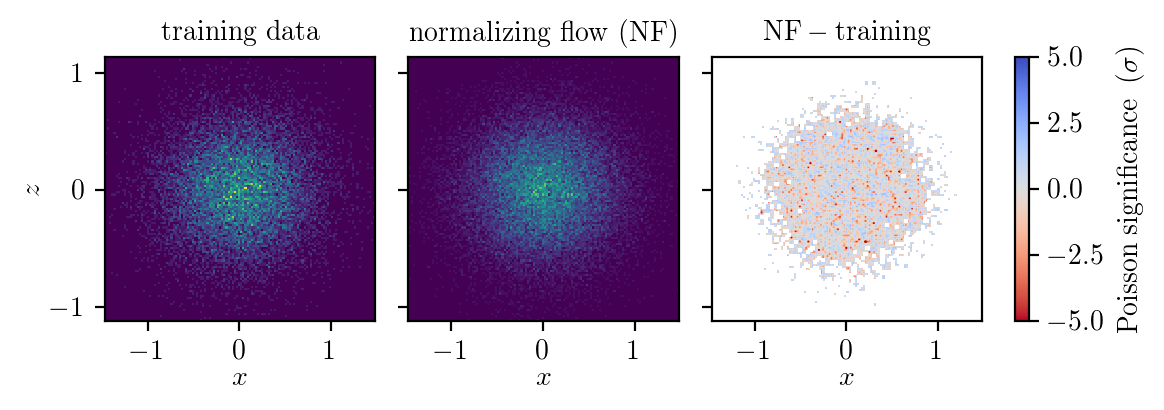

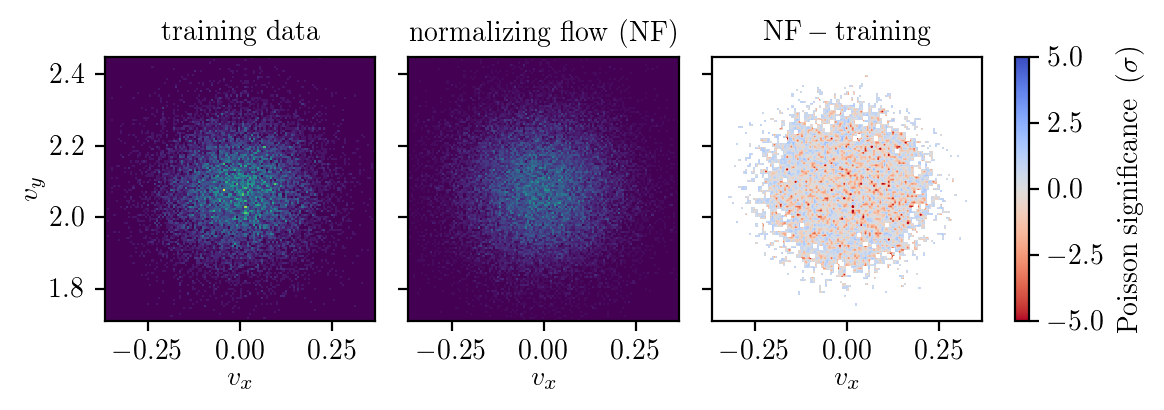

In [41]:
dims = [('x', 'y'),
        ('x', 'z'),
        ('vx', 'vy'),
    ]
for dim1, dim2 in dims:
    plot_flow_projections.plot_2d_marginal(coords_train, coords_sample, None, None, None, dim1, dim2, fig_fmt=[])

# 4. Sampling the flow for training the potential

In [17]:
# Cut the flow samples to the limits specified by the attributes in training data. Supports one flow
phi_params = params['Phi']
df_data = flow_sampling.sample_from_different_flows(
    flows, [attrs], phi_params['n_samples'],
    return_indiv=True,
    grad_batch_size=phi_params['grad_batch_size'],
    sample_batch_size=phi_params['sample_batch_size']
)
fit_all.save_df_data(df_data, df_grads_fname)

Sampling eta..


||100% | Elapsed: 0:00:02 | ETA:  00:00:00 | batches_done:     32, n_batches:     32, n_samples:    65336

Sampling gradients of eta..


||100% | Elapsed: 0:02:29 | ETA:  00:00:00 | batches_done:    511, n_batches:    511, n_samples:    65336

In [12]:
df_data = fit_all.load_df_data(df_grads_fname)

if 'n_samples' in params['Phi']:
    n_samples = params['Phi'].pop('n_samples')
    grad_batch_size = params['Phi'].pop('grad_batch_size')
    sample_batch_size = params['Phi'].pop('sample_batch_size')

# 5. Training a potential

In [ ]:
# Guided refers to a neural network (NN) that has a quadratic component and R^2 as one of the input features
phi_model, fs_model = fit_all.train_potential(df_data,
            potential_fname, include_frameshift=True,
            guided_potential=True, **params['Phi'])
phi_model = {'phi': phi_model, 'fs': fs_model}

### Visualise the trained models

In [10]:
phi_model = plot_potential.load_potential(os.path.dirname(potential_fname))

loaded PhiNNGuided(n_hidden=4, hidden_size=512) from ../runs/harmonic_example/models/Phi/Phi-15
loaded {'n_dim': 3, 'name': 'FrameShift'} from ../runs/harmonic_example/models/Phi/Phi-15


Displaying ../runs/harmonic_example/models/Phi/Phi-9_loss.txt


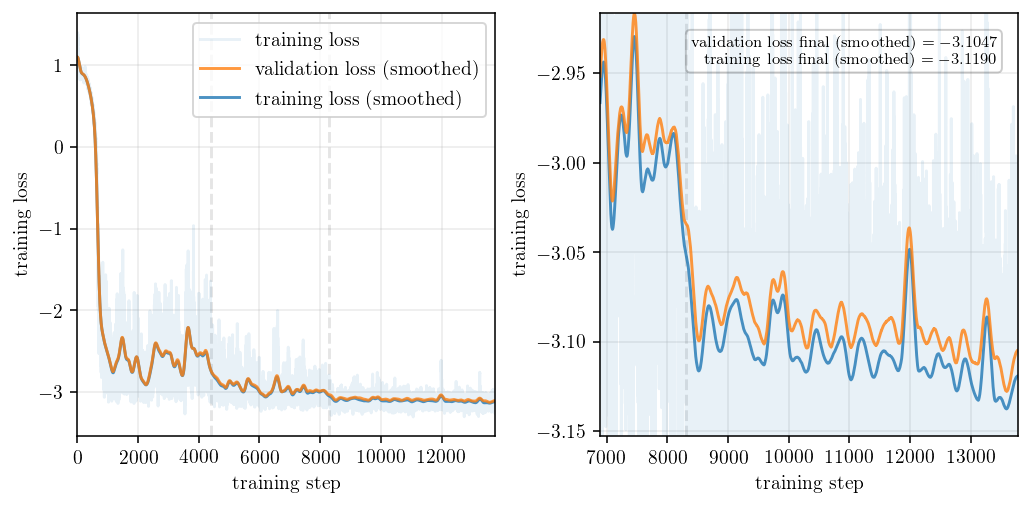

In [12]:
import glob

# Plot the loss
loss_fname = sorted(glob.glob(f'{potential_fname}*loss.txt'))[-1]
print(f'Displaying {loss_fname}')
loss_history, val_loss_history, lr_history, loss_noreg_history, _ = utils.load_loss_history(loss_fname)
utils.plot_loss(loss_history, val_loss_hist=val_loss_history, lr_hist=lr_history, smoothing='auto');

Plotting 2D slices of matter density ...
  --> (x, y)


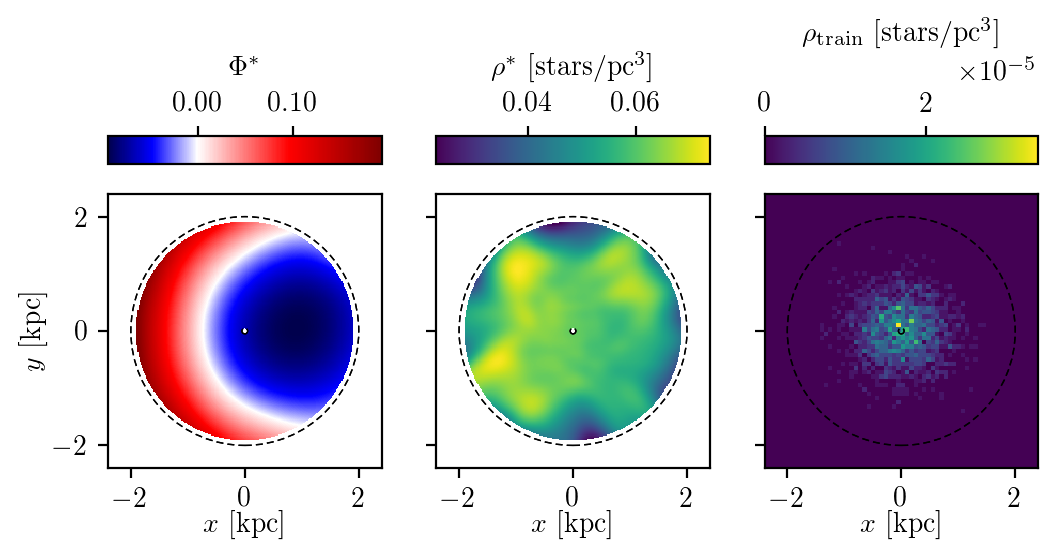

In [43]:
print('Plotting 2D slices of matter density ...')
dims = [
    ('x', 'y', 'z', 0.),
]
for dim1, dim2, dimz, z in dims:
    print(f'  --> ({dim1}, {dim2})')
    plot_gaia.plot_rho(phi_model, coords_train, None, dim1, dim2, dimz, z, padding=0.95, attrs=attrs, save=False)
    plt.show()

Plotting 2D slices of forces ...
  --> (x, y)


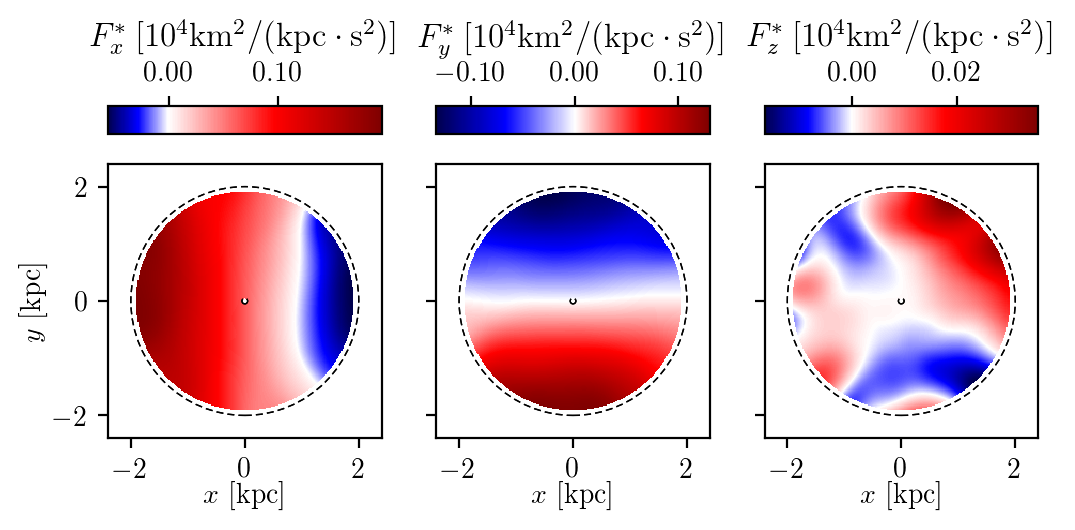

  --> (x, z)


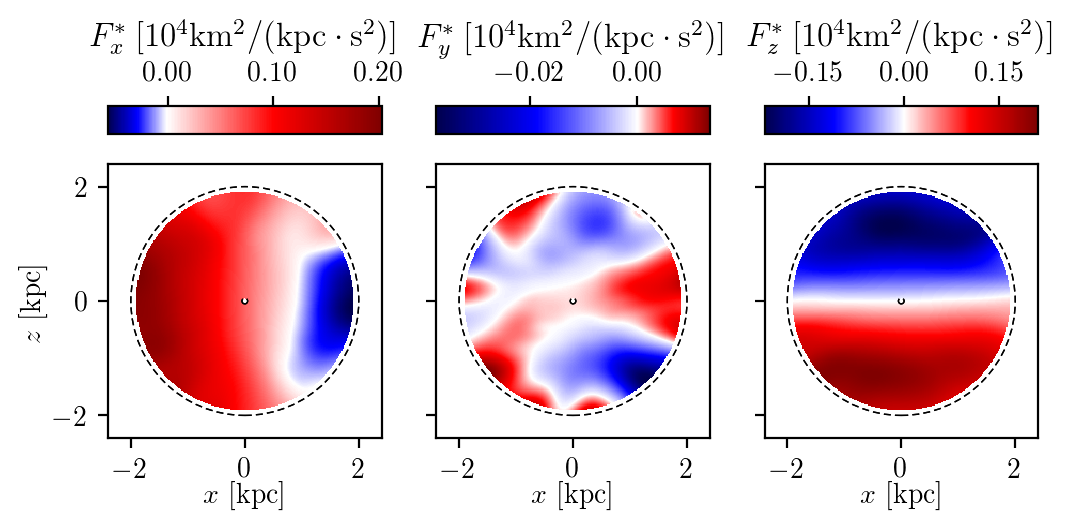

  --> (y, z)


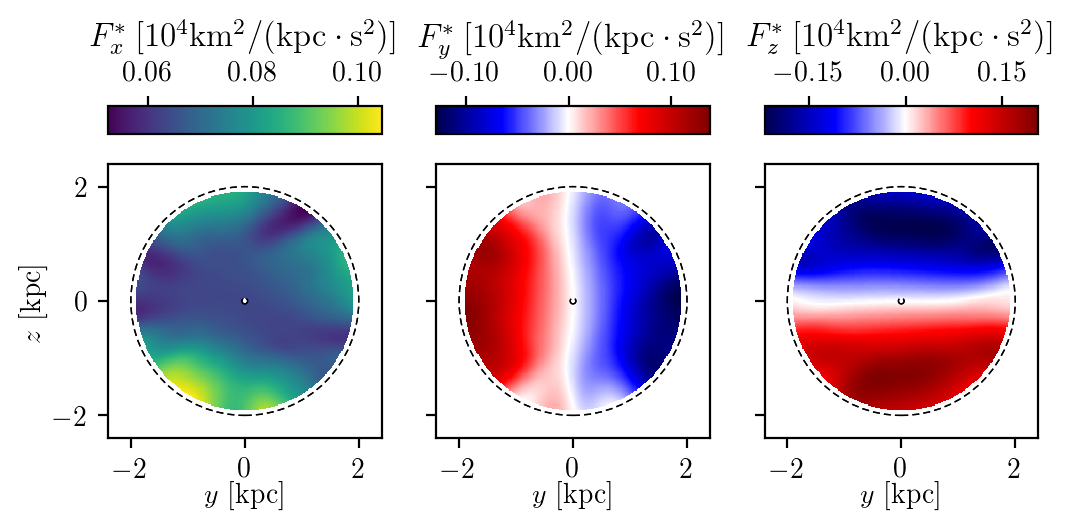

In [44]:
print('Plotting 2D slices of forces ...')
dims = [
    ('x', 'y', 'z', 0.),
    ('x', 'z', 'y', 0.),
    ('y', 'z', 'x', 0.),
]
for dim1, dim2, dimz, z in dims:
    print(f'  --> ({dim1}, {dim2})')
    plot_gaia.plot_force_2d_slice(phi_model, None, dim1, dim2, dimz, z, padding=0.95, attrs=attrs, save=False)
    plt.show()

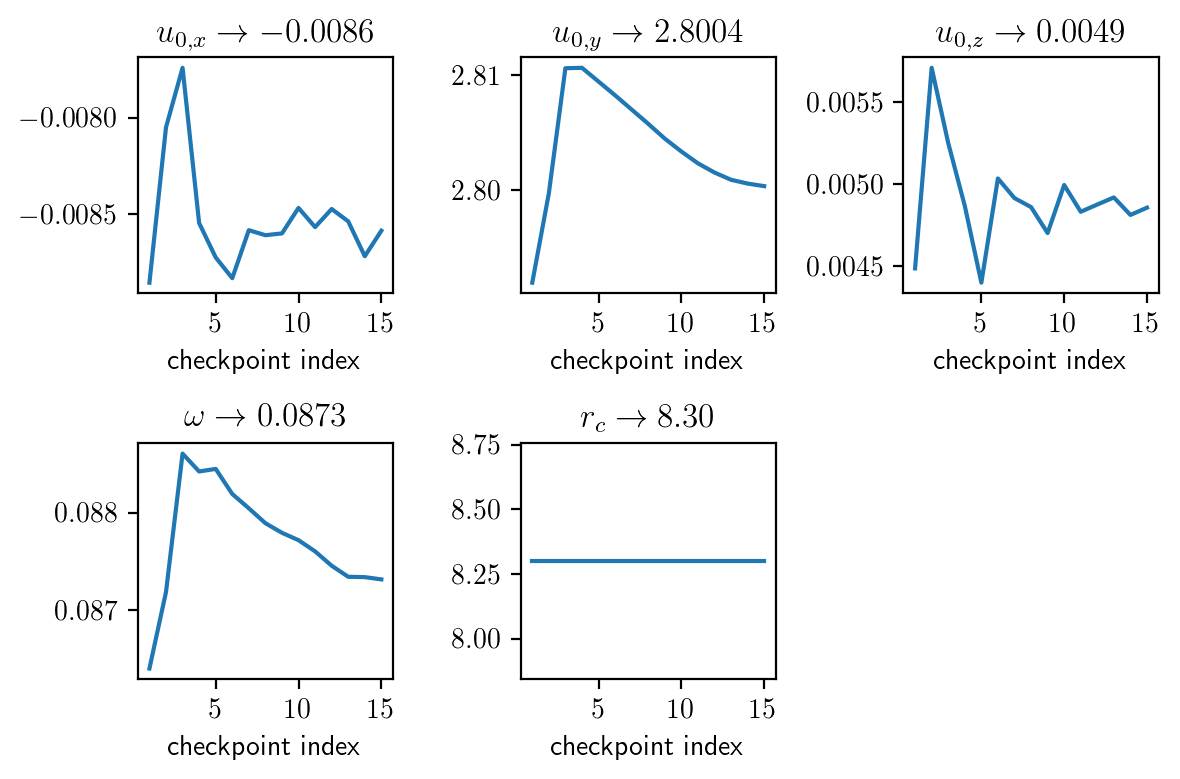

In [45]:
if os.path.isdir(potential_fname) and fname[-1] != '/':
    potential_fname = potential_fname + '/'
directory, tail = os.path.split(potential_fname)


indices = np.array(glob.glob(f'{directory}/*.index'))
numbers = np.array([int(x[x.rfind('-') + 1:x.rfind('.index')]) for x in indices])
indices = indices[np.argsort(numbers)]
numbers = numbers[np.argsort(numbers)]

u0xs, u0ys, u0zs, omegas, r_cs = [], [], [], [], []
for i, index in enumerate(indices):
    fs = potential_tf.FrameShift.load_checkpoint_with_id(directory, numbers[i], verbose=False)
    u0xs.append(fs._u_x.numpy())
    u0ys.append(fs._u_y.numpy())
    u0zs.append(fs._u_z.numpy())
    omegas.append(fs._omega.numpy())
    r_cs.append(fs._r_c.numpy())


fig,(axs) = plt.subplots(
    2, 3,
    figsize=(6,4),
    dpi=200,
    gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[2, 2]))

axs[0, 0].plot(numbers, u0xs)
axs[0, 0].set_title(f"$u_{{0, x}}\\rightarrow{u0xs[-1]:.4f}$")
axs[0, 1].plot(numbers, u0ys)
axs[0, 1].set_title(f"$u_{{0, y}}\\rightarrow{u0ys[-1]:.4f}$")
axs[0, 2].plot(numbers, u0zs)
axs[0, 2].set_title(f"$u_{{0, z}}\\rightarrow{u0zs[-1]:.4f}$")
axs[1, 0].plot(numbers, omegas)
axs[1, 0].set_title(f"$\omega\\rightarrow{omegas[-1]:.4f}$")
axs[1, 1].plot(numbers, r_cs)
axs[1, 1].set_title(f"$r_c\\rightarrow{r_cs[-1]:.2f}$")

for row in axs:
    for ax in row:
        ax.set_xlabel('checkpoint index')
axs[1, 2].axis('off')
plt.tight_layout()

In [47]:
np.mean(eta_train, axis=0)

array([ 6.0060564e-03,  3.8019748e-04,  5.5784133e-04, -8.0897566e-04,
        2.0747736e+00,  2.8723271e-03], dtype=float32)

In [44]:
def find_hessian(df_data, phi_model, params):
    lam = params['Phi']['lam']
    xi = params['Phi']['xi']
    l2 = params['Phi']['l2']
    
    n_samples = df_data['eta'].shape[0]
    n_dim = df_data['eta'].shape[1] // 2
    data = np.stack(
            [
                df_data['eta'][:,:n_dim].astype('f4'),     # q
                df_data['eta'][:,n_dim:].astype('f4'),     # p
                df_data['df_deta'][:,:n_dim].astype('f4'), # df/dq
                df_data['df_deta'][:,n_dim:].astype('f4')  # df/dp
            ],
            axis=1
        )

    batch_size = 1024
    batches = tf.data.Dataset.from_tensor_slices(data)
    batches = batches.shuffle(n_samples, reshuffle_each_iteration=True)
    batches = batches.batch(batch_size, drop_remainder=True)
    
    covars = []
    for i, batch in enumerate(batches):
        print(f'Finding hessian {i}')
        q, p, df_dq, df_dp = [
            tf.squeeze(x) for x in tf.split(batch, 4, axis=1)
        ]
        
        fs = phi_model['fs']
        watched_params = (fs._omega, fs._u_x, fs._u_y, fs._u_z) # tuple of variables
        k = len(watched_params)
        
        #watched_params = tf.concat([tf.reshape(x, (1, 1)) for x in watched_params], axis=0) # (2, 1) tensor
        with tf.GradientTape(persistent=True) as g2:
            g2.watch(watched_params)
            with tf.GradientTape(persistent=True) as g1:
                g1.watch(watched_params)
                
                # Calculate the loss
                dphi_dq, d2phi_dq2 = potential_tf.calc_phi_derivatives(phi_model['phi'], q)
                u, w = fs(q, p)
                null_hyp = tf.reduce_sum((p - u) * df_dq - (dphi_dq + w) * df_dp, axis=1)
                likelihood = tf.math.asinh(tf.math.abs(null_hyp))
                prior_neg = tf.math.asinh(
                    tf.clip_by_value(-d2phi_dq2, 0., np.inf)
                )
                likelihood = likelihood + lam * prior_neg
                loss = tf.math.log(tf.reduce_mean(likelihood))
                #print(f'loss: {loss}')
                
            grad = g1.gradient(loss, watched_params)
            #print(f'grad: {grad}')
            #print(tf.expand_dims(grad[0], axis=0))
            #grad = tf.concat([tf.expand_dims(x,axis=0) for x in grad], axis=0)
            #print(grad)
        hess = np.zeros((k, k))
        for m in range(k):
            for n in range(m + 1):
                hess[m][n] = g2.jacobian(grad[m], watched_params[n], unconnected_gradients='zero')
                hess[n][m] = hess[m][n]
        #hess = g2.jacobian(grad, watched_params)
        #print(f'hess: {hess}')
        covar = np.linalg.inv(-hess)
        covars.append(covar)
    return covars

covars = find_hessian(df_data, phi_model, params)

Text(0.5, 1.0, 'FrameShift correlation matrix')

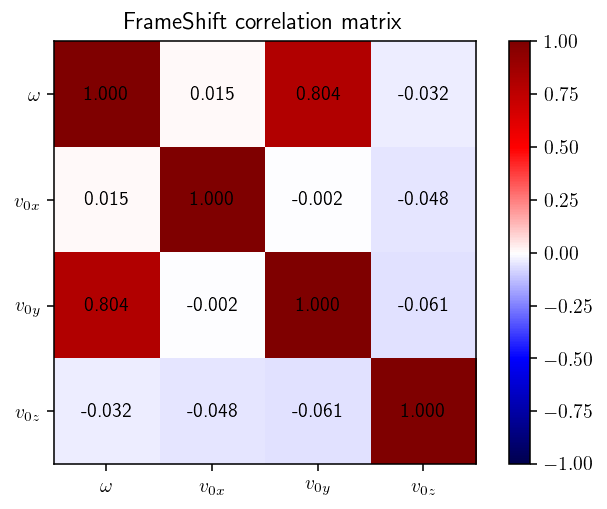

In [15]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

#covar = np.linalg.inv(-hess)
covar = np.mean(covars, axis=0)
corr = correlation_from_covariance(covar)

labels = ['$\omega$', '$v_{0x}$', '$v_{0y}$', '$v_{0z}$']
fig, ax = plt.subplots()
im = ax.imshow(corr, vmin=-1, vmax=1, cmap='seismic')

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)

cbar = ax.figure.colorbar(im, ax=ax)

for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, f'{corr[i, j]:.3f}',
                       ha="center", va="center", color="black")
ax.set_title('FrameShift correlation matrix')

# 6. Training a potential with fixed v0_y
This is in order to avoid the degeneracy of the harmonic potential between $v_{0y}$ and $\Omega$

In [15]:
params['Phi']['frameshift']['u_y0'] = 0
params['Phi']['frameshift']['u_y0_trainable'] = False
potential_fname_v2 = '../runs/harmonic_example/models/Phi_fixedv0y/Phi'

In [ ]:
# Guided refers to a neural network (NN) that has a quadratic component and R^2 as one of the input features

phi_model, fs_model = fit_all.train_potential(df_data,
            potential_fname_v2, include_frameshift=True,
            guided_potential=True, **params['Phi'])
phi_model = {'phi': phi_model, 'fs': fs_model}

Using coordinate scale: [0.45915526 0.44578227 0.34499058]
df_data type: <class 'dict'>
<class 'str'>
791041 variables in the gravitational potential model.
3 variables in the frameshift model.
24482 steps planned.
Optimizer: <tensorflow_addons.optimizers.rectified_adam.RectifiedAdam object at 0x7f9f34de64c0>
maxx 128
Tracing training_step with batch shape (512, 4, 3) ...
c = 1.0
l2 = 0.1
L2 penalty on <tf.Variable 'PhiNNGuided/hidden_0_l2penalty/w:0' shape=(4, 512) dtype=float32>
L2 penalty on <tf.Variable 'PhiNNGuided/hidden_1_l2penalty/w:0' shape=(512, 512) dtype=float32>
L2 penalty on <tf.Variable 'PhiNNGuided/hidden_2_l2penalty/w:0' shape=(512, 512) dtype=float32>
L2 penalty on <tf.Variable 'PhiNNGuided/hidden_3_l2penalty/w:0' shape=(512, 512) dtype=float32>
L2 penalty on <tf.Variable 'PhiNNGuided/Phi_l2penalty/w:0' shape=(512, 1) dtype=float32>
Tracing training_step with batch shape (512, 4, 3) ...
c = 1.0
l2 = 0.1
L2 penalty on <tf.Variable 'PhiNNGuided/hidden_0_l2penalty/w:0' s

|             |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss:  1.237, lr:    0.001

likelihood: 2.95682454
prior_neg: 0.279132873
loss (before penalty): 1.17432475
L2 penalty: 0.0199177247

global norm: 3.03471851
likelihood: 3.07918358
prior_neg: 0.26779592
loss (before penalty): 1.20805836
L2 penalty: 0.0199177247


|             |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss:  1.216, lr:    0.001

likelihood: 2.95952344
prior_neg: 0.264832795
loss (before penalty): 1.17073333
L2 penalty: 0.0199177247

global norm: 2.70239687
likelihood: 3.02232528
prior_neg: 0.306532145
loss (before penalty): 1.20262921
L2 penalty: 0.0199177247


|             |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss:  1.207, lr:    0.001

likelihood: 3.01459503
prior_neg: 0.252598763
loss (before penalty): 1.18393147
L2 penalty: 0.0199177247

global norm: 2.69223857
likelihood: 3.13514853
prior_neg: 0.233905599
loss (before penalty): 1.21463203
L2 penalty: 0.0199177247


|             |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss:  1.207, lr:    0.001

likelihood: 3.05525541
prior_neg: 0.28918162
loss (before penalty): 1.2072984
L2 penalty: 0.0199177247

global norm: 2.27167463
likelihood: 3.06327915
prior_neg: 0.238861293
loss (before penalty): 1.19457102
L2 penalty: 0.0199177247


|             |  0% |Elapsed: 0:00:00|ETA:  00:00:00|loss:  1.211, lr:    0.001

likelihood: 3.03664255
prior_neg: 0.253329337
loss (before penalty): 1.19087911
L2 penalty: 0.0199177247

global norm: 2.55368042
likelihood: 2.96995354
prior_neg: 0.20006451
loss (before penalty): 1.15373731
L2 penalty: 0.0199177228


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:00|loss:  1.211, lr:    0.001

likelihood: 2.99124
prior_neg: 0.275286406
loss (before penalty): 1.18372726
L2 penalty: 0.0199177228

global norm: 2.53999066
likelihood: 3.17844486
prior_neg: 0.312136292
loss (before penalty): 1.25006819
L2 penalty: 0.0199177228


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:00|loss:   1.21, lr:    0.001

likelihood: 3.04483652
prior_neg: 0.305935889
loss (before penalty): 1.20919096
L2 penalty: 0.0199177228

global norm: 2.37577701
likelihood: 3.07581091
prior_neg: 0.308497876
loss (before penalty): 1.21914971
L2 penalty: 0.0199177209


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:00|loss:  1.212, lr:    0.001

likelihood: 2.98181772
prior_neg: 0.27168411
loss (before penalty): 1.17973197
L2 penalty: 0.0199177209

global norm: 2.65700769
likelihood: 3.04230714
prior_neg: 0.277710766
loss (before penalty): 1.19997013
L2 penalty: 0.0199177153


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:00|loss:  1.211, lr:    0.001

likelihood: 3.07370138
prior_neg: 0.321058899
loss (before penalty): 1.22223318
L2 penalty: 0.0199177153

global norm: 3.95249677
likelihood: 2.88442612
prior_neg: 0.207712442
loss (before penalty): 1.12886286
L2 penalty: 0.0199177135


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:00|loss:  1.214, lr:    0.001

likelihood: 2.93875337
prior_neg: 0.236988574
loss (before penalty): 1.1555413
L2 penalty: 0.0199177135

global norm: 2.72727299
likelihood: 2.9744823
prior_neg: 0.288765728
loss (before penalty): 1.18272305
L2 penalty: 0.0199177116


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:34|loss:   1.21, lr:    0.001

likelihood: 2.89196825
prior_neg: 0.264969826
loss (before penalty): 1.14960253
L2 penalty: 0.0199177116

global norm: 3.52240205
likelihood: 2.9245
prior_neg: 0.289178193
loss (before penalty): 1.1674161
L2 penalty: 0.0199177079


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:34|loss:  1.207, lr:    0.001

likelihood: 3.05225277
prior_neg: 0.236103207
loss (before penalty): 1.19038785
L2 penalty: 0.0199177079

global norm: 2.41983843
likelihood: 3.10898542
prior_neg: 0.252073
loss (before penalty): 1.21225595
L2 penalty: 0.0199177042


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:34|loss:  1.207, lr:    0.001

likelihood: 3.05076933
prior_neg: 0.254104316
loss (before penalty): 1.19539821
L2 penalty: 0.0199177042

global norm: 2.53146625
likelihood: 2.99024892
prior_neg: 0.241394699
loss (before penalty): 1.17299092
L2 penalty: 0.0199176967


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:34|loss:  1.208, lr:    0.001

likelihood: 3.03834605
prior_neg: 0.260260731
loss (before penalty): 1.19350028
L2 penalty: 0.0199176967

global norm: 1.99860728
likelihood: 3.03615069
prior_neg: 0.220844686
loss (before penalty): 1.18080509
L2 penalty: 0.019917693


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:34|loss:  1.208, lr:    0.001

likelihood: 3.05335259
prior_neg: 0.221271962
loss (before penalty): 1.18620312
L2 penalty: 0.019917693

global norm: 2.62125015
likelihood: 2.88050795
prior_neg: 0.248642296
loss (before penalty): 1.14076149
L2 penalty: 0.0199176855


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:51|loss:  1.208, lr:    0.001

likelihood: 3.01456666
prior_neg: 0.238893181
loss (before penalty): 1.17971897
L2 penalty: 0.0199176855

global norm: 2.65894175
likelihood: 2.99058175
prior_neg: 0.18566528
loss (before penalty): 1.15570033
L2 penalty: 0.0199176762


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:51|loss:  1.208, lr:    0.001

likelihood: 3.06379676
prior_neg: 0.237086236
loss (before penalty): 1.19418991
L2 penalty: 0.0199176762

global norm: 2.73491693
likelihood: 2.8335588
prior_neg: 0.184798837
loss (before penalty): 1.10471296
L2 penalty: 0.0199176688


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:51|loss:  1.208, lr:    0.001

likelihood: 2.96914673
prior_neg: 0.212652072
loss (before penalty): 1.15744662
L2 penalty: 0.0199176688

global norm: 3.22174382
likelihood: 3.25344753
prior_neg: 0.18431595
loss (before penalty): 1.23482108
L2 penalty: 0.0199176576


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:51|loss:  1.206, lr:    0.001

likelihood: 2.9593606
prior_neg: 0.191453218
loss (before penalty): 1.14766073
L2 penalty: 0.0199176576

global norm: 2.89564848
likelihood: 2.96172667
prior_neg: 0.145919293
loss (before penalty): 1.13386559
L2 penalty: 0.0199176464


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:51|loss:  1.204, lr:    0.001

likelihood: 3.07967257
prior_neg: 0.173842832
loss (before penalty): 1.17973614
L2 penalty: 0.0199176464

global norm: 2.64005232
likelihood: 2.96480179
prior_neg: 0.200159743
loss (before penalty): 1.15214086
L2 penalty: 0.0199176334


|             |  0% |Elapsed: 0:00:00|ETA:   0:09:05|loss:  1.204, lr:    0.001

likelihood: 2.97154808
prior_neg: 0.18380402
loss (before penalty): 1.14910007
L2 penalty: 0.0199176334

global norm: 2.09368157
likelihood: 3.22769904
prior_neg: 0.168112844
loss (before penalty): 1.22254288
L2 penalty: 0.0199176203


|             |  0% |Elapsed: 0:00:00|ETA:   0:09:05|loss:  1.203, lr:    0.001

likelihood: 3.04457712
prior_neg: 0.181550488
loss (before penalty): 1.17128253
L2 penalty: 0.0199176203

global norm: 1.74147928
likelihood: 2.92678118
prior_neg: 0.166433156
loss (before penalty): 1.12921071
L2 penalty: 0.0199176017


|             |  0% |Elapsed: 0:00:00|ETA:   0:09:05|loss:  1.202, lr:    0.001

likelihood: 3.09362459
prior_neg: 0.17051515
loss (before penalty): 1.18299627
L2 penalty: 0.0199176017

global norm: 1.3546468
likelihood: 3.14392042
prior_neg: 0.190651447
loss (before penalty): 1.20434427
L2 penalty: 0.0199175831


|             |  0% |Elapsed: 0:00:00|ETA:   0:09:05|loss:  1.202, lr:    0.001

likelihood: 3.02294493
prior_neg: 0.169236884
loss (before penalty): 1.16070461
L2 penalty: 0.0199175831

global norm: 2.43147516
likelihood: 2.85527706
prior_neg: 0.161316663
loss (before penalty): 1.10412836
L2 penalty: 0.0199175607


|             |  0% |Elapsed: 0:00:00|ETA:   0:09:05|loss:  1.201, lr:    0.001

likelihood: 3.0589602
prior_neg: 0.148330092
loss (before penalty): 1.16542637
L2 penalty: 0.0199175607

global norm: 2.48526692
likelihood: 2.9341383
prior_neg: 0.127038434
loss (before penalty): 1.11879945
L2 penalty: 0.0199175365


|             |  0% |Elapsed: 0:00:00|ETA:   0:09:05|loss:  1.201, lr:    0.001

likelihood: 2.89519334
prior_neg: 0.147710487
loss (before penalty): 1.11281228
L2 penalty: 0.0199175365

global norm: 2.56639862
likelihood: 2.83906245
prior_neg: 0.165713906
loss (before penalty): 1.10020304
L2 penalty: 0.0199175104


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.198, lr:    0.001

likelihood: 3.00058627
prior_neg: 0.122383073
loss (before penalty): 1.13878429
L2 penalty: 0.0199175104

global norm: 1.58595264
likelihood: 2.95905113
prior_neg: 0.123705328
loss (before penalty): 1.12582421
L2 penalty: 0.0199174788


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.197, lr:    0.001

likelihood: 2.95037746
prior_neg: 0.125069171
loss (before penalty): 1.12345028
L2 penalty: 0.0199174788

global norm: 2.30481315
likelihood: 2.91290784
prior_neg: 0.111286975
loss (before penalty): 1.10664487
L2 penalty: 0.0199174527


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.195, lr:    0.001

likelihood: 3.09133434
prior_neg: 0.124125727
loss (before penalty): 1.16797054
L2 penalty: 0.0199174527

global norm: 1.77956641
likelihood: 2.943542
prior_neg: 0.152771086
loss (before penalty): 1.13021219
L2 penalty: 0.0199174173


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.195, lr:    0.001

likelihood: 2.92597461
prior_neg: 0.114287801
loss (before penalty): 1.11194372
L2 penalty: 0.0199174173

global norm: 1.99105299
likelihood: 3.04568744
prior_neg: 0.0729361326
loss (before penalty): 1.13739169
L2 penalty: 0.0199173857


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.193, lr:    0.001

likelihood: 2.89893651
prior_neg: 0.13592197
loss (before penalty): 1.11016488
L2 penalty: 0.0199173857

global norm: 2.16523361
likelihood: 2.82253337
prior_neg: 0.0818920135
loss (before penalty): 1.06623566
L2 penalty: 0.0199173521


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.191, lr:    0.001

likelihood: 3.03580332
prior_neg: 0.0986637175
loss (before penalty): 1.14245915
L2 penalty: 0.0199173521

global norm: 1.1246841
likelihood: 2.77488089
prior_neg: 0.0975323
loss (before penalty): 1.05515254
L2 penalty: 0.0199173093


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:   1.19, lr:    0.001

likelihood: 2.94335437
prior_neg: 0.0955554843
loss (before penalty): 1.11149895
L2 penalty: 0.0199173093

global norm: 2.07036
likelihood: 2.98605013
prior_neg: 0.0877548
loss (before penalty): 1.12291622
L2 penalty: 0.0199172664


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.188, lr:    0.001

likelihood: 3.11558294
prior_neg: 0.0641722083
loss (before penalty): 1.15680408
L2 penalty: 0.0199172664

global norm: 2.02116132
likelihood: 2.79257679
prior_neg: 0.0871551558
loss (before penalty): 1.05769718
L2 penalty: 0.0199172292


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:54|loss:  1.188, lr:    0.001

likelihood: 2.97856879
prior_neg: 0.0850377232
loss (before penalty): 1.11959267
L2 penalty: 0.0199172292

global norm: 2.21699905
likelihood: 2.99158287
prior_neg: 0.0744757876
loss (before penalty): 1.12039292
L2 penalty: 0.0199171863


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:53|loss:  1.186, lr:    0.001

likelihood: 2.88219666
prior_neg: 0.098689355
loss (before penalty): 1.09222054
L2 penalty: 0.0199171863

global norm: 1.20067334
likelihood: 3.23446321
prior_neg: 0.106554836
loss (before penalty): 1.20627558
L2 penalty: 0.0199171379


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:49|loss:  1.184, lr:    0.001

likelihood: 2.94410634
prior_neg: 0.0684104636
loss (before penalty): 1.10277581
L2 penalty: 0.0199171379

global norm: 2.30506825
likelihood: 2.89292264
prior_neg: 0.0695008934
loss (before penalty): 1.0860076
L2 penalty: 0.0199170951


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:49|loss:  1.183, lr:    0.001

likelihood: 3.0513339
prior_neg: 0.0774136931
loss (before penalty): 1.14063275
L2 penalty: 0.0199170951

global norm: 1.30298221
likelihood: 2.82030463
prior_neg: 0.0719317049
loss (before penalty): 1.06203
L2 penalty: 0.0199170504


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:49|loss:  1.182, lr:    0.001

likelihood: 2.97479796
prior_neg: 0.0632605627
loss (before penalty): 1.11121869
L2 penalty: 0.0199170504

global norm: 2.38786507
likelihood: 2.86660051
prior_neg: 0.0647538155
loss (before penalty): 1.07546449
L2 penalty: 0.0199170019


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:49|loss:  1.181, lr:    0.001

likelihood: 2.96817851
prior_neg: 0.0670572743
loss (before penalty): 1.1102891
L2 penalty: 0.0199170019

global norm: 2.10830307
likelihood: 2.95662546
prior_neg: 0.0795886
loss (before penalty): 1.11061144
L2 penalty: 0.0199169517


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:49|loss:   1.18, lr:    0.001

likelihood: 2.96465397
prior_neg: 0.0597495884
loss (before penalty): 1.10671389
L2 penalty: 0.0199169517

global norm: 1.75844324
likelihood: 3.1400032
prior_neg: 0.0543502495
loss (before penalty): 1.1613847
L2 penalty: 0.0199168976


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:49|loss:  1.178, lr:    0.001

likelihood: 2.94589806
prior_neg: 0.0499976426
loss (before penalty): 1.09724319
L2 penalty: 0.0199168976

global norm: 1.88908136
likelihood: 2.93133092
prior_neg: 0.0206107646
loss (before penalty): 1.08246315
L2 penalty: 0.0199168399


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:42|loss:  1.177, lr:    0.001

likelihood: 2.9365654
prior_neg: 0.0543490052
loss (before penalty): 1.09557915
L2 penalty: 0.0199168399

global norm: 2.43253136
likelihood: 3.06014895
prior_neg: 0.0495558977
loss (before penalty): 1.13452792
L2 penalty: 0.019916784


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:42|loss:  1.176, lr:    0.001

likelihood: 2.96994066
prior_neg: 0.0620790496
loss (before penalty): 1.10922885
L2 penalty: 0.019916784

global norm: 1.25820971
likelihood: 2.95494938
prior_neg: 0.0377874151
loss (before penalty): 1.09618831
L2 penalty: 0.01991673


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:42|loss:  1.175, lr:    0.001

likelihood: 2.95596838
prior_neg: 0.0495348163
loss (before penalty): 1.10044491
L2 penalty: 0.01991673

global norm: 1.81261945
likelihood: 3.03424454
prior_neg: 0.0434932783
loss (before penalty): 1.12419486
L2 penalty: 0.0199166685


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:42|loss:  1.173, lr:    0.001

likelihood: 2.97110248
prior_neg: 0.0436051898
loss (before penalty): 1.10350287
L2 penalty: 0.0199166685

global norm: 1.74975669
likelihood: 3.13870144
prior_neg: 0.0450354852
loss (before penalty): 1.15805554
L2 penalty: 0.0199166052


|             |  0% |Elapsed: 0:00:00|ETA:   0:08:42|loss:  1.172, lr:    0.001

likelihood: 2.9655602
prior_neg: 0.0553643592
loss (before penalty): 1.10556304
L2 penalty: 0.0199166052

global norm: 1.60248029
likelihood: 2.78866148
prior_neg: 0.0613238886
loss (before penalty): 1.04731381
L2 penalty: 0.0199165381


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:38|loss:  1.171, lr:    0.001

likelihood: 2.97407246
prior_neg: 0.0416785069
loss (before penalty): 1.10384881
L2 penalty: 0.0199165381

global norm: 2.80290747
likelihood: 2.91988158
prior_neg: 0.0488657467
loss (before penalty): 1.08814013
L2 penalty: 0.0199164674


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:38|loss:   1.17, lr:    0.001

likelihood: 2.94278359
prior_neg: 0.0612655
loss (before penalty): 1.09996116
L2 penalty: 0.0199164674

global norm: 1.75472116
likelihood: 3.18925881
prior_neg: 0.0197498836
loss (before penalty): 1.1659621
L2 penalty: 0.0199163835


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:38|loss:  1.169, lr:    0.001

likelihood: 3.02190971
prior_neg: 0.0476368554
loss (before penalty): 1.12152994
L2 penalty: 0.0199163835

global norm: 0.980992675
likelihood: 2.97145987
prior_neg: 0.0529005826
loss (before penalty): 1.10669959
L2 penalty: 0.0199162979


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:38|loss:  1.167, lr:    0.001

likelihood: 3.02017522
prior_neg: 0.0403698422
loss (before penalty): 1.11859298
L2 penalty: 0.0199162979

global norm: 1.98549819
likelihood: 2.94916296
prior_neg: 0.0413744748
loss (before penalty): 1.09545314
L2 penalty: 0.0199161973


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:38|loss:  1.166, lr:    0.001

likelihood: 2.82421112
prior_neg: 0.0499869734
loss (before penalty): 1.05577374
L2 penalty: 0.0199161973

global norm: 1.69757235
likelihood: 3.11584044
prior_neg: 0.0576496795
loss (before penalty): 1.15483189
L2 penalty: 0.0199160874


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:37|loss:  1.164, lr:    0.001

likelihood: 2.91096878
prior_neg: 0.0518751517
loss (before penalty): 1.08614957
L2 penalty: 0.0199160874

global norm: 2.01868534
likelihood: 2.93482614
prior_neg: 0.0277855136
loss (before penalty): 1.08607125
L2 penalty: 0.0199159831


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:37|loss:  1.162, lr:    0.001

likelihood: 2.92995644
prior_neg: 0.0530514307
loss (before penalty): 1.09293211
L2 penalty: 0.0199159831

global norm: 1.9180727
likelihood: 2.92661095
prior_neg: 0.0359620154
loss (before penalty): 1.08605814
L2 penalty: 0.0199158713


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:37|loss:   1.16, lr:    0.001

likelihood: 2.99690294
prior_neg: 0.0430536717
loss (before penalty): 1.11184323
L2 penalty: 0.0199158713

global norm: 1.92268348
likelihood: 2.89211226
prior_neg: 0.0372370631
loss (before penalty): 1.07478034
L2 penalty: 0.0199157558


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:37|loss:  1.158, lr:    0.001

likelihood: 2.95330691
prior_neg: 0.053902667
loss (before penalty): 1.10101247
L2 penalty: 0.0199157558

global norm: 1.11123502
likelihood: 3.0134
prior_neg: 0.0479412898
loss (before penalty): 1.11885309
L2 penalty: 0.0199156348


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:37|loss:  1.157, lr:    0.001

likelihood: 3.03896308
prior_neg: 0.0561609454
loss (before penalty): 1.1298281
L2 penalty: 0.0199156348

global norm: 0.900909662
likelihood: 2.75739622
prior_neg: 0.0681221932
loss (before penalty): 1.038692
L2 penalty: 0.0199155118


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:36|loss:  1.155, lr:    0.001

likelihood: 2.95372176
prior_neg: 0.0406427979
loss (before penalty): 1.09673214
L2 penalty: 0.0199155118

global norm: 1.26999497
likelihood: 3.26118445
prior_neg: 0.0360753387
loss (before penalty): 1.19309163
L2 penalty: 0.0199153926


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:36|loss:  1.153, lr:    0.001

likelihood: 2.94446635
prior_neg: 0.0481368378
loss (before penalty): 1.09614372
L2 penalty: 0.0199153926

global norm: 2.35261273
likelihood: 3.00688338
prior_neg: 0.062620379
loss (before penalty): 1.12151599
L2 penalty: 0.0199152809


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:36|loss:  1.151, lr:    0.001

likelihood: 2.90387297
prior_neg: 0.0506186821
loss (before penalty): 1.0833267
L2 penalty: 0.0199152809

global norm: 2.97878
likelihood: 3.26367664
prior_neg: 0.0507892594
loss (before penalty): 1.19829643
L2 penalty: 0.019915171


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:36|loss:  1.149, lr:    0.001

likelihood: 2.91743422
prior_neg: 0.0419486612
loss (before penalty): 1.08498073
L2 penalty: 0.019915171

global norm: 2.43269515
likelihood: 2.78940105
prior_neg: 0.0611275584
loss (before penalty): 1.04750443
L2 penalty: 0.0199150611


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:36|loss:  1.148, lr:    0.001

likelihood: 2.96835947
prior_neg: 0.0474384576
loss (before penalty): 1.10386443
L2 penalty: 0.0199150611

global norm: 1.03125966
likelihood: 2.72808743
prior_neg: 0.0508420691
loss (before penalty): 1.02206588
L2 penalty: 0.0199149363


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:35|loss:  1.146, lr:    0.001

likelihood: 2.89819026
prior_neg: 0.0512255318
loss (before penalty): 1.0816071
L2 penalty: 0.0199149363

global norm: 2.52415681
likelihood: 2.9241004
prior_neg: 0.0323535055
loss (before penalty): 1.08399057
L2 penalty: 0.0199148078


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.144, lr:    0.001

likelihood: 2.93499875
prior_neg: 0.038793508
loss (before penalty): 1.08983803
L2 penalty: 0.0199148078

global norm: 1.60185182
likelihood: 3.099159
prior_neg: 0.0586228296
loss (before penalty): 1.14986992
L2 penalty: 0.0199146736


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.142, lr:    0.001

likelihood: 2.83260894
prior_neg: 0.0309507325
loss (before penalty): 1.05206537
L2 penalty: 0.0199146736

global norm: 3.80280733
likelihood: 2.77714753
prior_neg: 0.027328236
loss (before penalty): 1.03121662
L2 penalty: 0.0199145339


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.139, lr:    0.001

likelihood: 2.91624165
prior_neg: 0.0327258036
loss (before penalty): 1.08145499
L2 penalty: 0.0199145339

global norm: 2.25965357
likelihood: 2.829808
prior_neg: 0.0306588393
loss (before penalty): 1.05098486
L2 penalty: 0.0199143942


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.137, lr:    0.001

likelihood: 3.018296
prior_neg: 0.0303159375
loss (before penalty): 1.11468625
L2 penalty: 0.0199143942

global norm: 3.15359592
likelihood: 3.17274141
prior_neg: 0.0223482307
loss (before penalty): 1.16161513
L2 penalty: 0.0199142545


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.136, lr:    0.001

likelihood: 2.88443112
prior_neg: 0.01957394
loss (before penalty): 1.0660907
L2 penalty: 0.0199142545

global norm: 1.81957781
likelihood: 3.0472765
prior_neg: 0.0139365345
loss (before penalty): 1.11881137
L2 penalty: 0.019914126


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:31|loss:  1.134, lr:    0.001

likelihood: 2.89589381
prior_neg: 0.0178763252
loss (before penalty): 1.06944788
L2 penalty: 0.019914126

global norm: 1.48013794
likelihood: 2.83675241
prior_neg: 0.0233043693
loss (before penalty): 1.05084145
L2 penalty: 0.0199139845


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:31|loss:  1.132, lr:    0.001

likelihood: 3.02054
prior_neg: 0.0290014818
loss (before penalty): 1.11499119
L2 penalty: 0.0199139845

global norm: 3.06289911
likelihood: 3.09223318
prior_neg: 0.0296324175
loss (before penalty): 1.13843083
L2 penalty: 0.0199138485


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:31|loss:  1.131, lr:    0.001

likelihood: 2.96129394
prior_neg: 0.0400529206
loss (before penalty): 1.09906125
L2 penalty: 0.0199138485

global norm: 1.73499024
likelihood: 2.65301394
prior_neg: 0.0483709797
loss (before penalty): 0.993764639
L2 penalty: 0.0199137274


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:31|loss:   1.13, lr:    0.001

likelihood: 2.95319152
prior_neg: 0.0307336096
loss (before penalty): 1.09323967
L2 penalty: 0.0199137274

global norm: 1.26654363
likelihood: 2.78458118
prior_neg: 0.0439161584
loss (before penalty): 1.03974557
L2 penalty: 0.0199136026


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:31|loss:  1.128, lr:    0.001

likelihood: 2.92811441
prior_neg: 0.0356919914
loss (before penalty): 1.0864743
L2 penalty: 0.0199136026

global norm: 1.7849654
likelihood: 3.00935936
prior_neg: 0.074017562
loss (before penalty): 1.12602544
L2 penalty: 0.0199134741


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:30|loss:  1.127, lr:    0.001

likelihood: 3.02425385
prior_neg: 0.0293745045
loss (before penalty): 1.1163305
L2 penalty: 0.0199134741

global norm: 1.59241295
likelihood: 2.87283754
prior_neg: 0.038798321
loss (before penalty): 1.06871498
L2 penalty: 0.019913353


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:30|loss:  1.126, lr:    0.001

likelihood: 2.99584198
prior_neg: 0.0239869207
loss (before penalty): 1.10520017
L2 penalty: 0.019913353

global norm: 1.05372894
likelihood: 3.00044227
prior_neg: 0.0208391063
loss (before penalty): 1.10568106
L2 penalty: 0.0199132226


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:30|loss:  1.124, lr:    0.001

likelihood: 2.88854957
prior_neg: 0.0190027356
loss (before penalty): 1.06731176
L2 penalty: 0.0199132226

global norm: 1.37345195
likelihood: 3.10276866
prior_neg: 0.0158095546
loss (before penalty): 1.13737726
L2 penalty: 0.0199130867


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:30|loss:  1.124, lr:    0.001

likelihood: 2.84610319
prior_neg: 0.0253772642
loss (before penalty): 1.05482769
L2 penalty: 0.0199130867

global norm: 1.33410406
likelihood: 2.88700223
prior_neg: 0.0254480131
loss (before penalty): 1.06899464
L2 penalty: 0.0199129451


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:30|loss:  1.122, lr:    0.001

likelihood: 2.90754771
prior_neg: 0.0292459801
loss (before penalty): 1.07731843
L2 penalty: 0.0199129451

global norm: 1.27741587
likelihood: 2.93910217
prior_neg: 0.0134857912
loss (before penalty): 1.08268213
L2 penalty: 0.0199128091


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.121, lr:    0.001

likelihood: 2.91926503
prior_neg: 0.0214628577
loss (before penalty): 1.07865715
L2 penalty: 0.0199128091

global norm: 4.1325531
likelihood: 3.02492857
prior_neg: 0.0223393217
loss (before penalty): 1.11424553
L2 penalty: 0.0199126769


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.119, lr:    0.001

likelihood: 2.82426596
prior_neg: 0.0266126022
loss (before penalty): 1.04762721
L2 penalty: 0.0199126769

global norm: 1.35617375
likelihood: 2.92191792
prior_neg: 0.0340646766
loss (before penalty): 1.08383119
L2 penalty: 0.0199125297


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.118, lr:    0.001

likelihood: 2.92428207
prior_neg: 0.0344731919
loss (before penalty): 1.08476853
L2 penalty: 0.0199125297

global norm: 1.86062133
likelihood: 3.15618587
prior_neg: 0.0332202055
loss (before penalty): 1.15983474
L2 penalty: 0.01991239


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.117, lr:    0.001

likelihood: 2.91572022
prior_neg: 0.0339868553
loss (before penalty): 1.08170581
L2 penalty: 0.01991239

global norm: 3.19565272
likelihood: 2.96655035
prior_neg: 0.030931497
loss (before penalty): 1.0977726
L2 penalty: 0.0199122597


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:32|loss:  1.116, lr:    0.001

likelihood: 3.04364777
prior_neg: 0.0385688581
loss (before penalty): 1.12564898
L2 penalty: 0.0199122597

global norm: 2.65182304
likelihood: 2.94364762
prior_neg: 0.0394308604
loss (before penalty): 1.09295583
L2 penalty: 0.0199121367


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.116, lr:    0.001

likelihood: 2.84905195
prior_neg: 0.0578477979
loss (before penalty): 1.06708717
L2 penalty: 0.0199121367

global norm: 1.05044496
likelihood: 2.92229652
prior_neg: 0.0577440932
loss (before penalty): 1.09193695
L2 penalty: 0.0199120026


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.115, lr:    0.001

likelihood: 2.95968556
prior_neg: 0.0544762798
loss (before penalty): 1.10332167
L2 penalty: 0.0199120026

global norm: 2.74590182
likelihood: 3.00970697
prior_neg: 0.0371105745
loss (before penalty): 1.11409771
L2 penalty: 0.0199118778


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.114, lr:    0.001

likelihood: 3.01338887
prior_neg: 0.0484602302
loss (before penalty): 1.11901903
L2 penalty: 0.0199118778

global norm: 1.42052877
likelihood: 2.90330029
prior_neg: 0.0344466828
loss (before penalty): 1.07764304
L2 penalty: 0.0199117139


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.115, lr:    0.001

likelihood: 2.85656595
prior_neg: 0.0549184866
loss (before penalty): 1.06866312
L2 penalty: 0.0199117139

global norm: 1.64427972
likelihood: 2.80316591
prior_neg: 0.0377322249
loss (before penalty): 1.04412019
L2 penalty: 0.0199115425


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.114, lr:    0.001

likelihood: 3.06665778
prior_neg: 0.0391119644
loss (before penalty): 1.13326156
L2 penalty: 0.0199115425

global norm: 1.93084216
likelihood: 2.77752185
prior_neg: 0.0365711711
loss (before penalty): 1.03464007
L2 penalty: 0.0199113581


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.114, lr:    0.001

likelihood: 2.90411401
prior_neg: 0.0352091268
loss (before penalty): 1.07817924
L2 penalty: 0.0199113581

global norm: 1.70550644
likelihood: 3.05791044
prior_neg: 0.0254206937
loss (before penalty): 1.12601042
L2 penalty: 0.0199111626


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.113, lr:    0.001

likelihood: 2.7588985
prior_neg: 0.0257284567
loss (before penalty): 1.02411389
L2 penalty: 0.0199111626

global norm: 2.41799784
likelihood: 2.73227787
prior_neg: 0.0168273021
loss (before penalty): 1.01127541
L2 penalty: 0.0199109688


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.112, lr:    0.001

likelihood: 2.99829483
prior_neg: 0.0245647654
loss (before penalty): 1.10620344
L2 penalty: 0.0199109688

global norm: 1.56865919
likelihood: 3.05981922
prior_neg: 0.0339589268
loss (before penalty): 1.12939298
L2 penalty: 0.0199107733


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.112, lr:    0.001

likelihood: 2.84113932
prior_neg: 0.0293889344
loss (before penalty): 1.05449605
L2 penalty: 0.0199107733

global norm: 3.55547309
likelihood: 2.86070585
prior_neg: 0.0411525257
loss (before penalty): 1.06535137
L2 penalty: 0.0199105889


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:  1.111, lr:    0.001

likelihood: 2.82129383
prior_neg: 0.0325831696
loss (before penalty): 1.0486784
L2 penalty: 0.0199105889

global norm: 1.54655874
likelihood: 3.00070047
prior_neg: 0.0150087532
loss (before penalty): 1.10383511
L2 penalty: 0.0199104119


|             |  0% |Elapsed: 0:00:01|ETA:   0:08:34|loss:   1.11, lr:    0.001

likelihood: 2.93413138
prior_neg: 0.0320204273
loss (before penalty): 1.08726549
L2 penalty: 0.0199104119

global norm: 1.61134708
likelihood: 2.64051676
prior_neg: 0.0403975546
loss (before penalty): 0.986157894
L2 penalty: 0.0199102219


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.109, lr:    0.001

likelihood: 2.97507977
prior_neg: 0.0440673232
loss (before penalty): 1.10497439
L2 penalty: 0.0199102219

global norm: 1.92752981
likelihood: 3.04234552
prior_neg: 0.0342172869
loss (before penalty): 1.12381291
L2 penalty: 0.0199100245


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.109, lr:    0.001

likelihood: 2.8838346
prior_neg: 0.0382305682
loss (before penalty): 1.07229066
L2 penalty: 0.0199100245

global norm: 1.83704686
likelihood: 2.73953605
prior_neg: 0.0337869786
loss (before penalty): 1.02004623
L2 penalty: 0.0199098345


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.109, lr:    0.001

likelihood: 2.84641194
prior_neg: 0.0381136
loss (before penalty): 1.05936038
L2 penalty: 0.0199098345

global norm: 3.24442244
likelihood: 3.22720289
prior_neg: 0.0350769684
loss (before penalty): 1.18242633
L2 penalty: 0.0199096631


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.108, lr:    0.001

likelihood: 2.90862417
prior_neg: 0.0296531692
loss (before penalty): 1.07782352
L2 penalty: 0.0199096631

global norm: 2.65578508
likelihood: 2.758636
prior_neg: 0.0169503763
loss (before penalty): 1.02086198
L2 penalty: 0.019909516


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.107, lr:    0.001

likelihood: 2.92227244
prior_neg: 0.0190300196
loss (before penalty): 1.07885253
L2 penalty: 0.019909516

global norm: 2.18734026
likelihood: 2.99633479
prior_neg: 0.0353597
loss (before penalty): 1.10912168
L2 penalty: 0.0199093558


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.107, lr:    0.001

likelihood: 2.87615728
prior_neg: 0.0327547416
loss (before penalty): 1.06777918
L2 penalty: 0.0199093558

global norm: 1.45727944
likelihood: 2.80111933
prior_neg: 0.0354237035
loss (before penalty): 1.04258609
L2 penalty: 0.0199091807


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.106, lr:    0.001

likelihood: 2.9057107
prior_neg: 0.0244334023
loss (before penalty): 1.07505155
L2 penalty: 0.0199091807

global norm: 2.48205447
likelihood: 2.79714775
prior_neg: 0.0366094671
loss (before penalty): 1.04160357
L2 penalty: 0.019909


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.105, lr:    0.001

likelihood: 2.94351315
prior_neg: 0.0361786261
loss (before penalty): 1.09181988
L2 penalty: 0.019909

global norm: 2.5949378
likelihood: 3.024616
prior_neg: 0.0388405435
loss (before penalty): 1.11954391
L2 penalty: 0.019908797


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.106, lr:    0.001

likelihood: 2.83736372
prior_neg: 0.0264229253
loss (before penalty): 1.05214489
L2 penalty: 0.019908797

global norm: 1.96617544
likelihood: 3.01428604
prior_neg: 0.0172769614
loss (before penalty): 1.10907841
L2 penalty: 0.0199085698


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:35|loss:  1.105, lr:    0.001

likelihood: 2.96695852
prior_neg: 0.0258567147
loss (before penalty): 1.09621453
L2 penalty: 0.0199085698

global norm: 3.19288707
likelihood: 2.7718873
prior_neg: 0.0141225057
loss (before penalty): 1.0246104
L2 penalty: 0.0199083257


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:35|loss:  1.105, lr:    0.001

likelihood: 3.0056963
prior_neg: 0.0186120402
loss (before penalty): 1.10668242
L2 penalty: 0.0199083257

global norm: 2.89872456
likelihood: 3.0368309
prior_neg: 0.0100439135
loss (before penalty): 1.11411643
L2 penalty: 0.0199080631


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:35|loss:  1.105, lr:    0.001

likelihood: 2.99590063
prior_neg: 0.0152911767
loss (before penalty): 1.10233605
L2 penalty: 0.0199080631

global norm: 1.42586553
likelihood: 2.7938261
prior_neg: 0.0282525197
loss (before penalty): 1.03747368
L2 penalty: 0.0199077968


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:35|loss:  1.105, lr:    0.001

likelihood: 2.89148188
prior_neg: 0.0185228251
loss (before penalty): 1.06815481
L2 penalty: 0.0199077968

global norm: 2.92943239
likelihood: 2.85396028
prior_neg: 0.0148515403
loss (before penalty): 1.05389798
L2 penalty: 0.0199075378


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:35|loss:  1.104, lr:    0.001

likelihood: 2.99927354
prior_neg: 0.0148290899
loss (before penalty): 1.10330224
L2 penalty: 0.0199075378

global norm: 3.24556
likelihood: 2.83973646
prior_neg: 0.00634055771
loss (before penalty): 1.04594159
L2 penalty: 0.0199072883


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.104, lr:    0.001

likelihood: 3.06728292
prior_neg: 0.0171866771
loss (before penalty): 1.12637961
L2 penalty: 0.0199072883

global norm: 2.79044318
likelihood: 2.91492176
prior_neg: 0.0104374643
loss (before penalty): 1.07341731
L2 penalty: 0.0199070387


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.105, lr:    0.001

likelihood: 2.83376169
prior_neg: 0.0160225183
loss (before penalty): 1.04724324
L2 penalty: 0.0199070387

global norm: 2.61123776
likelihood: 2.98097491
prior_neg: 0.0038013733
loss (before penalty): 1.09352481
L2 penalty: 0.0199067984


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.104, lr:    0.001

likelihood: 2.8701
prior_neg: 0.00868513621
loss (before penalty): 1.0573684
L2 penalty: 0.0199067984

global norm: 2.28858328
likelihood: 3.03833342
prior_neg: 0.0088379411
loss (before penalty): 1.11421371
L2 penalty: 0.0199065432


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.103, lr:    0.001

likelihood: 2.88180518
prior_neg: 0.0111217741
loss (before penalty): 1.06226873
L2 penalty: 0.0199065432

global norm: 1.33290482
likelihood: 3.09146404
prior_neg: 0.0083456859
loss (before penalty): 1.13134074
L2 penalty: 0.0199062843


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:33|loss:  1.102, lr:    0.001

likelihood: 2.85579348
prior_neg: 0.0125454459
loss (before penalty): 1.05373311
L2 penalty: 0.0199062843

global norm: 0.712645292
likelihood: 2.93279362
prior_neg: 0.0175462887
loss (before penalty): 1.08192039
L2 penalty: 0.0199059937


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:30|loss:  1.102, lr:    0.001

likelihood: 3.04206133
prior_neg: 0.0221958552
loss (before penalty): 1.11980522
L2 penalty: 0.0199059937

global norm: 2.04944062
likelihood: 2.7759974
prior_neg: 0.0216994472
loss (before penalty): 1.02879655
L2 penalty: 0.0199056976


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:30|loss:  1.103, lr:    0.001

likelihood: 2.95006895
prior_neg: 0.0216308087
loss (before penalty): 1.08913422
L2 penalty: 0.0199056976

global norm: 2.0017755
likelihood: 2.94819546
prior_neg: 0.0338346884
loss (before penalty): 1.09260428
L2 penalty: 0.019905366


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:30|loss:  1.103, lr:    0.001

likelihood: 3.04159522
prior_neg: 0.0282246284
loss (before penalty): 1.12161887
L2 penalty: 0.019905366

global norm: 1.87702465
likelihood: 2.95185018
prior_neg: 0.0277428031
loss (before penalty): 1.09178674
L2 penalty: 0.0199050345


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:30|loss:  1.104, lr:    0.001

likelihood: 3.02643
prior_neg: 0.0336159579
loss (before penalty): 1.1184299
L2 penalty: 0.0199050345

global norm: 2.51760697
likelihood: 3.11824155
prior_neg: 0.00931009743
loss (before penalty): 1.14025056
L2 penalty: 0.0199046806


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:30|loss:  1.104, lr:    0.001

likelihood: 2.86972094
prior_neg: 0.0210860167
loss (before penalty): 1.06153572
L2 penalty: 0.0199046806

global norm: 3.96705127
likelihood: 2.94372916
prior_neg: 0.00335395476
loss (before penalty): 1.08081591
L2 penalty: 0.019904336


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:25|loss:  1.104, lr:    0.001

likelihood: 2.99566126
prior_neg: 0.0194990337
loss (before penalty): 1.10365307
L2 penalty: 0.019904336

global norm: 2.48799419
likelihood: 3.15629292
prior_neg: 0.0327674374
loss (before penalty): 1.15972638
L2 penalty: 0.0199039895


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:25|loss:  1.105, lr:    0.001

likelihood: 2.92402339
prior_neg: 0.0274056401
loss (before penalty): 1.08228946
L2 penalty: 0.0199039895

global norm: 1.58812857
likelihood: 3.02806759
prior_neg: 0.0174946319
loss (before penalty): 1.11368561
L2 penalty: 0.0199036337


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:25|loss:  1.104, lr:    0.001

likelihood: 2.93835664
prior_neg: 0.0125758238
loss (before penalty): 1.08212113
L2 penalty: 0.0199036337

global norm: 2.32518625
likelihood: 2.90603733
prior_neg: 0.0151923094
loss (before penalty): 1.07200468
L2 penalty: 0.0199032947


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:25|loss:  1.104, lr:    0.001

likelihood: 2.94996071
prior_neg: 0.0107182823
loss (before penalty): 1.0854187
L2 penalty: 0.0199032947

global norm: 2.85015082
likelihood: 2.964468
prior_neg: 0.0151982894
loss (before penalty): 1.0918113
L2 penalty: 0.0199029762


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:25|loss:  1.104, lr:    0.001

likelihood: 2.9817543
prior_neg: 0.0190851167
loss (before penalty): 1.09889209
L2 penalty: 0.0199029762

global norm: 1.34324956
likelihood: 3.14035869
prior_neg: 0.0109173404
loss (before penalty): 1.14780748
L2 penalty: 0.019902654


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:25|loss:  1.104, lr:    0.001

likelihood: 2.96915817
prior_neg: 0.0343172364
loss (before penalty): 1.09977019
L2 penalty: 0.019902654

global norm: 2.56866837
likelihood: 2.82967854
prior_neg: 0.0294741988
loss (before penalty): 1.05052543
L2 penalty: 0.019902328


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.104, lr:    0.001

likelihood: 3.02348208
prior_neg: 0.0231772233
loss (before penalty): 1.11404562
L2 penalty: 0.019902328

global norm: 2.42116
likelihood: 3.36337948
prior_neg: 0.0210404024
loss (before penalty): 1.21918249
L2 penalty: 0.019902017


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.104, lr:    0.001

likelihood: 2.9611125
prior_neg: 0.016022427
loss (before penalty): 1.09096146
L2 penalty: 0.019902017

global norm: 1.67379308
likelihood: 2.95812392
prior_neg: 0.00522405887
loss (before penalty): 1.0863198
L2 penalty: 0.0199016761


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.104, lr:    0.001

likelihood: 3.02111769
prior_neg: 0.0106010558
loss (before penalty): 1.10912967
L2 penalty: 0.0199016761

global norm: 1.40526986
likelihood: 3.01042795
prior_neg: 0.010625557
loss (before penalty): 1.1056056
L2 penalty: 0.0199013483


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.105, lr:    0.001

likelihood: 2.92325306
prior_neg: 0.00700729666
loss (before penalty): 1.07509136
L2 penalty: 0.0199013483

global norm: 3.32598901
likelihood: 2.96731186
prior_neg: 0.00689209718
loss (before penalty): 1.08997631
L2 penalty: 0.0199010186


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.105, lr:    0.001

likelihood: 2.9139626
prior_neg: 0.00801712275
loss (before penalty): 1.07226133
L2 penalty: 0.0199010186

global norm: 1.82048118
likelihood: 2.80502653
prior_neg: 0.0179896951
loss (before penalty): 1.03780591
L2 penalty: 0.0199006815


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.84976888
prior_neg: 0.00416695513
loss (before penalty): 1.04869914
L2 penalty: 0.0199006815

global norm: 2.2590847
likelihood: 2.85059953
prior_neg: 0.00445601111
loss (before penalty): 1.04909134
L2 penalty: 0.019900335


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.84180522
prior_neg: 0.0114258602
loss (before penalty): 1.04845202
L2 penalty: 0.019900335

global norm: 1.51336086
likelihood: 2.84375095
prior_neg: 0.011294404
loss (before penalty): 1.04908776
L2 penalty: 0.0198999904


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:22|loss:  1.104, lr:    0.001

likelihood: 3.04482675
prior_neg: 0.0152661689
loss (before penalty): 1.1184454
L2 penalty: 0.0198999904

global norm: 1.04195309
likelihood: 2.9959774
prior_neg: 0.019763561
loss (before penalty): 1.1038456
L2 penalty: 0.0198996477


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.97824264
prior_neg: 0.02589266
loss (before penalty): 1.09998977
L2 penalty: 0.0198996477

global norm: 3.91311193
likelihood: 2.9988184
prior_neg: 0.0217295308
loss (before penalty): 1.10543823
L2 penalty: 0.0198993087


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.97308421
prior_neg: 0.0457304269
loss (before penalty): 1.10486436
L2 penalty: 0.0198993087

global norm: 1.96663892
likelihood: 3.10681295
prior_neg: 0.0370379798
loss (before penalty): 1.14544845
L2 penalty: 0.0198989604


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.98882055
prior_neg: 0.0310973879
loss (before penalty): 1.10522962
L2 penalty: 0.0198989604

global norm: 2.21243167
likelihood: 2.94725752
prior_neg: 0.0196246263
loss (before penalty): 1.08751166
L2 penalty: 0.0198986065


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:21|loss:  1.105, lr:    0.001

likelihood: 2.99085283
prior_neg: 0.01786015
loss (before penalty): 1.10151231
L2 penalty: 0.0198986065

global norm: 2.67280865
likelihood: 3.08026075
prior_neg: 0.0132602537
loss (before penalty): 1.12930989
L2 penalty: 0.019898247


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:21|loss:  1.105, lr:    0.001

likelihood: 2.89634848
prior_neg: 0.0107867457
loss (before penalty): 1.06716812
L2 penalty: 0.019898247

global norm: 1.49521267
likelihood: 2.715446
prior_neg: 0.0132680926
loss (before penalty): 1.00383043
L2 penalty: 0.0198978707


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:21|loss:  1.105, lr:    0.001

likelihood: 2.96149325
prior_neg: 0.0142051699
loss (before penalty): 1.09047878
L2 penalty: 0.0198978707

global norm: 1.13475537
likelihood: 2.83094263
prior_neg: 0.01933112
loss (before penalty): 1.04741502
L2 penalty: 0.0198975


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:21|loss:  1.104, lr:    0.001

likelihood: 2.96633649
prior_neg: 0.0226665
loss (before penalty): 1.09493983
L2 penalty: 0.0198975

global norm: 1.43326616
likelihood: 2.95470524
prior_neg: 0.0337487757
loss (before penalty): 1.09475613
L2 penalty: 0.0198971499


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:21|loss:  1.104, lr:    0.001

likelihood: 3.04803705
prior_neg: 0.0257211346
loss (before penalty): 1.12290096
L2 penalty: 0.0198971499

global norm: 3.13075709
likelihood: 2.97005463
prior_neg: 0.03005521
loss (before penalty): 1.09864879
L2 penalty: 0.0198967885


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.106, lr:    0.001

likelihood: 2.93086338
prior_neg: 0.024439225
loss (before penalty): 1.083601
L2 penalty: 0.0198967885

global norm: 2.61371756
likelihood: 2.80577517
prior_neg: 0.00921566
loss (before penalty): 1.03495884
L2 penalty: 0.0198964067


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.106, lr:    0.001

likelihood: 2.93653941
prior_neg: 0.0231043212
loss (before penalty): 1.08506882
L2 penalty: 0.0198964067

global norm: 2.92001486
likelihood: 2.8722322
prior_neg: 0.0140234409
loss (before penalty): 1.05996013
L2 penalty: 0.0198960174


|             |  0% |Elapsed: 0:00:02|ETA:   0:08:24|loss:  1.107, lr:    0.001

likelihood: 2.95358658
prior_neg: 0.0247620288
loss (before penalty): 1.09136903
L2 penalty: 0.0198960174

global norm: 2.32691503
likelihood: 2.96400452
prior_neg: 0.0115048559
loss (before penalty): 1.09041524
L2 penalty: 0.0198956244


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.107, lr:    0.001

likelihood: 2.83713388
prior_neg: 0.01817826
loss (before penalty): 1.0491811
L2 penalty: 0.0198956244

global norm: 2.45241809
likelihood: 2.99717617
prior_neg: 0.028445404
loss (before penalty): 1.10711646
L2 penalty: 0.0198952481


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.107, lr:    0.001

likelihood: 2.88447976
prior_neg: 0.0174191352
loss (before penalty): 1.06536531
L2 penalty: 0.0198952481

global norm: 1.88421488
likelihood: 2.58828592
prior_neg: 0.0414520875
loss (before penalty): 0.966884255
L2 penalty: 0.0198949054


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.106, lr:    0.001

likelihood: 3.05239153
prior_neg: 0.0219363756
loss (before penalty): 1.12308633
L2 penalty: 0.0198949054

global norm: 1.43449855
likelihood: 3.04158258
prior_neg: 0.0141577125
loss (before penalty): 1.1170218
L2 penalty: 0.0198945273


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:23|loss:  1.107, lr:    0.001

likelihood: 3.03009057
prior_neg: 0.02661038
loss (before penalty): 1.11733627
L2 penalty: 0.0198945273

global norm: 3.1959157
likelihood: 2.99626637
prior_neg: 0.0393902585
loss (before penalty): 1.11042774
L2 penalty: 0.0198941566


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:23|loss:  1.108, lr:    0.001

likelihood: 2.97881484
prior_neg: 0.0320754945
loss (before penalty): 1.10223579
L2 penalty: 0.0198941566

global norm: 1.42950165
likelihood: 3.01052141
prior_neg: 0.0162748117
loss (before penalty): 1.10750473
L2 penalty: 0.019893745


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:23|loss:  1.109, lr:    0.001

likelihood: 3.03896618
prior_neg: 0.0318018161
loss (before penalty): 1.12192786
L2 penalty: 0.019893745

global norm: 2.15765858
likelihood: 2.95277977
prior_neg: 0.0296012331
loss (before penalty): 1.09272194
L2 penalty: 0.0198933464


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:23|loss:  1.109, lr:    0.001

likelihood: 3.20469213
prior_neg: 0.0206914879
loss (before penalty): 1.17105174
L2 penalty: 0.0198933464

global norm: 2.15442276
likelihood: 3.15871692
prior_neg: 0.0254506562
loss (before penalty): 1.15819097
L2 penalty: 0.0198929328


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:23|loss:  1.111, lr:    0.001

likelihood: 3.12231016
prior_neg: 0.0248951185
loss (before penalty): 1.14651489
L2 penalty: 0.0198929328

global norm: 1.9006207
likelihood: 2.92788696
prior_neg: 0.0109303519
loss (before penalty): 1.07800722
L2 penalty: 0.0198924877


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.113, lr:    0.001

likelihood: 3.08329177
prior_neg: 0.00872095115
loss (before penalty): 1.12882233
L2 penalty: 0.0198924877

global norm: 1.40536833
likelihood: 3.13439298
prior_neg: 0.0116386255
loss (before penalty): 1.14614189
L2 penalty: 0.0198919848


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.114, lr:    0.001

likelihood: 3.12657738
prior_neg: 0.00447676657
loss (before penalty): 1.1413697
L2 penalty: 0.0198919848

global norm: 1.48117828
likelihood: 2.97062445
prior_neg: 0.0117733413
loss (before penalty): 1.09272766
L2 penalty: 0.0198914427


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.115, lr:    0.001

likelihood: 3.1015451
prior_neg: 0.00738655822
loss (before penalty): 1.13427913
L2 penalty: 0.0198914427

global norm: 1.28573644
likelihood: 2.78175163
prior_neg: 0.00109659042
loss (before penalty): 1.02347493
L2 penalty: 0.019890897


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.116, lr:    0.001

likelihood: 2.9619956
prior_neg: 0.00400126213
loss (before penalty): 1.08721328
L2 penalty: 0.019890897

global norm: 1.67454028
likelihood: 2.92528296
prior_neg: 0.00313276425
loss (before penalty): 1.07446158
L2 penalty: 0.019890314


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.116, lr:    0.001

likelihood: 3.02549958
prior_neg: 0.00570371188
loss (before penalty): 1.10895967
L2 penalty: 0.019890314

global norm: 0.840305507
likelihood: 2.69612098
prior_neg: 0.0133569725
loss (before penalty): 0.996756077
L2 penalty: 0.0198897943


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.116, lr:    0.001

likelihood: 2.9504509
prior_neg: 0.0125533147
loss (before penalty): 1.08620369
L2 penalty: 0.0198897943

global norm: 1.63669634
likelihood: 2.86958361
prior_neg: 0.00606803689
loss (before penalty): 1.0562793
L2 penalty: 0.0198892988


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.116, lr:    0.001

likelihood: 2.94393182
prior_neg: 0.0120281186
loss (before penalty): 1.08382344
L2 penalty: 0.0198892988

global norm: 1.70791018
likelihood: 2.93331051
prior_neg: 0.0124716526
loss (before penalty): 1.08037424
L2 penalty: 0.0198888183


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.116, lr:    0.001

likelihood: 2.91635418
prior_neg: 0.0181870777
loss (before penalty): 1.07655108
L2 penalty: 0.0198888183

global norm: 1.64340186
likelihood: 2.77510023
prior_neg: 0.0122764409
loss (before penalty): 1.02510095
L2 penalty: 0.019888347


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.115, lr:    0.001

likelihood: 2.84833884
prior_neg: 0.0176127385
loss (before penalty): 1.05290043
L2 penalty: 0.019888347

global norm: 1.31425607
likelihood: 3.02163601
prior_neg: 0.000170133426
loss (before penalty): 1.10585475
L2 penalty: 0.0198878907


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:24|loss:  1.115, lr:    0.001

likelihood: 2.89533138
prior_neg: 0.00943433
loss (before penalty): 1.06635284
L2 penalty: 0.0198878907

global norm: 2.25578094
likelihood: 2.79485273
prior_neg: 0.00896685943
loss (before penalty): 1.03098261
L2 penalty: 0.0198874436


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.115, lr:    0.001

likelihood: 2.99917459
prior_neg: 0.0110810176
loss (before penalty): 1.10202503
L2 penalty: 0.0198874436

global norm: 2.33946538
likelihood: 2.98248959
prior_neg: 0.00632672058
loss (before penalty): 1.09487748
L2 penalty: 0.0198869426


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.116, lr:    0.001

likelihood: 2.84737
prior_neg: 0.0138280457
loss (before penalty): 1.05124044
L2 penalty: 0.0198869426

global norm: 1.58213878
likelihood: 2.80812311
prior_neg: 0.0113509316
loss (before penalty): 1.03655028
L2 penalty: 0.0198864266


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.116, lr:    0.001

likelihood: 2.8670454
prior_neg: 0.0140192369
loss (before penalty): 1.05816
L2 penalty: 0.0198864266

global norm: 2.6001358
likelihood: 2.80603456
prior_neg: 0.0206702426
loss (before penalty): 1.03911161
L2 penalty: 0.0198859051


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.115, lr:    0.001

likelihood: 2.78874
prior_neg: 0.0198521912
loss (before penalty): 1.03268337
L2 penalty: 0.0198859051

global norm: 1.53866935
likelihood: 2.91014671
prior_neg: 0.00885236729
loss (before penalty): 1.07124078
L2 penalty: 0.0198853854


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.114, lr:    0.001

likelihood: 2.89728737
prior_neg: 0.0155854076
loss (before penalty): 1.06914
L2 penalty: 0.0198853854

global norm: 1.98978961
likelihood: 2.97513604
prior_neg: 0.00638855249
loss (before penalty): 1.09243488
L2 penalty: 0.0198848657


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.113, lr:    0.001

likelihood: 2.86168718
prior_neg: 0.0153353252
loss (before penalty): 1.0567559
L2 penalty: 0.0198848657

global norm: 2.21756983
likelihood: 2.87560844
prior_neg: 0.0156578775
loss (before penalty): 1.06169462
L2 penalty: 0.019884374


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.111, lr:    0.001

likelihood: 2.86757088
prior_neg: 0.014400484
loss (before penalty): 1.05847454
L2 penalty: 0.019884374

global norm: 1.21464264
likelihood: 3.13130355
prior_neg: 0.00750463363
loss (before penalty): 1.14384317
L2 penalty: 0.0198839121


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.111, lr:    0.001

likelihood: 2.8971324
prior_neg: 0.00855662487
loss (before penalty): 1.06667054
L2 penalty: 0.0198839121

global norm: 2.16450429
likelihood: 2.95912838
prior_neg: 0.0106579373
loss (before penalty): 1.08849
L2 penalty: 0.0198834445


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:  1.111, lr:    0.001

likelihood: 2.83753467
prior_neg: 0.0146217402
loss (before penalty): 1.04807532
L2 penalty: 0.0198834445

global norm: 2.15173936
likelihood: 3.11554766
prior_neg: 0.0119307768
loss (before penalty): 1.14022708
L2 penalty: 0.0198829286


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:25|loss:   1.11, lr:    0.001

likelihood: 3.00820899
prior_neg: 0.0100778099
loss (before penalty): 1.10468936
L2 penalty: 0.0198829286

global norm: 2.05216455
likelihood: 2.8229692
prior_neg: 0.00475250231
loss (before penalty): 1.03947139
L2 penalty: 0.0198823623


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:26|loss:   1.11, lr:    0.001

likelihood: 2.97873521
prior_neg: 0.00581946457
loss (before penalty): 1.09345055
L2 penalty: 0.0198823623

global norm: 1.27582884
likelihood: 3.01104522
prior_neg: 0.00958866812
loss (before penalty): 1.1054666
L2 penalty: 0.0198817216


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:26|loss:   1.11, lr:    0.001

likelihood: 2.78550339
prior_neg: 0.00921932
loss (before penalty): 1.02773285
L2 penalty: 0.0198817216

global norm: 1.67614949
likelihood: 3.00445509
prior_neg: 0.00864531659
loss (before penalty): 1.10296953
L2 penalty: 0.0198810138


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:26|loss:  1.109, lr:    0.001

likelihood: 3.00527191
prior_neg: 0.00335692987
loss (before penalty): 1.1014843
L2 penalty: 0.0198810138

global norm: 1.8945117
likelihood: 2.86932278
prior_neg: 0.00217882
loss (before penalty): 1.05483508
L2 penalty: 0.0198803358


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:26|loss:  1.109, lr:    0.001

likelihood: 2.80199528
prior_neg: 0.00476506772
loss (before penalty): 1.03203094
L2 penalty: 0.0198803358

global norm: 1.28503799
likelihood: 2.8716445
prior_neg: 0.00344523555
loss (before penalty): 1.05608392
L2 penalty: 0.0198796876


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:26|loss:  1.107, lr:    0.001

likelihood: 2.90940666
prior_neg: 0.0021141246
loss (before penalty): 1.06867552
L2 penalty: 0.0198796876

global norm: 1.51066935
likelihood: 2.83747363
prior_neg: 0.00725625223
loss (before penalty): 1.04546809
L2 penalty: 0.0198790506


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:26|loss:  1.107, lr:    0.001

likelihood: 3.01835966
prior_neg: 0.00235502422
loss (before penalty): 1.10549355
L2 penalty: 0.0198790506

global norm: 0.8282969
likelihood: 3.01847577
prior_neg: 0.00533021661
loss (before penalty): 1.10651636
L2 penalty: 0.0198784191


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.107, lr:    0.001

likelihood: 2.92892289
prior_neg: 0.00582094956
loss (before penalty): 1.07662022
L2 penalty: 0.0198784191

global norm: 1.50375831
likelihood: 3.11614943
prior_neg: 0.00990908
loss (before penalty): 1.13977289
L2 penalty: 0.0198777355


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.107, lr:    0.001

likelihood: 2.98365617
prior_neg: 0.00398108503
loss (before penalty): 1.0944829
L2 penalty: 0.0198777355

global norm: 1.14987266
likelihood: 3.00898123
prior_neg: 0.0115550812
loss (before penalty): 1.10543442
L2 penalty: 0.0198770761


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.107, lr:    0.001

likelihood: 2.97822762
prior_neg: 0.00607727701
loss (before penalty): 1.09336686
L2 penalty: 0.0198770761

global norm: 1.21916914
likelihood: 2.88683867
prior_neg: 0
loss (before penalty): 1.06016207
L2 penalty: 0.0198764261


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.108, lr:    0.001

likelihood: 2.79254436
prior_neg: 0.00455950527
loss (before penalty): 1.0285846
L2 penalty: 0.0198764261

global norm: 1.30429184
likelihood: 2.83016157
prior_neg: 0.0030372669
loss (before penalty): 1.04140639
L2 penalty: 0.0198757425


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.108, lr:    0.001

likelihood: 2.95722961
prior_neg: 0.00912911072
loss (before penalty): 1.08733511
L2 penalty: 0.0198757425

global norm: 1.65634489
likelihood: 2.77448368
prior_neg: 0.0208534356
loss (before penalty): 1.02795267
L2 penalty: 0.0198750645


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.107, lr:    0.001

likelihood: 2.88774014
prior_neg: 0.00322112557
loss (before penalty): 1.061589
L2 penalty: 0.0198750645

global norm: 3.05274987
likelihood: 2.72527313
prior_neg: 0.00506016752
loss (before penalty): 1.00442362
L2 penalty: 0.0198744051


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.106, lr:    0.001

likelihood: 2.84558177
prior_neg: 0.00529451109
loss (before penalty): 1.04762626
L2 penalty: 0.0198744051

global norm: 1.31802905
likelihood: 2.99832678
prior_neg: 0.003540762
loss (before penalty): 1.09923458
L2 penalty: 0.0198737215


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.98432446
prior_neg: 0.00535691297
loss (before penalty): 1.0951668
L2 penalty: 0.0198737215

global norm: 1.2142483
likelihood: 2.88428235
prior_neg: 0.00336452061
loss (before penalty): 1.06044185
L2 penalty: 0.0198731422


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.98746419
prior_neg: 0.0060937088
loss (before penalty): 1.09646261
L2 penalty: 0.0198731422

global norm: 1.88091803
likelihood: 2.86905
prior_neg: 0.00729065621
loss (before penalty): 1.05651903
L2 penalty: 0.0198725611


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.84250379
prior_neg: 0.014436435
loss (before penalty): 1.04975128
L2 penalty: 0.0198725611

global norm: 1.98698509
likelihood: 2.9473958
prior_neg: 0.0205319114
loss (before penalty): 1.08786392
L2 penalty: 0.0198719576


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.105, lr:    0.001

likelihood: 2.83223534
prior_neg: 0.01485522
loss (before penalty): 1.04629767
L2 penalty: 0.0198719576

global norm: 1.63150966
likelihood: 2.95275497
prior_neg: 0.0246876143
loss (before penalty): 1.09106481
L2 penalty: 0.0198713448


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.104, lr:    0.001

likelihood: 2.85073805
prior_neg: 0.0121628065
loss (before penalty): 1.0518353
L2 penalty: 0.0198713448

global norm: 1.61995625
likelihood: 2.9883852
prior_neg: 0.00576127926
loss (before penalty): 1.09665918
L2 penalty: 0.0198707283


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.103, lr:    0.001

likelihood: 2.88630295
prior_neg: 0.0129146986
loss (before penalty): 1.06444108
L2 penalty: 0.0198707283

global norm: 2.32911754
likelihood: 3.12362742
prior_neg: 0.0106716286
loss (before penalty): 1.14240551
L2 penalty: 0.0198700689


|             |  0% |Elapsed: 0:00:03|ETA:   0:08:22|loss:  1.102, lr:    0.001

likelihood: 2.90733719
prior_neg: 0.0105215544
loss (before penalty): 1.07085013
L2 penalty: 0.0198700689

global norm: 1.62936151
likelihood: 2.81860685
prior_neg: 0.00316321803
loss (before penalty): 1.03736448
L2 penalty: 0.0198694058


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:  1.102, lr:    0.001

likelihood: 2.77168846
prior_neg: 0.00915719289
loss (before penalty): 1.02275503
L2 penalty: 0.0198694058

global norm: 3.80752277
likelihood: 3.06178141
prior_neg: 0.0136648891
loss (before penalty): 1.12345
L2 penalty: 0.0198687725


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:    1.1, lr:    0.001

likelihood: 2.9072
prior_neg: 0.0107640577
loss (before penalty): 1.07088637
L2 penalty: 0.0198687725

global norm: 1.60780942
likelihood: 3.16285586
prior_neg: 0.0112337023
loss (before penalty): 1.15502083
L2 penalty: 0.0198681168


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:    1.1, lr:    0.001

likelihood: 2.84316301
prior_neg: 0.0090419976
loss (before penalty): 1.04809237
L2 penalty: 0.0198681168

global norm: 1.66774619
likelihood: 2.83225441
prior_neg: 0.00355783803
loss (before penalty): 1.04232848
L2 penalty: 0.0198674705


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:    1.1, lr:    0.001

likelihood: 2.96469951
prior_neg: 0.0127147771
loss (before penalty): 1.09105515
L2 penalty: 0.0198674705

global norm: 2.82711029
likelihood: 2.82631445
prior_neg: 0.000408118503
loss (before penalty): 1.03911781
L2 penalty: 0.0198668577


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:    1.1, lr:    0.001

likelihood: 2.74004912
prior_neg: 0.00607628468
loss (before penalty): 1.01019096
L2 penalty: 0.0198668577

global norm: 2.31809831
likelihood: 2.77081347
prior_neg: 0.00626615714
loss (before penalty): 1.02139986
L2 penalty: 0.0198662337


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.098, lr:    0.001

likelihood: 2.92557931
prior_neg: 0.0114322593
loss (before penalty): 1.07739246
L2 penalty: 0.0198662337

global norm: 2.30953526
likelihood: 3.02197742
prior_neg: 0.00380444201
loss (before penalty): 1.10716951
L2 penalty: 0.0198655799


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.097, lr:    0.001

likelihood: 2.98887587
prior_neg: 0.00388643891
loss (before penalty): 1.09619677
L2 penalty: 0.0198655799

global norm: 2.16965055
likelihood: 2.61435604
prior_neg: 0.00397965498
loss (before penalty): 0.962538898
L2 penalty: 0.0198649224


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.097, lr:    0.001

likelihood: 2.80234241
prior_neg: 0.00847050548
loss (before penalty): 1.03347373
L2 penalty: 0.0198649224

global norm: 2.07079434
likelihood: 2.96498871
prior_neg: 0.0122245168
loss (before penalty): 1.0909878
L2 penalty: 0.0198643226


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.095, lr:    0.001

likelihood: 2.84355259
prior_neg: 0.00387649168
loss (before penalty): 1.04641652
L2 penalty: 0.0198643226

global norm: 1.51675189
likelihood: 2.95210147
prior_neg: 0
loss (before penalty): 1.08251727
L2 penalty: 0.0198637694


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.093, lr:    0.001

likelihood: 2.93566227
prior_neg: 0.00738246925
loss (before penalty): 1.07944453
L2 penalty: 0.0198637694

global norm: 0.822341
likelihood: 3.21268463
prior_neg: 0.00210438529
loss (before penalty): 1.16776168
L2 penalty: 0.019863151


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.092, lr:    0.001

likelihood: 2.83414531
prior_neg: 0.00789007265
loss (before penalty): 1.04452038
L2 penalty: 0.019863151

global norm: 2.23217392
likelihood: 2.88778687
prior_neg: 0.00690362835
loss (before penalty): 1.06287813
L2 penalty: 0.0198625736


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:   1.09, lr:    0.001

likelihood: 2.81443477
prior_neg: 0.00336872065
loss (before penalty): 1.03595757
L2 penalty: 0.0198625736

global norm: 1.82535172
likelihood: 2.80617976
prior_neg: 0.0142931705
loss (before penalty): 1.03690457
L2 penalty: 0.0198620465


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.088, lr:    0.001

likelihood: 2.79586816
prior_neg: 0.00814444851
loss (before penalty): 1.0310514
L2 penalty: 0.0198620465

global norm: 1.33103061
likelihood: 2.71208572
prior_neg: 0.00206801831
loss (before penalty): 0.998480201
L2 penalty: 0.0198614895


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.086, lr:    0.001

likelihood: 2.92790174
prior_neg: 0.0203305036
loss (before penalty): 1.08120573
L2 penalty: 0.0198614895

global norm: 1.12907875
likelihood: 3.12870359
prior_neg: 0.0103309471
loss (before penalty): 1.14391541
L2 penalty: 0.0198609382


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:24|loss:  1.086, lr:    0.001

likelihood: 2.87717724
prior_neg: 0.0225728881
loss (before penalty): 1.06462455
L2 penalty: 0.0198609382

global norm: 2.25937343
likelihood: 3.05066967
prior_neg: 0.0407494269
loss (before penalty): 1.12863016
L2 penalty: 0.0198603272


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:23|loss:  1.085, lr:    0.001

likelihood: 3.07185555
prior_neg: 0.0203617476
loss (before penalty): 1.12888837
L2 penalty: 0.0198603272

global norm: 1.98315871
likelihood: 3.01991224
prior_neg: 0.0249844305
loss (before penalty): 1.11346698
L2 penalty: 0.019859666


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:23|loss:  1.086, lr:    0.001

likelihood: 3.12453413
prior_neg: 0.0152682457
loss (before penalty): 1.14415979
L2 penalty: 0.019859666

global norm: 1.37933278
likelihood: 2.77241659
prior_neg: 0.00859430339
loss (before penalty): 1.02281451
L2 penalty: 0.019858988


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.087, lr:    0.001

likelihood: 2.85448909
prior_neg: 0.00654423889
loss (before penalty): 1.05118287
L2 penalty: 0.019858988

global norm: 1.97378325
likelihood: 2.84324908
prior_neg: 0.000123707301
loss (before penalty): 1.04499102
L2 penalty: 0.0198583305


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.086, lr:    0.001

likelihood: 2.93692493
prior_neg: 0.00352891255
loss (before penalty): 1.07856381
L2 penalty: 0.0198583305

global norm: 0.892271101
likelihood: 3.11379242
prior_neg: 0.00133687723
loss (before penalty): 1.13627076
L2 penalty: 0.0198576897


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.087, lr:    0.001

likelihood: 2.97518373
prior_neg: 0.00229629898
loss (before penalty): 1.09107721
L2 penalty: 0.0198576897

global norm: 0.959057093
likelihood: 2.76997471
prior_neg: 0
loss (before penalty): 1.01883817
L2 penalty: 0.0198570359


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.087, lr:    0.001

likelihood: 2.84317613
prior_neg: 0.00920184515
loss (before penalty): 1.04815304
L2 penalty: 0.0198570359

global norm: 1.24450231
likelihood: 3.08212066
prior_neg: 0.00850389153
loss (before penalty): 1.12837327
L2 penalty: 0.0198563654


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.086, lr:    0.001

likelihood: 2.96199846
prior_neg: 0.00317116641
loss (before penalty): 1.08693421
L2 penalty: 0.0198563654

global norm: 1.54787648
likelihood: 3.02857924
prior_neg: 0.0116380574
loss (before penalty): 1.11192906
L2 penalty: 0.0198557433


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.087, lr:    0.001

likelihood: 2.94943833
prior_neg: 0.00824468769
loss (before penalty): 1.08440626
L2 penalty: 0.0198557433

global norm: 2.2223835
likelihood: 3.16297889
prior_neg: 0.00984842703
loss (before penalty): 1.15462303
L2 penalty: 0.0198551882


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.087, lr:    0.001

likelihood: 2.99341631
prior_neg: 0.00801594928
loss (before penalty): 1.09908974
L2 penalty: 0.0198551882

global norm: 1.33464205
likelihood: 2.8337481
prior_neg: 0.0014589543
loss (before penalty): 1.04211497
L2 penalty: 0.0198546611


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.089, lr:    0.001

likelihood: 2.83450747
prior_neg: 0.0101557346
loss (before penalty): 1.04544473
L2 penalty: 0.0198546611

global norm: 1.8766315
likelihood: 2.78771591
prior_neg: 0.0117741507
loss (before penalty): 1.0294373
L2 penalty: 0.0198540315


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.088, lr:    0.001

likelihood: 2.96843362
prior_neg: 0.00883114897
loss (before penalty): 1.09100509
L2 penalty: 0.0198540315

global norm: 1.8738699
likelihood: 2.86534214
prior_neg: 0.0111508081
loss (before penalty): 1.05657184
L2 penalty: 0.019853333


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:21|loss:  1.089, lr:    0.001

likelihood: 2.89553165
prior_neg: 0.0148828151
loss (before penalty): 1.0682956
L2 penalty: 0.019853333

global norm: 1.65849686
likelihood: 2.99111676
prior_neg: 0.0159628969
loss (before penalty): 1.10096931
L2 penalty: 0.0198525265


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:20|loss:  1.089, lr:    0.001

likelihood: 2.97367764
prior_neg: 0.014212979
loss (before penalty): 1.09456789
L2 penalty: 0.0198525265

global norm: 1.29158509
likelihood: 3.05166054
prior_neg: 0.0157230832
loss (before penalty): 1.12082505
L2 penalty: 0.0198515896


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:20|loss:   1.09, lr:    0.001

likelihood: 2.97377181
prior_neg: 0.00799999293
loss (before penalty): 1.09251773
L2 penalty: 0.0198515896

global norm: 0.879439116
likelihood: 3.03727579
prior_neg: 0.00045086068
loss (before penalty): 1.1111095
L2 penalty: 0.0198505912


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:20|loss:  1.091, lr:    0.001

likelihood: 2.9458971
prior_neg: 0.00868902728
loss (before penalty): 1.08335865
L2 penalty: 0.0198505912

global norm: 1.87103164
likelihood: 2.93139982
prior_neg: 0.00415914692
loss (before penalty): 1.07689786
L2 penalty: 0.019849617


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:20|loss:   1.09, lr:    0.001

likelihood: 2.93353176
prior_neg: 0.0047210413
loss (before penalty): 1.07781518
L2 penalty: 0.019849617

global norm: 1.02029645
likelihood: 2.6977942
prior_neg: 0
loss (before penalty): 0.992434502
L2 penalty: 0.0198486745


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:20|loss:   1.09, lr:    0.001

likelihood: 2.85428858
prior_neg: 0.00476399669
loss (before penalty): 1.05049026
L2 penalty: 0.0198486745

global norm: 1.23369372
likelihood: 2.63141632
prior_neg: 0.00512454472
loss (before penalty): 0.969467759
L2 penalty: 0.0198477097


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:   1.09, lr:    0.001

likelihood: 2.87019181
prior_neg: 0.00765859708
loss (before penalty): 1.05704367
L2 penalty: 0.0198477097

global norm: 1.36444569
likelihood: 2.70126748
prior_neg: 0.00951905735
loss (before penalty): 0.997238755
L2 penalty: 0.0198468287


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:  1.089, lr:    0.001

likelihood: 2.87897944
prior_neg: 0.00345380092
loss (before penalty): 1.05863476
L2 penalty: 0.0198468287

global norm: 1.05767179
likelihood: 2.99406672
prior_neg: 0.00378433894
loss (before penalty): 1.09789586
L2 penalty: 0.0198458917


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:   1.09, lr:    0.001

likelihood: 2.9308176
prior_neg: 0.00911952369
loss (before penalty): 1.07838821
L2 penalty: 0.0198458917

global norm: 1.20146394
likelihood: 2.99554491
prior_neg: 0.00881863665
loss (before penalty): 1.10006571
L2 penalty: 0.0198449455


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:   1.09, lr:    0.001

likelihood: 2.80893326
prior_neg: 0.0115109161
loss (before penalty): 1.03689444
L2 penalty: 0.0198449455

global norm: 1.4214797
likelihood: 3.08687663
prior_neg: 0.0157242101
loss (before penalty): 1.13224077
L2 penalty: 0.0198440179


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:  1.089, lr:    0.001

likelihood: 2.92843056
prior_neg: 0.0115772448
loss (before penalty): 1.07841229
L2 penalty: 0.0198440179

global norm: 1.81896007
likelihood: 2.92144561
prior_neg: 0.00887203217
loss (before penalty): 1.07511079
L2 penalty: 0.0198429842


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:22|loss:  1.089, lr:    0.001

likelihood: 2.93614244
prior_neg: 0.00563493744
loss (before penalty): 1.07901394
L2 penalty: 0.0198429842

global norm: 1.03178298
likelihood: 2.99361706
prior_neg: 0.0019789217
loss (before penalty): 1.09714317
L2 penalty: 0.0198419988


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.088, lr:    0.001

likelihood: 2.82871556
prior_neg: 0.00682632439
loss (before penalty): 1.04223311
L2 penalty: 0.0198419988

global norm: 1.1520381
likelihood: 2.65669227
prior_neg: 0.0146054747
loss (before penalty): 0.982564449
L2 penalty: 0.0198409464


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.087, lr:    0.001

likelihood: 2.92410254
prior_neg: 0.00446842611
loss (before penalty): 1.07451451
L2 penalty: 0.0198409464

global norm: 0.844795
likelihood: 2.83247519
prior_neg: 0.00892852154
loss (before penalty): 1.04429817
L2 penalty: 0.0198398661


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.088, lr:    0.001

likelihood: 2.7444098
prior_neg: 0.00549385976
loss (before penalty): 1.01156592
L2 penalty: 0.0198398661

global norm: 1.07443261
likelihood: 3.2218194
prior_neg: 0.00562480371
loss (before penalty): 1.1716907
L2 penalty: 0.0198388677


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.087, lr:    0.001

likelihood: 2.89593315
prior_neg: 0.014716886
loss (before penalty): 1.06837654
L2 penalty: 0.0198388677

global norm: 1.8741039
likelihood: 3.03825569
prior_neg: 0.00815830659
loss (before penalty): 1.11396527
L2 penalty: 0.0198378209


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.087, lr:    0.001

likelihood: 2.82031965
prior_neg: 0.00766821485
loss (before penalty): 1.03956532
L2 penalty: 0.0198378209

global norm: 1.03120971
likelihood: 2.81569
prior_neg: 0.00695618847
loss (before penalty): 1.03767478
L2 penalty: 0.0198368244


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.087, lr:    0.001

likelihood: 2.88683629
prior_neg: 0.0151691074
loss (before penalty): 1.06540191
L2 penalty: 0.0198368244

global norm: 1.09269857
likelihood: 2.71938729
prior_neg: 0.0182311796
loss (before penalty): 1.00708842
L2 penalty: 0.0198358353


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.086, lr:    0.001

likelihood: 2.95451045
prior_neg: 0.0114221107
loss (before penalty): 1.08719146
L2 penalty: 0.0198358353

global norm: 1.03940487
likelihood: 2.99050522
prior_neg: 0.0154217109
loss (before penalty): 1.10058606
L2 penalty: 0.0198348425


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.086, lr:    0.001

likelihood: 2.92748713
prior_neg: 0.0101732593
loss (before penalty): 1.07761347
L2 penalty: 0.0198348425

global norm: 1.11414707
likelihood: 2.70697641
prior_neg: 0.0130059151
loss (before penalty): 1.00062549
L2 penalty: 0.0198338106


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.087, lr:    0.001

likelihood: 2.91225719
prior_neg: 0.0212247409
loss (before penalty): 1.07619011
L2 penalty: 0.0198338106

global norm: 0.774898171
likelihood: 2.92462397
prior_neg: 0.0260269903
loss (before penalty): 1.08202589
L2 penalty: 0.0198327396


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:19|loss:  1.087, lr:    0.001

likelihood: 2.95964551
prior_neg: 0.0203273315
loss (before penalty): 1.0919143
L2 penalty: 0.0198327396

global norm: 1.63364315
likelihood: 3.02499223
prior_neg: 0.0135512883
loss (before penalty): 1.11137831
L2 penalty: 0.0198317096


|             |  0% |Elapsed: 0:00:04|ETA:   0:08:17|loss:  1.088, lr:    0.001

likelihood: 2.90148306
prior_neg: 0.0181558225
loss (before penalty): 1.07145989
L2 penalty: 0.0198317096

global norm: 1.16294694
likelihood: 2.91003084
prior_neg: 0.0107585154
loss (before penalty): 1.07185388
L2 penalty: 0.0198306423


|             |  0% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.088, lr:    0.001

likelihood: 2.91018
prior_neg: 0.013676363
loss (before penalty): 1.07290339
L2 penalty: 0.0198306423

global norm: 1.7983526
likelihood: 2.85756302
prior_neg: 0.0285423789
loss (before penalty): 1.05990791
L2 penalty: 0.0198295396


|             |  0% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.088, lr:    0.001

likelihood: 2.89944124
prior_neg: 0.00963163096
loss (before penalty): 1.0678345
L2 penalty: 0.0198295396

global norm: 0.965054512
likelihood: 3.01584148
prior_neg: 0.0278727226
loss (before penalty): 1.11307847
L2 penalty: 0.0198285654


|             |  0% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.089, lr:    0.001

likelihood: 2.92058468
prior_neg: 0.0194398165
loss (before penalty): 1.0784179
L2 penalty: 0.0198285654

global norm: 1.40216315
likelihood: 2.89727473
prior_neg: 0.0185466427
loss (before penalty): 1.07015157
L2 penalty: 0.0198275018


|             |  0% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.089, lr:    0.001

likelihood: 2.90096807
prior_neg: 0.0147583298
loss (before penalty): 1.07011914
L2 penalty: 0.0198275018

global norm: 1.14243555
likelihood: 2.85069
prior_neg: 0.00715060113
loss (before penalty): 1.05006623
L2 penalty: 0.019826388


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:   1.09, lr:    0.001

likelihood: 3.05477858
prior_neg: 0.0163397081
loss (before penalty): 1.12204158
L2 penalty: 0.019826388

global norm: 1.02923238
likelihood: 2.81229901
prior_neg: 0.0203542169
loss (before penalty): 1.04121375
L2 penalty: 0.0198252574


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:   1.09, lr:    0.001

likelihood: 3.05320787
prior_neg: 0.00376439444
loss (before penalty): 1.11742485
L2 penalty: 0.0198252574

global norm: 1.51784027
likelihood: 2.98775864
prior_neg: 0.0121969115
loss (before penalty): 1.09859753
L2 penalty: 0.0198241845


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.092, lr:    0.001

likelihood: 2.87703848
prior_neg: 0.00505783502
loss (before penalty): 1.05851781
L2 penalty: 0.0198241845

global norm: 1.00841081
likelihood: 2.95411
prior_neg: 0.0059306575
loss (before penalty): 1.08520305
L2 penalty: 0.0198232643


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.092, lr:    0.001

likelihood: 2.8637743
prior_neg: 0.0108796544
loss (before penalty): 1.0559324
L2 penalty: 0.0198232643

global norm: 1.13960111
likelihood: 2.74921274
prior_neg: 0.000965597341
loss (before penalty): 1.01166582
L2 penalty: 0.0198221393


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.091, lr:    0.001

likelihood: 2.96139288
prior_neg: 0.007654252
loss (before penalty): 1.0882411
L2 penalty: 0.0198221393

global norm: 1.60503709
likelihood: 2.88412428
prior_neg: 0.00461917417
loss (before penalty): 1.06082153
L2 penalty: 0.0198210217


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.092, lr:    0.001

likelihood: 2.94271803
prior_neg: 0.0108664157
loss (before penalty): 1.08301938
L2 penalty: 0.0198210217

global norm: 1.33649826
likelihood: 3.03007936
prior_neg: 0.00146562688
loss (before penalty): 1.10907245
L2 penalty: 0.0198198836


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.093, lr:    0.001

likelihood: 3.03308415
prior_neg: 0.0066920747
loss (before penalty): 1.11178398
L2 penalty: 0.0198198836

global norm: 0.729121804
likelihood: 2.82438755
prior_neg: 0.0223001968
loss (before penalty): 1.04615605
L2 penalty: 0.0198187195


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.094, lr:    0.001

likelihood: 2.89857483
prior_neg: 0.00872233603
loss (before penalty): 1.06722391
L2 penalty: 0.0198187195

global norm: 1.369771
likelihood: 2.83796263
prior_neg: 0.00541414879
loss (before penalty): 1.04499233
L2 penalty: 0.019817546


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.094, lr:    0.001

likelihood: 2.94622087
prior_neg: 0.00977894105
loss (before penalty): 1.08383679
L2 penalty: 0.019817546

global norm: 1.11729908
likelihood: 2.88969207
prior_neg: 0.00736295525
loss (before penalty): 1.06369472
L2 penalty: 0.0198162869


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.095, lr:    0.001

likelihood: 2.80717373
prior_neg: 0.00172721141
loss (before penalty): 1.03279328
L2 penalty: 0.0198162869

global norm: 0.903531432
likelihood: 2.8794868
prior_neg: 0.00198948476
loss (before penalty): 1.05830288
L2 penalty: 0.0198149476


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.095, lr:    0.001

likelihood: 2.8100059
prior_neg: 0.0027716863
loss (before penalty): 1.03417242
L2 penalty: 0.0198149476

global norm: 0.930410683
likelihood: 2.76753044
prior_neg: 0
loss (before penalty): 1.01795542
L2 penalty: 0.0198135655


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.094, lr:    0.001

New minimum loss: 1.1140987612307072.
likelihood: 2.85019159
prior_neg: 0.000223281459
loss (before penalty): 1.04746461
L2 penalty: 0.0198135655

global norm: 1.0902822
likelihood: 2.90165
prior_neg: 0.00121720345
loss (before penalty): 1.06569898
L2 penalty: 0.0198121388


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.094, lr:    0.001

likelihood: 2.78415346
prior_neg: 0.00275028
loss (before penalty): 1.02493119
L2 penalty: 0.0198121388

global norm: 1.15198886
likelihood: 3.01320481
prior_neg: 0.00042067506
loss (before penalty): 1.10314393
L2 penalty: 0.0198107623


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.092, lr:    0.001

likelihood: 2.97389364
prior_neg: 0.000639441598
loss (before penalty): 1.09008706
L2 penalty: 0.0198107623

global norm: 0.672490716
likelihood: 2.80548787
prior_neg: 0
loss (before penalty): 1.03157747
L2 penalty: 0.0198094752


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:18|loss:  1.091, lr:    0.001

likelihood: 2.78371525
prior_neg: 0.00130691391
loss (before penalty): 1.02425587
L2 penalty: 0.0198094752

global norm: 0.730590045
likelihood: 3.0358119
prior_neg: 0.0105443653
loss (before penalty): 1.1139462
L2 penalty: 0.0198082533


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:   1.09, lr:    0.001

likelihood: 2.90908289
prior_neg: 0.00268371543
loss (before penalty): 1.06875992
L2 penalty: 0.0198082533

global norm: 0.738434494
likelihood: 2.9861207
prior_neg: 0.00250945706
loss (before penalty): 1.09481525
L2 penalty: 0.019806942


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:   1.09, lr:    0.001

likelihood: 2.93748236
prior_neg: 0.00829376467
loss (before penalty): 1.08037233
L2 penalty: 0.019806942

global norm: 1.28909779
likelihood: 2.84770918
prior_neg: 0
loss (before penalty): 1.04651487
L2 penalty: 0.0198056772


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:   1.09, lr:    0.001

likelihood: 2.97166085
prior_neg: 0.00666949712
loss (before penalty): 1.09136283
L2 penalty: 0.0198056772

global norm: 1.43451834
likelihood: 3.07762575
prior_neg: 0.00108565355
loss (before penalty): 1.12451112
L2 penalty: 0.0198045429


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.091, lr:    0.001

likelihood: 3.04110456
prior_neg: 0.00269153551
loss (before penalty): 1.11310554
L2 penalty: 0.0198045429

global norm: 0.764303327
likelihood: 2.72726369
prior_neg: 0.00632197782
loss (before penalty): 1.00561428
L2 penalty: 0.0198034178


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.091, lr:    0.001

likelihood: 2.77256632
prior_neg: 0.00155266922
loss (before penalty): 1.02033317
L2 penalty: 0.0198034178

global norm: 0.965110302
likelihood: 2.9854207
prior_neg: 0
loss (before penalty): 1.0937407
L2 penalty: 0.019802209


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:   1.09, lr:    0.001

likelihood: 2.82951617
prior_neg: 0.00191498781
loss (before penalty): 1.04078233
L2 penalty: 0.019802209

global norm: 1.22913778
likelihood: 2.77873898
prior_neg: 0.00281396
loss (before penalty): 1.0230093
L2 penalty: 0.0198011082


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.089, lr:    0.001

New minimum loss: 1.1088674254715443.
likelihood: 2.73287153
prior_neg: 0.000360698061
loss (before penalty): 1.00548482
L2 penalty: 0.0198011082

global norm: 1.04387486
likelihood: 2.78241825
prior_neg: 0
loss (before penalty): 1.02332044
L2 penalty: 0.0197999


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.088, lr:    0.001

likelihood: 2.92594051
prior_neg: 0.0021372328
loss (before penalty): 1.07434607
L2 penalty: 0.0197999

global norm: 1.05351543
likelihood: 3.05737877
prior_neg: 0
loss (before penalty): 1.117558
L2 penalty: 0.0197987538


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.088, lr:    0.001

likelihood: 2.75443864
prior_neg: 0.00288331043
loss (before penalty): 1.01425982
L2 penalty: 0.0197987538

global norm: 1.2009213
likelihood: 2.70416427
prior_neg: 0
loss (before penalty): 0.994792938
L2 penalty: 0.0197974127


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.086, lr:    0.001

likelihood: 2.86899853
prior_neg: 0.00349967484
loss (before penalty): 1.0551821
L2 penalty: 0.0197974127

global norm: 1.11971939
likelihood: 2.64711809
prior_neg: 0.00265579694
loss (before penalty): 0.974474311
L2 penalty: 0.0197960846


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.086, lr:    0.001

likelihood: 2.84285498
prior_neg: 0.0038038597
loss (before penalty): 1.04614592
L2 penalty: 0.0197960846

global norm: 1.30297506
likelihood: 2.82722282
prior_neg: 0
loss (before penalty): 1.03929496
L2 penalty: 0.0197946988


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.085, lr:    0.001

likelihood: 2.74149227
prior_neg: 0.00292001921
loss (before penalty): 1.00956702
L2 penalty: 0.0197946988

global norm: 1.39602244
likelihood: 2.78979897
prior_neg: 0.0038281586
loss (before penalty): 1.02734089
L2 penalty: 0.0197932292


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.083, lr:    0.001

likelihood: 2.87633061
prior_neg: 0.00184561475
loss (before penalty): 1.0571568
L2 penalty: 0.0197932292

global norm: 0.689699
likelihood: 2.56375599
prior_neg: 0.000674466894
loss (before penalty): 0.9417364
L2 penalty: 0.0197917763


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.083, lr:    0.001

likelihood: 2.79342532
prior_neg: 0.0014840865
loss (before penalty): 1.02779961
L2 penalty: 0.0197917763

global norm: 0.855942845
likelihood: 2.78546929
prior_neg: 0.000987517298
loss (before penalty): 1.02477086
L2 penalty: 0.019790221


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.082, lr:    0.001

likelihood: 2.73146582
prior_neg: 0.00486848364
loss (before penalty): 1.00661922
L2 penalty: 0.019790221

global norm: 1.32746649
likelihood: 2.97390056
prior_neg: 0.00439358503
loss (before penalty): 1.09135067
L2 penalty: 0.0197887048


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.081, lr:    0.001

New minimum loss: 1.1037638173438609.
likelihood: 2.75305605
prior_neg: 0.00506188814
loss (before penalty): 1.01454842
L2 penalty: 0.0197887048

global norm: 1.59875083
likelihood: 2.90683174
prior_neg: 0.00793960318
loss (before penalty): 1.06979132
L2 penalty: 0.0197872557


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.081, lr:    0.001

likelihood: 2.87543797
prior_neg: 0.00230764
loss (before penalty): 1.05700719
L2 penalty: 0.0197872557

global norm: 1.69337153
likelihood: 2.91998196
prior_neg: 0
loss (before penalty): 1.07157743
L2 penalty: 0.019785881


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:   1.08, lr:    0.001

likelihood: 2.81935883
prior_neg: 0.00716632511
loss (before penalty): 1.03904819
L2 penalty: 0.019785881

global norm: 1.81229401
likelihood: 2.91596031
prior_neg: 0.00267599686
loss (before penalty): 1.07111645
L2 penalty: 0.0197845679


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:   1.08, lr:    0.001

likelihood: 2.80243182
prior_neg: 0.00472034886
loss (before penalty): 1.03217053
L2 penalty: 0.0197845679

global norm: 0.87225914
likelihood: 2.74270439
prior_neg: 0.00369813805
loss (before penalty): 1.01029181
L2 penalty: 0.019783251


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.079, lr:    0.001

likelihood: 2.85047722
prior_neg: 0.00729420921
loss (before penalty): 1.05004215
L2 penalty: 0.019783251

global norm: 0.95363766
likelihood: 3.12854362
prior_neg: 0.0059859138
loss (before penalty): 1.14247906
L2 penalty: 0.0197819527


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.079, lr:    0.001

likelihood: 2.79461932
prior_neg: 0.00312244985
loss (before penalty): 1.02881241
L2 penalty: 0.0197819527

global norm: 0.723002076
likelihood: 2.84853578
prior_neg: 0
loss (before penalty): 1.04680514
L2 penalty: 0.0197806116


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.078, lr:    0.001

likelihood: 2.76205897
prior_neg: 0.015897315
loss (before penalty): 1.02171564
L2 penalty: 0.0197806116

global norm: 1.75331593
likelihood: 2.96179605
prior_neg: 0
loss (before penalty): 1.08579588
L2 penalty: 0.0197793


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.077, lr:    0.001

likelihood: 2.75259924
prior_neg: 0.00790581293
loss (before penalty): 1.01541376
L2 penalty: 0.0197793

global norm: 0.837546527
likelihood: 2.78694773
prior_neg: 0.00116904045
loss (before penalty): 1.02536631
L2 penalty: 0.0197779816


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.077, lr:    0.001

likelihood: 2.79754686
prior_neg: 0.0057849111
loss (before penalty): 1.03080869
L2 penalty: 0.0197779816

global norm: 1.3524543
likelihood: 2.93574286
prior_neg: 0
loss (before penalty): 1.07696056
L2 penalty: 0.0197767671


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:17|loss:  1.077, lr:    0.001

likelihood: 2.7705369
prior_neg: 0.00593622494
loss (before penalty): 1.02118158
L2 penalty: 0.0197767671

global norm: 1.78842437
likelihood: 2.91242528
prior_neg: 0.005167617
loss (before penalty): 1.07075882
L2 penalty: 0.0197756439


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:16|loss:  1.076, lr:    0.001

likelihood: 2.80953908
prior_neg: 0.00269123167
loss (before penalty): 1.03397787
L2 penalty: 0.0197756439

global norm: 0.989999831
likelihood: 2.88031769
prior_neg: 0.0114495028
loss (before penalty): 1.06186783
L2 penalty: 0.0197745226


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:13|loss:  1.076, lr:    0.001

New minimum loss: 1.098464251961559.
likelihood: 2.87055039
prior_neg: 0.00194034097
loss (before penalty): 1.0551796
L2 penalty: 0.0197745226

global norm: 1.25895929
likelihood: 2.9263
prior_neg: 0.000164584199
loss (before penalty): 1.07379508
L2 penalty: 0.0197733305


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:13|loss:  1.075, lr:    0.001

likelihood: 2.80822897
prior_neg: 0.00238796
loss (before penalty): 1.03340399
L2 penalty: 0.0197733305

global norm: 1.26128638
likelihood: 2.74669218
prior_neg: 0
loss (before penalty): 1.01039732
L2 penalty: 0.0197721142


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:13|loss:  1.074, lr:    0.001

likelihood: 2.83485126
prior_neg: 0.00319350138
loss (before penalty): 1.04311538
L2 penalty: 0.0197721142

global norm: 0.939789176
likelihood: 2.62450933
prior_neg: 0.00574510172
loss (before penalty): 0.967080593
L2 penalty: 0.0197708849


|             |  1% |Elapsed: 0:00:05|ETA:   0:08:13|loss:  1.073, lr:    0.001

likelihood: 2.98244095
prior_neg: 0.00254273228
loss (before penalty): 1.09359431
L2 penalty: 0.0197708849

global norm: 0.882804871
likelihood: 2.60075688
prior_neg: 0
loss (before penalty): 0.95580256
L2 penalty: 0.0197696593


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:  1.073, lr:    0.001

likelihood: 2.78729963
prior_neg: 0.00170011364
loss (before penalty): 1.02568293
L2 penalty: 0.0197696593

global norm: 1.25869632
likelihood: 2.76909757
prior_neg: 0.00511941
loss (before penalty): 1.02036858
L2 penalty: 0.0197683778


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:  1.073, lr:    0.001

likelihood: 2.79241657
prior_neg: 0.00156532531
loss (before penalty): 1.02746773
L2 penalty: 0.0197683778

global norm: 1.33605683
likelihood: 2.71513271
prior_neg: 0
loss (before penalty): 0.998840809
L2 penalty: 0.019767262


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:  1.072, lr:    0.001

likelihood: 2.97053576
prior_neg: 0.0028714072
loss (before penalty): 1.08970857
L2 penalty: 0.019767262

global norm: 0.869934
likelihood: 3.02818871
prior_neg: 0
loss (before penalty): 1.10796463
L2 penalty: 0.0197661165


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:  1.072, lr:    0.001

likelihood: 2.78690791
prior_neg: 0.00578587
loss (before penalty): 1.02700663
L2 penalty: 0.0197661165

global norm: 0.94185251
likelihood: 2.84290409
prior_neg: 0
loss (before penalty): 1.04482603
L2 penalty: 0.0197649188


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:  1.071, lr:    0.001

likelihood: 2.78232098
prior_neg: 0.00479419716
loss (before penalty): 1.02500713
L2 penalty: 0.0197649188

global norm: 0.864941716
likelihood: 2.98524
prior_neg: 0
loss (before penalty): 1.09368014
L2 penalty: 0.0197636243


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:   1.07, lr:    0.001

likelihood: 2.95023394
prior_neg: 0.000402896665
loss (before penalty): 1.082021
L2 penalty: 0.0197636243

global norm: 0.91288507
likelihood: 2.78411961
prior_neg: 9.89776163e-05
loss (before penalty): 1.02396727
L2 penalty: 0.0197622776


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:13|loss:  1.069, lr:    0.001

likelihood: 2.72830677
prior_neg: 0.00160257146
loss (before penalty): 1.00426841
L2 penalty: 0.0197622776

global norm: 1.09117591
likelihood: 2.79584217
prior_neg: 0.00665019918
loss (before penalty): 1.03050911
L2 penalty: 0.0197609458


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.067, lr:    0.001

likelihood: 2.78242779
prior_neg: 0.00547484262
loss (before penalty): 1.02528954
L2 penalty: 0.0197609458

global norm: 1.30990541
likelihood: 2.51346135
prior_neg: 0.00519675249
loss (before penalty): 0.92372632
L2 penalty: 0.0197595973


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.066, lr:    0.001

likelihood: 2.77602744
prior_neg: 0.0035339985
loss (before penalty): 1.02229333
L2 penalty: 0.0197595973

global norm: 0.891492367
likelihood: 2.80804706
prior_neg: 0
loss (before penalty): 1.0324893
L2 penalty: 0.0197582599


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.066, lr:    0.001

likelihood: 2.90331721
prior_neg: 0.0049208696
loss (before penalty): 1.06754732
L2 penalty: 0.0197582599

global norm: 0.760071516
likelihood: 2.75502634
prior_neg: 0
loss (before penalty): 1.01342702
L2 penalty: 0.0197568536


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.065, lr:    0.001

likelihood: 2.88912249
prior_neg: 0.00184405153
loss (before penalty): 1.06159091
L2 penalty: 0.0197568536

global norm: 1.58027196
likelihood: 2.92679596
prior_neg: 0
loss (before penalty): 1.07390833
L2 penalty: 0.0197555


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.065, lr:    0.001

likelihood: 2.66151738
prior_neg: 0.00603284314
loss (before penalty): 0.981160522
L2 penalty: 0.0197555

global norm: 1.45888603
likelihood: 2.83431602
prior_neg: 0.0084176138
loss (before penalty): 1.04476619
L2 penalty: 0.0197541919


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.062, lr:    0.001

likelihood: 2.76840377
prior_neg: 0.00504248682
loss (before penalty): 1.02009058
L2 penalty: 0.0197541919

global norm: 0.930217266
likelihood: 2.73302174
prior_neg: 0
loss (before penalty): 1.00540781
L2 penalty: 0.0197527558


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.061, lr:    0.001

likelihood: 2.86804867
prior_neg: 0.00404586224
loss (before penalty): 1.05504155
L2 penalty: 0.0197527558

global norm: 1.30672193
likelihood: 2.7834425
prior_neg: 0.00614735857
loss (before penalty): 1.02589464
L2 penalty: 0.0197513755


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.061, lr:    0.001

New minimum loss: 1.0934206480160356.
likelihood: 2.83367
prior_neg: 0.00386156747
loss (before penalty): 1.04293442
L2 penalty: 0.0197513755

global norm: 0.840789139
likelihood: 2.74889231
prior_neg: 0.00247803959
loss (before penalty): 1.01209903
L2 penalty: 0.0197499674


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.061, lr:    0.001

likelihood: 2.68911815
prior_neg: 0.00614811433
loss (before penalty): 0.99149704
L2 penalty: 0.0197499674

global norm: 0.727616668
likelihood: 2.83053732
prior_neg: 0.00925271772
loss (before penalty): 1.04373
L2 penalty: 0.0197486132


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:09|loss:   1.06, lr:    0.001

likelihood: 2.77619481
prior_neg: 0.00294426735
loss (before penalty): 1.02214122
L2 penalty: 0.0197486132

global norm: 0.786740363
likelihood: 2.87249303
prior_neg: 0.00225066533
loss (before penalty): 1.05596352
L2 penalty: 0.0197472852


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:   1.06, lr:    0.001

likelihood: 2.8572576
prior_neg: 0.00356982625
loss (before penalty): 1.05111086
L2 penalty: 0.0197472852

global norm: 1.36870527
likelihood: 2.80422449
prior_neg: 0.00642185938
loss (before penalty): 1.0334146
L2 penalty: 0.0197459


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:   1.06, lr:    0.001

likelihood: 2.88240528
prior_neg: 0.00786170643
loss (before penalty): 1.06134892
L2 penalty: 0.0197459

global norm: 0.748885512
likelihood: 2.98166442
prior_neg: 0
loss (before penalty): 1.09248161
L2 penalty: 0.019744575


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:   1.06, lr:    0.001

likelihood: 2.86890268
prior_neg: 0.000523371564
loss (before penalty): 1.05411196
L2 penalty: 0.019744575

global norm: 0.961456954
likelihood: 2.81850433
prior_neg: 0.00318814698
loss (before penalty): 1.03733683
L2 penalty: 0.0197431985


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:   1.06, lr:    0.001

likelihood: 2.81184053
prior_neg: 0.0057555465
loss (before penalty): 1.03588402
L2 penalty: 0.0197431985

global norm: 0.845582724
likelihood: 3.11177516
prior_neg: 0.00122023129
loss (before penalty): 1.13558543
L2 penalty: 0.0197417941


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:10|loss:  1.059, lr:    0.001

likelihood: 2.8155117
prior_neg: 0.012362319
loss (before penalty): 1.03952503
L2 penalty: 0.0197417941

global norm: 1.38107586
likelihood: 2.71222401
prior_neg: 0.00126044266
loss (before penalty): 0.998233616
L2 penalty: 0.0197404847


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.059, lr:    0.001

likelihood: 2.86024666
prior_neg: 0.00593996886
loss (before penalty): 1.05298245
L2 penalty: 0.0197404847

global norm: 1.14496171
likelihood: 2.77824783
prior_neg: 0.00791357271
loss (before penalty): 1.02466476
L2 penalty: 0.0197392125


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.058, lr:    0.001

likelihood: 2.85849476
prior_neg: 0.00908019487
loss (before penalty): 1.05346668
L2 penalty: 0.0197392125

global norm: 0.921531558
likelihood: 2.73613119
prior_neg: 0.0153234545
loss (before penalty): 1.01212978
L2 penalty: 0.0197376218


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.77019763
prior_neg: 0.0084957378
loss (before penalty): 1.02198076
L2 penalty: 0.0197376218

global norm: 0.822949231
likelihood: 2.63117933
prior_neg: 0.0108222105
loss (before penalty): 0.971536815
L2 penalty: 0.0197359417


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.81635
prior_neg: 0.00283718505
loss (before penalty): 1.0364486
L2 penalty: 0.0197359417

global norm: 1.13984764
likelihood: 3.0155313
prior_neg: 0.00512425555
loss (before penalty): 1.10547388
L2 penalty: 0.0197341759


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.81602788
prior_neg: 0.00534101902
loss (before penalty): 1.03722215
L2 penalty: 0.0197341759

global norm: 0.866852
likelihood: 2.5059216
prior_neg: 0.00150179095
loss (before penalty): 0.919255674
L2 penalty: 0.0197325181


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.90205288
prior_neg: 0.0015854704
loss (before penalty): 1.06596458
L2 penalty: 0.0197325181

global norm: 0.63283807
likelihood: 2.93222332
prior_neg: 0.011658771
loss (before penalty): 1.0797292
L2 penalty: 0.0197309144


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.76549578
prior_neg: 0.00652916823
loss (before penalty): 1.01957798
L2 penalty: 0.0197309144

global norm: 0.881979942
likelihood: 2.95143509
prior_neg: 0.00144067151
loss (before penalty): 1.08277953
L2 penalty: 0.0197292268


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.77163887
prior_neg: 0.00112480787
loss (before penalty): 1.01984453
L2 penalty: 0.0197292268

global norm: 0.962535
likelihood: 2.84788489
prior_neg: 0.0175395682
loss (before penalty): 1.05271649
L2 penalty: 0.0197276082


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.78847
prior_neg: 0.0046132328
loss (before penalty): 1.0271461
L2 penalty: 0.0197276082

global norm: 1.11314082
likelihood: 2.60416412
prior_neg: 0
loss (before penalty): 0.957111716
L2 penalty: 0.019726038


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.056, lr:    0.001

likelihood: 2.72394252
prior_neg: 0.00114127051
loss (before penalty): 1.00249922
L2 penalty: 0.019726038

global norm: 1.19980538
likelihood: 2.72198868
prior_neg: 0
loss (before penalty): 1.0013628
L2 penalty: 0.0197244883


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:12|loss:  1.056, lr:    0.001

likelihood: 2.72716188
prior_neg: 0.00111827347
loss (before penalty): 1.00367141
L2 penalty: 0.0197244883

global norm: 0.947919905
likelihood: 2.93701363
prior_neg: 0.00880786404
loss (before penalty): 1.08038771
L2 penalty: 0.0197229385


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.055, lr:    0.001

likelihood: 2.82587504
prior_neg: 0.0022841238
loss (before penalty): 1.03962612
L2 penalty: 0.0197229385

global norm: 0.605480433
likelihood: 2.91051292
prior_neg: 0.00645064283
loss (before penalty): 1.07054317
L2 penalty: 0.0197213553


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.055, lr:    0.001

likelihood: 2.81688213
prior_neg: 0.00275524938
loss (before penalty): 1.03660822
L2 penalty: 0.0197213553

global norm: 0.844189763
likelihood: 2.8244009
prior_neg: 0.00499322172
loss (before penalty): 1.04006267
L2 penalty: 0.0197196566


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.056, lr:    0.001

likelihood: 2.8519609
prior_neg: 0.00370743917
loss (before penalty): 1.04930592
L2 penalty: 0.0197196566

global norm: 0.854005933
likelihood: 2.75952959
prior_neg: 0.000252466241
loss (before penalty): 1.01515162
L2 penalty: 0.0197178628


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.056, lr:    0.001

New minimum loss: 1.0884176944382489.
likelihood: 2.89567041
prior_neg: 0.00253224932
loss (before penalty): 1.06409073
L2 penalty: 0.0197178628

global norm: 0.766604
likelihood: 2.76584578
prior_neg: 0.00839347113
loss (before penalty): 1.02037656
L2 penalty: 0.0197160449


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:11|loss:  1.057, lr:    0.001

likelihood: 2.89021325
prior_neg: 0.00405794941
loss (before penalty): 1.06273329
L2 penalty: 0.0197160449

global norm: 1.10682964
likelihood: 2.90924525
prior_neg: 0
loss (before penalty): 1.06789374
L2 penalty: 0.0197141748


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.057, lr:    0.001

likelihood: 2.80864787
prior_neg: 0.00261994614
loss (before penalty): 1.03363562
L2 penalty: 0.0197141748

global norm: 0.655669689
likelihood: 2.63402057
prior_neg: 0
loss (before penalty): 0.968511403
L2 penalty: 0.019712355


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.057, lr:    0.001

likelihood: 2.83674645
prior_neg: 0.0064452542
loss (before penalty): 1.04492712
L2 penalty: 0.019712355

global norm: 0.971816599
likelihood: 2.73311782
prior_neg: 0.0124915112
loss (before penalty): 1.01000297
L2 penalty: 0.0197105


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.057, lr:    0.001

likelihood: 2.8672204
prior_neg: 0.00403002836
loss (before penalty): 1.0547477
L2 penalty: 0.0197105

global norm: 0.631195307
likelihood: 3.05259705
prior_neg: 0.0114095844
loss (before penalty): 1.11972344
L2 penalty: 0.0197086446


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.058, lr:    0.001

likelihood: 2.78075171
prior_neg: 0.00244106539
loss (before penalty): 1.02359867
L2 penalty: 0.0197086446

global norm: 1.17808878
likelihood: 2.85671425
prior_neg: 0
loss (before penalty): 1.04967213
L2 penalty: 0.0197070036


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.058, lr:    0.001

likelihood: 2.74314356
prior_neg: 0.00442036288
loss (before penalty): 1.01071465
L2 penalty: 0.0197070036

global norm: 0.85227561
likelihood: 2.9120183
prior_neg: 0
loss (before penalty): 1.06884646
L2 penalty: 0.0197054669


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.057, lr:    0.001

likelihood: 2.87070322
prior_neg: 0.00439039106
loss (before penalty): 1.05608511
L2 penalty: 0.0197054669

global norm: 0.73599565
likelihood: 2.6853528
prior_neg: 0.0104486709
loss (before penalty): 0.991695464
L2 penalty: 0.0197039731


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.058, lr:    0.001

likelihood: 2.79110527
prior_neg: 0.00361223379
loss (before penalty): 1.02773094
L2 penalty: 0.0197039731

global norm: 0.925179303
likelihood: 2.63074517
prior_neg: 0.00434693787
loss (before penalty): 0.968918204
L2 penalty: 0.0197024122


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.058, lr:    0.001

likelihood: 2.69959068
prior_neg: 0.00563590974
loss (before penalty): 0.995185614
L2 penalty: 0.0197024122

global norm: 1.2588284
likelihood: 2.95362353
prior_neg: 0.00284858677
loss (before penalty): 1.08399677
L2 penalty: 0.0197008718


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.057, lr:    0.001

likelihood: 2.80244184
prior_neg: 0.00209463108
loss (before penalty): 1.0312382
L2 penalty: 0.0197008718

global norm: 1.68518078
likelihood: 2.62313819
prior_neg: 0.00318360562
loss (before penalty): 0.965584278
L2 penalty: 0.0196993854


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:14|loss:  1.057, lr:    0.001

likelihood: 2.65400648
prior_neg: 0.00126256479
loss (before penalty): 0.97654593
L2 penalty: 0.0196993854

global norm: 0.693319
likelihood: 2.70567226
prior_neg: 0.0105594657
loss (before penalty): 0.999245524
L2 penalty: 0.019697845


|             |  1% |Elapsed: 0:00:06|ETA:   0:08:15|loss:  1.056, lr:    0.001

likelihood: 2.75430465
prior_neg: 0.00926886871
loss (before penalty): 1.01652467
L2 penalty: 0.019697845

global norm: 0.741008461
likelihood: 2.84008551
prior_neg: 0.00531296618
loss (before penalty): 1.04570317
L2 penalty: 0.0196961425


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:15|loss:  1.055, lr:    0.001

likelihood: 2.73999715
prior_neg: 0.00687803794
loss (before penalty): 1.01046395
L2 penalty: 0.0196961425

global norm: 0.878034711
likelihood: 3.15417361
prior_neg: 0
loss (before penalty): 1.14872658
L2 penalty: 0.0196941905


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:15|loss:  1.053, lr:    0.001

likelihood: 2.76980662
prior_neg: 0.00129705714
loss (before penalty): 1.01924562
L2 penalty: 0.0196941905

global norm: 0.748781323
likelihood: 2.87697601
prior_neg: 0
loss (before penalty): 1.05673981
L2 penalty: 0.019692149


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:15|loss:  1.053, lr:    0.001

likelihood: 2.78747082
prior_neg: 0.0146341529
loss (before penalty): 1.03037095
L2 penalty: 0.019692149

global norm: 0.873292744
likelihood: 2.61788487
prior_neg: 0
loss (before penalty): 0.9623667
L2 penalty: 0.0196900032


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:15|loss:  1.053, lr:    0.001

likelihood: 2.78101683
prior_neg: 0.00303060445
loss (before penalty): 1.02390587
L2 penalty: 0.0196900032

global norm: 1.12530243
likelihood: 2.55520558
prior_neg: 0.0140499808
loss (before penalty): 0.943616152
L2 penalty: 0.0196878016


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:16|loss:  1.052, lr:    0.001

likelihood: 2.77346
prior_neg: 0.0089393016
loss (before penalty): 1.02331352
L2 penalty: 0.0196878016

global norm: 0.785114288
likelihood: 2.89804697
prior_neg: 0.00140623865
loss (before penalty): 1.06452215
L2 penalty: 0.0196856111


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:16|loss:  1.052, lr:    0.001

likelihood: 2.8497479
prior_neg: 0.000776792527
loss (before penalty): 1.04750311
L2 penalty: 0.0196856111

global norm: 0.826208532
likelihood: 2.93865967
prior_neg: 0.00317187072
loss (before penalty): 1.07903242
L2 penalty: 0.0196835343


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:16|loss:  1.052, lr:    0.001

likelihood: 2.73432207
prior_neg: 0.00107893115
loss (before penalty): 1.00627804
L2 penalty: 0.0196835343

global norm: 0.75269711
likelihood: 2.99674797
prior_neg: 0
loss (before penalty): 1.09752774
L2 penalty: 0.019681504


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:16|loss:  1.051, lr:    0.001

likelihood: 2.82399201
prior_neg: 0.00567236869
loss (before penalty): 1.04015803
L2 penalty: 0.019681504

global norm: 1.01790059
likelihood: 2.87976694
prior_neg: 0
loss (before penalty): 1.05770934
L2 penalty: 0.0196794812


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:16|loss:  1.052, lr:    0.001

likelihood: 2.8025136
prior_neg: 0.00275271409
loss (before penalty): 1.03149843
L2 penalty: 0.0196794812

global norm: 0.824552238
likelihood: 2.72664976
prior_neg: 0
loss (before penalty): 1.00307369
L2 penalty: 0.0196774546


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:16|loss:  1.052, lr:    0.001

New minimum loss: 1.0833114215638489.
likelihood: 2.84595561
prior_neg: 0.00175222638
loss (before penalty): 1.04651451
L2 penalty: 0.0196774546

global norm: 0.989565969
likelihood: 2.86824846
prior_neg: 0
loss (before penalty): 1.05370152
L2 penalty: 0.0196753815


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.052, lr:    0.001

likelihood: 2.79849958
prior_neg: 0
loss (before penalty): 1.02908337
L2 penalty: 0.0196753815

global norm: 0.786407888
likelihood: 2.70696259
prior_neg: 0
loss (before penalty): 0.995827198
L2 penalty: 0.0196733829


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.051, lr:    0.001

likelihood: 2.79386973
prior_neg: 0.000295669248
loss (before penalty): 1.02753365
L2 penalty: 0.0196733829

global norm: 0.84034878
likelihood: 2.84256649
prior_neg: 0
loss (before penalty): 1.0447073
L2 penalty: 0.019671388


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.051, lr:    0.001

likelihood: 2.80818462
prior_neg: 0.000648398069
loss (before penalty): 1.0327692
L2 penalty: 0.019671388

global norm: 1.17554283
likelihood: 2.7582202
prior_neg: 0
loss (before penalty): 1.01458561
L2 penalty: 0.0196693894


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.052, lr:    0.001

likelihood: 2.95056987
prior_neg: 0
loss (before penalty): 1.08199835
L2 penalty: 0.0196693894

global norm: 0.79480058
likelihood: 2.96463895
prior_neg: 0
loss (before penalty): 1.08675528
L2 penalty: 0.0196673889


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.053, lr:    0.001

likelihood: 2.63087225
prior_neg: 0.000506961893
loss (before penalty): 0.967508316
L2 penalty: 0.0196673889

global norm: 0.784994841
likelihood: 2.63330603
prior_neg: 0
loss (before penalty): 0.968240142
L2 penalty: 0.0196654461


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.051, lr:    0.001

likelihood: 2.70977378
prior_neg: 0
loss (before penalty): 0.996865153
L2 penalty: 0.0196654461

global norm: 1.01912498
likelihood: 2.91314912
prior_neg: 0
loss (before penalty): 1.06923461
L2 penalty: 0.0196634177


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:   1.05, lr:    0.001

likelihood: 2.86164689
prior_neg: 0
loss (before penalty): 1.05139732
L2 penalty: 0.0196634177

global norm: 0.61483109
likelihood: 2.69280195
prior_neg: 0.00638252497
loss (before penalty): 0.992949665
L2 penalty: 0.0196613986


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.052, lr:    0.001

likelihood: 2.72616243
prior_neg: 0.000412170339
loss (before penalty): 1.00304615
L2 penalty: 0.0196613986

global norm: 0.98003
likelihood: 2.81245661
prior_neg: 0
loss (before penalty): 1.03405833
L2 penalty: 0.0196595062


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.051, lr:    0.001

likelihood: 2.80452228
prior_neg: 0.00109624991
loss (before penalty): 1.03162408
L2 penalty: 0.0196595062

global norm: 0.666298747
likelihood: 2.76900625
prior_neg: 0.00448530214
loss (before penalty): 1.02010715
L2 penalty: 0.0196576156


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.051, lr:    0.001

likelihood: 2.85655022
prior_neg: 0.000987384
loss (before penalty): 1.04996037
L2 penalty: 0.0196576156

global norm: 0.798645
likelihood: 2.65269184
prior_neg: 0
loss (before penalty): 0.975574911
L2 penalty: 0.0196558014


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.051, lr:    0.001

likelihood: 2.75793505
prior_neg: 0.00167981954
loss (before penalty): 1.01509118
L2 penalty: 0.0196558014

global norm: 0.810906231
likelihood: 2.88562608
prior_neg: 0.00328772189
loss (before penalty): 1.06088066
L2 penalty: 0.0196539667


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:   1.05, lr:    0.001

likelihood: 2.8147893
prior_neg: 0.0011711074
loss (before penalty): 1.03530335
L2 penalty: 0.0196539667

global norm: 0.792437077
likelihood: 2.59815288
prior_neg: 0
loss (before penalty): 0.954800725
L2 penalty: 0.0196521133


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:   1.05, lr:    0.001

likelihood: 2.71589708
prior_neg: 0.000285179762
loss (before penalty): 0.999227285
L2 penalty: 0.0196521133

global norm: 0.777989268
likelihood: 2.6816678
prior_neg: 0
loss (before penalty): 0.98643893
L2 penalty: 0.0196502823


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.049, lr:    0.001

likelihood: 2.67824483
prior_neg: 0.000112450354
loss (before penalty): 0.985203683
L2 penalty: 0.0196502823

global norm: 1.11569011
likelihood: 2.75362
prior_neg: 0.000734293717
loss (before penalty): 1.013183
L2 penalty: 0.0196485016


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.048, lr:    0.001

likelihood: 2.73569036
prior_neg: 0.000244973315
loss (before penalty): 1.00647342
L2 penalty: 0.0196485016

global norm: 1.1349206
likelihood: 2.76779842
prior_neg: 0.0022640028
loss (before penalty): 1.01886988
L2 penalty: 0.019646693


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.047, lr:    0.001

likelihood: 2.61807108
prior_neg: 0.0039569526
loss (before penalty): 0.96394819
L2 penalty: 0.019646693

global norm: 1.10938263
likelihood: 2.78668022
prior_neg: 0.0103468932
loss (before penalty): 1.02855706
L2 penalty: 0.0196449757


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.046, lr:    0.001

likelihood: 2.70870733
prior_neg: 0.00630439958
loss (before penalty): 0.998796225
L2 penalty: 0.0196449757

global norm: 0.709815383
likelihood: 2.47140265
prior_neg: 0.0107977502
loss (before penalty): 0.909145534
L2 penalty: 0.0196431186


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.045, lr:    0.001

likelihood: 2.70842314
prior_neg: 0.00466465158
loss (before penalty): 0.998087406
L2 penalty: 0.0196431186

global norm: 0.763765275
likelihood: 2.95495081
prior_neg: 0.00942765642
loss (before penalty): 1.0866673
L2 penalty: 0.0196412951


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.044, lr:    0.001

likelihood: 2.83253241
prior_neg: 0.00637004245
loss (before penalty): 1.04341757
L2 penalty: 0.0196412951

global norm: 0.730993569
likelihood: 2.81374288
prior_neg: 0.00854821783
loss (before penalty): 1.03754902
L2 penalty: 0.0196394231


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.044, lr:    0.001

likelihood: 2.69070196
prior_neg: 0.00182775583
loss (before penalty): 0.990481138
L2 penalty: 0.0196394231

global norm: 0.974289238
likelihood: 2.786587
prior_neg: 0.0021437
loss (before penalty): 1.02558649
L2 penalty: 0.0196374673


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.043, lr:    0.001

New minimum loss: 1.0782667954917997.
likelihood: 2.61587548
prior_neg: 0.00672778301
loss (before penalty): 0.964167416
L2 penalty: 0.0196374673

global norm: 0.673779368
likelihood: 2.78095269
prior_neg: 0.00706863217
loss (before penalty): 1.02533221
L2 penalty: 0.0196353737


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.042, lr:    0.001

likelihood: 2.6653626
prior_neg: 0.00519752922
loss (before penalty): 0.982288241
L2 penalty: 0.0196353737

global norm: 0.773135602
likelihood: 2.76386762
prior_neg: 0.00229044864
loss (before penalty): 1.01745939
L2 penalty: 0.0196331609


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.041, lr:    0.001

likelihood: 2.71054721
prior_neg: 0.00155679882
loss (before penalty): 0.997724652
L2 penalty: 0.0196331609

global norm: 0.820730269
likelihood: 2.82353759
prior_neg: 0.00230606575
loss (before penalty): 1.03880692
L2 penalty: 0.0196307618


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.041, lr:    0.001

likelihood: 2.81361747
prior_neg: 0.0014201554
loss (before penalty): 1.03497553
L2 penalty: 0.0196307618

global norm: 1.15827441
likelihood: 2.73250675
prior_neg: 0
loss (before penalty): 1.00521946
L2 penalty: 0.0196283925


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.041, lr:    0.001

likelihood: 2.85509062
prior_neg: 0.0016989843
loss (before penalty): 1.04969847
L2 penalty: 0.0196283925

global norm: 0.875057936
likelihood: 2.82346106
prior_neg: 0
loss (before penalty): 1.03796339
L2 penalty: 0.0196260195


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.042, lr:    0.001

likelihood: 2.71038294
prior_neg: 0.00343761081
loss (before penalty): 0.998357415
L2 penalty: 0.0196260195

global norm: 1.22713351
likelihood: 2.3959384
prior_neg: 0.0117369974
loss (before penalty): 0.878661633
L2 penalty: 0.019623654


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.041, lr:    0.001

likelihood: 2.56921101
prior_neg: 6.60098158e-05
loss (before penalty): 0.943624556
L2 penalty: 0.019623654

global norm: 1.46478438
likelihood: 2.84373498
prior_neg: 0.0173830204
loss (before penalty): 1.05121255
L2 penalty: 0.0196213871


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.039, lr:    0.001

likelihood: 2.66544056
prior_neg: 0.00376208033
loss (before penalty): 0.981779695
L2 penalty: 0.0196213871

global norm: 0.944711149
likelihood: 2.92267418
prior_neg: 0.0151142152
loss (before penalty): 1.0776571
L2 penalty: 0.0196190327


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.037, lr:    0.001

likelihood: 2.63542032
prior_neg: 0.0019369924
loss (before penalty): 0.969777465
L2 penalty: 0.0196190327

global norm: 0.778134644
likelihood: 2.80142021
prior_neg: 0
loss (before penalty): 1.03012657
L2 penalty: 0.0196167678


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.035, lr:    0.001

likelihood: 2.72972846
prior_neg: 0.0074874647
loss (before penalty): 1.00694132
L2 penalty: 0.0196167678

global norm: 0.837353826
likelihood: 2.590765
prior_neg: 0
loss (before penalty): 0.951953173
L2 penalty: 0.0196146034


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.035, lr:    0.001

likelihood: 2.63575792
prior_neg: 0.00246476
loss (before penalty): 0.970105469
L2 penalty: 0.0196146034

global norm: 1.01218832
likelihood: 2.6504674
prior_neg: 0
loss (before penalty): 0.974736
L2 penalty: 0.0196124148


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:14|loss:  1.033, lr:    0.001

likelihood: 2.76412725
prior_neg: 0.00292010675
loss (before penalty): 1.01778078
L2 penalty: 0.0196124148

global norm: 0.760142803
likelihood: 2.77684212
prior_neg: 0
loss (before penalty): 1.02131438
L2 penalty: 0.019610228


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.033, lr:    0.001

likelihood: 2.69410276
prior_neg: 0
loss (before penalty): 0.991065264
L2 penalty: 0.019610228

global norm: 0.754831
likelihood: 2.59212303
prior_neg: 0
loss (before penalty): 0.952477217
L2 penalty: 0.0196080115


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.032, lr:    0.001

New minimum loss: 1.0730878568720073.
likelihood: 2.74249792
prior_neg: 0.000162055745
loss (before penalty): 1.0089283
L2 penalty: 0.0196080115

global norm: 0.857690096
likelihood: 2.77499342
prior_neg: 0
loss (before penalty): 1.02064836
L2 penalty: 0.0196058247


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.032, lr:    0.001

likelihood: 2.74988127
prior_neg: 0
loss (before penalty): 1.0115577
L2 penalty: 0.0196058247

global norm: 0.665519059
likelihood: 2.70533609
prior_neg: 0
loss (before penalty): 0.995226145
L2 penalty: 0.0196036678


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.031, lr:    0.001

likelihood: 2.73068
prior_neg: 0.00112072367
loss (before penalty): 1.00496101
L2 penalty: 0.0196036678

global norm: 0.862668872
likelihood: 2.91882038
prior_neg: 0.00225047627
loss (before penalty): 1.0719502
L2 penalty: 0.019601481


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:   1.03, lr:    0.001

likelihood: 2.72054863
prior_neg: 0
loss (before penalty): 1.00083351
L2 penalty: 0.019601481

global norm: 0.800608456
likelihood: 2.58111143
prior_neg: 0
loss (before penalty): 0.948220134
L2 penalty: 0.0195991918


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:  1.031, lr:    0.001

likelihood: 2.66230297
prior_neg: 0
loss (before penalty): 0.979191542
L2 penalty: 0.0195991918

global norm: 1.14218664
likelihood: 2.49742317
prior_neg: 0
loss (before penalty): 0.91525948
L2 penalty: 0.0195969213


|             |  1% |Elapsed: 0:00:07|ETA:   0:08:13|loss:   1.03, lr:    0.001

likelihood: 2.68740368
prior_neg: 0
loss (before penalty): 0.988575578
L2 penalty: 0.0195969213

global norm: 0.631781399
likelihood: 2.60533166
prior_neg: 0
loss (before penalty): 0.957559943
L2 penalty: 0.0195946861


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:13|loss:   1.03, lr:    0.001

likelihood: 2.58302808
prior_neg: 0
loss (before penalty): 0.94896239
L2 penalty: 0.0195946861

global norm: 1.40161824
likelihood: 2.61946774
prior_neg: 0
loss (before penalty): 0.962971151
L2 penalty: 0.0195924845


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:13|loss:  1.028, lr:    0.001

likelihood: 2.75788593
prior_neg: 0.00248491229
loss (before penalty): 1.015365
L2 penalty: 0.0195924845

global norm: 1.31912172
likelihood: 2.83710575
prior_neg: 0.000318849867
loss (before penalty): 1.04289675
L2 penalty: 0.0195903834


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:13|loss:  1.029, lr:    0.001

likelihood: 2.80428076
prior_neg: 0
loss (before penalty): 1.03114712
L2 penalty: 0.0195903834

global norm: 0.699470162
likelihood: 2.82413816
prior_neg: 0.0123321256
loss (before penalty): 1.04256046
L2 penalty: 0.0195883289


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:13|loss:  1.029, lr:    0.001

likelihood: 2.79848361
prior_neg: 0.00529282028
loss (before penalty): 1.03096724
L2 penalty: 0.0195883289

global norm: 0.818007112
likelihood: 2.7394774
prior_neg: 0.00535739772
loss (before penalty): 1.0097208
L2 penalty: 0.0195862968


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.029, lr:    0.001

likelihood: 2.84769583
prior_neg: 0.00854260847
loss (before penalty): 1.04950547
L2 penalty: 0.0195862968

global norm: 1.02747595
likelihood: 2.62086797
prior_neg: 0.000916473335
loss (before penalty): 0.963855147
L2 penalty: 0.0195842236


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.029, lr:    0.001

likelihood: 2.78777456
prior_neg: 0.0108244028
loss (before penalty): 1.0291189
L2 penalty: 0.0195842236

global norm: 0.861002088
likelihood: 2.67526722
prior_neg: 0.0144530218
loss (before penalty): 0.989437163
L2 penalty: 0.019582063


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.029, lr:    0.001

likelihood: 2.746171
prior_neg: 0.0063791452
loss (before penalty): 1.01252759
L2 penalty: 0.019582063

global norm: 1.22828865
likelihood: 2.68170834
prior_neg: 0.00328398403
loss (before penalty): 0.987677872
L2 penalty: 0.0195800196


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.029, lr:    0.001

likelihood: 2.67832661
prior_neg: 0.000921174884
loss (before penalty): 0.985536098
L2 penalty: 0.0195800196

global norm: 1.03609383
likelihood: 2.87953568
prior_neg: 0
loss (before penalty): 1.05762911
L2 penalty: 0.0195780266


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.028, lr:    0.001

likelihood: 2.70054126
prior_neg: 0.00269173831
loss (before penalty): 0.994448543
L2 penalty: 0.0195780266

global norm: 0.928725183
likelihood: 2.67802954
prior_neg: 0
loss (before penalty): 0.985081315
L2 penalty: 0.0195761342


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:12|loss:  1.027, lr:    0.001

likelihood: 2.57403517
prior_neg: 0
loss (before penalty): 0.945474744
L2 penalty: 0.0195761342

global norm: 1.09193313
likelihood: 2.71789837
prior_neg: 0
loss (before penalty): 0.999858916
L2 penalty: 0.0195742641


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:12|loss:  1.026, lr:    0.001

New minimum loss: 1.067613060818985.
likelihood: 2.66662359
prior_neg: 0.000573746453
loss (before penalty): 0.981028199
L2 penalty: 0.0195742641

global norm: 0.934677184
likelihood: 2.79351854
prior_neg: 0
loss (before penalty): 1.02730191
L2 penalty: 0.0195723753


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:12|loss:  1.024, lr:    0.001

likelihood: 2.7000289
prior_neg: 0
loss (before penalty): 0.99326247
L2 penalty: 0.0195723753

global norm: 0.94133997
likelihood: 2.46337318
prior_neg: 0
loss (before penalty): 0.901531637
L2 penalty: 0.0195704475


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:12|loss:  1.024, lr:    0.001

likelihood: 2.78155899
prior_neg: 0
loss (before penalty): 1.02301157
L2 penalty: 0.0195704475

global norm: 0.905113161
likelihood: 2.50160527
prior_neg: 0
loss (before penalty): 0.916932642
L2 penalty: 0.0195685793


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:12|loss:  1.023, lr:    0.001

likelihood: 2.74942064
prior_neg: 0.000251255813
loss (before penalty): 1.01148164
L2 penalty: 0.0195685793

global norm: 0.782350481
likelihood: 2.94108272
prior_neg: 0.00280707027
loss (before penalty): 1.07973182
L2 penalty: 0.0195667


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:12|loss:  1.023, lr:    0.001

likelihood: 2.68647718
prior_neg: 0.00208243332
loss (before penalty): 0.989005685
L2 penalty: 0.0195667

global norm: 0.92522943
likelihood: 2.85386419
prior_neg: 0
loss (before penalty): 1.04867387
L2 penalty: 0.0195647869


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.021, lr:    0.001

likelihood: 2.59660769
prior_neg: 0.000176350339
loss (before penalty): 0.95427382
L2 penalty: 0.0195647869

global norm: 0.675726354
likelihood: 2.83010578
prior_neg: 8.80064727e-06
loss (before penalty): 1.04031718
L2 penalty: 0.0195628144


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.021, lr:    0.001

likelihood: 2.68470526
prior_neg: 0
loss (before penalty): 0.987570941
L2 penalty: 0.0195628144

global norm: 0.676733315
likelihood: 2.57503438
prior_neg: 0.00563309202
loss (before penalty): 0.948048115
L2 penalty: 0.0195607729


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.021, lr:    0.001

likelihood: 2.71820784
prior_neg: 0
loss (before penalty): 0.99997282
L2 penalty: 0.0195607729

global norm: 0.690823138
likelihood: 2.75668931
prior_neg: 0
loss (before penalty): 1.01403046
L2 penalty: 0.0195587557


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:   1.02, lr:    0.001

likelihood: 2.71454096
prior_neg: 0
loss (before penalty): 0.998622894
L2 penalty: 0.0195587557

global norm: 1.23436761
likelihood: 2.31104374
prior_neg: 0.000378950324
loss (before penalty): 0.837863266
L2 penalty: 0.0195567776


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:   1.02, lr:    0.001

likelihood: 2.63845873
prior_neg: 0
loss (before penalty): 0.970194936
L2 penalty: 0.0195567776

global norm: 0.656883538
likelihood: 2.75720048
prior_neg: 0
loss (before penalty): 1.01421583
L2 penalty: 0.0195547566


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.018, lr:    0.001

likelihood: 2.60686183
prior_neg: 0.00285917823
loss (before penalty): 0.959243178
L2 penalty: 0.0195547566

global norm: 1.04248917
likelihood: 2.77291322
prior_neg: 0.00283149467
loss (before penalty): 1.02091908
L2 penalty: 0.019552825


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:08|loss:  1.017, lr:    0.001

New minimum loss: 1.0623868121765554.
likelihood: 2.6946671
prior_neg: 0.00347502646
loss (before penalty): 0.992563486
L2 penalty: 0.019552825

global norm: 0.813405752
likelihood: 2.8249464
prior_neg: 0.00110649888
loss (before penalty): 1.03888094
L2 penalty: 0.0195507631


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:08|loss:  1.016, lr:    0.001

likelihood: 2.67296386
prior_neg: 0.00244136504
loss (before penalty): 0.984100878
L2 penalty: 0.0195507631

global norm: 0.754650414
likelihood: 2.82795286
prior_neg: 0.00057667779
loss (before penalty): 1.03975689
L2 penalty: 0.0195485577


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:08|loss:  1.015, lr:    0.001

likelihood: 2.55954885
prior_neg: 0
loss (before penalty): 0.939831
L2 penalty: 0.0195485577

global norm: 0.76042366
likelihood: 2.47801375
prior_neg: 0.00332709891
loss (before penalty): 0.908799112
L2 penalty: 0.0195464678


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:08|loss:  1.014, lr:    0.001

likelihood: 2.59151459
prior_neg: 0
loss (before penalty): 0.952242494
L2 penalty: 0.0195464678

global norm: 0.835557222
likelihood: 2.68487453
prior_neg: 0.00534446165
loss (before penalty): 0.989622593
L2 penalty: 0.0195442


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:08|loss:  1.013, lr:    0.001

likelihood: 2.71730614
prior_neg: 0
loss (before penalty): 0.999641
L2 penalty: 0.0195442

global norm: 0.964498281
likelihood: 2.39174533
prior_neg: 0
loss (before penalty): 0.872023344
L2 penalty: 0.0195419062


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:07|loss:  1.013, lr:    0.001

likelihood: 2.73819637
prior_neg: 0.00339067192
loss (before penalty): 1.00853693
L2 penalty: 0.0195419062

global norm: 0.780517042
likelihood: 2.69403887
prior_neg: 0
loss (before penalty): 0.991041541
L2 penalty: 0.0195395965


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:07|loss:  1.014, lr:    0.001

likelihood: 2.67643476
prior_neg: 0.00299012405
loss (before penalty): 0.98560226
L2 penalty: 0.0195395965

global norm: 0.67360127
likelihood: 2.76881027
prior_neg: 0
loss (before penalty): 1.01841772
L2 penalty: 0.0195373092


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:07|loss:  1.014, lr:    0.001

likelihood: 2.66857719
prior_neg: 0.000618717
loss (before penalty): 0.981777251
L2 penalty: 0.0195373092

global norm: 0.775756478
likelihood: 2.63749337
prior_neg: 0
loss (before penalty): 0.969828963
L2 penalty: 0.0195350125


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:07|loss:  1.013, lr:    0.001

likelihood: 2.68948579
prior_neg: 0.000662071106
loss (before penalty): 0.989596069
L2 penalty: 0.0195350125

global norm: 0.860456765
likelihood: 2.74044466
prior_neg: 0
loss (before penalty): 1.00812018
L2 penalty: 0.0195326321


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:07|loss:  1.012, lr:    0.001

likelihood: 2.62200665
prior_neg: 0
loss (before penalty): 0.963939905
L2 penalty: 0.0195326321

global norm: 0.689179599
likelihood: 2.56730056
prior_neg: 0.00609285571
loss (before penalty): 0.945225298
L2 penalty: 0.0195302889


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:07|loss:  1.012, lr:    0.001

likelihood: 2.74997282
prior_neg: 0
loss (before penalty): 1.01159096
L2 penalty: 0.0195302889

global norm: 0.848966479
likelihood: 2.91953897
prior_neg: 0
loss (before penalty): 1.07142568
L2 penalty: 0.019527914


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:04|loss:  1.013, lr:    0.001

likelihood: 2.80402708
prior_neg: 0
loss (before penalty): 1.03105664
L2 penalty: 0.019527914

global norm: 1.08743596
likelihood: 2.86387444
prior_neg: 0
loss (before penalty): 1.0521754
L2 penalty: 0.0195256043


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:04|loss:  1.014, lr:    0.001

likelihood: 2.79448843
prior_neg: 0
loss (before penalty): 1.02764904
L2 penalty: 0.0195256043

global norm: 0.619605541
likelihood: 2.51825476
prior_neg: 0
loss (before penalty): 0.923566103
L2 penalty: 0.0195233375


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:04|loss:  1.014, lr:    0.001

likelihood: 2.66269493
prior_neg: 0
loss (before penalty): 0.979338765
L2 penalty: 0.0195233375

global norm: 0.912454367
likelihood: 2.70611596
prior_neg: 0
loss (before penalty): 0.995514393
L2 penalty: 0.0195211712


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:04|loss:  1.013, lr:    0.001

New minimum loss: 1.0572761085350066.
likelihood: 2.60245228
prior_neg: 0
loss (before penalty): 0.956454158
L2 penalty: 0.0195211712

global norm: 1.11851752
likelihood: 2.74572372
prior_neg: 0
loss (before penalty): 1.01004469
L2 penalty: 0.019518977


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:04|loss:  1.011, lr:    0.001

likelihood: 2.50894761
prior_neg: 0.000597489357
loss (before penalty): 0.920101523
L2 penalty: 0.019518977

global norm: 0.707362652
likelihood: 2.40101361
prior_neg: 0.00476061553
loss (before penalty): 0.877871811
L2 penalty: 0.0195167772


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:   1.01, lr:    0.001

likelihood: 2.58459044
prior_neg: 0
loss (before penalty): 0.94956708
L2 penalty: 0.0195167772

global norm: 0.670378745
likelihood: 2.72779799
prior_neg: 0
loss (before penalty): 1.00349474
L2 penalty: 0.0195146054


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:   1.01, lr:    0.001

likelihood: 2.49926424
prior_neg: 0
loss (before penalty): 0.915996373
L2 penalty: 0.0195146054

global norm: 0.747900784
likelihood: 2.68268752
prior_neg: 0
loss (before penalty): 0.986819088
L2 penalty: 0.0195123609


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.009, lr:    0.001

likelihood: 2.52804
prior_neg: 0
loss (before penalty): 0.927444279
L2 penalty: 0.0195123609

global norm: 0.999315798
likelihood: 2.69128752
prior_neg: 0
loss (before penalty): 0.990019679
L2 penalty: 0.0195101704


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:11|loss:  1.008, lr:    0.001

likelihood: 2.58106709
prior_neg: 0.000516515807
loss (before penalty): 0.948403
L2 penalty: 0.0195101704

global norm: 0.880771816
likelihood: 2.41577435
prior_neg: 0
loss (before penalty): 0.882019877
L2 penalty: 0.0195080228


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:16|loss:  1.007, lr:    0.001

likelihood: 2.66661668
prior_neg: 0
loss (before penalty): 0.980810523
L2 penalty: 0.0195080228

global norm: 0.638916
likelihood: 2.63938856
prior_neg: 0
loss (before penalty): 0.970547318
L2 penalty: 0.0195058491


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:16|loss:  1.007, lr:    0.001

likelihood: 2.6997056
prior_neg: 0.00133804965
loss (before penalty): 0.993638217
L2 penalty: 0.0195058491

global norm: 0.746703923
likelihood: 2.90585852
prior_neg: 0
loss (before penalty): 1.06672883
L2 penalty: 0.019503735


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:16|loss:  1.006, lr:    0.001

likelihood: 2.5860467
prior_neg: 8.01962378e-05
loss (before penalty): 0.950161338
L2 penalty: 0.019503735

global norm: 0.66768688
likelihood: 2.76484275
prior_neg: 0
loss (before penalty): 1.01698375
L2 penalty: 0.0195016246


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:16|loss:  1.005, lr:    0.001

likelihood: 2.74762201
prior_neg: 0
loss (before penalty): 1.01073575
L2 penalty: 0.0195016246

global norm: 0.855441093
likelihood: 2.6481998
prior_neg: 0
loss (before penalty): 0.973880053
L2 penalty: 0.0194995888


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:16|loss:  1.005, lr:    0.001

likelihood: 2.65173149
prior_neg: 0.0002640374
loss (before penalty): 0.975312471
L2 penalty: 0.0194995888

global norm: 0.870199
likelihood: 2.67128015
prior_neg: 0
loss (before penalty): 0.982557833
L2 penalty: 0.0194975697


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:17|loss:  1.005, lr:    0.001

likelihood: 2.81070757
prior_neg: 0
loss (before penalty): 1.0334363
L2 penalty: 0.0194975697

global norm: 0.811679542
likelihood: 2.35922217
prior_neg: 0
loss (before penalty): 0.858332
L2 penalty: 0.0194955766


|             |  1% |Elapsed: 0:00:08|ETA:   0:08:17|loss:  1.005, lr:    0.001

New minimum loss: 1.0522660920396447.
likelihood: 2.65191317
prior_neg: 0.000605672307
loss (before penalty): 0.975509644
L2 penalty: 0.0194955766

global norm: 1.06055892
likelihood: 2.75485921
prior_neg: 0
loss (before penalty): 1.01336634
L2 penalty: 0.0194935631


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:17|loss:  1.005, lr:    0.001

likelihood: 2.66174316
prior_neg: 0
loss (before penalty): 0.978981256
L2 penalty: 0.0194935631

global norm: 0.77338779
likelihood: 2.54214191
prior_neg: 0
loss (before penalty): 0.933007
L2 penalty: 0.0194914211


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:17|loss:  1.005, lr:    0.001

likelihood: 2.62175822
prior_neg: 0.00124131946
loss (before penalty): 0.964318514
L2 penalty: 0.0194914211

global norm: 0.833794355
likelihood: 2.54842544
prior_neg: 0
loss (before penalty): 0.935475707
L2 penalty: 0.0194891784


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:17|loss:  1.004, lr:    0.001

likelihood: 2.63802576
prior_neg: 0
loss (before penalty): 0.970030785
L2 penalty: 0.0194891784

global norm: 0.584447682
likelihood: 2.60114264
prior_neg: 0
loss (before penalty): 0.955950856
L2 penalty: 0.0194868241


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss:  1.005, lr:    0.001

likelihood: 2.6638
prior_neg: 6.86999774e-05
loss (before penalty): 0.979779482
L2 penalty: 0.0194868241

global norm: 0.556412697
likelihood: 2.63297534
prior_neg: 0
loss (before penalty): 0.968114495
L2 penalty: 0.0194843821


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss:  1.004, lr:    0.001

likelihood: 2.55482173
prior_neg: 0.000601421576
loss (before penalty): 0.938217878
L2 penalty: 0.0194843821

global norm: 1.02508092
likelihood: 2.61879182
prior_neg: 0
loss (before penalty): 0.962713063
L2 penalty: 0.0194819737


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss:  1.002, lr:    0.001

likelihood: 2.60859585
prior_neg: 0
loss (before penalty): 0.958812118
L2 penalty: 0.0194819737

global norm: 1.01916099
likelihood: 2.46684885
prior_neg: 0
loss (before penalty): 0.902941585
L2 penalty: 0.0194795765


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss:  1.001, lr:    0.001

likelihood: 2.57524753
prior_neg: 0.000119167235
loss (before penalty): 0.945992
L2 penalty: 0.0194795765

global norm: 0.791367233
likelihood: 2.59534121
prior_neg: 0
loss (before penalty): 0.953718
L2 penalty: 0.0194772109


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss: 0.9987, lr:    0.001

likelihood: 2.57076716
prior_neg: 0
loss (before penalty): 0.94420433
L2 penalty: 0.0194772109

global norm: 0.980798066
likelihood: 2.65440273
prior_neg: 0.0010124183
loss (before penalty): 0.976601
L2 penalty: 0.0194750205


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss:  0.997, lr:    0.001

likelihood: 2.74027681
prior_neg: 9.58930468e-05
loss (before penalty): 1.00809407
L2 penalty: 0.0194750205

global norm: 0.962753057
likelihood: 2.66818404
prior_neg: 0
loss (before penalty): 0.981398106
L2 penalty: 0.019472884


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss: 0.9969, lr:    0.001

likelihood: 2.66990662
prior_neg: 0
loss (before penalty): 0.982043505
L2 penalty: 0.019472884

global norm: 0.702667177
likelihood: 3.03842783
prior_neg: 0
loss (before penalty): 1.11134028
L2 penalty: 0.0194707811


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss: 0.9968, lr:    0.001

likelihood: 2.68812037
prior_neg: 0.00571265351
loss (before penalty): 0.990964949
L2 penalty: 0.0194707811

global norm: 0.869871914
likelihood: 2.9000473
prior_neg: 0
loss (before penalty): 1.06472707
L2 penalty: 0.0194686335


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss: 0.9967, lr:    0.001

likelihood: 2.65542459
prior_neg: 0.00157374446
loss (before penalty): 0.977196932
L2 penalty: 0.0194686335

global norm: 0.790756047
likelihood: 2.71022224
prior_neg: 0
loss (before penalty): 0.997030616
L2 penalty: 0.0194664393


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:20|loss: 0.9973, lr:    0.001

likelihood: 2.69850969
prior_neg: 0.000566795643
loss (before penalty): 0.992909551
L2 penalty: 0.0194664393

global norm: 1.38457155
likelihood: 2.64761448
prior_neg: 1.51013955e-06
loss (before penalty): 0.973659575
L2 penalty: 0.0194642842


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:23|loss: 0.9976, lr:    0.001

New minimum loss: 1.0471528659109026.
likelihood: 2.63628197
prior_neg: 0.000731057255
loss (before penalty): 0.969646811
L2 penalty: 0.0194642842

global norm: 0.746036232
likelihood: 2.6511898
prior_neg: 0
loss (before penalty): 0.975008488
L2 penalty: 0.0194621067


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:23|loss: 0.9971, lr:    0.001

likelihood: 2.69124508
prior_neg: 0
loss (before penalty): 0.990003943
L2 penalty: 0.0194621067

global norm: 0.725479066
likelihood: 2.70779753
prior_neg: 0
loss (before penalty): 0.996135592
L2 penalty: 0.0194598399


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:23|loss: 0.9964, lr:    0.001

likelihood: 2.60867238
prior_neg: 9.30290917e-05
loss (before penalty): 0.958877087
L2 penalty: 0.0194598399

global norm: 0.597041726
likelihood: 2.67304659
prior_neg: 0
loss (before penalty): 0.983218908
L2 penalty: 0.0194575507


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:23|loss: 0.9954, lr:    0.001

likelihood: 2.64721036
prior_neg: 0
loss (before penalty): 0.973506391
L2 penalty: 0.0194575507

global norm: 0.572998941
likelihood: 2.62206984
prior_neg: 0.000197074856
loss (before penalty): 0.964039087
L2 penalty: 0.019455241


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:23|loss: 0.9951, lr:    0.001

likelihood: 2.65187907
prior_neg: 0
loss (before penalty): 0.975268483
L2 penalty: 0.019455241

global norm: 0.612936616
likelihood: 2.52262616
prior_neg: 0
loss (before penalty): 0.925300479
L2 penalty: 0.0194529146


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:27|loss: 0.9955, lr:    0.001

likelihood: 2.64874268
prior_neg: 0
loss (before penalty): 0.974085093
L2 penalty: 0.0194529146

global norm: 0.70204103
likelihood: 2.58311915
prior_neg: 0.0023440565
loss (before penalty): 0.949904621
L2 penalty: 0.0194505658


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:27|loss: 0.9952, lr:    0.001

likelihood: 2.59498787
prior_neg: 0
loss (before penalty): 0.95358181
L2 penalty: 0.0194505658

global norm: 0.736025
likelihood: 2.43460035
prior_neg: 0
loss (before penalty): 0.889782608
L2 penalty: 0.0194482505


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:27|loss: 0.9943, lr:    0.001

likelihood: 2.63074589
prior_neg: 0
loss (before penalty): 0.967267394
L2 penalty: 0.0194482505

global norm: 0.645625293
likelihood: 2.82573032
prior_neg: 0
loss (before penalty): 1.03876686
L2 penalty: 0.0194460079


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:27|loss: 0.9937, lr:    0.001

likelihood: 2.7396102
prior_neg: 0
loss (before penalty): 1.0078156
L2 penalty: 0.0194460079

global norm: 0.638461113
likelihood: 2.73272276
prior_neg: 0
loss (before penalty): 1.0052985
L2 penalty: 0.0194437336


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:27|loss: 0.9944, lr:    0.001

likelihood: 2.73425
prior_neg: 0
loss (before penalty): 1.00585723
L2 penalty: 0.0194437336

global norm: 0.873583555
likelihood: 2.6595428
prior_neg: 0
loss (before penalty): 0.978154242
L2 penalty: 0.0194415189


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:31|loss: 0.9953, lr:    0.001

likelihood: 2.77481794
prior_neg: 0
loss (before penalty): 1.02058518
L2 penalty: 0.0194415189

global norm: 0.772906542
likelihood: 2.69432354
prior_neg: 0
loss (before penalty): 0.991147161
L2 penalty: 0.0194393


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:31|loss: 0.9959, lr:    0.001

likelihood: 2.62756157
prior_neg: 0
loss (before penalty): 0.966056228
L2 penalty: 0.0194393

global norm: 0.963079274
likelihood: 2.43520546
prior_neg: 0.0139892446
loss (before penalty): 0.895759344
L2 penalty: 0.0194370281


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:31|loss: 0.9955, lr:    0.001

likelihood: 2.54474306
prior_neg: 0
loss (before penalty): 0.934029698
L2 penalty: 0.0194370281

global norm: 1.16286755
likelihood: 2.50934744
prior_neg: 0
loss (before penalty): 0.920022726
L2 penalty: 0.0194347221


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:31|loss: 0.9954, lr:    0.001

likelihood: 2.58740592
prior_neg: 0
loss (before penalty): 0.950655818
L2 penalty: 0.0194347221

global norm: 0.783751547
likelihood: 2.81115627
prior_neg: 0
loss (before penalty): 1.03359592
L2 penalty: 0.0194324721


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:31|loss: 0.9954, lr:    0.001

likelihood: 2.62338686
prior_neg: 0
loss (before penalty): 0.964466214
L2 penalty: 0.0194324721

global norm: 0.982011855
likelihood: 2.6395359
prior_neg: 0
loss (before penalty): 0.970603108
L2 penalty: 0.0194302909


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:29|loss: 0.9947, lr:    0.001

New minimum loss: 1.0419421836268157.
likelihood: 2.66228342
prior_neg: 0.00127434765
loss (before penalty): 0.979662657
L2 penalty: 0.0194302909

global norm: 1.2058692
likelihood: 2.6042738
prior_neg: 0
loss (before penalty): 0.957153857
L2 penalty: 0.0194282606


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:29|loss: 0.9941, lr:    0.001

likelihood: 2.69961572
prior_neg: 0.000128622662
loss (before penalty): 0.993157
L2 penalty: 0.0194282606

global norm: 0.791318715
likelihood: 2.63738894
prior_neg: 0
loss (before penalty): 0.969789386
L2 penalty: 0.0194261707


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:29|loss: 0.9943, lr:    0.001

likelihood: 2.55055094
prior_neg: 0.000751665968
loss (before penalty): 0.936604
L2 penalty: 0.0194261707

global norm: 1.17659211
likelihood: 2.7182188
prior_neg: 0
loss (before penalty): 0.999976814
L2 penalty: 0.0194240175


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:29|loss: 0.9933, lr:    0.001

likelihood: 2.72343254
prior_neg: 0.00428630039
loss (before penalty): 1.00346577
L2 penalty: 0.0194240175

global norm: 0.892535865
likelihood: 2.52115893
prior_neg: 0
loss (before penalty): 0.924718678
L2 penalty: 0.0194217823


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:29|loss: 0.9936, lr:    0.001

likelihood: 2.49197
prior_neg: 0.000540859648
loss (before penalty): 0.91329062
L2 penalty: 0.0194217823

global norm: 0.714125454
likelihood: 2.67498565
prior_neg: 0
loss (before penalty): 0.983944058
L2 penalty: 0.0194196254


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:32|loss: 0.9926, lr:    0.001

likelihood: 2.62284851
prior_neg: 0.000329398928
loss (before penalty): 0.964386582
L2 penalty: 0.0194196254

global norm: 0.620875359
likelihood: 2.42562628
prior_neg: 0
loss (before penalty): 0.886089742
L2 penalty: 0.0194175243


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:32|loss: 0.9917, lr:    0.001

likelihood: 2.66646814
prior_neg: 0
loss (before penalty): 0.980754793
L2 penalty: 0.0194175243

global norm: 1.24142253
likelihood: 2.31823492
prior_neg: 0
loss (before penalty): 0.840806067
L2 penalty: 0.0194154736


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:32|loss: 0.9907, lr:    0.001

likelihood: 2.58314419
prior_neg: 0
loss (before penalty): 0.949007332
L2 penalty: 0.0194154736

global norm: 0.949865639
likelihood: 2.61461163
prior_neg: 0
loss (before penalty): 0.961115599
L2 penalty: 0.0194134805


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:32|loss: 0.9891, lr:    0.001

likelihood: 2.56526852
prior_neg: 0
loss (before penalty): 0.942063153
L2 penalty: 0.0194134805

global norm: 0.687298834
likelihood: 2.532444
prior_neg: 0
loss (before penalty): 0.929184854
L2 penalty: 0.0194113739


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:36|loss: 0.9883, lr:    0.001

likelihood: 2.54440975
prior_neg: 0
loss (before penalty): 0.933898687
L2 penalty: 0.0194113739

global norm: 0.778864324
likelihood: 2.70668173
prior_neg: 0
loss (before penalty): 0.995723426
L2 penalty: 0.0194092393


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:36|loss: 0.9879, lr:    0.001

likelihood: 2.47907686
prior_neg: 0.00105143
loss (before penalty): 0.908310294
L2 penalty: 0.0194092393

global norm: 0.892428219
likelihood: 2.49373651
prior_neg: 0
loss (before penalty): 0.913782179
L2 penalty: 0.0194070023


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:36|loss: 0.9876, lr:    0.001

New minimum loss: 1.036518296226859.
likelihood: 2.63616776
prior_neg: 0
loss (before penalty): 0.969326258
L2 penalty: 0.0194070023

global norm: 0.71863687
likelihood: 2.50723028
prior_neg: 0.00545845507
loss (before penalty): 0.92135334
L2 penalty: 0.0194047783


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:36|loss:  0.988, lr:    0.001

likelihood: 2.63183737
prior_neg: 0
loss (before penalty): 0.967682242
L2 penalty: 0.0194047783

global norm: 0.892811298
likelihood: 2.78215218
prior_neg: 0
loss (before penalty): 1.02322483
L2 penalty: 0.019402558


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:36|loss: 0.9891, lr:    0.001

likelihood: 2.58937407
prior_neg: 0
loss (before penalty): 0.951416135
L2 penalty: 0.019402558

global norm: 0.745326221
likelihood: 2.76349354
prior_neg: 0
loss (before penalty): 1.0164957
L2 penalty: 0.0194002911


|             |  1% |Elapsed: 0:00:09|ETA:   0:08:44|loss: 0.9895, lr:    0.001

likelihood: 2.58611465
prior_neg: 0.000126712039
loss (before penalty): 0.950205564
L2 penalty: 0.0194002911

global norm: 0.886884511
likelihood: 2.37651253
prior_neg: 0
loss (before penalty): 0.865634084
L2 penalty: 0.0193980038


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:44|loss: 0.9896, lr:    0.001

likelihood: 2.59472227
prior_neg: 0
loss (before penalty): 0.953479528
L2 penalty: 0.0193980038

global norm: 0.631465793
likelihood: 2.68510795
prior_neg: 0
loss (before penalty): 0.987720966
L2 penalty: 0.0193957277


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:44|loss:  0.989, lr:    0.001

likelihood: 2.54347634
prior_neg: 0.000473627937
loss (before penalty): 0.933718
L2 penalty: 0.0193957277

global norm: 0.839529514
likelihood: 2.47635794
prior_neg: 0
loss (before penalty): 0.906788945
L2 penalty: 0.0193935037


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:44|loss: 0.9878, lr:    0.001

likelihood: 2.61195326
prior_neg: 0.000104988299
loss (before penalty): 0.96013844
L2 penalty: 0.0193935037

global norm: 0.912181437
likelihood: 2.26877642
prior_neg: 0
loss (before penalty): 0.819240689
L2 penalty: 0.0193912964


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:44|loss:  0.988, lr:    0.001

likelihood: 2.60198689
prior_neg: 0
loss (before penalty): 0.956275344
L2 penalty: 0.0193912964

global norm: 1.4168961
likelihood: 2.70409775
prior_neg: 0
loss (before penalty): 0.994768262
L2 penalty: 0.0193890911


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:48|loss: 0.9869, lr:    0.001

likelihood: 2.50606179
prior_neg: 0
loss (before penalty): 0.918712497
L2 penalty: 0.0193890911

global norm: 0.697196
likelihood: 2.53802943
prior_neg: 0
loss (before penalty): 0.931387961
L2 penalty: 0.0193869118


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:48|loss: 0.9858, lr:    0.001

likelihood: 2.76101136
prior_neg: 0.000520130736
loss (before penalty): 1.01578534
L2 penalty: 0.0193869118

global norm: 0.871679068
likelihood: 2.68452978
prior_neg: 0.00119684718
loss (before penalty): 0.987951279
L2 penalty: 0.0193847846


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:48|loss: 0.9854, lr:    0.001

likelihood: 2.63579273
prior_neg: 0.000876195729
loss (before penalty): 0.969516277
L2 penalty: 0.0193847846

global norm: 0.580094874
likelihood: 2.69195795
prior_neg: 0
loss (before penalty): 0.990268826
L2 penalty: 0.0193826109


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:48|loss: 0.9853, lr:    0.001

likelihood: 2.78703141
prior_neg: 0
loss (before penalty): 1.02497697
L2 penalty: 0.0193826109

global norm: 0.769164145
likelihood: 2.55185413
prior_neg: 0.00767287612
loss (before penalty): 0.939822555
L2 penalty: 0.0193804204


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:48|loss: 0.9862, lr:    0.001

likelihood: 2.64097309
prior_neg: 0
loss (before penalty): 0.971147418
L2 penalty: 0.0193804204

global norm: 0.793946266
likelihood: 2.58720493
prior_neg: 0
loss (before penalty): 0.950578094
L2 penalty: 0.0193781722


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:51|loss: 0.9864, lr:    0.001

New minimum loss: 1.031176905380562.
likelihood: 2.52841163
prior_neg: 0.000784816162
loss (before penalty): 0.927901685
L2 penalty: 0.0193781722

global norm: 0.626563728
likelihood: 2.77922583
prior_neg: 0
loss (before penalty): 1.02217245
L2 penalty: 0.0193758924


|             |  1% |Elapsed: 0:00:10|ETA:   0:08:51|loss: 0.9855, lr:    0.001

likelihood: 2.60960507
prior_neg: 0
loss (before penalty): 0.959198892
L2 penalty: 0.0193758924

global norm: 0.701451123
likelihood: 2.56408334
prior_neg: 0.00187606877
loss (before penalty): 0.942332447
L2 penalty: 0.0193736143


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:51|loss: 0.9851, lr:    0.001

likelihood: 2.5802803
prior_neg: 0
loss (before penalty): 0.94789803
L2 penalty: 0.0193736143

global norm: 0.741750181
likelihood: 2.76171112
prior_neg: 0
loss (before penalty): 1.01585042
L2 penalty: 0.019371381


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:51|loss: 0.9853, lr:    0.001

likelihood: 2.5005281
prior_neg: 0
loss (before penalty): 0.916501939
L2 penalty: 0.019371381

global norm: 1.01190615
likelihood: 2.60656929
prior_neg: 0
loss (before penalty): 0.958034873
L2 penalty: 0.0193691049


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:51|loss: 0.9845, lr:    0.001

likelihood: 2.46610641
prior_neg: 0
loss (before penalty): 0.902640581
L2 penalty: 0.0193691049

global norm: 1.38068461
likelihood: 2.65488625
prior_neg: 0.00219774013
loss (before penalty): 0.977229238
L2 penalty: 0.0193669237


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:55|loss: 0.9836, lr:    0.001

likelihood: 2.64226556
prior_neg: 0
loss (before penalty): 0.971636713
L2 penalty: 0.0193669237

global norm: 0.79013145
likelihood: 2.6088028
prior_neg: 0
loss (before penalty): 0.958891392
L2 penalty: 0.0193646774


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:55|loss: 0.9841, lr:    0.001

likelihood: 2.64518595
prior_neg: 0
loss (before penalty): 0.972741365
L2 penalty: 0.0193646774

global norm: 1.0131135
likelihood: 2.56618643
prior_neg: 0
loss (before penalty): 0.9424209
L2 penalty: 0.0193624552


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:55|loss: 0.9834, lr:    0.001

likelihood: 2.56236744
prior_neg: 0
loss (before penalty): 0.940931618
L2 penalty: 0.0193624552

global norm: 1.20121932
likelihood: 2.4508841
prior_neg: 0
loss (before penalty): 0.896448851
L2 penalty: 0.0193602089


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:55|loss: 0.9826, lr:    0.001

likelihood: 2.60689402
prior_neg: 0
loss (before penalty): 0.958159447
L2 penalty: 0.0193602089

global norm: 0.735733
likelihood: 2.62763023
prior_neg: 0.00104636361
loss (before penalty): 0.966480553
L2 penalty: 0.0193579309


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:55|loss: 0.9819, lr:    0.001

likelihood: 2.45251942
prior_neg: 0.000286111201
loss (before penalty): 0.897232473
L2 penalty: 0.0193579309

global norm: 0.636918068
likelihood: 2.52799988
prior_neg: 0
loss (before penalty): 0.927428424
L2 penalty: 0.0193556361


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:00|loss: 0.9803, lr:    0.001

likelihood: 2.57917643
prior_neg: 0
loss (before penalty): 0.947470129
L2 penalty: 0.0193556361

global norm: 0.822804213
likelihood: 2.66921711
prior_neg: 0
loss (before penalty): 0.981785178
L2 penalty: 0.0193532743


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:59|loss: 0.9794, lr:    0.001

New minimum loss: 1.0257360839750618.
likelihood: 2.56538
prior_neg: 0
loss (before penalty): 0.942106664
L2 penalty: 0.0193532743

global norm: 0.755735397
likelihood: 2.80928731
prior_neg: 0
loss (before penalty): 1.03293085
L2 penalty: 0.0193506945


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:59|loss: 0.9789, lr:    0.001

likelihood: 2.53738
prior_neg: 0
loss (before penalty): 0.931132078
L2 penalty: 0.0193506945

global norm: 1.10673666
likelihood: 2.54770756
prior_neg: 0.00747229438
loss (before penalty): 0.938122511
L2 penalty: 0.0193480942


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:59|loss: 0.9777, lr:    0.001

likelihood: 2.661937
prior_neg: 0
loss (before penalty): 0.979054093
L2 penalty: 0.0193480942

global norm: 0.569549322
likelihood: 2.58039284
prior_neg: 0
loss (before penalty): 0.947941661
L2 penalty: 0.0193454456


|             |  2% |Elapsed: 0:00:10|ETA:   0:08:59|loss: 0.9781, lr:    0.001

likelihood: 2.47018862
prior_neg: 0.00132799579
loss (before penalty): 0.904832
L2 penalty: 0.0193454456

global norm: 0.793265045
likelihood: 2.50277543
prior_neg: 0
loss (before penalty): 0.917400301
L2 penalty: 0.0193428434


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9767, lr:    0.001

likelihood: 2.69071555
prior_neg: 0
loss (before penalty): 0.989807129
L2 penalty: 0.0193428434

global norm: 1.02427447
likelihood: 2.41483307
prior_neg: 0.00598391518
loss (before penalty): 0.884105146
L2 penalty: 0.0193402246


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss:  0.977, lr:    0.001

likelihood: 2.64595079
prior_neg: 0.000683492864
loss (before penalty): 0.973288774
L2 penalty: 0.0193402246

global norm: 0.918152452
likelihood: 2.77914333
prior_neg: 0
loss (before penalty): 1.02214265
L2 penalty: 0.0193376914


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss:  0.977, lr:    0.001

likelihood: 2.57275319
prior_neg: 0
loss (before penalty): 0.944976568
L2 penalty: 0.0193376914

global norm: 0.9499017
likelihood: 2.63780212
prior_neg: 0
loss (before penalty): 0.969946
L2 penalty: 0.0193352196


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9768, lr:    0.001

likelihood: 2.75131297
prior_neg: 0.000256795523
loss (before penalty): 1.01217151
L2 penalty: 0.0193352196

global norm: 0.828488052
likelihood: 2.69571
prior_neg: 0
loss (before penalty): 0.991661608
L2 penalty: 0.019332869


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9777, lr:    0.001

likelihood: 2.69990444
prior_neg: 0
loss (before penalty): 0.993216395
L2 penalty: 0.019332869

global norm: 0.662759244
likelihood: 2.67533636
prior_neg: 0
loss (before penalty): 0.984075129
L2 penalty: 0.0193305891


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:10|loss: 0.9774, lr:    0.001

likelihood: 2.44229388
prior_neg: 0.000226306176
loss (before penalty): 0.893030345
L2 penalty: 0.0193305891

global norm: 1.12620914
likelihood: 2.65070486
prior_neg: 0
loss (before penalty): 0.974825621
L2 penalty: 0.0193283577


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:10|loss: 0.9752, lr:    0.001

New minimum loss: 1.0206816846039146.
likelihood: 2.55437016
prior_neg: 0.00213546958
loss (before penalty): 0.93864125
L2 penalty: 0.0193283577

global norm: 0.893032432
likelihood: 2.61443758
prior_neg: 0
loss (before penalty): 0.961048961
L2 penalty: 0.0193262734


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:10|loss: 0.9735, lr:    0.001

likelihood: 2.56324649
prior_neg: 0.000582617766
loss (before penalty): 0.941501856
L2 penalty: 0.0193262734

global norm: 0.743992686
likelihood: 2.45173931
prior_neg: 0
loss (before penalty): 0.896797717
L2 penalty: 0.0193243809


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:10|loss:  0.973, lr:    0.001

likelihood: 2.59964871
prior_neg: 0.00111053954
loss (before penalty): 0.955803394
L2 penalty: 0.0193243809

global norm: 0.57243067
likelihood: 2.58942652
prior_neg: 0
loss (before penalty): 0.9514364
L2 penalty: 0.0193224512


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:10|loss: 0.9735, lr:    0.001

likelihood: 2.57468319
prior_neg: 0
loss (before penalty): 0.945726514
L2 penalty: 0.0193224512

global norm: 0.769617081
likelihood: 2.7577343
prior_neg: 0
loss (before penalty): 1.01440942
L2 penalty: 0.0193205792


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:05|loss: 0.9734, lr:    0.001

likelihood: 2.64286208
prior_neg: 0
loss (before penalty): 0.971862435
L2 penalty: 0.0193205792

global norm: 0.603973567
likelihood: 2.57538152
prior_neg: 0
loss (before penalty): 0.945997715
L2 penalty: 0.019318562


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:05|loss: 0.9735, lr:    0.001

likelihood: 2.54850841
prior_neg: 0
loss (before penalty): 0.935508251
L2 penalty: 0.019318562

global norm: 0.958177626
likelihood: 2.60987473
prior_neg: 0
loss (before penalty): 0.959302187
L2 penalty: 0.0193165094


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:05|loss: 0.9726, lr:    0.001

likelihood: 2.52122402
prior_neg: 0
loss (before penalty): 0.924744487
L2 penalty: 0.0193165094

global norm: 1.33232272
likelihood: 2.71190691
prior_neg: 0.00015452884
loss (before penalty): 0.997709036
L2 penalty: 0.0193145052


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:05|loss: 0.9712, lr:    0.001

likelihood: 2.52395296
prior_neg: 0
loss (before penalty): 0.925826311
L2 penalty: 0.0193145052

global norm: 0.930848479
likelihood: 2.33449697
prior_neg: 0.00137278333
loss (before penalty): 0.848384321
L2 penalty: 0.0193123743


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:05|loss:  0.971, lr:    0.001

likelihood: 2.58473539
prior_neg: 0.000651868701
loss (before penalty): 0.949875295
L2 penalty: 0.0193123743

global norm: 0.63929075
likelihood: 2.62644529
prior_neg: 0
loss (before penalty): 0.965631366
L2 penalty: 0.019310208


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss:   0.97, lr:    0.001

likelihood: 2.45793962
prior_neg: 0
loss (before penalty): 0.899323463
L2 penalty: 0.019310208

global norm: 0.643015563
likelihood: 2.37808299
prior_neg: 0
loss (before penalty): 0.866294682
L2 penalty: 0.0193079095


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9697, lr:    0.001

likelihood: 2.48550653
prior_neg: 0
loss (before penalty): 0.910476446
L2 penalty: 0.0193079095

global norm: 1.05968964
likelihood: 2.59810972
prior_neg: 0
loss (before penalty): 0.954784155
L2 penalty: 0.0193055291


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9686, lr:    0.001

New minimum loss: 1.0152235976420343.
likelihood: 2.54516149
prior_neg: 0
loss (before penalty): 0.934194088
L2 penalty: 0.0193055291

global norm: 0.636352599
likelihood: 2.58256674
prior_neg: 0
loss (before penalty): 0.948783755
L2 penalty: 0.0193031747


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9677, lr:    0.001

likelihood: 2.44086242
prior_neg: 0
loss (before penalty): 0.892351449
L2 penalty: 0.0193031747

global norm: 0.96498549
likelihood: 2.49095702
prior_neg: 0
loss (before penalty): 0.912667
L2 penalty: 0.0193007514


|             |  2% |Elapsed: 0:00:10|ETA:   0:09:03|loss: 0.9665, lr:    0.001

likelihood: 2.6271534
prior_neg: 2.83395525e-06
loss (before penalty): 0.965902
L2 penalty: 0.0193007514

global norm: 0.634733617
likelihood: 2.59573674
prior_neg: 0
loss (before penalty): 0.953870416
L2 penalty: 0.019298289


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss:  0.967, lr:    0.001

likelihood: 2.44103217
prior_neg: 0.000358117948
loss (before penalty): 0.892567575
L2 penalty: 0.019298289

global norm: 0.952377737
likelihood: 2.63920379
prior_neg: 0
loss (before penalty): 0.970477283
L2 penalty: 0.0192957968


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9662, lr:    0.001

likelihood: 2.65932035
prior_neg: 0
loss (before penalty): 0.978070617
L2 penalty: 0.0192957968

global norm: 0.969156
likelihood: 2.66871166
prior_neg: 0
loss (before penalty): 0.981595874
L2 penalty: 0.0192932766


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9676, lr:    0.001

likelihood: 2.4916544
prior_neg: 0
loss (before penalty): 0.912946939
L2 penalty: 0.0192932766

global norm: 0.789678156
likelihood: 2.39860439
prior_neg: 0
loss (before penalty): 0.874887049
L2 penalty: 0.0192908756


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9664, lr:    0.001

likelihood: 2.59511542
prior_neg: 0.00300040608
loss (before penalty): 0.954786539
L2 penalty: 0.0192908756

global norm: 0.995810926
likelihood: 2.6734736
prior_neg: 0
loss (before penalty): 0.983378589
L2 penalty: 0.0192885455


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9662, lr:    0.001

likelihood: 2.51731849
prior_neg: 0.000434368121
loss (before penalty): 0.923366785
L2 penalty: 0.0192885455

global norm: 0.683312118
likelihood: 2.59644
prior_neg: 0.00495573552
loss (before penalty): 0.956048131
L2 penalty: 0.0192862377


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:03|loss: 0.9656, lr:    0.001

likelihood: 2.61033607
prior_neg: 0
loss (before penalty): 0.959479
L2 penalty: 0.0192862377

global norm: 1.15962291
likelihood: 2.71512985
prior_neg: 0
loss (before penalty): 0.998839796
L2 penalty: 0.0192839615


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:03|loss: 0.9658, lr:    0.001

likelihood: 2.68006921
prior_neg: 0.000234744555
loss (before penalty): 0.985930204
L2 penalty: 0.0192839615

global norm: 1.11778867
likelihood: 2.25790429
prior_neg: 0.0133645423
loss (before penalty): 0.820338607
L2 penalty: 0.0192816965


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:03|loss: 0.9664, lr:    0.001

likelihood: 2.61297321
prior_neg: 0.00173686037
loss (before penalty): 0.96115315
L2 penalty: 0.0192816965

global norm: 1.120139
likelihood: 2.32790399
prior_neg: 0
loss (before penalty): 0.844968319
L2 penalty: 0.0192794595


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:03|loss:  0.967, lr:    0.001

likelihood: 2.59636497
prior_neg: 0.00350040826
loss (before penalty): 0.955459714
L2 penalty: 0.0192794595

global norm: 0.791399419
likelihood: 2.86002707
prior_neg: 0
loss (before penalty): 1.05083108
L2 penalty: 0.0192772355


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:03|loss: 0.9669, lr:    0.001

likelihood: 2.56036377
prior_neg: 3.25685e-05
loss (before penalty): 0.940162122
L2 penalty: 0.0192772355

global norm: 0.852299631
likelihood: 2.47230148
prior_neg: 0
loss (before penalty): 0.90514946
L2 penalty: 0.0192751195


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:04|loss: 0.9666, lr:    0.001

likelihood: 2.6024456
prior_neg: 0.000647620764
loss (before penalty): 0.956700444
L2 penalty: 0.0192751195

global norm: 0.74018687
likelihood: 2.55021095
prior_neg: 0
loss (before penalty): 0.936176062
L2 penalty: 0.0192730092


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:04|loss: 0.9673, lr:    0.001

likelihood: 2.5496707
prior_neg: 0.000885648595
loss (before penalty): 0.936311483
L2 penalty: 0.0192730092

global norm: 1.07709908
likelihood: 2.41316223
prior_neg: 0
loss (before penalty): 0.880938053
L2 penalty: 0.0192709807


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:04|loss: 0.9657, lr:    0.001

New minimum loss: 1.0099163649138063.
likelihood: 2.4739306
prior_neg: 0
loss (before penalty): 0.90580821
L2 penalty: 0.0192709807

global norm: 1.06045222
likelihood: 2.56436586
prior_neg: 0
loss (before penalty): 0.941711187
L2 penalty: 0.019268943


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:04|loss: 0.9645, lr:    0.001

likelihood: 2.59278297
prior_neg: 0
loss (before penalty): 0.952731848
L2 penalty: 0.019268943

global norm: 0.781305313
likelihood: 2.69176722
prior_neg: 0
loss (before penalty): 0.990197897
L2 penalty: 0.019266814


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:04|loss:  0.963, lr:    0.001

likelihood: 2.57853246
prior_neg: 0
loss (before penalty): 0.947220445
L2 penalty: 0.019266814

global norm: 0.795277894
likelihood: 2.55196738
prior_neg: 0
loss (before penalty): 0.936864614
L2 penalty: 0.0192647707


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:05|loss: 0.9625, lr:    0.001

likelihood: 2.62079954
prior_neg: 0
loss (before penalty): 0.9634794
L2 penalty: 0.0192647707

global norm: 0.735073745
likelihood: 2.51731825
prior_neg: 0
loss (before penalty): 0.92319417
L2 penalty: 0.0192626435


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:05|loss: 0.9632, lr:    0.001

likelihood: 2.6471796
prior_neg: 0
loss (before penalty): 0.973494768
L2 penalty: 0.0192626435

global norm: 0.629599571
likelihood: 2.61330295
prior_neg: 0
loss (before penalty): 0.96061492
L2 penalty: 0.0192604419


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:05|loss: 0.9635, lr:    0.001

likelihood: 2.6063
prior_neg: 0
loss (before penalty): 0.957931638
L2 penalty: 0.0192604419

global norm: 0.771724045
likelihood: 2.35199404
prior_neg: 0
loss (before penalty): 0.855263472
L2 penalty: 0.0192582104


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:05|loss: 0.9637, lr:    0.001

likelihood: 2.45304179
prior_neg: 0
loss (before penalty): 0.897328794
L2 penalty: 0.0192582104

global norm: 0.731111228
likelihood: 2.38043833
prior_neg: 0
loss (before penalty): 0.867284656
L2 penalty: 0.0192559


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:05|loss: 0.9633, lr:    0.001

likelihood: 2.53086495
prior_neg: 0
loss (before penalty): 0.928561091
L2 penalty: 0.0192559

global norm: 0.602407813
likelihood: 2.63953519
prior_neg: 0
loss (before penalty): 0.97060287
L2 penalty: 0.0192535445


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9639, lr:    0.001

likelihood: 2.58940649
prior_neg: 0.00021765985
loss (before penalty): 0.951512814
L2 penalty: 0.0192535445

global norm: 0.79118365
likelihood: 2.60495043
prior_neg: 0
loss (before penalty): 0.957413673
L2 penalty: 0.0192512237


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9634, lr:    0.001

likelihood: 2.4915247
prior_neg: 0
loss (before penalty): 0.912894845
L2 penalty: 0.0192512237

global norm: 0.668019176
likelihood: 2.47873688
prior_neg: 0
loss (before penalty): 0.907749116
L2 penalty: 0.019248927


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9622, lr:    0.001

likelihood: 2.41054535
prior_neg: 9.07605499e-06
loss (before penalty): 0.879856765
L2 penalty: 0.019248927

global norm: 1.11484647
likelihood: 2.50246954
prior_neg: 0.000437162
loss (before penalty): 0.917452693
L2 penalty: 0.0192468036


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss:  0.961, lr:    0.001

likelihood: 2.50531769
prior_neg: 9.72084817e-05
loss (before penalty): 0.918454409
L2 penalty: 0.0192468036

global norm: 1.08529067
likelihood: 2.55965471
prior_neg: 0
loss (before penalty): 0.939872384
L2 penalty: 0.0192447454


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9602, lr:    0.001

likelihood: 2.47011304
prior_neg: 6.92136309e-05
loss (before penalty): 0.904291928
L2 penalty: 0.0192447454

global norm: 1.20726705
likelihood: 2.56007862
prior_neg: 0
loss (before penalty): 0.940037966
L2 penalty: 0.0192426853


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9604, lr:    0.001

New minimum loss: 1.0044727721251547.
likelihood: 2.51687908
prior_neg: 0.000383319275
loss (before penalty): 0.923172
L2 penalty: 0.0192426853

global norm: 0.852462888
likelihood: 2.38380146
prior_neg: 0.000348997914
loss (before penalty): 0.8688429
L2 penalty: 0.0192406643


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9599, lr:    0.001

likelihood: 2.42613196
prior_neg: 0.000856694474
loss (before penalty): 0.886651218
L2 penalty: 0.0192406643

global norm: 0.971972048
likelihood: 2.38814974
prior_neg: 0
loss (before penalty): 0.870518923
L2 penalty: 0.0192385986


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9588, lr:    0.001

likelihood: 2.56477666
prior_neg: 0.000506088312
loss (before penalty): 0.942068756
L2 penalty: 0.0192385986

global norm: 1.07448661
likelihood: 2.2509191
prior_neg: 0.000538858061
loss (before penalty): 0.811578
L2 penalty: 0.0192366038


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss:  0.959, lr:    0.001

likelihood: 2.47689271
prior_neg: 0.00095883524
loss (before penalty): 0.907391906
L2 penalty: 0.0192366038

global norm: 1.19852972
likelihood: 2.65113544
prior_neg: 0.00540246163
loss (before penalty): 0.97702378
L2 penalty: 0.0192346051


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:02|loss: 0.9575, lr:    0.001

likelihood: 2.41622663
prior_neg: 0.00106133858
loss (before penalty): 0.882646263
L2 penalty: 0.0192346051

global norm: 1.04423201
likelihood: 2.25622964
prior_neg: 0
loss (before penalty): 0.813695133
L2 penalty: 0.0192326549


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9571, lr:    0.001

likelihood: 2.48291945
prior_neg: 5.12216648e-05
loss (before penalty): 0.909455717
L2 penalty: 0.0192326549

global norm: 0.839916
likelihood: 2.5535605
prior_neg: 0
loss (before penalty): 0.937488675
L2 penalty: 0.0192306396


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9555, lr:    0.001

likelihood: 2.37455797
prior_neg: 0
loss (before penalty): 0.864811301
L2 penalty: 0.0192306396

global norm: 0.883224
likelihood: 2.68352294
prior_neg: 0
loss (before penalty): 0.987130463
L2 penalty: 0.0192284714


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9533, lr:    0.001

likelihood: 2.57806277
prior_neg: 0
loss (before penalty): 0.947038293
L2 penalty: 0.0192284714

global norm: 0.919105351
likelihood: 2.34583974
prior_neg: 0
loss (before penalty): 0.85264343
L2 penalty: 0.0192262921


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:06|loss: 0.9534, lr:    0.001

likelihood: 2.53258753
prior_neg: 0
loss (before penalty): 0.929241538
L2 penalty: 0.0192262921

global norm: 0.775408268
likelihood: 2.39595366
prior_neg: 0
loss (before penalty): 0.873781323
L2 penalty: 0.0192240737


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:09|loss: 0.9517, lr:    0.001

likelihood: 2.57511377
prior_neg: 0
loss (before penalty): 0.945893764
L2 penalty: 0.0192240737

global norm: 0.943645298
likelihood: 2.44848299
prior_neg: 0
loss (before penalty): 0.895468652
L2 penalty: 0.0192217883


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:09|loss: 0.9507, lr:    0.001

likelihood: 2.56126547
prior_neg: 0
loss (before penalty): 0.940501451
L2 penalty: 0.0192217883

global norm: 0.838500917
likelihood: 2.5418849
prior_neg: 0
loss (before penalty): 0.932905912
L2 penalty: 0.0192194544


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:09|loss: 0.9517, lr:    0.001

New minimum loss: 0.9992660374846309.
likelihood: 2.55921268
prior_neg: 0
loss (before penalty): 0.93969965
L2 penalty: 0.0192194544

global norm: 1.20675254
likelihood: 2.35054708
prior_neg: 0
loss (before penalty): 0.854648113
L2 penalty: 0.0192171615


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:09|loss: 0.9517, lr:    0.001

likelihood: 2.48859501
prior_neg: 0
loss (before penalty): 0.911718309
L2 penalty: 0.0192171615

global norm: 1.00934207
likelihood: 2.6424787
prior_neg: 0
loss (before penalty): 0.971717358
L2 penalty: 0.0192148425


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:09|loss: 0.9511, lr:    0.001

likelihood: 2.5833652
prior_neg: 0
loss (before penalty): 0.949092865
L2 penalty: 0.0192148425

global norm: 0.810451329
likelihood: 2.6115787
prior_neg: 0
loss (before penalty): 0.959954917
L2 penalty: 0.0192124397


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:07|loss:  0.951, lr:    0.001

likelihood: 2.42116642
prior_neg: 0
loss (before penalty): 0.884249449
L2 penalty: 0.0192124397

global norm: 0.977491677
likelihood: 2.37293196
prior_neg: 0
loss (before penalty): 0.864126325
L2 penalty: 0.019209994


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:07|loss: 0.9498, lr:    0.001

likelihood: 2.5905757
prior_neg: 0
loss (before penalty): 0.951880097
L2 penalty: 0.019209994

global norm: 1.01917624
likelihood: 2.29982281
prior_neg: 0
loss (before penalty): 0.832832098
L2 penalty: 0.0192075856


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:07|loss: 0.9493, lr:    0.001

likelihood: 2.49924
prior_neg: 0
loss (before penalty): 0.915986657
L2 penalty: 0.0192075856

global norm: 0.678205669
likelihood: 2.61153507
prior_neg: 0
loss (before penalty): 0.959938169
L2 penalty: 0.0192051549


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:07|loss:  0.949, lr:    0.001

likelihood: 2.47183752
prior_neg: 0
loss (before penalty): 0.904961824
L2 penalty: 0.0192051549

global norm: 1.10094619
likelihood: 2.29527664
prior_neg: 0
loss (before penalty): 0.830853343
L2 penalty: 0.0192028359


|             |  2% |Elapsed: 0:00:11|ETA:   0:09:07|loss: 0.9486, lr:    0.001

likelihood: 2.58752561
prior_neg: 0.00143899966
loss (before penalty): 0.951257944
L2 penalty: 0.0192028359

global norm: 1.21452844
likelihood: 2.58032227
prior_neg: 0
loss (before penalty): 0.947914302
L2 penalty: 0.019200569


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:07|loss: 0.9491, lr:    0.001

likelihood: 2.39091349
prior_neg: 0.000386478961
loss (before penalty): 0.871837139
L2 penalty: 0.019200569

global norm: 1.04208696
likelihood: 2.41100669
prior_neg: 0.000173217399
loss (before penalty): 0.880116165
L2 penalty: 0.0191982985


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:07|loss: 0.9475, lr:    0.001

likelihood: 2.45716095
prior_neg: 0.00342258322
loss (before penalty): 0.900398612
L2 penalty: 0.0191982985

global norm: 0.670628607
likelihood: 2.67559338
prior_neg: 0
loss (before penalty): 0.984171152
L2 penalty: 0.0191960298


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:07|loss: 0.9475, lr:    0.001

likelihood: 2.39962268
prior_neg: 0.00727786496
loss (before penalty): 0.878339767
L2 penalty: 0.0191960298

global norm: 0.831573725
likelihood: 2.45064473
prior_neg: 0.0059564421
loss (before penalty): 0.898778737
L2 penalty: 0.0191938113


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:07|loss: 0.9469, lr:    0.001

New minimum loss: 0.9937717297580093.
likelihood: 2.48514247
prior_neg: 0
loss (before penalty): 0.91033
L2 penalty: 0.0191938113

global norm: 1.03503048
likelihood: 2.4302032
prior_neg: 0.00446973741
loss (before penalty): 0.889812469
L2 penalty: 0.0191916563


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:10|loss: 0.9464, lr:    0.001

likelihood: 2.43057132
prior_neg: 0
loss (before penalty): 0.888126373
L2 penalty: 0.0191916563

global norm: 0.870898366
likelihood: 2.55824184
prior_neg: 0.004188105
loss (before penalty): 0.940956
L2 penalty: 0.0191895291


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:10|loss: 0.9463, lr:    0.001

likelihood: 2.38415885
prior_neg: 0
loss (before penalty): 0.868846416
L2 penalty: 0.0191895291

global norm: 0.815077126
likelihood: 2.45385313
prior_neg: 0
loss (before penalty): 0.897659481
L2 penalty: 0.0191873256


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:10|loss: 0.9444, lr:    0.001

likelihood: 2.41022825
prior_neg: 0.0019386654
loss (before penalty): 0.880525529
L2 penalty: 0.0191873256

global norm: 1.22636926
likelihood: 2.43352842
prior_neg: 0
loss (before penalty): 0.889342248
L2 penalty: 0.0191851538


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9441, lr:    0.001

likelihood: 2.47137284
prior_neg: 0.000133791706
loss (before penalty): 0.904828
L2 penalty: 0.0191851538

global norm: 0.806657672
likelihood: 2.62300253
prior_neg: 0
loss (before penalty): 0.964319706
L2 penalty: 0.0191828236


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9427, lr:    0.001

likelihood: 2.44697881
prior_neg: 0
loss (before penalty): 0.894854128
L2 penalty: 0.0191828236

global norm: 0.995619476
likelihood: 2.3842783
prior_neg: 0
loss (before penalty): 0.868896484
L2 penalty: 0.0191805232


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:08|loss: 0.9423, lr:    0.001

likelihood: 2.44815135
prior_neg: 0
loss (before penalty): 0.895333171
L2 penalty: 0.0191805232

global norm: 0.84581852
likelihood: 2.33407736
prior_neg: 0.00209062314
loss (before penalty): 0.848511934
L2 penalty: 0.0191782303


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:08|loss: 0.9411, lr:    0.001

likelihood: 2.47306013
prior_neg: 0
loss (before penalty): 0.905456305
L2 penalty: 0.0191782303

global norm: 0.93857789
likelihood: 2.28692961
prior_neg: 0
loss (before penalty): 0.827210128
L2 penalty: 0.0191759542


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:08|loss: 0.9407, lr:    0.001

likelihood: 2.50530362
prior_neg: 0
loss (before penalty): 0.918409944
L2 penalty: 0.0191759542

global norm: 0.960196197
likelihood: 2.46959019
prior_neg: 0
loss (before penalty): 0.904052258
L2 penalty: 0.0191735569


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:08|loss: 0.9399, lr:    0.001

likelihood: 2.41166878
prior_neg: 0
loss (before penalty): 0.88031894
L2 penalty: 0.0191735569

global norm: 0.686993837
likelihood: 2.505059
prior_neg: 0
loss (before penalty): 0.918312311
L2 penalty: 0.0191711877


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:08|loss: 0.9378, lr:    0.001

New minimum loss: 0.9885669818613678.
likelihood: 2.45094919
prior_neg: 0
loss (before penalty): 0.896475375
L2 penalty: 0.0191711877

global norm: 0.803489625
likelihood: 2.3463707
prior_neg: 0
loss (before penalty): 0.852869749
L2 penalty: 0.0191687811


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9365, lr:    0.001

likelihood: 2.50678802
prior_neg: 0
loss (before penalty): 0.919002295
L2 penalty: 0.0191687811

global norm: 1.19296575
likelihood: 2.39762402
prior_neg: 0
loss (before penalty): 0.874478221
L2 penalty: 0.0191665199


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9358, lr:    0.001

likelihood: 2.48965216
prior_neg: 0
loss (before penalty): 0.912143
L2 penalty: 0.0191665199

global norm: 1.15128732
likelihood: 2.30012441
prior_neg: 0
loss (before penalty): 0.832963228
L2 penalty: 0.0191643126


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9352, lr:    0.001

likelihood: 2.43965101
prior_neg: 0
loss (before penalty): 0.891855
L2 penalty: 0.0191643126

global norm: 1.13580334
likelihood: 2.3511467
prior_neg: 0
loss (before penalty): 0.854903162
L2 penalty: 0.0191621948


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9339, lr:    0.001

likelihood: 2.47866178
prior_neg: 0
loss (before penalty): 0.907718778
L2 penalty: 0.0191621948

global norm: 1.10729623
likelihood: 2.54368758
prior_neg: 0
loss (before penalty): 0.93361485
L2 penalty: 0.019160185


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9333, lr:    0.001

likelihood: 2.47940779
prior_neg: 0
loss (before penalty): 0.908019722
L2 penalty: 0.019160185

global norm: 0.660740674
likelihood: 2.71480703
prior_neg: 0
loss (before penalty): 0.998720884
L2 penalty: 0.0191579945


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:11|loss: 0.9334, lr:    0.001

likelihood: 2.44380522
prior_neg: 0
loss (before penalty): 0.893556356
L2 penalty: 0.0191579945

global norm: 1.05602193
likelihood: 2.3990171
prior_neg: 0
loss (before penalty): 0.875059128
L2 penalty: 0.0191556197


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:11|loss: 0.9322, lr:    0.001

likelihood: 2.50077462
prior_neg: 0
loss (before penalty): 0.916600525
L2 penalty: 0.0191556197

global norm: 0.731545687
likelihood: 2.53515
prior_neg: 0
loss (before penalty): 0.93025285
L2 penalty: 0.0191531


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:11|loss: 0.9316, lr:    0.001

likelihood: 2.63977575
prior_neg: 0
loss (before penalty): 0.970693946
L2 penalty: 0.0191531

global norm: 1.05772114
likelihood: 2.58439755
prior_neg: 0
loss (before penalty): 0.949492455
L2 penalty: 0.0191506557


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:11|loss: 0.9317, lr:    0.001

likelihood: 2.56740117
prior_neg: 0
loss (before penalty): 0.942894161
L2 penalty: 0.0191506557

global norm: 0.886164069
likelihood: 2.86715746
prior_neg: 0
loss (before penalty): 1.05332112
L2 penalty: 0.0191483237


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:11|loss: 0.9311, lr:    0.001

New minimum loss: 0.9835552237927914.
likelihood: 2.40080786
prior_neg: 0
loss (before penalty): 0.875805259
L2 penalty: 0.0191483237

global norm: 0.920810878
likelihood: 2.42582655
prior_neg: 0
loss (before penalty): 0.886172295
L2 penalty: 0.0191459712


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9295, lr:    0.001

likelihood: 2.51911426
prior_neg: 0
loss (before penalty): 0.92390734
L2 penalty: 0.0191459712

global norm: 1.2859571
likelihood: 2.54522705
prior_neg: 0
loss (before penalty): 0.934219837
L2 penalty: 0.0191437043


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss:   0.93, lr:    0.001

likelihood: 2.54556537
prior_neg: 0
loss (before penalty): 0.934352756
L2 penalty: 0.0191437043

global norm: 1.22658825
likelihood: 2.56405592
prior_neg: 0
loss (before penalty): 0.941590369
L2 penalty: 0.0191415381


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9301, lr:    0.001

likelihood: 2.47396421
prior_neg: 0
loss (before penalty): 0.9058218
L2 penalty: 0.0191415381

global norm: 1.02222717
likelihood: 2.60466838
prior_neg: 0
loss (before penalty): 0.957305372
L2 penalty: 0.0191394147


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9292, lr:    0.001

likelihood: 2.36630535
prior_neg: 0
loss (before penalty): 0.861329794
L2 penalty: 0.0191394147

global norm: 1.12582767
likelihood: 2.52481723
prior_neg: 0.00103812118
loss (before penalty): 0.926579714
L2 penalty: 0.0191373285


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9282, lr:    0.001

likelihood: 2.4354918
prior_neg: 0
loss (before penalty): 0.890148699
L2 penalty: 0.0191373285

global norm: 1.44891715
likelihood: 2.51787114
prior_neg: 0
loss (before penalty): 0.923413754
L2 penalty: 0.0191352759


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9284, lr:    0.001

likelihood: 2.62048912
prior_neg: 0.000550800527
loss (before penalty): 0.963571131
L2 penalty: 0.0191352759

global norm: 1.16726315
likelihood: 2.75857258
prior_neg: 0
loss (before penalty): 1.01471341
L2 penalty: 0.0191332139


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9293, lr:    0.001

likelihood: 2.54462409
prior_neg: 0
loss (before penalty): 0.933982968
L2 penalty: 0.0191332139

global norm: 1.05707026
likelihood: 2.48848391
prior_neg: 0
loss (before penalty): 0.911673665
L2 penalty: 0.0191309694


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9299, lr:    0.001

likelihood: 2.5146389
prior_neg: 0
loss (before penalty): 0.922129214
L2 penalty: 0.0191309694

global norm: 0.931408226
likelihood: 2.45811391
prior_neg: 0
loss (before penalty): 0.899394393
L2 penalty: 0.0191285703


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9298, lr:    0.001

likelihood: 2.48992896
prior_neg: 0
loss (before penalty): 0.912254214
L2 penalty: 0.0191285703

global norm: 0.708606
likelihood: 2.39976501
prior_neg: 0
loss (before penalty): 0.87537086
L2 penalty: 0.0191262029


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:09|loss: 0.9303, lr:    0.001

likelihood: 2.49526381
prior_neg: 0
loss (before penalty): 0.914394498
L2 penalty: 0.0191262029

global norm: 0.893725932
likelihood: 2.5039854
prior_neg: 0
loss (before penalty): 0.917883635
L2 penalty: 0.0191238783


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:11|loss: 0.9298, lr:    0.001

likelihood: 2.50827384
prior_neg: 0.000725663
loss (before penalty): 0.919884086
L2 penalty: 0.0191238783

global norm: 0.740766287
likelihood: 2.44561648
prior_neg: 0
loss (before penalty): 0.894297242
L2 penalty: 0.0191215631


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:10|loss:   0.93, lr:    0.001

likelihood: 2.44703674
prior_neg: 0
loss (before penalty): 0.894877791
L2 penalty: 0.0191215631

global norm: 1.28531981
likelihood: 2.41000795
prior_neg: 0
loss (before penalty): 0.87963
L2 penalty: 0.0191193279


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:10|loss: 0.9303, lr:    0.001

New minimum loss: 0.9780737224500626.
likelihood: 2.31658483
prior_neg: 0
loss (before penalty): 0.84009403
L2 penalty: 0.0191193279

global norm: 1.22941947
likelihood: 2.47244024
prior_neg: 0
loss (before penalty): 0.905205607
L2 penalty: 0.0191171914


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:10|loss: 0.9289, lr:    0.001

likelihood: 2.41510105
prior_neg: 0
loss (before penalty): 0.881741166
L2 penalty: 0.0191171914

global norm: 1.04460931
likelihood: 2.48703408
prior_neg: 0
loss (before penalty): 0.911090851
L2 penalty: 0.0191150475


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:12|loss: 0.9292, lr:    0.001

likelihood: 2.47687721
prior_neg: 0
loss (before penalty): 0.906998575
L2 penalty: 0.0191150475

global norm: 0.887718439
likelihood: 2.51590848
prior_neg: 0
loss (before penalty): 0.922633946
L2 penalty: 0.0191128943


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:12|loss: 0.9284, lr:    0.001

likelihood: 2.43832111
prior_neg: 0
loss (before penalty): 0.891309738
L2 penalty: 0.0191128943

global norm: 0.921061158
likelihood: 2.62451601
prior_neg: 0
loss (before penalty): 0.9648965
L2 penalty: 0.0191107262


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:12|loss: 0.9277, lr:    0.001

likelihood: 2.50845
prior_neg: 0
loss (before penalty): 0.919665039
L2 penalty: 0.0191107262

global norm: 1.0903815
likelihood: 2.40315437
prior_neg: 0
loss (before penalty): 0.876782179
L2 penalty: 0.0191086


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:12|loss: 0.9271, lr:    0.001

likelihood: 2.47314358
prior_neg: 0
loss (before penalty): 0.905490041
L2 penalty: 0.0191086

global norm: 0.960288823
likelihood: 2.43501449
prior_neg: 0
loss (before penalty): 0.889952719
L2 penalty: 0.0191064309


|             |  2% |Elapsed: 0:00:12|ETA:   0:09:12|loss: 0.9264, lr:    0.001

likelihood: 2.44047332
prior_neg: 0
loss (before penalty): 0.892192
L2 penalty: 0.0191064309

global norm: 0.893731117
likelihood: 2.65571499
prior_neg: 0
loss (before penalty): 0.976713896
L2 penalty: 0.0191041399


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9255, lr:    0.001

likelihood: 2.444736
prior_neg: 0
loss (before penalty): 0.893937111
L2 penalty: 0.0191041399

global norm: 1.04228711
likelihood: 2.41860056
prior_neg: 0
loss (before penalty): 0.883189082
L2 penalty: 0.0191018805


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9251, lr:    0.001

likelihood: 2.48343897
prior_neg: 0
loss (before penalty): 0.909644306
L2 penalty: 0.0191018805

global norm: 0.961877048
likelihood: 2.10008764
prior_neg: 0.0126628149
loss (before penalty): 0.747990668
L2 penalty: 0.0190995615


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9243, lr:    0.001

likelihood: 2.44242525
prior_neg: 0
loss (before penalty): 0.892991483
L2 penalty: 0.0190995615

global norm: 0.668962836
likelihood: 2.42452598
prior_neg: 0
loss (before penalty): 0.885636032
L2 penalty: 0.0190971587


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9245, lr:    0.001

New minimum loss: 0.9728402872569859.
likelihood: 2.37350535
prior_neg: 0
loss (before penalty): 0.864367902
L2 penalty: 0.0190971587

global norm: 0.95162195
likelihood: 2.46794224
prior_neg: 0
loss (before penalty): 0.903384686
L2 penalty: 0.0190945677


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9227, lr:    0.001

likelihood: 2.40230322
prior_neg: 0
loss (before penalty): 0.876427948
L2 penalty: 0.0190945677

global norm: 0.744456053
likelihood: 2.45154333
prior_neg: 0
loss (before penalty): 0.896717787
L2 penalty: 0.0190919861


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss:  0.922, lr:    0.001

likelihood: 2.44540572
prior_neg: 0
loss (before penalty): 0.894211054
L2 penalty: 0.0190919861

global norm: 0.924049258
likelihood: 2.41392422
prior_neg: 0
loss (before penalty): 0.881253719
L2 penalty: 0.0190895014


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9217, lr:    0.001

likelihood: 2.47245693
prior_neg: 0
loss (before penalty): 0.905212402
L2 penalty: 0.0190895014

global norm: 1.41339564
likelihood: 2.66284657
prior_neg: 0
loss (before penalty): 0.979395688
L2 penalty: 0.0190871656


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9208, lr:    0.001

likelihood: 2.43133712
prior_neg: 0
loss (before penalty): 0.888441384
L2 penalty: 0.0190871656

global norm: 1.12772
likelihood: 2.55198121
prior_neg: 0
loss (before penalty): 0.93687
L2 penalty: 0.0190849155


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9211, lr:    0.001

likelihood: 2.51268
prior_neg: 0
loss (before penalty): 0.921349943
L2 penalty: 0.0190849155

global norm: 0.906904578
likelihood: 2.61938429
prior_neg: 0
loss (before penalty): 0.962939262
L2 penalty: 0.0190826692


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:10|loss: 0.9216, lr:    0.001

likelihood: 2.43044591
prior_neg: 0
loss (before penalty): 0.888074756
L2 penalty: 0.0190826692

global norm: 1.08866537
likelihood: 2.50788856
prior_neg: 0
loss (before penalty): 0.919441223
L2 penalty: 0.0190804321


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:07|loss: 0.9218, lr:    0.001

likelihood: 2.4454236
prior_neg: 0
loss (before penalty): 0.894218385
L2 penalty: 0.0190804321

global norm: 1.10315776
likelihood: 2.5873394
prior_neg: 0
loss (before penalty): 0.950630069
L2 penalty: 0.0190782286


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:07|loss: 0.9214, lr:    0.001

likelihood: 2.37756777
prior_neg: 0
loss (before penalty): 0.866078
L2 penalty: 0.0190782286

global norm: 0.655799925
likelihood: 2.500705
prior_neg: 0
loss (before penalty): 0.91657269
L2 penalty: 0.019075999


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:07|loss:  0.921, lr:    0.001

likelihood: 2.4922328
prior_neg: 0
loss (before penalty): 0.91317904
L2 penalty: 0.019075999

global norm: 1.08764803
likelihood: 2.5045948
prior_neg: 0
loss (before penalty): 0.918126941
L2 penalty: 0.0190737043


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:07|loss: 0.9219, lr:    0.001

likelihood: 2.41347504
prior_neg: 0
loss (before penalty): 0.881067634
L2 penalty: 0.0190737043

global norm: 0.869342685
likelihood: 2.51090693
prior_neg: 0
loss (before penalty): 0.920644045
L2 penalty: 0.0190713


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:07|loss: 0.9219, lr:    0.001

New minimum loss: 0.9676030927803367.
likelihood: 2.30694222
prior_neg: 0
loss (before penalty): 0.835922956
L2 penalty: 0.0190713

global norm: 1.73232603
likelihood: 2.2961483
prior_neg: 0
loss (before penalty): 0.831233084
L2 penalty: 0.0190690011


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:07|loss: 0.9205, lr:    0.001

likelihood: 2.3369453
prior_neg: 0
loss (before penalty): 0.848844647
L2 penalty: 0.0190690011

global norm: 1.20159698
likelihood: 2.71804237
prior_neg: 0
loss (before penalty): 0.999911904
L2 penalty: 0.0190667529


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:02|loss: 0.9196, lr:    0.001

likelihood: 2.51362944
prior_neg: 0
loss (before penalty): 0.921727717
L2 penalty: 0.0190667529

global norm: 1.0052669
likelihood: 2.39902687
prior_neg: 0
loss (before penalty): 0.875063181
L2 penalty: 0.0190644991


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:02|loss: 0.9201, lr:    0.001

likelihood: 2.41238594
prior_neg: 0
loss (before penalty): 0.880616307
L2 penalty: 0.0190644991

global norm: 1.00435138
likelihood: 2.46290398
prior_neg: 0
loss (before penalty): 0.90134114
L2 penalty: 0.019062249


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:02|loss: 0.9196, lr:    0.001

likelihood: 2.50472736
prior_neg: 0
loss (before penalty): 0.91817987
L2 penalty: 0.019062249

global norm: 0.903661489
likelihood: 2.42361593
prior_neg: 0
loss (before penalty): 0.885260582
L2 penalty: 0.0190599337


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:02|loss: 0.9196, lr:    0.001

likelihood: 2.4734292
prior_neg: 0
loss (before penalty): 0.905605555
L2 penalty: 0.0190599337

global norm: 1.18848753
likelihood: 2.29499
prior_neg: 0.00172156317
loss (before penalty): 0.831478477
L2 penalty: 0.0190576278


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:02|loss: 0.9201, lr:    0.001

likelihood: 2.47927332
prior_neg: 0
loss (before penalty): 0.907965541
L2 penalty: 0.0190576278

global norm: 0.698925138
likelihood: 2.55164909
prior_neg: 0
loss (before penalty): 0.936739862
L2 penalty: 0.0190552901


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:00|loss: 0.9203, lr:    0.001

likelihood: 2.50085378
prior_neg: 0.000139543088
loss (before penalty): 0.916687965
L2 penalty: 0.0190552901

global norm: 0.719962358
likelihood: 2.26431489
prior_neg: 0.00122393575
loss (before penalty): 0.817812681
L2 penalty: 0.0190529265


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:00|loss: 0.9203, lr:    0.001

likelihood: 2.38043094
prior_neg: 0
loss (before penalty): 0.867281556
L2 penalty: 0.0190529265

global norm: 0.752026796
likelihood: 2.55560493
prior_neg: 0
loss (before penalty): 0.938289
L2 penalty: 0.0190505013


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:00|loss: 0.9194, lr:    0.001

likelihood: 2.40107489
prior_neg: 0
loss (before penalty): 0.875916481
L2 penalty: 0.0190505013

global norm: 0.762221932
likelihood: 2.41540575
prior_neg: 0
loss (before penalty): 0.88186729
L2 penalty: 0.0190480836


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:00|loss: 0.9191, lr:    0.001

likelihood: 2.42307281
prior_neg: 0
loss (before penalty): 0.885036469
L2 penalty: 0.0190480836

global norm: 0.791051507
likelihood: 2.47749066
prior_neg: 0
loss (before penalty): 0.907246232
L2 penalty: 0.019045582


|             |  2% |Elapsed: 0:00:13|ETA:   0:09:00|loss: 0.9186, lr:    0.001

likelihood: 2.40369415
prior_neg: 0
loss (before penalty): 0.877006769
L2 penalty: 0.019045582

global norm: 1.07437122
likelihood: 2.49674606
prior_neg: 0
loss (before penalty): 0.914988279
L2 penalty: 0.0190431606


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:59|loss:  0.918, lr:    0.001

likelihood: 2.34577227
prior_neg: 0.000186368314
loss (before penalty): 0.852694154
L2 penalty: 0.0190431606

global norm: 1.14289677
likelihood: 2.26750731
prior_neg: 0
loss (before penalty): 0.818681121
L2 penalty: 0.0190407354


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:59|loss: 0.9172, lr:    0.001

New minimum loss: 0.9620499380398542.
likelihood: 2.31345057
prior_neg: 0
loss (before penalty): 0.83874017
L2 penalty: 0.0190407354

global norm: 1.26455367
likelihood: 2.34363842
prior_neg: 0
loss (before penalty): 0.851704597
L2 penalty: 0.0190383773


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:58|loss: 0.9156, lr:    0.001

likelihood: 2.39211583
prior_neg: 0
loss (before penalty): 0.872178257
L2 penalty: 0.0190383773

global norm: 1.08589602
likelihood: 2.52728224
prior_neg: 0.00135405059
loss (before penalty): 0.927680194
L2 penalty: 0.0190360378


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:58|loss: 0.9136, lr:    0.001

likelihood: 2.4770689
prior_neg: 0
loss (before penalty): 0.907076
L2 penalty: 0.0190360378

global norm: 1.13928652
likelihood: 2.45348716
prior_neg: 0
loss (before penalty): 0.89751035
L2 penalty: 0.0190336946


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:58|loss: 0.9129, lr:    0.001

likelihood: 2.35038257
prior_neg: 0
loss (before penalty): 0.854578137
L2 penalty: 0.0190336946

global norm: 1.00406587
likelihood: 2.55981469
prior_neg: 0
loss (before penalty): 0.93993485
L2 penalty: 0.0190314054


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:56|loss: 0.9125, lr:    0.001

likelihood: 2.4561348
prior_neg: 0
loss (before penalty): 0.898588896
L2 penalty: 0.0190314054

global norm: 0.948610067
likelihood: 2.37964678
prior_neg: 0
loss (before penalty): 0.866952062
L2 penalty: 0.0190291181


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:56|loss:  0.912, lr:    0.001

likelihood: 2.28305173
prior_neg: 0
loss (before penalty): 0.825513
L2 penalty: 0.0190291181

global norm: 1.71501231
likelihood: 2.70069551
prior_neg: 0
loss (before penalty): 0.993509293
L2 penalty: 0.0190269426


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:56|loss: 0.9098, lr:    0.001

likelihood: 2.30000854
prior_neg: 0.00142067298
loss (before penalty): 0.833530366
L2 penalty: 0.0190269426

global norm: 0.997927427
likelihood: 2.18818617
prior_neg: 0
loss (before penalty): 0.783072948
L2 penalty: 0.0190246627


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:56|loss: 0.9083, lr:    0.001

likelihood: 2.41791391
prior_neg: 0
loss (before penalty): 0.882905126
L2 penalty: 0.0190246627

global norm: 1.28413069
likelihood: 2.45539665
prior_neg: 0
loss (before penalty): 0.89828831
L2 penalty: 0.0190224815


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:56|loss: 0.9088, lr:    0.001

likelihood: 2.39530444
prior_neg: 0
loss (before penalty): 0.873510361
L2 penalty: 0.0190224815

global norm: 0.74992609
likelihood: 2.6266582
prior_neg: 0
loss (before penalty): 0.965712428
L2 penalty: 0.0190202426


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:53|loss: 0.9084, lr:    0.001

likelihood: 2.36458278
prior_neg: 0
loss (before penalty): 0.860601604
L2 penalty: 0.0190202426

global norm: 1.05263364
likelihood: 2.04780769
prior_neg: 0
loss (before penalty): 0.716769814
L2 penalty: 0.0190179516


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:53|loss: 0.9064, lr:    0.001

New minimum loss: 0.9568192164879292.
likelihood: 2.30648828
prior_neg: 0
loss (before penalty): 0.835726142
L2 penalty: 0.0190179516

global norm: 0.918411493
likelihood: 2.28411794
prior_neg: 0
loss (before penalty): 0.825979948
L2 penalty: 0.0190157294


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:53|loss: 0.9044, lr:    0.001

likelihood: 2.20958972
prior_neg: 0
loss (before penalty): 0.792806864
L2 penalty: 0.0190157294

global norm: 1.07022047
likelihood: 2.51586556
prior_neg: 0
loss (before penalty): 0.922616899
L2 penalty: 0.0190135501


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:53|loss: 0.9018, lr:    0.001

likelihood: 2.3764782
prior_neg: 0
loss (before penalty): 0.865619659
L2 penalty: 0.0190135501

global norm: 0.64466536
likelihood: 2.19137383
prior_neg: 0
loss (before penalty): 0.784528673
L2 penalty: 0.019011382


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:53|loss: 0.9009, lr:    0.001

likelihood: 2.31730747
prior_neg: 0
loss (before penalty): 0.840405941
L2 penalty: 0.019011382

global norm: 0.974151
likelihood: 2.54593325
prior_neg: 0
loss (before penalty): 0.934497297
L2 penalty: 0.0190089494


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:48|loss: 0.8994, lr:    0.001

likelihood: 2.33074188
prior_neg: 0
loss (before penalty): 0.846186638
L2 penalty: 0.0190089494

global norm: 0.71122992
likelihood: 2.38498974
prior_neg: 0
loss (before penalty): 0.869194806
L2 penalty: 0.019006405


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:48|loss: 0.8979, lr:    0.001

likelihood: 2.30475545
prior_neg: 0
loss (before penalty): 0.834974587
L2 penalty: 0.019006405

global norm: 1.49795139
likelihood: 2.39878845
prior_neg: 0
loss (before penalty): 0.87496382
L2 penalty: 0.0190040171


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:48|loss: 0.8967, lr:    0.001

likelihood: 2.27096081
prior_neg: 0
loss (before penalty): 0.820203
L2 penalty: 0.0190040171

global norm: 1.09000576
likelihood: 2.26642013
prior_neg: 0
loss (before penalty): 0.818201542
L2 penalty: 0.0190017056


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:48|loss: 0.8963, lr:    0.001

likelihood: 2.45716691
prior_neg: 0
loss (before penalty): 0.899009049
L2 penalty: 0.0190017056

global norm: 1.04617989
likelihood: 2.19039273
prior_neg: 0
loss (before penalty): 0.784080863
L2 penalty: 0.0189993661


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:48|loss: 0.8967, lr:    0.001

New minimum loss: 0.9517479490023106.
likelihood: 2.39473844
prior_neg: 0
loss (before penalty): 0.873274
L2 penalty: 0.0189993661

global norm: 1.28641295
likelihood: 2.37938213
prior_neg: 0
loss (before penalty): 0.866840839
L2 penalty: 0.0189971067


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:43|loss:  0.896, lr:    0.001

likelihood: 2.39026833
prior_neg: 0
loss (before penalty): 0.871405602
L2 penalty: 0.0189971067

global norm: 1.58263707
likelihood: 2.10450411
prior_neg: 0
loss (before penalty): 0.744079888
L2 penalty: 0.0189948902


|             |  2% |Elapsed: 0:00:13|ETA:   0:08:43|loss: 0.8956, lr:    0.001

likelihood: 2.45262551
prior_neg: 0
loss (before penalty): 0.8971591
L2 penalty: 0.0189948902

global norm: 1.02692831
likelihood: 2.360991
prior_neg: 0
loss (before penalty): 0.859081447
L2 penalty: 0.0189926103


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:43|loss: 0.8951, lr:    0.001

likelihood: 2.28528738
prior_neg: 0
loss (before penalty): 0.826491773
L2 penalty: 0.0189926103

global norm: 1.08033192
likelihood: 2.09461689
prior_neg: 0
loss (before penalty): 0.739370644
L2 penalty: 0.0189902913


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:43|loss: 0.8936, lr:    0.001

likelihood: 2.38317966
prior_neg: 0
loss (before penalty): 0.868435621
L2 penalty: 0.0189902913

global norm: 0.822925329
likelihood: 2.23880529
prior_neg: 0
loss (before penalty): 0.805942357
L2 penalty: 0.0189879928


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:43|loss: 0.8931, lr:    0.001

likelihood: 2.29599
prior_neg: 0
loss (before penalty): 0.831164122
L2 penalty: 0.0189879928

global norm: 1.01867437
likelihood: 2.26173186
prior_neg: 0
loss (before penalty): 0.816130817
L2 penalty: 0.0189856756


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:38|loss: 0.8918, lr:    0.001

likelihood: 2.27042389
prior_neg: 0
loss (before penalty): 0.819966555
L2 penalty: 0.0189856756

global norm: 0.941814363
likelihood: 2.40246773
prior_neg: 0
loss (before penalty): 0.876496434
L2 penalty: 0.0189833958


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:38|loss:   0.89, lr:    0.001

likelihood: 2.30723214
prior_neg: 0
loss (before penalty): 0.836048603
L2 penalty: 0.0189833958

global norm: 0.918900788
likelihood: 2.40234423
prior_neg: 0
loss (before penalty): 0.876445055
L2 penalty: 0.0189809278


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:38|loss: 0.8889, lr:    0.001

likelihood: 2.35348487
prior_neg: 0
loss (before penalty): 0.855897188
L2 penalty: 0.0189809278

global norm: 0.986630499
likelihood: 2.30812502
prior_neg: 0
loss (before penalty): 0.836435497
L2 penalty: 0.0189784206


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:38|loss: 0.8887, lr:    0.001

likelihood: 2.37323952
prior_neg: 0
loss (before penalty): 0.864255905
L2 penalty: 0.0189784206

global norm: 0.906695068
likelihood: 2.43897867
prior_neg: 0
loss (before penalty): 0.89157939
L2 penalty: 0.018975975


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:38|loss: 0.8885, lr:    0.001

New minimum loss: 0.9464812010992318.
likelihood: 2.35983
prior_neg: 0
loss (before penalty): 0.85858953
L2 penalty: 0.018975975

global norm: 0.844912529
likelihood: 2.10101271
prior_neg: 0
loss (before penalty): 0.742419481
L2 penalty: 0.0189735


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:34|loss: 0.8878, lr:    0.001

likelihood: 2.3221128
prior_neg: 0
loss (before penalty): 0.842477441
L2 penalty: 0.0189735

global norm: 1.33069062
likelihood: 2.14331341
prior_neg: 0
loss (before penalty): 0.762352943
L2 penalty: 0.0189710762


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:34|loss: 0.8865, lr:    0.001

likelihood: 2.29143333
prior_neg: 0
loss (before penalty): 0.829177499
L2 penalty: 0.0189710762

global norm: 0.809459031
likelihood: 2.14697337
prior_neg: 0
loss (before penalty): 0.764059126
L2 penalty: 0.0189686976


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:34|loss: 0.8853, lr:    0.001

likelihood: 2.33511782
prior_neg: 0
loss (before penalty): 0.848062336
L2 penalty: 0.0189686976

global norm: 1.25489974
likelihood: 2.57202101
prior_neg: 0
loss (before penalty): 0.944692
L2 penalty: 0.0189664066


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:34|loss: 0.8838, lr:    0.001

likelihood: 2.30239391
prior_neg: 0
loss (before penalty): 0.833949447
L2 penalty: 0.0189664066

global norm: 1.06933248
likelihood: 2.26908875
prior_neg: 0
loss (before penalty): 0.819378316
L2 penalty: 0.0189642087


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:34|loss: 0.8828, lr:    0.001

likelihood: 2.4123435
prior_neg: 0
loss (before penalty): 0.880598664
L2 penalty: 0.0189642087

global norm: 1.02180803
likelihood: 2.47496581
prior_neg: 0
loss (before penalty): 0.906226575
L2 penalty: 0.0189619977


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:32|loss: 0.8825, lr:    0.001

likelihood: 2.45088196
prior_neg: 0
loss (before penalty): 0.896447957
L2 penalty: 0.0189619977

global norm: 1.1074909
likelihood: 2.20867205
prior_neg: 0
loss (before penalty): 0.792391419
L2 penalty: 0.0189596936


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:32|loss: 0.8831, lr:    0.001

likelihood: 2.38020778
prior_neg: 0
loss (before penalty): 0.867187798
L2 penalty: 0.0189596936

global norm: 1.1641444
likelihood: 2.44739676
prior_neg: 0
loss (before penalty): 0.895024896
L2 penalty: 0.0189574957


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:32|loss: 0.8822, lr:    0.001

likelihood: 2.37299013
prior_neg: 0
loss (before penalty): 0.864150822
L2 penalty: 0.0189574957

global norm: 1.49213219
likelihood: 2.34215164
prior_neg: 0
loss (before penalty): 0.851070046
L2 penalty: 0.0189553387


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:32|loss: 0.8818, lr:    0.001

likelihood: 2.41344094
prior_neg: 0
loss (before penalty): 0.881053507
L2 penalty: 0.0189553387

global norm: 0.779444337
likelihood: 2.36190128
prior_neg: 0
loss (before penalty): 0.85946691
L2 penalty: 0.0189530272


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:32|loss: 0.8827, lr:    0.001

likelihood: 2.34340787
prior_neg: 0
loss (before penalty): 0.85160625
L2 penalty: 0.0189530272

global norm: 0.780284524
likelihood: 2.25835323
prior_neg: 0
loss (before penalty): 0.814635873
L2 penalty: 0.0189506654


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:29|loss: 0.8828, lr:    0.001

New minimum loss: 0.9411590413656086.
likelihood: 2.40198255
prior_neg: 0
loss (before penalty): 0.876294494
L2 penalty: 0.0189506654

global norm: 0.715887845
likelihood: 2.45413113
prior_neg: 0
loss (before penalty): 0.897772789
L2 penalty: 0.0189482104


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:29|loss: 0.8819, lr:    0.001

likelihood: 2.180547
prior_neg: 0
loss (before penalty): 0.779575765
L2 penalty: 0.0189482104

global norm: 0.808911085
likelihood: 2.52295113
prior_neg: 0
loss (before penalty): 0.925429285
L2 penalty: 0.0189456958


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:29|loss: 0.8798, lr:    0.001

likelihood: 2.20337033
prior_neg: 0
loss (before penalty): 0.78998816
L2 penalty: 0.0189456958

global norm: 0.745901763
likelihood: 2.16631651
prior_neg: 0
loss (before penalty): 0.773028255
L2 penalty: 0.0189430974


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:29|loss: 0.8773, lr:    0.001

likelihood: 2.34308529
prior_neg: 0
loss (before penalty): 0.851468563
L2 penalty: 0.0189430974

global norm: 0.727898777
likelihood: 2.27914238
prior_neg: 0
loss (before penalty): 0.823799253
L2 penalty: 0.0189405195


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:29|loss: 0.8762, lr:    0.001

likelihood: 2.34729457
prior_neg: 0
loss (before penalty): 0.853263438
L2 penalty: 0.0189405195

global norm: 1.11078262
likelihood: 2.52527881
prior_neg: 0
loss (before penalty): 0.926351488
L2 penalty: 0.0189379528


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:26|loss: 0.8751, lr:    0.001

likelihood: 2.37229419
prior_neg: 0
loss (before penalty): 0.863857508
L2 penalty: 0.0189379528

global norm: 1.42418396
likelihood: 2.56400537
prior_neg: 0
loss (before penalty): 0.94157064
L2 penalty: 0.0189354494


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss:  0.874, lr:    0.001

likelihood: 2.28135443
prior_neg: 0
loss (before penalty): 0.824769318
L2 penalty: 0.0189354494

global norm: 1.16673326
likelihood: 2.3214016
prior_neg: 0
loss (before penalty): 0.842171133
L2 penalty: 0.0189329423


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8732, lr:    0.001

likelihood: 2.25374889
prior_neg: 0
loss (before penalty): 0.812595
L2 penalty: 0.0189329423

global norm: 1.38309431
likelihood: 2.47937632
prior_neg: 0
loss (before penalty): 0.908007
L2 penalty: 0.0189304855


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8719, lr:    0.001

likelihood: 2.40803933
prior_neg: 0
loss (before penalty): 0.87881285
L2 penalty: 0.0189304855

global norm: 1.27195597
likelihood: 2.49243331
prior_neg: 0
loss (before penalty): 0.913259447
L2 penalty: 0.0189280864


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8718, lr:    0.001

likelihood: 2.35468125
prior_neg: 0
loss (before penalty): 0.856405377
L2 penalty: 0.0189280864

global norm: 1.45831692
likelihood: 2.32895422
prior_neg: 0
loss (before penalty): 0.845419347
L2 penalty: 0.0189257357


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8714, lr:    0.001

likelihood: 2.30151892
prior_neg: 0
loss (before penalty): 0.833569288
L2 penalty: 0.0189257357

global norm: 0.990622461
likelihood: 2.5532465
prior_neg: 0
loss (before penalty): 0.937365711
L2 penalty: 0.0189233534


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss:  0.871, lr:    0.001

New minimum loss: 0.9356269093696028.
likelihood: 2.34100103
prior_neg: 0.00263581425
loss (before penalty): 0.851704
L2 penalty: 0.0189233534

global norm: 1.56244075
likelihood: 2.25855374
prior_neg: 0
loss (before penalty): 0.814724684
L2 penalty: 0.0189210419


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8712, lr:    0.001

likelihood: 2.37631416
prior_neg: 0
loss (before penalty): 0.865550637
L2 penalty: 0.0189210419

global norm: 1.45482314
likelihood: 2.31202507
prior_neg: 0
loss (before penalty): 0.838123798
L2 penalty: 0.018918762


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8711, lr:    0.001

likelihood: 2.25938845
prior_neg: 0
loss (before penalty): 0.815094173
L2 penalty: 0.018918762

global norm: 1.2912575
likelihood: 2.41556334
prior_neg: 0
loss (before penalty): 0.881932497
L2 penalty: 0.0189165473


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:25|loss: 0.8693, lr:    0.001

likelihood: 2.27130318
prior_neg: 0
loss (before penalty): 0.820353746
L2 penalty: 0.0189165473

global norm: 1.44678032
likelihood: 2.18336701
prior_neg: 0
loss (before penalty): 0.780868173
L2 penalty: 0.0189143829


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8686, lr:    0.001

likelihood: 2.28529978
prior_neg: 0
loss (before penalty): 0.826497197
L2 penalty: 0.0189143829

global norm: 1.20689666
likelihood: 2.07518411
prior_neg: 0
loss (before penalty): 0.730049849
L2 penalty: 0.018912252


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8671, lr:    0.001

likelihood: 2.3739109
prior_neg: 0
loss (before penalty): 0.864538789
L2 penalty: 0.018912252

global norm: 0.649073601
likelihood: 2.42486525
prior_neg: 0
loss (before penalty): 0.885775924
L2 penalty: 0.0189100988


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8679, lr:    0.001

likelihood: 2.31734204
prior_neg: 0
loss (before penalty): 0.840420842
L2 penalty: 0.0189100988

global norm: 0.760607421
likelihood: 2.33716154
prior_neg: 0
loss (before penalty): 0.848937154
L2 penalty: 0.0189079754


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss:  0.868, lr:    0.001

likelihood: 2.28673172
prior_neg: 0.000456960523
loss (before penalty): 0.827323437
L2 penalty: 0.0189079754

global norm: 0.716105282
likelihood: 2.21094
prior_neg: 0
loss (before penalty): 0.793417692
L2 penalty: 0.0189058241


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8669, lr:    0.001

likelihood: 2.24675131
prior_neg: 0
loss (before penalty): 0.809485316
L2 penalty: 0.0189058241

global norm: 1.03170466
likelihood: 2.23021102
prior_neg: 0
loss (before penalty): 0.802096188
L2 penalty: 0.0189035


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8657, lr:    0.001

New minimum loss: 0.9304607913363725.
likelihood: 2.33615637
prior_neg: 0
loss (before penalty): 0.848507
L2 penalty: 0.0189035

global norm: 0.840656221
likelihood: 2.45702887
prior_neg: 0
loss (before penalty): 0.898952842
L2 penalty: 0.0189012233


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8654, lr:    0.001

likelihood: 2.37551451
prior_neg: 0
loss (before penalty): 0.86521405
L2 penalty: 0.0189012233

global norm: 1.16950345
likelihood: 2.26948214
prior_neg: 0
loss (before penalty): 0.819551706
L2 penalty: 0.0188990179


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss:  0.866, lr:    0.001

likelihood: 2.35821915
prior_neg: 0
loss (before penalty): 0.857906759
L2 penalty: 0.0188990179

global norm: 1.51758993
likelihood: 2.39664221
prior_neg: 0
loss (before penalty): 0.874068677
L2 penalty: 0.0188968964


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8673, lr:    0.001

likelihood: 2.26539063
prior_neg: 7.67999372e-05
loss (before penalty): 0.817781091
L2 penalty: 0.0188968964

global norm: 1.39234734
likelihood: 2.75410271
prior_neg: 0
loss (before penalty): 1.01309168
L2 penalty: 0.0188947786


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:23|loss: 0.8663, lr:    0.001

likelihood: 2.34527326
prior_neg: 0
loss (before penalty): 0.852401912
L2 penalty: 0.0188947786

global norm: 1.37778556
likelihood: 2.34205317
prior_neg: 0
loss (before penalty): 0.851027966
L2 penalty: 0.0188927017


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:19|loss: 0.8666, lr:    0.001

likelihood: 2.34988141
prior_neg: 0
loss (before penalty): 0.854364872
L2 penalty: 0.0188927017

global norm: 1.16184425
likelihood: 2.14697862
prior_neg: 0
loss (before penalty): 0.76406157
L2 penalty: 0.0188906


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:19|loss: 0.8667, lr:    0.001

likelihood: 2.25098
prior_neg: 0
loss (before penalty): 0.811365604
L2 penalty: 0.0188906

global norm: 1.84931874
likelihood: 2.12716389
prior_neg: 0
loss (before penalty): 0.754789591
L2 penalty: 0.0188885443


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:19|loss: 0.8663, lr:    0.001

likelihood: 2.23047376
prior_neg: 0
loss (before penalty): 0.802214
L2 penalty: 0.0188885443

global norm: 1.3498112
likelihood: 2.04518986
prior_neg: 0
loss (before penalty): 0.715490639
L2 penalty: 0.0188864823


|             |  2% |Elapsed: 0:00:14|ETA:   0:08:19|loss: 0.8659, lr:    0.001

likelihood: 2.24325871
prior_neg: 0.00149900932
loss (before penalty): 0.808597684
L2 penalty: 0.0188864823

global norm: 1.03109384
likelihood: 2.23657084
prior_neg: 0
loss (before penalty): 0.8049438
L2 penalty: 0.0188843217


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:19|loss: 0.8641, lr:    0.001

likelihood: 2.27363777
prior_neg: 0
loss (before penalty): 0.821381092
L2 penalty: 0.0188843217

global norm: 0.998730838
likelihood: 2.36447334
prior_neg: 0
loss (before penalty): 0.860555291
L2 penalty: 0.0188820623


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:19|loss:  0.863, lr:    0.001

New minimum loss: 0.9250930142588913.
likelihood: 2.25104809
prior_neg: 0.0021968931
loss (before penalty): 0.812371373
L2 penalty: 0.0188820623

global norm: 0.788633168
likelihood: 2.44171333
prior_neg: 0
loss (before penalty): 0.892699957
L2 penalty: 0.0188796725


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:19|loss: 0.8619, lr:    0.001

likelihood: 2.26736498
prior_neg: 4.04849525e-05
loss (before penalty): 0.818636119
L2 penalty: 0.0188796725

global norm: 1.44268298
likelihood: 2.11784339
prior_neg: 0
loss (before penalty): 0.750398278
L2 penalty: 0.0188773554


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:19|loss: 0.8603, lr:    0.001

likelihood: 2.32932973
prior_neg: 0
loss (before penalty): 0.845580578
L2 penalty: 0.0188773554

global norm: 1.34824228
likelihood: 2.34998941
prior_neg: 0
loss (before penalty): 0.854410827
L2 penalty: 0.018875083


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:19|loss: 0.8607, lr:    0.001

likelihood: 2.30566907
prior_neg: 0
loss (before penalty): 0.835370898
L2 penalty: 0.018875083

global norm: 1.0563587
likelihood: 2.27840853
prior_neg: 0
loss (before penalty): 0.823477209
L2 penalty: 0.0188728236


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:19|loss:   0.86, lr:    0.001

likelihood: 2.39908218
prior_neg: 0
loss (before penalty): 0.875086248
L2 penalty: 0.0188728236

global norm: 0.864396274
likelihood: 2.28563738
prior_neg: 0
loss (before penalty): 0.826644897
L2 penalty: 0.0188705493


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8609, lr:    0.001

likelihood: 2.20992112
prior_neg: 0.00045266
loss (before penalty): 0.79316169
L2 penalty: 0.0188705493

global norm: 0.869105518
likelihood: 2.40088439
prior_neg: 0
loss (before penalty): 0.875837207
L2 penalty: 0.0188682936


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8603, lr:    0.001

likelihood: 2.32064295
prior_neg: 0
loss (before penalty): 0.84184432
L2 penalty: 0.0188682936

global norm: 0.973582864
likelihood: 1.95662582
prior_neg: 0
loss (before penalty): 0.671221495
L2 penalty: 0.0188660026


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8605, lr:    0.001

likelihood: 2.31905937
prior_neg: 0
loss (before penalty): 0.841161668
L2 penalty: 0.0188660026

global norm: 0.664712369
likelihood: 2.24860215
prior_neg: 0
loss (before penalty): 0.810308754
L2 penalty: 0.0188637227


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8602, lr:    0.001

likelihood: 2.12842536
prior_neg: 0.0002812694
loss (before penalty): 0.755514503
L2 penalty: 0.0188637227

global norm: 1.02801573
likelihood: 2.12512779
prior_neg: 0
loss (before penalty): 0.753831923
L2 penalty: 0.0188613571


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss:  0.858, lr:    0.001

New minimum loss: 0.9196525590959936.
likelihood: 2.36203694
prior_neg: 0
loss (before penalty): 0.859524369
L2 penalty: 0.0188613571

global norm: 1.56566668
likelihood: 2.11763525
prior_neg: 0
loss (before penalty): 0.75030005
L2 penalty: 0.0188590717


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:20|loss:  0.858, lr:    0.001

likelihood: 2.1844
prior_neg: 0
loss (before penalty): 0.781341255
L2 penalty: 0.0188590717

global norm: 0.982655466
likelihood: 2.0685432
prior_neg: 0
loss (before penalty): 0.726844609
L2 penalty: 0.0188566353


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:20|loss: 0.8568, lr:    0.001

likelihood: 2.2038095
prior_neg: 0
loss (before penalty): 0.790187478
L2 penalty: 0.0188566353

global norm: 1.52205193
likelihood: 2.46440411
prior_neg: 0
loss (before penalty): 0.901950061
L2 penalty: 0.0188542623


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:20|loss:  0.856, lr:    0.001

likelihood: 2.2324
prior_neg: 0
loss (before penalty): 0.803077221
L2 penalty: 0.0188542623

global norm: 1.59510779
likelihood: 2.47421932
prior_neg: 0
loss (before penalty): 0.905924916
L2 penalty: 0.0188519191


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:20|loss: 0.8551, lr:    0.001

likelihood: 2.23510909
prior_neg: 0
loss (before penalty): 0.804290056
L2 penalty: 0.0188519191

global norm: 1.34404457
likelihood: 2.29216409
prior_neg: 0
loss (before penalty): 0.829496384
L2 penalty: 0.0188496318


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:20|loss: 0.8545, lr:    0.001

likelihood: 2.31447911
prior_neg: 0
loss (before penalty): 0.839184642
L2 penalty: 0.0188496318

global norm: 1.74588835
likelihood: 2.30220199
prior_neg: 0
loss (before penalty): 0.83386606
L2 penalty: 0.0188474339


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8537, lr:    0.001

likelihood: 2.15996957
prior_neg: 0
loss (before penalty): 0.770094156
L2 penalty: 0.0188474339

global norm: 1.86362016
likelihood: 2.34789181
prior_neg: 0
loss (before penalty): 0.85351783
L2 penalty: 0.0188453179


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8511, lr:    0.001

likelihood: 2.23687363
prior_neg: 0
loss (before penalty): 0.805079222
L2 penalty: 0.0188453179

global norm: 0.953260899
likelihood: 2.28207183
prior_neg: 0
loss (before penalty): 0.825083733
L2 penalty: 0.0188432


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8499, lr:    0.001

New minimum loss: 0.9145858304109424.
likelihood: 2.26900101
prior_neg: 0
loss (before penalty): 0.819339633
L2 penalty: 0.0188432

global norm: 0.99862
likelihood: 2.23961425
prior_neg: 0
loss (before penalty): 0.80630362
L2 penalty: 0.0188411213


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss:  0.849, lr:    0.001

likelihood: 2.22536564
prior_neg: 0
loss (before penalty): 0.799921215
L2 penalty: 0.0188411213

global norm: 1.09318697
likelihood: 2.25837
prior_neg: 0
loss (before penalty): 0.814643264
L2 penalty: 0.0188389476


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8474, lr:    0.001

likelihood: 2.23718214
prior_neg: 0
loss (before penalty): 0.805217087
L2 penalty: 0.0188389476

global norm: 1.11356592
likelihood: 2.29089737
prior_neg: 0
loss (before penalty): 0.82894361
L2 penalty: 0.0188367665


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8464, lr:    0.001

likelihood: 2.22989392
prior_neg: 0
loss (before penalty): 0.801954031
L2 penalty: 0.0188367665

global norm: 0.910047412
likelihood: 2.21947908
prior_neg: 0
loss (before penalty): 0.797272503
L2 penalty: 0.0188345145


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss:  0.845, lr:    0.001

likelihood: 2.17766547
prior_neg: 0
loss (before penalty): 0.778253436
L2 penalty: 0.0188345145

global norm: 1.01206076
likelihood: 2.28671122
prior_neg: 0
loss (before penalty): 0.827114642
L2 penalty: 0.0188321285


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8449, lr:    0.001

likelihood: 2.25708318
prior_neg: 0
loss (before penalty): 0.814073324
L2 penalty: 0.0188321285

global norm: 1.4115653
likelihood: 2.14371896
prior_neg: 0
loss (before penalty): 0.762542129
L2 penalty: 0.0188297872


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8454, lr:    0.001

likelihood: 2.16148019
prior_neg: 0
loss (before penalty): 0.770793259
L2 penalty: 0.0188297872

global norm: 1.5552547
likelihood: 2.33283234
prior_neg: 0.0060936464
loss (before penalty): 0.849691868
L2 penalty: 0.0188274886


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8438, lr:    0.001

likelihood: 2.16149092
prior_neg: 0
loss (before penalty): 0.770798206
L2 penalty: 0.0188274886

global norm: 1.21820009
likelihood: 2.14962149
prior_neg: 0
loss (before penalty): 0.76529175
L2 penalty: 0.0188252


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8421, lr:    0.001

likelihood: 2.26591
prior_neg: 0
loss (before penalty): 0.817976415
L2 penalty: 0.0188252

global norm: 1.77865469
likelihood: 1.98722696
prior_neg: 0
loss (before penalty): 0.68674016
L2 penalty: 0.018823022


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8412, lr:    0.001

New minimum loss: 0.9091506458353251.
likelihood: 2.32054353
prior_neg: 0
loss (before penalty): 0.841801405
L2 penalty: 0.018823022

global norm: 1.54177737
likelihood: 2.22831059
prior_neg: 0
loss (before penalty): 0.801243722
L2 penalty: 0.0188209172


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8416, lr:    0.001

likelihood: 2.26828814
prior_neg: 0
loss (before penalty): 0.819025397
L2 penalty: 0.0188209172

global norm: 1.15592062
likelihood: 2.11399555
prior_neg: 0
loss (before penalty): 0.7485798
L2 penalty: 0.0188188534


|             |  2% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8417, lr:    0.001

likelihood: 2.08298278
prior_neg: 0
loss (before penalty): 0.733800888
L2 penalty: 0.0188188534

global norm: 1.75045514
likelihood: 2.40385365
prior_neg: 0
loss (before penalty): 0.877073169
L2 penalty: 0.0188168343


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:21|loss: 0.8388, lr:    0.001

likelihood: 2.2626071
prior_neg: 0
loss (before penalty): 0.816517711
L2 penalty: 0.0188168343

global norm: 0.649707615
likelihood: 2.37691712
prior_neg: 0
loss (before penalty): 0.865804315
L2 penalty: 0.0188146066


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss:  0.838, lr:    0.001

likelihood: 2.27229786
prior_neg: 0
loss (before penalty): 0.820791602
L2 penalty: 0.0188146066

global norm: 1.17065632
likelihood: 2.17867756
prior_neg: 0
loss (before penalty): 0.778718054
L2 penalty: 0.0188123081


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8377, lr:    0.001

likelihood: 2.10786247
prior_neg: 0
loss (before penalty): 0.745674372
L2 penalty: 0.0188123081

global norm: 1.11379337
likelihood: 2.0632658
prior_neg: 0
loss (before penalty): 0.724290073
L2 penalty: 0.0188099165


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8356, lr:    0.001

likelihood: 2.1677978
prior_neg: 0
loss (before penalty): 0.773711801
L2 penalty: 0.0188099165

global norm: 0.864497304
likelihood: 2.11168957
prior_neg: 0
loss (before penalty): 0.747488379
L2 penalty: 0.018807482


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8338, lr:    0.001

likelihood: 2.17428207
prior_neg: 0
loss (before penalty): 0.77669853
L2 penalty: 0.018807482

global norm: 1.52451897
likelihood: 2.48084307
prior_neg: 0
loss (before penalty): 0.908598423
L2 penalty: 0.0188051518


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss:  0.833, lr:    0.001

likelihood: 2.31377697
prior_neg: 0
loss (before penalty): 0.838881254
L2 penalty: 0.0188051518

global norm: 1.41015589
likelihood: 2.2157197
prior_neg: 0
loss (before penalty): 0.795577288
L2 penalty: 0.0188028347


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8334, lr:    0.001

New minimum loss: 0.9035032116807997.
likelihood: 2.14897156
prior_neg: 0
loss (before penalty): 0.764989376
L2 penalty: 0.0188028347

global norm: 1.37404466
likelihood: 2.20549369
prior_neg: 0
loss (before penalty): 0.790951371
L2 penalty: 0.0188005883


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8321, lr:    0.001

likelihood: 2.13551664
prior_neg: 0
loss (before penalty): 0.758708596
L2 penalty: 0.0188005883

global norm: 0.966461957
likelihood: 2.22299099
prior_neg: 0
loss (before penalty): 0.798853576
L2 penalty: 0.0187983401


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss:   0.83, lr:    0.001

likelihood: 2.18143654
prior_neg: 0
loss (before penalty): 0.77998364
L2 penalty: 0.0187983401

global norm: 1.1840241
likelihood: 2.34652472
prior_neg: 0
loss (before penalty): 0.852935374
L2 penalty: 0.0187960751


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8288, lr:    0.001

likelihood: 2.14510918
prior_neg: 0
loss (before penalty): 0.763190448
L2 penalty: 0.0187960751

global norm: 0.955688894
likelihood: 2.20709181
prior_neg: 0
loss (before penalty): 0.791675746
L2 penalty: 0.0187937915


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:22|loss: 0.8275, lr:    0.001

likelihood: 2.179142
prior_neg: 0
loss (before penalty): 0.778931201
L2 penalty: 0.0187937915

global norm: 1.41612935
likelihood: 2.07060146
prior_neg: 0
loss (before penalty): 0.727839112
L2 penalty: 0.0187915899


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:23|loss: 0.8269, lr:    0.001

likelihood: 2.21748066
prior_neg: 0
loss (before penalty): 0.796371698
L2 penalty: 0.0187915899

global norm: 1.42403865
likelihood: 2.05568314
prior_neg: 0
loss (before penalty): 0.720608234
L2 penalty: 0.0187894404


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:23|loss: 0.8258, lr:    0.001

likelihood: 2.27373481
prior_neg: 0
loss (before penalty): 0.821423769
L2 penalty: 0.0187894404

global norm: 0.82978797
likelihood: 2.29900026
prior_neg: 0
loss (before penalty): 0.832474351
L2 penalty: 0.0187872462


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:23|loss:  0.825, lr:    0.001

likelihood: 2.28437734
prior_neg: 0
loss (before penalty): 0.826093495
L2 penalty: 0.0187872462

global norm: 1.26756561
likelihood: 2.25263095
prior_neg: 0
loss (before penalty): 0.812098861
L2 penalty: 0.0187850986


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:23|loss: 0.8243, lr:    0.001

New minimum loss: 0.8982893612701446.
likelihood: 2.1733737
prior_neg: 0
loss (before penalty): 0.776280642
L2 penalty: 0.0187850986

global norm: 1.58209896
likelihood: 2.2042613
prior_neg: 0
loss (before penalty): 0.790392458
L2 penalty: 0.0187829789


|             |  3% |Elapsed: 0:00:15|ETA:   0:08:23|loss: 0.8235, lr:    0.001

likelihood: 2.11223102
prior_neg: 0
loss (before penalty): 0.747744739
L2 penalty: 0.0187829789

global norm: 1.18011773
likelihood: 2.12732935
prior_neg: 0
loss (before penalty): 0.754867375
L2 penalty: 0.0187808983


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.8214, lr:    0.001

likelihood: 2.23530316
prior_neg: 0
loss (before penalty): 0.804376841
L2 penalty: 0.0187808983

global norm: 1.50294423
likelihood: 2.30586243
prior_neg: 0
loss (before penalty): 0.835454762
L2 penalty: 0.0187788382


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.8204, lr:    0.001

likelihood: 2.19267249
prior_neg: 0
loss (before penalty): 0.785121143
L2 penalty: 0.0187788382

global norm: 1.26843977
likelihood: 2.08500957
prior_neg: 0
loss (before penalty): 0.734773457
L2 penalty: 0.0187767409


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.8199, lr:    0.001

likelihood: 2.11442947
prior_neg: 0
loss (before penalty): 0.748785
L2 penalty: 0.0187767409

global norm: 0.975013
likelihood: 2.32108545
prior_neg: 0
loss (before penalty): 0.842034936
L2 penalty: 0.0187745839


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.8188, lr:    0.001

likelihood: 2.30120468
prior_neg: 0
loss (before penalty): 0.833432794
L2 penalty: 0.0187745839

global norm: 0.91547066
likelihood: 2.29278231
prior_neg: 0
loss (before penalty): 0.829766035
L2 penalty: 0.0187723488


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.8193, lr:    0.001

likelihood: 2.04902053
prior_neg: 0
loss (before penalty): 0.717361867
L2 penalty: 0.0187723488

global norm: 1.53847051
likelihood: 2.37223792
prior_neg: 0
loss (before penalty): 0.863833785
L2 penalty: 0.0187700763


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8172, lr:    0.001

likelihood: 2.17061734
prior_neg: 0
loss (before penalty): 0.775011599
L2 penalty: 0.0187700763

global norm: 1.06184733
likelihood: 2.21189976
prior_neg: 0
loss (before penalty): 0.793851733
L2 penalty: 0.0187677946


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8165, lr:    0.001

New minimum loss: 0.8929067596327513.
likelihood: 2.21447182
prior_neg: 0
loss (before penalty): 0.795013905
L2 penalty: 0.0187677946

global norm: 1.12573
likelihood: 2.14507532
prior_neg: 0
loss (before penalty): 0.763174653
L2 penalty: 0.0187655073


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss:  0.816, lr:    0.001

likelihood: 2.12448
prior_neg: 0
loss (before penalty): 0.753527045
L2 penalty: 0.0187655073

global norm: 1.08805776
likelihood: 1.8672657
prior_neg: 0
loss (before penalty): 0.624475181
L2 penalty: 0.0187632386


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8141, lr:    0.001

likelihood: 2.14512873
prior_neg: 0
loss (before penalty): 0.763199568
L2 penalty: 0.0187632386

global norm: 0.980884135
likelihood: 2.18657756
prior_neg: 0
loss (before penalty): 0.782337546
L2 penalty: 0.0187609512


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8127, lr:    0.001

likelihood: 2.17411661
prior_neg: 0
loss (before penalty): 0.776622415
L2 penalty: 0.0187609512

global norm: 1.69929647
likelihood: 2.24923611
prior_neg: 0
loss (before penalty): 0.810590625
L2 penalty: 0.0187587701


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8107, lr:    0.001

likelihood: 2.21230078
prior_neg: 0
loss (before penalty): 0.794033051
L2 penalty: 0.0187587701

global norm: 1.01028967
likelihood: 2.35272598
prior_neg: 0
loss (before penalty): 0.855574667
L2 penalty: 0.018756561


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8107, lr:    0.001

likelihood: 2.20961881
prior_neg: 0
loss (before penalty): 0.792820036
L2 penalty: 0.018756561

global norm: 0.91885221
likelihood: 2.20930624
prior_neg: 0
loss (before penalty): 0.792678535
L2 penalty: 0.018754296


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8098, lr:    0.001

likelihood: 2.16776037
prior_neg: 0
loss (before penalty): 0.773694575
L2 penalty: 0.018754296

global norm: 1.28927457
likelihood: 2.4091258
prior_neg: 0
loss (before penalty): 0.879263937
L2 penalty: 0.0187520348


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8084, lr:    0.001

New minimum loss: 0.8876235906500369.
likelihood: 2.1947577
prior_neg: 0
loss (before penalty): 0.786071658
L2 penalty: 0.0187520348

global norm: 0.836714566
likelihood: 2.07210588
prior_neg: 0
loss (before penalty): 0.728565454
L2 penalty: 0.0187497213


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss:  0.809, lr:    0.001

likelihood: 2.04555249
prior_neg: 0
loss (before penalty): 0.715667903
L2 penalty: 0.0187497213

global norm: 1.45581293
likelihood: 2.15505219
prior_neg: 0
loss (before penalty): 0.767814934
L2 penalty: 0.018747462


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8061, lr:    0.001

likelihood: 2.30020666
prior_neg: 0
loss (before penalty): 0.832999
L2 penalty: 0.018747462

global norm: 1.37232399
likelihood: 2.19096255
prior_neg: 0
loss (before penalty): 0.784341
L2 penalty: 0.0187452585


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8072, lr:    0.001

likelihood: 2.13073325
prior_neg: 0
loss (before penalty): 0.75646615
L2 penalty: 0.0187452585

global norm: 1.41788542
likelihood: 2.28948641
prior_neg: 0
loss (before penalty): 0.828327537
L2 penalty: 0.018743109


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8065, lr:    0.001

likelihood: 2.09322238
prior_neg: 0
loss (before penalty): 0.738704681
L2 penalty: 0.018743109

global norm: 1.50648189
likelihood: 2.28400087
prior_neg: 0
loss (before penalty): 0.825928688
L2 penalty: 0.0187409725


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8052, lr:    0.001

likelihood: 2.12434411
prior_neg: 0
loss (before penalty): 0.753463089
L2 penalty: 0.0187409725

global norm: 1.40479767
likelihood: 2.10780454
prior_neg: 0
loss (before penalty): 0.745646894
L2 penalty: 0.0187388193


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:30|loss: 0.8042, lr:    0.001

likelihood: 2.17347884
prior_neg: 0
loss (before penalty): 0.776329041
L2 penalty: 0.0187388193

global norm: 1.67931139
likelihood: 2.15994215
prior_neg: 0
loss (before penalty): 0.77008146
L2 penalty: 0.0187366623


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8029, lr:    0.001

likelihood: 2.21317649
prior_neg: 0
loss (before penalty): 0.794428825
L2 penalty: 0.0187366623

global norm: 1.62636304
likelihood: 2.17179704
prior_neg: 0
loss (before penalty): 0.775554955
L2 penalty: 0.0187345687


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8034, lr:    0.001

New minimum loss: 0.8823215519078076.
likelihood: 2.21024251
prior_neg: 0
loss (before penalty): 0.793102264
L2 penalty: 0.0187345687

global norm: 1.49975169
likelihood: 1.9687885
prior_neg: 0
loss (before penalty): 0.677418411
L2 penalty: 0.0187324751


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8032, lr:    0.001

likelihood: 2.10353446
prior_neg: 0
loss (before penalty): 0.743619
L2 penalty: 0.0187324751

global norm: 1.07730722
likelihood: 2.1926055
prior_neg: 0
loss (before penalty): 0.785090566
L2 penalty: 0.0187301841


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8017, lr:    0.001

likelihood: 2.0784421
prior_neg: 0
loss (before penalty): 0.731618643
L2 penalty: 0.0187301841

global norm: 1.54849279
likelihood: 2.04312634
prior_neg: 0
loss (before penalty): 0.714481175
L2 penalty: 0.0187279433


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.8003, lr:    0.001

likelihood: 2.08633566
prior_neg: 0
loss (before penalty): 0.73540926
L2 penalty: 0.0187279433

global norm: 1.83175886
likelihood: 2.18867826
prior_neg: 0
loss (before penalty): 0.783297837
L2 penalty: 0.0187257808


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.7989, lr:    0.001

likelihood: 2.15923
prior_neg: 0
loss (before penalty): 0.769751668
L2 penalty: 0.0187257808

global norm: 1.39813673
likelihood: 2.12234926
prior_neg: 0
loss (before penalty): 0.752523601
L2 penalty: 0.0187235959


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.7982, lr:    0.001

likelihood: 2.18398571
prior_neg: 0
loss (before penalty): 0.781151533
L2 penalty: 0.0187235959

global norm: 1.06562841
likelihood: 2.30516148
prior_neg: 0
loss (before penalty): 0.835150719
L2 penalty: 0.0187213942


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.7983, lr:    0.001

likelihood: 2.17277479
prior_neg: 0.000860662549
loss (before penalty): 0.776401103
L2 penalty: 0.0187213942

global norm: 0.930523336
likelihood: 2.24604845
prior_neg: 0
loss (before penalty): 0.809172451
L2 penalty: 0.0187191293


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss: 0.7975, lr:    0.001

likelihood: 2.21455574
prior_neg: 0
loss (before penalty): 0.795051813
L2 penalty: 0.0187191293

global norm: 0.945922256
likelihood: 2.32289982
prior_neg: 0
loss (before penalty): 0.842816353
L2 penalty: 0.0187167879


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss:  0.798, lr:    0.001

likelihood: 2.15799904
prior_neg: 0
loss (before penalty): 0.76918143
L2 penalty: 0.0187167879

global norm: 0.693348944
likelihood: 2.08137298
prior_neg: 0
loss (before penalty): 0.733027756
L2 penalty: 0.0187144317


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:31|loss:  0.798, lr:    0.001

New minimum loss: 0.8766242188867182.
likelihood: 2.11501026
prior_neg: 0
loss (before penalty): 0.749059677
L2 penalty: 0.0187144317

global norm: 1.78400898
likelihood: 2.30239534
prior_neg: 0
loss (before penalty): 0.833950043
L2 penalty: 0.0187121369


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:29|loss: 0.7966, lr:    0.001

likelihood: 2.079422
prior_neg: 0
loss (before penalty): 0.73209
L2 penalty: 0.0187121369

global norm: 1.62117743
likelihood: 1.99160218
prior_neg: 0
loss (before penalty): 0.688939452
L2 penalty: 0.0187099222


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:29|loss: 0.7944, lr:    0.001

likelihood: 2.07035089
prior_neg: 0
loss (before penalty): 0.727718115
L2 penalty: 0.0187099222

global norm: 1.28245521
likelihood: 2.06122661
prior_neg: 0
loss (before penalty): 0.723301232
L2 penalty: 0.0187077336


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:29|loss: 0.7926, lr:    0.001

likelihood: 2.18708324
prior_neg: 0
loss (before penalty): 0.782568812
L2 penalty: 0.0187077336

global norm: 1.31607449
likelihood: 2.09789228
prior_neg: 0
loss (before penalty): 0.74093318
L2 penalty: 0.0187055487


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:29|loss: 0.7936, lr:    0.001

likelihood: 2.12847924
prior_neg: 0
loss (before penalty): 0.755407751
L2 penalty: 0.0187055487

global norm: 1.54468656
likelihood: 2.24118662
prior_neg: 0
loss (before penalty): 0.807005465
L2 penalty: 0.0187033899


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:29|loss: 0.7923, lr:    0.001

likelihood: 2.13084197
prior_neg: 0
loss (before penalty): 0.756517172
L2 penalty: 0.0187033899

global norm: 1.55935431
likelihood: 2.05775595
prior_neg: 0
loss (before penalty): 0.721616
L2 penalty: 0.0187012404


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss:  0.791, lr:    0.001

likelihood: 2.20100546
prior_neg: 0
loss (before penalty): 0.788914263
L2 penalty: 0.0187012404

global norm: 1.21295583
likelihood: 1.87243152
prior_neg: 0
loss (before penalty): 0.627237856
L2 penalty: 0.018699104


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7919, lr:    0.001

New minimum loss: 0.8712925934232771.
likelihood: 2.12843084
prior_neg: 0
loss (before penalty): 0.755385041
L2 penalty: 0.018699104

global norm: 1.25909841
likelihood: 2.25652623
prior_neg: 0
loss (before penalty): 0.813826561
L2 penalty: 0.0186969899


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7915, lr:    0.001

likelihood: 1.9788847
prior_neg: 0
loss (before penalty): 0.682533383
L2 penalty: 0.0186969899

global norm: 1.66901851
likelihood: 2.35364985
prior_neg: 0
loss (before penalty): 0.855967283
L2 penalty: 0.0186948907


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7897, lr:    0.001

likelihood: 2.18320799
prior_neg: 0
loss (before penalty): 0.780795336
L2 penalty: 0.0186948907

global norm: 1.43480706
likelihood: 2.08069348
prior_neg: 0
loss (before penalty): 0.732701242
L2 penalty: 0.0186927728


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7885, lr:    0.001

likelihood: 2.21717429
prior_neg: 0
loss (before penalty): 0.796233535
L2 penalty: 0.0186927728

global norm: 1.13645065
likelihood: 2.13082767
prior_neg: 0
loss (before penalty): 0.756510496
L2 penalty: 0.0186905712


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7891, lr:    0.001

likelihood: 2.05724311
prior_neg: 0
loss (before penalty): 0.721366763
L2 penalty: 0.0186905712

global norm: 1.392331
likelihood: 2.12706232
prior_neg: 0
loss (before penalty): 0.754741848
L2 penalty: 0.0186883882


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7884, lr:    0.001

likelihood: 2.05552673
prior_neg: 0
loss (before penalty): 0.720532119
L2 penalty: 0.0186883882

global norm: 1.49698818
likelihood: 2.05732
prior_neg: 0
loss (before penalty): 0.721404195
L2 penalty: 0.0186862741


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7872, lr:    0.001

likelihood: 2.15160394
prior_neg: 0
loss (before penalty): 0.766213596
L2 penalty: 0.0186862741

global norm: 1.83228493
likelihood: 2.06494522
prior_neg: 0
loss (before penalty): 0.725103676
L2 penalty: 0.0186842009


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7872, lr:    0.001

New minimum loss: 0.8658886794000864.
likelihood: 2.08510518
prior_neg: 0
loss (before penalty): 0.734819293
L2 penalty: 0.0186842009

global norm: 1.31934595
likelihood: 2.06731558
prior_neg: 0
loss (before penalty): 0.726250947
L2 penalty: 0.0186821111


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:28|loss: 0.7863, lr:    0.001

likelihood: 2.14869642
prior_neg: 0
loss (before penalty): 0.764861345
L2 penalty: 0.0186821111

global norm: 0.791111827
likelihood: 2.24274135
prior_neg: 0
loss (before penalty): 0.807698965
L2 penalty: 0.0186800156


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:23|loss: 0.7857, lr:    0.001

likelihood: 2.10234
prior_neg: 0
loss (before penalty): 0.743051
L2 penalty: 0.0186800156

global norm: 0.75543642
likelihood: 2.11852145
prior_neg: 0
loss (before penalty): 0.750718415
L2 penalty: 0.0186779015


|             |  3% |Elapsed: 0:00:16|ETA:   0:08:23|loss: 0.7841, lr:    0.001

likelihood: 2.11013675
prior_neg: 0
loss (before penalty): 0.746752739
L2 penalty: 0.0186779015

global norm: 0.661203861
likelihood: 2.01362276
prior_neg: 0
loss (before penalty): 0.699935496
L2 penalty: 0.0186757911


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:23|loss: 0.7826, lr:    0.001

likelihood: 2.13681889
prior_neg: 0
loss (before penalty): 0.759318233
L2 penalty: 0.0186757911

global norm: 1.96276951
likelihood: 2.28154373
prior_neg: 0
loss (before penalty): 0.824852288
L2 penalty: 0.0186737403


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:23|loss: 0.7822, lr:    0.001

likelihood: 2.01312733
prior_neg: 0
loss (before penalty): 0.699689388
L2 penalty: 0.0186737403

global norm: 1.82834542
likelihood: 2.09305334
prior_neg: 0
loss (before penalty): 0.738623917
L2 penalty: 0.0186716989


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:23|loss: 0.7813, lr:    0.001

likelihood: 2.17260361
prior_neg: 0
loss (before penalty): 0.775926292
L2 penalty: 0.0186716989

global norm: 1.55679691
likelihood: 2.14239216
prior_neg: 0
loss (before penalty): 0.761923
L2 penalty: 0.0186696798


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:22|loss: 0.7807, lr:    0.001

New minimum loss: 0.8608839611988515.
likelihood: 2.19341946
prior_neg: 0
loss (before penalty): 0.785461724
L2 penalty: 0.0186696798

global norm: 1.5648694
likelihood: 2.12253761
prior_neg: 0
loss (before penalty): 0.752612352
L2 penalty: 0.0186676756


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:22|loss: 0.7807, lr:    0.001

likelihood: 2.09787536
prior_neg: 0
loss (before penalty): 0.740925074
L2 penalty: 0.0186676756

global norm: 1.94151843
likelihood: 2.20230055
prior_neg: 0
loss (before penalty): 0.789502501
L2 penalty: 0.0186657123


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:22|loss: 0.7805, lr:    0.001

likelihood: 2.09449434
prior_neg: 0
loss (before penalty): 0.739312172
L2 penalty: 0.0186657123

global norm: 1.7181468
likelihood: 2.10748577
prior_neg: 0
loss (before penalty): 0.745495677
L2 penalty: 0.0186637621


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:22|loss: 0.7786, lr:    0.001

likelihood: 2.08291364
prior_neg: 0
loss (before penalty): 0.733767688
L2 penalty: 0.0186637621

global norm: 1.75840843
likelihood: 2.06174064
prior_neg: 0
loss (before penalty): 0.723550618
L2 penalty: 0.0186617933


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:22|loss:  0.779, lr:    0.001

likelihood: 2.09451914
prior_neg: 0
loss (before penalty): 0.739324
L2 penalty: 0.0186617933

global norm: 1.40194082
likelihood: 2.12986684
prior_neg: 0
loss (before penalty): 0.756059468
L2 penalty: 0.0186597928


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7783, lr:    0.001

likelihood: 2.06558919
prior_neg: 0
loss (before penalty): 0.725415528
L2 penalty: 0.0186597928

global norm: 1.85910761
likelihood: 2.0071981
prior_neg: 0
loss (before penalty): 0.696739793
L2 penalty: 0.0186578


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7769, lr:    0.001

likelihood: 1.97628069
prior_neg: 0
loss (before penalty): 0.681216657
L2 penalty: 0.0186578

global norm: 1.71126175
likelihood: 2.07799911
prior_neg: 0
loss (before penalty): 0.731405497
L2 penalty: 0.018655831


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7754, lr:    0.001

likelihood: 2.06211424
prior_neg: 0
loss (before penalty): 0.723731816
L2 penalty: 0.018655831

global norm: 1.27919173
likelihood: 1.8757925
prior_neg: 0
loss (before penalty): 0.629031241
L2 penalty: 0.0186538734


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7746, lr:    0.001

New minimum loss: 0.8553777390625328.
likelihood: 1.9780525
prior_neg: 0
loss (before penalty): 0.682112753
L2 penalty: 0.0186538734

global norm: 1.08485806
likelihood: 1.96398878
prior_neg: 0
loss (before penalty): 0.674977481
L2 penalty: 0.0186518244


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7727, lr:    0.001

likelihood: 2.01773238
prior_neg: 0
loss (before penalty): 0.701974273
L2 penalty: 0.0186518244

global norm: 1.57694626
likelihood: 2.02940822
prior_neg: 0
loss (before penalty): 0.707744241
L2 penalty: 0.0186497569


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7709, lr:    0.001

likelihood: 2.13942
prior_neg: 0
loss (before penalty): 0.760534763
L2 penalty: 0.0186497569

global norm: 1.51213348
likelihood: 1.91140902
prior_neg: 0
loss (before penalty): 0.647840679
L2 penalty: 0.0186476987


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7702, lr:    0.001

likelihood: 2.02403045
prior_neg: 0
loss (before penalty): 0.705090821
L2 penalty: 0.0186476987

global norm: 1.51480639
likelihood: 2.00573349
prior_neg: 0
loss (before penalty): 0.696009815
L2 penalty: 0.0186457243


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7689, lr:    0.001

likelihood: 1.93925476
prior_neg: 0
loss (before penalty): 0.662303746
L2 penalty: 0.0186457243

global norm: 1.42190623
likelihood: 1.80880022
prior_neg: 0
loss (before penalty): 0.592663765
L2 penalty: 0.0186437797


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7664, lr:    0.001

likelihood: 2.00587654
prior_neg: 0
loss (before penalty): 0.696081161
L2 penalty: 0.0186437797

global norm: 1.34568083
likelihood: 1.93659616
prior_neg: 0
loss (before penalty): 0.660931885
L2 penalty: 0.0186418127


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss:  0.766, lr:    0.001

New minimum loss: 0.850055291550234.
likelihood: 2.03120065
prior_neg: 0
loss (before penalty): 0.708627045
L2 penalty: 0.0186418127

global norm: 1.75512826
likelihood: 2.32961369
prior_neg: 0
loss (before penalty): 0.845702469
L2 penalty: 0.0186398365


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7635, lr:    0.001

likelihood: 1.97458172
prior_neg: 0
loss (before penalty): 0.680356562
L2 penalty: 0.0186398365

global norm: 1.28599787
likelihood: 2.03252482
prior_neg: 0
loss (before penalty): 0.709278762
L2 penalty: 0.0186378714


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss:  0.762, lr:    0.001

likelihood: 2.08653402
prior_neg: 0
loss (before penalty): 0.735504329
L2 penalty: 0.0186378714

global norm: 1.48802507
likelihood: 2.04279089
prior_neg: 0
loss (before penalty): 0.714316964
L2 penalty: 0.018635923


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7619, lr:    0.001

likelihood: 2.08626151
prior_neg: 0
loss (before penalty): 0.735373735
L2 penalty: 0.018635923

global norm: 1.6827035
likelihood: 2.08592367
prior_neg: 0
loss (before penalty): 0.73521179
L2 penalty: 0.0186340027


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7615, lr:    0.001

likelihood: 1.87423503
prior_neg: 0
loss (before penalty): 0.628200591
L2 penalty: 0.0186340027

global norm: 2.13564777
likelihood: 1.99902511
prior_neg: 0
loss (before penalty): 0.692659616
L2 penalty: 0.0186321083


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7586, lr:    0.001

likelihood: 1.9989121
prior_neg: 0
loss (before penalty): 0.692603111
L2 penalty: 0.0186321083

global norm: 1.1774261
likelihood: 2.13005638
prior_neg: 0
loss (before penalty): 0.756148458
L2 penalty: 0.0186302345


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7565, lr:    0.001

New minimum loss: 0.8448183019645512.
likelihood: 2.01760674
prior_neg: 0
loss (before penalty): 0.701912045
L2 penalty: 0.0186302345

global norm: 1.33757257
likelihood: 1.95338523
prior_neg: 0
loss (before penalty): 0.66956389
L2 penalty: 0.018628357


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7547, lr:    0.001

likelihood: 2.0323863
prior_neg: 0
loss (before penalty): 0.709210634
L2 penalty: 0.018628357

global norm: 1.2554816
likelihood: 1.8298676
prior_neg: 0
loss (before penalty): 0.604243636
L2 penalty: 0.0186264291


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss:  0.754, lr:    0.001

likelihood: 1.99452591
prior_neg: 0
loss (before penalty): 0.690406382
L2 penalty: 0.0186264291

global norm: 2.06720281
likelihood: 1.91322541
prior_neg: 0
loss (before penalty): 0.648790538
L2 penalty: 0.0186244864


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7532, lr:    0.001

likelihood: 2.04845548
prior_neg: 0
loss (before penalty): 0.717086077
L2 penalty: 0.0186244864

global norm: 1.65203512
likelihood: 1.97989678
prior_neg: 0
loss (before penalty): 0.683044732
L2 penalty: 0.018622566


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7528, lr:    0.001

likelihood: 2.00788498
prior_neg: 0
loss (before penalty): 0.697081923
L2 penalty: 0.018622566

global norm: 0.859262943
likelihood: 2.07272053
prior_neg: 0
loss (before penalty): 0.728862
L2 penalty: 0.0186206419


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7514, lr:    0.001

likelihood: 1.95319414
prior_neg: 0
loss (before penalty): 0.669466078
L2 penalty: 0.0186206419

global norm: 0.870393693
likelihood: 1.95389199
prior_neg: 0
loss (before penalty): 0.669823289
L2 penalty: 0.0186187383


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7491, lr:    0.001

likelihood: 1.97769105
prior_neg: 0
loss (before penalty): 0.68193
L2 penalty: 0.0186187383

global norm: 1.34744143
likelihood: 2.04495549
prior_neg: 0
loss (before penalty): 0.715376
L2 penalty: 0.0186168


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7472, lr:    0.001

New minimum loss: 0.8393259411677718.
likelihood: 2.03098726
prior_neg: 0
loss (before penalty): 0.708522
L2 penalty: 0.0186168

global norm: 1.46016932
likelihood: 2.06060696
prior_neg: 0
loss (before penalty): 0.723000586
L2 penalty: 0.0186148621


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7455, lr:    0.001

likelihood: 2.05667233
prior_neg: 0
loss (before penalty): 0.721089303
L2 penalty: 0.0186148621

global norm: 1.74922526
likelihood: 2.02729368
prior_neg: 0
loss (before penalty): 0.706701756
L2 penalty: 0.0186128709


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7446, lr:    0.001

likelihood: 1.89672232
prior_neg: 0
loss (before penalty): 0.640127301
L2 penalty: 0.0186128709

global norm: 2.00738811
likelihood: 2.20101643
prior_neg: 0
loss (before penalty): 0.78891927
L2 penalty: 0.0186109263


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7424, lr:    0.001

likelihood: 2.05149555
prior_neg: 0
loss (before penalty): 0.71856904
L2 penalty: 0.0186109263

global norm: 1.50713849
likelihood: 1.92825925
prior_neg: 0
loss (before penalty): 0.656617641
L2 penalty: 0.018608965


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7421, lr:    0.001

likelihood: 1.95003891
prior_neg: 0.000293356337
loss (before penalty): 0.667999744
L2 penalty: 0.018608965

global norm: 1.11962116
likelihood: 2.13494062
prior_neg: 0
loss (before penalty): 0.758438826
L2 penalty: 0.0186068658


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7409, lr:    0.001

likelihood: 1.98097825
prior_neg: 0
loss (before penalty): 0.68359077
L2 penalty: 0.0186068658

global norm: 2.25412631
likelihood: 2.00221968
prior_neg: 0
loss (before penalty): 0.694256425
L2 penalty: 0.0186048467


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7389, lr:    0.001

likelihood: 1.90317428
prior_neg: 9.16292483e-05
loss (before penalty): 0.643571258
L2 penalty: 0.0186048467

global norm: 2.67947698
likelihood: 2.09047747
prior_neg: 0
loss (before penalty): 0.737392485
L2 penalty: 0.0186028928


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7367, lr:    0.001

New minimum loss: 0.833465613424778.
likelihood: 1.96641731
prior_neg: 0
loss (before penalty): 0.676213264
L2 penalty: 0.0186028928

global norm: 1.04615176
likelihood: 1.96723151
prior_neg: 0
loss (before penalty): 0.676627219
L2 penalty: 0.0186007228


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7351, lr:    0.001

likelihood: 1.99720836
prior_neg: 0
loss (before penalty): 0.691750407
L2 penalty: 0.0186007228

global norm: 1.56350386
likelihood: 1.95228958
prior_neg: 0
loss (before penalty): 0.669002831
L2 penalty: 0.0185985621


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7331, lr:    0.001

likelihood: 1.92608142
prior_neg: 0
loss (before penalty): 0.655487597
L2 penalty: 0.0185985621

global norm: 1.98765111
likelihood: 1.89236474
prior_neg: 0
loss (before penalty): 0.637827218
L2 penalty: 0.0185964219


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7311, lr:    0.001

likelihood: 1.96358442
prior_neg: 0
loss (before penalty): 0.674771607
L2 penalty: 0.0185964219

global norm: 2.01138783
likelihood: 2.01333022
prior_neg: 0
loss (before penalty): 0.69979018
L2 penalty: 0.0185942836


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss:  0.731, lr:    0.001

likelihood: 1.93652058
prior_neg: 1.79587969e-05
loss (before penalty): 0.660902143
L2 penalty: 0.0185942836

global norm: 1.50657749
likelihood: 2.00392842
prior_neg: 0
loss (before penalty): 0.695109487
L2 penalty: 0.0185921434


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:21|loss: 0.7286, lr:    0.001

likelihood: 1.98221302
prior_neg: 0
loss (before penalty): 0.684213936
L2 penalty: 0.0185921434

global norm: 1.29999852
likelihood: 1.88633227
prior_neg: 0
loss (before penalty): 0.634634376
L2 penalty: 0.0185899474


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7263, lr:    0.001

New minimum loss: 0.8280152874067426.
likelihood: 1.99286675
prior_neg: 0
loss (before penalty): 0.689574182
L2 penalty: 0.0185899474

global norm: 1.21516085
likelihood: 1.98791766
prior_neg: 0
loss (before penalty): 0.687087715
L2 penalty: 0.0185877476


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7257, lr:    0.001

likelihood: 2.00654268
prior_neg: 0
loss (before penalty): 0.696413159
L2 penalty: 0.0185877476

global norm: 1.72295606
likelihood: 1.91387796
prior_neg: 0.000761714589
loss (before penalty): 0.649529457
L2 penalty: 0.0185855776


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7252, lr:    0.001

likelihood: 1.92225385
prior_neg: 0
loss (before penalty): 0.653498352
L2 penalty: 0.0185855776

global norm: 1.70815599
likelihood: 2.06742764
prior_neg: 0
loss (before penalty): 0.726305127
L2 penalty: 0.0185834672


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7229, lr:    0.001

likelihood: 2.07836556
prior_neg: 0
loss (before penalty): 0.731581807
L2 penalty: 0.0185834672

global norm: 1.28551447
likelihood: 2.05763984
prior_neg: 0
loss (before penalty): 0.721559644
L2 penalty: 0.0185813308


|             |  3% |Elapsed: 0:00:17|ETA:   0:08:20|loss: 0.7229, lr:    0.001

likelihood: 1.99809384
prior_neg: 0
loss (before penalty): 0.692193627
L2 penalty: 0.0185813308

global norm: 1.80802059
likelihood: 2.01324749
prior_neg: 0
loss (before penalty): 0.699749112
L2 penalty: 0.018579226


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:20|loss: 0.7214, lr:    0.001

likelihood: 1.93169451
prior_neg: 0
loss (before penalty): 0.658397615
L2 penalty: 0.018579226

global norm: 1.69084251
likelihood: 1.9964509
prior_neg: 0
loss (before penalty): 0.691371083
L2 penalty: 0.0185771696


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:14|loss: 0.7197, lr:    0.001

New minimum loss: 0.8225262123160064.
likelihood: 1.94009209
prior_neg: 0
loss (before penalty): 0.662735462
L2 penalty: 0.0185771696

global norm: 1.44906485
likelihood: 1.85763681
prior_neg: 0
loss (before penalty): 0.619305134
L2 penalty: 0.0185750835


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:14|loss: 0.7181, lr:    0.001

likelihood: 2.02267623
prior_neg: 0
loss (before penalty): 0.70442152
L2 penalty: 0.0185750835

global norm: 2.01474452
likelihood: 2.08525944
prior_neg: 0
loss (before penalty): 0.734893262
L2 penalty: 0.0185730364


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:14|loss:  0.717, lr:    0.001

likelihood: 2.03520846
prior_neg: 0
loss (before penalty): 0.71059823
L2 penalty: 0.0185730364

global norm: 1.68170273
likelihood: 1.8838079
prior_neg: 0
loss (before penalty): 0.633295178
L2 penalty: 0.0185710154


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:14|loss: 0.7172, lr:    0.001

likelihood: 1.90237141
prior_neg: 0
loss (before penalty): 0.643101215
L2 penalty: 0.0185710154

global norm: 1.05227625
likelihood: 1.93603086
prior_neg: 0
loss (before penalty): 0.660639942
L2 penalty: 0.0185690168


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:14|loss: 0.7145, lr:    0.001

likelihood: 1.92467415
prior_neg: 0
loss (before penalty): 0.654756665
L2 penalty: 0.0185690168

global norm: 1.77890563
likelihood: 2.00130033
prior_neg: 0
loss (before penalty): 0.693797112
L2 penalty: 0.0185670387


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:13|loss: 0.7119, lr:    0.001

likelihood: 2.08291268
prior_neg: 0
loss (before penalty): 0.733767271
L2 penalty: 0.0185670387

global norm: 1.18529856
likelihood: 2.04064894
prior_neg: 0
loss (before penalty): 0.713267863
L2 penalty: 0.0185650252


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:13|loss: 0.7117, lr:    0.001

New minimum loss: 0.8171229897998273.
likelihood: 1.91765809
prior_neg: 0
loss (before penalty): 0.651104689
L2 penalty: 0.0185650252

global norm: 1.2436974
likelihood: 2.14384294
prior_neg: 0
loss (before penalty): 0.7626
L2 penalty: 0.018562939


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:13|loss:   0.71, lr:    0.001

likelihood: 1.98122716
prior_neg: 0
loss (before penalty): 0.683716416
L2 penalty: 0.018562939

global norm: 1.51940966
likelihood: 2.05385423
prior_neg: 0
loss (before penalty): 0.719718158
L2 penalty: 0.0185608435


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:13|loss:  0.709, lr:    0.001

likelihood: 1.99511576
prior_neg: 0
loss (before penalty): 0.690702081
L2 penalty: 0.0185608435

global norm: 0.775761783
likelihood: 1.66880298
prior_neg: 0
loss (before penalty): 0.512106597
L2 penalty: 0.0185587052


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:13|loss:  0.708, lr:    0.001

likelihood: 2.01912308
prior_neg: 0
loss (before penalty): 0.702663302
L2 penalty: 0.0185587052

global norm: 2.09137058
likelihood: 1.92269087
prior_neg: 0
loss (before penalty): 0.653725684
L2 penalty: 0.0185566768


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:11|loss: 0.7075, lr:    0.001

likelihood: 1.9869014
prior_neg: 0
loss (before penalty): 0.686576366
L2 penalty: 0.0185566768

global norm: 1.68679976
likelihood: 1.81667328
prior_neg: 0
loss (before penalty): 0.597007
L2 penalty: 0.0185546614


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:11|loss: 0.7077, lr:    0.001

likelihood: 1.88497066
prior_neg: 0
loss (before penalty): 0.633912265
L2 penalty: 0.0185546614

global norm: 2.59888411
likelihood: 2.1816752
prior_neg: 0
loss (before penalty): 0.780093
L2 penalty: 0.0185527354


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:11|loss: 0.7059, lr:    0.001

New minimum loss: 0.8118169335648417.
likelihood: 1.95703614
prior_neg: 0
loss (before penalty): 0.671431184
L2 penalty: 0.0185527354

global norm: 1.66671646
likelihood: 2.05862284
prior_neg: 0
loss (before penalty): 0.722037256
L2 penalty: 0.0185508672


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:11|loss: 0.7056, lr:    0.001

likelihood: 1.91010761
prior_neg: 0
loss (before penalty): 0.647159576
L2 penalty: 0.0185508672

global norm: 1.94286203
likelihood: 1.92306089
prior_neg: 0
loss (before penalty): 0.653918147
L2 penalty: 0.0185490176


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:11|loss: 0.7045, lr:    0.001

likelihood: 1.92357063
prior_neg: 0
loss (before penalty): 0.654183149
L2 penalty: 0.0185490176

global norm: 1.27238464
likelihood: 1.89706481
prior_neg: 0
loss (before penalty): 0.640307844
L2 penalty: 0.0185471475


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:11|loss: 0.7024, lr:    0.001

likelihood: 1.91873658
prior_neg: 0
loss (before penalty): 0.651666939
L2 penalty: 0.0185471475

global norm: 1.84980369
likelihood: 1.89718664
prior_neg: 0
loss (before penalty): 0.640372097
L2 penalty: 0.0185452849


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.7013, lr:    0.001

likelihood: 1.93779016
prior_neg: 0
loss (before penalty): 0.661548257
L2 penalty: 0.0185452849

global norm: 2.24508238
likelihood: 2.13541555
prior_neg: 0
loss (before penalty): 0.75866127
L2 penalty: 0.0185434483


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.7013, lr:    0.001

likelihood: 2.00504375
prior_neg: 0
loss (before penalty): 0.695665896
L2 penalty: 0.0185434483

global norm: 1.26615071
likelihood: 1.92264104
prior_neg: 0
loss (before penalty): 0.653699756
L2 penalty: 0.0185416136


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.7013, lr:    0.001

New minimum loss: 0.806273480411619.
likelihood: 1.82253695
prior_neg: 0
loss (before penalty): 0.600229442
L2 penalty: 0.0185416136

global norm: 1.68151
likelihood: 1.95407343
prior_neg: 0
loss (before penalty): 0.669916153
L2 penalty: 0.0185398031


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.6991, lr:    0.001

likelihood: 1.88237119
prior_neg: 0
loss (before penalty): 0.632532239
L2 penalty: 0.0185398031

global norm: 1.57084298
likelihood: 2.02107167
prior_neg: 0
loss (before penalty): 0.703627884
L2 penalty: 0.0185379777


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.6982, lr:    0.001

likelihood: 1.95235729
prior_neg: 0
loss (before penalty): 0.669037521
L2 penalty: 0.0185379777

global norm: 2.49957585
likelihood: 1.7963953
prior_neg: 0
loss (before penalty): 0.585782051
L2 penalty: 0.018536184


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6969, lr:    0.001

likelihood: 1.94831729
prior_neg: 0
loss (before penalty): 0.666966081
L2 penalty: 0.018536184

global norm: 2.29983211
likelihood: 1.89169967
prior_neg: 0
loss (before penalty): 0.637475729
L2 penalty: 0.0185344387


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6955, lr:    0.001

likelihood: 1.93015039
prior_neg: 0
loss (before penalty): 0.657597899
L2 penalty: 0.0185344387

global norm: 1.00146401
likelihood: 2.03449869
prior_neg: 0
loss (before penalty): 0.710249424
L2 penalty: 0.018532576


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6961, lr:    0.001

likelihood: 2.00086689
prior_neg: 0
loss (before penalty): 0.693580508
L2 penalty: 0.018532576

global norm: 2.07172108
likelihood: 1.73207784
prior_neg: 0
loss (before penalty): 0.549321771
L2 penalty: 0.0185307562


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6961, lr:    0.001

New minimum loss: 0.800746126100421.
likelihood: 1.79871786
prior_neg: 0
loss (before penalty): 0.587074101
L2 penalty: 0.0185307562

global norm: 1.49423873
likelihood: 1.90046632
prior_neg: 0
loss (before penalty): 0.642099261
L2 penalty: 0.0185289457


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6938, lr:    0.001

likelihood: 1.94016302
prior_neg: 0
loss (before penalty): 0.662772
L2 penalty: 0.0185289457

global norm: 1.22530162
likelihood: 1.87744677
prior_neg: 0
loss (before penalty): 0.629912734
L2 penalty: 0.0185271334


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6929, lr:    0.001

likelihood: 2.05811954
prior_neg: 0
loss (before penalty): 0.721792698
L2 penalty: 0.0185271334

global norm: 1.50360334
likelihood: 2.09252548
prior_neg: 0.00926119
loss (before penalty): 0.742787778
L2 penalty: 0.0185253248


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6935, lr:    0.001

likelihood: 1.96970701
prior_neg: 0
loss (before penalty): 0.677884817
L2 penalty: 0.0185253248

global norm: 1.49890816
likelihood: 1.84506571
prior_neg: 0
loss (before penalty): 0.612514913
L2 penalty: 0.0185235068


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6927, lr:    0.001

likelihood: 1.82675731
prior_neg: 0
loss (before penalty): 0.60254246
L2 penalty: 0.0185235068

global norm: 1.58733475
likelihood: 1.68650866
prior_neg: 0
loss (before penalty): 0.522660494
L2 penalty: 0.0185217392


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6908, lr:    0.001

likelihood: 1.91892064
prior_neg: 0.00012172087
loss (before penalty): 0.651826322
L2 penalty: 0.0185217392

global norm: 1.74573994
likelihood: 1.85249972
prior_neg: 0
loss (before penalty): 0.616535902
L2 penalty: 0.018519992


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:08|loss: 0.6904, lr:    0.001

New minimum loss: 0.7950319540686905.
likelihood: 1.90718961
prior_neg: 0
loss (before penalty): 0.645630777
L2 penalty: 0.018519992

global norm: 1.34655833
likelihood: 2.10466743
prior_neg: 0
loss (before penalty): 0.744157434
L2 penalty: 0.0185182188


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.6897, lr:    0.001

likelihood: 1.89822793
prior_neg: 0
loss (before penalty): 0.640920758
L2 penalty: 0.0185182188

global norm: 3.00332355
likelihood: 1.8051089
prior_neg: 0
loss (before penalty): 0.590620935
L2 penalty: 0.0185164362


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.6884, lr:    0.001

likelihood: 1.83561778
prior_neg: 0
loss (before penalty): 0.607381105
L2 penalty: 0.0185164362

global norm: 2.2675674
likelihood: 1.76940393
prior_neg: 0
loss (before penalty): 0.57064271
L2 penalty: 0.0185146574


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.6861, lr:    0.001

likelihood: 1.85543489
prior_neg: 0
loss (before penalty): 0.618119121
L2 penalty: 0.0185146574

global norm: 2.43145323
likelihood: 1.93970704
prior_neg: 0
loss (before penalty): 0.662537
L2 penalty: 0.0185129


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:10|loss: 0.6856, lr:    0.001

likelihood: 1.97589028
prior_neg: 0
loss (before penalty): 0.681019068
L2 penalty: 0.0185129

global norm: 1.64381719
likelihood: 2.13752484
prior_neg: 0
loss (before penalty): 0.759648561
L2 penalty: 0.0185110737


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6849, lr:    0.001

likelihood: 1.97218704
prior_neg: 0
loss (before penalty): 0.679143131
L2 penalty: 0.0185110737

global norm: 2.50869846
likelihood: 2.00541401
prior_neg: 0
loss (before penalty): 0.695850551
L2 penalty: 0.018509265


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6851, lr:    0.001

New minimum loss: 0.7895144838839769.
likelihood: 1.84931219
prior_neg: 0
loss (before penalty): 0.614813805
L2 penalty: 0.018509265

global norm: 2.08689618
likelihood: 1.80034566
prior_neg: 0
loss (before penalty): 0.587978661
L2 penalty: 0.018507462


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6837, lr:    0.001

likelihood: 1.83313191
prior_neg: 0
loss (before penalty): 0.606025934
L2 penalty: 0.018507462

global norm: 2.0361414
likelihood: 1.67653191
prior_neg: 0
loss (before penalty): 0.516727328
L2 penalty: 0.0185056981


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss:  0.683, lr:    0.001

likelihood: 1.96676874
prior_neg: 0
loss (before penalty): 0.676391959
L2 penalty: 0.0185056981

global norm: 1.41294432
likelihood: 1.9047848
prior_neg: 0
loss (before penalty): 0.644369
L2 penalty: 0.01850399


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss:  0.683, lr:    0.001

likelihood: 1.85291767
prior_neg: 0
loss (before penalty): 0.616761506
L2 penalty: 0.01850399

global norm: 1.85847259
likelihood: 1.89923537
prior_neg: 0
loss (before penalty): 0.641451359
L2 penalty: 0.0185022261


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6815, lr:    0.001

likelihood: 1.92029095
prior_neg: 0
loss (before penalty): 0.652476728
L2 penalty: 0.0185022261

global norm: 2.05094075
likelihood: 1.86707711
prior_neg: 0
loss (before penalty): 0.624374151
L2 penalty: 0.0185004473


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6814, lr:    0.001

New minimum loss: 0.78423319500871.
likelihood: 1.8533951
prior_neg: 0
loss (before penalty): 0.617019176
L2 penalty: 0.0185004473

global norm: 0.982386112
likelihood: 1.83908761
prior_neg: 0
loss (before penalty): 0.609269559
L2 penalty: 0.0184986908


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6803, lr:    0.001

likelihood: 1.82338715
prior_neg: 0
loss (before penalty): 0.600695848
L2 penalty: 0.0184986908

global norm: 2.6507237
likelihood: 1.7640276
prior_neg: 0
loss (before penalty): 0.567599595
L2 penalty: 0.0184969418


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6791, lr:    0.001

likelihood: 1.80186844
prior_neg: 0
loss (before penalty): 0.588824153
L2 penalty: 0.0184969418

global norm: 2.22800565
likelihood: 1.83076918
prior_neg: 0
loss (before penalty): 0.604736209
L2 penalty: 0.0184951965


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:08|loss: 0.6772, lr:    0.001

likelihood: 1.84423923
prior_neg: 0
loss (before penalty): 0.612066865
L2 penalty: 0.0184951965

global norm: 1.97571373
likelihood: 1.81028402
prior_neg: 0
loss (before penalty): 0.593483746
L2 penalty: 0.0184934735


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:08|loss: 0.6756, lr:    0.001

likelihood: 1.83729446
prior_neg: 0
loss (before penalty): 0.60829407
L2 penalty: 0.0184934735

global norm: 2.1932261
likelihood: 1.67414474
prior_neg: 0
loss (before penalty): 0.51530242
L2 penalty: 0.0184917599


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss: 0.6738, lr:    0.001

New minimum loss: 0.7791346120648086.
likelihood: 1.93364918
prior_neg: 0
loss (before penalty): 0.659409
L2 penalty: 0.0184917599

global norm: 1.75945556
likelihood: 1.68653727
prior_neg: 0
loss (before penalty): 0.522677481
L2 penalty: 0.0184900127


|             |  3% |Elapsed: 0:00:18|ETA:   0:08:09|loss:  0.674, lr:    0.001

likelihood: 1.752051
prior_neg: 0
loss (before penalty): 0.560787082
L2 penalty: 0.0184900127

global norm: 1.44507766
likelihood: 1.79758275
prior_neg: 0
loss (before penalty): 0.586442828
L2 penalty: 0.0184881594


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6705, lr:    0.001

likelihood: 1.8650167
prior_neg: 0
loss (before penalty): 0.623270035
L2 penalty: 0.0184881594

global norm: 2.00407577
likelihood: 1.79623485
prior_neg: 0
loss (before penalty): 0.585692704
L2 penalty: 0.0184863135


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6692, lr:    0.001

likelihood: 1.72969413
prior_neg: 0
loss (before penalty): 0.547944605
L2 penalty: 0.0184863135

global norm: 0.761774063
likelihood: 1.88900971
prior_neg: 0
loss (before penalty): 0.636052728
L2 penalty: 0.0184844341


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6669, lr:    0.001

likelihood: 1.81462169
prior_neg: 0
loss (before penalty): 0.595877
L2 penalty: 0.0184844341

global norm: 1.93232799
likelihood: 1.75621545
prior_neg: 0
loss (before penalty): 0.563161194
L2 penalty: 0.0184826329


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6656, lr:    0.001

New minimum loss: 0.773769867606461.
likelihood: 1.80086386
prior_neg: 0
loss (before penalty): 0.588266492
L2 penalty: 0.0184826329

global norm: 1.60812342
likelihood: 1.89680076
prior_neg: 0
loss (before penalty): 0.640168667
L2 penalty: 0.0184808914


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:07|loss: 0.6633, lr:    0.001

likelihood: 1.86447084
prior_neg: 0
loss (before penalty): 0.622977257
L2 penalty: 0.0184808914

global norm: 2.39666939
likelihood: 1.91379082
prior_neg: 0
loss (before penalty): 0.649086
L2 penalty: 0.0184791908


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:07|loss: 0.6615, lr:    0.001

likelihood: 1.73293436
prior_neg: 0
loss (before penalty): 0.549816132
L2 penalty: 0.0184791908

global norm: 2.09383082
likelihood: 1.77659094
prior_neg: 0
loss (before penalty): 0.574696302
L2 penalty: 0.0184775274


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:07|loss: 0.6597, lr:    0.001

likelihood: 1.85919619
prior_neg: 0
loss (before penalty): 0.620144248
L2 penalty: 0.0184775274

global norm: 2.89392972
likelihood: 2.08765817
prior_neg: 0
loss (before penalty): 0.736043
L2 penalty: 0.0184758622


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:07|loss:  0.659, lr:    0.001

likelihood: 1.77524054
prior_neg: 0
loss (before penalty): 0.573935926
L2 penalty: 0.0184758622

global norm: 2.29886556
likelihood: 1.85901451
prior_neg: 0
loss (before penalty): 0.620046496
L2 penalty: 0.0184742343


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:07|loss: 0.6558, lr:    0.001

New minimum loss: 0.7685595171060413.
likelihood: 1.89056718
prior_neg: 0
loss (before penalty): 0.636876881
L2 penalty: 0.0184742343

global norm: 2.51367927
likelihood: 1.7241112
prior_neg: 0
loss (before penalty): 0.544711709
L2 penalty: 0.0184726194


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6555, lr:    0.001

likelihood: 1.83903837
prior_neg: 0
loss (before penalty): 0.609242797
L2 penalty: 0.0184726194

global norm: 2.75905228
likelihood: 1.75068259
prior_neg: 0
loss (before penalty): 0.560005784
L2 penalty: 0.01847101


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss:  0.654, lr:    0.001

likelihood: 1.73349416
prior_neg: 0
loss (before penalty): 0.550139129
L2 penalty: 0.01847101

global norm: 2.57638812
likelihood: 1.75268614
prior_neg: 0
loss (before penalty): 0.561149538
L2 penalty: 0.0184694268


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6512, lr:    0.001

likelihood: 1.78722119
prior_neg: 0
loss (before penalty): 0.580662
L2 penalty: 0.0184694268

global norm: 2.53667474
likelihood: 1.82182968
prior_neg: 0
loss (before penalty): 0.599841297
L2 penalty: 0.0184678398


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6487, lr:    0.001

likelihood: 1.87699807
prior_neg: 0
loss (before penalty): 0.629673719
L2 penalty: 0.0184678398

global norm: 2.04066372
likelihood: 1.83686066
prior_neg: 0
loss (before penalty): 0.608058
L2 penalty: 0.0184662957


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:09|loss: 0.6476, lr:    0.001

likelihood: 1.81250346
prior_neg: 0
loss (before penalty): 0.594709039
L2 penalty: 0.0184662957

global norm: 2.62259102
likelihood: 2.06662536
prior_neg: 0
loss (before penalty): 0.725917041
L2 penalty: 0.0184647553


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:10|loss: 0.6468, lr:    0.001

New minimum loss: 0.7630824400112033.
likelihood: 1.69886839
prior_neg: 0
loss (before penalty): 0.529962361
L2 penalty: 0.0184647553

global norm: 2.53300977
likelihood: 1.58959842
prior_neg: 0
loss (before penalty): 0.463481426
L2 penalty: 0.0184632502


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:10|loss:  0.644, lr:    0.001

likelihood: 1.75784338
prior_neg: 0
loss (before penalty): 0.564087689
L2 penalty: 0.0184632502

global norm: 1.6593529
likelihood: 1.88713038
prior_neg: 0
loss (before penalty): 0.63505733
L2 penalty: 0.0184617061


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:10|loss: 0.6423, lr:    0.001

likelihood: 1.81786537
prior_neg: 0
loss (before penalty): 0.597662926
L2 penalty: 0.0184617061

global norm: 2.15532708
likelihood: 1.7698741
prior_neg: 0
loss (before penalty): 0.570908427
L2 penalty: 0.018460203


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:10|loss: 0.6412, lr:    0.001

likelihood: 1.79446793
prior_neg: 0
loss (before penalty): 0.584708571
L2 penalty: 0.018460203

global norm: 1.57238793
likelihood: 1.68998218
prior_neg: 0
loss (before penalty): 0.524718
L2 penalty: 0.0184587259


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:10|loss: 0.6398, lr:    0.001

likelihood: 1.80477595
prior_neg: 0
loss (before penalty): 0.590436459
L2 penalty: 0.0184587259

global norm: 1.09268641
likelihood: 1.65719688
prior_neg: 0
loss (before penalty): 0.505127549
L2 penalty: 0.0184573177


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6384, lr:    0.001

New minimum loss: 0.7572107268497348.
likelihood: 1.72142637
prior_neg: 0
loss (before penalty): 0.543153226
L2 penalty: 0.0184573177

global norm: 2.38488269
likelihood: 1.86272478
prior_neg: 0
loss (before penalty): 0.622040331
L2 penalty: 0.0184559468


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6354, lr:    0.001

likelihood: 1.78386724
prior_neg: 0
loss (before penalty): 0.578783631
L2 penalty: 0.0184559468

global norm: 2.21263409
likelihood: 1.76595342
prior_neg: 0
loss (before penalty): 0.568690717
L2 penalty: 0.0184545778


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6349, lr:    0.001

likelihood: 1.60381889
prior_neg: 0
loss (before penalty): 0.472387612
L2 penalty: 0.0184545778

global norm: 2.36111355
likelihood: 1.7394222
prior_neg: 0
loss (before penalty): 0.553553
L2 penalty: 0.0184531733


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6317, lr:    0.001

likelihood: 1.8522892
prior_neg: 0
loss (before penalty): 0.616422296
L2 penalty: 0.0184531733

global norm: 2.41165948
likelihood: 1.98646879
prior_neg: 0
loss (before penalty): 0.686358571
L2 penalty: 0.018451795


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6307, lr:    0.001

likelihood: 1.75270164
prior_neg: 0
loss (before penalty): 0.561158419
L2 penalty: 0.018451795

global norm: 2.5606575
likelihood: 1.65126872
prior_neg: 0
loss (before penalty): 0.50154388
L2 penalty: 0.0184504017


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:13|loss: 0.6286, lr:    0.001

New minimum loss: 0.7515768891898915.
likelihood: 1.76433611
prior_neg: 0
loss (before penalty): 0.567774475
L2 penalty: 0.0184504017

global norm: 2.849684
likelihood: 1.83620322
prior_neg: 0
loss (before penalty): 0.6077
L2 penalty: 0.0184490345


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:13|loss: 0.6268, lr:    0.001

likelihood: 1.76301122
prior_neg: 0
loss (before penalty): 0.567023277
L2 penalty: 0.0184490345

global norm: 2.75352573
likelihood: 1.9064306
prior_neg: 0
loss (before penalty): 0.645232677
L2 penalty: 0.0184476282


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:13|loss: 0.6242, lr:    0.001

likelihood: 1.69469476
prior_neg: 0
loss (before penalty): 0.527502656
L2 penalty: 0.0184476282

global norm: 2.20240045
likelihood: 1.92432439
prior_neg: 0
loss (before penalty): 0.654574931
L2 penalty: 0.0184461847


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:13|loss:  0.623, lr:    0.001

likelihood: 1.79246867
prior_neg: 0
loss (before penalty): 0.583593845
L2 penalty: 0.0184461847

global norm: 2.10512114
likelihood: 1.97370577
prior_neg: 0
loss (before penalty): 0.679912865
L2 penalty: 0.0184447616


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:13|loss: 0.6214, lr:    0.001

likelihood: 1.77222323
prior_neg: 0
loss (before penalty): 0.572234809
L2 penalty: 0.0184447616

global norm: 2.56775904
likelihood: 1.96066415
prior_neg: 0
loss (before penalty): 0.673283279
L2 penalty: 0.0184433367


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:14|loss: 0.6185, lr:    0.001

New minimum loss: 0.7460024232277647.
likelihood: 1.68538034
prior_neg: 0
loss (before penalty): 0.521991253
L2 penalty: 0.0184433367

global norm: 2.44010234
likelihood: 1.82923865
prior_neg: 0
loss (before penalty): 0.603899837
L2 penalty: 0.0184419546


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:14|loss: 0.6153, lr:    0.001

likelihood: 1.71409822
prior_neg: 0
loss (before penalty): 0.538887143
L2 penalty: 0.0184419546

global norm: 2.27878881
likelihood: 1.91974545
prior_neg: 0
loss (before penalty): 0.652192593
L2 penalty: 0.0184405744


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:14|loss: 0.6141, lr:    0.001

likelihood: 1.71698761
prior_neg: 0
loss (before penalty): 0.540571332
L2 penalty: 0.0184405744

global norm: 3.04326344
likelihood: 1.79097509
prior_neg: 0
loss (before penalty): 0.582760215
L2 penalty: 0.0184391681


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:14|loss: 0.6118, lr:    0.001

likelihood: 1.70933688
prior_neg: 0
loss (before penalty): 0.536105514
L2 penalty: 0.0184391681

global norm: 1.97948694
likelihood: 1.62768531
prior_neg: 0
loss (before penalty): 0.487158954
L2 penalty: 0.0184377991


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:14|loss: 0.6096, lr:    0.001

New minimum loss: 0.7407574391691014.
likelihood: 1.79854155
prior_neg: 0
loss (before penalty): 0.586976111
L2 penalty: 0.0184377991

global norm: 2.13498497
likelihood: 1.5489856
prior_neg: 0
loss (before penalty): 0.437600255
L2 penalty: 0.0184364337


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:14|loss: 0.6086, lr:    0.001

likelihood: 1.70955563
prior_neg: 0
loss (before penalty): 0.536233485
L2 penalty: 0.0184364337

global norm: 1.36048508
likelihood: 1.49991512
prior_neg: 0
loss (before penalty): 0.405408531
L2 penalty: 0.0184350591


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6071, lr:    0.001

likelihood: 1.76571393
prior_neg: 0
loss (before penalty): 0.568555117
L2 penalty: 0.0184350591

global norm: 1.83981454
likelihood: 1.6699264
prior_neg: 0
loss (before penalty): 0.512779593
L2 penalty: 0.0184335914


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6061, lr:    0.001

likelihood: 1.66563451
prior_neg: 0
loss (before penalty): 0.510206163
L2 penalty: 0.0184335914

global norm: 2.32089424
likelihood: 1.79554975
prior_neg: 0
loss (before penalty): 0.585311234
L2 penalty: 0.0184320845


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.6027, lr:    0.001

likelihood: 1.60114193
prior_neg: 0
loss (before penalty): 0.470717072
L2 penalty: 0.0184320845

global norm: 1.78834724
likelihood: 1.6521697
prior_neg: 0
loss (before penalty): 0.502089381
L2 penalty: 0.018430626


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss: 0.5986, lr:    0.001

New minimum loss: 0.7345754756825045.
likelihood: 1.71123695
prior_neg: 0
loss (before penalty): 0.537216485
L2 penalty: 0.018430626

global norm: 3.06442165
likelihood: 1.89314234
prior_neg: 0
loss (before penalty): 0.638238072
L2 penalty: 0.0184291769


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:12|loss:  0.597, lr:    0.001

likelihood: 1.7361964
prior_neg: 0
loss (before penalty): 0.551696777
L2 penalty: 0.0184291769

global norm: 2.42016792
likelihood: 1.65279853
prior_neg: 0
loss (before penalty): 0.502469897
L2 penalty: 0.018427765


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:16|loss: 0.5959, lr:    0.001

likelihood: 1.72514164
prior_neg: 0
loss (before penalty): 0.545309186
L2 penalty: 0.018427765

global norm: 2.7125442
likelihood: 1.71309781
prior_neg: 0
loss (before penalty): 0.538303316
L2 penalty: 0.0184263662


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:16|loss: 0.5933, lr:    0.001

likelihood: 1.76638937
prior_neg: 0.000255368679
loss (before penalty): 0.569082141
L2 penalty: 0.0184263662

global norm: 2.4080584
likelihood: 1.83248317
prior_neg: 0
loss (before penalty): 0.605672
L2 penalty: 0.0184249729


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:16|loss: 0.5923, lr:    0.001

likelihood: 1.80545521
prior_neg: 0
loss (before penalty): 0.590812743
L2 penalty: 0.0184249729

global norm: 3.04120469
likelihood: 1.68097878
prior_neg: 0
loss (before penalty): 0.519376218
L2 penalty: 0.0184235293


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:16|loss: 0.5911, lr:    0.001

New minimum loss: 0.7291387828299776.
likelihood: 1.73276305
prior_neg: 0
loss (before penalty): 0.549717307
L2 penalty: 0.0184235293

global norm: 1.81580162
likelihood: 1.73019457
prior_neg: 0
loss (before penalty): 0.548233867
L2 penalty: 0.0184221677


|             |  3% |Elapsed: 0:00:19|ETA:   0:08:16|loss: 0.5898, lr:    0.001

likelihood: 1.6428026
prior_neg: 0
loss (before penalty): 0.496403694
L2 penalty: 0.0184221677

global norm: 2.58802915
likelihood: 1.90921211
prior_neg: 0
loss (before penalty): 0.646690667
L2 penalty: 0.0184208136


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:17|loss: 0.5877, lr:    0.001

likelihood: 1.75126553
prior_neg: 0
loss (before penalty): 0.560338676
L2 penalty: 0.0184208136

global norm: 2.53970456
likelihood: 1.56742132
prior_neg: 0
loss (before penalty): 0.449431777
L2 penalty: 0.0184194855


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:17|loss: 0.5871, lr:    0.001

likelihood: 1.78477335
prior_neg: 0
loss (before penalty): 0.579291463
L2 penalty: 0.0184194855

global norm: 2.71433544
likelihood: 1.84706068
prior_neg: 0
loss (before penalty): 0.613595545
L2 penalty: 0.0184181426


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:17|loss: 0.5864, lr:    0.001

likelihood: 1.66802573
prior_neg: 0
loss (before penalty): 0.511640728
L2 penalty: 0.0184181426

global norm: 2.20600414
likelihood: 1.52864802
prior_neg: 0
loss (before penalty): 0.4243837
L2 penalty: 0.0184168518


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:17|loss: 0.5845, lr:    0.001

New minimum loss: 0.7231300676940009.
likelihood: 1.66510868
prior_neg: 0
loss (before penalty): 0.509890378
L2 penalty: 0.0184168518

global norm: 2.2671144
likelihood: 1.5167594
prior_neg: 0
loss (before penalty): 0.416576087
L2 penalty: 0.0184155498


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:17|loss: 0.5815, lr:    0.001

likelihood: 1.71672833
prior_neg: 0
loss (before penalty): 0.540420353
L2 penalty: 0.0184155498

global norm: 3.04631186
likelihood: 1.55158949
prior_neg: 0
loss (before penalty): 0.439279884
L2 penalty: 0.0184142385


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5811, lr:    0.001

likelihood: 1.65165663
prior_neg: 0
loss (before penalty): 0.501778781
L2 penalty: 0.0184142385

global norm: 2.99342728
likelihood: 1.59754789
prior_neg: 0
loss (before penalty): 0.468469888
L2 penalty: 0.0184128806


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5787, lr:    0.001

likelihood: 1.63510239
prior_neg: 0
loss (before penalty): 0.491705418
L2 penalty: 0.0184128806

global norm: 2.13485622
likelihood: 1.77041173
prior_neg: 0
loss (before penalty): 0.571212113
L2 penalty: 0.018411478


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5775, lr:    0.001

New minimum loss: 0.718107755179517.
likelihood: 1.64629853
prior_neg: 0
loss (before penalty): 0.498529434
L2 penalty: 0.018411478

global norm: 2.64073658
likelihood: 1.58960199
prior_neg: 0
loss (before penalty): 0.463483661
L2 penalty: 0.0184100904


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5756, lr:    0.001

likelihood: 1.58940923
prior_neg: 0
loss (before penalty): 0.463362396
L2 penalty: 0.0184100904

global norm: 2.92440224
likelihood: 1.53715825
prior_neg: 0
loss (before penalty): 0.429935426
L2 penalty: 0.0184086822


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5731, lr:    0.001

likelihood: 1.64017904
prior_neg: 0
loss (before penalty): 0.494805396
L2 penalty: 0.0184086822

global norm: 2.26483369
likelihood: 1.82401109
prior_neg: 0
loss (before penalty): 0.601038
L2 penalty: 0.0184072815


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5705, lr:    0.001

likelihood: 1.68785167
prior_neg: 0
loss (before penalty): 0.523456514
L2 penalty: 0.0184072815

global norm: 2.20467091
likelihood: 1.58869
prior_neg: 0
loss (before penalty): 0.462909818
L2 penalty: 0.0184059106


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss:   0.57, lr:    0.001

New minimum loss: 0.7127811406971887.
likelihood: 1.71686566
prior_neg: 0
loss (before penalty): 0.540500343
L2 penalty: 0.0184059106

global norm: 2.89075923
likelihood: 1.69606173
prior_neg: 0
loss (before penalty): 0.528308928
L2 penalty: 0.0184046086


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5684, lr:    0.001

likelihood: 1.67416465
prior_neg: 0
loss (before penalty): 0.515314341
L2 penalty: 0.0184046086

global norm: 1.40223014
likelihood: 1.63560104
prior_neg: 0
loss (before penalty): 0.492010355
L2 penalty: 0.0184033345


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5672, lr:    0.001

likelihood: 1.67451525
prior_neg: 0
loss (before penalty): 0.515523732
L2 penalty: 0.0184033345

global norm: 2.94284153
likelihood: 1.48462534
prior_neg: 0
loss (before penalty): 0.395162433
L2 penalty: 0.018402053


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5648, lr:    0.001

likelihood: 1.60625029
prior_neg: 0
loss (before penalty): 0.473902464
L2 penalty: 0.018402053

global norm: 1.95067275
likelihood: 1.82463074
prior_neg: 0
loss (before penalty): 0.601377606
L2 penalty: 0.0184008


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5621, lr:    0.001

New minimum loss: 0.7075227316236123.
likelihood: 1.54685557
prior_neg: 0
loss (before penalty): 0.436224192
L2 penalty: 0.0184008

global norm: 2.84242749
likelihood: 1.55265045
prior_neg: 0
loss (before penalty): 0.43996343
L2 penalty: 0.0183995869


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5598, lr:    0.001

likelihood: 1.6463685
prior_neg: 0
loss (before penalty): 0.498571962
L2 penalty: 0.0183995869

global norm: 3.86240649
likelihood: 1.61913514
prior_neg: 0
loss (before penalty): 0.481892139
L2 penalty: 0.0183983259


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5582, lr:    0.001

likelihood: 1.62907934
prior_neg: 0
loss (before penalty): 0.488015056
L2 penalty: 0.0183983259

global norm: 3.27839804
likelihood: 1.68617547
prior_neg: 0
loss (before penalty): 0.522462964
L2 penalty: 0.0183970407


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5553, lr:    0.001

likelihood: 1.6633935
prior_neg: 0
loss (before penalty): 0.508859813
L2 penalty: 0.0183970407

global norm: 3.64994717
likelihood: 1.6468612
prior_neg: 0
loss (before penalty): 0.498871177
L2 penalty: 0.0183957405


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:20|loss: 0.5536, lr:    0.001

New minimum loss: 0.7020905194804072.
likelihood: 1.61195874
prior_neg: 0
loss (before penalty): 0.477450043
L2 penalty: 0.0183957405

global norm: 3.62232876
likelihood: 1.90300751
prior_neg: 0
loss (before penalty): 0.643435538
L2 penalty: 0.0183944348


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:24|loss: 0.5526, lr:    0.001

likelihood: 1.68732476
prior_neg: 0
loss (before penalty): 0.523144305
L2 penalty: 0.0183944348

global norm: 3.01176643
likelihood: 1.74988353
prior_neg: 0
loss (before penalty): 0.559549212
L2 penalty: 0.0183931775


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:24|loss: 0.5517, lr:    0.001

likelihood: 1.58840907
prior_neg: 0
loss (before penalty): 0.462732911
L2 penalty: 0.0183931775

global norm: 2.51499987
likelihood: 1.74102616
prior_neg: 0
loss (before penalty): 0.554474711
L2 penalty: 0.0183919631


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:24|loss:  0.549, lr:    0.001

likelihood: 1.50908792
prior_neg: 0
loss (before penalty): 0.411505431
L2 penalty: 0.0183919631

global norm: 2.14820337
likelihood: 1.60998976
prior_neg: 0
loss (before penalty): 0.47622782
L2 penalty: 0.0183908418


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:24|loss: 0.5456, lr:    0.001

New minimum loss: 0.6966682118363678.
likelihood: 1.57046175
prior_neg: 0
loss (before penalty): 0.451369703
L2 penalty: 0.0183908418

global norm: 1.83914244
likelihood: 1.55878246
prior_neg: 0
loss (before penalty): 0.443905056
L2 penalty: 0.0183897559


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:24|loss: 0.5428, lr:    0.001

likelihood: 1.68481565
prior_neg: 0
loss (before penalty): 0.521656156
L2 penalty: 0.0183897559

global norm: 2.99180818
likelihood: 1.71860433
prior_neg: 0
loss (before penalty): 0.541512489
L2 penalty: 0.0183886755


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:26|loss: 0.5424, lr:    0.001

likelihood: 1.53594935
prior_neg: 0
loss (before penalty): 0.429148644
L2 penalty: 0.0183886755

global norm: 3.96519494
likelihood: 1.65335023
prior_neg: 0
loss (before penalty): 0.502803683
L2 penalty: 0.0183875933


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:26|loss: 0.5394, lr:    0.001

likelihood: 1.6616919
prior_neg: 0
loss (before penalty): 0.507836282
L2 penalty: 0.0183875933

global norm: 3.84743857
likelihood: 1.47176445
prior_neg: 0
loss (before penalty): 0.386461973
L2 penalty: 0.0183864385


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:26|loss: 0.5401, lr:    0.001

New minimum loss: 0.691038807737641.
likelihood: 1.66514444
prior_neg: 0
loss (before penalty): 0.509911895
L2 penalty: 0.0183864385

global norm: 3.70131
likelihood: 1.6315937
prior_neg: 0
loss (before penalty): 0.489557266
L2 penalty: 0.018385224


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:26|loss:  0.538, lr:    0.001

likelihood: 1.59663701
prior_neg: 0
loss (before penalty): 0.467899561
L2 penalty: 0.018385224

global norm: 2.95031452
likelihood: 1.42865777
prior_neg: 0
loss (before penalty): 0.356735379
L2 penalty: 0.0183840301


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:26|loss: 0.5361, lr:    0.001

likelihood: 1.57613337
prior_neg: 0
loss (before penalty): 0.454974592
L2 penalty: 0.0183840301

global norm: 2.17143321
likelihood: 1.42428184
prior_neg: 0
loss (before penalty): 0.353667706
L2 penalty: 0.0183828939


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5338, lr:    0.001

likelihood: 1.62833786
prior_neg: 0
loss (before penalty): 0.487559795
L2 penalty: 0.0183828939

global norm: 2.26876807
likelihood: 1.61851716
prior_neg: 0
loss (before penalty): 0.481510401
L2 penalty: 0.0183818825


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5322, lr:    0.001

New minimum loss: 0.6856496679829434.
likelihood: 1.53041542
prior_neg: 0
loss (before penalty): 0.425539225
L2 penalty: 0.0183818825

global norm: 2.60667467
likelihood: 1.64323878
prior_neg: 0
loss (before penalty): 0.496669173
L2 penalty: 0.0183807816


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5302, lr:    0.001

likelihood: 1.55434489
prior_neg: 0
loss (before penalty): 0.441054165
L2 penalty: 0.0183807816

global norm: 4.50176907
likelihood: 1.43944764
prior_neg: 0
loss (before penalty): 0.364259452
L2 penalty: 0.0183796287


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5273, lr:    0.001

likelihood: 1.49617195
prior_neg: 0
loss (before penalty): 0.402909815
L2 penalty: 0.0183796287

global norm: 2.71495438
likelihood: 1.54706645
prior_neg: 0
loss (before penalty): 0.436360538
L2 penalty: 0.0183784366


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:28|loss:  0.524, lr:    0.001

likelihood: 1.54653347
prior_neg: 0
loss (before penalty): 0.436015964
L2 penalty: 0.0183784366

global norm: 3.44511318
likelihood: 1.35160232
prior_neg: 0
loss (before penalty): 0.30129078
L2 penalty: 0.0183772128


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:29|loss: 0.5222, lr:    0.001

New minimum loss: 0.6798868632176891.
likelihood: 1.56347013
prior_neg: 0
loss (before penalty): 0.446907789
L2 penalty: 0.0183772128

global norm: 2.68665552
likelihood: 1.54952013
prior_neg: 0
loss (before penalty): 0.437945306
L2 penalty: 0.0183760691


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:29|loss: 0.5204, lr:    0.001

likelihood: 1.50221252
prior_neg: 0
loss (before penalty): 0.40693903
L2 penalty: 0.0183760691

global norm: 3.09925079
likelihood: 1.58763933
prior_neg: 0
loss (before penalty): 0.462248206
L2 penalty: 0.0183749571


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:29|loss: 0.5177, lr:    0.001

likelihood: 1.56197655
prior_neg: 0
loss (before penalty): 0.445952058
L2 penalty: 0.0183749571

global norm: 3.41886806
likelihood: 1.63751471
prior_neg: 0
loss (before penalty): 0.493179679
L2 penalty: 0.0183738153


|             |  3% |Elapsed: 0:00:20|ETA:   0:08:29|loss: 0.5159, lr:    0.001

likelihood: 1.48673391
prior_neg: 0
loss (before penalty): 0.396581709
L2 penalty: 0.0183738153

global norm: 3.60336566
likelihood: 1.56278217
prior_neg: 0
loss (before penalty): 0.446467668
L2 penalty: 0.0183726903


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:29|loss: 0.5121, lr:    0.001

New minimum loss: 0.6738743612077087.
likelihood: 1.55307281
prior_neg: 0
loss (before penalty): 0.440235436
L2 penalty: 0.0183726903

global norm: 3.08017778
likelihood: 1.69503474
prior_neg: 0
loss (before penalty): 0.527703226
L2 penalty: 0.0183716118


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5102, lr:    0.001

likelihood: 1.52252746
prior_neg: 0
loss (before penalty): 0.420371741
L2 penalty: 0.0183716118

global norm: 4.76050663
likelihood: 1.63995254
prior_neg: 0
loss (before penalty): 0.494667292
L2 penalty: 0.0183705334


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5072, lr:    0.001

likelihood: 1.58054912
prior_neg: 0
loss (before penalty): 0.457772315
L2 penalty: 0.0183705334

global norm: 3.35179281
likelihood: 1.60112607
prior_neg: 0
loss (before penalty): 0.470707178
L2 penalty: 0.0183694325


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5062, lr:    0.001

likelihood: 1.59998846
prior_neg: 0
loss (before penalty): 0.469996423
L2 penalty: 0.0183694325

global norm: 2.71085334
likelihood: 1.84276986
prior_neg: 0
loss (before penalty): 0.611269832
L2 penalty: 0.0183683913


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5062, lr:    0.001

New minimum loss: 0.6684101544087753.
likelihood: 1.59385014
prior_neg: 0
loss (before penalty): 0.466152549
L2 penalty: 0.0183683913

global norm: 3.08473206
likelihood: 1.58069515
prior_neg: 0
loss (before penalty): 0.457864702
L2 penalty: 0.0183673669


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5047, lr:    0.001

likelihood: 1.44618773
prior_neg: 0
loss (before penalty): 0.368930936
L2 penalty: 0.0183673669

global norm: 3.50843
likelihood: 1.41264296
prior_neg: 0
loss (before penalty): 0.345462382
L2 penalty: 0.0183663312


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.5011, lr:    0.001

likelihood: 1.48833966
prior_neg: 0
loss (before penalty): 0.397661179
L2 penalty: 0.0183663312

global norm: 3.81154156
likelihood: 1.50542819
prior_neg: 0
loss (before penalty): 0.409077376
L2 penalty: 0.018365277


|             |  4% |Elapsed: 0:00:20|ETA:   0:08:28|loss: 0.4981, lr:    0.001

likelihood: 1.5073266
prior_neg: 0
loss (before penalty): 0.410337627
L2 penalty: 0.018365277

global norm: 3.99860406
likelihood: 1.55111897
prior_neg: 0
loss (before penalty): 0.438976586
L2 penalty: 0.0183641911


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:28|loss: 0.4949, lr:    0.001

New minimum loss: 0.6624241929966956.
likelihood: 1.50099647
prior_neg: 0
loss (before penalty): 0.406129211
L2 penalty: 0.0183641911

global norm: 2.33208394
likelihood: 1.51571012
prior_neg: 0
loss (before penalty): 0.415884048
L2 penalty: 0.0183632616


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:28|loss: 0.4913, lr:    0.001

likelihood: 1.5372436
prior_neg: 0
loss (before penalty): 0.429990947
L2 penalty: 0.0183632616

global norm: 2.4515183
likelihood: 1.30132318
prior_neg: 0
loss (before penalty): 0.263381571
L2 penalty: 0.0183623135


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:28|loss: 0.4889, lr:    0.001

likelihood: 1.53864324
prior_neg: 0
loss (before penalty): 0.430901021
L2 penalty: 0.0183623135

global norm: 3.5643084
likelihood: 1.7712779
prior_neg: 0
loss (before penalty): 0.571701288
L2 penalty: 0.0183613244


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:30|loss: 0.4875, lr:    0.001

likelihood: 1.45023036
prior_neg: 0
loss (before penalty): 0.3717224
L2 penalty: 0.0183613244

global norm: 3.59331274
likelihood: 1.55830908
prior_neg: 0
loss (before penalty): 0.44360131
L2 penalty: 0.018360287


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:30|loss: 0.4838, lr:    0.001

New minimum loss: 0.6562748556025326.
likelihood: 1.50321341
prior_neg: 0
loss (before penalty): 0.407605082
L2 penalty: 0.018360287

global norm: 3.85596776
likelihood: 1.52239585
prior_neg: 0
loss (before penalty): 0.420285314
L2 penalty: 0.0183592234


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:30|loss: 0.4803, lr:    0.001

likelihood: 1.51888311
prior_neg: 0
loss (before penalty): 0.417975277
L2 penalty: 0.0183592234

global norm: 3.29618168
likelihood: 1.60127211
prior_neg: 0
loss (before penalty): 0.470798373
L2 penalty: 0.0183582213


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:30|loss: 0.4785, lr:    0.001

likelihood: 1.56832838
prior_neg: 0
loss (before penalty): 0.450010329
L2 penalty: 0.0183582213

global norm: 3.20904398
likelihood: 1.60232198
prior_neg: 0
loss (before penalty): 0.471453816
L2 penalty: 0.0183572602


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:30|loss: 0.4773, lr:    0.001

likelihood: 1.54968297
prior_neg: 0
loss (before penalty): 0.438050389
L2 penalty: 0.0183572602

global norm: 4.06181669
likelihood: 1.2842325
prior_neg: 0
loss (before penalty): 0.25016126
L2 penalty: 0.018356299


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4752, lr:    0.001

New minimum loss: 0.6507864003069699.
likelihood: 1.56606758
prior_neg: 0
loss (before penalty): 0.448567748
L2 penalty: 0.018356299

global norm: 2.88388133
likelihood: 1.46052992
prior_neg: 0
loss (before penalty): 0.378799349
L2 penalty: 0.018355418


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4741, lr:    0.001

likelihood: 1.54652667
prior_neg: 0
loss (before penalty): 0.436011553
L2 penalty: 0.018355418

global norm: 3.61529684
likelihood: 1.48181438
prior_neg: 0
loss (before penalty): 0.393267274
L2 penalty: 0.0183545351


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss:  0.473, lr:    0.001

likelihood: 1.57931709
prior_neg: 0
loss (before penalty): 0.456992537
L2 penalty: 0.0183545351

global norm: 2.95688415
likelihood: 1.49921906
prior_neg: 0
loss (before penalty): 0.40494436
L2 penalty: 0.0183536746


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4722, lr:    0.001

likelihood: 1.45182598
prior_neg: 0
loss (before penalty): 0.372822046
L2 penalty: 0.0183536746

global norm: 4.21002817
likelihood: 1.26124763
prior_neg: 0
loss (before penalty): 0.232101426
L2 penalty: 0.0183527917


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4704, lr:    0.001

New minimum loss: 0.6452006347244605.
likelihood: 1.55102384
prior_neg: 0
loss (before penalty): 0.438915253
L2 penalty: 0.0183527917

global norm: 4.70822382
likelihood: 1.41819143
prior_neg: 0.000822021393
loss (before penalty): 0.349961907
L2 penalty: 0.0183518305


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4693, lr:    0.001

likelihood: 1.31217635
prior_neg: 0
loss (before penalty): 0.27168709
L2 penalty: 0.0183518305

global norm: 4.50411034
likelihood: 1.51211703
prior_neg: 0
loss (before penalty): 0.41351068
L2 penalty: 0.0183508769


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4642, lr:    0.001

likelihood: 1.34008992
prior_neg: 0
loss (before penalty): 0.292736709
L2 penalty: 0.0183508769

global norm: 4.03347826
likelihood: 1.46953583
prior_neg: 0
loss (before penalty): 0.384946585
L2 penalty: 0.0183498729


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4593, lr:    0.001

New minimum loss: 0.6399800087092444.
likelihood: 1.47030544
prior_neg: 0
loss (before penalty): 0.385470152
L2 penalty: 0.0183498729

global norm: 3.94242454
likelihood: 1.29029644
prior_neg: 0
loss (before penalty): 0.254872
L2 penalty: 0.0183488615


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4567, lr:    0.001

likelihood: 1.47789836
prior_neg: 0
loss (before penalty): 0.390621036
L2 penalty: 0.0183488615

global norm: 4.75429916
likelihood: 1.42384946
prior_neg: 0
loss (before penalty): 0.35336411
L2 penalty: 0.0183478221


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.4542, lr:    0.001

likelihood: 1.4839232
prior_neg: 0
loss (before penalty): 0.394689381
L2 penalty: 0.0183478221

global norm: 3.09344673
likelihood: 1.34962773
prior_neg: 0
loss (before penalty): 0.299828798
L2 penalty: 0.0183468852


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4526, lr:    0.001

likelihood: 1.36421824
prior_neg: 0
loss (before penalty): 0.310581535
L2 penalty: 0.0183468852

global norm: 3.6931169
likelihood: 1.48456323
prior_neg: 0
loss (before penalty): 0.395120621
L2 penalty: 0.0183461029


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4501, lr:    0.001

New minimum loss: 0.6333708999445662.
likelihood: 1.40645826
prior_neg: 0
loss (before penalty): 0.341074675
L2 penalty: 0.0183461029

global norm: 3.96712208
likelihood: 1.57506204
prior_neg: 0
loss (before penalty): 0.454294682
L2 penalty: 0.0183452964


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4469, lr:    0.001

likelihood: 1.41079283
prior_neg: 0
loss (before penalty): 0.344151825
L2 penalty: 0.0183452964

global norm: 4.58887196
likelihood: 1.22145879
prior_neg: 0
loss (before penalty): 0.200045884
L2 penalty: 0.0183444303


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4441, lr:    0.001

likelihood: 1.35692739
prior_neg: 0
loss (before penalty): 0.305222869
L2 penalty: 0.0183444303

global norm: 4.54145479
likelihood: 1.41025198
prior_neg: 0
loss (before penalty): 0.343768388
L2 penalty: 0.0183434617


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss:   0.44, lr:    0.001

New minimum loss: 0.628100844216533.
likelihood: 1.41695738
prior_neg: 0
loss (before penalty): 0.348511875
L2 penalty: 0.0183434617

global norm: 2.7642746
likelihood: 1.40395188
prior_neg: 0
loss (before penalty): 0.339291036
L2 penalty: 0.0183427073


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4374, lr:    0.001

likelihood: 1.41324294
prior_neg: 0
loss (before penalty): 0.345887035
L2 penalty: 0.0183427073

global norm: 4.52955341
likelihood: 1.53213644
prior_neg: 0
loss (before penalty): 0.426663131
L2 penalty: 0.0183419436


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4339, lr:    0.001

likelihood: 1.39910817
prior_neg: 0
loss (before penalty): 0.335835
L2 penalty: 0.0183419436

global norm: 5.5536623
likelihood: 1.2894392
prior_neg: 0
loss (before penalty): 0.254207402
L2 penalty: 0.018341111


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4313, lr:    0.001

New minimum loss: 0.623034979798831.
likelihood: 1.39517617
prior_neg: 0
loss (before penalty): 0.333020687
L2 penalty: 0.018341111

global norm: 3.19554567
likelihood: 1.51180255
prior_neg: 0
loss (before penalty): 0.41330269
L2 penalty: 0.0183403194


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4297, lr:    0.001

likelihood: 1.42343879
prior_neg: 0
loss (before penalty): 0.353075624
L2 penalty: 0.0183403194

global norm: 4.20611811
likelihood: 1.34491014
prior_neg: 0
loss (before penalty): 0.296327204
L2 penalty: 0.0183395166


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4278, lr:    0.001

likelihood: 1.39844179
prior_neg: 0
loss (before penalty): 0.33535862
L2 penalty: 0.0183395166

global norm: 3.77154589
likelihood: 1.4592092
prior_neg: 0
loss (before penalty): 0.37789464
L2 penalty: 0.0183387976


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss:  0.424, lr:    0.001

New minimum loss: 0.6179898190312088.
likelihood: 1.36586607
prior_neg: 0
loss (before penalty): 0.311788708
L2 penalty: 0.0183387976

global norm: 4.49520683
likelihood: 1.46715879
prior_neg: 0
loss (before penalty): 0.383327752
L2 penalty: 0.0183381289


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4217, lr:    0.001

likelihood: 1.40741324
prior_neg: 0
loss (before penalty): 0.341753453
L2 penalty: 0.0183381289

global norm: 3.78924894
likelihood: 1.33030057
prior_neg: 0
loss (before penalty): 0.285404921
L2 penalty: 0.0183375143


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4184, lr:    0.001

likelihood: 1.34143305
prior_neg: 0
loss (before penalty): 0.293738484
L2 penalty: 0.0183375143

global norm: 5.056355
likelihood: 1.41274881
prior_neg: 0
loss (before penalty): 0.345537305
L2 penalty: 0.0183367413


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4141, lr:    0.001

New minimum loss: 0.6124528786167502.
likelihood: 1.36152565
prior_neg: 0
loss (before penalty): 0.30860588
L2 penalty: 0.0183367413

global norm: 7.62206173
likelihood: 1.41550326
prior_neg: 0
loss (before penalty): 0.347485125
L2 penalty: 0.0183358677


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:36|loss: 0.4109, lr:    0.001

likelihood: 1.41302097
prior_neg: 0
loss (before penalty): 0.345729947
L2 penalty: 0.0183358677

global norm: 4.49422216
likelihood: 1.3631115
prior_neg: 0
loss (before penalty): 0.309769958
L2 penalty: 0.0183350258


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4087, lr:    0.001

likelihood: 1.41486228
prior_neg: 0
loss (before penalty): 0.347032189
L2 penalty: 0.0183350258

global norm: 5.10295
likelihood: 1.38795781
prior_neg: 0
loss (before penalty): 0.327833474
L2 penalty: 0.0183341652


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4059, lr:    0.001

likelihood: 1.38451719
prior_neg: 0
loss (before penalty): 0.325351477
L2 penalty: 0.0183341652

global norm: 5.40592337
likelihood: 1.25436199
prior_neg: 0
loss (before penalty): 0.226627067
L2 penalty: 0.0183332767


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4039, lr:    0.001

New minimum loss: 0.6054865686455742.
likelihood: 1.40230167
prior_neg: 0
loss (before penalty): 0.338114947
L2 penalty: 0.0183332767

global norm: 4.15677881
likelihood: 1.35053146
prior_neg: 0
loss (before penalty): 0.300498188
L2 penalty: 0.0183324646


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4018, lr:    0.001

likelihood: 1.39886844
prior_neg: 0
loss (before penalty): 0.335663646
L2 penalty: 0.0183324646

global norm: 4.34847641
likelihood: 1.32644403
prior_neg: 0
loss (before penalty): 0.282501698
L2 penalty: 0.0183316842


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:35|loss: 0.4005, lr:    0.001

likelihood: 1.42105269
prior_neg: 0
loss (before penalty): 0.351397932
L2 penalty: 0.0183316842

global norm: 4.52191877
likelihood: 1.41509855
prior_neg: 0
loss (before penalty): 0.347199172
L2 penalty: 0.0183309149


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.3988, lr:    0.001

likelihood: 1.42621517
prior_neg: 0
loss (before penalty): 0.355024189
L2 penalty: 0.0183309149

global norm: 3.75655246
likelihood: 1.37830853
prior_neg: 0
loss (before penalty): 0.320857048
L2 penalty: 0.0183302127


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.3969, lr:    0.001

New minimum loss: 0.5990553107112646.
likelihood: 1.40697706
prior_neg: 0
loss (before penalty): 0.341443479
L2 penalty: 0.0183302127

global norm: 4.82367039
likelihood: 1.21779966
prior_neg: 0
loss (before penalty): 0.197045684
L2 penalty: 0.0183294192


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.3956, lr:    0.001

likelihood: 1.35661149
prior_neg: 0
loss (before penalty): 0.304990023
L2 penalty: 0.0183294192

global norm: 3.63318181
likelihood: 1.47909129
prior_neg: 0
loss (before penalty): 0.391427904
L2 penalty: 0.018328663


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss: 0.3928, lr:    0.001

likelihood: 1.22762239
prior_neg: 0
loss (before penalty): 0.205079287
L2 penalty: 0.018328663

global norm: 5.68703175
likelihood: 1.27816963
prior_neg: 0
loss (before penalty): 0.245429084
L2 penalty: 0.0183279086


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:37|loss:  0.389, lr:    0.001

New minimum loss: 0.5932707296451554.
likelihood: 1.42099261
prior_neg: 0
loss (before penalty): 0.351355642
L2 penalty: 0.0183279086

global norm: 4.31746912
likelihood: 1.3147049
prior_neg: 0
loss (before penalty): 0.273612231
L2 penalty: 0.0183271114


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:34|loss: 0.3872, lr:    0.001

likelihood: 1.30615008
prior_neg: 0
loss (before penalty): 0.267083943
L2 penalty: 0.0183271114

global norm: 5.29489756
likelihood: 1.34361506
prior_neg: 0
loss (before penalty): 0.295363784
L2 penalty: 0.0183262769


|             |  4% |Elapsed: 0:00:21|ETA:   0:08:34|loss: 0.3841, lr:    0.001

likelihood: 1.29628849
prior_neg: 0
loss (before penalty): 0.259505183
L2 penalty: 0.0183262769

global norm: 6.86824
likelihood: 1.29818404
prior_neg: 0
loss (before penalty): 0.26096639
L2 penalty: 0.018325381


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:33|loss: 0.3802, lr:    0.001

New minimum loss: 0.5879580837208778.
likelihood: 1.29746044
prior_neg: 0
loss (before penalty): 0.260408849
L2 penalty: 0.018325381

global norm: 4.33057356
likelihood: 1.33909929
prior_neg: 0
loss (before penalty): 0.291997224
L2 penalty: 0.0183246173


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:33|loss:  0.376, lr:    0.001

likelihood: 1.30099142
prior_neg: 0
loss (before penalty): 0.263126612
L2 penalty: 0.0183246173

global norm: 4.14071655
likelihood: 1.31172049
prior_neg: 0
loss (before penalty): 0.271339625
L2 penalty: 0.018323943


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:33|loss: 0.3719, lr:    0.001

likelihood: 1.24508679
prior_neg: 0
loss (before penalty): 0.219205245
L2 penalty: 0.018323943

global norm: 5.22816896
likelihood: 1.30914342
prior_neg: 0
loss (before penalty): 0.269373059
L2 penalty: 0.0183232483


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3689, lr:    0.001

New minimum loss: 0.5816649042535573.
likelihood: 1.35683155
prior_neg: 0
loss (before penalty): 0.305152237
L2 penalty: 0.0183232483

global norm: 4.57851744
likelihood: 1.35705447
prior_neg: 0
loss (before penalty): 0.305316508
L2 penalty: 0.0183225945


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3671, lr:    0.001

likelihood: 1.28740263
prior_neg: 0
loss (before penalty): 0.252626717
L2 penalty: 0.0183225945

global norm: 4.44796515
likelihood: 1.22156644
prior_neg: 0
loss (before penalty): 0.200134009
L2 penalty: 0.0183219351


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3639, lr:    0.001

likelihood: 1.33320034
prior_neg: 0
loss (before penalty): 0.287582308
L2 penalty: 0.0183219351

global norm: 6.43453264
likelihood: 1.27587128
prior_neg: 0
loss (before penalty): 0.243629292
L2 penalty: 0.0183212049


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3615, lr:    0.001

New minimum loss: 0.576172148459591.
likelihood: 1.29781866
prior_neg: 0
loss (before penalty): 0.260684907
L2 penalty: 0.0183212049

global norm: 5.58715248
likelihood: 1.31512797
prior_neg: 0
loss (before penalty): 0.273933977
L2 penalty: 0.0183204785


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3581, lr:    0.001

likelihood: 1.24873388
prior_neg: 0
loss (before penalty): 0.222130135
L2 penalty: 0.0183204785

global norm: 3.90580201
likelihood: 1.27182555
prior_neg: 0
loss (before penalty): 0.240453318
L2 penalty: 0.0183199868


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss:  0.354, lr:    0.001

likelihood: 1.24086714
prior_neg: 0
loss (before penalty): 0.215810448
L2 penalty: 0.0183199868

global norm: 6.6086688
likelihood: 1.44943595
prior_neg: 0
loss (before penalty): 0.371174484
L2 penalty: 0.018319428


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3508, lr:    0.001

New minimum loss: 0.5700462473323569.
likelihood: 1.30895698
prior_neg: 0
loss (before penalty): 0.269230634
L2 penalty: 0.018319428

global norm: 5.6784606
likelihood: 1.23933864
prior_neg: 0
loss (before penalty): 0.214577883
L2 penalty: 0.0183188487


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3481, lr:    0.001

likelihood: 1.31793487
prior_neg: 0
loss (before penalty): 0.276066
L2 penalty: 0.0183188487

global norm: 6.0953722
likelihood: 1.2776835
prior_neg: 0
loss (before penalty): 0.245048672
L2 penalty: 0.0183182


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3452, lr:    0.001

likelihood: 1.28097117
prior_neg: 0
loss (before penalty): 0.247618511
L2 penalty: 0.0183182

global norm: 6.03314257
likelihood: 1.29122877
prior_neg: 0
loss (before penalty): 0.255594313
L2 penalty: 0.0183174945


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:31|loss: 0.3412, lr:    0.001

New minimum loss: 0.5641515261959285.
likelihood: 1.19938529
prior_neg: 0
loss (before penalty): 0.181809157
L2 penalty: 0.0183174945

global norm: 6.7058363
likelihood: 1.31931829
prior_neg: 0
loss (before penalty): 0.277115166
L2 penalty: 0.0183167886


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3361, lr:    0.001

likelihood: 1.27442276
prior_neg: 0
loss (before penalty): 0.242493346
L2 penalty: 0.0183167886

global norm: 3.99418688
likelihood: 1.22480845
prior_neg: 0
loss (before penalty): 0.202784464
L2 penalty: 0.0183163658


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3319, lr:    0.001

likelihood: 1.23416781
prior_neg: 0
loss (before penalty): 0.210396916
L2 penalty: 0.0183163658

global norm: 5.67162848
likelihood: 1.14159763
prior_neg: 0
loss (before penalty): 0.132428706
L2 penalty: 0.0183159672


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3274, lr:    0.001

New minimum loss: 0.557799976086244.
likelihood: 1.24976492
prior_neg: 0
loss (before penalty): 0.222955465
L2 penalty: 0.0183159672

global norm: 6.38323545
likelihood: 1.23885548
prior_neg: 0
loss (before penalty): 0.21418795
L2 penalty: 0.0183155


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3227, lr:    0.001

likelihood: 1.16227448
prior_neg: 0
loss (before penalty): 0.150378838
L2 penalty: 0.0183155

global norm: 7.25632238
likelihood: 1.24953592
prior_neg: 0
loss (before penalty): 0.222772211
L2 penalty: 0.018314952


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3183, lr:    0.001

likelihood: 1.30535018
prior_neg: 0
loss (before penalty): 0.266471356
L2 penalty: 0.018314952

global norm: 6.38220024
likelihood: 1.33116364
prior_neg: 0
loss (before penalty): 0.286053479
L2 penalty: 0.0183143411


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3148, lr:    0.001

New minimum loss: 0.5516694071120583.
likelihood: 1.26979649
prior_neg: 0
loss (before penalty): 0.238856643
L2 penalty: 0.0183143411

global norm: 5.41184616
likelihood: 1.31142306
prior_neg: 0
loss (before penalty): 0.271112859
L2 penalty: 0.0183137357


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3142, lr:    0.001

likelihood: 1.27436841
prior_neg: 0
loss (before penalty): 0.242450684
L2 penalty: 0.0183137357

global norm: 5.7494173
likelihood: 1.3309617
prior_neg: 0
loss (before penalty): 0.285901755
L2 penalty: 0.0183131117


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3132, lr:    0.001

likelihood: 1.21750879
prior_neg: 0
loss (before penalty): 0.196806803
L2 penalty: 0.0183131117

global norm: 5.94986582
likelihood: 1.19622648
prior_neg: 0
loss (before penalty): 0.179172
L2 penalty: 0.0183124635


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3094, lr:    0.001

New minimum loss: 0.5455533028580248.
likelihood: 1.21314526
prior_neg: 0
loss (before penalty): 0.193216369
L2 penalty: 0.0183124635

global norm: 5.11487818
likelihood: 1.21677589
prior_neg: 0
loss (before penalty): 0.196204647
L2 penalty: 0.0183119215


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:30|loss: 0.3055, lr:    0.001

likelihood: 1.15691316
prior_neg: 0
loss (before penalty): 0.145755395
L2 penalty: 0.0183119215

global norm: 5.82575035
likelihood: 1.33611524
prior_neg: 0
loss (before penalty): 0.289766341
L2 penalty: 0.0183114316


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:27|loss: 0.3005, lr:    0.001

likelihood: 1.19374764
prior_neg: 0
loss (before penalty): 0.177097633
L2 penalty: 0.0183114316

global norm: 4.99400234
likelihood: 1.14117432
prior_neg: 0
loss (before penalty): 0.132057831
L2 penalty: 0.0183111671


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:27|loss: 0.2978, lr:    0.001

New minimum loss: 0.5389486834756099.
likelihood: 1.18897724
prior_neg: 0
loss (before penalty): 0.173093483
L2 penalty: 0.0183111671

global norm: 5.75270653
likelihood: 1.31460762
prior_neg: 0
loss (before penalty): 0.273538232
L2 penalty: 0.0183108021


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:27|loss: 0.2944, lr:    0.001

likelihood: 1.12954664
prior_neg: 0
loss (before penalty): 0.121816352
L2 penalty: 0.0183108021

global norm: 6.52500916
likelihood: 1.19976139
prior_neg: 0
loss (before penalty): 0.182122692
L2 penalty: 0.0183103681


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:27|loss:   0.29, lr:    0.001

likelihood: 1.17702305
prior_neg: 0
loss (before penalty): 0.162988424
L2 penalty: 0.0183103681

global norm: 5.97882032
likelihood: 1.27264357
prior_neg: 0.000310035626
loss (before penalty): 0.241339982
L2 penalty: 0.0183099266


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:27|loss: 0.2872, lr:    0.001

New minimum loss: 0.5317397321341559.
likelihood: 1.22339153
prior_neg: 0
loss (before penalty): 0.201626942
L2 penalty: 0.0183099266

global norm: 5.28272057
likelihood: 1.12709129
prior_neg: 0
loss (before penalty): 0.119640231
L2 penalty: 0.0183094386


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:27|loss: 0.2842, lr:    0.001

likelihood: 1.16008365
prior_neg: 0
loss (before penalty): 0.148492113
L2 penalty: 0.0183094386

global norm: 4.54572201
likelihood: 1.07839739
prior_neg: 0
loss (before penalty): 0.0754760429
L2 penalty: 0.018309053


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:23|loss: 0.2803, lr:    0.001

likelihood: 1.23912096
prior_neg: 0
loss (before penalty): 0.214402229
L2 penalty: 0.018309053

global norm: 4.2461853
likelihood: 1.19339013
prior_neg: 0
loss (before penalty): 0.176798105
L2 penalty: 0.0183088556


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:23|loss: 0.2778, lr:    0.001

New minimum loss: 0.525298539083451.
likelihood: 1.18615592
prior_neg: 0
loss (before penalty): 0.170717761
L2 penalty: 0.0183088556

global norm: 6.98800945
likelihood: 1.11833477
prior_neg: 0
loss (before penalty): 0.11184077
L2 penalty: 0.0183085762


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:23|loss: 0.2746, lr:    0.001

likelihood: 1.15288353
prior_neg: 0
loss (before penalty): 0.142266229
L2 penalty: 0.0183085762

global norm: 6.1847434
likelihood: 1.152601
prior_neg: 0
loss (before penalty): 0.142021134
L2 penalty: 0.0183082987


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:23|loss: 0.2704, lr:    0.001

likelihood: 1.15586197
prior_neg: 0
loss (before penalty): 0.144846365
L2 penalty: 0.0183082987

global norm: 6.21099377
likelihood: 1.17047405
prior_neg: 0
loss (before penalty): 0.157408834
L2 penalty: 0.0183081217


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:23|loss: 0.2666, lr:    0.001

New minimum loss: 0.5187611120636575.
likelihood: 1.09772885
prior_neg: 0
loss (before penalty): 0.0932433605
L2 penalty: 0.0183081217

global norm: 9.77564
likelihood: 1.18156731
prior_neg: 0
loss (before penalty): 0.16684179
L2 penalty: 0.0183078237


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2622, lr:    0.001

likelihood: 1.09006357
prior_neg: 0
loss (before penalty): 0.086236015
L2 penalty: 0.0183078237

global norm: 8.77820587
likelihood: 1.11208868
prior_neg: 0
loss (before penalty): 0.106239945
L2 penalty: 0.018307481


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2571, lr:    0.001

likelihood: 1.23429382
prior_neg: 0
loss (before penalty): 0.210499
L2 penalty: 0.018307481

global norm: 6.86786938
likelihood: 1.26588905
prior_neg: 0
loss (before penalty): 0.235774681
L2 penalty: 0.018307114


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2554, lr:    0.001

New minimum loss: 0.5119030047790147.
likelihood: 1.13321447
prior_neg: 0
loss (before penalty): 0.125058264
L2 penalty: 0.018307114

global norm: 8.61889553
likelihood: 0.904102683
prior_neg: 0
loss (before penalty): -0.100812338
L2 penalty: 0.0183067434


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2517, lr:    0.001

likelihood: 1.17462873
prior_neg: 0
loss (before penalty): 0.160952136
L2 penalty: 0.0183067434

global norm: 6.897717
likelihood: 1.17441905
prior_neg: 0
loss (before penalty): 0.16077359
L2 penalty: 0.0183064621


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2481, lr:    0.001

likelihood: 1.12383068
prior_neg: 0
loss (before penalty): 0.116743095
L2 penalty: 0.0183064621

global norm: 9.21710396
likelihood: 1.10969138
prior_neg: 0
loss (before penalty): 0.104081944
L2 penalty: 0.0183061846


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2434, lr:    0.001

New minimum loss: 0.5054118364932947.
likelihood: 1.10191691
prior_neg: 0
loss (before penalty): 0.0970513076
L2 penalty: 0.0183061846

global norm: 7.50454617
likelihood: 1.05314207
prior_neg: 0
loss (before penalty): 0.0517781451
L2 penalty: 0.0183058791


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2389, lr:    0.001

likelihood: 1.11573815
prior_neg: 0
loss (before penalty): 0.109516203
L2 penalty: 0.0183058791

global norm: 7.43238974
likelihood: 0.987431586
prior_neg: 0
loss (before penalty): -0.0126480646
L2 penalty: 0.0183056481


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2343, lr:    0.001

likelihood: 1.11073565
prior_neg: 6.90528905e-05
loss (before penalty): 0.105084687
L2 penalty: 0.0183056481

global norm: 11.8993549
likelihood: 1.04843044
prior_neg: 0.000141238153
loss (before penalty): 0.0474289581
L2 penalty: 0.0183052607


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2297, lr:    0.001

New minimum loss: 0.49832653329940513.
likelihood: 1.0652895
prior_neg: 1.00013131e-05
loss (before penalty): 0.0632559881
L2 penalty: 0.0183052607

global norm: 11.4262905
likelihood: 1.17309499
prior_neg: 0
loss (before penalty): 0.159645543
L2 penalty: 0.0183047801


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:22|loss: 0.2239, lr:    0.001

likelihood: 1.12309957
prior_neg: 0
loss (before penalty): 0.116092332
L2 penalty: 0.0183047801

global norm: 9.43251228
likelihood: 1.10049367
prior_neg: 0
loss (before penalty): 0.0957588702
L2 penalty: 0.0183043145


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:24|loss: 0.2192, lr:    0.001

likelihood: 0.977784574
prior_neg: 0
loss (before penalty): -0.0224659052
L2 penalty: 0.0183043145

global norm: 10.5760403
likelihood: 1.12340689
prior_neg: 0
loss (before penalty): 0.116365932
L2 penalty: 0.0183038507


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:24|loss: 0.2119, lr:    0.001

New minimum loss: 0.4909035539239994.
likelihood: 1.01897407
prior_neg: 0
loss (before penalty): 0.0187963024
L2 penalty: 0.0183038507

global norm: 9.77863884
likelihood: 1.05836129
prior_neg: 0
loss (before penalty): 0.0567217618
L2 penalty: 0.0183033571


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:24|loss: 0.2061, lr:    0.001

likelihood: 1.06171501
prior_neg: 0
loss (before penalty): 0.0598855317
L2 penalty: 0.0183033571

global norm: 7.12045574
likelihood: 1.18268657
prior_neg: 0
loss (before penalty): 0.16778861
L2 penalty: 0.0183031112


|             |  4% |Elapsed: 0:00:22|ETA:   0:08:24|loss: 0.2032, lr:    0.001

New minimum loss: 0.4856961624973337.
likelihood: 1.0255487
prior_neg: 0
loss (before penalty): 0.0252277832
L2 penalty: 0.0183031112

global norm: 8.53493214
likelihood: 1.06440818
prior_neg: 0
loss (before penalty): 0.0624189489
L2 penalty: 0.0183028672


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:24|loss: 0.1967, lr:    0.001

likelihood: 1.08214247
prior_neg: 0
loss (before penalty): 0.0789428428
L2 penalty: 0.0183028672

global norm: 10.5257454
likelihood: 1.13280678
prior_neg: 0
loss (before penalty): 0.12469843
L2 penalty: 0.0183025207


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:23|loss:  0.193, lr:    0.001

New minimum loss: 0.48060254222218646.
likelihood: 1.03547382
prior_neg: 0
loss (before penalty): 0.0348591208
L2 penalty: 0.0183025207

global norm: 13.1122665
likelihood: 1.03056014
prior_neg: 0
loss (before penalty): 0.0301024765
L2 penalty: 0.0183020439


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:23|loss: 0.1885, lr:    0.001

likelihood: 1.01324701
prior_neg: 0
loss (before penalty): 0.0131600387
L2 penalty: 0.0183020439

global norm: 14.2614565
likelihood: 0.997239172
prior_neg: 0
loss (before penalty): -0.00276464573
L2 penalty: 0.0183013733


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:23|loss: 0.1835, lr:    0.001

New minimum loss: 0.4754495440793107.
likelihood: 0.998816669
prior_neg: 0
loss (before penalty): -0.00118403172
L2 penalty: 0.0183013733

global norm: 10.5980425
likelihood: 1.06952488
prior_neg: 0
loss (before penalty): 0.0672145188
L2 penalty: 0.0183007475


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:23|loss: 0.1782, lr:    0.001

likelihood: 0.974776506
prior_neg: 0
loss (before penalty): -0.0255470593
L2 penalty: 0.0183007475

global norm: 7.38501
likelihood: 0.998725176
prior_neg: 0
loss (before penalty): -0.00127563742
L2 penalty: 0.0183003265


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:23|loss: 0.1733, lr:    0.001

New minimum loss: 0.4699111981608439.
likelihood: 1.01632023
prior_neg: 0
loss (before penalty): 0.0161884855
L2 penalty: 0.0183003265

global norm: 7.40895844
likelihood: 1.01887667
prior_neg: 0
loss (before penalty): 0.0187007189
L2 penalty: 0.0183002


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:22|loss: 0.1676, lr:    0.001

likelihood: 0.925149083
prior_neg: 0
loss (before penalty): -0.0778003857
L2 penalty: 0.0183002

global norm: 11.186965
likelihood: 0.978645325
prior_neg: 0
loss (before penalty): -0.021585986
L2 penalty: 0.018299941


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:22|loss: 0.1609, lr:    0.001

New minimum loss: 0.46435082421521656.
likelihood: 0.973580658
prior_neg: 0
loss (before penalty): -0.0267746039
L2 penalty: 0.018299941

global norm: 14.7791758
likelihood: 1.1175164
prior_neg: 0
loss (before penalty): 0.11110872
L2 penalty: 0.0182994828


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:22|loss: 0.1547, lr:    0.001

likelihood: 1.06379259
prior_neg: 0
loss (before penalty): 0.0618404336
L2 penalty: 0.0182994828

global norm: 13.3178301
likelihood: 1.06612682
prior_neg: 0
loss (before penalty): 0.0640322864
L2 penalty: 0.0182989072


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:22|loss: 0.1507, lr:    0.001

New minimum loss: 0.4590690919139888.
likelihood: 0.934287429
prior_neg: 0
loss (before penalty): -0.0679711476
L2 penalty: 0.0182989072

global norm: 13.9354296
likelihood: 0.918451607
prior_neg: 0
loss (before penalty): -0.0850660652
L2 penalty: 0.0182982348


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:22|loss: 0.1449, lr:    0.001

likelihood: 1.03715587
prior_neg: 0
loss (before penalty): 0.0364822224
L2 penalty: 0.0182982348

global norm: 7.56056404
likelihood: 1.09505188
prior_neg: 0
loss (before penalty): 0.0908017457
L2 penalty: 0.0182976723


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:21|loss: 0.1413, lr:    0.001

New minimum loss: 0.45375946095737163.
likelihood: 1.02713907
prior_neg: 0
loss (before penalty): 0.0267773326
L2 penalty: 0.0182976723

global norm: 5.86286068
likelihood: 0.764130354
prior_neg: 0
loss (before penalty): -0.269016892
L2 penalty: 0.0182973798


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:21|loss: 0.1364, lr:    0.001

likelihood: 0.923702955
prior_neg: 0
loss (before penalty): -0.0793647319
L2 penalty: 0.0182973798

global norm: 7.14082193
likelihood: 0.958706141
prior_neg: 0
loss (before penalty): -0.0421706736
L2 penalty: 0.0182972886


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:20|loss: 0.1293, lr:    0.001

New minimum loss: 0.44820805617200676.
likelihood: 0.926863551
prior_neg: 0
loss (before penalty): -0.0759489164
L2 penalty: 0.0182972886

global norm: 16.4713516
likelihood: 1.07989109
prior_neg: 0
loss (before penalty): 0.0768601894
L2 penalty: 0.0182970259


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:20|loss: 0.1229, lr:    0.001

likelihood: 0.9794361
prior_neg: 0
loss (before penalty): -0.0207782816
L2 penalty: 0.0182970259

global norm: 13.6302042
likelihood: 0.997624934
prior_neg: 0
loss (before penalty): -0.00237789121
L2 penalty: 0.0182966124


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:20|loss: 0.1188, lr:    0.001

New minimum loss: 0.44263154423970263.
likelihood: 0.936787486
prior_neg: 0
loss (before penalty): -0.0652988255
L2 penalty: 0.0182966124

global norm: 15.3567762
likelihood: 0.859022498
prior_neg: 0
loss (before penalty): -0.151960164
L2 penalty: 0.0182960909


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.1127, lr:    0.001

likelihood: 0.985985398
prior_neg: 0
loss (before penalty): -0.0141137335
L2 penalty: 0.0182960909

global norm: 12.4966269
likelihood: 0.863408685
prior_neg: 0
loss (before penalty): -0.146867141
L2 penalty: 0.0182955861


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.1082, lr:    0.001

New minimum loss: 0.43706466018920764.
likelihood: 0.867251158
prior_neg: 0
loss (before penalty): -0.142426655
L2 penalty: 0.0182955861

global norm: 9.26775265
likelihood: 0.988293171
prior_neg: 0
loss (before penalty): -0.0117758932
L2 penalty: 0.0182952229


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.1009, lr:    0.001

likelihood: 0.924841106
prior_neg: 0
loss (before penalty): -0.0781333297
L2 penalty: 0.0182952229

global norm: 8.92435265
likelihood: 0.866819859
prior_neg: 0
loss (before penalty): -0.1429241
L2 penalty: 0.0182950161


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.09628, lr:    0.001

New minimum loss: 0.430786791985156.
likelihood: 0.93925947
prior_neg: 0
loss (before penalty): -0.0626635104
L2 penalty: 0.0182950161

global norm: 10.5951185
likelihood: 0.948179781
prior_neg: 0
loss (before penalty): -0.0532111526
L2 penalty: 0.0182948466


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.0897, lr:    0.001

likelihood: 0.912907124
prior_neg: 0
loss (before penalty): -0.0911211297
L2 penalty: 0.0182948466

global norm: 11.8526402
likelihood: 0.823922932
prior_neg: 0
loss (before penalty): -0.19367829
L2 penalty: 0.0182945542


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.0831, lr:    0.001

New minimum loss: 0.4247733389638597.
likelihood: 0.936820388
prior_neg: 0
loss (before penalty): -0.0652637
L2 penalty: 0.0182945542

global norm: 13.0086098
likelihood: 0.798302
prior_neg: 0
loss (before penalty): -0.225268319
L2 penalty: 0.0182940923


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.07695, lr:    0.001

likelihood: 0.833046794
prior_neg: 0
loss (before penalty): -0.182665467
L2 penalty: 0.0182940923

global norm: 13.0013323
likelihood: 0.920422792
prior_neg: 0
loss (before penalty): -0.0829221532
L2 penalty: 0.0182934925


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.06936, lr:    0.001

New minimum loss: 0.4185268845176324.
likelihood: 0.839415967
prior_neg: 0
loss (before penalty): -0.175048903
L2 penalty: 0.0182934925

global norm: 11.758194
likelihood: 0.907392621
prior_neg: 0
loss (before penalty): -0.0971800461
L2 penalty: 0.0182929318


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.06199, lr:    0.001

likelihood: 0.94733125
prior_neg: 0
loss (before penalty): -0.054106459
L2 penalty: 0.0182929318

global norm: 11.2501926
likelihood: 0.798512042
prior_neg: 0
loss (before penalty): -0.225005239
L2 penalty: 0.0182925295


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.05799, lr:    0.001

New minimum loss: 0.41228907922049984.
likelihood: 0.866670251
prior_neg: 0
loss (before penalty): -0.143096715
L2 penalty: 0.0182925295

global norm: 13.8349276
likelihood: 0.777221143
prior_neg: 0
loss (before penalty): -0.252030373
L2 penalty: 0.018292157


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.05159, lr:    0.001

likelihood: 0.868265152
prior_neg: 0
loss (before penalty): -0.141258135
L2 penalty: 0.018292157

global norm: 15.2004433
likelihood: 0.76245296
prior_neg: 0
loss (before penalty): -0.271214455
L2 penalty: 0.0182917956


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.0453, lr:    0.001

New minimum loss: 0.4058882445679046.
likelihood: 0.779976845
prior_neg: 0
loss (before penalty): -0.248491049
L2 penalty: 0.0182917956

global norm: 15.5131741
likelihood: 0.760403156
prior_neg: 0
loss (before penalty): -0.273906529
L2 penalty: 0.0182913579


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.0379, lr:    0.001

likelihood: 0.773359358
prior_neg: 0
loss (before penalty): -0.257011443
L2 penalty: 0.0182913579

global norm: 19.1811562
likelihood: 0.876582086
prior_neg: 0
loss (before penalty): -0.131724924
L2 penalty: 0.0182908196


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.0295, lr:    0.001

New minimum loss: 0.39848754421109334.
likelihood: 0.831660211
prior_neg: 0
loss (before penalty): -0.184331328
L2 penalty: 0.0182908196

global norm: 15.6376772
likelihood: 0.750463903
prior_neg: 0
loss (before penalty): -0.287063718
L2 penalty: 0.0182903782


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.02178, lr:    0.001

likelihood: 0.786902189
prior_neg: 0
loss (before penalty): -0.239651322
L2 penalty: 0.0182903782

global norm: 13.4520073
likelihood: 0.798060715
prior_neg: 0
loss (before penalty): -0.225570604
L2 penalty: 0.0182900429


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.01401, lr:    0.001

New minimum loss: 0.39161508140387014.
likelihood: 0.796563685
prior_neg: 0
loss (before penalty): -0.227448195
L2 penalty: 0.0182900429

global norm: 15.1540852
likelihood: 0.77452153
prior_neg: 0
loss (before penalty): -0.255509824
L2 penalty: 0.0182896573


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: 0.005175, lr:    0.001

likelihood: 0.76208216
prior_neg: 0
loss (before penalty): -0.271700919
L2 penalty: 0.0182896573

global norm: 12.8060522
likelihood: 0.784380794
prior_neg: 0
loss (before penalty): -0.242860675
L2 penalty: 0.0182890743


|          |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.003674, lr:    0.001

New minimum loss: 0.38422033801907673.
likelihood: 0.740571499
prior_neg: 0
loss (before penalty): -0.300333083
L2 penalty: 0.0182890743

global norm: 12.1101761
likelihood: 0.762494922
prior_neg: 0
loss (before penalty): -0.27115944
L2 penalty: 0.0182885379


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.01253, lr:    0.001

likelihood: 0.737232208
prior_neg: 0
loss (before penalty): -0.304852366
L2 penalty: 0.0182885379

global norm: 15.152833
likelihood: 0.811464548
prior_neg: 0
loss (before penalty): -0.208914578
L2 penalty: 0.0182880703


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.02152, lr:    0.001

New minimum loss: 0.37669608887517825.
likelihood: 0.724256396
prior_neg: 0
loss (before penalty): -0.322609812
L2 penalty: 0.0182880703

global norm: 20.9328861
likelihood: 0.627706528
prior_neg: 0
loss (before penalty): -0.465682536
L2 penalty: 0.0182875153


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.02984, lr:    0.001

likelihood: 0.740579724
prior_neg: 0
loss (before penalty): -0.300322
L2 penalty: 0.0182875153

global norm: 19.4032974
likelihood: 0.799992323
prior_neg: 0
loss (before penalty): -0.223153144
L2 penalty: 0.0182869248


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.03757, lr:    0.001

New minimum loss: 0.36910995381185785.
likelihood: 0.739651561
prior_neg: 0
loss (before penalty): -0.301576078
L2 penalty: 0.0182869248

global norm: 13.5480623
likelihood: 0.754911542
prior_neg: 0
loss (before penalty): -0.281154692
L2 penalty: 0.0182865672


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.04781, lr:    0.001

likelihood: 0.662851691
prior_neg: 0
loss (before penalty): -0.411204
L2 penalty: 0.0182865672

global norm: 19.9911346
likelihood: 0.780419946
prior_neg: 0
loss (before penalty): -0.247923121
L2 penalty: 0.0182862729


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.05854, lr:    0.001

New minimum loss: 0.3612226379918866.
likelihood: 0.679608941
prior_neg: 0
loss (before penalty): -0.386237741
L2 penalty: 0.0182862729

global norm: 27.5893288
likelihood: 0.577545464
prior_neg: 0
loss (before penalty): -0.548968136
L2 penalty: 0.018285891


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:19|loss: -0.06948, lr:    0.001

likelihood: 0.663382113
prior_neg: 0
loss (before penalty): -0.410404116
L2 penalty: 0.018285891

global norm: 25.75984
likelihood: 0.624605834
prior_neg: 0
loss (before penalty): -0.47063449
L2 penalty: 0.0182854291


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:17|loss: -0.08002, lr:    0.001

New minimum loss: 0.35280712036183104.
likelihood: 0.629644871
prior_neg: 0
loss (before penalty): -0.462599337
L2 penalty: 0.0182854291

global norm: 18.2671909
likelihood: 0.705836415
prior_neg: 0
loss (before penalty): -0.348371774
L2 penalty: 0.0182850864


|           |  4% |Elapsed: 0:00:23|ETA:   0:08:17|loss: -0.09122, lr:    0.001

likelihood: 0.632216156
prior_neg: 0
loss (before penalty): -0.458523929
L2 penalty: 0.0182850864

global norm: 16.1458473
likelihood: 0.627713621
prior_neg: 0
loss (before penalty): -0.465671241
L2 penalty: 0.0182849281


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:17|loss: -0.1026, lr:    0.001

New minimum loss: 0.3443915115785785.
likelihood: 0.651999354
prior_neg: 0
loss (before penalty): -0.427711695
L2 penalty: 0.0182849281

global norm: 27.3715534
likelihood: 0.576904833
prior_neg: 0
loss (before penalty): -0.550078
L2 penalty: 0.018284671


|            |  4% |Elapsed: 0:00:23|ETA:   0:08:17|loss: -0.1132, lr:    0.001

likelihood: 0.686502635
prior_neg: 0
loss (before penalty): -0.376145214
L2 penalty: 0.018284671

global norm: 35.3074455
likelihood: 0.588357449
prior_neg: 0
loss (before penalty): -0.530420601
L2 penalty: 0.0182842221


|             |  4% |Elapsed: 0:00:23|ETA:   0:08:17|loss: -0.122, lr:    0.001

New minimum loss: 0.33603071031393483.
likelihood: 0.565223873
prior_neg: 0
loss (before penalty): -0.570533395
L2 penalty: 0.0182842221

global norm: 23.6430511
likelihood: 0.622235596
prior_neg: 0
loss (before penalty): -0.474436492
L2 penalty: 0.0182838403


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.1358, lr:    0.001

likelihood: 0.657553673
prior_neg: 0
loss (before penalty): -0.419228882
L2 penalty: 0.0182838403

global norm: 17.0761318
likelihood: 0.611551702
prior_neg: 0
loss (before penalty): -0.491755784
L2 penalty: 0.018283695


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.1437, lr:    0.001

New minimum loss: 0.3268844617414288.
likelihood: 0.586761951
prior_neg: 0
loss (before penalty): -0.53313607
L2 penalty: 0.018283695

global norm: 38.4255257
likelihood: 0.673243225
prior_neg: 0
loss (before penalty): -0.395648599
L2 penalty: 0.0182833578


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.1547, lr:    0.001

likelihood: 0.588564157
prior_neg: 0
loss (before penalty): -0.530069351
L2 penalty: 0.0182833578

global norm: 39.2929382
likelihood: 0.625490367
prior_neg: 0
loss (before penalty): -0.469219357
L2 penalty: 0.0182828475


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.1665, lr:    0.001

New minimum loss: 0.31784717965638265.
likelihood: 0.60010916
prior_neg: 0
loss (before penalty): -0.510643721
L2 penalty: 0.0182828475

global norm: 25.8579178
likelihood: 0.67324841
prior_neg: 0
loss (before penalty): -0.39564091
L2 penalty: 0.0182823557


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.1772, lr:    0.001

likelihood: 0.671815813
prior_neg: 0
loss (before penalty): -0.39777106
L2 penalty: 0.0182823557

global norm: 21.5757828
likelihood: 0.565799952
prior_neg: 0
loss (before penalty): -0.569514692
L2 penalty: 0.0182822309


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.1868, lr:    0.001

New minimum loss: 0.30882929085055366.
likelihood: 0.563111365
prior_neg: 0
loss (before penalty): -0.574277878
L2 penalty: 0.0182822309

global norm: 32.7904358
likelihood: 0.584895253
prior_neg: 0
loss (before penalty): -0.536322474
L2 penalty: 0.0182820112


|             |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.199, lr:    0.001

likelihood: 0.560497344
prior_neg: 0
loss (before penalty): -0.578930795
L2 penalty: 0.0182820112

global norm: 38.0743637
likelihood: 0.535044432
prior_neg: 0
loss (before penalty): -0.62540549
L2 penalty: 0.0182816219


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.2108, lr:    0.001

New minimum loss: 0.29942281247349456.
likelihood: 0.520707905
prior_neg: 0
loss (before penalty): -0.652566
L2 penalty: 0.0182816219

global norm: 39.9518471
likelihood: 0.587793589
prior_neg: 0
loss (before penalty): -0.531379461
L2 penalty: 0.0182812158


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.2238, lr:    0.001

New minimum loss: 0.2943508001626469.
likelihood: 0.576407075
prior_neg: 0
loss (before penalty): -0.55094111
L2 penalty: 0.0182812158

global norm: 29.4362164
likelihood: 0.439971328
prior_neg: 0
loss (before penalty): -0.821045756
L2 penalty: 0.0182811264


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.2343, lr:    0.001

likelihood: 0.508720696
prior_neg: 0
loss (before penalty): -0.675856173
L2 penalty: 0.0182811264

global norm: 35.2420158
likelihood: 0.478144586
prior_neg: 0
loss (before penalty): -0.737842083
L2 penalty: 0.0182810277


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.2482, lr:    0.001

New minimum loss: 0.28468059917213395.
likelihood: 0.494267136
prior_neg: 0
loss (before penalty): -0.704679132
L2 penalty: 0.0182810277

global norm: 51.1356544
likelihood: 0.447736919
prior_neg: 0
loss (before penalty): -0.803549469
L2 penalty: 0.0182807297


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:14|loss: -0.2607, lr:    0.001

New minimum loss: 0.27951250603655353.
likelihood: 0.498326778
prior_neg: 0
loss (before penalty): -0.696499228
L2 penalty: 0.0182807297

global norm: 55.0807686
likelihood: 0.551740646
prior_neg: 0
loss (before penalty): -0.59467721
L2 penalty: 0.0182802659


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:14|loss: -0.2741, lr:    0.001

New minimum loss: 0.2741306683165021.
likelihood: 0.520750046
prior_neg: 0
loss (before penalty): -0.652485132
L2 penalty: 0.0182802659

global norm: 25.5664368
likelihood: 0.429979503
prior_neg: 0
loss (before penalty): -0.844017744
L2 penalty: 0.0182800703


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:14|loss: -0.2884, lr:    0.001

New minimum loss: 0.26892809389391914.
likelihood: 0.444143414
prior_neg: 0
loss (before penalty): -0.811607778
L2 penalty: 0.0182800703

global norm: 37.4363861
likelihood: 0.434633315
prior_neg: 0
loss (before penalty): -0.833252549
L2 penalty: 0.0182798132


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:14|loss: -0.3033, lr:    0.001

New minimum loss: 0.263355239352677.
likelihood: 0.428342521
prior_neg: 0
loss (before penalty): -0.847832143
L2 penalty: 0.0182798132

global norm: 57.5113449
likelihood: 0.447622269
prior_neg: 0
loss (before penalty): -0.80380553
L2 penalty: 0.0182793774


|             |  4% |Elapsed: 0:00:24|ETA:   0:08:14|loss: -0.321, lr:    0.001

New minimum loss: 0.25767521682428196.
likelihood: 0.419508815
prior_neg: 0
loss (before penalty): -0.868670762
L2 penalty: 0.0182793774

global norm: 35.4982
likelihood: 0.375633
prior_neg: 0
loss (before penalty): -0.979142666
L2 penalty: 0.0182789378


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.3389, lr:    0.001

New minimum loss: 0.2516389315132983.
likelihood: 0.38493973
prior_neg: 0
loss (before penalty): -0.954668522
L2 penalty: 0.0182789378

global norm: 39.1922417
likelihood: 0.416193843
prior_neg: 0
loss (before penalty): -0.87660414
L2 penalty: 0.0182787273


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.3564, lr:    0.001

New minimum loss: 0.24549965403275564.
likelihood: 0.40067
prior_neg: 0
loss (before penalty): -0.914617181
L2 penalty: 0.0182787273

global norm: 58.039772
likelihood: 0.425437361
prior_neg: 0
loss (before penalty): -0.854637563
L2 penalty: 0.0182784386


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.3732, lr:    0.001

New minimum loss: 0.2393773203366436.
likelihood: 0.402480155
prior_neg: 0
loss (before penalty): -0.91010952
L2 penalty: 0.0182784386

global norm: 64.8149719
likelihood: 0.434445977
prior_neg: 0
loss (before penalty): -0.83368367
L2 penalty: 0.0182780027


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.3909, lr:    0.001

New minimum loss: 0.2334111065720208.
likelihood: 0.441239178
prior_neg: 0
loss (before penalty): -0.818168163
L2 penalty: 0.0182780027

global norm: 41.6889763
likelihood: 0.355367482
prior_neg: 0
loss (before penalty): -1.03460288
L2 penalty: 0.0182779357


|             |  4% |Elapsed: 0:00:24|ETA:   0:08:15|loss: -0.406, lr:    0.001

New minimum loss: 0.22786780685419217.
likelihood: 0.331563652
prior_neg: 0
loss (before penalty): -1.10393548
L2 penalty: 0.0182779357

global norm: 67.7574
likelihood: 0.356988728
prior_neg: 0
loss (before penalty): -1.03005111
L2 penalty: 0.0182777029


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.4278, lr:    0.001

New minimum loss: 0.22125460888491943.
likelihood: 0.307117075
prior_neg: 0
loss (before penalty): -1.18052626
L2 penalty: 0.0182777029

global norm: 77.110405
likelihood: 0.434018344
prior_neg: 0
loss (before penalty): -0.834668517
L2 penalty: 0.018277308


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.4486, lr:    0.001

New minimum loss: 0.2142514421720989.
likelihood: 0.39784
prior_neg: 0
loss (before penalty): -0.921705365
L2 penalty: 0.018277308

global norm: 58.99617
likelihood: 0.342269123
prior_neg: 0
loss (before penalty): -1.07215798
L2 penalty: 0.0182772111


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.4654, lr:    0.001

New minimum loss: 0.20827403740258887.
likelihood: 0.329090744
prior_neg: 0
loss (before penalty): -1.1114217
L2 penalty: 0.0182772111

global norm: 47.0374718
likelihood: 0.487329781
prior_neg: 0
loss (before penalty): -0.718814194
L2 penalty: 0.0182771273


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.4864, lr:    0.001

New minimum loss: 0.20135589182609692.
likelihood: 0.530267715
prior_neg: 0
loss (before penalty): -0.634373307
L2 penalty: 0.0182771273

global norm: 64.9794235
likelihood: 0.402912825
prior_neg: 0
loss (before penalty): -0.909035087
L2 penalty: 0.0182767939


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:16|loss: -0.4973, lr:    0.001

likelihood: 0.411763608
prior_neg: 0
loss (before penalty): -0.887305856
L2 penalty: 0.0182767939

global norm: 93.8638077
likelihood: 0.464461386
prior_neg: 0
loss (before penalty): -0.766876876
L2 penalty: 0.0182762481


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:17|loss: -0.5137, lr:    0.001

New minimum loss: 0.19078495219582692.
likelihood: 0.44962
prior_neg: 0
loss (before penalty): -0.799352467
L2 penalty: 0.0182762481

global norm: 54.01091
likelihood: 0.472603321
prior_neg: 0
loss (before penalty): -0.749498904
L2 penalty: 0.0182760488


|             |  4% |Elapsed: 0:00:24|ETA:   0:08:17|loss: -0.526, lr:    0.001

New minimum loss: 0.18552125251153484.
likelihood: 0.433377504
prior_neg: 0
loss (before penalty): -0.836146116
L2 penalty: 0.0182760488

global norm: 55.430542
likelihood: 0.420574367
prior_neg: 0
loss (before penalty): -0.866133928
L2 penalty: 0.0182761177


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:17|loss: -0.5393, lr:    0.001

New minimum loss: 0.17992659826995805.
likelihood: 0.357386529
prior_neg: 0
loss (before penalty): -1.02893734
L2 penalty: 0.0182761177

global norm: 96.6738739
likelihood: 0.397516668
prior_neg: 0
loss (before penalty): -0.922518432
L2 penalty: 0.0182759501


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:17|loss: -0.5588, lr:    0.001

New minimum loss: 0.17360858904430643.
likelihood: 0.334747195
prior_neg: 0
loss (before penalty): -1.09437966
L2 penalty: 0.0182759501

global norm: 85.1244049
likelihood: 0.340675116
prior_neg: 0
loss (before penalty): -1.07682598
L2 penalty: 0.0182755645


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:17|loss: -0.5778, lr:    0.001

New minimum loss: 0.16689936310285702.
likelihood: 0.284706056
prior_neg: 0
loss (before penalty): -1.25629807
L2 penalty: 0.0182755645

global norm: 122.109253
likelihood: 0.256355375
prior_neg: 0
loss (before penalty): -1.36119056
L2 penalty: 0.0182754863


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:19|loss: -0.6001, lr:    0.001

New minimum loss: 0.15984343440504745.
likelihood: 0.267327487
prior_neg: 0
loss (before penalty): -1.31928086
L2 penalty: 0.0182754863

global norm: 54.5401688
likelihood: 0.467169017
prior_neg: 0
loss (before penalty): -0.761064172
L2 penalty: 0.0182756949


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:19|loss: -0.6215, lr:    0.001

New minimum loss: 0.15226676600286737.
likelihood: 0.530046344
prior_neg: 0
loss (before penalty): -0.634790838
L2 penalty: 0.0182756949

global norm: 64.0238953
likelihood: 0.544381
prior_neg: 5.03086449e-05
loss (before penalty): -0.608013451
L2 penalty: 0.0182756055


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:19|loss: -0.6291, lr:    0.001

likelihood: 0.574940324
prior_neg: 0
loss (before penalty): -0.553489
L2 penalty: 0.0182756055

global norm: 61.1099281
likelihood: 0.334456563
prior_neg: 0
loss (before penalty): -1.09524822
L2 penalty: 0.0182752777


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:19|loss: -0.6364, lr:    0.001

New minimum loss: 0.14289375237422064.
likelihood: 0.31023854
prior_neg: 0
loss (before penalty): -1.17041373
L2 penalty: 0.0182752777

global norm: 43.1500626
likelihood: 0.656371295
prior_neg: 0
loss (before penalty): -0.421028644
L2 penalty: 0.0182747636


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:19|loss: -0.6551, lr:    0.001

New minimum loss: 0.13594119815388694.
likelihood: 0.599379957
prior_neg: 0
loss (before penalty): -0.511859536
L2 penalty: 0.0182747636

global norm: 45.6380081
likelihood: 0.683490336
prior_neg: 0
loss (before penalty): -0.380542755
L2 penalty: 0.0182745233


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:20|loss: -0.6608, lr:    0.001

likelihood: 0.729048729
prior_neg: 0
loss (before penalty): -0.316014707
L2 penalty: 0.0182745233

global norm: 30.7432823
likelihood: 0.622906327
prior_neg: 0
loss (before penalty): -0.473359108
L2 penalty: 0.0182744768


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:20|loss: -0.6616, lr:    0.001

New minimum loss: 0.1282885943655856.
likelihood: 0.673358858
prior_neg: 1.51692147e-05
loss (before penalty): -0.395454317
L2 penalty: 0.0182744768

global norm: 32.3050728
likelihood: 0.480184793
prior_neg: 0
loss (before penalty): -0.733584285
L2 penalty: 0.0182746202


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:20|loss: -0.6635, lr:    0.001

likelihood: 0.522156417
prior_neg: 2.33429146e-05
loss (before penalty): -0.649743319
L2 penalty: 0.0182746202

global norm: 32.6022263
likelihood: 0.666287303
prior_neg: 0
loss (before penalty): -0.406034321
L2 penalty: 0.0182749107


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:20|loss: -0.6704, lr:    0.001

New minimum loss: 0.1194215418654494.
likelihood: 0.646241367
prior_neg: 0
loss (before penalty): -0.436582208
L2 penalty: 0.0182749107

global norm: 40.0708656
likelihood: 0.776553154
prior_neg: 0
loss (before penalty): -0.252890199
L2 penalty: 0.0182749052


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:20|loss: -0.6727, lr:    0.001

likelihood: 0.756922305
prior_neg: 0
loss (before penalty): -0.278494656
L2 penalty: 0.0182749052

global norm: 36.3303795
likelihood: 0.514117897
prior_neg: 0
loss (before penalty): -0.665302694
L2 penalty: 0.0182746388


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:22|loss: -0.6723, lr:    0.001

New minimum loss: 0.11235316254897043.
likelihood: 0.575277
prior_neg: 0
loss (before penalty): -0.552903652
L2 penalty: 0.0182746388

global norm: 58.2274437
likelihood: 0.536192894
prior_neg: 0
loss (before penalty): -0.623261333
L2 penalty: 0.0182741489


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:22|loss: -0.6773, lr:    0.001

likelihood: 0.501671195
prior_neg: 0
loss (before penalty): -0.689810395
L2 penalty: 0.0182741489

global norm: 33.8704834
likelihood: 0.556318
prior_neg: 0
loss (before penalty): -0.586415231
L2 penalty: 0.018273782


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:22|loss: -0.6829, lr:    0.001

New minimum loss: 0.10287871462060139.
likelihood: 0.574738204
prior_neg: 0
loss (before penalty): -0.553840637
L2 penalty: 0.018273782

global norm: 37.9673
likelihood: 0.317611873
prior_neg: 0
loss (before penalty): -1.14692521
L2 penalty: 0.0182736125


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:22|loss: -0.6862, lr:    0.001

likelihood: 0.336872876
prior_neg: 0
loss (before penalty): -1.08804965
L2 penalty: 0.0182736125

global norm: 67.493248
likelihood: 0.610387921
prior_neg: 0
loss (before penalty): -0.493660569
L2 penalty: 0.0182736386


|            |  4% |Elapsed: 0:00:24|ETA:   0:08:22|loss: -0.6998, lr:    0.001

New minimum loss: 0.0920355559210293.
likelihood: 0.580502927
prior_neg: 0
loss (before penalty): -0.543860435
L2 penalty: 0.0182736386

global norm: 40.5284157
likelihood: 0.706736147
prior_neg: 0.00217161677
loss (before penalty): -0.344029844
L2 penalty: 0.0182733815


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.7014, lr:    0.001

likelihood: 0.635091305
prior_neg: 0.00355469575
loss (before penalty): -0.448405147
L2 penalty: 0.0182733815

global norm: 22.9455662
likelihood: 0.518618762
prior_neg: 0.000581088127
loss (before penalty): -0.655466437
L2 penalty: 0.0182728451


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.7012, lr:    0.001

New minimum loss: 0.08405196102103218.
likelihood: 0.562296689
prior_neg: 0.000852808764
loss (before penalty): -0.574210048
L2 penalty: 0.0182728451

global norm: 25.7392521
likelihood: 0.606832862
prior_neg: 0
loss (before penalty): -0.499501884
L2 penalty: 0.0182720777


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.7041, lr:    0.001

likelihood: 0.579108059
prior_neg: 0
loss (before penalty): -0.546266198
L2 penalty: 0.0182720777

global norm: 50.2405319
likelihood: 0.79199481
prior_neg: 0
loss (before penalty): -0.233200446
L2 penalty: 0.0182716046


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.7075, lr:    0.001

New minimum loss: 0.07507376949070022.
likelihood: 0.779515386
prior_neg: 0
loss (before penalty): -0.249082863
L2 penalty: 0.0182716046

global norm: 30.6055756
likelihood: 0.641075373
prior_neg: 0
loss (before penalty): -0.444608241
L2 penalty: 0.0182713531


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.7011, lr:    0.001

likelihood: 0.685465634
prior_neg: 0
loss (before penalty): -0.377656907
L2 penalty: 0.0182713531

global norm: 35.2701225
likelihood: 0.543846667
prior_neg: 0
loss (before penalty): -0.609087944
L2 penalty: 0.0182713103


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:24|loss: -0.7003, lr:    0.001

New minimum loss: 0.06819137127604336.
likelihood: 0.467208415
prior_neg: 0
loss (before penalty): -0.760979831
L2 penalty: 0.0182713103

global norm: 31.2876987
likelihood: 0.561459541
prior_neg: 0
loss (before penalty): -0.577215552
L2 penalty: 0.0182714649


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:24|loss: -0.7048, lr:    0.001

New minimum loss: 0.06315754784736782.
likelihood: 0.703936338
prior_neg: 0
loss (before penalty): -0.351067364
L2 penalty: 0.0182714649

global norm: 26.0192
likelihood: 0.769818187
prior_neg: 0
loss (before penalty): -0.261600912
L2 penalty: 0.0182713084


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:24|loss: -0.7013, lr:    0.001

likelihood: 0.733125865
prior_neg: 0
loss (before penalty): -0.310437888
L2 penalty: 0.0182713084

global norm: 31.0692368
likelihood: 0.535384774
prior_neg: 0
loss (before penalty): -0.624769568
L2 penalty: 0.0182708837


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.6973, lr:    0.001

New minimum loss: 0.05605722707696259.
likelihood: 0.392872244
prior_neg: 0
loss (before penalty): -0.934270799
L2 penalty: 0.0182708837

global norm: 78.3050919
likelihood: 0.505506754
prior_neg: 0
loss (before penalty): -0.682193875
L2 penalty: 0.0182702877


|             |  4% |Elapsed: 0:00:25|ETA:   0:08:23|loss: -0.708, lr:    0.001

New minimum loss: 0.05036802985705435.
likelihood: 0.497044146
prior_neg: 0
loss (before penalty): -0.699076414
L2 penalty: 0.0182702877

global norm: 63.7796364
likelihood: 0.815878272
prior_neg: 0
loss (before penalty): -0.203490108
L2 penalty: 0.0182699524


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.7105, lr:    0.001

likelihood: 0.753419042
prior_neg: 0
loss (before penalty): -0.283133715
L2 penalty: 0.0182699524

global norm: 37.4409637
likelihood: 0.68975234
prior_neg: 0
loss (before penalty): -0.371422678
L2 penalty: 0.0182698388


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.7046, lr:    0.001

New minimum loss: 0.042313299723900855.
likelihood: 0.667118788
prior_neg: 0
loss (before penalty): -0.404787153
L2 penalty: 0.0182698388

global norm: 29.7909031
likelihood: 0.517875671
prior_neg: 0.000114401213
loss (before penalty): -0.657799125
L2 penalty: 0.0182699244


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.6996, lr:    0.001

likelihood: 0.504225731
prior_neg: 2.63646634e-05
loss (before penalty): -0.684679
L2 penalty: 0.0182699244

global norm: 12.9539785
likelihood: 0.462910771
prior_neg: 0
loss (before penalty): -0.770221
L2 penalty: 0.0182700474


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.7023, lr:    0.001

New minimum loss: 0.03366921772249043.
likelihood: 0.473351479
prior_neg: 0
loss (before penalty): -0.747917056
L2 penalty: 0.0182700474

global norm: 65.7035599
likelihood: 0.52820909
prior_neg: 0
loss (before penalty): -0.638263047
L2 penalty: 0.0182698909


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.7037, lr:    0.001

New minimum loss: 0.028652354842051864.
likelihood: 0.545157731
prior_neg: 0
loss (before penalty): -0.606680095
L2 penalty: 0.0182698909

global norm: 25.9767895
likelihood: 0.516725361
prior_neg: 0
loss (before penalty): -0.66024375
L2 penalty: 0.0182693638


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:19|loss: -0.7018, lr:    0.001

likelihood: 0.580728948
prior_neg: 0
loss (before penalty): -0.543471158
L2 penalty: 0.0182693638

global norm: 12.7929659
likelihood: 0.533124745
prior_neg: 0
loss (before penalty): -0.628999829
L2 penalty: 0.0182685535


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:19|loss: -0.6987, lr:    0.001

New minimum loss: 0.01994437864050269.
likelihood: 0.613225818
prior_neg: 0
loss (before penalty): -0.489022017
L2 penalty: 0.0182685535

global norm: 46.6492348
likelihood: 0.619551957
prior_neg: 0
loss (before penalty): -0.478758693
L2 penalty: 0.0182680171


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:19|loss: -0.6954, lr:    0.001

likelihood: 0.589968801
prior_neg: 0
loss (before penalty): -0.527685642
L2 penalty: 0.0182680171

global norm: 47.268158
likelihood: 0.413974404
prior_neg: 4.80224844e-06
loss (before penalty): -0.881939471
L2 penalty: 0.0182677284


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:19|loss: -0.6898, lr:    0.001

New minimum loss: 0.012034349725581706.
likelihood: 0.450217903
prior_neg: 0.000129288484
loss (before penalty): -0.797736466
L2 penalty: 0.0182677284

global norm: 33.2014542
likelihood: 0.410259724
prior_neg: 2.59946792e-05
loss (before penalty): -0.890901327
L2 penalty: 0.0182672627


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:19|loss: -0.6888, lr:    0.001

New minimum loss: 0.006762495613656938.
likelihood: 0.426442355
prior_neg: 0.000356264703
loss (before penalty): -0.851442933
L2 penalty: 0.0182672627

global norm: 41.0962677
likelihood: 0.296669096
prior_neg: 0
loss (before penalty): -1.21513796
L2 penalty: 0.0182665829


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:19|loss: -0.6884, lr:    0.001

New minimum loss: 0.001305805635638535.
likelihood: 0.310553581
prior_neg: 0
loss (before penalty): -1.16939878
L2 penalty: 0.0182665829

global norm: 43.2613258
likelihood: 0.332031906
prior_neg: 0
loss (before penalty): -1.10252428
L2 penalty: 0.0182661749


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:16|loss: -0.6927, lr:    0.001

New minimum loss: -0.0054857596987858415.
likelihood: 0.287749201
prior_neg: 0
loss (before penalty): -1.24566603
L2 penalty: 0.0182661749

global norm: 19.7840233
likelihood: 0.256995052
prior_neg: 0
loss (before penalty): -1.35869849
L2 penalty: 0.0182655975


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:16|loss: -0.6993, lr:    0.001

New minimum loss: -0.012660125154070556.
likelihood: 0.241019309
prior_neg: 0
loss (before penalty): -1.42287827
L2 penalty: 0.0182655975

global norm: 44.4728928
likelihood: 0.522724569
prior_neg: 0
loss (before penalty): -0.648700595
L2 penalty: 0.0182653144


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:16|loss: -0.7096, lr:    0.001

New minimum loss: -0.0203661936102435.
likelihood: 0.428266793
prior_neg: 0
loss (before penalty): -0.848008931
L2 penalty: 0.0182653144

global norm: 85.8016
likelihood: 0.354912519
prior_neg: 0
loss (before penalty): -1.0358839
L2 penalty: 0.0182648543


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:16|loss: -0.7102, lr:    0.001

New minimum loss: -0.025618418236263096.
likelihood: 0.354587972
prior_neg: 0
loss (before penalty): -1.03679883
L2 penalty: 0.0182648543

global norm: 100.920425
likelihood: 0.554356754
prior_neg: 0.00188376347
loss (before penalty): -0.586554527
L2 penalty: 0.0182642452


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:16|loss: -0.7088, lr:    0.001

New minimum loss: -0.031857845722697675.
likelihood: 0.50261724
prior_neg: 0.000814065
loss (before penalty): -0.686307847
L2 penalty: 0.0182642452

global norm: 31.6603813
likelihood: 0.573625565
prior_neg: 0.000479327398
loss (before penalty): -0.554943144
L2 penalty: 0.0182637833


|             |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.699, lr:    0.001

likelihood: 0.473976016
prior_neg: 0.000262907153
loss (before penalty): -0.74604404
L2 penalty: 0.0182637833

global norm: 41.4716492
likelihood: 0.376295418
prior_neg: 0
loss (before penalty): -0.977380753
L2 penalty: 0.0182634052


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6954, lr:    0.001

New minimum loss: -0.04171563370618969.
likelihood: 0.410235345
prior_neg: 0
loss (before penalty): -0.891024292
L2 penalty: 0.0182634052

global norm: 14.4325409
likelihood: 0.768418312
prior_neg: 0
loss (before penalty): -0.263421029
L2 penalty: 0.01826258


|             |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.691, lr:    0.001

New minimum loss: -0.04718855593819171.
likelihood: 0.66331172
prior_neg: 0
loss (before penalty): -0.410510242
L2 penalty: 0.01826258

global norm: 42.0326385
likelihood: 0.672192216
prior_neg: 0
loss (before penalty): -0.397210956
L2 penalty: 0.0182616


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6866, lr:    0.001

likelihood: 0.790267408
prior_neg: 0
loss (before penalty): -0.235383898
L2 penalty: 0.0182616

global norm: 33.0658646
likelihood: 0.558552444
prior_neg: 0
loss (before penalty): -0.582406759
L2 penalty: 0.0182604864


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6735, lr:    0.001

New minimum loss: -0.05378386430675164.
likelihood: 0.581368446
prior_neg: 0
loss (before penalty): -0.542370558
L2 penalty: 0.0182604864

global norm: 29.6131897
likelihood: 0.566823363
prior_neg: 0
loss (before penalty): -0.567707539
L2 penalty: 0.0182591844


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6684, lr:    0.001

likelihood: 0.620715797
prior_neg: 0
loss (before penalty): -0.476881951
L2 penalty: 0.0182591844

global norm: 36.8327713
likelihood: 0.801305473
prior_neg: 0
loss (before penalty): -0.221513048
L2 penalty: 0.0182581861


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6612, lr:    0.001

New minimum loss: -0.06163461442338303.
likelihood: 0.794028103
prior_neg: 0
loss (before penalty): -0.230636418
L2 penalty: 0.0182581861

global norm: 27.2292385
likelihood: 0.919171572
prior_neg: 0
loss (before penalty): -0.0842824802
L2 penalty: 0.0182574242


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6452, lr:    0.001

likelihood: 0.859147906
prior_neg: 0
loss (before penalty): -0.151814193
L2 penalty: 0.0182574242

global norm: 27.0121346
likelihood: 0.608154714
prior_neg: 0
loss (before penalty): -0.497325957
L2 penalty: 0.0182569139


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:15|loss: -0.6264, lr:    0.001

New minimum loss: -0.06687258917372674.
likelihood: 0.703042686
prior_neg: 0
loss (before penalty): -0.352337658
L2 penalty: 0.0182569139

global norm: 40.0698967
likelihood: 0.517625511
prior_neg: 0
loss (before penalty): -0.658503234
L2 penalty: 0.0182566289


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:18|loss: -0.6083, lr:    0.001

likelihood: 0.482633948
prior_neg: 0.000360572798
loss (before penalty): -0.727749944
L2 penalty: 0.0182566289

global norm: 11.2619371
likelihood: 0.415045321
prior_neg: 0.000246191776
loss (before penalty): -0.878774464
L2 penalty: 0.0182557944


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:18|loss: -0.5965, lr:    0.001

New minimum loss: -0.07524893351364881.
likelihood: 0.453453839
prior_neg: 0.00024049668
loss (before penalty): -0.790331542
L2 penalty: 0.0182557944

global norm: 23.3547325
likelihood: 0.434341311
prior_neg: 0
loss (before penalty): -0.833924651
L2 penalty: 0.0182546768


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:18|loss: -0.5996, lr:    0.001

New minimum loss: -0.08034969412256032.
likelihood: 0.458529532
prior_neg: 0
loss (before penalty): -0.779730558
L2 penalty: 0.0182546768

global norm: 41.9311142
likelihood: 0.474787474
prior_neg: 0
loss (before penalty): -0.744888
L2 penalty: 0.0182537753


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:18|loss: -0.6041, lr:    0.001

New minimum loss: -0.085409861872904.
likelihood: 0.44708395
prior_neg: 0
loss (before penalty): -0.805008888
L2 penalty: 0.0182537753

global norm: 75.3618622
likelihood: 0.247474611
prior_neg: 0
loss (before penalty): -1.3964473
L2 penalty: 0.0182531159


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:18|loss: -0.5968, lr:    0.001

likelihood: 0.281273127
prior_neg: 0
loss (before penalty): -1.26842916
L2 penalty: 0.0182531159

global norm: 55.2367668
likelihood: 0.164612174
prior_neg: 0
loss (before penalty): -1.80416298
L2 penalty: 0.018252302


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.6119, lr:    0.001

New minimum loss: -0.09706556750461459.
likelihood: 0.157427087
prior_neg: 0
loss (before penalty): -1.84879291
L2 penalty: 0.018252302

global norm: 49.1702385
likelihood: 0.312241524
prior_neg: 0
loss (before penalty): -1.16397834
L2 penalty: 0.0182515103


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.6426, lr:    0.001

New minimum loss: -0.10623553697951138.
likelihood: 0.308231324
prior_neg: 0
loss (before penalty): -1.17690468
L2 penalty: 0.0182515103

global norm: 97.3027573
likelihood: 0.331470877
prior_neg: 0
loss (before penalty): -1.10421538
L2 penalty: 0.0182506554


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.6582, lr:    0.001

New minimum loss: -0.11273970315232873.
likelihood: 0.430189937
prior_neg: 7.80042e-05
loss (before penalty): -0.843347073
L2 penalty: 0.0182506554

global norm: 18.6925488
likelihood: 0.304961979
prior_neg: 0
loss (before penalty): -1.18756819
L2 penalty: 0.0182497781


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.6621, lr:    0.001

New minimum loss: -0.11802233313210309.
likelihood: 0.2882379
prior_neg: 0
loss (before penalty): -1.24396908
L2 penalty: 0.0182497781

global norm: 57.0963593
likelihood: 0.287567347
prior_neg: 0
loss (before penalty): -1.24629819
L2 penalty: 0.018249074


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:21|loss: -0.6782, lr:    0.001

New minimum loss: -0.12474719691090286.
likelihood: 0.297654599
prior_neg: 0
loss (before penalty): -1.21182156
L2 penalty: 0.018249074

global norm: 29.8839302
likelihood: 0.333240777
prior_neg: 0
loss (before penalty): -1.09889007
L2 penalty: 0.0182481911


|            |  4% |Elapsed: 0:00:25|ETA:   0:08:24|loss: -0.6969, lr:    0.001

New minimum loss: -0.13152497517876327.
likelihood: 0.315655887
prior_neg: 0
loss (before penalty): -1.15310264
L2 penalty: 0.0182481911

global norm: 41.9231949
likelihood: 0.236583099
prior_neg: 0
loss (before penalty): -1.44145572
L2 penalty: 0.0182472281


|            |  4% |Elapsed: 0:00:26|ETA:   0:08:24|loss: -0.7089, lr:    0.001

New minimum loss: -0.1378373991465196.
likelihood: 0.258887827
prior_neg: 0
loss (before penalty): -1.35136044
L2 penalty: 0.0182472281

global norm: 35.9813118
likelihood: 0.32892856
prior_neg: 0
loss (before penalty): -1.11191463
L2 penalty: 0.0182463173


|            |  4% |Elapsed: 0:00:26|ETA:   0:08:24|loss: -0.7221, lr:    0.001

New minimum loss: -0.14472415926866233.
likelihood: 0.334181249
prior_neg: 0
loss (before penalty): -1.09607172
L2 penalty: 0.0182463173

global norm: 39.0995064
likelihood: 0.418707579
prior_neg: 0
loss (before penalty): -0.870582521
L2 penalty: 0.0182453245


|             |  4% |Elapsed: 0:00:26|ETA:   0:08:24|loss: -0.733, lr:    0.001

New minimum loss: -0.15076941694132984.
likelihood: 0.44022581
prior_neg: 0
loss (before penalty): -0.820467472
L2 penalty: 0.0182453245

global norm: 27.4132061
likelihood: 0.304294974
prior_neg: 0
loss (before penalty): -1.1897577
L2 penalty: 0.0182444863


|            |  4% |Elapsed: 0:00:26|ETA:   0:08:23|loss: -0.7276, lr:    0.001

New minimum loss: -0.15601265151053667.
likelihood: 0.347954869
prior_neg: 0
loss (before penalty): -1.05568254
L2 penalty: 0.0182444863

global norm: 22.7223816
likelihood: 0.293634355
prior_neg: 0
loss (before penalty): -1.22542
L2 penalty: 0.0182437934


|            |  4% |Elapsed: 0:00:26|ETA:   0:08:27|loss: -0.7379, lr:    0.001

New minimum loss: -0.16181333654094487.
likelihood: 0.316833675
prior_neg: 0
loss (before penalty): -1.1493783
L2 penalty: 0.0182437934

global norm: 66.3414459
likelihood: 0.374820679
prior_neg: 0
loss (before penalty): -0.981307566
L2 penalty: 0.0182429533


|            |  4% |Elapsed: 0:00:26|ETA:   0:08:27|loss: -0.7519, lr:    0.001

New minimum loss: -0.16828739282209426.
likelihood: 0.417365193
prior_neg: 0
loss (before penalty): -0.873793662
L2 penalty: 0.0182429533

global norm: 16.0656033
likelihood: 0.558075666
prior_neg: 0
loss (before penalty): -0.583260715
L2 penalty: 0.0182418246


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:27|loss: -0.7579, lr:    0.001

New minimum loss: -0.1736930530751124.
likelihood: 0.636000574
prior_neg: 0
loss (before penalty): -0.452555835
L2 penalty: 0.0182418246

global norm: 44.5946579
likelihood: 0.899219394
prior_neg: 0
loss (before penalty): -0.106228232
L2 penalty: 0.0182409473


|             |  5% |Elapsed: 0:00:26|ETA:   0:08:27|loss: -0.756, lr:    0.001

likelihood: 0.785779119
prior_neg: 0
loss (before penalty): -0.241079539
L2 penalty: 0.0182409473

global norm: 30.3329144
likelihood: 0.71966064
prior_neg: 0
loss (before penalty): -0.328975499
L2 penalty: 0.0182402749


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:26|loss: -0.7559, lr:    0.001

New minimum loss: -0.18000866257352754.
likelihood: 0.652249
prior_neg: 0
loss (before penalty): -0.427328914
L2 penalty: 0.0182402749

global norm: 38.1298409
likelihood: 0.446527779
prior_neg: 0
loss (before penalty): -0.806253672
L2 penalty: 0.0182397887


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.7568, lr:    0.001

likelihood: 0.405688435
prior_neg: 0
loss (before penalty): -0.902169824
L2 penalty: 0.0182397887

global norm: 56.5063095
likelihood: 0.60476917
prior_neg: 0
loss (before penalty): -0.502908409
L2 penalty: 0.0182394795


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.7597, lr:    0.001

New minimum loss: -0.18876992230070755.
likelihood: 0.620462656
prior_neg: 0
loss (before penalty): -0.477289855
L2 penalty: 0.0182394795

global norm: 37.6098061
likelihood: 0.807921886
prior_neg: 0
loss (before penalty): -0.213289902
L2 penalty: 0.0182389803


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.7622, lr:    0.001

likelihood: 0.746641874
prior_neg: 0
loss (before penalty): -0.292169631
L2 penalty: 0.0182389803

global norm: 28.936636
likelihood: 0.634576082
prior_neg: 0
loss (before penalty): -0.454798102
L2 penalty: 0.0182382837


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.7618, lr:    0.001

New minimum loss: -0.1950734591227956.
likelihood: 0.613203943
prior_neg: 0
loss (before penalty): -0.48905772
L2 penalty: 0.0182382837

global norm: 36.14674
likelihood: 0.350993067
prior_neg: 0
loss (before penalty): -1.04698884
L2 penalty: 0.018237425


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.7529, lr:    0.001

likelihood: 0.368045568
prior_neg: 0
loss (before penalty): -0.999548554
L2 penalty: 0.018237425

global norm: 30.6118927
likelihood: 0.685692608
prior_neg: 0
loss (before penalty): -0.377325833
L2 penalty: 0.0182363614


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7589, lr:    0.001

New minimum loss: -0.20433834189316258.
likelihood: 0.711595893
prior_neg: 0
loss (before penalty): -0.340245098
L2 penalty: 0.0182363614

global norm: 38.6042061
likelihood: 1.04301536
prior_neg: 0
loss (before penalty): 0.0421159044
L2 penalty: 0.0182355195


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7601, lr:    0.001

likelihood: 0.929009497
prior_neg: 0
loss (before penalty): -0.0736363158
L2 penalty: 0.0182355195

global norm: 21.0485153
likelihood: 0.907734692
prior_neg: 0
loss (before penalty): -0.0968031287
L2 penalty: 0.0182348546


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7535, lr:    0.001

likelihood: 0.908774555
prior_neg: 0
loss (before penalty): -0.0956582278
L2 penalty: 0.0182348546

global norm: 19.5809784
likelihood: 0.983772457
prior_neg: 0
loss (before penalty): -0.0163606517
L2 penalty: 0.0182343274


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7417, lr:    0.001

New minimum loss: -0.21121111745014787.
likelihood: 0.913811147
prior_neg: 0
loss (before penalty): -0.0901313499
L2 penalty: 0.0182343274

global norm: 21.0292778
likelihood: 0.769981265
prior_neg: 0
loss (before penalty): -0.261389107
L2 penalty: 0.0182339177


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7285, lr:    0.001

likelihood: 0.8503654
prior_neg: 0
loss (before penalty): -0.162089139
L2 penalty: 0.0182339177

global norm: 26.6580677
likelihood: 0.576556861
prior_neg: 0
loss (before penalty): -0.550681293
L2 penalty: 0.0182336457


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7196, lr:    0.001

likelihood: 0.534629047
prior_neg: 0
loss (before penalty): -0.626182139
L2 penalty: 0.0182336457

global norm: 49.0280724
likelihood: 0.372083127
prior_neg: 0
loss (before penalty): -0.988638
L2 penalty: 0.0182335321


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7213, lr:    0.001

New minimum loss: -0.2197939105972182.
likelihood: 0.389751643
prior_neg: 0
loss (before penalty): -0.942245543
L2 penalty: 0.0182335321

global norm: 48.8126831
likelihood: 0.598472118
prior_neg: 0
loss (before penalty): -0.513375342
L2 penalty: 0.0182333104


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7304, lr:    0.001

New minimum loss: -0.2253110116289463.
likelihood: 0.537742078
prior_neg: 0
loss (before penalty): -0.620376229
L2 penalty: 0.0182333104

global norm: 58.5691757
likelihood: 0.366442382
prior_neg: 0
loss (before penalty): -1.003914
L2 penalty: 0.0182329658


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7322, lr:    0.001

likelihood: 0.407093585
prior_neg: 0
loss (before penalty): -0.898712158
L2 penalty: 0.0182329658

global norm: 86.0757294
likelihood: 0.215986252
prior_neg: 0
loss (before penalty): -1.53254056
L2 penalty: 0.0182325076


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:32|loss: -0.7342, lr:    0.001

New minimum loss: -0.23450804836465977.
likelihood: 0.225312516
prior_neg: 0
loss (before penalty): -1.49026692
L2 penalty: 0.0182325076

global norm: 95.7719574
likelihood: 0.230173707
prior_neg: 0
loss (before penalty): -1.46892107
L2 penalty: 0.0182322916


|             |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.747, lr:    0.001

New minimum loss: -0.24188329043681733.
likelihood: 0.231207967
prior_neg: 0
loss (before penalty): -1.46443772
L2 penalty: 0.0182322916

global norm: 58.6832123
likelihood: 0.237584963
prior_neg: 0
loss (before penalty): -1.43723
L2 penalty: 0.0182322823


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7529, lr:    0.001

New minimum loss: -0.24920715086045675.
likelihood: 0.292567164
prior_neg: 0
loss (before penalty): -1.22906101
L2 penalty: 0.0182322823

global norm: 132.344101
likelihood: 0.229831845
prior_neg: 0
loss (before penalty): -1.47040737
L2 penalty: 0.0182321612


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7526, lr:    0.001

New minimum loss: -0.2555951281392481.
likelihood: 0.228524581
prior_neg: 0
loss (before penalty): -1.47611153
L2 penalty: 0.0182321612

global norm: 123.774109
likelihood: 0.316028148
prior_neg: 0
loss (before penalty): -1.15192401
L2 penalty: 0.0182318855


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7536, lr:    0.001

New minimum loss: -0.26304135328973643.
likelihood: 0.309261918
prior_neg: 0
loss (before penalty): -1.1735667
L2 penalty: 0.0182318855

global norm: 96.7470932
likelihood: 0.333922863
prior_neg: 0
loss (before penalty): -1.09684527
L2 penalty: 0.0182317458


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7602, lr:    0.001

New minimum loss: -0.2693093148700427.
likelihood: 0.365903258
prior_neg: 0
loss (before penalty): -1.00538635
L2 penalty: 0.0182317458

global norm: 86.4224243
likelihood: 0.181551546
prior_neg: 0
loss (before penalty): -1.70621562
L2 penalty: 0.0182317216


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7595, lr:    0.001

New minimum loss: -0.27468915210920386.
likelihood: 0.184430435
prior_neg: 0
loss (before penalty): -1.69048297
L2 penalty: 0.0182317216

global norm: 43.9085884
likelihood: 0.430798
prior_neg: 0
loss (before penalty): -0.842116
L2 penalty: 0.0182316508


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7796, lr:    0.001

New minimum loss: -0.28288531067664735.
likelihood: 0.390809983
prior_neg: 0
loss (before penalty): -0.93953383
L2 penalty: 0.0182316508

global norm: 87.9194641
likelihood: 0.520409465
prior_neg: 0
loss (before penalty): -0.653139353
L2 penalty: 0.0182314534


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7835, lr:    0.001

New minimum loss: -0.28818857899750583.
likelihood: 0.51452291
prior_neg: 0
loss (before penalty): -0.664515197
L2 penalty: 0.0182314534

global norm: 19.5991516
likelihood: 0.489278615
prior_neg: 0
loss (before penalty): -0.714823186
L2 penalty: 0.0182310976


|             |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.779, lr:    0.001

likelihood: 0.566669345
prior_neg: 0
loss (before penalty): -0.567979336
L2 penalty: 0.0182310976

global norm: 16.9946861
likelihood: 0.484682232
prior_neg: 0
loss (before penalty): -0.72426182
L2 penalty: 0.0182307865


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:31|loss: -0.7821, lr:    0.001

New minimum loss: -0.2964729859668296.
likelihood: 0.447237104
prior_neg: 0
loss (before penalty): -0.8046664
L2 penalty: 0.0182307865

global norm: 51.5184326
likelihood: 0.301766396
prior_neg: 0
loss (before penalty): -1.19810212
L2 penalty: 0.0182305947


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.7935, lr:    0.001

likelihood: 0.254256159
prior_neg: 0
loss (before penalty): -1.36941302
L2 penalty: 0.0182305947

global norm: 111.313316
likelihood: 0.401229709
prior_neg: 0
loss (before penalty): -0.91322118
L2 penalty: 0.0182305295


|             |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss:  -0.81, lr:    0.001

New minimum loss: -0.30842184959328733.
likelihood: 0.361785
prior_neg: 0
loss (before penalty): -1.01670516
L2 penalty: 0.0182305295

global norm: 80.3134079
likelihood: 0.499203503
prior_neg: 0
loss (before penalty): -0.694741428
L2 penalty: 0.0182302725


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.8208, lr:    0.001

New minimum loss: -0.3141789654910099.
likelihood: 0.456814915
prior_neg: 0
loss (before penalty): -0.783476949
L2 penalty: 0.0182302725

global norm: 28.1810246
likelihood: 0.453293234
prior_neg: 0
loss (before penalty): -0.791216
L2 penalty: 0.0182298142


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.8319, lr:    0.001

likelihood: 0.415855765
prior_neg: 0
loss (before penalty): -0.87741679
L2 penalty: 0.0182298142

global norm: 29.0878201
likelihood: 0.323891282
prior_neg: 0
loss (before penalty): -1.12734735
L2 penalty: 0.0182293486


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:30|loss: -0.8464, lr:    0.001

New minimum loss: -0.32383864288567565.
likelihood: 0.339651
prior_neg: 0
loss (before penalty): -1.07983673
L2 penalty: 0.0182293486

global norm: 48.0448494
likelihood: 0.143292859
prior_neg: 0
loss (before penalty): -1.94286478
L2 penalty: 0.0182289407


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:29|loss: -0.8609, lr:    0.001

New minimum loss: -0.3291185111447703.
likelihood: 0.153811991
prior_neg: 0
loss (before penalty): -1.8720243
L2 penalty: 0.0182289407

global norm: 86.0327835
likelihood: 0.545169592
prior_neg: 0
loss (before penalty): -0.60665834
L2 penalty: 0.0182286389


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:29|loss: -0.8838, lr:    0.001

New minimum loss: -0.3375750853156205.
likelihood: 0.470600963
prior_neg: 0
loss (before penalty): -0.753744781
L2 penalty: 0.0182286389

global norm: 81.6304321
likelihood: 0.49205935
prior_neg: 0
loss (before penalty): -0.709155917
L2 penalty: 0.0182282329


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:29|loss: -0.8831, lr:    0.001

likelihood: 0.588643312
prior_neg: 0
loss (before penalty): -0.529934883
L2 penalty: 0.0182282329

global norm: 49.6841469
likelihood: 0.523690879
prior_neg: 0
loss (before penalty): -0.646853685
L2 penalty: 0.0182277057


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:29|loss: -0.8781, lr:    0.001

New minimum loss: -0.3456220100342762.
likelihood: 0.467804
prior_neg: 0
loss (before penalty): -0.759705842
L2 penalty: 0.0182277057

global norm: 34.4918785
likelihood: 0.399422705
prior_neg: 0
loss (before penalty): -0.917735
L2 penalty: 0.0182270817


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:29|loss: -0.8772, lr:    0.001

likelihood: 0.46072486
prior_neg: 0
loss (before penalty): -0.774954259
L2 penalty: 0.0182270817

global norm: 46.1246071
likelihood: 0.499841034
prior_neg: 0
loss (before penalty): -0.693465173
L2 penalty: 0.0182266124


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:25|loss: -0.8673, lr:    0.001

New minimum loss: -0.35437267771339975.
likelihood: 0.520773649
prior_neg: 0
loss (before penalty): -0.652439773
L2 penalty: 0.0182266124

global norm: 56.8581963
likelihood: 0.498872042
prior_neg: 0
loss (before penalty): -0.695405662
L2 penalty: 0.018226292


|            |  5% |Elapsed: 0:00:26|ETA:   0:08:25|loss: -0.8434, lr:    0.001

likelihood: 0.495017707
prior_neg: 0
loss (before penalty): -0.703161716
L2 penalty: 0.018226292

global norm: 64.4403
likelihood: 0.292102963
prior_neg: 0
loss (before penalty): -1.23064899
L2 penalty: 0.0182261262


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:25|loss: -0.8339, lr:    0.001

New minimum loss: -0.36234559371951036.
likelihood: 0.262066126
prior_neg: 0
loss (before penalty): -1.33915842
L2 penalty: 0.0182261262

global norm: 83.46978
likelihood: 0.488945663
prior_neg: 0
loss (before penalty): -0.715503931
L2 penalty: 0.0182261337


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:25|loss: -0.8438, lr:    0.001

New minimum loss: -0.36876942016533576.
likelihood: 0.468736082
prior_neg: 0
loss (before penalty): -0.757715404
L2 penalty: 0.0182261337

global norm: 64.2141342
likelihood: 0.70125556
prior_neg: 0
loss (before penalty): -0.354882896
L2 penalty: 0.0182259809


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:24|loss: -0.8341, lr:    0.001

likelihood: 0.561740756
prior_neg: 0
loss (before penalty): -0.576714814
L2 penalty: 0.0182259809

global norm: 47.1454964
likelihood: 0.489494562
prior_neg: 0
loss (before penalty): -0.714381933
L2 penalty: 0.0182256792


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:22|loss: -0.8214, lr:    0.001

New minimum loss: -0.37669544815435074.
likelihood: 0.554018378
prior_neg: 0
loss (before penalty): -0.590557396
L2 penalty: 0.0182256792

global norm: 42.798378
likelihood: 0.403763473
prior_neg: 0
loss (before penalty): -0.906926036
L2 penalty: 0.0182252266


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:22|loss: -0.8102, lr:    0.001

likelihood: 0.398795545
prior_neg: 0
loss (before penalty): -0.919306397
L2 penalty: 0.0182252266

global norm: 45.5847473
likelihood: 0.425997436
prior_neg: 0
loss (before penalty): -0.85332197
L2 penalty: 0.0182246026


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:22|loss: -0.8015, lr:    0.001

New minimum loss: -0.3852069779240992.
likelihood: 0.386946529
prior_neg: 0
loss (before penalty): -0.949468732
L2 penalty: 0.0182246026

global norm: 94.2442551
likelihood: 0.463720381
prior_neg: 0
loss (before penalty): -0.768473506
L2 penalty: 0.0182241555


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:22|loss: -0.7986, lr:    0.001

New minimum loss: -0.3902954938530456.
likelihood: 0.559521556
prior_neg: 0
loss (before penalty): -0.580673218
L2 penalty: 0.0182241555

global norm: 58.6326599
likelihood: 0.571365714
prior_neg: 0
loss (before penalty): -0.559725761
L2 penalty: 0.0182238519


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:22|loss: -0.7938, lr:    0.001

likelihood: 0.543073833
prior_neg: 0
loss (before penalty): -0.61051
L2 penalty: 0.0182238519

global norm: 58.3665962
likelihood: 0.479326308
prior_neg: 0
loss (before penalty): -0.735373676
L2 penalty: 0.0182236843


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:22|loss: -0.7849, lr:    0.001

New minimum loss: -0.3974773719382938.
likelihood: 0.46193105
prior_neg: 0
loss (before penalty): -0.772339642
L2 penalty: 0.0182236843

global norm: 75.7564468
likelihood: 0.206095397
prior_neg: 0
loss (before penalty): -1.57941616
L2 penalty: 0.0182236433


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -0.7774, lr:    0.001

likelihood: 0.193165615
prior_neg: 0
loss (before penalty): -1.64420736
L2 penalty: 0.0182236433

global norm: 149.415985
likelihood: 0.37253046
prior_neg: 0
loss (before penalty): -0.987436473
L2 penalty: 0.0182237662


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -0.7928, lr:    0.001

New minimum loss: -0.4094002907804679.
likelihood: 0.448128283
prior_neg: 0
loss (before penalty): -0.802675724
L2 penalty: 0.0182237662

global norm: 71.8058
likelihood: 0.646252513
prior_neg: 0
loss (before penalty): -0.436564952
L2 penalty: 0.0182237532


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -0.7998, lr:    0.001

likelihood: 0.579181194
prior_neg: 0
loss (before penalty): -0.546139896
L2 penalty: 0.0182237532

global norm: 49.5938797
likelihood: 0.566253603
prior_neg: 0
loss (before penalty): -0.568713248
L2 penalty: 0.0182236061


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -0.8059, lr:    0.001

New minimum loss: -0.41722598040360026.
likelihood: 0.5597651
prior_neg: 0
loss (before penalty): -0.580238044
L2 penalty: 0.0182236061

global norm: 58.1804924
likelihood: 0.402320206
prior_neg: 0
loss (before penalty): -0.910506964
L2 penalty: 0.0182233434


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -0.8089, lr:    0.001

likelihood: 0.33467412
prior_neg: 0
loss (before penalty): -1.09459805
L2 penalty: 0.0182233434

global norm: 95.893158
likelihood: 0.196394235
prior_neg: 0
loss (before penalty): -1.62763119
L2 penalty: 0.0182229877


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.8128, lr:    0.001

New minimum loss: -0.4263956759532448.
likelihood: 0.209100127
prior_neg: 0
loss (before penalty): -1.56494212
L2 penalty: 0.0182229877

global norm: 182.594498
likelihood: 0.368943274
prior_neg: 0
loss (before penalty): -0.997112393
L2 penalty: 0.0182228014


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.8345, lr:    0.001

New minimum loss: -0.43382992324768566.
likelihood: 0.38353467
prior_neg: 0
loss (before penalty): -0.958325267
L2 penalty: 0.0182228014

global norm: 104.553711
likelihood: 0.358520836
prior_neg: 0
loss (before penalty): -1.02576852
L2 penalty: 0.0182227213


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.8479, lr:    0.001

New minimum loss: -0.4388849957322236.
likelihood: 0.354607582
prior_neg: 0
loss (before penalty): -1.03674352
L2 penalty: 0.0182227213

global norm: 113.923668
likelihood: 0.158238262
prior_neg: 0
loss (before penalty): -1.84365344
L2 penalty: 0.0182227474


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.8588, lr:    0.001

New minimum loss: -0.4443078490148764.
likelihood: 0.193942219
prior_neg: 0
loss (before penalty): -1.64019501
L2 penalty: 0.0182227474

global norm: 204.41571
likelihood: 0.300985515
prior_neg: 0
loss (before penalty): -1.20069313
L2 penalty: 0.0182228908


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.8716, lr:    0.001

New minimum loss: -0.45210209672222845.
likelihood: 0.286469042
prior_neg: 0
loss (before penalty): -1.25012481
L2 penalty: 0.0182228908

global norm: 136.7043
likelihood: 0.386297494
prior_neg: 0
loss (before penalty): -0.951147497
L2 penalty: 0.0182228945


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.8898, lr:    0.001

New minimum loss: -0.45831957945483737.
likelihood: 0.375380665
prior_neg: 0
loss (before penalty): -0.979814649
L2 penalty: 0.0182228945

global norm: 97.5181274
likelihood: 0.361666441
prior_neg: 0
loss (before penalty): -1.01703286
L2 penalty: 0.0182227772


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.9079, lr:    0.001

New minimum loss: -0.4633387638896238.
likelihood: 0.389734656
prior_neg: 0
loss (before penalty): -0.942289114
L2 penalty: 0.0182227772

global norm: 111.147484
likelihood: 0.144809455
prior_neg: 0
loss (before penalty): -1.93233657
L2 penalty: 0.0182225462


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.9249, lr:    0.001

likelihood: 0.170538664
prior_neg: 0
loss (before penalty): -1.76879323
L2 penalty: 0.0182225462

global norm: 189.117111
likelihood: 0.369511
prior_neg: 0
loss (before penalty): -0.995574713
L2 penalty: 0.0182222389


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.9585, lr:    0.001

New minimum loss: -0.4761033284885343.
likelihood: 0.337612808
prior_neg: 0
loss (before penalty): -1.0858556
L2 penalty: 0.0182222389

global norm: 116.666954
likelihood: 0.435009897
prior_neg: 0
loss (before penalty): -0.832386494
L2 penalty: 0.0182220656


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:18|loss: -0.9769, lr:    0.001

New minimum loss: -0.4813886583724525.
likelihood: 0.451260567
prior_neg: 0
loss (before penalty): -0.795710325
L2 penalty: 0.0182220656

global norm: 75.6061783
likelihood: 0.427504539
prior_neg: 0
loss (before penalty): -0.849790394
L2 penalty: 0.018221993


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -0.9803, lr:    0.001

likelihood: 0.440805048
prior_neg: 0
loss (before penalty): -0.819152594
L2 penalty: 0.018221993

global norm: 79.0268173
likelihood: 0.308446169
prior_neg: 0
loss (before penalty): -1.1762079
L2 penalty: 0.0182220079


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -0.9779, lr:    0.001

New minimum loss: -0.4897284417820629.
likelihood: 0.326512158
prior_neg: 0
loss (before penalty): -1.11928809
L2 penalty: 0.0182220079

global norm: 129.414154
likelihood: 0.146067366
prior_neg: 0
loss (before penalty): -1.92368734
L2 penalty: 0.0182221085


|            |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -0.9878, lr:    0.001

New minimum loss: -0.4951289001328405.
likelihood: 0.129809469
prior_neg: 0
loss (before penalty): -2.04168749
L2 penalty: 0.0182221085

global norm: 117.117943
likelihood: 0.231501788
prior_neg: 0
loss (before penalty): -1.46316767
L2 penalty: 0.0182220507


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.011, lr:    0.001

New minimum loss: -0.5039609102241229.
likelihood: 0.212799966
prior_neg: 0
loss (before penalty): -1.54740262
L2 penalty: 0.0182220507

global norm: 221.796249
likelihood: 0.224955514
prior_neg: 0
loss (before penalty): -1.49185264
L2 penalty: 0.0182218906


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.012, lr:    0.001

New minimum loss: -0.5111978477507364.
likelihood: 0.221536398
prior_neg: 0
loss (before penalty): -1.50716841
L2 penalty: 0.0182218906

global norm: 135.821716
likelihood: 0.208612457
prior_neg: 0
loss (before penalty): -1.56727707
L2 penalty: 0.0182216819


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.013, lr:    0.001

New minimum loss: -0.518072440958349.
likelihood: 0.213609055
prior_neg: 0
loss (before penalty): -1.54360783
L2 penalty: 0.0182216819

global norm: 53.4261055
likelihood: 0.14653337
prior_neg: 0
loss (before penalty): -1.92050207
L2 penalty: 0.0182215087


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.019, lr:    0.001

New minimum loss: -0.5252259188273456.
likelihood: 0.118477583
prior_neg: 0
loss (before penalty): -2.13303161
L2 penalty: 0.0182215087

global norm: 211.847015
likelihood: 0.220049143
prior_neg: 0
loss (before penalty): -1.51390433
L2 penalty: 0.0182214379


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.032, lr:    0.001

New minimum loss: -0.5345767630205955.
likelihood: 0.25206992
prior_neg: 0
loss (before penalty): -1.37804878
L2 penalty: 0.0182214379

global norm: 91.1889343
likelihood: 0.26837945
prior_neg: 0
loss (before penalty): -1.31535339
L2 penalty: 0.0182212498


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.036, lr:    0.001

New minimum loss: -0.5408278485701885.
likelihood: 0.249423116
prior_neg: 0
loss (before penalty): -1.38860452
L2 penalty: 0.0182212498

global norm: 71.6851501
likelihood: 0.201139942
prior_neg: 0
loss (before penalty): -1.6037544
L2 penalty: 0.0182209723


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:20|loss: -1.044, lr:    0.001

New minimum loss: -0.5470954802294727.
likelihood: 0.168736041
prior_neg: 0
loss (before penalty): -1.77941966
L2 penalty: 0.0182209723

global norm: 114.710976
likelihood: 0.146122977
prior_neg: 0
loss (before penalty): -1.9233067
L2 penalty: 0.0182207804


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -1.046, lr:    0.001

New minimum loss: -0.5550984048459213.
likelihood: 0.143103927
prior_neg: 0
loss (before penalty): -1.94418418
L2 penalty: 0.0182207804

global norm: 213.8974
likelihood: 0.194565713
prior_neg: 0
loss (before penalty): -1.6369853
L2 penalty: 0.018220704


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -1.066, lr:    0.001

New minimum loss: -0.5637716402707156.
likelihood: 0.207041398
prior_neg: 0
loss (before penalty): -1.57483649
L2 penalty: 0.018220704

global norm: 114.563446
likelihood: 0.242771521
prior_neg: 0
loss (before penalty): -1.41563451
L2 penalty: 0.0182205308


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -1.084, lr:    0.001

New minimum loss: -0.5708909860986751.
likelihood: 0.221255153
prior_neg: 0
loss (before penalty): -1.50843871
L2 penalty: 0.0182205308

global norm: 84.4676361
likelihood: 0.14814654
prior_neg: 0
loss (before penalty): -1.90955341
L2 penalty: 0.0182202738


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -1.103, lr:    0.001

New minimum loss: -0.5774938955146354.
likelihood: 0.147984296
prior_neg: 0
loss (before penalty): -1.91064906
L2 penalty: 0.0182202738

global norm: 159.852814
likelihood: 0.127148688
prior_neg: 0
loss (before penalty): -2.0623982
L2 penalty: 0.0182201192


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:19|loss: -1.125, lr:    0.001

New minimum loss: -0.5859049849386793.
likelihood: 0.128941089
prior_neg: 0
loss (before penalty): -2.04839969
L2 penalty: 0.0182201192

global norm: 195.276901
likelihood: 0.213512793
prior_neg: 0
loss (before penalty): -1.54405856
L2 penalty: 0.0182200409


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:16|loss: -1.138, lr:    0.001

New minimum loss: -0.5947287848393898.
likelihood: 0.201736122
prior_neg: 0
loss (before penalty): -1.60079479
L2 penalty: 0.0182200409

global norm: 125.828697
likelihood: 0.273683846
prior_neg: 0
loss (before penalty): -1.29578173
L2 penalty: 0.0182199


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:16|loss:  -1.15, lr:    0.001

New minimum loss: -0.6018531839072239.
likelihood: 0.269901723
prior_neg: 0
loss (before penalty): -1.30969739
L2 penalty: 0.0182199

global norm: 109.387283
likelihood: 0.18149668
prior_neg: 0
loss (before penalty): -1.70651793
L2 penalty: 0.018219687


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:16|loss: -1.161, lr:    0.001

New minimum loss: -0.6075569798995275.
likelihood: 0.166818231
prior_neg: 0
loss (before penalty): -1.79085052
L2 penalty: 0.018219687

global norm: 98.7929916
likelihood: 0.15642491
prior_neg: 0
loss (before penalty): -1.85517919
L2 penalty: 0.0182194859


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:16|loss: -1.179, lr:    0.001

New minimum loss: -0.615593765542144.
likelihood: 0.125546038
prior_neg: 0
loss (before penalty): -2.07508278
L2 penalty: 0.0182194859

global norm: 257.154694
likelihood: 0.178972527
prior_neg: 0
loss (before penalty): -1.720523
L2 penalty: 0.0182194039


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:16|loss: -1.199, lr:    0.001

New minimum loss: -0.6246329619607423.
likelihood: 0.18466638
prior_neg: 0
loss (before penalty): -1.68920445
L2 penalty: 0.0182194039

global norm: 51.9091
likelihood: 0.0852749348
prior_neg: 0
loss (before penalty): -2.46187472
L2 penalty: 0.0182193145


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:13|loss: -1.195, lr:    0.001

New minimum loss: -0.6321788585337345.
likelihood: 0.0921188295
prior_neg: 0
loss (before penalty): -2.38467598
L2 penalty: 0.0182193145

global norm: 73.703331
likelihood: 0.240055516
prior_neg: 0
loss (before penalty): -1.42688513
L2 penalty: 0.0182192791


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:13|loss: -1.228, lr:    0.001

New minimum loss: -0.6422631423629355.
likelihood: 0.275270313
prior_neg: 0
loss (before penalty): -1.29000175
L2 penalty: 0.0182192791

global norm: 78.6298676
likelihood: 0.427973509
prior_neg: 0
loss (before penalty): -0.848693967
L2 penalty: 0.0182193033


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:13|loss: -1.243, lr:    0.001

New minimum loss: -0.6480573273438495.
likelihood: 0.410543472
prior_neg: 0
loss (before penalty): -0.890273452
L2 penalty: 0.0182193033

global norm: 22.7688446
likelihood: 0.465642691
prior_neg: 0
loss (before penalty): -0.764336705
L2 penalty: 0.0182192214


|             |  5% |Elapsed: 0:00:27|ETA:   0:08:13|loss: -1.246, lr:    0.001

likelihood: 0.436700404
prior_neg: 0
loss (before penalty): -0.8285079
L2 penalty: 0.0182192214

global norm: 28.6682529
likelihood: 0.281713247
prior_neg: 0
loss (before penalty): -1.26686561
L2 penalty: 0.0182189159


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:13|loss: -1.247, lr:    0.001

New minimum loss: -0.6560331835935358.
likelihood: 0.305443823
prior_neg: 0
loss (before penalty): -1.18598938
L2 penalty: 0.0182189159

global norm: 19.3606434
likelihood: 0.234512553
prior_neg: 0
loss (before penalty): -1.45024621
L2 penalty: 0.0182184111


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:12|loss: -1.257, lr:    0.001

New minimum loss: -0.6613424615643453.
likelihood: 0.255662918
prior_neg: 0
loss (before penalty): -1.36389542
L2 penalty: 0.0182184111

global norm: 150.144165
likelihood: 0.425254524
prior_neg: 0
loss (before penalty): -0.855067432
L2 penalty: 0.0182180628


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.271, lr:    0.001

New minimum loss: -0.6671463841048535.
likelihood: 0.386363536
prior_neg: 0
loss (before penalty): -0.950976551
L2 penalty: 0.0182180628

global norm: 51.3633308
likelihood: 0.501677871
prior_neg: 0
loss (before penalty): -0.689797044
L2 penalty: 0.0182178542


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.263, lr:    0.001

likelihood: 0.566990733
prior_neg: 0
loss (before penalty): -0.567412317
L2 penalty: 0.0182178542

global norm: 9.11093903
likelihood: 0.550851762
prior_neg: 0
loss (before penalty): -0.596289515
L2 penalty: 0.0182176679


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.259, lr:    0.001

New minimum loss: -0.6745025896525476.
likelihood: 0.511785805
prior_neg: 0
loss (before penalty): -0.669849098
L2 penalty: 0.0182176679

global norm: 9.81853104
likelihood: 0.288173974
prior_neg: 0
loss (before penalty): -1.24419093
L2 penalty: 0.018217532


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.261, lr:    0.001

likelihood: 0.308672816
prior_neg: 0
loss (before penalty): -1.17547345
L2 penalty: 0.018217532

global norm: 16.8943272
likelihood: 0.185439035
prior_neg: 0
loss (before penalty): -1.68502915
L2 penalty: 0.0182175096


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:09|loss: -1.273, lr:    0.001

New minimum loss: -0.6831291527196299.
likelihood: 0.212042153
prior_neg: 0
loss (before penalty): -1.5509702
L2 penalty: 0.0182175096

global norm: 77.366394
likelihood: 0.529147744
prior_neg: 0
loss (before penalty): -0.636487603
L2 penalty: 0.0182176288


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:09|loss: -1.285, lr:    0.001

New minimum loss: -0.689854852942517.
likelihood: 0.437867343
prior_neg: 0
loss (before penalty): -0.825839281
L2 penalty: 0.0182176288

global norm: 15.7965488
likelihood: 0.534841061
prior_neg: 0
loss (before penalty): -0.625785649
L2 penalty: 0.0182175431


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:09|loss: -1.283, lr:    0.001

likelihood: 0.492296517
prior_neg: 0
loss (before penalty): -0.708674073
L2 penalty: 0.0182175431

global norm: 8.66774845
likelihood: 0.508149385
prior_neg: 0
loss (before penalty): -0.67697978
L2 penalty: 0.0182172563


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:09|loss: -1.285, lr:    0.001

New minimum loss: -0.6969712890277151.
likelihood: 0.477817535
prior_neg: 0
loss (before penalty): -0.738526344
L2 penalty: 0.0182172563

global norm: 30.049305
likelihood: 0.47884351
prior_neg: 0
loss (before penalty): -0.736381412
L2 penalty: 0.0182170197


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:09|loss: -1.288, lr:    0.001

likelihood: 0.47456187
prior_neg: 0
loss (before penalty): -0.745363295
L2 penalty: 0.0182170197

global norm: 40.2893562
likelihood: 0.370062292
prior_neg: 0
loss (before penalty): -0.994083941
L2 penalty: 0.0182168745


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.287, lr:    0.001

New minimum loss: -0.7034695337933954.
likelihood: 0.35803929
prior_neg: 0
loss (before penalty): -1.02711248
L2 penalty: 0.0182168745

global norm: 52.7990608
likelihood: 0.252618611
prior_neg: 0
loss (before penalty): -1.3758744
L2 penalty: 0.0182168297


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.275, lr:    0.001

likelihood: 0.270065606
prior_neg: 0
loss (before penalty): -1.30909038
L2 penalty: 0.0182168297

global norm: 25.2846966
likelihood: 0.318307668
prior_neg: 0
loss (before penalty): -1.14473689
L2 penalty: 0.0182167795


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.285, lr:    0.001

New minimum loss: -0.7139068034302909.
likelihood: 0.318106592
prior_neg: 0
loss (before penalty): -1.14536881
L2 penalty: 0.0182167795

global norm: 124.080559
likelihood: 0.448729903
prior_neg: 0
loss (before penalty): -0.801334143
L2 penalty: 0.0182166714


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.297, lr:    0.001

New minimum loss: -0.7190099712752271.
likelihood: 0.365090817
prior_neg: 0
loss (before penalty): -1.00760913
L2 penalty: 0.0182166714

global norm: 77.8586807
likelihood: 0.494458795
prior_neg: 0
loss (before penalty): -0.704291463
L2 penalty: 0.0182165373


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.306, lr:    0.001

likelihood: 0.395601392
prior_neg: 0
loss (before penalty): -0.927348137
L2 penalty: 0.0182165373

global norm: 25.4039288
likelihood: 0.387958825
prior_neg: 0
loss (before penalty): -0.946856081
L2 penalty: 0.0182164088


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:05|loss: -1.302, lr:    0.001

New minimum loss: -0.7274042333301622.
likelihood: 0.443363726
prior_neg: 0
loss (before penalty): -0.813364804
L2 penalty: 0.0182164088

global norm: 11.5390549
likelihood: 0.53169024
prior_neg: 0
loss (before penalty): -0.631694198
L2 penalty: 0.0182162505


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:05|loss: -1.287, lr:    0.001

likelihood: 0.449830055
prior_neg: 0
loss (before penalty): -0.798885405
L2 penalty: 0.0182162505

global norm: 57.3966866
likelihood: 0.453517914
prior_neg: 0
loss (before penalty): -0.790720522
L2 penalty: 0.0182161927


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:05|loss: -1.284, lr:    0.001

New minimum loss: -0.734541069046827.
likelihood: 0.538198709
prior_neg: 0
loss (before penalty): -0.619527459
L2 penalty: 0.0182161927

global norm: 34.7212067
likelihood: 0.562874258
prior_neg: 0
loss (before penalty): -0.574699044
L2 penalty: 0.0182162


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:05|loss: -1.276, lr:    0.001

likelihood: 0.54677254
prior_neg: 0
loss (before penalty): -0.603722394
L2 penalty: 0.0182162

global norm: 23.3035965
likelihood: 0.529507279
prior_neg: 0
loss (before penalty): -0.635808349
L2 penalty: 0.0182161778


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:05|loss: -1.255, lr:    0.001

New minimum loss: -0.740020662167808.
likelihood: 0.522044659
prior_neg: 2.86588493e-05
loss (before penalty): -0.649947226
L2 penalty: 0.0182161778

global norm: 12.0803289
likelihood: 0.404817551
prior_neg: 0
loss (before penalty): -0.90431881
L2 penalty: 0.0182159282


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:04|loss: -1.243, lr:    0.001

likelihood: 0.377036631
prior_neg: 0
loss (before penalty): -0.975412965
L2 penalty: 0.0182159282

global norm: 15.2412958
likelihood: 0.262841403
prior_neg: 0
loss (before penalty): -1.33620441
L2 penalty: 0.0182155594


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:04|loss: -1.243, lr:    0.001

New minimum loss: -0.7463560785909067.
likelihood: 0.251770318
prior_neg: 0
loss (before penalty): -1.37923801
L2 penalty: 0.0182155594

global norm: 42.9850426
likelihood: 0.324679613
prior_neg: 0
loss (before penalty): -1.12491643
L2 penalty: 0.0182153769


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:04|loss: -1.252, lr:    0.001

New minimum loss: -0.7519779979702435.
likelihood: 0.311588228
prior_neg: 0
loss (before penalty): -1.16607273
L2 penalty: 0.0182153769

global norm: 19.281189
likelihood: 0.367928416
prior_neg: 0
loss (before penalty): -0.999866843
L2 penalty: 0.0182152372


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:04|loss:  -1.24, lr:    0.001

likelihood: 0.333620042
prior_neg: 0
loss (before penalty): -1.09775257
L2 penalty: 0.0182152372

global norm: 19.3970928
likelihood: 0.348419
prior_neg: 0
loss (before penalty): -1.05434942
L2 penalty: 0.0182151813


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:04|loss:  -1.24, lr:    0.001

New minimum loss: -0.7612286671283073.
likelihood: 0.303299814
prior_neg: 0
loss (before penalty): -1.19303346
L2 penalty: 0.0182151813

global norm: 113.622238
likelihood: 0.273883134
prior_neg: 0
loss (before penalty): -1.29505384
L2 penalty: 0.0182152148


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.248, lr:    0.001

likelihood: 0.245794743
prior_neg: 0
loss (before penalty): -1.40325844
L2 penalty: 0.0182152148

global norm: 32.6460266
likelihood: 0.254317164
prior_neg: 0
loss (before penalty): -1.36917317
L2 penalty: 0.0182152446


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.259, lr:    0.001

New minimum loss: -0.7715586876947782.
likelihood: 0.296002567
prior_neg: 0
loss (before penalty): -1.2173872
L2 penalty: 0.0182152446

global norm: 74.7469788
likelihood: 0.244008765
prior_neg: 0
loss (before penalty): -1.41055119
L2 penalty: 0.0182151552


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.261, lr:    0.001

likelihood: 0.260261893
prior_neg: 0
loss (before penalty): -1.34606683
L2 penalty: 0.0182151552

global norm: 86.1546478
likelihood: 0.193698376
prior_neg: 0
loss (before penalty): -1.64145303
L2 penalty: 0.0182150044


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.248, lr:    0.001

New minimum loss: -0.7814684321638197.
likelihood: 0.20053646
prior_neg: 0
loss (before penalty): -1.60675919
L2 penalty: 0.0182150044

global norm: 52.4942
likelihood: 0.213770047
prior_neg: 0
loss (before penalty): -1.54285443
L2 penalty: 0.0182148349


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.249, lr:    0.001

New minimum loss: -0.7878084045951255.
likelihood: 0.225132346
prior_neg: 0
loss (before penalty): -1.49106681
L2 penalty: 0.0182148349

global norm: 163.54213
likelihood: 0.199653909
prior_neg: 0
loss (before penalty): -1.61116982
L2 penalty: 0.0182148013


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:08|loss: -1.248, lr:    0.001

New minimum loss: -0.7933293100795709.
likelihood: 0.241340667
prior_neg: 0
loss (before penalty): -1.42154574
L2 penalty: 0.0182148013

global norm: 120.965477
likelihood: 0.254233897
prior_neg: 0
loss (before penalty): -1.36950064
L2 penalty: 0.0182148591


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:08|loss: -1.246, lr:    0.001

New minimum loss: -0.7987779673421755.
likelihood: 0.24362123
prior_neg: 0
loss (before penalty): -1.41214061
L2 penalty: 0.0182148591

global norm: 21.3245869
likelihood: 0.206960976
prior_neg: 0
loss (before penalty): -1.575225
L2 penalty: 0.0182150416


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:08|loss: -1.232, lr:    0.001

New minimum loss: -0.8045360365067609.
likelihood: 0.205708236
prior_neg: 0
loss (before penalty): -1.58129644
L2 penalty: 0.0182150416

global norm: 217.280472
likelihood: 0.239726111
prior_neg: 0
loss (before penalty): -1.42825818
L2 penalty: 0.0182151087


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.236, lr:    0.001

New minimum loss: -0.8104477909801062.
likelihood: 0.18929781
prior_neg: 0
loss (before penalty): -1.66443384
L2 penalty: 0.0182151087

global norm: 49.7720261
likelihood: 0.247791141
prior_neg: 0
loss (before penalty): -1.39516902
L2 penalty: 0.0182149895


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:07|loss: -1.241, lr:    0.001

New minimum loss: -0.8170923192374175.
likelihood: 0.239206955
prior_neg: 0
loss (before penalty): -1.43042624
L2 penalty: 0.0182149895

global norm: 57.06987
likelihood: 0.21776399
prior_neg: 0
loss (before penalty): -1.52434337
L2 penalty: 0.0182147678


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:10|loss: -1.234, lr:    0.001

New minimum loss: -0.8227848438691581.
likelihood: 0.189131409
prior_neg: 0
loss (before penalty): -1.66531324
L2 penalty: 0.0182147678

global norm: 32.7558746
likelihood: 0.144632772
prior_neg: 0
loss (before penalty): -1.93355739
L2 penalty: 0.0182141196


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:10|loss: -1.229, lr:    0.001

New minimum loss: -0.8289802777435398.
likelihood: 0.152844772
prior_neg: 0
loss (before penalty): -1.87833238
L2 penalty: 0.0182141196

global norm: 209.44046
likelihood: 0.271657616
prior_neg: 0
loss (before penalty): -1.30321276
L2 penalty: 0.0182135981


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:10|loss: -1.235, lr:    0.001

New minimum loss: -0.836021163064288.
likelihood: 0.258928716
prior_neg: 0
loss (before penalty): -1.35120249
L2 penalty: 0.0182135981

global norm: 39.4376678
likelihood: 0.329305559
prior_neg: 0
loss (before penalty): -1.11076927
L2 penalty: 0.0182131603


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:10|loss: -1.231, lr:    0.001

New minimum loss: -0.8412184583867202.
likelihood: 0.29552865
prior_neg: 0
loss (before penalty): -1.21898949
L2 penalty: 0.0182131603

global norm: 50.7391129
likelihood: 0.224231929
prior_neg: 0
loss (before penalty): -1.49507439
L2 penalty: 0.0182127245


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:10|loss: -1.218, lr:    0.001

likelihood: 0.245775968
prior_neg: 0
loss (before penalty): -1.40333486
L2 penalty: 0.0182127245

global norm: 66.390686
likelihood: 0.22137624
prior_neg: 0
loss (before penalty): -1.50789154
L2 penalty: 0.0182122607


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.205, lr:    0.001

New minimum loss: -0.8511523594206665.
likelihood: 0.227610081
prior_neg: 0
loss (before penalty): -1.48012125
L2 penalty: 0.0182122607

global norm: 134.504669
likelihood: 0.296802849
prior_neg: 0
loss (before penalty): -1.21468711
L2 penalty: 0.0182119031


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.202, lr:    0.001

New minimum loss: -0.8563780542172026.
likelihood: 0.297884136
prior_neg: 0
loss (before penalty): -1.21105063
L2 penalty: 0.0182119031

global norm: 163.658905
likelihood: 0.233588696
prior_neg: 0
loss (before penalty): -1.45419347
L2 penalty: 0.0182116646


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss:   -1.2, lr:    0.001

likelihood: 0.239338562
prior_neg: 0
loss (before penalty): -1.42987621
L2 penalty: 0.0182116646

global norm: 177.746078
likelihood: 0.234869763
prior_neg: 0
loss (before penalty): -1.44872415
L2 penalty: 0.0182115436


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss: -1.193, lr:    0.001

New minimum loss: -0.8661448376224143.
likelihood: 0.247765869
prior_neg: 0
loss (before penalty): -1.39527106
L2 penalty: 0.0182115436

global norm: 28.1628227
likelihood: 0.154221624
prior_neg: 0
loss (before penalty): -1.86936462
L2 penalty: 0.0182112344


|             |  5% |Elapsed: 0:00:28|ETA:   0:08:11|loss:  -1.18, lr:    0.001

New minimum loss: -0.8712394984759158.
likelihood: 0.172358841
prior_neg: 0
loss (before penalty): -1.75817668
L2 penalty: 0.0182112344

global norm: 64.3022079
likelihood: 0.181314766
prior_neg: 0
loss (before penalty): -1.70752072
L2 penalty: 0.0182108898


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.181, lr:    0.001

New minimum loss: -0.8778527652320918.
likelihood: 0.197120503
prior_neg: 0
loss (before penalty): -1.62394
L2 penalty: 0.0182108898

global norm: 211.399948
likelihood: 0.194462389
prior_neg: 0
loss (before penalty): -1.6375165
L2 penalty: 0.0182106532


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.166, lr:    0.001

New minimum loss: -0.8834830688720103.
likelihood: 0.229719847
prior_neg: 0
loss (before penalty): -1.47089481
L2 penalty: 0.0182106532

global norm: 54.1081123
likelihood: 0.218308717
prior_neg: 0
loss (before penalty): -1.5218451
L2 penalty: 0.0182104222


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.169, lr:    0.001

New minimum loss: -0.888545290537877.
likelihood: 0.268610597
prior_neg: 0
loss (before penalty): -1.31449258
L2 penalty: 0.0182104222

global norm: 25.7136765
likelihood: 0.148382962
prior_neg: 0
loss (before penalty): -1.90795875
L2 penalty: 0.0182099137


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.178, lr:    0.001

likelihood: 0.176294401
prior_neg: 0
loss (before penalty): -1.7356
L2 penalty: 0.0182099137

global norm: 70.475235
likelihood: 0.160794303
prior_neg: 0
loss (before penalty): -1.82762933
L2 penalty: 0.0182093456


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.196, lr:    0.001

New minimum loss: -0.899690034770174.
likelihood: 0.142404526
prior_neg: 0
loss (before penalty): -1.94908345
L2 penalty: 0.0182093456

global norm: 246.107
likelihood: 0.193521827
prior_neg: 0
loss (before penalty): -1.64236498
L2 penalty: 0.0182089303


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.211, lr:    0.001

New minimum loss: -0.9067521759134252.
likelihood: 0.185103908
prior_neg: 0
loss (before penalty): -1.68683791
L2 penalty: 0.0182089303

global norm: 74.5307236
likelihood: 0.229442269
prior_neg: 0
loss (before penalty): -1.47210383
L2 penalty: 0.0182086267


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.218, lr:    0.001

New minimum loss: -0.9123710418643896.
likelihood: 0.24190262
prior_neg: 0
loss (before penalty): -1.41922009
L2 penalty: 0.0182086267

global norm: 85.2143707
likelihood: 0.256450236
prior_neg: 0
loss (before penalty): -1.36082065
L2 penalty: 0.0182082541


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.227, lr:    0.001

likelihood: 0.261966765
prior_neg: 0
loss (before penalty): -1.33953762
L2 penalty: 0.0182082541

global norm: 100.207626
likelihood: 0.225295126
prior_neg: 0
loss (before penalty): -1.49034405
L2 penalty: 0.0182078388


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.242, lr:    0.001

New minimum loss: -0.9214240896108095.
likelihood: 0.204451382
prior_neg: 0
loss (before penalty): -1.58742511
L2 penalty: 0.0182078388

global norm: 18.5075912
likelihood: 0.15544641
prior_neg: 0
loss (before penalty): -1.86145425
L2 penalty: 0.0182073973


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.261, lr:    0.001

New minimum loss: -0.926689153566258.
likelihood: 0.161766976
prior_neg: 0
loss (before penalty): -1.82159841
L2 penalty: 0.0182073973

global norm: 284.178497
likelihood: 0.249895647
prior_neg: 0
loss (before penalty): -1.38671184
L2 penalty: 0.0182070825


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:14|loss: -1.274, lr:    0.001

New minimum loss: -0.932916625548387.
likelihood: 0.236593768
prior_neg: 0
loss (before penalty): -1.44141066
L2 penalty: 0.0182070825

global norm: 62.1395
likelihood: 0.305612832
prior_neg: 0
loss (before penalty): -1.18543625
L2 penalty: 0.0182068106


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:14|loss: -1.272, lr:    0.001

likelihood: 0.296982765
prior_neg: 0
loss (before penalty): -1.21408117
L2 penalty: 0.0182068106

global norm: 16.6037941
likelihood: 0.338362575
prior_neg: 0
loss (before penalty): -1.08363724
L2 penalty: 0.0182064679


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:14|loss: -1.279, lr:    0.001

New minimum loss: -0.9410557765804697.
likelihood: 0.25528425
prior_neg: 0
loss (before penalty): -1.36537766
L2 penalty: 0.0182064679

global norm: 65.8685913
likelihood: 0.203999907
prior_neg: 0
loss (before penalty): -1.58963573
L2 penalty: 0.018206073


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:14|loss: -1.292, lr:    0.001

likelihood: 0.191363737
prior_neg: 0
loss (before penalty): -1.65357924
L2 penalty: 0.018206073

global norm: 78.5134277
likelihood: 0.152083755
prior_neg: 0
loss (before penalty): -1.88332391
L2 penalty: 0.0182056408


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:14|loss: -1.311, lr:    0.001

New minimum loss: -0.9503981935849879.
likelihood: 0.181378826
prior_neg: 0
loss (before penalty): -1.70716751
L2 penalty: 0.0182056408

global norm: 251.614792
likelihood: 0.192813531
prior_neg: 0
loss (before penalty): -1.64603174
L2 penalty: 0.0182053316


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:14|loss:  -1.33, lr:    0.001

New minimum loss: -0.9558940036513377.
likelihood: 0.208781272
prior_neg: 0
loss (before penalty): -1.56646812
L2 penalty: 0.0182053316

global norm: 198.914688
likelihood: 0.213991821
prior_neg: 0
loss (before penalty): -1.54181743
L2 penalty: 0.0182051267


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.341, lr:    0.001

likelihood: 0.218549117
prior_neg: 0
loss (before penalty): -1.52074456
L2 penalty: 0.0182051267

global norm: 83.8496246
likelihood: 0.304036528
prior_neg: 0
loss (before penalty): -1.19060743
L2 penalty: 0.0182049889


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.345, lr:    0.001

New minimum loss: -0.9651697677618358.
likelihood: 0.228131488
prior_neg: 0
loss (before penalty): -1.47783315
L2 penalty: 0.0182049889

global norm: 54.4935379
likelihood: 0.274596453
prior_neg: 0
loss (before penalty): -1.29245269
L2 penalty: 0.0182047393


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.352, lr:    0.001

likelihood: 0.266344368
prior_neg: 0
loss (before penalty): -1.32296515
L2 penalty: 0.0182047393

global norm: 58.6857224
likelihood: 0.178973809
prior_neg: 0
loss (before penalty): -1.72051585
L2 penalty: 0.0182043556


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.358, lr:    0.001

New minimum loss: -0.9729991384374443.
likelihood: 0.211530611
prior_neg: 0
loss (before penalty): -1.5533855
L2 penalty: 0.0182043556

global norm: 31.2449265
likelihood: 0.164141148
prior_neg: 0
loss (before penalty): -1.80702853
L2 penalty: 0.0182037838


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss:  -1.37, lr:    0.001

likelihood: 0.191712797
prior_neg: 0
loss (before penalty): -1.65175688
L2 penalty: 0.0182037838

global norm: 222.809677
likelihood: 0.224467382
prior_neg: 0
loss (before penalty): -1.49402487
L2 penalty: 0.0182033423


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.387, lr:    0.001

New minimum loss: -0.9819217226759065.
likelihood: 0.209845662
prior_neg: 0
loss (before penalty): -1.56138301
L2 penalty: 0.0182033423

global norm: 243.683502
likelihood: 0.145439699
prior_neg: 0
loss (before penalty): -1.92799377
L2 penalty: 0.0182029922


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.402, lr:    0.001

likelihood: 0.152756333
prior_neg: 0
loss (before penalty): -1.87891126
L2 penalty: 0.0182029922

global norm: 216.310593
likelihood: 0.212857991
prior_neg: 0
loss (before penalty): -1.54713011
L2 penalty: 0.0182026941


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.428, lr:    0.001

New minimum loss: -0.9922209435899276.
likelihood: 0.189192757
prior_neg: 0
loss (before penalty): -1.66498888
L2 penalty: 0.0182026941

global norm: 116.74247
likelihood: 0.248919457
prior_neg: 0
loss (before penalty): -1.39062595
L2 penalty: 0.0182023402


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.449, lr:    0.001

likelihood: 0.237760022
prior_neg: 0
loss (before penalty): -1.4364934
L2 penalty: 0.0182023402

global norm: 50.4410477
likelihood: 0.190795898
prior_neg: 0
loss (before penalty): -1.656551
L2 penalty: 0.0182018783


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:13|loss: -1.465, lr:    0.001

New minimum loss: -1.0004704868479166.
likelihood: 0.189210176
prior_neg: 0
loss (before penalty): -1.66489685
L2 penalty: 0.0182018783

global norm: 18.5593033
likelihood: 0.227190733
prior_neg: 0
loss (before penalty): -1.48196542
L2 penalty: 0.0182013437


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.478, lr:    0.001

likelihood: 0.289840579
prior_neg: 0
loss (before penalty): -1.2384243
L2 penalty: 0.0182013437

global norm: 163.556747
likelihood: 0.412102133
prior_neg: 0
loss (before penalty): -0.886484087
L2 penalty: 0.0182009153


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.476, lr:    0.001

New minimum loss: -1.0076590789540205.
likelihood: 0.355157614
prior_neg: 0
loss (before penalty): -1.03519368
L2 penalty: 0.0182009153

global norm: 106.717392
likelihood: 0.451164246
prior_neg: 0
loss (before penalty): -0.795923829
L2 penalty: 0.0182005707


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.473, lr:    0.001

likelihood: 0.410777032
prior_neg: 0
loss (before penalty): -0.889704704
L2 penalty: 0.0182005707

global norm: 96.5630188
likelihood: 0.404186726
prior_neg: 0
loss (before penalty): -0.905878305
L2 penalty: 0.0182003025


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.469, lr:    0.001

likelihood: 0.331266671
prior_neg: 0
loss (before penalty): -1.10483158
L2 penalty: 0.0182003025

global norm: 112.932579
likelihood: 0.38267228
prior_neg: 0
loss (before penalty): -0.960576296
L2 penalty: 0.0182001069


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.467, lr:    0.001

New minimum loss: -1.0137031532649416.
likelihood: 0.299760342
prior_neg: 0
loss (before penalty): -1.204772
L2 penalty: 0.0182001069

global norm: 52.6594162
likelihood: 0.310714722
prior_neg: 0
loss (before penalty): -1.16888011
L2 penalty: 0.0181999411


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:12|loss: -1.463, lr:    0.001

likelihood: 0.322384357
prior_neg: 0
loss (before penalty): -1.13201082
L2 penalty: 0.0181999411

global norm: 20.7894554
likelihood: 0.321084797
prior_neg: 0
loss (before penalty): -1.13605
L2 penalty: 0.0181996077


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:11|loss: -1.461, lr:    0.001

likelihood: 0.308134943
prior_neg: 0
loss (before penalty): -1.17721748
L2 penalty: 0.0181996077

global norm: 22.272831
likelihood: 0.213178739
prior_neg: 0
loss (before penalty): -1.54562426
L2 penalty: 0.0181991011


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:11|loss: -1.458, lr:    0.001

New minimum loss: -1.020468026661547.
likelihood: 0.242479205
prior_neg: 0
loss (before penalty): -1.41683936
L2 penalty: 0.0181991011

global norm: 38.9074097
likelihood: 0.140586227
prior_neg: 0
loss (before penalty): -1.96193433
L2 penalty: 0.0181985758


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:11|loss: -1.454, lr:    0.001

likelihood: 0.146934494
prior_neg: 0
loss (before penalty): -1.91776848
L2 penalty: 0.0181985758

global norm: 67.5518341
likelihood: 0.145734921
prior_neg: 0
loss (before penalty): -1.92596591
L2 penalty: 0.0181981251


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:11|loss: -1.463, lr:    0.001

New minimum loss: -1.028101764881285.
likelihood: 0.135085225
prior_neg: 0
loss (before penalty): -2.00184941
L2 penalty: 0.0181981251

global norm: 293.029
likelihood: 0.133014768
prior_neg: 0
loss (before penalty): -2.01729512
L2 penalty: 0.0181977712


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:11|loss: -1.474, lr:    0.001

New minimum loss: -1.0332011117425282.
likelihood: 0.129231811
prior_neg: 0
loss (before penalty): -2.04614758
L2 penalty: 0.0181977712

global norm: 165.159485
likelihood: 0.197872967
prior_neg: 0
loss (before penalty): -1.62013006
L2 penalty: 0.0181974787


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:09|loss: -1.487, lr:    0.001

New minimum loss: -1.0386454279359896.
likelihood: 0.178485617
prior_neg: 0
loss (before penalty): -1.72324729
L2 penalty: 0.0181974787

global norm: 101.975166
likelihood: 0.202945337
prior_neg: 0
loss (before penalty): -1.59481859
L2 penalty: 0.0181971528


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:09|loss:  -1.49, lr:    0.001

likelihood: 0.196750969
prior_neg: 0
loss (before penalty): -1.62581646
L2 penalty: 0.0181971528

global norm: 94.2939453
likelihood: 0.153021544
prior_neg: 0
loss (before penalty): -1.87717652
L2 penalty: 0.0181967914


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:09|loss: -1.489, lr:    0.001

New minimum loss: -1.0452461662061978.
likelihood: 0.192397177
prior_neg: 0
loss (before penalty): -1.64819336
L2 penalty: 0.0181967914

global norm: 64.0527878
likelihood: 0.190240473
prior_neg: 0
loss (before penalty): -1.65946639
L2 penalty: 0.018196404


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:09|loss: -1.493, lr:    0.001

likelihood: 0.179646254
prior_neg: 0
loss (before penalty): -1.71676564
L2 penalty: 0.018196404

global norm: 120.419296
likelihood: 0.241109699
prior_neg: 0
loss (before penalty): -1.42250323
L2 penalty: 0.0181960855


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:09|loss: -1.494, lr:    0.001

New minimum loss: -1.051268763403641.
likelihood: 0.18065244
prior_neg: 0
loss (before penalty): -1.71118033
L2 penalty: 0.0181960855

global norm: 203.426102
likelihood: 0.140823
prior_neg: 0
loss (before penalty): -1.96025145
L2 penalty: 0.0181958564


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:07|loss: -1.491, lr:    0.001

likelihood: 0.163124248
prior_neg: 0
loss (before penalty): -1.81324315
L2 penalty: 0.0181958564

global norm: 262.2901
likelihood: 0.119411036
prior_neg: 0
loss (before penalty): -2.12518358
L2 penalty: 0.0181956943


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:07|loss:   -1.5, lr:    0.001

New minimum loss: -1.0579088491213042.
likelihood: 0.121297419
prior_neg: 0
loss (before penalty): -2.10950971
L2 penalty: 0.0181956943

global norm: 110.479187
likelihood: 0.137158439
prior_neg: 0
loss (before penalty): -1.98661852
L2 penalty: 0.0181956775


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:07|loss: -1.518, lr:    0.001

New minimum loss: -1.0629534737963695.
likelihood: 0.133677498
prior_neg: 0
loss (before penalty): -2.01232505
L2 penalty: 0.0181956775

global norm: 311.81073
likelihood: 0.233886391
prior_neg: 0
loss (before penalty): -1.45291984
L2 penalty: 0.0181956403


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:07|loss:  -1.53, lr:    0.001

likelihood: 0.200873375
prior_neg: 0
loss (before penalty): -1.6050806
L2 penalty: 0.0181956403

global norm: 257.589539
likelihood: 0.224520579
prior_neg: 0
loss (before penalty): -1.49378788
L2 penalty: 0.018195577


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:07|loss: -1.533, lr:    0.001

New minimum loss: -1.0681609276507515.
likelihood: 0.192866743
prior_neg: 0
loss (before penalty): -1.64575577
L2 penalty: 0.018195577

global norm: 241.661652
likelihood: 0.185976893
prior_neg: 0
loss (before penalty): -1.68213284
L2 penalty: 0.0181954782


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:08|loss: -1.542, lr:    0.001

likelihood: 0.167850882
prior_neg: 0
loss (before penalty): -1.78467929
L2 penalty: 0.0181954782

global norm: 282.897827
likelihood: 0.0958389416
prior_neg: 0
loss (before penalty): -2.3450861
L2 penalty: 0.0181953441


|             |  5% |Elapsed: 0:00:29|ETA:   0:08:08|loss: -1.549, lr:    0.001

New minimum loss: -1.073619799950393.
likelihood: 0.106319271
prior_neg: 0
loss (before penalty): -2.24130869
L2 penalty: 0.0181953441

global norm: 113.931038
likelihood: 0.11348094
prior_neg: 0
loss (before penalty): -2.17612028
L2 penalty: 0.018195197


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.566, lr:    0.001

New minimum loss: -1.0798972104967106.
likelihood: 0.132391661
prior_neg: 0
loss (before penalty): -2.02199054
L2 penalty: 0.018195197

global norm: 248.076843
likelihood: 0.201565146
prior_neg: 0
loss (before penalty): -1.60164261
L2 penalty: 0.0181951094


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.571, lr:    0.001

likelihood: 0.16907686
prior_neg: 0
loss (before penalty): -1.77740192
L2 penalty: 0.0181951094

global norm: 273.661713
likelihood: 0.158394277
prior_neg: 0
loss (before penalty): -1.84266794
L2 penalty: 0.0181950666


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.574, lr:    0.001

New minimum loss: -1.0881507140875328.
likelihood: 0.165527523
prior_neg: 0
loss (before penalty): -1.79861784
L2 penalty: 0.0181950666

global norm: 320.307434
likelihood: 0.130540639
prior_neg: 0
loss (before penalty): -2.03607059
L2 penalty: 0.018195061


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.581, lr:    0.001

likelihood: 0.136846811
prior_neg: 0
loss (before penalty): -1.98889315
L2 penalty: 0.018195061

global norm: 346.42392
likelihood: 0.0769719481
prior_neg: 0
loss (before penalty): -2.56431437
L2 penalty: 0.0181950908


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.594, lr:    0.001

New minimum loss: -1.0956608297128696.
likelihood: 0.0799041092
prior_neg: 0
loss (before penalty): -2.52692795
L2 penalty: 0.0181950908

global norm: 27.6498833
likelihood: 0.0987466872
prior_neg: 0
loss (before penalty): -2.31519747
L2 penalty: 0.0181944296


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss:  -1.61, lr:    0.001

New minimum loss: -1.1012570371676702.
likelihood: 0.0944626927
prior_neg: 0
loss (before penalty): -2.35955024
L2 penalty: 0.0181944296

global norm: 441.088776
likelihood: 0.154704452
prior_neg: 0
loss (before penalty): -1.86623871
L2 penalty: 0.0181938577


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.618, lr:    0.001

likelihood: 0.126208067
prior_neg: 0
loss (before penalty): -2.0698235
L2 penalty: 0.0181938577

global norm: 275.640259
likelihood: 0.171007067
prior_neg: 0
loss (before penalty): -1.76605034
L2 penalty: 0.0181933567


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.626, lr:    0.001

New minimum loss: -1.1084990587842185.
likelihood: 0.172268927
prior_neg: 0
loss (before penalty): -1.75869846
L2 penalty: 0.0181933567

global norm: 109.024521
likelihood: 0.153167263
prior_neg: 0
loss (before penalty): -1.87622476
L2 penalty: 0.0181929171


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:07|loss: -1.632, lr:    0.001

likelihood: 0.165123656
prior_neg: 0
loss (before penalty): -1.80106068
L2 penalty: 0.0181929171

global norm: 56.6327744
likelihood: 0.196953341
prior_neg: 0
loss (before penalty): -1.6247884
L2 penalty: 0.018192552


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:05|loss: -1.642, lr:    0.001

New minimum loss: -1.1177632944018114.
likelihood: 0.172785267
prior_neg: 0
loss (before penalty): -1.75570571
L2 penalty: 0.018192552

global norm: 76.0923157
likelihood: 0.203979433
prior_neg: 0
loss (before penalty): -1.5897361
L2 penalty: 0.018192241


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:05|loss: -1.645, lr:    0.001

likelihood: 0.173934072
prior_neg: 0
loss (before penalty): -1.74907899
L2 penalty: 0.018192241

global norm: 83.7367096
likelihood: 0.151130319
prior_neg: 0
loss (before penalty): -1.88961279
L2 penalty: 0.0181920547


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:05|loss: -1.644, lr:    0.001

New minimum loss: -1.124883124983171.
likelihood: 0.166123927
prior_neg: 0
loss (before penalty): -1.7950213
L2 penalty: 0.0181920547

global norm: 37.6465759
likelihood: 0.146404356
prior_neg: 0
loss (before penalty): -1.9213829
L2 penalty: 0.0181922


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:05|loss: -1.651, lr:    0.001

New minimum loss: -1.1306608165905345.
likelihood: 0.145216033
prior_neg: 0
loss (before penalty): -1.92953277
L2 penalty: 0.0181922

global norm: 49.9480972
likelihood: 0.116741925
prior_neg: 0
loss (before penalty): -2.14778948
L2 penalty: 0.0181925762


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:05|loss: -1.665, lr:    0.001

New minimum loss: -1.136653632071102.
likelihood: 0.117954
prior_neg: 0
loss (before penalty): -2.13746047
L2 penalty: 0.0181925762

global norm: 317.140747
likelihood: 0.116982579
prior_neg: 0
loss (before penalty): -2.14573026
L2 penalty: 0.0181929395


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:05|loss:  -1.68, lr:    0.001

New minimum loss: -1.1424653478024993.
likelihood: 0.116530411
prior_neg: 0
loss (before penalty): -2.14960289
L2 penalty: 0.0181929395

global norm: 357.572357
likelihood: 0.112617575
prior_neg: 0
loss (before penalty): -2.18375754
L2 penalty: 0.018193271


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:02|loss:  -1.69, lr:    0.001

New minimum loss: -1.1491571547521744.
likelihood: 0.0998130143
prior_neg: 0
loss (before penalty): -2.30445671
L2 penalty: 0.018193271

global norm: 408.014374
likelihood: 0.090883255
prior_neg: 0
loss (before penalty): -2.39817953
L2 penalty: 0.0181935467


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:02|loss: -1.702, lr:    0.001

New minimum loss: -1.1570713880064432.
likelihood: 0.0885713249
prior_neg: 0
loss (before penalty): -2.4239471
L2 penalty: 0.0181935467

global norm: 57.5594368
likelihood: 0.11246305
prior_neg: 0
loss (before penalty): -2.1851306
L2 penalty: 0.0181937441


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:02|loss: -1.719, lr:    0.001

New minimum loss: -1.164380468573654.
likelihood: 0.0971642
prior_neg: 0
loss (before penalty): -2.33135295
L2 penalty: 0.0181937441

global norm: 427.205963
likelihood: 0.143371165
prior_neg: 0
loss (before penalty): -1.94231844
L2 penalty: 0.0181939397


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:02|loss: -1.736, lr:    0.001

New minimum loss: -1.1707930582633708.
likelihood: 0.13410297
prior_neg: 0
loss (before penalty): -2.00914741
L2 penalty: 0.0181939397

global norm: 344.558258
likelihood: 0.140873611
prior_neg: 0
loss (before penalty): -1.95989215
L2 penalty: 0.0181941278


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:02|loss: -1.746, lr:    0.001

New minimum loss: -1.176478162087733.
likelihood: 0.125129446
prior_neg: 0
loss (before penalty): -2.07840657
L2 penalty: 0.0181941278

global norm: 316.325409
likelihood: 0.152860105
prior_neg: 0
loss (before penalty): -1.87823212
L2 penalty: 0.0181942955


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:01|loss: -1.761, lr:    0.001

likelihood: 0.12918967
prior_neg: 0
loss (before penalty): -2.04647374
L2 penalty: 0.0181942955

global norm: 168.128159
likelihood: 0.136684224
prior_neg: 0
loss (before penalty): -1.99008191
L2 penalty: 0.0181943662


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:01|loss: -1.771, lr:    0.001

New minimum loss: -1.1862169475352857.
likelihood: 0.122033611
prior_neg: 0
loss (before penalty): -2.10345888
L2 penalty: 0.0181943662

global norm: 69.6316223
likelihood: 0.119872957
prior_neg: 0
loss (before penalty): -2.12132287
L2 penalty: 0.0181941483


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:01|loss:  -1.78, lr:    0.001

New minimum loss: -1.1926823095709551.
likelihood: 0.1077061
prior_neg: 0
loss (before penalty): -2.22834897
L2 penalty: 0.0181941483

global norm: 99.2872772
likelihood: 0.101604179
prior_neg: 0
loss (before penalty): -2.28667068
L2 penalty: 0.0181937702


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:01|loss: -1.794, lr:    0.001

New minimum loss: -1.1991440968413372.
likelihood: 0.103895932
prior_neg: 0
loss (before penalty): -2.26436543
L2 penalty: 0.0181937702

global norm: 192.769867
likelihood: 0.141443342
prior_neg: 0
loss (before penalty): -1.95585608
L2 penalty: 0.01819342


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:01|loss: -1.801, lr:    0.001

New minimum loss: -1.2058557281561662.
likelihood: 0.120287955
prior_neg: 0
loss (before penalty): -2.11786675
L2 penalty: 0.01819342

global norm: 176.305893
likelihood: 0.121886946
prior_neg: 0
loss (before penalty): -2.10466123
L2 penalty: 0.0181931369


|             |  5% |Elapsed: 0:00:30|ETA:   0:08:01|loss:  -1.81, lr:    0.001

New minimum loss: -1.2131559704139363.
likelihood: 0.115102068
prior_neg: 0
loss (before penalty): -2.16193604
L2 penalty: 0.0181931369

global norm: 144.810013
likelihood: 0.120979272
prior_neg: 0
loss (before penalty): -2.11213613
L2 penalty: 0.0181929171


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:57|loss: -1.825, lr:    0.001

New minimum loss: -1.2201261159207206.
likelihood: 0.109977938
prior_neg: 0
loss (before penalty): -2.20747542
L2 penalty: 0.0181929171

global norm: 86.9858398
likelihood: 0.0774790272
prior_neg: 0
loss (before penalty): -2.55774808
L2 penalty: 0.0181926973


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:57|loss: -1.836, lr:    0.001

New minimum loss: -1.2257767952687573.
likelihood: 0.0942971706
prior_neg: 0
loss (before penalty): -2.36130404
L2 penalty: 0.0181926973

global norm: 224.842621
likelihood: 0.0856056511
prior_neg: 0
loss (before penalty): -2.458004
L2 penalty: 0.018192526


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:57|loss: -1.858, lr:    0.001

New minimum loss: -1.2336295897548553.
likelihood: 0.0918952078
prior_neg: 0
loss (before penalty): -2.38710642
L2 penalty: 0.018192526

global norm: 123.9879
likelihood: 0.0847944543
prior_neg: 0
loss (before penalty): -2.46752524
L2 penalty: 0.0181925353


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:57|loss: -1.885, lr:    0.001

New minimum loss: -1.2417418838886078.
likelihood: 0.0808099955
prior_neg: 0
loss (before penalty): -2.51565456
L2 penalty: 0.0181925353

global norm: 45.3395424
likelihood: 0.0876378119
prior_neg: 0
loss (before penalty): -2.43454266
L2 penalty: 0.018192824


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:57|loss: -1.918, lr:    0.001

New minimum loss: -1.2479194703919347.
likelihood: 0.0915672332
prior_neg: 0
loss (before penalty): -2.39068174
L2 penalty: 0.018192824

global norm: 428.778381
likelihood: 0.0966628194
prior_neg: 0
loss (before penalty): -2.33652639
L2 penalty: 0.0181930345


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:55|loss: -1.944, lr:    0.001

New minimum loss: -1.2545276066230144.
likelihood: 0.112779103
prior_neg: 0
loss (before penalty): -2.18232417
L2 penalty: 0.0181930345

global norm: 348.496552
likelihood: 0.100463517
prior_neg: 0
loss (before penalty): -2.29796076
L2 penalty: 0.0181931444


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:55|loss: -1.963, lr:    0.001

New minimum loss: -1.2619466199248563.
likelihood: 0.100511715
prior_neg: 0
loss (before penalty): -2.29748106
L2 penalty: 0.0181931444

global norm: 201.977982
likelihood: 0.10737811
prior_neg: 0
loss (before penalty): -2.23139906
L2 penalty: 0.0181931183


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:55|loss: -1.986, lr:    0.001

New minimum loss: -1.26934025468654.
likelihood: 0.118207671
prior_neg: 0
loss (before penalty): -2.13531232
L2 penalty: 0.0181931183

global norm: 322.543518
likelihood: 0.147193179
prior_neg: 0
loss (before penalty): -1.91600943
L2 penalty: 0.0181930661


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:55|loss: -2.006, lr:    0.001

New minimum loss: -1.2750070915499236.
likelihood: 0.144999921
prior_neg: 0
loss (before penalty): -1.93102205
L2 penalty: 0.0181930661

global norm: 339.554657
likelihood: 0.153970048
prior_neg: 0
loss (before penalty): -1.87099719
L2 penalty: 0.018193014


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:55|loss: -2.016, lr:    0.001

likelihood: 0.146555454
prior_neg: 0
loss (before penalty): -1.92035139
L2 penalty: 0.018193014

global norm: 308.028931
likelihood: 0.140735745
prior_neg: 0
loss (before penalty): -1.96087134
L2 penalty: 0.0181929599


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:54|loss: -2.016, lr:    0.001

New minimum loss: -1.284760724840453.
likelihood: 0.15423581
prior_neg: 0
loss (before penalty): -1.86927259
L2 penalty: 0.0181929599

global norm: 314.61377
likelihood: 0.14759627
prior_neg: 0
loss (before penalty): -1.91327465
L2 penalty: 0.018192919


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:54|loss: -2.013, lr:    0.001

New minimum loss: -1.2899399349407759.
likelihood: 0.144817203
prior_neg: 0
loss (before penalty): -1.93228304
L2 penalty: 0.018192919

global norm: 311.270325
likelihood: 0.108438581
prior_neg: 0
loss (before penalty): -2.22157145
L2 penalty: 0.0181928687


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:54|loss: -2.011, lr:    0.001

New minimum loss: -1.2955779689073097.
likelihood: 0.107882291
prior_neg: 0
loss (before penalty): -2.22671461
L2 penalty: 0.0181928687

global norm: 267.140747
likelihood: 0.109431833
prior_neg: 0
loss (before penalty): -2.21245337
L2 penalty: 0.0181927942


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:54|loss: -2.021, lr:    0.001

New minimum loss: -1.302215094649.
likelihood: 0.111084796
prior_neg: 0
loss (before penalty): -2.19746137
L2 penalty: 0.0181927942

global norm: 93.0193558
likelihood: 0.0825055838
prior_neg: 0
loss (before penalty): -2.49488926
L2 penalty: 0.0181925837


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:54|loss: -2.032, lr:    0.001

New minimum loss: -1.307683062943397.
likelihood: 0.0912925526
prior_neg: 0
loss (before penalty): -2.39368606
L2 penalty: 0.0181925837

global norm: 153.569366
likelihood: 0.0766334683
prior_neg: 0
loss (before penalty): -2.56872129
L2 penalty: 0.0181923211


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:53|loss: -2.047, lr:    0.001

New minimum loss: -1.313707742112456.
likelihood: 0.0866396576
prior_neg: 0
loss (before penalty): -2.44599771
L2 penalty: 0.0181923211

global norm: 284.166077
likelihood: 0.119848691
prior_neg: 0
loss (before penalty): -2.12152529
L2 penalty: 0.0181921199


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:53|loss: -2.062, lr:    0.001

likelihood: 0.105021223
prior_neg: 0
loss (before penalty): -2.25359273
L2 penalty: 0.0181921199

global norm: 269.354462
likelihood: 0.0959372
prior_neg: 0
loss (before penalty): -2.34406137
L2 penalty: 0.0181920137


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:53|loss: -2.073, lr:    0.001

New minimum loss: -1.3226322501141112.
likelihood: 0.0960137695
prior_neg: 0
loss (before penalty): -2.34326363
L2 penalty: 0.0181920137

global norm: 100.83226
likelihood: 0.0948769748
prior_neg: 0
loss (before penalty): -2.3551743
L2 penalty: 0.0181920957


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:53|loss: -2.083, lr:    0.001

likelihood: 0.0968155041
prior_neg: 0
loss (before penalty): -2.33494806
L2 penalty: 0.0181920957

global norm: 383.557678
likelihood: 0.147156224
prior_neg: 0
loss (before penalty): -1.91626048
L2 penalty: 0.0181921721


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:53|loss: -2.088, lr:    0.001

New minimum loss: -1.3320364348764997.
likelihood: 0.114488274
prior_neg: 0
loss (before penalty): -2.16728282
L2 penalty: 0.0181921721

global norm: 396.184021
likelihood: 0.146982893
prior_neg: 0
loss (before penalty): -1.9174391
L2 penalty: 0.0181922335


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:53|loss: -2.091, lr:    0.001

likelihood: 0.137362778
prior_neg: 0
loss (before penalty): -1.98512983
L2 penalty: 0.0181922335

global norm: 372.256836
likelihood: 0.120483957
prior_neg: 0
loss (before penalty): -2.11623859
L2 penalty: 0.0181922764


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:51|loss: -2.099, lr:    0.001

New minimum loss: -1.341526476870058.
likelihood: 0.12781
prior_neg: 0
loss (before penalty): -2.05721045
L2 penalty: 0.0181922764

global norm: 430.931122
likelihood: 0.0956555
prior_neg: 0
loss (before penalty): -2.34700203
L2 penalty: 0.0181923043


|             |  5% |Elapsed: 0:00:30|ETA:   0:07:51|loss: -2.107, lr:    0.001

New minimum loss: -1.3466484998061787.
likelihood: 0.0930872113
prior_neg: 0
loss (before penalty): -2.37421846
L2 penalty: 0.0181923043

global norm: 533.837646
likelihood: 0.0651481301
prior_neg: 0
loss (before penalty): -2.73109174
L2 penalty: 0.0181923267


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.119, lr:    0.001

New minimum loss: -1.3524425048090052.
likelihood: 0.0684023574
prior_neg: 0
loss (before penalty): -2.68234801
L2 penalty: 0.0181923267

global norm: 108.394585
likelihood: 0.0500604846
prior_neg: 0
loss (before penalty): -2.99452329
L2 penalty: 0.0181925818


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.127, lr:    0.001

New minimum loss: -1.361317145609064.
likelihood: 0.0726886615
prior_neg: 0
loss (before penalty): -2.62156987
L2 penalty: 0.0181925818

global norm: 389.384613
likelihood: 0.0849312618
prior_neg: 0
loss (before penalty): -2.46591306
L2 penalty: 0.0181928426


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.139, lr:    0.001

New minimum loss: -1.3706384543620516.
likelihood: 0.072293818
prior_neg: 0
loss (before penalty): -2.62701654
L2 penalty: 0.0181928426

global norm: 573.355408
likelihood: 0.0807520598
prior_neg: 0
loss (before penalty): -2.51637173
L2 penalty: 0.0181930717


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.156, lr:    0.001

New minimum loss: -1.378781867242651.
likelihood: 0.0682208091
prior_neg: 0
loss (before penalty): -2.68500566
L2 penalty: 0.0181930717

global norm: 190.778839
likelihood: 0.105698571
prior_neg: 0
loss (before penalty): -2.24716401
L2 penalty: 0.0181931686


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.174, lr:    0.001

New minimum loss: -1.3874076090578455.
likelihood: 0.0905222595
prior_neg: 0
loss (before penalty): -2.40215945
L2 penalty: 0.0181931686

global norm: 231.715118
likelihood: 0.073291108
prior_neg: 0
loss (before penalty): -2.61331606
L2 penalty: 0.0181931257


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.182, lr:    0.001

New minimum loss: -1.395890374580631.
likelihood: 0.0717860684
prior_neg: 0
loss (before penalty): -2.63406491
L2 penalty: 0.0181931257

global norm: 105.407722
likelihood: 0.0919023305
prior_neg: 0
loss (before penalty): -2.38702893
L2 penalty: 0.0181928482


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.185, lr:    0.001

New minimum loss: -1.4055869180883747.
likelihood: 0.091394864
prior_neg: 0
loss (before penalty): -2.39256597
L2 penalty: 0.0181928482

global norm: 554.516663
likelihood: 0.15614593
prior_neg: 0
loss (before penalty): -1.85696423
L2 penalty: 0.0181926135


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.185, lr:    0.001

New minimum loss: -1.4135568104393315.
likelihood: 0.120290846
prior_neg: 0
loss (before penalty): -2.11784267
L2 penalty: 0.0181926135

global norm: 367.659271
likelihood: 0.14507398
prior_neg: 0
loss (before penalty): -1.93051147
L2 penalty: 0.0181924403


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.186, lr:    0.001

New minimum loss: -1.4189871104608756.
likelihood: 0.157426432
prior_neg: 0
loss (before penalty): -1.84879708
L2 penalty: 0.0181924403

global norm: 355.53772
likelihood: 0.133216903
prior_neg: 0
loss (before penalty): -2.01577663
L2 penalty: 0.0181923173


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.188, lr:    0.001

likelihood: 0.136574715
prior_neg: 0
loss (before penalty): -1.99088347
L2 penalty: 0.0181923173

global norm: 351.909393
likelihood: 0.101757519
prior_neg: 0
loss (before penalty): -2.28516245
L2 penalty: 0.0181922466


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.192, lr:    0.001

New minimum loss: -1.4278532988100778.
likelihood: 0.114524707
prior_neg: 0
loss (before penalty): -2.16696477
L2 penalty: 0.0181922466

global norm: 125.107216
likelihood: 0.105940402
prior_neg: 0
loss (before penalty): -2.24487853
L2 penalty: 0.0181923099


|             |  5% |Elapsed: 0:00:31|ETA:   0:07:50|loss:   -2.2, lr:    0.001

New minimum loss: -1.4331736792519223.
likelihood: 0.102684833
prior_neg: 0
loss (before penalty): -2.27609086
L2 penalty: 0.0181923099

global norm: 269.164856
likelihood: 0.138698786
prior_neg: 0
loss (before penalty): -1.97545075
L2 penalty: 0.0181923788


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.211, lr:    0.001

likelihood: 0.143073946
prior_neg: 0
loss (before penalty): -1.94439363
L2 penalty: 0.0181923788

global norm: 356.426178
likelihood: 0.131536722
prior_neg: 0
loss (before penalty): -2.02846932
L2 penalty: 0.0181924198


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.214, lr:    0.001

likelihood: 0.160388649
prior_neg: 0
loss (before penalty): -1.83015537
L2 penalty: 0.0181924198

global norm: 327.689209
likelihood: 0.113094032
prior_neg: 0
loss (before penalty): -2.17953563
L2 penalty: 0.0181924421


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.212, lr:    0.001

New minimum loss: -1.440035760839237.
likelihood: 0.145828009
prior_neg: 0
loss (before penalty): -1.92532742
L2 penalty: 0.0181924421

global norm: 333.627686
likelihood: 0.136820078
prior_neg: 0
loss (before penalty): -1.98908854
L2 penalty: 0.0181924496


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.207, lr:    0.001

likelihood: 0.124840006
prior_neg: 0
loss (before penalty): -2.08072233
L2 penalty: 0.0181924496

global norm: 414.917725
likelihood: 0.0863157287
prior_neg: 0
loss (before penalty): -2.44974351
L2 penalty: 0.0181924384


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.206, lr:    0.001

New minimum loss: -1.4475312649447005.
likelihood: 0.0807545483
prior_neg: 0
loss (before penalty): -2.51634097
L2 penalty: 0.0181924384

global norm: 353.524048
likelihood: 0.0786796883
prior_neg: 0
loss (before penalty): -2.54237032
L2 penalty: 0.0181924161


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss:  -2.21, lr:    0.001

New minimum loss: -1.4526272646326106.
likelihood: 0.0741763934
prior_neg: 0
loss (before penalty): -2.6013093
L2 penalty: 0.0181924161

global norm: 334.46521
likelihood: 0.0859935135
prior_neg: 0
loss (before penalty): -2.45348334
L2 penalty: 0.018192431


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.214, lr:    0.001

New minimum loss: -1.45828453937429.
likelihood: 0.0861561075
prior_neg: 0
loss (before penalty): -2.45159435
L2 penalty: 0.018192431

global norm: 456.699188
likelihood: 0.0984828
prior_neg: 0
loss (before penalty): -2.31787324
L2 penalty: 0.0181924831


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.216, lr:    0.001

likelihood: 0.0867770091
prior_neg: 0
loss (before penalty): -2.44441366
L2 penalty: 0.0181924831

global norm: 473.156158
likelihood: 0.0931395441
prior_neg: 0
loss (before penalty): -2.37365651
L2 penalty: 0.0181925576


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.225, lr:    0.001

New minimum loss: -1.4678497125569265.
likelihood: 0.0784483254
prior_neg: 0
loss (before penalty): -2.54531527
L2 penalty: 0.0181925576

global norm: 551.037476
likelihood: 0.0613579378
prior_neg: 0
loss (before penalty): -2.79103065
L2 penalty: 0.0181926265


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.234, lr:    0.001

New minimum loss: -1.4745876055385452.
likelihood: 0.0687212646
prior_neg: 0
loss (before penalty): -2.6776967
L2 penalty: 0.0181926265

global norm: 138.131058
likelihood: 0.0714247152
prior_neg: 0
loss (before penalty): -2.63911128
L2 penalty: 0.0181926154


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:51|loss: -2.247, lr:    0.001

New minimum loss: -1.4809238013986032.
likelihood: 0.0662277415
prior_neg: 0
loss (before penalty): -2.71465588
L2 penalty: 0.0181926154

global norm: 455.629395
likelihood: 0.0654678643
prior_neg: 0
loss (before penalty): -2.72619581
L2 penalty: 0.0181925632


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.259, lr:    0.001

New minimum loss: -1.487038367165951.
likelihood: 0.0654213205
prior_neg: 0
loss (before penalty): -2.72690701
L2 penalty: 0.0181925632

global norm: 435.156372
likelihood: 0.0580283217
prior_neg: 0
loss (before penalty): -2.84682417
L2 penalty: 0.0181924775


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.269, lr:    0.001

New minimum loss: -1.4942772881768178.
likelihood: 0.0600507557
prior_neg: 0
loss (before penalty): -2.81256509
L2 penalty: 0.0181924775

global norm: 81.3804321
likelihood: 0.0593611449
prior_neg: 0
loss (before penalty): -2.82411551
L2 penalty: 0.0181922503


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss:  -2.28, lr:    0.001

New minimum loss: -1.5034962668723892.
likelihood: 0.0635615
prior_neg: 0
loss (before penalty): -2.75574732
L2 penalty: 0.0181922503

global norm: 415.341248
likelihood: 0.0572605133
prior_neg: 0
loss (before penalty): -2.86014414
L2 penalty: 0.0181921


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.293, lr:    0.001

New minimum loss: -1.5133193779329304.
likelihood: 0.0635998547
prior_neg: 0
loss (before penalty): -2.75514412
L2 penalty: 0.0181921

global norm: 258.964386
likelihood: 0.0765825137
prior_neg: 0
loss (before penalty): -2.56938648
L2 penalty: 0.0181920622


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.305, lr:    0.001

New minimum loss: -1.5224125944369007.
likelihood: 0.0773244351
prior_neg: 0
loss (before penalty): -2.55974531
L2 penalty: 0.0181920622

global norm: 498.259155
likelihood: 0.0871395618
prior_neg: 0
loss (before penalty): -2.4402442
L2 penalty: 0.0181920305


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.312, lr:    0.001

New minimum loss: -1.5288876851845998.
likelihood: 0.0864074752
prior_neg: 0
loss (before penalty): -2.44868112
L2 penalty: 0.0181920305

global norm: 585.063232
likelihood: 0.107116967
prior_neg: 0
loss (before penalty): -2.23383379
L2 penalty: 0.0181920081


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.313, lr:    0.001

New minimum loss: -1.536588617513189.
likelihood: 0.0903273821
prior_neg: 0
loss (before penalty): -2.40431452
L2 penalty: 0.0181920081

global norm: 527.740417
likelihood: 0.0819217786
prior_neg: 0
loss (before penalty): -2.50199032
L2 penalty: 0.0181919932


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.314, lr:    0.001

New minimum loss: -1.5448393668339122.
likelihood: 0.0853152
prior_neg: 0
loss (before penalty): -2.46140265
L2 penalty: 0.0181919932

global norm: 344.297974
likelihood: 0.0924450159
prior_neg: 0
loss (before penalty): -2.38114119
L2 penalty: 0.0181920025


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.313, lr:    0.001

New minimum loss: -1.552544019796187.
likelihood: 0.072532773
prior_neg: 0
loss (before penalty): -2.62371683
L2 penalty: 0.0181920025

global norm: 105.304466
likelihood: 0.0752525479
prior_neg: 0
loss (before penalty): -2.58690548
L2 penalty: 0.0181921665


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.317, lr:    0.001

New minimum loss: -1.5588886043115053.
likelihood: 0.063669
prior_neg: 0
loss (before penalty): -2.75405741
L2 penalty: 0.0181921665

global norm: 181.069565
likelihood: 0.053668458
prior_neg: 0
loss (before penalty): -2.92492986
L2 penalty: 0.0181924477


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.329, lr:    0.001

New minimum loss: -1.5683177317550872.
likelihood: 0.0534571819
prior_neg: 0
loss (before penalty): -2.92887425
L2 penalty: 0.0181924477

global norm: 301.392426
likelihood: 0.0660827
prior_neg: 0
loss (before penalty): -2.71684837
L2 penalty: 0.0181926712


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.341, lr:    0.001

New minimum loss: -1.5794711728813127.
likelihood: 0.0711377636
prior_neg: 0
loss (before penalty): -2.64313698
L2 penalty: 0.0181926712

global norm: 231.630035
likelihood: 0.0743495226
prior_neg: 0
loss (before penalty): -2.59897804
L2 penalty: 0.0181927774


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.351, lr:    0.001

New minimum loss: -1.5894224261573981.
likelihood: 0.0822742805
prior_neg: 0
loss (before penalty): -2.49769664
L2 penalty: 0.0181927774

global norm: 267.57782
likelihood: 0.0706986785
prior_neg: 0
loss (before penalty): -2.64932847
L2 penalty: 0.0181928072


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.363, lr:    0.001

New minimum loss: -1.5988271404057741.
likelihood: 0.0746561885
prior_neg: 0
loss (before penalty): -2.59486198
L2 penalty: 0.0181928072

global norm: 353.527679
likelihood: 0.0797167495
prior_neg: 0
loss (before penalty): -2.52927566
L2 penalty: 0.0181927979


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:49|loss: -2.376, lr:    0.001

New minimum loss: -1.6083303201012313.
likelihood: 0.0711640567
prior_neg: 0
loss (before penalty): -2.64276743
L2 penalty: 0.0181927979

global norm: 371.74057
likelihood: 0.0772490501
prior_neg: 0
loss (before penalty): -2.56072068
L2 penalty: 0.0181927811


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.392, lr:    0.001

New minimum loss: -1.6162077661138028.
likelihood: 0.0644813552
prior_neg: 0
loss (before penalty): -2.74137926
L2 penalty: 0.0181927811

global norm: 58.5431404
likelihood: 0.0742380619
prior_neg: 0
loss (before penalty): -2.60047841
L2 penalty: 0.0181924384


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.408, lr:    0.001

New minimum loss: -1.6232357914559543.
likelihood: 0.0712025538
prior_neg: 0
loss (before penalty): -2.6422267
L2 penalty: 0.0181924384

global norm: 499.58139
likelihood: 0.091123119
prior_neg: 0
loss (before penalty): -2.39554381
L2 penalty: 0.0181921721


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.416, lr:    0.001

New minimum loss: -1.6311338040977716.
likelihood: 0.0958314762
prior_neg: 0
loss (before penalty): -2.34516406
L2 penalty: 0.0181921721

global norm: 435.417267
likelihood: 0.094404161
prior_neg: 0
loss (before penalty): -2.36017013
L2 penalty: 0.0181919765


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.419, lr:    0.001

New minimum loss: -1.6367841665633023.
likelihood: 0.0889513567
prior_neg: 0
loss (before penalty): -2.41966558
L2 penalty: 0.0181919765

global norm: 185.786728
likelihood: 0.115606435
prior_neg: 0
loss (before penalty): -2.15756369
L2 penalty: 0.0181919355


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss:  -2.42, lr:    0.001

likelihood: 0.104766421
prior_neg: 0
loss (before penalty): -2.25602198
L2 penalty: 0.0181919355

global norm: 313.707
likelihood: 0.126331538
prior_neg: 0
loss (before penalty): -2.06884551
L2 penalty: 0.0181919318


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.416, lr:    0.001

New minimum loss: -1.6435070713050663.
likelihood: 0.114808992
prior_neg: 0
loss (before penalty): -2.16448545
L2 penalty: 0.0181919318

global norm: 362.824097
likelihood: 0.123065114
prior_neg: 0
loss (before penalty): -2.09504175
L2 penalty: 0.0181919467


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.414, lr:    0.001

likelihood: 0.133792296
prior_neg: 0
loss (before penalty): -2.01146674
L2 penalty: 0.0181919467

global norm: 315.685913
likelihood: 0.136892378
prior_neg: 0
loss (before penalty): -1.9885602
L2 penalty: 0.0181919895


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.408, lr:    0.001

New minimum loss: -1.6492526191286743.
likelihood: 0.122515053
prior_neg: 0
loss (before penalty): -2.0995214
L2 penalty: 0.0181919895

global norm: 379.841217
likelihood: 0.111922771
prior_neg: 0
loss (before penalty): -2.18994617
L2 penalty: 0.0181920342


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.403, lr:    0.001

likelihood: 0.0988372043
prior_neg: 0
loss (before penalty): -2.31428123
L2 penalty: 0.0181920342

global norm: 337.017334
likelihood: 0.0962647274
prior_neg: 0
loss (before penalty): -2.34065342
L2 penalty: 0.0181921


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.406, lr:    0.001

New minimum loss: -1.6579828108660877.
likelihood: 0.104760639
prior_neg: 0
loss (before penalty): -2.25607705
L2 penalty: 0.0181921

global norm: 108.090607
likelihood: 0.0976787731
prior_neg: 0
loss (before penalty): -2.32607102
L2 penalty: 0.0181923


|             |  6% |Elapsed: 0:00:31|ETA:   0:07:50|loss: -2.411, lr:    0.001

likelihood: 0.0879959613
prior_neg: 0
loss (before penalty): -2.43046427
L2 penalty: 0.0181923

global norm: 189.430054
likelihood: 0.0835816711
prior_neg: 0
loss (before penalty): -2.48193097
L2 penalty: 0.018192593


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.419, lr:    0.001

New minimum loss: -1.6660164184868336.
likelihood: 0.0784116238
prior_neg: 0
loss (before penalty): -2.54578304
L2 penalty: 0.018192593

global norm: 462.584564
likelihood: 0.0623611361
prior_neg: 0
loss (before penalty): -2.77481294
L2 penalty: 0.018192891


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.422, lr:    0.001

New minimum loss: -1.6733652730472386.
likelihood: 0.0585573763
prior_neg: 0
loss (before penalty): -2.83774829
L2 penalty: 0.018192891

global norm: 228.71225
likelihood: 0.0829545483
prior_neg: 0
loss (before penalty): -2.48946238
L2 penalty: 0.0181931276


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.425, lr:    0.001

New minimum loss: -1.6822317067999393.
likelihood: 0.0715002865
prior_neg: 0
loss (before penalty): -2.63805389
L2 penalty: 0.0181931276

global norm: 396.151367
likelihood: 0.0746675283
prior_neg: 0
loss (before penalty): -2.59470987
L2 penalty: 0.0181932598


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.426, lr:    0.001

New minimum loss: -1.689393523382023.
likelihood: 0.0897955373
prior_neg: 0
loss (before penalty): -2.41022
L2 penalty: 0.0181932598

global norm: 309.03241
likelihood: 0.0654044226
prior_neg: 0
loss (before penalty): -2.72716546
L2 penalty: 0.0181932878


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.421, lr:    0.001

likelihood: 0.0799114
prior_neg: 0
loss (before penalty): -2.52683663
L2 penalty: 0.0181932878

global norm: 227.970825
likelihood: 0.0837606192
prior_neg: 0
loss (before penalty): -2.47979236
L2 penalty: 0.0181932077


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.418, lr:    0.001

New minimum loss: -1.699358417885378.
likelihood: 0.0739201456
prior_neg: 0
loss (before penalty): -2.60477
L2 penalty: 0.0181932077

global norm: 303.969269
likelihood: 0.0748895779
prior_neg: 0
loss (before penalty): -2.59174061
L2 penalty: 0.0181931015


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.422, lr:    0.001

New minimum loss: -1.7064729882404208.
likelihood: 0.0776413679
prior_neg: 0
loss (before penalty): -2.555655
L2 penalty: 0.0181931015

global norm: 363.215271
likelihood: 0.0682722703
prior_neg: 0
loss (before penalty): -2.68425155
L2 penalty: 0.018193


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss:  -2.42, lr:    0.001

New minimum loss: -1.7130287501495332.
likelihood: 0.0658405051
prior_neg: 0
loss (before penalty): -2.72052
L2 penalty: 0.018193

global norm: 400.672028
likelihood: 0.0597884208
prior_neg: 0
loss (before penalty): -2.81694317
L2 penalty: 0.0181929301


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.427, lr:    0.001

New minimum loss: -1.7194378112908453.
likelihood: 0.0664896071
prior_neg: 0
loss (before penalty): -2.71070957
L2 penalty: 0.0181929301

global norm: 110.363281
likelihood: 0.0657192841
prior_neg: 0
loss (before penalty): -2.722363
L2 penalty: 0.0181929152


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:48|loss: -2.439, lr:    0.001

likelihood: 0.0645397305
prior_neg: 0
loss (before penalty): -2.74047422
L2 penalty: 0.0181929152

global norm: 715.292053
likelihood: 0.0695541
prior_neg: 0
loss (before penalty): -2.66565037
L2 penalty: 0.0181929041


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:52|loss: -2.457, lr:    0.001

New minimum loss: -1.73047486692667.
likelihood: 0.0744690299
prior_neg: 0
loss (before penalty): -2.59737206
L2 penalty: 0.0181929041

global norm: 655.68573
likelihood: 0.0657390356
prior_neg: 0
loss (before penalty): -2.72206235
L2 penalty: 0.0181928873


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:52|loss: -2.469, lr:    0.001

New minimum loss: -1.7385509309824556.
likelihood: 0.0580315366
prior_neg: 0
loss (before penalty): -2.84676862
L2 penalty: 0.0181928873

global norm: 533.760864
likelihood: 0.0544030182
prior_neg: 0
loss (before penalty): -2.91133571
L2 penalty: 0.0181928668


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:52|loss: -2.482, lr:    0.001

New minimum loss: -1.7467036554589868.
likelihood: 0.0676247105
prior_neg: 0
loss (before penalty): -2.69378185
L2 penalty: 0.0181928668

global norm: 216.700867
likelihood: 0.0676327497
prior_neg: 0
loss (before penalty): -2.69366288
L2 penalty: 0.0181929395


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:52|loss: -2.491, lr:    0.001

New minimum loss: -1.7541992098558694.
likelihood: 0.065096
prior_neg: 0
loss (before penalty): -2.73189211
L2 penalty: 0.0181929395

global norm: 316.225861
likelihood: 0.0685770586
prior_neg: 0
loss (before penalty): -2.67979717
L2 penalty: 0.0181930549


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:52|loss: -2.507, lr:    0.001

New minimum loss: -1.762322201859206.
likelihood: 0.0695077106
prior_neg: 0
loss (before penalty): -2.6663177
L2 penalty: 0.0181930549

global norm: 42.8652115
likelihood: 0.0479971021
prior_neg: 0
loss (before penalty): -3.03661466
L2 penalty: 0.018193217


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:57|loss: -2.523, lr:    0.001

New minimum loss: -1.769990909844637.
likelihood: 0.0497732
prior_neg: 0
loss (before penalty): -3.00027847
L2 penalty: 0.018193217

global norm: 120.610992
likelihood: 0.0564564206
prior_neg: 0
loss (before penalty): -2.87428617
L2 penalty: 0.0181933


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:57|loss: -2.545, lr:    0.001

New minimum loss: -1.7764797885902226.
likelihood: 0.0604913272
prior_neg: 0
loss (before penalty): -2.80525517
L2 penalty: 0.0181933

global norm: 228.72139
likelihood: 0.0912204385
prior_neg: 0
loss (before penalty): -2.39447641
L2 penalty: 0.0181934014


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:57|loss: -2.559, lr:    0.001

New minimum loss: -1.7844781193416566.
likelihood: 0.0815988183
prior_neg: 0
loss (before penalty): -2.50594044
L2 penalty: 0.0181934014

global norm: 129.298904
likelihood: 0.0945943
prior_neg: 0
loss (before penalty): -2.35815811
L2 penalty: 0.0181935262


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:57|loss: -2.559, lr:    0.001

New minimum loss: -1.7920142838265747.
likelihood: 0.0815467313
prior_neg: 0
loss (before penalty): -2.50657892
L2 penalty: 0.0181935262

global norm: 154.437698
likelihood: 0.099923
prior_neg: 0
loss (before penalty): -2.30335546
L2 penalty: 0.0181936


|             |  6% |Elapsed: 0:00:32|ETA:   0:07:57|loss: -2.557, lr:    0.001

New minimum loss: -1.7994988686405122.
likelihood: 0.0866867453
prior_neg: 0
loss (before penalty): -2.44545436
L2 penalty: 0.0181936

global norm: 78.8507156
likelihood: 0.0680313855
prior_neg: 0
loss (before penalty): -2.6877861
L2 penalty: 0.0181936882


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:02|loss: -2.557, lr:    0.001

New minimum loss: -1.8054605082143098.
likelihood: 0.0671724
prior_neg: 0
loss (before penalty): -2.70049286
L2 penalty: 0.0181936882

global norm: 60.9438438
likelihood: 0.0579795316
prior_neg: 0
loss (before penalty): -2.84766531
L2 penalty: 0.0181939211


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:02|loss: -2.562, lr:    0.001

New minimum loss: -1.8123005668167025.
likelihood: 0.053763289
prior_neg: 0
loss (before penalty): -2.92316437
L2 penalty: 0.0181939211

global norm: 188.89299
likelihood: 0.0600673333
prior_neg: 0
loss (before penalty): -2.81228924
L2 penalty: 0.0181940272


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:02|loss:  -2.57, lr:    0.001

New minimum loss: -1.8214510409161448.
likelihood: 0.0672563463
prior_neg: 0
loss (before penalty): -2.69924402
L2 penalty: 0.0181940272

global norm: 89.720932
likelihood: 0.0773584694
prior_neg: 0
loss (before penalty): -2.55930519
L2 penalty: 0.0181939751


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:02|loss:  -2.57, lr:    0.001

New minimum loss: -1.829610275104642.
likelihood: 0.0813738406
prior_neg: 0
loss (before penalty): -2.50870132
L2 penalty: 0.0181939751

global norm: 355.451416
likelihood: 0.0911789164
prior_neg: 0
loss (before penalty): -2.39493155
L2 penalty: 0.0181939676


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:02|loss: -2.566, lr:    0.001

New minimum loss: -1.8363930541090667.
likelihood: 0.104706302
prior_neg: 0
loss (before penalty): -2.25659609
L2 penalty: 0.0181939676

global norm: 415.640228
likelihood: 0.121594802
prior_neg: 0
loss (before penalty): -2.10706115
L2 penalty: 0.0181939956


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:09|loss: -2.557, lr:    0.001

likelihood: 0.103564784
prior_neg: 0
loss (before penalty): -2.26755786
L2 penalty: 0.0181939956

global norm: 351.731354
likelihood: 0.0815907866
prior_neg: 0
loss (before penalty): -2.5060389
L2 penalty: 0.0181940608


|             |  6% |Elapsed: 0:00:32|ETA:   0:08:09|loss: -2.546, lr:    0.001

New minimum loss: -1.8445076257921755.
Checkpointing ...
  --> ../runs/harmonic_example/models/Phi_fixedv0y/Phi-1
likelihood: 0.0843861848
prior_neg: 0
loss (before penalty): -2.47235155
L2 penalty: 0.0181940608

global norm: 84.205452
likelihood: 0.0737867206
prior_neg: 0
loss (before penalty): -2.60657644
L2 penalty: 0.0181942377


|             |  6% |Elapsed: 0:00:34|ETA:   7:28:46|loss:  -2.54, lr:    0.001

New minimum loss: -1.8520320064853877.
likelihood: 0.0803088
prior_neg: 0
loss (before penalty): -2.5218761
L2 penalty: 0.0181942377

global norm: 325.229736
likelihood: 0.0868976414
prior_neg: 0
loss (before penalty): -2.4430244
L2 penalty: 0.0181944035


|             |  6% |Elapsed: 0:00:34|ETA:   7:28:44|loss: -2.535, lr:    0.001

New minimum loss: -1.8596166449133307.
likelihood: 0.0819612518
prior_neg: 0
loss (before penalty): -2.50150871
L2 penalty: 0.0181944035

global norm: 612.17395
likelihood: 0.0836777315
prior_neg: 0
loss (before penalty): -2.48078251
L2 penalty: 0.0181945432


|             |  6% |Elapsed: 0:00:35|ETA:   7:28:43|loss: -2.534, lr:    0.001

New minimum loss: -1.8651125023607165.
likelihood: 0.084768787
prior_neg: 0
loss (before penalty): -2.4678278
L2 penalty: 0.0181945432

global norm: 558.82
likelihood: 0.0498115607
prior_neg: 0
loss (before penalty): -2.99950814
L2 penalty: 0.0181946624


|             |  6% |Elapsed: 0:00:35|ETA:   7:28:42|loss: -2.535, lr:    0.001

likelihood: 0.062206883
prior_neg: 0
loss (before penalty): -2.77728963
L2 penalty: 0.0181946624

global norm: 418.151306
likelihood: 0.0562005118
prior_neg: 0
loss (before penalty): -2.87882948
L2 penalty: 0.018194763


|             |  6% |Elapsed: 0:00:35|ETA:   2:36:53|loss: -2.542, lr:    0.001

New minimum loss: -1.8757449507247657.
likelihood: 0.0571057685
prior_neg: 0
loss (before penalty): -2.86285019
L2 penalty: 0.018194763

global norm: 363.552032
likelihood: 0.0724197775
prior_neg: 0
loss (before penalty): -2.62527585
L2 penalty: 0.0181948878


|             |  6% |Elapsed: 0:00:35|ETA:   2:36:53|loss:  -2.55, lr:    0.001

New minimum loss: -1.8828782893251628.
likelihood: 0.0720916167
prior_neg: 0
loss (before penalty): -2.62981749
L2 penalty: 0.0181948878

global norm: 560.84436
likelihood: 0.0731752142
prior_neg: 0
loss (before penalty): -2.61489844
L2 penalty: 0.0181950219


|             |  6% |Elapsed: 0:00:35|ETA:   2:36:52|loss:  -2.55, lr:    0.001

likelihood: 0.0618298799
prior_neg: 0
loss (before penalty): -2.78336859
L2 penalty: 0.0181950219

global norm: 375.633484
likelihood: 0.0635098219
prior_neg: 0
loss (before penalty): -2.7565608
L2 penalty: 0.0181951821


|             |  6% |Elapsed: 0:00:35|ETA:   2:36:52|loss: -2.551, lr:    0.001

New minimum loss: -1.8927334535401314.
likelihood: 0.0640918463
prior_neg: 0
loss (before penalty): -2.74743819
L2 penalty: 0.0181951821

global norm: 38.6143494
likelihood: 0.0493530333
prior_neg: 0
loss (before penalty): -3.00875616
L2 penalty: 0.0181951113


|             |  6% |Elapsed: 0:00:35|ETA:   1:38:04|loss: -2.547, lr:    0.001

New minimum loss: -1.8996383412741125.
likelihood: 0.0555586591
prior_neg: 0
loss (before penalty): -2.89031601
L2 penalty: 0.0181951113

global norm: 424.356476
likelihood: 0.0632728189
prior_neg: 0
loss (before penalty): -2.76029944
L2 penalty: 0.0181950163


|             |  6% |Elapsed: 0:00:35|ETA:   1:38:04|loss: -2.552, lr:    0.001

New minimum loss: -1.9072479291353375.
likelihood: 0.0551698133
prior_neg: 0
loss (before penalty): -2.89733934
L2 penalty: 0.0181950163

global norm: 323.310852
likelihood: 0.0738506094
prior_neg: 0
loss (before penalty): -2.60571098
L2 penalty: 0.0181949604


|             |  6% |Elapsed: 0:00:35|ETA:   1:38:03|loss:  -2.56, lr:    0.001

likelihood: 0.0706646889
prior_neg: 0
loss (before penalty): -2.64980936
L2 penalty: 0.0181949604

global norm: 232.45195
likelihood: 0.0819059
prior_neg: 0
loss (before penalty): -2.50218415
L2 penalty: 0.0181949828


|             |  6% |Elapsed: 0:00:35|ETA:   1:38:03|loss: -2.561, lr:    0.001

New minimum loss: -1.9177657214459032.
likelihood: 0.07547649
prior_neg: 0
loss (before penalty): -2.58393407
L2 penalty: 0.0181949828

global norm: 91.2868652
likelihood: 0.0748787522
prior_neg: 0
loss (before penalty): -2.59188509
L2 penalty: 0.0181951392


|             |  6% |Elapsed: 0:00:35|ETA:   1:12:51|loss:  -2.56, lr:    0.001

New minimum loss: -1.9247510766144842.
likelihood: 0.075007394
prior_neg: 0
loss (before penalty): -2.59016848
L2 penalty: 0.0181951392

global norm: 116.740234
likelihood: 0.0624961406
prior_neg: 0
loss (before penalty): -2.77265048
L2 penalty: 0.0181953


|             |  6% |Elapsed: 0:00:35|ETA:   1:12:51|loss: -2.557, lr:    0.001

New minimum loss: -1.9316692121792585.
likelihood: 0.072005488
prior_neg: 0
loss (before penalty): -2.63101292
L2 penalty: 0.0181953

global norm: 195.380173
likelihood: 0.0628706515
prior_neg: 0
loss (before penalty): -2.76667571
L2 penalty: 0.0181954037


|             |  6% |Elapsed: 0:00:35|ETA:   1:12:51|loss: -2.557, lr:    0.001

New minimum loss: -1.9375744911376387.
likelihood: 0.0747422576
prior_neg: 0
loss (before penalty): -2.59370971
L2 penalty: 0.0181954037

global norm: 60.7355309
likelihood: 0.0575736687
prior_neg: 0
loss (before penalty): -2.85469
L2 penalty: 0.0181954931


|             |  6% |Elapsed: 0:00:35|ETA:   1:12:51|loss: -2.562, lr:    0.001

likelihood: 0.0535545349
prior_neg: 0
loss (before penalty): -2.92705488
L2 penalty: 0.0181954931

global norm: 167.457657
likelihood: 0.0657608509
prior_neg: 0
loss (before penalty): -2.72173071
L2 penalty: 0.0181956105


|             |  6% |Elapsed: 0:00:35|ETA:   1:12:51|loss: -2.572, lr:    0.001

New minimum loss: -1.9451203031931072.
likelihood: 0.0607812256
prior_neg: 0
loss (before penalty): -2.80047441
L2 penalty: 0.0181956105

global norm: 196.54274
likelihood: 0.0846604407
prior_neg: 0
loss (before penalty): -2.46910691
L2 penalty: 0.0181957651


|             |  6% |Elapsed: 0:00:35|ETA:   0:56:03|loss: -2.583, lr:    0.001

New minimum loss: -1.9501723821740597.
likelihood: 0.0745874643
prior_neg: 0
loss (before penalty): -2.59578276
L2 penalty: 0.0181957651

global norm: 82.7911835
likelihood: 0.0863150209
prior_neg: 0
loss (before penalty): -2.44975162
L2 penalty: 0.0181959551


|             |  6% |Elapsed: 0:00:35|ETA:   0:56:02|loss: -2.591, lr:    0.001

likelihood: 0.0691021308
prior_neg: 0
loss (before penalty): -2.67216969
L2 penalty: 0.0181959551

global norm: 126.671616
likelihood: 0.0799938515
prior_neg: 0
loss (before penalty): -2.52580547
L2 penalty: 0.0181961861


|             |  6% |Elapsed: 0:00:35|ETA:   0:56:02|loss: -2.605, lr:    0.001

New minimum loss: -1.9563886502292007.
likelihood: 0.0671636388
prior_neg: 0
loss (before penalty): -2.70062327
L2 penalty: 0.0181961861

global norm: 113.152557
likelihood: 0.0697268844
prior_neg: 0
loss (before penalty): -2.66316938
L2 penalty: 0.0181963872


|             |  6% |Elapsed: 0:00:35|ETA:   0:56:02|loss: -2.617, lr:    0.001

New minimum loss: -1.9615550560411066.
likelihood: 0.0677120686
prior_neg: 0
loss (before penalty): -2.69249082
L2 penalty: 0.0181963872

global norm: 78.3289719
likelihood: 0.056755878
prior_neg: 0
loss (before penalty): -2.86899614
L2 penalty: 0.0181962848


|             |  6% |Elapsed: 0:00:35|ETA:   0:56:02|loss: -2.624, lr:    0.001

New minimum loss: -1.9666484592016786.
likelihood: 0.0597277209
prior_neg: 0
loss (before penalty): -2.81795907
L2 penalty: 0.0181962848

global norm: 329.829376
likelihood: 0.0718823522
prior_neg: 0
loss (before penalty): -2.63272452
L2 penalty: 0.0181962345


|             |  6% |Elapsed: 0:00:35|ETA:   0:46:23|loss: -2.635, lr:    0.001

likelihood: 0.0611892194
prior_neg: 0
loss (before penalty): -2.79378438
L2 penalty: 0.0181962345

global norm: 276.644257
likelihood: 0.0659672618
prior_neg: 0
loss (before penalty): -2.7185967
L2 penalty: 0.0181962717


|             |  6% |Elapsed: 0:00:35|ETA:   0:46:23|loss: -2.643, lr:    0.001

New minimum loss: -1.9740241963882.
likelihood: 0.0680243745
prior_neg: 0
loss (before penalty): -2.6878891
L2 penalty: 0.0181962717

global norm: 137.4272
likelihood: 0.0765264928
prior_neg: 0
loss (before penalty): -2.57011819
L2 penalty: 0.0181964487


|             |  6% |Elapsed: 0:00:35|ETA:   0:46:23|loss: -2.646, lr:    0.001

likelihood: 0.0704458058
prior_neg: 0
loss (before penalty): -2.65291166
L2 penalty: 0.0181964487

global norm: 485.073853
likelihood: 0.0734557509
prior_neg: 0
loss (before penalty): -2.61107206
L2 penalty: 0.0181966033


|             |  6% |Elapsed: 0:00:35|ETA:   0:46:23|loss: -2.642, lr:    0.001

New minimum loss: -1.9828428451437503.
likelihood: 0.0853895172
prior_neg: 0
loss (before penalty): -2.46053195
L2 penalty: 0.0181966033

global norm: 377.138947
likelihood: 0.065943107
prior_neg: 0
loss (before penalty): -2.71896291
L2 penalty: 0.018196715


|             |  6% |Elapsed: 0:00:35|ETA:   0:46:23|loss: -2.638, lr:    0.001

likelihood: 0.084278889
prior_neg: 0
loss (before penalty): -2.47362375
L2 penalty: 0.018196715

global norm: 181.566757
likelihood: 0.070788756
prior_neg: 0
loss (before penalty): -2.64805508
L2 penalty: 0.0181968119


|             |  6% |Elapsed: 0:00:35|ETA:   0:39:57|loss:  -2.64, lr:    0.001

likelihood: 0.0812189579
prior_neg: 0
loss (before penalty): -2.51060653
L2 penalty: 0.0181968119

global norm: 346.131805
likelihood: 0.0764833242
prior_neg: 0
loss (before penalty): -2.57068253
L2 penalty: 0.0181969199


|             |  6% |Elapsed: 0:00:35|ETA:   0:39:57|loss: -2.639, lr:    0.001

New minimum loss: -1.990206083515659.
likelihood: 0.0855191
prior_neg: 0
loss (before penalty): -2.45901561
L2 penalty: 0.0181969199

global norm: 406.202911
likelihood: 0.077335313
prior_neg: 0
loss (before penalty): -2.55960464
L2 penalty: 0.0181970317


|             |  6% |Elapsed: 0:00:35|ETA:   0:39:57|loss: -2.636, lr:    0.001

likelihood: 0.0772254169
prior_neg: 0
loss (before penalty): -2.56102657
L2 penalty: 0.0181970317

global norm: 464.83078
likelihood: 0.0587544665
prior_neg: 0
loss (before penalty): -2.83438802
L2 penalty: 0.0181971416


|             |  6% |Elapsed: 0:00:35|ETA:   0:39:57|loss: -2.636, lr:    0.001

New minimum loss: -1.9977042868267745.
likelihood: 0.0624563806
prior_neg: 0
loss (before penalty): -2.77328682
L2 penalty: 0.0181971416

global norm: 344.369202
likelihood: 0.0637452751
prior_neg: 0
loss (before penalty): -2.75286031
L2 penalty: 0.0181972105


|             |  6% |Elapsed: 0:00:35|ETA:   0:39:57|loss: -2.638, lr:    0.001

likelihood: 0.0581066348
prior_neg: 0
loss (before penalty): -2.84547544
L2 penalty: 0.0181972105

global norm: 117.863632
likelihood: 0.0554272756
prior_neg: 0
loss (before penalty): -2.89268351
L2 penalty: 0.0181972068


|             |  6% |Elapsed: 0:00:35|ETA:   0:35:21|loss:  -2.64, lr:    0.001

New minimum loss: -2.004948503570631.
likelihood: 0.0545382611
prior_neg: 0
loss (before penalty): -2.90885282
L2 penalty: 0.0181972068

global norm: 294.0961
likelihood: 0.0551660061
prior_neg: 0
loss (before penalty): -2.89740825
L2 penalty: 0.0181971826


|             |  6% |Elapsed: 0:00:35|ETA:   0:35:21|loss: -2.644, lr:    0.001

likelihood: 0.0520841628
prior_neg: 0
loss (before penalty): -2.9548943
L2 penalty: 0.0181971826

global norm: 72.6678238
likelihood: 0.0539416894
prior_neg: 0
loss (before penalty): -2.91985154
L2 penalty: 0.0181973148


|             |  6% |Elapsed: 0:00:35|ETA:   0:35:21|loss: -2.651, lr:    0.001

New minimum loss: -2.0134997272398323.
likelihood: 0.0519772619
prior_neg: 0
loss (before penalty): -2.956949
L2 penalty: 0.0181973148

global norm: 201.408
likelihood: 0.0569975302
prior_neg: 0
loss (before penalty): -2.86474729
L2 penalty: 0.0181973986


|             |  6% |Elapsed: 0:00:35|ETA:   0:35:21|loss: -2.653, lr:    0.001

New minimum loss: -2.0215727644972503.
likelihood: 0.0560219437
prior_neg: 0
loss (before penalty): -2.88201189
L2 penalty: 0.0181973986

global norm: 67.1409302
likelihood: 0.0605500415
prior_neg: 0
loss (before penalty): -2.80428505
L2 penalty: 0.018197177


|             |  6% |Elapsed: 0:00:35|ETA:   0:35:20|loss: -2.657, lr:    0.001

New minimum loss: -2.029594350140542.
likelihood: 0.0521137267
prior_neg: 0
loss (before penalty): -2.95432687
L2 penalty: 0.018197177

global norm: 495.931763
likelihood: 0.0683463514
prior_neg: 0
loss (before penalty): -2.68316722
L2 penalty: 0.0181970038


|             |  6% |Elapsed: 0:00:35|ETA:   0:32:02|loss: -2.661, lr:    0.001

New minimum loss: -2.0365020036697388.
likelihood: 0.0644185618
prior_neg: 0
loss (before penalty): -2.74235344
L2 penalty: 0.0181970038

global norm: 211.465027
likelihood: 0.0787803307
prior_neg: 0
loss (before penalty): -2.54109192
L2 penalty: 0.0181969311


|             |  6% |Elapsed: 0:00:35|ETA:   0:32:02|loss: -2.663, lr:    0.001

New minimum loss: -2.0418866886757314.
likelihood: 0.07178
prior_neg: 0
loss (before penalty): -2.63414931
L2 penalty: 0.0181969311

global norm: 502.001251
likelihood: 0.0933932
prior_neg: 0
loss (before penalty): -2.37093687
L2 penalty: 0.0181968883


|             |  6% |Elapsed: 0:00:35|ETA:   0:32:02|loss: -2.655, lr:    0.001

New minimum loss: -2.048461665166542.
likelihood: 0.0847198
prior_neg: 0
loss (before penalty): -2.46840596
L2 penalty: 0.0181968883

global norm: 466.614594
likelihood: 0.070597738
prior_neg: 0
loss (before penalty): -2.65075707
L2 penalty: 0.0181968622


|             |  6% |Elapsed: 0:00:35|ETA:   0:32:02|loss: -2.649, lr:    0.001

New minimum loss: -2.0558875037822872.
likelihood: 0.0854372606
prior_neg: 0
loss (before penalty): -2.45997286
L2 penalty: 0.0181968622

global norm: 441.070587
likelihood: 0.0818109214
prior_neg: 0
loss (before penalty): -2.50334454
L2 penalty: 0.018196851


|             |  6% |Elapsed: 0:00:35|ETA:   0:30:00|loss: -2.648, lr:    0.001

New minimum loss: -2.0628802562132478.
likelihood: 0.0895507634
prior_neg: 0
loss (before penalty): -2.41294956
L2 penalty: 0.018196851

global norm: 438.983215
likelihood: 0.0776373744
prior_neg: 0
loss (before penalty): -2.55570626
L2 penalty: 0.0181968529


|             |  6% |Elapsed: 0:00:35|ETA:   0:29:59|loss: -2.646, lr:    0.001

likelihood: 0.0726489574
prior_neg: 0
loss (before penalty): -2.62211633
L2 penalty: 0.0181968529

global norm: 394.372314
likelihood: 0.0649762377
prior_neg: 0
loss (before penalty): -2.73373365
L2 penalty: 0.0181968752


|             |  6% |Elapsed: 0:00:36|ETA:   0:29:59|loss: -2.649, lr:    0.001

New minimum loss: -2.071898473892361.
likelihood: 0.0772039518
prior_neg: 0
loss (before penalty): -2.56130457
L2 penalty: 0.0181968752

global norm: 330.21579
likelihood: 0.0658850744
prior_neg: 0
loss (before penalty): -2.71984339
L2 penalty: 0.0181969516


|             |  6% |Elapsed: 0:00:36|ETA:   0:29:59|loss: -2.647, lr:    0.001

New minimum loss: -2.0786777164321393.
likelihood: 0.0765888244
prior_neg: 0
loss (before penalty): -2.56930399
L2 penalty: 0.0181969516

global norm: 467.436371
likelihood: 0.0775724649
prior_neg: 0
loss (before penalty): -2.55654287
L2 penalty: 0.0181970615


|             |  6% |Elapsed: 0:00:36|ETA:   0:29:59|loss:  -2.64, lr:    0.001

New minimum loss: -2.085945882136002.
likelihood: 0.0701040328
prior_neg: 0
loss (before penalty): -2.65777493
L2 penalty: 0.0181970615

global norm: 343.541962
likelihood: 0.0582079589
prior_neg: 0
loss (before penalty): -2.84373331
L2 penalty: 0.0181971863


|             |  6% |Elapsed: 0:00:36|ETA:   0:27:52|loss: -2.639, lr:    0.001

New minimum loss: -2.0934430258348584.
likelihood: 0.0664690807
prior_neg: 0
loss (before penalty): -2.71101832
L2 penalty: 0.0181971863

global norm: 108.212082
likelihood: 0.069148995
prior_neg: 0
loss (before penalty): -2.67149186
L2 penalty: 0.0181972142


|             |  6% |Elapsed: 0:00:36|ETA:   0:27:52|loss: -2.643, lr:    0.001

New minimum loss: -2.1011214428581297.
likelihood: 0.0583404899
prior_neg: 0
loss (before penalty): -2.84145904
L2 penalty: 0.0181972142

global norm: 162.391937
likelihood: 0.062981151
prior_neg: 0
loss (before penalty): -2.76491976
L2 penalty: 0.0181971584


|             |  6% |Elapsed: 0:00:36|ETA:   0:27:52|loss: -2.654, lr:    0.001

New minimum loss: -2.1082088104449213.
likelihood: 0.0567972437
prior_neg: 0
loss (before penalty): -2.86826754
L2 penalty: 0.0181971584

global norm: 560.616516
likelihood: 0.0557506531
prior_neg: 0
loss (before penalty): -2.88686609
L2 penalty: 0.018197136


|             |  6% |Elapsed: 0:00:36|ETA:   0:27:52|loss: -2.666, lr:    0.001

New minimum loss: -2.1142994235269725.
likelihood: 0.0570395887
prior_neg: 0
loss (before penalty): -2.86400962
L2 penalty: 0.018197136

global norm: 411.77359
likelihood: 0.0608631596
prior_neg: 0
loss (before penalty): -2.79912734
L2 penalty: 0.0181971509


|             |  6% |Elapsed: 0:00:36|ETA:   0:26:29|loss: -2.674, lr:    0.001

New minimum loss: -2.1210129410028458.
likelihood: 0.0585182831
prior_neg: 0
loss (before penalty): -2.8384161
L2 penalty: 0.0181971509

global norm: 163.714325
likelihood: 0.0728599
prior_neg: 0
loss (before penalty): -2.61921692
L2 penalty: 0.0181972347


|             |  6% |Elapsed: 0:00:36|ETA:   0:26:29|loss: -2.681, lr:    0.001

New minimum loss: -2.1281646073330194.
likelihood: 0.0677898377
prior_neg: 0
loss (before penalty): -2.69134307
L2 penalty: 0.0181972347

global norm: 534.20752
likelihood: 0.0749348104
prior_neg: 0
loss (before penalty): -2.59113669
L2 penalty: 0.0181972906


|             |  6% |Elapsed: 0:00:36|ETA:   0:26:29|loss: -2.684, lr:    0.001

New minimum loss: -2.1350552877411246.
likelihood: 0.0780063
prior_neg: 0
loss (before penalty): -2.55096579
L2 penalty: 0.0181972906

global norm: 587.528076
likelihood: 0.0887266546
prior_neg: 0
loss (before penalty): -2.42219496
L2 penalty: 0.0181973316


|             |  6% |Elapsed: 0:00:36|ETA:   0:26:28|loss: -2.686, lr:    0.001

New minimum loss: -2.1418428663164377.
likelihood: 0.0824699551
prior_neg: 0
loss (before penalty): -2.49532127
L2 penalty: 0.0181973316

global norm: 601.383545
likelihood: 0.0761155114
prior_neg: 0
loss (before penalty): -2.57550311
L2 penalty: 0.0181973428


|             |  6% |Elapsed: 0:00:36|ETA:   0:26:28|loss:  -2.68, lr:    0.001

New minimum loss: -2.1484696429688483.
likelihood: 0.0654759854
prior_neg: 0
loss (before penalty): -2.72607183
L2 penalty: 0.0181973428

global norm: 514.121277
likelihood: 0.0519931428
prior_neg: 0
loss (before penalty): -2.95664334
L2 penalty: 0.0181973241


|             |  6% |Elapsed: 0:00:36|ETA:   0:24:57|loss: -2.678, lr:    0.001

New minimum loss: -2.1566984057426453.
likelihood: 0.0640162304
prior_neg: 0
loss (before penalty): -2.7486186
L2 penalty: 0.0181973241

global norm: 152.645721
likelihood: 0.0713582858
prior_neg: 0
loss (before penalty): -2.64004183
L2 penalty: 0.0181972589


|             |  6% |Elapsed: 0:00:36|ETA:   0:24:57|loss:  -2.68, lr:    0.001

New minimum loss: -2.165076980367303.
likelihood: 0.0677709579
prior_neg: 0
loss (before penalty): -2.69162154
L2 penalty: 0.0181972589

global norm: 256.876495
likelihood: 0.0523858257
prior_neg: 0
loss (before penalty): -2.94911933
L2 penalty: 0.0181972273


|             |  6% |Elapsed: 0:00:36|ETA:   0:24:57|loss: -2.678, lr:    0.001

New minimum loss: -2.173052344471216.
likelihood: 0.0530946776
prior_neg: 0
loss (before penalty): -2.93567848
L2 penalty: 0.0181972273

global norm: 242.616882
likelihood: 0.0497218668
prior_neg: 0
loss (before penalty): -3.00131035
L2 penalty: 0.0181971807


|             |  6% |Elapsed: 0:00:36|ETA:   0:24:57|loss: -2.682, lr:    0.001

New minimum loss: -2.180709704523906.
likelihood: 0.0549674705
prior_neg: 0
loss (before penalty): -2.90101361
L2 penalty: 0.0181971807

global norm: 58.3555298
likelihood: 0.0538043752
prior_neg: 0
loss (before penalty): -2.92240047
L2 penalty: 0.0181970205


|             |  6% |Elapsed: 0:00:36|ETA:   0:23:58|loss: -2.682, lr:    0.001

New minimum loss: -2.1866542117204517.
likelihood: 0.0540756248
prior_neg: 0
loss (before penalty): -2.91737175
L2 penalty: 0.0181970205

global norm: 32.6338158
likelihood: 0.0905203521
prior_neg: 0
loss (before penalty): -2.40218067
L2 penalty: 0.0181973465


|             |  6% |Elapsed: 0:00:36|ETA:   0:23:58|loss: -2.683, lr:    0.001

New minimum loss: -2.1934952952433378.
likelihood: 0.0864013359
prior_neg: 0
loss (before penalty): -2.44875216
L2 penalty: 0.0181973465

global norm: 315.396454
likelihood: 0.149621576
prior_neg: 0
loss (before penalty): -1.89964604
L2 penalty: 0.0181975495


|             |  6% |Elapsed: 0:00:36|ETA:   0:23:58|loss: -2.679, lr:    0.001

New minimum loss: -2.198772707255557.
likelihood: 0.132400215
prior_neg: 0
loss (before penalty): -2.02192593
L2 penalty: 0.0181975495

global norm: 216.382919
likelihood: 0.137091711
prior_neg: 0
loss (before penalty): -1.98710513
L2 penalty: 0.0181976333


|             |  6% |Elapsed: 0:00:36|ETA:   0:23:58|loss: -2.667, lr:    0.001

likelihood: 0.146993026
prior_neg: 0
loss (before penalty): -1.91737008
L2 penalty: 0.0181976333

global norm: 109.346748
likelihood: 0.120858498
prior_neg: 0
loss (before penalty): -2.11313486
L2 penalty: 0.0181975178


|             |  6% |Elapsed: 0:00:36|ETA:   0:23:58|loss: -2.654, lr:    0.001

New minimum loss: -2.2040189544204623.
likelihood: 0.141170278
prior_neg: 0
loss (before penalty): -1.95778847
L2 penalty: 0.0181975178

global norm: 224.228287
likelihood: 0.147381961
prior_neg: 0
loss (before penalty): -1.91472769
L2 penalty: 0.0181973632


|             |  6% |Elapsed: 0:00:36|ETA:   0:22:49|loss:  -2.64, lr:    0.001

likelihood: 0.163105592
prior_neg: 0
loss (before penalty): -1.81335747
L2 penalty: 0.0181973632

global norm: 278.255127
likelihood: 0.149438649
prior_neg: 0
loss (before penalty): -1.90086937
L2 penalty: 0.0181971975


|             |  6% |Elapsed: 0:00:36|ETA:   0:22:49|loss: -2.625, lr:    0.001

likelihood: 0.150864944
prior_neg: 0
loss (before penalty): -1.8913703
L2 penalty: 0.0181971975

global norm: 309.231567
likelihood: 0.179702312
prior_neg: 0
loss (before penalty): -1.71645355
L2 penalty: 0.0181970298


|             |  6% |Elapsed: 0:00:36|ETA:   0:22:49|loss: -2.604, lr:    0.001

New minimum loss: -2.2098484716843814.
likelihood: 0.152841508
prior_neg: 0
loss (before penalty): -1.87835383
L2 penalty: 0.0181970298

global norm: 286.009644
likelihood: 0.144518465
prior_neg: 0
loss (before penalty): -1.93434799
L2 penalty: 0.0181968678


|             |  6% |Elapsed: 0:00:36|ETA:   0:22:49|loss: -2.586, lr:    0.001

likelihood: 0.147793218
prior_neg: 0
loss (before penalty): -1.91194117
L2 penalty: 0.0181968678

global norm: 320.978
likelihood: 0.110901892
prior_neg: 0
loss (before penalty): -2.19910932
L2 penalty: 0.0181967169


|             |  6% |Elapsed: 0:00:36|ETA:   0:22:48|loss: -2.572, lr:    0.001

likelihood: 0.117168754
prior_neg: 0
loss (before penalty): -2.14414
L2 penalty: 0.0181967169

global norm: 343.384857
likelihood: 0.0846524611
prior_neg: 0
loss (before penalty): -2.46920109
L2 penalty: 0.0181965753


|             |  6% |Elapsed: 0:00:36|ETA:   0:21:49|loss: -2.561, lr:    0.001

New minimum loss: -2.2161365014035255.
likelihood: 0.0835256353
prior_neg: 0
loss (before penalty): -2.48260164
L2 penalty: 0.0181965753

global norm: 392.666168
likelihood: 0.089235656
prior_neg: 0
loss (before penalty): -2.41647458
L2 penalty: 0.0181964766


|             |  6% |Elapsed: 0:00:36|ETA:   0:21:49|loss: -2.557, lr:    0.001

likelihood: 0.0798880458
prior_neg: 0
loss (before penalty): -2.52712917
L2 penalty: 0.0181964766

global norm: 262.197937
likelihood: 0.0965968817
prior_neg: 0
loss (before penalty): -2.33720875
L2 penalty: 0.0181964058


|             |  6% |Elapsed: 0:00:36|ETA:   0:21:49|loss: -2.554, lr:    0.001

New minimum loss: -2.2230272728484124.
likelihood: 0.097662285
prior_neg: 0
loss (before penalty): -2.32623982
L2 penalty: 0.0181964058

global norm: 416.079224
likelihood: 0.0972557142
prior_neg: 0
loss (before penalty): -2.33041143
L2 penalty: 0.0181963518


|             |  6% |Elapsed: 0:00:36|ETA:   0:21:49|loss: -2.544, lr:    0.001

likelihood: 0.0988795
prior_neg: 0
loss (before penalty): -2.31385326
L2 penalty: 0.0181963518

global norm: 459.259033
likelihood: 0.0967313573
prior_neg: 0
loss (before penalty): -2.33581758
L2 penalty: 0.0181963146


|             |  6% |Elapsed: 0:00:36|ETA:   0:21:49|loss: -2.534, lr:    0.001

New minimum loss: -2.229060048935935.
likelihood: 0.083900407
prior_neg: 0
loss (before penalty): -2.47812486
L2 penalty: 0.0181963146

global norm: 474.648651
likelihood: 0.0858628675
prior_neg: 0
loss (before penalty): -2.45500374
L2 penalty: 0.0181962978


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:58|loss:  -2.53, lr:    0.001

likelihood: 0.0916027203
prior_neg: 0
loss (before penalty): -2.39029431
L2 penalty: 0.0181962978

global norm: 284.725
likelihood: 0.0863162056
prior_neg: 0
loss (before penalty): -2.44973803
L2 penalty: 0.0181963146


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:58|loss: -2.525, lr:    0.001

New minimum loss: -2.235462077660486.
likelihood: 0.0887037218
prior_neg: 0
loss (before penalty): -2.4224534
L2 penalty: 0.0181963146

global norm: 30.1423435
likelihood: 0.0550082624
prior_neg: 0
loss (before penalty): -2.90027189
L2 penalty: 0.0181968901


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:58|loss: -2.524, lr:    0.001

likelihood: 0.0600160882
prior_neg: 0
loss (before penalty): -2.81314254
L2 penalty: 0.0181968901

global norm: 26.9735832
likelihood: 0.0741545856
prior_neg: 0
loss (before penalty): -2.60160327
L2 penalty: 0.0181968044


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:58|loss: -2.531, lr:    0.001

New minimum loss: -2.245670297415927.
likelihood: 0.0716215223
prior_neg: 0
loss (before penalty): -2.63635969
L2 penalty: 0.0181968044

global norm: 546.390808
likelihood: 0.101913303
prior_neg: 0
loss (before penalty): -2.28363276
L2 penalty: 0.0181967504


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:58|loss: -2.533, lr:    0.001

likelihood: 0.102148436
prior_neg: 0
loss (before penalty): -2.2813282
L2 penalty: 0.0181967504

global norm: 365.559967
likelihood: 0.12810272
prior_neg: 0
loss (before penalty): -2.05492282
L2 penalty: 0.0181967393


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:11|loss:  -2.53, lr:    0.001

New minimum loss: -2.254367745248601.
likelihood: 0.120105252
prior_neg: 0
loss (before penalty): -2.11938691
L2 penalty: 0.0181967393

global norm: 316.369171
likelihood: 0.130869016
prior_neg: 0
loss (before penalty): -2.03355837
L2 penalty: 0.0181967579


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:11|loss: -2.521, lr:    0.001

likelihood: 0.12940824
prior_neg: 0
loss (before penalty): -2.04478312
L2 penalty: 0.0181967579

global norm: 245.35379
likelihood: 0.120473087
prior_neg: 0
loss (before penalty): -2.11632895
L2 penalty: 0.0181967989


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:11|loss: -2.506, lr:    0.001

New minimum loss: -2.259598418837413.
likelihood: 0.124062985
prior_neg: 0
loss (before penalty): -2.0869658
L2 penalty: 0.0181967989

global norm: 143.790314
likelihood: 0.121153615
prior_neg: 0
loss (before penalty): -2.11069608
L2 penalty: 0.0181968305


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:11|loss: -2.491, lr:    0.001

likelihood: 0.121736184
prior_neg: 0
loss (before penalty): -2.1058991
L2 penalty: 0.0181968305

global norm: 52.5753174
likelihood: 0.123071469
prior_neg: 0
loss (before penalty): -2.09499
L2 penalty: 0.0181967653


|             |  6% |Elapsed: 0:00:36|ETA:   0:20:11|loss: -2.475, lr:    0.001

likelihood: 0.117669865
prior_neg: 0
loss (before penalty): -2.13987231
L2 penalty: 0.0181967653

global norm: 187.021683
likelihood: 0.11668732
prior_neg: 0
loss (before penalty): -2.14825749
L2 penalty: 0.0181966703


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.459, lr:    0.001

New minimum loss: -2.265378762735054.
likelihood: 0.145927027
prior_neg: 0
loss (before penalty): -1.92464864
L2 penalty: 0.0181966703

global norm: 232.513168
likelihood: 0.137144685
prior_neg: 0
loss (before penalty): -1.98671877
L2 penalty: 0.0181965642


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.438, lr:    0.001

likelihood: 0.14440465
prior_neg: 0
loss (before penalty): -1.93513584
L2 penalty: 0.0181965642

global norm: 217.833923
likelihood: 0.13759698
prior_neg: 0
loss (before penalty): -1.98342633
L2 penalty: 0.018196471


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.419, lr:    0.001

likelihood: 0.130758435
prior_neg: 0
loss (before penalty): -2.03440356
L2 penalty: 0.018196471

global norm: 135.86763
likelihood: 0.139855012
prior_neg: 0
loss (before penalty): -1.96714902
L2 penalty: 0.0181963835


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.401, lr:    0.001

likelihood: 0.122565642
prior_neg: 0
loss (before penalty): -2.09910846
L2 penalty: 0.0181963835

global norm: 94.7753067
likelihood: 0.1349058
prior_neg: 0
loss (before penalty): -2.0031786
L2 penalty: 0.0181962941


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:19|loss: -2.388, lr:    0.001

New minimum loss: -2.2704855401534587.
likelihood: 0.122136384
prior_neg: 0
loss (before penalty): -2.10261703
L2 penalty: 0.0181962941

global norm: 100.133209
likelihood: 0.136274263
prior_neg: 0
loss (before penalty): -1.99308574
L2 penalty: 0.0181962326


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:19|loss: -2.377, lr:    0.001

likelihood: 0.12885718
prior_neg: 0
loss (before penalty): -2.04905057
L2 penalty: 0.0181962326

global norm: 187.633041
likelihood: 0.124485873
prior_neg: 0
loss (before penalty): -2.08356309
L2 penalty: 0.0181961842


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:19|loss: -2.369, lr:    0.001

New minimum loss: -2.275926688918844.
likelihood: 0.118000299
prior_neg: 0
loss (before penalty): -2.13706803
L2 penalty: 0.0181961842

global norm: 264.330902
likelihood: 0.116586387
prior_neg: 0
loss (before penalty): -2.14912271
L2 penalty: 0.018196132


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:19|loss: -2.363, lr:    0.001

likelihood: 0.0998484865
prior_neg: 0
loss (before penalty): -2.30410147
L2 penalty: 0.018196132

global norm: 146.688843
likelihood: 0.0820994899
prior_neg: 0
loss (before penalty): -2.49982357
L2 penalty: 0.018196065


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss:  -2.36, lr:    0.001

likelihood: 0.0948067904
prior_neg: 0
loss (before penalty): -2.35591435
L2 penalty: 0.018196065

global norm: 90.4130249
likelihood: 0.089837268
prior_neg: 0
loss (before penalty): -2.40975547
L2 penalty: 0.0181959141


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.355, lr:    0.001

New minimum loss: -2.2835309219080955.
likelihood: 0.0948554575
prior_neg: 0
loss (before penalty): -2.35540104
L2 penalty: 0.0181959141

global norm: 237.343964
likelihood: 0.0940875933
prior_neg: 0
loss (before penalty): -2.36352921
L2 penalty: 0.0181957278


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.351, lr:    0.001

likelihood: 0.0977746472
prior_neg: 0
loss (before penalty): -2.32509
L2 penalty: 0.0181957278

global norm: 360.531708
likelihood: 0.0760092661
prior_neg: 0
loss (before penalty): -2.5769
L2 penalty: 0.018195536


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.346, lr:    0.001

New minimum loss: -2.291738163912669.
likelihood: 0.08691293
prior_neg: 0
loss (before penalty): -2.44284844
L2 penalty: 0.018195536

global norm: 355.267456
likelihood: 0.0879387781
prior_neg: 0
loss (before penalty): -2.43111444
L2 penalty: 0.018195346


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.342, lr:    0.001

likelihood: 0.0746818781
prior_neg: 0
loss (before penalty): -2.59451771
L2 penalty: 0.018195346

global norm: 249.919632
likelihood: 0.0636841357
prior_neg: 0
loss (before penalty): -2.7538197
L2 penalty: 0.0181951877


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:18|loss: -2.339, lr:    0.001

New minimum loss: -2.2982875395100564.
likelihood: 0.0665015355
prior_neg: 0
loss (before penalty): -2.71053028
L2 penalty: 0.0181951877

global norm: 134.240891
likelihood: 0.0574827641
prior_neg: 0
loss (before penalty): -2.85627
L2 penalty: 0.0181950796


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:17|loss: -2.337, lr:    0.001

likelihood: 0.063715212
prior_neg: 0
loss (before penalty): -2.7533319
L2 penalty: 0.0181950796

global norm: 320.611755
likelihood: 0.0586857274
prior_neg: 0
loss (before penalty): -2.83555865
L2 penalty: 0.0181950033


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:17|loss: -2.335, lr:    0.001

New minimum loss: -2.3075714053120464.
likelihood: 0.0567908399
prior_neg: 0
loss (before penalty): -2.86838031
L2 penalty: 0.0181950033

global norm: 128.361389
likelihood: 0.0520852953
prior_neg: 0
loss (before penalty): -2.95487261
L2 penalty: 0.0181949344


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:17|loss: -2.335, lr:    0.001

New minimum loss: -2.313003269722685.
likelihood: 0.0635873303
prior_neg: 0
loss (before penalty): -2.75534105
L2 penalty: 0.0181949344

global norm: 346.253418
likelihood: 0.0719762817
prior_neg: 0
loss (before penalty): -2.6314187
L2 penalty: 0.0181947947


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.333, lr:    0.001

New minimum loss: -2.318598526297137.
likelihood: 0.0607814491
prior_neg: 0
loss (before penalty): -2.80047059
L2 penalty: 0.0181947947

global norm: 452.421356
likelihood: 0.0596398413
prior_neg: 0
loss (before penalty): -2.81943154
L2 penalty: 0.0181946233


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.335, lr:    0.001

likelihood: 0.0605439693
prior_neg: 0
loss (before penalty): -2.80438542
L2 penalty: 0.0181946233

global norm: 78.5655594
likelihood: 0.0775437057
prior_neg: 0
loss (before penalty): -2.55691361
L2 penalty: 0.0181942508


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss:  -2.34, lr:    0.001

New minimum loss: -2.3279724798630923.
likelihood: 0.0744847432
prior_neg: 0
loss (before penalty): -2.59716105
L2 penalty: 0.0181942508

global norm: 542.39624
likelihood: 0.105390608
prior_neg: 0
loss (before penalty): -2.25008178
L2 penalty: 0.0181939583


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:21|loss: -2.342, lr:    0.001

likelihood: 0.0944923759
prior_neg: 0
loss (before penalty): -2.35923624
L2 penalty: 0.0181939583

global norm: 392.052185
likelihood: 0.100818217
prior_neg: 0
loss (before penalty): -2.29443622
L2 penalty: 0.0181937329


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.335, lr:    0.001

New minimum loss: -2.3338948285672814.
likelihood: 0.125734985
prior_neg: 0
loss (before penalty): -2.07357883
L2 penalty: 0.0181937329

global norm: 329.889221
likelihood: 0.132174373
prior_neg: 0
loss (before penalty): -2.02363324
L2 penalty: 0.0181935802


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.321, lr:    0.001

likelihood: 0.118389033
prior_neg: 0
loss (before penalty): -2.13377929
L2 penalty: 0.0181935802

global norm: 286.910065
likelihood: 0.116775542
prior_neg: 0
loss (before penalty): -2.14750171
L2 penalty: 0.0181934927


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss:  -2.31, lr:    0.001

likelihood: 0.0941427276
prior_neg: 0
loss (before penalty): -2.36294317
L2 penalty: 0.0181934927

global norm: 149.113403
likelihood: 0.101841919
prior_neg: 0
loss (before penalty): -2.28433347
L2 penalty: 0.0181935225


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.299, lr:    0.001

New minimum loss: -2.3409415015485138.
likelihood: 0.0923639387
prior_neg: 0
loss (before penalty): -2.38201857
L2 penalty: 0.0181935225

global norm: 290.028442
likelihood: 0.106753409
prior_neg: 0
loss (before penalty): -2.23723364
L2 penalty: 0.0181935951


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:23|loss: -2.288, lr:    0.001

likelihood: 0.104734078
prior_neg: 0
loss (before penalty): -2.25633073
L2 penalty: 0.0181935951

global norm: 507.905
likelihood: 0.0981456637
prior_neg: 0
loss (before penalty): -2.32130265
L2 penalty: 0.018193664


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:23|loss: -2.275, lr:    0.001

New minimum loss: -2.35017879283987.
likelihood: 0.0989865661
prior_neg: 0
loss (before penalty): -2.31277108
L2 penalty: 0.018193664

global norm: 404.017944
likelihood: 0.111473829
prior_neg: 0
loss (before penalty): -2.19396544
L2 penalty: 0.0181937311


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:23|loss: -2.273, lr:    0.001

New minimum loss: -2.3557376726530492.
likelihood: 0.0972394273
prior_neg: 0
loss (before penalty): -2.33057904
L2 penalty: 0.0181937311

global norm: 458.410645
likelihood: 0.130278736
prior_neg: 0
loss (before penalty): -2.03807902
L2 penalty: 0.0181937907


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:23|loss: -2.279, lr:    0.001

likelihood: 0.0985492617
prior_neg: 0
loss (before penalty): -2.31719875
L2 penalty: 0.0181937907

global norm: 432.817108
likelihood: 0.0899921581
prior_neg: 0
loss (before penalty): -2.40803266
L2 penalty: 0.0181938205


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:23|loss: -2.287, lr:    0.001

New minimum loss: -2.3648712164722383.
likelihood: 0.0936808586
prior_neg: 0
loss (before penalty): -2.36786127
L2 penalty: 0.0181938205

global norm: 452.656433
likelihood: 0.0763179
prior_neg: 0
loss (before penalty): -2.57284784
L2 penalty: 0.0181938261


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:25|loss: -2.295, lr:    0.001

likelihood: 0.0774916559
prior_neg: 0
loss (before penalty): -2.557585
L2 penalty: 0.0181938261

global norm: 154.736923
likelihood: 0.0809788704
prior_neg: 0
loss (before penalty): -2.51356697
L2 penalty: 0.0181937106


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:25|loss:  -2.31, lr:    0.001

New minimum loss: -2.3750908649526536.
likelihood: 0.0769291818
prior_neg: 0
loss (before penalty): -2.56486988
L2 penalty: 0.0181937106

global norm: 516.102966
likelihood: 0.0994594842
prior_neg: 0
loss (before penalty): -2.30800486
L2 penalty: 0.0181936119


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:25|loss: -2.323, lr:    0.001

likelihood: 0.104951642
prior_neg: 0
loss (before penalty): -2.25425553
L2 penalty: 0.0181936119

global norm: 495.087555
likelihood: 0.134475395
prior_neg: 0
loss (before penalty): -2.00637412
L2 penalty: 0.0181935411


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:25|loss: -2.331, lr:    0.001

New minimum loss: -2.380889801774174.
likelihood: 0.108379483
prior_neg: 0
loss (before penalty): -2.22211647
L2 penalty: 0.0181935411

global norm: 434.609528
likelihood: 0.143075436
prior_neg: 0
loss (before penalty): -1.94438326
L2 penalty: 0.0181934908


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:25|loss: -2.337, lr:    0.001

likelihood: 0.133381352
prior_neg: 0
loss (before penalty): -2.01454306
L2 penalty: 0.0181934908

global norm: 412.173737
likelihood: 0.110623404
prior_neg: 0
loss (before penalty): -2.20162368
L2 penalty: 0.0181934722


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.334, lr:    0.001

likelihood: 0.116799414
prior_neg: 0
loss (before penalty): -2.14729714
L2 penalty: 0.0181934722

global norm: 447.7883
likelihood: 0.0958273038
prior_neg: 0
loss (before penalty): -2.34520769
L2 penalty: 0.0181934759


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.328, lr:    0.001

likelihood: 0.0940303132
prior_neg: 0
loss (before penalty): -2.36413813
L2 penalty: 0.0181934759

global norm: 515.99469
likelihood: 0.0712330341
prior_neg: 0
loss (before penalty): -2.6417985
L2 penalty: 0.0181935038


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.324, lr:    0.001

New minimum loss: -2.3861673437058926.
likelihood: 0.0674409196
prior_neg: 0
loss (before penalty): -2.6965034
L2 penalty: 0.0181935038

global norm: 551.550781
likelihood: 0.0615845583
prior_neg: 0
loss (before penalty): -2.78734422
L2 penalty: 0.0181935392


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.332, lr:    0.001

likelihood: 0.0571906306
prior_neg: 0
loss (before penalty): -2.86136532
L2 penalty: 0.0181935392

global norm: 215.68869
likelihood: 0.0635459
prior_neg: 0
loss (before penalty): -2.75599289
L2 penalty: 0.0181935634


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:20|loss: -2.343, lr:    0.001

New minimum loss: -2.3947334215044975.
likelihood: 0.0673565716
prior_neg: 0
loss (before penalty): -2.69775486
L2 penalty: 0.0181935634

global norm: 602.266296
likelihood: 0.0730420798
prior_neg: 0
loss (before penalty): -2.61671948
L2 penalty: 0.0181935616


|             |  6% |Elapsed: 0:00:37|ETA:   0:09:14|loss: -2.347, lr:    0.001

likelihood: 0.0729683638
prior_neg: 0
loss (before penalty): -2.61772919
L2 penalty: 0.0181935616

global norm: 570.157166
likelihood: 0.0735580698
prior_neg: 0
loss (before penalty): -2.60968018
L2 penalty: 0.018193543


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.352, lr:    0.001

New minimum loss: -2.401729771401733.
likelihood: 0.0614038184
prior_neg: 0
loss (before penalty): -2.7902832
L2 penalty: 0.018193543

global norm: 593.853516
likelihood: 0.054466866
prior_neg: 0
loss (before penalty): -2.91016269
L2 penalty: 0.0181935262


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.359, lr:    0.001

likelihood: 0.0540487841
prior_neg: 0
loss (before penalty): -2.91786814
L2 penalty: 0.0181935262

global norm: 521.633301
likelihood: 0.0649237111
prior_neg: 0
loss (before penalty): -2.73454237
L2 penalty: 0.0181935169


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.361, lr:    0.001

New minimum loss: -2.407926337327808.
likelihood: 0.0565813929
prior_neg: 0
loss (before penalty): -2.87207508
L2 penalty: 0.0181935169

global norm: 401.639404
likelihood: 0.0668832287
prior_neg: 0
loss (before penalty): -2.70480704
L2 penalty: 0.0181935541


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.366, lr:    0.001

likelihood: 0.060541369
prior_neg: 0
loss (before penalty): -2.80442834
L2 penalty: 0.0181935541

global norm: 612.409912
likelihood: 0.0582968071
prior_neg: 0
loss (before penalty): -2.84220791
L2 penalty: 0.0181936119


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:12|loss: -2.376, lr:    0.001

New minimum loss: -2.4174016159959137.
likelihood: 0.0594539642
prior_neg: 0
loss (before penalty): -2.82255292
L2 penalty: 0.0181936119

global norm: 425.50473
likelihood: 0.0497121476
prior_neg: 0
loss (before penalty): -3.00150585
L2 penalty: 0.0181936678


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:12|loss:  -2.39, lr:    0.001

likelihood: 0.0507314503
prior_neg: 0
loss (before penalty): -2.98120928
L2 penalty: 0.0181936678

global norm: 31.8707504
likelihood: 0.077647768
prior_neg: 0
loss (before penalty): -2.55557251
L2 penalty: 0.0181931891


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:12|loss: -2.409, lr:    0.001

New minimum loss: -2.424346060026437.
likelihood: 0.0802640393
prior_neg: 0
loss (before penalty): -2.52243352
L2 penalty: 0.0181931891

global norm: 174.012482
likelihood: 0.113417163
prior_neg: 0
loss (before penalty): -2.17668247
L2 penalty: 0.0181929059


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:12|loss: -2.418, lr:    0.001

likelihood: 0.105114125
prior_neg: 0
loss (before penalty): -2.25270867
L2 penalty: 0.0181929059

global norm: 46.1243935
likelihood: 0.109711349
prior_neg: 0
loss (before penalty): -2.20990252
L2 penalty: 0.0181930102


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:12|loss: -2.421, lr:    0.001

likelihood: 0.0961100236
prior_neg: 0
loss (before penalty): -2.34226179
L2 penalty: 0.0181930102

global norm: 352.309845
likelihood: 0.140583247
prior_neg: 0
loss (before penalty): -1.96195543
L2 penalty: 0.0181931183


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:11|loss: -2.425, lr:    0.001

New minimum loss: -2.4302812153473496.
likelihood: 0.122127652
prior_neg: 0
loss (before penalty): -2.10268855
L2 penalty: 0.0181931183

global norm: 338.234283
likelihood: 0.157550961
prior_neg: 0
loss (before penalty): -1.84800637
L2 penalty: 0.0181932151


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:11|loss: -2.428, lr:    0.001

likelihood: 0.156973064
prior_neg: 0
loss (before penalty): -1.85168099
L2 penalty: 0.0181932151

global norm: 279.978638
likelihood: 0.138357788
prior_neg: 0
loss (before penalty): -1.97791231
L2 penalty: 0.018193299


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:11|loss: -2.427, lr:    0.001

likelihood: 0.152540505
prior_neg: 0
loss (before penalty): -1.88032508
L2 penalty: 0.018193299

global norm: 206.355637
likelihood: 0.137415081
prior_neg: 0
loss (before penalty): -1.9847492
L2 penalty: 0.0181933697


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:11|loss: -2.424, lr:    0.001

likelihood: 0.132782042
prior_neg: 0
loss (before penalty): -2.01904631
L2 penalty: 0.0181933697

global norm: 196.46756
likelihood: 0.120908149
prior_neg: 0
loss (before penalty): -2.11272407
L2 penalty: 0.0181934275


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:13|loss: -2.422, lr:    0.001

likelihood: 0.120597661
prior_neg: 0
loss (before penalty): -2.11529541
L2 penalty: 0.0181934275

global norm: 181.603561
likelihood: 0.0970988572
prior_neg: 0
loss (before penalty): -2.33202577
L2 penalty: 0.0181934703


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:13|loss: -2.422, lr:    0.001

likelihood: 0.104978524
prior_neg: 0
loss (before penalty): -2.25399947
L2 penalty: 0.0181934703

global norm: 198.440552
likelihood: 0.101600215
prior_neg: 0
loss (before penalty): -2.28670955
L2 penalty: 0.0181934983


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:13|loss: -2.426, lr:    0.001

likelihood: 0.104436368
prior_neg: 0
loss (before penalty): -2.25917721
L2 penalty: 0.0181934983

global norm: 409.122437
likelihood: 0.106696613
prior_neg: 0
loss (before penalty): -2.23776579
L2 penalty: 0.0181935281


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:13|loss: -2.429, lr:    0.001

likelihood: 0.108193055
prior_neg: 0
loss (before penalty): -2.22383809
L2 penalty: 0.0181935281

global norm: 416.472656
likelihood: 0.107600085
prior_neg: 0
loss (before penalty): -2.22933388
L2 penalty: 0.0181935783


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:13|loss: -2.427, lr:    0.001

likelihood: 0.0918429047
prior_neg: 0
loss (before penalty): -2.38767576
L2 penalty: 0.0181935783

global norm: 361.900604
likelihood: 0.0997203439
prior_neg: 0
loss (before penalty): -2.30538559
L2 penalty: 0.0181936435


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:11|loss: -2.428, lr:    0.001

New minimum loss: -2.4353162473998964.
likelihood: 0.102945954
prior_neg: 0
loss (before penalty): -2.27355123
L2 penalty: 0.0181936435

global norm: 355.963104
likelihood: 0.0855660662
prior_neg: 0
loss (before penalty): -2.45846653
L2 penalty: 0.0181937218


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:11|loss: -2.426, lr:    0.001

likelihood: 0.0987367332
prior_neg: 0
loss (before penalty): -2.31529832
L2 penalty: 0.0181937218

global norm: 246.068192
likelihood: 0.0853137672
prior_neg: 0
loss (before penalty): -2.46141934
L2 penalty: 0.0181938019


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:10|loss: -2.426, lr:    0.001

likelihood: 0.080607526
prior_neg: 0
loss (before penalty): -2.5181632
L2 penalty: 0.0181938019

global norm: 44.5867348
likelihood: 0.0802274346
prior_neg: 0
loss (before penalty): -2.52288985
L2 penalty: 0.0181936193


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:10|loss: -2.428, lr:    0.001

likelihood: 0.0706447288
prior_neg: 0
loss (before penalty): -2.65009189
L2 penalty: 0.0181936193

global norm: 244.77066
likelihood: 0.0683604851
prior_neg: 0
loss (before penalty): -2.68296027
L2 penalty: 0.0181934424


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.429, lr:    0.001

likelihood: 0.0631390065
prior_neg: 0
loss (before penalty): -2.7624166
L2 penalty: 0.0181934424

global norm: 316.824097
likelihood: 0.0655388087
prior_neg: 0
loss (before penalty): -2.72511292
L2 penalty: 0.0181932878


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss:  -2.43, lr:    0.001

New minimum loss: -2.4414667058736086.
likelihood: 0.0753387064
prior_neg: 0
loss (before penalty): -2.58576131
L2 penalty: 0.0181932878

global norm: 118.866371
likelihood: 0.0773355514
prior_neg: 0
loss (before penalty): -2.55960155
L2 penalty: 0.0181932524


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.426, lr:    0.001

likelihood: 0.0737100244
prior_neg: 0
loss (before penalty): -2.60761642
L2 penalty: 0.0181932524

global norm: 45.832428
likelihood: 0.0572133437
prior_neg: 0
loss (before penalty): -2.86096811
L2 penalty: 0.0181933586


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:14|loss: -2.421, lr:    0.001

likelihood: 0.0528579652
prior_neg: 0
loss (before penalty): -2.94014692
L2 penalty: 0.0181933586

global norm: 203.378754
likelihood: 0.055974856
prior_neg: 0
loss (before penalty): -2.88285279
L2 penalty: 0.0181934834


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:18|loss: -2.425, lr:    0.001

New minimum loss: -2.4481644397601485.
likelihood: 0.0726820827
prior_neg: 0
loss (before penalty): -2.62166047
L2 penalty: 0.0181934834

global norm: 131.644043
likelihood: 0.0688125938
prior_neg: 0
loss (before penalty): -2.67636847
L2 penalty: 0.0181934964


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:18|loss: -2.421, lr:    0.001

likelihood: 0.077779077
prior_neg: 0
loss (before penalty): -2.55388284
L2 penalty: 0.0181934964

global norm: 72.1096878
likelihood: 0.0661213398
prior_neg: 0
loss (before penalty): -2.71626377
L2 penalty: 0.018193353


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:18|loss: -2.416, lr:    0.001

likelihood: 0.0715235919
prior_neg: 0
loss (before penalty): -2.63772798
L2 penalty: 0.018193353

global norm: 477.310272
likelihood: 0.0692057163
prior_neg: 0
loss (before penalty): -2.67067194
L2 penalty: 0.0181932151


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:18|loss: -2.417, lr:    0.001

New minimum loss: -2.4537698784843087.
likelihood: 0.068869561
prior_neg: 0
loss (before penalty): -2.67554092
L2 penalty: 0.0181932151

global norm: 402.229797
likelihood: 0.0659979135
prior_neg: 0
loss (before penalty): -2.71813226
L2 penalty: 0.0181931108


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:18|loss: -2.423, lr:    0.001

likelihood: 0.0686534792
prior_neg: 0
loss (before penalty): -2.67868352
L2 penalty: 0.0181931108

global norm: 395.652313
likelihood: 0.0660264641
prior_neg: 0
loss (before penalty): -2.71769977
L2 penalty: 0.018193068


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:19|loss: -2.435, lr:    0.001

likelihood: 0.070453316
prior_neg: 0
loss (before penalty): -2.65280509
L2 penalty: 0.018193068

global norm: 282.798706
likelihood: 0.0862456337
prior_neg: 0
loss (before penalty): -2.4505558
L2 penalty: 0.0181930885


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:19|loss: -2.446, lr:    0.001

New minimum loss: -2.459484185092151.
likelihood: 0.0749677718
prior_neg: 0
loss (before penalty): -2.59069705
L2 penalty: 0.0181930885

global norm: 245.366577
likelihood: 0.0828402489
prior_neg: 0
loss (before penalty): -2.49084115
L2 penalty: 0.0181931257


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:19|loss:  -2.45, lr:    0.001

likelihood: 0.0851132572
prior_neg: 0
loss (before penalty): -2.46377254
L2 penalty: 0.0181931257

global norm: 462.280396
likelihood: 0.0855307505
prior_neg: 0
loss (before penalty): -2.45887923
L2 penalty: 0.0181931611


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:19|loss: -2.452, lr:    0.001

likelihood: 0.0798601508
prior_neg: 0
loss (before penalty): -2.52747822
L2 penalty: 0.0181931611

global norm: 440.725433
likelihood: 0.0845746696
prior_neg: 0
loss (before penalty): -2.47012043
L2 penalty: 0.0181931872


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:19|loss: -2.457, lr:    0.001

likelihood: 0.0830608383
prior_neg: 0
loss (before penalty): -2.48818207
L2 penalty: 0.0181931872

global norm: 414.888489
likelihood: 0.0706125274
prior_neg: 0
loss (before penalty): -2.65054774
L2 penalty: 0.0181931965


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:21|loss: -2.461, lr:    0.001

likelihood: 0.0672541186
prior_neg: 0
loss (before penalty): -2.69927692
L2 penalty: 0.0181931965

global norm: 91.4388504
likelihood: 0.0642715096
prior_neg: 0
loss (before penalty): -2.74463892
L2 penalty: 0.0181932263


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:21|loss: -2.468, lr:    0.001

likelihood: 0.0652442202
prior_neg: 0
loss (before penalty): -2.72961783
L2 penalty: 0.0181932263

global norm: 548.198792
likelihood: 0.0917942375
prior_neg: 0
loss (before penalty): -2.38820577
L2 penalty: 0.0181932934


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:21|loss: -2.477, lr:    0.001

New minimum loss: -2.465165731497109.
likelihood: 0.0843192935
prior_neg: 0
loss (before penalty): -2.47314453
L2 penalty: 0.0181932934

global norm: 557.715576
likelihood: 0.0895782858
prior_neg: 0
loss (before penalty): -2.41264224
L2 penalty: 0.0181933753


|             |  6% |Elapsed: 0:00:38|ETA:   0:09:21|loss: -2.479, lr:    0.001

likelihood: 0.0906089842
prior_neg: 0
loss (before penalty): -2.40120196
L2 penalty: 0.0181933753

global norm: 507.717468
likelihood: 0.0982838795
prior_neg: 0
loss (before penalty): -2.31989527
L2 penalty: 0.018193461


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.476, lr:    0.001

likelihood: 0.0836908817
prior_neg: 0
loss (before penalty): -2.48062515
L2 penalty: 0.018193461

global norm: 466.470306
likelihood: 0.0961935669
prior_neg: 0
loss (before penalty): -2.34139276
L2 penalty: 0.0181935336


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.474, lr:    0.001

likelihood: 0.0837447718
prior_neg: 0
loss (before penalty): -2.47998142
L2 penalty: 0.0181935336

global norm: 328.766541
likelihood: 0.085119985
prior_neg: 0
loss (before penalty): -2.46369338
L2 penalty: 0.0181935839


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.478, lr:    0.001

New minimum loss: -2.4712234851904213.
likelihood: 0.0854311
prior_neg: 0
loss (before penalty): -2.4600451
L2 penalty: 0.0181935839

global norm: 55.046
likelihood: 0.0598544665
prior_neg: 0
loss (before penalty): -2.81583929
L2 penalty: 0.0181935374


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.483, lr:    0.001

likelihood: 0.0623667873
prior_neg: 0
loss (before penalty): -2.77472234
L2 penalty: 0.0181935374

global norm: 231.626129
likelihood: 0.0613418631
prior_neg: 0
loss (before penalty): -2.79129267
L2 penalty: 0.0181934778


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.498, lr:    0.001

New minimum loss: -2.4768219646066427.
likelihood: 0.0606950708
prior_neg: 0
loss (before penalty): -2.80189276
L2 penalty: 0.0181934778

global norm: 325.238
likelihood: 0.0671905354
prior_neg: 0
loss (before penalty): -2.70022297
L2 penalty: 0.0181934368


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.511, lr:    0.001

likelihood: 0.0747438222
prior_neg: 0
loss (before penalty): -2.59368873
L2 penalty: 0.0181934368

global norm: 240.528091
likelihood: 0.0861671
prior_neg: 0
loss (before penalty): -2.4514668
L2 penalty: 0.0181934163


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.516, lr:    0.001

likelihood: 0.095362857
prior_neg: 0
loss (before penalty): -2.35006618
L2 penalty: 0.0181934163

global norm: 78.9765778
likelihood: 0.0790045261
prior_neg: 0
loss (before penalty): -2.53825021
L2 penalty: 0.0181934275


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.509, lr:    0.001

likelihood: 0.0841365755
prior_neg: 0
loss (before penalty): -2.4753139
L2 penalty: 0.0181934275

global norm: 170.293991
likelihood: 0.0778909326
prior_neg: 0
loss (before penalty): -2.55244565
L2 penalty: 0.0181934815


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.501, lr:    0.001

likelihood: 0.0749723315
prior_neg: 0
loss (before penalty): -2.59063625
L2 penalty: 0.0181934815

global norm: 200.75827
likelihood: 0.063468352
prior_neg: 0
loss (before penalty): -2.75721383
L2 penalty: 0.0181935914


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.499, lr:    0.001

New minimum loss: -2.481877200305462.
likelihood: 0.0669407472
prior_neg: 0
loss (before penalty): -2.70394754
L2 penalty: 0.0181935914

global norm: 311.506
likelihood: 0.0693566725
prior_neg: 0
loss (before penalty): -2.66849303
L2 penalty: 0.0181937516


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.501, lr:    0.001

likelihood: 0.0683823675
prior_neg: 0
loss (before penalty): -2.68264031
L2 penalty: 0.0181937516

global norm: 384.91095
likelihood: 0.0718836188
prior_neg: 0
loss (before penalty): -2.63270688
L2 penalty: 0.0181939546


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.499, lr:    0.001

likelihood: 0.0660427064
prior_neg: 0
loss (before penalty): -2.71745372
L2 penalty: 0.0181939546

global norm: 558.493469
likelihood: 0.0741193891
prior_neg: 0
loss (before penalty): -2.6020782
L2 penalty: 0.0181941353


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.495, lr:    0.001

likelihood: 0.0646481961
prior_neg: 0
loss (before penalty): -2.73879504
L2 penalty: 0.0181941353

global norm: 144.95871
likelihood: 0.054288853
prior_neg: 0
loss (before penalty): -2.91343641
L2 penalty: 0.0181942619


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.492, lr:    0.001

New minimum loss: -2.489737377502024.
likelihood: 0.0620072596
prior_neg: 0
loss (before penalty): -2.78050375
L2 penalty: 0.0181942619

global norm: 208.55661
likelihood: 0.0622230619
prior_neg: 0
loss (before penalty): -2.77702951
L2 penalty: 0.0181943197


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.492, lr:    0.001

likelihood: 0.0628953129
prior_neg: 0
loss (before penalty): -2.76628375
L2 penalty: 0.0181943197

global norm: 412.185883
likelihood: 0.0614060089
prior_neg: 0
loss (before penalty): -2.79024768
L2 penalty: 0.0181943383


|             |  6% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.491, lr:    0.001

likelihood: 0.0601266585
prior_neg: 0
loss (before penalty): -2.81130195
L2 penalty: 0.0181943383

global norm: 498.581879
likelihood: 0.0507529676
prior_neg: 0
loss (before penalty): -2.98078513
L2 penalty: 0.018194329


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.487, lr:    0.001

likelihood: 0.0541410781
prior_neg: 0
loss (before penalty): -2.91616201
L2 penalty: 0.018194329

global norm: 356.200317
likelihood: 0.0537605286
prior_neg: 0
loss (before penalty): -2.92321587
L2 penalty: 0.0181942768


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:26|loss: -2.495, lr:    0.001

New minimum loss: -2.4957486921921372.
likelihood: 0.0566263571
prior_neg: 0
loss (before penalty): -2.87128067
L2 penalty: 0.0181942768

global norm: 52.2292442
likelihood: 0.0492007956
prior_neg: 0
loss (before penalty): -3.01184559
L2 penalty: 0.0181942172


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:24|loss: -2.507, lr:    0.001

likelihood: 0.0527937338
prior_neg: 0
loss (before penalty): -2.94136286
L2 penalty: 0.0181942172

global norm: 604.80658
likelihood: 0.0538938381
prior_neg: 0
loss (before penalty): -2.92073917
L2 penalty: 0.0181941725


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:24|loss: -2.519, lr:    0.001

likelihood: 0.0604762882
prior_neg: 0
loss (before penalty): -2.80550385
L2 penalty: 0.0181941725

global norm: 568.692383
likelihood: 0.0594048388
prior_neg: 0
loss (before penalty): -2.82337952
L2 penalty: 0.0181941353


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:24|loss: -2.533, lr:    0.001

likelihood: 0.0642169714
prior_neg: 0
loss (before penalty): -2.74548769
L2 penalty: 0.0181941353

global norm: 527.623901
likelihood: 0.0757251531
prior_neg: 0
loss (before penalty): -2.58064485
L2 penalty: 0.0181941073


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:24|loss: -2.551, lr:    0.001

likelihood: 0.0647861362
prior_neg: 0
loss (before penalty): -2.73666358
L2 penalty: 0.0181941073

global norm: 184.694031
likelihood: 0.0626409799
prior_neg: 0
loss (before penalty): -2.77033567
L2 penalty: 0.018194098


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:24|loss: -2.568, lr:    0.001

New minimum loss: -2.50105916056782.
likelihood: 0.0678488091
prior_neg: 0
loss (before penalty): -2.69047356
L2 penalty: 0.018194098

global norm: 135.269302
likelihood: 0.0557820275
prior_neg: 0
loss (before penalty): -2.88630366
L2 penalty: 0.018194152


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.582, lr:    0.001

likelihood: 0.0590112098
prior_neg: 0
loss (before penalty): -2.83002782
L2 penalty: 0.018194152

global norm: 94.6180344
likelihood: 0.0576005504
prior_neg: 0
loss (before penalty): -2.85422325
L2 penalty: 0.0181942321


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.596, lr:    0.001

New minimum loss: -2.5071289190091193.
likelihood: 0.054448735
prior_neg: 0
loss (before penalty): -2.91049576
L2 penalty: 0.0181942321

global norm: 139.846222
likelihood: 0.0573095232
prior_neg: 0
loss (before penalty): -2.85928845
L2 penalty: 0.0181942061


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.609, lr:    0.001

likelihood: 0.0595399365
prior_neg: 0
loss (before penalty): -2.8211081
L2 penalty: 0.0181942061

global norm: 79.1175385
likelihood: 0.0584640764
prior_neg: 0
loss (before penalty): -2.83934283
L2 penalty: 0.0181940179


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.621, lr:    0.001

New minimum loss: -2.5132763870060444.
likelihood: 0.070276022
prior_neg: 0
loss (before penalty): -2.6553247
L2 penalty: 0.0181940179

global norm: 591.732483
likelihood: 0.0848050714
prior_neg: 0
loss (before penalty): -2.46739984
L2 penalty: 0.0181938745


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.629, lr:    0.001

likelihood: 0.081452392
prior_neg: 0
loss (before penalty): -2.50773668
L2 penalty: 0.0181938745

global norm: 474.172577
likelihood: 0.0893561691
prior_neg: 0
loss (before penalty): -2.41512489
L2 penalty: 0.018193787


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.632, lr:    0.001

likelihood: 0.100622103
prior_neg: 0
loss (before penalty): -2.29638338
L2 penalty: 0.018193787

global norm: 377.263885
likelihood: 0.0847342387
prior_neg: 0
loss (before penalty): -2.46823549
L2 penalty: 0.0181937572


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.632, lr:    0.001

New minimum loss: -2.518779513426125.
likelihood: 0.0942741185
prior_neg: 0
loss (before penalty): -2.36154866
L2 penalty: 0.0181937572

global norm: 335.223053
likelihood: 0.0790108591
prior_neg: 0
loss (before penalty): -2.53816986
L2 penalty: 0.0181937888


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.633, lr:    0.001

likelihood: 0.0773341358
prior_neg: 0
loss (before penalty): -2.55962
L2 penalty: 0.0181937888

global norm: 121.174866
likelihood: 0.076969
prior_neg: 0
loss (before penalty): -2.56435251
L2 penalty: 0.0181939844


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.634, lr:    0.001

likelihood: 0.0720939711
prior_neg: 0
loss (before penalty): -2.62978482
L2 penalty: 0.0181939844

global norm: 559.239136
likelihood: 0.089429155
prior_neg: 0
loss (before penalty): -2.41430855
L2 penalty: 0.0181941669


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.633, lr:    0.001

likelihood: 0.106854312
prior_neg: 0
loss (before penalty): -2.23628902
L2 penalty: 0.0181941669

global norm: 555.548645
likelihood: 0.135197952
prior_neg: 0
loss (before penalty): -2.00101519
L2 penalty: 0.0181943178


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:23|loss: -2.623, lr:    0.001

likelihood: 0.121939041
prior_neg: 0
loss (before penalty): -2.10423398
L2 penalty: 0.0181943178

global norm: 412.665497
likelihood: 0.144319311
prior_neg: 0
loss (before penalty): -1.935727
L2 penalty: 0.0181944147


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.613, lr:    0.001

likelihood: 0.133781075
prior_neg: 0
loss (before penalty): -2.01155066
L2 penalty: 0.0181944147

global norm: 360.364197
likelihood: 0.136203974
prior_neg: 0
loss (before penalty): -1.99360168
L2 penalty: 0.018194465


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.601, lr:    0.001

likelihood: 0.13159591
prior_neg: 0
loss (before penalty): -2.02801943
L2 penalty: 0.018194465

global norm: 345.659943
likelihood: 0.0934025794
prior_neg: 0
loss (before penalty): -2.37083626
L2 penalty: 0.0181944594


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.583, lr:    0.001

likelihood: 0.10339199
prior_neg: 0
loss (before penalty): -2.26922774
L2 penalty: 0.0181944594

global norm: 406.614288
likelihood: 0.0668586344
prior_neg: 0
loss (before penalty): -2.70517492
L2 penalty: 0.0181943886


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.576, lr:    0.001

likelihood: 0.0671774149
prior_neg: 0
loss (before penalty): -2.70041823
L2 penalty: 0.0181943886

global norm: 216.631638
likelihood: 0.078373678
prior_neg: 0
loss (before penalty): -2.54626703
L2 penalty: 0.0181941949


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.579, lr:    0.001

likelihood: 0.0727311671
prior_neg: 0
loss (before penalty): -2.62098527
L2 penalty: 0.0181941949

global norm: 560.785
likelihood: 0.102383718
prior_neg: 0
loss (before penalty): -2.2790277
L2 penalty: 0.0181940291


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.579, lr:    0.001

likelihood: 0.11395175
prior_neg: 0
loss (before penalty): -2.17198014
L2 penalty: 0.0181940291

global norm: 455.840424
likelihood: 0.160235614
prior_neg: 0
loss (before penalty): -1.83111
L2 penalty: 0.0181939024


|             |  7% |Elapsed: 0:00:39|ETA:   0:09:22|loss: -2.568, lr:    0.001

likelihood: 0.14307791
prior_neg: 0
loss (before penalty): -1.94436598
L2 penalty: 0.0181939024

global norm: 403.747559
likelihood: 0.136036381
prior_neg: 0
loss (before penalty): -1.99483287
L2 penalty: 0.0181938075


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:22|loss: -2.554, lr:    0.001

likelihood: 0.157768428
prior_neg: 0
loss (before penalty): -1.846627
L2 penalty: 0.0181938075

global norm: 356.041107
likelihood: 0.123123102
prior_neg: 0
loss (before penalty): -2.09457064
L2 penalty: 0.0181937423


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:20|loss: -2.538, lr:    0.001

likelihood: 0.145552695
prior_neg: 0
loss (before penalty): -1.92721713
L2 penalty: 0.0181937423

global norm: 352.884064
likelihood: 0.128462106
prior_neg: 0
loss (before penalty): -2.0521214
L2 penalty: 0.0181937106


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:20|loss: -2.524, lr:    0.001

likelihood: 0.132311881
prior_neg: 0
loss (before penalty): -2.0225935
L2 penalty: 0.0181937106

global norm: 366.192108
likelihood: 0.098012194
prior_neg: 0
loss (before penalty): -2.32266331
L2 penalty: 0.0181937087


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:19|loss: -2.516, lr:    0.001

likelihood: 0.115852498
prior_neg: 0
loss (before penalty): -2.15543747
L2 penalty: 0.0181937087

global norm: 395.684052
likelihood: 0.0668765381
prior_neg: 0
loss (before penalty): -2.70490718
L2 penalty: 0.018193746


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:19|loss: -2.508, lr:    0.001

likelihood: 0.0750044286
prior_neg: 0
loss (before penalty): -2.59020805
L2 penalty: 0.018193746

global norm: 433.292419
likelihood: 0.0686395541
prior_neg: 0
loss (before penalty): -2.67888641
L2 penalty: 0.0181938224


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:19|loss:  -2.51, lr:    0.001

likelihood: 0.0626876503
prior_neg: 0
loss (before penalty): -2.76959085
L2 penalty: 0.0181938224

global norm: 521.992554
likelihood: 0.0720616
prior_neg: 0
loss (before penalty): -2.630234
L2 penalty: 0.0181939285


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:19|loss: -2.512, lr:    0.001

likelihood: 0.0777469799
prior_neg: 0
loss (before penalty): -2.55429554
L2 penalty: 0.0181939285

global norm: 723.737427
likelihood: 0.101545915
prior_neg: 0
loss (before penalty): -2.28724432
L2 penalty: 0.018194031


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:12|loss: -2.508, lr:    0.001

likelihood: 0.0911700875
prior_neg: 0
loss (before penalty): -2.39502835
L2 penalty: 0.018194031

global norm: 547.24707
likelihood: 0.109456286
prior_neg: 0
loss (before penalty): -2.21223
L2 penalty: 0.0181941092


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:12|loss: -2.507, lr:    0.001

likelihood: 0.11555
prior_neg: 0
loss (before penalty): -2.15805197
L2 penalty: 0.0181941092

global norm: 470.23645
likelihood: 0.115161248
prior_neg: 0
loss (before penalty): -2.16142201
L2 penalty: 0.0181941502


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:12|loss: -2.502, lr:    0.001

likelihood: 0.110813878
prior_neg: 0
loss (before penalty): -2.19990325
L2 penalty: 0.0181941502

global norm: 496.514404
likelihood: 0.082302317
prior_neg: 0
loss (before penalty): -2.49735594
L2 penalty: 0.0181941669


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:12|loss: -2.496, lr:    0.001

likelihood: 0.0930433348
prior_neg: 0
loss (before penalty): -2.37469
L2 penalty: 0.0181941669

global norm: 546.910461
likelihood: 0.0648857355
prior_neg: 0
loss (before penalty): -2.73512745
L2 penalty: 0.0181941539


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:12|loss: -2.494, lr:    0.001

likelihood: 0.0631910935
prior_neg: 0
loss (before penalty): -2.76159191
L2 penalty: 0.0181941539

global norm: 348.523041
likelihood: 0.0584080145
prior_neg: 0
loss (before penalty): -2.84030223
L2 penalty: 0.0181940477


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:06|loss:   -2.5, lr:    0.001

likelihood: 0.0503718629
prior_neg: 0
loss (before penalty): -2.9883225
L2 penalty: 0.0181940477

global norm: 398.317535
likelihood: 0.065181464
prior_neg: 0
loss (before penalty): -2.73058
L2 penalty: 0.0181939602


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:06|loss: -2.504, lr:    0.001

likelihood: 0.0687301308
prior_neg: 0
loss (before penalty): -2.67756748
L2 penalty: 0.0181939602

global norm: 511.145874
likelihood: 0.0815363601
prior_neg: 0
loss (before penalty): -2.50670624
L2 penalty: 0.0181939136


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:06|loss: -2.502, lr:    0.001

likelihood: 0.0800879151
prior_neg: 0
loss (before penalty): -2.52463031
L2 penalty: 0.0181939136

global norm: 585.057556
likelihood: 0.0835603625
prior_neg: 0
loss (before penalty): -2.48218608
L2 penalty: 0.0181939


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:06|loss:   -2.5, lr:    0.001

likelihood: 0.0747400597
prior_neg: 0
loss (before penalty): -2.59373903
L2 penalty: 0.0181939

global norm: 584.840881
likelihood: 0.0660783499
prior_neg: 0
loss (before penalty): -2.71691418
L2 penalty: 0.0181939099


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:06|loss: -2.505, lr:    0.001

likelihood: 0.0601644553
prior_neg: 0
loss (before penalty): -2.81067348
L2 penalty: 0.0181939099

global norm: 533.861633
likelihood: 0.0445040911
prior_neg: 0
loss (before penalty): -3.11217403
L2 penalty: 0.0181939472


|             |  7% |Elapsed: 0:00:40|ETA:   0:09:06|loss: -2.512, lr:    0.001

likelihood: 0.0488140509
prior_neg: 0
loss (before penalty): -3.01973701
L2 penalty: 0.0181939472

global norm: 261.015869
likelihood: 0.0621885136
prior_neg: 0
loss (before penalty): -2.77758503
L2 penalty: 0.0181940533


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:59|loss: -2.521, lr:    0.001

likelihood: 0.0638853461
prior_neg: 0
loss (before penalty): -2.75066519
L2 penalty: 0.0181940533

global norm: 585.663879
likelihood: 0.0835970119
prior_neg: 0
loss (before penalty): -2.48174763
L2 penalty: 0.0181941148


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:59|loss: -2.521, lr:    0.001

likelihood: 0.0822532773
prior_neg: 0
loss (before penalty): -2.49795198
L2 penalty: 0.0181941148

global norm: 597.050049
likelihood: 0.0897119939
prior_neg: 0
loss (before penalty): -2.41115093
L2 penalty: 0.0181941465


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:59|loss: -2.518, lr:    0.001

likelihood: 0.0887926742
prior_neg: 0
loss (before penalty): -2.42145109
L2 penalty: 0.0181941465

global norm: 559.621704
likelihood: 0.0970994458
prior_neg: 0
loss (before penalty): -2.33201957
L2 penalty: 0.0181941427


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:59|loss: -2.512, lr:    0.001

likelihood: 0.0866410211
prior_neg: 0
loss (before penalty): -2.44598198
L2 penalty: 0.0181941427

global norm: 605.709106
likelihood: 0.0720415
prior_neg: 0
loss (before penalty): -2.63051295
L2 penalty: 0.0181941


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:59|loss: -2.506, lr:    0.001

likelihood: 0.0600978062
prior_neg: 0
loss (before penalty): -2.81178188
L2 penalty: 0.0181941

global norm: 629.730591
likelihood: 0.0472165309
prior_neg: 0
loss (before penalty): -3.05301118
L2 penalty: 0.0181940421


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:53|loss: -2.507, lr:    0.001

likelihood: 0.0513456
prior_neg: 0
loss (before penalty): -2.96917605
L2 penalty: 0.0181940421

global norm: 157.805115
likelihood: 0.0676629469
prior_neg: 0
loss (before penalty): -2.69321656
L2 penalty: 0.0181939136


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:53|loss: -2.511, lr:    0.001

likelihood: 0.0695300177
prior_neg: 0
loss (before penalty): -2.66599679
L2 penalty: 0.0181939136

global norm: 459.008514
likelihood: 0.0850545615
prior_neg: 0
loss (before penalty): -2.46446228
L2 penalty: 0.0181938354


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:53|loss: -2.508, lr:    0.001

likelihood: 0.082981348
prior_neg: 0
loss (before penalty): -2.48913956
L2 penalty: 0.0181938354

global norm: 549.977661
likelihood: 0.108131394
prior_neg: 0
loss (before penalty): -2.22440815
L2 penalty: 0.0181938019


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:53|loss: -2.499, lr:    0.001

likelihood: 0.091350466
prior_neg: 0
loss (before penalty): -2.39305186
L2 penalty: 0.0181938019

global norm: 481.90509
likelihood: 0.0972002
prior_neg: 0
loss (before penalty): -2.33098245
L2 penalty: 0.0181937926


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:53|loss:  -2.49, lr:    0.001

likelihood: 0.095824711
prior_neg: 0
loss (before penalty): -2.34523463
L2 penalty: 0.0181937926

global norm: 474.404938
likelihood: 0.0862739831
prior_neg: 0
loss (before penalty): -2.45022726
L2 penalty: 0.0181938056


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:53|loss: -2.478, lr:    0.001

likelihood: 0.0870048776
prior_neg: 0
loss (before penalty): -2.44179106
L2 penalty: 0.0181938056

global norm: 557.765503
likelihood: 0.0637755916
prior_neg: 0
loss (before penalty): -2.75238466
L2 penalty: 0.0181938503


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:45|loss:  -2.47, lr:    0.001

likelihood: 0.0607636198
prior_neg: 0
loss (before penalty): -2.80076408
L2 penalty: 0.0181938503

global norm: 394.385864
likelihood: 0.0540733
prior_neg: 0
loss (before penalty): -2.91741467
L2 penalty: 0.0181939285


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:45|loss: -2.472, lr:    0.001

likelihood: 0.0500691347
prior_neg: 0
loss (before penalty): -2.99435043
L2 penalty: 0.0181939285

global norm: 329.7211
likelihood: 0.054836113
prior_neg: 0
loss (before penalty): -2.90340638
L2 penalty: 0.018194003


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:45|loss: -2.477, lr:    0.001

likelihood: 0.0596885905
prior_neg: 0
loss (before penalty): -2.81861448
L2 penalty: 0.018194003

global norm: 548.839
likelihood: 0.0673284307
prior_neg: 0
loss (before penalty): -2.69817257
L2 penalty: 0.0181940421


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:45|loss: -2.479, lr:    0.001

likelihood: 0.0675322562
prior_neg: 0
loss (before penalty): -2.69515
L2 penalty: 0.0181940421

global norm: 624.726074
likelihood: 0.0768463761
prior_neg: 0
loss (before penalty): -2.56594706
L2 penalty: 0.018194057


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:45|loss: -2.477, lr:    0.001

likelihood: 0.0714314133
prior_neg: 0
loss (before penalty): -2.63901758
L2 penalty: 0.018194057

global norm: 597.859863
likelihood: 0.0635839701
prior_neg: 0
loss (before penalty): -2.75539398
L2 penalty: 0.0181940291


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:39|loss: -2.471, lr:    0.001

likelihood: 0.0633777604
prior_neg: 0
loss (before penalty): -2.7586422
L2 penalty: 0.0181940291

global norm: 521.461365
likelihood: 0.0456757285
prior_neg: 0
loss (before penalty): -3.08618832
L2 penalty: 0.0181939621


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:39|loss:  -2.47, lr:    0.001

likelihood: 0.0472786315
prior_neg: 0
loss (before penalty): -3.05169678
L2 penalty: 0.0181939621

global norm: 283.30307
likelihood: 0.0581106581
prior_neg: 0
loss (before penalty): -2.84540629
L2 penalty: 0.0181938782


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:39|loss: -2.478, lr:    0.001

likelihood: 0.0557328835
prior_neg: 0
loss (before penalty): -2.88718486
L2 penalty: 0.0181938782

global norm: 599.112732
likelihood: 0.0557099171
prior_neg: 0
loss (before penalty): -2.88759708
L2 penalty: 0.0181938261


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:39|loss: -2.485, lr:    0.001

likelihood: 0.0656811073
prior_neg: 0
loss (before penalty): -2.72294402
L2 penalty: 0.0181938261

global norm: 571.141663
likelihood: 0.0538296327
prior_neg: 0
loss (before penalty): -2.92193127
L2 penalty: 0.0181938168


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:39|loss: -2.494, lr:    0.001

likelihood: 0.0615959726
prior_neg: 0
loss (before penalty): -2.78715873
L2 penalty: 0.0181938168

global norm: 457.286621
likelihood: 0.0512973331
prior_neg: 0
loss (before penalty): -2.97011662
L2 penalty: 0.0181938484


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:35|loss: -2.502, lr:    0.001

likelihood: 0.0532668382
prior_neg: 0
loss (before penalty): -2.93244123
L2 penalty: 0.0181938484

global norm: 98.0409927
likelihood: 0.0649516284
prior_neg: 0
loss (before penalty): -2.7341125
L2 penalty: 0.0181940291


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:35|loss:  -2.51, lr:    0.001

likelihood: 0.0610423833
prior_neg: 0
loss (before penalty): -2.79618692
L2 penalty: 0.0181940291

global norm: 563.736877
likelihood: 0.0879986286
prior_neg: 0
loss (before penalty): -2.43043399
L2 penalty: 0.0181941576


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:35|loss: -2.513, lr:    0.001

likelihood: 0.0906391218
prior_neg: 0
loss (before penalty): -2.40086937
L2 penalty: 0.0181941576

global norm: 384.402802
likelihood: 0.0839291885
prior_neg: 0
loss (before penalty): -2.47778177
L2 penalty: 0.0181941967


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:35|loss: -2.517, lr:    0.001

likelihood: 0.0907126218
prior_neg: 0
loss (before penalty): -2.40005875
L2 penalty: 0.0181941967

global norm: 446.276184
likelihood: 0.0782417655
prior_neg: 0
loss (before penalty): -2.5479517
L2 penalty: 0.0181941725


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:35|loss: -2.522, lr:    0.001

likelihood: 0.0678335056
prior_neg: 0
loss (before penalty): -2.6906991
L2 penalty: 0.0181941725

global norm: 353.402679
likelihood: 0.0570090488
prior_neg: 0
loss (before penalty): -2.86454535
L2 penalty: 0.0181940775


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:31|loss: -2.536, lr:    0.001

likelihood: 0.0559569225
prior_neg: 0
loss (before penalty): -2.88317323
L2 penalty: 0.0181940775

global norm: 389.877625
likelihood: 0.063676253
prior_neg: 0
loss (before penalty): -2.75394368
L2 penalty: 0.0181939434


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:31|loss: -2.553, lr:    0.001

likelihood: 0.0593523383
prior_neg: 0
loss (before penalty): -2.82426381
L2 penalty: 0.0181939434

global norm: 653.293396
likelihood: 0.069905512
prior_neg: 0
loss (before penalty): -2.66061068
L2 penalty: 0.0181938298


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:31|loss: -2.564, lr:    0.001

likelihood: 0.0778918639
prior_neg: 0
loss (before penalty): -2.55243373
L2 penalty: 0.0181938298

global norm: 547.521851
likelihood: 0.0669401214
prior_neg: 0
loss (before penalty): -2.70395684
L2 penalty: 0.0181937553


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:31|loss: -2.561, lr:    0.001

likelihood: 0.0682916
prior_neg: 0
loss (before penalty): -2.68396854
L2 penalty: 0.0181937553

global norm: 419.829346
likelihood: 0.0584856644
prior_neg: 0
loss (before penalty): -2.83897352
L2 penalty: 0.0181937255


|             |  7% |Elapsed: 0:00:40|ETA:   0:08:31|loss: -2.563, lr:    0.001

likelihood: 0.0660617873
prior_neg: 0
loss (before penalty): -2.71716475
L2 penalty: 0.0181937255

global norm: 461.335754
likelihood: 0.0590121895
prior_neg: 0
loss (before penalty): -2.83001137
L2 penalty: 0.0181937627


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:31|loss: -2.573, lr:    0.001

likelihood: 0.0525729
prior_neg: 0
loss (before penalty): -2.94555449
L2 penalty: 0.0181937627

global norm: 246.494553
likelihood: 0.0637864
prior_neg: 0
loss (before penalty): -2.75221515
L2 penalty: 0.0181938652


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:22|loss: -2.593, lr:    0.001

likelihood: 0.0619678386
prior_neg: 0
loss (before penalty): -2.78113985
L2 penalty: 0.0181938652

global norm: 717.291138
likelihood: 0.0695313215
prior_neg: 0
loss (before penalty): -2.66597795
L2 penalty: 0.0181939676


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:22|loss: -2.612, lr:    0.001

likelihood: 0.0643074214
prior_neg: 0
loss (before penalty): -2.74408031
L2 penalty: 0.0181939676

global norm: 835.441162
likelihood: 0.0695397556
prior_neg: 0
loss (before penalty): -2.6658566
L2 penalty: 0.0181940459


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:22|loss: -2.629, lr:    0.001

likelihood: 0.0639070943
prior_neg: 0
loss (before penalty): -2.75032496
L2 penalty: 0.0181940459

global norm: 655.942505
likelihood: 0.0564952083
prior_neg: 0
loss (before penalty): -2.87359953
L2 penalty: 0.0181940887


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:22|loss: -2.643, lr:    0.001

likelihood: 0.0584957227
prior_neg: 0
loss (before penalty): -2.83880162
L2 penalty: 0.0181940887

global norm: 416.848114
likelihood: 0.0568875372
prior_neg: 0
loss (before penalty): -2.86667895
L2 penalty: 0.0181940645


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:22|loss: -2.657, lr:    0.001

likelihood: 0.0511752628
prior_neg: 0
loss (before penalty): -2.97249913
L2 penalty: 0.0181940645

global norm: 290.957031
likelihood: 0.0662435889
prior_neg: 0
loss (before penalty): -2.7144165
L2 penalty: 0.0181939621


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:21|loss: -2.664, lr:    0.001

likelihood: 0.0564816184
prior_neg: 0
loss (before penalty): -2.87384
L2 penalty: 0.0181939621

global norm: 604.499573
likelihood: 0.0601780564
prior_neg: 0
loss (before penalty): -2.81044745
L2 penalty: 0.0181938875


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:21|loss: -2.666, lr:    0.001

likelihood: 0.0660165176
prior_neg: 0
loss (before penalty): -2.71785021
L2 penalty: 0.0181938875

global norm: 650.617
likelihood: 0.0718331784
prior_neg: 0
loss (before penalty): -2.63340878
L2 penalty: 0.0181938354


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:21|loss:  -2.67, lr:    0.001

likelihood: 0.0569423
prior_neg: 0
loss (before penalty): -2.86571693
L2 penalty: 0.0181938354

global norm: 594.358398
likelihood: 0.0575133637
prior_neg: 0
loss (before penalty): -2.85573792
L2 penalty: 0.0181938093


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:21|loss: -2.679, lr:    0.001

New minimum loss: -2.523890560027212.
likelihood: 0.0543945432
prior_neg: 0
loss (before penalty): -2.91149139
L2 penalty: 0.0181938093

global norm: 444.995
likelihood: 0.0544862561
prior_neg: 0
loss (before penalty): -2.90980673
L2 penalty: 0.0181938447


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:21|loss: -2.694, lr:    0.001

likelihood: 0.0505615175
prior_neg: 0
loss (before penalty): -2.98456454
L2 penalty: 0.0181938447

global norm: 470.952209
likelihood: 0.0563034341
prior_neg: 0
loss (before penalty): -2.87699986
L2 penalty: 0.0181938801


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:17|loss:  -2.71, lr:    0.001

likelihood: 0.0559374839
prior_neg: 0
loss (before penalty): -2.8835206
L2 penalty: 0.0181938801

global norm: 611.1521
likelihood: 0.0784015507
prior_neg: 0
loss (before penalty): -2.54591155
L2 penalty: 0.0181939043


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:17|loss:  -2.72, lr:    0.001

likelihood: 0.0665205345
prior_neg: 0
loss (before penalty): -2.71024466
L2 penalty: 0.0181939043

global norm: 707.971741
likelihood: 0.061145246
prior_neg: 0
loss (before penalty): -2.79450321
L2 penalty: 0.0181939099


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:17|loss: -2.719, lr:    0.001

likelihood: 0.0595973581
prior_neg: 0
loss (before penalty): -2.82014394
L2 penalty: 0.0181939099

global norm: 600.711914
likelihood: 0.0490342677
prior_neg: 0
loss (before penalty): -3.0152359
L2 penalty: 0.0181938708


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:17|loss: -2.716, lr:    0.001

likelihood: 0.0467765965
prior_neg: 0
loss (before penalty): -3.06237221
L2 penalty: 0.0181938708

global norm: 257.133301
likelihood: 0.0621986724
prior_neg: 0
loss (before penalty): -2.77742171
L2 penalty: 0.0181937851


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:17|loss: -2.723, lr:    0.001

likelihood: 0.0560594276
prior_neg: 0
loss (before penalty): -2.88134289
L2 penalty: 0.0181937851

global norm: 620.389526
likelihood: 0.0693781227
prior_neg: 0
loss (before penalty): -2.6681838
L2 penalty: 0.0181937199


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:10|loss: -2.731, lr:    0.001

New minimum loss: -2.529427274595946.
likelihood: 0.0653641596
prior_neg: 0
loss (before penalty): -2.7277813
L2 penalty: 0.0181937199

global norm: 585.757751
likelihood: 0.0618490353
prior_neg: 0
loss (before penalty): -2.78305888
L2 penalty: 0.0181936845


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:10|loss: -2.733, lr:    0.001

likelihood: 0.0747628883
prior_neg: 0
loss (before penalty): -2.59343362
L2 penalty: 0.0181936845

global norm: 665.617676
likelihood: 0.0666361898
prior_neg: 0
loss (before penalty): -2.70850754
L2 penalty: 0.0181936808


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:10|loss: -2.729, lr:    0.001

likelihood: 0.0662703
prior_neg: 0
loss (before penalty): -2.71401358
L2 penalty: 0.0181936808

global norm: 594.428284
likelihood: 0.0563911535
prior_neg: 0
loss (before penalty): -2.87544298
L2 penalty: 0.0181937162


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:10|loss: -2.723, lr:    0.001

likelihood: 0.0552990176
prior_neg: 0
loss (before penalty): -2.89500022
L2 penalty: 0.0181937162

global norm: 432.452454
likelihood: 0.0522647798
prior_neg: 0
loss (before penalty): -2.95143247
L2 penalty: 0.0181937944


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:10|loss: -2.726, lr:    0.001

likelihood: 0.0540457815
prior_neg: 0
loss (before penalty): -2.91792369
L2 penalty: 0.0181937944

global norm: 455.135376
likelihood: 0.0641606525
prior_neg: 0
loss (before penalty): -2.74636507
L2 penalty: 0.0181938466


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:06|loss: -2.734, lr:    0.001

likelihood: 0.0658547059
prior_neg: 0
loss (before penalty): -2.72030449
L2 penalty: 0.0181938466

global norm: 726.854187
likelihood: 0.0806541294
prior_neg: 0
loss (before penalty): -2.51758528
L2 penalty: 0.0181938596


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:06|loss:  -2.74, lr:    0.001

likelihood: 0.0703800321
prior_neg: 0
loss (before penalty): -2.65384579
L2 penalty: 0.0181938596

global norm: 570.240479
likelihood: 0.065141663
prior_neg: 0
loss (before penalty): -2.73119092
L2 penalty: 0.0181938559


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:06|loss: -2.744, lr:    0.001

likelihood: 0.0614375919
prior_neg: 0
loss (before penalty): -2.78973341
L2 penalty: 0.0181938559

global norm: 555.172729
likelihood: 0.0459463671
prior_neg: 0
loss (before penalty): -3.08028054
L2 penalty: 0.0181938224


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:06|loss: -2.744, lr:    0.001

likelihood: 0.0517692901
prior_neg: 0
loss (before penalty): -2.96095824
L2 penalty: 0.0181938224

global norm: 382.364685
likelihood: 0.047664836
prior_neg: 0
loss (before penalty): -3.04356146
L2 penalty: 0.0181937441


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:06|loss: -2.744, lr:    0.001

likelihood: 0.0532217883
prior_neg: 0
loss (before penalty): -2.93328738
L2 penalty: 0.0181937441

global norm: 591.516113
likelihood: 0.0645871162
prior_neg: 0
loss (before penalty): -2.73974037
L2 penalty: 0.0181936976


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:01|loss: -2.749, lr:    0.001

likelihood: 0.062285807
prior_neg: 0
loss (before penalty): -2.77602172
L2 penalty: 0.0181936976

global norm: 624.912292
likelihood: 0.0654776171
prior_neg: 0
loss (before penalty): -2.72604704
L2 penalty: 0.0181936752


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:01|loss: -2.755, lr:    0.001

likelihood: 0.0759110749
prior_neg: 0
loss (before penalty): -2.57819271
L2 penalty: 0.0181936752

global norm: 633.806702
likelihood: 0.0772923082
prior_neg: 0
loss (before penalty): -2.56016088
L2 penalty: 0.0181936827


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:01|loss: -2.758, lr:    0.001

likelihood: 0.0645303801
prior_neg: 0
loss (before penalty): -2.74061918
L2 penalty: 0.0181936827

global norm: 603.702271
likelihood: 0.0562988222
prior_neg: 0
loss (before penalty): -2.87708163
L2 penalty: 0.0181937125


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:01|loss: -2.766, lr:    0.001

likelihood: 0.0512320325
prior_neg: 0
loss (before penalty): -2.97139025
L2 penalty: 0.0181937125

global norm: 506.835663
likelihood: 0.0540551618
prior_neg: 0
loss (before penalty): -2.91775036
L2 penalty: 0.0181937627


|             |  7% |Elapsed: 0:00:41|ETA:   0:08:01|loss: -2.777, lr:    0.001

New minimum loss: -2.536175800021738.
likelihood: 0.0538405105
prior_neg: 0
loss (before penalty): -2.92172909
L2 penalty: 0.0181937627

global norm: 677.216614
likelihood: 0.0561758205
prior_neg: 0
loss (before penalty): -2.87926888
L2 penalty: 0.0181937944


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:56|loss: -2.779, lr:    0.001

likelihood: 0.0573734455
prior_neg: 0
loss (before penalty): -2.85817361
L2 penalty: 0.0181937944

global norm: 657.196838
likelihood: 0.0664099082
prior_neg: 0
loss (before penalty): -2.71190906
L2 penalty: 0.0181937963


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:56|loss: -2.777, lr:    0.001

likelihood: 0.0618802458
prior_neg: 0
loss (before penalty): -2.78255439
L2 penalty: 0.0181937963

global norm: 617.601807
likelihood: 0.0502526164
prior_neg: 0
loss (before penalty): -2.99069262
L2 penalty: 0.0181937702


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:56|loss: -2.776, lr:    0.001

likelihood: 0.0526169948
prior_neg: 0
loss (before penalty): -2.94471622
L2 penalty: 0.0181937702

global norm: 518.321045
likelihood: 0.045016326
prior_neg: 0
loss (before penalty): -3.10073
L2 penalty: 0.0181937199


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:56|loss: -2.781, lr:    0.001

likelihood: 0.05095971
prior_neg: 0
loss (before penalty): -2.97671986
L2 penalty: 0.0181937199

global norm: 70.5974579
likelihood: 0.055584453
prior_neg: 0
loss (before penalty): -2.88985181
L2 penalty: 0.0181936


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:56|loss: -2.788, lr:    0.001

likelihood: 0.0588397
prior_neg: 0
loss (before penalty): -2.83293843
L2 penalty: 0.0181936

global norm: 584.832214
likelihood: 0.0635543
prior_neg: 0
loss (before penalty): -2.75586057
L2 penalty: 0.018193515


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:52|loss: -2.789, lr:    0.001

likelihood: 0.0717434436
prior_neg: 0
loss (before penalty): -2.63465881
L2 penalty: 0.018193515

global norm: 660.692932
likelihood: 0.0660648271
prior_neg: 0
loss (before penalty): -2.71711874
L2 penalty: 0.0181934573


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:52|loss: -2.781, lr:    0.001

likelihood: 0.0638208166
prior_neg: 0
loss (before penalty): -2.75167584
L2 penalty: 0.0181934573

global norm: 678.568665
likelihood: 0.054706227
prior_neg: 0
loss (before penalty): -2.90577769
L2 penalty: 0.0181934368


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:52|loss: -2.778, lr:    0.001

likelihood: 0.0573269203
prior_neg: 0
loss (before penalty): -2.85898495
L2 penalty: 0.0181934368

global norm: 681.650879
likelihood: 0.057256341
prior_neg: 0
loss (before penalty): -2.86021686
L2 penalty: 0.0181934275


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:52|loss: -2.781, lr:    0.001

likelihood: 0.0527618453
prior_neg: 0
loss (before penalty): -2.94196701
L2 penalty: 0.0181934275

global norm: 112.177864
likelihood: 0.0514658503
prior_neg: 0
loss (before penalty): -2.96683669
L2 penalty: 0.0181934237


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:52|loss: -2.784, lr:    0.001

likelihood: 0.0609911084
prior_neg: 0
loss (before penalty): -2.79702711
L2 penalty: 0.0181934237

global norm: 640.896118
likelihood: 0.0644055828
prior_neg: 0
loss (before penalty): -2.7425549
L2 penalty: 0.0181934014


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:48|loss: -2.781, lr:    0.001

likelihood: 0.0653330237
prior_neg: 0
loss (before penalty): -2.72825766
L2 penalty: 0.0181934014

global norm: 665.147644
likelihood: 0.0685881227
prior_neg: 0
loss (before penalty): -2.679636
L2 penalty: 0.0181933604


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:48|loss:  -2.78, lr:    0.001

likelihood: 0.0704425871
prior_neg: 0
loss (before penalty): -2.6529572
L2 penalty: 0.0181933604

global norm: 805.709717
likelihood: 0.0647126585
prior_neg: 0
loss (before penalty): -2.73779845
L2 penalty: 0.0181933176


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:48|loss: -2.785, lr:    0.001

likelihood: 0.0637185648
prior_neg: 0
loss (before penalty): -2.75327921
L2 penalty: 0.0181933176

global norm: 607.521667
likelihood: 0.0531132668
prior_neg: 0
loss (before penalty): -2.93532848
L2 penalty: 0.018193284


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:48|loss: -2.792, lr:    0.001

likelihood: 0.0597312674
prior_neg: 0
loss (before penalty): -2.8178997
L2 penalty: 0.018193284

global norm: 374.090271
likelihood: 0.0685698614
prior_neg: 0
loss (before penalty): -2.67990208
L2 penalty: 0.0181932729


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:48|loss: -2.794, lr:    0.001

New minimum loss: -2.542095785494894.
likelihood: 0.0556748807
prior_neg: 0
loss (before penalty): -2.88822627
L2 penalty: 0.0181932729

global norm: 424.459839
likelihood: 0.0551772043
prior_neg: 0
loss (before penalty): -2.89720535
L2 penalty: 0.0181933064


|             |  7% |Elapsed: 0:00:41|ETA:   0:07:48|loss: -2.795, lr:    0.001

likelihood: 0.0596018732
prior_neg: 0
loss (before penalty): -2.82006836
L2 penalty: 0.0181933064

global norm: 509.854095
likelihood: 0.0568982549
prior_neg: 0
loss (before penalty): -2.8664906
L2 penalty: 0.0181933716


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:48|loss: -2.794, lr:    0.001

likelihood: 0.0545810722
prior_neg: 0
loss (before penalty): -2.90806818
L2 penalty: 0.0181933716

global norm: 535.419617
likelihood: 0.0483619496
prior_neg: 0
loss (before penalty): -3.02904201
L2 penalty: 0.0181934442


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:48|loss: -2.802, lr:    0.001

likelihood: 0.0491144
prior_neg: 0
loss (before penalty): -3.01360297
L2 penalty: 0.0181934442

global norm: 412.038452
likelihood: 0.0435731374
prior_neg: 0
loss (before penalty): -3.13331437
L2 penalty: 0.0181934778


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:48|loss: -2.808, lr:    0.001

likelihood: 0.0525680296
prior_neg: 0
loss (before penalty): -2.94564724
L2 penalty: 0.0181934778

global norm: 309.085571
likelihood: 0.0536057055
prior_neg: 0
loss (before penalty): -2.92609978
L2 penalty: 0.0181934275


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:48|loss: -2.813, lr:    0.001

likelihood: 0.0518409647
prior_neg: 0
loss (before penalty): -2.9595747
L2 penalty: 0.0181934275

global norm: 425.892395
likelihood: 0.0498752259
prior_neg: 0
loss (before penalty): -2.99823093
L2 penalty: 0.0181933455


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:50|loss: -2.813, lr:    0.001

likelihood: 0.0492526889
prior_neg: 0
loss (before penalty): -3.0107913
L2 penalty: 0.0181933455

global norm: 193.715591
likelihood: 0.0515641086
prior_neg: 0
loss (before penalty): -2.96492934
L2 penalty: 0.018193312


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:50|loss: -2.818, lr:    0.001

likelihood: 0.0535946935
prior_neg: 0
loss (before penalty): -2.92630529
L2 penalty: 0.018193312

global norm: 286.025879
likelihood: 0.049361214
prior_neg: 0
loss (before penalty): -3.00859022
L2 penalty: 0.0181933474


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:50|loss: -2.821, lr:    0.001

New minimum loss: -2.54768454330042.
likelihood: 0.0481567197
prior_neg: 0
loss (before penalty): -3.03329468
L2 penalty: 0.0181933474

global norm: 413.449371
likelihood: 0.0442079715
prior_neg: 0
loss (before penalty): -3.11885023
L2 penalty: 0.0181934182


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:50|loss: -2.827, lr:    0.001

likelihood: 0.0500594415
prior_neg: 0
loss (before penalty): -2.99454427
L2 penalty: 0.0181934182

global norm: 147.683914
likelihood: 0.0586229935
prior_neg: 0
loss (before penalty): -2.8366282
L2 penalty: 0.01819342


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:57|loss:  -2.83, lr:    0.001

likelihood: 0.0559809469
prior_neg: 0
loss (before penalty): -2.88274384
L2 penalty: 0.01819342

global norm: 597.479614
likelihood: 0.0558738634
prior_neg: 0
loss (before penalty): -2.88465858
L2 penalty: 0.0181933902


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:57|loss: -2.828, lr:    0.001

likelihood: 0.0571307801
prior_neg: 0
loss (before penalty): -2.86241221
L2 penalty: 0.0181933902

global norm: 635.129
likelihood: 0.0542750806
prior_neg: 0
loss (before penalty): -2.91369
L2 penalty: 0.0181933511


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:57|loss: -2.828, lr:    0.001

likelihood: 0.0508628115
prior_neg: 0
loss (before penalty): -2.97862315
L2 penalty: 0.0181933511

global norm: 564.316833
likelihood: 0.0493306033
prior_neg: 0
loss (before penalty): -3.00921059
L2 penalty: 0.0181932934


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:57|loss: -2.833, lr:    0.001

New minimum loss: -2.5536964130587876.
likelihood: 0.0499377474
prior_neg: 0
loss (before penalty): -2.99697804
L2 penalty: 0.0181932934

global norm: 210.542618
likelihood: 0.0642256141
prior_neg: 0
loss (before penalty): -2.74535322
L2 penalty: 0.0181932822


|             |  7% |Elapsed: 0:00:42|ETA:   0:07:57|loss: -2.836, lr:    0.001

likelihood: 0.0521192402
prior_neg: 0
loss (before penalty): -2.95422101
L2 penalty: 0.0181932822

global norm: 232.234695
likelihood: 0.0545560941
prior_neg: 0
loss (before penalty): -2.90852594
L2 penalty: 0.018193353


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:00|loss: -2.837, lr:    0.001

likelihood: 0.0508460179
prior_neg: 0
loss (before penalty): -2.97895336
L2 penalty: 0.018193353

global norm: 57.9073105
likelihood: 0.0465535596
prior_neg: 0
loss (before penalty): -3.06715178
L2 penalty: 0.0181933679


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:00|loss: -2.837, lr:    0.001

likelihood: 0.0520051531
prior_neg: 0
loss (before penalty): -2.95641255
L2 penalty: 0.0181933679

global norm: 204.03093
likelihood: 0.0534574725
prior_neg: 0
loss (before penalty): -2.92886877
L2 penalty: 0.0181933045


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:00|loss: -2.838, lr:    0.001

likelihood: 0.048936002
prior_neg: 0
loss (before penalty): -3.01724195
L2 penalty: 0.0181933045

global norm: 184.610596
likelihood: 0.0537163615
prior_neg: 0
loss (before penalty): -2.92403769
L2 penalty: 0.0181932617


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:00|loss: -2.844, lr:    0.001

New minimum loss: -2.5602553389035165.
likelihood: 0.0451450273
prior_neg: 0
loss (before penalty): -3.09787512
L2 penalty: 0.0181932617

global norm: 106.484932
likelihood: 0.053147614
prior_neg: 0
loss (before penalty): -2.93468213
L2 penalty: 0.0181932878


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:00|loss:  -2.85, lr:    0.001

likelihood: 0.050863795
prior_neg: 0
loss (before penalty): -2.97860384
L2 penalty: 0.0181932878

global norm: 518.053772
likelihood: 0.0556144677
prior_neg: 0
loss (before penalty): -2.88931179
L2 penalty: 0.0181932971


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:03|loss: -2.848, lr:    0.001

New minimum loss: -2.5688542807474732.
likelihood: 0.0526595153
prior_neg: 0
loss (before penalty): -2.94390821
L2 penalty: 0.0181932971

global norm: 580.598816
likelihood: 0.0587212741
prior_neg: 0
loss (before penalty): -2.83495331
L2 penalty: 0.0181932673


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:03|loss: -2.849, lr:    0.001

likelihood: 0.0525933802
prior_neg: 0
loss (before penalty): -2.94516492
L2 penalty: 0.0181932673

global norm: 431.642761
likelihood: 0.0483999029
prior_neg: 0
loss (before penalty): -3.02825737
L2 penalty: 0.0181931984


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:03|loss: -2.854, lr:    0.001

New minimum loss: -2.5773869114927948.
likelihood: 0.0506570414
prior_neg: 0
loss (before penalty): -2.98267698
L2 penalty: 0.0181931984

global norm: 536.466675
likelihood: 0.0463631265
prior_neg: 0
loss (before penalty): -3.07125092
L2 penalty: 0.0181931518


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:03|loss: -2.861, lr:    0.001

likelihood: 0.053272102
prior_neg: 0
loss (before penalty): -2.93234253
L2 penalty: 0.0181931518

global norm: 317.141266
likelihood: 0.0517728962
prior_neg: 0
loss (before penalty): -2.96088862
L2 penalty: 0.0181931555


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:03|loss: -2.866, lr:    0.001

New minimum loss: -2.5856866454705596.
likelihood: 0.0583138168
prior_neg: 0
loss (before penalty): -2.84191632
L2 penalty: 0.0181931555

global norm: 411.914948
likelihood: 0.0491411239
prior_neg: 0
loss (before penalty): -3.01305914
L2 penalty: 0.0181931797


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.865, lr:    0.001

likelihood: 0.0464598835
prior_neg: 0
loss (before penalty): -3.06916618
L2 penalty: 0.0181931797

global norm: 39.8437958
likelihood: 0.0570924319
prior_neg: 0
loss (before penalty): -2.86308384
L2 penalty: 0.0181929283


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.868, lr:    0.001

New minimum loss: -2.5907036289572716.
likelihood: 0.0550894253
prior_neg: 0
loss (before penalty): -2.89879751
L2 penalty: 0.0181929283

global norm: 333.757263
likelihood: 0.0598118566
prior_neg: 0
loss (before penalty): -2.81655145
L2 penalty: 0.01819277


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.871, lr:    0.001

likelihood: 0.0566693544
prior_neg: 0
loss (before penalty): -2.87052178
L2 penalty: 0.01819277

global norm: 257.399353
likelihood: 0.0540277511
prior_neg: 0
loss (before penalty): -2.91825747
L2 penalty: 0.0181927197


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.876, lr:    0.001

likelihood: 0.0527233556
prior_neg: 0
loss (before penalty): -2.94269681
L2 penalty: 0.0181927197

global norm: 54.5578194
likelihood: 0.0979425311
prior_neg: 0
loss (before penalty): -2.32337427
L2 penalty: 0.0181932226


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:04|loss: -2.879, lr:    0.001

New minimum loss: -2.5967380218207836.
likelihood: 0.0953007
prior_neg: 0
loss (before penalty): -2.35071826
L2 penalty: 0.0181932226

global norm: 335.934021
likelihood: 0.180582076
prior_neg: 0
loss (before penalty): -1.71156991
L2 penalty: 0.0181935932


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:07|loss: -2.867, lr:    0.001

likelihood: 0.149806738
prior_neg: 0
loss (before penalty): -1.89840925
L2 penalty: 0.0181935932

global norm: 140.644882
likelihood: 0.177699909
prior_neg: 0
loss (before penalty): -1.72765899
L2 penalty: 0.0181937516


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:06|loss: -2.846, lr:    0.001

likelihood: 0.188786417
prior_neg: 0
loss (before penalty): -1.66713893
L2 penalty: 0.0181937516

global norm: 96.3776
likelihood: 0.139771432
prior_neg: 0
loss (before penalty): -1.96774685
L2 penalty: 0.0181936771


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:06|loss: -2.824, lr:    0.001

likelihood: 0.150424778
prior_neg: 0
loss (before penalty): -1.89429212
L2 penalty: 0.0181936771

global norm: 28.9110851
likelihood: 0.0746654
prior_neg: 0
loss (before penalty): -2.59473848
L2 penalty: 0.0181928538


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:06|loss:  -2.81, lr:    0.001

likelihood: 0.0871242583
prior_neg: 0
loss (before penalty): -2.44042
L2 penalty: 0.0181928538

global norm: 597.63916
likelihood: 0.173011512
prior_neg: 0
loss (before penalty): -1.75439715
L2 penalty: 0.0181921069


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:06|loss: -2.804, lr:    0.001

likelihood: 0.136240169
prior_neg: 0
loss (before penalty): -1.99333596
L2 penalty: 0.0181921069

global norm: 272.938965
likelihood: 0.208176747
prior_neg: 0
loss (before penalty): -1.56936789
L2 penalty: 0.0181914791


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:06|loss: -2.784, lr:    0.001

likelihood: 0.194559827
prior_neg: 0
loss (before penalty): -1.63701558
L2 penalty: 0.0181914791

global norm: 234.70694
likelihood: 0.285235345
prior_neg: 0
loss (before penalty): -1.25444067
L2 penalty: 0.0181909427


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.759, lr:    0.001

likelihood: 0.230792567
prior_neg: 0
loss (before penalty): -1.466236
L2 penalty: 0.0181909427

global norm: 136.908157
likelihood: 0.241725281
prior_neg: 0
loss (before penalty): -1.41995335
L2 penalty: 0.0181904882


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.731, lr:    0.001

likelihood: 0.26435113
prior_neg: 0
loss (before penalty): -1.330477
L2 penalty: 0.0181904882

global norm: 97.5956879
likelihood: 0.302283943
prior_neg: 0
loss (before penalty): -1.19638848
L2 penalty: 0.0181901157


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.702, lr:    0.001

likelihood: 0.261704624
prior_neg: 0
loss (before penalty): -1.34053886
L2 penalty: 0.0181901157

global norm: 97.7935333
likelihood: 0.292575717
prior_neg: 0
loss (before penalty): -1.2290318
L2 penalty: 0.0181898102


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss:  -2.67, lr:    0.001

likelihood: 0.284685552
prior_neg: 0
loss (before penalty): -1.25637007
L2 penalty: 0.0181898102

global norm: 65.7002563
likelihood: 0.315804839
prior_neg: 0
loss (before penalty): -1.15263081
L2 penalty: 0.0181895737


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.635, lr:    0.001

likelihood: 0.271518022
prior_neg: 0
loss (before penalty): -1.30372679
L2 penalty: 0.0181895737

global norm: 59.4797592
likelihood: 0.290362328
prior_neg: 0
loss (before penalty): -1.23662567
L2 penalty: 0.0181893967


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.605, lr:    0.001

likelihood: 0.291289568
prior_neg: 0
loss (before penalty): -1.23343742
L2 penalty: 0.0181893967

global norm: 23.2401161
likelihood: 0.229247987
prior_neg: 0
loss (before penalty): -1.47295094
L2 penalty: 0.0181893427


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.577, lr:    0.001

likelihood: 0.306519866
prior_neg: 0
loss (before penalty): -1.18247271
L2 penalty: 0.0181893427

global norm: 18.2795429
likelihood: 0.262938946
prior_neg: 0
loss (before penalty): -1.33583343
L2 penalty: 0.0181894358


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.545, lr:    0.001

likelihood: 0.268986315
prior_neg: 0
loss (before penalty): -1.31309474
L2 penalty: 0.0181894358

global norm: 99.7100067
likelihood: 0.300914824
prior_neg: 0
loss (before penalty): -1.20092797
L2 penalty: 0.0181895569


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:05|loss: -2.514, lr:    0.001

likelihood: 0.252212167
prior_neg: 0
loss (before penalty): -1.37748456
L2 penalty: 0.0181895569

global norm: 100.068619
likelihood: 0.280313522
prior_neg: 0
loss (before penalty): -1.27184653
L2 penalty: 0.0181896966


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:08|loss: -2.483, lr:    0.001

likelihood: 0.276854962
prior_neg: 0
loss (before penalty): -1.28426147
L2 penalty: 0.0181896966

global norm: 122.415
likelihood: 0.23598057
prior_neg: 0
loss (before penalty): -1.44400585
L2 penalty: 0.0181898549


|             |  7% |Elapsed: 0:00:42|ETA:   0:08:08|loss: -2.453, lr:    0.001

likelihood: 0.273144782
prior_neg: 0
loss (before penalty): -1.29775333
L2 penalty: 0.0181898549

global norm: 146.012695
likelihood: 0.291793972
prior_neg: 0
loss (before penalty): -1.23170733
L2 penalty: 0.0181900226


|             |  7% |Elapsed: 0:00:43|ETA:   0:08:08|loss: -2.424, lr:    0.001

likelihood: 0.253560126
prior_neg: 0
loss (before penalty): -1.37215436
L2 penalty: 0.0181900226

global norm: 166.510406
likelihood: 0.250993341
prior_neg: 0
loss (before penalty): -1.38232887
L2 penalty: 0.0181902051


|             |  7% |Elapsed: 0:00:43|ETA:   0:08:08|loss: -2.399, lr:    0.001

likelihood: 0.239119068
prior_neg: 0
loss (before penalty): -1.43079364
L2 penalty: 0.0181902051

global norm: 205.05629
likelihood: 0.239344105
prior_neg: 0
loss (before penalty): -1.42985296
L2 penalty: 0.0181903914


|             |  7% |Elapsed: 0:00:43|ETA:   0:08:08|loss: -2.372, lr:    0.001

likelihood: 0.202615917
prior_neg: 0
loss (before penalty): -1.59644318
L2 penalty: 0.0181903914

global norm: 238.52359
likelihood: 0.187939078
prior_neg: 0
loss (before penalty): -1.67163742
L2 penalty: 0.0181905776


|             |  7% |Elapsed: 0:00:43|ETA:   0:08:12|loss: -2.348, lr:    0.001

likelihood: 0.184329644
prior_neg: 0
loss (before penalty): -1.69102955
L2 penalty: 0.0181905776

global norm: 254.594864
likelihood: 0.16517505
prior_neg: 0
loss (before penalty): -1.80074942
L2 penalty: 0.0181907695


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:12|loss: -2.324, lr:    0.001

likelihood: 0.153411508
prior_neg: 0
loss (before penalty): -1.8746314
L2 penalty: 0.0181907695

global norm: 318.171387
likelihood: 0.101102874
prior_neg: 0
loss (before penalty): -2.29161668
L2 penalty: 0.0181909557


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:12|loss: -2.305, lr:    0.001

likelihood: 0.131110623
prior_neg: 0
loss (before penalty): -2.03171396
L2 penalty: 0.0181909557

global norm: 407.125244
likelihood: 0.0836596116
prior_neg: 0
loss (before penalty): -2.48099899
L2 penalty: 0.0181911346


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:12|loss: -2.287, lr:    0.001

likelihood: 0.102337435
prior_neg: 0
loss (before penalty): -2.27947974
L2 penalty: 0.0181911346

global norm: 372.692749
likelihood: 0.0741302297
prior_neg: 0
loss (before penalty): -2.60193181
L2 penalty: 0.0181912798


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:12|loss: -2.273, lr:    0.001

likelihood: 0.0880963802
prior_neg: 0
loss (before penalty): -2.42932391
L2 penalty: 0.0181912798

global norm: 284.331116
likelihood: 0.0703536794
prior_neg: 0
loss (before penalty): -2.65422
L2 penalty: 0.0181913767


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:14|loss: -2.262, lr:    0.001

likelihood: 0.0947519094
prior_neg: 0
loss (before penalty): -2.35649323
L2 penalty: 0.0181913767

global norm: 392.748932
likelihood: 0.114015788
prior_neg: 0
loss (before penalty): -2.17141843
L2 penalty: 0.0181914289


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:14|loss:  -2.25, lr:    0.001

likelihood: 0.114639491
prior_neg: 0
loss (before penalty): -2.16596293
L2 penalty: 0.0181914289

global norm: 464.366699
likelihood: 0.120744482
prior_neg: 0
loss (before penalty): -2.11407876
L2 penalty: 0.01819144


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:13|loss: -2.233, lr:    0.001

likelihood: 0.117290869
prior_neg: 0
loss (before penalty): -2.14309835
L2 penalty: 0.01819144

global norm: 369.775513
likelihood: 0.113060497
prior_neg: 0
loss (before penalty): -2.17983222
L2 penalty: 0.0181914177


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:13|loss: -2.218, lr:    0.001

likelihood: 0.115687959
prior_neg: 0
loss (before penalty): -2.15685868
L2 penalty: 0.0181914177

global norm: 390.082123
likelihood: 0.0975118
prior_neg: 0
loss (before penalty): -2.32778192
L2 penalty: 0.0181913432


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:13|loss:   -2.2, lr:    0.001

likelihood: 0.123841293
prior_neg: 0
loss (before penalty): -2.08875442
L2 penalty: 0.0181913432

global norm: 420.382233
likelihood: 0.0907002687
prior_neg: 0
loss (before penalty): -2.40019488
L2 penalty: 0.0181912407


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:15|loss: -2.182, lr:    0.001

likelihood: 0.110796325
prior_neg: 0
loss (before penalty): -2.2000618
L2 penalty: 0.0181912407

global norm: 353.692169
likelihood: 0.0925523713
prior_neg: 0
loss (before penalty): -2.37998056
L2 penalty: 0.0181910917


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:15|loss: -2.168, lr:    0.001

likelihood: 0.0964573547
prior_neg: 0
loss (before penalty): -2.33865428
L2 penalty: 0.0181910917

global norm: 323.666016
likelihood: 0.0656630397
prior_neg: 0
loss (before penalty): -2.72321916
L2 penalty: 0.0181908906


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:15|loss: -2.158, lr:    0.001

likelihood: 0.0766505599
prior_neg: 0
loss (before penalty): -2.56849837
L2 penalty: 0.0181908906

global norm: 127.830978
likelihood: 0.0605128855
prior_neg: 0
loss (before penalty): -2.80489898
L2 penalty: 0.0181905106


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:15|loss:  -2.15, lr:    0.001

likelihood: 0.0641671568
prior_neg: 0
loss (before penalty): -2.74626374
L2 penalty: 0.0181905106

global norm: 431.500458
likelihood: 0.0761919469
prior_neg: 0
loss (before penalty): -2.57449961
L2 penalty: 0.0181901604


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:15|loss: -2.145, lr:    0.001

likelihood: 0.0782767832
prior_neg: 0
loss (before penalty): -2.54750419
L2 penalty: 0.0181901604

global norm: 601.463
likelihood: 0.0929214135
prior_neg: 0
loss (before penalty): -2.37600112
L2 penalty: 0.0181898866


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:17|loss: -2.137, lr:    0.001

likelihood: 0.0959912
prior_neg: 0
loss (before penalty): -2.34349871
L2 penalty: 0.0181898866

global norm: 318.820618
likelihood: 0.0827860832
prior_neg: 0
loss (before penalty): -2.49149537
L2 penalty: 0.0181897115


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:17|loss: -2.124, lr:    0.001

likelihood: 0.0940471441
prior_neg: 0
loss (before penalty): -2.36395907
L2 penalty: 0.0181897115

global norm: 192.50679
likelihood: 0.107912064
prior_neg: 0
loss (before penalty): -2.22643852
L2 penalty: 0.0181896817


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:17|loss: -2.112, lr:    0.001

likelihood: 0.0968925655
prior_neg: 0
loss (before penalty): -2.33415246
L2 penalty: 0.0181896817

global norm: 217.230209
likelihood: 0.0765806
prior_neg: 0
loss (before penalty): -2.56941152
L2 penalty: 0.0181897655


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:17|loss: -2.098, lr:    0.001

likelihood: 0.0876743048
prior_neg: 0
loss (before penalty): -2.43412638
L2 penalty: 0.0181897655

global norm: 141.254807
likelihood: 0.0654239804
prior_neg: 0
loss (before penalty): -2.72686648
L2 penalty: 0.018190017


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:17|loss: -2.085, lr:    0.001

likelihood: 0.0642607659
prior_neg: 0
loss (before penalty): -2.74480605
L2 penalty: 0.018190017

global norm: 66.9622192
likelihood: 0.0905182362
prior_neg: 0
loss (before penalty): -2.40220404
L2 penalty: 0.0181906708


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:20|loss:  -2.08, lr:    0.001

likelihood: 0.077779524
prior_neg: 0
loss (before penalty): -2.55387712
L2 penalty: 0.0181906708

global norm: 297.773743
likelihood: 0.196320593
prior_neg: 0
loss (before penalty): -1.62800622
L2 penalty: 0.018191129


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:20|loss: -2.073, lr:    0.001

likelihood: 0.146318555
prior_neg: 0
loss (before penalty): -1.92196918
L2 penalty: 0.018191129

global norm: 156.419632
likelihood: 0.206843048
prior_neg: 0
loss (before penalty): -1.57579494
L2 penalty: 0.0181913823


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:20|loss: -2.052, lr:    0.001

likelihood: 0.172610834
prior_neg: 0
loss (before penalty): -1.75671577
L2 penalty: 0.0181913823

global norm: 45.4410706
likelihood: 0.146868423
prior_neg: 0
loss (before penalty): -1.91821814
L2 penalty: 0.0181911103


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:20|loss: -2.028, lr:    0.001

likelihood: 0.140135825
prior_neg: 0
loss (before penalty): -1.9651432
L2 penalty: 0.0181911103

global norm: 206.486481
likelihood: 0.13434349
prior_neg: 0
loss (before penalty): -2.00735545
L2 penalty: 0.0181907509


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:20|loss: -2.008, lr:    0.001

likelihood: 0.123226881
prior_neg: 0
loss (before penalty): -2.09372807
L2 penalty: 0.0181907509

global norm: 420.62384
likelihood: 0.0963420644
prior_neg: 0
loss (before penalty): -2.33985019
L2 penalty: 0.0181903858


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:24|loss: -1.993, lr:    0.001

likelihood: 0.119961321
prior_neg: 0
loss (before penalty): -2.12058592
L2 penalty: 0.0181903858

global norm: 472.515
likelihood: 0.125644475
prior_neg: 0
loss (before penalty): -2.0742991
L2 penalty: 0.0181900505


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.974, lr:    0.001

likelihood: 0.134833366
prior_neg: 0
loss (before penalty): -2.00371552
L2 penalty: 0.0181900505

global norm: 407.701782
likelihood: 0.129740074
prior_neg: 0
loss (before penalty): -2.04222226
L2 penalty: 0.0181897674


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.956, lr:    0.001

likelihood: 0.135103986
prior_neg: 0
loss (before penalty): -2.00171065
L2 penalty: 0.0181897674

global norm: 435.521
likelihood: 0.16078192
prior_neg: 0
loss (before penalty): -1.82770634
L2 penalty: 0.0181895271


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.939, lr:    0.001

likelihood: 0.140061721
prior_neg: 0
loss (before penalty): -1.96567214
L2 penalty: 0.0181895271

global norm: 349.619812
likelihood: 0.125868469
prior_neg: 0
loss (before penalty): -2.07251787
L2 penalty: 0.0181893483


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss:  -1.92, lr:    0.001

likelihood: 0.127636597
prior_neg: 0
loss (before penalty): -2.05856824
L2 penalty: 0.0181893483

global norm: 300.647858
likelihood: 0.105340585
prior_neg: 0
loss (before penalty): -2.25055647
L2 penalty: 0.0181892365


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:25|loss: -1.914, lr:    0.001

likelihood: 0.115351647
prior_neg: 0
loss (before penalty): -2.15977
L2 penalty: 0.0181892365

global norm: 255.900177
likelihood: 0.0925108865
prior_neg: 0
loss (before penalty): -2.38042903
L2 penalty: 0.0181892142


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:25|loss: -1.919, lr:    0.001

likelihood: 0.10231714
prior_neg: 0
loss (before penalty): -2.27967811
L2 penalty: 0.0181892142

global norm: 84.7435
likelihood: 0.0903494507
prior_neg: 0
loss (before penalty): -2.40407038
L2 penalty: 0.0181894712


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:25|loss: -1.931, lr:    0.001

likelihood: 0.082549125
prior_neg: 0
loss (before penalty): -2.49436164
L2 penalty: 0.0181894712

global norm: 564.221558
likelihood: 0.0910933167
prior_neg: 0
loss (before penalty): -2.39587092
L2 penalty: 0.0181897376


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:25|loss: -1.943, lr:    0.001

likelihood: 0.101268321
prior_neg: 0
loss (before penalty): -2.2899816
L2 penalty: 0.0181897376

global norm: 585.814514
likelihood: 0.107052326
prior_neg: 0
loss (before penalty): -2.23443747
L2 penalty: 0.018189976


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:25|loss:  -1.94, lr:    0.001

likelihood: 0.12030679
prior_neg: 0
loss (before penalty): -2.11771
L2 penalty: 0.018189976

global norm: 459.024048
likelihood: 0.124356374
prior_neg: 0
loss (before penalty): -2.08460379
L2 penalty: 0.0181901529


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.943, lr:    0.001

likelihood: 0.13146539
prior_neg: 0
loss (before penalty): -2.02901173
L2 penalty: 0.0181901529

global norm: 392.915833
likelihood: 0.135293
prior_neg: 0
loss (before penalty): -2.00031233
L2 penalty: 0.0181902796


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.951, lr:    0.001

likelihood: 0.142302
prior_neg: 0
loss (before penalty): -1.94980371
L2 penalty: 0.0181902796

global norm: 344.753754
likelihood: 0.122207493
prior_neg: 0
loss (before penalty): -2.10203505
L2 penalty: 0.0181903392


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss:  -1.96, lr:    0.001

likelihood: 0.128994927
prior_neg: 0
loss (before penalty): -2.04798222
L2 penalty: 0.0181903392

global norm: 319.137421
likelihood: 0.114006653
prior_neg: 0
loss (before penalty): -2.17149854
L2 penalty: 0.0181903113


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.975, lr:    0.001

likelihood: 0.094996877
prior_neg: 0
loss (before penalty): -2.3539114
L2 penalty: 0.0181903113

global norm: 301.268341
likelihood: 0.0787634701
prior_neg: 0
loss (before penalty): -2.54130602
L2 penalty: 0.0181901678


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:23|loss: -1.995, lr:    0.001

likelihood: 0.0824684575
prior_neg: 0
loss (before penalty): -2.49533939
L2 penalty: 0.0181901678

global norm: 367.649597
likelihood: 0.0912207812
prior_neg: 0
loss (before penalty): -2.3944726
L2 penalty: 0.0181899443


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:24|loss:  -2.02, lr:    0.001

likelihood: 0.084398523
prior_neg: 0
loss (before penalty): -2.4722054
L2 penalty: 0.0181899443

global norm: 561.310059
likelihood: 0.107443795
prior_neg: 0
loss (before penalty): -2.23078752
L2 penalty: 0.0181897059


|#            |  7% |Elapsed: 0:00:43|ETA:   0:08:24|loss: -2.043, lr:    0.001

likelihood: 0.098331742
prior_neg: 0
loss (before penalty): -2.31940842
L2 penalty: 0.0181897059

global norm: 567.045959
likelihood: 0.128045663
prior_neg: 0
loss (before penalty): -2.05536842
L2 penalty: 0.0181894936


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:24|loss: -2.065, lr:    0.001

likelihood: 0.109050475
prior_neg: 0
loss (before penalty): -2.21594453
L2 penalty: 0.0181894936

global norm: 464.127838
likelihood: 0.110497214
prior_neg: 0
loss (before penalty): -2.20276499
L2 penalty: 0.018189311


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:24|loss: -2.085, lr:    0.001

likelihood: 0.11407005
prior_neg: 0
loss (before penalty): -2.17094254
L2 penalty: 0.018189311

global norm: 436.622223
likelihood: 0.0997399166
prior_neg: 0
loss (before penalty): -2.30518937
L2 penalty: 0.0181891695


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:24|loss: -2.103, lr:    0.001

likelihood: 0.108146809
prior_neg: 0
loss (before penalty): -2.22426558
L2 penalty: 0.0181891695

global norm: 436.208405
likelihood: 0.089752391
prior_neg: 0
loss (before penalty): -2.41070056
L2 penalty: 0.0181890726


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:23|loss: -2.119, lr:    0.001

likelihood: 0.0870753825
prior_neg: 0
loss (before penalty): -2.44098115
L2 penalty: 0.0181890726

global norm: 393.008942
likelihood: 0.0757789835
prior_neg: 0
loss (before penalty): -2.57993436
L2 penalty: 0.0181890354


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:23|loss: -2.143, lr:    0.001

likelihood: 0.0644327328
prior_neg: 0
loss (before penalty): -2.74213362
L2 penalty: 0.0181890354

global norm: 180.999893
likelihood: 0.0621684678
prior_neg: 0
loss (before penalty): -2.77790737
L2 penalty: 0.0181891602


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:23|loss: -2.171, lr:    0.001

likelihood: 0.0614464469
prior_neg: 0
loss (before penalty): -2.78958917
L2 penalty: 0.0181891602

global norm: 528.899536
likelihood: 0.0821900889
prior_neg: 0
loss (before penalty): -2.49872065
L2 penalty: 0.0181892868


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:23|loss:   -2.2, lr:    0.001

likelihood: 0.0853775442
prior_neg: 0
loss (before penalty): -2.46067214
L2 penalty: 0.0181892868

global norm: 637.508
likelihood: 0.12885052
prior_neg: 0
loss (before penalty): -2.04910231
L2 penalty: 0.0181893893


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:23|loss:  -2.22, lr:    0.001

likelihood: 0.105834842
prior_neg: 0
loss (before penalty): -2.2458756
L2 penalty: 0.0181893893

global norm: 499.834503
likelihood: 0.144341797
prior_neg: 0
loss (before penalty): -1.93557119
L2 penalty: 0.0181894489


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:20|loss: -2.233, lr:    0.001

likelihood: 0.123123571
prior_neg: 0
loss (before penalty): -2.09456682
L2 penalty: 0.0181894489

global norm: 447.598877
likelihood: 0.129014164
prior_neg: 0
loss (before penalty): -2.04783297
L2 penalty: 0.0181894768


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:20|loss: -2.241, lr:    0.001

likelihood: 0.120510817
prior_neg: 0
loss (before penalty): -2.11601567
L2 penalty: 0.0181894768

global norm: 446.394257
likelihood: 0.12824741
prior_neg: 0
loss (before penalty): -2.05379391
L2 penalty: 0.01818946


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:20|loss: -2.246, lr:    0.001

likelihood: 0.102638677
prior_neg: 0
loss (before penalty): -2.27654052
L2 penalty: 0.01818946

global norm: 426.281616
likelihood: 0.0983994454
prior_neg: 0
loss (before penalty): -2.31872
L2 penalty: 0.0181893837


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:20|loss: -2.251, lr:    0.001

likelihood: 0.078403309
prior_neg: 0
loss (before penalty): -2.54588914
L2 penalty: 0.0181893837

global norm: 433.492401
likelihood: 0.0629338622
prior_neg: 0
loss (before penalty): -2.76567101
L2 penalty: 0.0181892458


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:20|loss: -2.257, lr:    0.001

likelihood: 0.0549163185
prior_neg: 0
loss (before penalty): -2.90194464
L2 penalty: 0.0181892458

global norm: 57.979641
likelihood: 0.106168941
prior_neg: 0
loss (before penalty): -2.2427237
L2 penalty: 0.0181884933


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:16|loss: -2.266, lr:    0.001

likelihood: 0.101622254
prior_neg: 0
loss (before penalty): -2.28649282
L2 penalty: 0.0181884933

global norm: 388.54303
likelihood: 0.141931117
prior_neg: 0
loss (before penalty): -1.95241344
L2 penalty: 0.0181878749


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:16|loss: -2.265, lr:    0.001

likelihood: 0.163183406
prior_neg: 0
loss (before penalty): -1.81288052
L2 penalty: 0.0181878749

global norm: 213.983948
likelihood: 0.190010935
prior_neg: 0
loss (before penalty): -1.66067362
L2 penalty: 0.0181873664


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:16|loss: -2.258, lr:    0.001

likelihood: 0.188310221
prior_neg: 0
loss (before penalty): -1.66966462
L2 penalty: 0.0181873664

global norm: 154.486618
likelihood: 0.251485616
prior_neg: 0
loss (before penalty): -1.38036954
L2 penalty: 0.0181869622


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:16|loss: -2.248, lr:    0.001

likelihood: 0.216326028
prior_neg: 0
loss (before penalty): -1.53096867
L2 penalty: 0.0181869622

global norm: 181.673203
likelihood: 0.244891047
prior_neg: 0
loss (before penalty): -1.40694189
L2 penalty: 0.0181866251


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:16|loss: -2.236, lr:    0.001

likelihood: 0.227660775
prior_neg: 0
loss (before penalty): -1.47989857
L2 penalty: 0.0181866251

global norm: 99.4909821
likelihood: 0.228783607
prior_neg: 0
loss (before penalty): -1.47497869
L2 penalty: 0.0181863736


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:14|loss: -2.223, lr:    0.001

likelihood: 0.211638108
prior_neg: 0
loss (before penalty): -1.55287755
L2 penalty: 0.0181863736

global norm: 77.9468765
likelihood: 0.228080422
prior_neg: 0
loss (before penalty): -1.47805703
L2 penalty: 0.0181862041


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:14|loss:  -2.21, lr:    0.001

likelihood: 0.212937355
prior_neg: 0
loss (before penalty): -1.54675722
L2 penalty: 0.0181862041

global norm: 51.5826378
likelihood: 0.18770963
prior_neg: 0
loss (before penalty): -1.67285907
L2 penalty: 0.018186152


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:14|loss: -2.195, lr:    0.001

likelihood: 0.212682456
prior_neg: 0
loss (before penalty): -1.54795504
L2 penalty: 0.018186152

global norm: 11.5880728
likelihood: 0.186350167
prior_neg: 0
loss (before penalty): -1.68012774
L2 penalty: 0.0181865599


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:14|loss: -2.174, lr:    0.001

likelihood: 0.184908554
prior_neg: 0
loss (before penalty): -1.68789387
L2 penalty: 0.0181865599

global norm: 133.192749
likelihood: 0.154581368
prior_neg: 0
loss (before penalty): -1.86703467
L2 penalty: 0.0181869958


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:14|loss: -2.153, lr:    0.001

likelihood: 0.171446532
prior_neg: 0
loss (before penalty): -1.76348376
L2 penalty: 0.0181869958

global norm: 289.939423
likelihood: 0.133191407
prior_neg: 0
loss (before penalty): -2.01596808
L2 penalty: 0.0181874167


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.137, lr:    0.001

likelihood: 0.159674406
prior_neg: 0
loss (before penalty): -1.83461857
L2 penalty: 0.0181874167

global norm: 310.438843
likelihood: 0.158777699
prior_neg: 0
loss (before penalty): -1.84025013
L2 penalty: 0.0181878265


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.127, lr:    0.001

likelihood: 0.170024127
prior_neg: 0
loss (before penalty): -1.77181494
L2 penalty: 0.0181878265

global norm: 324.907745
likelihood: 0.206306279
prior_neg: 0
loss (before penalty): -1.57839346
L2 penalty: 0.0181881879


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.115, lr:    0.001

likelihood: 0.172528028
prior_neg: 0
loss (before penalty): -1.75719559
L2 penalty: 0.0181881879

global norm: 272.54892
likelihood: 0.205945581
prior_neg: 0
loss (before penalty): -1.58014333
L2 penalty: 0.0181884822


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.104, lr:    0.001

likelihood: 0.228632778
prior_neg: 0
loss (before penalty): -1.47563815
L2 penalty: 0.0181884822

global norm: 189.732666
likelihood: 0.234821379
prior_neg: 0
loss (before penalty): -1.44893014
L2 penalty: 0.0181886852


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.085, lr:    0.001

likelihood: 0.235369176
prior_neg: 0
loss (before penalty): -1.44660008
L2 penalty: 0.0181886852

global norm: 169.563385
likelihood: 0.250936031
prior_neg: 0
loss (before penalty): -1.38255727
L2 penalty: 0.0181887802


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.059, lr:    0.001

likelihood: 0.27291739
prior_neg: 0
loss (before penalty): -1.29858613
L2 penalty: 0.0181887802

global norm: 131.186523
likelihood: 0.234148175
prior_neg: 0
loss (before penalty): -1.45180118
L2 penalty: 0.0181887373


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.034, lr:    0.001

likelihood: 0.237870038
prior_neg: 0
loss (before penalty): -1.43603086
L2 penalty: 0.0181887373

global norm: 70.088829
likelihood: 0.160737664
prior_neg: 0
loss (before penalty): -1.82798171
L2 penalty: 0.0181884337


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.024, lr:    0.001

likelihood: 0.164691135
prior_neg: 0
loss (before penalty): -1.80368352
L2 penalty: 0.0181884337

global norm: 54.0570412
likelihood: 0.116096169
prior_neg: 0
loss (before penalty): -2.15333629
L2 penalty: 0.0181877501


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.025, lr:    0.001

likelihood: 0.112334885
prior_neg: 0
loss (before penalty): -2.18627071
L2 penalty: 0.0181877501

global norm: 394.662872
likelihood: 0.125410616
prior_neg: 0
loss (before penalty): -2.0761621
L2 penalty: 0.0181871019


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.029, lr:    0.001

likelihood: 0.126821965
prior_neg: 0
loss (before penalty): -2.06497097
L2 penalty: 0.0181871019

global norm: 426.170349
likelihood: 0.154497951
prior_neg: 0
loss (before penalty): -1.86757445
L2 penalty: 0.0181865338


|#            |  7% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.029, lr:    0.001

likelihood: 0.184043705
prior_neg: 0
loss (before penalty): -1.69258201
L2 penalty: 0.0181865338

global norm: 291.526489
likelihood: 0.173486844
prior_neg: 0
loss (before penalty): -1.75165355
L2 penalty: 0.0181860495


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss:  -2.02, lr:    0.001

likelihood: 0.203817055
prior_neg: 0
loss (before penalty): -1.59053254
L2 penalty: 0.0181860495

global norm: 224.135712
likelihood: 0.203969598
prior_neg: 0
loss (before penalty): -1.58978438
L2 penalty: 0.0181856453


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.012, lr:    0.001

likelihood: 0.236287281
prior_neg: 0
loss (before penalty): -1.44270694
L2 penalty: 0.0181856453

global norm: 182.070648
likelihood: 0.251079291
prior_neg: 0
loss (before penalty): -1.3819865
L2 penalty: 0.0181853119


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -2.001, lr:    0.001

likelihood: 0.20750384
prior_neg: 0
loss (before penalty): -1.57260537
L2 penalty: 0.0181853119

global norm: 161.544754
likelihood: 0.231981322
prior_neg: 0
loss (before penalty): -1.46109843
L2 penalty: 0.0181850456


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -1.993, lr:    0.001

likelihood: 0.212035924
prior_neg: 0
loss (before penalty): -1.55099952
L2 penalty: 0.0181850456

global norm: 157.277023
likelihood: 0.197710946
prior_neg: 0
loss (before penalty): -1.62094915
L2 penalty: 0.0181848388


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -1.983, lr:    0.001

likelihood: 0.21707283
prior_neg: 0
loss (before penalty): -1.52752233
L2 penalty: 0.0181848388

global norm: 138.415634
likelihood: 0.191626728
prior_neg: 0
loss (before penalty): -1.65220594
L2 penalty: 0.0181846879


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss:  -1.97, lr:    0.001

likelihood: 0.217108279
prior_neg: 0
loss (before penalty): -1.52735901
L2 penalty: 0.0181846879

global norm: 50.2348633
likelihood: 0.256761611
prior_neg: 0
loss (before penalty): -1.35960722
L2 penalty: 0.0181846693


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -1.955, lr:    0.001

likelihood: 0.200593397
prior_neg: 0
loss (before penalty): -1.60647535
L2 penalty: 0.0181846693

global norm: 76.5647278
likelihood: 0.204126567
prior_neg: 0
loss (before penalty): -1.58901501
L2 penalty: 0.0181847382


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -1.937, lr:    0.001

likelihood: 0.183689162
prior_neg: 0
loss (before penalty): -1.69451022
L2 penalty: 0.0181847382

global norm: 128.110535
likelihood: 0.1937076
prior_neg: 0
loss (before penalty): -1.64140546
L2 penalty: 0.0181848537


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:11|loss: -1.925, lr:    0.001

likelihood: 0.193246692
prior_neg: 0
loss (before penalty): -1.64378774
L2 penalty: 0.0181848537

global norm: 109.082626
likelihood: 0.180236101
prior_neg: 0
loss (before penalty): -1.71348763
L2 penalty: 0.0181850307


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:12|loss: -1.916, lr:    0.001

likelihood: 0.178719953
prior_neg: 0
loss (before penalty): -1.72193527
L2 penalty: 0.0181850307

global norm: 196.247238
likelihood: 0.187081128
prior_neg: 0
loss (before penalty): -1.67621291
L2 penalty: 0.0181852337


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:12|loss:  -1.91, lr:    0.001

likelihood: 0.176571846
prior_neg: 0
loss (before penalty): -1.73402739
L2 penalty: 0.0181852337

global norm: 250.917282
likelihood: 0.154857039
prior_neg: 0
loss (before penalty): -1.86525297
L2 penalty: 0.0181854516


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:12|loss: -1.905, lr:    0.001

likelihood: 0.158687904
prior_neg: 0
loss (before penalty): -1.8408159
L2 penalty: 0.0181854516

global norm: 295.884583
likelihood: 0.102298021
prior_neg: 0
loss (before penalty): -2.27986503
L2 penalty: 0.0181856789


|#            |  8% |Elapsed: 0:00:44|ETA:   0:08:12|loss: -1.901, lr:    0.001

likelihood: 0.131983191
prior_neg: 0
loss (before penalty): -2.02508068
L2 penalty: 0.0181856789

global norm: 357.232819
likelihood: 0.122301802
prior_neg: 0
loss (before penalty): -2.10126352
L2 penalty: 0.0181859024


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:12|loss: -1.895, lr:    0.001

likelihood: 0.104823284
prior_neg: 0
loss (before penalty): -2.25547934
L2 penalty: 0.0181859024

global norm: 351.186798
likelihood: 0.100738943
prior_neg: 0
loss (before penalty): -2.29522276
L2 penalty: 0.0181861036


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:10|loss:  -1.89, lr:    0.001

likelihood: 0.113144919
prior_neg: 0
loss (before penalty): -2.17908573
L2 penalty: 0.0181861036

global norm: 317.476257
likelihood: 0.0985738337
prior_neg: 0
loss (before penalty): -2.31694937
L2 penalty: 0.018186288


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:10|loss: -1.884, lr:    0.001

likelihood: 0.101762712
prior_neg: 0
loss (before penalty): -2.28511143
L2 penalty: 0.018186288

global norm: 67.0323257
likelihood: 0.0770298615
prior_neg: 0
loss (before penalty): -2.56356215
L2 penalty: 0.018186437


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:10|loss: -1.883, lr:    0.001

likelihood: 0.0885320678
prior_neg: 0
loss (before penalty): -2.42439055
L2 penalty: 0.018186437

global norm: 373.63269
likelihood: 0.127384797
prior_neg: 0
loss (before penalty): -2.06054282
L2 penalty: 0.0181865375


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:10|loss: -1.887, lr:    0.001

likelihood: 0.0989605561
prior_neg: 0
loss (before penalty): -2.31303406
L2 penalty: 0.0181865375

global norm: 502.599426
likelihood: 0.121027723
prior_neg: 0
loss (before penalty): -2.11173558
L2 penalty: 0.0181866325


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:10|loss:  -1.89, lr:    0.001

likelihood: 0.124342762
prior_neg: 0
loss (before penalty): -2.08471322
L2 penalty: 0.0181866325

global norm: 429.668854
likelihood: 0.146679312
prior_neg: 0
loss (before penalty): -1.91950667
L2 penalty: 0.018186707


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:07|loss: -1.887, lr:    0.001

likelihood: 0.128427655
prior_neg: 0
loss (before penalty): -2.05238962
L2 penalty: 0.018186707

global norm: 357.662354
likelihood: 0.131156921
prior_neg: 0
loss (before penalty): -2.03136086
L2 penalty: 0.0181867685


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:07|loss:  -1.88, lr:    0.001

likelihood: 0.143802106
prior_neg: 0
loss (before penalty): -1.93931723
L2 penalty: 0.0181867685

global norm: 359.737213
likelihood: 0.138115212
prior_neg: 0
loss (before penalty): -1.97966707
L2 penalty: 0.0181868076


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:07|loss: -1.864, lr:    0.001

likelihood: 0.155280024
prior_neg: 0
loss (before penalty): -1.86252522
L2 penalty: 0.0181868076

global norm: 277.178833
likelihood: 0.13631849
prior_neg: 0
loss (before penalty): -1.99276125
L2 penalty: 0.0181868225


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:07|loss: -1.845, lr:    0.001

likelihood: 0.139180809
prior_neg: 0
loss (before penalty): -1.97198141
L2 penalty: 0.0181868225

global norm: 178.544052
likelihood: 0.135282487
prior_neg: 0
loss (before penalty): -2.00039029
L2 penalty: 0.0181867741


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:07|loss: -1.835, lr:    0.001

likelihood: 0.14903605
prior_neg: 0
loss (before penalty): -1.90356708
L2 penalty: 0.0181867741

global norm: 137.4207
likelihood: 0.133363158
prior_neg: 0
loss (before penalty): -2.01467943
L2 penalty: 0.0181866549


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:04|loss: -1.828, lr:    0.001

likelihood: 0.109360859
prior_neg: 0
loss (before penalty): -2.21310234
L2 penalty: 0.0181866549

global norm: 20.9520645
likelihood: 0.0900277048
prior_neg: 0
loss (before penalty): -2.40763783
L2 penalty: 0.0181861352


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:04|loss: -1.831, lr:    0.001

likelihood: 0.0870385841
prior_neg: 0
loss (before penalty): -2.44140387
L2 penalty: 0.0181861352

global norm: 288.261017
likelihood: 0.11172507
prior_neg: 0
loss (before penalty): -2.19171429
L2 penalty: 0.0181857515


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:04|loss: -1.837, lr:    0.001

likelihood: 0.113727756
prior_neg: 0
loss (before penalty): -2.17394781
L2 penalty: 0.0181857515

global norm: 240.634918
likelihood: 0.169555202
prior_neg: 0
loss (before penalty): -1.77457678
L2 penalty: 0.0181854889


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:04|loss: -1.835, lr:    0.001

likelihood: 0.15188992
prior_neg: 0
loss (before penalty): -1.88459921
L2 penalty: 0.0181854889

global norm: 171.993698
likelihood: 0.231901929
prior_neg: 0
loss (before penalty): -1.46144068
L2 penalty: 0.0181853


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:04|loss: -1.822, lr:    0.001

likelihood: 0.168429151
prior_neg: 0
loss (before penalty): -1.78124011
L2 penalty: 0.0181853

global norm: 131.690857
likelihood: 0.204607844
prior_neg: 0
loss (before penalty): -1.58666015
L2 penalty: 0.0181851462


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:02|loss:   -1.8, lr:    0.001

likelihood: 0.185250938
prior_neg: 0
loss (before penalty): -1.68604398
L2 penalty: 0.0181851462

global norm: 80.4110184
likelihood: 0.202187598
prior_neg: 0
loss (before penalty): -1.59855938
L2 penalty: 0.0181850027


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:02|loss: -1.788, lr:    0.001

likelihood: 0.199008673
prior_neg: 0
loss (before penalty): -1.61440682
L2 penalty: 0.0181850027

global norm: 27.3853664
likelihood: 0.199654296
prior_neg: 0
loss (before penalty): -1.61116791
L2 penalty: 0.0181848612


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:02|loss: -1.784, lr:    0.001

likelihood: 0.209150746
prior_neg: 0
loss (before penalty): -1.5647
L2 penalty: 0.0181848612

global norm: 24.1717529
likelihood: 0.190019801
prior_neg: 0
loss (before penalty): -1.66062701
L2 penalty: 0.0181848276


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:02|loss: -1.782, lr:    0.001

likelihood: 0.197882876
prior_neg: 0
loss (before penalty): -1.62008
L2 penalty: 0.0181848276

global norm: 74.9323502
likelihood: 0.219910234
prior_neg: 0
loss (before penalty): -1.5145359
L2 penalty: 0.0181848723


|#            |  8% |Elapsed: 0:00:45|ETA:   0:08:01|loss: -1.783, lr:    0.001

likelihood: 0.193808958
prior_neg: 0
loss (before penalty): -1.64088237
L2 penalty: 0.0181848723

global norm: 64.871109
likelihood: 0.235979021
prior_neg: 0
loss (before penalty): -1.4440124
L2 penalty: 0.0181849953


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:59|loss: -1.787, lr:    0.001

likelihood: 0.211498767
prior_neg: 0
loss (before penalty): -1.55353618
L2 penalty: 0.0181849953

global norm: 28.3502216
likelihood: 0.169837266
prior_neg: 0
loss (before penalty): -1.77291453
L2 penalty: 0.0181852896


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:59|loss: -1.787, lr:    0.001

likelihood: 0.193716034
prior_neg: 0
loss (before penalty): -1.64136195
L2 penalty: 0.0181852896

global norm: 41.6258316
likelihood: 0.170655072
prior_neg: 0
loss (before penalty): -1.76811087
L2 penalty: 0.0181857161


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:59|loss: -1.788, lr:    0.001

likelihood: 0.172356218
prior_neg: 0
loss (before penalty): -1.75819194
L2 penalty: 0.0181857161

global norm: 41.5451393
likelihood: 0.164532989
prior_neg: 0
loss (before penalty): -1.80464423
L2 penalty: 0.0181862749


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:59|loss: -1.793, lr:    0.001

likelihood: 0.158675462
prior_neg: 0
loss (before penalty): -1.84089422
L2 penalty: 0.0181862749

global norm: 135.822723
likelihood: 0.203029543
prior_neg: 0
loss (before penalty): -1.59440374
L2 penalty: 0.0181868114


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:59|loss: -1.796, lr:    0.001

likelihood: 0.182934076
prior_neg: 0
loss (before penalty): -1.69862938
L2 penalty: 0.0181868114

global norm: 141.552933
likelihood: 0.177348584
prior_neg: 0
loss (before penalty): -1.7296381
L2 penalty: 0.0181873105


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:56|loss: -1.794, lr:    0.001

likelihood: 0.182099745
prior_neg: 0
loss (before penalty): -1.7032007
L2 penalty: 0.0181873105

global norm: 161.762894
likelihood: 0.178168193
prior_neg: 0
loss (before penalty): -1.72502732
L2 penalty: 0.0181877632


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:56|loss: -1.792, lr:    0.001

likelihood: 0.170653388
prior_neg: 0
loss (before penalty): -1.76812077
L2 penalty: 0.0181877632

global norm: 137.753372
likelihood: 0.157224327
prior_neg: 0
loss (before penalty): -1.85008168
L2 penalty: 0.0181881636


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:56|loss: -1.792, lr:    0.001

likelihood: 0.167740285
prior_neg: 0
loss (before penalty): -1.7853384
L2 penalty: 0.0181881636

global norm: 107.561951
likelihood: 0.155177161
prior_neg: 0
loss (before penalty): -1.86318779
L2 penalty: 0.0181884337


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:56|loss: -1.792, lr:    0.001

likelihood: 0.1690121
prior_neg: 0
loss (before penalty): -1.77778494
L2 penalty: 0.0181884337

global norm: 98.5078735
likelihood: 0.16503714
prior_neg: 0
loss (before penalty): -1.80158472
L2 penalty: 0.0181885231


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:56|loss: -1.798, lr:    0.001

likelihood: 0.159774244
prior_neg: 0
loss (before penalty): -1.83399343
L2 penalty: 0.0181885231

global norm: 125.519936
likelihood: 0.162764758
prior_neg: 0
loss (before penalty): -1.81544936
L2 penalty: 0.0181884896


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:53|loss: -1.806, lr:    0.001

likelihood: 0.158952624
prior_neg: 0
loss (before penalty): -1.83914912
L2 penalty: 0.0181884896

global norm: 203.380585
likelihood: 0.140160039
prior_neg: 0
loss (before penalty): -1.96497035
L2 penalty: 0.0181884


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:53|loss: -1.817, lr:    0.001

likelihood: 0.144185767
prior_neg: 0
loss (before penalty): -1.93665278
L2 penalty: 0.0181884

global norm: 249.367905
likelihood: 0.132237434
prior_neg: 0
loss (before penalty): -2.02315617
L2 penalty: 0.0181883


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:53|loss: -1.827, lr:    0.001

likelihood: 0.142564312
prior_neg: 0
loss (before penalty): -1.94796205
L2 penalty: 0.0181883

global norm: 221.483582
likelihood: 0.134725556
prior_neg: 0
loss (before penalty): -2.00451541
L2 penalty: 0.0181882065


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:53|loss:  -1.83, lr:    0.001

likelihood: 0.127795041
prior_neg: 0
loss (before penalty): -2.05732751
L2 penalty: 0.0181882065

global norm: 234.109879
likelihood: 0.123742044
prior_neg: 0
loss (before penalty): -2.08955622
L2 penalty: 0.018188132


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:53|loss: -1.827, lr:    0.001

likelihood: 0.120580107
prior_neg: 0
loss (before penalty): -2.11544085
L2 penalty: 0.018188132

global norm: 144.919693
likelihood: 0.119752936
prior_neg: 0
loss (before penalty): -2.12232447
L2 penalty: 0.0181881078


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:53|loss: -1.828, lr:    0.001

likelihood: 0.120232597
prior_neg: 0
loss (before penalty): -2.11832714
L2 penalty: 0.0181881078

global norm: 31.1600456
likelihood: 0.0883735418
prior_neg: 0
loss (before penalty): -2.42618275
L2 penalty: 0.0181883592


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:51|loss: -1.837, lr:    0.001

likelihood: 0.0817418247
prior_neg: 0
loss (before penalty): -2.50418949
L2 penalty: 0.0181883592

global norm: 531.101379
likelihood: 0.0988538712
prior_neg: 0
loss (before penalty): -2.31411266
L2 penalty: 0.0181886051


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:51|loss: -1.855, lr:    0.001

likelihood: 0.111462921
prior_neg: 0
loss (before penalty): -2.19406319
L2 penalty: 0.0181886051

global norm: 394.581818
likelihood: 0.13445501
prior_neg: 0
loss (before penalty): -2.00652552
L2 penalty: 0.0181888063


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:51|loss:  -1.87, lr:    0.001

likelihood: 0.142403066
prior_neg: 0
loss (before penalty): -1.94909382
L2 penalty: 0.0181888063

global norm: 279.20517
likelihood: 0.190679282
prior_neg: 0
loss (before penalty): -1.65716243
L2 penalty: 0.018188972


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:51|loss: -1.878, lr:    0.001

likelihood: 0.149117455
prior_neg: 0
loss (before penalty): -1.90302098
L2 penalty: 0.018188972

global norm: 222.824341
likelihood: 0.162168145
prior_neg: 0
loss (before penalty): -1.8191216
L2 penalty: 0.0181890875


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:51|loss: -1.885, lr:    0.001

likelihood: 0.163700715
prior_neg: 0
loss (before penalty): -1.80971539
L2 penalty: 0.0181890875

global norm: 190.650284
likelihood: 0.154812902
prior_neg: 0
loss (before penalty): -1.865538
L2 penalty: 0.0181891378


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:52|loss:  -1.89, lr:    0.001

likelihood: 0.159370661
prior_neg: 0
loss (before penalty): -1.83652258
L2 penalty: 0.0181891378

global norm: 39.3522339
likelihood: 0.128589243
prior_neg: 0
loss (before penalty): -2.0511322
L2 penalty: 0.0181889646


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:52|loss: -1.896, lr:    0.001

likelihood: 0.145045802
prior_neg: 0
loss (before penalty): -1.93070567
L2 penalty: 0.0181889646

global norm: 172.780396
likelihood: 0.108499132
prior_neg: 0
loss (before penalty): -2.22101307
L2 penalty: 0.0181887746


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:52|loss: -1.903, lr:    0.001

likelihood: 0.113791384
prior_neg: 0
loss (before penalty): -2.17338848
L2 penalty: 0.0181887746

global norm: 309.070404
likelihood: 0.128366053
prior_neg: 0
loss (before penalty): -2.05286932
L2 penalty: 0.0181885958


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:52|loss: -1.912, lr:    0.001

likelihood: 0.133537859
prior_neg: 0
loss (before penalty): -2.01337028
L2 penalty: 0.0181885958

global norm: 358.614716
likelihood: 0.119585335
prior_neg: 0
loss (before penalty): -2.12372518
L2 penalty: 0.0181884542


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:52|loss:  -1.92, lr:    0.001

likelihood: 0.150195
prior_neg: 0
loss (before penalty): -1.89582086
L2 penalty: 0.0181884542

global norm: 304.253113
likelihood: 0.159340799
prior_neg: 0
loss (before penalty): -1.83671
L2 penalty: 0.0181883611


|#            |  8% |Elapsed: 0:00:45|ETA:   0:07:52|loss: -1.923, lr:    0.001

likelihood: 0.136622265
prior_neg: 0
loss (before penalty): -1.99053538
L2 penalty: 0.0181883611

global norm: 229.436691
likelihood: 0.165183067
prior_neg: 0
loss (before penalty): -1.8007009
L2 penalty: 0.0181883182


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.928, lr:    0.001

likelihood: 0.152724743
prior_neg: 0
loss (before penalty): -1.87911808
L2 penalty: 0.0181883182

global norm: 189.247208
likelihood: 0.142026544
prior_neg: 0
loss (before penalty): -1.95174134
L2 penalty: 0.018188335


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.929, lr:    0.001

likelihood: 0.130937397
prior_neg: 0
loss (before penalty): -2.03303599
L2 penalty: 0.018188335

global norm: 90.9969101
likelihood: 0.136387542
prior_neg: 0
loss (before penalty): -1.99225485
L2 penalty: 0.0181884617


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.929, lr:    0.001

likelihood: 0.119844541
prior_neg: 0
loss (before penalty): -2.12155986
L2 penalty: 0.0181884617

global norm: 73.3626785
likelihood: 0.109155744
prior_neg: 0
loss (before penalty): -2.21497965
L2 penalty: 0.0181885641


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.927, lr:    0.001

likelihood: 0.125981674
prior_neg: 0
loss (before penalty): -2.0716188
L2 penalty: 0.0181885641

global norm: 169.494186
likelihood: 0.135348573
prior_neg: 0
loss (before penalty): -1.99990177
L2 penalty: 0.0181886274


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.925, lr:    0.001

likelihood: 0.114733599
prior_neg: 0
loss (before penalty): -2.1651423
L2 penalty: 0.0181886274

global norm: 273.637451
likelihood: 0.116432086
prior_neg: 0
loss (before penalty): -2.15044713
L2 penalty: 0.0181886684


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.922, lr:    0.001

likelihood: 0.106363915
prior_neg: 0
loss (before penalty): -2.24088883
L2 penalty: 0.0181886684

global norm: 421.526184
likelihood: 0.0986958817
prior_neg: 0
loss (before penalty): -2.31571198
L2 penalty: 0.0181886982


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.919, lr:    0.001

likelihood: 0.0886433125
prior_neg: 0
loss (before penalty): -2.4231348
L2 penalty: 0.0181886982

global norm: 495.773132
likelihood: 0.0696872622
prior_neg: 0
loss (before penalty): -2.66373777
L2 penalty: 0.0181887168


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.921, lr:    0.001

likelihood: 0.078062728
prior_neg: 0
loss (before penalty): -2.55024266
L2 penalty: 0.0181887168

global norm: 415.08075
likelihood: 0.0697845817
prior_neg: 0
loss (before penalty): -2.66234231
L2 penalty: 0.0181887038


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss:  -1.93, lr:    0.001

likelihood: 0.0745090619
prior_neg: 0
loss (before penalty): -2.59683442
L2 penalty: 0.0181887038

global norm: 90.2362595
likelihood: 0.0818108842
prior_neg: 0
loss (before penalty): -2.50334501
L2 penalty: 0.018188484


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.941, lr:    0.001

likelihood: 0.0810595602
prior_neg: 0
loss (before penalty): -2.5125711
L2 penalty: 0.018188484

global norm: 285.580505
likelihood: 0.0901353508
prior_neg: 0
loss (before penalty): -2.40644288
L2 penalty: 0.0181882884


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.952, lr:    0.001

likelihood: 0.0773920789
prior_neg: 0
loss (before penalty): -2.55887079
L2 penalty: 0.0181882884

global norm: 339.400787
likelihood: 0.0695738569
prior_neg: 0
loss (before penalty): -2.66536641
L2 penalty: 0.0181881338


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.966, lr:    0.001

likelihood: 0.0858479738
prior_neg: 0
loss (before penalty): -2.45517731
L2 penalty: 0.0181881338

global norm: 243.410889
likelihood: 0.0810857564
prior_neg: 0
loss (before penalty): -2.51224804
L2 penalty: 0.0181880482


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.976, lr:    0.001

likelihood: 0.0793280751
prior_neg: 0
loss (before penalty): -2.53416324
L2 penalty: 0.0181880482

global norm: 321.108459
likelihood: 0.0878531784
prior_neg: 0
loss (before penalty): -2.43208838
L2 penalty: 0.0181879867


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:52|loss: -1.989, lr:    0.001

likelihood: 0.0682527423
prior_neg: 0
loss (before penalty): -2.68453765
L2 penalty: 0.0181879867

global norm: 146.417282
likelihood: 0.072132051
prior_neg: 0
loss (before penalty): -2.62925673
L2 penalty: 0.0181879271


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:51|loss: -1.998, lr:    0.001

likelihood: 0.0674713254
prior_neg: 0
loss (before penalty): -2.69605255
L2 penalty: 0.0181879271

global norm: 395.432922
likelihood: 0.0652748346
prior_neg: 0
loss (before penalty): -2.72914863
L2 penalty: 0.0181878433


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:51|loss: -2.003, lr:    0.001

likelihood: 0.0674795955
prior_neg: 0
loss (before penalty): -2.69593
L2 penalty: 0.0181878433

global norm: 268.664856
likelihood: 0.076943785
prior_neg: 0
loss (before penalty): -2.56468
L2 penalty: 0.0181876495


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:51|loss: -2.014, lr:    0.001

likelihood: 0.066141367
prior_neg: 0
loss (before penalty): -2.71596098
L2 penalty: 0.0181876495

global norm: 121.880013
likelihood: 0.0648688227
prior_neg: 0
loss (before penalty): -2.73538828
L2 penalty: 0.018187277


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:51|loss:  -2.03, lr:    0.001

likelihood: 0.0691170469
prior_neg: 0
loss (before penalty): -2.67195392
L2 penalty: 0.018187277

global norm: 495.263245
likelihood: 0.0797321
prior_neg: 0
loss (before penalty): -2.52908301
L2 penalty: 0.0181869622


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:51|loss: -2.048, lr:    0.001

likelihood: 0.0880283862
prior_neg: 0
loss (before penalty): -2.43009591
L2 penalty: 0.0181869622

global norm: 322.405426
likelihood: 0.0953367352
prior_neg: 0
loss (before penalty): -2.35034013
L2 penalty: 0.0181867387


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:51|loss: -2.063, lr:    0.001

likelihood: 0.0921320841
prior_neg: 0
loss (before penalty): -2.38453197
L2 penalty: 0.0181867387

global norm: 306.143463
likelihood: 0.0893147588
prior_neg: 0
loss (before penalty): -2.41558862
L2 penalty: 0.0181866083


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss: -2.078, lr:    0.001

likelihood: 0.0817869306
prior_neg: 0
loss (before penalty): -2.50363779
L2 penalty: 0.0181866083

global norm: 141.428314
likelihood: 0.0730189383
prior_neg: 0
loss (before penalty): -2.61703634
L2 penalty: 0.0181866474


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss: -2.097, lr:    0.001

likelihood: 0.0633681267
prior_neg: 0
loss (before penalty): -2.75879431
L2 penalty: 0.0181866474

global norm: 226.189377
likelihood: 0.0653376058
prior_neg: 0
loss (before penalty): -2.72818756
L2 penalty: 0.0181868114


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss:  -2.12, lr:    0.001

likelihood: 0.0683366656
prior_neg: 0
loss (before penalty): -2.68330884
L2 penalty: 0.0181868114

global norm: 395.595276
likelihood: 0.0956247
prior_neg: 0
loss (before penalty): -2.34732413
L2 penalty: 0.0181869045


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss: -2.141, lr:    0.001

likelihood: 0.0843707845
prior_neg: 0
loss (before penalty): -2.47253418
L2 penalty: 0.0181869045

global norm: 372.296234
likelihood: 0.0995241553
prior_neg: 0
loss (before penalty): -2.30735493
L2 penalty: 0.0181869231


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss: -2.159, lr:    0.001

likelihood: 0.100426123
prior_neg: 0
loss (before penalty): -2.29833293
L2 penalty: 0.0181869231

global norm: 171.546463
likelihood: 0.0979784876
prior_neg: 0
loss (before penalty): -2.32300735
L2 penalty: 0.0181867834


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.172, lr:    0.001

likelihood: 0.0876209065
prior_neg: 0
loss (before penalty): -2.43473577
L2 penalty: 0.0181867834

global norm: 73.950592
likelihood: 0.0486645103
prior_neg: 0
loss (before penalty): -3.02280521
L2 penalty: 0.0181862675


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.186, lr:    0.001

likelihood: 0.058195997
prior_neg: 0
loss (before penalty): -2.84393883
L2 penalty: 0.0181862675

global norm: 537.805359
likelihood: 0.0916602239
prior_neg: 0
loss (before penalty): -2.3896668
L2 penalty: 0.0181858055


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.206, lr:    0.001

likelihood: 0.098443754
prior_neg: 0
loss (before penalty): -2.31827
L2 penalty: 0.0181858055

global norm: 268.048096
likelihood: 0.145730585
prior_neg: 0
loss (before penalty): -1.92599571
L2 penalty: 0.0181854703


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.218, lr:    0.001

likelihood: 0.126202375
prior_neg: 0
loss (before penalty): -2.06986856
L2 penalty: 0.0181854703

global norm: 137.057236
likelihood: 0.133372277
prior_neg: 0
loss (before penalty): -2.01461101
L2 penalty: 0.0181852728


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.226, lr:    0.001

likelihood: 0.155867651
prior_neg: 0
loss (before penalty): -1.85874808
L2 penalty: 0.0181852728

global norm: 59.8612633
likelihood: 0.119369045
prior_neg: 0
loss (before penalty): -2.12553549
L2 penalty: 0.0181853157


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.227, lr:    0.001

likelihood: 0.108537152
prior_neg: 0
loss (before penalty): -2.22066283
L2 penalty: 0.0181853157

global norm: 125.4282
likelihood: 0.101773381
prior_neg: 0
loss (before penalty): -2.28500676
L2 penalty: 0.0181854647


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.236, lr:    0.001

likelihood: 0.104646191
prior_neg: 0
loss (before penalty): -2.2571702
L2 penalty: 0.0181854647

global norm: 304.428375
likelihood: 0.0872716531
prior_neg: 0
loss (before penalty): -2.43872952
L2 penalty: 0.0181856584


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.246, lr:    0.001

likelihood: 0.0885572955
prior_neg: 0
loss (before penalty): -2.42410564
L2 penalty: 0.0181856584

global norm: 490.731018
likelihood: 0.0901392773
prior_neg: 0
loss (before penalty): -2.40639925
L2 penalty: 0.0181858353


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.257, lr:    0.001

likelihood: 0.0880942792
prior_neg: 0
loss (before penalty): -2.42934775
L2 penalty: 0.0181858353

global norm: 447.374084
likelihood: 0.110899508
prior_neg: 0
loss (before penalty): -2.19913077
L2 penalty: 0.0181859899


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.269, lr:    0.001

likelihood: 0.0906680301
prior_neg: 0
loss (before penalty): -2.40055037
L2 penalty: 0.0181859899

global norm: 408.78479
likelihood: 0.110995106
prior_neg: 0
loss (before penalty): -2.19826913
L2 penalty: 0.0181860793


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.279, lr:    0.001

likelihood: 0.0942177773
prior_neg: 0
loss (before penalty): -2.36214638
L2 penalty: 0.0181860793

global norm: 218.866058
likelihood: 0.101122163
prior_neg: 0
loss (before penalty): -2.29142594
L2 penalty: 0.0181860328


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.287, lr:    0.001

likelihood: 0.0900861099
prior_neg: 0
loss (before penalty): -2.40698934
L2 penalty: 0.0181860328

global norm: 100.889374
likelihood: 0.0752566159
prior_neg: 0
loss (before penalty): -2.58685136
L2 penalty: 0.0181857143


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.294, lr:    0.001

likelihood: 0.0629503578
prior_neg: 0
loss (before penalty): -2.76540875
L2 penalty: 0.0181857143

global norm: 585.974854
likelihood: 0.0685311556
prior_neg: 0
loss (before penalty): -2.68046689
L2 penalty: 0.0181853976


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.307, lr:    0.001

likelihood: 0.0693914592
prior_neg: 0
loss (before penalty): -2.6679914
L2 penalty: 0.0181853976

global norm: 546.310425
likelihood: 0.107867293
prior_neg: 0
loss (before penalty): -2.22685361
L2 penalty: 0.0181851294


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.318, lr:    0.001

likelihood: 0.0884067342
prior_neg: 0
loss (before penalty): -2.42580724
L2 penalty: 0.0181851294

global norm: 429.276306
likelihood: 0.0936806947
prior_neg: 0
loss (before penalty): -2.36786318
L2 penalty: 0.0181849319


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.316, lr:    0.001

likelihood: 0.0940099284
prior_neg: 0
loss (before penalty): -2.36435485
L2 penalty: 0.0181849319

global norm: 388.869812
likelihood: 0.0816742629
prior_neg: 0
loss (before penalty): -2.50501633
L2 penalty: 0.0181847923


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss:  -2.32, lr:    0.001

likelihood: 0.0979987681
prior_neg: 0
loss (before penalty): -2.3228004
L2 penalty: 0.0181847923

global norm: 192.409775
likelihood: 0.0992642492
prior_neg: 0
loss (before penalty): -2.30997
L2 penalty: 0.0181847643


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.327, lr:    0.001

likelihood: 0.0894211531
prior_neg: 0
loss (before penalty): -2.41439795
L2 penalty: 0.0181847643

global norm: 125.945335
likelihood: 0.0891387686
prior_neg: 0
loss (before penalty): -2.41756105
L2 penalty: 0.0181848928


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.337, lr:    0.001

likelihood: 0.0960752144
prior_neg: 0
loss (before penalty): -2.34262395
L2 penalty: 0.0181848928

global norm: 402.260864
likelihood: 0.0998431
prior_neg: 0
loss (before penalty): -2.30415535
L2 penalty: 0.01818504


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:49|loss: -2.348, lr:    0.001

likelihood: 0.0997056365
prior_neg: 0
loss (before penalty): -2.30553317
L2 penalty: 0.01818504

global norm: 466.242
likelihood: 0.0873322189
prior_neg: 0
loss (before penalty): -2.43803596
L2 penalty: 0.0181851797


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss: -2.357, lr:    0.001

likelihood: 0.0872844756
prior_neg: 0
loss (before penalty): -2.43858266
L2 penalty: 0.0181851797

global norm: 533.023743
likelihood: 0.0731724799
prior_neg: 0
loss (before penalty): -2.61493587
L2 penalty: 0.0181853119


|#            |  8% |Elapsed: 0:00:46|ETA:   0:07:48|loss: -2.368, lr:    0.001

likelihood: 0.0900927335
prior_neg: 0
loss (before penalty): -2.40691566
L2 penalty: 0.0181853119

global norm: 403.59436
likelihood: 0.0754106119
prior_neg: 0
loss (before penalty): -2.5848074
L2 penalty: 0.0181853957


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:48|loss: -2.372, lr:    0.001

likelihood: 0.0791238099
prior_neg: 0
loss (before penalty): -2.5367415
L2 penalty: 0.0181853957

global norm: 284.880798
likelihood: 0.065718241
prior_neg: 0
loss (before penalty): -2.72237873
L2 penalty: 0.0181853771


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:48|loss: -2.383, lr:    0.001

likelihood: 0.0700314194
prior_neg: 0
loss (before penalty): -2.65881133
L2 penalty: 0.0181853771

global norm: 263.187683
likelihood: 0.0621148422
prior_neg: 0
loss (before penalty): -2.77877021
L2 penalty: 0.0181852356


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:48|loss: -2.398, lr:    0.001

likelihood: 0.0707627758
prior_neg: 0
loss (before penalty): -2.64842224
L2 penalty: 0.0181852356

global norm: 588.767151
likelihood: 0.0666230246
prior_neg: 0
loss (before penalty): -2.70870495
L2 penalty: 0.0181850791


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:50|loss: -2.411, lr:    0.001

likelihood: 0.0737524331
prior_neg: 0
loss (before penalty): -2.60704136
L2 penalty: 0.0181850791

global norm: 673.408691
likelihood: 0.0877325386
prior_neg: 0
loss (before penalty): -2.43346238
L2 penalty: 0.0181849394


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:50|loss: -2.426, lr:    0.001

likelihood: 0.0816124
prior_neg: 0
loss (before penalty): -2.50577402
L2 penalty: 0.0181849394

global norm: 490.555206
likelihood: 0.0622907877
prior_neg: 0
loss (before penalty): -2.77594185
L2 penalty: 0.0181848425


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:50|loss: -2.435, lr:    0.001

likelihood: 0.0768726692
prior_neg: 0
loss (before penalty): -2.56560493
L2 penalty: 0.0181848425

global norm: 487.759186
likelihood: 0.0691761374
prior_neg: 0
loss (before penalty): -2.67109942
L2 penalty: 0.0181847848


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:50|loss: -2.444, lr:    0.001

likelihood: 0.0760214
prior_neg: 0
loss (before penalty): -2.57674026
L2 penalty: 0.0181847848

global norm: 223.939743
likelihood: 0.0605453774
prior_neg: 0
loss (before penalty): -2.80436206
L2 penalty: 0.0181848072


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:50|loss: -2.454, lr:    0.001

likelihood: 0.0704651102
prior_neg: 0
loss (before penalty): -2.65263748
L2 penalty: 0.0181848072

global norm: 291.548431
likelihood: 0.0749122575
prior_neg: 0
loss (before penalty): -2.59143782
L2 penalty: 0.0181848742


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:53|loss: -2.464, lr:    0.001

likelihood: 0.0736381412
prior_neg: 0
loss (before penalty): -2.60859227
L2 penalty: 0.0181848742

global norm: 425.37619
likelihood: 0.0719566345
prior_neg: 0
loss (before penalty): -2.63169169
L2 penalty: 0.0181849487


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:53|loss: -2.471, lr:    0.001

likelihood: 0.076059185
prior_neg: 0
loss (before penalty): -2.5762434
L2 penalty: 0.0181849487

global norm: 700.352356
likelihood: 0.072162196
prior_neg: 0
loss (before penalty): -2.62883902
L2 penalty: 0.0181850083


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:53|loss: -2.474, lr:    0.001

likelihood: 0.0751087591
prior_neg: 0
loss (before penalty): -2.58881807
L2 penalty: 0.0181850083

global norm: 501.658295
likelihood: 0.0658931434
prior_neg: 0
loss (before penalty): -2.71972084
L2 penalty: 0.0181850251


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:53|loss: -2.475, lr:    0.001

likelihood: 0.0667091236
prior_neg: 0
loss (before penalty): -2.70741367
L2 penalty: 0.0181850251

global norm: 491.930115
likelihood: 0.0661695451
prior_neg: 0
loss (before penalty): -2.71553493
L2 penalty: 0.0181849934


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:53|loss: -2.477, lr:    0.001

likelihood: 0.0587160103
prior_neg: 0
loss (before penalty): -2.83504295
L2 penalty: 0.0181849934

global norm: 123.119827
likelihood: 0.0593068562
prior_neg: 0
loss (before penalty): -2.82503033
L2 penalty: 0.018184796


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:55|loss: -2.484, lr:    0.001

likelihood: 0.0587809756
prior_neg: 0
loss (before penalty): -2.83393693
L2 penalty: 0.018184796

global norm: 601.320862
likelihood: 0.0790702105
prior_neg: 0
loss (before penalty): -2.53741908
L2 penalty: 0.018184619


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:55|loss: -2.489, lr:    0.001

likelihood: 0.0770975947
prior_neg: 0
loss (before penalty): -2.56268311
L2 penalty: 0.018184619

global norm: 522.490112
likelihood: 0.0887779072
prior_neg: 0
loss (before penalty): -2.42161751
L2 penalty: 0.018184498


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:55|loss: -2.491, lr:    0.001

likelihood: 0.0868448913
prior_neg: 0
loss (before penalty): -2.44363165
L2 penalty: 0.018184498

global norm: 452.984924
likelihood: 0.0906138495
prior_neg: 0
loss (before penalty): -2.40114832
L2 penalty: 0.0181844216


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:55|loss:  -2.49, lr:    0.001

likelihood: 0.0907490477
prior_neg: 0
loss (before penalty): -2.39965725
L2 penalty: 0.0181844216

global norm: 439.241241
likelihood: 0.0800850838
prior_neg: 0
loss (before penalty): -2.52466559
L2 penalty: 0.0181844011


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:55|loss: -2.484, lr:    0.001

likelihood: 0.0797421858
prior_neg: 0
loss (before penalty): -2.52895641
L2 penalty: 0.0181844011

global norm: 375.920135
likelihood: 0.0759746954
prior_neg: 0
loss (before penalty): -2.57735491
L2 penalty: 0.0181844458


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss:  -2.48, lr:    0.001

likelihood: 0.0632464066
prior_neg: 0
loss (before penalty): -2.76071692
L2 penalty: 0.0181844458

global norm: 122.845
likelihood: 0.0646381751
prior_neg: 0
loss (before penalty): -2.73895
L2 penalty: 0.0181847326


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.482, lr:    0.001

likelihood: 0.0664868355
prior_neg: 0
loss (before penalty): -2.7107513
L2 penalty: 0.0181847326

global norm: 644.187866
likelihood: 0.107991427
prior_neg: 0
loss (before penalty): -2.22570348
L2 penalty: 0.0181849767


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.482, lr:    0.001

likelihood: 0.0981473774
prior_neg: 0
loss (before penalty): -2.32128501
L2 penalty: 0.0181849767

global norm: 419.182129
likelihood: 0.117423408
prior_neg: 0
loss (before penalty): -2.14196897
L2 penalty: 0.0181851313


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.475, lr:    0.001

likelihood: 0.122578248
prior_neg: 0
loss (before penalty): -2.0990057
L2 penalty: 0.0181851313

global norm: 328.847534
likelihood: 0.14665474
prior_neg: 0
loss (before penalty): -1.91967416
L2 penalty: 0.018185202


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.468, lr:    0.001

likelihood: 0.128289849
prior_neg: 0
loss (before penalty): -2.05346322
L2 penalty: 0.018185202

global norm: 234.986099
likelihood: 0.1242
prior_neg: 0
loss (before penalty): -2.08586216
L2 penalty: 0.0181851517


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.461, lr:    0.001

likelihood: 0.108659782
prior_neg: 0
loss (before penalty): -2.21953344
L2 penalty: 0.0181851517

global norm: 299.280701
likelihood: 0.0834251195
prior_neg: 0
loss (before penalty): -2.48380589
L2 penalty: 0.0181850158


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.456, lr:    0.001

likelihood: 0.0797494799
prior_neg: 0
loss (before penalty): -2.5288651
L2 penalty: 0.0181850158

global norm: 122.16571
likelihood: 0.063170515
prior_neg: 0
loss (before penalty): -2.76191759
L2 penalty: 0.0181845818


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.451, lr:    0.001

likelihood: 0.0615480654
prior_neg: 0
loss (before penalty): -2.78793693
L2 penalty: 0.0181845818

global norm: 594.463257
likelihood: 0.0989577174
prior_neg: 0
loss (before penalty): -2.31306267
L2 penalty: 0.018184213


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss: -2.453, lr:    0.001

likelihood: 0.0998392254
prior_neg: 0
loss (before penalty): -2.30419421
L2 penalty: 0.018184213

global norm: 424.351715
likelihood: 0.142695069
prior_neg: 0
loss (before penalty): -1.94704533
L2 penalty: 0.0181839149


|#            |  8% |Elapsed: 0:00:47|ETA:   0:07:57|loss:  -2.45, lr:    0.001

likelihood: 0.138661742
prior_neg: 0
loss (before penalty): -1.97571778
L2 penalty: 0.0181839149

global norm: 214.888565
likelihood: 0.165189147
prior_neg: 0
loss (before penalty): -1.80066419
L2 penalty: 0.0181837138


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.443, lr:    0.001

likelihood: 0.138066053
prior_neg: 0
loss (before penalty): -1.98002303
L2 penalty: 0.0181837138

global norm: 235.790634
likelihood: 0.163201392
prior_neg: 0
loss (before penalty): -1.81277037
L2 penalty: 0.0181835759


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.434, lr:    0.001

likelihood: 0.151327625
prior_neg: 0
loss (before penalty): -1.88830805
L2 penalty: 0.0181835759

global norm: 222.835205
likelihood: 0.133867592
prior_neg: 0
loss (before penalty): -2.01090407
L2 penalty: 0.0181834977


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.415, lr:    0.001

likelihood: 0.156190589
prior_neg: 0
loss (before penalty): -1.85667825
L2 penalty: 0.0181834977

global norm: 138.676041
likelihood: 0.132121116
prior_neg: 0
loss (before penalty): -2.02403617
L2 penalty: 0.0181835052


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.406, lr:    0.001

likelihood: 0.137696981
prior_neg: 0
loss (before penalty): -1.98269975
L2 penalty: 0.0181835052

global norm: 46.7011108
likelihood: 0.109779485
prior_neg: 0
loss (before penalty): -2.20928168
L2 penalty: 0.0181837771


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.404, lr:    0.001

likelihood: 0.104466543
prior_neg: 0
loss (before penalty): -2.25888848
L2 penalty: 0.0181837771

global norm: 185.208038
likelihood: 0.089684315
prior_neg: 0
loss (before penalty): -2.41145945
L2 penalty: 0.0181841198


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.412, lr:    0.001

likelihood: 0.0842264742
prior_neg: 0
loss (before penalty): -2.47424603
L2 penalty: 0.0181841198

global norm: 579.035095
likelihood: 0.0861925185
prior_neg: 0
loss (before penalty): -2.45117188
L2 penalty: 0.0181844626


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.417, lr:    0.001

likelihood: 0.0934660658
prior_neg: 0
loss (before penalty): -2.37015676
L2 penalty: 0.0181844626

global norm: 567.055237
likelihood: 0.104754671
prior_neg: 0
loss (before penalty): -2.25613403
L2 penalty: 0.0181847606


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss:  -2.42, lr:    0.001

likelihood: 0.118452035
prior_neg: 0
loss (before penalty): -2.13324714
L2 penalty: 0.0181847606

global norm: 350.40564
likelihood: 0.134403497
prior_neg: 0
loss (before penalty): -2.00690889
L2 penalty: 0.0181849673


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.414, lr:    0.001

likelihood: 0.151932687
prior_neg: 0
loss (before penalty): -1.88431776
L2 penalty: 0.0181849673

global norm: 225.999573
likelihood: 0.128944814
prior_neg: 0
loss (before penalty): -2.04837084
L2 penalty: 0.0181850474


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:00|loss: -2.403, lr:    0.001

likelihood: 0.14600426
prior_neg: 0
loss (before penalty): -1.92411947
L2 penalty: 0.0181850474

global norm: 184.004669
likelihood: 0.135246038
prior_neg: 0
loss (before penalty): -2.0006597
L2 penalty: 0.0181849878


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:02|loss: -2.393, lr:    0.001

likelihood: 0.13300088
prior_neg: 0
loss (before penalty): -2.01739955
L2 penalty: 0.0181849878

global norm: 132.882034
likelihood: 0.0969100669
prior_neg: 0
loss (before penalty): -2.33397198
L2 penalty: 0.0181847252


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:02|loss: -2.386, lr:    0.001

likelihood: 0.103780888
prior_neg: 0
loss (before penalty): -2.26547337
L2 penalty: 0.0181847252

global norm: 199.648041
likelihood: 0.0823405385
prior_neg: 0
loss (before penalty): -2.49689174
L2 penalty: 0.0181843061


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:02|loss: -2.384, lr:    0.001

likelihood: 0.0794703066
prior_neg: 0
loss (before penalty): -2.53237176
L2 penalty: 0.0181843061

global norm: 622.022461
likelihood: 0.0879536718
prior_neg: 0
loss (before penalty): -2.43094516
L2 penalty: 0.0181839038


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:02|loss: -2.379, lr:    0.001

likelihood: 0.0945553705
prior_neg: 0
loss (before penalty): -2.35856962
L2 penalty: 0.0181839038

global norm: 531.160889
likelihood: 0.111990578
prior_neg: 0
loss (before penalty): -2.18934059
L2 penalty: 0.0181835666


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:02|loss: -2.373, lr:    0.001

likelihood: 0.105184138
prior_neg: 0
loss (before penalty): -2.25204277
L2 penalty: 0.0181835666

global norm: 377.777863
likelihood: 0.124261871
prior_neg: 0
loss (before penalty): -2.0853641
L2 penalty: 0.0181832984


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:03|loss: -2.369, lr:    0.001

likelihood: 0.118596487
prior_neg: 0
loss (before penalty): -2.13202834
L2 penalty: 0.0181832984

global norm: 283.860077
likelihood: 0.138140991
prior_neg: 0
loss (before penalty): -1.9794805
L2 penalty: 0.0181831103


|#            |  8% |Elapsed: 0:00:47|ETA:   0:08:03|loss: -2.365, lr:    0.001

likelihood: 0.124623068
prior_neg: 0
loss (before penalty): -2.0824616
L2 penalty: 0.0181831103

global norm: 242.205811
likelihood: 0.11688751
prior_neg: 0
loss (before penalty): -2.14654326
L2 penalty: 0.0181830041


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss:  -2.36, lr:    0.001

likelihood: 0.120242879
prior_neg: 0
loss (before penalty): -2.11824155
L2 penalty: 0.0181830041

global norm: 40.8120384
likelihood: 0.0887238234
prior_neg: 0
loss (before penalty): -2.42222691
L2 penalty: 0.0181832388


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.354, lr:    0.001

likelihood: 0.0865141377
prior_neg: 0
loss (before penalty): -2.44744754
L2 penalty: 0.0181832388

global norm: 280.049622
likelihood: 0.0818104148
prior_neg: 0
loss (before penalty): -2.50335073
L2 penalty: 0.018183535


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.356, lr:    0.001

likelihood: 0.0693685412
prior_neg: 0
loss (before penalty): -2.66832185
L2 penalty: 0.018183535

global norm: 621.978821
likelihood: 0.098319307
prior_neg: 0
loss (before penalty): -2.31953478
L2 penalty: 0.018183846


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.363, lr:    0.001

likelihood: 0.0842918307
prior_neg: 0
loss (before penalty): -2.47347021
L2 penalty: 0.018183846

global norm: 478.478882
likelihood: 0.120408356
prior_neg: 0
loss (before penalty): -2.11686635
L2 penalty: 0.01818409


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.364, lr:    0.001

likelihood: 0.133751854
prior_neg: 0
loss (before penalty): -2.01176906
L2 penalty: 0.01818409

global norm: 278.263885
likelihood: 0.142809972
prior_neg: 0
loss (before penalty): -1.94624043
L2 penalty: 0.0181842316


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.356, lr:    0.001

likelihood: 0.144876614
prior_neg: 0
loss (before penalty): -1.93187284
L2 penalty: 0.0181842316

global norm: 211.246201
likelihood: 0.139350817
prior_neg: 0
loss (before penalty): -1.9707607
L2 penalty: 0.0181842502


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.344, lr:    0.001

likelihood: 0.162345633
prior_neg: 0
loss (before penalty): -1.81802773
L2 penalty: 0.0181842502

global norm: 102.590714
likelihood: 0.117242791
prior_neg: 0
loss (before penalty): -2.14350843
L2 penalty: 0.0181840342


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.327, lr:    0.001

likelihood: 0.12442524
prior_neg: 0
loss (before penalty): -2.08405018
L2 penalty: 0.0181840342

global norm: 25.4999523
likelihood: 0.105861902
prior_neg: 0
loss (before penalty): -2.24561977
L2 penalty: 0.0181826521


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.316, lr:    0.001

likelihood: 0.103769273
prior_neg: 0
loss (before penalty): -2.26558542
L2 penalty: 0.0181826521

global norm: 268.033569
likelihood: 0.190341875
prior_neg: 0
loss (before penalty): -1.65893352
L2 penalty: 0.0181815047


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.309, lr:    0.001

likelihood: 0.217016786
prior_neg: 0
loss (before penalty): -1.52778053
L2 penalty: 0.0181815047

global norm: 137.105606
likelihood: 0.286168963
prior_neg: 0
loss (before penalty): -1.2511729
L2 penalty: 0.0181805287


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.289, lr:    0.001

likelihood: 0.23930262
prior_neg: 0
loss (before penalty): -1.43002629
L2 penalty: 0.0181805287

global norm: 106.037689
likelihood: 0.222119302
prior_neg: 0
loss (before penalty): -1.50454068
L2 penalty: 0.0181796849


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.267, lr:    0.001

likelihood: 0.265719175
prior_neg: 0
loss (before penalty): -1.32531524
L2 penalty: 0.0181796849

global norm: 54.7432022
likelihood: 0.314833671
prior_neg: 0
loss (before penalty): -1.15571082
L2 penalty: 0.0181789659


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:01|loss: -2.242, lr:    0.001

likelihood: 0.292290688
prior_neg: 0
loss (before penalty): -1.23000646
L2 penalty: 0.0181789659

global norm: 62.751255
likelihood: 0.315010786
prior_neg: 0
loss (before penalty): -1.15514839
L2 penalty: 0.01817834


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.213, lr:    0.001

likelihood: 0.297297329
prior_neg: 0
loss (before penalty): -1.21302247
L2 penalty: 0.01817834

global norm: 21.9049339
likelihood: 0.316762209
prior_neg: 0
loss (before penalty): -1.14960396
L2 penalty: 0.0181778073


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.185, lr:    0.001

likelihood: 0.338585913
prior_neg: 0
loss (before penalty): -1.08297741
L2 penalty: 0.0181778073

global norm: 28.4880524
likelihood: 0.336250752
prior_neg: 0
loss (before penalty): -1.08989811
L2 penalty: 0.0181773454


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.155, lr:    0.001

likelihood: 0.337238193
prior_neg: 0
loss (before penalty): -1.0869658
L2 penalty: 0.0181773454

global norm: 6.17078543
likelihood: 0.334225535
prior_neg: 0
loss (before penalty): -1.09593928
L2 penalty: 0.0181769785


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.125, lr:    0.001

likelihood: 0.353584558
prior_neg: 0
loss (before penalty): -1.03963256
L2 penalty: 0.0181769785

global norm: 8.95363331
likelihood: 0.28229177
prior_neg: 0
loss (before penalty): -1.26481414
L2 penalty: 0.0181766897


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -2.092, lr:    0.001

likelihood: 0.341773808
prior_neg: 0
loss (before penalty): -1.07360613
L2 penalty: 0.0181766897

global norm: 36.2758942
likelihood: 0.321823597
prior_neg: 0
loss (before penalty): -1.13375175
L2 penalty: 0.0181764346


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:04|loss: -2.057, lr:    0.001

likelihood: 0.339615792
prior_neg: 0
loss (before penalty): -1.07994032
L2 penalty: 0.0181764346

global norm: 56.1699562
likelihood: 0.289702
prior_neg: 0
loss (before penalty): -1.23890245
L2 penalty: 0.0181762148


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:04|loss: -2.022, lr:    0.001

likelihood: 0.343216032
prior_neg: 0
loss (before penalty): -1.06939518
L2 penalty: 0.0181762148

global norm: 49.2080154
likelihood: 0.335464865
prior_neg: 0
loss (before penalty): -1.09223807
L2 penalty: 0.0181760285


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:04|loss: -1.992, lr:    0.001

likelihood: 0.330636054
prior_neg: 0
loss (before penalty): -1.10673702
L2 penalty: 0.0181760285

global norm: 51.8170395
likelihood: 0.30352658
prior_neg: 0
loss (before penalty): -1.19228613
L2 penalty: 0.0181758683


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:04|loss: -1.965, lr:    0.001

likelihood: 0.304803193
prior_neg: 0
loss (before penalty): -1.18808901
L2 penalty: 0.0181758683

global norm: 10.213726
likelihood: 0.290691733
prior_neg: 0
loss (before penalty): -1.23549187
L2 penalty: 0.0181758


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:04|loss: -1.941, lr:    0.001

likelihood: 0.321796268
prior_neg: 0
loss (before penalty): -1.13383663
L2 penalty: 0.0181758

global norm: 4.99302912
likelihood: 0.279984593
prior_neg: 0
loss (before penalty): -1.27302074
L2 penalty: 0.0181759484


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:05|loss: -1.913, lr:    0.001

likelihood: 0.270239234
prior_neg: 0
loss (before penalty): -1.30844772
L2 penalty: 0.0181759484

global norm: 22.7256699
likelihood: 0.232111216
prior_neg: 0
loss (before penalty): -1.46053863
L2 penalty: 0.0181761794


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:05|loss: -1.884, lr:    0.001

likelihood: 0.251787364
prior_neg: 0
loss (before penalty): -1.3791703
L2 penalty: 0.0181761794

global norm: 13.7985897
likelihood: 0.192742407
prior_neg: 0
loss (before penalty): -1.64640069
L2 penalty: 0.018176686


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:05|loss: -1.857, lr:    0.001

likelihood: 0.176507756
prior_neg: 0
loss (before penalty): -1.7343905
L2 penalty: 0.018176686

global norm: 29.8855171
likelihood: 0.194862932
prior_neg: 0
loss (before penalty): -1.63545895
L2 penalty: 0.0181775242


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:05|loss: -1.846, lr:    0.001

likelihood: 0.185774907
prior_neg: 0
loss (before penalty): -1.68321955
L2 penalty: 0.0181775242

global norm: 33.2068
likelihood: 0.243837476
prior_neg: 0
loss (before penalty): -1.41125333
L2 penalty: 0.0181779359


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:05|loss: -1.837, lr:    0.001

likelihood: 0.236894384
prior_neg: 0
loss (before penalty): -1.44014084
L2 penalty: 0.0181779359

global norm: 39.2453346
likelihood: 0.234881759
prior_neg: 0
loss (before penalty): -1.44867301
L2 penalty: 0.0181778148


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:05|loss: -1.825, lr:    0.001

likelihood: 0.215150937
prior_neg: 0
loss (before penalty): -1.53641546
L2 penalty: 0.0181778148

global norm: 24.5667534
likelihood: 0.110077508
prior_neg: 0
loss (before penalty): -2.20657063
L2 penalty: 0.0181768779


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -1.811, lr:    0.001

likelihood: 0.0942601636
prior_neg: 0
loss (before penalty): -2.36169672
L2 penalty: 0.0181768779

global norm: 288.714264
likelihood: 0.0912850946
prior_neg: 0
loss (before penalty): -2.39376783
L2 penalty: 0.0181759894


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -1.808, lr:    0.001

likelihood: 0.0819590241
prior_neg: 0
loss (before penalty): -2.50153589
L2 penalty: 0.0181759894

global norm: 362.131256
likelihood: 0.108087048
prior_neg: 0
loss (before penalty): -2.22481847
L2 penalty: 0.0181752145


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -1.802, lr:    0.001

likelihood: 0.0961940363
prior_neg: 0
loss (before penalty): -2.34138799
L2 penalty: 0.0181752145

global norm: 182.920303
likelihood: 0.106348664
prior_neg: 0
loss (before penalty): -2.24103236
L2 penalty: 0.0181746054


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -1.803, lr:    0.001

likelihood: 0.106145695
prior_neg: 0
loss (before penalty): -2.24294257
L2 penalty: 0.0181746054

global norm: 43.2069321
likelihood: 0.0998750776
prior_neg: 0
loss (before penalty): -2.30383515
L2 penalty: 0.0181744248


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:03|loss: -1.808, lr:    0.001

likelihood: 0.0898862854
prior_neg: 0
loss (before penalty): -2.40921
L2 penalty: 0.0181744248

global norm: 98.9478455
likelihood: 0.0760046318
prior_neg: 0
loss (before penalty): -2.57696104
L2 penalty: 0.0181744248


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.817, lr:    0.001

likelihood: 0.0779541805
prior_neg: 0
loss (before penalty): -2.55163407
L2 penalty: 0.0181744248

global norm: 345.126099
likelihood: 0.0933625549
prior_neg: 0
loss (before penalty): -2.37126493
L2 penalty: 0.0181744061


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss:  -1.83, lr:    0.001

likelihood: 0.0914460346
prior_neg: 0
loss (before penalty): -2.3920064
L2 penalty: 0.0181744061

global norm: 127.788925
likelihood: 0.0725404099
prior_neg: 0
loss (before penalty): -2.62361145
L2 penalty: 0.0181741733


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.841, lr:    0.001

likelihood: 0.0924938172
prior_neg: 0
loss (before penalty): -2.38061357
L2 penalty: 0.0181741733

global norm: 79.572052
likelihood: 0.0878182054
prior_neg: 0
loss (before penalty): -2.43248653
L2 penalty: 0.0181735959


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.849, lr:    0.001

likelihood: 0.0750299171
prior_neg: 0
loss (before penalty): -2.58986831
L2 penalty: 0.0181735959

global norm: 266.200928
likelihood: 0.0954417139
prior_neg: 0
loss (before penalty): -2.34923959
L2 penalty: 0.0181730241


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.856, lr:    0.001

likelihood: 0.0930538327
prior_neg: 0
loss (before penalty): -2.37457705
L2 penalty: 0.0181730241

global norm: 228.402573
likelihood: 0.0888082385
prior_neg: 0
loss (before penalty): -2.42127585
L2 penalty: 0.0181725062


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.854, lr:    0.001

likelihood: 0.0931755
prior_neg: 0
loss (before penalty): -2.37327051
L2 penalty: 0.0181725062

global norm: 303.152
likelihood: 0.106187232
prior_neg: 0
loss (before penalty): -2.24255133
L2 penalty: 0.0181720648


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.854, lr:    0.001

likelihood: 0.0956582
prior_neg: 0
loss (before penalty): -2.3469739
L2 penalty: 0.0181720648

global norm: 63.960968
likelihood: 0.0866563171
prior_neg: 0
loss (before penalty): -2.44580531
L2 penalty: 0.0181718636


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.858, lr:    0.001

likelihood: 0.0950565934
prior_neg: 0
loss (before penalty): -2.35328293
L2 penalty: 0.0181718636

global norm: 163.732864
likelihood: 0.0917600095
prior_neg: 0
loss (before penalty): -2.38857865
L2 penalty: 0.0181717407


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.867, lr:    0.001

likelihood: 0.0793698728
prior_neg: 0
loss (before penalty): -2.53363633
L2 penalty: 0.0181717407

global norm: 385.140686
likelihood: 0.0718694553
prior_neg: 0
loss (before penalty): -2.63290405
L2 penalty: 0.0181716513


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.879, lr:    0.001

likelihood: 0.0808640346
prior_neg: 0
loss (before penalty): -2.51498604
L2 penalty: 0.0181716513

global norm: 494.416565
likelihood: 0.0700143874
prior_neg: 0
loss (before penalty): -2.65905452
L2 penalty: 0.01817156


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.889, lr:    0.001

likelihood: 0.0830343
prior_neg: 0
loss (before penalty): -2.48850155
L2 penalty: 0.01817156

global norm: 428.395142
likelihood: 0.098126553
prior_neg: 0
loss (before penalty): -2.3214972
L2 penalty: 0.0181714483


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.894, lr:    0.001

likelihood: 0.0799848
prior_neg: 0
loss (before penalty): -2.52591872
L2 penalty: 0.0181714483

global norm: 229.779083
likelihood: 0.0901001245
prior_neg: 0
loss (before penalty): -2.40683365
L2 penalty: 0.0181712266


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.894, lr:    0.001

likelihood: 0.0809789151
prior_neg: 0
loss (before penalty): -2.51356649
L2 penalty: 0.0181712266

global norm: 320.086151
likelihood: 0.0722018853
prior_neg: 0
loss (before penalty): -2.62828922
L2 penalty: 0.0181709398


|#            |  8% |Elapsed: 0:00:48|ETA:   0:08:02|loss: -1.897, lr:    0.001

likelihood: 0.0739398152
prior_neg: 0
loss (before penalty): -2.60450387
L2 penalty: 0.0181709398

global norm: 305.773926
likelihood: 0.0747666
prior_neg: 0
loss (before penalty): -2.59338403
L2 penalty: 0.0181705896


|#            |  8% |Elapsed: 0:00:49|ETA:   0:08:02|loss: -1.904, lr:    0.001

likelihood: 0.067529887
prior_neg: 0
loss (before penalty): -2.69518495
L2 penalty: 0.0181705896

global norm: 532.010559
likelihood: 0.0719772279
prior_neg: 0
loss (before penalty): -2.63140559
L2 penalty: 0.018170258


|#            |  8% |Elapsed: 0:00:49|ETA:   0:08:01|loss: -1.915, lr:    0.001

likelihood: 0.066121161
prior_neg: 0
loss (before penalty): -2.71626639
L2 penalty: 0.018170258

global norm: 468.836823
likelihood: 0.0631706119
prior_neg: 0
loss (before penalty): -2.76191616
L2 penalty: 0.0181699805


|#            |  8% |Elapsed: 0:00:49|ETA:   0:08:01|loss: -1.928, lr:    0.001

likelihood: 0.0668402
prior_neg: 0
loss (before penalty): -2.70545053
L2 penalty: 0.0181699805

global norm: 276.807098
likelihood: 0.0705150366
prior_neg: 0
loss (before penalty): -2.65192938
L2 penalty: 0.0181698017


|#            |  8% |Elapsed: 0:00:49|ETA:   0:08:01|loss:  -1.94, lr:    0.001

likelihood: 0.0670299754
prior_neg: 0
loss (before penalty): -2.70261526
L2 penalty: 0.0181698017

global norm: 148.045029
likelihood: 0.0578524955
prior_neg: 0
loss (before penalty): -2.84985876
L2 penalty: 0.0181697961


|#            |  8% |Elapsed: 0:00:49|ETA:   0:08:01|loss: -1.945, lr:    0.001

likelihood: 0.0611663722
prior_neg: 0
loss (before penalty): -2.79415774
L2 penalty: 0.0181697961

global norm: 518.47345
likelihood: 0.0658522695
prior_neg: 0
loss (before penalty): -2.72034144
L2 penalty: 0.0181698054


|#            |  8% |Elapsed: 0:00:49|ETA:   0:08:01|loss: -1.947, lr:    0.001

likelihood: 0.0651407838
prior_neg: 0
loss (before penalty): -2.73120451
L2 penalty: 0.0181698054

global norm: 488.165894
likelihood: 0.0906830132
prior_neg: 0
loss (before penalty): -2.40038514
L2 penalty: 0.0181697812


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:59|loss: -1.952, lr:    0.001

likelihood: 0.0811505094
prior_neg: 0
loss (before penalty): -2.51144981
L2 penalty: 0.0181697812

global norm: 377.024109
likelihood: 0.071214661
prior_neg: 0
loss (before penalty): -2.64205647
L2 penalty: 0.0181696676


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:59|loss: -1.962, lr:    0.001

likelihood: 0.064273648
prior_neg: 0
loss (before penalty): -2.74460554
L2 penalty: 0.0181696676

global norm: 40.0502968
likelihood: 0.0741156191
prior_neg: 0
loss (before penalty): -2.60212898
L2 penalty: 0.0181689132


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:59|loss: -1.979, lr:    0.001

likelihood: 0.075223
prior_neg: 0
loss (before penalty): -2.58729815
L2 penalty: 0.0181689132

global norm: 340.52536
likelihood: 0.0983368158
prior_neg: 0
loss (before penalty): -2.31935692
L2 penalty: 0.0181683097


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:59|loss: -1.994, lr:    0.001

likelihood: 0.115910105
prior_neg: 0
loss (before penalty): -2.15494037
L2 penalty: 0.0181683097

global norm: 170.812927
likelihood: 0.155512288
prior_neg: 0
loss (before penalty): -1.86103058
L2 penalty: 0.0181678664


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:59|loss: -1.995, lr:    0.001

likelihood: 0.140542343
prior_neg: 0
loss (before penalty): -1.96224642
L2 penalty: 0.0181678664

global norm: 63.6895142
likelihood: 0.129087493
prior_neg: 0
loss (before penalty): -2.04726481
L2 penalty: 0.0181676764


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:56|loss: -1.989, lr:    0.001

likelihood: 0.131554157
prior_neg: 0
loss (before penalty): -2.02833676
L2 penalty: 0.0181676764

global norm: 21.9012299
likelihood: 0.119745836
prior_neg: 0
loss (before penalty): -2.12238383
L2 penalty: 0.0181682482


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:56|loss: -1.999, lr:    0.001

likelihood: 0.107874803
prior_neg: 0
loss (before penalty): -2.22678399
L2 penalty: 0.0181682482

global norm: 119.569939
likelihood: 0.147434279
prior_neg: 0
loss (before penalty): -1.9143728
L2 penalty: 0.0181688238


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:56|loss: -2.015, lr:    0.001

likelihood: 0.158782363
prior_neg: 0
loss (before penalty): -1.84022081
L2 penalty: 0.0181688238

global norm: 100.113777
likelihood: 0.178551
prior_neg: 0
loss (before penalty): -1.72288096
L2 penalty: 0.0181692429


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:56|loss: -2.026, lr:    0.001

likelihood: 0.204902679
prior_neg: 0
loss (before penalty): -1.5852201
L2 penalty: 0.0181692429

global norm: 57.8769188
likelihood: 0.273738712
prior_neg: 0
loss (before penalty): -1.29558122
L2 penalty: 0.0181693193


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:56|loss: -2.033, lr:    0.001

likelihood: 0.21196501
prior_neg: 0
loss (before penalty): -1.55133402
L2 penalty: 0.0181693193

global norm: 34.0319061
likelihood: 0.152767539
prior_neg: 0
loss (before penalty): -1.87883782
L2 penalty: 0.0181688312


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:54|loss: -2.039, lr:    0.001

likelihood: 0.164882034
prior_neg: 0
loss (before penalty): -1.80252504
L2 penalty: 0.0181688312

global norm: 159.057175
likelihood: 0.116337575
prior_neg: 0
loss (before penalty): -2.15125918
L2 penalty: 0.0181682613


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:54|loss: -2.054, lr:    0.001

likelihood: 0.113458902
prior_neg: 0
loss (before penalty): -2.17631459
L2 penalty: 0.0181682613

global norm: 318.925903
likelihood: 0.104756251
prior_neg: 0
loss (before penalty): -2.25611901
L2 penalty: 0.0181676969


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:54|loss: -2.076, lr:    0.001

likelihood: 0.102264985
prior_neg: 0
loss (before penalty): -2.28018785
L2 penalty: 0.0181676969

global norm: 444.77179
likelihood: 0.119433835
prior_neg: 0
loss (before penalty): -2.12499285
L2 penalty: 0.0181671958


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:54|loss:   -2.1, lr:    0.001

likelihood: 0.114383176
prior_neg: 0
loss (before penalty): -2.16820121
L2 penalty: 0.0181671958

global norm: 320.654327
likelihood: 0.136083081
prior_neg: 0
loss (before penalty): -1.99448967
L2 penalty: 0.0181667656


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:54|loss: -2.122, lr:    0.001

likelihood: 0.135871366
prior_neg: 0
loss (before penalty): -1.99604666
L2 penalty: 0.0181667656

global norm: 243.192
likelihood: 0.175920352
prior_neg: 0
loss (before penalty): -1.73772395
L2 penalty: 0.0181664173


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.141, lr:    0.001

likelihood: 0.154007763
prior_neg: 0
loss (before penalty): -1.87075233
L2 penalty: 0.0181664173

global norm: 184.163345
likelihood: 0.149688154
prior_neg: 0
loss (before penalty): -1.89920115
L2 penalty: 0.0181661528


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.157, lr:    0.001

likelihood: 0.131030992
prior_neg: 0
loss (before penalty): -2.03232145
L2 penalty: 0.0181661528

global norm: 32.6571846
likelihood: 0.155433327
prior_neg: 0
loss (before penalty): -1.86153841
L2 penalty: 0.0181662478


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.175, lr:    0.001

likelihood: 0.138371855
prior_neg: 0
loss (before penalty): -1.97781062
L2 penalty: 0.0181662478

global norm: 106.780128
likelihood: 0.11134477
prior_neg: 0
loss (before penalty): -2.19512391
L2 penalty: 0.0181664526


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.191, lr:    0.001

likelihood: 0.116838843
prior_neg: 0
loss (before penalty): -2.14695978
L2 penalty: 0.0181664526

global norm: 246.500671
likelihood: 0.11348144
prior_neg: 0
loss (before penalty): -2.17611599
L2 penalty: 0.0181666892


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.211, lr:    0.001

likelihood: 0.104808196
prior_neg: 0
loss (before penalty): -2.25562334
L2 penalty: 0.0181666892

global norm: 348.392456
likelihood: 0.0920266509
prior_neg: 0
loss (before penalty): -2.3856771
L2 penalty: 0.018166896


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss:  -2.23, lr:    0.001

likelihood: 0.0999951959
prior_neg: 0
loss (before penalty): -2.30263305
L2 penalty: 0.018166896

global norm: 417.719269
likelihood: 0.094119288
prior_neg: 0
loss (before penalty): -2.36319232
L2 penalty: 0.0181670748


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.249, lr:    0.001

likelihood: 0.111289799
prior_neg: 0
loss (before penalty): -2.19561768
L2 penalty: 0.0181670748

global norm: 298.772766
likelihood: 0.125214353
prior_neg: 0
loss (before penalty): -2.07772827
L2 penalty: 0.0181671865


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.258, lr:    0.001

likelihood: 0.120940879
prior_neg: 0
loss (before penalty): -2.11245346
L2 penalty: 0.0181671865

global norm: 221.351669
likelihood: 0.110388026
prior_neg: 0
loss (before penalty): -2.20375371
L2 penalty: 0.0181671791


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss: -2.266, lr:    0.001

likelihood: 0.119775906
prior_neg: 0
loss (before penalty): -2.12213278
L2 penalty: 0.0181671791

global norm: 76.6170349
likelihood: 0.077207759
prior_neg: 0
loss (before penalty): -2.56125522
L2 penalty: 0.0181667544


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:53|loss:  -2.28, lr:    0.001

likelihood: 0.074174732
prior_neg: 0
loss (before penalty): -2.60133171
L2 penalty: 0.0181667544

global norm: 315.59256
likelihood: 0.0803840607
prior_neg: 0
loss (before penalty): -2.52093935
L2 penalty: 0.0181662552


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:50|loss: -2.301, lr:    0.001

likelihood: 0.0797870606
prior_neg: 0
loss (before penalty): -2.52839398
L2 penalty: 0.0181662552

global norm: 576.034
likelihood: 0.108917348
prior_neg: 0
loss (before penalty): -2.21716595
L2 penalty: 0.01816581


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:50|loss: -2.305, lr:    0.001

likelihood: 0.10910973
prior_neg: 0
loss (before penalty): -2.21540117
L2 penalty: 0.01816581

global norm: 372.800751
likelihood: 0.0979955345
prior_neg: 0
loss (before penalty): -2.3228333
L2 penalty: 0.0181654487


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:50|loss: -2.299, lr:    0.001

likelihood: 0.130084798
prior_neg: 0
loss (before penalty): -2.03956866
L2 penalty: 0.0181654487

global norm: 258.625
likelihood: 0.134752482
prior_neg: 0
loss (before penalty): -2.00431561
L2 penalty: 0.0181651693


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:50|loss: -2.293, lr:    0.001

likelihood: 0.133520693
prior_neg: 0
loss (before penalty): -2.01349878
L2 penalty: 0.0181651693

global norm: 192.87825
likelihood: 0.129230738
prior_neg: 0
loss (before penalty): -2.04615593
L2 penalty: 0.0181649737


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:50|loss: -2.288, lr:    0.001

likelihood: 0.135923132
prior_neg: 0
loss (before penalty): -1.99566579
L2 penalty: 0.0181649737

global norm: 148.270981
likelihood: 0.131140023
prior_neg: 0
loss (before penalty): -2.03148961
L2 penalty: 0.0181648824


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:49|loss:  -2.28, lr:    0.001

likelihood: 0.137148559
prior_neg: 0
loss (before penalty): -1.98669052
L2 penalty: 0.0181648824

global norm: 38.1232605
likelihood: 0.115568638
prior_neg: 0
loss (before penalty): -2.15789056
L2 penalty: 0.0181651618


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:49|loss: -2.269, lr:    0.001

likelihood: 0.0990856737
prior_neg: 0
loss (before penalty): -2.31177044
L2 penalty: 0.0181651618

global norm: 252.790909
likelihood: 0.110146746
prior_neg: 0
loss (before penalty): -2.20594168
L2 penalty: 0.0181654841


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:49|loss: -2.267, lr:    0.001

likelihood: 0.100778855
prior_neg: 0
loss (before penalty): -2.29482675
L2 penalty: 0.0181654841

global norm: 230.314224
likelihood: 0.0960604
prior_neg: 0
loss (before penalty): -2.34277821
L2 penalty: 0.0181658026


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:49|loss: -2.265, lr:    0.001

likelihood: 0.0895336
prior_neg: 0
loss (before penalty): -2.41314125
L2 penalty: 0.0181658026

global norm: 298.591
likelihood: 0.106149659
prior_neg: 0
loss (before penalty): -2.24290538
L2 penalty: 0.0181660801


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:49|loss: -2.262, lr:    0.001

likelihood: 0.104256757
prior_neg: 0
loss (before penalty): -2.26089859
L2 penalty: 0.0181660801

global norm: 194.309875
likelihood: 0.131738037
prior_neg: 0
loss (before penalty): -2.02693987
L2 penalty: 0.0181662384


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:51|loss:  -2.26, lr:    0.001

likelihood: 0.118397355
prior_neg: 0
loss (before penalty): -2.13370895
L2 penalty: 0.0181662384

global norm: 74.8426819
likelihood: 0.0803192407
prior_neg: 0
loss (before penalty): -2.52174616
L2 penalty: 0.0181660149


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:51|loss: -2.255, lr:    0.001

likelihood: 0.0850158259
prior_neg: 0
loss (before penalty): -2.4649179
L2 penalty: 0.0181660149

global norm: 378.000549
likelihood: 0.0781690478
prior_neg: 0
loss (before penalty): -2.54888153
L2 penalty: 0.0181657337


|#            |  8% |Elapsed: 0:00:49|ETA:   0:07:51|loss: -2.257, lr:    0.001

likelihood: 0.072304517
prior_neg: 0
loss (before penalty): -2.62686872
L2 penalty: 0.0181657337

global norm: 582.641479
likelihood: 0.0861603394
prior_neg: 0
loss (before penalty): -2.45154524
L2 penalty: 0.0181654543


|#            |  9% |Elapsed: 0:00:49|ETA:   0:07:51|loss: -2.263, lr:    0.001

likelihood: 0.0899633914
prior_neg: 0
loss (before penalty): -2.40835238
L2 penalty: 0.0181654543

global norm: 432.215942
likelihood: 0.0975619555
prior_neg: 0
loss (before penalty): -2.32726765
L2 penalty: 0.0181652289


|#            |  9% |Elapsed: 0:00:49|ETA:   0:07:51|loss:  -2.26, lr:    0.001

likelihood: 0.0996404812
prior_neg: 0
loss (before penalty): -2.30618668
L2 penalty: 0.0181652289

global norm: 389.394867
likelihood: 0.123746261
prior_neg: 0
loss (before penalty): -2.08952212
L2 penalty: 0.0181650557


|#            |  9% |Elapsed: 0:00:49|ETA:   0:07:52|loss: -2.256, lr:    0.001

likelihood: 0.107852064
prior_neg: 0
loss (before penalty): -2.22699475
L2 penalty: 0.0181650557

global norm: 274.472534
likelihood: 0.119150184
prior_neg: 0
loss (before penalty): -2.1273706
L2 penalty: 0.0181649551


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:52|loss: -2.251, lr:    0.001

likelihood: 0.101592094
prior_neg: 0
loss (before penalty): -2.28678966
L2 penalty: 0.0181649551

global norm: 170.124115
likelihood: 0.0892227814
prior_neg: 0
loss (before penalty): -2.41661882
L2 penalty: 0.0181649588


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:52|loss: -2.246, lr:    0.001

likelihood: 0.0965595543
prior_neg: 0
loss (before penalty): -2.33759522
L2 penalty: 0.0181649588

global norm: 124.286545
likelihood: 0.112279043
prior_neg: 0
loss (before penalty): -2.18676805
L2 penalty: 0.0181650911


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:52|loss: -2.243, lr:    0.001

likelihood: 0.0996207744
prior_neg: 0
loss (before penalty): -2.30638456
L2 penalty: 0.0181650911

global norm: 188.070145
likelihood: 0.0884588
prior_neg: 0
loss (before penalty): -2.42521834
L2 penalty: 0.0181652848


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:52|loss: -2.237, lr:    0.001

likelihood: 0.0901419148
prior_neg: 0
loss (before penalty): -2.40637
L2 penalty: 0.0181652848

global norm: 329.626984
likelihood: 0.0972290561
prior_neg: 0
loss (before penalty): -2.33068562
L2 penalty: 0.0181654785


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:57|loss: -2.231, lr:    0.001

likelihood: 0.0863990933
prior_neg: 0
loss (before penalty): -2.44877815
L2 penalty: 0.0181654785

global norm: 339.761871
likelihood: 0.0758145228
prior_neg: 0
loss (before penalty): -2.57946539
L2 penalty: 0.0181656256


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:57|loss: -2.225, lr:    0.001

likelihood: 0.0846115947
prior_neg: 0
loss (before penalty): -2.46968389
L2 penalty: 0.0181656256

global norm: 315.705933
likelihood: 0.0886588097
prior_neg: 0
loss (before penalty): -2.4229598
L2 penalty: 0.0181657076


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:57|loss: -2.221, lr:    0.001

likelihood: 0.0879113376
prior_neg: 0
loss (before penalty): -2.43142653
L2 penalty: 0.0181657076

global norm: 66.7175064
likelihood: 0.0573184267
prior_neg: 0
loss (before penalty): -2.85913324
L2 penalty: 0.0181653891


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:57|loss: -2.215, lr:    0.001

likelihood: 0.0619364567
prior_neg: 0
loss (before penalty): -2.78164625
L2 penalty: 0.0181653891

global norm: 549.593506
likelihood: 0.0650855303
prior_neg: 0
loss (before penalty): -2.73205304
L2 penalty: 0.0181650724


|#            |  9% |Elapsed: 0:00:50|ETA:   0:07:57|loss: -2.215, lr:    0.001

likelihood: 0.0739560947
prior_neg: 0
loss (before penalty): -2.60428357
L2 penalty: 0.0181650724

global norm: 500.384338
likelihood: 0.0920695961
prior_neg: 0
loss (before penalty): -2.38521051
L2 penalty: 0.0181647986


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:00|loss: -2.212, lr:    0.001

likelihood: 0.092736043
prior_neg: 0
loss (before penalty): -2.37799811
L2 penalty: 0.0181647986

global norm: 473.319763
likelihood: 0.0945140496
prior_neg: 0
loss (before penalty): -2.35900688
L2 penalty: 0.0181645714


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:00|loss:  -2.21, lr:    0.001

likelihood: 0.0993353873
prior_neg: 0
loss (before penalty): -2.30925345
L2 penalty: 0.0181645714

global norm: 294.866791
likelihood: 0.0968985856
prior_neg: 0
loss (before penalty): -2.33409023
L2 penalty: 0.0181643944


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:00|loss: -2.201, lr:    0.001

likelihood: 0.108278215
prior_neg: 0
loss (before penalty): -2.22305131
L2 penalty: 0.0181643944

global norm: 134.322632
likelihood: 0.112114266
prior_neg: 0
loss (before penalty): -2.18823671
L2 penalty: 0.0181642901


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:00|loss: -2.194, lr:    0.001

likelihood: 0.10808742
prior_neg: 0
loss (before penalty): -2.22481489
L2 penalty: 0.0181642901

global norm: 18.7884731
likelihood: 0.0717925504
prior_neg: 0
loss (before penalty): -2.63397455
L2 penalty: 0.0181648526


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:00|loss: -2.195, lr:    0.001

likelihood: 0.0846811533
prior_neg: 0
loss (before penalty): -2.4688623
L2 penalty: 0.0181648526

global norm: 203.237106
likelihood: 0.0808038488
prior_neg: 0
loss (before penalty): -2.51573062
L2 penalty: 0.0181653816


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:04|loss: -2.205, lr:    0.001

likelihood: 0.0918361545
prior_neg: 0
loss (before penalty): -2.3877492
L2 penalty: 0.0181653816

global norm: 349.238953
likelihood: 0.117611215
prior_neg: 0
loss (before penalty): -2.14037085
L2 penalty: 0.0181658026


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:04|loss: -2.213, lr:    0.001

likelihood: 0.13598533
prior_neg: 0
loss (before penalty): -1.99520826
L2 penalty: 0.0181658026

global norm: 162.815781
likelihood: 0.169340923
prior_neg: 0
loss (before penalty): -1.77584124
L2 penalty: 0.018166028


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:04|loss: -2.208, lr:    0.001

likelihood: 0.153065935
prior_neg: 0
loss (before penalty): -1.87688649
L2 penalty: 0.018166028

global norm: 40.394783
likelihood: 0.103245199
prior_neg: 0
loss (before penalty): -2.27064848
L2 penalty: 0.0181656256


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:04|loss: -2.209, lr:    0.001

likelihood: 0.0986141935
prior_neg: 0
loss (before penalty): -2.31654
L2 penalty: 0.0181656256

global norm: 203.169525
likelihood: 0.0975059941
prior_neg: 0
loss (before penalty): -2.32784152
L2 penalty: 0.01816516


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:09|loss: -2.223, lr:    0.001

likelihood: 0.0873116
prior_neg: 0
loss (before penalty): -2.438272
L2 penalty: 0.01816516

global norm: 260.532654
likelihood: 0.096730262
prior_neg: 0
loss (before penalty): -2.33582902
L2 penalty: 0.0181647334


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:09|loss: -2.241, lr:    0.001

likelihood: 0.111270338
prior_neg: 0
loss (before penalty): -2.19579268
L2 penalty: 0.0181647334

global norm: 223.65242
likelihood: 0.163798869
prior_neg: 0
loss (before penalty): -1.80911601
L2 penalty: 0.0181643832


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:09|loss: -2.249, lr:    0.001

likelihood: 0.140285298
prior_neg: 0
loss (before penalty): -1.96407712
L2 penalty: 0.0181643832

global norm: 122.246315
likelihood: 0.124081597
prior_neg: 0
loss (before penalty): -2.08681583
L2 penalty: 0.0181641672


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:09|loss: -2.245, lr:    0.001

likelihood: 0.159877211
prior_neg: 0
loss (before penalty): -1.83334923
L2 penalty: 0.0181641672

global norm: 94.9125
likelihood: 0.147593126
prior_neg: 0
loss (before penalty): -1.91329598
L2 penalty: 0.0181640796


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:14|loss: -2.236, lr:    0.001

likelihood: 0.150456965
prior_neg: 0
loss (before penalty): -1.89407814
L2 penalty: 0.0181640796

global norm: 44.7485123
likelihood: 0.145011336
prior_neg: 0
loss (before penalty): -1.93094337
L2 penalty: 0.0181642417


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:14|loss:  -2.23, lr:    0.001

likelihood: 0.152978897
prior_neg: 0
loss (before penalty): -1.87745523
L2 penalty: 0.0181642417

global norm: 146.537827
likelihood: 0.125430912
prior_neg: 0
loss (before penalty): -2.07600021
L2 penalty: 0.0181644578


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:14|loss: -2.228, lr:    0.001

likelihood: 0.136746168
prior_neg: 0
loss (before penalty): -1.98962891
L2 penalty: 0.0181644578

global norm: 234.661224
likelihood: 0.0990114361
prior_neg: 0
loss (before penalty): -2.31252
L2 penalty: 0.0181646924


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:14|loss:  -2.23, lr:    0.001

likelihood: 0.108744688
prior_neg: 0
loss (before penalty): -2.21875238
L2 penalty: 0.0181646924

global norm: 317.158752
likelihood: 0.119416669
prior_neg: 0
loss (before penalty): -2.12513638
L2 penalty: 0.0181649197


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:20|loss: -2.234, lr:    0.001

likelihood: 0.112026408
prior_neg: 0
loss (before penalty): -2.18902063
L2 penalty: 0.0181649197

global norm: 283.253265
likelihood: 0.142736316
prior_neg: 0
loss (before penalty): -1.94675636
L2 penalty: 0.0181651171


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:20|loss: -2.238, lr:    0.001

likelihood: 0.104816213
prior_neg: 0
loss (before penalty): -2.25554681
L2 penalty: 0.0181651171

global norm: 328.706177
likelihood: 0.12183547
prior_neg: 0
loss (before penalty): -2.1050837
L2 penalty: 0.0181652885


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:20|loss:  -2.24, lr:    0.001

likelihood: 0.102704957
prior_neg: 0
loss (before penalty): -2.27589488
L2 penalty: 0.0181652885

global norm: 200.541656
likelihood: 0.0875574
prior_neg: 0
loss (before penalty): -2.43546081
L2 penalty: 0.0181654077


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:20|loss: -2.241, lr:    0.001

likelihood: 0.0940343365
prior_neg: 0
loss (before penalty): -2.36409521
L2 penalty: 0.0181654077

global norm: 105.089119
likelihood: 0.078954
prior_neg: 0
loss (before penalty): -2.53889
L2 penalty: 0.01816535


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:20|loss: -2.242, lr:    0.001

likelihood: 0.0809594616
prior_neg: 0
loss (before penalty): -2.51380682
L2 penalty: 0.01816535

global norm: 398.887115
likelihood: 0.095181
prior_neg: 0
loss (before penalty): -2.35197496
L2 penalty: 0.0181652289


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:25|loss: -2.248, lr:    0.001

likelihood: 0.0898303911
prior_neg: 0
loss (before penalty): -2.409832
L2 penalty: 0.0181652289

global norm: 370.053467
likelihood: 0.0731911957
prior_neg: 0
loss (before penalty): -2.61468
L2 penalty: 0.0181650333


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:25|loss: -2.254, lr:    0.001

likelihood: 0.0829599202
prior_neg: 0
loss (before penalty): -2.48939776
L2 penalty: 0.0181650333

global norm: 477.37912
likelihood: 0.0620390251
prior_neg: 0
loss (before penalty): -2.77999163
L2 penalty: 0.018164821


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:25|loss: -2.262, lr:    0.001

likelihood: 0.0753722861
prior_neg: 0
loss (before penalty): -2.5853157
L2 penalty: 0.018164821

global norm: 451.618896
likelihood: 0.0624958873
prior_neg: 0
loss (before penalty): -2.77265453
L2 penalty: 0.0181646124


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:25|loss: -2.261, lr:    0.001

likelihood: 0.0708430558
prior_neg: 0
loss (before penalty): -2.64728832
L2 penalty: 0.0181646124

global norm: 150.849289
likelihood: 0.0768486
prior_neg: 0
loss (before penalty): -2.56591797
L2 penalty: 0.0181644764


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:25|loss: -2.264, lr:    0.001

likelihood: 0.0820012
prior_neg: 0
loss (before penalty): -2.50102139
L2 penalty: 0.0181644764

global norm: 265.481659
likelihood: 0.0768582225
prior_neg: 0
loss (before penalty): -2.5657928
L2 penalty: 0.0181644019


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:28|loss: -2.269, lr:    0.001

likelihood: 0.0804470181
prior_neg: 0
loss (before penalty): -2.52015638
L2 penalty: 0.0181644019

global norm: 479.268341
likelihood: 0.0980433226
prior_neg: 0
loss (before penalty): -2.32234573
L2 penalty: 0.0181643683


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:28|loss: -2.279, lr:    0.001

likelihood: 0.0817117319
prior_neg: 0
loss (before penalty): -2.50455761
L2 penalty: 0.0181643683

global norm: 440.423737
likelihood: 0.0812610239
prior_neg: 0
loss (before penalty): -2.51008892
L2 penalty: 0.0181643758


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:28|loss: -2.289, lr:    0.001

likelihood: 0.0806567073
prior_neg: 0
loss (before penalty): -2.51755333
L2 penalty: 0.0181643758

global norm: 485.891541
likelihood: 0.072143
prior_neg: 0
loss (before penalty): -2.62910509
L2 penalty: 0.0181644224


|#            |  9% |Elapsed: 0:00:50|ETA:   0:08:28|loss: -2.299, lr:    0.001

likelihood: 0.0700323656
prior_neg: 0
loss (before penalty): -2.65879774
L2 penalty: 0.0181644224

global norm: 323.749023
likelihood: 0.0647892058
prior_neg: 0
loss (before penalty): -2.73661637
L2 penalty: 0.0181645341


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:27|loss: -2.313, lr:    0.001

likelihood: 0.0641638637
prior_neg: 0
loss (before penalty): -2.746315
L2 penalty: 0.0181645341

global norm: 76.5597382
likelihood: 0.0601465181
prior_neg: 0
loss (before penalty): -2.81097174
L2 penalty: 0.0181649588


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:31|loss: -2.321, lr:    0.001

likelihood: 0.0643393844
prior_neg: 0
loss (before penalty): -2.74358344
L2 penalty: 0.0181649588

global norm: 419.588531
likelihood: 0.0894255713
prior_neg: 0
loss (before penalty): -2.4143486
L2 penalty: 0.0181652922


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:31|loss:  -2.33, lr:    0.001

likelihood: 0.100299805
prior_neg: 0
loss (before penalty): -2.29959154
L2 penalty: 0.0181652922

global norm: 352.295044
likelihood: 0.132899359
prior_neg: 0
loss (before penalty): -2.0181632
L2 penalty: 0.0181655027


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:31|loss: -2.328, lr:    0.001

likelihood: 0.128081
prior_neg: 0
loss (before penalty): -2.05509257
L2 penalty: 0.0181655027

global norm: 251.411362
likelihood: 0.163250476
prior_neg: 0
loss (before penalty): -1.8124696
L2 penalty: 0.0181655735


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:31|loss: -2.324, lr:    0.001

likelihood: 0.119110182
prior_neg: 0
loss (before penalty): -2.12770629
L2 penalty: 0.0181655735

global norm: 177.612137
likelihood: 0.0915168524
prior_neg: 0
loss (before penalty): -2.39123225
L2 penalty: 0.0181654915


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:31|loss: -2.324, lr:    0.001

likelihood: 0.125241518
prior_neg: 0
loss (before penalty): -2.07751131
L2 penalty: 0.0181654915

global norm: 134.876724
likelihood: 0.0947588608
prior_neg: 0
loss (before penalty): -2.35642
L2 penalty: 0.0181651898


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:32|loss: -2.316, lr:    0.001

likelihood: 0.0871391892
prior_neg: 0
loss (before penalty): -2.44024849
L2 penalty: 0.0181651898

global norm: 35.5616302
likelihood: 0.0889914334
prior_neg: 0
loss (before penalty): -2.4192152
L2 penalty: 0.0181641262


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:32|loss: -2.312, lr:    0.001

likelihood: 0.0982658267
prior_neg: 0
loss (before penalty): -2.32007885
L2 penalty: 0.0181641262

global norm: 159.350891
likelihood: 0.137677282
prior_neg: 0
loss (before penalty): -1.98284292
L2 penalty: 0.0181633215


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:32|loss: -2.311, lr:    0.001

likelihood: 0.154743016
prior_neg: 0
loss (before penalty): -1.86598945
L2 penalty: 0.0181633215

global norm: 69.527565
likelihood: 0.182590857
prior_neg: 0
loss (before penalty): -1.7005074
L2 penalty: 0.0181627721


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:32|loss: -2.302, lr:    0.001

likelihood: 0.182321519
prior_neg: 0
loss (before penalty): -1.70198357
L2 penalty: 0.0181627721

global norm: 37.9442
likelihood: 0.176488489
prior_neg: 0
loss (before penalty): -1.73449969
L2 penalty: 0.0181624796


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:32|loss: -2.291, lr:    0.001

likelihood: 0.183702469
prior_neg: 0
loss (before penalty): -1.69443786
L2 penalty: 0.0181624796

global norm: 43.6656418
likelihood: 0.174835429
prior_neg: 0
loss (before penalty): -1.74391019
L2 penalty: 0.0181623604


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:33|loss: -2.279, lr:    0.001

likelihood: 0.177496746
prior_neg: 0
loss (before penalty): -1.72880304
L2 penalty: 0.0181623604

global norm: 29.2677059
likelihood: 0.180953205
prior_neg: 0
loss (before penalty): -1.70951676
L2 penalty: 0.0181624666


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:33|loss: -2.267, lr:    0.001

likelihood: 0.176197961
prior_neg: 0
loss (before penalty): -1.73614717
L2 penalty: 0.0181624666

global norm: 32.3510628
likelihood: 0.113422938
prior_neg: 0
loss (before penalty): -2.17663169
L2 penalty: 0.0181628298


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:33|loss: -2.256, lr:    0.001

likelihood: 0.13648355
prior_neg: 0
loss (before penalty): -1.99155116
L2 penalty: 0.0181628298

global norm: 46.6085358
likelihood: 0.129576132
prior_neg: 0
loss (before penalty): -2.0434866
L2 penalty: 0.0181634855


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:33|loss: -2.248, lr:    0.001

likelihood: 0.132288024
prior_neg: 0
loss (before penalty): -2.02277374
L2 penalty: 0.0181634855

global norm: 44.0075569
likelihood: 0.174380571
prior_neg: 0
loss (before penalty): -1.74651515
L2 penalty: 0.0181640182


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:33|loss: -2.239, lr:    0.001

likelihood: 0.142360687
prior_neg: 0
loss (before penalty): -1.94939137
L2 penalty: 0.0181640182

global norm: 190.43602
likelihood: 0.17344445
prior_neg: 0
loss (before penalty): -1.75189793
L2 penalty: 0.0181644391


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:34|loss: -2.229, lr:    0.001

likelihood: 0.19167313
prior_neg: 0
loss (before penalty): -1.65196383
L2 penalty: 0.0181644391

global norm: 71.987587
likelihood: 0.179373741
prior_neg: 0
loss (before penalty): -1.71828365
L2 penalty: 0.0181645639


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:34|loss: -2.213, lr:    0.001

likelihood: 0.205169097
prior_neg: 0
loss (before penalty): -1.58392072
L2 penalty: 0.0181645639

global norm: 52.9158325
likelihood: 0.149819374
prior_neg: 0
loss (before penalty): -1.89832485
L2 penalty: 0.0181642808


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:34|loss: -2.189, lr:    0.001

likelihood: 0.157583639
prior_neg: 0
loss (before penalty): -1.84779894
L2 penalty: 0.0181642808

global norm: 60.4276886
likelihood: 0.0938281566
prior_neg: 0
loss (before penalty): -2.36629033
L2 penalty: 0.0181635953


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:34|loss: -2.174, lr:    0.001

likelihood: 0.0874953866
prior_neg: 0
loss (before penalty): -2.43616915
L2 penalty: 0.0181635953

global norm: 338.039246
likelihood: 0.0826385617
prior_neg: 0
loss (before penalty): -2.49327898
L2 penalty: 0.0181629118


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:34|loss: -2.175, lr:    0.001

likelihood: 0.093579486
prior_neg: 0
loss (before penalty): -2.36894417
L2 penalty: 0.0181629118

global norm: 271.385559
likelihood: 0.11371924
prior_neg: 0
loss (before penalty): -2.17402267
L2 penalty: 0.0181623157


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:35|loss: -2.176, lr:    0.001

likelihood: 0.116926484
prior_neg: 0
loss (before penalty): -2.14621
L2 penalty: 0.0181623157

global norm: 201.104721
likelihood: 0.130987301
prior_neg: 0
loss (before penalty): -2.032655
L2 penalty: 0.0181618314


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:35|loss: -2.175, lr:    0.001

likelihood: 0.131394893
prior_neg: 0
loss (before penalty): -2.02954793
L2 penalty: 0.0181618314

global norm: 165.952118
likelihood: 0.176554158
prior_neg: 0
loss (before penalty): -1.73412764
L2 penalty: 0.0181614626


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:35|loss: -2.171, lr:    0.001

likelihood: 0.147904992
prior_neg: 0
loss (before penalty): -1.91118515
L2 penalty: 0.0181614626

global norm: 45.1454468
likelihood: 0.158911601
prior_neg: 0
loss (before penalty): -1.83940721
L2 penalty: 0.0181613527


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:35|loss:  -2.16, lr:    0.001

likelihood: 0.16118525
prior_neg: 0
loss (before penalty): -1.82520103
L2 penalty: 0.0181613527

global norm: 54.6766739
likelihood: 0.131265223
prior_neg: 0
loss (before penalty): -2.03053546
L2 penalty: 0.0181614533


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:34|loss: -2.149, lr:    0.001

likelihood: 0.144052029
prior_neg: 0
loss (before penalty): -1.9375807
L2 penalty: 0.0181614533

global norm: 144.934494
likelihood: 0.119895317
prior_neg: 0
loss (before penalty): -2.12113619
L2 penalty: 0.018161606


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:36|loss: -2.147, lr:    0.001

likelihood: 0.116365582
prior_neg: 0
loss (before penalty): -2.15101838
L2 penalty: 0.018161606

global norm: 89.2323914
likelihood: 0.142389551
prior_neg: 0
loss (before penalty): -1.94918871
L2 penalty: 0.0181617588


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:36|loss: -2.153, lr:    0.001

likelihood: 0.135530919
prior_neg: 0
loss (before penalty): -1.99855554
L2 penalty: 0.0181617588

global norm: 74.3307724
likelihood: 0.131061167
prior_neg: 0
loss (before penalty): -2.03209114
L2 penalty: 0.0181618221


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:36|loss: -2.146, lr:    0.001

likelihood: 0.116806671
prior_neg: 0
loss (before penalty): -2.14723516
L2 penalty: 0.0181618221

global norm: 158.886597
likelihood: 0.118683845
prior_neg: 0
loss (before penalty): -2.1312921
L2 penalty: 0.018161837


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:36|loss: -2.141, lr:    0.001

likelihood: 0.106938437
prior_neg: 0
loss (before penalty): -2.235502
L2 penalty: 0.018161837

global norm: 200.527908
likelihood: 0.0817828774
prior_neg: 0
loss (before penalty): -2.50368738
L2 penalty: 0.0181618482


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:36|loss: -2.141, lr:    0.001

likelihood: 0.0928331763
prior_neg: 0
loss (before penalty): -2.37695122
L2 penalty: 0.0181618482

global norm: 267.762115
likelihood: 0.0848293
prior_neg: 0
loss (before penalty): -2.46711421
L2 penalty: 0.018161824


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:37|loss:  -2.15, lr:    0.001

likelihood: 0.0796767175
prior_neg: 0
loss (before penalty): -2.52977777
L2 penalty: 0.018161824

global norm: 209.21019
likelihood: 0.0656294599
prior_neg: 0
loss (before penalty): -2.72373056
L2 penalty: 0.0181617774


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:37|loss: -2.164, lr:    0.001

likelihood: 0.0644757599
prior_neg: 0
loss (before penalty): -2.74146605
L2 penalty: 0.0181617774

global norm: 132.63562
likelihood: 0.0655342
prior_neg: 0
loss (before penalty): -2.72518325
L2 penalty: 0.0181617457


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:37|loss: -2.181, lr:    0.001

likelihood: 0.0665171519
prior_neg: 0
loss (before penalty): -2.71029544
L2 penalty: 0.0181617457

global norm: 171.955368
likelihood: 0.0747501776
prior_neg: 0
loss (before penalty): -2.59360361
L2 penalty: 0.0181616861


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:37|loss: -2.197, lr:    0.001

likelihood: 0.0775312558
prior_neg: 0
loss (before penalty): -2.55707407
L2 penalty: 0.0181616861

global norm: 128.805206
likelihood: 0.0723410323
prior_neg: 0
loss (before penalty): -2.62636375
L2 penalty: 0.0181615949


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:37|loss: -2.209, lr:    0.001

likelihood: 0.0683144182
prior_neg: 0
loss (before penalty): -2.68363452
L2 penalty: 0.0181615949

global norm: 117.765381
likelihood: 0.0854654834
prior_neg: 0
loss (before penalty): -2.45964265
L2 penalty: 0.0181615818


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:39|loss: -2.218, lr:    0.001

likelihood: 0.076570496
prior_neg: 0
loss (before penalty): -2.56954336
L2 penalty: 0.0181615818

global norm: 291.045197
likelihood: 0.0759474114
prior_neg: 0
loss (before penalty): -2.5777142
L2 penalty: 0.0181615949


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:39|loss: -2.226, lr:    0.001

likelihood: 0.0719850883
prior_neg: 0
loss (before penalty): -2.6312964
L2 penalty: 0.0181615949

global norm: 329.124146
likelihood: 0.0657578409
prior_neg: 0
loss (before penalty): -2.72177649
L2 penalty: 0.0181616452


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:39|loss: -2.233, lr:    0.001

likelihood: 0.0666434616
prior_neg: 0
loss (before penalty): -2.70839834
L2 penalty: 0.0181616452

global norm: 499.261566
likelihood: 0.0529600233
prior_neg: 0
loss (before penalty): -2.93821788
L2 penalty: 0.0181617178


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:39|loss: -2.242, lr:    0.001

likelihood: 0.0540750548
prior_neg: 0
loss (before penalty): -2.91738224
L2 penalty: 0.0181617178

global norm: 437.103821
likelihood: 0.048369132
prior_neg: 0
loss (before penalty): -3.02889347
L2 penalty: 0.0181618016


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:39|loss: -2.253, lr:    0.001

likelihood: 0.0521288216
prior_neg: 0
loss (before penalty): -2.95403719
L2 penalty: 0.0181618016

global norm: 240.776016
likelihood: 0.0528164282
prior_neg: 0
loss (before penalty): -2.94093299
L2 penalty: 0.018161878


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:38|loss: -2.262, lr:    0.001

likelihood: 0.0595602877
prior_neg: 0
loss (before penalty): -2.82076621
L2 penalty: 0.018161878

global norm: 374.901764
likelihood: 0.0624476783
prior_neg: 0
loss (before penalty): -2.77342629
L2 penalty: 0.0181619097


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:38|loss:  -2.27, lr:    0.001

likelihood: 0.0595595166
prior_neg: 0
loss (before penalty): -2.82077909
L2 penalty: 0.0181619097

global norm: 374.725372
likelihood: 0.0731928498
prior_neg: 0
loss (before penalty): -2.61465764
L2 penalty: 0.0181619171


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:38|loss: -2.276, lr:    0.001

likelihood: 0.0610985681
prior_neg: 0
loss (before penalty): -2.79526687
L2 penalty: 0.0181619171

global norm: 127.508209
likelihood: 0.0636297166
prior_neg: 0
loss (before penalty): -2.75467467
L2 penalty: 0.0181618426


|#            |  9% |Elapsed: 0:00:51|ETA:   0:08:38|loss: -2.281, lr:    0.001

likelihood: 0.0583180226
prior_neg: 0
loss (before penalty): -2.84184408
L2 penalty: 0.0181618426

global norm: 245.027893
likelihood: 0.0533753522
prior_neg: 0
loss (before penalty): -2.93040609
L2 penalty: 0.0181617364


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:38|loss: -2.284, lr:    0.001

likelihood: 0.0603968948
prior_neg: 0
loss (before penalty): -2.80681753
L2 penalty: 0.0181617364

global norm: 588.087341
likelihood: 0.0671653673
prior_neg: 0
loss (before penalty): -2.70059752
L2 penalty: 0.0181616377


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:40|loss: -2.291, lr:    0.001

likelihood: 0.0557877496
prior_neg: 0
loss (before penalty): -2.8862009
L2 penalty: 0.0181616377

global norm: 593.794128
likelihood: 0.0630248
prior_neg: 0
loss (before penalty): -2.76422715
L2 penalty: 0.0181615427


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:40|loss: -2.298, lr:    0.001

likelihood: 0.0589015782
prior_neg: 0
loss (before penalty): -2.83188748
L2 penalty: 0.0181615427

global norm: 258.937256
likelihood: 0.053689383
prior_neg: 0
loss (before penalty): -2.92454
L2 penalty: 0.0181615148


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:40|loss: -2.304, lr:    0.001

likelihood: 0.0522602126
prior_neg: 0
loss (before penalty): -2.95152
L2 penalty: 0.0181615148

global norm: 211.17218
likelihood: 0.0561074503
prior_neg: 0
loss (before penalty): -2.88048673
L2 penalty: 0.0181615502


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:40|loss: -2.313, lr:    0.001

likelihood: 0.0530557409
prior_neg: 0
loss (before penalty): -2.93641233
L2 penalty: 0.0181615502

global norm: 441.813629
likelihood: 0.0440082178
prior_neg: 0
loss (before penalty): -3.12337899
L2 penalty: 0.0181615762


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:40|loss: -2.319, lr:    0.001

likelihood: 0.0523871295
prior_neg: 0
loss (before penalty): -2.9490943
L2 penalty: 0.0181615762

global norm: 389.420685
likelihood: 0.0455484
prior_neg: 0
loss (before penalty): -3.08897972
L2 penalty: 0.0181615911


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.323, lr:    0.001

likelihood: 0.0506125316
prior_neg: 0
loss (before penalty): -2.98355603
L2 penalty: 0.0181615911

global norm: 234.778549
likelihood: 0.059284512
prior_neg: 0
loss (before penalty): -2.82540727
L2 penalty: 0.0181615129


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.328, lr:    0.001

likelihood: 0.0507572182
prior_neg: 0
loss (before penalty): -2.98070145
L2 penalty: 0.0181615129

global norm: 320.861176
likelihood: 0.0547775477
prior_neg: 0
loss (before penalty): -2.90447497
L2 penalty: 0.0181614421


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.341, lr:    0.001

likelihood: 0.0587047487
prior_neg: 0
loss (before penalty): -2.83523464
L2 penalty: 0.0181614421

global norm: 419.351257
likelihood: 0.0561843328
prior_neg: 0
loss (before penalty): -2.87911725
L2 penalty: 0.0181613974


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.357, lr:    0.001

likelihood: 0.0636238381
prior_neg: 0
loss (before penalty): -2.75476718
L2 penalty: 0.0181613974

global norm: 374.322357
likelihood: 0.0547025874
prior_neg: 0
loss (before penalty): -2.90584421
L2 penalty: 0.0181613732


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.369, lr:    0.001

likelihood: 0.0532349758
prior_neg: 0
loss (before penalty): -2.93303967
L2 penalty: 0.0181613732

global norm: 295.091248
likelihood: 0.05873
prior_neg: 0
loss (before penalty): -2.83480453
L2 penalty: 0.0181613583


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.386, lr:    0.001

likelihood: 0.0491271168
prior_neg: 0
loss (before penalty): -3.01334405
L2 penalty: 0.0181613583

global norm: 380.254883
likelihood: 0.0561020672
prior_neg: 0
loss (before penalty): -2.88058257
L2 penalty: 0.0181613564


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.398, lr:    0.001

likelihood: 0.0513440818
prior_neg: 0
loss (before penalty): -2.96920562
L2 penalty: 0.0181613564

global norm: 428.169403
likelihood: 0.0627168566
prior_neg: 0
loss (before penalty): -2.76912498
L2 penalty: 0.0181613527


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.411, lr:    0.001

likelihood: 0.0563614927
prior_neg: 0
loss (before penalty): -2.87596917
L2 penalty: 0.0181613527

global norm: 606.553772
likelihood: 0.044043839
prior_neg: 0
loss (before penalty): -3.1225698
L2 penalty: 0.0181613546


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.431, lr:    0.001

likelihood: 0.0512417369
prior_neg: 0
loss (before penalty): -2.97120094
L2 penalty: 0.0181613546

global norm: 181.519363
likelihood: 0.0599966198
prior_neg: 0
loss (before penalty): -2.81346703
L2 penalty: 0.0181613211


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:39|loss: -2.456, lr:    0.001

likelihood: 0.054731
prior_neg: 0
loss (before penalty): -2.90532494
L2 penalty: 0.0181613211

global norm: 402.387177
likelihood: 0.0470656045
prior_neg: 0
loss (before penalty): -3.0562129
L2 penalty: 0.0181613024


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:37|loss: -2.481, lr:    0.001

likelihood: 0.0552032627
prior_neg: 0
loss (before penalty): -2.89673328
L2 penalty: 0.0181613024

global norm: 597.154114
likelihood: 0.0493312739
prior_neg: 0
loss (before penalty): -3.009197
L2 penalty: 0.0181612931


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:37|loss: -2.504, lr:    0.001

likelihood: 0.0543254577
prior_neg: 0
loss (before penalty): -2.9127624
L2 penalty: 0.0181612931

global norm: 539.685913
likelihood: 0.0530964248
prior_neg: 0
loss (before penalty): -2.93564558
L2 penalty: 0.0181612819


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:37|loss: -2.528, lr:    0.001

likelihood: 0.0518225394
prior_neg: 0
loss (before penalty): -2.95993018
L2 penalty: 0.0181612819

global norm: 200.159271
likelihood: 0.051491756
prior_neg: 0
loss (before penalty): -2.96633363
L2 penalty: 0.0181612782


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:37|loss: -2.547, lr:    0.001

likelihood: 0.0521553271
prior_neg: 0
loss (before penalty): -2.95352888
L2 penalty: 0.0181612782

global norm: 312.90451
likelihood: 0.0511011183
prior_neg: 0
loss (before penalty): -2.97394896
L2 penalty: 0.0181612615


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:37|loss: -2.566, lr:    0.001

likelihood: 0.0518144779
prior_neg: 0
loss (before penalty): -2.96008563
L2 penalty: 0.0181612615

global norm: 537.086365
likelihood: 0.0446440391
prior_neg: 0
loss (before penalty): -3.10903454
L2 penalty: 0.0181612466


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:34|loss: -2.586, lr:    0.001

likelihood: 0.0507936515
prior_neg: 0
loss (before penalty): -2.97998381
L2 penalty: 0.0181612466

global norm: 753.412292
likelihood: 0.0545437522
prior_neg: 0
loss (before penalty): -2.9087522
L2 penalty: 0.0181612447


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:33|loss: -2.612, lr:    0.001

likelihood: 0.0451465882
prior_neg: 0
loss (before penalty): -3.09784055
L2 penalty: 0.0181612447

global norm: 142.045181
likelihood: 0.0503336117
prior_neg: 0
loss (before penalty): -2.98908234
L2 penalty: 0.018161172


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:33|loss: -2.643, lr:    0.001

likelihood: 0.0486700572
prior_neg: 0
loss (before penalty): -3.02269125
L2 penalty: 0.018161172

global norm: 496.098206
likelihood: 0.064613305
prior_neg: 0
loss (before penalty): -2.73933482
L2 penalty: 0.0181611329


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:33|loss: -2.666, lr:    0.001

likelihood: 0.0584158823
prior_neg: 0
loss (before penalty): -2.84016752
L2 penalty: 0.0181611329

global norm: 651.407043
likelihood: 0.0535936728
prior_neg: 0
loss (before penalty): -2.92632437
L2 penalty: 0.0181611069


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:33|loss: -2.674, lr:    0.001

likelihood: 0.0568597168
prior_neg: 0
loss (before penalty): -2.86716819
L2 penalty: 0.0181611069

global norm: 565.98175
likelihood: 0.052127406
prior_neg: 0
loss (before penalty): -2.95406437
L2 penalty: 0.0181611


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:30|loss: -2.684, lr:    0.001

likelihood: 0.048956532
prior_neg: 0
loss (before penalty): -3.01682258
L2 penalty: 0.0181611

global norm: 271.897095
likelihood: 0.0646925
prior_neg: 0
loss (before penalty): -2.73811
L2 penalty: 0.0181611422


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:30|loss: -2.702, lr:    0.001

likelihood: 0.0504699796
prior_neg: 0
loss (before penalty): -2.98637652
L2 penalty: 0.0181611422

global norm: 208.064728
likelihood: 0.0490962937
prior_neg: 0
loss (before penalty): -3.01397181
L2 penalty: 0.0181611516


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:30|loss: -2.721, lr:    0.001

likelihood: 0.0556284264
prior_neg: 0
loss (before penalty): -2.88906097
L2 penalty: 0.0181611516

global norm: 634.650208
likelihood: 0.0523552373
prior_neg: 0
loss (before penalty): -2.94970322
L2 penalty: 0.0181611478


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:30|loss:  -2.74, lr:    0.001

likelihood: 0.0538657047
prior_neg: 0
loss (before penalty): -2.92126131
L2 penalty: 0.0181611478

global norm: 552.765137
likelihood: 0.0529856123
prior_neg: 0
loss (before penalty): -2.93773484
L2 penalty: 0.0181611441


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:30|loss: -2.762, lr:    0.001

likelihood: 0.044851061
prior_neg: 0
loss (before penalty): -3.10440803
L2 penalty: 0.0181611441

global norm: 344.290741
likelihood: 0.0593660325
prior_neg: 0
loss (before penalty): -2.82403302
L2 penalty: 0.0181611


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:25|loss: -2.786, lr:    0.001

likelihood: 0.0504014976
prior_neg: 0
loss (before penalty): -2.98773432
L2 penalty: 0.0181611

global norm: 264.457611
likelihood: 0.0542158224
prior_neg: 0
loss (before penalty): -2.91478252
L2 penalty: 0.0181611069


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:25|loss: -2.802, lr:    0.001

likelihood: 0.0524495356
prior_neg: 0
loss (before penalty): -2.94790387
L2 penalty: 0.0181611069

global norm: 465.012268
likelihood: 0.054259859
prior_neg: 0
loss (before penalty): -2.91397047
L2 penalty: 0.0181610975


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:25|loss: -2.821, lr:    0.001

likelihood: 0.0501261391
prior_neg: 0
loss (before penalty): -2.9932127
L2 penalty: 0.0181610975

global norm: 499.983887
likelihood: 0.0488717407
prior_neg: 0
loss (before penalty): -3.01855588
L2 penalty: 0.018161092


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:25|loss: -2.838, lr:    0.001

likelihood: 0.0491045937
prior_neg: 0
loss (before penalty): -3.01380277
L2 penalty: 0.018161092

global norm: 235.507812
likelihood: 0.050967142
prior_neg: 0
loss (before penalty): -2.97657418
L2 penalty: 0.0181610733


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:25|loss: -2.854, lr:    0.001

likelihood: 0.0490336679
prior_neg: 0
loss (before penalty): -3.01524806
L2 penalty: 0.0181610733

global norm: 372.33905
likelihood: 0.0541744
prior_neg: 0
loss (before penalty): -2.91554689
L2 penalty: 0.0181610268


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:21|loss: -2.866, lr:    0.001

likelihood: 0.0499327853
prior_neg: 0
loss (before penalty): -2.99707747
L2 penalty: 0.0181610268

global norm: 539.058533
likelihood: 0.0502504408
prior_neg: 0
loss (before penalty): -2.99073601
L2 penalty: 0.0181609783


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:21|loss: -2.876, lr:    0.001

likelihood: 0.0532068945
prior_neg: 0
loss (before penalty): -2.93356729
L2 penalty: 0.0181609783

global norm: 737.308777
likelihood: 0.0491759963
prior_neg: 0
loss (before penalty): -3.01234961
L2 penalty: 0.0181609411


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:21|loss:  -2.88, lr:    0.001

likelihood: 0.0496003702
prior_neg: 0
loss (before penalty): -3.003757
L2 penalty: 0.0181609411

global norm: 149.741089
likelihood: 0.0580433533
prior_neg: 0
loss (before penalty): -2.84656501
L2 penalty: 0.0181609541


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:21|loss: -2.886, lr:    0.001

likelihood: 0.0526893
prior_neg: 0
loss (before penalty): -2.94334292
L2 penalty: 0.0181609541

global norm: 359.424225
likelihood: 0.0505909584
prior_neg: 0
loss (before penalty): -2.98398232
L2 penalty: 0.0181609783


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:21|loss: -2.893, lr:    0.001

likelihood: 0.0549990162
prior_neg: 0
loss (before penalty): -2.90044
L2 penalty: 0.0181609783

global norm: 594.786377
likelihood: 0.0583749
prior_neg: 0
loss (before penalty): -2.84086919
L2 penalty: 0.0181610063


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:18|loss: -2.898, lr:    0.001

likelihood: 0.0567882434
prior_neg: 0
loss (before penalty): -2.86842585
L2 penalty: 0.0181610063

global norm: 544.828735
likelihood: 0.054008089
prior_neg: 0
loss (before penalty): -2.91862154
L2 penalty: 0.0181610137


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:18|loss: -2.904, lr:    0.001

likelihood: 0.0521216467
prior_neg: 0
loss (before penalty): -2.954175
L2 penalty: 0.0181610137

global norm: 302.074646
likelihood: 0.0617952496
prior_neg: 0
loss (before penalty): -2.78392887
L2 penalty: 0.0181609504


|#            |  9% |Elapsed: 0:00:52|ETA:   0:08:18|loss:  -2.91, lr:    0.001

likelihood: 0.0548926294
prior_neg: 0
loss (before penalty): -2.90237617
L2 penalty: 0.0181609504

global norm: 314.498108
likelihood: 0.0499333218
prior_neg: 0
loss (before penalty): -2.99706674
L2 penalty: 0.0181608628


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:18|loss: -2.914, lr:    0.001

likelihood: 0.0531043932
prior_neg: 0
loss (before penalty): -2.93549562
L2 penalty: 0.0181608628

global norm: 428.824127
likelihood: 0.0460331514
prior_neg: 0
loss (before penalty): -3.07839346
L2 penalty: 0.0181607716


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:18|loss: -2.914, lr:    0.001

likelihood: 0.0482419878
prior_neg: 0
loss (before penalty): -3.03152561
L2 penalty: 0.0181607716

global norm: 327.852234
likelihood: 0.0553535894
prior_neg: 0
loss (before penalty): -2.89401388
L2 penalty: 0.018160753


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:19|loss: -2.916, lr:    0.001

likelihood: 0.0539502501
prior_neg: 0
loss (before penalty): -2.91969299
L2 penalty: 0.018160753

global norm: 37.9073524
likelihood: 0.118296728
prior_neg: 0
loss (before penalty): -2.13455915
L2 penalty: 0.0181613043


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:19|loss: -2.918, lr:    0.001

likelihood: 0.10433463
prior_neg: 0
loss (before penalty): -2.26015186
L2 penalty: 0.0181613043

global norm: 158.048187
likelihood: 0.179377615
prior_neg: 0
loss (before penalty): -1.71826208
L2 penalty: 0.018161593


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:19|loss: -2.907, lr:    0.001

likelihood: 0.179876924
prior_neg: 0
loss (before penalty): -1.71548247
L2 penalty: 0.018161593

global norm: 38.0653801
likelihood: 0.137005091
prior_neg: 0
loss (before penalty): -1.98773718
L2 penalty: 0.0181612577


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:18|loss: -2.885, lr:    0.001

likelihood: 0.122676641
prior_neg: 0
loss (before penalty): -2.09820342
L2 penalty: 0.0181612577

global norm: 30.3679295
likelihood: 0.0691212192
prior_neg: 0
loss (before penalty): -2.6718936
L2 penalty: 0.018160142


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:18|loss:  -2.87, lr:    0.001

likelihood: 0.0676541105
prior_neg: 0
loss (before penalty): -2.69334722
L2 penalty: 0.018160142

global norm: 51.3974152
likelihood: 0.0899281204
prior_neg: 0
loss (before penalty): -2.40874457
L2 penalty: 0.0181596484


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:20|loss: -2.868, lr:    0.001

likelihood: 0.105545916
prior_neg: 0
loss (before penalty): -2.2486093
L2 penalty: 0.0181596484

global norm: 46.0602188
likelihood: 0.0864005834
prior_neg: 0
loss (before penalty): -2.44876099
L2 penalty: 0.0181596037


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:20|loss: -2.855, lr:    0.001

likelihood: 0.0909652114
prior_neg: 0
loss (before penalty): -2.39727807
L2 penalty: 0.0181596037

global norm: 251.541031
likelihood: 0.0719519481
prior_neg: 0
loss (before penalty): -2.63175678
L2 penalty: 0.0181596465


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:20|loss: -2.846, lr:    0.001

likelihood: 0.0763573796
prior_neg: 0
loss (before penalty): -2.57233071
L2 penalty: 0.0181596465

global norm: 321.784637
likelihood: 0.0535459258
prior_neg: 0
loss (before penalty): -2.92721558
L2 penalty: 0.0181597508


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:20|loss: -2.839, lr:    0.001

likelihood: 0.0647253171
prior_neg: 0
loss (before penalty): -2.73760295
L2 penalty: 0.0181597508

global norm: 278.881195
likelihood: 0.0550837666
prior_neg: 0
loss (before penalty): -2.89890027
L2 penalty: 0.0181599


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:20|loss: -2.835, lr:    0.001

likelihood: 0.0559623539
prior_neg: 0
loss (before penalty): -2.88307619
L2 penalty: 0.0181599

global norm: 75.4569397
likelihood: 0.0554669537
prior_neg: 0
loss (before penalty): -2.89196777
L2 penalty: 0.0181600675


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:22|loss: -2.834, lr:    0.001

likelihood: 0.0579739511
prior_neg: 0
loss (before penalty): -2.84776139
L2 penalty: 0.0181600675

global norm: 377.60437
likelihood: 0.071195215
prior_neg: 0
loss (before penalty): -2.64232969
L2 penalty: 0.0181601588


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:22|loss: -2.831, lr:    0.001

likelihood: 0.0752537847
prior_neg: 0
loss (before penalty): -2.58688903
L2 penalty: 0.0181601588

global norm: 467.542542
likelihood: 0.0796365514
prior_neg: 0
loss (before penalty): -2.53028202
L2 penalty: 0.0181601662


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:22|loss: -2.823, lr:    0.001

likelihood: 0.0799049363
prior_neg: 0
loss (before penalty): -2.5269177
L2 penalty: 0.0181601662

global norm: 278.263672
likelihood: 0.0775017
prior_neg: 0
loss (before penalty): -2.55745554
L2 penalty: 0.0181600973


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:22|loss: -2.817, lr:    0.001

likelihood: 0.0757949
prior_neg: 0
loss (before penalty): -2.57972431
L2 penalty: 0.0181600973

global norm: 161.65712
likelihood: 0.081686452
prior_neg: 0
loss (before penalty): -2.50486708
L2 penalty: 0.0181599557


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:22|loss: -2.813, lr:    0.001

likelihood: 0.0776863843
prior_neg: 0
loss (before penalty): -2.55507517
L2 penalty: 0.0181599557

global norm: 83.3974304
likelihood: 0.0704124272
prior_neg: 0
loss (before penalty): -2.65338564
L2 penalty: 0.018159654


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:25|loss: -2.806, lr:    0.001

likelihood: 0.0652767345
prior_neg: 0
loss (before penalty): -2.72911954
L2 penalty: 0.018159654

global norm: 451.135529
likelihood: 0.0679310262
prior_neg: 0
loss (before penalty): -2.68926239
L2 penalty: 0.018159382


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:25|loss:   -2.8, lr:    0.001

likelihood: 0.0737905428
prior_neg: 0
loss (before penalty): -2.60652471
L2 penalty: 0.018159382

global norm: 474.788696
likelihood: 0.07705
prior_neg: 0
loss (before penalty): -2.56330061
L2 penalty: 0.0181591753


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:25|loss: -2.793, lr:    0.001

likelihood: 0.0824277
prior_neg: 0
loss (before penalty): -2.49583364
L2 penalty: 0.0181591753

global norm: 390.124146
likelihood: 0.0932290405
prior_neg: 0
loss (before penalty): -2.37269592
L2 penalty: 0.0181590579


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:25|loss: -2.785, lr:    0.001

likelihood: 0.0884149075
prior_neg: 0
loss (before penalty): -2.42571473
L2 penalty: 0.0181590579

global norm: 260.475739
likelihood: 0.0686877668
prior_neg: 0
loss (before penalty): -2.67818427
L2 penalty: 0.0181590412


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:24|loss: -2.774, lr:    0.001

likelihood: 0.0813041851
prior_neg: 0
loss (before penalty): -2.50955772
L2 penalty: 0.0181590412

global norm: 218.320236
likelihood: 0.0811305046
prior_neg: 0
loss (before penalty): -2.51169634
L2 penalty: 0.0181591306


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:27|loss: -2.766, lr:    0.001

likelihood: 0.0786568299
prior_neg: 0
loss (before penalty): -2.54266071
L2 penalty: 0.0181591306

global norm: 115.836411
likelihood: 0.0737979859
prior_neg: 0
loss (before penalty): -2.60642385
L2 penalty: 0.0181592908


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:27|loss: -2.759, lr:    0.001

likelihood: 0.0739758462
prior_neg: 0
loss (before penalty): -2.60401654
L2 penalty: 0.0181592908

global norm: 333.145447
likelihood: 0.09268976
prior_neg: 0
loss (before penalty): -2.37849736
L2 penalty: 0.0181594174


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:27|loss: -2.753, lr:    0.001

likelihood: 0.0755692869
prior_neg: 0
loss (before penalty): -2.58270526
L2 penalty: 0.0181594174

global norm: 228.631027
likelihood: 0.0726899505
prior_neg: 0
loss (before penalty): -2.62155223
L2 penalty: 0.0181595255


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:26|loss: -2.746, lr:    0.001

likelihood: 0.0692446232
prior_neg: 0
loss (before penalty): -2.67010975
L2 penalty: 0.0181595255

global norm: 203.558746
likelihood: 0.0608360432
prior_neg: 0
loss (before penalty): -2.79957294
L2 penalty: 0.0181595366


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:26|loss:  -2.74, lr:    0.001

likelihood: 0.0571255758
prior_neg: 0
loss (before penalty): -2.86250329
L2 penalty: 0.0181595366

global norm: 91.6860275
likelihood: 0.0505300686
prior_neg: 0
loss (before penalty): -2.98518682
L2 penalty: 0.0181592163


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:27|loss: -2.738, lr:    0.001

likelihood: 0.0522062816
prior_neg: 0
loss (before penalty): -2.95255256
L2 penalty: 0.0181592163

global norm: 198.81926
likelihood: 0.0656866953
prior_neg: 0
loss (before penalty): -2.72285891
L2 penalty: 0.018158948


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:26|loss: -2.737, lr:    0.001

likelihood: 0.0631924
prior_neg: 0
loss (before penalty): -2.76157141
L2 penalty: 0.018158948

global norm: 89.0138245
likelihood: 0.0726756
prior_neg: 0
loss (before penalty): -2.62174964
L2 penalty: 0.0181589425


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:26|loss: -2.731, lr:    0.001

likelihood: 0.0602130145
prior_neg: 0
loss (before penalty): -2.80986667
L2 penalty: 0.0181589425

global norm: 284.1604
likelihood: 0.054223
prior_neg: 0
loss (before penalty): -2.9146502
L2 penalty: 0.018158948


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:26|loss: -2.726, lr:    0.001

likelihood: 0.0556562506
prior_neg: 0
loss (before penalty): -2.88856101
L2 penalty: 0.018158948

global norm: 246.068008
likelihood: 0.0771341175
prior_neg: 0
loss (before penalty): -2.56220961
L2 penalty: 0.0181588978


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:26|loss: -2.727, lr:    0.001

likelihood: 0.0525057316
prior_neg: 0
loss (before penalty): -2.9468329
L2 penalty: 0.0181588978

global norm: 212.817886
likelihood: 0.0598137416
prior_neg: 0
loss (before penalty): -2.81652
L2 penalty: 0.0181587823


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:29|loss: -2.729, lr:    0.001

likelihood: 0.057861235
prior_neg: 0
loss (before penalty): -2.8497076
L2 penalty: 0.0181587823

global norm: 199.778763
likelihood: 0.0568516031
prior_neg: 0
loss (before penalty): -2.86731076
L2 penalty: 0.0181585643


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:29|loss: -2.726, lr:    0.001

likelihood: 0.0490587875
prior_neg: 0
loss (before penalty): -3.01473594
L2 penalty: 0.0181585643

global norm: 221.922455
likelihood: 0.0544692576
prior_neg: 0
loss (before penalty): -2.91011882
L2 penalty: 0.0181582924


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:29|loss: -2.726, lr:    0.001

likelihood: 0.0558194928
prior_neg: 0
loss (before penalty): -2.88563204
L2 penalty: 0.0181582924

global norm: 261.935974
likelihood: 0.059011694
prior_neg: 0
loss (before penalty): -2.83001971
L2 penalty: 0.0181580894


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:29|loss: -2.726, lr:    0.001

likelihood: 0.0594739318
prior_neg: 0
loss (before penalty): -2.82221723
L2 penalty: 0.0181580894

global norm: 27.7181797
likelihood: 0.088172622
prior_neg: 0
loss (before penalty): -2.42845869
L2 penalty: 0.0181584898


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:29|loss: -2.724, lr:    0.001

likelihood: 0.068952471
prior_neg: 0
loss (before penalty): -2.67433786
L2 penalty: 0.0181584898

global norm: 359.091522
likelihood: 0.132853761
prior_neg: 0
loss (before penalty): -2.01850629
L2 penalty: 0.0181587823


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:28|loss: -2.716, lr:    0.001

likelihood: 0.116346598
prior_neg: 0
loss (before penalty): -2.1511817
L2 penalty: 0.0181587823

global norm: 224.989868
likelihood: 0.146476358
prior_neg: 0
loss (before penalty): -1.92089128
L2 penalty: 0.0181589369


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:28|loss: -2.699, lr:    0.001

likelihood: 0.157566756
prior_neg: 0
loss (before penalty): -1.84790611
L2 penalty: 0.0181589369

global norm: 186.321259
likelihood: 0.211850911
prior_neg: 0
loss (before penalty): -1.55187249
L2 penalty: 0.0181589741


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:28|loss: -2.677, lr:    0.001

likelihood: 0.147784144
prior_neg: 0
loss (before penalty): -1.91200256
L2 penalty: 0.0181589741

global norm: 139.953094
likelihood: 0.164324686
prior_neg: 0
loss (before penalty): -1.80591106
L2 penalty: 0.0181588922


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:28|loss: -2.655, lr:    0.001

likelihood: 0.156895012
prior_neg: 0
loss (before penalty): -1.85217845
L2 penalty: 0.0181588922

global norm: 60.7613602
likelihood: 0.158155084
prior_neg: 0
loss (before penalty): -1.84417915
L2 penalty: 0.0181585308


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:28|loss: -2.632, lr:    0.001

likelihood: 0.141772687
prior_neg: 0
loss (before penalty): -1.95353031
L2 penalty: 0.0181585308

global norm: 127.711861
likelihood: 0.125267953
prior_neg: 0
loss (before penalty): -2.07730031
L2 penalty: 0.018158121


|#            |  9% |Elapsed: 0:00:53|ETA:   0:08:28|loss: -2.611, lr:    0.001

likelihood: 0.134580418
prior_neg: 0
loss (before penalty): -2.0055933
L2 penalty: 0.018158121

global norm: 226.490463
likelihood: 0.102905221
prior_neg: 0
loss (before penalty): -2.273947
L2 penalty: 0.0181577206


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:28|loss: -2.591, lr:    0.001

likelihood: 0.121617921
prior_neg: 0
loss (before penalty): -2.10687089
L2 penalty: 0.0181577206

global norm: 379.178101
likelihood: 0.153755799
prior_neg: 0
loss (before penalty): -1.87238967
L2 penalty: 0.0181573667


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:28|loss: -2.574, lr:    0.001

likelihood: 0.132585183
prior_neg: 0
loss (before penalty): -2.02053
L2 penalty: 0.0181573667

global norm: 361.823944
likelihood: 0.161673546
prior_neg: 0
loss (before penalty): -1.8221761
L2 penalty: 0.0181570724


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:28|loss: -2.555, lr:    0.001

likelihood: 0.143138438
prior_neg: 0
loss (before penalty): -1.94394302
L2 penalty: 0.0181570724

global norm: 331.894806
likelihood: 0.170691416
prior_neg: 0
loss (before penalty): -1.76789796
L2 penalty: 0.0181568302


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:28|loss: -2.535, lr:    0.001

likelihood: 0.153921813
prior_neg: 0
loss (before penalty): -1.87131047
L2 penalty: 0.0181568302

global norm: 176.605591
likelihood: 0.144440219
prior_neg: 0
loss (before penalty): -1.93488955
L2 penalty: 0.0181566719


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:27|loss: -2.514, lr:    0.001

likelihood: 0.154024184
prior_neg: 0
loss (before penalty): -1.87064564
L2 penalty: 0.0181566719

global norm: 99.9164505
likelihood: 0.121562086
prior_neg: 0
loss (before penalty): -2.10733
L2 penalty: 0.018156657


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:27|loss: -2.494, lr:    0.001

likelihood: 0.142243445
prior_neg: 0
loss (before penalty): -1.95021534
L2 penalty: 0.018156657

global norm: 87.9345779
likelihood: 0.138666421
prior_neg: 0
loss (before penalty): -1.97568405
L2 penalty: 0.0181567874


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:27|loss: -2.474, lr:    0.001

likelihood: 0.136330932
prior_neg: 0
loss (before penalty): -1.99267
L2 penalty: 0.0181567874

global norm: 219.291595
likelihood: 0.115673289
prior_neg: 0
loss (before penalty): -2.15698552
L2 penalty: 0.0181569811


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:27|loss: -2.456, lr:    0.001

likelihood: 0.118003465
prior_neg: 0
loss (before penalty): -2.13704133
L2 penalty: 0.0181569811

global norm: 297.457672
likelihood: 0.106609732
prior_neg: 0
loss (before penalty): -2.23858047
L2 penalty: 0.0181572065


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:27|loss:  -2.44, lr:    0.001

likelihood: 0.115140319
prior_neg: 0
loss (before penalty): -2.16160369
L2 penalty: 0.0181572065

global norm: 345.900909
likelihood: 0.0901219398
prior_neg: 0
loss (before penalty): -2.40659165
L2 penalty: 0.0181574412


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:24|loss: -2.423, lr:    0.001

likelihood: 0.097208634
prior_neg: 0
loss (before penalty): -2.33089566
L2 penalty: 0.0181574412

global norm: 457.360352
likelihood: 0.102834597
prior_neg: 0
loss (before penalty): -2.27463341
L2 penalty: 0.0181576591


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:24|loss: -2.411, lr:    0.001

likelihood: 0.0861917362
prior_neg: 0
loss (before penalty): -2.45118093
L2 penalty: 0.0181576591

global norm: 334.645325
likelihood: 0.0867417529
prior_neg: 0
loss (before penalty): -2.44482
L2 penalty: 0.0181578267


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:24|loss: -2.415, lr:    0.001

likelihood: 0.0939069539
prior_neg: 0
loss (before penalty): -2.36545086
L2 penalty: 0.0181578267

global norm: 56.8604164
likelihood: 0.0663314164
prior_neg: 0
loss (before penalty): -2.71309161
L2 penalty: 0.0181575753


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:24|loss: -2.428, lr:    0.001

likelihood: 0.0752555728
prior_neg: 0
loss (before penalty): -2.58686543
L2 penalty: 0.0181575753

global norm: 295.772888
likelihood: 0.0691071525
prior_neg: 0
loss (before penalty): -2.67209697
L2 penalty: 0.018157281


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:24|loss: -2.437, lr:    0.001

likelihood: 0.0750074387
prior_neg: 0
loss (before penalty): -2.590168
L2 penalty: 0.018157281

global norm: 474.660919
likelihood: 0.0601144023
prior_neg: 0
loss (before penalty): -2.81150579
L2 penalty: 0.0181570277


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:22|loss: -2.435, lr:    0.001

likelihood: 0.0823691934
prior_neg: 0
loss (before penalty): -2.49654388
L2 penalty: 0.0181570277

global norm: 503.154236
likelihood: 0.0808999762
prior_neg: 0
loss (before penalty): -2.51454163
L2 penalty: 0.0181568339


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:22|loss:  -2.44, lr:    0.001

likelihood: 0.0761461779
prior_neg: 0
loss (before penalty): -2.57510042
L2 penalty: 0.0181568339

global norm: 405.690277
likelihood: 0.0699305
prior_neg: 0
loss (before penalty): -2.66025329
L2 penalty: 0.0181567073


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:22|loss: -2.444, lr:    0.001

likelihood: 0.0753433108
prior_neg: 0
loss (before penalty): -2.5857
L2 penalty: 0.0181567073

global norm: 157.944427
likelihood: 0.0710068792
prior_neg: 0
loss (before penalty): -2.64497852
L2 penalty: 0.0181567334


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:22|loss: -2.444, lr:    0.001

likelihood: 0.0641803294
prior_neg: 0
loss (before penalty): -2.74605846
L2 penalty: 0.0181567334

global norm: 324.419342
likelihood: 0.0725947544
prior_neg: 0
loss (before penalty): -2.62286258
L2 penalty: 0.0181568284


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:22|loss: -2.444, lr:    0.001

likelihood: 0.0677058399
prior_neg: 0
loss (before penalty): -2.69258285
L2 penalty: 0.0181568284

global norm: 556.355774
likelihood: 0.0778816491
prior_neg: 0
loss (before penalty): -2.55256486
L2 penalty: 0.0181569178


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:20|loss:  -2.44, lr:    0.001

likelihood: 0.0806273222
prior_neg: 0
loss (before penalty): -2.51791763
L2 penalty: 0.0181569178

global norm: 480.570343
likelihood: 0.078286916
prior_neg: 0
loss (before penalty): -2.54737473
L2 penalty: 0.0181569662


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:19|loss: -2.434, lr:    0.001

likelihood: 0.0776016563
prior_neg: 0
loss (before penalty): -2.55616641
L2 penalty: 0.0181569662

global norm: 411.04953
likelihood: 0.083520785
prior_neg: 0
loss (before penalty): -2.48265982
L2 penalty: 0.0181569569


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:19|loss: -2.433, lr:    0.001

likelihood: 0.0796576142
prior_neg: 0
loss (before penalty): -2.53001761
L2 penalty: 0.0181569569

global norm: 243.161041
likelihood: 0.0699210688
prior_neg: 0
loss (before penalty): -2.66038823
L2 penalty: 0.0181568339


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:19|loss: -2.433, lr:    0.001

likelihood: 0.0709417388
prior_neg: 0
loss (before penalty): -2.64589643
L2 penalty: 0.0181568339

global norm: 210.823044
likelihood: 0.0666444302
prior_neg: 0
loss (before penalty): -2.7083838
L2 penalty: 0.0181565937


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:19|loss: -2.435, lr:    0.001

likelihood: 0.0720831454
prior_neg: 0
loss (before penalty): -2.62993503
L2 penalty: 0.0181565937

global norm: 488.79834
likelihood: 0.0800466314
prior_neg: 0
loss (before penalty): -2.52514601
L2 penalty: 0.0181563366


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.436, lr:    0.001

likelihood: 0.0687887594
prior_neg: 0
loss (before penalty): -2.6767149
L2 penalty: 0.0181563366

global norm: 507.376953
likelihood: 0.079535
prior_neg: 0
loss (before penalty): -2.53155804
L2 penalty: 0.0181561224


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.435, lr:    0.001

likelihood: 0.0713970512
prior_neg: 0
loss (before penalty): -2.63949871
L2 penalty: 0.0181561224

global norm: 342.559845
likelihood: 0.0625623092
prior_neg: 0
loss (before penalty): -2.77159238
L2 penalty: 0.0181559734


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.436, lr:    0.001

likelihood: 0.0677257627
prior_neg: 0
loss (before penalty): -2.69228864
L2 penalty: 0.0181559734

global norm: 173.671188
likelihood: 0.0645572841
prior_neg: 0
loss (before penalty): -2.74020243
L2 penalty: 0.0181559362


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss:  -2.44, lr:    0.001

likelihood: 0.0648281202
prior_neg: 0
loss (before penalty): -2.7360158
L2 penalty: 0.0181559362

global norm: 277.025024
likelihood: 0.0580451414
prior_neg: 0
loss (before penalty): -2.84653425
L2 penalty: 0.0181559604


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.446, lr:    0.001

likelihood: 0.061003767
prior_neg: 0
loss (before penalty): -2.79681969
L2 penalty: 0.0181559604

global norm: 497.372406
likelihood: 0.0709991306
prior_neg: 0
loss (before penalty): -2.64508772
L2 penalty: 0.018156


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.452, lr:    0.001

likelihood: 0.0660833716
prior_neg: 0
loss (before penalty): -2.71683812
L2 penalty: 0.018156

global norm: 529.075134
likelihood: 0.0646531
prior_neg: 0
loss (before penalty): -2.73871922
L2 penalty: 0.0181560088


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.455, lr:    0.001

likelihood: 0.0679096431
prior_neg: 0
loss (before penalty): -2.68957734
L2 penalty: 0.0181560088

global norm: 454.776489
likelihood: 0.0645165741
prior_neg: 0
loss (before penalty): -2.74083304
L2 penalty: 0.0181559678


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.457, lr:    0.001

likelihood: 0.0607473627
prior_neg: 0
loss (before penalty): -2.80103159
L2 penalty: 0.0181559678

global norm: 156.072678
likelihood: 0.0670128614
prior_neg: 0
loss (before penalty): -2.70287085
L2 penalty: 0.0181557219


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.461, lr:    0.001

likelihood: 0.0571325831
prior_neg: 0
loss (before penalty): -2.86238074
L2 penalty: 0.0181557219

global norm: 334.9552
likelihood: 0.062237259
prior_neg: 0
loss (before penalty): -2.77680135
L2 penalty: 0.0181554463


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.465, lr:    0.001

likelihood: 0.057671
prior_neg: 0
loss (before penalty): -2.85300088
L2 penalty: 0.0181554463

global norm: 566.77124
likelihood: 0.0694493502
prior_neg: 0
loss (before penalty): -2.66715765
L2 penalty: 0.018155219


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.465, lr:    0.001

likelihood: 0.0708258897
prior_neg: 0
loss (before penalty): -2.64753056
L2 penalty: 0.018155219

global norm: 498.677
likelihood: 0.0794862285
prior_neg: 0
loss (before penalty): -2.53217149
L2 penalty: 0.0181550477


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.459, lr:    0.001

likelihood: 0.0747736394
prior_neg: 0
loss (before penalty): -2.59328985
L2 penalty: 0.0181550477

global norm: 451.178802
likelihood: 0.0697818324
prior_neg: 0
loss (before penalty): -2.66238165
L2 penalty: 0.0181549285


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.455, lr:    0.001

likelihood: 0.067698434
prior_neg: 0
loss (before penalty): -2.69269228
L2 penalty: 0.0181549285

global norm: 363.052307
likelihood: 0.0641505793
prior_neg: 0
loss (before penalty): -2.74652219
L2 penalty: 0.0181548931


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.453, lr:    0.001

likelihood: 0.061212495
prior_neg: 0
loss (before penalty): -2.79340386
L2 penalty: 0.0181548931

global norm: 342.016052
likelihood: 0.0515773259
prior_neg: 0
loss (before penalty): -2.96467304
L2 penalty: 0.0181549303


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.451, lr:    0.001

likelihood: 0.0616239384
prior_neg: 0
loss (before penalty): -2.78670478
L2 penalty: 0.0181549303

global norm: 481.443024
likelihood: 0.0565292761
prior_neg: 0
loss (before penalty): -2.87299657
L2 penalty: 0.0181550048


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.448, lr:    0.001

likelihood: 0.0558940172
prior_neg: 0
loss (before penalty): -2.88429785
L2 penalty: 0.0181550048

global norm: 561.036316
likelihood: 0.0616557598
prior_neg: 0
loss (before penalty): -2.7861886
L2 penalty: 0.0181550812


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.449, lr:    0.001

likelihood: 0.0565253496
prior_neg: 0
loss (before penalty): -2.87306619
L2 penalty: 0.0181550812

global norm: 442.807159
likelihood: 0.062297862
prior_neg: 0
loss (before penalty): -2.77582812
L2 penalty: 0.0181551054


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.446, lr:    0.001

likelihood: 0.0569296069
prior_neg: 0
loss (before penalty): -2.86593986
L2 penalty: 0.0181551054

global norm: 88.8719406
likelihood: 0.0580317229
prior_neg: 0
loss (before penalty): -2.84676552
L2 penalty: 0.0181547645


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.445, lr:    0.001

likelihood: 0.0574447587
prior_neg: 0
loss (before penalty): -2.85693145
L2 penalty: 0.0181547645

global norm: 475.231415
likelihood: 0.0794625655
prior_neg: 0
loss (before penalty): -2.53246927
L2 penalty: 0.0181544852


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:17|loss: -2.446, lr:    0.001

likelihood: 0.0753822252
prior_neg: 0
loss (before penalty): -2.58518386
L2 penalty: 0.0181544852

global norm: 387.626068
likelihood: 0.0949524194
prior_neg: 0
loss (before penalty): -2.35437942
L2 penalty: 0.0181542858


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.444, lr:    0.001

likelihood: 0.0841257274
prior_neg: 0
loss (before penalty): -2.47544289
L2 penalty: 0.0181542858

global norm: 285.930603
likelihood: 0.0893368274
prior_neg: 0
loss (before penalty): -2.41534138
L2 penalty: 0.0181541704


|#            |  9% |Elapsed: 0:00:54|ETA:   0:08:18|loss: -2.451, lr:    0.001

likelihood: 0.10332495
prior_neg: 0
loss (before penalty): -2.26987648
L2 penalty: 0.0181541704

global norm: 267.454376
likelihood: 0.0826384425
prior_neg: 0
loss (before penalty): -2.49328041
L2 penalty: 0.0181541368


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:18|loss: -2.459, lr:    0.001

likelihood: 0.086627014
prior_neg: 0
loss (before penalty): -2.44614363
L2 penalty: 0.0181541368

global norm: 71.8450546
likelihood: 0.0688785911
prior_neg: 0
loss (before penalty): -2.67540979
L2 penalty: 0.01815442


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:18|loss:  -2.47, lr:    0.001

likelihood: 0.0621907376
prior_neg: 0
loss (before penalty): -2.77754927
L2 penalty: 0.01815442

global norm: 320.006714
likelihood: 0.0706581473
prior_neg: 0
loss (before penalty): -2.64990187
L2 penalty: 0.0181547329


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:18|loss: -2.488, lr:    0.001

likelihood: 0.0629240349
prior_neg: 0
loss (before penalty): -2.76582718
L2 penalty: 0.0181547329

global norm: 451.253967
likelihood: 0.107685618
prior_neg: 0
loss (before penalty): -2.22853923
L2 penalty: 0.018154975


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:16|loss: -2.505, lr:    0.001

likelihood: 0.101527564
prior_neg: 0
loss (before penalty): -2.28742504
L2 penalty: 0.018154975

global norm: 129.896805
likelihood: 0.101825505
prior_neg: 0
loss (before penalty): -2.28449464
L2 penalty: 0.0181549713


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:16|loss:  -2.51, lr:    0.001

likelihood: 0.104068972
prior_neg: 0
loss (before penalty): -2.26270151
L2 penalty: 0.0181549713

global norm: 96.2649078
likelihood: 0.07674703
prior_neg: 0
loss (before penalty): -2.56724072
L2 penalty: 0.0181546211


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:16|loss: -2.513, lr:    0.001

likelihood: 0.0738664642
prior_neg: 0
loss (before penalty): -2.60549641
L2 penalty: 0.0181546211

global norm: 235.088364
likelihood: 0.0615793094
prior_neg: 0
loss (before penalty): -2.78742933
L2 penalty: 0.0181541666


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:16|loss: -2.525, lr:    0.001

likelihood: 0.0614721961
prior_neg: 0
loss (before penalty): -2.78917027
L2 penalty: 0.0181541666

global norm: 520.174194
likelihood: 0.0732652619
prior_neg: 0
loss (before penalty): -2.61366868
L2 penalty: 0.0181537792


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:16|loss: -2.542, lr:    0.001

likelihood: 0.0808913857
prior_neg: 0
loss (before penalty): -2.51464796
L2 penalty: 0.0181537792

global norm: 130.827179
likelihood: 0.0910541266
prior_neg: 0
loss (before penalty): -2.39630127
L2 penalty: 0.0181536283


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:15|loss: -2.555, lr:    0.001

likelihood: 0.0785879642
prior_neg: 0
loss (before penalty): -2.54353666
L2 penalty: 0.0181536283

global norm: 33.0583
likelihood: 0.0702566579
prior_neg: 0
loss (before penalty): -2.65560031
L2 penalty: 0.0181543138


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:15|loss: -2.568, lr:    0.001

likelihood: 0.0720249265
prior_neg: 0
loss (before penalty): -2.63074303
L2 penalty: 0.0181543138

global norm: 457.917908
likelihood: 0.155312195
prior_neg: 0
loss (before penalty): -1.86231804
L2 penalty: 0.0181548763


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:15|loss: -2.582, lr:    0.001

likelihood: 0.164968669
prior_neg: 0
loss (before penalty): -1.80199969
L2 penalty: 0.0181548763

global norm: 128.04277
likelihood: 0.194135249
prior_neg: 0
loss (before penalty): -1.63920021
L2 penalty: 0.018155219


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:15|loss: -2.578, lr:    0.001

likelihood: 0.221031919
prior_neg: 0
loss (before penalty): -1.50944817
L2 penalty: 0.018155219

global norm: 57.116642
likelihood: 0.271970868
prior_neg: 0
loss (before penalty): -1.30206037
L2 penalty: 0.0181552228


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:15|loss: -2.566, lr:    0.001

likelihood: 0.231088579
prior_neg: 0
loss (before penalty): -1.46495414
L2 penalty: 0.0181552228

global norm: 14.7947407
likelihood: 0.0629443154
prior_neg: 0
loss (before penalty): -2.76550484
L2 penalty: 0.018153945


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:14|loss: -2.552, lr:    0.001

likelihood: 0.0633901805
prior_neg: 0
loss (before penalty): -2.75844622
L2 penalty: 0.018153945

global norm: 462.367737
likelihood: 0.128285691
prior_neg: 0
loss (before penalty): -2.05349565
L2 penalty: 0.0181527641


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:14|loss:  -2.56, lr:    0.001

likelihood: 0.143441603
prior_neg: 0
loss (before penalty): -1.9418273
L2 penalty: 0.0181527641

global norm: 214.881134
likelihood: 0.236222968
prior_neg: 0
loss (before penalty): -1.4429791
L2 penalty: 0.0181517806


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:14|loss:  -2.55, lr:    0.001

likelihood: 0.21094881
prior_neg: 0
loss (before penalty): -1.55613983
L2 penalty: 0.0181517806

global norm: 89.0074463
likelihood: 0.22687605
prior_neg: 0
loss (before penalty): -1.48335147
L2 penalty: 0.0181509685


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:14|loss: -2.534, lr:    0.001

likelihood: 0.244846955
prior_neg: 0
loss (before penalty): -1.4071219
L2 penalty: 0.0181509685

global norm: 69.5289688
likelihood: 0.291726112
prior_neg: 0
loss (before penalty): -1.23193991
L2 penalty: 0.0181502923


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:14|loss:  -2.51, lr:    0.001

likelihood: 0.247889966
prior_neg: 0
loss (before penalty): -1.39477026
L2 penalty: 0.0181502923

global norm: 52.7418213
likelihood: 0.277169347
prior_neg: 0
loss (before penalty): -1.28312659
L2 penalty: 0.0181497298


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.486, lr:    0.001

likelihood: 0.302340686
prior_neg: 0
loss (before penalty): -1.19620085
L2 penalty: 0.0181497298

global norm: 17.094059
likelihood: 0.284984648
prior_neg: 0
loss (before penalty): -1.25532
L2 penalty: 0.0181493219


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:12|loss:  -2.46, lr:    0.001

likelihood: 0.295725822
prior_neg: 0
loss (before penalty): -1.21832252
L2 penalty: 0.0181493219

global norm: 16.0958195
likelihood: 0.304932088
prior_neg: 0
loss (before penalty): -1.18766618
L2 penalty: 0.0181490425


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.433, lr:    0.001

likelihood: 0.28795138
prior_neg: 0
loss (before penalty): -1.24496365
L2 penalty: 0.0181490425

global norm: 50.7385597
likelihood: 0.329826057
prior_neg: 0
loss (before penalty): -1.10918987
L2 penalty: 0.0181488227


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.406, lr:    0.001

likelihood: 0.306055933
prior_neg: 0
loss (before penalty): -1.18398738
L2 penalty: 0.0181488227

global norm: 47.78508
likelihood: 0.244737625
prior_neg: 0
loss (before penalty): -1.40756857
L2 penalty: 0.0181486588


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.375, lr:    0.001

likelihood: 0.304614067
prior_neg: 0
loss (before penalty): -1.18870962
L2 penalty: 0.0181486588

global norm: 37.7558403
likelihood: 0.292513907
prior_neg: 0
loss (before penalty): -1.22924304
L2 penalty: 0.0181485508


|#            |  9% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.345, lr:    0.001

likelihood: 0.304548562
prior_neg: 0
loss (before penalty): -1.18892479
L2 penalty: 0.0181485508

global norm: 36.0878
likelihood: 0.303459585
prior_neg: 0
loss (before penalty): -1.19250679
L2 penalty: 0.0181485042


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.318, lr:    0.001

likelihood: 0.292706639
prior_neg: 0
loss (before penalty): -1.22858441
L2 penalty: 0.0181485042

global norm: 12.2120562
likelihood: 0.236858964
prior_neg: 0
loss (before penalty): -1.44029045
L2 penalty: 0.0181486476


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.292, lr:    0.001

likelihood: 0.28827554
prior_neg: 0
loss (before penalty): -1.24383855
L2 penalty: 0.0181486476

global norm: 47.396843
likelihood: 0.302088022
prior_neg: 0
loss (before penalty): -1.19703686
L2 penalty: 0.0181488451


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.266, lr:    0.001

likelihood: 0.242768392
prior_neg: 0
loss (before penalty): -1.41564739
L2 penalty: 0.0181488451

global norm: 36.1026917
likelihood: 0.233271375
prior_neg: 0
loss (before penalty): -1.45555282
L2 penalty: 0.0181491598


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.242, lr:    0.001

likelihood: 0.207700089
prior_neg: 0
loss (before penalty): -1.57166016
L2 penalty: 0.0181491598

global norm: 77.0271912
likelihood: 0.17405
prior_neg: 0
loss (before penalty): -1.74841261
L2 penalty: 0.0181495473


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss:  -2.22, lr:    0.001

likelihood: 0.161760926
prior_neg: 0
loss (before penalty): -1.82163584
L2 penalty: 0.0181495473

global norm: 47.4983292
likelihood: 0.12852779
prior_neg: 0
loss (before penalty): -2.05161023
L2 penalty: 0.0181501806


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.203, lr:    0.001

likelihood: 0.112331927
prior_neg: 0
loss (before penalty): -2.18629718
L2 penalty: 0.0181501806

global norm: 101.927345
likelihood: 0.181662172
prior_neg: 0
loss (before penalty): -1.70560646
L2 penalty: 0.0181506947


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.194, lr:    0.001

likelihood: 0.168591604
prior_neg: 0
loss (before penalty): -1.78027606
L2 penalty: 0.0181506947

global norm: 59.0920143
likelihood: 0.196276948
prior_neg: 0
loss (before penalty): -1.62822866
L2 penalty: 0.0181507301


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.176, lr:    0.001

likelihood: 0.176949233
prior_neg: 0
loss (before penalty): -1.73189235
L2 penalty: 0.0181507301

global norm: 25.6908264
likelihood: 0.101949558
prior_neg: 0
loss (before penalty): -2.28327703
L2 penalty: 0.0181498565


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:12|loss: -2.156, lr:    0.001

likelihood: 0.0979472622
prior_neg: 0
loss (before penalty): -2.32332611
L2 penalty: 0.0181498565

global norm: 153.281128
likelihood: 0.0925315917
prior_neg: 0
loss (before penalty): -2.38020515
L2 penalty: 0.0181489475


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.146, lr:    0.001

likelihood: 0.0994024873
prior_neg: 0
loss (before penalty): -2.30857825
L2 penalty: 0.0181489475

global norm: 134.134674
likelihood: 0.145350188
prior_neg: 0
loss (before penalty): -1.92860937
L2 penalty: 0.0181482788


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.138, lr:    0.001

likelihood: 0.123716354
prior_neg: 0
loss (before penalty): -2.08976388
L2 penalty: 0.0181482788

global norm: 71.5512848
likelihood: 0.0985720381
prior_neg: 0
loss (before penalty): -2.31696773
L2 penalty: 0.0181479063


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.126, lr:    0.001

likelihood: 0.129302144
prior_neg: 0
loss (before penalty): -2.04560351
L2 penalty: 0.0181479063

global norm: 70.8028793
likelihood: 0.0912434608
prior_neg: 0
loss (before penalty): -2.39422393
L2 penalty: 0.0181478132


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.111, lr:    0.001

likelihood: 0.0887199491
prior_neg: 0
loss (before penalty): -2.42227054
L2 penalty: 0.0181478132

global norm: 219.771912
likelihood: 0.0780511647
prior_neg: 0
loss (before penalty): -2.55039072
L2 penalty: 0.0181478


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.102, lr:    0.001

likelihood: 0.0745713636
prior_neg: 0
loss (before penalty): -2.59599876
L2 penalty: 0.0181478

global norm: 422.92926
likelihood: 0.130485922
prior_neg: 0
loss (before penalty): -2.03649
L2 penalty: 0.0181477871


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.097, lr:    0.001

likelihood: 0.111885257
prior_neg: 0
loss (before penalty): -2.19028139
L2 penalty: 0.0181477871

global norm: 250.174713
likelihood: 0.156747431
prior_neg: 0
loss (before penalty): -1.85311949
L2 penalty: 0.0181477


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.088, lr:    0.001

likelihood: 0.149736911
prior_neg: 0
loss (before penalty): -1.89887547
L2 penalty: 0.0181477

global norm: 125.807365
likelihood: 0.161284029
prior_neg: 0
loss (before penalty): -1.8245883
L2 penalty: 0.0181474537


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.074, lr:    0.001

likelihood: 0.150674313
prior_neg: 0
loss (before penalty): -1.89263463
L2 penalty: 0.0181474537

global norm: 61.2545662
likelihood: 0.156166643
prior_neg: 0
loss (before penalty): -1.85683167
L2 penalty: 0.0181468707


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.058, lr:    0.001

likelihood: 0.112553343
prior_neg: 0
loss (before penalty): -2.18432808
L2 penalty: 0.0181468707

global norm: 141.279114
likelihood: 0.0962758213
prior_neg: 0
loss (before penalty): -2.34053802
L2 penalty: 0.0181461722


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.046, lr:    0.001

likelihood: 0.089637585
prior_neg: 0
loss (before penalty): -2.41198063
L2 penalty: 0.0181461722

global norm: 450.851593
likelihood: 0.113952801
prior_neg: 0
loss (before penalty): -2.17197084
L2 penalty: 0.0181455296


|#            | 10% |Elapsed: 0:00:55|ETA:   0:08:09|loss: -2.039, lr:    0.001

likelihood: 0.10618104
prior_neg: 0
loss (before penalty): -2.24260974
L2 penalty: 0.0181455296

global norm: 251.389847
likelihood: 0.118602984
prior_neg: 0
loss (before penalty): -2.13197374
L2 penalty: 0.0181449801


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -2.026, lr:    0.001

likelihood: 0.139811546
prior_neg: 0
loss (before penalty): -1.96745992
L2 penalty: 0.0181449801

global norm: 109.195168
likelihood: 0.120473929
prior_neg: 0
loss (before penalty): -2.1163218
L2 penalty: 0.0181445833


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -2.008, lr:    0.001

likelihood: 0.138187796
prior_neg: 0
loss (before penalty): -1.97914171
L2 penalty: 0.0181445833

global norm: 59.2398262
likelihood: 0.103644177
prior_neg: 0
loss (before penalty): -2.26679158
L2 penalty: 0.0181444138


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss:  -1.99, lr:    0.001

likelihood: 0.124373704
prior_neg: 0
loss (before penalty): -2.08446455
L2 penalty: 0.0181444138

global norm: 37.4601135
likelihood: 0.0707410276
prior_neg: 0
loss (before penalty): -2.64872956
L2 penalty: 0.0181446597


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -1.974, lr:    0.001

likelihood: 0.0728733
prior_neg: 0
loss (before penalty): -2.61903286
L2 penalty: 0.0181446597

global norm: 211.262939
likelihood: 0.0893901289
prior_neg: 0
loss (before penalty): -2.41474509
L2 penalty: 0.0181449


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -1.975, lr:    0.001

likelihood: 0.120061398
prior_neg: 0
loss (before penalty): -2.11975193
L2 penalty: 0.0181449

global norm: 171.075302
likelihood: 0.153279424
prior_neg: 0
loss (before penalty): -1.87549269
L2 penalty: 0.0181449614


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -1.968, lr:    0.001

likelihood: 0.182846799
prior_neg: 0
loss (before penalty): -1.69910669
L2 penalty: 0.0181449614

global norm: 66.2046051
likelihood: 0.164949581
prior_neg: 0
loss (before penalty): -1.80211544
L2 penalty: 0.018144682


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -1.957, lr:    0.001

likelihood: 0.173694581
prior_neg: 0
loss (before penalty): -1.75045681
L2 penalty: 0.018144682

global norm: 15.9975815
likelihood: 0.0938518792
prior_neg: 0
loss (before penalty): -2.36603737
L2 penalty: 0.0181430615


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -1.943, lr:    0.001

likelihood: 0.0821793228
prior_neg: 0
loss (before penalty): -2.49885154
L2 penalty: 0.0181430615

global norm: 300.057434
likelihood: 0.185989276
prior_neg: 0
loss (before penalty): -1.6820662
L2 penalty: 0.0181416944


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:09|loss: -1.937, lr:    0.001

likelihood: 0.19442144
prior_neg: 0
loss (before penalty): -1.63772714
L2 penalty: 0.0181416944

global norm: 86.7892609
likelihood: 0.239496559
prior_neg: 0
loss (before penalty): -1.42921627
L2 penalty: 0.0181405544


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.914, lr:    0.001

likelihood: 0.255210519
prior_neg: 0
loss (before penalty): -1.36566651
L2 penalty: 0.0181405544

global norm: 31.2748642
likelihood: 0.255695343
prior_neg: 0
loss (before penalty): -1.36376858
L2 penalty: 0.0181396361


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.896, lr:    0.001

likelihood: 0.253127784
prior_neg: 0
loss (before penalty): -1.37386084
L2 penalty: 0.0181396361

global norm: 19.8601036
likelihood: 0.274008274
prior_neg: 0
loss (before penalty): -1.29459703
L2 penalty: 0.0181389023


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.878, lr:    0.001

likelihood: 0.319766432
prior_neg: 0
loss (before penalty): -1.14016449
L2 penalty: 0.0181389023

global norm: 5.17236853
likelihood: 0.276132047
prior_neg: 0
loss (before penalty): -1.28687608
L2 penalty: 0.0181384794


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.849, lr:    0.001

likelihood: 0.305365086
prior_neg: 0
loss (before penalty): -1.18624723
L2 penalty: 0.0181384794

global norm: 13.1647625
likelihood: 0.265972376
prior_neg: 0
loss (before penalty): -1.32436287
L2 penalty: 0.0181382205


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.817, lr:    0.001

likelihood: 0.231260762
prior_neg: 0
loss (before penalty): -1.46420932
L2 penalty: 0.0181382205

global norm: 23.1702862
likelihood: 0.2116092
prior_neg: 0
loss (before penalty): -1.55301416
L2 penalty: 0.0181381088


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.796, lr:    0.001

likelihood: 0.218154252
prior_neg: 0
loss (before penalty): -1.52255285
L2 penalty: 0.0181381088

global norm: 31.4963264
likelihood: 0.184429
prior_neg: 0
loss (before penalty): -1.69049072
L2 penalty: 0.0181381553


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.775, lr:    0.001

likelihood: 0.163542658
prior_neg: 0
loss (before penalty): -1.81068146
L2 penalty: 0.0181381553

global norm: 52.9009
likelihood: 0.104894459
prior_neg: 0
loss (before penalty): -2.25480056
L2 penalty: 0.0181383658


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.759, lr:    0.001

likelihood: 0.09177237
prior_neg: 0
loss (before penalty): -2.38844395
L2 penalty: 0.0181383658

global norm: 53.6206932
likelihood: 0.151039958
prior_neg: 0
loss (before penalty): -1.89021087
L2 penalty: 0.018138811


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.771, lr:    0.001

likelihood: 0.149320081
prior_neg: 0
loss (before penalty): -1.90166306
L2 penalty: 0.018138811

global norm: 85.4681091
likelihood: 0.257474929
prior_neg: 0
loss (before penalty): -1.35683298
L2 penalty: 0.0181389265


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:07|loss: -1.779, lr:    0.001

likelihood: 0.267680556
prior_neg: 0
loss (before penalty): -1.31796098
L2 penalty: 0.0181389265

global norm: 12.8609381
likelihood: 0.117299333
prior_neg: 0
loss (before penalty): -2.14302611
L2 penalty: 0.0181377623


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:08|loss: -1.776, lr:    0.001

likelihood: 0.114002958
prior_neg: 0
loss (before penalty): -2.17153096
L2 penalty: 0.0181377623

global norm: 63.8181763
likelihood: 0.110982075
prior_neg: 0
loss (before penalty): -2.19838667
L2 penalty: 0.018136343


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:08|loss: -1.764, lr:    0.001

likelihood: 0.117468327
prior_neg: 0
loss (before penalty): -2.14158654
L2 penalty: 0.018136343

global norm: 112.4263
likelihood: 0.188041493
prior_neg: 0
loss (before penalty): -1.67109263
L2 penalty: 0.018135272


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:08|loss: -1.768, lr:    0.001

likelihood: 0.172420204
prior_neg: 0
loss (before penalty): -1.75782073
L2 penalty: 0.018135272

global norm: 16.5404053
likelihood: 0.193185598
prior_neg: 0
loss (before penalty): -1.64410388
L2 penalty: 0.0181347337


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:08|loss: -1.772, lr:    0.001

likelihood: 0.158780962
prior_neg: 0
loss (before penalty): -1.84022963
L2 penalty: 0.0181347337

global norm: 44.9579124
likelihood: 0.141247451
prior_neg: 0
loss (before penalty): -1.95724201
L2 penalty: 0.0181344524


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:08|loss: -1.781, lr:    0.001

likelihood: 0.125137687
prior_neg: 0
loss (before penalty): -2.07834077
L2 penalty: 0.0181344524

global norm: 24.8316975
likelihood: 0.110969633
prior_neg: 0
loss (before penalty): -2.19849873
L2 penalty: 0.0181348138


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:11|loss: -1.794, lr:    0.001

likelihood: 0.10620898
prior_neg: 0
loss (before penalty): -2.24234653
L2 penalty: 0.0181348138

global norm: 338.855194
likelihood: 0.303243697
prior_neg: 0
loss (before penalty): -1.19321847
L2 penalty: 0.0181350987


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:11|loss: -1.815, lr:    0.001

likelihood: 0.304187924
prior_neg: 0
loss (before penalty): -1.19010961
L2 penalty: 0.0181350987

global norm: 48.3765831
likelihood: 0.412446827
prior_neg: 0
loss (before penalty): -0.885648
L2 penalty: 0.0181350671


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:11|loss: -1.815, lr:    0.001

likelihood: 0.404215097
prior_neg: 0
loss (before penalty): -0.905808091
L2 penalty: 0.0181350671

global norm: 14.9922953
likelihood: 0.381373
prior_neg: 0
loss (before penalty): -0.963977456
L2 penalty: 0.0181342978


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:11|loss: -1.808, lr:    0.001

likelihood: 0.321830064
prior_neg: 0
loss (before penalty): -1.1337316
L2 penalty: 0.0181342978

global norm: 23.9395084
likelihood: 0.165247545
prior_neg: 0
loss (before penalty): -1.80031061
L2 penalty: 0.0181330089


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:11|loss: -1.807, lr:    0.001

likelihood: 0.143655941
prior_neg: 0
loss (before penalty): -1.94033408
L2 penalty: 0.0181330089

global norm: 98.6368637
likelihood: 0.0900774
prior_neg: 0
loss (before penalty): -2.4070859
L2 penalty: 0.0181316193


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:13|loss: -1.822, lr:    0.001

likelihood: 0.0824403316
prior_neg: 0
loss (before penalty): -2.49568057
L2 penalty: 0.0181316193

global norm: 493.843201
likelihood: 0.162285671
prior_neg: 0
loss (before penalty): -1.81839705
L2 penalty: 0.018130403


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:13|loss: -1.848, lr:    0.001

likelihood: 0.153582156
prior_neg: 0
loss (before penalty): -1.87351966
L2 penalty: 0.018130403

global norm: 120.646263
likelihood: 0.206135646
prior_neg: 0
loss (before penalty): -1.57922089
L2 penalty: 0.0181294102


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:13|loss: -1.861, lr:    0.001

likelihood: 0.196423918
prior_neg: 0
loss (before penalty): -1.62748015
L2 penalty: 0.0181294102

global norm: 59.8643608
likelihood: 0.186532274
prior_neg: 0
loss (before penalty): -1.67915106
L2 penalty: 0.0181286186


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:13|loss: -1.869, lr:    0.001

likelihood: 0.199859098
prior_neg: 0
loss (before penalty): -1.61014271
L2 penalty: 0.0181286186

global norm: 52.2730217
likelihood: 0.236021981
prior_neg: 0
loss (before penalty): -1.44383037
L2 penalty: 0.0181279983


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:13|loss: -1.873, lr:    0.001

likelihood: 0.240932539
prior_neg: 0
loss (before penalty): -1.42323828
L2 penalty: 0.0181279983

global norm: 27.9148903
likelihood: 0.230676025
prior_neg: 0
loss (before penalty): -1.46674109
L2 penalty: 0.0181276165


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:16|loss:  -1.87, lr:    0.001

likelihood: 0.195697591
prior_neg: 0
loss (before penalty): -1.6311847
L2 penalty: 0.0181276165

global norm: 21.7573566
likelihood: 0.169837177
prior_neg: 0
loss (before penalty): -1.77291512
L2 penalty: 0.0181274954


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:16|loss: -1.866, lr:    0.001

likelihood: 0.17488727
prior_neg: 0
loss (before penalty): -1.74361372
L2 penalty: 0.0181274954

global norm: 149.127686
likelihood: 0.122900166
prior_neg: 0
loss (before penalty): -2.09638286
L2 penalty: 0.0181274451


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:16|loss: -1.857, lr:    0.001

likelihood: 0.122360013
prior_neg: 0
loss (before penalty): -2.10078764
L2 penalty: 0.0181274451

global norm: 319.542297
likelihood: 0.129341319
prior_neg: 0
loss (before penalty): -2.04530048
L2 penalty: 0.0181274433


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:16|loss: -1.863, lr:    0.001

likelihood: 0.114584066
prior_neg: 0
loss (before penalty): -2.16644645
L2 penalty: 0.0181274433

global norm: 354.851746
likelihood: 0.153018028
prior_neg: 0
loss (before penalty): -1.87719953
L2 penalty: 0.0181274377


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:16|loss: -1.872, lr:    0.001

likelihood: 0.166200265
prior_neg: 0
loss (before penalty): -1.79456186
L2 penalty: 0.0181274377

global norm: 229.48967
likelihood: 0.221933305
prior_neg: 0
loss (before penalty): -1.50537837
L2 penalty: 0.0181273613


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:19|loss: -1.861, lr:    0.001

likelihood: 0.23738037
prior_neg: 0
loss (before penalty): -1.43809152
L2 penalty: 0.0181273613

global norm: 95.6066132
likelihood: 0.177304864
prior_neg: 0
loss (before penalty): -1.72988462
L2 penalty: 0.0181270987


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:19|loss: -1.844, lr:    0.001

likelihood: 0.19852075
prior_neg: 0
loss (before penalty): -1.6168617
L2 penalty: 0.0181270987

global norm: 44.0233192
likelihood: 0.110002376
prior_neg: 0
loss (before penalty): -2.20725322
L2 penalty: 0.0181263927


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:19|loss: -1.835, lr:    0.001

likelihood: 0.0885803327
prior_neg: 0
loss (before penalty): -2.42384553
L2 penalty: 0.0181263927

global norm: 224.704559
likelihood: 0.0897968113
prior_neg: 0
loss (before penalty): -2.41020584
L2 penalty: 0.018125644


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:19|loss: -1.842, lr:    0.001

likelihood: 0.0879688039
prior_neg: 0
loss (before penalty): -2.43077302
L2 penalty: 0.018125644

global norm: 559.207825
likelihood: 0.130136892
prior_neg: 0
loss (before penalty): -2.03916836
L2 penalty: 0.0181249846


|#            | 10% |Elapsed: 0:00:56|ETA:   0:08:19|loss: -1.842, lr:    0.001

likelihood: 0.13503693
prior_neg: 0
loss (before penalty): -2.00220704
L2 penalty: 0.0181249846

global norm: 280.68924
likelihood: 0.16834715
prior_neg: 0
loss (before penalty): -1.78172708
L2 penalty: 0.0181244332


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:18|loss:  -1.83, lr:    0.001

likelihood: 0.158845842
prior_neg: 0
loss (before penalty): -1.8398211
L2 penalty: 0.0181244332

global norm: 172.637756
likelihood: 0.175467804
prior_neg: 0
loss (before penalty): -1.7402997
L2 penalty: 0.0181239899


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:18|loss: -1.823, lr:    0.001

likelihood: 0.185284168
prior_neg: 0
loss (before penalty): -1.68586457
L2 penalty: 0.0181239899

global norm: 160.679291
likelihood: 0.172732487
prior_neg: 0
loss (before penalty): -1.75601125
L2 penalty: 0.0181236397


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:18|loss: -1.819, lr:    0.001

likelihood: 0.166749135
prior_neg: 0
loss (before penalty): -1.79126477
L2 penalty: 0.0181236397

global norm: 112.793
likelihood: 0.191319168
prior_neg: 0
loss (before penalty): -1.65381217
L2 penalty: 0.0181233976


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:18|loss: -1.817, lr:    0.001

likelihood: 0.163181156
prior_neg: 0
loss (before penalty): -1.81289434
L2 penalty: 0.0181233976

global norm: 22.537487
likelihood: 0.104691654
prior_neg: 0
loss (before penalty): -2.2567358
L2 penalty: 0.0181236155


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:18|loss:  -1.81, lr:    0.001

likelihood: 0.104282007
prior_neg: 0
loss (before penalty): -2.26065636
L2 penalty: 0.0181236155

global norm: 207.595581
likelihood: 0.0959495232
prior_neg: 0
loss (before penalty): -2.34393311
L2 penalty: 0.0181239247


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:19|loss: -1.807, lr:    0.001

likelihood: 0.0824003294
prior_neg: 0
loss (before penalty): -2.49616575
L2 penalty: 0.0181239247

global norm: 272.391968
likelihood: 0.125077009
prior_neg: 0
loss (before penalty): -2.07882571
L2 penalty: 0.0181241352


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:19|loss: -1.812, lr:    0.001

likelihood: 0.164662763
prior_neg: 0
loss (before penalty): -1.80385578
L2 penalty: 0.0181241352

global norm: 71.3665924
likelihood: 0.184473515
prior_neg: 0
loss (before penalty): -1.69024944
L2 penalty: 0.0181240272


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:19|loss: -1.808, lr:    0.001

likelihood: 0.157721817
prior_neg: 0
loss (before penalty): -1.8469224
L2 penalty: 0.0181240272

global norm: 54.6516457
likelihood: 0.0771268308
prior_neg: 0
loss (before penalty): -2.56230402
L2 penalty: 0.0181234572


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:19|loss: -1.806, lr:    0.001

likelihood: 0.0795130953
prior_neg: 0
loss (before penalty): -2.53183365
L2 penalty: 0.0181234572

global norm: 129.06192
likelihood: 0.0831010789
prior_neg: 0
loss (before penalty): -2.4876976
L2 penalty: 0.0181226637


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:19|loss: -1.815, lr:    0.001

likelihood: 0.0820530802
prior_neg: 0
loss (before penalty): -2.50038886
L2 penalty: 0.0181226637

global norm: 154.006836
likelihood: 0.138879403
prior_neg: 0
loss (before penalty): -1.97414935
L2 penalty: 0.0181220211


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:20|loss: -1.812, lr:    0.001

likelihood: 0.132519796
prior_neg: 0
loss (before penalty): -2.02102327
L2 penalty: 0.0181220211

global norm: 52.0415649
likelihood: 0.158375859
prior_neg: 0
loss (before penalty): -1.84278417
L2 penalty: 0.0181216821


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:20|loss:  -1.81, lr:    0.001

likelihood: 0.132712647
prior_neg: 0
loss (before penalty): -2.01956892
L2 penalty: 0.0181216821

global norm: 45.2286491
likelihood: 0.110060297
prior_neg: 0
loss (before penalty): -2.20672703
L2 penalty: 0.0181217305


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:20|loss: -1.817, lr:    0.001

likelihood: 0.106177941
prior_neg: 0
loss (before penalty): -2.24263883
L2 penalty: 0.0181217305

global norm: 130.872574
likelihood: 0.0773023516
prior_neg: 0
loss (before penalty): -2.56003094
L2 penalty: 0.0181218646


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:20|loss: -1.827, lr:    0.001

likelihood: 0.0744861662
prior_neg: 0
loss (before penalty): -2.59714174
L2 penalty: 0.0181218646

global norm: 78.1102
likelihood: 0.0733091459
prior_neg: 0
loss (before penalty): -2.61307
L2 penalty: 0.018121887


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:22|loss: -1.829, lr:    0.001

likelihood: 0.086569272
prior_neg: 0
loss (before penalty): -2.44681025
L2 penalty: 0.018121887

global norm: 137.930618
likelihood: 0.105481282
prior_neg: 0
loss (before penalty): -2.2492218
L2 penalty: 0.0181216151


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:22|loss: -1.845, lr:    0.001

likelihood: 0.0912965164
prior_neg: 0
loss (before penalty): -2.39364266
L2 penalty: 0.0181216151

global norm: 118.710464
likelihood: 0.0629985332
prior_neg: 0
loss (before penalty): -2.76464391
L2 penalty: 0.0181211159


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:22|loss: -1.865, lr:    0.001

likelihood: 0.0752672479
prior_neg: 0
loss (before penalty): -2.58671021
L2 penalty: 0.0181211159

global norm: 109.871613
likelihood: 0.0722152367
prior_neg: 0
loss (before penalty): -2.62810421
L2 penalty: 0.0181204695


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:22|loss:  -1.89, lr:    0.001

likelihood: 0.0785151646
prior_neg: 0
loss (before penalty): -2.5444634
L2 penalty: 0.0181204695

global norm: 70.5305
likelihood: 0.0754711255
prior_neg: 0
loss (before penalty): -2.58400512
L2 penalty: 0.0181201976


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:22|loss: -1.918, lr:    0.001

likelihood: 0.0843810812
prior_neg: 0
loss (before penalty): -2.47241211
L2 penalty: 0.0181201976

global norm: 69.9047699
likelihood: 0.0496781059
prior_neg: 0
loss (before penalty): -3.00219107
L2 penalty: 0.0181202516


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:26|loss: -1.943, lr:    0.001

likelihood: 0.0519433916
prior_neg: 0
loss (before penalty): -2.95760083
L2 penalty: 0.0181202516

global norm: 151.403015
likelihood: 0.0711000711
prior_neg: 0
loss (before penalty): -2.64366698
L2 penalty: 0.0181202702


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:26|loss: -1.973, lr:    0.001

likelihood: 0.0783756226
prior_neg: 0
loss (before penalty): -2.54624224
L2 penalty: 0.0181202702

global norm: 107.288513
likelihood: 0.0840712413
prior_neg: 0
loss (before penalty): -2.47609067
L2 penalty: 0.0181199145


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:26|loss: -1.994, lr:    0.001

likelihood: 0.0732523203
prior_neg: 0
loss (before penalty): -2.61384535
L2 penalty: 0.0181199145

global norm: 170.515564
likelihood: 0.0640398562
prior_neg: 0
loss (before penalty): -2.74824953
L2 penalty: 0.018119406


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:26|loss:  -2.01, lr:    0.001

likelihood: 0.0540929809
prior_neg: 0
loss (before penalty): -2.91705084
L2 penalty: 0.018119406

global norm: 139.986572
likelihood: 0.0616952218
prior_neg: 0
loss (before penalty): -2.78554869
L2 penalty: 0.0181188844


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:27|loss:  -2.02, lr:    0.001

likelihood: 0.0615282059
prior_neg: 0
loss (before penalty): -2.78825951
L2 penalty: 0.0181188844

global norm: 126.247131
likelihood: 0.0582169294
prior_neg: 0
loss (before penalty): -2.84357905
L2 penalty: 0.018118633


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:27|loss: -2.038, lr:    0.001

likelihood: 0.0563387
prior_neg: 0
loss (before penalty): -2.87637353
L2 penalty: 0.018118633

global norm: 318.187927
likelihood: 0.0611133687
prior_neg: 0
loss (before penalty): -2.79502463
L2 penalty: 0.0181184746


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:27|loss: -2.069, lr:    0.001

likelihood: 0.0563439131
prior_neg: 0
loss (before penalty): -2.87628102
L2 penalty: 0.0181184746

global norm: 335.285522
likelihood: 0.0486432314
prior_neg: 0
loss (before penalty): -3.02324271
L2 penalty: 0.0181183368


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:27|loss: -2.083, lr:    0.001

likelihood: 0.0595393144
prior_neg: 0
loss (before penalty): -2.82111835
L2 penalty: 0.0181183368

global norm: 308.182098
likelihood: 0.0645358041
prior_neg: 0
loss (before penalty): -2.74053502
L2 penalty: 0.0181181803


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:27|loss: -2.097, lr:    0.001

likelihood: 0.0601456724
prior_neg: 0
loss (before penalty): -2.8109858
L2 penalty: 0.0181181803

global norm: 260.650604
likelihood: 0.0544587299
prior_neg: 0
loss (before penalty): -2.91031218
L2 penalty: 0.018117981


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:28|loss: -2.118, lr:    0.001

likelihood: 0.0588108711
prior_neg: 0
loss (before penalty): -2.83342862
L2 penalty: 0.018117981

global norm: 492.706482
likelihood: 0.0520078
prior_neg: 0
loss (before penalty): -2.95636153
L2 penalty: 0.0181177612


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:28|loss: -2.138, lr:    0.001

likelihood: 0.0573144853
prior_neg: 0
loss (before penalty): -2.85920191
L2 penalty: 0.0181177612

global norm: 540.620605
likelihood: 0.0533784479
prior_neg: 0
loss (before penalty): -2.93034816
L2 penalty: 0.018117521


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:28|loss: -2.154, lr:    0.001

likelihood: 0.0506605692
prior_neg: 0
loss (before penalty): -2.98260736
L2 penalty: 0.018117521

global norm: 226.91951
likelihood: 0.0559617
prior_neg: 0
loss (before penalty): -2.88308787
L2 penalty: 0.0181172937


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:28|loss: -2.168, lr:    0.001

likelihood: 0.0589585975
prior_neg: 0
loss (before penalty): -2.83091974
L2 penalty: 0.0181172937

global norm: 281.468384
likelihood: 0.059866406
prior_neg: 0
loss (before penalty): -2.81563973
L2 penalty: 0.0181171652


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:28|loss: -2.201, lr:    0.001

likelihood: 0.0542473942
prior_neg: 0
loss (before penalty): -2.91420031
L2 penalty: 0.0181171652

global norm: 395.924103
likelihood: 0.0585282855
prior_neg: 0
loss (before penalty): -2.83824515
L2 penalty: 0.0181170609


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:29|loss: -2.241, lr:    0.001

likelihood: 0.0503321365
prior_neg: 0
loss (before penalty): -2.98911142
L2 penalty: 0.0181170609

global norm: 441.60611
likelihood: 0.0479288697
prior_neg: 0
loss (before penalty): -3.0380373
L2 penalty: 0.0181169678


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:29|loss: -2.278, lr:    0.001

likelihood: 0.0476967916
prior_neg: 0
loss (before penalty): -3.04289103
L2 penalty: 0.0181169678

global norm: 151.498459
likelihood: 0.0530974306
prior_neg: 0
loss (before penalty): -2.93562675
L2 penalty: 0.0181167871


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:29|loss: -2.301, lr:    0.001

likelihood: 0.0532596149
prior_neg: 0
loss (before penalty): -2.93257689
L2 penalty: 0.0181167871

global norm: 103.468582
likelihood: 0.0434209891
prior_neg: 0
loss (before penalty): -3.13681245
L2 penalty: 0.0181166716


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:29|loss: -2.309, lr:    0.001

likelihood: 0.0509271547
prior_neg: 0
loss (before penalty): -2.97735906
L2 penalty: 0.0181166716

global norm: 180.727203
likelihood: 0.0530062094
prior_neg: 0
loss (before penalty): -2.93734622
L2 penalty: 0.0181164425


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:32|loss: -2.331, lr:    0.001

likelihood: 0.0488651097
prior_neg: 0
loss (before penalty): -3.01869154
L2 penalty: 0.0181164425

global norm: 195.269409
likelihood: 0.0460398607
prior_neg: 0
loss (before penalty): -3.07824779
L2 penalty: 0.018116286


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:32|loss: -2.359, lr:    0.001

likelihood: 0.0528741851
prior_neg: 0
loss (before penalty): -2.93984
L2 penalty: 0.018116286

global norm: 142.420456
likelihood: 0.0648122728
prior_neg: 0
loss (before penalty): -2.73626041
L2 penalty: 0.0181161799


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:32|loss: -2.386, lr:    0.001

likelihood: 0.0516575649
prior_neg: 0
loss (before penalty): -2.96311855
L2 penalty: 0.0181161799

global norm: 310.59198
likelihood: 0.0532164797
prior_neg: 0
loss (before penalty): -2.93338728
L2 penalty: 0.0181160904


|#            | 10% |Elapsed: 0:00:57|ETA:   0:08:32|loss: -2.417, lr:    0.001

likelihood: 0.0537807234
prior_neg: 0
loss (before penalty): -2.92284
L2 penalty: 0.0181160904

global norm: 322.078094
likelihood: 0.0536180809
prior_neg: 0
loss (before penalty): -2.92586899
L2 penalty: 0.0181159638


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.442, lr:    0.001

likelihood: 0.0530759282
prior_neg: 0
loss (before penalty): -2.93603182
L2 penalty: 0.0181159638

global norm: 98.638382
likelihood: 0.0546406582
prior_neg: 0
loss (before penalty): -2.90697694
L2 penalty: 0.0181157086


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.466, lr:    0.001

likelihood: 0.0522698686
prior_neg: 0
loss (before penalty): -2.95133519
L2 penalty: 0.0181157086

global norm: 220.971298
likelihood: 0.0513383113
prior_neg: 0
loss (before penalty): -2.96931791
L2 penalty: 0.0181154553


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.483, lr:    0.001

likelihood: 0.0515667833
prior_neg: 0
loss (before penalty): -2.96487761
L2 penalty: 0.0181154553

global norm: 168.346451
likelihood: 0.0562673323
prior_neg: 0
loss (before penalty): -2.8776412
L2 penalty: 0.0181152616


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.499, lr:    0.001

likelihood: 0.0547954664
prior_neg: 0
loss (before penalty): -2.90414786
L2 penalty: 0.0181152616

global norm: 441.707458
likelihood: 0.0570967309
prior_neg: 0
loss (before penalty): -2.8630085
L2 penalty: 0.0181150809


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.521, lr:    0.001

likelihood: 0.0547159202
prior_neg: 0
loss (before penalty): -2.90560055
L2 penalty: 0.0181150809

global norm: 468.963348
likelihood: 0.0582807511
prior_neg: 0
loss (before penalty): -2.84248352
L2 penalty: 0.0181149114


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.551, lr:    0.001

likelihood: 0.0555048063
prior_neg: 0
loss (before penalty): -2.89128566
L2 penalty: 0.0181149114

global norm: 289.53006
likelihood: 0.0709700584
prior_neg: 0
loss (before penalty): -2.64549732
L2 penalty: 0.0181147419


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.576, lr:    0.001

likelihood: 0.0522428
prior_neg: 0
loss (before penalty): -2.95185328
L2 penalty: 0.0181147419

global norm: 137.843933
likelihood: 0.0456542224
prior_neg: 0
loss (before penalty): -3.08665919
L2 penalty: 0.0181145612


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.587, lr:    0.001

likelihood: 0.0536659174
prior_neg: 0
loss (before penalty): -2.92497706
L2 penalty: 0.0181145612

global norm: 442.562866
likelihood: 0.0479696617
prior_neg: 0
loss (before penalty): -3.03718662
L2 penalty: 0.0181144122


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:33|loss: -2.597, lr:    0.001

likelihood: 0.0525551774
prior_neg: 0
loss (before penalty): -2.94589162
L2 penalty: 0.0181144122

global norm: 226.417435
likelihood: 0.0512201786
prior_neg: 0
loss (before penalty): -2.97162175
L2 penalty: 0.0181143507


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.616, lr:    0.001

likelihood: 0.0529671237
prior_neg: 0
loss (before penalty): -2.93808389
L2 penalty: 0.0181143507

global norm: 178.617355
likelihood: 0.0439418033
prior_neg: 0
loss (before penalty): -3.12488914
L2 penalty: 0.01811428


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.638, lr:    0.001

likelihood: 0.0546239689
prior_neg: 0
loss (before penalty): -2.90728259
L2 penalty: 0.01811428

global norm: 281.814911
likelihood: 0.056166403
prior_neg: 0
loss (before penalty): -2.87943649
L2 penalty: 0.0181141812


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.662, lr:    0.001

likelihood: 0.0488599576
prior_neg: 0
loss (before penalty): -3.01879716
L2 penalty: 0.0181141812

global norm: 39.7984238
likelihood: 0.0732069
prior_neg: 0
loss (before penalty): -2.61446548
L2 penalty: 0.0181136634


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.687, lr:    0.001

likelihood: 0.0768672302
prior_neg: 0
loss (before penalty): -2.56567574
L2 penalty: 0.0181136634

global norm: 108.187172
likelihood: 0.0911318436
prior_neg: 0
loss (before penalty): -2.39544797
L2 penalty: 0.0181134101


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.702, lr:    0.001

likelihood: 0.088140972
prior_neg: 0
loss (before penalty): -2.42881775
L2 penalty: 0.0181134101

global norm: 65.811264
likelihood: 0.0959066376
prior_neg: 0
loss (before penalty): -2.34438014
L2 penalty: 0.0181135125


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:32|loss: -2.705, lr:    0.001

likelihood: 0.106261358
prior_neg: 0
loss (before penalty): -2.24185348
L2 penalty: 0.0181135125

global norm: 167.278015
likelihood: 0.117552638
prior_neg: 0
loss (before penalty): -2.14086914
L2 penalty: 0.0181136187


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss:   -2.7, lr:    0.001

likelihood: 0.125472024
prior_neg: 0
loss (before penalty): -2.07567239
L2 penalty: 0.0181136187

global norm: 30.6101398
likelihood: 0.0798291415
prior_neg: 0
loss (before penalty): -2.5278666
L2 penalty: 0.018113533


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.705, lr:    0.001

likelihood: 0.0801567435
prior_neg: 0
loss (before penalty): -2.52377129
L2 penalty: 0.018113533

global norm: 47.1378479
likelihood: 0.0862868428
prior_neg: 0
loss (before penalty): -2.45007825
L2 penalty: 0.0181137417


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.719, lr:    0.001

likelihood: 0.077146709
prior_neg: 0
loss (before penalty): -2.56204629
L2 penalty: 0.0181137417

global norm: 128.618439
likelihood: 0.12233033
prior_neg: 0
loss (before penalty): -2.10103035
L2 penalty: 0.0181140043


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.719, lr:    0.001

likelihood: 0.112787
prior_neg: 0
loss (before penalty): -2.18225431
L2 penalty: 0.0181140043

global norm: 13.2884321
likelihood: 0.0637221411
prior_neg: 0
loss (before penalty): -2.75322318
L2 penalty: 0.0181134697


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.713, lr:    0.001

likelihood: 0.0731760785
prior_neg: 0
loss (before penalty): -2.61488676
L2 penalty: 0.0181134697

global norm: 402.809
likelihood: 0.0784651563
prior_neg: 0
loss (before penalty): -2.54510069
L2 penalty: 0.0181130376


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:38|loss: -2.725, lr:    0.001

likelihood: 0.0861754939
prior_neg: 0
loss (before penalty): -2.45136952
L2 penalty: 0.0181130376

global norm: 348.492462
likelihood: 0.113366663
prior_neg: 0
loss (before penalty): -2.17712784
L2 penalty: 0.0181127228


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:38|loss: -2.734, lr:    0.001

likelihood: 0.0971772224
prior_neg: 0
loss (before penalty): -2.33121896
L2 penalty: 0.0181127228

global norm: 91.4219284
likelihood: 0.142749906
prior_neg: 0
loss (before penalty): -1.94666111
L2 penalty: 0.0181126


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:38|loss: -2.735, lr:    0.001

likelihood: 0.123307198
prior_neg: 0
loss (before penalty): -2.09307647
L2 penalty: 0.0181126

global norm: 82.5340652
likelihood: 0.128606915
prior_neg: 0
loss (before penalty): -2.05099463
L2 penalty: 0.0181125253


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:38|loss: -2.725, lr:    0.001

likelihood: 0.124027468
prior_neg: 0
loss (before penalty): -2.08725214
L2 penalty: 0.0181125253

global norm: 74.1744156
likelihood: 0.110684752
prior_neg: 0
loss (before penalty): -2.20106912
L2 penalty: 0.0181124154


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:38|loss: -2.718, lr:    0.001

likelihood: 0.127428144
prior_neg: 0
loss (before penalty): -2.0602026
L2 penalty: 0.0181124154

global norm: 31.5531635
likelihood: 0.093950361
prior_neg: 0
loss (before penalty): -2.3649888
L2 penalty: 0.018112462


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.711, lr:    0.001

likelihood: 0.0981525928
prior_neg: 0
loss (before penalty): -2.32123184
L2 penalty: 0.018112462

global norm: 86.0202332
likelihood: 0.0879734606
prior_neg: 0
loss (before penalty): -2.43072
L2 penalty: 0.0181126874


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.706, lr:    0.001

likelihood: 0.104608767
prior_neg: 0
loss (before penalty): -2.25752783
L2 penalty: 0.0181126874

global norm: 217.183487
likelihood: 0.110351279
prior_neg: 0
loss (before penalty): -2.20408654
L2 penalty: 0.0181129463


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss:   -2.7, lr:    0.001

likelihood: 0.112080902
prior_neg: 0
loss (before penalty): -2.18853426
L2 penalty: 0.0181129463

global norm: 151.556519
likelihood: 0.133654669
prior_neg: 0
loss (before penalty): -2.01249599
L2 penalty: 0.0181131754


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.695, lr:    0.001

likelihood: 0.133285522
prior_neg: 0
loss (before penalty): -2.01526165
L2 penalty: 0.0181131754

global norm: 180.817429
likelihood: 0.160381
prior_neg: 0
loss (before penalty): -1.83020306
L2 penalty: 0.018113371


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:36|loss: -2.676, lr:    0.001

likelihood: 0.172072306
prior_neg: 0
loss (before penalty): -1.75984049
L2 penalty: 0.018113371

global norm: 57.3532295
likelihood: 0.145513088
prior_neg: 0
loss (before penalty): -1.92748928
L2 penalty: 0.0181133933


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:34|loss:  -2.66, lr:    0.001

likelihood: 0.15971455
prior_neg: 0
loss (before penalty): -1.83436716
L2 penalty: 0.0181133933

global norm: 87.4611435
likelihood: 0.125720352
prior_neg: 0
loss (before penalty): -2.07369518
L2 penalty: 0.0181133281


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:34|loss: -2.645, lr:    0.001

likelihood: 0.109897107
prior_neg: 0
loss (before penalty): -2.20821071
L2 penalty: 0.0181133281

global norm: 238.263535
likelihood: 0.0946539193
prior_neg: 0
loss (before penalty): -2.35752797
L2 penalty: 0.0181132555


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:34|loss:  -2.63, lr:    0.001

likelihood: 0.105432414
prior_neg: 0
loss (before penalty): -2.24968529
L2 penalty: 0.0181132555

global norm: 293.34314
likelihood: 0.0770189464
prior_neg: 0
loss (before penalty): -2.56370378
L2 penalty: 0.0181131884


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:34|loss:  -2.62, lr:    0.001

likelihood: 0.0859988406
prior_neg: 0
loss (before penalty): -2.45342159
L2 penalty: 0.0181131884

global norm: 48.1791687
likelihood: 0.0737623423
prior_neg: 0
loss (before penalty): -2.60690689
L2 penalty: 0.0181132667


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:34|loss: -2.611, lr:    0.001

likelihood: 0.0619039945
prior_neg: 0
loss (before penalty): -2.78217053
L2 penalty: 0.0181132667

global norm: 288.564545
likelihood: 0.0805853
prior_neg: 0
loss (before penalty): -2.51843905
L2 penalty: 0.0181132909


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:30|loss: -2.609, lr:    0.001

likelihood: 0.0874375403
prior_neg: 0
loss (before penalty): -2.43683052
L2 penalty: 0.0181132909

global norm: 363.147614
likelihood: 0.118279353
prior_neg: 0
loss (before penalty): -2.13470602
L2 penalty: 0.0181133039


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:30|loss: -2.602, lr:    0.001

likelihood: 0.103795186
prior_neg: 0
loss (before penalty): -2.2653358
L2 penalty: 0.0181133039

global norm: 292.703796
likelihood: 0.122648612
prior_neg: 0
loss (before penalty): -2.09843183
L2 penalty: 0.0181132928


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:30|loss: -2.591, lr:    0.001

likelihood: 0.121014595
prior_neg: 0
loss (before penalty): -2.11184406
L2 penalty: 0.0181132928

global norm: 214.209518
likelihood: 0.113783151
prior_neg: 0
loss (before penalty): -2.17346072
L2 penalty: 0.0181132462


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:30|loss: -2.576, lr:    0.001

likelihood: 0.124845013
prior_neg: 0
loss (before penalty): -2.08068228
L2 penalty: 0.0181132462

global norm: 12.3230085
likelihood: 0.108066224
prior_neg: 0
loss (before penalty): -2.22501111
L2 penalty: 0.0181131363


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:30|loss: -2.561, lr:    0.001

likelihood: 0.120980643
prior_neg: 0
loss (before penalty): -2.11212468
L2 penalty: 0.0181131363

global norm: 139.919525
likelihood: 0.189294726
prior_neg: 0
loss (before penalty): -1.66445
L2 penalty: 0.0181131642


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:29|loss: -2.543, lr:    0.001

likelihood: 0.184456259
prior_neg: 0
loss (before penalty): -1.6903429
L2 penalty: 0.0181131642

global norm: 78.974144
likelihood: 0.205749199
prior_neg: 0
loss (before penalty): -1.58109736
L2 penalty: 0.0181133077


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:29|loss:  -2.52, lr:    0.001

likelihood: 0.212924033
prior_neg: 0
loss (before penalty): -1.54681981
L2 penalty: 0.0181133077

global norm: 24.400877
likelihood: 0.213939309
prior_neg: 0
loss (before penalty): -1.54206288
L2 penalty: 0.0181136616


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:29|loss: -2.493, lr:    0.001

likelihood: 0.206255734
prior_neg: 0
loss (before penalty): -1.57863843
L2 penalty: 0.0181136616

global norm: 12.1511593
likelihood: 0.177902862
prior_neg: 0
loss (before penalty): -1.72651756
L2 penalty: 0.0181143582


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:29|loss: -2.465, lr:    0.001

likelihood: 0.180750296
prior_neg: 0
loss (before penalty): -1.71063876
L2 penalty: 0.0181143582

global norm: 21.9584408
likelihood: 0.195641235
prior_neg: 0
loss (before penalty): -1.63147271
L2 penalty: 0.0181148518


|#            | 10% |Elapsed: 0:00:58|ETA:   0:08:29|loss: -2.438, lr:    0.001

likelihood: 0.213696718
prior_neg: 0
loss (before penalty): -1.54319751
L2 penalty: 0.0181148518

global norm: 53.3320847
likelihood: 0.148616627
prior_neg: 0
loss (before penalty): -1.9063853
L2 penalty: 0.0181152541


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:25|loss:  -2.41, lr:    0.001

likelihood: 0.136861011
prior_neg: 0
loss (before penalty): -1.98878944
L2 penalty: 0.0181152541

global norm: 37.279541
likelihood: 0.190054625
prior_neg: 0.000329340517
loss (before penalty): -1.65871239
L2 penalty: 0.0181155428


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:25|loss: -2.391, lr:    0.001

likelihood: 0.207573742
prior_neg: 0.000283534406
loss (before penalty): -1.57090354
L2 penalty: 0.0181155428

global norm: 74.4869156
likelihood: 0.325078964
prior_neg: 0.000501918956
loss (before penalty): -1.12214434
L2 penalty: 0.0181157


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:25|loss: -2.362, lr:    0.001

likelihood: 0.314785182
prior_neg: 0.000289091287
loss (before penalty): -1.15494692
L2 penalty: 0.0181157

global norm: 51.9898186
likelihood: 0.237913981
prior_neg: 0
loss (before penalty): -1.43584609
L2 penalty: 0.0181157254


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:25|loss: -2.326, lr:    0.001

likelihood: 0.220826566
prior_neg: 0
loss (before penalty): -1.51037765
L2 penalty: 0.0181157254

global norm: 36.1744232
likelihood: 0.154015332
prior_neg: 0
loss (before penalty): -1.8707031
L2 penalty: 0.018115662


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:25|loss: -2.297, lr:    0.001

likelihood: 0.127252772
prior_neg: 0
loss (before penalty): -2.06158
L2 penalty: 0.018115662

global norm: 150.254745
likelihood: 0.152810499
prior_neg: 0
loss (before penalty): -1.87855673
L2 penalty: 0.0181156974


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:24|loss:  -2.28, lr:    0.001

likelihood: 0.133216172
prior_neg: 0
loss (before penalty): -2.01578212
L2 penalty: 0.0181156974

global norm: 272.599548
likelihood: 0.133630782
prior_neg: 0
loss (before penalty): -2.01267457
L2 penalty: 0.0181157812


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:24|loss: -2.261, lr:    0.001

likelihood: 0.12715584
prior_neg: 0
loss (before penalty): -2.06234193
L2 penalty: 0.0181157812

global norm: 285.298157
likelihood: 0.134478658
prior_neg: 0
loss (before penalty): -2.0063498
L2 penalty: 0.0181158874


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:24|loss: -2.244, lr:    0.001

likelihood: 0.128863916
prior_neg: 0
loss (before penalty): -2.04899836
L2 penalty: 0.0181158874

global norm: 250.193115
likelihood: 0.12042696
prior_neg: 0
loss (before penalty): -2.11671185
L2 penalty: 0.0181159899


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:24|loss: -2.225, lr:    0.001

likelihood: 0.122021213
prior_neg: 0
loss (before penalty): -2.10356045
L2 penalty: 0.0181159899

global norm: 109.060501
likelihood: 0.125989303
prior_neg: 0
loss (before penalty): -2.07155824
L2 penalty: 0.0181160439


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:24|loss: -2.209, lr:    0.001

likelihood: 0.109382235
prior_neg: 0
loss (before penalty): -2.21290684
L2 penalty: 0.0181160439

global norm: 117.483345
likelihood: 0.12314631
prior_neg: 0
loss (before penalty): -2.09438205
L2 penalty: 0.0181160197


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:22|loss: -2.195, lr:    0.001

likelihood: 0.101522081
prior_neg: 0
loss (before penalty): -2.28747892
L2 penalty: 0.0181160197

global norm: 259.2341
likelihood: 0.0971518084
prior_neg: 0
loss (before penalty): -2.3314805
L2 penalty: 0.0181159172


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:22|loss: -2.183, lr:    0.001

likelihood: 0.0978463
prior_neg: 0
loss (before penalty): -2.32435751
L2 penalty: 0.0181159172

global norm: 243.51062
likelihood: 0.0908427387
prior_neg: 0
loss (before penalty): -2.39862537
L2 penalty: 0.0181157421


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:22|loss: -2.171, lr:    0.001

likelihood: 0.0906058848
prior_neg: 0
loss (before penalty): -2.40123606
L2 penalty: 0.0181157421

global norm: 169.445709
likelihood: 0.0908616781
prior_neg: 0
loss (before penalty): -2.398417
L2 penalty: 0.0181154907


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:22|loss:  -2.16, lr:    0.001

likelihood: 0.0962936431
prior_neg: 0
loss (before penalty): -2.34035301
L2 penalty: 0.0181154907

global norm: 36.2527466
likelihood: 0.0875227153
prior_neg: 0
loss (before penalty): -2.43585682
L2 penalty: 0.0181153249


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:22|loss: -2.148, lr:    0.001

likelihood: 0.0856711
prior_neg: 0
loss (before penalty): -2.45723987
L2 penalty: 0.0181153249

global norm: 176.258331
likelihood: 0.100794412
prior_neg: 0
loss (before penalty): -2.29467249
L2 penalty: 0.0181152392


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:21|loss: -2.139, lr:    0.001

likelihood: 0.111787096
prior_neg: 0
loss (before penalty): -2.19115925
L2 penalty: 0.0181152392

global norm: 196.312943
likelihood: 0.133531019
prior_neg: 0
loss (before penalty): -2.01342154
L2 penalty: 0.0181151647


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:21|loss: -2.124, lr:    0.001

likelihood: 0.137810782
prior_neg: 0
loss (before penalty): -1.98187375
L2 penalty: 0.0181151647

global norm: 30.3524914
likelihood: 0.111342549
prior_neg: 0
loss (before penalty): -2.1951437
L2 penalty: 0.0181148462


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:21|loss: -2.103, lr:    0.001

likelihood: 0.108990185
prior_neg: 0
loss (before penalty): -2.21649742
L2 penalty: 0.0181148462

global norm: 64.7011
likelihood: 0.0673747957
prior_neg: 0
loss (before penalty): -2.69748425
L2 penalty: 0.0181146357


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:21|loss: -2.096, lr:    0.001

likelihood: 0.0861447528
prior_neg: 0
loss (before penalty): -2.4517262
L2 penalty: 0.0181146357

global norm: 41.724865
likelihood: 0.157399625
prior_neg: 0
loss (before penalty): -1.84896731
L2 penalty: 0.0181148462


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:21|loss: -2.097, lr:    0.001

likelihood: 0.148562968
prior_neg: 0
loss (before penalty): -1.90674639
L2 penalty: 0.0181148462

global norm: 67.2700043
likelihood: 0.238629639
prior_neg: 0
loss (before penalty): -1.43284261
L2 penalty: 0.0181147214


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:18|loss:  -2.09, lr:    0.001

likelihood: 0.187973931
prior_neg: 0
loss (before penalty): -1.67145205
L2 penalty: 0.0181147214

global norm: 33.1478691
likelihood: 0.1205355
prior_neg: 0
loss (before penalty): -2.11581087
L2 penalty: 0.0181140844


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:18|loss: -2.082, lr:    0.001

likelihood: 0.120234035
prior_neg: 0
loss (before penalty): -2.11831522
L2 penalty: 0.0181140844

global norm: 40.9325218
likelihood: 0.131071493
prior_neg: 0
loss (before penalty): -2.03201246
L2 penalty: 0.018113384


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:18|loss: -2.074, lr:    0.001

likelihood: 0.125525564
prior_neg: 0
loss (before penalty): -2.07524586
L2 penalty: 0.018113384

global norm: 17.737339
likelihood: 0.079426907
prior_neg: 0
loss (before penalty): -2.53291798
L2 penalty: 0.0181133486


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:18|loss: -2.064, lr:    0.001

likelihood: 0.080654867
prior_neg: 0
loss (before penalty): -2.51757622
L2 penalty: 0.0181133486

global norm: 181.793137
likelihood: 0.133609608
prior_neg: 0
loss (before penalty): -2.01283312
L2 penalty: 0.0181133226


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:18|loss: -2.071, lr:    0.001

likelihood: 0.135810345
prior_neg: 0
loss (before penalty): -1.99649584
L2 penalty: 0.0181133226

global norm: 71.0410614
likelihood: 0.170468554
prior_neg: 0
loss (before penalty): -1.76920438
L2 penalty: 0.0181130208


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:15|loss: -2.059, lr:    0.001

likelihood: 0.167594522
prior_neg: 0
loss (before penalty): -1.7862078
L2 penalty: 0.0181130208

global norm: 17.4308929
likelihood: 0.132776946
prior_neg: 0
loss (before penalty): -2.01908469
L2 penalty: 0.0181117188


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:15|loss: -2.045, lr:    0.001

likelihood: 0.129597381
prior_neg: 0
loss (before penalty): -2.0433228
L2 penalty: 0.0181117188

global norm: 103.126305
likelihood: 0.215746373
prior_neg: 0
loss (before penalty): -1.53365183
L2 penalty: 0.0181107149


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:15|loss:  -2.04, lr:    0.001

likelihood: 0.191344127
prior_neg: 0
loss (before penalty): -1.65368176
L2 penalty: 0.0181107149

global norm: 19.6910362
likelihood: 0.217433751
prior_neg: 0
loss (before penalty): -1.52586102
L2 penalty: 0.0181100108


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:15|loss: -2.031, lr:    0.001

likelihood: 0.231191128
prior_neg: 0
loss (before penalty): -1.46451056
L2 penalty: 0.0181100108

global norm: 39.5485802
likelihood: 0.232514143
prior_neg: 0
loss (before penalty): -1.45880425
L2 penalty: 0.0181094538


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:15|loss: -2.018, lr:    0.001

likelihood: 0.261514276
prior_neg: 0
loss (before penalty): -1.34126639
L2 penalty: 0.0181094538

global norm: 3.42770624
likelihood: 0.119418919
prior_neg: 0
loss (before penalty): -2.12511754
L2 penalty: 0.018109588


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -2.004, lr:    0.001

likelihood: 0.124328375
prior_neg: 0
loss (before penalty): -2.08482909
L2 penalty: 0.018109588

global norm: 110.831848
likelihood: 0.215006799
prior_neg: 0
loss (before penalty): -1.53708565
L2 penalty: 0.0181098562


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.999, lr:    0.001

likelihood: 0.221661031
prior_neg: 0
loss (before penalty): -1.50660598
L2 penalty: 0.0181098562

global norm: 45.0619926
likelihood: 0.451792628
prior_neg: 0
loss (before penalty): -0.794532
L2 penalty: 0.0181098152


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.984, lr:    0.001

likelihood: 0.479116678
prior_neg: 0
loss (before penalty): -0.735811114
L2 penalty: 0.0181098152

global norm: 21.085598
likelihood: 0.416130364
prior_neg: 0
loss (before penalty): -0.876756668
L2 penalty: 0.0181093235


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.955, lr:    0.001

likelihood: 0.458908498
prior_neg: 0
loss (before penalty): -0.778904438
L2 penalty: 0.0181093235

global norm: 16.6948338
likelihood: 0.204370663
prior_neg: 0
loss (before penalty): -1.58781993
L2 penalty: 0.0181083418


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss:  -1.93, lr:    0.001

likelihood: 0.272813469
prior_neg: 0
loss (before penalty): -1.298967
L2 penalty: 0.0181083418

global norm: 14.7269897
likelihood: 0.138542056
prior_neg: 0
loss (before penalty): -1.97658134
L2 penalty: 0.0181066524


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.921, lr:    0.001

likelihood: 0.125506058
prior_neg: 0
loss (before penalty): -2.07540131
L2 penalty: 0.0181066524

global norm: 97.4426575
likelihood: 0.252823889
prior_neg: 0
loss (before penalty): -1.37506211
L2 penalty: 0.0181053188


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.926, lr:    0.001

likelihood: 0.239087388
prior_neg: 0
loss (before penalty): -1.4309262
L2 penalty: 0.0181053188

global norm: 33.7192154
likelihood: 0.274403155
prior_neg: 0
loss (before penalty): -1.29315686
L2 penalty: 0.0181042273


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss:  -1.91, lr:    0.001

likelihood: 0.307730287
prior_neg: 0
loss (before penalty): -1.17853153
L2 penalty: 0.0181042273

global norm: 13.6978025
likelihood: 0.258062661
prior_neg: 0
loss (before penalty): -1.35455287
L2 penalty: 0.0181033332


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.889, lr:    0.001

likelihood: 0.309655428
prior_neg: 0
loss (before penalty): -1.17229509
L2 penalty: 0.0181033332

global norm: 13.8150949
likelihood: 0.33143115
prior_neg: 0
loss (before penalty): -1.10433519
L2 penalty: 0.0181025788


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:13|loss: -1.863, lr:    0.001

likelihood: 0.311710358
prior_neg: 0
loss (before penalty): -1.16568089
L2 penalty: 0.0181025788

global norm: 22.8928242
likelihood: 0.291193783
prior_neg: 0
loss (before penalty): -1.23376632
L2 penalty: 0.0181019455


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:14|loss: -1.831, lr:    0.001

likelihood: 0.294313669
prior_neg: 0
loss (before penalty): -1.22310925
L2 penalty: 0.0181019455

global norm: 16.1177254
likelihood: 0.240519136
prior_neg: 0
loss (before penalty): -1.42495561
L2 penalty: 0.0181014538


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:14|loss: -1.807, lr:    0.001

likelihood: 0.262645751
prior_neg: 0
loss (before penalty): -1.33694911
L2 penalty: 0.0181014538

global norm: 29.7764015
likelihood: 0.197391063
prior_neg: 0
loss (before penalty): -1.62256837
L2 penalty: 0.018101098


|#            | 10% |Elapsed: 0:00:59|ETA:   0:08:14|loss: -1.788, lr:    0.001

likelihood: 0.189976156
prior_neg: 0
loss (before penalty): -1.66085672
L2 penalty: 0.018101098

global norm: 75.7506485
likelihood: 0.254639745
prior_neg: 0
loss (before penalty): -1.3679055
L2 penalty: 0.0181008149


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:13|loss: -1.779, lr:    0.001

likelihood: 0.239348233
prior_neg: 0
loss (before penalty): -1.4298358
L2 penalty: 0.0181008149

global norm: 18.6998196
likelihood: 0.157785118
prior_neg: 0
loss (before penalty): -1.84652114
L2 penalty: 0.0181005597


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:17|loss: -1.766, lr:    0.001

likelihood: 0.179229766
prior_neg: 0
loss (before penalty): -1.71908665
L2 penalty: 0.0181005597

global norm: 33.2983742
likelihood: 0.11341317
prior_neg: 0
loss (before penalty): -2.17671776
L2 penalty: 0.018100271


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:17|loss: -1.758, lr:    0.001

likelihood: 0.108422369
prior_neg: 0
loss (before penalty): -2.22172093
L2 penalty: 0.018100271

global norm: 69.2786331
likelihood: 0.139059484
prior_neg: 0
loss (before penalty): -1.97285354
L2 penalty: 0.0181000214


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:17|loss: -1.769, lr:    0.001

likelihood: 0.134686559
prior_neg: 0
loss (before penalty): -2.00480509
L2 penalty: 0.0181000214

global norm: 33.0829086
likelihood: 0.101272583
prior_neg: 0
loss (before penalty): -2.28993964
L2 penalty: 0.018099729


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:17|loss: -1.778, lr:    0.001

likelihood: 0.103635713
prior_neg: 0
loss (before penalty): -2.26687336
L2 penalty: 0.018099729

global norm: 116.307472
likelihood: 0.0829270482
prior_neg: 0
loss (before penalty): -2.48979402
L2 penalty: 0.0180995911


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:17|loss: -1.792, lr:    0.001

likelihood: 0.0746688843
prior_neg: 0
loss (before penalty): -2.59469175
L2 penalty: 0.0180995911

global norm: 104.403633
likelihood: 0.107052639
prior_neg: 0
loss (before penalty): -2.2344346
L2 penalty: 0.0180994309


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss:  -1.81, lr:    0.001

likelihood: 0.108104512
prior_neg: 0
loss (before penalty): -2.22465682
L2 penalty: 0.0180994309

global norm: 108.917984
likelihood: 0.0789369792
prior_neg: 0
loss (before penalty): -2.53910542
L2 penalty: 0.0180990696


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.823, lr:    0.001

likelihood: 0.0730078593
prior_neg: 0
loss (before penalty): -2.61718822
L2 penalty: 0.0180990696

global norm: 185.570129
likelihood: 0.0893938392
prior_neg: 0
loss (before penalty): -2.41470361
L2 penalty: 0.0180987362


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.836, lr:    0.001

likelihood: 0.0781312138
prior_neg: 0
loss (before penalty): -2.54936552
L2 penalty: 0.0180987362

global norm: 148.408646
likelihood: 0.0631886944
prior_neg: 0
loss (before penalty): -2.76162982
L2 penalty: 0.0180985015


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.855, lr:    0.001

likelihood: 0.0635136664
prior_neg: 0
loss (before penalty): -2.75650024
L2 penalty: 0.0180985015

global norm: 229.873138
likelihood: 0.0902415812
prior_neg: 0
loss (before penalty): -2.40526485
L2 penalty: 0.0180982258


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.887, lr:    0.001

likelihood: 0.0755941048
prior_neg: 0
loss (before penalty): -2.58237696
L2 penalty: 0.0180982258

global norm: 396.024
likelihood: 0.0852738
prior_neg: 0
loss (before penalty): -2.46188807
L2 penalty: 0.0180979259


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:23|loss: -1.909, lr:    0.001

likelihood: 0.0783839524
prior_neg: 0
loss (before penalty): -2.54613614
L2 penalty: 0.0180979259

global norm: 289.059174
likelihood: 0.0760251582
prior_neg: 0
loss (before penalty): -2.57669091
L2 penalty: 0.0180975776


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:23|loss: -1.919, lr:    0.001

likelihood: 0.0675078407
prior_neg: 0
loss (before penalty): -2.69551158
L2 penalty: 0.0180975776

global norm: 241.72496
likelihood: 0.0737800673
prior_neg: 0
loss (before penalty): -2.60666656
L2 penalty: 0.0180972591


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:23|loss: -1.932, lr:    0.001

likelihood: 0.0878183693
prior_neg: 0
loss (before penalty): -2.43248463
L2 penalty: 0.0180972591

global norm: 120.891457
likelihood: 0.0665886551
prior_neg: 0
loss (before penalty): -2.70922112
L2 penalty: 0.0180970877


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:23|loss:  -1.94, lr:    0.001

likelihood: 0.0634641
prior_neg: 0
loss (before penalty): -2.75728083
L2 penalty: 0.0180970877

global norm: 44.9567833
likelihood: 0.170791656
prior_neg: 0
loss (before penalty): -1.76731086
L2 penalty: 0.0180962756


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:23|loss: -1.954, lr:    0.001

likelihood: 0.185363889
prior_neg: 0
loss (before penalty): -1.68543446
L2 penalty: 0.0180962756

global norm: 65.2224808
likelihood: 0.2669833
prior_neg: 0
loss (before penalty): -1.32056916
L2 penalty: 0.0180956442


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.945, lr:    0.001

likelihood: 0.227747083
prior_neg: 0
loss (before penalty): -1.47951961
L2 penalty: 0.0180956442

global norm: 26.6570911
likelihood: 0.27374807
prior_neg: 0
loss (before penalty): -1.29554701
L2 penalty: 0.0180951674


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.931, lr:    0.001

likelihood: 0.246962756
prior_neg: 0
loss (before penalty): -1.39851773
L2 penalty: 0.0180951674

global norm: 25.2217941
likelihood: 0.257973224
prior_neg: 0
loss (before penalty): -1.35489953
L2 penalty: 0.0180948339


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.913, lr:    0.001

likelihood: 0.244307697
prior_neg: 0
loss (before penalty): -1.40932679
L2 penalty: 0.0180948339

global norm: 41.7954712
likelihood: 0.211613774
prior_neg: 0
loss (before penalty): -1.55299246
L2 penalty: 0.0180946067


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss: -1.895, lr:    0.001

likelihood: 0.190475
prior_neg: 0
loss (before penalty): -1.65823436
L2 penalty: 0.0180946067

global norm: 105.378815
likelihood: 0.136889666
prior_neg: 0
loss (before penalty): -1.98858
L2 penalty: 0.018094454


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:21|loss:  -1.88, lr:    0.001

likelihood: 0.128258079
prior_neg: 0
loss (before penalty): -2.0537107
L2 penalty: 0.018094454

global norm: 255.626785
likelihood: 0.195371985
prior_neg: 0
loss (before penalty): -1.63284993
L2 penalty: 0.0180943478


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:23|loss: -1.874, lr:    0.001

likelihood: 0.173374683
prior_neg: 0
loss (before penalty): -1.75230026
L2 penalty: 0.0180943478

global norm: 157.378799
likelihood: 0.17645815
prior_neg: 0
loss (before penalty): -1.73467159
L2 penalty: 0.0180941466


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:22|loss:  -1.86, lr:    0.001

likelihood: 0.173159331
prior_neg: 0
loss (before penalty): -1.75354314
L2 penalty: 0.0180941466

global norm: 109.120415
likelihood: 0.098542437
prior_neg: 0
loss (before penalty): -2.31726789
L2 penalty: 0.0180937983


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:22|loss: -1.851, lr:    0.001

likelihood: 0.124625973
prior_neg: 0
loss (before penalty): -2.08243823
L2 penalty: 0.0180937983

global norm: 114.110497
likelihood: 0.0854595825
prior_neg: 0
loss (before penalty): -2.45971179
L2 penalty: 0.0180933028


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:22|loss: -1.853, lr:    0.001

likelihood: 0.0877172351
prior_neg: 0
loss (before penalty): -2.4336369
L2 penalty: 0.0180933028

global norm: 378.902924
likelihood: 0.138092697
prior_neg: 0
loss (before penalty): -1.97983015
L2 penalty: 0.0180928875


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.858, lr:    0.001

likelihood: 0.113469176
prior_neg: 0
loss (before penalty): -2.17622399
L2 penalty: 0.0180928875

global norm: 238.449921
likelihood: 0.106172159
prior_neg: 0
loss (before penalty): -2.24269342
L2 penalty: 0.018092569


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.852, lr:    0.001

likelihood: 0.127295032
prior_neg: 0
loss (before penalty): -2.06124783
L2 penalty: 0.018092569

global norm: 225.009827
likelihood: 0.125155255
prior_neg: 0
loss (before penalty): -2.07820034
L2 penalty: 0.0180923175


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.855, lr:    0.001

likelihood: 0.117605507
prior_neg: 0
loss (before penalty): -2.14041948
L2 penalty: 0.0180923175

global norm: 201.6483
likelihood: 0.0984421596
prior_neg: 0
loss (before penalty): -2.31828618
L2 penalty: 0.0180921331


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.864, lr:    0.001

likelihood: 0.104038484
prior_neg: 0
loss (before penalty): -2.26299429
L2 penalty: 0.0180921331

global norm: 26.195076
likelihood: 0.106134467
prior_neg: 0
loss (before penalty): -2.24304843
L2 penalty: 0.0180919096


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.867, lr:    0.001

likelihood: 0.0851974562
prior_neg: 0
loss (before penalty): -2.46278381
L2 penalty: 0.0180919096

global norm: 331.962189
likelihood: 0.136743069
prior_neg: 0
loss (before penalty): -1.98965156
L2 penalty: 0.0180917643


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.875, lr:    0.001

likelihood: 0.130302981
prior_neg: 0
loss (before penalty): -2.03789282
L2 penalty: 0.0180917643

global norm: 164.47168
likelihood: 0.230630964
prior_neg: 0
loss (before penalty): -1.46693635
L2 penalty: 0.0180915911


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.866, lr:    0.001

likelihood: 0.208339199
prior_neg: 0
loss (before penalty): -1.56858778
L2 penalty: 0.0180915911

global norm: 152.85553
likelihood: 0.257941
prior_neg: 0
loss (before penalty): -1.35502434
L2 penalty: 0.0180913936


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.857, lr:    0.001

likelihood: 0.20164308
prior_neg: 0
loss (before penalty): -1.60125613
L2 penalty: 0.0180913936

global norm: 47.6989708
likelihood: 0.174247175
prior_neg: 0
loss (before penalty): -1.74728048
L2 penalty: 0.0180911124


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.853, lr:    0.001

likelihood: 0.177611381
prior_neg: 0
loss (before penalty): -1.7281574
L2 penalty: 0.0180911124

global norm: 34.7018242
likelihood: 0.115147382
prior_neg: 0
loss (before penalty): -2.16154242
L2 penalty: 0.018090684


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.847, lr:    0.001

likelihood: 0.118042409
prior_neg: 0
loss (before penalty): -2.13671136
L2 penalty: 0.018090684

global norm: 60.6919899
likelihood: 0.0977446735
prior_neg: 0
loss (before penalty): -2.32539654
L2 penalty: 0.0180904604


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:25|loss: -1.857, lr:    0.001

likelihood: 0.0959694237
prior_neg: 0
loss (before penalty): -2.34372568
L2 penalty: 0.0180904604

global norm: 234.836731
likelihood: 0.153965697
prior_neg: 0
loss (before penalty): -1.87102544
L2 penalty: 0.0180903058


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:25|loss: -1.874, lr:    0.001

likelihood: 0.128220588
prior_neg: 0
loss (before penalty): -2.05400324
L2 penalty: 0.0180903058

global norm: 282.58313
likelihood: 0.161423624
prior_neg: 0
loss (before penalty): -1.8237232
L2 penalty: 0.0180901382


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:25|loss: -1.888, lr:    0.001

likelihood: 0.17280747
prior_neg: 0
loss (before penalty): -1.75557721
L2 penalty: 0.0180901382

global norm: 173.979919
likelihood: 0.186814338
prior_neg: 0
loss (before penalty): -1.67764
L2 penalty: 0.0180899259


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:25|loss: -1.882, lr:    0.001

likelihood: 0.197051138
prior_neg: 0
loss (before penalty): -1.62429202
L2 penalty: 0.0180899259

global norm: 49.1648064
likelihood: 0.108345434
prior_neg: 0
loss (before penalty): -2.22243071
L2 penalty: 0.0180896334


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:25|loss: -1.884, lr:    0.001

likelihood: 0.116865695
prior_neg: 0
loss (before penalty): -2.14673
L2 penalty: 0.0180896334

global norm: 66.8742447
likelihood: 0.100832194
prior_neg: 0
loss (before penalty): -2.2942977
L2 penalty: 0.0180893838


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.912, lr:    0.001

likelihood: 0.0896604806
prior_neg: 0
loss (before penalty): -2.41172528
L2 penalty: 0.0180893838

global norm: 261.560242
likelihood: 0.132034346
prior_neg: 0
loss (before penalty): -2.02469325
L2 penalty: 0.0180892255


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.945, lr:    0.001

likelihood: 0.125512362
prior_neg: 0
loss (before penalty): -2.075351
L2 penalty: 0.0180892255

global norm: 154.175919
likelihood: 0.119028568
prior_neg: 0
loss (before penalty): -2.12839174
L2 penalty: 0.0180891473


|#            | 10% |Elapsed: 0:01:00|ETA:   0:08:24|loss: -1.961, lr:    0.001

likelihood: 0.115810551
prior_neg: 0
loss (before penalty): -2.15579963
L2 penalty: 0.0180891473

global norm: 88.6803284
likelihood: 0.1051962
prior_neg: 0
loss (before penalty): -2.25192809
L2 penalty: 0.0180891417


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -1.962, lr:    0.001

likelihood: 0.0896348953
prior_neg: 0
loss (before penalty): -2.41201067
L2 penalty: 0.0180891417

global norm: 266.001068
likelihood: 0.106458433
prior_neg: 0
loss (before penalty): -2.24000072
L2 penalty: 0.0180891249


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -1.982, lr:    0.001

likelihood: 0.0967077538
prior_neg: 0
loss (before penalty): -2.33606172
L2 penalty: 0.0180891249

global norm: 197.254807
likelihood: 0.0839696229
prior_neg: 0
loss (before penalty): -2.47730017
L2 penalty: 0.0180890411


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:25|loss: -2.005, lr:    0.001

likelihood: 0.0933308527
prior_neg: 0
loss (before penalty): -2.37160444
L2 penalty: 0.0180890411

global norm: 78.9523621
likelihood: 0.0947089493
prior_neg: 0
loss (before penalty): -2.35694671
L2 penalty: 0.018088704


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:25|loss: -2.029, lr:    0.001

likelihood: 0.0948091894
prior_neg: 0
loss (before penalty): -2.35588884
L2 penalty: 0.018088704

global norm: 174.957626
likelihood: 0.138308018
prior_neg: 0
loss (before penalty): -1.97827208
L2 penalty: 0.0180884972


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:25|loss: -2.053, lr:    0.001

likelihood: 0.122022063
prior_neg: 0
loss (before penalty): -2.10355353
L2 penalty: 0.0180884972

global norm: 142.164856
likelihood: 0.1059229
prior_neg: 0
loss (before penalty): -2.24504375
L2 penalty: 0.0180883799


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:25|loss:  -2.07, lr:    0.001

likelihood: 0.122729108
prior_neg: 0
loss (before penalty): -2.0977757
L2 penalty: 0.0180883799

global norm: 162.030487
likelihood: 0.080458343
prior_neg: 0
loss (before penalty): -2.52001572
L2 penalty: 0.0180883408


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:25|loss: -2.086, lr:    0.001

likelihood: 0.0817283466
prior_neg: 0
loss (before penalty): -2.50435448
L2 penalty: 0.0180883408

global norm: 84.008728
likelihood: 0.129812896
prior_neg: 0
loss (before penalty): -2.04166102
L2 penalty: 0.0180884153


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:27|loss: -2.103, lr:    0.001

likelihood: 0.141447723
prior_neg: 0
loss (before penalty): -1.95582509
L2 penalty: 0.0180884153

global norm: 61.8614426
likelihood: 0.0807676762
prior_neg: 0
loss (before penalty): -2.51617837
L2 penalty: 0.0180881508


|#            | 10% |Elapsed: 0:01:01|ETA:   0:08:27|loss: -2.113, lr:    0.001

likelihood: 0.0886476189
prior_neg: 0
loss (before penalty): -2.42308617
L2 penalty: 0.0180881508

global norm: 98.1964188
likelihood: 0.0864294395
prior_neg: 0
loss (before penalty): -2.44842696
L2 penalty: 0.018087741


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:27|loss: -2.127, lr:    0.001

likelihood: 0.0946846828
prior_neg: 0
loss (before penalty): -2.35720301
L2 penalty: 0.018087741

global norm: 68.4968262
likelihood: 0.07823845
prior_neg: 0
loss (before penalty): -2.54799414
L2 penalty: 0.0180875696


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:27|loss:  -2.13, lr:    0.001

likelihood: 0.0824568719
prior_neg: 0
loss (before penalty): -2.49547982
L2 penalty: 0.0180875696

global norm: 88.7947845
likelihood: 0.121980995
prior_neg: 0
loss (before penalty): -2.10389
L2 penalty: 0.0180875398


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:27|loss:  -2.14, lr:    0.001

likelihood: 0.105737038
prior_neg: 0
loss (before penalty): -2.2468
L2 penalty: 0.0180875398

global norm: 73.3665237
likelihood: 0.0870353058
prior_neg: 0
loss (before penalty): -2.44144154
L2 penalty: 0.0180873051


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.139, lr:    0.001

likelihood: 0.105187766
prior_neg: 0
loss (before penalty): -2.2520082
L2 penalty: 0.0180873051

global norm: 73.8871155
likelihood: 0.0632551908
prior_neg: 0
loss (before penalty): -2.76057816
L2 penalty: 0.0180868581


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.132, lr:    0.001

likelihood: 0.0645821
prior_neg: 0
loss (before penalty): -2.73981786
L2 penalty: 0.0180868581

global norm: 136.94545
likelihood: 0.073836416
prior_neg: 0
loss (before penalty): -2.60590315
L2 penalty: 0.0180865321


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.143, lr:    0.001

likelihood: 0.0847366229
prior_neg: 0
loss (before penalty): -2.46820736
L2 penalty: 0.0180865321

global norm: 101.261406
likelihood: 0.0685349479
prior_neg: 0
loss (before penalty): -2.68041158
L2 penalty: 0.0180863328


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss:  -2.14, lr:    0.001

likelihood: 0.0756757632
prior_neg: 0
loss (before penalty): -2.5812974
L2 penalty: 0.0180863328

global norm: 187.024643
likelihood: 0.0705581605
prior_neg: 0
loss (before penalty): -2.65131783
L2 penalty: 0.0180862211


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss:  -2.14, lr:    0.001

likelihood: 0.0769336894
prior_neg: 0
loss (before penalty): -2.56481147
L2 penalty: 0.0180862211

global norm: 243.855286
likelihood: 0.09042795
prior_neg: 0
loss (before penalty): -2.40320182
L2 penalty: 0.0180860739


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.137, lr:    0.001

likelihood: 0.100835606
prior_neg: 0
loss (before penalty): -2.29426384
L2 penalty: 0.0180860739

global norm: 150.404633
likelihood: 0.0729491
prior_neg: 0
loss (before penalty): -2.61799335
L2 penalty: 0.0180858281


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.131, lr:    0.001

likelihood: 0.0790002048
prior_neg: 0
loss (before penalty): -2.53830481
L2 penalty: 0.0180858281

global norm: 63.9383812
likelihood: 0.0986562073
prior_neg: 0
loss (before penalty): -2.31611419
L2 penalty: 0.0180853


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.131, lr:    0.001

likelihood: 0.107177414
prior_neg: 0
loss (before penalty): -2.23326969
L2 penalty: 0.0180853

global norm: 153.885803
likelihood: 0.124226183
prior_neg: 0
loss (before penalty): -2.0856514
L2 penalty: 0.0180848874


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss: -2.121, lr:    0.001

likelihood: 0.155887306
prior_neg: 0
loss (before penalty): -1.85862195
L2 penalty: 0.0180848874

global norm: 70.3256836
likelihood: 0.155122936
prior_neg: 0
loss (before penalty): -1.86353731
L2 penalty: 0.0180846043


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:29|loss:  -2.11, lr:    0.001

likelihood: 0.165253341
prior_neg: 0
loss (before penalty): -1.80027556
L2 penalty: 0.0180846043

global norm: 93.0083466
likelihood: 0.139124513
prior_neg: 0
loss (before penalty): -1.972386
L2 penalty: 0.0180844087


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:28|loss: -2.091, lr:    0.001

likelihood: 0.144242406
prior_neg: 0
loss (before penalty): -1.93626
L2 penalty: 0.0180844087

global norm: 44.3503838
likelihood: 0.0940239057
prior_neg: 0
loss (before penalty): -2.36420631
L2 penalty: 0.0180844143


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:28|loss: -2.096, lr:    0.001

likelihood: 0.0865104645
prior_neg: 0
loss (before penalty): -2.44749
L2 penalty: 0.0180844143

global norm: 103.406708
likelihood: 0.111665137
prior_neg: 0
loss (before penalty): -2.19225073
L2 penalty: 0.0180844292


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:28|loss: -2.115, lr:    0.001

likelihood: 0.104130767
prior_neg: 0
loss (before penalty): -2.26210785
L2 penalty: 0.0180844292

global norm: 230.096222
likelihood: 0.104243673
prior_neg: 0
loss (before penalty): -2.261024
L2 penalty: 0.0180844031


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:28|loss: -2.132, lr:    0.001

likelihood: 0.123386964
prior_neg: 0
loss (before penalty): -2.09242988
L2 penalty: 0.0180844031

global norm: 132.375275
likelihood: 0.0946397
prior_neg: 0
loss (before penalty): -2.35767817
L2 penalty: 0.0180843025


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:28|loss: -2.146, lr:    0.001

likelihood: 0.0829235166
prior_neg: 0
loss (before penalty): -2.48983669
L2 penalty: 0.0180843025

global norm: 55.7956238
likelihood: 0.12625505
prior_neg: 0
loss (before penalty): -2.06945133
L2 penalty: 0.0180840027


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:26|loss: -2.163, lr:    0.001

likelihood: 0.103584036
prior_neg: 0
loss (before penalty): -2.26737213
L2 penalty: 0.0180840027

global norm: 94.1693344
likelihood: 0.138448387
prior_neg: 0
loss (before penalty): -1.97725773
L2 penalty: 0.0180838425


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:26|loss: -2.167, lr:    0.001

likelihood: 0.133048207
prior_neg: 0
loss (before penalty): -2.01704383
L2 penalty: 0.0180838425

global norm: 166.791687
likelihood: 0.159149706
prior_neg: 0
loss (before penalty): -1.83790994
L2 penalty: 0.0180837456


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:26|loss: -2.172, lr:    0.001

likelihood: 0.143863946
prior_neg: 0
loss (before penalty): -1.93888724
L2 penalty: 0.0180837456

global norm: 143.648026
likelihood: 0.115110956
prior_neg: 0
loss (before penalty): -2.1618588
L2 penalty: 0.018083699


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:26|loss: -2.176, lr:    0.001

likelihood: 0.136108533
prior_neg: 0
loss (before penalty): -1.99430263
L2 penalty: 0.018083699

global norm: 212.149506
likelihood: 0.129883811
prior_neg: 0
loss (before penalty): -2.04111505
L2 penalty: 0.0180836804


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:26|loss: -2.174, lr:    0.001

likelihood: 0.13424921
prior_neg: 0
loss (before penalty): -2.00805736
L2 penalty: 0.0180836804

global norm: 60.8329735
likelihood: 0.132796347
prior_neg: 0
loss (before penalty): -2.01893854
L2 penalty: 0.0180836394


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -2.166, lr:    0.001

likelihood: 0.13474831
prior_neg: 0
loss (before penalty): -2.00434661
L2 penalty: 0.0180836394

global norm: 63.7741508
likelihood: 0.109301887
prior_neg: 0
loss (before penalty): -2.21364164
L2 penalty: 0.0180836041


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -2.162, lr:    0.001

likelihood: 0.109259278
prior_neg: 0
loss (before penalty): -2.21403146
L2 penalty: 0.0180836041

global norm: 275.439941
likelihood: 0.0810275674
prior_neg: 0
loss (before penalty): -2.51296592
L2 penalty: 0.0180836096


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -2.165, lr:    0.001

likelihood: 0.0962005109
prior_neg: 0
loss (before penalty): -2.34132051
L2 penalty: 0.0180836096

global norm: 394.531342
likelihood: 0.0736333802
prior_neg: 0
loss (before penalty): -2.60865688
L2 penalty: 0.0180836562


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -2.169, lr:    0.001

likelihood: 0.0757853836
prior_neg: 0
loss (before penalty): -2.57984972
L2 penalty: 0.0180836562

global norm: 497.790833
likelihood: 0.101261579
prior_neg: 0
loss (before penalty): -2.29004812
L2 penalty: 0.0180836935


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:24|loss: -2.176, lr:    0.001

likelihood: 0.0841704607
prior_neg: 0
loss (before penalty): -2.47491121
L2 penalty: 0.0180836935

global norm: 330.614563
likelihood: 0.131743267
prior_neg: 0
loss (before penalty): -2.02690029
L2 penalty: 0.0180837214


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:22|loss: -2.176, lr:    0.001

likelihood: 0.0922976285
prior_neg: 0
loss (before penalty): -2.38273692
L2 penalty: 0.0180837214

global norm: 52.5089645
likelihood: 0.0845491
prior_neg: 0
loss (before penalty): -2.47042274
L2 penalty: 0.0180835444


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:22|loss: -2.183, lr:    0.001

likelihood: 0.087087214
prior_neg: 0
loss (before penalty): -2.44084525
L2 penalty: 0.0180835444

global norm: 339.599091
likelihood: 0.106332563
prior_neg: 0
loss (before penalty): -2.24118376
L2 penalty: 0.0180833898


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:22|loss:   -2.2, lr:    0.001

likelihood: 0.104458183
prior_neg: 0
loss (before penalty): -2.25896835
L2 penalty: 0.0180833898

global norm: 244.722336
likelihood: 0.148580357
prior_neg: 0
loss (before penalty): -1.90662932
L2 penalty: 0.0180832855


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:22|loss: -2.213, lr:    0.001

likelihood: 0.130961284
prior_neg: 0
loss (before penalty): -2.0328536
L2 penalty: 0.0180832855

global norm: 210.571411
likelihood: 0.0971889645
prior_neg: 0
loss (before penalty): -2.33109808
L2 penalty: 0.018083239


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:22|loss: -2.219, lr:    0.001

likelihood: 0.115341753
prior_neg: 0
loss (before penalty): -2.15985584
L2 penalty: 0.018083239

global norm: 264.288788
likelihood: 0.109477088
prior_neg: 0
loss (before penalty): -2.21204
L2 penalty: 0.0180832334


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:18|loss:  -2.22, lr:    0.001

likelihood: 0.0899479389
prior_neg: 0
loss (before penalty): -2.40852427
L2 penalty: 0.0180832334

global norm: 223.51564
likelihood: 0.0639136136
prior_neg: 0
loss (before penalty): -2.75022292
L2 penalty: 0.0180832967


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:18|loss: -2.221, lr:    0.001

likelihood: 0.0628554896
prior_neg: 0
loss (before penalty): -2.76691699
L2 penalty: 0.0180832967

global norm: 271.161469
likelihood: 0.092420727
prior_neg: 0
loss (before penalty): -2.38140392
L2 penalty: 0.0180833358


|#            | 11% |Elapsed: 0:01:01|ETA:   0:08:18|loss: -2.235, lr:    0.001

likelihood: 0.10151343
prior_neg: 0
loss (before penalty): -2.28756428
L2 penalty: 0.0180833358

global norm: 157.852707
likelihood: 0.0814107507
prior_neg: 0
loss (before penalty): -2.50824785
L2 penalty: 0.0180832557


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:18|loss: -2.246, lr:    0.001

likelihood: 0.0921422169
prior_neg: 0
loss (before penalty): -2.38442206
L2 penalty: 0.0180832557

global norm: 394.465485
likelihood: 0.0792798251
prior_neg: 0
loss (before penalty): -2.53477168
L2 penalty: 0.0180831533


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:18|loss: -2.261, lr:    0.001

likelihood: 0.089761205
prior_neg: 0
loss (before penalty): -2.41060233
L2 penalty: 0.0180831533

global norm: 453.008575
likelihood: 0.0849858373
prior_neg: 0
loss (before penalty): -2.46527076
L2 penalty: 0.0180830508


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.267, lr:    0.001

likelihood: 0.0795705542
prior_neg: 0
loss (before penalty): -2.53111124
L2 penalty: 0.0180830508

global norm: 459.003052
likelihood: 0.0773608
prior_neg: 0
loss (before penalty): -2.55927515
L2 penalty: 0.0180829596


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.269, lr:    0.001

likelihood: 0.0743401647
prior_neg: 0
loss (before penalty): -2.59910393
L2 penalty: 0.0180829596

global norm: 357.639
likelihood: 0.0669456199
prior_neg: 0
loss (before penalty): -2.70387459
L2 penalty: 0.018082913


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.279, lr:    0.001

likelihood: 0.0743852109
prior_neg: 0
loss (before penalty): -2.59849811
L2 penalty: 0.018082913

global norm: 101.306801
likelihood: 0.0716654584
prior_neg: 0
loss (before penalty): -2.63574648
L2 penalty: 0.0180830117


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.288, lr:    0.001

likelihood: 0.0782038122
prior_neg: 0
loss (before penalty): -2.54843688
L2 penalty: 0.0180830117

global norm: 372.923096
likelihood: 0.117445365
prior_neg: 0
loss (before penalty): -2.14178205
L2 penalty: 0.0180830434


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.291, lr:    0.001

likelihood: 0.119512774
prior_neg: 0
loss (before penalty): -2.12433195
L2 penalty: 0.0180830434

global norm: 187.174072
likelihood: 0.122106642
prior_neg: 0
loss (before penalty): -2.10286045
L2 penalty: 0.0180829559


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.287, lr:    0.001

likelihood: 0.104376391
prior_neg: 0
loss (before penalty): -2.2597518
L2 penalty: 0.0180829559

global norm: 294.867218
likelihood: 0.0785919726
prior_neg: 0
loss (before penalty): -2.54348564
L2 penalty: 0.018082805


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.285, lr:    0.001

likelihood: 0.0760582909
prior_neg: 0
loss (before penalty): -2.57625532
L2 penalty: 0.018082805

global norm: 236.629349
likelihood: 0.0578718521
prior_neg: 0
loss (before penalty): -2.84952426
L2 penalty: 0.0180825889


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.289, lr:    0.001

likelihood: 0.0670079663
prior_neg: 0
loss (before penalty): -2.7029438
L2 penalty: 0.0180825889

global norm: 117.223244
likelihood: 0.0644642562
prior_neg: 0
loss (before penalty): -2.74164438
L2 penalty: 0.018082412


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.301, lr:    0.001

likelihood: 0.0752055272
prior_neg: 0
loss (before penalty): -2.58753061
L2 penalty: 0.018082412

global norm: 291.1026
likelihood: 0.100252546
prior_neg: 0
loss (before penalty): -2.30006289
L2 penalty: 0.0180823058


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:11|loss: -2.311, lr:    0.001

likelihood: 0.0884736478
prior_neg: 0
loss (before penalty): -2.4250505
L2 penalty: 0.0180823058

global norm: 390.933777
likelihood: 0.0788451731
prior_neg: 0
loss (before penalty): -2.54026914
L2 penalty: 0.0180822555


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.309, lr:    0.001

likelihood: 0.0674614683
prior_neg: 0
loss (before penalty): -2.6961987
L2 penalty: 0.0180822555

global norm: 499.769531
likelihood: 0.0672034174
prior_neg: 0
loss (before penalty): -2.70003128
L2 penalty: 0.0180822369


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.324, lr:    0.001

likelihood: 0.0627785921
prior_neg: 0
loss (before penalty): -2.76814127
L2 penalty: 0.0180822369

global norm: 682.375671
likelihood: 0.0476177856
prior_neg: 0
loss (before penalty): -3.04454899
L2 penalty: 0.0180822182


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.331, lr:    0.001

likelihood: 0.0597377494
prior_neg: 0
loss (before penalty): -2.81779122
L2 penalty: 0.0180822182

global norm: 358.746
likelihood: 0.0583959296
prior_neg: 0
loss (before penalty): -2.84050918
L2 penalty: 0.0180821642


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss:  -2.34, lr:    0.001

likelihood: 0.0621259585
prior_neg: 0
loss (before penalty): -2.77859139
L2 penalty: 0.0180821642

global norm: 198.632355
likelihood: 0.0628028214
prior_neg: 0
loss (before penalty): -2.76775527
L2 penalty: 0.0180820115


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.346, lr:    0.001

likelihood: 0.0587013252
prior_neg: 0
loss (before penalty): -2.83529305
L2 penalty: 0.0180820115

global norm: 491.740356
likelihood: 0.0642330498
prior_neg: 0
loss (before penalty): -2.74523735
L2 penalty: 0.0180818811


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.358, lr:    0.001

likelihood: 0.0719810575
prior_neg: 0
loss (before penalty): -2.63135219
L2 penalty: 0.0180818811

global norm: 448.387634
likelihood: 0.0686370507
prior_neg: 0
loss (before penalty): -2.67892289
L2 penalty: 0.0180818


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.365, lr:    0.001

likelihood: 0.0693367422
prior_neg: 0
loss (before penalty): -2.66878033
L2 penalty: 0.0180818

global norm: 297.288574
likelihood: 0.0530367494
prior_neg: 0
loss (before penalty): -2.9367702
L2 penalty: 0.0180817787


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.364, lr:    0.001

likelihood: 0.0536467247
prior_neg: 0
loss (before penalty): -2.92533493
L2 penalty: 0.0180817787

global norm: 76.7436371
likelihood: 0.0988087133
prior_neg: 0
loss (before penalty): -2.31456947
L2 penalty: 0.0180819761


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.373, lr:    0.001

likelihood: 0.108286381
prior_neg: 0
loss (before penalty): -2.22297597
L2 penalty: 0.0180819761

global norm: 89.2449722
likelihood: 0.081586428
prior_neg: 0
loss (before penalty): -2.50609231
L2 penalty: 0.0180818923


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:08|loss: -2.366, lr:    0.001

likelihood: 0.0916470662
prior_neg: 0
loss (before penalty): -2.38981032
L2 penalty: 0.0180818923

global norm: 159.777435
likelihood: 0.0562589318
prior_neg: 0
loss (before penalty): -2.87779045
L2 penalty: 0.0180816762


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:06|loss: -2.362, lr:    0.001

likelihood: 0.0605903454
prior_neg: 0
loss (before penalty): -2.80361962
L2 penalty: 0.0180816762

global norm: 41.7057533
likelihood: 0.0495881513
prior_neg: 0
loss (before penalty): -3.00400329
L2 penalty: 0.0180816725


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:06|loss: -2.372, lr:    0.001

likelihood: 0.0518387631
prior_neg: 0
loss (before penalty): -2.95961714
L2 penalty: 0.0180816725

global norm: 98.5673065
likelihood: 0.0522686839
prior_neg: 0
loss (before penalty): -2.95135784
L2 penalty: 0.0180815216


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:06|loss: -2.381, lr:    0.001

likelihood: 0.0507847629
prior_neg: 0
loss (before penalty): -2.98015881
L2 penalty: 0.0180815216

global norm: 94.9611511
likelihood: 0.062378414
prior_neg: 0
loss (before penalty): -2.77453589
L2 penalty: 0.0180813652


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:06|loss: -2.396, lr:    0.001

likelihood: 0.0523280092
prior_neg: 0
loss (before penalty): -2.95022345
L2 penalty: 0.0180813652

global norm: 36.0835304
likelihood: 0.0535474122
prior_neg: 0
loss (before penalty): -2.92718792
L2 penalty: 0.0180811193


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:06|loss: -2.418, lr:    0.001

likelihood: 0.0529296733
prior_neg: 0
loss (before penalty): -2.93879128
L2 penalty: 0.0180811193

global norm: 79.9715271
likelihood: 0.079677321
prior_neg: 0
loss (before penalty): -2.52977037
L2 penalty: 0.0180810597


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:02|loss:  -2.44, lr:    0.001

likelihood: 0.0777912587
prior_neg: 0
loss (before penalty): -2.5537262
L2 penalty: 0.0180810597

global norm: 144.87355
likelihood: 0.05762887
prior_neg: 0
loss (before penalty): -2.85373163
L2 penalty: 0.0180808492


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:02|loss: -2.453, lr:    0.001

likelihood: 0.0723937228
prior_neg: 0
loss (before penalty): -2.62563562
L2 penalty: 0.0180808492

global norm: 44.6315575
likelihood: 0.111391053
prior_neg: 0
loss (before penalty): -2.19470835
L2 penalty: 0.0180802755


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:02|loss: -2.456, lr:    0.001

likelihood: 0.12545386
prior_neg: 0
loss (before penalty): -2.07581735
L2 penalty: 0.0180802755

global norm: 71.13237
likelihood: 0.201343715
prior_neg: 0
loss (before penalty): -1.60274184
L2 penalty: 0.018079903


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:02|loss: -2.453, lr:    0.001

likelihood: 0.172273308
prior_neg: 0
loss (before penalty): -1.75867307
L2 penalty: 0.018079903

global norm: 46.8105125
likelihood: 0.156410545
prior_neg: 0
loss (before penalty): -1.85527098
L2 penalty: 0.0180796962


|#            | 11% |Elapsed: 0:01:02|ETA:   0:08:02|loss: -2.446, lr:    0.001

likelihood: 0.185681105
prior_neg: 0
loss (before penalty): -1.68372464
L2 penalty: 0.0180796962

global norm: 29.7845249
likelihood: 0.121564813
prior_neg: 0
loss (before penalty): -2.10730767
L2 penalty: 0.0180797093


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss:  -2.43, lr:    0.001

likelihood: 0.114489302
prior_neg: 0
loss (before penalty): -2.167274
L2 penalty: 0.0180797093

global norm: 50.7797089
likelihood: 0.110509515
prior_neg: 0
loss (before penalty): -2.20265365
L2 penalty: 0.0180800017


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.428, lr:    0.001

likelihood: 0.1018994
prior_neg: 0
loss (before penalty): -2.28376913
L2 penalty: 0.0180800017

global norm: 54.5948677
likelihood: 0.116252512
prior_neg: 0
loss (before penalty): -2.15199065
L2 penalty: 0.0180798341


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.433, lr:    0.001

likelihood: 0.0915755257
prior_neg: 0
loss (before penalty): -2.39059114
L2 penalty: 0.0180798341

global norm: 54.7309265
likelihood: 0.105384357
prior_neg: 0
loss (before penalty): -2.25014114
L2 penalty: 0.0180792324


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.442, lr:    0.001

likelihood: 0.0882924423
prior_neg: 0
loss (before penalty): -2.42710066
L2 penalty: 0.0180792324

global norm: 71.5349274
likelihood: 0.111647427
prior_neg: 0
loss (before penalty): -2.19240928
L2 penalty: 0.0180789065


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.451, lr:    0.001

likelihood: 0.130153611
prior_neg: 0
loss (before penalty): -2.03903985
L2 penalty: 0.0180789065

global norm: 43.4273491
likelihood: 0.0751620308
prior_neg: 0
loss (before penalty): -2.58810902
L2 penalty: 0.0180788953


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:58|loss: -2.451, lr:    0.001

likelihood: 0.0665817484
prior_neg: 0
loss (before penalty): -2.70932484
L2 penalty: 0.0180788953

global norm: 150.659058
likelihood: 0.115022406
prior_neg: 0
loss (before penalty): -2.16262841
L2 penalty: 0.0180789828


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:58|loss: -2.465, lr:    0.001

likelihood: 0.110431798
prior_neg: 0
loss (before penalty): -2.20335722
L2 penalty: 0.0180789828

global norm: 81.3403244
likelihood: 0.108928673
prior_neg: 0
loss (before penalty): -2.217062
L2 penalty: 0.0180787314


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:58|loss: -2.465, lr:    0.001

likelihood: 0.1168513
prior_neg: 0
loss (before penalty): -2.14685321
L2 penalty: 0.0180787314

global norm: 72.9405136
likelihood: 0.0505754128
prior_neg: 0
loss (before penalty): -2.98428965
L2 penalty: 0.0180781614


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:58|loss: -2.461, lr:    0.001

likelihood: 0.0556832477
prior_neg: 0
loss (before penalty): -2.88807583
L2 penalty: 0.0180781614

global norm: 209.039154
likelihood: 0.105187781
prior_neg: 0
loss (before penalty): -2.2520082
L2 penalty: 0.0180777069


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:58|loss: -2.468, lr:    0.001

likelihood: 0.100380033
prior_neg: 0
loss (before penalty): -2.29879189
L2 penalty: 0.0180777069

global norm: 71.9250641
likelihood: 0.0861598179
prior_neg: 0
loss (before penalty): -2.45155144
L2 penalty: 0.0180775411


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.464, lr:    0.001

likelihood: 0.0802627
prior_neg: 0
loss (before penalty): -2.52245021
L2 penalty: 0.0180775411

global norm: 136.530502
likelihood: 0.0600277185
prior_neg: 0
loss (before penalty): -2.81294894
L2 penalty: 0.0180775039


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.467, lr:    0.001

likelihood: 0.0561039485
prior_neg: 0
loss (before penalty): -2.88054919
L2 penalty: 0.0180775039

global norm: 247.76062
likelihood: 0.0773753524
prior_neg: 0
loss (before penalty): -2.55908704
L2 penalty: 0.0180774052


|#            | 11% |Elapsed: 0:01:02|ETA:   0:07:59|loss: -2.476, lr:    0.001

likelihood: 0.0839630663
prior_neg: 0
loss (before penalty): -2.47737837
L2 penalty: 0.0180774052

global norm: 90.0617752
likelihood: 0.0545871891
prior_neg: 0
loss (before penalty): -2.90795612
L2 penalty: 0.0180769693


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss:  -2.48, lr:    0.001

likelihood: 0.0561294034
prior_neg: 0
loss (before penalty): -2.88009548
L2 penalty: 0.0180769693

global norm: 272.338867
likelihood: 0.0824440345
prior_neg: 0
loss (before penalty): -2.49563551
L2 penalty: 0.0180766359


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss: -2.497, lr:    0.001

likelihood: 0.0842919573
prior_neg: 0
loss (before penalty): -2.47346878
L2 penalty: 0.0180766359

global norm: 130.606583
likelihood: 0.0904535875
prior_neg: 0
loss (before penalty): -2.40291834
L2 penalty: 0.0180764738


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss: -2.503, lr:    0.001

likelihood: 0.0812825784
prior_neg: 0
loss (before penalty): -2.50982356
L2 penalty: 0.0180764738

global norm: 61.9163399
likelihood: 0.113044783
prior_neg: 0
loss (before penalty): -2.17997122
L2 penalty: 0.0180766918


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss: -2.505, lr:    0.001

likelihood: 0.0937247649
prior_neg: 0
loss (before penalty): -2.36739278
L2 penalty: 0.0180766918

global norm: 61.3996277
likelihood: 0.0676946193
prior_neg: 0
loss (before penalty): -2.69274855
L2 penalty: 0.0180764534


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss: -2.497, lr:    0.001

likelihood: 0.0671264827
prior_neg: 0
loss (before penalty): -2.70117664
L2 penalty: 0.0180764534

global norm: 274.049347
likelihood: 0.0720306709
prior_neg: 0
loss (before penalty): -2.63066339
L2 penalty: 0.0180761497


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss: -2.505, lr:    0.001

likelihood: 0.0654084
prior_neg: 0
loss (before penalty): -2.72710466
L2 penalty: 0.0180761497

global norm: 271.681305
likelihood: 0.0770893693
prior_neg: 0
loss (before penalty): -2.56279
L2 penalty: 0.0180759151


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:59|loss: -2.512, lr:    0.001

likelihood: 0.0746888369
prior_neg: 0
loss (before penalty): -2.59442472
L2 penalty: 0.0180759151

global norm: 79.0498734
likelihood: 0.053271234
prior_neg: 0
loss (before penalty): -2.93235874
L2 penalty: 0.0180759504


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:00|loss: -2.516, lr:    0.001

likelihood: 0.0611760095
prior_neg: 0
loss (before penalty): -2.79400015
L2 penalty: 0.0180759504

global norm: 233.829727
likelihood: 0.0928615
prior_neg: 0
loss (before penalty): -2.37664604
L2 penalty: 0.0180759858


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:00|loss: -2.521, lr:    0.001

likelihood: 0.0785407722
prior_neg: 0
loss (before penalty): -2.54413748
L2 penalty: 0.0180759858

global norm: 155.719681
likelihood: 0.0810858235
prior_neg: 0
loss (before penalty): -2.51224709
L2 penalty: 0.018075848


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:00|loss:  -2.52, lr:    0.001

likelihood: 0.0843054131
prior_neg: 0
loss (before penalty): -2.47330928
L2 penalty: 0.018075848

global norm: 120.916168
likelihood: 0.0544123575
prior_neg: 0
loss (before penalty): -2.91116405
L2 penalty: 0.0180755351


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:00|loss: -2.518, lr:    0.001

likelihood: 0.0550341196
prior_neg: 0
loss (before penalty): -2.89980197
L2 penalty: 0.0180755351

global norm: 293.864
likelihood: 0.0794852152
prior_neg: 0
loss (before penalty): -2.53218436
L2 penalty: 0.018075252


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:00|loss: -2.525, lr:    0.001

likelihood: 0.078701973
prior_neg: 0
loss (before penalty): -2.54208708
L2 penalty: 0.018075252

global norm: 112.466782
likelihood: 0.0704197437
prior_neg: 0
loss (before penalty): -2.65328169
L2 penalty: 0.0180751812


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.533, lr:    0.001

likelihood: 0.0635106415
prior_neg: 0
loss (before penalty): -2.75654793
L2 penalty: 0.0180751812

global norm: 138.070114
likelihood: 0.0707325414
prior_neg: 0
loss (before penalty): -2.64884949
L2 penalty: 0.0180752557


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.543, lr:    0.001

likelihood: 0.063972652
prior_neg: 0
loss (before penalty): -2.74929953
L2 penalty: 0.0180752557

global norm: 60.8407402
likelihood: 0.0680511892
prior_neg: 0
loss (before penalty): -2.68749499
L2 penalty: 0.0180748776


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.546, lr:    0.001

likelihood: 0.0618583374
prior_neg: 0
loss (before penalty): -2.78290844
L2 penalty: 0.0180748776

global norm: 127.236504
likelihood: 0.0872084424
prior_neg: 0
loss (before penalty): -2.43945408
L2 penalty: 0.0180746578


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.548, lr:    0.001

likelihood: 0.0745129
prior_neg: 0
loss (before penalty): -2.59678316
L2 penalty: 0.0180746578

global norm: 92.1521835
likelihood: 0.0510968305
prior_neg: 0
loss (before penalty): -2.97403288
L2 penalty: 0.018074695


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.548, lr:    0.001

likelihood: 0.0528195947
prior_neg: 0
loss (before penalty): -2.94087315
L2 penalty: 0.018074695

global norm: 59.6945229
likelihood: 0.0692463
prior_neg: 0
loss (before penalty): -2.67008567
L2 penalty: 0.0180747


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:57|loss: -2.559, lr:    0.001

likelihood: 0.0637527779
prior_neg: 0
loss (before penalty): -2.75274253
L2 penalty: 0.0180747

global norm: 113.531906
likelihood: 0.0525631793
prior_neg: 0
loss (before penalty): -2.94573951
L2 penalty: 0.0180744529


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:57|loss:  -2.56, lr:    0.001

likelihood: 0.0513606854
prior_neg: 0
loss (before penalty): -2.96888232
L2 penalty: 0.0180744529

global norm: 222.777664
likelihood: 0.0622658245
prior_neg: 0
loss (before penalty): -2.77634263
L2 penalty: 0.0180742145


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:57|loss: -2.564, lr:    0.001

likelihood: 0.0650564
prior_neg: 0
loss (before penalty): -2.73250079
L2 penalty: 0.0180742145

global norm: 136.264374
likelihood: 0.0625303686
prior_neg: 0
loss (before penalty): -2.77210283
L2 penalty: 0.0180741344


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:57|loss: -2.562, lr:    0.001

likelihood: 0.0611553
prior_neg: 0
loss (before penalty): -2.7943387
L2 penalty: 0.0180741344

global norm: 240.15538
likelihood: 0.0492939241
prior_neg: 0
loss (before penalty): -3.00995445
L2 penalty: 0.0180741027


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:57|loss: -2.562, lr:    0.001

likelihood: 0.0611547902
prior_neg: 0
loss (before penalty): -2.79434705
L2 penalty: 0.0180741027

global norm: 75.0966415
likelihood: 0.0592768304
prior_neg: 0
loss (before penalty): -2.82553673
L2 penalty: 0.0180738773


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:56|loss: -2.561, lr:    0.001

likelihood: 0.054655835
prior_neg: 0
loss (before penalty): -2.90669918
L2 penalty: 0.0180738773

global norm: 322.651917
likelihood: 0.0533289649
prior_neg: 0
loss (before penalty): -2.93127561
L2 penalty: 0.0180736389


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:56|loss: -2.567, lr:    0.001

likelihood: 0.0539924502
prior_neg: 0
loss (before penalty): -2.91891098
L2 penalty: 0.0180736389

global norm: 288.000427
likelihood: 0.0496785641
prior_neg: 0
loss (before penalty): -3.00218177
L2 penalty: 0.0180734023


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:56|loss: -2.572, lr:    0.001

likelihood: 0.0505872145
prior_neg: 0
loss (before penalty): -2.98405647
L2 penalty: 0.0180734023

global norm: 229.35022
likelihood: 0.052244205
prior_neg: 0
loss (before penalty): -2.95182633
L2 penalty: 0.0180732347


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:56|loss: -2.573, lr:    0.001

likelihood: 0.0531214774
prior_neg: 0
loss (before penalty): -2.93517399
L2 penalty: 0.0180732347

global norm: 64.1723862
likelihood: 0.066432327
prior_neg: 0
loss (before penalty): -2.71157146
L2 penalty: 0.0180731732


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:56|loss: -2.587, lr:    0.001

likelihood: 0.0591013096
prior_neg: 0
loss (before penalty): -2.82850218
L2 penalty: 0.0180731732

global norm: 137.939
likelihood: 0.0555216894
prior_neg: 0
loss (before penalty): -2.89098144
L2 penalty: 0.0180729404


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.596, lr:    0.001

likelihood: 0.0519160666
prior_neg: 0
loss (before penalty): -2.95812702
L2 penalty: 0.0180729404

global norm: 198.750443
likelihood: 0.062816754
prior_neg: 0
loss (before penalty): -2.76753354
L2 penalty: 0.0180727281


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.599, lr:    0.001

likelihood: 0.0569494143
prior_neg: 0
loss (before penalty): -2.865592
L2 penalty: 0.0180727281

global norm: 405.765198
likelihood: 0.0659184
prior_neg: 0
loss (before penalty): -2.7193377
L2 penalty: 0.0180725921


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.597, lr:    0.001

likelihood: 0.0517355874
prior_neg: 0
loss (before penalty): -2.96160936
L2 penalty: 0.0180725921

global norm: 163.625092
likelihood: 0.0556879826
prior_neg: 0
loss (before penalty): -2.88799095
L2 penalty: 0.0180726014


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.597, lr:    0.001

likelihood: 0.0562568903
prior_neg: 0
loss (before penalty): -2.87782669
L2 penalty: 0.0180726014

global norm: 77.5112686
likelihood: 0.0619612485
prior_neg: 0
loss (before penalty): -2.78124619
L2 penalty: 0.0180723071


|#            | 11% |Elapsed: 0:01:03|ETA:   0:07:58|loss: -2.596, lr:    0.001

likelihood: 0.0624067038
prior_neg: 0
loss (before penalty): -2.77408266
L2 penalty: 0.0180723071

global norm: 144.5858
likelihood: 0.0706871524
prior_neg: 0
loss (before penalty): -2.64949155
L2 penalty: 0.0180721804


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:02|loss: -2.592, lr:    0.001

likelihood: 0.0618501864
prior_neg: 0
loss (before penalty): -2.78304029
L2 penalty: 0.0180721804

global norm: 157.84668
likelihood: 0.0679173619
prior_neg: 0
loss (before penalty): -2.68946362
L2 penalty: 0.0180721898


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.597, lr:    0.001

likelihood: 0.0650839359
prior_neg: 0
loss (before penalty): -2.7320776
L2 penalty: 0.0180721898

global norm: 170.540344
likelihood: 0.0732430071
prior_neg: 0
loss (before penalty): -2.61397243
L2 penalty: 0.0180721022


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.599, lr:    0.001

likelihood: 0.0676205903
prior_neg: 0
loss (before penalty): -2.69384265
L2 penalty: 0.0180721022

global norm: 223.350418
likelihood: 0.0620522834
prior_neg: 0
loss (before penalty): -2.779778
L2 penalty: 0.018071929


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.611, lr:    0.001

likelihood: 0.0605515502
prior_neg: 0
loss (before penalty): -2.80426025
L2 penalty: 0.018071929

global norm: 221.844376
likelihood: 0.0502659045
prior_neg: 0
loss (before penalty): -2.99042821
L2 penalty: 0.018071698


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.632, lr:    0.001

likelihood: 0.0524161085
prior_neg: 0
loss (before penalty): -2.9485414
L2 penalty: 0.018071698

global norm: 95.9427872
likelihood: 0.0476727597
prior_neg: 0
loss (before penalty): -3.04339504
L2 penalty: 0.0180716533


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.658, lr:    0.001

likelihood: 0.0513239503
prior_neg: 0
loss (before penalty): -2.96959782
L2 penalty: 0.0180716533

global norm: 99.4801559
likelihood: 0.0636383593
prior_neg: 0
loss (before penalty): -2.75453877
L2 penalty: 0.0180713423


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.674, lr:    0.001

likelihood: 0.0526903868
prior_neg: 0
loss (before penalty): -2.94332218
L2 penalty: 0.0180713423

global norm: 129.523056
likelihood: 0.0666966438
prior_neg: 0
loss (before penalty): -2.70760059
L2 penalty: 0.0180711411


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.687, lr:    0.001

likelihood: 0.0574391596
prior_neg: 0
loss (before penalty): -2.85702896
L2 penalty: 0.0180711411

global norm: 63.0419846
likelihood: 0.0949627459
prior_neg: 0
loss (before penalty): -2.3542707
L2 penalty: 0.0180712417


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.696, lr:    0.001

likelihood: 0.101865925
prior_neg: 0
loss (before penalty): -2.28409767
L2 penalty: 0.0180712417

global norm: 60.8461685
likelihood: 0.052955
prior_neg: 0
loss (before penalty): -2.93831277
L2 penalty: 0.0180708505


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:01|loss: -2.693, lr:    0.001

likelihood: 0.0552643687
prior_neg: 0
loss (before penalty): -2.89562702
L2 penalty: 0.0180708505

global norm: 339.718414
likelihood: 0.0688247
prior_neg: 0
loss (before penalty): -2.67619252
L2 penalty: 0.0180704314


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:02|loss:  -2.71, lr:    0.001

likelihood: 0.0692211241
prior_neg: 0
loss (before penalty): -2.67044926
L2 penalty: 0.0180704314

global norm: 39.2507782
likelihood: 0.08656919
prior_neg: 0
loss (before penalty): -2.4468112
L2 penalty: 0.0180705395


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:02|loss:  -2.71, lr:    0.001

likelihood: 0.0954051539
prior_neg: 0
loss (before penalty): -2.34962273
L2 penalty: 0.0180705395

global norm: 42.7088318
likelihood: 0.0649461076
prior_neg: 0
loss (before penalty): -2.73419738
L2 penalty: 0.0180701278


|#            | 11% |Elapsed: 0:01:03|ETA:   0:08:02|loss: -2.713, lr:    0.001

likelihood: 0.0547634
prior_neg: 0
loss (before penalty): -2.90473318
L2 penalty: 0.0180701278

global norm: 252.217041
likelihood: 0.0811758861
prior_neg: 0
loss (before penalty): -2.51113701
L2 penalty: 0.0180697963


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:02|loss: -2.728, lr:    0.001

likelihood: 0.0876037
prior_neg: 0
loss (before penalty): -2.43493199
L2 penalty: 0.0180697963

global norm: 94.9820099
likelihood: 0.0757157579
prior_neg: 0
loss (before penalty): -2.58076906
L2 penalty: 0.0180696975


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:02|loss: -2.719, lr:    0.001

likelihood: 0.0748742521
prior_neg: 0
loss (before penalty): -2.59194517
L2 penalty: 0.0180696975

global norm: 148.500809
likelihood: 0.0502638668
prior_neg: 0
loss (before penalty): -2.99046874
L2 penalty: 0.0180697665


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:01|loss: -2.725, lr:    0.001

likelihood: 0.0512115136
prior_neg: 0
loss (before penalty): -2.97179079
L2 penalty: 0.0180697665

global norm: 267.594086
likelihood: 0.0719778687
prior_neg: 0
loss (before penalty): -2.63139653
L2 penalty: 0.0180697851


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:01|loss: -2.734, lr:    0.001

likelihood: 0.0724982172
prior_neg: 0
loss (before penalty): -2.62419319
L2 penalty: 0.0180697851

global norm: 35.3064766
likelihood: 0.116630048
prior_neg: 0
loss (before penalty): -2.1487484
L2 penalty: 0.0180692151


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:01|loss: -2.728, lr:    0.001

likelihood: 0.107065096
prior_neg: 0
loss (before penalty): -2.23431826
L2 penalty: 0.0180692151

global norm: 42.5704422
likelihood: 0.112569809
prior_neg: 0
loss (before penalty): -2.18418169
L2 penalty: 0.0180690512


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:01|loss: -2.724, lr:    0.001

likelihood: 0.126577273
prior_neg: 0
loss (before penalty): -2.0669024
L2 penalty: 0.0180690512

global norm: 67.7061691
likelihood: 0.097412765
prior_neg: 0
loss (before penalty): -2.32879806
L2 penalty: 0.0180690866


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:01|loss: -2.707, lr:    0.001

likelihood: 0.0996636748
prior_neg: 0
loss (before penalty): -2.30595398
L2 penalty: 0.0180690866

global norm: 27.7086163
likelihood: 0.219100699
prior_neg: 0
loss (before penalty): -1.51822388
L2 penalty: 0.0180697367


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:00|loss: -2.704, lr:    0.001

likelihood: 0.189657941
prior_neg: 0
loss (before penalty): -1.66253316
L2 penalty: 0.0180697367

global norm: 35.196003
likelihood: 0.319873095
prior_neg: 0
loss (before penalty): -1.13983095
L2 penalty: 0.0180698372


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:00|loss: -2.687, lr:    0.001

likelihood: 0.293059766
prior_neg: 0
loss (before penalty): -1.22737873
L2 penalty: 0.0180698372

global norm: 23.0206242
likelihood: 0.205592945
prior_neg: 0
loss (before penalty): -1.58185709
L2 penalty: 0.0180693623


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:00|loss: -2.664, lr:    0.001

likelihood: 0.163709491
prior_neg: 0
loss (before penalty): -1.80966187
L2 penalty: 0.0180693623

global norm: 29.4779339
likelihood: 0.107877389
prior_neg: 0
loss (before penalty): -2.22676
L2 penalty: 0.0180683117


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:00|loss: -2.646, lr:    0.001

likelihood: 0.0995240808
prior_neg: 0
loss (before penalty): -2.30735564
L2 penalty: 0.0180683117

global norm: 36.2262344
likelihood: 0.168839157
prior_neg: 0
loss (before penalty): -1.77880883
L2 penalty: 0.0180677734


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:00|loss: -2.638, lr:    0.001

likelihood: 0.173151433
prior_neg: 0
loss (before penalty): -1.75358868
L2 penalty: 0.0180677734

global norm: 31.0815239
likelihood: 0.145180821
prior_neg: 0
loss (before penalty): -1.92977524
L2 penalty: 0.0180675425


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:59|loss: -2.621, lr:    0.001

likelihood: 0.167243212
prior_neg: 0
loss (before penalty): -1.78830624
L2 penalty: 0.0180675425

global norm: 10.8763084
likelihood: 0.0663892478
prior_neg: 0
loss (before penalty): -2.71222019
L2 penalty: 0.0180679485


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:59|loss: -2.601, lr:    0.001

likelihood: 0.0667135864
prior_neg: 0
loss (before penalty): -2.70734668
L2 penalty: 0.0180679485

global norm: 128.396973
likelihood: 0.187273264
prior_neg: 0
loss (before penalty): -1.6751864
L2 penalty: 0.0180682149


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:59|loss: -2.604, lr:    0.001

likelihood: 0.218882307
prior_neg: 0
loss (before penalty): -1.51922107
L2 penalty: 0.0180682149

global norm: 81.2693253
likelihood: 0.362507761
prior_neg: 0
loss (before penalty): -1.01470935
L2 penalty: 0.0180682912


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:59|loss: -2.585, lr:    0.001

likelihood: 0.332681715
prior_neg: 0
loss (before penalty): -1.10056901
L2 penalty: 0.0180682912

global norm: 25.8530521
likelihood: 0.303792715
prior_neg: 0
loss (before penalty): -1.19140971
L2 penalty: 0.0180679169


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:59|loss: -2.549, lr:    0.001

likelihood: 0.338886052
prior_neg: 0
loss (before penalty): -1.08209133
L2 penalty: 0.0180679169

global norm: 13.2003393
likelihood: 0.0589348
prior_neg: 0
loss (before penalty): -2.83132362
L2 penalty: 0.0180667713


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss:  -2.52, lr:    0.001

likelihood: 0.0572385564
prior_neg: 0
loss (before penalty): -2.86052752
L2 penalty: 0.0180667713

global norm: 278.522766
likelihood: 0.173032776
prior_neg: 0
loss (before penalty): -1.75427425
L2 penalty: 0.0180657376


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.522, lr:    0.001

likelihood: 0.17904982
prior_neg: 0
loss (before penalty): -1.72009122
L2 penalty: 0.0180657376

global norm: 26.5819092
likelihood: 0.199738428
prior_neg: 0
loss (before penalty): -1.61074662
L2 penalty: 0.0180650596


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:57|loss: -2.502, lr:    0.001

likelihood: 0.208084807
prior_neg: 0
loss (before penalty): -1.56980956
L2 penalty: 0.0180650596

global norm: 43.1874237
likelihood: 0.279402107
prior_neg: 0
loss (before penalty): -1.27510333
L2 penalty: 0.0180645231


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:57|loss: -2.477, lr:    0.001

likelihood: 0.259520024
prior_neg: 0
loss (before penalty): -1.34892142
L2 penalty: 0.0180645231

global norm: 44.3588638
likelihood: 0.295181155
prior_neg: 0
loss (before penalty): -1.22016597
L2 penalty: 0.0180640984


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:57|loss: -2.452, lr:    0.001

likelihood: 0.263852417
prior_neg: 0
loss (before penalty): -1.33236539
L2 penalty: 0.0180640984

global norm: 16.2949257
likelihood: 0.233148485
prior_neg: 0
loss (before penalty): -1.45607972
L2 penalty: 0.0180638563


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss:  -2.42, lr:    0.001

likelihood: 0.263247371
prior_neg: 0
loss (before penalty): -1.33466113
L2 penalty: 0.0180638563

global norm: 33.5426102
likelihood: 0.219629422
prior_neg: 0
loss (before penalty): -1.51581359
L2 penalty: 0.0180637054


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.392, lr:    0.001

likelihood: 0.234949172
prior_neg: 0
loss (before penalty): -1.44838607
L2 penalty: 0.0180637054

global norm: 17.0319195
likelihood: 0.124074996
prior_neg: 0
loss (before penalty): -2.086869
L2 penalty: 0.0180637985


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.361, lr:    0.001

likelihood: 0.127072543
prior_neg: 0
loss (before penalty): -2.0629971
L2 penalty: 0.0180637985

global norm: 68.224823
likelihood: 0.173321247
prior_neg: 0
loss (before penalty): -1.75260854
L2 penalty: 0.018064091


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.348, lr:    0.001

likelihood: 0.159621269
prior_neg: 0
loss (before penalty): -1.8349514
L2 penalty: 0.018064091

global norm: 41.6090889
likelihood: 0.156388417
prior_neg: 0
loss (before penalty): -1.85541248
L2 penalty: 0.0180638526


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.329, lr:    0.001

likelihood: 0.188090652
prior_neg: 0
loss (before penalty): -1.6708312
L2 penalty: 0.0180638526

global norm: 42.9045906
likelihood: 0.0963951573
prior_neg: 0
loss (before penalty): -2.3392992
L2 penalty: 0.0180631913


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.306, lr:    0.001

likelihood: 0.100035295
prior_neg: 0
loss (before penalty): -2.30223227
L2 penalty: 0.0180631913

global norm: 288.588104
likelihood: 0.0746154785
prior_neg: 0
loss (before penalty): -2.59540725
L2 penalty: 0.0180625375


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.294, lr:    0.001

likelihood: 0.0859216303
prior_neg: 0
loss (before penalty): -2.45431972
L2 penalty: 0.0180625375

global norm: 330.538422
likelihood: 0.105753802
prior_neg: 0
loss (before penalty): -2.24664164
L2 penalty: 0.0180620011


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.285, lr:    0.001

likelihood: 0.120182991
prior_neg: 0
loss (before penalty): -2.11873984
L2 penalty: 0.0180620011

global norm: 151.084457
likelihood: 0.124026477
prior_neg: 0
loss (before penalty): -2.08726025
L2 penalty: 0.0180616


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.268, lr:    0.001

likelihood: 0.123136386
prior_neg: 0
loss (before penalty): -2.09446263
L2 penalty: 0.0180616

global norm: 33.454464
likelihood: 0.0781555846
prior_neg: 0
loss (before penalty): -2.54905367
L2 penalty: 0.0180615745


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:56|loss: -2.251, lr:    0.001

likelihood: 0.0713989809
prior_neg: 0
loss (before penalty): -2.63947177
L2 penalty: 0.0180615745

global norm: 410.592407
likelihood: 0.186973423
prior_neg: 0
loss (before penalty): -1.67678881
L2 penalty: 0.0180615187


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.247, lr:    0.001

likelihood: 0.189200103
prior_neg: 0
loss (before penalty): -1.66495013
L2 penalty: 0.0180615187

global norm: 164.117966
likelihood: 0.278912932
prior_neg: 0
loss (before penalty): -1.27685559
L2 penalty: 0.0180613622


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.221, lr:    0.001

likelihood: 0.306554019
prior_neg: 0
loss (before penalty): -1.18236125
L2 penalty: 0.0180613622

global norm: 73.2423935
likelihood: 0.276366353
prior_neg: 0
loss (before penalty): -1.28602791
L2 penalty: 0.0180610362


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.187, lr:    0.001

likelihood: 0.267145842
prior_neg: 0
loss (before penalty): -1.31996059
L2 penalty: 0.0180610362

global norm: 39.9515724
likelihood: 0.138253421
prior_neg: 0
loss (before penalty): -1.9786669
L2 penalty: 0.0180604272


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.155, lr:    0.001

likelihood: 0.112916589
prior_neg: 0
loss (before penalty): -2.18110585
L2 penalty: 0.0180604272

global norm: 70.7456665
likelihood: 0.139944315
prior_neg: 0
loss (before penalty): -1.96651065
L2 penalty: 0.0180595834


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.141, lr:    0.001

likelihood: 0.126905486
prior_neg: 0
loss (before penalty): -2.0643127
L2 penalty: 0.0180595834

global norm: 120.903236
likelihood: 0.200613141
prior_neg: 0
loss (before penalty): -1.60637689
L2 penalty: 0.0180589315


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.127, lr:    0.001

likelihood: 0.199614346
prior_neg: 0
loss (before penalty): -1.61136806
L2 penalty: 0.0180589315

global norm: 70.4959564
likelihood: 0.186516091
prior_neg: 0
loss (before penalty): -1.67923772
L2 penalty: 0.0180584118


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.103, lr:    0.001

likelihood: 0.252836645
prior_neg: 0
loss (before penalty): -1.37501168
L2 penalty: 0.0180584118

global norm: 33.7571907
likelihood: 0.245041251
prior_neg: 0
loss (before penalty): -1.40632868
L2 penalty: 0.0180580113


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.076, lr:    0.001

likelihood: 0.225685582
prior_neg: 0
loss (before penalty): -1.48861253
L2 penalty: 0.0180580113

global norm: 9.43314457
likelihood: 0.192625403
prior_neg: 0
loss (before penalty): -1.64700794
L2 penalty: 0.018057866


|#            | 11% |Elapsed: 0:01:04|ETA:   0:07:58|loss: -2.052, lr:    0.001

likelihood: 0.17739132
prior_neg: 0
loss (before penalty): -1.72939718
L2 penalty: 0.018057866

global norm: 99.1857224
likelihood: 0.0946281776
prior_neg: 0
loss (before penalty): -2.3578
L2 penalty: 0.0180577897


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:02|loss:  -2.03, lr:    0.001

likelihood: 0.0891156
prior_neg: 0
loss (before penalty): -2.41782093
L2 penalty: 0.0180577897

global norm: 155.260849
likelihood: 0.144694567
prior_neg: 0
loss (before penalty): -1.93313026
L2 penalty: 0.0180577897


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:02|loss:  -2.02, lr:    0.001

likelihood: 0.130586356
prior_neg: 0
loss (before penalty): -2.03572059
L2 penalty: 0.0180577897

global norm: 131.064178
likelihood: 0.235224828
prior_neg: 0
loss (before penalty): -1.44721353
L2 penalty: 0.0180576425


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:02|loss: -2.001, lr:    0.001

likelihood: 0.243826225
prior_neg: 0
loss (before penalty): -1.41129947
L2 penalty: 0.0180576425

global norm: 41.4508781
likelihood: 0.197877496
prior_neg: 0
loss (before penalty): -1.62010717
L2 penalty: 0.0180571675


|#            | 11% |Elapsed: 0:01:04|ETA:   0:08:02|loss:  -1.97, lr:    0.001

likelihood: 0.18158488
prior_neg: 0
loss (before penalty): -1.70603204
L2 penalty: 0.0180571675

global norm: 126.90583
likelihood: 0.0985002369
prior_neg: 0
loss (before penalty): -2.31769633
L2 penalty: 0.018056605


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.947, lr:    0.001

likelihood: 0.0986474082
prior_neg: 0
loss (before penalty): -2.31620336
L2 penalty: 0.018056605

global norm: 349.066772
likelihood: 0.106998712
prior_neg: 0
loss (before penalty): -2.23493838
L2 penalty: 0.0180560425


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.948, lr:    0.001

likelihood: 0.103135638
prior_neg: 0
loss (before penalty): -2.2717104
L2 penalty: 0.0180560425

global norm: 384.949554
likelihood: 0.132043704
prior_neg: 0
loss (before penalty): -2.02462244
L2 penalty: 0.0180555675


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.936, lr:    0.001

likelihood: 0.132402375
prior_neg: 0
loss (before penalty): -2.02190971
L2 penalty: 0.0180555675

global norm: 181.228104
likelihood: 0.151624963
prior_neg: 0
loss (before penalty): -1.88634515
L2 penalty: 0.0180551857


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.923, lr:    0.001

likelihood: 0.143323854
prior_neg: 0
loss (before penalty): -1.94264853
L2 penalty: 0.0180551857

global norm: 107.724876
likelihood: 0.139311522
prior_neg: 0
loss (before penalty): -1.97104263
L2 penalty: 0.0180549268


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.914, lr:    0.001

likelihood: 0.148840323
prior_neg: 0
loss (before penalty): -1.90488124
L2 penalty: 0.0180549268

global norm: 27.4512386
likelihood: 0.076010108
prior_neg: 0
loss (before penalty): -2.57688904
L2 penalty: 0.0180550199


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.894, lr:    0.001

likelihood: 0.0626494214
prior_neg: 0
loss (before penalty): -2.77020073
L2 penalty: 0.0180550199

global norm: 359.557831
likelihood: 0.172456905
prior_neg: 0
loss (before penalty): -1.75760794
L2 penalty: 0.0180550925


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.901, lr:    0.001

likelihood: 0.163998574
prior_neg: 0
loss (before penalty): -1.80789757
L2 penalty: 0.0180550925

global norm: 181.373016
likelihood: 0.257236481
prior_neg: 0
loss (before penalty): -1.35775948
L2 penalty: 0.0180550702


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.885, lr:    0.001

likelihood: 0.247716367
prior_neg: 0
loss (before penalty): -1.39547086
L2 penalty: 0.0180550702

global norm: 53.8660164
likelihood: 0.245119452
prior_neg: 0
loss (before penalty): -1.40600967
L2 penalty: 0.0180548


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.854, lr:    0.001

likelihood: 0.246164724
prior_neg: 0
loss (before penalty): -1.40175438
L2 penalty: 0.0180548

global norm: 55.5161209
likelihood: 0.115450948
prior_neg: 0
loss (before penalty): -2.15890956
L2 penalty: 0.0180542991


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss:  -1.83, lr:    0.001

likelihood: 0.110706031
prior_neg: 0
loss (before penalty): -2.20087695
L2 penalty: 0.0180542991

global norm: 44.1331749
likelihood: 0.151590899
prior_neg: 0
loss (before penalty): -1.88656986
L2 penalty: 0.0180533826


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.829, lr:    0.001

likelihood: 0.138210207
prior_neg: 0
loss (before penalty): -1.97897947
L2 penalty: 0.0180533826

global norm: 43.8676491
likelihood: 0.202673
prior_neg: 0
loss (before penalty): -1.59616137
L2 penalty: 0.0180528015


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.827, lr:    0.001

likelihood: 0.187378526
prior_neg: 0
loss (before penalty): -1.67462444
L2 penalty: 0.0180528015

global norm: 39.3010254
likelihood: 0.212321252
prior_neg: 0
loss (before penalty): -1.54965484
L2 penalty: 0.0180524103


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.814, lr:    0.001

likelihood: 0.225041211
prior_neg: 0
loss (before penalty): -1.49147177
L2 penalty: 0.0180524103

global norm: 14.718173
likelihood: 0.170779794
prior_neg: 0
loss (before penalty): -1.76738024
L2 penalty: 0.0180522799


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.811, lr:    0.001

likelihood: 0.199129879
prior_neg: 0
loss (before penalty): -1.61379802
L2 penalty: 0.0180522799

global norm: 41.8764076
likelihood: 0.131955981
prior_neg: 0
loss (before penalty): -2.02528691
L2 penalty: 0.0180522799


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.819, lr:    0.001

likelihood: 0.133920908
prior_neg: 0
loss (before penalty): -2.01050591
L2 penalty: 0.0180522799

global norm: 93.3852768
likelihood: 0.0742957741
prior_neg: 0
loss (before penalty): -2.59970117
L2 penalty: 0.0180523954


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.823, lr:    0.001

likelihood: 0.0673053563
prior_neg: 0
loss (before penalty): -2.69851542
L2 penalty: 0.0180523954

global norm: 280.025238
likelihood: 0.144976363
prior_neg: 0
loss (before penalty): -1.93118453
L2 penalty: 0.0180525016


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.831, lr:    0.001

likelihood: 0.150623232
prior_neg: 0
loss (before penalty): -1.89297366
L2 penalty: 0.0180525016

global norm: 47.3557434
likelihood: 0.146119386
prior_neg: 0
loss (before penalty): -1.92333126
L2 penalty: 0.0180521868


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.833, lr:    0.001

likelihood: 0.118580915
prior_neg: 0
loss (before penalty): -2.13215971
L2 penalty: 0.0180521868

global norm: 80.8766479
likelihood: 0.0599917695
prior_neg: 0
loss (before penalty): -2.81354785
L2 penalty: 0.0180516224


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss:  -1.84, lr:    0.001

likelihood: 0.0602384061
prior_neg: 0
loss (before penalty): -2.80944514
L2 penalty: 0.0180516224

global norm: 37.2123947
likelihood: 0.125835851
prior_neg: 0
loss (before penalty): -2.07277703
L2 penalty: 0.0180508755


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.842, lr:    0.001

likelihood: 0.122104093
prior_neg: 0
loss (before penalty): -2.10288143
L2 penalty: 0.0180508755

global norm: 31.3968945
likelihood: 0.0992946252
prior_neg: 0
loss (before penalty): -2.30966377
L2 penalty: 0.0180505645


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.854, lr:    0.001

likelihood: 0.0864077732
prior_neg: 0
loss (before penalty): -2.44867754
L2 penalty: 0.0180505645

global norm: 128.339554
likelihood: 0.0912313759
prior_neg: 0
loss (before penalty): -2.39435649
L2 penalty: 0.0180504173


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.881, lr:    0.001

likelihood: 0.0862964541
prior_neg: 0
loss (before penalty): -2.44996691
L2 penalty: 0.0180504173

global norm: 199.719864
likelihood: 0.135172576
prior_neg: 0
loss (before penalty): -2.00120306
L2 penalty: 0.0180501882


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.908, lr:    0.001

likelihood: 0.128358424
prior_neg: 0
loss (before penalty): -2.05292869
L2 penalty: 0.0180501882

global norm: 139.451797
likelihood: 0.167308494
prior_neg: 0
loss (before penalty): -1.78791595
L2 penalty: 0.0180498194


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.892, lr:    0.001

likelihood: 0.157556728
prior_neg: 0
loss (before penalty): -1.84796977
L2 penalty: 0.0180498194

global norm: 26.7093506
likelihood: 0.109098822
prior_neg: 0
loss (before penalty): -2.21550131
L2 penalty: 0.0180486739


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.895, lr:    0.001

likelihood: 0.112850994
prior_neg: 0
loss (before penalty): -2.18168688
L2 penalty: 0.0180486739

global norm: 154.35231
likelihood: 0.150908053
prior_neg: 0
loss (before penalty): -1.89108455
L2 penalty: 0.0180477463


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:06|loss: -1.907, lr:    0.001

likelihood: 0.202982083
prior_neg: 0
loss (before penalty): -1.59463763
L2 penalty: 0.0180477463

global norm: 36.167881
likelihood: 0.260540754
prior_neg: 0
loss (before penalty): -1.34499598
L2 penalty: 0.0180470459


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.912, lr:    0.001

likelihood: 0.225678459
prior_neg: 0
loss (before penalty): -1.488644
L2 penalty: 0.0180470459

global norm: 33.3233299
likelihood: 0.257339478
prior_neg: 0
loss (before penalty): -1.35735917
L2 penalty: 0.0180465132


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.915, lr:    0.001

likelihood: 0.239175305
prior_neg: 0
loss (before penalty): -1.43055856
L2 penalty: 0.0180465132

global norm: 8.52301311
likelihood: 0.151569307
prior_neg: 0
loss (before penalty): -1.88671231
L2 penalty: 0.0180463456


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.917, lr:    0.001

likelihood: 0.182926938
prior_neg: 0
loss (before penalty): -1.69866848
L2 penalty: 0.0180463456

global norm: 53.6339188
likelihood: 0.125307724
prior_neg: 0
loss (before penalty): -2.07698274
L2 penalty: 0.018046299


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.922, lr:    0.001

likelihood: 0.121139735
prior_neg: 0
loss (before penalty): -2.11081052
L2 penalty: 0.018046299

global norm: 132.720703
likelihood: 0.119801164
prior_neg: 0
loss (before penalty): -2.12192178
L2 penalty: 0.0180463679


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.923, lr:    0.001

likelihood: 0.11471194
prior_neg: 0
loss (before penalty): -2.16533113
L2 penalty: 0.0180463679

global norm: 64.727951
likelihood: 0.16800946
prior_neg: 0
loss (before penalty): -1.78373504
L2 penalty: 0.0180461425


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.929, lr:    0.001

likelihood: 0.162873134
prior_neg: 0
loss (before penalty): -1.81478369
L2 penalty: 0.0180461425

global norm: 52.3104401
likelihood: 0.0714731067
prior_neg: 0
loss (before penalty): -2.63843393
L2 penalty: 0.0180456


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.932, lr:    0.001

likelihood: 0.0805148557
prior_neg: 0
loss (before penalty): -2.51931357
L2 penalty: 0.0180456

global norm: 79.8416672
likelihood: 0.105252363
prior_neg: 0
loss (before penalty): -2.25139427
L2 penalty: 0.0180448964


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.937, lr:    0.001

likelihood: 0.108808838
prior_neg: 0
loss (before penalty): -2.21816278
L2 penalty: 0.0180448964

global norm: 55.0910835
likelihood: 0.141619
prior_neg: 0
loss (before penalty): -1.954615
L2 penalty: 0.0180444755


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.932, lr:    0.001

likelihood: 0.152869254
prior_neg: 0
loss (before penalty): -1.87817228
L2 penalty: 0.0180444755

global norm: 38.8572311
likelihood: 0.111579634
prior_neg: 0
loss (before penalty): -2.19301677
L2 penalty: 0.0180443209


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:05|loss: -1.927, lr:    0.001

likelihood: 0.12054944
prior_neg: 0
loss (before penalty): -2.11569524
L2 penalty: 0.0180443209

global norm: 98.1099167
likelihood: 0.0757171735
prior_neg: 0
loss (before penalty): -2.58075023
L2 penalty: 0.0180443078


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.928, lr:    0.001

likelihood: 0.0710068941
prior_neg: 0
loss (before penalty): -2.64497828
L2 penalty: 0.0180443078

global norm: 278.534424
likelihood: 0.10871239
prior_neg: 0
loss (before penalty): -2.21904945
L2 penalty: 0.0180443209


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.928, lr:    0.001

likelihood: 0.0997435
prior_neg: 0
loss (before penalty): -2.30515337
L2 penalty: 0.0180443209

global norm: 90.6957474
likelihood: 0.108554646
prior_neg: 0
loss (before penalty): -2.22050166
L2 penalty: 0.018044062


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.941, lr:    0.001

likelihood: 0.120777547
prior_neg: 0
loss (before penalty): -2.11380482
L2 penalty: 0.018044062

global norm: 86.9312592
likelihood: 0.0699132
prior_neg: 0
loss (before penalty): -2.66050076
L2 penalty: 0.0180435535


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.959, lr:    0.001

likelihood: 0.0699166134
prior_neg: 0
loss (before penalty): -2.66045189
L2 penalty: 0.0180435535

global norm: 192.553238
likelihood: 0.0703090578
prior_neg: 0
loss (before penalty): -2.65485454
L2 penalty: 0.0180430468


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:02|loss: -1.986, lr:    0.001

likelihood: 0.0756441131
prior_neg: 0
loss (before penalty): -2.58171558
L2 penalty: 0.0180430468

global norm: 126.209206
likelihood: 0.0795401186
prior_neg: 0
loss (before penalty): -2.53149366
L2 penalty: 0.0180427041


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -1.994, lr:    0.001

likelihood: 0.0897883
prior_neg: 0
loss (before penalty): -2.41030049
L2 penalty: 0.0180427041

global norm: 53.4290886
likelihood: 0.0799438581
prior_neg: 0
loss (before penalty): -2.52643061
L2 penalty: 0.0180427209


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -2.001, lr:    0.001

likelihood: 0.070463
prior_neg: 0
loss (before penalty): -2.65266752
L2 penalty: 0.0180427209

global norm: 125.712196
likelihood: 0.10304372
prior_neg: 0
loss (before penalty): -2.27260184
L2 penalty: 0.0180425085


|#            | 11% |Elapsed: 0:01:05|ETA:   0:08:03|loss: -2.022, lr:    0.001

likelihood: 0.0995256156
prior_neg: 0
loss (before penalty): -2.30734015
L2 penalty: 0.0180425085

global norm: 71.9699
likelihood: 0.0599930212
prior_neg: 0
loss (before penalty): -2.81352711
L2 penalty: 0.0180419758


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss:  -2.04, lr:    0.001

likelihood: 0.0647044331
prior_neg: 0
loss (before penalty): -2.73792553
L2 penalty: 0.0180419758

global norm: 220.720016
likelihood: 0.0945161879
prior_neg: 0
loss (before penalty): -2.35898423
L2 penalty: 0.0180414282


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss: -2.065, lr:    0.001

likelihood: 0.09142562
prior_neg: 0
loss (before penalty): -2.39222956
L2 penalty: 0.0180414282

global norm: 102.986671
likelihood: 0.0840529203
prior_neg: 0
loss (before penalty): -2.47630858
L2 penalty: 0.0180410817


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:07|loss: -2.079, lr:    0.001

likelihood: 0.101701424
prior_neg: 0
loss (before penalty): -2.28571391
L2 penalty: 0.0180410817

global norm: 143.826874
likelihood: 0.0706738606
prior_neg: 0
loss (before penalty): -2.64967942
L2 penalty: 0.0180408657


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:07|loss: -2.076, lr:    0.001

likelihood: 0.076906994
prior_neg: 0
loss (before penalty): -2.56515837
L2 penalty: 0.0180408657

global norm: 189.509781
likelihood: 0.0677843839
prior_neg: 0
loss (before penalty): -2.69142342
L2 penalty: 0.0180407539


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:07|loss: -2.087, lr:    0.001

likelihood: 0.0624426827
prior_neg: 0
loss (before penalty): -2.77350616
L2 penalty: 0.0180407539

global norm: 399.514343
likelihood: 0.0845978856
prior_neg: 0
loss (before penalty): -2.46984601
L2 penalty: 0.018040631


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:07|loss: -2.114, lr:    0.001

likelihood: 0.0807168335
prior_neg: 0
loss (before penalty): -2.51680803
L2 penalty: 0.018040631

global norm: 314.782562
likelihood: 0.0950351357
prior_neg: 0
loss (before penalty): -2.35350871
L2 penalty: 0.0180404466


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:07|loss:  -2.13, lr:    0.001

likelihood: 0.10117095
prior_neg: 0
loss (before penalty): -2.29094362
L2 penalty: 0.0180404466

global norm: 235.95256
likelihood: 0.0822296366
prior_neg: 0
loss (before penalty): -2.49823952
L2 penalty: 0.0180401653


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss:  -2.13, lr:    0.001

likelihood: 0.0856699497
prior_neg: 0
loss (before penalty): -2.45725322
L2 penalty: 0.0180401653

global norm: 162.45491
likelihood: 0.0576600954
prior_neg: 0
loss (before penalty): -2.85319
L2 penalty: 0.0180397872


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.133, lr:    0.001

likelihood: 0.0536476
prior_neg: 0
loss (before penalty): -2.92531848
L2 penalty: 0.0180397872

global norm: 235.166565
likelihood: 0.0544303767
prior_neg: 0
loss (before penalty): -2.91083288
L2 penalty: 0.0180394612


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.151, lr:    0.001

likelihood: 0.0687326491
prior_neg: 0
loss (before penalty): -2.677531
L2 penalty: 0.0180394612

global norm: 385.937592
likelihood: 0.0978955403
prior_neg: 0
loss (before penalty): -2.32385421
L2 penalty: 0.0180392


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.166, lr:    0.001

likelihood: 0.0897097737
prior_neg: 0
loss (before penalty): -2.41117549
L2 penalty: 0.0180392

global norm: 212.373962
likelihood: 0.0823674649
prior_neg: 0
loss (before penalty): -2.49656487
L2 penalty: 0.0180390384


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.176, lr:    0.001

likelihood: 0.0777029693
prior_neg: 0
loss (before penalty): -2.55486178
L2 penalty: 0.0180390384

global norm: 193.569901
likelihood: 0.0509346053
prior_neg: 0
loss (before penalty): -2.97721267
L2 penalty: 0.01803899


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.172, lr:    0.001

likelihood: 0.0598888062
prior_neg: 0
loss (before penalty): -2.81526566
L2 penalty: 0.01803899

global norm: 410.659882
likelihood: 0.0572037473
prior_neg: 0
loss (before penalty): -2.86113596
L2 penalty: 0.0180389956


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.192, lr:    0.001

likelihood: 0.0647992
prior_neg: 0
loss (before penalty): -2.73646212
L2 penalty: 0.0180389956

global norm: 508.959503
likelihood: 0.083397463
prior_neg: 0
loss (before penalty): -2.4841373
L2 penalty: 0.0180389807


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.219, lr:    0.001

likelihood: 0.0863604099
prior_neg: 0
loss (before penalty): -2.4492259
L2 penalty: 0.0180389807

global norm: 254.322418
likelihood: 0.0789710656
prior_neg: 0
loss (before penalty): -2.53867388
L2 penalty: 0.0180388596


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss:  -2.24, lr:    0.001

likelihood: 0.0892557
prior_neg: 0
loss (before penalty): -2.41625
L2 penalty: 0.0180388596

global norm: 76.5054
likelihood: 0.0613277033
prior_neg: 0
loss (before penalty): -2.79152369
L2 penalty: 0.0180384181


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:08|loss: -2.244, lr:    0.001

likelihood: 0.0646456257
prior_neg: 0
loss (before penalty): -2.73883486
L2 penalty: 0.0180384181

global norm: 276.4263
likelihood: 0.113854766
prior_neg: 0
loss (before penalty): -2.17283154
L2 penalty: 0.0180380754


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:06|loss: -2.259, lr:    0.001

likelihood: 0.107631683
prior_neg: 0
loss (before penalty): -2.22904015
L2 penalty: 0.0180380754

global norm: 163.80777
likelihood: 0.118531615
prior_neg: 0
loss (before penalty): -2.13257551
L2 penalty: 0.0180378538


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:06|loss:  -2.27, lr:    0.001

likelihood: 0.122380301
prior_neg: 0
loss (before penalty): -2.10062194
L2 penalty: 0.0180378538

global norm: 148.126236
likelihood: 0.129046768
prior_neg: 0
loss (before penalty): -2.04758048
L2 penalty: 0.0180377308


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:06|loss: -2.282, lr:    0.001

likelihood: 0.103908658
prior_neg: 0
loss (before penalty): -2.26424313
L2 penalty: 0.0180377308

global norm: 67.7132263
likelihood: 0.0616617799
prior_neg: 0
loss (before penalty): -2.78609109
L2 penalty: 0.0180378295


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:06|loss: -2.296, lr:    0.001

likelihood: 0.0612701625
prior_neg: 0
loss (before penalty): -2.79246235
L2 penalty: 0.0180378295

global norm: 146.947327
likelihood: 0.102698609
prior_neg: 0
loss (before penalty): -2.27595663
L2 penalty: 0.0180380456


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:06|loss: -2.311, lr:    0.001

likelihood: 0.0933012366
prior_neg: 0
loss (before penalty): -2.37192202
L2 penalty: 0.0180380456

global norm: 225.757156
likelihood: 0.122480743
prior_neg: 0
loss (before penalty): -2.09980154
L2 penalty: 0.0180381481


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss: -2.305, lr:    0.001

likelihood: 0.174282789
prior_neg: 0
loss (before penalty): -1.74707603
L2 penalty: 0.0180381481

global norm: 32.0164795
likelihood: 0.0672712773
prior_neg: 0
loss (before penalty): -2.69902182
L2 penalty: 0.0180376247


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss: -2.302, lr:    0.001

likelihood: 0.0648299605
prior_neg: 0
loss (before penalty): -2.73598742
L2 penalty: 0.0180376247

global norm: 426.973022
likelihood: 0.0928949863
prior_neg: 0
loss (before penalty): -2.37628555
L2 penalty: 0.0180371217


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss: -2.314, lr:    0.001

likelihood: 0.0875182897
prior_neg: 0
loss (before penalty): -2.43590736
L2 penalty: 0.0180371217

global norm: 205.609283
likelihood: 0.119220592
prior_neg: 0
loss (before penalty): -2.12677979
L2 penalty: 0.0180367548


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss: -2.306, lr:    0.001

likelihood: 0.131024495
prior_neg: 0
loss (before penalty): -2.03237104
L2 penalty: 0.0180367548

global norm: 17.273428
likelihood: 0.0572835654
prior_neg: 0
loss (before penalty): -2.85974145
L2 penalty: 0.018037023


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:03|loss: -2.305, lr:    0.001

likelihood: 0.0634620562
prior_neg: 0
loss (before penalty): -2.75731301
L2 penalty: 0.018037023

global norm: 439.607666
likelihood: 0.125895202
prior_neg: 0
loss (before penalty): -2.07230544
L2 penalty: 0.0180372912


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:01|loss: -2.311, lr:    0.001

likelihood: 0.123163402
prior_neg: 0
loss (before penalty): -2.09424329
L2 penalty: 0.0180372912

global norm: 185.389893
likelihood: 0.214020222
prior_neg: 0
loss (before penalty): -1.54168475
L2 penalty: 0.0180374272


|#            | 11% |Elapsed: 0:01:06|ETA:   0:08:01|loss: -2.304, lr:    0.001

likelihood: 0.201919213
prior_neg: 0
loss (before penalty): -1.59988761
L2 penalty: 0.0180374272

global norm: 44.5720863
likelihood: 0.184972644
prior_neg: 0
loss (before penalty): -1.68754733
L2 penalty: 0.0180371646


|#            | 12% |Elapsed: 0:01:06|ETA:   0:08:01|loss: -2.295, lr:    0.001

likelihood: 0.162510365
prior_neg: 0
loss (before penalty): -1.8170135
L2 penalty: 0.0180371646

global norm: 20.8488827
likelihood: 0.0926107615
prior_neg: 0
loss (before penalty): -2.37935
L2 penalty: 0.018036155


|#            | 12% |Elapsed: 0:01:06|ETA:   0:08:01|loss: -2.294, lr:    0.001

likelihood: 0.088398613
prior_neg: 0
loss (before penalty): -2.42589903
L2 penalty: 0.018036155

global norm: 134.203949
likelihood: 0.191736028
prior_neg: 0
loss (before penalty): -1.65163565
L2 penalty: 0.0180353802


|#            | 12% |Elapsed: 0:01:06|ETA:   0:08:01|loss: -2.299, lr:    0.001

likelihood: 0.185675353
prior_neg: 0
loss (before penalty): -1.68375552
L2 penalty: 0.0180353802

global norm: 33.5095749
likelihood: 0.225854948
prior_neg: 0
loss (before penalty): -1.48786235
L2 penalty: 0.0180348642


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:59|loss: -2.301, lr:    0.001

likelihood: 0.213089213
prior_neg: 0
loss (before penalty): -1.54604435
L2 penalty: 0.0180348642

global norm: 28.2108974
likelihood: 0.268590152
prior_neg: 0
loss (before penalty): -1.31456864
L2 penalty: 0.0180344973


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:59|loss: -2.302, lr:    0.001

likelihood: 0.243330508
prior_neg: 0
loss (before penalty): -1.41333461
L2 penalty: 0.0180344973

global norm: 25.3262615
likelihood: 0.232278943
prior_neg: 0
loss (before penalty): -1.45981634
L2 penalty: 0.0180342663


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:59|loss: -2.302, lr:    0.001

likelihood: 0.257803887
prior_neg: 0
loss (before penalty): -1.35555613
L2 penalty: 0.0180342663

global norm: 28.273035
likelihood: 0.222202092
prior_neg: 0
loss (before penalty): -1.50416803
L2 penalty: 0.0180341415


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:59|loss: -2.295, lr:    0.001

likelihood: 0.231044605
prior_neg: 0
loss (before penalty): -1.46514452
L2 penalty: 0.0180341415

global norm: 17.2511673
likelihood: 0.160225615
prior_neg: 0
loss (before penalty): -1.83117235
L2 penalty: 0.0180342


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:59|loss: -2.282, lr:    0.001

likelihood: 0.175412163
prior_neg: 0
loss (before penalty): -1.7406168
L2 penalty: 0.0180342

global norm: 141.227264
likelihood: 0.134305507
prior_neg: 0
loss (before penalty): -2.00763822
L2 penalty: 0.0180342887


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:56|loss: -2.273, lr:    0.001

likelihood: 0.14260675
prior_neg: 0
loss (before penalty): -1.9476645
L2 penalty: 0.0180342887

global norm: 146.213837
likelihood: 0.0908150822
prior_neg: 0
loss (before penalty): -2.39892983
L2 penalty: 0.0180344414


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:56|loss: -2.276, lr:    0.001

likelihood: 0.0798409
prior_neg: 0
loss (before penalty): -2.5277195
L2 penalty: 0.0180344414

global norm: 172.424561
likelihood: 0.142031148
prior_neg: 0
loss (before penalty): -1.95170891
L2 penalty: 0.018034555


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:56|loss: -2.276, lr:    0.001

likelihood: 0.15617618
prior_neg: 0
loss (before penalty): -1.85677052
L2 penalty: 0.018034555

global norm: 42.3250275
likelihood: 0.121762708
prior_neg: 0
loss (before penalty): -2.10568118
L2 penalty: 0.0180341937


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:56|loss: -2.269, lr:    0.001

likelihood: 0.119135693
prior_neg: 0
loss (before penalty): -2.12749219
L2 penalty: 0.0180341937

global norm: 176.813736
likelihood: 0.0839950815
prior_neg: 0
loss (before penalty): -2.47699714
L2 penalty: 0.0180337429


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:56|loss: -2.274, lr:    0.001

likelihood: 0.0796378553
prior_neg: 0
loss (before penalty): -2.53026581
L2 penalty: 0.0180337429

global norm: 541.2099
likelihood: 0.0908663049
prior_neg: 0
loss (before penalty): -2.39836597
L2 penalty: 0.0180333126


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:53|loss: -2.282, lr:    0.001

likelihood: 0.0769559219
prior_neg: 0
loss (before penalty): -2.5645225
L2 penalty: 0.0180333126

global norm: 489.631226
likelihood: 0.0950877294
prior_neg: 0
loss (before penalty): -2.35295534
L2 penalty: 0.0180329513


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:53|loss: -2.281, lr:    0.001

likelihood: 0.10648796
prior_neg: 0
loss (before penalty): -2.23972344
L2 penalty: 0.0180329513

global norm: 416.896637
likelihood: 0.0891163796
prior_neg: 0
loss (before penalty): -2.41781211
L2 penalty: 0.0180326477


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:53|loss: -2.279, lr:    0.001

likelihood: 0.105769187
prior_neg: 0
loss (before penalty): -2.24649596
L2 penalty: 0.0180326477

global norm: 159.877716
likelihood: 0.0951991081
prior_neg: 0
loss (before penalty): -2.35178471
L2 penalty: 0.0180324521


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:53|loss: -2.282, lr:    0.001

likelihood: 0.085177727
prior_neg: 0
loss (before penalty): -2.46301532
L2 penalty: 0.0180324521

global norm: 45.0933952
likelihood: 0.0923857316
prior_neg: 0
loss (before penalty): -2.38178277
L2 penalty: 0.0180325266


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:53|loss: -2.278, lr:    0.001

likelihood: 0.0872254148
prior_neg: 0
loss (before penalty): -2.43925953
L2 penalty: 0.0180325266

global norm: 257.921875
likelihood: 0.156422928
prior_neg: 0
loss (before penalty): -1.85519183
L2 penalty: 0.0180325247


|#            | 12% |Elapsed: 0:01:06|ETA:   0:07:48|loss: -2.275, lr:    0.001

likelihood: 0.185040951
prior_neg: 0
loss (before penalty): -1.68717813
L2 penalty: 0.0180325247

global norm: 96.3893433
likelihood: 0.242210239
prior_neg: 0
loss (before penalty): -1.4179492
L2 penalty: 0.018032359


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:48|loss: -2.261, lr:    0.001

likelihood: 0.241480008
prior_neg: 0
loss (before penalty): -1.42096865
L2 penalty: 0.018032359

global norm: 23.6842251
likelihood: 0.0747968107
prior_neg: 0
loss (before penalty): -2.59298015
L2 penalty: 0.0180316288


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:48|loss: -2.236, lr:    0.001

likelihood: 0.0696851239
prior_neg: 0
loss (before penalty): -2.66376853
L2 penalty: 0.0180316288

global norm: 104.309776
likelihood: 0.155649841
prior_neg: 0
loss (before penalty): -1.8601464
L2 penalty: 0.0180308446


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:48|loss: -2.243, lr:    0.001

likelihood: 0.138660476
prior_neg: 0
loss (before penalty): -1.97572696
L2 penalty: 0.0180308446

global norm: 67.8207
likelihood: 0.163532868
prior_neg: 0
loss (before penalty): -1.81074131
L2 penalty: 0.0180303026


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:48|loss: -2.228, lr:    0.001

likelihood: 0.187452957
prior_neg: 0
loss (before penalty): -1.67422736
L2 penalty: 0.0180303026

global norm: 28.2952042
likelihood: 0.177564591
prior_neg: 0
loss (before penalty): -1.72842085
L2 penalty: 0.0180300288


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:46|loss: -2.214, lr:    0.001

likelihood: 0.187016085
prior_neg: 0
loss (before penalty): -1.67656064
L2 penalty: 0.0180300288

global norm: 31.8290577
likelihood: 0.166393638
prior_neg: 0
loss (before penalty): -1.79339898
L2 penalty: 0.018029958


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:46|loss: -2.202, lr:    0.001

likelihood: 0.15086481
prior_neg: 0
loss (before penalty): -1.89137113
L2 penalty: 0.018029958

global norm: 25.5254517
likelihood: 0.0820883214
prior_neg: 0
loss (before penalty): -2.49995947
L2 penalty: 0.0180302747


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:46|loss: -2.188, lr:    0.001

likelihood: 0.0802529529
prior_neg: 0
loss (before penalty): -2.5225718
L2 penalty: 0.0180302747

global norm: 237.45076
likelihood: 0.151804432
prior_neg: 0
loss (before penalty): -1.88516223
L2 penalty: 0.0180305745


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:46|loss: -2.183, lr:    0.001

likelihood: 0.14661175
prior_neg: 0
loss (before penalty): -1.91996729
L2 penalty: 0.0180305745

global norm: 41.0096626
likelihood: 0.187519014
prior_neg: 0
loss (before penalty): -1.67387509
L2 penalty: 0.018030433


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:46|loss: -2.171, lr:    0.001

likelihood: 0.180292189
prior_neg: 0
loss (before penalty): -1.71317649
L2 penalty: 0.018030433

global norm: 24.0220623
likelihood: 0.0585815609
prior_neg: 0
loss (before penalty): -2.83733535
L2 penalty: 0.0180296116


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:45|loss:  -2.16, lr:    0.001

likelihood: 0.0608943477
prior_neg: 0
loss (before penalty): -2.79861498
L2 penalty: 0.0180296116

global norm: 218.029266
likelihood: 0.117204584
prior_neg: 0
loss (before penalty): -2.14383435
L2 penalty: 0.0180289261


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:45|loss: -2.166, lr:    0.001

likelihood: 0.135705426
prior_neg: 0
loss (before penalty): -1.99726868
L2 penalty: 0.0180289261

global norm: 26.4582748
likelihood: 0.111463934
prior_neg: 0
loss (before penalty): -2.19405413
L2 penalty: 0.0180286542


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:45|loss: -2.148, lr:    0.001

likelihood: 0.135495454
prior_neg: 0
loss (before penalty): -1.99881721
L2 penalty: 0.0180286542

global norm: 60.759407
likelihood: 0.0998984277
prior_neg: 0
loss (before penalty): -2.30360126
L2 penalty: 0.0180285852


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:45|loss: -2.134, lr:    0.001

likelihood: 0.104596287
prior_neg: 0
loss (before penalty): -2.25764728
L2 penalty: 0.0180285852

global norm: 123.58522
likelihood: 0.0865268409
prior_neg: 0
loss (before penalty): -2.44730067
L2 penalty: 0.0180286318


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:45|loss: -2.131, lr:    0.001

likelihood: 0.0818941891
prior_neg: 0
loss (before penalty): -2.5023272
L2 penalty: 0.0180286318

global norm: 103.780052
likelihood: 0.100085162
prior_neg: 0
loss (before penalty): -2.30173397
L2 penalty: 0.0180286132


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss:  -2.13, lr:    0.001

likelihood: 0.110865593
prior_neg: 0
loss (before penalty): -2.19943666
L2 penalty: 0.0180286132

global norm: 95.7346039
likelihood: 0.137626484
prior_neg: 0
loss (before penalty): -1.98321187
L2 penalty: 0.0180284027


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.118, lr:    0.001

likelihood: 0.126328677
prior_neg: 0
loss (before penalty): -2.06886816
L2 penalty: 0.0180284027

global norm: 186.395157
likelihood: 0.111465231
prior_neg: 0
loss (before penalty): -2.19404268
L2 penalty: 0.0180281065


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.104, lr:    0.001

likelihood: 0.11763747
prior_neg: 0
loss (before penalty): -2.14014769
L2 penalty: 0.0180281065

global norm: 80.5683746
likelihood: 0.0548079498
prior_neg: 0
loss (before penalty): -2.90392
L2 penalty: 0.0180275142


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.098, lr:    0.001

likelihood: 0.0569985658
prior_neg: 0
loss (before penalty): -2.86472917
L2 penalty: 0.0180275142

global norm: 88.8198242
likelihood: 0.110027343
prior_neg: 0
loss (before penalty): -2.20702648
L2 penalty: 0.0180269927


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.107, lr:    0.001

likelihood: 0.0982550457
prior_neg: 0
loss (before penalty): -2.32018876
L2 penalty: 0.0180269927

global norm: 194.787476
likelihood: 0.110470854
prior_neg: 0
loss (before penalty): -2.20300364
L2 penalty: 0.0180266


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.099, lr:    0.001

likelihood: 0.104407974
prior_neg: 0
loss (before penalty): -2.25944924
L2 penalty: 0.0180266

global norm: 150.215332
likelihood: 0.137817889
prior_neg: 0
loss (before penalty): -1.98182213
L2 penalty: 0.018026311


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.099, lr:    0.001

likelihood: 0.114775814
prior_neg: 0
loss (before penalty): -2.16477442
L2 penalty: 0.018026311

global norm: 55.9913406
likelihood: 0.0993498415
prior_neg: 0
loss (before penalty): -2.30910802
L2 penalty: 0.0180262495


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.101, lr:    0.001

likelihood: 0.0880816579
prior_neg: 0
loss (before penalty): -2.42949104
L2 penalty: 0.0180262495

global norm: 89.6311646
likelihood: 0.112052359
prior_neg: 0
loss (before penalty): -2.18878913
L2 penalty: 0.0180262327


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.104, lr:    0.001

likelihood: 0.103740811
prior_neg: 0
loss (before penalty): -2.2658596
L2 penalty: 0.0180262327

global norm: 153.565582
likelihood: 0.122417703
prior_neg: 0
loss (before penalty): -2.10031629
L2 penalty: 0.0180262048


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.094, lr:    0.001

likelihood: 0.10751617
prior_neg: 0
loss (before penalty): -2.23011398
L2 penalty: 0.0180262048

global norm: 145.328415
likelihood: 0.12053179
prior_neg: 0
loss (before penalty): -2.11584187
L2 penalty: 0.0180260688


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.091, lr:    0.001

likelihood: 0.108444713
prior_neg: 0
loss (before penalty): -2.2215147
L2 penalty: 0.0180260688

global norm: 142.102325
likelihood: 0.0926251262
prior_neg: 0
loss (before penalty): -2.37919474
L2 penalty: 0.0180258229


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss:   -2.1, lr:    0.001

likelihood: 0.0898167267
prior_neg: 0
loss (before penalty): -2.40998411
L2 penalty: 0.0180258229

global norm: 120.835426
likelihood: 0.063073121
prior_neg: 0
loss (before penalty): -2.76346064
L2 penalty: 0.0180254355


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.094, lr:    0.001

likelihood: 0.0643264204
prior_neg: 0
loss (before penalty): -2.7437849
L2 penalty: 0.0180254355

global norm: 123.33284
likelihood: 0.0863296166
prior_neg: 0
loss (before penalty): -2.44958258
L2 penalty: 0.0180250481


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss:   -2.1, lr:    0.001

likelihood: 0.0742514729
prior_neg: 0
loss (before penalty): -2.60029769
L2 penalty: 0.0180250481

global norm: 107.691956
likelihood: 0.0812220052
prior_neg: 0
loss (before penalty): -2.5105691
L2 penalty: 0.0180247966


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.111, lr:    0.001

likelihood: 0.0767923892
prior_neg: 0
loss (before penalty): -2.56664968
L2 penalty: 0.0180247966

global norm: 67.8098679
likelihood: 0.066600807
prior_neg: 0
loss (before penalty): -2.7090385
L2 penalty: 0.0180246774


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.107, lr:    0.001

likelihood: 0.0675282329
prior_neg: 0
loss (before penalty): -2.6952095
L2 penalty: 0.0180246774

global norm: 25.8555584
likelihood: 0.0803805739
prior_neg: 0
loss (before penalty): -2.52098274
L2 penalty: 0.0180243161


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.119, lr:    0.001

likelihood: 0.0749910176
prior_neg: 0
loss (before penalty): -2.59038687
L2 penalty: 0.0180243161

global norm: 99.8916245
likelihood: 0.133584365
prior_neg: 0
loss (before penalty): -2.01302195
L2 penalty: 0.018023964


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.139, lr:    0.001

likelihood: 0.129664168
prior_neg: 0
loss (before penalty): -2.04280758
L2 penalty: 0.018023964

global norm: 21.8296986
likelihood: 0.0825658888
prior_neg: 0
loss (before penalty): -2.49415874
L2 penalty: 0.0180236939


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.144, lr:    0.001

likelihood: 0.102085471
prior_neg: 0
loss (before penalty): -2.28194475
L2 penalty: 0.0180236939

global norm: 105.834183
likelihood: 0.124320894
prior_neg: 0
loss (before penalty): -2.08488917
L2 penalty: 0.0180235133


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.141, lr:    0.001

likelihood: 0.105554782
prior_neg: 0
loss (before penalty): -2.24852514
L2 penalty: 0.0180235133

global norm: 141.814957
likelihood: 0.100187957
prior_neg: 0
loss (before penalty): -2.30070734
L2 penalty: 0.0180234313


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.152, lr:    0.001

likelihood: 0.100706153
prior_neg: 0
loss (before penalty): -2.29554844
L2 penalty: 0.0180234313

global norm: 206.696106
likelihood: 0.0963130146
prior_neg: 0
loss (before penalty): -2.34015179
L2 penalty: 0.0180234294


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.167, lr:    0.001

likelihood: 0.0896404311
prior_neg: 0
loss (before penalty): -2.41194892
L2 penalty: 0.0180234294

global norm: 246.396637
likelihood: 0.083038494
prior_neg: 0
loss (before penalty): -2.488451
L2 penalty: 0.0180234723


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.187, lr:    0.001

likelihood: 0.0795795545
prior_neg: 0
loss (before penalty): -2.53099799
L2 penalty: 0.0180234723

global norm: 127.404701
likelihood: 0.0934295654
prior_neg: 0
loss (before penalty): -2.37054753
L2 penalty: 0.0180234481


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:44|loss: -2.211, lr:    0.001

likelihood: 0.096185565
prior_neg: 0
loss (before penalty): -2.34147596
L2 penalty: 0.0180234481

global norm: 87.110878
likelihood: 0.089899525
prior_neg: 0
loss (before penalty): -2.40906262
L2 penalty: 0.0180232767


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.228, lr:    0.001

likelihood: 0.103031293
prior_neg: 0
loss (before penalty): -2.27272248
L2 penalty: 0.0180232767

global norm: 280.023682
likelihood: 0.0857318044
prior_neg: 0
loss (before penalty): -2.45653152
L2 penalty: 0.0180230681


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.239, lr:    0.001

likelihood: 0.0792831
prior_neg: 0
loss (before penalty): -2.5347302
L2 penalty: 0.0180230681

global norm: 269.023804
likelihood: 0.0621123314
prior_neg: 0
loss (before penalty): -2.77881074
L2 penalty: 0.0180228334


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.251, lr:    0.001

likelihood: 0.0698268637
prior_neg: 0
loss (before penalty): -2.66173649
L2 penalty: 0.0180228334

global norm: 146.113754
likelihood: 0.0536458045
prior_neg: 0
loss (before penalty): -2.9253521
L2 penalty: 0.0180225745


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.253, lr:    0.001

likelihood: 0.0615311787
prior_neg: 0
loss (before penalty): -2.78821135
L2 penalty: 0.0180225745

global norm: 206.006485
likelihood: 0.0651815832
prior_neg: 0
loss (before penalty): -2.73057842
L2 penalty: 0.0180223715


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.272, lr:    0.001

likelihood: 0.0538440458
prior_neg: 0
loss (before penalty): -2.92166352
L2 penalty: 0.0180223715

global norm: 349.064667
likelihood: 0.0749527887
prior_neg: 0
loss (before penalty): -2.59089684
L2 penalty: 0.0180221926


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:43|loss: -2.288, lr:    0.001

likelihood: 0.0592734031
prior_neg: 0
loss (before penalty): -2.82559466
L2 penalty: 0.0180221926

global norm: 284.394287
likelihood: 0.0910467803
prior_neg: 0
loss (before penalty): -2.39638186
L2 penalty: 0.0180220213


|#            | 12% |Elapsed: 0:01:07|ETA:   0:07:42|loss: -2.294, lr:    0.001

likelihood: 0.0658632144
prior_neg: 0
loss (before penalty): -2.72017527
L2 penalty: 0.0180220213

global norm: 63.976181
likelihood: 0.0565859526
prior_neg: 0
loss (before penalty): -2.8719945
L2 penalty: 0.0180218462


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:42|loss: -2.297, lr:    0.001

likelihood: 0.0585195273
prior_neg: 0
loss (before penalty): -2.83839488
L2 penalty: 0.0180218462

global norm: 224.527695
likelihood: 0.058020521
prior_neg: 0
loss (before penalty): -2.84695864
L2 penalty: 0.0180216916


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:42|loss: -2.309, lr:    0.001

likelihood: 0.0571894869
prior_neg: 0
loss (before penalty): -2.86138511
L2 penalty: 0.0180216916

global norm: 50.3409157
likelihood: 0.0658214688
prior_neg: 0
loss (before penalty): -2.72080922
L2 penalty: 0.0180214252


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:42|loss: -2.321, lr:    0.001

likelihood: 0.063223511
prior_neg: 0
loss (before penalty): -2.76107907
L2 penalty: 0.0180214252

global norm: 282.607788
likelihood: 0.0640970692
prior_neg: 0
loss (before penalty): -2.74735665
L2 penalty: 0.0180212613


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:42|loss: -2.327, lr:    0.001

likelihood: 0.0683786
prior_neg: 0
loss (before penalty): -2.68269539
L2 penalty: 0.0180212613

global norm: 218.55864
likelihood: 0.0628369302
prior_neg: 0
loss (before penalty): -2.76721239
L2 penalty: 0.0180211738


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:41|loss: -2.332, lr:    0.001

likelihood: 0.0738887936
prior_neg: 0
loss (before penalty): -2.60519409
L2 penalty: 0.0180211738

global norm: 145.276184
likelihood: 0.0744428709
prior_neg: 0
loss (before penalty): -2.59772325
L2 penalty: 0.0180211067


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:41|loss:  -2.35, lr:    0.001

likelihood: 0.0811113417
prior_neg: 0
loss (before penalty): -2.51193237
L2 penalty: 0.0180211067

global norm: 351.566925
likelihood: 0.0868809894
prior_neg: 0
loss (before penalty): -2.44321609
L2 penalty: 0.0180210359


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:41|loss: -2.372, lr:    0.001

likelihood: 0.0908608884
prior_neg: 0
loss (before penalty): -2.39842558
L2 penalty: 0.0180210359

global norm: 23.8843117
likelihood: 0.118743464
prior_neg: 0
loss (before penalty): -2.13079
L2 penalty: 0.0180204492


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:41|loss: -2.367, lr:    0.001

likelihood: 0.104665533
prior_neg: 0
loss (before penalty): -2.25698543
L2 penalty: 0.0180204492

global norm: 53.3478203
likelihood: 0.11899887
prior_neg: 0
loss (before penalty): -2.12864137
L2 penalty: 0.0180201419


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:41|loss: -2.372, lr:    0.001

likelihood: 0.128780857
prior_neg: 0
loss (before penalty): -2.04964304
L2 penalty: 0.0180201419

global norm: 68.1568
likelihood: 0.0924420655
prior_neg: 0
loss (before penalty): -2.38117313
L2 penalty: 0.0180200245


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss:  -2.38, lr:    0.001

likelihood: 0.113108806
prior_neg: 0
loss (before penalty): -2.17940497
L2 penalty: 0.0180200245

global norm: 32.4473419
likelihood: 0.133952618
prior_neg: 0
loss (before penalty): -2.01026917
L2 penalty: 0.018020222


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss:  -2.39, lr:    0.001

likelihood: 0.141565517
prior_neg: 0
loss (before penalty): -1.95499265
L2 penalty: 0.018020222

global norm: 16.4916019
likelihood: 0.0806344151
prior_neg: 0
loss (before penalty): -2.51782966
L2 penalty: 0.018020127


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.391, lr:    0.001

likelihood: 0.0774929076
prior_neg: 0
loss (before penalty): -2.55756879
L2 penalty: 0.018020127

global norm: 168.399
likelihood: 0.108769648
prior_neg: 0
loss (before penalty): -2.21852303
L2 penalty: 0.0180200636


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.392, lr:    0.001

likelihood: 0.0903188661
prior_neg: 0
loss (before penalty): -2.40440893
L2 penalty: 0.0180200636

global norm: 247.39035
likelihood: 0.124160737
prior_neg: 0
loss (before penalty): -2.0861783
L2 penalty: 0.0180200562


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.402, lr:    0.001

likelihood: 0.107783221
prior_neg: 0
loss (before penalty): -2.22763324
L2 penalty: 0.0180200562

global norm: 42.8288422
likelihood: 0.110058665
prior_neg: 0
loss (before penalty): -2.20674181
L2 penalty: 0.0180200487


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.412, lr:    0.001

likelihood: 0.115625955
prior_neg: 0
loss (before penalty): -2.15739489
L2 penalty: 0.0180200487

global norm: 110.788177
likelihood: 0.107149258
prior_neg: 0
loss (before penalty): -2.23353243
L2 penalty: 0.0180200282


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.399, lr:    0.001

likelihood: 0.134328231
prior_neg: 0
loss (before penalty): -2.00746894
L2 penalty: 0.0180200282

global norm: 31.1142673
likelihood: 0.12584205
prior_neg: 0
loss (before penalty): -2.07272768
L2 penalty: 0.0180198625


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.399, lr:    0.001

likelihood: 0.118378364
prior_neg: 0
loss (before penalty): -2.13386941
L2 penalty: 0.0180198625

global norm: 197.247269
likelihood: 0.0977046564
prior_neg: 0
loss (before penalty): -2.32580614
L2 penalty: 0.018019693


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.402, lr:    0.001

likelihood: 0.0897197723
prior_neg: 0
loss (before penalty): -2.41106415
L2 penalty: 0.018019693

global norm: 223.761597
likelihood: 0.0662173331
prior_neg: 0
loss (before penalty): -2.71481299
L2 penalty: 0.0180195421


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:40|loss: -2.405, lr:    0.001

likelihood: 0.0825268775
prior_neg: 0
loss (before penalty): -2.49463129
L2 penalty: 0.0180195421

global norm: 65.4743652
likelihood: 0.0815773308
prior_neg: 0
loss (before penalty): -2.50620389
L2 penalty: 0.0180195104


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:45|loss: -2.405, lr:    0.001

likelihood: 0.0791971087
prior_neg: 0
loss (before penalty): -2.53581548
L2 penalty: 0.0180195104

global norm: 326.496399
likelihood: 0.102708243
prior_neg: 0
loss (before penalty): -2.27586293
L2 penalty: 0.0180194285


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:45|loss: -2.412, lr:    0.001

likelihood: 0.0919233933
prior_neg: 4.80307899e-05
loss (before penalty): -2.38627744
L2 penalty: 0.0180194285

global norm: 237.267639
likelihood: 0.124357708
prior_neg: 0.000214811938
loss (before penalty): -2.08286715
L2 penalty: 0.0180193037


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:45|loss: -2.418, lr:    0.001

likelihood: 0.107948139
prior_neg: 0.000145723214
loss (before penalty): -2.22475529
L2 penalty: 0.0180193037

global norm: 190.394806
likelihood: 0.126454443
prior_neg: 0
loss (before penalty): -2.06787324
L2 penalty: 0.0180191267


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:45|loss:  -2.42, lr:    0.001

likelihood: 0.116555452
prior_neg: 6.78579163e-05
loss (before penalty): -2.1488061
L2 penalty: 0.0180191267

global norm: 43.8540115
likelihood: 0.0928934216
prior_neg: 0
loss (before penalty): -2.37630248
L2 penalty: 0.0180188883


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:45|loss: -2.405, lr:    0.001

likelihood: 0.08932174
prior_neg: 0
loss (before penalty): -2.41551042
L2 penalty: 0.0180188883

global norm: 46.878746
likelihood: 0.120108657
prior_neg: 0
loss (before penalty): -2.11935854
L2 penalty: 0.0180186927


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:48|loss: -2.407, lr:    0.001

likelihood: 0.113538772
prior_neg: 0
loss (before penalty): -2.17561102
L2 penalty: 0.0180186927

global norm: 127.537247
likelihood: 0.117860436
prior_neg: 0
loss (before penalty): -2.13825417
L2 penalty: 0.0180186145


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:48|loss: -2.406, lr:    0.001

likelihood: 0.110319316
prior_neg: 0
loss (before penalty): -2.20437622
L2 penalty: 0.0180186145

global norm: 111.870384
likelihood: 0.103854403
prior_neg: 0
loss (before penalty): -2.26476526
L2 penalty: 0.018018648


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:48|loss: -2.406, lr:    0.001

likelihood: 0.0911978558
prior_neg: 0
loss (before penalty): -2.39472389
L2 penalty: 0.018018648

global norm: 52.0573769
likelihood: 0.0946351
prior_neg: 0
loss (before penalty): -2.35772681
L2 penalty: 0.0180189386


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:48|loss: -2.406, lr:    0.001

likelihood: 0.0909323469
prior_neg: 0
loss (before penalty): -2.39763951
L2 penalty: 0.0180189386

global norm: 84.0485229
likelihood: 0.148579597
prior_neg: 0
loss (before penalty): -1.90663445
L2 penalty: 0.0180189982


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:48|loss: -2.408, lr:    0.001

likelihood: 0.141891643
prior_neg: 0
loss (before penalty): -1.95269156
L2 penalty: 0.0180189982

global norm: 116.373497
likelihood: 0.155543983
prior_neg: 0
loss (before penalty): -1.86082673
L2 penalty: 0.0180189442


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:52|loss: -2.403, lr:    0.001

likelihood: 0.154693991
prior_neg: 0
loss (before penalty): -1.8663063
L2 penalty: 0.0180189442

global norm: 134.297241
likelihood: 0.0922308
prior_neg: 0
loss (before penalty): -2.38346124
L2 penalty: 0.018018797


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:52|loss: -2.396, lr:    0.001

likelihood: 0.092493251
prior_neg: 0
loss (before penalty): -2.38061953
L2 penalty: 0.018018797

global norm: 103.994301
likelihood: 0.0786925703
prior_neg: 0
loss (before penalty): -2.54220653
L2 penalty: 0.0180185027


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:52|loss: -2.395, lr:    0.001

likelihood: 0.0787169635
prior_neg: 0
loss (before penalty): -2.54189658
L2 penalty: 0.0180185027

global norm: 124.587776
likelihood: 0.0979905948
prior_neg: 0
loss (before penalty): -2.32288384
L2 penalty: 0.0180183202


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:52|loss: -2.391, lr:    0.001

likelihood: 0.0983248428
prior_neg: 0
loss (before penalty): -2.31947851
L2 penalty: 0.0180183202

global norm: 104.592033
likelihood: 0.116827384
prior_neg: 0
loss (before penalty): -2.14705777
L2 penalty: 0.0180182457


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:52|loss: -2.385, lr:    0.001

likelihood: 0.0915868729
prior_neg: 0
loss (before penalty): -2.39046741
L2 penalty: 0.0180182457

global norm: 273.223663
likelihood: 0.0951887816
prior_neg: 0
loss (before penalty): -2.35189319
L2 penalty: 0.0180182271


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:56|loss: -2.382, lr:    0.001

likelihood: 0.0766031519
prior_neg: 0
loss (before penalty): -2.56911707
L2 penalty: 0.0180182271

global norm: 77.9045181
likelihood: 0.0682871491
prior_neg: 0
loss (before penalty): -2.68403363
L2 penalty: 0.0180183128


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:56|loss: -2.379, lr:    0.001

likelihood: 0.0714839399
prior_neg: 0
loss (before penalty): -2.63828254
L2 penalty: 0.0180183128

global norm: 110.375038
likelihood: 0.0910355598
prior_neg: 0
loss (before penalty): -2.39650512
L2 penalty: 0.0180182587


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:56|loss:  -2.38, lr:    0.001

likelihood: 0.0834655166
prior_neg: 0
loss (before penalty): -2.48332167
L2 penalty: 0.0180182587

global norm: 119.562981
likelihood: 0.070751071
prior_neg: 0
loss (before penalty): -2.6485877
L2 penalty: 0.0180180408


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:56|loss: -2.389, lr:    0.001

likelihood: 0.0661501288
prior_neg: 0
loss (before penalty): -2.71582842
L2 penalty: 0.0180180408

global norm: 354.238495
likelihood: 0.0618315451
prior_neg: 0
loss (before penalty): -2.78334165
L2 penalty: 0.0180178229


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:56|loss: -2.398, lr:    0.001

likelihood: 0.056799151
prior_neg: 0
loss (before penalty): -2.86823392
L2 penalty: 0.0180178229

global norm: 273.556091
likelihood: 0.0686418638
prior_neg: 0
loss (before penalty): -2.67885256
L2 penalty: 0.0180176515


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:57|loss:  -2.41, lr:    0.001

likelihood: 0.0691596791
prior_neg: 0
loss (before penalty): -2.67133737
L2 penalty: 0.0180176515

global norm: 175.571808
likelihood: 0.0587872788
prior_neg: 0
loss (before penalty): -2.83382988
L2 penalty: 0.0180175584


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:57|loss: -2.418, lr:    0.001

likelihood: 0.0665530264
prior_neg: 0
loss (before penalty): -2.70975637
L2 penalty: 0.0180175584

global norm: 377.967468
likelihood: 0.0634412467
prior_neg: 0
loss (before penalty): -2.75764108
L2 penalty: 0.0180175025


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:57|loss: -2.424, lr:    0.001

likelihood: 0.0693807825
prior_neg: 0
loss (before penalty): -2.66814542
L2 penalty: 0.0180175025

global norm: 517.968506
likelihood: 0.0821416
prior_neg: 0
loss (before penalty): -2.49931073
L2 penalty: 0.0180174243


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:57|loss: -2.426, lr:    0.001

likelihood: 0.0731127858
prior_neg: 0
loss (before penalty): -2.61575198
L2 penalty: 0.0180174243

global norm: 404.235901
likelihood: 0.0757494196
prior_neg: 0
loss (before penalty): -2.58032441
L2 penalty: 0.01801732


|#            | 12% |Elapsed: 0:01:08|ETA:   0:07:57|loss: -2.432, lr:    0.001

likelihood: 0.0773534253
prior_neg: 0
loss (before penalty): -2.55937052
L2 penalty: 0.01801732

global norm: 381.989838
likelihood: 0.0641022623
prior_neg: 0
loss (before penalty): -2.74727559
L2 penalty: 0.0180171654


|#            | 12% |Elapsed: 0:01:09|ETA:   0:07:59|loss: -2.438, lr:    0.001

likelihood: 0.0651510507
prior_neg: 0
loss (before penalty): -2.73104692
L2 penalty: 0.0180171654

global norm: 88.7901306
likelihood: 0.0856336951
prior_neg: 0
loss (before penalty): -2.45767641
L2 penalty: 0.0180167574


|#            | 12% |Elapsed: 0:01:09|ETA:   0:07:59|loss: -2.442, lr:    0.001

likelihood: 0.0807617903
prior_neg: 0
loss (before penalty): -2.51625133
L2 penalty: 0.0180167574

global norm: 231.705536
likelihood: 0.108666569
prior_neg: 0
loss (before penalty): -2.21947098
L2 penalty: 0.0180164557


|#            | 12% |Elapsed: 0:01:09|ETA:   0:07:59|loss: -2.439, lr:    0.001

likelihood: 0.122462615
prior_neg: 0
loss (before penalty): -2.0999496
L2 penalty: 0.0180164557

global norm: 150.063156
likelihood: 0.146125853
prior_neg: 0
loss (before penalty): -1.92328703
L2 penalty: 0.0180162545


|#            | 12% |Elapsed: 0:01:09|ETA:   0:07:59|loss: -2.425, lr:    0.001

likelihood: 0.13351813
prior_neg: 0
loss (before penalty): -2.0135181
L2 penalty: 0.0180162545

global norm: 120.93708
likelihood: 0.13096565
prior_neg: 0
loss (before penalty): -2.03282022
L2 penalty: 0.018016167


|#            | 12% |Elapsed: 0:01:09|ETA:   0:07:58|loss: -2.407, lr:    0.001

likelihood: 0.134931609
prior_neg: 0
loss (before penalty): -2.00298715
L2 penalty: 0.018016167

global norm: 111.445015
likelihood: 0.0947296694
prior_neg: 0
loss (before penalty): -2.35672808
L2 penalty: 0.0180161782


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:00|loss:  -2.39, lr:    0.001

likelihood: 0.0965141729
prior_neg: 0
loss (before penalty): -2.33806539
L2 penalty: 0.0180161782

global norm: 60.9104156
likelihood: 0.0562876649
prior_neg: 0
loss (before penalty): -2.87727976
L2 penalty: 0.0180164091


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:00|loss: -2.383, lr:    0.001

likelihood: 0.0600565374
prior_neg: 0
loss (before penalty): -2.81246877
L2 penalty: 0.0180164091

global norm: 274.681061
likelihood: 0.133416384
prior_neg: 0
loss (before penalty): -2.01428032
L2 penalty: 0.0180165861


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:00|loss: -2.382, lr:    0.001

likelihood: 0.132534713
prior_neg: 0
loss (before penalty): -2.02091074
L2 penalty: 0.0180165861

global norm: 152.568146
likelihood: 0.162023649
prior_neg: 0
loss (before penalty): -1.82001305
L2 penalty: 0.0180166233


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:00|loss: -2.365, lr:    0.001

likelihood: 0.151311085
prior_neg: 0
loss (before penalty): -1.88841736
L2 penalty: 0.0180166233

global norm: 99.4251404
likelihood: 0.147632524
prior_neg: 0
loss (before penalty): -1.91302907
L2 penalty: 0.0180164762


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:00|loss: -2.348, lr:    0.001

likelihood: 0.146900222
prior_neg: 0
loss (before penalty): -1.91800165
L2 penalty: 0.0180164762

global norm: 60.5611572
likelihood: 0.0637256503
prior_neg: 0
loss (before penalty): -2.75316811
L2 penalty: 0.018016


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.333, lr:    0.001

likelihood: 0.066631414
prior_neg: 0
loss (before penalty): -2.70857906
L2 penalty: 0.018016

global norm: 396.517883
likelihood: 0.0930176675
prior_neg: 0
loss (before penalty): -2.37496591
L2 penalty: 0.0180155523


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.335, lr:    0.001

likelihood: 0.0980751291
prior_neg: 0
loss (before penalty): -2.32202148
L2 penalty: 0.0180155523

global norm: 196.127914
likelihood: 0.129842877
prior_neg: 0
loss (before penalty): -2.04143023
L2 penalty: 0.0180152152


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.331, lr:    0.001

likelihood: 0.1408602
prior_neg: 0
loss (before penalty): -1.9599874
L2 penalty: 0.0180152152

global norm: 67.4883423
likelihood: 0.152299494
prior_neg: 0
loss (before penalty): -1.88190639
L2 penalty: 0.0180150401


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.322, lr:    0.001

likelihood: 0.151447058
prior_neg: 0
loss (before penalty): -1.88751912
L2 penalty: 0.0180150401

global norm: 36.6173706
likelihood: 0.103537276
prior_neg: 0
loss (before penalty): -2.2678237
L2 penalty: 0.018015122


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.315, lr:    0.001

likelihood: 0.0986355394
prior_neg: 0
loss (before penalty): -2.31632376
L2 penalty: 0.018015122

global norm: 86.4920654
likelihood: 0.0812937841
prior_neg: 0
loss (before penalty): -2.50968575
L2 penalty: 0.0180153791


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss:  -2.32, lr:    0.001

likelihood: 0.0708732158
prior_neg: 0
loss (before penalty): -2.64686275
L2 penalty: 0.0180153791

global norm: 144.954147
likelihood: 0.127965286
prior_neg: 0
loss (before penalty): -2.05599618
L2 penalty: 0.0180154312


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.329, lr:    0.001

likelihood: 0.132402778
prior_neg: 0
loss (before penalty): -2.02190661
L2 penalty: 0.0180154312

global norm: 39.7112083
likelihood: 0.0662296414
prior_neg: 0
loss (before penalty): -2.71462727
L2 penalty: 0.0180149861


|#            | 12% |Elapsed: 0:01:09|ETA:   0:08:01|loss: -2.331, lr:    0.001

Checkpointing ...
  --> ../runs/harmonic_example/models/Phi_fixedv0y/Phi-2
likelihood: 0.0644279346
prior_neg: 0
loss (before penalty): -2.742208
L2 penalty: 0.0180149861

global norm: 351.619934
likelihood: 0.0742571652
prior_neg: 0
loss (before penalty): -2.60022092
L2 penalty: 0.0180145111


|#            | 12% |Elapsed: 0:01:11|ETA:   4:28:28|loss: -2.334, lr:    0.001

likelihood: 0.0751170218
prior_neg: 0
loss (before penalty): -2.58870816
L2 penalty: 0.0180145111

global norm: 121.940331
likelihood: 0.122094914
prior_neg: 0
loss (before penalty): -2.10295653
L2 penalty: 0.0180142261


|#            | 12% |Elapsed: 0:01:11|ETA:   4:28:27|loss: -2.338, lr:    0.001

likelihood: 0.0985601619
prior_neg: 0
loss (before penalty): -2.31708813
L2 penalty: 0.0180142261

global norm: 58.9350662
likelihood: 0.0834688842
prior_neg: 0
loss (before penalty): -2.48328137
L2 penalty: 0.0180142093


|#            | 12% |Elapsed: 0:01:11|ETA:   4:28:27|loss:  -2.34, lr:    0.001

likelihood: 0.0722430944
prior_neg: 0
loss (before penalty): -2.62771845
L2 penalty: 0.0180142093

global norm: 222.630844
likelihood: 0.0522098914
prior_neg: 0
loss (before penalty): -2.95248342
L2 penalty: 0.018014295


|#            | 12% |Elapsed: 0:01:11|ETA:   4:28:26|loss: -2.349, lr:    0.001

likelihood: 0.0587447807
prior_neg: 0
loss (before penalty): -2.834553
L2 penalty: 0.018014295

global norm: 367.757233
likelihood: 0.0719391257
prior_neg: 0
loss (before penalty): -2.63193512
L2 penalty: 0.0180143584


|#            | 12% |Elapsed: 0:01:11|ETA:   2:01:21|loss: -2.366, lr:    0.001

likelihood: 0.0890093595
prior_neg: 0
loss (before penalty): -2.41901374
L2 penalty: 0.0180143584

global norm: 54.0804939
likelihood: 0.0490052626
prior_neg: 0
loss (before penalty): -3.01582766
L2 penalty: 0.0180139504


|#            | 12% |Elapsed: 0:01:11|ETA:   2:01:20|loss: -2.371, lr:    0.001

likelihood: 0.0529553704
prior_neg: 0
loss (before penalty): -2.93830585
L2 penalty: 0.0180139504

global norm: 136.617935
likelihood: 0.0751034766
prior_neg: 0
loss (before penalty): -2.58888841
L2 penalty: 0.0180135462


|#            | 12% |Elapsed: 0:01:11|ETA:   2:01:20|loss: -2.382, lr:    0.001

likelihood: 0.0789564475
prior_neg: 0
loss (before penalty): -2.53885889
L2 penalty: 0.0180135462

global norm: 32.6336327
likelihood: 0.0580576509
prior_neg: 0
loss (before penalty): -2.84631872
L2 penalty: 0.0180137269


|#            | 12% |Elapsed: 0:01:11|ETA:   2:01:19|loss: -2.383, lr:    0.001

likelihood: 0.0597589612
prior_neg: 0
loss (before penalty): -2.81743622
L2 penalty: 0.0180137269

global norm: 169.622742
likelihood: 0.0986413658
prior_neg: 0
loss (before penalty): -2.31626463
L2 penalty: 0.0180137977


|#            | 12% |Elapsed: 0:01:11|ETA:   1:20:29|loss: -2.389, lr:    0.001

likelihood: 0.0899381712
prior_neg: 0
loss (before penalty): -2.40863276
L2 penalty: 0.0180137977

global norm: 95.5558548
likelihood: 0.0623671561
prior_neg: 0
loss (before penalty): -2.77471638
L2 penalty: 0.0180136226


|#            | 12% |Elapsed: 0:01:11|ETA:   1:20:28|loss: -2.389, lr:    0.001

likelihood: 0.0714977756
prior_neg: 0
loss (before penalty): -2.63808894
L2 penalty: 0.0180136226

global norm: 87.0669632
likelihood: 0.0781765
prior_neg: 0
loss (before penalty): -2.54878616
L2 penalty: 0.0180131644


|#            | 12% |Elapsed: 0:01:11|ETA:   1:20:28|loss: -2.397, lr:    0.001

likelihood: 0.0819662437
prior_neg: 0
loss (before penalty): -2.50144768
L2 penalty: 0.0180131644

global norm: 39.4143219
likelihood: 0.0476346686
prior_neg: 0
loss (before penalty): -3.04419446
L2 penalty: 0.0180132203


|#            | 12% |Elapsed: 0:01:11|ETA:   1:20:28|loss: -2.404, lr:    0.001

likelihood: 0.0517544486
prior_neg: 0
loss (before penalty): -2.96124482
L2 penalty: 0.0180132203

global norm: 158.412079
likelihood: 0.0702835
prior_neg: 0
loss (before penalty): -2.65521812
L2 penalty: 0.0180133302


|#            | 12% |Elapsed: 0:01:11|ETA:   1:20:28|loss: -2.415, lr:    0.001

likelihood: 0.0747113675
prior_neg: 0
loss (before penalty): -2.59412313
L2 penalty: 0.0180133302

global norm: 45.918541
likelihood: 0.0666871518
prior_neg: 0
loss (before penalty): -2.70774293
L2 penalty: 0.0180128571


|#            | 12% |Elapsed: 0:01:11|ETA:   0:58:02|loss: -2.424, lr:    0.001

likelihood: 0.0679757744
prior_neg: 0
loss (before penalty): -2.68860388
L2 penalty: 0.0180128571

global norm: 400.971893
likelihood: 0.107449889
prior_neg: 0
loss (before penalty): -2.23073077
L2 penalty: 0.0180124659


|#            | 12% |Elapsed: 0:01:11|ETA:   0:58:02|loss: -2.433, lr:    0.001

likelihood: 0.111572556
prior_neg: 0
loss (before penalty): -2.19308019
L2 penalty: 0.0180124659

global norm: 206.293854
likelihood: 0.152587369
prior_neg: 0
loss (before penalty): -1.880018
L2 penalty: 0.0180121735


|#            | 12% |Elapsed: 0:01:11|ETA:   0:58:02|loss: -2.429, lr:    0.001

likelihood: 0.144839257
prior_neg: 0
loss (before penalty): -1.93213069
L2 penalty: 0.0180121735

global norm: 78.4595718
likelihood: 0.120941646
prior_neg: 0
loss (before penalty): -2.11244702
L2 penalty: 0.0180120133


|#            | 12% |Elapsed: 0:01:12|ETA:   0:58:01|loss:  -2.42, lr:    0.001

likelihood: 0.146464467
prior_neg: 0
loss (before penalty): -1.92097247
L2 penalty: 0.0180120133

global norm: 19.8103943
likelihood: 0.0987680852
prior_neg: 0
loss (before penalty): -2.31498075
L2 penalty: 0.0180122722


|#            | 12% |Elapsed: 0:01:12|ETA:   0:58:01|loss: -2.419, lr:    0.001

likelihood: 0.0911722779
prior_neg: 0
loss (before penalty): -2.39500427
L2 penalty: 0.0180122722

global norm: 221.425964
likelihood: 0.0868651345
prior_neg: 0
loss (before penalty): -2.44339848
L2 penalty: 0.0180125814


|#            | 12% |Elapsed: 0:01:12|ETA:   0:46:07|loss:  -2.43, lr:    0.001

likelihood: 0.0837149
prior_neg: 0
loss (before penalty): -2.48033834
L2 penalty: 0.0180125814

global norm: 429.419708
likelihood: 0.157644168
prior_neg: 0
loss (before penalty): -1.84741485
L2 penalty: 0.0180128329


|#            | 12% |Elapsed: 0:01:12|ETA:   0:46:06|loss: -2.432, lr:    0.001

likelihood: 0.172704369
prior_neg: 0
loss (before penalty): -1.75617397
L2 penalty: 0.0180128329

global norm: 70.0616913
likelihood: 0.187019274
prior_neg: 0
loss (before penalty): -1.67654359
L2 penalty: 0.0180128068


|#            | 12% |Elapsed: 0:01:12|ETA:   0:46:06|loss: -2.416, lr:    0.001

likelihood: 0.194057956
prior_neg: 0
loss (before penalty): -1.63959837
L2 penalty: 0.0180128068

global norm: 57.8964272
likelihood: 0.142310485
prior_neg: 0
loss (before penalty): -1.94974411
L2 penalty: 0.018012559


|#            | 12% |Elapsed: 0:01:12|ETA:   0:46:06|loss: -2.403, lr:    0.001

likelihood: 0.142107368
prior_neg: 0
loss (before penalty): -1.95117235
L2 penalty: 0.018012559

global norm: 71.1544876
likelihood: 0.063368991
prior_neg: 0
loss (before penalty): -2.75878072
L2 penalty: 0.0180120692


|#            | 12% |Elapsed: 0:01:12|ETA:   0:46:06|loss: -2.394, lr:    0.001

likelihood: 0.0635869
prior_neg: 0
loss (before penalty): -2.75534773
L2 penalty: 0.0180120692

global norm: 457.477417
likelihood: 0.102877356
prior_neg: 0
loss (before penalty): -2.27421761
L2 penalty: 0.0180116259


|#            | 12% |Elapsed: 0:01:12|ETA:   0:38:49|loss: -2.397, lr:    0.001

likelihood: 0.0986984
prior_neg: 0
loss (before penalty): -2.31568646
L2 penalty: 0.0180116259

global norm: 312.190765
likelihood: 0.156427354
prior_neg: 0
loss (before penalty): -1.85516357
L2 penalty: 0.0180112626


|#            | 12% |Elapsed: 0:01:12|ETA:   0:38:49|loss: -2.391, lr:    0.001

likelihood: 0.151111275
prior_neg: 0
loss (before penalty): -1.8897388
L2 penalty: 0.0180112626

global norm: 118.31205
likelihood: 0.190165564
prior_neg: 0
loss (before penalty): -1.65986013
L2 penalty: 0.0180109926


|#            | 12% |Elapsed: 0:01:12|ETA:   0:38:49|loss: -2.379, lr:    0.001

likelihood: 0.180135623
prior_neg: 0
loss (before penalty): -1.71404529
L2 penalty: 0.0180109926

global norm: 72.9226532
likelihood: 0.20128803
prior_neg: 0
loss (before penalty): -1.6030184
L2 penalty: 0.0180108175


|#            | 12% |Elapsed: 0:01:12|ETA:   0:38:49|loss: -2.359, lr:    0.001

likelihood: 0.172248706
prior_neg: 0
loss (before penalty): -1.75881588
L2 penalty: 0.0180108175

global norm: 56.2975922
likelihood: 0.195485145
prior_neg: 0
loss (before penalty): -1.63227093
L2 penalty: 0.0180107486


|#            | 12% |Elapsed: 0:01:12|ETA:   0:38:49|loss: -2.337, lr:    0.001

likelihood: 0.175815463
prior_neg: 0
loss (before penalty): -1.73832035
L2 penalty: 0.0180107486

global norm: 16.4332581
likelihood: 0.0928271562
prior_neg: 0
loss (before penalty): -2.37701607
L2 penalty: 0.0180110149


|#            | 12% |Elapsed: 0:01:12|ETA:   0:33:52|loss: -2.318, lr:    0.001

likelihood: 0.0992071778
prior_neg: 0
loss (before penalty): -2.31054497
L2 penalty: 0.0180110149

global norm: 157.595139
likelihood: 0.0897430331
prior_neg: 0
loss (before penalty): -2.41080499
L2 penalty: 0.0180113427


|#            | 12% |Elapsed: 0:01:12|ETA:   0:33:52|loss:  -2.31, lr:    0.001

likelihood: 0.0803153664
prior_neg: 0
loss (before penalty): -2.52179432
L2 penalty: 0.0180113427

global norm: 288.266785
likelihood: 0.171131849
prior_neg: 0
loss (before penalty): -1.76532102
L2 penalty: 0.0180115867


|#            | 12% |Elapsed: 0:01:12|ETA:   0:33:52|loss: -2.307, lr:    0.001

likelihood: 0.176318601
prior_neg: 0
loss (before penalty): -1.73546267
L2 penalty: 0.0180115867

global norm: 59.1262398
likelihood: 0.238936245
prior_neg: 0
loss (before penalty): -1.43155849
L2 penalty: 0.0180115364


|#            | 12% |Elapsed: 0:01:12|ETA:   0:33:52|loss:  -2.29, lr:    0.001

likelihood: 0.234134808
prior_neg: 0
loss (before penalty): -1.45185828
L2 penalty: 0.0180115364

global norm: 18.1400299
likelihood: 0.08133661
prior_neg: 0
loss (before penalty): -2.50915909
L2 penalty: 0.0180106889


|#            | 12% |Elapsed: 0:01:12|ETA:   0:33:52|loss: -2.268, lr:    0.001

likelihood: 0.0777041316
prior_neg: 0
loss (before penalty): -2.55484676
L2 penalty: 0.0180106889

global norm: 340.941162
likelihood: 0.13877295
prior_neg: 0
loss (before penalty): -1.9749161
L2 penalty: 0.018009901


|#            | 12% |Elapsed: 0:01:12|ETA:   0:30:18|loss: -2.264, lr:    0.001

likelihood: 0.146295249
prior_neg: 0
loss (before penalty): -1.92212844
L2 penalty: 0.018009901

global norm: 129.91806
likelihood: 0.182569116
prior_neg: 0
loss (before penalty): -1.70062649
L2 penalty: 0.0180092603


|#            | 12% |Elapsed: 0:01:12|ETA:   0:30:18|loss: -2.252, lr:    0.001

likelihood: 0.194547966
prior_neg: 0
loss (before penalty): -1.6370765
L2 penalty: 0.0180092603

global norm: 31.4774818
likelihood: 0.232847527
prior_neg: 0
loss (before penalty): -1.45737147
L2 penalty: 0.0180088151


|#            | 12% |Elapsed: 0:01:12|ETA:   0:30:18|loss: -2.243, lr:    0.001

likelihood: 0.232011825
prior_neg: 0
loss (before penalty): -1.46096694
L2 penalty: 0.0180088151

global norm: 25.1736526
likelihood: 0.206658185
prior_neg: 0
loss (before penalty): -1.57668912
L2 penalty: 0.0180085544


|#            | 12% |Elapsed: 0:01:12|ETA:   0:30:18|loss: -2.232, lr:    0.001

likelihood: 0.213077217
prior_neg: 0
loss (before penalty): -1.54610062
L2 penalty: 0.0180085544

global norm: 14.9164715
likelihood: 0.17348969
prior_neg: 0
loss (before penalty): -1.7516371
L2 penalty: 0.0180085916


|#            | 12% |Elapsed: 0:01:12|ETA:   0:30:17|loss: -2.223, lr:    0.001

likelihood: 0.164936334
prior_neg: 0
loss (before penalty): -1.80219579
L2 penalty: 0.0180085916

global norm: 33.6350441
likelihood: 0.0920077786
prior_neg: 0
loss (before penalty): -2.38588214
L2 penalty: 0.0180088487


|#            | 12% |Elapsed: 0:01:12|ETA:   0:27:38|loss: -2.212, lr:    0.001

likelihood: 0.104205988
prior_neg: 0
loss (before penalty): -2.26138568
L2 penalty: 0.0180088487

global norm: 125.039162
likelihood: 0.0943485424
prior_neg: 0
loss (before penalty): -2.3607595
L2 penalty: 0.0180091262


|#            | 12% |Elapsed: 0:01:12|ETA:   0:27:38|loss: -2.201, lr:    0.001

likelihood: 0.117856696
prior_neg: 0
loss (before penalty): -2.13828588
L2 penalty: 0.0180091262

global norm: 136.848434
likelihood: 0.24011223
prior_neg: 0
loss (before penalty): -1.42664886
L2 penalty: 0.0180092286


|#            | 12% |Elapsed: 0:01:12|ETA:   0:27:38|loss: -2.203, lr:    0.001

likelihood: 0.204716086
prior_neg: 0
loss (before penalty): -1.58613122
L2 penalty: 0.0180092286

global norm: 51.1328392
likelihood: 0.217724115
prior_neg: 0
loss (before penalty): -1.5245266
L2 penalty: 0.0180090237


|#            | 12% |Elapsed: 0:01:12|ETA:   0:27:38|loss: -2.197, lr:    0.001

likelihood: 0.218199521
prior_neg: 0
loss (before penalty): -1.52234542
L2 penalty: 0.0180090237

global norm: 35.8226
likelihood: 0.115038201
prior_neg: 0
loss (before penalty): -2.16249108
L2 penalty: 0.0180083886


|#            | 12% |Elapsed: 0:01:12|ETA:   0:27:38|loss: -2.189, lr:    0.001

likelihood: 0.107177533
prior_neg: 0
loss (before penalty): -2.23326874
L2 penalty: 0.0180083886

global norm: 89.5803223
likelihood: 0.0934552327
prior_neg: 0
loss (before penalty): -2.37027264
L2 penalty: 0.0180075858


|#            | 12% |Elapsed: 0:01:12|ETA:   0:25:31|loss:  -2.18, lr:    0.001

likelihood: 0.0943160951
prior_neg: 0
loss (before penalty): -2.36110353
L2 penalty: 0.0180075858

global norm: 124.459587
likelihood: 0.139047205
prior_neg: 0
loss (before penalty): -1.97294176
L2 penalty: 0.0180069208


|#            | 12% |Elapsed: 0:01:12|ETA:   0:25:31|loss: -2.181, lr:    0.001

likelihood: 0.158121794
prior_neg: 0
loss (before penalty): -1.84438968
L2 penalty: 0.0180069208

global norm: 48.9988289
likelihood: 0.14950186
prior_neg: 0
loss (before penalty): -1.90044641
L2 penalty: 0.0180064756


|#            | 12% |Elapsed: 0:01:12|ETA:   0:25:31|loss: -2.178, lr:    0.001

likelihood: 0.177859426
prior_neg: 0
loss (before penalty): -1.72676182
L2 penalty: 0.0180064756

global norm: 45.9502716
likelihood: 0.17689985
prior_neg: 0
loss (before penalty): -1.73217154
L2 penalty: 0.0180061776


|#            | 12% |Elapsed: 0:01:12|ETA:   0:25:31|loss: -2.175, lr:    0.001

likelihood: 0.153093889
prior_neg: 0
loss (before penalty): -1.87670386
L2 penalty: 0.0180061776

global norm: 17.2296295
likelihood: 0.0639627874
prior_neg: 0
loss (before penalty): -2.74945378
L2 penalty: 0.0180062745


|#            | 12% |Elapsed: 0:01:12|ETA:   0:25:31|loss: -2.166, lr:    0.001

likelihood: 0.0665037781
prior_neg: 0
loss (before penalty): -2.71049643
L2 penalty: 0.0180062745

global norm: 72.8462448
likelihood: 0.227538988
prior_neg: 0
loss (before penalty): -1.4804337
L2 penalty: 0.0180063695


|#            | 12% |Elapsed: 0:01:12|ETA:   0:23:47|loss: -2.168, lr:    0.001

likelihood: 0.197820589
prior_neg: 0
loss (before penalty): -1.62039483
L2 penalty: 0.0180063695

global norm: 27.7170963
likelihood: 0.193633541
prior_neg: 0
loss (before penalty): -1.64178789
L2 penalty: 0.0180059262


|#            | 12% |Elapsed: 0:01:12|ETA:   0:23:47|loss:  -2.16, lr:    0.001

likelihood: 0.199168831
prior_neg: 0
loss (before penalty): -1.6136024
L2 penalty: 0.0180059262

global norm: 31.0046558
likelihood: 0.0613838769
prior_neg: 0
loss (before penalty): -2.79060817
L2 penalty: 0.0180050414


|#            | 12% |Elapsed: 0:01:12|ETA:   0:23:47|loss: -2.137, lr:    0.001

likelihood: 0.066363886
prior_neg: 0
loss (before penalty): -2.71260238
L2 penalty: 0.0180050414

global norm: 248.550049
likelihood: 0.0956777185
prior_neg: 0
loss (before penalty): -2.34676981
L2 penalty: 0.0180041939


|#            | 12% |Elapsed: 0:01:12|ETA:   0:23:47|loss:  -2.14, lr:    0.001

likelihood: 0.114641279
prior_neg: 0
loss (before penalty): -2.16594744
L2 penalty: 0.0180041939

global norm: 43.5145683
likelihood: 0.139501065
prior_neg: 0
loss (before penalty): -1.96968305
L2 penalty: 0.0180036798


|#            | 12% |Elapsed: 0:01:12|ETA:   0:23:47|loss: -2.136, lr:    0.001

likelihood: 0.147334978
prior_neg: 0
loss (before penalty): -1.91504657
L2 penalty: 0.0180036798

global norm: 33.9875031
likelihood: 0.0920422077
prior_neg: 0
loss (before penalty): -2.38550806
L2 penalty: 0.0180035494


|#            | 12% |Elapsed: 0:01:12|ETA:   0:22:21|loss: -2.122, lr:    0.001

likelihood: 0.0883516446
prior_neg: 0
loss (before penalty): -2.42643046
L2 penalty: 0.0180035494

global norm: 151.404404
likelihood: 0.0567786321
prior_neg: 0
loss (before penalty): -2.86859512
L2 penalty: 0.0180035438


|#            | 12% |Elapsed: 0:01:12|ETA:   0:22:21|loss: -2.114, lr:    0.001

likelihood: 0.068115823
prior_neg: 0
loss (before penalty): -2.68654585
L2 penalty: 0.0180035438

global norm: 310.979736
likelihood: 0.172762871
prior_neg: 0
loss (before penalty): -1.75583529
L2 penalty: 0.0180034786


|#            | 12% |Elapsed: 0:01:12|ETA:   0:22:21|loss: -2.119, lr:    0.001

likelihood: 0.12224438
prior_neg: 0
loss (before penalty): -2.10173321
L2 penalty: 0.0180034786

global norm: 34.1536598
likelihood: 0.0753594041
prior_neg: 0
loss (before penalty): -2.58548665
L2 penalty: 0.0180027969


|#            | 12% |Elapsed: 0:01:12|ETA:   0:22:21|loss: -2.103, lr:    0.001

likelihood: 0.0643036813
prior_neg: 0
loss (before penalty): -2.74413848
L2 penalty: 0.0180027969

global norm: 269.593842
likelihood: 0.0907192752
prior_neg: 0
loss (before penalty): -2.39998531
L2 penalty: 0.0180021171


|#            | 12% |Elapsed: 0:01:12|ETA:   0:22:21|loss: -2.107, lr:    0.001

likelihood: 0.0995723754
prior_neg: 0
loss (before penalty): -2.30687046
L2 penalty: 0.0180021171

global norm: 332.223
likelihood: 0.128377646
prior_neg: 0
loss (before penalty): -2.05277896
L2 penalty: 0.0180015527


|#            | 12% |Elapsed: 0:01:12|ETA:   0:21:12|loss: -2.097, lr:    0.001

likelihood: 0.133513257
prior_neg: 0
loss (before penalty): -2.01355457
L2 penalty: 0.0180015527

global norm: 107.263634
likelihood: 0.16332145
prior_neg: 0
loss (before penalty): -1.81203496
L2 penalty: 0.0180011373


|#            | 12% |Elapsed: 0:01:12|ETA:   0:21:12|loss: -2.089, lr:    0.001

likelihood: 0.144667208
prior_neg: 0
loss (before penalty): -1.93331933
L2 penalty: 0.0180011373

global norm: 59.2484741
likelihood: 0.130808741
prior_neg: 0
loss (before penalty): -2.03401899
L2 penalty: 0.0180009119


|#            | 12% |Elapsed: 0:01:13|ETA:   0:21:12|loss: -2.075, lr:    0.001

likelihood: 0.135768384
prior_neg: 0
loss (before penalty): -1.99680495
L2 penalty: 0.0180009119

global norm: 40.4776649
likelihood: 0.086388804
prior_neg: 0
loss (before penalty): -2.44889712
L2 penalty: 0.0180009268


|#            | 12% |Elapsed: 0:01:13|ETA:   0:21:12|loss: -2.064, lr:    0.001

likelihood: 0.0859782249
prior_neg: 0
loss (before penalty): -2.4536612
L2 penalty: 0.0180009268

global norm: 264.826019
likelihood: 0.0748169
prior_neg: 0
loss (before penalty): -2.59271145
L2 penalty: 0.0180009976


|#            | 12% |Elapsed: 0:01:13|ETA:   0:21:12|loss: -2.054, lr:    0.001

likelihood: 0.077078253
prior_neg: 0
loss (before penalty): -2.56293416
L2 penalty: 0.0180009976

global norm: 553.133301
likelihood: 0.14091748
prior_neg: 0
loss (before penalty): -1.95958078
L2 penalty: 0.018001046


|#            | 12% |Elapsed: 0:01:13|ETA:   0:20:14|loss: -2.054, lr:    0.001

likelihood: 0.12647149
prior_neg: 0
loss (before penalty): -2.06773829
L2 penalty: 0.018001046

global norm: 235.635437
likelihood: 0.201730818
prior_neg: 0
loss (before penalty): -1.60082102
L2 penalty: 0.0180010032


|#            | 12% |Elapsed: 0:01:13|ETA:   0:20:14|loss: -2.041, lr:    0.001

likelihood: 0.184180796
prior_neg: 0
loss (before penalty): -1.69183743
L2 penalty: 0.0180010032

global norm: 81.7315216
likelihood: 0.170607939
prior_neg: 0
loss (before penalty): -1.76838708
L2 penalty: 0.0180007555


|#            | 12% |Elapsed: 0:01:13|ETA:   0:20:14|loss: -2.031, lr:    0.001

likelihood: 0.16908434
prior_neg: 0
loss (before penalty): -1.77735758
L2 penalty: 0.0180007555

global norm: 59.5427971
likelihood: 0.103513539
prior_neg: 0
loss (before penalty): -2.26805282
L2 penalty: 0.0180002265


|#            | 12% |Elapsed: 0:01:13|ETA:   0:20:14|loss: -2.028, lr:    0.001

likelihood: 0.0903718695
prior_neg: 0
loss (before penalty): -2.40382218
L2 penalty: 0.0180002265

global norm: 215.278778
likelihood: 0.067506969
prior_neg: 0
loss (before penalty): -2.69552445
L2 penalty: 0.0179996695


|#            | 12% |Elapsed: 0:01:13|ETA:   0:20:13|loss: -2.038, lr:    0.001

likelihood: 0.0693234
prior_neg: 0
loss (before penalty): -2.66897273
L2 penalty: 0.0179996695

global norm: 568.304443
likelihood: 0.10115622
prior_neg: 0
loss (before penalty): -2.2910893
L2 penalty: 0.0179991703


|#            | 12% |Elapsed: 0:01:13|ETA:   0:19:24|loss: -2.043, lr:    0.001

likelihood: 0.101442613
prior_neg: 0
loss (before penalty): -2.28826213
L2 penalty: 0.0179991703

global norm: 270.557068
likelihood: 0.124799758
prior_neg: 0
loss (before penalty): -2.08104467
L2 penalty: 0.017998768


|#            | 12% |Elapsed: 0:01:13|ETA:   0:19:24|loss: -2.039, lr:    0.001

likelihood: 0.126008198
prior_neg: 0
loss (before penalty): -2.07140827
L2 penalty: 0.017998768

global norm: 76.6021881
likelihood: 0.137615308
prior_neg: 0
loss (before penalty): -1.98329306
L2 penalty: 0.0179985315


|#            | 12% |Elapsed: 0:01:13|ETA:   0:19:24|loss: -2.046, lr:    0.001

likelihood: 0.138092741
prior_neg: 0
loss (before penalty): -1.97982979
L2 penalty: 0.0179985315

global norm: 25.4831562
likelihood: 0.0790979117
prior_neg: 0
loss (before penalty): -2.53706884
L2 penalty: 0.0179986618


|#            | 12% |Elapsed: 0:01:13|ETA:   0:19:24|loss: -2.053, lr:    0.001

likelihood: 0.0716772452
prior_neg: 0
loss (before penalty): -2.63558197
L2 penalty: 0.0179986618

global norm: 238.805344
likelihood: 0.0889292657
prior_neg: 0
loss (before penalty): -2.41991401
L2 penalty: 0.01799885


|#            | 12% |Elapsed: 0:01:13|ETA:   0:19:24|loss: -2.066, lr:    0.001

likelihood: 0.101445
prior_neg: 0
loss (before penalty): -2.28823853
L2 penalty: 0.01799885

global norm: 244.073166
likelihood: 0.171393812
prior_neg: 0
loss (before penalty): -1.76379132
L2 penalty: 0.0179989114


|#            | 12% |Elapsed: 0:01:13|ETA:   0:18:39|loss: -2.057, lr:    0.001

likelihood: 0.14948158
prior_neg: 0
loss (before penalty): -1.90058208
L2 penalty: 0.0179989114

global norm: 91.5596
likelihood: 0.206469864
prior_neg: 0
loss (before penalty): -1.57760084
L2 penalty: 0.017998755


|#            | 12% |Elapsed: 0:01:13|ETA:   0:18:39|loss: -2.049, lr:    0.001

likelihood: 0.180332646
prior_neg: 0
loss (before penalty): -1.71295214
L2 penalty: 0.017998755

global norm: 66.1694107
likelihood: 0.147136465
prior_neg: 0
loss (before penalty): -1.91639483
L2 penalty: 0.0179983675


|#            | 12% |Elapsed: 0:01:13|ETA:   0:18:39|loss: -2.045, lr:    0.001

likelihood: 0.142389163
prior_neg: 0
loss (before penalty): -1.94919133
L2 penalty: 0.0179983675

global norm: 52.9918785
likelihood: 0.0767958537
prior_neg: 0
loss (before penalty): -2.56660461
L2 penalty: 0.0179976225


|#            | 12% |Elapsed: 0:01:13|ETA:   0:18:39|loss:  -2.05, lr:    0.001

likelihood: 0.058683
prior_neg: 0
loss (before penalty): -2.83560514
L2 penalty: 0.0179976225

global norm: 281.478271
likelihood: 0.102027804
prior_neg: 0
loss (before penalty): -2.2825098
L2 penalty: 0.0179969128


|#            | 12% |Elapsed: 0:01:13|ETA:   0:18:39|loss: -2.071, lr:    0.001

likelihood: 0.11680793
prior_neg: 0
loss (before penalty): -2.14722443
L2 penalty: 0.0179969128

global norm: 105.135513
likelihood: 0.164530903
prior_neg: 0
loss (before penalty): -1.80465686
L2 penalty: 0.0179963876


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:57|loss:  -2.08, lr:    0.001

likelihood: 0.138868675
prior_neg: 0
loss (before penalty): -1.97422659
L2 penalty: 0.0179963876

global norm: 36.7460251
likelihood: 0.16733411
prior_neg: 0
loss (before penalty): -1.78776288
L2 penalty: 0.0179961473


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:57|loss: -2.073, lr:    0.001

likelihood: 0.150114149
prior_neg: 0
loss (before penalty): -1.89635932
L2 penalty: 0.0179961473

global norm: 38.3143539
likelihood: 0.110285513
prior_neg: 0
loss (before penalty): -2.20468283
L2 penalty: 0.0179961566


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:57|loss:  -2.06, lr:    0.001

likelihood: 0.111220762
prior_neg: 0
loss (before penalty): -2.19623828
L2 penalty: 0.0179961566

global norm: 70.1372833
likelihood: 0.0547439978
prior_neg: 0
loss (before penalty): -2.90508747
L2 penalty: 0.017996354


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:57|loss: -2.069, lr:    0.001

likelihood: 0.0543546081
prior_neg: 0
loss (before penalty): -2.91222596
L2 penalty: 0.017996354

global norm: 96.7355957
likelihood: 0.114907607
prior_neg: 0
loss (before penalty): -2.16362691
L2 penalty: 0.0179966


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:57|loss: -2.099, lr:    0.001

likelihood: 0.121939957
prior_neg: 0
loss (before penalty): -2.10422659
L2 penalty: 0.0179966

global norm: 28.5701122
likelihood: 0.0740712583
prior_neg: 0
loss (before penalty): -2.60272765
L2 penalty: 0.0179959312


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:21|loss:  -2.09, lr:    0.001

likelihood: 0.0660343
prior_neg: 0
loss (before penalty): -2.71758103
L2 penalty: 0.0179959312

global norm: 334.039215
likelihood: 0.0632476732
prior_neg: 0
loss (before penalty): -2.76069689
L2 penalty: 0.0179952681


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:20|loss: -2.106, lr:    0.001

likelihood: 0.0659731179
prior_neg: 0
loss (before penalty): -2.71850801
L2 penalty: 0.0179952681

global norm: 307.311279
likelihood: 0.0977001712
prior_neg: 0
loss (before penalty): -2.32585192
L2 penalty: 0.0179947373


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:20|loss: -2.127, lr:    0.001

likelihood: 0.0971761793
prior_neg: 0
loss (before penalty): -2.33122969
L2 penalty: 0.0179947373

global norm: 56.1264267
likelihood: 0.0796593875
prior_neg: 0
loss (before penalty): -2.52999544
L2 penalty: 0.0179944746


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:20|loss: -2.145, lr:    0.001

likelihood: 0.0970255286
prior_neg: 0
loss (before penalty): -2.33278108
L2 penalty: 0.0179944746

global norm: 172.964844
likelihood: 0.0655520335
prior_neg: 0
loss (before penalty): -2.72491097
L2 penalty: 0.0179943312


|#            | 12% |Elapsed: 0:01:13|ETA:   0:17:20|loss:  -2.16, lr:    0.001

likelihood: 0.0700696111
prior_neg: 0
loss (before penalty): -2.65826607
L2 penalty: 0.0179943312

global norm: 334.483673
likelihood: 0.0646306574
prior_neg: 0
loss (before penalty): -2.73906636
L2 penalty: 0.0179942548


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:16|loss: -2.177, lr:    0.001

likelihood: 0.0680794567
prior_neg: 0
loss (before penalty): -2.68707967
L2 penalty: 0.0179942548

global norm: 273.417542
likelihood: 0.0771984756
prior_neg: 0
loss (before penalty): -2.56137562
L2 penalty: 0.0179941561


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:16|loss: -2.186, lr:    0.001

likelihood: 0.0863601714
prior_neg: 0
loss (before penalty): -2.44922876
L2 penalty: 0.0179941561

global norm: 173.384293
likelihood: 0.0725851357
prior_neg: 0
loss (before penalty): -2.62299514
L2 penalty: 0.0179939456


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:16|loss: -2.192, lr:    0.001

likelihood: 0.076873526
prior_neg: 0
loss (before penalty): -2.56559372
L2 penalty: 0.0179939456

global norm: 228.030548
likelihood: 0.0661595166
prior_neg: 0
loss (before penalty): -2.71568656
L2 penalty: 0.0179936867


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:16|loss: -2.212, lr:    0.001

likelihood: 0.0662276596
prior_neg: 0
loss (before penalty): -2.71465707
L2 penalty: 0.0179936867

global norm: 485.608032
likelihood: 0.0574927256
prior_neg: 0
loss (before penalty): -2.85609674
L2 penalty: 0.0179934278


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:16|loss: -2.236, lr:    0.001

likelihood: 0.0583455637
prior_neg: 0
loss (before penalty): -2.84137201
L2 penalty: 0.0179934278

global norm: 459.944336
likelihood: 0.0601322949
prior_neg: 0
loss (before penalty): -2.81120825
L2 penalty: 0.0179931838


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:07|loss: -2.248, lr:    0.001

likelihood: 0.0538957454
prior_neg: 0
loss (before penalty): -2.92070365
L2 penalty: 0.0179931838

global norm: 109.506706
likelihood: 0.0550999902
prior_neg: 0
loss (before penalty): -2.89860582
L2 penalty: 0.0179930981


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:07|loss: -2.259, lr:    0.001

likelihood: 0.0551119931
prior_neg: 0
loss (before penalty): -2.89838791
L2 penalty: 0.0179930981

global norm: 325.749451
likelihood: 0.0618523732
prior_neg: 0
loss (before penalty): -2.78300476
L2 penalty: 0.0179930385


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:07|loss:  -2.28, lr:    0.001

likelihood: 0.0580223277
prior_neg: 0
loss (before penalty): -2.8469274
L2 penalty: 0.0179930385

global norm: 383.97583
likelihood: 0.0652200878
prior_neg: 0
loss (before penalty): -2.72998786
L2 penalty: 0.0179929771


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:07|loss: -2.303, lr:    0.001

likelihood: 0.0571663305
prior_neg: 0
loss (before penalty): -2.86179018
L2 penalty: 0.0179929771

global norm: 272.285217
likelihood: 0.0584508628
prior_neg: 0
loss (before penalty): -2.83956885
L2 penalty: 0.0179929044


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:07|loss: -2.322, lr:    0.001

likelihood: 0.0518955402
prior_neg: 0
loss (before penalty): -2.95852232
L2 penalty: 0.0179929044

global norm: 97.6434708
likelihood: 0.0568171591
prior_neg: 0
loss (before penalty): -2.86791682
L2 penalty: 0.017992707


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:04|loss: -2.327, lr:    0.001

likelihood: 0.0518417694
prior_neg: 0
loss (before penalty): -2.9595592
L2 penalty: 0.017992707

global norm: 210.738144
likelihood: 0.0587137751
prior_neg: 0
loss (before penalty): -2.83508086
L2 penalty: 0.0179925151


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:04|loss: -2.354, lr:    0.001

likelihood: 0.0525430664
prior_neg: 0
loss (before penalty): -2.94612217
L2 penalty: 0.0179925151

global norm: 81.8486
likelihood: 0.0527785942
prior_neg: 0
loss (before penalty): -2.94164968
L2 penalty: 0.0179923791


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:04|loss: -2.381, lr:    0.001

likelihood: 0.0555727296
prior_neg: 0
loss (before penalty): -2.89006257
L2 penalty: 0.0179923791

global norm: 170.61145
likelihood: 0.0586064234
prior_neg: 0
loss (before penalty): -2.83691096
L2 penalty: 0.0179921631


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:04|loss: -2.384, lr:    0.001

likelihood: 0.0507705845
prior_neg: 0
loss (before penalty): -2.98043823
L2 penalty: 0.0179921631

global norm: 52.987011
likelihood: 0.0652539
prior_neg: 0
loss (before penalty): -2.72946954
L2 penalty: 0.0179916881


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:04|loss:   -2.4, lr:    0.001

likelihood: 0.0673642084
prior_neg: 0
loss (before penalty): -2.69764137
L2 penalty: 0.0179916881

global norm: 44.9176865
likelihood: 0.0558565632
prior_neg: 0
loss (before penalty): -2.88496828
L2 penalty: 0.0179918036


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:01|loss: -2.416, lr:    0.001

likelihood: 0.0659833699
prior_neg: 0
loss (before penalty): -2.71835256
L2 penalty: 0.0179918036

global norm: 208.09639
likelihood: 0.0821371526
prior_neg: 0
loss (before penalty): -2.49936485
L2 penalty: 0.0179918092


|#            | 12% |Elapsed: 0:01:13|ETA:   0:08:01|loss: -2.422, lr:    0.001

likelihood: 0.0892256275
prior_neg: 0
loss (before penalty): -2.41658688
L2 penalty: 0.0179918092

global norm: 167.550476
likelihood: 0.126629025
prior_neg: 0
loss (before penalty): -2.06649351
L2 penalty: 0.0179916769


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:01|loss: -2.417, lr:    0.001

likelihood: 0.109695055
prior_neg: 0
loss (before penalty): -2.21005106
L2 penalty: 0.0179916769

global norm: 163.845398
likelihood: 0.101010948
prior_neg: 0
loss (before penalty): -2.29252648
L2 penalty: 0.0179913882


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:01|loss: -2.419, lr:    0.001

likelihood: 0.084121421
prior_neg: 0
loss (before penalty): -2.47549415
L2 penalty: 0.0179913882

global norm: 188.760391
likelihood: 0.069890812
prior_neg: 0
loss (before penalty): -2.6608212
L2 penalty: 0.0179910045


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:01|loss: -2.413, lr:    0.001

likelihood: 0.0587646514
prior_neg: 0
loss (before penalty): -2.83421469
L2 penalty: 0.0179910045

global norm: 350.303894
likelihood: 0.0627934784
prior_neg: 0
loss (before penalty): -2.76790404
L2 penalty: 0.0179906152


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.424, lr:    0.001

likelihood: 0.0605432242
prior_neg: 0
loss (before penalty): -2.80439782
L2 penalty: 0.0179906152

global norm: 58.6982613
likelihood: 0.0589838326
prior_neg: 0
loss (before penalty): -2.83049202
L2 penalty: 0.0179905277


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss:  -2.44, lr:    0.001

likelihood: 0.0599834323
prior_neg: 0
loss (before penalty): -2.81368685
L2 penalty: 0.0179905277

global norm: 256.430115
likelihood: 0.0594674423
prior_neg: 0
loss (before penalty): -2.82232642
L2 penalty: 0.017990483


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.457, lr:    0.001

likelihood: 0.055502072
prior_neg: 0
loss (before penalty): -2.89133501
L2 penalty: 0.017990483

global norm: 207.70787
likelihood: 0.0432619378
prior_neg: 0
loss (before penalty): -3.14048195
L2 penalty: 0.0179904029


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.475, lr:    0.001

likelihood: 0.0603372864
prior_neg: 0
loss (before penalty): -2.80780506
L2 penalty: 0.0179904029

global norm: 67.6734
likelihood: 0.0616966523
prior_neg: 0
loss (before penalty): -2.78552556
L2 penalty: 0.0179899931


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.482, lr:    0.001

likelihood: 0.0528428443
prior_neg: 0
loss (before penalty): -2.94043303
L2 penalty: 0.0179899931

global norm: 89.0083389
likelihood: 0.0541830882
prior_neg: 0
loss (before penalty): -2.91538644
L2 penalty: 0.0179896764


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss:  -2.49, lr:    0.001

likelihood: 0.0593260638
prior_neg: 0
loss (before penalty): -2.82470655
L2 penalty: 0.0179896764

global norm: 443.410156
likelihood: 0.0615975
prior_neg: 0
loss (before penalty): -2.78713393
L2 penalty: 0.0179894287


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.505, lr:    0.001

likelihood: 0.0609499142
prior_neg: 0
loss (before penalty): -2.79770279
L2 penalty: 0.0179894287

global norm: 320.7276
likelihood: 0.056827262
prior_neg: 0
loss (before penalty): -2.8677392
L2 penalty: 0.0179892182


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.527, lr:    0.001

likelihood: 0.0567105673
prior_neg: 0
loss (before penalty): -2.86979461
L2 penalty: 0.0179892182

global norm: 279.425537
likelihood: 0.0506343395
prior_neg: 0
loss (before penalty): -2.98312521
L2 penalty: 0.017989004


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.549, lr:    0.001

likelihood: 0.0611292981
prior_neg: 0
loss (before penalty): -2.79476404
L2 penalty: 0.017989004

global norm: 248.201874
likelihood: 0.0507634543
prior_neg: 0
loss (before penalty): -2.98057866
L2 penalty: 0.0179887861


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.557, lr:    0.001

likelihood: 0.0511089
prior_neg: 0
loss (before penalty): -2.97379661
L2 penalty: 0.0179887861

global norm: 145.720215
likelihood: 0.0626373589
prior_neg: 0
loss (before penalty): -2.77039337
L2 penalty: 0.0179886259


|#            | 12% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.563, lr:    0.001

likelihood: 0.0534362607
prior_neg: 0
loss (before penalty): -2.92926574
L2 penalty: 0.0179886259

global norm: 76.9442062
likelihood: 0.0490788445
prior_neg: 0
loss (before penalty): -3.01432729
L2 penalty: 0.0179884862


|#            | 13% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.576, lr:    0.001

likelihood: 0.0522719845
prior_neg: 0
loss (before penalty): -2.95129466
L2 penalty: 0.0179884862

global norm: 416.726929
likelihood: 0.0622350238
prior_neg: 0
loss (before penalty): -2.77683735
L2 penalty: 0.017988354


|#            | 13% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.593, lr:    0.001

likelihood: 0.0611333922
prior_neg: 0
loss (before penalty): -2.79469705
L2 penalty: 0.017988354

global norm: 435.871674
likelihood: 0.06896846
prior_neg: 0
loss (before penalty): -2.67410588
L2 penalty: 0.0179882161


|#            | 13% |Elapsed: 0:01:14|ETA:   0:08:00|loss:  -2.61, lr:    0.001

likelihood: 0.0620680153
prior_neg: 0
loss (before penalty): -2.77952456
L2 penalty: 0.0179882161

global norm: 438.85437
likelihood: 0.0652756095
prior_neg: 0
loss (before penalty): -2.72913694
L2 penalty: 0.0179880708


|#            | 13% |Elapsed: 0:01:14|ETA:   0:08:00|loss: -2.612, lr:    0.001

likelihood: 0.0563631877
prior_neg: 0
loss (before penalty): -2.87593913
L2 penalty: 0.0179880708

global norm: 92.4452744
likelihood: 0.061599493
prior_neg: 0
loss (before penalty): -2.78710175
L2 penalty: 0.0179878939


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:58|loss: -2.624, lr:    0.001

likelihood: 0.0551891699
prior_neg: 0
loss (before penalty): -2.89698863
L2 penalty: 0.0179878939

global norm: 445.80127
likelihood: 0.0622690096
prior_neg: 0
loss (before penalty): -2.77629137
L2 penalty: 0.0179877244


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:58|loss: -2.644, lr:    0.001

likelihood: 0.0542648286
prior_neg: 0
loss (before penalty): -2.91387892
L2 penalty: 0.0179877244

global norm: 512.583374
likelihood: 0.0681083873
prior_neg: 0
loss (before penalty): -2.68665481
L2 penalty: 0.0179875661


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:58|loss: -2.668, lr:    0.001

likelihood: 0.0612083
prior_neg: 0
loss (before penalty): -2.79347253
L2 penalty: 0.0179875661

global norm: 420.352722
likelihood: 0.0668059811
prior_neg: 0
loss (before penalty): -2.70596266
L2 penalty: 0.0179874022


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:58|loss: -2.685, lr:    0.001

likelihood: 0.0577472
prior_neg: 0
loss (before penalty): -2.85168052
L2 penalty: 0.0179874022

global norm: 267.532715
likelihood: 0.0680463612
prior_neg: 0
loss (before penalty): -2.68756604
L2 penalty: 0.0179872699


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:58|loss: -2.685, lr:    0.001

likelihood: 0.0573363677
prior_neg: 0
loss (before penalty): -2.8588202
L2 penalty: 0.0179872699

global norm: 221.035187
likelihood: 0.0559806786
prior_neg: 0
loss (before penalty): -2.8827486
L2 penalty: 0.0179871675


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:56|loss:   -2.7, lr:    0.001

likelihood: 0.0625619218
prior_neg: 0
loss (before penalty): -2.77159858
L2 penalty: 0.0179871675

global norm: 308.420319
likelihood: 0.0572934
prior_neg: 0
loss (before penalty): -2.85956979
L2 penalty: 0.0179870948


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:56|loss: -2.716, lr:    0.001

likelihood: 0.0551908389
prior_neg: 0
loss (before penalty): -2.89695835
L2 penalty: 0.0179870948

global norm: 317.57019
likelihood: 0.0505765192
prior_neg: 0
loss (before penalty): -2.98426795
L2 penalty: 0.0179870464


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:56|loss: -2.736, lr:    0.001

likelihood: 0.0575336441
prior_neg: 0
loss (before penalty): -2.8553853
L2 penalty: 0.0179870464

global norm: 206.189423
likelihood: 0.0511293039
prior_neg: 0
loss (before penalty): -2.97339749
L2 penalty: 0.0179869737


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:56|loss: -2.749, lr:    0.001

likelihood: 0.0543248206
prior_neg: 0
loss (before penalty): -2.91277409
L2 penalty: 0.0179869737

global norm: 405.520691
likelihood: 0.0524856374
prior_neg: 0
loss (before penalty): -2.9472158
L2 penalty: 0.0179868899


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:56|loss: -2.749, lr:    0.001

likelihood: 0.062650539
prior_neg: 0
loss (before penalty): -2.77018309
L2 penalty: 0.0179868899

global norm: 708.859192
likelihood: 0.0602269061
prior_neg: 0
loss (before penalty): -2.80963612
L2 penalty: 0.0179868042


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:53|loss: -2.762, lr:    0.001

likelihood: 0.0664638877
prior_neg: 0
loss (before penalty): -2.71109653
L2 penalty: 0.0179868042

global norm: 354.189056
likelihood: 0.0671821758
prior_neg: 0
loss (before penalty): -2.70034742
L2 penalty: 0.0179867297


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:53|loss: -2.762, lr:    0.001

likelihood: 0.0590895563
prior_neg: 0
loss (before penalty): -2.82870102
L2 penalty: 0.0179867297

global norm: 133.200455
likelihood: 0.0511411428
prior_neg: 0
loss (before penalty): -2.97316599
L2 penalty: 0.0179866143


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:53|loss: -2.764, lr:    0.001

likelihood: 0.0573538505
prior_neg: 0
loss (before penalty): -2.85851526
L2 penalty: 0.0179866143

global norm: 375.513763
likelihood: 0.0532723181
prior_neg: 0
loss (before penalty): -2.93233848
L2 penalty: 0.0179865249


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:53|loss: -2.775, lr:    0.001

likelihood: 0.0558511913
prior_neg: 0
loss (before penalty): -2.88506436
L2 penalty: 0.0179865249

global norm: 308.467773
likelihood: 0.0559313372
prior_neg: 0
loss (before penalty): -2.88363051
L2 penalty: 0.0179864969


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:53|loss: -2.786, lr:    0.001

likelihood: 0.0564889796
prior_neg: 0
loss (before penalty): -2.87370968
L2 penalty: 0.0179864969

global norm: 577.768311
likelihood: 0.0516359881
prior_neg: 0
loss (before penalty): -2.9635365
L2 penalty: 0.0179864783


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:52|loss:  -2.79, lr:    0.001

likelihood: 0.0515987389
prior_neg: 0
loss (before penalty): -2.96425796
L2 penalty: 0.0179864783

global norm: 398.98587
likelihood: 0.0726862103
prior_neg: 0
loss (before penalty): -2.62160349
L2 penalty: 0.0179864466


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:52|loss: -2.796, lr:    0.001

likelihood: 0.0618164316
prior_neg: 0
loss (before penalty): -2.78358603
L2 penalty: 0.0179864466

global norm: 402.088745
likelihood: 0.0775129646
prior_neg: 0
loss (before penalty): -2.55731
L2 penalty: 0.017986387


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:52|loss: -2.802, lr:    0.001

likelihood: 0.068136625
prior_neg: 0
loss (before penalty): -2.68624043
L2 penalty: 0.017986387

global norm: 503.041565
likelihood: 0.0702373087
prior_neg: 0
loss (before penalty): -2.65587568
L2 penalty: 0.0179863106


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:52|loss: -2.805, lr:    0.001

likelihood: 0.0625786781
prior_neg: 0
loss (before penalty): -2.7713306
L2 penalty: 0.0179863106

global norm: 329.316895
likelihood: 0.0570868365
prior_neg: 0
loss (before penalty): -2.86318183
L2 penalty: 0.0179862157


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:55|loss: -2.806, lr:    0.001

likelihood: 0.0562811196
prior_neg: 0
loss (before penalty): -2.87739611
L2 penalty: 0.0179862157

global norm: 39.7464943
likelihood: 0.0678495
prior_neg: 0
loss (before penalty): -2.6904633
L2 penalty: 0.017985912


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:55|loss: -2.807, lr:    0.001

likelihood: 0.0594435334
prior_neg: 0
loss (before penalty): -2.8227284
L2 penalty: 0.017985912

global norm: 314.260773
likelihood: 0.0664651394
prior_neg: 0
loss (before penalty): -2.71107769
L2 penalty: 0.0179856829


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:55|loss: -2.805, lr:    0.001

likelihood: 0.0790562928
prior_neg: 0
loss (before penalty): -2.53759503
L2 penalty: 0.0179856829

global norm: 364.017975
likelihood: 0.0868827105
prior_neg: 0
loss (before penalty): -2.4431963
L2 penalty: 0.0179855


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:55|loss: -2.797, lr:    0.001

likelihood: 0.0873929486
prior_neg: 0
loss (before penalty): -2.43734074
L2 penalty: 0.0179855

global norm: 251.365402
likelihood: 0.0940893888
prior_neg: 0
loss (before penalty): -2.36351013
L2 penalty: 0.0179853477


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:55|loss: -2.789, lr:    0.001

likelihood: 0.0955888256
prior_neg: 0
loss (before penalty): -2.3476994
L2 penalty: 0.0179853477

global norm: 141.07399
likelihood: 0.103754885
prior_neg: 0
loss (before penalty): -2.26572394
L2 penalty: 0.0179851968


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:58|loss: -2.779, lr:    0.001

likelihood: 0.10762623
prior_neg: 0
loss (before penalty): -2.22909093
L2 penalty: 0.0179851968

global norm: 61.7668076
likelihood: 0.100391008
prior_neg: 0
loss (before penalty): -2.29868269
L2 penalty: 0.0179851055


|#            | 13% |Elapsed: 0:01:14|ETA:   0:07:57|loss: -2.764, lr:    0.001

likelihood: 0.0985064879
prior_neg: 0
loss (before penalty): -2.31763291
L2 penalty: 0.0179851055

global norm: 146.334885
likelihood: 0.0737781227
prior_neg: 0
loss (before penalty): -2.60669303
L2 penalty: 0.0179850645


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:57|loss: -2.751, lr:    0.001

likelihood: 0.0818124786
prior_neg: 0
loss (before penalty): -2.50332546
L2 penalty: 0.0179850645

global norm: 297.60791
likelihood: 0.065925695
prior_neg: 0
loss (before penalty): -2.71922708
L2 penalty: 0.0179850552


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:57|loss: -2.743, lr:    0.001

likelihood: 0.0756631568
prior_neg: 0
loss (before penalty): -2.58146405
L2 penalty: 0.0179850552

global norm: 76.721283
likelihood: 0.0628809482
prior_neg: 0
loss (before penalty): -2.76651216
L2 penalty: 0.0179851223


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:57|loss: -2.736, lr:    0.001

likelihood: 0.0583773442
prior_neg: 0
loss (before penalty): -2.84082747
L2 penalty: 0.0179851223

global norm: 339.834747
likelihood: 0.0759589
prior_neg: 0
loss (before penalty): -2.57756281
L2 penalty: 0.0179851614


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.734, lr:    0.001

likelihood: 0.0769650638
prior_neg: 0
loss (before penalty): -2.56440377
L2 penalty: 0.0179851614

global norm: 198.652954
likelihood: 0.0826915652
prior_neg: 0
loss (before penalty): -2.49263763
L2 penalty: 0.0179850981


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.731, lr:    0.001

likelihood: 0.0960877
prior_neg: 0
loss (before penalty): -2.34249401
L2 penalty: 0.0179850981

global norm: 230.757538
likelihood: 0.0771321803
prior_neg: 0
loss (before penalty): -2.56223464
L2 penalty: 0.0179849919


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.723, lr:    0.001

likelihood: 0.09642414
prior_neg: 0
loss (before penalty): -2.33899879
L2 penalty: 0.0179849919

global norm: 100.233078
likelihood: 0.0817742199
prior_neg: 0
loss (before penalty): -2.50379324
L2 penalty: 0.0179847311


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.722, lr:    0.001

likelihood: 0.0779104307
prior_neg: 0
loss (before penalty): -2.55219555
L2 penalty: 0.0179847311

global norm: 207.185104
likelihood: 0.085867621
prior_neg: 0
loss (before penalty): -2.45494843
L2 penalty: 0.0179844666


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.729, lr:    0.001

likelihood: 0.0783251226
prior_neg: 0
loss (before penalty): -2.54688692
L2 penalty: 0.0179844666

global norm: 467.842957
likelihood: 0.0844785422
prior_neg: 0
loss (before penalty): -2.47125769
L2 penalty: 0.0179842431


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss:  -2.73, lr:    0.001

likelihood: 0.0913372561
prior_neg: 0
loss (before penalty): -2.39319658
L2 penalty: 0.0179842431

global norm: 328.533112
likelihood: 0.0899282619
prior_neg: 0
loss (before penalty): -2.4087429
L2 penalty: 0.0179840829


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.721, lr:    0.001

likelihood: 0.112828113
prior_neg: 0
loss (before penalty): -2.18188977
L2 penalty: 0.0179840829

global norm: 122.328171
likelihood: 0.108149461
prior_neg: 0
loss (before penalty): -2.22424102
L2 penalty: 0.0179840475


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.709, lr:    0.001

likelihood: 0.107016921
prior_neg: 0
loss (before penalty): -2.23476839
L2 penalty: 0.0179840475

global norm: 34.281456
likelihood: 0.0557847731
prior_neg: 0
loss (before penalty): -2.88625431
L2 penalty: 0.0179844853


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.697, lr:    0.001

likelihood: 0.0612126663
prior_neg: 0
loss (before penalty): -2.79340124
L2 penalty: 0.0179844853

global norm: 224.68306
likelihood: 0.12367174
prior_neg: 0
loss (before penalty): -2.09012437
L2 penalty: 0.0179848429


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.695, lr:    0.001

likelihood: 0.122398362
prior_neg: 0
loss (before penalty): -2.10047436
L2 penalty: 0.0179848429

global norm: 39.6084824
likelihood: 0.0937956274
prior_neg: 0
loss (before penalty): -2.36663699
L2 penalty: 0.0179845057


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:48|loss: -2.681, lr:    0.001

likelihood: 0.0850419551
prior_neg: 0
loss (before penalty): -2.46461058
L2 penalty: 0.0179845057

global norm: 237.242157
likelihood: 0.0642937273
prior_neg: 0
loss (before penalty): -2.74429321
L2 penalty: 0.0179841015


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:48|loss: -2.672, lr:    0.001

likelihood: 0.0599523894
prior_neg: 0
loss (before penalty): -2.81420445
L2 penalty: 0.0179841015

global norm: 466.668671
likelihood: 0.0840788558
prior_neg: 0
loss (before penalty): -2.476
L2 penalty: 0.0179837327


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:48|loss: -2.671, lr:    0.001

likelihood: 0.0808902532
prior_neg: 0
loss (before penalty): -2.51466203
L2 penalty: 0.0179837327

global norm: 210.548691
likelihood: 0.101999395
prior_neg: 0
loss (before penalty): -2.28278852
L2 penalty: 0.0179834906


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:48|loss: -2.666, lr:    0.001

likelihood: 0.0915633217
prior_neg: 0
loss (before penalty): -2.39072442
L2 penalty: 0.0179834906

global norm: 28.6160774
likelihood: 0.0731909201
prior_neg: 0
loss (before penalty): -2.61468387
L2 penalty: 0.0179837942


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:48|loss: -2.656, lr:    0.001

likelihood: 0.0791749731
prior_neg: 0
loss (before penalty): -2.53609514
L2 penalty: 0.0179837942

global norm: 163.698044
likelihood: 0.146119088
prior_neg: 0
loss (before penalty): -1.92333329
L2 penalty: 0.0179839395


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:46|loss: -2.651, lr:    0.001

likelihood: 0.120376483
prior_neg: 0
loss (before penalty): -2.11713099
L2 penalty: 0.0179839395

global norm: 125.06749
likelihood: 0.12385615
prior_neg: 0
loss (before penalty): -2.08863449
L2 penalty: 0.0179838967


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:46|loss: -2.634, lr:    0.001

likelihood: 0.165537983
prior_neg: 0
loss (before penalty): -1.79855466
L2 penalty: 0.0179838967

global norm: 54.0410843
likelihood: 0.099880442
prior_neg: 0
loss (before penalty): -2.30378151
L2 penalty: 0.0179834887


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:46|loss: -2.611, lr:    0.001

likelihood: 0.117160529
prior_neg: 0
loss (before penalty): -2.14421034
L2 penalty: 0.0179834887

global norm: 91.8117065
likelihood: 0.06049015
prior_neg: 0
loss (before penalty): -2.80527472
L2 penalty: 0.0179828927


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:46|loss: -2.595, lr:    0.001

likelihood: 0.061039038
prior_neg: 0
loss (before penalty): -2.79624176
L2 penalty: 0.0179828927

global norm: 279.266266
likelihood: 0.0778588057
prior_neg: 0
loss (before penalty): -2.55285835
L2 penalty: 0.017982306


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:46|loss: -2.595, lr:    0.001

likelihood: 0.0795638487
prior_neg: 0
loss (before penalty): -2.5311954
L2 penalty: 0.017982306

global norm: 245.259186
likelihood: 0.15518859
prior_neg: 0
loss (before penalty): -1.86311424
L2 penalty: 0.0179818552


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss:  -2.59, lr:    0.001

likelihood: 0.126082957
prior_neg: 0
loss (before penalty): -2.07081532
L2 penalty: 0.0179818552

global norm: 32.0046883
likelihood: 0.105168119
prior_neg: 0
loss (before penalty): -2.25219512
L2 penalty: 0.0179818124


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss: -2.574, lr:    0.001

likelihood: 0.0974221
prior_neg: 0
loss (before penalty): -2.32870221
L2 penalty: 0.0179818124

global norm: 221.575699
likelihood: 0.0676189
prior_neg: 0
loss (before penalty): -2.69386768
L2 penalty: 0.0179818384


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss: -2.563, lr:    0.001

likelihood: 0.0632057339
prior_neg: 0
loss (before penalty): -2.76136017
L2 penalty: 0.0179818384

global norm: 323.02002
likelihood: 0.0557863452
prior_neg: 0
loss (before penalty): -2.88622618
L2 penalty: 0.0179819241


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss:  -2.56, lr:    0.001

likelihood: 0.0557243563
prior_neg: 0
loss (before penalty): -2.88733792
L2 penalty: 0.0179819241

global norm: 115.36145
likelihood: 0.0592030212
prior_neg: 0
loss (before penalty): -2.8267827
L2 penalty: 0.0179819018


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss: -2.562, lr:    0.001

likelihood: 0.0697118342
prior_neg: 0
loss (before penalty): -2.66338515
L2 penalty: 0.0179819018

global norm: 91.2085724
likelihood: 0.0519027822
prior_neg: 0
loss (before penalty): -2.95838284
L2 penalty: 0.0179816522


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.558, lr:    0.001

likelihood: 0.0531049892
prior_neg: 0
loss (before penalty): -2.93548441
L2 penalty: 0.0179816522

global norm: 186.114426
likelihood: 0.0657673
prior_neg: 0
loss (before penalty): -2.72163248
L2 penalty: 0.0179814771


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.559, lr:    0.001

likelihood: 0.0612769276
prior_neg: 0
loss (before penalty): -2.79235196
L2 penalty: 0.0179814771

global norm: 168.464554
likelihood: 0.0629452467
prior_neg: 0
loss (before penalty): -2.76549
L2 penalty: 0.0179814026


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss:  -2.56, lr:    0.001

likelihood: 0.0601775423
prior_neg: 0
loss (before penalty): -2.81045604
L2 penalty: 0.0179814026

global norm: 39.5808868
likelihood: 0.103920817
prior_neg: 0
loss (before penalty): -2.26412606
L2 penalty: 0.0179818142


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.558, lr:    0.001

likelihood: 0.10076382
prior_neg: 0
loss (before penalty): -2.294976
L2 penalty: 0.0179818142

global norm: 58.2542229
likelihood: 0.0981812701
prior_neg: 0
loss (before penalty): -2.32093978
L2 penalty: 0.017981682


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.547, lr:    0.001

likelihood: 0.0982258394
prior_neg: 0
loss (before penalty): -2.32048607
L2 penalty: 0.017981682

global norm: 50.9996338
likelihood: 0.0547344759
prior_neg: 0
loss (before penalty): -2.90526152
L2 penalty: 0.0179810859


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.535, lr:    0.001

likelihood: 0.0643786117
prior_neg: 0
loss (before penalty): -2.7429738
L2 penalty: 0.0179810859

global norm: 180.552399
likelihood: 0.107542478
prior_neg: 0
loss (before penalty): -2.22986937
L2 penalty: 0.0179806687


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.534, lr:    0.001

likelihood: 0.1044764
prior_neg: 0
loss (before penalty): -2.25879407
L2 penalty: 0.0179806687

global norm: 31.8038
likelihood: 0.073384434
prior_neg: 0
loss (before penalty): -2.61204338
L2 penalty: 0.0179806948


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:51|loss: -2.525, lr:    0.001

likelihood: 0.075166136
prior_neg: 0
loss (before penalty): -2.58805442
L2 penalty: 0.0179806948

global norm: 272.574524
likelihood: 0.0718914419
prior_neg: 0
loss (before penalty): -2.63259816
L2 penalty: 0.0179807693


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss: -2.521, lr:    0.001

likelihood: 0.0559921563
prior_neg: 0
loss (before penalty): -2.88254356
L2 penalty: 0.0179807693

global norm: 365.160583
likelihood: 0.0795055628
prior_neg: 0
loss (before penalty): -2.5319283
L2 penalty: 0.0179808326


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:50|loss: -2.521, lr:    0.001

likelihood: 0.0881345123
prior_neg: 0
loss (before penalty): -2.42889118
L2 penalty: 0.0179808326

global norm: 81.7118912
likelihood: 0.0687091872
prior_neg: 0
loss (before penalty): -2.67787242
L2 penalty: 0.0179805476


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.512, lr:    0.001

likelihood: 0.0690596
prior_neg: 0
loss (before penalty): -2.67278528
L2 penalty: 0.0179805476

global norm: 139.776566
likelihood: 0.0625496954
prior_neg: 0
loss (before penalty): -2.77179384
L2 penalty: 0.0179801658


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.508, lr:    0.001

likelihood: 0.0574597344
prior_neg: 0
loss (before penalty): -2.85667086
L2 penalty: 0.0179801658

global norm: 160.855423
likelihood: 0.0679466873
prior_neg: 0
loss (before penalty): -2.68903184
L2 penalty: 0.0179797858


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.506, lr:    0.001

likelihood: 0.0706310943
prior_neg: 0
loss (before penalty): -2.65028477
L2 penalty: 0.0179797858

global norm: 77.5295
likelihood: 0.0613362566
prior_neg: 0
loss (before penalty): -2.79138422
L2 penalty: 0.01797962


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:53|loss: -2.503, lr:    0.001

likelihood: 0.0669694915
prior_neg: 0
loss (before penalty): -2.70351815
L2 penalty: 0.01797962

global norm: 339.529968
likelihood: 0.0562879033
prior_neg: 0
loss (before penalty): -2.87727571
L2 penalty: 0.0179795213


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.503, lr:    0.001

likelihood: 0.0637971312
prior_neg: 0
loss (before penalty): -2.75204706
L2 penalty: 0.0179795213

global norm: 412.730652
likelihood: 0.061745204
prior_neg: 0
loss (before penalty): -2.78473902
L2 penalty: 0.01797943


|#            | 13% |Elapsed: 0:01:15|ETA:   0:07:56|loss: -2.503, lr:    0.001

likelihood: 0.0673718452
prior_neg: 0
loss (before penalty): -2.69752812
L2 penalty: 0.01797943

global norm: 251.490463
likelihood: 0.0554519147
prior_neg: 0
loss (before penalty): -2.89223909
L2 penalty: 0.0179792475


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:56|loss: -2.499, lr:    0.001

likelihood: 0.0678365603
prior_neg: 0
loss (before penalty): -2.69065404
L2 penalty: 0.0179792475

global norm: 168.788498
likelihood: 0.05810434
prior_neg: 0
loss (before penalty): -2.84551501
L2 penalty: 0.0179789253


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:56|loss: -2.497, lr:    0.001

likelihood: 0.0607086718
prior_neg: 0
loss (before penalty): -2.80166864
L2 penalty: 0.0179789253

global norm: 436.844208
likelihood: 0.0683593303
prior_neg: 0
loss (before penalty): -2.6829772
L2 penalty: 0.0179785956


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.502, lr:    0.001

likelihood: 0.0614756458
prior_neg: 0
loss (before penalty): -2.78911424
L2 penalty: 0.0179785956

global norm: 580.98291
likelihood: 0.0616031513
prior_neg: 0
loss (before penalty): -2.78704214
L2 penalty: 0.0179782901


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.509, lr:    0.001

likelihood: 0.0702975541
prior_neg: 0
loss (before penalty): -2.65501833
L2 penalty: 0.0179782901

global norm: 492.474884
likelihood: 0.0584618598
prior_neg: 0
loss (before penalty): -2.83938074
L2 penalty: 0.0179780368


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.515, lr:    0.001

likelihood: 0.0648087785
prior_neg: 0
loss (before penalty): -2.7363143
L2 penalty: 0.0179780368

global norm: 302.119446
likelihood: 0.0770075619
prior_neg: 0
loss (before penalty): -2.56385159
L2 penalty: 0.0179778468


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.525, lr:    0.001

likelihood: 0.0589791127
prior_neg: 0
loss (before penalty): -2.83057189
L2 penalty: 0.0179778468

global norm: 206.340317
likelihood: 0.0634219125
prior_neg: 0
loss (before penalty): -2.75794578
L2 penalty: 0.0179777462


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.536, lr:    0.001

likelihood: 0.0545547456
prior_neg: 0
loss (before penalty): -2.9085505
L2 penalty: 0.0179777462

global norm: 249.82811
likelihood: 0.0640077591
prior_neg: 0
loss (before penalty): -2.74875093
L2 penalty: 0.0179776717


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.544, lr:    0.001

likelihood: 0.053737849
prior_neg: 0
loss (before penalty): -2.92363763
L2 penalty: 0.0179776717

global norm: 255.764023
likelihood: 0.0543191731
prior_neg: 0
loss (before penalty): -2.91287804
L2 penalty: 0.0179775599


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.551, lr:    0.001

likelihood: 0.0618414097
prior_neg: 0
loss (before penalty): -2.78318214
L2 penalty: 0.0179775599

global norm: 114.642761
likelihood: 0.0501442216
prior_neg: 0
loss (before penalty): -2.99285197
L2 penalty: 0.0179772787


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss:  -2.55, lr:    0.001

likelihood: 0.0525903031
prior_neg: 0
loss (before penalty): -2.94522357
L2 penalty: 0.0179772787

global norm: 320.699463
likelihood: 0.0600375943
prior_neg: 0
loss (before penalty): -2.81278443
L2 penalty: 0.0179770477


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.557, lr:    0.001

likelihood: 0.0549305677
prior_neg: 0
loss (before penalty): -2.90168524
L2 penalty: 0.0179770477

global norm: 136.796677
likelihood: 0.0560634322
prior_neg: 0
loss (before penalty): -2.8812716
L2 penalty: 0.0179769825


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.568, lr:    0.001

likelihood: 0.0540557578
prior_neg: 0
loss (before penalty): -2.91773915
L2 penalty: 0.0179769825

global norm: 301.884186
likelihood: 0.0568133369
prior_neg: 0
loss (before penalty): -2.86798429
L2 penalty: 0.0179769639


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:58|loss:  -2.58, lr:    0.001

likelihood: 0.0517105348
prior_neg: 0
loss (before penalty): -2.96209383
L2 penalty: 0.0179769639

global norm: 369.328156
likelihood: 0.0482387207
prior_neg: 0
loss (before penalty): -3.03159332
L2 penalty: 0.0179769509


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:58|loss: -2.588, lr:    0.001

likelihood: 0.048875235
prior_neg: 0
loss (before penalty): -3.01848435
L2 penalty: 0.0179769509

global norm: 265.453217
likelihood: 0.0611455403
prior_neg: 0
loss (before penalty): -2.79449844
L2 penalty: 0.0179769155


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:58|loss: -2.598, lr:    0.001

likelihood: 0.0601920038
prior_neg: 0
loss (before penalty): -2.81021571
L2 penalty: 0.0179769155

global norm: 273.083954
likelihood: 0.0463019945
prior_neg: 0
loss (before penalty): -3.07257032
L2 penalty: 0.017976813


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:58|loss: -2.606, lr:    0.001

likelihood: 0.0491542593
prior_neg: 0
loss (before penalty): -3.01279187
L2 penalty: 0.017976813

global norm: 403.828949
likelihood: 0.0492481068
prior_neg: 0
loss (before penalty): -3.01088428
L2 penalty: 0.0179766845


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:58|loss: -2.622, lr:    0.001

likelihood: 0.0466143601
prior_neg: 0
loss (before penalty): -3.06584668
L2 penalty: 0.0179766845

global norm: 97.2901382
likelihood: 0.0553616434
prior_neg: 0
loss (before penalty): -2.89386821
L2 penalty: 0.0179765802


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.639, lr:    0.001

likelihood: 0.0508953892
prior_neg: 0
loss (before penalty): -2.977983
L2 penalty: 0.0179765802

global norm: 222.893158
likelihood: 0.0503271073
prior_neg: 0
loss (before penalty): -2.98921156
L2 penalty: 0.0179764964


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.643, lr:    0.001

likelihood: 0.0514984727
prior_neg: 0
loss (before penalty): -2.96620321
L2 penalty: 0.0179764964

global norm: 234.659988
likelihood: 0.0457667708
prior_neg: 0
loss (before penalty): -3.08419704
L2 penalty: 0.017976312


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss:  -2.66, lr:    0.001

likelihood: 0.052169431
prior_neg: 0
loss (before penalty): -2.95325851
L2 penalty: 0.017976312

global norm: 102.132751
likelihood: 0.0484440476
prior_neg: 0
loss (before penalty): -3.0273459
L2 penalty: 0.0179760829


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss:  -2.67, lr:    0.001

likelihood: 0.0521219522
prior_neg: 0
loss (before penalty): -2.95416903
L2 penalty: 0.0179760829

global norm: 228.398438
likelihood: 0.0490753055
prior_neg: 0
loss (before penalty): -3.01439929
L2 penalty: 0.0179758836


|#            | 13% |Elapsed: 0:01:16|ETA:   0:07:59|loss: -2.673, lr:    0.001

likelihood: 0.0506575964
prior_neg: 0
loss (before penalty): -2.98266602
L2 penalty: 0.0179758836

global norm: 42.292469
likelihood: 0.048039861
prior_neg: 0
loss (before penalty): -3.03572416
L2 penalty: 0.0179758053


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:02|loss: -2.682, lr:    0.001

likelihood: 0.0500834398
prior_neg: 0
loss (before penalty): -2.99406481
L2 penalty: 0.0179758053

global norm: 172.449936
likelihood: 0.0580133349
prior_neg: 0
loss (before penalty): -2.84708238
L2 penalty: 0.0179756433


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:02|loss: -2.694, lr:    0.001

likelihood: 0.0557527058
prior_neg: 0
loss (before penalty): -2.88682938
L2 penalty: 0.0179756433

global norm: 186.076355
likelihood: 0.0540520102
prior_neg: 0
loss (before penalty): -2.91780853
L2 penalty: 0.0179754272


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:02|loss: -2.701, lr:    0.001

likelihood: 0.0560712926
prior_neg: 0
loss (before penalty): -2.88113141
L2 penalty: 0.0179754272

global norm: 413.301
likelihood: 0.0631049722
prior_neg: 0
loss (before penalty): -2.76295567
L2 penalty: 0.0179752093


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:02|loss: -2.716, lr:    0.001

likelihood: 0.0635243207
prior_neg: 0
loss (before penalty): -2.7563324
L2 penalty: 0.0179752093

global norm: 300.527466
likelihood: 0.0698646158
prior_neg: 0
loss (before penalty): -2.66119599
L2 penalty: 0.0179750472


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:02|loss: -2.736, lr:    0.001

likelihood: 0.0639302507
prior_neg: 0
loss (before penalty): -2.74996257
L2 penalty: 0.0179750472

global norm: 71.3185196
likelihood: 0.0568018109
prior_neg: 0
loss (before penalty): -2.86818719
L2 penalty: 0.0179750416


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:03|loss: -2.748, lr:    0.001

likelihood: 0.0537651181
prior_neg: 0
loss (before penalty): -2.92313051
L2 penalty: 0.0179750416

global norm: 142.90271
likelihood: 0.0618490838
prior_neg: 0
loss (before penalty): -2.78305793
L2 penalty: 0.0179750416


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:03|loss:  -2.75, lr:    0.001

likelihood: 0.0665836334
prior_neg: 0
loss (before penalty): -2.70929646
L2 penalty: 0.0179750416

global norm: 291.078705
likelihood: 0.069079794
prior_neg: 0
loss (before penalty): -2.67249298
L2 penalty: 0.0179749727


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:03|loss: -2.754, lr:    0.001

likelihood: 0.0784395412
prior_neg: 0
loss (before penalty): -2.54542708
L2 penalty: 0.0179749727

global norm: 225.645737
likelihood: 0.0659209937
prior_neg: 0
loss (before penalty): -2.71929836
L2 penalty: 0.0179748312


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:03|loss: -2.763, lr:    0.001

likelihood: 0.0594221838
prior_neg: 0
loss (before penalty): -2.82308769
L2 penalty: 0.0179748312

global norm: 118.284119
likelihood: 0.0636657923
prior_neg: 0
loss (before penalty): -2.75410795
L2 penalty: 0.017974494


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:03|loss: -2.773, lr:    0.001

likelihood: 0.0574146584
prior_neg: 0
loss (before penalty): -2.85745573
L2 penalty: 0.017974494

global norm: 386.772217
likelihood: 0.0848396719
prior_neg: 0
loss (before penalty): -2.4669919
L2 penalty: 0.0179742184


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:11|loss: -2.775, lr:    0.001

likelihood: 0.0809475482
prior_neg: 0
loss (before penalty): -2.51395392
L2 penalty: 0.0179742184

global norm: 318.667786
likelihood: 0.0752759874
prior_neg: 0
loss (before penalty): -2.5865941
L2 penalty: 0.0179740079


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:11|loss: -2.768, lr:    0.001

likelihood: 0.089568682
prior_neg: 0
loss (before penalty): -2.41274953
L2 penalty: 0.0179740079

global norm: 146.528015
likelihood: 0.0832100809
prior_neg: 0
loss (before penalty): -2.48638678
L2 penalty: 0.0179739315


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:11|loss: -2.763, lr:    0.001

likelihood: 0.0828846842
prior_neg: 0
loss (before penalty): -2.49030495
L2 penalty: 0.0179739315

global norm: 103.380188
likelihood: 0.071332559
prior_neg: 0
loss (before penalty): -2.64040232
L2 penalty: 0.0179740153


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:11|loss: -2.754, lr:    0.001

likelihood: 0.0716292039
prior_neg: 0
loss (before penalty): -2.6362524
L2 penalty: 0.0179740153

global norm: 481.069672
likelihood: 0.0666433647
prior_neg: 0
loss (before penalty): -2.70839977
L2 penalty: 0.0179741289


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:11|loss: -2.751, lr:    0.001

likelihood: 0.0605494492
prior_neg: 0
loss (before penalty): -2.80429482
L2 penalty: 0.0179741289

global norm: 781.77948
likelihood: 0.0761997178
prior_neg: 0
loss (before penalty): -2.57439756
L2 penalty: 0.0179742184


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:09|loss:  -2.75, lr:    0.001

likelihood: 0.0796952471
prior_neg: 0
loss (before penalty): -2.52954531
L2 penalty: 0.0179742184

global norm: 424.500854
likelihood: 0.106125876
prior_neg: 0
loss (before penalty): -2.24312949
L2 penalty: 0.0179742426


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:09|loss: -2.755, lr:    0.001

likelihood: 0.0913873613
prior_neg: 0
loss (before penalty): -2.39264822
L2 penalty: 0.0179742426

global norm: 85.5539169
likelihood: 0.0573831
prior_neg: 0
loss (before penalty): -2.85800552
L2 penalty: 0.0179739483


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:08|loss: -2.757, lr:    0.001

likelihood: 0.0675168
prior_neg: 0
loss (before penalty): -2.69537878
L2 penalty: 0.0179739483

global norm: 127.687363
likelihood: 0.0569636486
prior_neg: 0
loss (before penalty): -2.8653419
L2 penalty: 0.0179734547


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:08|loss: -2.756, lr:    0.001

likelihood: 0.0672520101
prior_neg: 0
loss (before penalty): -2.6993084
L2 penalty: 0.0179734547

global norm: 249.172165
likelihood: 0.0895408
prior_neg: 0
loss (before penalty): -2.4130609
L2 penalty: 0.0179730728


|#            | 13% |Elapsed: 0:01:16|ETA:   0:08:11|loss: -2.764, lr:    0.001

likelihood: 0.0894119069
prior_neg: 0
loss (before penalty): -2.41450143
L2 penalty: 0.0179730728

global norm: 175.128815
likelihood: 0.0946106166
prior_neg: 0
loss (before penalty): -2.3579855
L2 penalty: 0.0179728195


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:11|loss: -2.761, lr:    0.001

likelihood: 0.0941282436
prior_neg: 0
loss (before penalty): -2.36309719
L2 penalty: 0.0179728195

global norm: 50.7677879
likelihood: 0.0782010257
prior_neg: 0
loss (before penalty): -2.5484724
L2 penalty: 0.0179728959


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:11|loss: -2.751, lr:    0.001

likelihood: 0.0787538439
prior_neg: 0
loss (before penalty): -2.54142809
L2 penalty: 0.0179728959

global norm: 314.211395
likelihood: 0.0726714879
prior_neg: 0
loss (before penalty): -2.62180614
L2 penalty: 0.0179730393


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:11|loss: -2.753, lr:    0.001

likelihood: 0.0597449392
prior_neg: 0
loss (before penalty): -2.81767082
L2 penalty: 0.0179730393

global norm: 550.327515
likelihood: 0.0966507494
prior_neg: 0
loss (before penalty): -2.33665133
L2 penalty: 0.0179731529


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:11|loss: -2.756, lr:    0.001

likelihood: 0.089872
prior_neg: 0
loss (before penalty): -2.40936875
L2 penalty: 0.0179731529

global norm: 137.159683
likelihood: 0.0850585327
prior_neg: 0
loss (before penalty): -2.46441555
L2 penalty: 0.0179730617


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:17|loss: -2.747, lr:    0.001

likelihood: 0.096352309
prior_neg: 0
loss (before penalty): -2.33974385
L2 penalty: 0.0179730617

global norm: 68.7293396
likelihood: 0.048885446
prior_neg: 0
loss (before penalty): -3.0182755
L2 penalty: 0.01797265


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:17|loss: -2.741, lr:    0.001

likelihood: 0.0554379299
prior_neg: 0
loss (before penalty): -2.89249134
L2 penalty: 0.01797265

global norm: 147.630096
likelihood: 0.089283362
prior_neg: 0
loss (before penalty): -2.41594
L2 penalty: 0.0179722719


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:17|loss: -2.744, lr:    0.001

likelihood: 0.0875662789
prior_neg: 0
loss (before penalty): -2.43535924
L2 penalty: 0.0179722719

global norm: 135.2742
likelihood: 0.117194414
prior_neg: 0
loss (before penalty): -2.14392114
L2 penalty: 0.0179720465


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:17|loss: -2.738, lr:    0.001

likelihood: 0.105565995
prior_neg: 0
loss (before penalty): -2.24841905
L2 penalty: 0.0179720465

global norm: 67.5116501
likelihood: 0.0898759
prior_neg: 0
loss (before penalty): -2.4093256
L2 penalty: 0.0179720223


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:23|loss: -2.729, lr:    0.001

likelihood: 0.0954730213
prior_neg: 0
loss (before penalty): -2.34891152
L2 penalty: 0.0179720223

global norm: 66.0604858
likelihood: 0.0477990322
prior_neg: 0
loss (before penalty): -3.04075
L2 penalty: 0.0179722551


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:23|loss: -2.722, lr:    0.001

likelihood: 0.0611277521
prior_neg: 0
loss (before penalty): -2.79478931
L2 penalty: 0.0179722551

global norm: 259.925842
likelihood: 0.0809671
prior_neg: 0
loss (before penalty): -2.51371241
L2 penalty: 0.0179725345


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:23|loss: -2.722, lr:    0.001

likelihood: 0.0747005343
prior_neg: 0
loss (before penalty): -2.59426808
L2 penalty: 0.0179725345

global norm: 95.1907425
likelihood: 0.0618634894
prior_neg: 0
loss (before penalty): -2.78282499
L2 penalty: 0.0179725289


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:23|loss: -2.718, lr:    0.001

likelihood: 0.0849671289
prior_neg: 0
loss (before penalty): -2.46549082
L2 penalty: 0.0179725289

global norm: 224.735184
likelihood: 0.0660269409
prior_neg: 0
loss (before penalty): -2.71769238
L2 penalty: 0.0179724041


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:28|loss: -2.714, lr:    0.001

likelihood: 0.0673701
prior_neg: 0
loss (before penalty): -2.69755387
L2 penalty: 0.0179724041

global norm: 277.69043
likelihood: 0.0514882579
prior_neg: 0
loss (before penalty): -2.96640158
L2 penalty: 0.0179722086


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:28|loss: -2.714, lr:    0.001

likelihood: 0.052288346
prior_neg: 0
loss (before penalty): -2.95098186
L2 penalty: 0.0179722086

global norm: 215.553665
likelihood: 0.0596947372
prior_neg: 0
loss (before penalty): -2.81851149
L2 penalty: 0.0179719478


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:28|loss: -2.716, lr:    0.001

likelihood: 0.0562510379
prior_neg: 0
loss (before penalty): -2.87793088
L2 penalty: 0.0179719478

global norm: 222.855164
likelihood: 0.0750912279
prior_neg: 0
loss (before penalty): -2.58905149
L2 penalty: 0.0179717727


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:28|loss: -2.715, lr:    0.001

likelihood: 0.0665708855
prior_neg: 0
loss (before penalty): -2.70948792
L2 penalty: 0.0179717727

global norm: 240.947891
likelihood: 0.0646344423
prior_neg: 0
loss (before penalty): -2.73900795
L2 penalty: 0.0179716814


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:34|loss: -2.711, lr:    0.001

likelihood: 0.0584376529
prior_neg: 0
loss (before penalty): -2.83979487
L2 penalty: 0.0179716814

global norm: 195.491653
likelihood: 0.0578696579
prior_neg: 0
loss (before penalty): -2.84956217
L2 penalty: 0.0179716572


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:34|loss: -2.712, lr:    0.001

likelihood: 0.0549854711
prior_neg: 0
loss (before penalty): -2.90068626
L2 penalty: 0.0179716572

global norm: 303.485596
likelihood: 0.0503576621
prior_neg: 0
loss (before penalty): -2.98860455
L2 penalty: 0.0179716628


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:34|loss: -2.711, lr:    0.001

likelihood: 0.0513002649
prior_neg: 0
loss (before penalty): -2.97005939
L2 penalty: 0.0179716628

global norm: 347.048523
likelihood: 0.0614372864
prior_neg: 0
loss (before penalty): -2.78973842
L2 penalty: 0.0179716256


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:34|loss: -2.713, lr:    0.001

likelihood: 0.062512219
prior_neg: 0
loss (before penalty): -2.77239323
L2 penalty: 0.0179716256

global norm: 211.825272
likelihood: 0.0533177927
prior_neg: 0
loss (before penalty): -2.93148518
L2 penalty: 0.0179714747


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:34|loss:  -2.71, lr:    0.001

likelihood: 0.0580674037
prior_neg: 0
loss (before penalty): -2.84615088
L2 penalty: 0.0179714747

global norm: 246.255432
likelihood: 0.0523783453
prior_neg: 0
loss (before penalty): -2.94926214
L2 penalty: 0.0179712363


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:35|loss: -2.707, lr:    0.001

likelihood: 0.0539357588
prior_neg: 0
loss (before penalty): -2.91996169
L2 penalty: 0.0179712363

global norm: 236.101288
likelihood: 0.0544723347
prior_neg: 0
loss (before penalty): -2.91006231
L2 penalty: 0.0179709829


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:35|loss: -2.706, lr:    0.001

likelihood: 0.0503522791
prior_neg: 0
loss (before penalty): -2.98871136
L2 penalty: 0.0179709829

global norm: 86.7569809
likelihood: 0.0480520204
prior_neg: 0
loss (before penalty): -3.0354712
L2 penalty: 0.0179709103


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:35|loss: -2.709, lr:    0.001

likelihood: 0.0485455133
prior_neg: 0
loss (before penalty): -3.02525353
L2 penalty: 0.0179709103

global norm: 157.119797
likelihood: 0.0485102944
prior_neg: 0
loss (before penalty): -3.02597928
L2 penalty: 0.0179708023


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:35|loss: -2.709, lr:    0.001

likelihood: 0.051384896
prior_neg: 0
loss (before penalty): -2.96841097
L2 penalty: 0.0179708023

global norm: 157.817093
likelihood: 0.0501225367
prior_neg: 0
loss (before penalty): -2.99328446
L2 penalty: 0.0179706234


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.707, lr:    0.001

likelihood: 0.0467105359
prior_neg: 0
loss (before penalty): -3.06378555
L2 penalty: 0.0179706234

global norm: 80.8562393
likelihood: 0.0653771162
prior_neg: 0
loss (before penalty): -2.72758293
L2 penalty: 0.01797029


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.709, lr:    0.001

likelihood: 0.0595930889
prior_neg: 0
loss (before penalty): -2.8202157
L2 penalty: 0.01797029

global norm: 260.688904
likelihood: 0.0835527629
prior_neg: 0
loss (before penalty): -2.48227692
L2 penalty: 0.0179700572


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.706, lr:    0.001

likelihood: 0.0742765516
prior_neg: 0
loss (before penalty): -2.59995985
L2 penalty: 0.0179700572

global norm: 246.499664
likelihood: 0.0677906647
prior_neg: 0
loss (before penalty): -2.69133091
L2 penalty: 0.0179699268


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.699, lr:    0.001

likelihood: 0.0684219897
prior_neg: 0
loss (before penalty): -2.68206096
L2 penalty: 0.0179699268

global norm: 252.169067
likelihood: 0.0639508367
prior_neg: 0
loss (before penalty): -2.7496407
L2 penalty: 0.0179698914


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.694, lr:    0.001

likelihood: 0.0585940666
prior_neg: 0
loss (before penalty): -2.83712196
L2 penalty: 0.0179698914

global norm: 371.525482
likelihood: 0.061064586
prior_neg: 0
loss (before penalty): -2.7958231
L2 penalty: 0.0179698914


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.691, lr:    0.001

likelihood: 0.0515414551
prior_neg: 0
loss (before penalty): -2.96536875
L2 penalty: 0.0179698914

global norm: 266.095856
likelihood: 0.0678101853
prior_neg: 0
loss (before penalty): -2.6910429
L2 penalty: 0.0179698449


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss:  -2.69, lr:    0.001

likelihood: 0.0636632144
prior_neg: 0
loss (before penalty): -2.75414848
L2 penalty: 0.0179698449

global norm: 114.701286
likelihood: 0.0467521288
prior_neg: 0
loss (before penalty): -3.06289554
L2 penalty: 0.0179695953


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.688, lr:    0.001

likelihood: 0.049808532
prior_neg: 0
loss (before penalty): -2.99956894
L2 penalty: 0.0179695953

global norm: 206.77446
likelihood: 0.0508704409
prior_neg: 0
loss (before penalty): -2.97847319
L2 penalty: 0.0179693922


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss:  -2.69, lr:    0.001

likelihood: 0.0493662283
prior_neg: 0
loss (before penalty): -3.00848866
L2 penalty: 0.0179693922

global norm: 210.577332
likelihood: 0.0599274598
prior_neg: 0
loss (before penalty): -2.81462049
L2 penalty: 0.0179692768


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:39|loss: -2.695, lr:    0.001

likelihood: 0.0623259023
prior_neg: 0
loss (before penalty): -2.77537823
L2 penalty: 0.0179692768

global norm: 221.784821
likelihood: 0.0533838086
prior_neg: 0
loss (before penalty): -2.93024778
L2 penalty: 0.0179692712


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:37|loss: -2.695, lr:    0.001

likelihood: 0.0545220226
prior_neg: 0
loss (before penalty): -2.9091506
L2 penalty: 0.0179692712

global norm: 183.370331
likelihood: 0.0511119068
prior_neg: 0
loss (before penalty): -2.97373772
L2 penalty: 0.0179692563


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:37|loss: -2.695, lr:    0.001

likelihood: 0.0514173806
prior_neg: 0
loss (before penalty): -2.96777892
L2 penalty: 0.0179692563

global norm: 335.827087
likelihood: 0.0586058274
prior_neg: 0
loss (before penalty): -2.83692122
L2 penalty: 0.0179692209


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:36|loss:   -2.7, lr:    0.001

likelihood: 0.0572249
prior_neg: 0
loss (before penalty): -2.86076617
L2 penalty: 0.0179692209

global norm: 382.564941
likelihood: 0.0640437156
prior_neg: 0
loss (before penalty): -2.74818945
L2 penalty: 0.0179691743


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:36|loss: -2.707, lr:    0.001

likelihood: 0.0532363579
prior_neg: 0
loss (before penalty): -2.93301368
L2 penalty: 0.0179691743

global norm: 125.090202
likelihood: 0.0425398536
prior_neg: 0
loss (before penalty): -3.15731382
L2 penalty: 0.017969029


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:36|loss: -2.709, lr:    0.001

likelihood: 0.0510011613
prior_neg: 0
loss (before penalty): -2.97590685
L2 penalty: 0.017969029

global norm: 318.947266
likelihood: 0.0597686805
prior_neg: 0
loss (before penalty): -2.81727362
L2 penalty: 0.0179688912


|#            | 13% |Elapsed: 0:01:17|ETA:   0:08:32|loss: -2.711, lr:    0.001

likelihood: 0.0586436763
prior_neg: 0
loss (before penalty): -2.83627558
L2 penalty: 0.0179688912

global norm: 436.402374
likelihood: 0.0621775091
prior_neg: 0
loss (before penalty): -2.77776194
L2 penalty: 0.0179688036


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:32|loss: -2.718, lr:    0.001

likelihood: 0.0555565581
prior_neg: 0
loss (before penalty): -2.89035368
L2 penalty: 0.0179688036

global norm: 281.664764
likelihood: 0.05137299
prior_neg: 0
loss (before penalty): -2.96864271
L2 penalty: 0.0179687757


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:32|loss: -2.727, lr:    0.001

likelihood: 0.0520467386
prior_neg: 0
loss (before penalty): -2.95561314
L2 penalty: 0.0179687757

global norm: 225.190018
likelihood: 0.055097267
prior_neg: 0
loss (before penalty): -2.89865518
L2 penalty: 0.0179687832


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:32|loss: -2.737, lr:    0.001

likelihood: 0.0536483303
prior_neg: 0
loss (before penalty): -2.92530489
L2 penalty: 0.0179687832

global norm: 208.86908
likelihood: 0.0589855835
prior_neg: 0
loss (before penalty): -2.83046222
L2 penalty: 0.0179687


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:32|loss: -2.742, lr:    0.001

likelihood: 0.0503526777
prior_neg: 0
loss (before penalty): -2.98870349
L2 penalty: 0.0179687

global norm: 187.628876
likelihood: 0.0518307239
prior_neg: 0
loss (before penalty): -2.95977211
L2 penalty: 0.0179685522


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:29|loss: -2.746, lr:    0.001

likelihood: 0.0511330254
prior_neg: 0
loss (before penalty): -2.97332478
L2 penalty: 0.0179685522

global norm: 28.4341183
likelihood: 0.048531197
prior_neg: 0
loss (before penalty): -3.02554846
L2 penalty: 0.0179682933


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:29|loss: -2.755, lr:    0.001

likelihood: 0.0576982424
prior_neg: 0
loss (before penalty): -2.85252857
L2 penalty: 0.0179682933

global norm: 417.003143
likelihood: 0.0788160115
prior_neg: 0
loss (before penalty): -2.54063916
L2 penalty: 0.0179680735


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:29|loss: -2.764, lr:    0.001

likelihood: 0.0837804303
prior_neg: 0
loss (before penalty): -2.47955585
L2 penalty: 0.0179680735

global norm: 221.169373
likelihood: 0.074255392
prior_neg: 0
loss (before penalty): -2.600245
L2 penalty: 0.0179678686


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:29|loss:  -2.76, lr:    0.001

likelihood: 0.0882836655
prior_neg: 0
loss (before penalty): -2.42720032
L2 penalty: 0.0179678686

global norm: 115.206932
likelihood: 0.0897639468
prior_neg: 0
loss (before penalty): -2.41057181
L2 penalty: 0.0179676935


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:29|loss: -2.754, lr:    0.001

likelihood: 0.102607414
prior_neg: 0
loss (before penalty): -2.27684498
L2 penalty: 0.0179676935

global norm: 132.262985
likelihood: 0.0868321732
prior_neg: 0
loss (before penalty): -2.44377804
L2 penalty: 0.0179674849


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:30|loss: -2.752, lr:    0.001

likelihood: 0.0966306701
prior_neg: 0
loss (before penalty): -2.33685923
L2 penalty: 0.0179674849

global norm: 189.32991
likelihood: 0.0810909271
prior_neg: 0
loss (before penalty): -2.51218414
L2 penalty: 0.0179672837


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:30|loss: -2.751, lr:    0.001

likelihood: 0.0994025767
prior_neg: 0
loss (before penalty): -2.3085773
L2 penalty: 0.0179672837

global norm: 81.6676
likelihood: 0.0811094567
prior_neg: 0
loss (before penalty): -2.51195574
L2 penalty: 0.0179670211


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:30|loss: -2.746, lr:    0.001

likelihood: 0.0785067379
prior_neg: 0
loss (before penalty): -2.54457092
L2 penalty: 0.0179670211

global norm: 35.3889427
likelihood: 0.0706121773
prior_neg: 0
loss (before penalty): -2.65055275
L2 penalty: 0.0179667547


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:30|loss: -2.741, lr:    0.001

likelihood: 0.063548632
prior_neg: 0
loss (before penalty): -2.75594974
L2 penalty: 0.0179667547

global norm: 280.941895
likelihood: 0.0647158399
prior_neg: 0
loss (before penalty): -2.73774934
L2 penalty: 0.0179665107


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:30|loss: -2.748, lr:    0.001

likelihood: 0.0649398
prior_neg: 0
loss (before penalty): -2.73429465
L2 penalty: 0.0179665107

global norm: 148.036957
likelihood: 0.0901196823
prior_neg: 0
loss (before penalty): -2.40661669
L2 penalty: 0.0179662742


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:28|loss: -2.756, lr:    0.001

likelihood: 0.0831561834
prior_neg: 0
loss (before penalty): -2.4870348
L2 penalty: 0.0179662742

global norm: 99.332283
likelihood: 0.0828476399
prior_neg: 0
loss (before penalty): -2.49075198
L2 penalty: 0.017966032


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:28|loss: -2.748, lr:    0.001

likelihood: 0.0861471072
prior_neg: 0
loss (before penalty): -2.45169878
L2 penalty: 0.017966032

global norm: 148.235031
likelihood: 0.103935368
prior_neg: 0
loss (before penalty): -2.26398611
L2 penalty: 0.0179657433


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:28|loss: -2.748, lr:    0.001

likelihood: 0.0844131857
prior_neg: 0
loss (before penalty): -2.47203159
L2 penalty: 0.0179657433

global norm: 136.472
likelihood: 0.0884792358
prior_neg: 0
loss (before penalty): -2.42498732
L2 penalty: 0.0179654155


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:28|loss: -2.752, lr:    0.001

likelihood: 0.0878983289
prior_neg: 0
loss (before penalty): -2.43157458
L2 penalty: 0.0179654155

global norm: 109.756577
likelihood: 0.0742584392
prior_neg: 0
loss (before penalty): -2.60020375
L2 penalty: 0.0179650523


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:28|loss: -2.754, lr:    0.001

likelihood: 0.0842365474
prior_neg: 0
loss (before penalty): -2.47412634
L2 penalty: 0.0179650523

global norm: 195.923203
likelihood: 0.0737916529
prior_neg: 0
loss (before penalty): -2.60650969
L2 penalty: 0.0179647356


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:25|loss: -2.748, lr:    0.001

likelihood: 0.0727940127
prior_neg: 0
loss (before penalty): -2.62012148
L2 penalty: 0.0179647356

global norm: 36.0103951
likelihood: 0.0580907427
prior_neg: 0
loss (before penalty): -2.8457489
L2 penalty: 0.01796454


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:25|loss: -2.748, lr:    0.001

likelihood: 0.0615014955
prior_neg: 0
loss (before penalty): -2.7886939
L2 penalty: 0.01796454

global norm: 129.357635
likelihood: 0.0590614192
prior_neg: 0
loss (before penalty): -2.82917738
L2 penalty: 0.0179643463


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:25|loss: -2.755, lr:    0.001

likelihood: 0.0630792081
prior_neg: 0
loss (before penalty): -2.76336408
L2 penalty: 0.0179643463

global norm: 167.232285
likelihood: 0.0843398422
prior_neg: 0
loss (before penalty): -2.47290087
L2 penalty: 0.0179640837


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:25|loss: -2.756, lr:    0.001

New minimum loss: -2.6053452319465578.
likelihood: 0.0660174936
prior_neg: 0
loss (before penalty): -2.71783543
L2 penalty: 0.0179640837

global norm: 219.955215
likelihood: 0.0662269518
prior_neg: 0
loss (before penalty): -2.7146678
L2 penalty: 0.0179637652


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:25|loss: -2.751, lr:    0.001

likelihood: 0.0740902945
prior_neg: 0
loss (before penalty): -2.60247064
L2 penalty: 0.0179637652

global norm: 57.9339027
likelihood: 0.0876274407
prior_neg: 0
loss (before penalty): -2.43466115
L2 penalty: 0.0179632567


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:23|loss: -2.746, lr:    0.001

likelihood: 0.0789073855
prior_neg: 0
loss (before penalty): -2.53948045
L2 penalty: 0.0179632567

global norm: 127.384132
likelihood: 0.0773651
prior_neg: 0
loss (before penalty): -2.5592196
L2 penalty: 0.0179628506


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:23|loss: -2.742, lr:    0.001

New minimum loss: -2.610896624624729.
likelihood: 0.084614411
prior_neg: 0
loss (before penalty): -2.46965075
L2 penalty: 0.0179628506

global norm: 169.047745
likelihood: 0.0748268
prior_neg: 0
loss (before penalty): -2.59257913
L2 penalty: 0.0179625433


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:23|loss: -2.735, lr:    0.001

likelihood: 0.0800821334
prior_neg: 0
loss (before penalty): -2.52470255
L2 penalty: 0.0179625433

global norm: 34.4024467
likelihood: 0.0846012384
prior_neg: 0
loss (before penalty): -2.46980643
L2 penalty: 0.0179625843


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:23|loss: -2.727, lr:    0.001

New minimum loss: -2.6163301202468574.
likelihood: 0.0928582
prior_neg: 0
loss (before penalty): -2.37668157
L2 penalty: 0.0179625843

global norm: 179.631592
likelihood: 0.161503702
prior_neg: 0
loss (before penalty): -1.82322717
L2 penalty: 0.0179625042


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:23|loss: -2.716, lr:    0.001

likelihood: 0.153603181
prior_neg: 0
loss (before penalty): -1.87338281
L2 penalty: 0.0179625042

global norm: 64.9013367
likelihood: 0.172290891
prior_neg: 0
loss (before penalty): -1.75857103
L2 penalty: 0.017962141


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:22|loss: -2.698, lr:    0.001

likelihood: 0.155308962
prior_neg: 0
loss (before penalty): -1.86233878
L2 penalty: 0.017962141

global norm: 46.3473053
likelihood: 0.0593556836
prior_neg: 0
loss (before penalty): -2.82420731
L2 penalty: 0.0179614406


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:22|loss: -2.678, lr:    0.001

likelihood: 0.0642066
prior_neg: 0
loss (before penalty): -2.74564934
L2 penalty: 0.0179614406

global norm: 387.699646
likelihood: 0.0976628512
prior_neg: 0
loss (before penalty): -2.3262341
L2 penalty: 0.0179607756


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:22|loss: -2.674, lr:    0.001

likelihood: 0.0929249078
prior_neg: 0
loss (before penalty): -2.37596369
L2 penalty: 0.0179607756

global norm: 199.509521
likelihood: 0.15715161
prior_neg: 0
loss (before penalty): -1.85054421
L2 penalty: 0.0179602411


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:22|loss: -2.662, lr:    0.001

likelihood: 0.142790347
prior_neg: 0
loss (before penalty): -1.94637787
L2 penalty: 0.0179602411

global norm: 76.6021423
likelihood: 0.144706026
prior_neg: 0
loss (before penalty): -1.93305099
L2 penalty: 0.0179598797


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:22|loss: -2.641, lr:    0.001

likelihood: 0.165797845
prior_neg: 0
loss (before penalty): -1.7969861
L2 penalty: 0.0179598797

global norm: 38.8367958
likelihood: 0.133217335
prior_neg: 0
loss (before penalty): -2.0157733
L2 penalty: 0.0179596897


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:19|loss: -2.617, lr:    0.001

likelihood: 0.147441387
prior_neg: 0
loss (before penalty): -1.91432452
L2 penalty: 0.0179596897

global norm: 34.5131
likelihood: 0.10039638
prior_neg: 0
loss (before penalty): -2.29862905
L2 penalty: 0.0179597


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:19|loss: -2.594, lr:    0.001

likelihood: 0.100899197
prior_neg: 0
loss (before penalty): -2.29363322
L2 penalty: 0.0179597

global norm: 169.726074
likelihood: 0.113629609
prior_neg: 0
loss (before penalty): -2.17481112
L2 penalty: 0.0179597475


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:19|loss: -2.584, lr:    0.001

likelihood: 0.094589822
prior_neg: 0
loss (before penalty): -2.35820532
L2 penalty: 0.0179597475

global norm: 292.869873
likelihood: 0.137017295
prior_neg: 0
loss (before penalty): -1.98764813
L2 penalty: 0.0179597735


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:19|loss: -2.579, lr:    0.001

likelihood: 0.138675392
prior_neg: 0
loss (before penalty): -1.97561944
L2 penalty: 0.0179597735

global norm: 168.45929
likelihood: 0.173308671
prior_neg: 0
loss (before penalty): -1.75268102
L2 penalty: 0.0179597046


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:19|loss: -2.565, lr:    0.001

likelihood: 0.196698636
prior_neg: 0
loss (before penalty): -1.62608254
L2 penalty: 0.0179597046

global norm: 22.9065647
likelihood: 0.0939658731
prior_neg: 0
loss (before penalty): -2.36482358
L2 penalty: 0.0179588851


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:18|loss: -2.541, lr:    0.001

likelihood: 0.0958104283
prior_neg: 0
loss (before penalty): -2.34538364
L2 penalty: 0.0179588851

global norm: 275.092377
likelihood: 0.0944590047
prior_neg: 0
loss (before penalty): -2.35958934
L2 penalty: 0.0179580916


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:18|loss: -2.528, lr:    0.001

likelihood: 0.0831594691
prior_neg: 0
loss (before penalty): -2.48699522
L2 penalty: 0.0179580916

global norm: 381.909912
likelihood: 0.132090196
prior_neg: 0
loss (before penalty): -2.0242703
L2 penalty: 0.0179573912


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:18|loss: -2.523, lr:    0.001

likelihood: 0.134829089
prior_neg: 0
loss (before penalty): -2.00374722
L2 penalty: 0.0179573912

global norm: 161.121262
likelihood: 0.136603057
prior_neg: 0
loss (before penalty): -1.99067593
L2 penalty: 0.017956825


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:18|loss: -2.503, lr:    0.001

likelihood: 0.151502058
prior_neg: 0
loss (before penalty): -1.88715601
L2 penalty: 0.017956825

global norm: 64.5547485
likelihood: 0.192814335
prior_neg: 0
loss (before penalty): -1.64602757
L2 penalty: 0.017956445


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:18|loss:  -2.48, lr:    0.001

likelihood: 0.16133371
prior_neg: 0
loss (before penalty): -1.82428026
L2 penalty: 0.017956445

global norm: 27.5997086
likelihood: 0.131503105
prior_neg: 0
loss (before penalty): -2.02872491
L2 penalty: 0.0179563817


|#            | 13% |Elapsed: 0:01:18|ETA:   0:08:13|loss: -2.461, lr:    0.001

likelihood: 0.118534029
prior_neg: 0
loss (before penalty): -2.13255525
L2 penalty: 0.0179563817

global norm: 24.7073193
likelihood: 0.0829435065
prior_neg: 0
loss (before penalty): -2.48959565
L2 penalty: 0.0179568026


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:13|loss: -2.446, lr:    0.001

likelihood: 0.0749069527
prior_neg: 0
loss (before penalty): -2.59150863
L2 penalty: 0.0179568026

global norm: 107.651573
likelihood: 0.172461808
prior_neg: 0
loss (before penalty): -1.75757945
L2 penalty: 0.0179569684


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:13|loss: -2.438, lr:    0.001

likelihood: 0.170775026
prior_neg: 0
loss (before penalty): -1.76740825
L2 penalty: 0.0179569684

global norm: 30.4905148
likelihood: 0.135326564
prior_neg: 0
loss (before penalty): -2.00006437
L2 penalty: 0.017956512


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:13|loss: -2.416, lr:    0.001

likelihood: 0.125709295
prior_neg: 0
loss (before penalty): -2.07378316
L2 penalty: 0.017956512

global norm: 56.393837
likelihood: 0.0576057881
prior_neg: 0
loss (before penalty): -2.85413218
L2 penalty: 0.0179556869


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:13|loss: -2.399, lr:    0.001

likelihood: 0.0619714558
prior_neg: 0
loss (before penalty): -2.78108144
L2 penalty: 0.0179556869

global norm: 351.075928
likelihood: 0.106378414
prior_neg: 0
loss (before penalty): -2.2407527
L2 penalty: 0.0179549251


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:12|loss: -2.395, lr:    0.001

likelihood: 0.0999817699
prior_neg: 0
loss (before penalty): -2.30276752
L2 penalty: 0.0179549251

global norm: 45.6037712
likelihood: 0.106161445
prior_neg: 0
loss (before penalty): -2.24279428
L2 penalty: 0.0179546028


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:12|loss: -2.385, lr:    0.001

likelihood: 0.0969580486
prior_neg: 0
loss (before penalty): -2.33347702
L2 penalty: 0.0179546028

global norm: 112.359344
likelihood: 0.0791798607
prior_neg: 0
loss (before penalty): -2.53603339
L2 penalty: 0.0179544352


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:12|loss: -2.374, lr:    0.001

likelihood: 0.0887025148
prior_neg: 0
loss (before penalty): -2.42246699
L2 penalty: 0.0179544352

global norm: 112.017593
likelihood: 0.0631882474
prior_neg: 0
loss (before penalty): -2.76163697
L2 penalty: 0.0179544352


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:12|loss: -2.363, lr:    0.001

likelihood: 0.0566134043
prior_neg: 0
loss (before penalty): -2.87150955
L2 penalty: 0.0179544352

global norm: 295.688477
likelihood: 0.0610328
prior_neg: 0
loss (before penalty): -2.7963438
L2 penalty: 0.017954452


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:12|loss: -2.362, lr:    0.001

likelihood: 0.0719305873
prior_neg: 0
loss (before penalty): -2.63205361
L2 penalty: 0.017954452

global norm: 62.5286942
likelihood: 0.0472175404
prior_neg: 0
loss (before penalty): -3.05299
L2 penalty: 0.0179539844


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:08|loss: -2.355, lr:    0.001

likelihood: 0.0545172133
prior_neg: 0
loss (before penalty): -2.90923882
L2 penalty: 0.0179539844

global norm: 256.665741
likelihood: 0.0601827167
prior_neg: 0
loss (before penalty): -2.81037
L2 penalty: 0.017953584


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:08|loss: -2.353, lr:    0.001

likelihood: 0.0595331
prior_neg: 0
loss (before penalty): -2.82122278
L2 penalty: 0.017953584

global norm: 171.617767
likelihood: 0.06928844
prior_neg: 0
loss (before penalty): -2.66947722
L2 penalty: 0.017953299


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:08|loss: -2.353, lr:    0.001

New minimum loss: -2.6238820338621736.
likelihood: 0.0660919547
prior_neg: 0
loss (before penalty): -2.71670818
L2 penalty: 0.017953299

global norm: 210.340714
likelihood: 0.0643677637
prior_neg: 0
loss (before penalty): -2.74314237
L2 penalty: 0.0179531015


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:08|loss: -2.358, lr:    0.001

likelihood: 0.0644844472
prior_neg: 0
loss (before penalty): -2.7413311
L2 penalty: 0.0179531015

global norm: 292.856384
likelihood: 0.059959963
prior_neg: 0
loss (before penalty): -2.81407833
L2 penalty: 0.01795296


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:08|loss: -2.364, lr:    0.001

likelihood: 0.0551077537
prior_neg: 0
loss (before penalty): -2.89846492
L2 penalty: 0.01795296

global norm: 242.235443
likelihood: 0.0522669256
prior_neg: 0
loss (before penalty): -2.95139146
L2 penalty: 0.017952837


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:04|loss: -2.376, lr:    0.001

New minimum loss: -2.6293491423130035.
likelihood: 0.0570824444
prior_neg: 0
loss (before penalty): -2.8632586
L2 penalty: 0.017952837

global norm: 88.3506393
likelihood: 0.0543352552
prior_neg: 0
loss (before penalty): -2.91258192
L2 penalty: 0.0179525129


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:03|loss: -2.387, lr:    0.001

likelihood: 0.0506761
prior_neg: 0
loss (before penalty): -2.982301
L2 penalty: 0.0179525129

global norm: 295.95874
likelihood: 0.0586176179
prior_neg: 0
loss (before penalty): -2.83672
L2 penalty: 0.0179522485


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:03|loss:   -2.4, lr:    0.001

New minimum loss: -2.6361969895660877.
likelihood: 0.0588205233
prior_neg: 0
loss (before penalty): -2.83326435
L2 penalty: 0.0179522485

global norm: 189.502182
likelihood: 0.0587032363
prior_neg: 0
loss (before penalty): -2.83526039
L2 penalty: 0.0179520529


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:03|loss: -2.406, lr:    0.001

likelihood: 0.0522502549
prior_neg: 0
loss (before penalty): -2.95171046
L2 penalty: 0.0179520529

global norm: 261.990814
likelihood: 0.0552821085
prior_neg: 0
loss (before penalty): -2.89530587
L2 penalty: 0.0179518703


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:03|loss:  -2.41, lr:    0.001

likelihood: 0.0598688796
prior_neg: 0
loss (before penalty): -2.81559849
L2 penalty: 0.0179518703

global norm: 266.377686
likelihood: 0.0503795221
prior_neg: 0
loss (before penalty): -2.98817062
L2 penalty: 0.0179516766


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:05|loss: -2.412, lr:    0.001

likelihood: 0.0510857441
prior_neg: 0
loss (before penalty): -2.97424984
L2 penalty: 0.0179516766

global norm: 193.759323
likelihood: 0.0514804944
prior_neg: 0
loss (before penalty): -2.96655226
L2 penalty: 0.0179514233


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:05|loss: -2.421, lr:    0.001

likelihood: 0.0525036417
prior_neg: 0
loss (before penalty): -2.94687271
L2 penalty: 0.0179514233

global norm: 359.446442
likelihood: 0.0605894178
prior_neg: 0
loss (before penalty): -2.80363512
L2 penalty: 0.0179512128


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:05|loss: -2.431, lr:    0.001

New minimum loss: -2.6429866142570972.
likelihood: 0.0587474257
prior_neg: 0
loss (before penalty): -2.83450794
L2 penalty: 0.0179512128

global norm: 339.397
likelihood: 0.0523480326
prior_neg: 0
loss (before penalty): -2.94984102
L2 penalty: 0.017951


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:05|loss: -2.438, lr:    0.001

likelihood: 0.0587859862
prior_neg: 0
loss (before penalty): -2.83385181
L2 penalty: 0.017951

global norm: 332.901764
likelihood: 0.0576626
prior_neg: 0
loss (before penalty): -2.85314655
L2 penalty: 0.0179507956


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:05|loss: -2.447, lr:    0.001

likelihood: 0.0557553172
prior_neg: 0
loss (before penalty): -2.88678241
L2 penalty: 0.0179507956

global norm: 96.6923
likelihood: 0.057828553
prior_neg: 0
loss (before penalty): -2.85027266
L2 penalty: 0.0179506466


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:04|loss: -2.455, lr:    0.001

likelihood: 0.051386673
prior_neg: 0
loss (before penalty): -2.9683764
L2 penalty: 0.0179506466

global norm: 471.779633
likelihood: 0.0546804294
prior_neg: 0
loss (before penalty): -2.90624952
L2 penalty: 0.0179505199


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:04|loss: -2.462, lr:    0.001

New minimum loss: -2.6484410539269447.
likelihood: 0.0554435104
prior_neg: 0
loss (before penalty): -2.89239073
L2 penalty: 0.0179505199

global norm: 541.355774
likelihood: 0.0592145845
prior_neg: 0
loss (before penalty): -2.82658744
L2 penalty: 0.0179503988


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:04|loss: -2.464, lr:    0.001

likelihood: 0.061050456
prior_neg: 0
loss (before penalty): -2.7960546
L2 penalty: 0.0179503988

global norm: 508.68277
likelihood: 0.062930204
prior_neg: 0
loss (before penalty): -2.76572895
L2 penalty: 0.0179502796


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:04|loss: -2.464, lr:    0.001

likelihood: 0.0601841062
prior_neg: 0
loss (before penalty): -2.81034708
L2 penalty: 0.0179502796

global norm: 237.809647
likelihood: 0.0625284612
prior_neg: 0
loss (before penalty): -2.77213335
L2 penalty: 0.0179501642


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:04|loss: -2.466, lr:    0.001

likelihood: 0.0654575601
prior_neg: 0
loss (before penalty): -2.72635341
L2 penalty: 0.0179501642

global norm: 211.94783
likelihood: 0.0668341592
prior_neg: 0
loss (before penalty): -2.7055409
L2 penalty: 0.0179500468


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.469, lr:    0.001

likelihood: 0.0610963963
prior_neg: 0
loss (before penalty): -2.79530239
L2 penalty: 0.0179500468

global norm: 351.936401
likelihood: 0.0593890771
prior_neg: 0
loss (before penalty): -2.82364488
L2 penalty: 0.0179499425


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.474, lr:    0.001

likelihood: 0.0600062571
prior_neg: 0
loss (before penalty): -2.81330633
L2 penalty: 0.0179499425

global norm: 365.213623
likelihood: 0.0567113832
prior_neg: 0
loss (before penalty): -2.8697803
L2 penalty: 0.0179498699


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.481, lr:    0.001

likelihood: 0.0556554496
prior_neg: 0
loss (before penalty): -2.88857532
L2 penalty: 0.0179498699

global norm: 293.09491
likelihood: 0.0512218028
prior_neg: 0
loss (before penalty): -2.97159
L2 penalty: 0.0179497711


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.488, lr:    0.001

likelihood: 0.050333295
prior_neg: 0
loss (before penalty): -2.98908854
L2 penalty: 0.0179497711

global norm: 49.7520981
likelihood: 0.0567768738
prior_neg: 0
loss (before penalty): -2.86862612
L2 penalty: 0.0179495867


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss:   -2.5, lr:    0.001

likelihood: 0.0595751815
prior_neg: 0
loss (before penalty): -2.82051611
L2 penalty: 0.0179495867

global norm: 480.074
likelihood: 0.0695706084
prior_neg: 0
loss (before penalty): -2.66541314
L2 penalty: 0.0179494433


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.519, lr:    0.001

likelihood: 0.0771530122
prior_neg: 0
loss (before penalty): -2.56196475
L2 penalty: 0.0179494433

global norm: 405.785706
likelihood: 0.0830562115
prior_neg: 0
loss (before penalty): -2.48823762
L2 penalty: 0.0179493316


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.533, lr:    0.001

likelihood: 0.07993453
prior_neg: 0
loss (before penalty): -2.52654743
L2 penalty: 0.0179493316

global norm: 278.453949
likelihood: 0.064330183
prior_neg: 0
loss (before penalty): -2.74372625
L2 penalty: 0.0179492943


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.529, lr:    0.001

likelihood: 0.0720372871
prior_neg: 0
loss (before penalty): -2.63057137
L2 penalty: 0.0179492943

global norm: 174.697281
likelihood: 0.0695663765
prior_neg: 0
loss (before penalty): -2.66547394
L2 penalty: 0.017949339


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss: -2.534, lr:    0.001

likelihood: 0.0628774613
prior_neg: 0
loss (before penalty): -2.76656747
L2 penalty: 0.017949339

global norm: 397.477692
likelihood: 0.0646066293
prior_neg: 0
loss (before penalty): -2.7394383
L2 penalty: 0.0179493707


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:00|loss:  -2.55, lr:    0.001

likelihood: 0.0670223609
prior_neg: 0
loss (before penalty): -2.70272899
L2 penalty: 0.0179493707

global norm: 327.209534
likelihood: 0.0754294172
prior_neg: 0
loss (before penalty): -2.58455801
L2 penalty: 0.017949352


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:01|loss: -2.568, lr:    0.001

likelihood: 0.0766032785
prior_neg: 0
loss (before penalty): -2.5691154
L2 penalty: 0.017949352

global norm: 244.682022
likelihood: 0.0737700909
prior_neg: 0
loss (before penalty): -2.60680199
L2 penalty: 0.0179492403


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:01|loss: -2.582, lr:    0.001

likelihood: 0.0816288516
prior_neg: 0
loss (before penalty): -2.50557256
L2 penalty: 0.0179492403

global norm: 109.169563
likelihood: 0.0573273897
prior_neg: 0
loss (before penalty): -2.85897684
L2 penalty: 0.0179488659


|#            | 13% |Elapsed: 0:01:19|ETA:   0:08:01|loss: -2.586, lr:    0.001

likelihood: 0.0556467697
prior_neg: 0
loss (before penalty): -2.88873124
L2 penalty: 0.0179488659

global norm: 35.9065247
likelihood: 0.0622709505
prior_neg: 0
loss (before penalty): -2.77626014
L2 penalty: 0.0179483909


|#            | 13% |Elapsed: 0:01:20|ETA:   0:08:01|loss: -2.596, lr:    0.001

likelihood: 0.0585435331
prior_neg: 0
loss (before penalty): -2.83798456
L2 penalty: 0.0179483909

global norm: 99.5811081
likelihood: 0.0639603212
prior_neg: 0
loss (before penalty): -2.74949241
L2 penalty: 0.0179481953


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:05|loss: -2.614, lr:    0.001

likelihood: 0.0611459687
prior_neg: 0
loss (before penalty): -2.79449129
L2 penalty: 0.0179481953

global norm: 509.955505
likelihood: 0.0715601295
prior_neg: 0
loss (before penalty): -2.63721728
L2 penalty: 0.0179480202


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:05|loss: -2.637, lr:    0.001

likelihood: 0.0637774
prior_neg: 0
loss (before penalty): -2.75235629
L2 penalty: 0.0179480202

global norm: 369.27182
likelihood: 0.0836202353
prior_neg: 0
loss (before penalty): -2.48146963
L2 penalty: 0.0179478116


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:05|loss: -2.645, lr:    0.001

likelihood: 0.0881777182
prior_neg: 0
loss (before penalty): -2.42840099
L2 penalty: 0.0179478116

global norm: 213.065033
likelihood: 0.0896298215
prior_neg: 0
loss (before penalty): -2.41206717
L2 penalty: 0.0179475266


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:05|loss: -2.644, lr:    0.001

likelihood: 0.0833044052
prior_neg: 0
loss (before penalty): -2.48525381
L2 penalty: 0.0179475266

global norm: 79.1963577
likelihood: 0.0655457228
prior_neg: 0
loss (before penalty): -2.7250073
L2 penalty: 0.0179470964


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:05|loss: -2.654, lr:    0.001

likelihood: 0.0688941479
prior_neg: 0
loss (before penalty): -2.67518401
L2 penalty: 0.0179470964

global norm: 94.4073
likelihood: 0.0817244947
prior_neg: 0
loss (before penalty): -2.50440145
L2 penalty: 0.0179466698


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:08|loss: -2.669, lr:    0.001

likelihood: 0.076329194
prior_neg: 0
loss (before penalty): -2.57269979
L2 penalty: 0.0179466698

global norm: 87.344841
likelihood: 0.0734179914
prior_neg: 0
loss (before penalty): -2.61158633
L2 penalty: 0.0179464184


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:08|loss: -2.684, lr:    0.001

likelihood: 0.0721534118
prior_neg: 0
loss (before penalty): -2.62896061
L2 penalty: 0.0179464184

global norm: 51.2485428
likelihood: 0.0742224753
prior_neg: 0
loss (before penalty): -2.60068822
L2 penalty: 0.0179465804


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:08|loss: -2.694, lr:    0.001

likelihood: 0.0713366643
prior_neg: 0
loss (before penalty): -2.64034486
L2 penalty: 0.0179465804

global norm: 94.6642
likelihood: 0.0768964
prior_neg: 0
loss (before penalty): -2.56529617
L2 penalty: 0.0179464445


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:08|loss: -2.695, lr:    0.001

likelihood: 0.0826585367
prior_neg: 0
loss (before penalty): -2.49303722
L2 penalty: 0.0179464445

global norm: 97.0242844
likelihood: 0.0696183294
prior_neg: 0
loss (before penalty): -2.66472745
L2 penalty: 0.0179460328


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:08|loss:  -2.71, lr:    0.001

likelihood: 0.0626513138
prior_neg: 0
loss (before penalty): -2.77017069
L2 penalty: 0.0179460328

global norm: 152.54454
likelihood: 0.0622302666
prior_neg: 0
loss (before penalty): -2.77691388
L2 penalty: 0.0179455709


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:10|loss: -2.724, lr:    0.001

likelihood: 0.0734193549
prior_neg: 0
loss (before penalty): -2.61156774
L2 penalty: 0.0179455709

global norm: 189.65976
likelihood: 0.0832698
prior_neg: 0
loss (before penalty): -2.48566937
L2 penalty: 0.0179452263


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:10|loss:  -2.72, lr:    0.001

likelihood: 0.0839409903
prior_neg: 0
loss (before penalty): -2.47764111
L2 penalty: 0.0179452263

global norm: 75.9164658
likelihood: 0.0616957918
prior_neg: 0
loss (before penalty): -2.78553963
L2 penalty: 0.0179451723


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:10|loss: -2.724, lr:    0.001

likelihood: 0.0613033287
prior_neg: 0
loss (before penalty): -2.79192114
L2 penalty: 0.0179451723

global norm: 48.9046402
likelihood: 0.126845613
prior_neg: 0
loss (before penalty): -2.06478453
L2 penalty: 0.0179454051


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:10|loss: -2.733, lr:    0.001

likelihood: 0.0940466672
prior_neg: 0
loss (before penalty): -2.36396408
L2 penalty: 0.0179454051

global norm: 214.681244
likelihood: 0.140374199
prior_neg: 0
loss (before penalty): -1.96344352
L2 penalty: 0.0179455243


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:10|loss: -2.732, lr:    0.001

likelihood: 0.17523019
prior_neg: 0
loss (before penalty): -1.74165487
L2 penalty: 0.0179455243

global norm: 105.539291
likelihood: 0.243988782
prior_neg: 0
loss (before penalty): -1.41063309
L2 penalty: 0.0179454312


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:13|loss: -2.709, lr:    0.001

likelihood: 0.214813352
prior_neg: 0
loss (before penalty): -1.5379858
L2 penalty: 0.0179454312

global norm: 32.1446228
likelihood: 0.121912539
prior_neg: 0
loss (before penalty): -2.10445142
L2 penalty: 0.0179448258


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:13|loss: -2.687, lr:    0.001

likelihood: 0.13469398
prior_neg: 0
loss (before penalty): -2.00474977
L2 penalty: 0.0179448258

global norm: 57.370369
likelihood: 0.0700307563
prior_neg: 0
loss (before penalty): -2.65882087
L2 penalty: 0.017943982


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:13|loss: -2.669, lr:    0.001

likelihood: 0.0722067803
prior_neg: 0
loss (before penalty): -2.62822127
L2 penalty: 0.017943982

global norm: 383.211761
likelihood: 0.149794161
prior_neg: 0
loss (before penalty): -1.89849317
L2 penalty: 0.0179432612


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:13|loss: -2.665, lr:    0.001

likelihood: 0.149449274
prior_neg: 0
loss (before penalty): -1.9007982
L2 penalty: 0.0179432612

global norm: 51.7638741
likelihood: 0.16676262
prior_neg: 0
loss (before penalty): -1.79118395
L2 penalty: 0.0179427825


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:16|loss: -2.649, lr:    0.001

likelihood: 0.170646131
prior_neg: 0
loss (before penalty): -1.76816332
L2 penalty: 0.0179427825

global norm: 14.3991156
likelihood: 0.157606617
prior_neg: 0
loss (before penalty): -1.84765315
L2 penalty: 0.0179427676


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:16|loss:  -2.63, lr:    0.001

likelihood: 0.132753283
prior_neg: 0
loss (before penalty): -2.01926279
L2 penalty: 0.0179427676

global norm: 97.7436676
likelihood: 0.0775337815
prior_neg: 0
loss (before penalty): -2.55704165
L2 penalty: 0.0179428514


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:16|loss: -2.612, lr:    0.001

likelihood: 0.0935704708
prior_neg: 0
loss (before penalty): -2.36904049
L2 penalty: 0.0179428514

global norm: 115.594261
likelihood: 0.0863251537
prior_neg: 0
loss (before penalty): -2.44963431
L2 penalty: 0.0179430097


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:16|loss: -2.602, lr:    0.001

likelihood: 0.0777441934
prior_neg: 0
loss (before penalty): -2.5543313
L2 penalty: 0.0179430097

global norm: 223.486435
likelihood: 0.142125621
prior_neg: 0
loss (before penalty): -1.95104396
L2 penalty: 0.0179431103


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:23|loss: -2.594, lr:    0.001

likelihood: 0.122327261
prior_neg: 0
loss (before penalty): -2.10105538
L2 penalty: 0.0179431103

global norm: 54.748703
likelihood: 0.100966036
prior_neg: 0
loss (before penalty): -2.29297113
L2 penalty: 0.0179428477


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:23|loss: -2.579, lr:    0.001

likelihood: 0.117295459
prior_neg: 0
loss (before penalty): -2.14305925
L2 penalty: 0.0179428477

global norm: 99.2973938
likelihood: 0.0922875255
prior_neg: 0
loss (before penalty): -2.38284636
L2 penalty: 0.0179423802


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:23|loss: -2.563, lr:    0.001

likelihood: 0.0854030699
prior_neg: 0
loss (before penalty): -2.46037316
L2 penalty: 0.0179423802

global norm: 128.791885
likelihood: 0.0680858493
prior_neg: 0
loss (before penalty): -2.68698597
L2 penalty: 0.0179417823


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:23|loss: -2.556, lr:    0.001

likelihood: 0.0697813928
prior_neg: 0
loss (before penalty): -2.66238785
L2 penalty: 0.0179417823

global norm: 161.758575
likelihood: 0.0982020348
prior_neg: 0
loss (before penalty): -2.3207283
L2 penalty: 0.0179412272


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.549, lr:    0.001

likelihood: 0.0953202769
prior_neg: 0
loss (before penalty): -2.35051274
L2 penalty: 0.0179412272

global norm: 207.646027
likelihood: 0.100749247
prior_neg: 0
loss (before penalty): -2.29512048
L2 penalty: 0.0179407988


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.538, lr:    0.001

likelihood: 0.110984594
prior_neg: 0
loss (before penalty): -2.19836378
L2 penalty: 0.0179407988

global norm: 20.0883713
likelihood: 0.0706549287
prior_neg: 0
loss (before penalty): -2.6499474
L2 penalty: 0.0179410093


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.525, lr:    0.001

likelihood: 0.0728447437
prior_neg: 0
loss (before penalty): -2.61942482
L2 penalty: 0.0179410093

global norm: 195.260696
likelihood: 0.172524691
prior_neg: 0
loss (before penalty): -1.7572149
L2 penalty: 0.0179411657


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss:  -2.52, lr:    0.001

likelihood: 0.140030965
prior_neg: 0
loss (before penalty): -1.96589172
L2 penalty: 0.0179411657

global norm: 68.8189163
likelihood: 0.164172187
prior_neg: 0
loss (before penalty): -1.80683947
L2 penalty: 0.0179410111


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.502, lr:    0.001

likelihood: 0.183105
prior_neg: 0
loss (before penalty): -1.69769549
L2 penalty: 0.0179410111

global norm: 36.5807228
likelihood: 0.105532981
prior_neg: 0
loss (before penalty): -2.24873185
L2 penalty: 0.0179403443


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.477, lr:    0.001

likelihood: 0.114187166
prior_neg: 0
loss (before penalty): -2.16991639
L2 penalty: 0.0179403443

global norm: 142.5336
likelihood: 0.0825670138
prior_neg: 0
loss (before penalty): -2.49414492
L2 penalty: 0.0179396309


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.462, lr:    0.001

likelihood: 0.0850863457
prior_neg: 0
loss (before penalty): -2.46408868
L2 penalty: 0.0179396309

global norm: 128.466507
likelihood: 0.0797502622
prior_neg: 0
loss (before penalty): -2.52885532
L2 penalty: 0.0179389212


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.456, lr:    0.001

likelihood: 0.0879970342
prior_neg: 0
loss (before penalty): -2.43045211
L2 penalty: 0.0179389212

global norm: 41.2935181
likelihood: 0.0954839587
prior_neg: 0
loss (before penalty): -2.34879708
L2 penalty: 0.017938599


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.448, lr:    0.001

likelihood: 0.0936772823
prior_neg: 0
loss (before penalty): -2.36789966
L2 penalty: 0.017938599

global norm: 88.9416
likelihood: 0.0824029744
prior_neg: 0
loss (before penalty): -2.4961338
L2 penalty: 0.0179385021


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:26|loss: -2.441, lr:    0.001

likelihood: 0.0801188946
prior_neg: 0
loss (before penalty): -2.52424359
L2 penalty: 0.0179385021

global norm: 292.458038
likelihood: 0.0709529668
prior_neg: 0
loss (before penalty): -2.64573812
L2 penalty: 0.0179384481


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:25|loss: -2.435, lr:    0.001

likelihood: 0.06586954
prior_neg: 0
loss (before penalty): -2.72007918
L2 penalty: 0.0179384481

global norm: 329.158508
likelihood: 0.0732241496
prior_neg: 0
loss (before penalty): -2.61423
L2 penalty: 0.0179384053


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:25|loss: -2.434, lr:    0.001

likelihood: 0.0747285411
prior_neg: 0
loss (before penalty): -2.59389329
L2 penalty: 0.0179384053

global norm: 213.151581
likelihood: 0.0890966207
prior_neg: 0
loss (before penalty): -2.41803384
L2 penalty: 0.0179382917


|#            | 14% |Elapsed: 0:01:20|ETA:   0:08:25|loss: -2.428, lr:    0.001

likelihood: 0.0739848614
prior_neg: 0
loss (before penalty): -2.60389471
L2 penalty: 0.0179382917

global norm: 119.080605
likelihood: 0.0825525373
prior_neg: 0
loss (before penalty): -2.49432039
L2 penalty: 0.0179380681


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:25|loss:  -2.42, lr:    0.001

likelihood: 0.0844839662
prior_neg: 0
loss (before penalty): -2.47119355
L2 penalty: 0.0179380681

global norm: 333.296906
likelihood: 0.0800824389
prior_neg: 0
loss (before penalty): -2.52469873
L2 penalty: 0.0179377962


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:25|loss: -2.413, lr:    0.001

likelihood: 0.0711195916
prior_neg: 0
loss (before penalty): -2.64339256
L2 penalty: 0.0179377962

global norm: 384.317047
likelihood: 0.0691363215
prior_neg: 0
loss (before penalty): -2.67167497
L2 penalty: 0.0179375187


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:24|loss: -2.415, lr:    0.001

likelihood: 0.0643157586
prior_neg: 0
loss (before penalty): -2.74395061
L2 penalty: 0.0179375187

global norm: 78.3025436
likelihood: 0.0582849868
prior_neg: 0
loss (before penalty): -2.8424108
L2 penalty: 0.0179372709


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:24|loss: -2.419, lr:    0.001

likelihood: 0.0565191358
prior_neg: 0
loss (before penalty): -2.8731761
L2 penalty: 0.0179372709

global norm: 61.1691208
likelihood: 0.0602759719
prior_neg: 0
loss (before penalty): -2.80882168
L2 penalty: 0.0179369804


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:24|loss: -2.424, lr:    0.001

likelihood: 0.0572581217
prior_neg: 0
loss (before penalty): -2.86018586
L2 penalty: 0.0179369804

global norm: 148.860443
likelihood: 0.0498798564
prior_neg: 0
loss (before penalty): -2.99813795
L2 penalty: 0.0179367922


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:24|loss: -2.426, lr:    0.001

likelihood: 0.0582277775
prior_neg: 0
loss (before penalty): -2.84339285
L2 penalty: 0.0179367922

global norm: 192.863663
likelihood: 0.0574867204
prior_neg: 0
loss (before penalty): -2.85620141
L2 penalty: 0.0179365985


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:24|loss: -2.428, lr:    0.001

likelihood: 0.0581089258
prior_neg: 0
loss (before penalty): -2.8454361
L2 penalty: 0.0179365985

global norm: 263.730957
likelihood: 0.0629275069
prior_neg: 0
loss (before penalty): -2.76577187
L2 penalty: 0.0179363638


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:27|loss: -2.434, lr:    0.001

likelihood: 0.0554558411
prior_neg: 0
loss (before penalty): -2.89216828
L2 penalty: 0.0179363638

global norm: 115.861832
likelihood: 0.0535331741
prior_neg: 0
loss (before penalty): -2.92745376
L2 penalty: 0.0179360937


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:27|loss: -2.442, lr:    0.001

likelihood: 0.0594873689
prior_neg: 0
loss (before penalty): -2.82199121
L2 penalty: 0.0179360937

global norm: 192.421677
likelihood: 0.0618640035
prior_neg: 0
loss (before penalty): -2.78281689
L2 penalty: 0.0179358


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:27|loss:  -2.44, lr:    0.001

likelihood: 0.0572820306
prior_neg: 0
loss (before penalty): -2.85976839
L2 penalty: 0.0179358

global norm: 372.561859
likelihood: 0.0573536083
prior_neg: 0
loss (before penalty): -2.85851955
L2 penalty: 0.0179355126


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:27|loss: -2.441, lr:    0.001

likelihood: 0.0622968711
prior_neg: 0
loss (before penalty): -2.7758441
L2 penalty: 0.0179355126

global norm: 139.01651
likelihood: 0.0569963977
prior_neg: 0
loss (before penalty): -2.86476731
L2 penalty: 0.0179352


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:29|loss:  -2.44, lr:    0.001

likelihood: 0.0604060777
prior_neg: 0
loss (before penalty): -2.80666566
L2 penalty: 0.0179352

global norm: 243.976028
likelihood: 0.0665516779
prior_neg: 0
loss (before penalty): -2.70977664
L2 penalty: 0.0179349221


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:29|loss: -2.442, lr:    0.001

likelihood: 0.0580864809
prior_neg: 0
loss (before penalty): -2.84582233
L2 penalty: 0.0179349221

global norm: 168.245
likelihood: 0.0585398562
prior_neg: 0
loss (before penalty): -2.8380475
L2 penalty: 0.0179346986


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:29|loss:  -2.45, lr:    0.001

likelihood: 0.0576870628
prior_neg: 0
loss (before penalty): -2.85272241
L2 penalty: 0.0179346986

global norm: 113.807831
likelihood: 0.0484018885
prior_neg: 0
loss (before penalty): -3.02821636
L2 penalty: 0.0179345328


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:29|loss: -2.457, lr:    0.001

likelihood: 0.0501934327
prior_neg: 0
loss (before penalty): -2.99187112
L2 penalty: 0.0179345328

global norm: 192.873093
likelihood: 0.0523704365
prior_neg: 0
loss (before penalty): -2.94941306
L2 penalty: 0.017934382


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:29|loss: -2.464, lr:    0.001

likelihood: 0.0528476685
prior_neg: 0
loss (before penalty): -2.94034171
L2 penalty: 0.017934382

global norm: 91.5219193
likelihood: 0.0556656569
prior_neg: 0
loss (before penalty): -2.88839197
L2 penalty: 0.0179341789


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:28|loss: -2.471, lr:    0.001

likelihood: 0.0533280224
prior_neg: 0
loss (before penalty): -2.93129325
L2 penalty: 0.0179341789

global norm: 262.226044
likelihood: 0.0480504371
prior_neg: 0
loss (before penalty): -3.0355041
L2 penalty: 0.0179339964


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:28|loss: -2.477, lr:    0.001

likelihood: 0.053004615
prior_neg: 0
loss (before penalty): -2.93737626
L2 penalty: 0.0179339964

global norm: 201.539932
likelihood: 0.0429913364
prior_neg: 0
loss (before penalty): -3.14675665
L2 penalty: 0.0179338492


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:28|loss: -2.483, lr:    0.001

likelihood: 0.0533882566
prior_neg: 0
loss (before penalty): -2.93016458
L2 penalty: 0.0179338492

global norm: 253.510971
likelihood: 0.0590241887
prior_neg: 0
loss (before penalty): -2.829808
L2 penalty: 0.0179337468


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:28|loss: -2.492, lr:    0.001

likelihood: 0.0519714803
prior_neg: 0
loss (before penalty): -2.95706
L2 penalty: 0.0179337468

global norm: 292.018463
likelihood: 0.0537746027
prior_neg: 0
loss (before penalty): -2.92295408
L2 penalty: 0.0179336574


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:28|loss: -2.495, lr:    0.001

likelihood: 0.0582740232
prior_neg: 0
loss (before penalty): -2.84259892
L2 penalty: 0.0179336574

global norm: 242.077759
likelihood: 0.0571656935
prior_neg: 0
loss (before penalty): -2.86180139
L2 penalty: 0.0179334953


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:23|loss:   -2.5, lr:    0.001

likelihood: 0.0554995462
prior_neg: 0
loss (before penalty): -2.89138055
L2 penalty: 0.0179334953

global norm: 258.197235
likelihood: 0.0543613806
prior_neg: 0
loss (before penalty): -2.91210127
L2 penalty: 0.0179332867


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:23|loss: -2.508, lr:    0.001

likelihood: 0.0477899238
prior_neg: 0
loss (before penalty): -3.04094052
L2 penalty: 0.0179332867

global norm: 346.608307
likelihood: 0.0551246703
prior_neg: 0
loss (before penalty): -2.89815784
L2 penalty: 0.0179330893


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:22|loss: -2.513, lr:    0.001

likelihood: 0.0561119691
prior_neg: 0
loss (before penalty): -2.88040614
L2 penalty: 0.0179330893

global norm: 142.551392
likelihood: 0.0542779118
prior_neg: 0
loss (before penalty): -2.91363788
L2 penalty: 0.0179329682


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:22|loss: -2.524, lr:    0.001

likelihood: 0.0539683178
prior_neg: 0
loss (before penalty): -2.91935802
L2 penalty: 0.0179329682

global norm: 150.759125
likelihood: 0.0592439584
prior_neg: 0
loss (before penalty): -2.82609153
L2 penalty: 0.0179328341


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:22|loss: -2.547, lr:    0.001

likelihood: 0.0499297045
prior_neg: 0
loss (before penalty): -2.99713922
L2 penalty: 0.0179328341

global norm: 312.823914
likelihood: 0.0523368791
prior_neg: 0
loss (before penalty): -2.95005393
L2 penalty: 0.0179326627


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:18|loss: -2.576, lr:    0.001

likelihood: 0.0528085828
prior_neg: 0
loss (before penalty): -2.94108152
L2 penalty: 0.0179326627

global norm: 31.7876778
likelihood: 0.098254025
prior_neg: 0
loss (before penalty): -2.32019901
L2 penalty: 0.0179319941


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:18|loss: -2.595, lr:    0.001

likelihood: 0.0945246294
prior_neg: 0
loss (before penalty): -2.35889482
L2 penalty: 0.0179319941

global norm: 141.141098
likelihood: 0.137405574
prior_neg: 0
loss (before penalty): -1.98481834
L2 penalty: 0.0179315284


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:18|loss:  -2.59, lr:    0.001

likelihood: 0.142242968
prior_neg: 0
loss (before penalty): -1.95021868
L2 penalty: 0.0179315284

global norm: 115.238731
likelihood: 0.161945373
prior_neg: 0
loss (before penalty): -1.8204962
L2 penalty: 0.0179312099


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:18|loss: -2.591, lr:    0.001

likelihood: 0.157660961
prior_neg: 0
loss (before penalty): -1.8473084
L2 penalty: 0.0179312099

global norm: 25.8476086
likelihood: 0.115590565
prior_neg: 0
loss (before penalty): -2.15770102
L2 penalty: 0.0179312304


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:18|loss: -2.592, lr:    0.001

likelihood: 0.137749612
prior_neg: 0
loss (before penalty): -1.98231769
L2 penalty: 0.0179312304

global norm: 16.4635506
likelihood: 0.0961615294
prior_neg: 0
loss (before penalty): -2.34172583
L2 penalty: 0.0179320462


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:17|loss: -2.592, lr:    0.001

likelihood: 0.0870147645
prior_neg: 0
loss (before penalty): -2.44167757
L2 penalty: 0.0179320462

global norm: 121.747871
likelihood: 0.312100887
prior_neg: 0
loss (before penalty): -1.16442883
L2 penalty: 0.0179325435


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:17|loss: -2.593, lr:    0.001

likelihood: 0.25525251
prior_neg: 0
loss (before penalty): -1.365502
L2 penalty: 0.0179325435

global norm: 16.7945938
likelihood: 0.245468929
prior_neg: 0
loss (before penalty): -1.40458488
L2 penalty: 0.0179320555


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:17|loss: -2.569, lr:    0.001

likelihood: 0.210075244
prior_neg: 0
loss (before penalty): -1.5602895
L2 penalty: 0.0179320555

global norm: 31.9502735
likelihood: 0.060636
prior_neg: 0
loss (before penalty): -2.80286646
L2 penalty: 0.0179310087


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:16|loss: -2.558, lr:    0.001

likelihood: 0.0768332556
prior_neg: 0
loss (before penalty): -2.56611776
L2 penalty: 0.0179310087

global norm: 368.41214
likelihood: 0.10515026
prior_neg: 0
loss (before penalty): -2.25236487
L2 penalty: 0.0179300364


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:16|loss: -2.567, lr:    0.001

likelihood: 0.115876943
prior_neg: 0
loss (before penalty): -2.15522647
L2 penalty: 0.0179300364

global norm: 287.202972
likelihood: 0.173033297
prior_neg: 0
loss (before penalty): -1.75427127
L2 penalty: 0.0179292243


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:15|loss: -2.561, lr:    0.001

likelihood: 0.166313902
prior_neg: 0
loss (before penalty): -1.79387832
L2 penalty: 0.0179292243

global norm: 123.586494
likelihood: 0.221537888
prior_neg: 0
loss (before penalty): -1.50716162
L2 penalty: 0.0179285761


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:15|loss: -2.543, lr:    0.001

likelihood: 0.182350203
prior_neg: 0
loss (before penalty): -1.70182621
L2 penalty: 0.0179285761

global norm: 69.1446838
likelihood: 0.221409112
prior_neg: 0
loss (before penalty): -1.50774312
L2 penalty: 0.0179280713


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:15|loss:  -2.53, lr:    0.001

likelihood: 0.19761017
prior_neg: 0
loss (before penalty): -1.62145901
L2 penalty: 0.0179280713

global norm: 37.2873383
likelihood: 0.257644325
prior_neg: 0
loss (before penalty): -1.35617518
L2 penalty: 0.0179277603


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:15|loss: -2.519, lr:    0.001

likelihood: 0.220951617
prior_neg: 0
loss (before penalty): -1.50981152
L2 penalty: 0.0179277603

global norm: 15.5147524
likelihood: 0.203679219
prior_neg: 0
loss (before penalty): -1.59120893
L2 penalty: 0.0179277696


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:15|loss: -2.497, lr:    0.001

likelihood: 0.210491896
prior_neg: 0
loss (before penalty): -1.55830812
L2 penalty: 0.0179277696

global norm: 55.5134697
likelihood: 0.146417767
prior_neg: 0
loss (before penalty): -1.92129135
L2 penalty: 0.0179278962


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:11|loss: -2.488, lr:    0.001

likelihood: 0.165945679
prior_neg: 0
loss (before penalty): -1.79609478
L2 penalty: 0.0179278962

global norm: 116.699928
likelihood: 0.0990930274
prior_neg: 0
loss (before penalty): -2.31169629
L2 penalty: 0.0179280881


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:11|loss:  -2.49, lr:    0.001

likelihood: 0.110644706
prior_neg: 0
loss (before penalty): -2.20143104
L2 penalty: 0.0179280881

global norm: 343.118317
likelihood: 0.0966752768
prior_neg: 0
loss (before penalty): -2.33639765
L2 penalty: 0.0179282911


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:11|loss: -2.491, lr:    0.001

likelihood: 0.101222374
prior_neg: 0
loss (before penalty): -2.29043555
L2 penalty: 0.0179282911

global norm: 290.871582
likelihood: 0.152378649
prior_neg: 0
loss (before penalty): -1.88138676
L2 penalty: 0.0179284289


|#            | 14% |Elapsed: 0:01:21|ETA:   0:08:11|loss: -2.488, lr:    0.001

likelihood: 0.155638069
prior_neg: 0
loss (before penalty): -1.8602221
L2 penalty: 0.0179284289

global norm: 52.878624
likelihood: 0.131997466
prior_neg: 0
loss (before penalty): -2.02497244
L2 penalty: 0.0179281086


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:11|loss: -2.476, lr:    0.001

likelihood: 0.109646894
prior_neg: 0
loss (before penalty): -2.21049023
L2 penalty: 0.0179281086

global norm: 69.9170761
likelihood: 0.0896357
prior_neg: 0
loss (before penalty): -2.41200161
L2 penalty: 0.0179275144


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:07|loss: -2.473, lr:    0.001

likelihood: 0.0984857753
prior_neg: 0
loss (before penalty): -2.3178432
L2 penalty: 0.0179275144

global norm: 362.330414
likelihood: 0.073256515
prior_neg: 0
loss (before penalty): -2.61378813
L2 penalty: 0.0179269519


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:07|loss: -2.469, lr:    0.001

likelihood: 0.0846332312
prior_neg: 0
loss (before penalty): -2.4694283
L2 penalty: 0.0179269519

global norm: 413.091492
likelihood: 0.123330824
prior_neg: 0
loss (before penalty): -2.09288502
L2 penalty: 0.0179264583


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:07|loss: -2.464, lr:    0.001

likelihood: 0.102805033
prior_neg: 0
loss (before penalty): -2.27492094
L2 penalty: 0.0179264583

global norm: 177.745239
likelihood: 0.117168464
prior_neg: 0
loss (before penalty): -2.14414263
L2 penalty: 0.0179260857


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:07|loss: -2.458, lr:    0.001

likelihood: 0.104087047
prior_neg: 0
loss (before penalty): -2.2625277
L2 penalty: 0.0179260857

global norm: 144.126
likelihood: 0.0912528262
prior_neg: 0
loss (before penalty): -2.39412141
L2 penalty: 0.0179258455


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:07|loss: -2.451, lr:    0.001

likelihood: 0.0975372493
prior_neg: 0
loss (before penalty): -2.32752085
L2 penalty: 0.0179258455

global norm: 169.430344
likelihood: 0.0697101802
prior_neg: 0
loss (before penalty): -2.66340899
L2 penalty: 0.0179257449


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:02|loss: -2.448, lr:    0.001

likelihood: 0.0685696155
prior_neg: 0
loss (before penalty): -2.67990589
L2 penalty: 0.0179257449

global norm: 261.493713
likelihood: 0.0754020959
prior_neg: 0
loss (before penalty): -2.58492017
L2 penalty: 0.0179256871


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:02|loss: -2.449, lr:    0.001

likelihood: 0.0642366931
prior_neg: 0
loss (before penalty): -2.74518061
L2 penalty: 0.0179256871

global norm: 460.784821
likelihood: 0.0942310244
prior_neg: 0
loss (before penalty): -2.36200571
L2 penalty: 0.0179256126


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:02|loss: -2.449, lr:    0.001

likelihood: 0.086053
prior_neg: 0
loss (before penalty): -2.45279193
L2 penalty: 0.0179256126

global norm: 183.563446
likelihood: 0.0950011685
prior_neg: 0
loss (before penalty): -2.3538661
L2 penalty: 0.0179254226


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:02|loss:  -2.44, lr:    0.001

likelihood: 0.0969691873
prior_neg: 0
loss (before penalty): -2.3333621
L2 penalty: 0.0179254226

global norm: 89.7111588
likelihood: 0.0575399958
prior_neg: 0
loss (before penalty): -2.85527492
L2 penalty: 0.017925011


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:02|loss:  -2.43, lr:    0.001

likelihood: 0.0595780909
prior_neg: 0
loss (before penalty): -2.82046747
L2 penalty: 0.017925011

global norm: 333.998383
likelihood: 0.0709623471
prior_neg: 0
loss (before penalty): -2.6456058
L2 penalty: 0.0179246087


|#            | 14% |Elapsed: 0:01:22|ETA:   0:08:02|loss: -2.429, lr:    0.001

likelihood: 0.0700333416
prior_neg: 0
loss (before penalty): -2.65878391
L2 penalty: 0.0179246087

global norm: 251.352982
likelihood: 0.0903797448
prior_neg: 0
loss (before penalty): -2.40373516
L2 penalty: 0.0179243162


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:53|loss: -2.425, lr:    0.001

likelihood: 0.0925486684
prior_neg: 0
loss (before penalty): -2.38002062
L2 penalty: 0.0179243162

global norm: 98.6452789
likelihood: 0.0786425173
prior_neg: 0
loss (before penalty): -2.54284286
L2 penalty: 0.0179242212


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:53|loss: -2.415, lr:    0.001

likelihood: 0.0881978422
prior_neg: 0
loss (before penalty): -2.42817283
L2 penalty: 0.0179242212

global norm: 97.4399261
likelihood: 0.0761747062
prior_neg: 0
loss (before penalty): -2.57472587
L2 penalty: 0.0179243237


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:53|loss: -2.407, lr:    0.001

likelihood: 0.070176214
prior_neg: 0
loss (before penalty): -2.65674591
L2 penalty: 0.0179243237

global norm: 519.843323
likelihood: 0.103520982
prior_neg: 0
loss (before penalty): -2.26798105
L2 penalty: 0.0179244075


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:53|loss: -2.403, lr:    0.001

likelihood: 0.0948458239
prior_neg: 0
loss (before penalty): -2.35550261
L2 penalty: 0.0179244075

global norm: 389.996857
likelihood: 0.142820403
prior_neg: 0
loss (before penalty): -1.94616735
L2 penalty: 0.0179244149


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:53|loss: -2.395, lr:    0.001

likelihood: 0.113350123
prior_neg: 0
loss (before penalty): -2.17727375
L2 penalty: 0.0179244149

global norm: 99.477684
likelihood: 0.0934547707
prior_neg: 0
loss (before penalty): -2.37027764
L2 penalty: 0.0179241486


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:53|loss: -2.382, lr:    0.001

likelihood: 0.0930009484
prior_neg: 0
loss (before penalty): -2.37514567
L2 penalty: 0.0179241486

global norm: 83.1055603
likelihood: 0.0627209172
prior_neg: 0
loss (before penalty): -2.76906037
L2 penalty: 0.0179234892


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:47|loss: -2.373, lr:    0.001

likelihood: 0.0562809333
prior_neg: 0
loss (before penalty): -2.87739944
L2 penalty: 0.0179234892

global norm: 430.282593
likelihood: 0.098128885
prior_neg: 0
loss (before penalty): -2.3214736
L2 penalty: 0.0179229137


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:47|loss: -2.373, lr:    0.001

likelihood: 0.100836419
prior_neg: 0
loss (before penalty): -2.29425573
L2 penalty: 0.0179229137

global norm: 179.918671
likelihood: 0.13776882
prior_neg: 0
loss (before penalty): -1.98217821
L2 penalty: 0.0179224964


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:47|loss: -2.359, lr:    0.001

likelihood: 0.137345493
prior_neg: 0
loss (before penalty): -1.98525572
L2 penalty: 0.0179224964

global norm: 35.288208
likelihood: 0.0825850442
prior_neg: 0
loss (before penalty): -2.49392676
L2 penalty: 0.0179224797


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:46|loss:  -2.34, lr:    0.001

likelihood: 0.0858827755
prior_neg: 0
loss (before penalty): -2.454772
L2 penalty: 0.0179224797

global norm: 38.3044205
likelihood: 0.0843871906
prior_neg: 0
loss (before penalty): -2.47233963
L2 penalty: 0.0179228671


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:46|loss: -2.331, lr:    0.001

likelihood: 0.0825441629
prior_neg: 0
loss (before penalty): -2.49442196
L2 penalty: 0.0179228671

global norm: 254.943161
likelihood: 0.172751129
prior_neg: 0
loss (before penalty): -1.75590324
L2 penalty: 0.0179230925


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:44|loss: -2.322, lr:    0.001

likelihood: 0.209373713
prior_neg: 0
loss (before penalty): -1.56363451
L2 penalty: 0.0179230925

global norm: 24.102581
likelihood: 0.140319079
prior_neg: 0
loss (before penalty): -1.96383631
L2 penalty: 0.0179225355


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:44|loss: -2.295, lr:    0.001

likelihood: 0.13623558
prior_neg: 0
loss (before penalty): -1.9933697
L2 penalty: 0.0179225355

global norm: 57.8370247
likelihood: 0.0543661155
prior_neg: 0
loss (before penalty): -2.91201425
L2 penalty: 0.0179216806


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:44|loss: -2.275, lr:    0.001

likelihood: 0.0579708368
prior_neg: 0
loss (before penalty): -2.84781528
L2 penalty: 0.0179216806

global norm: 159.248779
likelihood: 0.119767025
prior_neg: 0
loss (before penalty): -2.12220693
L2 penalty: 0.0179209784


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:44|loss: -2.275, lr:    0.001

likelihood: 0.126346052
prior_neg: 0
loss (before penalty): -2.06873059
L2 penalty: 0.0179209784

global norm: 56.5200691
likelihood: 0.156692103
prior_neg: 0
loss (before penalty): -1.85347247
L2 penalty: 0.0179206058


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:43|loss: -2.259, lr:    0.001

likelihood: 0.134058893
prior_neg: 0
loss (before penalty): -2.00947618
L2 penalty: 0.0179206058

global norm: 61.6686897
likelihood: 0.131562293
prior_neg: 0
loss (before penalty): -2.02827477
L2 penalty: 0.0179204736


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:38|loss: -2.238, lr:    0.001

likelihood: 0.121911347
prior_neg: 0
loss (before penalty): -2.10446119
L2 penalty: 0.0179204736

global norm: 21.6980839
likelihood: 0.0695956051
prior_neg: 0
loss (before penalty): -2.66505384
L2 penalty: 0.0179209616


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:38|loss: -2.223, lr:    0.001

likelihood: 0.0579090752
prior_neg: 0
loss (before penalty): -2.84888124
L2 penalty: 0.0179209616

global norm: 170.71991
likelihood: 0.162281126
prior_neg: 0
loss (before penalty): -1.81842518
L2 penalty: 0.0179212969


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:38|loss: -2.221, lr:    0.001

likelihood: 0.161940262
prior_neg: 0
loss (before penalty): -1.82052779
L2 penalty: 0.0179212969

global norm: 54.2854843
likelihood: 0.204500318
prior_neg: 0
loss (before penalty): -1.58718574
L2 penalty: 0.0179211479


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:38|loss: -2.198, lr:    0.001

likelihood: 0.177597433
prior_neg: 0
loss (before penalty): -1.72823596
L2 penalty: 0.0179211479

global norm: 66.6375961
likelihood: 0.171034396
prior_neg: 0
loss (before penalty): -1.7658906
L2 penalty: 0.0179207418


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:38|loss: -2.174, lr:    0.001

likelihood: 0.152748644
prior_neg: 0
loss (before penalty): -1.87896156
L2 penalty: 0.0179207418

global norm: 32.5939522
likelihood: 0.0544293299
prior_neg: 0
loss (before penalty): -2.91085219
L2 penalty: 0.0179196615


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:30|loss: -2.164, lr:    0.001

likelihood: 0.054317981
prior_neg: 0
loss (before penalty): -2.9129
L2 penalty: 0.0179196615

global norm: 73.9471512
likelihood: 0.0928094238
prior_neg: 0
loss (before penalty): -2.37720704
L2 penalty: 0.0179187395


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:30|loss: -2.183, lr:    0.001

likelihood: 0.108907372
prior_neg: 0
loss (before penalty): -2.2172575
L2 penalty: 0.0179187395

global norm: 139.070831
likelihood: 0.170593679
prior_neg: 0
loss (before penalty): -1.76847076
L2 penalty: 0.0179180298


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:30|loss: -2.191, lr:    0.001

likelihood: 0.158261821
prior_neg: 0
loss (before penalty): -1.84350455
L2 penalty: 0.0179180298

global norm: 129.285599
likelihood: 0.161893517
prior_neg: 0
loss (before penalty): -1.82081652
L2 penalty: 0.0179174561


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:30|loss: -2.188, lr:    0.001

likelihood: 0.171193883
prior_neg: 0
loss (before penalty): -1.76495862
L2 penalty: 0.0179174561

global norm: 25.2527237
likelihood: 0.170200616
prior_neg: 0
loss (before penalty): -1.77077746
L2 penalty: 0.0179172717


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:30|loss: -2.174, lr:    0.001

likelihood: 0.162219241
prior_neg: 0
loss (before penalty): -1.81880653
L2 penalty: 0.0179172717

global norm: 31.1393681
likelihood: 0.118215337
prior_neg: 0
loss (before penalty): -2.13524747
L2 penalty: 0.0179174244


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:26|loss: -2.183, lr:    0.001

likelihood: 0.10554494
prior_neg: 0
loss (before penalty): -2.24861836
L2 penalty: 0.0179174244

global norm: 180.588928
likelihood: 0.088558875
prior_neg: 0
loss (before penalty): -2.42408776
L2 penalty: 0.0179176442


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:26|loss: -2.197, lr:    0.001

likelihood: 0.0899732932
prior_neg: 0
loss (before penalty): -2.40824246
L2 penalty: 0.0179176442

global norm: 441.685181
likelihood: 0.142513245
prior_neg: 0
loss (before penalty): -1.94832039
L2 penalty: 0.0179178398


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:26|loss: -2.194, lr:    0.001

likelihood: 0.140260503
prior_neg: 0
loss (before penalty): -1.9642539
L2 penalty: 0.0179178398

global norm: 210.940842
likelihood: 0.205252856
prior_neg: 0
loss (before penalty): -1.58351266
L2 penalty: 0.0179179143


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:26|loss:  -2.19, lr:    0.001

likelihood: 0.224343389
prior_neg: 0
loss (before penalty): -1.49457741
L2 penalty: 0.0179179143

global norm: 120.185318
likelihood: 0.226907834
prior_neg: 0
loss (before penalty): -1.4832114
L2 penalty: 0.0179178175


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:26|loss: -2.184, lr:    0.001

likelihood: 0.23773925
prior_neg: 0
loss (before penalty): -1.43658078
L2 penalty: 0.0179178175

global norm: 51.5431023
likelihood: 0.226986915
prior_neg: 0
loss (before penalty): -1.48286295
L2 penalty: 0.0179174077


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:23|loss: -2.179, lr:    0.001

likelihood: 0.227561265
prior_neg: 0
loss (before penalty): -1.48033583
L2 penalty: 0.0179174077

global norm: 53.7231598
likelihood: 0.123278797
prior_neg: 0
loss (before penalty): -2.09330678
L2 penalty: 0.0179167204


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:23|loss: -2.176, lr:    0.001

likelihood: 0.129628047
prior_neg: 0
loss (before penalty): -2.04308605
L2 penalty: 0.0179167204

global norm: 207.048111
likelihood: 0.0764459223
prior_neg: 0
loss (before penalty): -2.57117176
L2 penalty: 0.0179160237


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:23|loss: -2.187, lr:    0.001

likelihood: 0.079818815
prior_neg: 0
loss (before penalty): -2.52799606
L2 penalty: 0.0179160237

global norm: 501.359528
likelihood: 0.0778172
prior_neg: 0
loss (before penalty): -2.55339289
L2 penalty: 0.0179154016


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:23|loss: -2.206, lr:    0.001

likelihood: 0.107882872
prior_neg: 0
loss (before penalty): -2.22670913
L2 penalty: 0.0179154016

global norm: 336.596252
likelihood: 0.14073731
prior_neg: 0
loss (before penalty): -1.96086013
L2 penalty: 0.0179148801


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:23|loss: -2.215, lr:    0.001

likelihood: 0.146213248
prior_neg: 0
loss (before penalty): -1.92268908
L2 penalty: 0.0179148801

global norm: 138.187378
likelihood: 0.15327315
prior_neg: 0
loss (before penalty): -1.8755337
L2 penalty: 0.0179144889


|#            | 14% |Elapsed: 0:01:22|ETA:   0:07:23|loss: -2.209, lr:    0.001

likelihood: 0.157483935
prior_neg: 0
loss (before penalty): -1.84843183
L2 penalty: 0.0179144889

global norm: 88.42379
likelihood: 0.152698904
prior_neg: 0
loss (before penalty): -1.87928724
L2 penalty: 0.0179142319


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss:   -2.2, lr:    0.001

likelihood: 0.165496051
prior_neg: 0
loss (before penalty): -1.79880798
L2 penalty: 0.0179142319

global norm: 80.2854538
likelihood: 0.155505031
prior_neg: 0
loss (before penalty): -1.86107719
L2 penalty: 0.0179141033


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss: -2.199, lr:    0.001

likelihood: 0.170142919
prior_neg: 0
loss (before penalty): -1.7711165
L2 penalty: 0.0179141033

global norm: 129.848343
likelihood: 0.14255324
prior_neg: 0
loss (before penalty): -1.94803977
L2 penalty: 0.0179140419


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss:  -2.19, lr:    0.001

likelihood: 0.15021503
prior_neg: 0
loss (before penalty): -1.89568746
L2 penalty: 0.0179140419

global norm: 184.267532
likelihood: 0.117608055
prior_neg: 0
loss (before penalty): -2.14039779
L2 penalty: 0.0179140307


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss: -2.182, lr:    0.001

likelihood: 0.143320113
prior_neg: 0
loss (before penalty): -1.94267464
L2 penalty: 0.0179140307

global norm: 177.872177
likelihood: 0.0972229838
prior_neg: 0
loss (before penalty): -2.33074808
L2 penalty: 0.0179140735


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss: -2.171, lr:    0.001

likelihood: 0.0939922184
prior_neg: 0
loss (before penalty): -2.3645432
L2 penalty: 0.0179140735

global norm: 307.726471
likelihood: 0.0672424361
prior_neg: 0
loss (before penalty): -2.69945073
L2 penalty: 0.0179141499


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss: -2.173, lr:    0.001

likelihood: 0.0611381195
prior_neg: 0
loss (before penalty): -2.7946198
L2 penalty: 0.0179141499

global norm: 58.4191055
likelihood: 0.098333329
prior_neg: 0
loss (before penalty): -2.3193922
L2 penalty: 0.0179141648


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss: -2.184, lr:    0.001

likelihood: 0.089802593
prior_neg: 0
loss (before penalty): -2.41014147
L2 penalty: 0.0179141648

global norm: 311.339966
likelihood: 0.189012408
prior_neg: 0
loss (before penalty): -1.66594267
L2 penalty: 0.017914094


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:23|loss: -2.185, lr:    0.001

likelihood: 0.156993628
prior_neg: 0
loss (before penalty): -1.8515501
L2 penalty: 0.017914094

global norm: 146.096924
likelihood: 0.182525337
prior_neg: 0
loss (before penalty): -1.70086622
L2 penalty: 0.0179139134


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.169, lr:    0.001

likelihood: 0.193326667
prior_neg: 0
loss (before penalty): -1.64337397
L2 penalty: 0.0179139134

global norm: 117.461342
likelihood: 0.213038906
prior_neg: 0
loss (before penalty): -1.5462805
L2 penalty: 0.0179136


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.147, lr:    0.001

likelihood: 0.174504906
prior_neg: 0
loss (before penalty): -1.7458024
L2 penalty: 0.0179136

global norm: 67.5669098
likelihood: 0.122740097
prior_neg: 0
loss (before penalty): -2.09768629
L2 penalty: 0.0179130528


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.133, lr:    0.001

likelihood: 0.122840218
prior_neg: 0
loss (before penalty): -2.0968709
L2 penalty: 0.0179130528

global norm: 69.8367157
likelihood: 0.0825939178
prior_neg: 0
loss (before penalty): -2.49381924
L2 penalty: 0.0179123171


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.128, lr:    0.001

likelihood: 0.0772758052
prior_neg: 0
loss (before penalty): -2.56037426
L2 penalty: 0.0179123171

global norm: 181.587662
likelihood: 0.0990915149
prior_neg: 0
loss (before penalty): -2.31171155
L2 penalty: 0.017911708


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.123, lr:    0.001

likelihood: 0.129967034
prior_neg: 0
loss (before penalty): -2.04047441
L2 penalty: 0.017911708

global norm: 43.4804153
likelihood: 0.142564774
prior_neg: 0
loss (before penalty): -1.94795883
L2 penalty: 0.0179114528


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss:  -2.11, lr:    0.001

likelihood: 0.112229869
prior_neg: 0
loss (before penalty): -2.18720603
L2 penalty: 0.0179114528

global norm: 150.516327
likelihood: 0.113210127
prior_neg: 0
loss (before penalty): -2.17850971
L2 penalty: 0.017911315


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.107, lr:    0.001

likelihood: 0.110675231
prior_neg: 0
loss (before penalty): -2.20115519
L2 penalty: 0.017911315

global norm: 187.406067
likelihood: 0.092915982
prior_neg: 0
loss (before penalty): -2.37605953
L2 penalty: 0.0179112591


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.102, lr:    0.001

likelihood: 0.0811451152
prior_neg: 0
loss (before penalty): -2.51151609
L2 penalty: 0.0179112591

global norm: 91.5898438
likelihood: 0.0661768615
prior_neg: 0
loss (before penalty): -2.7154243
L2 penalty: 0.0179114472


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:24|loss: -2.099, lr:    0.001

likelihood: 0.0594629049
prior_neg: 0
loss (before penalty): -2.82240272
L2 penalty: 0.0179114472

global norm: 447.839966
likelihood: 0.122372046
prior_neg: 0
loss (before penalty): -2.10068941
L2 penalty: 0.0179115944


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:25|loss: -2.108, lr:    0.001

likelihood: 0.118913442
prior_neg: 0
loss (before penalty): -2.12935948
L2 penalty: 0.0179115944

global norm: 207.959885
likelihood: 0.16684705
prior_neg: 0
loss (before penalty): -1.79067779
L2 penalty: 0.0179116055


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:25|loss: -2.108, lr:    0.001

likelihood: 0.159074113
prior_neg: 0
loss (before penalty): -1.83838511
L2 penalty: 0.0179116055

global norm: 126.685684
likelihood: 0.143578976
prior_neg: 0
loss (before penalty): -1.94087
L2 penalty: 0.0179114528


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:25|loss: -2.097, lr:    0.001

likelihood: 0.165928215
prior_neg: 0
loss (before penalty): -1.7962
L2 penalty: 0.0179114528

global norm: 81.2810059
likelihood: 0.123563781
prior_neg: 0
loss (before penalty): -2.0909977
L2 penalty: 0.0179109965


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:25|loss: -2.075, lr:    0.001

likelihood: 0.0965882391
prior_neg: 0
loss (before penalty): -2.33729839
L2 penalty: 0.0179109965

global norm: 141.26062
likelihood: 0.0548494607
prior_neg: 0
loss (before penalty): -2.90316296
L2 penalty: 0.017910365


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:25|loss: -2.076, lr:    0.001

likelihood: 0.0580204576
prior_neg: 0
loss (before penalty): -2.84695959
L2 penalty: 0.017910365

global norm: 236.728607
likelihood: 0.0731102079
prior_neg: 0
loss (before penalty): -2.61578727
L2 penalty: 0.0179098118


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:29|loss: -2.093, lr:    0.001

likelihood: 0.0881048739
prior_neg: 0
loss (before penalty): -2.42922735
L2 penalty: 0.0179098118

global norm: 54.4747353
likelihood: 0.0757308
prior_neg: 0
loss (before penalty): -2.58057022
L2 penalty: 0.0179097764


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:28|loss: -2.093, lr:    0.001

likelihood: 0.0789876655
prior_neg: 0
loss (before penalty): -2.53846359
L2 penalty: 0.0179097764

global norm: 66.9586
likelihood: 0.0567839593
prior_neg: 0
loss (before penalty): -2.86850142
L2 penalty: 0.0179100186


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:28|loss: -2.094, lr:    0.001

likelihood: 0.05393143
prior_neg: 0
loss (before penalty): -2.9200418
L2 penalty: 0.0179100186

global norm: 117.519226
likelihood: 0.0752896816
prior_neg: 0
loss (before penalty): -2.58641219
L2 penalty: 0.0179100633


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:28|loss: -2.121, lr:    0.001

likelihood: 0.0825398117
prior_neg: 0
loss (before penalty): -2.49447441
L2 penalty: 0.0179100633

global norm: 50.5822639
likelihood: 0.0600015707
prior_neg: 0
loss (before penalty): -2.81338453
L2 penalty: 0.0179095156


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:28|loss: -2.131, lr:    0.001

likelihood: 0.0605101399
prior_neg: 0
loss (before penalty): -2.80494428
L2 penalty: 0.0179095156

global norm: 584.228943
likelihood: 0.0869221687
prior_neg: 0
loss (before penalty): -2.44274211
L2 penalty: 0.0179090351


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:32|loss:  -2.13, lr:    0.001

likelihood: 0.106385656
prior_neg: 0
loss (before penalty): -2.24068451
L2 penalty: 0.0179090351

global norm: 209.643661
likelihood: 0.120375603
prior_neg: 0
loss (before penalty): -2.11713839
L2 penalty: 0.0179087017


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:32|loss: -2.133, lr:    0.001

likelihood: 0.11497505
prior_neg: 0
loss (before penalty): -2.16304016
L2 penalty: 0.0179087017

global norm: 186.807068
likelihood: 0.139048517
prior_neg: 0
loss (before penalty): -1.97293234
L2 penalty: 0.01790848


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:32|loss: -2.136, lr:    0.001

likelihood: 0.130477846
prior_neg: 0
loss (before penalty): -2.03655195
L2 penalty: 0.01790848

global norm: 41.4645576
likelihood: 0.105603322
prior_neg: 0
loss (before penalty): -2.24806547
L2 penalty: 0.0179086644


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:32|loss: -2.135, lr:    0.001

likelihood: 0.103403963
prior_neg: 0
loss (before penalty): -2.26911211
L2 penalty: 0.0179086644

global norm: 208.509293
likelihood: 0.0854664445
prior_neg: 0
loss (before penalty): -2.45963144
L2 penalty: 0.0179089159


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:41|loss: -2.123, lr:    0.001

likelihood: 0.0732397586
prior_neg: 0
loss (before penalty): -2.61401677
L2 penalty: 0.0179089159

global norm: 501.523254
likelihood: 0.0872782
prior_neg: 0
loss (before penalty): -2.43865442
L2 penalty: 0.0179091413


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:41|loss: -2.139, lr:    0.001

likelihood: 0.0844693929
prior_neg: 0
loss (before penalty): -2.47136593
L2 penalty: 0.0179091413

global norm: 380.513031
likelihood: 0.117239125
prior_neg: 0
loss (before penalty): -2.14353967
L2 penalty: 0.0179092772


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:41|loss: -2.154, lr:    0.001

likelihood: 0.109350935
prior_neg: 0
loss (before penalty): -2.21319294
L2 penalty: 0.0179092772

global norm: 254.236771
likelihood: 0.131935716
prior_neg: 0
loss (before penalty): -2.02544045
L2 penalty: 0.0179093


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:41|loss: -2.161, lr:    0.001

likelihood: 0.126603991
prior_neg: 0
loss (before penalty): -2.06669116
L2 penalty: 0.0179093

global norm: 162.322769
likelihood: 0.131169558
prior_neg: 0
loss (before penalty): -2.03126454
L2 penalty: 0.0179091319


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:46|loss: -2.144, lr:    0.001

likelihood: 0.127797261
prior_neg: 0
loss (before penalty): -2.05731
L2 penalty: 0.0179091319

global norm: 37.4715958
likelihood: 0.0581502132
prior_neg: 0
loss (before penalty): -2.84472585
L2 penalty: 0.0179081559


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:46|loss: -2.141, lr:    0.001

likelihood: 0.0660595372
prior_neg: 0
loss (before penalty): -2.71719885
L2 penalty: 0.0179081559

global norm: 464.206024
likelihood: 0.11674358
prior_neg: 0
loss (before penalty): -2.14777541
L2 penalty: 0.0179073103


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:46|loss: -2.158, lr:    0.001

likelihood: 0.135968477
prior_neg: 0
loss (before penalty): -1.99533224
L2 penalty: 0.0179073103

global norm: 136.704758
likelihood: 0.176737577
prior_neg: 0
loss (before penalty): -1.73308921
L2 penalty: 0.0179066397


|#            | 14% |Elapsed: 0:01:23|ETA:   0:07:45|loss: -2.163, lr:    0.001

likelihood: 0.172603354
prior_neg: 0
loss (before penalty): -1.75675905
L2 penalty: 0.0179066397

global norm: 120.825584
likelihood: 0.223660767
prior_neg: 0
loss (before penalty): -1.49762487
L2 penalty: 0.0179061014


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:52|loss: -2.162, lr:    0.001

likelihood: 0.179682612
prior_neg: 0
loss (before penalty): -1.71656322
L2 penalty: 0.0179061014

global norm: 97.2078781
likelihood: 0.201684579
prior_neg: 0
loss (before penalty): -1.60105026
L2 penalty: 0.0179056749


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:52|loss: -2.151, lr:    0.001

likelihood: 0.223223895
prior_neg: 0
loss (before penalty): -1.49958
L2 penalty: 0.0179056749

global norm: 10.6234722
likelihood: 0.179130659
prior_neg: 0
loss (before penalty): -1.71963978
L2 penalty: 0.017905727


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:52|loss: -2.133, lr:    0.001

likelihood: 0.180388212
prior_neg: 0
loss (before penalty): -1.71264398
L2 penalty: 0.017905727

global norm: 39.888092
likelihood: 0.114494011
prior_neg: 0
loss (before penalty): -2.16723275
L2 penalty: 0.0179059952


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:52|loss: -2.128, lr:    0.001

likelihood: 0.137154549
prior_neg: 0
loss (before penalty): -1.98664689
L2 penalty: 0.0179059952

global norm: 228.278198
likelihood: 0.103456751
prior_neg: 0
loss (before penalty): -2.26860166
L2 penalty: 0.0179063044


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:57|loss: -2.138, lr:    0.001

likelihood: 0.116119012
prior_neg: 0
loss (before penalty): -2.15313959
L2 penalty: 0.0179063044

global norm: 262.947449
likelihood: 0.128587976
prior_neg: 0
loss (before penalty): -2.05114198
L2 penalty: 0.0179065932


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:57|loss: -2.152, lr:    0.001

likelihood: 0.159306526
prior_neg: 0
loss (before penalty): -1.83692515
L2 penalty: 0.0179065932

global norm: 220.076553
likelihood: 0.212123215
prior_neg: 0
loss (before penalty): -1.55058801
L2 penalty: 0.017906798


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:57|loss: -2.159, lr:    0.001

likelihood: 0.198500633
prior_neg: 0
loss (before penalty): -1.61696303
L2 penalty: 0.017906798

global norm: 40.7663918
likelihood: 0.169637635
prior_neg: 0
loss (before penalty): -1.77409065
L2 penalty: 0.0179065056


|#            | 14% |Elapsed: 0:01:24|ETA:   0:07:57|loss: -2.151, lr:    0.001

likelihood: 0.200150728
prior_neg: 0
loss (before penalty): -1.60868454
L2 penalty: 0.0179065056

global norm: 66.6967316
likelihood: 0.101181701
prior_neg: 0
loss (before penalty): -2.29083729
L2 penalty: 0.0179059785


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:04|loss: -2.132, lr:    0.001

likelihood: 0.131276146
prior_neg: 0
loss (before penalty): -2.03045225
L2 penalty: 0.0179059785

global norm: 132.406647
likelihood: 0.0637152568
prior_neg: 0
loss (before penalty): -2.75333118
L2 penalty: 0.0179053433


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:04|loss: -2.128, lr:    0.001

likelihood: 0.0647375
prior_neg: 0
loss (before penalty): -2.7374146
L2 penalty: 0.0179053433

global norm: 503.717102
likelihood: 0.0764648169
prior_neg: 0
loss (before penalty): -2.57092452
L2 penalty: 0.0179047734


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:04|loss: -2.145, lr:    0.001

likelihood: 0.0805412382
prior_neg: 0
loss (before penalty): -2.51898599
L2 penalty: 0.0179047734

global norm: 107.549599
likelihood: 0.0987777
prior_neg: 0
loss (before penalty): -2.31488347
L2 penalty: 0.017904466


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:04|loss: -2.158, lr:    0.001

likelihood: 0.101292878
prior_neg: 0
loss (before penalty): -2.28973913
L2 penalty: 0.017904466

global norm: 28.9889736
likelihood: 0.0680559799
prior_neg: 0
loss (before penalty): -2.68742466
L2 penalty: 0.0179047827


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:04|loss: -2.168, lr:    0.001

likelihood: 0.0649622083
prior_neg: 0
loss (before penalty): -2.73394966
L2 penalty: 0.0179047827

global norm: 415.997375
likelihood: 0.138731718
prior_neg: 0
loss (before penalty): -1.97521329
L2 penalty: 0.0179050416


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:11|loss: -2.187, lr:    0.001

likelihood: 0.152213931
prior_neg: 0
loss (before penalty): -1.88246834
L2 penalty: 0.0179050416

global norm: 192.716843
likelihood: 0.197454318
prior_neg: 0
loss (before penalty): -1.62224805
L2 penalty: 0.0179051328


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:11|loss: -2.187, lr:    0.001

likelihood: 0.191997021
prior_neg: 0
loss (before penalty): -1.65027547
L2 penalty: 0.0179051328

global norm: 120.680107
likelihood: 0.192674309
prior_neg: 0
loss (before penalty): -1.64675403
L2 penalty: 0.0179050583


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:11|loss: -2.181, lr:    0.001

likelihood: 0.234051675
prior_neg: 0
loss (before penalty): -1.45221341
L2 penalty: 0.0179050583

global norm: 52.644413
likelihood: 0.208196983
prior_neg: 0
loss (before penalty): -1.56927061
L2 penalty: 0.0179046746


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:11|loss: -2.163, lr:    0.001

likelihood: 0.198760271
prior_neg: 0
loss (before penalty): -1.6156559
L2 penalty: 0.0179046746

global norm: 30.6450253
likelihood: 0.0868403092
prior_neg: 0
loss (before penalty): -2.44368434
L2 penalty: 0.0179037023


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:19|loss: -2.139, lr:    0.001

likelihood: 0.0799131617
prior_neg: 0
loss (before penalty): -2.5268147
L2 penalty: 0.0179037023

global norm: 155.236389
likelihood: 0.100631952
prior_neg: 0
loss (before penalty): -2.29628539
L2 penalty: 0.0179026742


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:19|loss: -2.141, lr:    0.001

likelihood: 0.0962894261
prior_neg: 0
loss (before penalty): -2.34039688
L2 penalty: 0.0179026742

global norm: 68.1398087
likelihood: 0.147960693
prior_neg: 0
loss (before penalty): -1.91080868
L2 penalty: 0.0179019924


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:19|loss: -2.151, lr:    0.001

likelihood: 0.134105861
prior_neg: 0
loss (before penalty): -2.00912571
L2 penalty: 0.0179019924

global norm: 36.1783409
likelihood: 0.144330442
prior_neg: 0
loss (before penalty): -1.93564987
L2 penalty: 0.0179017186


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:19|loss: -2.159, lr:    0.001

likelihood: 0.140961379
prior_neg: 0
loss (before penalty): -1.95926929
L2 penalty: 0.0179017186

global norm: 10.360507
likelihood: 0.072686553
prior_neg: 0
loss (before penalty): -2.62159896
L2 penalty: 0.0179025643


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:19|loss: -2.163, lr:    0.001

likelihood: 0.0663832724
prior_neg: 0
loss (before penalty): -2.71231
L2 penalty: 0.0179025643

global norm: 47.1755638
likelihood: 0.141441301
prior_neg: 0
loss (before penalty): -1.95587051
L2 penalty: 0.0179027356


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:29|loss: -2.175, lr:    0.001

likelihood: 0.139197141
prior_neg: 0
loss (before penalty): -1.9718641
L2 penalty: 0.0179027356

global norm: 47.4143867
likelihood: 0.156258717
prior_neg: 0
loss (before penalty): -1.85624218
L2 penalty: 0.0179024413


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:29|loss: -2.163, lr:    0.001

likelihood: 0.18259795
prior_neg: 0
loss (before penalty): -1.70046854
L2 penalty: 0.0179024413

global norm: 32.3158379
likelihood: 0.103398614
prior_neg: 0
loss (before penalty): -2.26916361
L2 penalty: 0.0179015789


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:29|loss: -2.157, lr:    0.001

likelihood: 0.0829270929
prior_neg: 0
loss (before penalty): -2.48979354
L2 penalty: 0.0179015789

global norm: 53.9896049
likelihood: 0.114791811
prior_neg: 0
loss (before penalty): -2.16463518
L2 penalty: 0.0179003235


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:29|loss: -2.163, lr:    0.001

likelihood: 0.112353355
prior_neg: 0
loss (before penalty): -2.18610644
L2 penalty: 0.0179003235

global norm: 35.2293777
likelihood: 0.166261956
prior_neg: 0
loss (before penalty): -1.79419065
L2 penalty: 0.0178996827


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:39|loss: -2.162, lr:    0.001

likelihood: 0.147610843
prior_neg: 0
loss (before penalty): -1.91317594
L2 penalty: 0.0178996827

global norm: 34.318367
likelihood: 0.194529623
prior_neg: 0
loss (before penalty): -1.63717079
L2 penalty: 0.0178994127


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:39|loss:  -2.15, lr:    0.001

likelihood: 0.156062648
prior_neg: 0
loss (before penalty): -1.85749781
L2 penalty: 0.0178994127

global norm: 65.8402328
likelihood: 0.133084089
prior_neg: 0
loss (before penalty): -2.01677418
L2 penalty: 0.0178992897


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:39|loss: -2.131, lr:    0.001

likelihood: 0.138830811
prior_neg: 0
loss (before penalty): -1.97449923
L2 penalty: 0.0178992897

global norm: 67.0138702
likelihood: 0.1287231
prior_neg: 0
loss (before penalty): -2.05009174
L2 penalty: 0.0178993382


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:39|loss: -2.128, lr:    0.001

likelihood: 0.113194935
prior_neg: 0
loss (before penalty): -2.17864394
L2 penalty: 0.0178993382

global norm: 18.8277988
likelihood: 0.0866287798
prior_neg: 0
loss (before penalty): -2.44612312
L2 penalty: 0.0179000217


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:45|loss: -2.135, lr:    0.001

likelihood: 0.0937881693
prior_neg: 0
loss (before penalty): -2.36671662
L2 penalty: 0.0179000217

global norm: 174.360245
likelihood: 0.215368748
prior_neg: 0
loss (before penalty): -1.53540361
L2 penalty: 0.0179005


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:45|loss: -2.146, lr:    0.001

likelihood: 0.263066024
prior_neg: 0
loss (before penalty): -1.33535028
L2 penalty: 0.0179005

global norm: 33.4271126
likelihood: 0.280430079
prior_neg: 0
loss (before penalty): -1.27143085
L2 penalty: 0.01790048


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:45|loss: -2.126, lr:    0.001

likelihood: 0.359935135
prior_neg: 0
loss (before penalty): -1.02183151
L2 penalty: 0.01790048

global norm: 33.7298317
likelihood: 0.296369344
prior_neg: 0
loss (before penalty): -1.21614885
L2 penalty: 0.0179000981


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:45|loss:  -2.09, lr:    0.001

likelihood: 0.317560583
prior_neg: 0
loss (before penalty): -1.14708662
L2 penalty: 0.0179000981

global norm: 12.717205
likelihood: 0.140498161
prior_neg: 0
loss (before penalty): -1.96256089
L2 penalty: 0.0178986043


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:52|loss: -2.064, lr:    0.001

likelihood: 0.152152553
prior_neg: 0
loss (before penalty): -1.88287163
L2 penalty: 0.0178986043

global norm: 37.8177528
likelihood: 0.118896127
prior_neg: 0
loss (before penalty): -2.12950516
L2 penalty: 0.0178966764


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:52|loss: -2.051, lr:    0.001

likelihood: 0.112574346
prior_neg: 0
loss (before penalty): -2.1841414
L2 penalty: 0.0178966764

global norm: 79.0325241
likelihood: 0.188105285
prior_neg: 0
loss (before penalty): -1.67075348
L2 penalty: 0.0178951807


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:52|loss: -2.036, lr:    0.001

likelihood: 0.199072823
prior_neg: 0
loss (before penalty): -1.6140846
L2 penalty: 0.0178951807

global norm: 28.9159603
likelihood: 0.255730212
prior_neg: 0
loss (before penalty): -1.3636322
L2 penalty: 0.0178940631


|#            | 14% |Elapsed: 0:01:24|ETA:   0:08:52|loss: -2.019, lr:    0.001

likelihood: 0.240498126
prior_neg: 0
loss (before penalty): -1.42504299
L2 penalty: 0.0178940631

global norm: 27.829565
likelihood: 0.275051296
prior_neg: 0
loss (before penalty): -1.29079771
L2 penalty: 0.0178932063


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:57|loss: -1.991, lr:    0.001

likelihood: 0.225799903
prior_neg: 0
loss (before penalty): -1.48810601
L2 penalty: 0.0178932063

global norm: 22.9794407
likelihood: 0.261095077
prior_neg: 0
loss (before penalty): -1.34287071
L2 penalty: 0.0178925786


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:57|loss: -1.976, lr:    0.001

likelihood: 0.266695261
prior_neg: 0
loss (before penalty): -1.3216486
L2 penalty: 0.0178925786

global norm: 21.9528847
likelihood: 0.227883533
prior_neg: 0
loss (before penalty): -1.47892058
L2 penalty: 0.0178921651


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:57|loss: -1.959, lr:    0.001

likelihood: 0.231217429
prior_neg: 0
loss (before penalty): -1.46439672
L2 penalty: 0.0178921651

global norm: 36.4449
likelihood: 0.199591309
prior_neg: 0
loss (before penalty): -1.61148345
L2 penalty: 0.0178919174


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:57|loss: -1.948, lr:    0.001

likelihood: 0.191371024
prior_neg: 0
loss (before penalty): -1.65354121
L2 penalty: 0.0178919174

global norm: 26.8770943
likelihood: 0.074809216
prior_neg: 0
loss (before penalty): -2.59281421
L2 penalty: 0.0178919937


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:57|loss: -1.935, lr:    0.001

likelihood: 0.0835051239
prior_neg: 0
loss (before penalty): -2.48284721
L2 penalty: 0.0178919937

global norm: 285.122192
likelihood: 0.167343035
prior_neg: 0.000681596
loss (before penalty): -1.78364468
L2 penalty: 0.0178921018


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:59|loss: -1.933, lr:    0.001

likelihood: 0.218347907
prior_neg: 0.00367769133
loss (before penalty): -1.50496256
L2 penalty: 0.0178921018

global norm: 78.5669632
likelihood: 0.271335334
prior_neg: 0.00197447138
loss (before penalty): -1.2971493
L2 penalty: 0.0178919397


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:59|loss: -1.913, lr:    0.001

likelihood: 0.277786702
prior_neg: 0.00434435
loss (before penalty): -1.26538348
L2 penalty: 0.0178919397

global norm: 34.6233253
likelihood: 0.158147216
prior_neg: 0
loss (before penalty): -1.84422898
L2 penalty: 0.0178913232


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:59|loss: -1.894, lr:    0.001

likelihood: 0.192664742
prior_neg: 0
loss (before penalty): -1.64680362
L2 penalty: 0.0178913232

global norm: 27.7585602
likelihood: 0.105884343
prior_neg: 0
loss (before penalty): -2.24540782
L2 penalty: 0.0178900938


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:58|loss: -1.886, lr:    0.001

likelihood: 0.126927346
prior_neg: 0
loss (before penalty): -2.06414056
L2 penalty: 0.0178900938

global norm: 19.7432365
likelihood: 0.0770958588
prior_neg: 0
loss (before penalty): -2.56270576
L2 penalty: 0.0178898517


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:58|loss: -1.886, lr:    0.001

likelihood: 0.087433666
prior_neg: 0
loss (before penalty): -2.43687487
L2 penalty: 0.0178898517

global norm: 102.075203
likelihood: 0.0771871731
prior_neg: 0
loss (before penalty): -2.56152201
L2 penalty: 0.0178898536


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:56|loss: -1.881, lr:    0.001

likelihood: 0.0779233873
prior_neg: 0
loss (before penalty): -2.55202913
L2 penalty: 0.0178898536

global norm: 274.041595
likelihood: 0.154892012
prior_neg: 0
loss (before penalty): -1.86502707
L2 penalty: 0.0178897623


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:56|loss: -1.892, lr:    0.001

likelihood: 0.158913299
prior_neg: 0
loss (before penalty): -1.83939648
L2 penalty: 0.0178897623

global norm: 37.4605522
likelihood: 0.0955643356
prior_neg: 0
loss (before penalty): -2.3479557
L2 penalty: 0.0178890079


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:56|loss: -1.893, lr:    0.001

likelihood: 0.0974855125
prior_neg: 0
loss (before penalty): -2.32805157
L2 penalty: 0.0178890079

global norm: 157.989838
likelihood: 0.0652914345
prior_neg: 0
loss (before penalty): -2.72889447
L2 penalty: 0.0178881343


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:56|loss: -1.906, lr:    0.001

likelihood: 0.0776662156
prior_neg: 0
loss (before penalty): -2.55533504
L2 penalty: 0.0178881343

global norm: 374.528503
likelihood: 0.0996129736
prior_neg: 0
loss (before penalty): -2.30646276
L2 penalty: 0.0178873539


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:56|loss: -1.927, lr:    0.001

likelihood: 0.121046737
prior_neg: 0
loss (before penalty): -2.11157846
L2 penalty: 0.0178873539

global norm: 140.771576
likelihood: 0.146875992
prior_neg: 0
loss (before penalty): -1.91816664
L2 penalty: 0.0178867467


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:55|loss: -1.935, lr:    0.001

likelihood: 0.131757617
prior_neg: 0
loss (before penalty): -2.02679133
L2 penalty: 0.0178867467

global norm: 97.6949234
likelihood: 0.139424279
prior_neg: 0
loss (before penalty): -1.97023368
L2 penalty: 0.0178863145


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:55|loss: -1.935, lr:    0.001

likelihood: 0.128401384
prior_neg: 0
loss (before penalty): -2.05259418
L2 penalty: 0.0178863145

global norm: 43.1103287
likelihood: 0.0625402331
prior_neg: 0
loss (before penalty): -2.77194524
L2 penalty: 0.0178861953


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:55|loss: -1.933, lr:    0.001

likelihood: 0.0698833689
prior_neg: 0
loss (before penalty): -2.66092753
L2 penalty: 0.0178861953

global norm: 294.596039
likelihood: 0.119612187
prior_neg: 0
loss (before penalty): -2.12350059
L2 penalty: 0.0178860798


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:55|loss:  -1.95, lr:    0.001

likelihood: 0.12536934
prior_neg: 0
loss (before penalty): -2.07649112
L2 penalty: 0.0178860798

global norm: 95.7012329
likelihood: 0.13807413
prior_neg: 0
loss (before penalty): -1.97996461
L2 penalty: 0.0178856663


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:55|loss: -1.959, lr:    0.001

likelihood: 0.143922985
prior_neg: 0
loss (before penalty): -1.93847692
L2 penalty: 0.0178856663

global norm: 43.3064919
likelihood: 0.0547350757
prior_neg: 0
loss (before penalty): -2.90525055
L2 penalty: 0.0178846586


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.966, lr:    0.001

likelihood: 0.055974517
prior_neg: 0
loss (before penalty): -2.88285875
L2 penalty: 0.0178846586

global norm: 296.30072
likelihood: 0.108086959
prior_neg: 0
loss (before penalty): -2.22481918
L2 penalty: 0.0178838223


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.983, lr:    0.001

likelihood: 0.120033905
prior_neg: 0
loss (before penalty): -2.11998105
L2 penalty: 0.0178838223

global norm: 69.4522705
likelihood: 0.108427547
prior_neg: 0
loss (before penalty): -2.22167301
L2 penalty: 0.0178833045


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss:  -1.97, lr:    0.001

likelihood: 0.111489706
prior_neg: 0
loss (before penalty): -2.1938231
L2 penalty: 0.0178833045

global norm: 104.174835
likelihood: 0.107887313
prior_neg: 0
loss (before penalty): -2.22666788
L2 penalty: 0.0178829879


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.964, lr:    0.001

likelihood: 0.0993253365
prior_neg: 0
loss (before penalty): -2.30935454
L2 penalty: 0.0178829879

global norm: 54.1045532
likelihood: 0.0784227401
prior_neg: 0
loss (before penalty): -2.54564142
L2 penalty: 0.017883094


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.964, lr:    0.001

likelihood: 0.0747581124
prior_neg: 0
loss (before penalty): -2.59349751
L2 penalty: 0.017883094

global norm: 303.473663
likelihood: 0.147548258
prior_neg: 0
loss (before penalty): -1.9136
L2 penalty: 0.0178831313


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:51|loss: -1.961, lr:    0.001

likelihood: 0.151463032
prior_neg: 0
loss (before penalty): -1.88741374
L2 penalty: 0.0178831313

global norm: 82.003479
likelihood: 0.18225804
prior_neg: 0
loss (before penalty): -1.70233178
L2 penalty: 0.0178828668


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:51|loss: -1.962, lr:    0.001

likelihood: 0.180411965
prior_neg: 0
loss (before penalty): -1.71251237
L2 penalty: 0.0178828668

global norm: 112.242828
likelihood: 0.13934651
prior_neg: 0
loss (before penalty): -1.97079158
L2 penalty: 0.0178824198


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:51|loss: -1.963, lr:    0.001

likelihood: 0.128237903
prior_neg: 0
loss (before penalty): -2.05386806
L2 penalty: 0.0178824198

global norm: 19.5727253
likelihood: 0.207578
prior_neg: 0
loss (before penalty): -1.5722481
L2 penalty: 0.0178805906


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:51|loss: -1.975, lr:    0.001

likelihood: 0.167001516
prior_neg: 0
loss (before penalty): -1.78975236
L2 penalty: 0.0178805906

global norm: 21.9761543
likelihood: 0.242299974
prior_neg: 0
loss (before penalty): -1.41757882
L2 penalty: 0.0178794246


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.978, lr:    0.001

likelihood: 0.237483025
prior_neg: 0
loss (before penalty): -1.43765914
L2 penalty: 0.0178794246

global norm: 62.9239845
likelihood: 0.282736093
prior_neg: 0
loss (before penalty): -1.26324141
L2 penalty: 0.0178784486


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.957, lr:    0.001

likelihood: 0.286942
prior_neg: 0
loss (before penalty): -1.24847519
L2 penalty: 0.0178784486

global norm: 32.5805359
likelihood: 0.313044697
prior_neg: 0
loss (before penalty): -1.16140926
L2 penalty: 0.0178776626


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.935, lr:    0.001

likelihood: 0.274260163
prior_neg: 0
loss (before penalty): -1.29367816
L2 penalty: 0.0178776626

global norm: 14.4546328
likelihood: 0.260334522
prior_neg: 0
loss (before penalty): -1.34578788
L2 penalty: 0.0178770591


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss:  -1.92, lr:    0.001

likelihood: 0.273065269
prior_neg: 0
loss (before penalty): -1.29804444
L2 penalty: 0.0178770591

global norm: 24.1893063
likelihood: 0.231317326
prior_neg: 0
loss (before penalty): -1.46396482
L2 penalty: 0.0178765971


|#            | 14% |Elapsed: 0:01:25|ETA:   0:08:53|loss: -1.907, lr:    0.001

likelihood: 0.281172276
prior_neg: 0
loss (before penalty): -1.26878774
L2 penalty: 0.0178765971

global norm: 9.18218
likelihood: 0.220804781
prior_neg: 0
loss (before penalty): -1.51047635
L2 penalty: 0.0178763643


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:44|loss: -1.878, lr:    0.001

likelihood: 0.205110922
prior_neg: 0
loss (before penalty): -1.58420432
L2 penalty: 0.0178763643

global norm: 4.99076176
likelihood: 0.133287683
prior_neg: 0
loss (before penalty): -2.01524544
L2 penalty: 0.0178769268


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:44|loss: -1.871, lr:    0.001

likelihood: 0.11597611
prior_neg: 0
loss (before penalty): -2.15437102
L2 penalty: 0.0178769268

global norm: 105.235504
likelihood: 0.504976749
prior_neg: 0.000190504739
loss (before penalty): -0.682865739
L2 penalty: 0.0178773217


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:43|loss:  -1.88, lr:    0.001

likelihood: 0.535085559
prior_neg: 0.000149511252
loss (before penalty): -0.625049174
L2 penalty: 0.0178773217

global norm: 10.426609
likelihood: 0.533455133
prior_neg: 0
loss (before penalty): -0.628380299
L2 penalty: 0.0178767182


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:43|loss: -1.842, lr:    0.001

likelihood: 0.567769527
prior_neg: 3.1030595e-05
loss (before penalty): -0.565985084
L2 penalty: 0.0178767182

global norm: 17.8555241
likelihood: 0.302241206
prior_neg: 0
loss (before penalty): -1.19652987
L2 penalty: 0.017875623


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:43|loss:  -1.81, lr:    0.001

likelihood: 0.342318147
prior_neg: 0
loss (before penalty): -1.07201469
L2 penalty: 0.017875623

global norm: 15.5398359
likelihood: 0.101296365
prior_neg: 0
loss (before penalty): -2.2897048
L2 penalty: 0.0178739857


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:40|loss: -1.793, lr:    0.001

likelihood: 0.114962205
prior_neg: 0
loss (before penalty): -2.16315174
L2 penalty: 0.0178739857

global norm: 180.491806
likelihood: 0.181471169
prior_neg: 0
loss (before penalty): -1.70665848
L2 penalty: 0.0178725813


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:40|loss: -1.799, lr:    0.001

likelihood: 0.160972133
prior_neg: 0
loss (before penalty): -1.82652402
L2 penalty: 0.0178725813

global norm: 76.19
likelihood: 0.233025014
prior_neg: 0
loss (before penalty): -1.45660949
L2 penalty: 0.0178714637


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:40|loss: -1.796, lr:    0.001

likelihood: 0.236037135
prior_neg: 0
loss (before penalty): -1.44376612
L2 penalty: 0.0178714637

global norm: 47.3477516
likelihood: 0.245457798
prior_neg: 0
loss (before penalty): -1.4046303
L2 penalty: 0.0178705715


|#            | 15% |Elapsed: 0:01:25|ETA:   0:08:40|loss: -1.782, lr:    0.001

likelihood: 0.217780933
prior_neg: 0
loss (before penalty): -1.52426565
L2 penalty: 0.0178705715

global norm: 72.8886642
likelihood: 0.213243663
prior_neg: 0
loss (before penalty): -1.5453198
L2 penalty: 0.0178698506


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:40|loss: -1.765, lr:    0.001

likelihood: 0.231403172
prior_neg: 0
loss (before penalty): -1.46359372
L2 penalty: 0.0178698506

global norm: 22.3940544
likelihood: 0.205689386
prior_neg: 0
loss (before penalty): -1.58138812
L2 penalty: 0.0178693496


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:33|loss: -1.767, lr:    0.001

likelihood: 0.187783688
prior_neg: 0
loss (before penalty): -1.67246461
L2 penalty: 0.0178693496

global norm: 112.351143
likelihood: 0.162801087
prior_neg: 0
loss (before penalty): -1.8152262
L2 penalty: 0.0178689491


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:33|loss:  -1.78, lr:    0.001

likelihood: 0.153917462
prior_neg: 0
loss (before penalty): -1.87133884
L2 penalty: 0.0178689491

global norm: 203.37764
likelihood: 0.129502058
prior_neg: 0
loss (before penalty): -2.04405856
L2 penalty: 0.0178686101


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:33|loss: -1.795, lr:    0.001

likelihood: 0.121496826
prior_neg: 0
loss (before penalty): -2.10786724
L2 penalty: 0.0178686101

global norm: 311.598083
likelihood: 0.178388238
prior_neg: 0
loss (before penalty): -1.72379303
L2 penalty: 0.0178682804


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:33|loss: -1.799, lr:    0.001

likelihood: 0.210403234
prior_neg: 0
loss (before penalty): -1.55872941
L2 penalty: 0.0178682804

global norm: 98.0365829
likelihood: 0.172057912
prior_neg: 0
loss (before penalty): -1.75992417
L2 penalty: 0.0178677812


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:33|loss: -1.787, lr:    0.001

likelihood: 0.186917588
prior_neg: 0
loss (before penalty): -1.67708743
L2 penalty: 0.0178677812

global norm: 38.2361603
likelihood: 0.13222155
prior_neg: 0
loss (before penalty): -2.02327633
L2 penalty: 0.0178668089


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:29|loss: -1.788, lr:    0.001

likelihood: 0.110017851
prior_neg: 0
loss (before penalty): -2.20711255
L2 penalty: 0.0178668089

global norm: 110.208931
likelihood: 0.223732039
prior_neg: 0
loss (before penalty): -1.49730623
L2 penalty: 0.0178660434


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:29|loss: -1.804, lr:    0.001

likelihood: 0.183123052
prior_neg: 0
loss (before penalty): -1.69759691
L2 penalty: 0.0178660434

global norm: 13.5683699
likelihood: 0.106113888
prior_neg: 0
loss (before penalty): -2.24324226
L2 penalty: 0.0178658161


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:29|loss: -1.808, lr:    0.001

likelihood: 0.102291331
prior_neg: 0
loss (before penalty): -2.27993035
L2 penalty: 0.0178658161

global norm: 46.1793404
likelihood: 0.309848517
prior_neg: 0
loss (before penalty): -1.17167175
L2 penalty: 0.017865777


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:29|loss: -1.827, lr:    0.001

likelihood: 0.263920724
prior_neg: 0
loss (before penalty): -1.33210647
L2 penalty: 0.017865777

global norm: 25.1156788
likelihood: 0.243440866
prior_neg: 0
loss (before penalty): -1.41288126
L2 penalty: 0.0178651661


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:29|loss: -1.824, lr:    0.001

likelihood: 0.191819385
prior_neg: 0
loss (before penalty): -1.65120101
L2 penalty: 0.0178651661

global norm: 44.4023552
likelihood: 0.104274549
prior_neg: 0
loss (before penalty): -2.26072788
L2 penalty: 0.0178642292


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:23|loss: -1.824, lr:    0.001

likelihood: 0.0974253267
prior_neg: 0
loss (before penalty): -2.32866907
L2 penalty: 0.0178642292

global norm: 92.4304199
likelihood: 0.116854474
prior_neg: 0
loss (before penalty): -2.14682603
L2 penalty: 0.0178634264


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:23|loss: -1.821, lr:    0.001

likelihood: 0.137745619
prior_neg: 0
loss (before penalty): -1.98234665
L2 penalty: 0.0178634264

global norm: 34.0372543
likelihood: 0.0960015357
prior_neg: 0
loss (before penalty): -2.34339118
L2 penalty: 0.0178630501


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:23|loss: -1.831, lr:    0.001

likelihood: 0.0945715383
prior_neg: 0
loss (before penalty): -2.35839868
L2 penalty: 0.0178630501

global norm: 21.4884338
likelihood: 0.408456683
prior_neg: 0
loss (before penalty): -0.895369411
L2 penalty: 0.017863553


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:23|loss: -1.853, lr:    0.001

likelihood: 0.378535271
prior_neg: 0
loss (before penalty): -0.971446037
L2 penalty: 0.017863553

global norm: 12.5245
likelihood: 0.443203568
prior_neg: 0
loss (before penalty): -0.813726068
L2 penalty: 0.0178630259


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:23|loss: -1.839, lr:    0.001

likelihood: 0.39737463
prior_neg: 0
loss (before penalty): -0.922875762
L2 penalty: 0.0178630259

global norm: 21.3552
likelihood: 0.259582579
prior_neg: 0
loss (before penalty): -1.34868038
L2 penalty: 0.0178620126


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:19|loss: -1.816, lr:    0.001

likelihood: 0.23653093
prior_neg: 0
loss (before penalty): -1.44167626
L2 penalty: 0.0178620126

global norm: 74.6402893
likelihood: 0.0809641
prior_neg: 0
loss (before penalty): -2.51374936
L2 penalty: 0.0178609062


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:19|loss: -1.796, lr:    0.001

likelihood: 0.0722172111
prior_neg: 0
loss (before penalty): -2.62807679
L2 penalty: 0.0178609062

global norm: 30.7973652
likelihood: 0.182525039
prior_neg: 0
loss (before penalty): -1.70086789
L2 penalty: 0.017859377


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:19|loss: -1.798, lr:    0.001

likelihood: 0.187771112
prior_neg: 0
loss (before penalty): -1.6725316
L2 penalty: 0.017859377

global norm: 77.326004
likelihood: 0.248637289
prior_neg: 0
loss (before penalty): -1.39176011
L2 penalty: 0.0178581513


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:19|loss: -1.795, lr:    0.001

likelihood: 0.225218832
prior_neg: 0
loss (before penalty): -1.49068272
L2 penalty: 0.0178581513

global norm: 31.6798286
likelihood: 0.281854153
prior_neg: 0
loss (before penalty): -1.26636553
L2 penalty: 0.017857166


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:19|loss: -1.778, lr:    0.001

likelihood: 0.264732
prior_neg: 0
loss (before penalty): -1.32903731
L2 penalty: 0.017857166

global norm: 16.3616714
likelihood: 0.252397597
prior_neg: 0
loss (before penalty): -1.37674963
L2 penalty: 0.0178563967


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:14|loss: -1.753, lr:    0.001

likelihood: 0.23654443
prior_neg: 0
loss (before penalty): -1.44161928
L2 penalty: 0.0178563967

global norm: 45.4096565
likelihood: 0.205429599
prior_neg: 0
loss (before penalty): -1.58265185
L2 penalty: 0.0178557914


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:14|loss:  -1.74, lr:    0.001

likelihood: 0.173297435
prior_neg: 0
loss (before penalty): -1.75274587
L2 penalty: 0.0178557914

global norm: 161.608826
likelihood: 0.158945858
prior_neg: 4.13655471e-05
loss (before penalty): -1.83893144
L2 penalty: 0.0178552698


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:14|loss: -1.734, lr:    0.001

likelihood: 0.177406922
prior_neg: 1.52751836e-05
loss (before penalty): -1.72922325
L2 penalty: 0.0178552698

global norm: 77.6903305
likelihood: 0.208274826
prior_neg: 0.000371306378
loss (before penalty): -1.56711555
L2 penalty: 0.0178545639


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:14|loss: -1.728, lr:    0.001

likelihood: 0.213073164
prior_neg: 0.000242544571
loss (before penalty): -1.54498196
L2 penalty: 0.0178545639

global norm: 38.0998421
likelihood: 0.144417897
prior_neg: 0
loss (before penalty): -1.93504417
L2 penalty: 0.0178536177


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:14|loss: -1.706, lr:    0.001

likelihood: 0.137654483
prior_neg: 0
loss (before penalty): -1.9830085
L2 penalty: 0.0178536177

global norm: 148.13356
likelihood: 0.172968403
prior_neg: 0
loss (before penalty): -1.7546463
L2 penalty: 0.0178528093


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:11|loss: -1.704, lr:    0.001

likelihood: 0.195406333
prior_neg: 0
loss (before penalty): -1.6326741
L2 penalty: 0.0178528093

global norm: 109.696678
likelihood: 0.180196598
prior_neg: 0
loss (before penalty): -1.71370685
L2 penalty: 0.0178521499


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:11|loss: -1.698, lr:    0.001

likelihood: 0.186470389
prior_neg: 0
loss (before penalty): -1.67948282
L2 penalty: 0.0178521499

global norm: 82.9773941
likelihood: 0.139947861
prior_neg: 0.000159823074
loss (before penalty): -1.96534395
L2 penalty: 0.0178516284


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:11|loss: -1.674, lr:    0.001

likelihood: 0.136845231
prior_neg: 0.000485037657
loss (before penalty): -1.98536658
L2 penalty: 0.0178516284

global norm: 162.777069
likelihood: 0.116485909
prior_neg: 0.00273934426
loss (before penalty): -2.12674069
L2 penalty: 0.0178511813


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:11|loss: -1.671, lr:    0.001

likelihood: 0.114101104
prior_neg: 0.00381147442
loss (before penalty): -2.1378119
L2 penalty: 0.0178511813

global norm: 94.3586502
likelihood: 0.15882355
prior_neg: 0.00104319083
loss (before penalty): -1.83341467
L2 penalty: 0.0178507902


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:11|loss:  -1.67, lr:    0.001

likelihood: 0.15410766
prior_neg: 0.00299625541
loss (before penalty): -1.85084796
L2 penalty: 0.0178507902

global norm: 134.456635
likelihood: 0.141482443
prior_neg: 0.000587935501
loss (before penalty): -1.9514327
L2 penalty: 0.0178502928


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:05|loss: -1.661, lr:    0.001

likelihood: 0.108989716
prior_neg: 0.000562877045
loss (before penalty): -2.21135068
L2 penalty: 0.0178502928

global norm: 313.216248
likelihood: 0.0885663554
prior_neg: 0.000345852313
loss (before penalty): -2.42010593
L2 penalty: 0.0178498235


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:05|loss: -1.653, lr:    0.001

likelihood: 0.101174489
prior_neg: 0.000368630281
loss (before penalty): -2.28727174
L2 penalty: 0.0178498235

global norm: 361.366211
likelihood: 0.0974473879
prior_neg: 3.22007363e-05
loss (before penalty): -2.32811236
L2 penalty: 0.0178494174


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:05|loss: -1.661, lr:    0.001

likelihood: 0.0896800607
prior_neg: 0.000160418946
loss (before penalty): -2.40971971
L2 penalty: 0.0178494174

global norm: 49.03302
likelihood: 0.174813151
prior_neg: 0.000883774774
loss (before penalty): -1.73899484
L2 penalty: 0.0178492889


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:05|loss: -1.675, lr:    0.001

likelihood: 0.166194528
prior_neg: 0.00297081
loss (before penalty): -1.77687871
L2 penalty: 0.0178492889

global norm: 157.429474
likelihood: 0.184164286
prior_neg: 0.00764953252
loss (before penalty): -1.6512301
L2 penalty: 0.0178489853


|#            | 15% |Elapsed: 0:01:26|ETA:   0:08:05|loss: -1.669, lr:    0.001

likelihood: 0.230811343
prior_neg: 0.00432686135
loss (before penalty): -1.44758177
L2 penalty: 0.0178489853

global norm: 39.7841454
likelihood: 0.143417969
prior_neg: 0
loss (before penalty): -1.94199204
L2 penalty: 0.0178482067


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:57|loss: -1.663, lr:    0.001

likelihood: 0.12654601
prior_neg: 0.000387381791
loss (before penalty): -2.06409287
L2 penalty: 0.0178482067

global norm: 206.447449
likelihood: 0.167611793
prior_neg: 0
loss (before penalty): -1.78610468
L2 penalty: 0.0178475063


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:56|loss: -1.675, lr:    0.001

likelihood: 0.175429806
prior_neg: 0
loss (before penalty): -1.7405163
L2 penalty: 0.0178475063

global norm: 181.474655
likelihood: 0.192255691
prior_neg: 0
loss (before penalty): -1.64892912
L2 penalty: 0.0178469196


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:56|loss: -1.685, lr:    0.001

likelihood: 0.212310389
prior_neg: 0
loss (before penalty): -1.54970598
L2 penalty: 0.0178469196

global norm: 68.285614
likelihood: 0.205753013
prior_neg: 0
loss (before penalty): -1.58107877
L2 penalty: 0.0178465061


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:56|loss:  -1.69, lr:    0.001

likelihood: 0.193867385
prior_neg: 0
loss (before penalty): -1.64058089
L2 penalty: 0.0178465061

global norm: 52.9402275
likelihood: 0.160476744
prior_neg: 0
loss (before penalty): -1.82960629
L2 penalty: 0.0178462677


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:56|loss: -1.697, lr:    0.001

likelihood: 0.17001012
prior_neg: 0
loss (before penalty): -1.77189732
L2 penalty: 0.0178462677

global norm: 27.1593132
likelihood: 0.137998655
prior_neg: 0.00169113558
loss (before penalty): -1.9683311
L2 penalty: 0.0178464111


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:56|loss: -1.707, lr:    0.001

likelihood: 0.154154688
prior_neg: 0.000797837565
loss (before penalty): -1.86463654
L2 penalty: 0.0178464111

global norm: 132.683197
likelihood: 0.326513886
prior_neg: 0
loss (before penalty): -1.11928284
L2 penalty: 0.0178464409


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:46|loss: -1.713, lr:    0.001

likelihood: 0.319858879
prior_neg: 0.00464706495
loss (before penalty): -1.12545145
L2 penalty: 0.0178464409

global norm: 36.7245712
likelihood: 0.228301764
prior_neg: 0.0010614153
loss (before penalty): -1.47244859
L2 penalty: 0.0178459641


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:46|loss: -1.692, lr:    0.001

likelihood: 0.234358847
prior_neg: 0.00170813594
loss (before penalty): -1.44363952
L2 penalty: 0.0178459641

global norm: 38.257019
likelihood: 0.0762809291
prior_neg: 0
loss (before penalty): -2.57333231
L2 penalty: 0.0178449228


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:46|loss: -1.708, lr:    0.001

likelihood: 0.0804465637
prior_neg: 0
loss (before penalty): -2.52016211
L2 penalty: 0.0178449228

global norm: 31.0955658
likelihood: 0.0836981684
prior_neg: 0
loss (before penalty): -2.48053813
L2 penalty: 0.0178436898


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:46|loss: -1.747, lr:    0.001

likelihood: 0.0924555212
prior_neg: 0
loss (before penalty): -2.3810277
L2 penalty: 0.0178436898

global norm: 182.86673
likelihood: 0.11650601
prior_neg: 0
loss (before penalty): -2.14981246
L2 penalty: 0.0178426821


|#            | 15% |Elapsed: 0:01:26|ETA:   0:07:46|loss: -1.774, lr:    0.001

likelihood: 0.101895057
prior_neg: 0
loss (before penalty): -2.28381181
L2 penalty: 0.0178426821

global norm: 29.6445751
likelihood: 0.162892193
prior_neg: 0
loss (before penalty): -1.81466675
L2 penalty: 0.0178421345


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:44|loss: -1.776, lr:    0.001

likelihood: 0.174345687
prior_neg: 0
loss (before penalty): -1.74671531
L2 penalty: 0.0178421345

global norm: 42.520195
likelihood: 0.181036413
prior_neg: 0
loss (before penalty): -1.70905709
L2 penalty: 0.0178413223


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:44|loss: -1.774, lr:    0.001

likelihood: 0.152539909
prior_neg: 0
loss (before penalty): -1.88032901
L2 penalty: 0.0178413223

global norm: 37.279705
likelihood: 0.135845467
prior_neg: 0
loss (before penalty): -1.99623728
L2 penalty: 0.0178401805


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:44|loss: -1.783, lr:    0.001

likelihood: 0.12456385
prior_neg: 0
loss (before penalty): -2.08293676
L2 penalty: 0.0178401805

global norm: 65.4626
likelihood: 0.152088091
prior_neg: 0
loss (before penalty): -1.88329542
L2 penalty: 0.0178394318


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:44|loss: -1.794, lr:    0.001

likelihood: 0.14779602
prior_neg: 0
loss (before penalty): -1.91192222
L2 penalty: 0.0178394318

global norm: 74.4900894
likelihood: 0.148096249
prior_neg: 0
loss (before penalty): -1.90989292
L2 penalty: 0.0178389214


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:44|loss: -1.803, lr:    0.001

likelihood: 0.16129303
prior_neg: 0
loss (before penalty): -1.82453251
L2 penalty: 0.0178389214

global norm: 28.6631584
likelihood: 0.114636287
prior_neg: 0
loss (before penalty): -2.16599083
L2 penalty: 0.0178389233


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:40|loss: -1.806, lr:    0.001

likelihood: 0.10663484
prior_neg: 0
loss (before penalty): -2.23834491
L2 penalty: 0.0178389233

global norm: 45.9621849
likelihood: 0.16699782
prior_neg: 0
loss (before penalty): -1.78977454
L2 penalty: 0.0178383905


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:40|loss: -1.814, lr:    0.001

likelihood: 0.161021143
prior_neg: 0
loss (before penalty): -1.82621956
L2 penalty: 0.0178383905

global norm: 37.4989357
likelihood: 0.10042166
prior_neg: 0
loss (before penalty): -2.29837728
L2 penalty: 0.017837204


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:40|loss: -1.808, lr:    0.001

likelihood: 0.0878005549
prior_neg: 0
loss (before penalty): -2.43268752
L2 penalty: 0.017837204

global norm: 189.876907
likelihood: 0.151957765
prior_neg: 0
loss (before penalty): -1.88415265
L2 penalty: 0.0178362


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:40|loss: -1.826, lr:    0.001

likelihood: 0.14839308
prior_neg: 0
loss (before penalty): -1.90789056
L2 penalty: 0.0178362

global norm: 73.2801
likelihood: 0.130299166
prior_neg: 0
loss (before penalty): -2.03792214
L2 penalty: 0.0178354476


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:40|loss:  -1.83, lr:    0.001

likelihood: 0.147713915
prior_neg: 0
loss (before penalty): -1.91247785
L2 penalty: 0.0178354476

global norm: 40.0216599
likelihood: 0.117556617
prior_neg: 0
loss (before penalty): -2.14083529
L2 penalty: 0.0178350024


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:39|loss: -1.824, lr:    0.001

likelihood: 0.125646651
prior_neg: 0
loss (before penalty): -2.07428169
L2 penalty: 0.0178350024

global norm: 165.880417
likelihood: 0.144846827
prior_neg: 0
loss (before penalty): -1.93207848
L2 penalty: 0.0178345814


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:39|loss: -1.832, lr:    0.001

likelihood: 0.148988366
prior_neg: 0
loss (before penalty): -1.90388703
L2 penalty: 0.0178345814

global norm: 162.594879
likelihood: 0.175622791
prior_neg: 0
loss (before penalty): -1.73941684
L2 penalty: 0.0178340822


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:39|loss: -1.824, lr:    0.001

likelihood: 0.190052092
prior_neg: 0
loss (before penalty): -1.66045713
L2 penalty: 0.0178340822

global norm: 68.8308258
likelihood: 0.0969800353
prior_neg: 0
loss (before penalty): -2.33325
L2 penalty: 0.0178332888


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:39|loss: -1.831, lr:    0.001

likelihood: 0.110240273
prior_neg: 0
loss (before penalty): -2.20509291
L2 penalty: 0.0178332888

global norm: 137.083557
likelihood: 0.0900761709
prior_neg: 0
loss (before penalty): -2.40709972
L2 penalty: 0.0178323966


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:39|loss: -1.842, lr:    0.001

likelihood: 0.0887151584
prior_neg: 0
loss (before penalty): -2.42232442
L2 penalty: 0.0178323966

global norm: 104.219772
likelihood: 0.0934675485
prior_neg: 0
loss (before penalty): -2.37014103
L2 penalty: 0.0178317353


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:34|loss: -1.844, lr:    0.001

likelihood: 0.097822167
prior_neg: 0
loss (before penalty): -2.32460403
L2 penalty: 0.0178317353

global norm: 91.7667847
likelihood: 0.0887070894
prior_neg: 0
loss (before penalty): -2.42241549
L2 penalty: 0.0178313088


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:34|loss: -1.851, lr:    0.001

likelihood: 0.0750883445
prior_neg: 0
loss (before penalty): -2.58908987
L2 penalty: 0.0178313088

global norm: 108.494347
likelihood: 0.0920173153
prior_neg: 0
loss (before penalty): -2.38577843
L2 penalty: 0.0178309027


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:34|loss: -1.855, lr:    0.001

likelihood: 0.0905257165
prior_neg: 0
loss (before penalty): -2.40212131
L2 penalty: 0.0178309027

global norm: 89.7523422
likelihood: 0.0725905299
prior_neg: 0
loss (before penalty): -2.62292075
L2 penalty: 0.0178302433


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:34|loss: -1.884, lr:    0.001

likelihood: 0.0659333318
prior_neg: 0
loss (before penalty): -2.7191112
L2 penalty: 0.0178302433

global norm: 205.431778
likelihood: 0.0714529827
prior_neg: 0
loss (before penalty): -2.63871574
L2 penalty: 0.0178295318


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:34|loss:  -1.92, lr:    0.001

likelihood: 0.0754297152
prior_neg: 0
loss (before penalty): -2.58455396
L2 penalty: 0.0178295318

global norm: 97.9421387
likelihood: 0.0648515224
prior_neg: 0
loss (before penalty): -2.73565483
L2 penalty: 0.0178290755


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:30|loss: -1.943, lr:    0.001

likelihood: 0.0731970072
prior_neg: 0
loss (before penalty): -2.61460066
L2 penalty: 0.0178290755

global norm: 157.272507
likelihood: 0.0605708845
prior_neg: 0
loss (before penalty): -2.80394101
L2 penalty: 0.0178285465


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:30|loss: -1.942, lr:    0.001

likelihood: 0.061333172
prior_neg: 0
loss (before penalty): -2.79143453
L2 penalty: 0.0178285465

global norm: 37.1244049
likelihood: 0.100482807
prior_neg: 0
loss (before penalty): -2.29776859
L2 penalty: 0.0178278405


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:30|loss: -1.965, lr:    0.001

likelihood: 0.114517651
prior_neg: 0
loss (before penalty): -2.16702628
L2 penalty: 0.0178278405

global norm: 216.594437
likelihood: 0.149935812
prior_neg: 0
loss (before penalty): -1.89754796
L2 penalty: 0.0178272594


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:30|loss: -1.978, lr:    0.001

likelihood: 0.155639097
prior_neg: 0
loss (before penalty): -1.86021543
L2 penalty: 0.0178272594

global norm: 70.568428
likelihood: 0.172050014
prior_neg: 0
loss (before penalty): -1.75997007
L2 penalty: 0.0178268086


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:30|loss: -1.989, lr:    0.001

likelihood: 0.176891744
prior_neg: 0
loss (before penalty): -1.73221731
L2 penalty: 0.0178268086

global norm: 36.5813255
likelihood: 0.196233839
prior_neg: 0
loss (before penalty): -1.62844825
L2 penalty: 0.017826464


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:30|loss: -1.995, lr:    0.001

likelihood: 0.180445
prior_neg: 0
loss (before penalty): -1.71232927
L2 penalty: 0.017826464

global norm: 122.943977
likelihood: 0.192173183
prior_neg: 0
loss (before penalty): -1.64935827
L2 penalty: 0.0178261399


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:26|loss: -1.994, lr:    0.001

likelihood: 0.190000385
prior_neg: 0
loss (before penalty): -1.66072917
L2 penalty: 0.0178261399

global norm: 70.6766281
likelihood: 0.20187217
prior_neg: 0
loss (before penalty): -1.60012054
L2 penalty: 0.0178257991


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:26|loss: -1.993, lr:    0.001

likelihood: 0.161032662
prior_neg: 0
loss (before penalty): -1.82614803
L2 penalty: 0.0178257991

global norm: 117.004494
likelihood: 0.184033826
prior_neg: 0
loss (before penalty): -1.69263577
L2 penalty: 0.0178255308


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:26|loss: -1.998, lr:    0.001

likelihood: 0.170365751
prior_neg: 0
loss (before penalty): -1.7698077
L2 penalty: 0.0178255308

global norm: 80.9583664
likelihood: 0.136898592
prior_neg: 0
loss (before penalty): -1.98851478
L2 penalty: 0.0178253632


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:26|loss: -1.994, lr:    0.001

likelihood: 0.171553731
prior_neg: 0
loss (before penalty): -1.76285875
L2 penalty: 0.0178253632

global norm: 37.9960022
likelihood: 0.17802316
prior_neg: 0
loss (before penalty): -1.72584164
L2 penalty: 0.017825406


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:26|loss: -1.997, lr:    0.001

likelihood: 0.154897287
prior_neg: 0
loss (before penalty): -1.8649931
L2 penalty: 0.017825406

global norm: 32.6589813
likelihood: 0.124426246
prior_neg: 0
loss (before penalty): -2.08404207
L2 penalty: 0.0178252012


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:23|loss:   -2.0, lr:    0.001

likelihood: 0.109104797
prior_neg: 0
loss (before penalty): -2.21544647
L2 penalty: 0.0178252012

global norm: 169.844925
likelihood: 0.0785328597
prior_neg: 0
loss (before penalty): -2.54423809
L2 penalty: 0.017825013


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:23|loss: -2.005, lr:    0.001

likelihood: 0.086172156
prior_neg: 0
loss (before penalty): -2.45140815
L2 penalty: 0.017825013

global norm: 183.310471
likelihood: 0.117373943
prior_neg: 0
loss (before penalty): -2.14239025
L2 penalty: 0.0178248212


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:23|loss: -2.011, lr:    0.001

likelihood: 0.134586588
prior_neg: 0
loss (before penalty): -2.00554752
L2 penalty: 0.0178248212

global norm: 59.3536911
likelihood: 0.0855101198
prior_neg: 0
loss (before penalty): -2.45912051
L2 penalty: 0.017824389


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:23|loss: -2.014, lr:    0.001

likelihood: 0.0964463949
prior_neg: 0
loss (before penalty): -2.33876801
L2 penalty: 0.017824389

global norm: 161.778427
likelihood: 0.0749783218
prior_neg: 0
loss (before penalty): -2.59055614
L2 penalty: 0.0178239681


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:23|loss: -2.017, lr:    0.001

likelihood: 0.080408074
prior_neg: 0
loss (before penalty): -2.52064061
L2 penalty: 0.0178239681

global norm: 33.7543602
likelihood: 0.182349622
prior_neg: 0
loss (before penalty): -1.70182943
L2 penalty: 0.0178234894


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.021, lr:    0.001

likelihood: 0.193631232
prior_neg: 0
loss (before penalty): -1.64179981
L2 penalty: 0.0178234894

global norm: 101.994362
likelihood: 0.240511537
prior_neg: 0
loss (before penalty): -1.4249872
L2 penalty: 0.0178228337


|#            | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.006, lr:    0.001

likelihood: 0.241807222
prior_neg: 0
loss (before penalty): -1.41961443
L2 penalty: 0.0178228337

global norm: 77.7608185
likelihood: 0.150654554
prior_neg: 0
loss (before penalty): -1.89276576
L2 penalty: 0.0178220049


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -1.999, lr:    0.001

likelihood: 0.164167583
prior_neg: 0
loss (before penalty): -1.8068676
L2 penalty: 0.0178220049

global norm: 68.6296768
likelihood: 0.111544952
prior_neg: 0
loss (before penalty): -2.19332767
L2 penalty: 0.0178209562


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.006, lr:    0.001

likelihood: 0.127383739
prior_neg: 0
loss (before penalty): -2.06055117
L2 penalty: 0.0178209562

global norm: 33.8569183
likelihood: 0.144015551
prior_neg: 0
loss (before penalty): -1.93783402
L2 penalty: 0.0178199839


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.006, lr:    0.001

likelihood: 0.133663982
prior_neg: 0
loss (before penalty): -2.01242614
L2 penalty: 0.0178199839

global norm: 60.899662
likelihood: 0.155073792
prior_neg: 0
loss (before penalty): -1.86385417
L2 penalty: 0.0178193115


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.011, lr:    0.001

likelihood: 0.159263313
prior_neg: 0
loss (before penalty): -1.83719635
L2 penalty: 0.0178193115

global norm: 61.5302124
likelihood: 0.145730823
prior_neg: 0
loss (before penalty): -1.92599404
L2 penalty: 0.0178188551


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.017, lr:    0.001

likelihood: 0.127053812
prior_neg: 0
loss (before penalty): -2.06314468
L2 penalty: 0.0178188551

global norm: 96.6891
likelihood: 0.104283556
prior_neg: 0
loss (before penalty): -2.26064157
L2 penalty: 0.0178185534


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.026, lr:    0.001

likelihood: 0.0976260379
prior_neg: 0
loss (before penalty): -2.32661104
L2 penalty: 0.0178185534

global norm: 163.335236
likelihood: 0.157332718
prior_neg: 0
loss (before penalty): -1.84939253
L2 penalty: 0.0178182311


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.037, lr:    0.001

likelihood: 0.143807232
prior_neg: 0
loss (before penalty): -1.93928158
L2 penalty: 0.0178182311

global norm: 52.1282883
likelihood: 0.120478138
prior_neg: 0
loss (before penalty): -2.11628699
L2 penalty: 0.0178177767


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:18|loss: -2.038, lr:    0.001

likelihood: 0.119617492
prior_neg: 0
loss (before penalty): -2.12345624
L2 penalty: 0.0178177767

global norm: 230.50589
likelihood: 0.110501491
prior_neg: 0
loss (before penalty): -2.20272636
L2 penalty: 0.017817365


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:17|loss: -2.058, lr:    0.001

likelihood: 0.111943908
prior_neg: 0
loss (before penalty): -2.18975735
L2 penalty: 0.017817365

global norm: 283.935425
likelihood: 0.0996084064
prior_neg: 0
loss (before penalty): -2.30650878
L2 penalty: 0.0178169813


|##           | 15% |Elapsed: 0:01:27|ETA:   0:07:17|loss: -2.073, lr:    0.001

likelihood: 0.0918564945
prior_neg: 0
loss (before penalty): -2.3875277
L2 penalty: 0.0178169813

global norm: 338.072144
likelihood: 0.0854221508
prior_neg: 0
loss (before penalty): -2.46014977
L2 penalty: 0.0178166386


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:17|loss: -2.071, lr:    0.001

likelihood: 0.0888992
prior_neg: 0
loss (before penalty): -2.42025208
L2 penalty: 0.0178166386

global norm: 256.504181
likelihood: 0.09898974
prior_neg: 0
loss (before penalty): -2.31273913
L2 penalty: 0.0178163722


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:17|loss: -2.071, lr:    0.001

likelihood: 0.0919319317
prior_neg: 0
loss (before penalty): -2.38670683
L2 penalty: 0.0178163722

global norm: 160.364746
likelihood: 0.0866917819
prior_neg: 0
loss (before penalty): -2.44539618
L2 penalty: 0.0178162046


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:17|loss: -2.073, lr:    0.001

likelihood: 0.0817275
prior_neg: 0
loss (before penalty): -2.50436473
L2 penalty: 0.0178162046

global norm: 233.786743
likelihood: 0.0798542127
prior_neg: 0
loss (before penalty): -2.5275526
L2 penalty: 0.0178160872


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:15|loss: -2.089, lr:    0.001

likelihood: 0.0761442
prior_neg: 0
loss (before penalty): -2.57512641
L2 penalty: 0.0178160872

global norm: 559.27655
likelihood: 0.0961247236
prior_neg: 0
loss (before penalty): -2.34210873
L2 penalty: 0.0178159736


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:15|loss: -2.102, lr:    0.001

likelihood: 0.101993412
prior_neg: 0
loss (before penalty): -2.28284717
L2 penalty: 0.0178159736

global norm: 373.301544
likelihood: 0.101100817
prior_neg: 0
loss (before penalty): -2.29163718
L2 penalty: 0.0178158302


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:15|loss: -2.106, lr:    0.001

likelihood: 0.0954405442
prior_neg: 0
loss (before penalty): -2.34925175
L2 penalty: 0.0178158302

global norm: 266.939087
likelihood: 0.0849487782
prior_neg: 0
loss (before penalty): -2.46570683
L2 penalty: 0.017815657


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:15|loss: -2.115, lr:    0.001

likelihood: 0.0880445316
prior_neg: 0
loss (before penalty): -2.42991257
L2 penalty: 0.017815657

global norm: 80.4392319
likelihood: 0.0815923959
prior_neg: 0
loss (before penalty): -2.50601912
L2 penalty: 0.0178153384


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:15|loss: -2.127, lr:    0.001

likelihood: 0.0663742498
prior_neg: 0
loss (before penalty): -2.71244621
L2 penalty: 0.0178153384

global norm: 260.808105
likelihood: 0.0866504088
prior_neg: 0
loss (before penalty): -2.4458735
L2 penalty: 0.017815074


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:15|loss: -2.137, lr:    0.001

likelihood: 0.0903047249
prior_neg: 0
loss (before penalty): -2.40456557
L2 penalty: 0.017815074

global norm: 304.332397
likelihood: 0.0906076729
prior_neg: 0
loss (before penalty): -2.40121651
L2 penalty: 0.0178148616


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:10|loss: -2.148, lr:    0.001

likelihood: 0.0965968817
prior_neg: 0
loss (before penalty): -2.33720875
L2 penalty: 0.0178148616

global norm: 177.140457
likelihood: 0.0873437077
prior_neg: 0
loss (before penalty): -2.43790436
L2 penalty: 0.0178147517


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:10|loss: -2.146, lr:    0.001

likelihood: 0.0957907736
prior_neg: 0
loss (before penalty): -2.34558892
L2 penalty: 0.0178147517

global norm: 101.099
likelihood: 0.0641646534
prior_neg: 0
loss (before penalty): -2.74630284
L2 penalty: 0.0178147741


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:10|loss: -2.155, lr:    0.001

likelihood: 0.0630652159
prior_neg: 0
loss (before penalty): -2.76358581
L2 penalty: 0.0178147741

global norm: 354.018555
likelihood: 0.071284309
prior_neg: 0
loss (before penalty): -2.64107895
L2 penalty: 0.0178147871


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:10|loss: -2.172, lr:    0.001

likelihood: 0.0863364041
prior_neg: 0
loss (before penalty): -2.4495039
L2 penalty: 0.0178147871

global norm: 221.039383
likelihood: 0.115882017
prior_neg: 0
loss (before penalty): -2.1551826
L2 penalty: 0.0178147219


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:10|loss:  -2.18, lr:    0.001

likelihood: 0.110668957
prior_neg: 0
loss (before penalty): -2.20121193
L2 penalty: 0.0178147219

global norm: 150.14711
likelihood: 0.105565913
prior_neg: 0
loss (before penalty): -2.24841976
L2 penalty: 0.0178145729


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.186, lr:    0.001

likelihood: 0.0920421258
prior_neg: 0
loss (before penalty): -2.38550901
L2 penalty: 0.0178145729

global norm: 147.741837
likelihood: 0.0630425513
prior_neg: 0
loss (before penalty): -2.76394534
L2 penalty: 0.0178143177


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss:   -2.2, lr:    0.001

likelihood: 0.0546443239
prior_neg: 0
loss (before penalty): -2.90691
L2 penalty: 0.0178143177

global norm: 257.713287
likelihood: 0.0710754842
prior_neg: 0
loss (before penalty): -2.64401293
L2 penalty: 0.0178140514


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.214, lr:    0.001

likelihood: 0.0838037506
prior_neg: 0
loss (before penalty): -2.47927761
L2 penalty: 0.0178140514

global norm: 121.959831
likelihood: 0.0785806179
prior_neg: 0
loss (before penalty): -2.54363012
L2 penalty: 0.0178139098


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.215, lr:    0.001

likelihood: 0.0727643
prior_neg: 0
loss (before penalty): -2.62053
L2 penalty: 0.0178139098

global norm: 160.474609
likelihood: 0.0615858324
prior_neg: 0
loss (before penalty): -2.78732347
L2 penalty: 0.0178138539


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.221, lr:    0.001

likelihood: 0.0617137514
prior_neg: 0
loss (before penalty): -2.78524852
L2 penalty: 0.0178138539

global norm: 154.782303
likelihood: 0.0486222804
prior_neg: 0
loss (before penalty): -3.02367353
L2 penalty: 0.0178137925


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.225, lr:    0.001

likelihood: 0.0597247481
prior_neg: 0
loss (before penalty): -2.8180089
L2 penalty: 0.0178137925

global norm: 156.533188
likelihood: 0.0710411593
prior_neg: 0
loss (before penalty): -2.64449596
L2 penalty: 0.0178136658


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.233, lr:    0.001

likelihood: 0.0738258883
prior_neg: 0
loss (before penalty): -2.60604572
L2 penalty: 0.0178136658

global norm: 202.439651
likelihood: 0.0658379048
prior_neg: 0
loss (before penalty): -2.7205596
L2 penalty: 0.0178134292


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.231, lr:    0.001

likelihood: 0.0649221241
prior_neg: 0
loss (before penalty): -2.73456693
L2 penalty: 0.0178134292

global norm: 177.613586
likelihood: 0.0641161948
prior_neg: 0
loss (before penalty): -2.74705839
L2 penalty: 0.0178130828


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.234, lr:    0.001

likelihood: 0.0599479
prior_neg: 0
loss (before penalty): -2.81427932
L2 penalty: 0.0178130828

global norm: 160.834946
likelihood: 0.065629214
prior_neg: 0
loss (before penalty): -2.72373438
L2 penalty: 0.0178128239


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.238, lr:    0.001

likelihood: 0.0658547804
prior_neg: 0
loss (before penalty): -2.7203033
L2 penalty: 0.0178128239

global norm: 222.270477
likelihood: 0.0641522482
prior_neg: 0
loss (before penalty): -2.7464962
L2 penalty: 0.0178126264


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:11|loss: -2.237, lr:    0.001

likelihood: 0.0649768785
prior_neg: 0
loss (before penalty): -2.73372388
L2 penalty: 0.0178126264

global norm: 262.215729
likelihood: 0.0650015548
prior_neg: 0
loss (before penalty): -2.73334408
L2 penalty: 0.0178124551


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:11|loss: -2.248, lr:    0.001

likelihood: 0.0633793473
prior_neg: 0
loss (before penalty): -2.75861716
L2 penalty: 0.0178124551

global norm: 133.718521
likelihood: 0.0520553142
prior_neg: 0
loss (before penalty): -2.95544839
L2 penalty: 0.0178123079


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:11|loss: -2.266, lr:    0.001

likelihood: 0.0579891168
prior_neg: 0
loss (before penalty): -2.84749985
L2 penalty: 0.0178123079

global norm: 147.369125
likelihood: 0.050116621
prior_neg: 0
loss (before penalty): -2.99340248
L2 penalty: 0.0178120825


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:11|loss: -2.288, lr:    0.001

likelihood: 0.0617224649
prior_neg: 0
loss (before penalty): -2.78510737
L2 penalty: 0.0178120825

global norm: 118.594246
likelihood: 0.0469680727
prior_neg: 0
loss (before penalty): -3.05828714
L2 penalty: 0.0178118795


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:11|loss:  -2.31, lr:    0.001

likelihood: 0.0570033826
prior_neg: 0
loss (before penalty): -2.86464477
L2 penalty: 0.0178118795

global norm: 68.779892
likelihood: 0.0560950935
prior_neg: 0
loss (before penalty): -2.88070703
L2 penalty: 0.0178116765


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.334, lr:    0.001

likelihood: 0.0545875132
prior_neg: 0
loss (before penalty): -2.90795016
L2 penalty: 0.0178116765

global norm: 219.899506
likelihood: 0.0468420386
prior_neg: 0
loss (before penalty): -3.06097412
L2 penalty: 0.0178115312


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.356, lr:    0.001

likelihood: 0.0593816638
prior_neg: 0
loss (before penalty): -2.82376981
L2 penalty: 0.0178115312

global norm: 144.165298
likelihood: 0.055652041
prior_neg: 0
loss (before penalty): -2.88863659
L2 penalty: 0.0178113673


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.377, lr:    0.001

likelihood: 0.064439252
prior_neg: 0
loss (before penalty): -2.74203229
L2 penalty: 0.0178113673

global norm: 125.345169
likelihood: 0.0528413244
prior_neg: 0
loss (before penalty): -2.94046164
L2 penalty: 0.0178110786


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.396, lr:    0.001

likelihood: 0.0600480363
prior_neg: 0
loss (before penalty): -2.81261039
L2 penalty: 0.0178110786

global norm: 378.247253
likelihood: 0.0631078
prior_neg: 0
loss (before penalty): -2.76291084
L2 penalty: 0.0178108048


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.415, lr:    0.001

likelihood: 0.0562737
prior_neg: 0
loss (before penalty): -2.87752795
L2 penalty: 0.0178108048

global norm: 394.318542
likelihood: 0.0623603314
prior_neg: 0
loss (before penalty): -2.77482581
L2 penalty: 0.0178105608


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.428, lr:    0.001

likelihood: 0.0603041612
prior_neg: 0
loss (before penalty): -2.80835414
L2 penalty: 0.0178105608

global norm: 242.659683
likelihood: 0.0591978803
prior_neg: 0
loss (before penalty): -2.82686949
L2 penalty: 0.0178103615


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.436, lr:    0.001

likelihood: 0.0604176223
prior_neg: 0
loss (before penalty): -2.80647445
L2 penalty: 0.0178103615

global norm: 228.960419
likelihood: 0.0623666793
prior_neg: 0
loss (before penalty): -2.77472425
L2 penalty: 0.0178102013


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.452, lr:    0.001

likelihood: 0.0536550619
prior_neg: 0
loss (before penalty): -2.92517948
L2 penalty: 0.0178102013

global norm: 542.058105
likelihood: 0.0630600452
prior_neg: 0
loss (before penalty): -2.76366782
L2 penalty: 0.017810069


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.463, lr:    0.001

likelihood: 0.0561143458
prior_neg: 0
loss (before penalty): -2.8803637
L2 penalty: 0.017810069

global norm: 530.676208
likelihood: 0.0653532818
prior_neg: 0
loss (before penalty): -2.72794771
L2 penalty: 0.0178099256


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss:  -2.47, lr:    0.001

likelihood: 0.0603343546
prior_neg: 0
loss (before penalty): -2.8078537
L2 penalty: 0.0178099256

global norm: 89.328476
likelihood: 0.0544810146
prior_neg: 0
loss (before penalty): -2.90990305
L2 penalty: 0.0178096779


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.494, lr:    0.001

likelihood: 0.0531988591
prior_neg: 0
loss (before penalty): -2.93371844
L2 penalty: 0.0178096779

global norm: 369.394958
likelihood: 0.060120862
prior_neg: 0
loss (before penalty): -2.81139827
L2 penalty: 0.0178094786


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.524, lr:    0.001

likelihood: 0.0689165592
prior_neg: 0
loss (before penalty): -2.67485881
L2 penalty: 0.0178094786

global norm: 231.763031
likelihood: 0.0639514178
prior_neg: 0
loss (before penalty): -2.74963164
L2 penalty: 0.0178093351


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.541, lr:    0.001

likelihood: 0.0711541
prior_neg: 0
loss (before penalty): -2.64290738
L2 penalty: 0.0178093351

global norm: 245.590073
likelihood: 0.0656899735
prior_neg: 0
loss (before penalty): -2.72280908
L2 penalty: 0.0178092532


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.553, lr:    0.001

likelihood: 0.0614697263
prior_neg: 0
loss (before penalty): -2.78921056
L2 penalty: 0.0178092532

global norm: 250.171753
likelihood: 0.057633929
prior_neg: 0
loss (before penalty): -2.85364389
L2 penalty: 0.0178091768


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:08|loss: -2.569, lr:    0.001

likelihood: 0.0585255399
prior_neg: 0
loss (before penalty): -2.83829212
L2 penalty: 0.0178091768

global norm: 321.800201
likelihood: 0.0658019409
prior_neg: 0
loss (before penalty): -2.72110605
L2 penalty: 0.0178090911


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.589, lr:    0.001

likelihood: 0.0667239502
prior_neg: 0
loss (before penalty): -2.70719123
L2 penalty: 0.0178090911

global norm: 199.626862
likelihood: 0.0540354922
prior_neg: 0
loss (before penalty): -2.91811419
L2 penalty: 0.0178089198


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.602, lr:    0.001

likelihood: 0.057607282
prior_neg: 0
loss (before penalty): -2.85410643
L2 penalty: 0.0178089198

global norm: 310.283356
likelihood: 0.0567186847
prior_neg: 0
loss (before penalty): -2.86965156
L2 penalty: 0.0178087391


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss: -2.612, lr:    0.001

likelihood: 0.0577710979
prior_neg: 0
loss (before penalty): -2.85126662
L2 penalty: 0.0178087391

global norm: 388.642487
likelihood: 0.0470627435
prior_neg: 0
loss (before penalty): -3.0562737
L2 penalty: 0.0178085677


|##           | 15% |Elapsed: 0:01:28|ETA:   0:07:09|loss:  -2.63, lr:    0.001

likelihood: 0.0533187613
prior_neg: 0
loss (before penalty): -2.93146706
L2 penalty: 0.0178085677

global norm: 246.490738
likelihood: 0.053107772
prior_neg: 0
loss (before penalty): -2.93543196
L2 penalty: 0.0178084522


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:09|loss: -2.646, lr:    0.001

likelihood: 0.053998515
prior_neg: 0
loss (before penalty): -2.91879869
L2 penalty: 0.0178084522

global norm: 322.879089
likelihood: 0.0603415519
prior_neg: 0
loss (before penalty): -2.80773425
L2 penalty: 0.0178084038


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:10|loss: -2.661, lr:    0.001

likelihood: 0.0583166108
prior_neg: 0
loss (before penalty): -2.8418684
L2 penalty: 0.0178084038

global norm: 488.794128
likelihood: 0.0530299619
prior_neg: 0
loss (before penalty): -2.93689823
L2 penalty: 0.0178083442


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:10|loss:  -2.67, lr:    0.001

likelihood: 0.0588510633
prior_neg: 0
loss (before penalty): -2.83274531
L2 penalty: 0.0178083442

global norm: 472.042603
likelihood: 0.0659869
prior_neg: 0
loss (before penalty): -2.71829891
L2 penalty: 0.0178082585


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:10|loss: -2.678, lr:    0.001

likelihood: 0.0596592911
prior_neg: 0
loss (before penalty): -2.81910539
L2 penalty: 0.0178082585

global norm: 118.518623
likelihood: 0.0559868701
prior_neg: 0
loss (before penalty): -2.88263798
L2 penalty: 0.0178079959


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:10|loss: -2.687, lr:    0.001

likelihood: 0.0605579279
prior_neg: 0
loss (before penalty): -2.80415487
L2 penalty: 0.0178079959

global norm: 564.902039
likelihood: 0.0613175221
prior_neg: 0
loss (before penalty): -2.79168963
L2 penalty: 0.0178077258


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:10|loss: -2.693, lr:    0.001

likelihood: 0.068181
prior_neg: 0
loss (before penalty): -2.68558931
L2 penalty: 0.0178077258

global norm: 585.628174
likelihood: 0.0707663596
prior_neg: 0
loss (before penalty): -2.64837146
L2 penalty: 0.0178074799


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:09|loss: -2.695, lr:    0.001

likelihood: 0.0682164
prior_neg: 0
loss (before penalty): -2.68507028
L2 penalty: 0.0178074799

global norm: 484.151611
likelihood: 0.0725611597
prior_neg: 0
loss (before penalty): -2.62332559
L2 penalty: 0.0178072676


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:09|loss: -2.703, lr:    0.001

likelihood: 0.0676608458
prior_neg: 0
loss (before penalty): -2.69324756
L2 penalty: 0.0178072676

global norm: 397.35434
likelihood: 0.0708701089
prior_neg: 0
loss (before penalty): -2.64690661
L2 penalty: 0.0178071093


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:09|loss:  -2.71, lr:    0.001

likelihood: 0.0693394095
prior_neg: 0
loss (before penalty): -2.66874194
L2 penalty: 0.0178071093

global norm: 218.6492
likelihood: 0.0608951896
prior_neg: 0
loss (before penalty): -2.79860115
L2 penalty: 0.0178070366


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:09|loss: -2.715, lr:    0.001

likelihood: 0.0604960285
prior_neg: 0
loss (before penalty): -2.80517769
L2 penalty: 0.0178070366

global norm: 396.975555
likelihood: 0.0559140183
prior_neg: 0
loss (before penalty): -2.88394022
L2 penalty: 0.0178069789


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:09|loss: -2.717, lr:    0.001

likelihood: 0.0592290722
prior_neg: 0
loss (before penalty): -2.82634282
L2 penalty: 0.0178069789

global norm: 553.144287
likelihood: 0.0612446479
prior_neg: 0
loss (before penalty): -2.79287887
L2 penalty: 0.0178068914


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:11|loss: -2.725, lr:    0.001

likelihood: 0.0593641587
prior_neg: 0
loss (before penalty): -2.82406473
L2 penalty: 0.0178068914

global norm: 146.707657
likelihood: 0.0571496114
prior_neg: 0
loss (before penalty): -2.86208272
L2 penalty: 0.01780672


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:11|loss: -2.735, lr:    0.001

likelihood: 0.0539069846
prior_neg: 0
loss (before penalty): -2.92049527
L2 penalty: 0.01780672

global norm: 572.470398
likelihood: 0.0566433892
prior_neg: 0
loss (before penalty): -2.87098
L2 penalty: 0.0178065374


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:11|loss: -2.746, lr:    0.001

likelihood: 0.0596982688
prior_neg: 0
loss (before penalty): -2.81845236
L2 penalty: 0.0178065374

global norm: 414.665894
likelihood: 0.0546677709
prior_neg: 0
loss (before penalty): -2.90648103
L2 penalty: 0.0178063549


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:11|loss: -2.748, lr:    0.001

likelihood: 0.0625563562
prior_neg: 0
loss (before penalty): -2.77168751
L2 penalty: 0.0178063549

global norm: 510.740265
likelihood: 0.0558566675
prior_neg: 0
loss (before penalty): -2.88496637
L2 penalty: 0.017806204


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:11|loss: -2.754, lr:    0.001

likelihood: 0.0617818646
prior_neg: 0
loss (before penalty): -2.78414536
L2 penalty: 0.017806204

global norm: 97.6368332
likelihood: 0.0629711598
prior_neg: 0
loss (before penalty): -2.76507854
L2 penalty: 0.0178061314


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:14|loss: -2.766, lr:    0.001

likelihood: 0.0651031062
prior_neg: 0
loss (before penalty): -2.73178291
L2 penalty: 0.0178061314

global norm: 464.280762
likelihood: 0.0832370669
prior_neg: 0
loss (before penalty): -2.48606253
L2 penalty: 0.0178060345


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:14|loss: -2.773, lr:    0.001

likelihood: 0.0920105875
prior_neg: 0
loss (before penalty): -2.38585162
L2 penalty: 0.0178060345

global norm: 314.339142
likelihood: 0.0855987817
prior_neg: 0
loss (before penalty): -2.45808411
L2 penalty: 0.0178058818


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:14|loss: -2.762, lr:    0.001

likelihood: 0.10592629
prior_neg: 0
loss (before penalty): -2.24501181
L2 penalty: 0.0178058818

global norm: 220.270111
likelihood: 0.0742163435
prior_neg: 0
loss (before penalty): -2.60077095
L2 penalty: 0.0178057104


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:14|loss: -2.758, lr:    0.001

likelihood: 0.0751538277
prior_neg: 0
loss (before penalty): -2.58821821
L2 penalty: 0.0178057104

global norm: 203.37561
likelihood: 0.0717035457
prior_neg: 0
loss (before penalty): -2.63521504
L2 penalty: 0.0178055596


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:14|loss: -2.757, lr:    0.001

likelihood: 0.0678500682
prior_neg: 0
loss (before penalty): -2.69045496
L2 penalty: 0.0178055596

global norm: 91.9875336
likelihood: 0.0659481436
prior_neg: 0
loss (before penalty): -2.71888661
L2 penalty: 0.0178055055


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:17|loss: -2.755, lr:    0.001

likelihood: 0.0641668364
prior_neg: 0
loss (before penalty): -2.74626875
L2 penalty: 0.0178055055

global norm: 329.516235
likelihood: 0.060532257
prior_neg: 0
loss (before penalty): -2.80457878
L2 penalty: 0.0178054962


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:17|loss: -2.754, lr:    0.001

likelihood: 0.0763721466
prior_neg: 0
loss (before penalty): -2.57213712
L2 penalty: 0.0178054962

global norm: 409.372833
likelihood: 0.0885194689
prior_neg: 0
loss (before penalty): -2.42453289
L2 penalty: 0.0178055111


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:17|loss: -2.753, lr:    0.001

likelihood: 0.087345764
prior_neg: 0
loss (before penalty): -2.43788075
L2 penalty: 0.0178055111

global norm: 157.866928
likelihood: 0.069774963
prior_neg: 0
loss (before penalty): -2.66248
L2 penalty: 0.0178055912


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:17|loss: -2.747, lr:    0.001

likelihood: 0.0834305286
prior_neg: 0
loss (before penalty): -2.48374104
L2 penalty: 0.0178055912

global norm: 99.1784592
likelihood: 0.0749249905
prior_neg: 0
loss (before penalty): -2.59126782
L2 penalty: 0.01780577


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:25|loss:  -2.74, lr:    0.001

likelihood: 0.0719773173
prior_neg: 0
loss (before penalty): -2.63140416
L2 penalty: 0.01780577

global norm: 303.073669
likelihood: 0.0711532161
prior_neg: 0
loss (before penalty): -2.64291978
L2 penalty: 0.0178059172


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:25|loss: -2.739, lr:    0.001

likelihood: 0.0778828561
prior_neg: 0
loss (before penalty): -2.55254936
L2 penalty: 0.0178059172

global norm: 199.962799
likelihood: 0.101532638
prior_neg: 0
loss (before penalty): -2.28737497
L2 penalty: 0.0178059675


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:25|loss: -2.735, lr:    0.001

likelihood: 0.0831692889
prior_neg: 0
loss (before penalty): -2.4868772
L2 penalty: 0.0178059675

global norm: 139.061447
likelihood: 0.0714867041
prior_neg: 0
loss (before penalty): -2.63824391
L2 penalty: 0.017805893


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:25|loss: -2.729, lr:    0.001

likelihood: 0.0662120879
prior_neg: 0
loss (before penalty): -2.71489215
L2 penalty: 0.017805893

global norm: 249.05098
likelihood: 0.061825294
prior_neg: 0
loss (before penalty): -2.78344274
L2 penalty: 0.0178057421


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:25|loss: -2.727, lr:    0.001

likelihood: 0.0591518395
prior_neg: 0
loss (before penalty): -2.82764769
L2 penalty: 0.0178057421

global norm: 542.602478
likelihood: 0.0798730478
prior_neg: 0
loss (before penalty): -2.52731681
L2 penalty: 0.0178056


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:27|loss: -2.728, lr:    0.001

likelihood: 0.0862149894
prior_neg: 0
loss (before penalty): -2.45091128
L2 penalty: 0.0178056

global norm: 178.688095
likelihood: 0.0882061
prior_neg: 0
loss (before penalty): -2.42807913
L2 penalty: 0.0178055204


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:27|loss: -2.719, lr:    0.001

likelihood: 0.0935177132
prior_neg: 0
loss (before penalty): -2.36960435
L2 penalty: 0.0178055204

global norm: 79.5159607
likelihood: 0.0647234768
prior_neg: 0
loss (before penalty): -2.73763132
L2 penalty: 0.0178055633


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:27|loss: -2.709, lr:    0.001

likelihood: 0.0545382872
prior_neg: 0
loss (before penalty): -2.90885234
L2 penalty: 0.0178055633

global norm: 106.704651
likelihood: 0.0694483891
prior_neg: 0
loss (before penalty): -2.66717148
L2 penalty: 0.0178054143


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:27|loss:  -2.71, lr:    0.001

likelihood: 0.0598828346
prior_neg: 0
loss (before penalty): -2.81536531
L2 penalty: 0.0178054143

global norm: 459.019073
likelihood: 0.0614449307
prior_neg: 0
loss (before penalty): -2.78961396
L2 penalty: 0.017805215


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:27|loss: -2.712, lr:    0.001

likelihood: 0.0630072951
prior_neg: 0
loss (before penalty): -2.76450467
L2 penalty: 0.017805215

global norm: 305.156036
likelihood: 0.0624041595
prior_neg: 0
loss (before penalty): -2.77412343
L2 penalty: 0.0178049505


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:28|loss: -2.711, lr:    0.001

likelihood: 0.0569598
prior_neg: 0
loss (before penalty): -2.86540961
L2 penalty: 0.0178049505

global norm: 65.1920776
likelihood: 0.0655502379
prior_neg: 0
loss (before penalty): -2.72493839
L2 penalty: 0.0178045537


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:28|loss: -2.711, lr:    0.001

likelihood: 0.0570847616
prior_neg: 0
loss (before penalty): -2.86321807
L2 penalty: 0.0178045537

global norm: 374.521729
likelihood: 0.0591663495
prior_neg: 0
loss (before penalty): -2.82740235
L2 penalty: 0.0178042073


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:28|loss: -2.712, lr:    0.001

likelihood: 0.0781925842
prior_neg: 0
loss (before penalty): -2.54858041
L2 penalty: 0.0178042073

global norm: 370.709686
likelihood: 0.0838228241
prior_neg: 0
loss (before penalty): -2.47905
L2 penalty: 0.0178039018


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:28|loss: -2.707, lr:    0.001

likelihood: 0.0849093497
prior_neg: 0
loss (before penalty): -2.46617103
L2 penalty: 0.0178039018

global norm: 254.995651
likelihood: 0.092006281
prior_neg: 0
loss (before penalty): -2.38589835
L2 penalty: 0.0178036559


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:30|loss: -2.697, lr:    0.001

likelihood: 0.0727358758
prior_neg: 0
loss (before penalty): -2.62092066
L2 penalty: 0.0178036559

global norm: 266.664764
likelihood: 0.073317945
prior_neg: 0
loss (before penalty): -2.61294985
L2 penalty: 0.0178034659


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:30|loss: -2.692, lr:    0.001

likelihood: 0.0735673606
prior_neg: 0
loss (before penalty): -2.60955381
L2 penalty: 0.0178034659

global norm: 297.784027
likelihood: 0.0899938568
prior_neg: 0
loss (before penalty): -2.40801382
L2 penalty: 0.0178033132


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:30|loss: -2.688, lr:    0.001

likelihood: 0.0801464468
prior_neg: 0
loss (before penalty): -2.52389979
L2 penalty: 0.0178033132

global norm: 277.346161
likelihood: 0.072082378
prior_neg: 0
loss (before penalty): -2.62994576
L2 penalty: 0.0178031567


|##           | 15% |Elapsed: 0:01:29|ETA:   0:07:30|loss:  -2.68, lr:    0.001

likelihood: 0.0780021176
prior_neg: 0
loss (before penalty): -2.55101919
L2 penalty: 0.0178031567

global norm: 326.687805
likelihood: 0.0629430115
prior_neg: 0
loss (before penalty): -2.76552558
L2 penalty: 0.0178029854


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:30|loss: -2.678, lr:    0.001

likelihood: 0.0655130744
prior_neg: 0
loss (before penalty): -2.72550559
L2 penalty: 0.0178029854

global norm: 242.066208
likelihood: 0.0514313318
prior_neg: 0
loss (before penalty): -2.96750784
L2 penalty: 0.0178027693


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.679, lr:    0.001

likelihood: 0.0515473485
prior_neg: 0
loss (before penalty): -2.96525455
L2 penalty: 0.0178027693

global norm: 321.411255
likelihood: 0.0711478889
prior_neg: 0
loss (before penalty): -2.64299464
L2 penalty: 0.0178025607


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.683, lr:    0.001

likelihood: 0.0630161762
prior_neg: 0
loss (before penalty): -2.76436377
L2 penalty: 0.0178025607

global norm: 343.322449
likelihood: 0.0766249672
prior_neg: 0
loss (before penalty): -2.5688324
L2 penalty: 0.0178023987


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.681, lr:    0.001

likelihood: 0.0723830312
prior_neg: 0
loss (before penalty): -2.62578344
L2 penalty: 0.0178023987

global norm: 163.373428
likelihood: 0.0645363182
prior_neg: 0
loss (before penalty): -2.74052715
L2 penalty: 0.017802339


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss:  -2.68, lr:    0.001

likelihood: 0.0631748512
prior_neg: 0
loss (before penalty): -2.76184893
L2 penalty: 0.017802339

global norm: 88.53936
likelihood: 0.0786171481
prior_neg: 0
loss (before penalty): -2.54316545
L2 penalty: 0.0178023651


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.678, lr:    0.001

likelihood: 0.0714811534
prior_neg: 0
loss (before penalty): -2.6383214
L2 penalty: 0.0178023651

global norm: 115.989494
likelihood: 0.0962150097
prior_neg: 0
loss (before penalty): -2.34116983
L2 penalty: 0.0178022049


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.673, lr:    0.001

likelihood: 0.0922638476
prior_neg: 0
loss (before penalty): -2.38310289
L2 penalty: 0.0178022049

global norm: 175.330658
likelihood: 0.0680457801
prior_neg: 0
loss (before penalty): -2.68757463
L2 penalty: 0.0178019647


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.663, lr:    0.001

likelihood: 0.0599420518
prior_neg: 0
loss (before penalty): -2.81437707
L2 penalty: 0.0178019647

global norm: 346.276398
likelihood: 0.0521381497
prior_neg: 0
loss (before penalty): -2.95385838
L2 penalty: 0.0178017262


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss:  -2.66, lr:    0.001

likelihood: 0.0561406277
prior_neg: 0
loss (before penalty): -2.87989545
L2 penalty: 0.0178017262

global norm: 62.1919975
likelihood: 0.0626522601
prior_neg: 0
loss (before penalty): -2.77015543
L2 penalty: 0.0178015418


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.661, lr:    0.001

likelihood: 0.0610864796
prior_neg: 0
loss (before penalty): -2.79546475
L2 penalty: 0.0178015418

global norm: 167.111755
likelihood: 0.0603808574
prior_neg: 0
loss (before penalty): -2.80708313
L2 penalty: 0.0178014431


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss:  -2.66, lr:    0.001

likelihood: 0.0606120601
prior_neg: 0
loss (before penalty): -2.80326152
L2 penalty: 0.0178014431

global norm: 389.735474
likelihood: 0.0729878098
prior_neg: 0
loss (before penalty): -2.61746287
L2 penalty: 0.0178013518


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:39|loss:  -2.66, lr:    0.001

likelihood: 0.0594350249
prior_neg: 0
loss (before penalty): -2.82287169
L2 penalty: 0.0178013518

global norm: 212.834259
likelihood: 0.0717871636
prior_neg: 0
loss (before penalty): -2.63404965
L2 penalty: 0.0178012531


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:39|loss: -2.661, lr:    0.001

likelihood: 0.0635769665
prior_neg: 0
loss (before penalty): -2.75550413
L2 penalty: 0.0178012531

global norm: 54.7267761
likelihood: 0.0630465373
prior_neg: 0
loss (before penalty): -2.76388216
L2 penalty: 0.0178011209


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:39|loss: -2.662, lr:    0.001

likelihood: 0.0617512129
prior_neg: 0
loss (before penalty): -2.78464174
L2 penalty: 0.0178011209

global norm: 179.599045
likelihood: 0.0516499
prior_neg: 0
loss (before penalty): -2.96326709
L2 penalty: 0.0178008936


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:39|loss: -2.664, lr:    0.001

likelihood: 0.0665394738
prior_neg: 0
loss (before penalty): -2.70996
L2 penalty: 0.0178008936

global norm: 122.704247
likelihood: 0.0582051612
prior_neg: 0
loss (before penalty): -2.84378123
L2 penalty: 0.0178006012


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:39|loss: -2.664, lr:    0.001

likelihood: 0.0607188642
prior_neg: 0
loss (before penalty): -2.8015008
L2 penalty: 0.0178006012

global norm: 310.369
likelihood: 0.0733067617
prior_neg: 0
loss (before penalty): -2.61310244
L2 penalty: 0.0178003255


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:38|loss: -2.667, lr:    0.001

likelihood: 0.0875462443
prior_neg: 0
loss (before penalty): -2.43558812
L2 penalty: 0.0178003255

global norm: 75.7810211
likelihood: 0.0633278713
prior_neg: 0
loss (before penalty): -2.75942969
L2 penalty: 0.0178001784


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:38|loss: -2.659, lr:    0.001

likelihood: 0.0657247454
prior_neg: 0
loss (before penalty): -2.72227979
L2 penalty: 0.0178001784

global norm: 222.18512
likelihood: 0.0598248914
prior_neg: 0
loss (before penalty): -2.81633353
L2 penalty: 0.017800035


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:38|loss: -2.657, lr:    0.001

likelihood: 0.0602429807
prior_neg: 0
loss (before penalty): -2.80936933
L2 penalty: 0.017800035

global norm: 126.468948
likelihood: 0.0594063252
prior_neg: 0
loss (before penalty): -2.82335448
L2 penalty: 0.0177997239


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:38|loss: -2.657, lr:    0.001

likelihood: 0.0537338741
prior_neg: 0
loss (before penalty): -2.92371178
L2 penalty: 0.0177997239

global norm: 168.72522
likelihood: 0.0619553179
prior_neg: 0
loss (before penalty): -2.78134179
L2 penalty: 0.01779937


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:38|loss: -2.657, lr:    0.001

likelihood: 0.0635528266
prior_neg: 0
loss (before penalty): -2.75588369
L2 penalty: 0.01779937

global norm: 292.768982
likelihood: 0.0689931512
prior_neg: 0
loss (before penalty): -2.67374802
L2 penalty: 0.0177990887


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.656, lr:    0.001

likelihood: 0.0704258159
prior_neg: 0
loss (before penalty): -2.65319538
L2 penalty: 0.0177990887

global norm: 169.854141
likelihood: 0.0640310422
prior_neg: 0
loss (before penalty): -2.74838734
L2 penalty: 0.0177989099


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.654, lr:    0.001

likelihood: 0.0661221221
prior_neg: 0
loss (before penalty): -2.71625185
L2 penalty: 0.0177989099

global norm: 289.825958
likelihood: 0.0578697883
prior_neg: 0
loss (before penalty): -2.84955978
L2 penalty: 0.0177987441


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.652, lr:    0.001

likelihood: 0.0686365
prior_neg: 0
loss (before penalty): -2.67893076
L2 penalty: 0.0177987441

global norm: 324.006073
likelihood: 0.0763535425
prior_neg: 0
loss (before penalty): -2.57238078
L2 penalty: 0.0177985579


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.651, lr:    0.001

likelihood: 0.0752639547
prior_neg: 0
loss (before penalty): -2.58675385
L2 penalty: 0.0177985579

global norm: 161.185257
likelihood: 0.0579219386
prior_neg: 0
loss (before penalty): -2.84865904
L2 penalty: 0.0177982636


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.655, lr:    0.001

likelihood: 0.0655677468
prior_neg: 0
loss (before penalty): -2.72467136
L2 penalty: 0.0177982636

global norm: 125.298386
likelihood: 0.0685755834
prior_neg: 0
loss (before penalty): -2.67981863
L2 penalty: 0.0177979302


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:37|loss: -2.665, lr:    0.001

likelihood: 0.063474752
prior_neg: 0
loss (before penalty): -2.75711298
L2 penalty: 0.0177979302

global norm: 459.311035
likelihood: 0.0762569159
prior_neg: 0
loss (before penalty): -2.57364726
L2 penalty: 0.0177976452


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.668, lr:    0.001

likelihood: 0.0672723129
prior_neg: 0
loss (before penalty): -2.69900656
L2 penalty: 0.0177976452

global norm: 493.230194
likelihood: 0.0854186118
prior_neg: 0
loss (before penalty): -2.46019125
L2 penalty: 0.0177974049


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.668, lr:    0.001

likelihood: 0.0795521438
prior_neg: 0
loss (before penalty): -2.53134251
L2 penalty: 0.0177974049

global norm: 325.630585
likelihood: 0.0774685889
prior_neg: 0
loss (before penalty): -2.55788279
L2 penalty: 0.0177972429


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.664, lr:    0.001

likelihood: 0.0773762167
prior_neg: 0
loss (before penalty): -2.55907583
L2 penalty: 0.0177972429

global norm: 160.80835
likelihood: 0.0521454848
prior_neg: 0
loss (before penalty): -2.95371771
L2 penalty: 0.0177971646


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.664, lr:    0.001

likelihood: 0.0629423186
prior_neg: 0
loss (before penalty): -2.76553655
L2 penalty: 0.0177971646

global norm: 512.918701
likelihood: 0.0752515197
prior_neg: 0
loss (before penalty): -2.58691931
L2 penalty: 0.0177970808


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss:  -2.67, lr:    0.001

likelihood: 0.0730898753
prior_neg: 0
loss (before penalty): -2.6160655
L2 penalty: 0.0177970808

global norm: 419.122131
likelihood: 0.0928065628
prior_neg: 0
loss (before penalty): -2.3772378
L2 penalty: 0.0177969709


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.673, lr:    0.001

likelihood: 0.0830475166
prior_neg: 0
loss (before penalty): -2.48834229
L2 penalty: 0.0177969709

global norm: 376.320496
likelihood: 0.0786178634
prior_neg: 0
loss (before penalty): -2.54315639
L2 penalty: 0.0177968144


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:31|loss:  -2.67, lr:    0.001

likelihood: 0.0890654624
prior_neg: 0
loss (before penalty): -2.4183836
L2 penalty: 0.0177968144

global norm: 260.666779
likelihood: 0.0791963637
prior_neg: 0
loss (before penalty): -2.53582478
L2 penalty: 0.0177966058


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:31|loss: -2.667, lr:    0.001

likelihood: 0.0703068376
prior_neg: 0
loss (before penalty): -2.65488625
L2 penalty: 0.0177966058

global norm: 141.066101
likelihood: 0.0594084859
prior_neg: 0
loss (before penalty): -2.82331824
L2 penalty: 0.0177963413


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:31|loss: -2.671, lr:    0.001

likelihood: 0.068125844
prior_neg: 0
loss (before penalty): -2.68639874
L2 penalty: 0.0177963413

global norm: 528.072327
likelihood: 0.0871556252
prior_neg: 0
loss (before penalty): -2.44006
L2 penalty: 0.0177961066


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:31|loss:  -2.67, lr:    0.001

likelihood: 0.0821070671
prior_neg: 0
loss (before penalty): -2.49973106
L2 penalty: 0.0177961066

global norm: 360.672119
likelihood: 0.0934115946
prior_neg: 0
loss (before penalty): -2.37074
L2 penalty: 0.0177959241


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:31|loss: -2.664, lr:    0.001

likelihood: 0.0879452154
prior_neg: 0
loss (before penalty): -2.43104124
L2 penalty: 0.0177959241

global norm: 397.712799
likelihood: 0.0809420124
prior_neg: 0
loss (before penalty): -2.51402235
L2 penalty: 0.0177957751


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:31|loss: -2.663, lr:    0.001

likelihood: 0.0883071274
prior_neg: 0
loss (before penalty): -2.42693448
L2 penalty: 0.0177957751

global norm: 287.818573
likelihood: 0.0715583861
prior_neg: 0
loss (before penalty): -2.6372416
L2 penalty: 0.0177956838


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.664, lr:    0.001

likelihood: 0.0797646269
prior_neg: 0
loss (before penalty): -2.52867508
L2 penalty: 0.0177956838

global norm: 171.485565
likelihood: 0.0576118082
prior_neg: 0
loss (before penalty): -2.85402775
L2 penalty: 0.0177957


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.657, lr:    0.001

likelihood: 0.0632975474
prior_neg: 0
loss (before penalty): -2.75990868
L2 penalty: 0.0177957

global norm: 425.301971
likelihood: 0.0626173615
prior_neg: 0
loss (before penalty): -2.77071261
L2 penalty: 0.0177957341


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.656, lr:    0.001

likelihood: 0.0701382235
prior_neg: 0
loss (before penalty): -2.65728736
L2 penalty: 0.0177957341

global norm: 579.940796
likelihood: 0.0826865137
prior_neg: 0
loss (before penalty): -2.49269867
L2 penalty: 0.0177957397


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.654, lr:    0.001

likelihood: 0.083969146
prior_neg: 0
loss (before penalty): -2.47730589
L2 penalty: 0.0177957397

global norm: 359.676178
likelihood: 0.101074919
prior_neg: 0
loss (before penalty): -2.29189324
L2 penalty: 0.0177957099


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:32|loss: -2.646, lr:    0.001

likelihood: 0.0920431763
prior_neg: 0
loss (before penalty): -2.38549757
L2 penalty: 0.0177957099

global norm: 215.18808
likelihood: 0.0694152862
prior_neg: 0
loss (before penalty): -2.66764808
L2 penalty: 0.0177956019


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.636, lr:    0.001

likelihood: 0.0842977688
prior_neg: 0
loss (before penalty): -2.47339988
L2 penalty: 0.0177956019

global norm: 167.199188
likelihood: 0.0558671579
prior_neg: 0
loss (before penalty): -2.8847785
L2 penalty: 0.0177953914


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.635, lr:    0.001

likelihood: 0.0583102554
prior_neg: 0
loss (before penalty): -2.84197736
L2 penalty: 0.0177953914

global norm: 318.07019
likelihood: 0.0692831203
prior_neg: 0
loss (before penalty): -2.669554
L2 penalty: 0.0177951809


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.642, lr:    0.001

likelihood: 0.0716133639
prior_neg: 0
loss (before penalty): -2.63647366
L2 penalty: 0.0177951809

global norm: 391.92865
likelihood: 0.105095729
prior_neg: 0
loss (before penalty): -2.25288367
L2 penalty: 0.017795017


|##           | 15% |Elapsed: 0:01:30|ETA:   0:07:33|loss: -2.643, lr:    0.001

likelihood: 0.0910497606
prior_neg: 0
loss (before penalty): -2.39634919
L2 penalty: 0.017795017

global norm: 221.847839
likelihood: 0.0895039
prior_neg: 0
loss (before penalty): -2.41347313
L2 penalty: 0.0177949201


|##           | 15% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.638, lr:    0.001

likelihood: 0.0911547467
prior_neg: 0
loss (before penalty): -2.39519668
L2 penalty: 0.0177949201

global norm: 160.060928
likelihood: 0.0675844699
prior_neg: 0
loss (before penalty): -2.69437695
L2 penalty: 0.0177949


|##           | 15% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.636, lr:    0.001

likelihood: 0.0793147
prior_neg: 0
loss (before penalty): -2.5343318
L2 penalty: 0.0177949

global norm: 145.287537
likelihood: 0.0631651804
prior_neg: 0
loss (before penalty): -2.76200199
L2 penalty: 0.0177949835


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.635, lr:    0.001

likelihood: 0.0571484752
prior_neg: 0
loss (before penalty): -2.86210251
L2 penalty: 0.0177949835

global norm: 369.332764
likelihood: 0.0586011335
prior_neg: 0
loss (before penalty): -2.83700132
L2 penalty: 0.0177950561


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.638, lr:    0.001

likelihood: 0.0674438849
prior_neg: 0
loss (before penalty): -2.69645929
L2 penalty: 0.0177950561

global norm: 321.49408
likelihood: 0.0847800523
prior_neg: 0
loss (before penalty): -2.467695
L2 penalty: 0.0177950468


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.633, lr:    0.001

likelihood: 0.0699904561
prior_neg: 0
loss (before penalty): -2.65939641
L2 penalty: 0.0177950468

global norm: 127.043846
likelihood: 0.0644706637
prior_neg: 0
loss (before penalty): -2.74154496
L2 penalty: 0.0177948903


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.631, lr:    0.001

likelihood: 0.0726985633
prior_neg: 0
loss (before penalty): -2.62143373
L2 penalty: 0.0177948903

global norm: 331.247437
likelihood: 0.0666440353
prior_neg: 0
loss (before penalty): -2.70838976
L2 penalty: 0.0177947041


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:36|loss: -2.631, lr:    0.001

likelihood: 0.0598562285
prior_neg: 0
loss (before penalty): -2.81580973
L2 penalty: 0.0177947041

global norm: 705.769043
likelihood: 0.0625616536
prior_neg: 0
loss (before penalty): -2.77160287
L2 penalty: 0.0177945346


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:36|loss: -2.632, lr:    0.001

likelihood: 0.06681633
prior_neg: 0
loss (before penalty): -2.70580769
L2 penalty: 0.0177945346

global norm: 389.427429
likelihood: 0.0748805255
prior_neg: 0
loss (before penalty): -2.59186149
L2 penalty: 0.0177944172


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:36|loss: -2.633, lr:    0.001

likelihood: 0.0669131875
prior_neg: 0
loss (before penalty): -2.70435929
L2 penalty: 0.0177944172

global norm: 140.375351
likelihood: 0.052750431
prior_neg: 0
loss (before penalty): -2.94218326
L2 penalty: 0.0177944191


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:36|loss: -2.639, lr:    0.001

likelihood: 0.0497871414
prior_neg: 0
loss (before penalty): -2.99999857
L2 penalty: 0.0177944191

global norm: 417.118347
likelihood: 0.0651060194
prior_neg: 0
loss (before penalty): -2.73173833
L2 penalty: 0.0177944265


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:36|loss: -2.643, lr:    0.001

likelihood: 0.0527433679
prior_neg: 0
loss (before penalty): -2.94231725
L2 penalty: 0.0177944265

global norm: 313.622284
likelihood: 0.064104557
prior_neg: 0
loss (before penalty): -2.74723983
L2 penalty: 0.0177943949


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.644, lr:    0.001

likelihood: 0.0699792579
prior_neg: 0
loss (before penalty): -2.65955639
L2 penalty: 0.0177943949

global norm: 221.976181
likelihood: 0.0685502142
prior_neg: 0
loss (before penalty): -2.68018866
L2 penalty: 0.0177942477


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.642, lr:    0.001

likelihood: 0.0672723129
prior_neg: 0
loss (before penalty): -2.69900656
L2 penalty: 0.0177942477

global norm: 92.5890121
likelihood: 0.0514377169
prior_neg: 0
loss (before penalty): -2.96738362
L2 penalty: 0.0177938472


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss:  -2.64, lr:    0.001

likelihood: 0.0563179217
prior_neg: 0
loss (before penalty): -2.87674236
L2 penalty: 0.0177938472

global norm: 102.609726
likelihood: 0.0752565935
prior_neg: 0
loss (before penalty): -2.58685184
L2 penalty: 0.0177934896


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.641, lr:    0.001

likelihood: 0.0576977506
prior_neg: 0
loss (before penalty): -2.85253716
L2 penalty: 0.0177934896

global norm: 179.082489
likelihood: 0.0590084121
prior_neg: 0
loss (before penalty): -2.83007526
L2 penalty: 0.0177932829


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:34|loss: -2.643, lr:    0.001

likelihood: 0.0614269637
prior_neg: 0
loss (before penalty): -2.7899065
L2 penalty: 0.0177932829

global norm: 281.471771
likelihood: 0.0660966486
prior_neg: 0
loss (before penalty): -2.71663713
L2 penalty: 0.0177931637


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.643, lr:    0.001

likelihood: 0.0629255176
prior_neg: 0
loss (before penalty): -2.76580358
L2 penalty: 0.0177931637

global norm: 390.878967
likelihood: 0.0774802
prior_neg: 0
loss (before penalty): -2.55773282
L2 penalty: 0.0177930538


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.644, lr:    0.001

likelihood: 0.0736847669
prior_neg: 0
loss (before penalty): -2.60795927
L2 penalty: 0.0177930538

global norm: 96.5835495
likelihood: 0.0706148595
prior_neg: 0
loss (before penalty): -2.6505146
L2 penalty: 0.0177929513


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss:  -2.64, lr:    0.001

likelihood: 0.0666172206
prior_neg: 0
loss (before penalty): -2.70879221
L2 penalty: 0.0177929513

global norm: 188.20607
likelihood: 0.0483122915
prior_neg: 0
loss (before penalty): -3.03006935
L2 penalty: 0.0177928302


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.645, lr:    0.001

likelihood: 0.052867718
prior_neg: 0
loss (before penalty): -2.93996239
L2 penalty: 0.0177928302

global norm: 143.74971
likelihood: 0.05308301
prior_neg: 0
loss (before penalty): -2.9358983
L2 penalty: 0.0177926887


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss:  -2.65, lr:    0.001

likelihood: 0.0593851842
prior_neg: 0
loss (before penalty): -2.82371044
L2 penalty: 0.0177926887

global norm: 234.386307
likelihood: 0.0650896057
prior_neg: 0
loss (before penalty): -2.73199034
L2 penalty: 0.0177926254


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss:  -2.65, lr:    0.001

likelihood: 0.062825866
prior_neg: 0
loss (before penalty): -2.76738834
L2 penalty: 0.0177926254

global norm: 158.719299
likelihood: 0.0585576072
prior_neg: 0
loss (before penalty): -2.83774424
L2 penalty: 0.0177926254


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.647, lr:    0.001

likelihood: 0.0598571897
prior_neg: 0
loss (before penalty): -2.81579375
L2 penalty: 0.0177926254

global norm: 126.302864
likelihood: 0.058968205
prior_neg: 0
loss (before penalty): -2.8307569
L2 penalty: 0.0177927166


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.648, lr:    0.001

likelihood: 0.0634652823
prior_neg: 0
loss (before penalty): -2.75726223
L2 penalty: 0.0177927166

global norm: 134.14917
likelihood: 0.0710514039
prior_neg: 0
loss (before penalty): -2.64435172
L2 penalty: 0.0177926552


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss:  -2.65, lr:    0.001

likelihood: 0.0703185871
prior_neg: 0
loss (before penalty): -2.65471911
L2 penalty: 0.0177926552

global norm: 127.12413
likelihood: 0.0531011708
prior_neg: 0
loss (before penalty): -2.93555641
L2 penalty: 0.0177923962


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:33|loss: -2.649, lr:    0.001

likelihood: 0.0529985055
prior_neg: 0
loss (before penalty): -2.93749166
L2 penalty: 0.0177923962

global norm: 48.6813316
likelihood: 0.0657926425
prior_neg: 0
loss (before penalty): -2.7212472
L2 penalty: 0.0177917629


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:30|loss: -2.654, lr:    0.001

likelihood: 0.0785642862
prior_neg: 0
loss (before penalty): -2.54383802
L2 penalty: 0.0177917629

global norm: 139.84465
likelihood: 0.0992546454
prior_neg: 0
loss (before penalty): -2.31006646
L2 penalty: 0.0177912861


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:30|loss: -2.653, lr:    0.001

likelihood: 0.102609456
prior_neg: 0
loss (before penalty): -2.27682519
L2 penalty: 0.0177912861

global norm: 128.540268
likelihood: 0.074940376
prior_neg: 0
loss (before penalty): -2.59106255
L2 penalty: 0.0177909378


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:30|loss: -2.644, lr:    0.001

likelihood: 0.0833869278
prior_neg: 0
loss (before penalty): -2.48426366
L2 penalty: 0.0177909378

global norm: 188.546219
likelihood: 0.0751023
prior_neg: 0
loss (before penalty): -2.58890414
L2 penalty: 0.0177906957


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:30|loss: -2.639, lr:    0.001

likelihood: 0.0759008
prior_neg: 0
loss (before penalty): -2.57832813
L2 penalty: 0.0177906957

global norm: 188.27301
likelihood: 0.0459658802
prior_neg: 0
loss (before penalty): -3.07985592
L2 penalty: 0.0177905578


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:30|loss: -2.636, lr:    0.001

likelihood: 0.0587833337
prior_neg: 0
loss (before penalty): -2.83389688
L2 penalty: 0.0177905578

global norm: 69.1378937
likelihood: 0.0744784251
prior_neg: 0
loss (before penalty): -2.59724569
L2 penalty: 0.0177904628


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:24|loss: -2.642, lr:    0.001

likelihood: 0.0744180903
prior_neg: 0
loss (before penalty): -2.59805632
L2 penalty: 0.0177904628

global norm: 107.619377
likelihood: 0.0917432308
prior_neg: 0
loss (before penalty): -2.38876152
L2 penalty: 0.0177902523


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:24|loss: -2.643, lr:    0.001

likelihood: 0.0843555704
prior_neg: 0
loss (before penalty): -2.47271442
L2 penalty: 0.0177902523

global norm: 133.66629
likelihood: 0.0642195046
prior_neg: 0
loss (before penalty): -2.74544835
L2 penalty: 0.0177899469


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:24|loss: -2.637, lr:    0.001

likelihood: 0.0677710623
prior_neg: 0
loss (before penalty): -2.69161987
L2 penalty: 0.0177899469

global norm: 319.510376
likelihood: 0.0629522204
prior_neg: 0
loss (before penalty): -2.76537919
L2 penalty: 0.0177896284


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:24|loss: -2.639, lr:    0.001

likelihood: 0.0649797
prior_neg: 0
loss (before penalty): -2.73368025
L2 penalty: 0.0177896284

global norm: 217.526428
likelihood: 0.0807518288
prior_neg: 0
loss (before penalty): -2.51637459
L2 penalty: 0.0177893583


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:24|loss: -2.644, lr:    0.001

likelihood: 0.0666195601
prior_neg: 0
loss (before penalty): -2.70875716
L2 penalty: 0.0177893583

global norm: 150.79361
likelihood: 0.0777850226
prior_neg: 0
loss (before penalty): -2.5538063
L2 penalty: 0.0177891981


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:22|loss:  -2.65, lr:    0.001

likelihood: 0.0671210438
prior_neg: 0
loss (before penalty): -2.70125771
L2 penalty: 0.0177891981

global norm: 329.498535
likelihood: 0.0836329
prior_neg: 0
loss (before penalty): -2.48131824
L2 penalty: 0.0177890621


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:22|loss: -2.651, lr:    0.001

likelihood: 0.0699744076
prior_neg: 0
loss (before penalty): -2.65962577
L2 penalty: 0.0177890621

global norm: 566.521362
likelihood: 0.0600111857
prior_neg: 0
loss (before penalty): -2.81322432
L2 penalty: 0.0177889448


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:22|loss:  -2.65, lr:    0.001

likelihood: 0.0609907061
prior_neg: 0
loss (before penalty): -2.79703379
L2 penalty: 0.0177889448

global norm: 439.877197
likelihood: 0.0572437048
prior_neg: 0
loss (before penalty): -2.86043763
L2 penalty: 0.0177888237


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:22|loss: -2.656, lr:    0.001

likelihood: 0.0539583787
prior_neg: 0
loss (before penalty): -2.91954231
L2 penalty: 0.0177888237

global norm: 160.079422
likelihood: 0.0633052737
prior_neg: 0
loss (before penalty): -2.75978661
L2 penalty: 0.017788684


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:22|loss: -2.666, lr:    0.001

likelihood: 0.061767824
prior_neg: 0
loss (before penalty): -2.78437281
L2 penalty: 0.017788684

global norm: 323.812958
likelihood: 0.0582942
prior_neg: 0
loss (before penalty): -2.84225273
L2 penalty: 0.0177885089


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:21|loss: -2.673, lr:    0.001

likelihood: 0.0714502335
prior_neg: 0
loss (before penalty): -2.63875413
L2 penalty: 0.0177885089

global norm: 366.461639
likelihood: 0.0784324259
prior_neg: 0
loss (before penalty): -2.54551792
L2 penalty: 0.0177882928


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:21|loss: -2.675, lr:    0.001

likelihood: 0.069598183
prior_neg: 0
loss (before penalty): -2.66501689
L2 penalty: 0.0177882928

global norm: 358.895111
likelihood: 0.0624094345
prior_neg: 0
loss (before penalty): -2.77403879
L2 penalty: 0.0177880432


|##           | 16% |Elapsed: 0:01:31|ETA:   0:07:21|loss: -2.673, lr:    0.001

likelihood: 0.060978692
prior_neg: 0
loss (before penalty): -2.79723072
L2 penalty: 0.0177880432

global norm: 222.624741
likelihood: 0.0561066791
prior_neg: 0
loss (before penalty): -2.88050032
L2 penalty: 0.0177877489


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.676, lr:    0.001

likelihood: 0.0516424067
prior_neg: 0
loss (before penalty): -2.96341205
L2 penalty: 0.0177877489

global norm: 141.939804
likelihood: 0.0542365871
prior_neg: 0
loss (before penalty): -2.91439962
L2 penalty: 0.0177874807


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.686, lr:    0.001

likelihood: 0.0616964549
prior_neg: 0
loss (before penalty): -2.7855289
L2 penalty: 0.0177874807

global norm: 302.172699
likelihood: 0.0667716265
prior_neg: 0
loss (before penalty): -2.70647717
L2 penalty: 0.0177872479


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:22|loss: -2.694, lr:    0.001

likelihood: 0.0675056
prior_neg: 0
loss (before penalty): -2.69554472
L2 penalty: 0.0177872479

global norm: 304.49411
likelihood: 0.0570049249
prior_neg: 0
loss (before penalty): -2.86461759
L2 penalty: 0.017787056


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:22|loss: -2.698, lr:    0.001

likelihood: 0.0634445101
prior_neg: 0
loss (before penalty): -2.75758958
L2 penalty: 0.017787056

global norm: 109.445518
likelihood: 0.0496490076
prior_neg: 0
loss (before penalty): -3.00277686
L2 penalty: 0.0177869312


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:22|loss: -2.696, lr:    0.001

likelihood: 0.0521603264
prior_neg: 0
loss (before penalty): -2.95343304
L2 penalty: 0.0177869312

global norm: 299.123199
likelihood: 0.0598046668
prior_neg: 0
loss (before penalty): -2.81667161
L2 penalty: 0.0177868363


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:22|loss: -2.703, lr:    0.001

likelihood: 0.0654447451
prior_neg: 0
loss (before penalty): -2.72654915
L2 penalty: 0.0177868363

global norm: 144.887817
likelihood: 0.0561599769
prior_neg: 0
loss (before penalty): -2.87955093
L2 penalty: 0.0177866202


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:22|loss: -2.709, lr:    0.001

likelihood: 0.0595568419
prior_neg: 0
loss (before penalty): -2.82082415
L2 penalty: 0.0177866202

global norm: 306.202545
likelihood: 0.0475872457
prior_neg: 0
loss (before penalty): -3.04519057
L2 penalty: 0.0177864116


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:20|loss: -2.718, lr:    0.001

likelihood: 0.0520420447
prior_neg: 0
loss (before penalty): -2.95570326
L2 penalty: 0.0177864116

global norm: 117.586784
likelihood: 0.0607117116
prior_neg: 0
loss (before penalty): -2.80161858
L2 penalty: 0.0177861527


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:20|loss: -2.726, lr:    0.001

likelihood: 0.0593448766
prior_neg: 0
loss (before penalty): -2.82438946
L2 penalty: 0.0177861527

global norm: 221.811783
likelihood: 0.0710859895
prior_neg: 0
loss (before penalty): -2.64386511
L2 penalty: 0.0177859776


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:20|loss: -2.726, lr:    0.001

likelihood: 0.0675888434
prior_neg: 0
loss (before penalty): -2.69431233
L2 penalty: 0.0177859776

global norm: 355.855774
likelihood: 0.0772955045
prior_neg: 0
loss (before penalty): -2.56011939
L2 penalty: 0.0177858435


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:20|loss: -2.726, lr:    0.001

likelihood: 0.0726288855
prior_neg: 0
loss (before penalty): -2.62239265
L2 penalty: 0.0177858435

global norm: 249.485
likelihood: 0.0675819367
prior_neg: 0
loss (before penalty): -2.69441462
L2 penalty: 0.0177857522


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:20|loss: -2.725, lr:    0.001

likelihood: 0.0695682392
prior_neg: 0
loss (before penalty): -2.66544724
L2 penalty: 0.0177857522

global norm: 173.783646
likelihood: 0.0714658126
prior_neg: 0
loss (before penalty): -2.63853598
L2 penalty: 0.0177857317


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.726, lr:    0.001

likelihood: 0.0656056851
prior_neg: 0
loss (before penalty): -2.72409296
L2 penalty: 0.0177857317

global norm: 404.313232
likelihood: 0.0529155806
prior_neg: 0
loss (before penalty): -2.93905735
L2 penalty: 0.0177857168


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.724, lr:    0.001

likelihood: 0.0650081187
prior_neg: 0
loss (before penalty): -2.73324323
L2 penalty: 0.0177857168

global norm: 564.991516
likelihood: 0.0676048547
prior_neg: 0
loss (before penalty): -2.69407558
L2 penalty: 0.0177856926


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.724, lr:    0.001

likelihood: 0.0698237866
prior_neg: 0
loss (before penalty): -2.6617806
L2 penalty: 0.0177856926

global norm: 351.994354
likelihood: 0.0692708194
prior_neg: 0
loss (before penalty): -2.66973162
L2 penalty: 0.0177856255


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.724, lr:    0.001

likelihood: 0.0652789176
prior_neg: 0
loss (before penalty): -2.72908616
L2 penalty: 0.0177856255

global norm: 133.71579
likelihood: 0.0635720044
prior_neg: 0
loss (before penalty): -2.75558209
L2 penalty: 0.0177854169


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.718, lr:    0.001

likelihood: 0.0582678244
prior_neg: 0
loss (before penalty): -2.84270525
L2 penalty: 0.0177854169

global norm: 171.721054
likelihood: 0.0674416572
prior_neg: 0
loss (before penalty): -2.69649243
L2 penalty: 0.0177851394


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.716, lr:    0.001

likelihood: 0.073726058
prior_neg: 0
loss (before penalty): -2.60739899
L2 penalty: 0.0177851394

global norm: 101.933907
likelihood: 0.0533885807
prior_neg: 0
loss (before penalty): -2.93015838
L2 penalty: 0.0177849904


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.715, lr:    0.001

likelihood: 0.058777038
prior_neg: 0
loss (before penalty): -2.83400393
L2 penalty: 0.0177849904

global norm: 155.821106
likelihood: 0.0448374078
prior_neg: 0
loss (before penalty): -3.10471249
L2 penalty: 0.0177849177


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.718, lr:    0.001

likelihood: 0.0531278327
prior_neg: 0
loss (before penalty): -2.9350543
L2 penalty: 0.0177849177

global norm: 179.001205
likelihood: 0.0633203313
prior_neg: 0
loss (before penalty): -2.7595489
L2 penalty: 0.0177847818


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.719, lr:    0.001

likelihood: 0.0574165955
prior_neg: 0
loss (before penalty): -2.85742188
L2 penalty: 0.0177847818

global norm: 252.866104
likelihood: 0.0635559261
prior_neg: 0
loss (before penalty): -2.75583506
L2 penalty: 0.0177846476


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.719, lr:    0.001

likelihood: 0.062740922
prior_neg: 0
loss (before penalty): -2.76874137
L2 penalty: 0.0177846476

global norm: 283.827728
likelihood: 0.071031034
prior_neg: 0
loss (before penalty): -2.6446383
L2 penalty: 0.0177845


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.719, lr:    0.001

likelihood: 0.0651279241
prior_neg: 0
loss (before penalty): -2.73140192
L2 penalty: 0.0177845

global norm: 63.3683586
likelihood: 0.0499418527
prior_neg: 0
loss (before penalty): -2.99689579
L2 penalty: 0.0177841578


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.718, lr:    0.001

likelihood: 0.053452231
prior_neg: 0
loss (before penalty): -2.928967
L2 penalty: 0.0177841578

global norm: 338.095093
likelihood: 0.0619483553
prior_neg: 0
loss (before penalty): -2.78145432
L2 penalty: 0.0177838262


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.724, lr:    0.001

likelihood: 0.0653405488
prior_neg: 0
loss (before penalty): -2.7281425
L2 penalty: 0.0177838262

global norm: 147.006638
likelihood: 0.0678782836
prior_neg: 0
loss (before penalty): -2.69003916
L2 penalty: 0.0177834891


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.725, lr:    0.001

likelihood: 0.0707948804
prior_neg: 0
loss (before penalty): -2.64796853
L2 penalty: 0.0177834891

global norm: 129.565262
likelihood: 0.0727946609
prior_neg: 0
loss (before penalty): -2.62011266
L2 penalty: 0.0177832246


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.719, lr:    0.001

likelihood: 0.063062273
prior_neg: 0
loss (before penalty): -2.76363254
L2 penalty: 0.0177832246

global norm: 236.324921
likelihood: 0.0804246813
prior_neg: 0
loss (before penalty): -2.52043414
L2 penalty: 0.0177830271


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:21|loss: -2.718, lr:    0.001

likelihood: 0.0695505589
prior_neg: 0
loss (before penalty): -2.66570139
L2 penalty: 0.0177830271

global norm: 147.484863
likelihood: 0.0674509928
prior_neg: 0
loss (before penalty): -2.69635391
L2 penalty: 0.0177829228


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.716, lr:    0.001

likelihood: 0.0696792454
prior_neg: 0
loss (before penalty): -2.66385269
L2 penalty: 0.0177829228

global norm: 351.647644
likelihood: 0.0640186667
prior_neg: 0
loss (before penalty): -2.74858069
L2 penalty: 0.0177828372


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.713, lr:    0.001

likelihood: 0.0631918088
prior_neg: 0
loss (before penalty): -2.76158071
L2 penalty: 0.0177828372

global norm: 686.011658
likelihood: 0.0646451414
prior_neg: 0
loss (before penalty): -2.73884225
L2 penalty: 0.0177827533


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.713, lr:    0.001

likelihood: 0.060487926
prior_neg: 0
loss (before penalty): -2.80531144
L2 penalty: 0.0177827533

global norm: 378.584625
likelihood: 0.0620166287
prior_neg: 0
loss (before penalty): -2.78035283
L2 penalty: 0.0177826509


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.716, lr:    0.001

likelihood: 0.057485655
prior_neg: 0
loss (before penalty): -2.85621977
L2 penalty: 0.0177826509

global norm: 98.4278946
likelihood: 0.0547510348
prior_neg: 0
loss (before penalty): -2.90495896
L2 penalty: 0.017782433


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.714, lr:    0.001

likelihood: 0.0604967512
prior_neg: 0
loss (before penalty): -2.80516553
L2 penalty: 0.017782433

global norm: 471.409607
likelihood: 0.0739036277
prior_neg: 0
loss (before penalty): -2.60499334
L2 penalty: 0.0177822504


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.719, lr:    0.001

likelihood: 0.0758770853
prior_neg: 0
loss (before penalty): -2.57864046
L2 penalty: 0.0177822504

global norm: 455.777893
likelihood: 0.0799254104
prior_neg: 0
loss (before penalty): -2.5266614
L2 penalty: 0.017782094


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:24|loss: -2.725, lr:    0.001

likelihood: 0.0688451
prior_neg: 0
loss (before penalty): -2.67589617
L2 penalty: 0.017782094

global norm: 435.441345
likelihood: 0.0653757229
prior_neg: 0
loss (before penalty): -2.72760439
L2 penalty: 0.0177819617


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:24|loss: -2.729, lr:    0.001

likelihood: 0.0625261515
prior_neg: 0
loss (before penalty): -2.77217031
L2 penalty: 0.0177819617

global norm: 306.787781
likelihood: 0.0568701103
prior_neg: 0
loss (before penalty): -2.86698532
L2 penalty: 0.0177818816


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:24|loss: -2.733, lr:    0.001

likelihood: 0.055824738
prior_neg: 0
loss (before penalty): -2.8855381
L2 penalty: 0.0177818816

global norm: 321.251862
likelihood: 0.0665824339
prior_neg: 0
loss (before penalty): -2.70931458
L2 penalty: 0.0177817792


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:24|loss: -2.734, lr:    0.001

likelihood: 0.0608103722
prior_neg: 0
loss (before penalty): -2.79999495
L2 penalty: 0.0177817792

global norm: 401.109497
likelihood: 0.0617795512
prior_neg: 0
loss (before penalty): -2.78418279
L2 penalty: 0.0177816395


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:24|loss: -2.738, lr:    0.001

likelihood: 0.0533355847
prior_neg: 0
loss (before penalty): -2.93115163
L2 penalty: 0.0177816395

global norm: 370.680542
likelihood: 0.0559909269
prior_neg: 0
loss (before penalty): -2.88256574
L2 penalty: 0.0177814644


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:25|loss: -2.747, lr:    0.001

likelihood: 0.0556014441
prior_neg: 0
loss (before penalty): -2.88954616
L2 penalty: 0.0177814644

global norm: 102.665474
likelihood: 0.0585753545
prior_neg: 0
loss (before penalty): -2.83744121
L2 penalty: 0.0177812204


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:25|loss: -2.751, lr:    0.001

likelihood: 0.0555467196
prior_neg: 0
loss (before penalty): -2.89053082
L2 penalty: 0.0177812204

global norm: 453.03598
likelihood: 0.0699552447
prior_neg: 0
loss (before penalty): -2.65989971
L2 penalty: 0.0177810173


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:25|loss: -2.754, lr:    0.001

likelihood: 0.0668366626
prior_neg: 0
loss (before penalty): -2.70550346
L2 penalty: 0.0177810173

global norm: 419.576416
likelihood: 0.0637727827
prior_neg: 0
loss (before penalty): -2.75242877
L2 penalty: 0.0177808385


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:25|loss: -2.754, lr:    0.001

likelihood: 0.0701414347
prior_neg: 0
loss (before penalty): -2.65724158
L2 penalty: 0.0177808385

global norm: 380.334229
likelihood: 0.0465791598
prior_neg: 0
loss (before penalty): -3.06660199
L2 penalty: 0.017780697


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:25|loss: -2.754, lr:    0.001

likelihood: 0.0525524542
prior_neg: 0
loss (before penalty): -2.94594359
L2 penalty: 0.017780697

global norm: 168.972214
likelihood: 0.0586256459
prior_neg: 0
loss (before penalty): -2.83658314
L2 penalty: 0.017780615


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.759, lr:    0.001

likelihood: 0.0595773943
prior_neg: 0
loss (before penalty): -2.82047915
L2 penalty: 0.017780615

global norm: 119.940353
likelihood: 0.0536754802
prior_neg: 0
loss (before penalty): -2.92479897
L2 penalty: 0.0177804492


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss:  -2.76, lr:    0.001

likelihood: 0.0573577732
prior_neg: 0
loss (before penalty): -2.85844684
L2 penalty: 0.0177804492

global norm: 578.239563
likelihood: 0.0644382238
prior_neg: 0
loss (before penalty): -2.74204826
L2 penalty: 0.0177802835


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.758, lr:    0.001

likelihood: 0.0544965863
prior_neg: 0
loss (before penalty): -2.90961719
L2 penalty: 0.0177802835

global norm: 540.675659
likelihood: 0.0603578761
prior_neg: 0
loss (before penalty): -2.80746388
L2 penalty: 0.01778014


|##           | 16% |Elapsed: 0:01:32|ETA:   0:07:23|loss: -2.761, lr:    0.001

likelihood: 0.0648487061
prior_neg: 0
loss (before penalty): -2.73569822
L2 penalty: 0.01778014

global norm: 327.966064
likelihood: 0.0552183539
prior_neg: 0
loss (before penalty): -2.89645982
L2 penalty: 0.0177800283


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.763, lr:    0.001

likelihood: 0.0573549569
prior_neg: 0
loss (before penalty): -2.85849595
L2 penalty: 0.0177800283

global norm: 237.358444
likelihood: 0.0592731647
prior_neg: 0
loss (before penalty): -2.82559872
L2 penalty: 0.0177799631


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.767, lr:    0.001

likelihood: 0.0595411025
prior_neg: 0
loss (before penalty): -2.82108831
L2 penalty: 0.0177799631

global norm: 461.34137
likelihood: 0.0563076884
prior_neg: 0
loss (before penalty): -2.87692428
L2 penalty: 0.017779883


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.767, lr:    0.001

likelihood: 0.0625195876
prior_neg: 0
loss (before penalty): -2.77227545
L2 penalty: 0.017779883

global norm: 189.954376
likelihood: 0.0555659533
prior_neg: 0
loss (before penalty): -2.89018464
L2 penalty: 0.0177797768


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.763, lr:    0.001

likelihood: 0.0534383766
prior_neg: 0
loss (before penalty): -2.92922616
L2 penalty: 0.0177797768

global norm: 75.9770813
likelihood: 0.0760181695
prior_neg: 0
loss (before penalty): -2.57678294
L2 penalty: 0.0177796


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.766, lr:    0.001

likelihood: 0.0713903755
prior_neg: 0
loss (before penalty): -2.63959217
L2 penalty: 0.0177796

global norm: 168.634964
likelihood: 0.0638563409
prior_neg: 0
loss (before penalty): -2.75111938
L2 penalty: 0.0177795552


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.765, lr:    0.001

likelihood: 0.0653253347
prior_neg: 0
loss (before penalty): -2.72837543
L2 penalty: 0.0177795552

global norm: 98.6542664
likelihood: 0.0666262805
prior_neg: 0
loss (before penalty): -2.70865607
L2 penalty: 0.0177796055


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:23|loss: -2.765, lr:    0.001

likelihood: 0.054954797
prior_neg: 0
loss (before penalty): -2.9012444
L2 penalty: 0.0177796055

global norm: 296.313019
likelihood: 0.0712372661
prior_neg: 0
loss (before penalty): -2.64173913
L2 penalty: 0.0177796111


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:19|loss: -2.764, lr:    0.001

likelihood: 0.0857248753
prior_neg: 0
loss (before penalty): -2.45661235
L2 penalty: 0.0177796111

global norm: 155.784622
likelihood: 0.0819522217
prior_neg: 0
loss (before penalty): -2.50161886
L2 penalty: 0.0177794807


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:19|loss: -2.758, lr:    0.001

likelihood: 0.066828154
prior_neg: 0
loss (before penalty): -2.70563078
L2 penalty: 0.0177794807

global norm: 105.080696
likelihood: 0.0655873567
prior_neg: 0
loss (before penalty): -2.72437239
L2 penalty: 0.0177791175


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:19|loss: -2.756, lr:    0.001

likelihood: 0.0587038547
prior_neg: 0
loss (before penalty): -2.83525
L2 penalty: 0.0177791175

global norm: 98.5657043
likelihood: 0.0722936392
prior_neg: 0
loss (before penalty): -2.62701917
L2 penalty: 0.0177788846


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:19|loss: -2.753, lr:    0.001

likelihood: 0.0660261
prior_neg: 0
loss (before penalty): -2.71770525
L2 penalty: 0.0177788846

global norm: 245.194
likelihood: 0.0828806758
prior_neg: 0
loss (before penalty): -2.49035335
L2 penalty: 0.0177787282


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:19|loss: -2.751, lr:    0.001

likelihood: 0.0763457939
prior_neg: 0
loss (before penalty): -2.57248235
L2 penalty: 0.0177787282

global norm: 244.625992
likelihood: 0.0597312525
prior_neg: 0
loss (before penalty): -2.8179
L2 penalty: 0.017778635


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:19|loss: -2.749, lr:    0.001

New minimum loss: -2.653443092480302.
likelihood: 0.0657841116
prior_neg: 0
loss (before penalty): -2.7213769
L2 penalty: 0.017778635

global norm: 244.80986
likelihood: 0.059984982
prior_neg: 0
loss (before penalty): -2.8136611
L2 penalty: 0.0177785903


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:15|loss: -2.751, lr:    0.001

likelihood: 0.0531872734
prior_neg: 0
loss (before penalty): -2.93393612
L2 penalty: 0.0177785903

global norm: 294.357758
likelihood: 0.0576288775
prior_neg: 0
loss (before penalty): -2.85373139
L2 penalty: 0.0177785642


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:15|loss: -2.756, lr:    0.001

New minimum loss: -2.659274978097528.
likelihood: 0.05776738
prior_neg: 0
loss (before penalty): -2.851331
L2 penalty: 0.0177785642

global norm: 355.997284
likelihood: 0.0571573935
prior_neg: 0
loss (before penalty): -2.86194658
L2 penalty: 0.0177785065


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:15|loss: -2.759, lr:    0.001

New minimum loss: -2.664867793675512.
likelihood: 0.071732752
prior_neg: 0
loss (before penalty): -2.63480783
L2 penalty: 0.0177785065

global norm: 116.622498
likelihood: 0.0558686703
prior_neg: 0
loss (before penalty): -2.88475156
L2 penalty: 0.0177782923


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:15|loss: -2.757, lr:    0.001

likelihood: 0.0509415157
prior_neg: 0
loss (before penalty): -2.97707701
L2 penalty: 0.0177782923

global norm: 165.423248
likelihood: 0.059703853
prior_neg: 0
loss (before penalty): -2.81835866
L2 penalty: 0.0177780483


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:15|loss: -2.763, lr:    0.001

New minimum loss: -2.6716824513860047.
likelihood: 0.0600377508
prior_neg: 0
loss (before penalty): -2.81278181
L2 penalty: 0.0177780483

global norm: 340.224701
likelihood: 0.0881306306
prior_neg: 0
loss (before penalty): -2.42893505
L2 penalty: 0.0177778564


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:13|loss: -2.765, lr:    0.001

likelihood: 0.0715426
prior_neg: 0
loss (before penalty): -2.63746214
L2 penalty: 0.0177778564

global norm: 203.821075
likelihood: 0.0903152078
prior_neg: 0
loss (before penalty): -2.40444946
L2 penalty: 0.017777741


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:13|loss: -2.761, lr:    0.001

New minimum loss: -2.677935204003006.
likelihood: 0.0804273039
prior_neg: 0
loss (before penalty): -2.52040148
L2 penalty: 0.017777741

global norm: 147.664719
likelihood: 0.0549306348
prior_neg: 0
loss (before penalty): -2.90168405
L2 penalty: 0.0177777298


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:13|loss: -2.759, lr:    0.001

likelihood: 0.0733959
prior_neg: 0
loss (before penalty): -2.61188722
L2 penalty: 0.0177777298

global norm: 223.550888
likelihood: 0.0599924698
prior_neg: 0
loss (before penalty): -2.81353617
L2 penalty: 0.0177778


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:13|loss: -2.755, lr:    0.001

likelihood: 0.0575550944
prior_neg: 0
loss (before penalty): -2.85501266
L2 penalty: 0.0177778

global norm: 524.040161
likelihood: 0.049193643
prior_neg: 0
loss (before penalty): -3.01199079
L2 penalty: 0.0177778844


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:13|loss: -2.753, lr:    0.001

New minimum loss: -2.6844132766127586.
likelihood: 0.0586502776
prior_neg: 0
loss (before penalty): -2.83616304
L2 penalty: 0.0177778844

global norm: 88.3624115
likelihood: 0.0589986071
prior_neg: 0
loss (before penalty): -2.83024144
L2 penalty: 0.0177778378


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.752, lr:    0.001

likelihood: 0.0570481941
prior_neg: 0
loss (before penalty): -2.86385894
L2 penalty: 0.0177778378

global norm: 228.87529
likelihood: 0.0545966811
prior_neg: 0
loss (before penalty): -2.90778208
L2 penalty: 0.0177777521


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.754, lr:    0.001

New minimum loss: -2.689830806106329.
likelihood: 0.051418893
prior_neg: 0
loss (before penalty): -2.9677496
L2 penalty: 0.0177777521

global norm: 310.857086
likelihood: 0.0538731962
prior_neg: 0
loss (before penalty): -2.92112231
L2 penalty: 0.0177776106


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.759, lr:    0.001

likelihood: 0.0533049926
prior_neg: 0
loss (before penalty): -2.93172526
L2 penalty: 0.0177776106

global norm: 218.014404
likelihood: 0.0542495698
prior_neg: 0
loss (before penalty): -2.91416025
L2 penalty: 0.017777482


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.759, lr:    0.001

likelihood: 0.0574448369
prior_neg: 0
loss (before penalty): -2.85693026
L2 penalty: 0.017777482

global norm: 228.928726
likelihood: 0.0586563945
prior_neg: 0
loss (before penalty): -2.83605862
L2 penalty: 0.0177773871


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.762, lr:    0.001

New minimum loss: -2.6959325075149536.
likelihood: 0.058469858
prior_neg: 0
loss (before penalty): -2.83924389
L2 penalty: 0.0177773871

global norm: 40.376461
likelihood: 0.0528353
prior_neg: 0
loss (before penalty): -2.94057584
L2 penalty: 0.0177770276


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.766, lr:    0.001

likelihood: 0.0532982685
prior_neg: 0
loss (before penalty): -2.93185139
L2 penalty: 0.0177770276

global norm: 320.74939
likelihood: 0.059633635
prior_neg: 0
loss (before penalty): -2.81953549
L2 penalty: 0.017776642


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.769, lr:    0.001

likelihood: 0.0637134165
prior_neg: 0
loss (before penalty): -2.75336
L2 penalty: 0.017776642

global norm: 164.912582
likelihood: 0.0615685843
prior_neg: 0
loss (before penalty): -2.78760362
L2 penalty: 0.0177761801


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.771, lr:    0.001

likelihood: 0.0622928739
prior_neg: 0
loss (before penalty): -2.77590823
L2 penalty: 0.0177761801

global norm: 49.5545
likelihood: 0.0647668
prior_neg: 0
loss (before penalty): -2.73696208
L2 penalty: 0.0177756399


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.773, lr:    0.001

New minimum loss: -2.7021392667666078.
likelihood: 0.0662625954
prior_neg: 0
loss (before penalty): -2.71412969
L2 penalty: 0.0177756399

global norm: 160.057297
likelihood: 0.068150416
prior_neg: 0
loss (before penalty): -2.68603802
L2 penalty: 0.0177751984


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:11|loss: -2.772, lr:    0.001

likelihood: 0.0562754199
prior_neg: 0
loss (before penalty): -2.87749743
L2 penalty: 0.0177751984

global norm: 202.388412
likelihood: 0.0581088811
prior_neg: 0
loss (before penalty): -2.84543681
L2 penalty: 0.0177748706


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:09|loss: -2.773, lr:    0.001

likelihood: 0.0586213358
prior_neg: 0
loss (before penalty): -2.83665657
L2 penalty: 0.0177748706

global norm: 263.002563
likelihood: 0.0583374649
prior_neg: 0
loss (before penalty): -2.84151077
L2 penalty: 0.017774567


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:09|loss: -2.773, lr:    0.001

likelihood: 0.0697852671
prior_neg: 0
loss (before penalty): -2.6623323
L2 penalty: 0.017774567

global norm: 279.681335
likelihood: 0.0626672581
prior_neg: 0
loss (before penalty): -2.76991606
L2 penalty: 0.0177742597


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:09|loss:  -2.77, lr:    0.001

likelihood: 0.0728590116
prior_neg: 0
loss (before penalty): -2.61922908
L2 penalty: 0.0177742597

global norm: 231.981659
likelihood: 0.0650792047
prior_neg: 0
loss (before penalty): -2.73215032
L2 penalty: 0.0177739598


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:09|loss: -2.771, lr:    0.001

New minimum loss: -2.7079217825084925.
likelihood: 0.0691845492
prior_neg: 0
loss (before penalty): -2.67097783
L2 penalty: 0.0177739598

global norm: 124.547302
likelihood: 0.0679054
prior_neg: 0
loss (before penalty): -2.68963957
L2 penalty: 0.0177737232


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:09|loss: -2.771, lr:    0.001

likelihood: 0.0679050088
prior_neg: 0
loss (before penalty): -2.68964553
L2 penalty: 0.0177737232

global norm: 332.910614
likelihood: 0.0721330345
prior_neg: 0
loss (before penalty): -2.62924314
L2 penalty: 0.0177735407


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:09|loss: -2.769, lr:    0.001

likelihood: 0.0692730248
prior_neg: 0
loss (before penalty): -2.66969967
L2 penalty: 0.0177735407

global norm: 178.560822
likelihood: 0.0684762821
prior_neg: 0
loss (before penalty): -2.68126774
L2 penalty: 0.0177734736


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:08|loss: -2.765, lr:    0.001

likelihood: 0.0654560104
prior_neg: 0
loss (before penalty): -2.72637701
L2 penalty: 0.0177734736

global norm: 94.5525818
likelihood: 0.0593942776
prior_neg: 0
loss (before penalty): -2.82355738
L2 penalty: 0.0177734829


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:08|loss: -2.763, lr:    0.001

likelihood: 0.0566090755
prior_neg: 0
loss (before penalty): -2.87158608
L2 penalty: 0.0177734829

global norm: 393.616
likelihood: 0.0717495233
prior_neg: 0
loss (before penalty): -2.63457417
L2 penalty: 0.0177734662


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:08|loss: -2.762, lr:    0.001

likelihood: 0.0715094581
prior_neg: 0
loss (before penalty): -2.63792562
L2 penalty: 0.0177734662

global norm: 356.595978
likelihood: 0.0908373147
prior_neg: 0
loss (before penalty): -2.39868522
L2 penalty: 0.0177733935


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:08|loss: -2.757, lr:    0.001

likelihood: 0.0809946582
prior_neg: 0
loss (before penalty): -2.51337218
L2 penalty: 0.0177733935

global norm: 130.575897
likelihood: 0.0621645562
prior_neg: 0
loss (before penalty): -2.77797031
L2 penalty: 0.017773198


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:08|loss:  -2.75, lr:    0.001

likelihood: 0.0666282
prior_neg: 0
loss (before penalty): -2.70862722
L2 penalty: 0.017773198

global norm: 292.871613
likelihood: 0.0656006411
prior_neg: 0
loss (before penalty): -2.72416973
L2 penalty: 0.0177729744


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:08|loss:  -2.75, lr:    0.001

likelihood: 0.062881127
prior_neg: 0
loss (before penalty): -2.76650929
L2 penalty: 0.0177729744

global norm: 82.6332779
likelihood: 0.0603939258
prior_neg: 0
loss (before penalty): -2.80686665
L2 penalty: 0.0177726801


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:04|loss: -2.752, lr:    0.001

likelihood: 0.0629059672
prior_neg: 0
loss (before penalty): -2.76611423
L2 penalty: 0.0177726801

global norm: 132.820282
likelihood: 0.060476277
prior_neg: 0
loss (before penalty): -2.80550408
L2 penalty: 0.0177724212


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:04|loss: -2.748, lr:    0.001

likelihood: 0.0535517931
prior_neg: 0
loss (before penalty): -2.9271059
L2 penalty: 0.0177724212

global norm: 88.1086731
likelihood: 0.0532185957
prior_neg: 0
loss (before penalty): -2.93334746
L2 penalty: 0.017772058


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:04|loss:  -2.75, lr:    0.001

likelihood: 0.0516171753
prior_neg: 0
loss (before penalty): -2.9639008
L2 penalty: 0.017772058

global norm: 31.8035812
likelihood: 0.0553470477
prior_neg: 0
loss (before penalty): -2.8941319
L2 penalty: 0.0177718569


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:04|loss: -2.753, lr:    0.001

New minimum loss: -2.7131860610097647.
likelihood: 0.0635518804
prior_neg: 0
loss (before penalty): -2.75589871
L2 penalty: 0.0177718569

global norm: 128.360184
likelihood: 0.0892955661
prior_neg: 0
loss (before penalty): -2.41580343
L2 penalty: 0.0177716389


|##           | 16% |Elapsed: 0:01:33|ETA:   0:07:04|loss:  -2.75, lr:    0.001

likelihood: 0.0797309726
prior_neg: 0
loss (before penalty): -2.52909708
L2 penalty: 0.0177716389

global norm: 147.008179
likelihood: 0.0736920238
prior_neg: 0
loss (before penalty): -2.6078608
L2 penalty: 0.0177715067


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.745, lr:    0.001

likelihood: 0.0808173
prior_neg: 0
loss (before penalty): -2.5155642
L2 penalty: 0.0177715067

global norm: 95.8713684
likelihood: 0.0847271
prior_neg: 0
loss (before penalty): -2.46832
L2 penalty: 0.0177714285


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.739, lr:    0.001

likelihood: 0.0665988326
prior_neg: 0
loss (before penalty): -2.7090683
L2 penalty: 0.0177714285

global norm: 247.991592
likelihood: 0.108663887
prior_neg: 0
loss (before penalty): -2.21949577
L2 penalty: 0.0177712813


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.736, lr:    0.001

likelihood: 0.0926227123
prior_neg: 0
loss (before penalty): -2.37922096
L2 penalty: 0.0177712813

global norm: 221.181595
likelihood: 0.0949925929
prior_neg: 0
loss (before penalty): -2.35395646
L2 penalty: 0.0177710541


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.728, lr:    0.001

likelihood: 0.0778577626
prior_neg: 0
loss (before penalty): -2.5528717
L2 penalty: 0.0177710541

global norm: 170.060303
likelihood: 0.0730890557
prior_neg: 0
loss (before penalty): -2.61607671
L2 penalty: 0.017770756


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.721, lr:    0.001

likelihood: 0.0626206174
prior_neg: 0
loss (before penalty): -2.77066064
L2 penalty: 0.017770756

global norm: 101.142525
likelihood: 0.0734849572
prior_neg: 0
loss (before penalty): -2.61067462
L2 penalty: 0.0177703816


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.724, lr:    0.001

likelihood: 0.0709214956
prior_neg: 0
loss (before penalty): -2.64618182
L2 penalty: 0.0177703816

global norm: 96.5325775
likelihood: 0.081226036
prior_neg: 0
loss (before penalty): -2.5105195
L2 penalty: 0.0177701339


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.722, lr:    0.001

likelihood: 0.0709532425
prior_neg: 0
loss (before penalty): -2.64573407
L2 penalty: 0.0177701339

global norm: 286.796265
likelihood: 0.0554221123
prior_neg: 0
loss (before penalty): -2.89277673
L2 penalty: 0.0177699439


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.717, lr:    0.001

likelihood: 0.0569958352
prior_neg: 0
loss (before penalty): -2.86477709
L2 penalty: 0.0177699439

global norm: 393.058411
likelihood: 0.0515277311
prior_neg: 0
loss (before penalty): -2.96563506
L2 penalty: 0.0177697893


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:02|loss: -2.725, lr:    0.001

likelihood: 0.0630721673
prior_neg: 0
loss (before penalty): -2.76347566
L2 penalty: 0.0177697893

global norm: 65.6627
likelihood: 0.0532721356
prior_neg: 0
loss (before penalty): -2.93234181
L2 penalty: 0.0177693944


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.726, lr:    0.001

likelihood: 0.0625632405
prior_neg: 0
loss (before penalty): -2.77157736
L2 penalty: 0.0177693944

global norm: 382.897491
likelihood: 0.0572913475
prior_neg: 0
loss (before penalty): -2.85960579
L2 penalty: 0.017769


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.725, lr:    0.001

likelihood: 0.0603681952
prior_neg: 0
loss (before penalty): -2.80729294
L2 penalty: 0.017769

global norm: 531.259583
likelihood: 0.0647979528
prior_neg: 0
loss (before penalty): -2.73648119
L2 penalty: 0.0177686252


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.727, lr:    0.001

likelihood: 0.0649754554
prior_neg: 0
loss (before penalty): -2.73374581
L2 penalty: 0.0177686252

global norm: 513.266052
likelihood: 0.0546809845
prior_neg: 0
loss (before penalty): -2.90623927
L2 penalty: 0.0177682843


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss:  -2.73, lr:    0.001

likelihood: 0.0554826148
prior_neg: 0
loss (before penalty): -2.89168549
L2 penalty: 0.0177682843

global norm: 230.459427
likelihood: 0.0596369877
prior_neg: 0
loss (before penalty): -2.81947923
L2 penalty: 0.0177680161


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.733, lr:    0.001

likelihood: 0.062339846
prior_neg: 0
loss (before penalty): -2.77515459
L2 penalty: 0.0177680161

global norm: 283.071411
likelihood: 0.0722333
prior_neg: 0
loss (before penalty): -2.62785411
L2 penalty: 0.0177678019


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss:  -2.73, lr:    0.001

likelihood: 0.0618070848
prior_neg: 0
loss (before penalty): -2.78373718
L2 penalty: 0.0177678019

global norm: 421.909027
likelihood: 0.0610866696
prior_neg: 0
loss (before penalty): -2.79546165
L2 penalty: 0.0177676268


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.729, lr:    0.001

likelihood: 0.0602426976
prior_neg: 0
loss (before penalty): -2.80937386
L2 penalty: 0.0177676268

global norm: 673.050903
likelihood: 0.0625670403
prior_neg: 0
loss (before penalty): -2.77151656
L2 penalty: 0.0177674629


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.732, lr:    0.001

likelihood: 0.0534470305
prior_neg: 0
loss (before penalty): -2.92906427
L2 penalty: 0.0177674629

global norm: 245.869385
likelihood: 0.0464114025
prior_neg: 0
loss (before penalty): -3.07021
L2 penalty: 0.0177672859


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:06|loss: -2.731, lr:    0.001

likelihood: 0.0569438897
prior_neg: 0
loss (before penalty): -2.8656888
L2 penalty: 0.0177672859

global norm: 295.889343
likelihood: 0.0487620719
prior_neg: 0
loss (before penalty): -3.0208025
L2 penalty: 0.0177671295


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:11|loss: -2.732, lr:    0.001

likelihood: 0.0523353294
prior_neg: 0
loss (before penalty): -2.95008373
L2 penalty: 0.0177671295

global norm: 332.395844
likelihood: 0.0526952893
prior_neg: 0
loss (before penalty): -2.9432292
L2 penalty: 0.0177669302


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:10|loss: -2.739, lr:    0.001

likelihood: 0.0509768575
prior_neg: 0
loss (before penalty): -2.97638345
L2 penalty: 0.0177669302

global norm: 438.22702
likelihood: 0.0489728898
prior_neg: 0
loss (before penalty): -3.01648831
L2 penalty: 0.0177667532


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:10|loss: -2.748, lr:    0.001

likelihood: 0.0532468371
prior_neg: 0
loss (before penalty): -2.93281698
L2 penalty: 0.0177667532

global norm: 173.395523
likelihood: 0.0597386807
prior_neg: 0
loss (before penalty): -2.81777549
L2 penalty: 0.0177666433


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:10|loss: -2.754, lr:    0.001

likelihood: 0.054106418
prior_neg: 0
loss (before penalty): -2.91680241
L2 penalty: 0.0177666433

global norm: 439.823395
likelihood: 0.0648982376
prior_neg: 0
loss (before penalty): -2.73493481
L2 penalty: 0.017766552


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:10|loss: -2.755, lr:    0.001

likelihood: 0.0572837293
prior_neg: 0
loss (before penalty): -2.85973859
L2 penalty: 0.017766552

global norm: 450.413666
likelihood: 0.0586744249
prior_neg: 0
loss (before penalty): -2.8357513
L2 penalty: 0.0177664757


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:14|loss: -2.756, lr:    0.001

likelihood: 0.0525764376
prior_neg: 0
loss (before penalty): -2.94548726
L2 penalty: 0.0177664757

global norm: 433.02356
likelihood: 0.0485342145
prior_neg: 0
loss (before penalty): -3.02548623
L2 penalty: 0.0177663881


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:14|loss: -2.757, lr:    0.001

likelihood: 0.0506920852
prior_neg: 0
loss (before penalty): -2.98198557
L2 penalty: 0.0177663881

global norm: 326.607513
likelihood: 0.0616019145
prior_neg: 0
loss (before penalty): -2.78706241
L2 penalty: 0.0177662987


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:14|loss: -2.758, lr:    0.001

likelihood: 0.0491092056
prior_neg: 0
loss (before penalty): -3.01370883
L2 penalty: 0.0177662987

global norm: 351.908478
likelihood: 0.058188688
prior_neg: 0
loss (before penalty): -2.84406424
L2 penalty: 0.0177662112


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:14|loss: -2.759, lr:    0.001

likelihood: 0.0583323203
prior_neg: 0
loss (before penalty): -2.84159899
L2 penalty: 0.0177662112

global norm: 458.514404
likelihood: 0.0593662187
prior_neg: 0
loss (before penalty): -2.82403
L2 penalty: 0.017766105


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:14|loss: -2.759, lr:    0.001

likelihood: 0.0566153
prior_neg: 0
loss (before penalty): -2.87147593
L2 penalty: 0.017766105

global norm: 572.480408
likelihood: 0.0531297028
prior_neg: 0
loss (before penalty): -2.93501902
L2 penalty: 0.0177659858


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:16|loss:  -2.76, lr:    0.001

likelihood: 0.0489496738
prior_neg: 0
loss (before penalty): -3.01696253
L2 penalty: 0.0177659858

global norm: 463.392334
likelihood: 0.0530294627
prior_neg: 0
loss (before penalty): -2.93690753
L2 penalty: 0.0177658685


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:16|loss: -2.761, lr:    0.001

likelihood: 0.0485480204
prior_neg: 0
loss (before penalty): -3.0252018
L2 penalty: 0.0177658685

global norm: 165.301971
likelihood: 0.0489815772
prior_neg: 0
loss (before penalty): -3.01631093
L2 penalty: 0.0177658368


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:16|loss: -2.767, lr:    0.001

likelihood: 0.0508415401
prior_neg: 0
loss (before penalty): -2.97904158
L2 penalty: 0.0177658368

global norm: 705.482544
likelihood: 0.0555384
prior_neg: 0
loss (before penalty): -2.89068055
L2 penalty: 0.0177658014


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:16|loss: -2.771, lr:    0.001

likelihood: 0.0492021553
prior_neg: 0
loss (before penalty): -3.01181793
L2 penalty: 0.0177658014

global norm: 339.396942
likelihood: 0.0455460735
prior_neg: 0
loss (before penalty): -3.08903074
L2 penalty: 0.0177657157


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:16|loss: -2.777, lr:    0.001

likelihood: 0.045941107
prior_neg: 0
loss (before penalty): -3.08039498
L2 penalty: 0.0177657157

global norm: 126.471916
likelihood: 0.0452162139
prior_neg: 0
loss (before penalty): -3.09629965
L2 penalty: 0.0177655183


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.781, lr:    0.001

likelihood: 0.0509017669
prior_neg: 0
loss (before penalty): -2.97785759
L2 penalty: 0.0177655183

global norm: 217.652161
likelihood: 0.0501527786
prior_neg: 0
loss (before penalty): -2.99268126
L2 penalty: 0.0177652687


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.784, lr:    0.001

likelihood: 0.0535747148
prior_neg: 0
loss (before penalty): -2.92667818
L2 penalty: 0.0177652687

global norm: 178.010651
likelihood: 0.0467466116
prior_neg: 0
loss (before penalty): -3.06301355
L2 penalty: 0.0177650675


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.789, lr:    0.001

likelihood: 0.0495899878
prior_neg: 0
loss (before penalty): -3.00396633
L2 penalty: 0.0177650675

global norm: 68.0722427
likelihood: 0.0446544811
prior_neg: 0
loss (before penalty): -3.10880065
L2 penalty: 0.0177649353


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.797, lr:    0.001

likelihood: 0.0496731251
prior_neg: 0
loss (before penalty): -3.0022912
L2 penalty: 0.0177649353

global norm: 32.0221443
likelihood: 0.0549724177
prior_neg: 0
loss (before penalty): -2.90092373
L2 penalty: 0.0177645963


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.803, lr:    0.001

New minimum loss: -2.7184473844245076.
likelihood: 0.0466799773
prior_neg: 0
loss (before penalty): -3.06444
L2 penalty: 0.0177645963

global norm: 177.377228
likelihood: 0.0577345192
prior_neg: 0
loss (before penalty): -2.8519
L2 penalty: 0.0177642144


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.811, lr:    0.001

likelihood: 0.0596765131
prior_neg: 0
loss (before penalty): -2.81881666
L2 penalty: 0.0177642144

global norm: 28.680088
likelihood: 0.0783622
prior_neg: 0
loss (before penalty): -2.54641366
L2 penalty: 0.01776384


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.814, lr:    0.001

likelihood: 0.0732813105
prior_neg: 0
loss (before penalty): -2.61344957
L2 penalty: 0.01776384

global norm: 111.083321
likelihood: 0.0820305273
prior_neg: 0
loss (before penalty): -2.50066376
L2 penalty: 0.0177633204


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.812, lr:    0.001

likelihood: 0.0945036858
prior_neg: 0
loss (before penalty): -2.35911655
L2 penalty: 0.0177633204

global norm: 139.451401
likelihood: 0.106648706
prior_neg: 0
loss (before penalty): -2.23821497
L2 penalty: 0.0177628156


|##           | 16% |Elapsed: 0:01:34|ETA:   0:07:18|loss: -2.801, lr:    0.001

likelihood: 0.0961238667
prior_neg: 0
loss (before penalty): -2.34211755
L2 penalty: 0.0177628156

global norm: 38.9830742
likelihood: 0.0856839642
prior_neg: 0
loss (before penalty): -2.45708966
L2 penalty: 0.017762376


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:18|loss: -2.795, lr:    0.001

likelihood: 0.0870647058
prior_neg: 0
loss (before penalty): -2.4411037
L2 penalty: 0.017762376

global norm: 40.1644707
likelihood: 0.0792673454
prior_neg: 0
loss (before penalty): -2.53492904
L2 penalty: 0.0177620873


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:23|loss: -2.794, lr:    0.001

likelihood: 0.0802262723
prior_neg: 0
loss (before penalty): -2.52290416
L2 penalty: 0.0177620873

global norm: 253.928207
likelihood: 0.0946004614
prior_neg: 0
loss (before penalty): -2.35809302
L2 penalty: 0.0177618731


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:23|loss:  -2.79, lr:    0.001

likelihood: 0.084507294
prior_neg: 0
loss (before penalty): -2.47091746
L2 penalty: 0.0177618731

global norm: 95.3735733
likelihood: 0.0881122649
prior_neg: 0
loss (before penalty): -2.42914343
L2 penalty: 0.0177617967


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:23|loss: -2.784, lr:    0.001

likelihood: 0.0841416791
prior_neg: 0
loss (before penalty): -2.47525334
L2 penalty: 0.0177617967

global norm: 68.0498352
likelihood: 0.113921136
prior_neg: 0
loss (before penalty): -2.17224884
L2 penalty: 0.0177617744


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:23|loss: -2.778, lr:    0.001

likelihood: 0.110701874
prior_neg: 0
loss (before penalty): -2.20091462
L2 penalty: 0.0177617744

global norm: 40.4618797
likelihood: 0.0919455662
prior_neg: 0
loss (before penalty): -2.38655853
L2 penalty: 0.0177615974


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:23|loss: -2.764, lr:    0.001

likelihood: 0.081829451
prior_neg: 0
loss (before penalty): -2.50311804
L2 penalty: 0.0177615974

global norm: 157.171448
likelihood: 0.0749584362
prior_neg: 0
loss (before penalty): -2.5908215
L2 penalty: 0.0177613925


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:22|loss: -2.755, lr:    0.001

likelihood: 0.0745419413
prior_neg: 0
loss (before penalty): -2.59639335
L2 penalty: 0.0177613925

global norm: 64.7532349
likelihood: 0.0666846633
prior_neg: 0
loss (before penalty): -2.70778036
L2 penalty: 0.017761156


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:22|loss: -2.752, lr:    0.001

likelihood: 0.0688778162
prior_neg: 0
loss (before penalty): -2.67542124
L2 penalty: 0.017761156

global norm: 55.9448128
likelihood: 0.094754979
prior_neg: 0
loss (before penalty): -2.35646081
L2 penalty: 0.017760938


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:22|loss: -2.754, lr:    0.001

likelihood: 0.0779803768
prior_neg: 0
loss (before penalty): -2.55129814
L2 penalty: 0.017760938

global norm: 111.576805
likelihood: 0.0757522136
prior_neg: 0
loss (before penalty): -2.58028769
L2 penalty: 0.0177606214


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:22|loss: -2.755, lr:    0.001

likelihood: 0.0877239108
prior_neg: 0
loss (before penalty): -2.43356085
L2 penalty: 0.0177606214

global norm: 69.7903137
likelihood: 0.0912865624
prior_neg: 0
loss (before penalty): -2.39375162
L2 penalty: 0.0177602358


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:22|loss:  -2.75, lr:    0.001

likelihood: 0.083019
prior_neg: 0
loss (before penalty): -2.48868585
L2 penalty: 0.0177602358

global norm: 71.8355408
likelihood: 0.0800871
prior_neg: 0
loss (before penalty): -2.52464056
L2 penalty: 0.0177599527


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:27|loss: -2.752, lr:    0.001

likelihood: 0.0951741263
prior_neg: 0
loss (before penalty): -2.3520472
L2 penalty: 0.0177599527

global norm: 89.8948746
likelihood: 0.0970671698
prior_neg: 0
loss (before penalty): -2.33235216
L2 penalty: 0.0177597664


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:27|loss: -2.748, lr:    0.001

likelihood: 0.080488123
prior_neg: 0
loss (before penalty): -2.51964569
L2 penalty: 0.0177597664

global norm: 136.899628
likelihood: 0.0690067485
prior_neg: 0
loss (before penalty): -2.67355108
L2 penalty: 0.0177596454


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:26|loss: -2.743, lr:    0.001

likelihood: 0.0759900883
prior_neg: 0
loss (before penalty): -2.57715225
L2 penalty: 0.0177596454

global norm: 97.4314957
likelihood: 0.0550489537
prior_neg: 0
loss (before penalty): -2.89953232
L2 penalty: 0.0177596472


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:26|loss: -2.741, lr:    0.001

likelihood: 0.0580078699
prior_neg: 0
loss (before penalty): -2.84717655
L2 penalty: 0.0177596472

global norm: 197.451965
likelihood: 0.0651956052
prior_neg: 0
loss (before penalty): -2.73036313
L2 penalty: 0.0177596696


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:34|loss: -2.746, lr:    0.001

likelihood: 0.0648981705
prior_neg: 0
loss (before penalty): -2.73493576
L2 penalty: 0.0177596696

global norm: 73.8818283
likelihood: 0.055316478
prior_neg: 0
loss (before penalty): -2.89468455
L2 penalty: 0.0177594461


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:34|loss: -2.743, lr:    0.001

likelihood: 0.0657979324
prior_neg: 0
loss (before penalty): -2.72116685
L2 penalty: 0.0177594461

global norm: 213.299194
likelihood: 0.0643284917
prior_neg: 0
loss (before penalty): -2.74375272
L2 penalty: 0.0177592356


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:34|loss: -2.742, lr:    0.001

likelihood: 0.0678574145
prior_neg: 0
loss (before penalty): -2.69034672
L2 penalty: 0.0177592356

global norm: 82.9278488
likelihood: 0.0613932684
prior_neg: 0
loss (before penalty): -2.7904551
L2 penalty: 0.0177590922


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:34|loss:  -2.74, lr:    0.001

likelihood: 0.0653646067
prior_neg: 0
loss (before penalty): -2.72777438
L2 penalty: 0.0177590922

global norm: 190.26442
likelihood: 0.0776486322
prior_neg: 0
loss (before penalty): -2.5555613
L2 penalty: 0.0177588705


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:42|loss: -2.739, lr:    0.001

likelihood: 0.0698617473
prior_neg: 0
loss (before penalty): -2.661237
L2 penalty: 0.0177588705

global norm: 86.8193054
likelihood: 0.0910468176
prior_neg: 0
loss (before penalty): -2.39638138
L2 penalty: 0.0177583247


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:42|loss: -2.737, lr:    0.001

likelihood: 0.0829131
prior_neg: 0
loss (before penalty): -2.4899621
L2 penalty: 0.0177583247

global norm: 61.6511841
likelihood: 0.0775093585
prior_neg: 0
loss (before penalty): -2.5573566
L2 penalty: 0.0177580491


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:42|loss: -2.729, lr:    0.001

likelihood: 0.0712523907
prior_neg: 0
loss (before penalty): -2.64152694
L2 penalty: 0.0177580491

global norm: 87.1443405
likelihood: 0.0920188129
prior_neg: 0
loss (before penalty): -2.38576221
L2 penalty: 0.0177579857


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:42|loss: -2.727, lr:    0.001

likelihood: 0.0971430689
prior_neg: 0
loss (before penalty): -2.33157039
L2 penalty: 0.0177579857

global norm: 107.334038
likelihood: 0.0775322318
prior_neg: 0
loss (before penalty): -2.55706143
L2 penalty: 0.0177577455


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:48|loss: -2.718, lr:    0.001

likelihood: 0.0821265802
prior_neg: 0
loss (before penalty): -2.4994936
L2 penalty: 0.0177577455

global norm: 76.7486572
likelihood: 0.103391819
prior_neg: 0
loss (before penalty): -2.26922941
L2 penalty: 0.0177572276


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:48|loss: -2.711, lr:    0.001

likelihood: 0.113174424
prior_neg: 0
loss (before penalty): -2.17882514
L2 penalty: 0.0177572276

global norm: 168.176132
likelihood: 0.151256621
prior_neg: 0
loss (before penalty): -1.88877738
L2 penalty: 0.0177568551


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:48|loss: -2.696, lr:    0.001

likelihood: 0.165774599
prior_neg: 0
loss (before penalty): -1.79712629
L2 penalty: 0.0177568551

global norm: 73.4782486
likelihood: 0.184625939
prior_neg: 0
loss (before penalty): -1.68942344
L2 penalty: 0.0177566241


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:48|loss: -2.675, lr:    0.001

likelihood: 0.187645912
prior_neg: 0
loss (before penalty): -1.67319858
L2 penalty: 0.0177566241

global norm: 15.5521383
likelihood: 0.114608444
prior_neg: 0
loss (before penalty): -2.16623378
L2 penalty: 0.0177567899


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:48|loss:  -2.65, lr:    0.001

likelihood: 0.118795849
prior_neg: 0
loss (before penalty): -2.13034892
L2 penalty: 0.0177567899

global norm: 38.216671
likelihood: 0.147518083
prior_neg: 0
loss (before penalty): -1.91380453
L2 penalty: 0.0177572556


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:53|loss: -2.633, lr:    0.001

likelihood: 0.158185899
prior_neg: 0
loss (before penalty): -1.84398437
L2 penalty: 0.0177572556

global norm: 52.8491249
likelihood: 0.304387808
prior_neg: 0
loss (before penalty): -1.18945265
L2 penalty: 0.01775725


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:52|loss: -2.611, lr:    0.001

likelihood: 0.258902758
prior_neg: 0
loss (before penalty): -1.35130274
L2 penalty: 0.01775725

global norm: 30.9168053
likelihood: 0.235261679
prior_neg: 0
loss (before penalty): -1.44705689
L2 penalty: 0.0177567434


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:52|loss:  -2.58, lr:    0.001

likelihood: 0.204929352
prior_neg: 0
loss (before penalty): -1.58509
L2 penalty: 0.0177567434

global norm: 63.2661438
likelihood: 0.0974041596
prior_neg: 0
loss (before penalty): -2.32888627
L2 penalty: 0.0177560821


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:52|loss: -2.554, lr:    0.001

likelihood: 0.0977782458
prior_neg: 0
loss (before penalty): -2.32505322
L2 penalty: 0.0177560821

global norm: 80.715126
likelihood: 0.120452106
prior_neg: 0
loss (before penalty): -2.116503
L2 penalty: 0.0177552775


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:52|loss: -2.542, lr:    0.001

likelihood: 0.108631223
prior_neg: 0
loss (before penalty): -2.21979642
L2 penalty: 0.0177552775

global norm: 34.3041687
likelihood: 0.123651318
prior_neg: 0
loss (before penalty): -2.09028959
L2 penalty: 0.0177549776


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:58|loss: -2.526, lr:    0.001

likelihood: 0.116043366
prior_neg: 0
loss (before penalty): -2.15379143
L2 penalty: 0.0177549776

global norm: 82.6262207
likelihood: 0.0994207561
prior_neg: 0
loss (before penalty): -2.30839443
L2 penalty: 0.0177548788


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:58|loss: -2.509, lr:    0.001

likelihood: 0.0914925784
prior_neg: 0
loss (before penalty): -2.39149737
L2 penalty: 0.0177548788

global norm: 70.314476
likelihood: 0.0872485489
prior_neg: 0
loss (before penalty): -2.43899441
L2 penalty: 0.0177549589


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:58|loss:   -2.5, lr:    0.001

likelihood: 0.0852986574
prior_neg: 0
loss (before penalty): -2.46159649
L2 penalty: 0.0177549589

global norm: 129.21315
likelihood: 0.106617346
prior_neg: 0
loss (before penalty): -2.23850918
L2 penalty: 0.0177548826


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:58|loss: -2.492, lr:    0.001

likelihood: 0.137050748
prior_neg: 0
loss (before penalty): -1.98740399
L2 penalty: 0.0177548826

global norm: 53.2681732
likelihood: 0.0731309801
prior_neg: 0
loss (before penalty): -2.61550331
L2 penalty: 0.0177543629


|##           | 16% |Elapsed: 0:01:35|ETA:   0:07:58|loss: -2.471, lr:    0.001

likelihood: 0.0724107772
prior_neg: 0
loss (before penalty): -2.6254
L2 penalty: 0.0177543629

global norm: 111.129044
likelihood: 0.0925985798
prior_neg: 0
loss (before penalty): -2.37948155
L2 penalty: 0.0177536625


|##           | 16% |Elapsed: 0:01:35|ETA:   0:08:05|loss: -2.463, lr:    0.001

likelihood: 0.0938442051
prior_neg: 0
loss (before penalty): -2.36611938
L2 penalty: 0.0177536625

global norm: 118.172127
likelihood: 0.137342542
prior_neg: 0
loss (before penalty): -1.98527718
L2 penalty: 0.0177531783


|##           | 16% |Elapsed: 0:01:35|ETA:   0:08:05|loss: -2.451, lr:    0.001

likelihood: 0.143450499
prior_neg: 0
loss (before penalty): -1.94176531
L2 penalty: 0.0177531783

global norm: 41.1457329
likelihood: 0.0936086
prior_neg: 0
loss (before penalty): -2.36863303
L2 penalty: 0.0177530739


|##           | 16% |Elapsed: 0:01:35|ETA:   0:08:05|loss:  -2.43, lr:    0.001

likelihood: 0.0842773467
prior_neg: 0
loss (before penalty): -2.47364211
L2 penalty: 0.0177530739

global norm: 120.564468
likelihood: 0.0647043
prior_neg: 0
loss (before penalty): -2.73792768
L2 penalty: 0.0177531466


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:05|loss: -2.418, lr:    0.001

likelihood: 0.0701062232
prior_neg: 0
loss (before penalty): -2.65774369
L2 penalty: 0.0177531466

global norm: 406.83728
likelihood: 0.126572758
prior_neg: 0
loss (before penalty): -2.06693792
L2 penalty: 0.0177531298


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -2.411, lr:    0.001

likelihood: 0.146163598
prior_neg: 0
loss (before penalty): -1.92302871
L2 penalty: 0.0177531298

global norm: 129.957474
likelihood: 0.203180641
prior_neg: 0
loss (before penalty): -1.59365988
L2 penalty: 0.0177529268


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -2.391, lr:    0.001

likelihood: 0.17347151
prior_neg: 0
loss (before penalty): -1.75174189
L2 penalty: 0.0177529268

global norm: 86.8833466
likelihood: 0.140392244
prior_neg: 0
loss (before penalty): -1.96331501
L2 penalty: 0.0177524704


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -2.366, lr:    0.001

likelihood: 0.114209712
prior_neg: 0
loss (before penalty): -2.16971898
L2 penalty: 0.0177524704

global norm: 47.4496269
likelihood: 0.115666427
prior_neg: 0
loss (before penalty): -2.15704489
L2 penalty: 0.0177515466


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -2.349, lr:    0.001

likelihood: 0.12431585
prior_neg: 0
loss (before penalty): -2.0849297
L2 penalty: 0.0177515466

global norm: 128.358765
likelihood: 0.188783884
prior_neg: 0
loss (before penalty): -1.6671524
L2 penalty: 0.0177508183


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:13|loss:  -2.33, lr:    0.001

likelihood: 0.197835088
prior_neg: 0
loss (before penalty): -1.62032151
L2 penalty: 0.0177508183

global norm: 82.4938278
likelihood: 0.235636264
prior_neg: 0
loss (before penalty): -1.44546592
L2 penalty: 0.0177502185


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:13|loss: -2.306, lr:    0.001

likelihood: 0.240931243
prior_neg: 0
loss (before penalty): -1.42324364
L2 penalty: 0.0177502185

global norm: 38.4104195
likelihood: 0.282324046
prior_neg: 0
loss (before penalty): -1.26469982
L2 penalty: 0.0177497584


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:13|loss: -2.282, lr:    0.001

likelihood: 0.240351766
prior_neg: 0
loss (before penalty): -1.42565179
L2 penalty: 0.0177497584

global norm: 45.9627647
likelihood: 0.255036563
prior_neg: 0
loss (before penalty): -1.36634839
L2 penalty: 0.0177494064


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:13|loss: -2.263, lr:    0.001

likelihood: 0.246900469
prior_neg: 0
loss (before penalty): -1.39877
L2 penalty: 0.0177494064

global norm: 32.5281944
likelihood: 0.290749758
prior_neg: 0
loss (before penalty): -1.23529232
L2 penalty: 0.0177491363


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:13|loss: -2.245, lr:    0.001

likelihood: 0.255052567
prior_neg: 0
loss (before penalty): -1.36628556
L2 penalty: 0.0177491363

global norm: 50.2291794
likelihood: 0.23724778
prior_neg: 0
loss (before penalty): -1.43865025
L2 penalty: 0.01774895


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:09|loss: -2.223, lr:    0.001

likelihood: 0.225628436
prior_neg: 0
loss (before penalty): -1.48886573
L2 penalty: 0.01774895

global norm: 78.7619324
likelihood: 0.194536716
prior_neg: 0
loss (before penalty): -1.63713431
L2 penalty: 0.0177488085


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:09|loss: -2.202, lr:    0.001

likelihood: 0.22575435
prior_neg: 0
loss (before penalty): -1.48830783
L2 penalty: 0.0177488085

global norm: 67.4558182
likelihood: 0.149469361
prior_neg: 0
loss (before penalty): -1.90066385
L2 penalty: 0.0177487433


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:09|loss: -2.183, lr:    0.001

likelihood: 0.171545058
prior_neg: 0
loss (before penalty): -1.76290929
L2 penalty: 0.0177487433

global norm: 102.848816
likelihood: 0.112912908
prior_neg: 0
loss (before penalty): -2.18113852
L2 penalty: 0.0177487507


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:09|loss: -2.168, lr:    0.001

likelihood: 0.100342982
prior_neg: 0
loss (before penalty): -2.2991612
L2 penalty: 0.0177487507

global norm: 35.7194328
likelihood: 0.259273946
prior_neg: 0
loss (before penalty): -1.34987009
L2 penalty: 0.0177489202


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:09|loss:  -2.17, lr:    0.001

likelihood: 0.240063682
prior_neg: 0
loss (before penalty): -1.42685103
L2 penalty: 0.0177489202

global norm: 47.2027283
likelihood: 0.362893
prior_neg: 0
loss (before penalty): -1.01364732
L2 penalty: 0.01774868


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -2.149, lr:    0.001

likelihood: 0.330846816
prior_neg: 0
loss (before penalty): -1.10609984
L2 penalty: 0.01774868

global norm: 19.6197796
likelihood: 0.138252646
prior_neg: 0
loss (before penalty): -1.9786725
L2 penalty: 0.0177478623


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -2.119, lr:    0.001

likelihood: 0.145383984
prior_neg: 0
loss (before penalty): -1.92837691
L2 penalty: 0.0177478623

global norm: 66.1664276
likelihood: 0.120819271
prior_neg: 0
loss (before penalty): -2.11345959
L2 penalty: 0.0177467763


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -2.104, lr:    0.001

likelihood: 0.117387392
prior_neg: 0
loss (before penalty): -2.14227581
L2 penalty: 0.0177467763

global norm: 285.104858
likelihood: 0.192949742
prior_neg: 0
loss (before penalty): -1.64532554
L2 penalty: 0.0177458655


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -2.096, lr:    0.001

likelihood: 0.199569762
prior_neg: 0
loss (before penalty): -1.61159146
L2 penalty: 0.0177458655

global norm: 55.7065086
likelihood: 0.240106866
prior_neg: 0
loss (before penalty): -1.42667115
L2 penalty: 0.0177451689


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:11|loss:  -2.08, lr:    0.001

likelihood: 0.224142849
prior_neg: 0
loss (before penalty): -1.49547172
L2 penalty: 0.0177451689

global norm: 46.9200783
likelihood: 0.213586673
prior_neg: 0
loss (before penalty): -1.54371262
L2 penalty: 0.0177446119


|##           | 16% |Elapsed: 0:01:36|ETA:   0:08:10|loss:  -2.06, lr:    0.001

likelihood: 0.240481779
prior_neg: 0
loss (before penalty): -1.42511094
L2 penalty: 0.0177446119

global norm: 59.4404945
likelihood: 0.216329455
prior_neg: 0
loss (before penalty): -1.53095281
L2 penalty: 0.0177441891


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -2.041, lr:    0.001

likelihood: 0.238971666
prior_neg: 0
loss (before penalty): -1.43141031
L2 penalty: 0.0177441891

global norm: 50.556118
likelihood: 0.225643992
prior_neg: 0
loss (before penalty): -1.48879683
L2 penalty: 0.0177438632


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -2.019, lr:    0.001

likelihood: 0.208591461
prior_neg: 0
loss (before penalty): -1.56737769
L2 penalty: 0.0177438632

global norm: 56.4223366
likelihood: 0.221439838
prior_neg: 0
loss (before penalty): -1.50760436
L2 penalty: 0.0177436564


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -1.999, lr:    0.001

likelihood: 0.19218646
prior_neg: 0
loss (before penalty): -1.64928925
L2 penalty: 0.0177436564

global norm: 96.4116287
likelihood: 0.127442837
prior_neg: 0
loss (before penalty): -2.06008744
L2 penalty: 0.0177435335


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -1.975, lr:    0.001

likelihood: 0.112936966
prior_neg: 0
loss (before penalty): -2.18092537
L2 penalty: 0.0177435335

global norm: 94.9170227
likelihood: 0.112727568
prior_neg: 0
loss (before penalty): -2.18278122
L2 penalty: 0.0177434795


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.964, lr:    0.001

likelihood: 0.102244988
prior_neg: 0
loss (before penalty): -2.28038359
L2 penalty: 0.0177434795

global norm: 221.638016
likelihood: 0.191407874
prior_neg: 0.000214843
loss (before penalty): -1.65222681
L2 penalty: 0.0177433249


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.955, lr:    0.001

likelihood: 0.222776935
prior_neg: 0
loss (before penalty): -1.50158429
L2 penalty: 0.0177433249

global norm: 67.5703
likelihood: 0.220818475
prior_neg: 0.000257721753
loss (before penalty): -1.50924778
L2 penalty: 0.0177429672


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.932, lr:    0.001

likelihood: 0.215121359
prior_neg: 0.000215012769
loss (before penalty): -1.53555393
L2 penalty: 0.0177429672

global norm: 74.9201889
likelihood: 0.149178207
prior_neg: 0
loss (before penalty): -1.90261364
L2 penalty: 0.0177423805


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.908, lr:    0.001

likelihood: 0.161906883
prior_neg: 0
loss (before penalty): -1.8207339
L2 penalty: 0.0177423805

global norm: 71.2931061
likelihood: 0.0740119
prior_neg: 0
loss (before penalty): -2.60352945
L2 penalty: 0.0177415423


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.891, lr:    0.001

likelihood: 0.0785237178
prior_neg: 0
loss (before penalty): -2.54435468
L2 penalty: 0.0177415423

global norm: 285.450134
likelihood: 0.114586622
prior_neg: 0
loss (before penalty): -2.16642427
L2 penalty: 0.0177407023


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -1.892, lr:    0.001

likelihood: 0.124544635
prior_neg: 0
loss (before penalty): -2.08309102
L2 penalty: 0.0177407023

global norm: 49.212841
likelihood: 0.107022345
prior_neg: 0
loss (before penalty): -2.23471761
L2 penalty: 0.0177401602


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -1.881, lr:    0.001

likelihood: 0.128445864
prior_neg: 0
loss (before penalty): -2.05224776
L2 penalty: 0.0177401602

global norm: 97.6336517
likelihood: 0.095552057
prior_neg: 0
loss (before penalty): -2.34808397
L2 penalty: 0.0177397337


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -1.875, lr:    0.001

likelihood: 0.095408693
prior_neg: 0
loss (before penalty): -2.34958553
L2 penalty: 0.0177397337

global norm: 115.287689
likelihood: 0.0819904804
prior_neg: 0
loss (before penalty): -2.50115204
L2 penalty: 0.0177393798


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss: -1.872, lr:    0.001

likelihood: 0.0754633471
prior_neg: 0
loss (before penalty): -2.58410811
L2 penalty: 0.0177393798

global norm: 162.959137
likelihood: 0.110939614
prior_neg: 0
loss (before penalty): -2.19876933
L2 penalty: 0.0177388936


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:10|loss:  -1.88, lr:    0.001

likelihood: 0.0953354463
prior_neg: 0
loss (before penalty): -2.35035372
L2 penalty: 0.0177388936

global norm: 172.994583
likelihood: 0.121122703
prior_neg: 0
loss (before penalty): -2.11095119
L2 penalty: 0.0177383274


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -1.891, lr:    0.001

likelihood: 0.11633651
prior_neg: 0
loss (before penalty): -2.15126824
L2 penalty: 0.0177383274

global norm: 295.78302
likelihood: 0.136606202
prior_neg: 5.57289968e-05
loss (before penalty): -1.9902451
L2 penalty: 0.0177377649


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -1.901, lr:    0.001

likelihood: 0.114151537
prior_neg: 0
loss (before penalty): -2.17022848
L2 penalty: 0.0177377649

global norm: 323.469055
likelihood: 0.0867476389
prior_neg: 0
loss (before penalty): -2.44475222
L2 penalty: 0.0177372172


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -1.902, lr:    0.001

likelihood: 0.0901332349
prior_neg: 0
loss (before penalty): -2.40646625
L2 penalty: 0.0177372172

global norm: 323.213928
likelihood: 0.0717828721
prior_neg: 0
loss (before penalty): -2.6341095
L2 penalty: 0.0177367


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:11|loss: -1.913, lr:    0.001

likelihood: 0.0678182393
prior_neg: 0
loss (before penalty): -2.69092417
L2 penalty: 0.0177367

global norm: 139.921738
likelihood: 0.068129383
prior_neg: 0
loss (before penalty): -2.68634677
L2 penalty: 0.0177361742


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:11|loss:  -1.94, lr:    0.001

likelihood: 0.0719191954
prior_neg: 0
loss (before penalty): -2.63221216
L2 penalty: 0.0177361742

global norm: 228.957916
likelihood: 0.0846987069
prior_neg: 0
loss (before penalty): -2.46865487
L2 penalty: 0.0177356917


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.961, lr:    0.001

likelihood: 0.0897092596
prior_neg: 0
loss (before penalty): -2.41118121
L2 penalty: 0.0177356917

global norm: 387.47934
likelihood: 0.111692473
prior_neg: 0
loss (before penalty): -2.19200587
L2 penalty: 0.0177352689


|##           | 17% |Elapsed: 0:01:36|ETA:   0:08:12|loss: -1.962, lr:    0.001

likelihood: 0.0998077244
prior_neg: 0
loss (before penalty): -2.30450964
L2 penalty: 0.0177352689

global norm: 291.410889
likelihood: 0.0972126
prior_neg: 0
loss (before penalty): -2.33085489
L2 penalty: 0.0177348964


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.964, lr:    0.001

likelihood: 0.100712754
prior_neg: 0
loss (before penalty): -2.29548287
L2 penalty: 0.0177348964

global norm: 232.765213
likelihood: 0.0930045247
prior_neg: 0
loss (before penalty): -2.37510705
L2 penalty: 0.0177345816


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.967, lr:    0.001

likelihood: 0.0956316814
prior_neg: 0
loss (before penalty): -2.34725118
L2 penalty: 0.0177345816

global norm: 136.044205
likelihood: 0.0715209544
prior_neg: 0
loss (before penalty): -2.63776493
L2 penalty: 0.0177343823


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.966, lr:    0.001

likelihood: 0.0759178
prior_neg: 0
loss (before penalty): -2.57810402
L2 penalty: 0.0177343823

global norm: 266.905304
likelihood: 0.0584335923
prior_neg: 0
loss (before penalty): -2.83986425
L2 penalty: 0.0177342836


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.968, lr:    0.001

likelihood: 0.0551155023
prior_neg: 0
loss (before penalty): -2.89832425
L2 penalty: 0.0177342836

global norm: 380.299316
likelihood: 0.0794353411
prior_neg: 0
loss (before penalty): -2.53281188
L2 penalty: 0.017734196


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.987, lr:    0.001

likelihood: 0.0749363452
prior_neg: 0
loss (before penalty): -2.59111619
L2 penalty: 0.017734196

global norm: 117.548073
likelihood: 0.0670819879
prior_neg: 0
loss (before penalty): -2.70183969
L2 penalty: 0.0177340191


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.986, lr:    0.001

likelihood: 0.0685433596
prior_neg: 0
loss (before penalty): -2.68028879
L2 penalty: 0.0177340191

global norm: 186.587494
likelihood: 0.0521999784
prior_neg: 0
loss (before penalty): -2.9526732
L2 penalty: 0.0177338012


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -1.992, lr:    0.001

likelihood: 0.053862676
prior_neg: 0
loss (before penalty): -2.92131758
L2 penalty: 0.0177338012

global norm: 70.715271
likelihood: 0.0744962841
prior_neg: 0
loss (before penalty): -2.59700608
L2 penalty: 0.0177336186


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:12|loss: -2.012, lr:    0.001

likelihood: 0.0686838403
prior_neg: 0
loss (before penalty): -2.67824125
L2 penalty: 0.0177336186

global norm: 116.605202
likelihood: 0.0704288483
prior_neg: 0
loss (before penalty): -2.65315223
L2 penalty: 0.0177335013


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.016, lr:    0.001

likelihood: 0.0690653
prior_neg: 0
loss (before penalty): -2.67270279
L2 penalty: 0.0177335013

global norm: 153.748978
likelihood: 0.0563648343
prior_neg: 0
loss (before penalty): -2.87590981
L2 penalty: 0.0177334566


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.016, lr:    0.001

likelihood: 0.0545612723
prior_neg: 0
loss (before penalty): -2.90843105
L2 penalty: 0.0177334566

global norm: 175.63652
likelihood: 0.0703193
prior_neg: 0
loss (before penalty): -2.65470886
L2 penalty: 0.0177333839


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.036, lr:    0.001

likelihood: 0.0647277161
prior_neg: 0
loss (before penalty): -2.73756576
L2 penalty: 0.0177333839

global norm: 170.395905
likelihood: 0.0832826495
prior_neg: 0
loss (before penalty): -2.48551512
L2 penalty: 0.0177331585


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.056, lr:    0.001

likelihood: 0.0676318258
prior_neg: 0.00011264404
loss (before penalty): -2.69201255
L2 penalty: 0.0177331585

global norm: 117.163727
likelihood: 0.0623947978
prior_neg: 0
loss (before penalty): -2.7742734
L2 penalty: 0.017732691


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.066, lr:    0.001

likelihood: 0.0581685677
prior_neg: 4.23138772e-05
loss (before penalty): -2.84368277
L2 penalty: 0.017732691

global norm: 364.885864
likelihood: 0.0599178076
prior_neg: 0
loss (before penalty): -2.81478143
L2 penalty: 0.0177321695


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.081, lr:    0.001

likelihood: 0.0640321895
prior_neg: 0
loss (before penalty): -2.74836946
L2 penalty: 0.0177321695

global norm: 247.138855
likelihood: 0.0706663
prior_neg: 0
loss (before penalty): -2.64978647
L2 penalty: 0.0177316479


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.104, lr:    0.001

likelihood: 0.0707174242
prior_neg: 0
loss (before penalty): -2.64906335
L2 penalty: 0.0177316479

global norm: 97.6672058
likelihood: 0.0652932823
prior_neg: 0
loss (before penalty): -2.7288661
L2 penalty: 0.0177312363


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.128, lr:    0.001

likelihood: 0.0589432344
prior_neg: 0
loss (before penalty): -2.83118033
L2 penalty: 0.0177312363

global norm: 403.132812
likelihood: 0.0572684333
prior_neg: 0
loss (before penalty): -2.86000562
L2 penalty: 0.0177308545


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.156, lr:    0.001

likelihood: 0.053598851
prior_neg: 0
loss (before penalty): -2.92622757
L2 penalty: 0.0177308545

global norm: 388.920227
likelihood: 0.0641017258
prior_neg: 0
loss (before penalty): -2.74728394
L2 penalty: 0.0177304968


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:15|loss: -2.187, lr:    0.001

likelihood: 0.0680027455
prior_neg: 0
loss (before penalty): -2.68820715
L2 penalty: 0.0177304968

global norm: 122.315987
likelihood: 0.0557923354
prior_neg: 0
loss (before penalty): -2.88611889
L2 penalty: 0.0177300051


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:06|loss: -2.213, lr:    0.001

likelihood: 0.0530082807
prior_neg: 0
loss (before penalty): -2.93730712
L2 penalty: 0.0177300051

global norm: 434.76355
likelihood: 0.0544326939
prior_neg: 0
loss (before penalty): -2.91079044
L2 penalty: 0.0177295394


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:06|loss: -2.242, lr:    0.001

likelihood: 0.0495090783
prior_neg: 0
loss (before penalty): -3.00559926
L2 penalty: 0.0177295394

global norm: 363.356354
likelihood: 0.0448952019
prior_neg: 0
loss (before penalty): -3.10342431
L2 penalty: 0.0177291408


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:06|loss: -2.273, lr:    0.001

likelihood: 0.0568267144
prior_neg: 0
loss (before penalty): -2.86774874
L2 penalty: 0.0177291408

global norm: 191.354797
likelihood: 0.0510071255
prior_neg: 0
loss (before penalty): -2.97579
L2 penalty: 0.0177288558


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:06|loss: -2.295, lr:    0.001

likelihood: 0.0545643
prior_neg: 0
loss (before penalty): -2.9083755
L2 penalty: 0.0177288558

global norm: 110.011116
likelihood: 0.0713350624
prior_neg: 0
loss (before penalty): -2.64036727
L2 penalty: 0.0177286901


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:06|loss: -2.307, lr:    0.001

likelihood: 0.0605448149
prior_neg: 0
loss (before penalty): -2.80437136
L2 penalty: 0.0177286901

global norm: 381.210632
likelihood: 0.0704234
prior_neg: 0
loss (before penalty): -2.65322971
L2 penalty: 0.017728541


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:01|loss: -2.335, lr:    0.001

likelihood: 0.0676436126
prior_neg: 0
loss (before penalty): -2.69350243
L2 penalty: 0.017728541

global norm: 330.344055
likelihood: 0.0709479
prior_neg: 0
loss (before penalty): -2.64580941
L2 penalty: 0.0177283846


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:01|loss: -2.366, lr:    0.001

likelihood: 0.0707605481
prior_neg: 0
loss (before penalty): -2.64845371
L2 penalty: 0.0177283846

global norm: 175.752945
likelihood: 0.0547952764
prior_neg: 0
loss (before penalty): -2.9041512
L2 penalty: 0.0177281518


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:01|loss: -2.381, lr:    0.001

likelihood: 0.0561925843
prior_neg: 0
loss (before penalty): -2.87897038
L2 penalty: 0.0177281518

global norm: 92.5683594
likelihood: 0.0637056902
prior_neg: 0
loss (before penalty): -2.75348139
L2 penalty: 0.017727904


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:01|loss: -2.396, lr:    0.001

likelihood: 0.057674177
prior_neg: 0
loss (before penalty): -2.8529458
L2 penalty: 0.017727904

global norm: 201.09082
likelihood: 0.0793954507
prior_neg: 0
loss (before penalty): -2.53331423
L2 penalty: 0.0177277196


|##           | 17% |Elapsed: 0:01:37|ETA:   0:08:01|loss:  -2.42, lr:    0.001

likelihood: 0.0785850137
prior_neg: 0
loss (before penalty): -2.54357433
L2 penalty: 0.0177277196

global norm: 128.674667
likelihood: 0.0709102601
prior_neg: 0
loss (before penalty): -2.64634013
L2 penalty: 0.0177276228


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:56|loss: -2.441, lr:    0.001

likelihood: 0.065219745
prior_neg: 0
loss (before penalty): -2.7299931
L2 penalty: 0.0177276228

global norm: 156.800339
likelihood: 0.0681450367
prior_neg: 0
loss (before penalty): -2.68611693
L2 penalty: 0.0177276134


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:56|loss: -2.467, lr:    0.001

likelihood: 0.0599870048
prior_neg: 0
loss (before penalty): -2.81362724
L2 penalty: 0.0177276134

global norm: 114.910011
likelihood: 0.0645201057
prior_neg: 0
loss (before penalty): -2.74077845
L2 penalty: 0.0177276023


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:56|loss: -2.495, lr:    0.001

likelihood: 0.0581641123
prior_neg: 0
loss (before penalty): -2.84448671
L2 penalty: 0.0177276023

global norm: 95.2422485
likelihood: 0.0574935749
prior_neg: 0
loss (before penalty): -2.85608196
L2 penalty: 0.0177273899


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:56|loss: -2.521, lr:    0.001

likelihood: 0.0590939969
prior_neg: 0
loss (before penalty): -2.82862592
L2 penalty: 0.0177273899

global norm: 344.943146
likelihood: 0.0546991527
prior_neg: 0
loss (before penalty): -2.90590715
L2 penalty: 0.017727131


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:56|loss: -2.544, lr:    0.001

likelihood: 0.058377061
prior_neg: 0
loss (before penalty): -2.84083223
L2 penalty: 0.017727131

global norm: 99.7549591
likelihood: 0.0597308911
prior_neg: 0
loss (before penalty): -2.8179059
L2 penalty: 0.0177267864


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:53|loss: -2.557, lr:    0.001

likelihood: 0.0599870384
prior_neg: 0
loss (before penalty): -2.81362677
L2 penalty: 0.0177267864

global norm: 231.347397
likelihood: 0.0513121113
prior_neg: 0
loss (before penalty): -2.96982837
L2 penalty: 0.0177264959


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:53|loss: -2.568, lr:    0.001

likelihood: 0.0590694621
prior_neg: 0
loss (before penalty): -2.82904124
L2 penalty: 0.0177264959

global norm: 128.022125
likelihood: 0.0613691807
prior_neg: 0
loss (before penalty): -2.79084754
L2 penalty: 0.0177263394


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:53|loss: -2.595, lr:    0.001

likelihood: 0.0554961488
prior_neg: 0
loss (before penalty): -2.89144158
L2 penalty: 0.0177263394

global norm: 112.584656
likelihood: 0.0675009638
prior_neg: 0
loss (before penalty): -2.69561338
L2 penalty: 0.0177261643


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:53|loss: -2.622, lr:    0.001

likelihood: 0.0551482365
prior_neg: 0
loss (before penalty): -2.89773059
L2 penalty: 0.0177261643

global norm: 215.970322
likelihood: 0.0603473857
prior_neg: 0
loss (before penalty): -2.80763769
L2 penalty: 0.0177259222


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:53|loss: -2.643, lr:    0.001

likelihood: 0.064558953
prior_neg: 4.04046705e-06
loss (before penalty): -2.74011397
L2 penalty: 0.0177259222

global norm: 146.3806
likelihood: 0.0478697978
prior_neg: 0
loss (before penalty): -3.0392704
L2 penalty: 0.0177255683


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:52|loss: -2.647, lr:    0.001

likelihood: 0.0555202514
prior_neg: 0
loss (before penalty): -2.89100742
L2 penalty: 0.0177255683

global norm: 247.022629
likelihood: 0.0578184128
prior_neg: 0
loss (before penalty): -2.85044789
L2 penalty: 0.0177251957


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:52|loss: -2.663, lr:    0.001

likelihood: 0.0492772385
prior_neg: 0
loss (before penalty): -3.01029301
L2 penalty: 0.0177251957

global norm: 233.940933
likelihood: 0.0573413223
prior_neg: 0
loss (before penalty): -2.85873365
L2 penalty: 0.0177248195


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:52|loss: -2.682, lr:    0.001

likelihood: 0.0528938323
prior_neg: 0
loss (before penalty): -2.93946862
L2 penalty: 0.0177248195

global norm: 165.919525
likelihood: 0.0543803796
prior_neg: 0
loss (before penalty): -2.91175175
L2 penalty: 0.0177245382


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:52|loss: -2.694, lr:    0.001

likelihood: 0.0585128218
prior_neg: 0
loss (before penalty): -2.83850932
L2 penalty: 0.0177245382

global norm: 176.581619
likelihood: 0.0550074726
prior_neg: 0
loss (before penalty): -2.9002862
L2 penalty: 0.0177242626


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:52|loss: -2.699, lr:    0.001

likelihood: 0.0564241707
prior_neg: 0
loss (before penalty): -2.87485766
L2 penalty: 0.0177242626

global norm: 102.776329
likelihood: 0.0512495264
prior_neg: 0
loss (before penalty): -2.97104883
L2 penalty: 0.0177239366


|##           | 17% |Elapsed: 0:01:37|ETA:   0:07:52|loss:  -2.71, lr:    0.001

likelihood: 0.049785696
prior_neg: 0
loss (before penalty): -3.00002766
L2 penalty: 0.0177239366

global norm: 496.534149
likelihood: 0.0589838
prior_neg: 0
loss (before penalty): -2.8304925
L2 penalty: 0.0177236386


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:52|loss: -2.727, lr:    0.001

likelihood: 0.0548153296
prior_neg: 5.44753202e-05
loss (before penalty): -2.90279198
L2 penalty: 0.0177236386

global norm: 452.323456
likelihood: 0.0627489388
prior_neg: 0
loss (before penalty): -2.76861358
L2 penalty: 0.0177233666


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:52|loss: -2.741, lr:    0.001

likelihood: 0.0613828041
prior_neg: 0
loss (before penalty): -2.79062557
L2 penalty: 0.0177233666

global norm: 556.580505
likelihood: 0.0585344844
prior_neg: 0
loss (before penalty): -2.8381393
L2 penalty: 0.0177231226


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:52|loss: -2.749, lr:    0.001

likelihood: 0.0609519668
prior_neg: 0
loss (before penalty): -2.79766917
L2 penalty: 0.0177231226

global norm: 151.720352
likelihood: 0.0642633885
prior_neg: 0
loss (before penalty): -2.74476528
L2 penalty: 0.0177228656


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:52|loss: -2.751, lr:    0.001

likelihood: 0.0548757054
prior_neg: 0
loss (before penalty): -2.90268445
L2 penalty: 0.0177228656

global norm: 272.759888
likelihood: 0.0496876612
prior_neg: 0
loss (before penalty): -3.00199866
L2 penalty: 0.0177226216


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:46|loss: -2.757, lr:    0.001

likelihood: 0.0514975823
prior_neg: 0
loss (before penalty): -2.96622038
L2 penalty: 0.0177226216

global norm: 328.698151
likelihood: 0.0593975112
prior_neg: 0
loss (before penalty): -2.82350302
L2 penalty: 0.017722398


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:46|loss: -2.768, lr:    0.001

likelihood: 0.053031303
prior_neg: 0
loss (before penalty): -2.93687296
L2 penalty: 0.017722398

global norm: 123.632408
likelihood: 0.0579346418
prior_neg: 0
loss (before penalty): -2.84843969
L2 penalty: 0.0177221671


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:46|loss:  -2.78, lr:    0.001

likelihood: 0.0538014844
prior_neg: 1.67617236e-05
loss (before penalty): -2.92214274
L2 penalty: 0.0177221671

global norm: 413.549896
likelihood: 0.0643067732
prior_neg: 0
loss (before penalty): -2.74409032
L2 penalty: 0.0177219752


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:46|loss: -2.793, lr:    0.001

likelihood: 0.0520753413
prior_neg: 0
loss (before penalty): -2.95506382
L2 penalty: 0.0177219752

global norm: 163.236649
likelihood: 0.0484715104
prior_neg: 0
loss (before penalty): -3.02677917
L2 penalty: 0.0177218542


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:46|loss: -2.805, lr:    0.001

likelihood: 0.0498418845
prior_neg: 0
loss (before penalty): -2.9988997
L2 penalty: 0.0177218542

global norm: 132.072678
likelihood: 0.0539839305
prior_neg: 0
loss (before penalty): -2.91906881
L2 penalty: 0.0177216958


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:42|loss: -2.814, lr:    0.001

likelihood: 0.0522088669
prior_neg: 0
loss (before penalty): -2.95250297
L2 penalty: 0.0177216958

global norm: 398.98822
likelihood: 0.0512830764
prior_neg: 0
loss (before penalty): -2.97039461
L2 penalty: 0.017721558


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:42|loss: -2.815, lr:    0.001

likelihood: 0.0494590402
prior_neg: 0
loss (before penalty): -3.00661039
L2 penalty: 0.017721558

global norm: 99.6851349
likelihood: 0.0498707816
prior_neg: 0
loss (before penalty): -2.99832
L2 penalty: 0.017721381


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:42|loss: -2.823, lr:    0.001

likelihood: 0.0514141507
prior_neg: 0
loss (before penalty): -2.96784186
L2 penalty: 0.017721381

global norm: 34.9266243
likelihood: 0.0695716292
prior_neg: 0
loss (before penalty): -2.66539836
L2 penalty: 0.0177210215


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:42|loss: -2.829, lr:    0.001

likelihood: 0.0770421177
prior_neg: 0
loss (before penalty): -2.56340313
L2 penalty: 0.0177210215

global norm: 132.672394
likelihood: 0.116267622
prior_neg: 0
loss (before penalty): -2.15186071
L2 penalty: 0.0177207272


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:42|loss: -2.822, lr:    0.001

likelihood: 0.10406667
prior_neg: 1.55178968e-05
loss (before penalty): -2.26257443
L2 penalty: 0.0177207272

global norm: 34.7056198
likelihood: 0.0984394699
prior_neg: 0
loss (before penalty): -2.31831336
L2 penalty: 0.0177203491


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:41|loss: -2.813, lr:    0.001

likelihood: 0.0858549476
prior_neg: 0
loss (before penalty): -2.45509601
L2 penalty: 0.0177203491

global norm: 315.496094
likelihood: 0.0733566135
prior_neg: 0
loss (before penalty): -2.6124227
L2 penalty: 0.0177200083


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:41|loss: -2.809, lr:    0.001

likelihood: 0.0733722523
prior_neg: 0
loss (before penalty): -2.61220956
L2 penalty: 0.0177200083

global norm: 308.572571
likelihood: 0.0716629326
prior_neg: 0
loss (before penalty): -2.63578176
L2 penalty: 0.0177197214


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:41|loss: -2.803, lr:    0.001

likelihood: 0.0728479698
prior_neg: 0
loss (before penalty): -2.61938071
L2 penalty: 0.0177197214

global norm: 215.493912
likelihood: 0.0948245898
prior_neg: 0
loss (before penalty): -2.35572648
L2 penalty: 0.017719483


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:41|loss: -2.801, lr:    0.001

likelihood: 0.0950758159
prior_neg: 0
loss (before penalty): -2.35308075
L2 penalty: 0.017719483

global norm: 105.476624
likelihood: 0.094756566
prior_neg: 0
loss (before penalty): -2.35644412
L2 penalty: 0.0177192576


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:41|loss: -2.794, lr:    0.001

likelihood: 0.0797497332
prior_neg: 0
loss (before penalty): -2.528862
L2 penalty: 0.0177192576

global norm: 68.1984634
likelihood: 0.0703000054
prior_neg: 0
loss (before penalty): -2.65498352
L2 penalty: 0.0177190471


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:39|loss: -2.788, lr:    0.001

likelihood: 0.0761750489
prior_neg: 0
loss (before penalty): -2.57472134
L2 penalty: 0.0177190471

global norm: 224.55658
likelihood: 0.0589069091
prior_neg: 0
loss (before penalty): -2.83179688
L2 penalty: 0.0177188572


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:39|loss: -2.784, lr:    0.001

likelihood: 0.0623016059
prior_neg: 0
loss (before penalty): -2.77576804
L2 penalty: 0.0177188572

global norm: 97.4026
likelihood: 0.0548918843
prior_neg: 0
loss (before penalty): -2.90238976
L2 penalty: 0.0177185517


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:39|loss: -2.787, lr:    0.001

likelihood: 0.0578846298
prior_neg: 0
loss (before penalty): -2.84930348
L2 penalty: 0.0177185517

global norm: 230.252579
likelihood: 0.0649484545
prior_neg: 0
loss (before penalty): -2.73416138
L2 penalty: 0.0177183151


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:39|loss: -2.787, lr:    0.001

likelihood: 0.0651811
prior_neg: 0
loss (before penalty): -2.73058581
L2 penalty: 0.0177183151

global norm: 79.8064804
likelihood: 0.0821963847
prior_neg: 0
loss (before penalty): -2.49864388
L2 penalty: 0.0177181549


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:39|loss: -2.783, lr:    0.001

likelihood: 0.0750383139
prior_neg: 0
loss (before penalty): -2.58975649
L2 penalty: 0.0177181549

global norm: 86.5802231
likelihood: 0.0637371
prior_neg: 0
loss (before penalty): -2.75298834
L2 penalty: 0.0177179854


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.781, lr:    0.001

likelihood: 0.0601030141
prior_neg: 0
loss (before penalty): -2.81169534
L2 penalty: 0.0177179854

global norm: 213.029434
likelihood: 0.0556757711
prior_neg: 0
loss (before penalty): -2.8882103
L2 penalty: 0.0177177768


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.779, lr:    0.001

likelihood: 0.0606048219
prior_neg: 0
loss (before penalty): -2.80338073
L2 penalty: 0.0177177768

global norm: 236.977966
likelihood: 0.0561692491
prior_neg: 0
loss (before penalty): -2.87938595
L2 penalty: 0.0177175701


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.775, lr:    0.001

likelihood: 0.0528334528
prior_neg: 0
loss (before penalty): -2.94061065
L2 penalty: 0.0177175701

global norm: 292.93869
likelihood: 0.0587095879
prior_neg: 0
loss (before penalty): -2.83515215
L2 penalty: 0.017717367


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.776, lr:    0.001

likelihood: 0.0594762713
prior_neg: 0
loss (before penalty): -2.82217789
L2 penalty: 0.017717367

global norm: 38.9458389
likelihood: 0.0597158372
prior_neg: 0
loss (before penalty): -2.81815791
L2 penalty: 0.0177170206


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.774, lr:    0.001

likelihood: 0.0561877862
prior_neg: 0
loss (before penalty): -2.87905598
L2 penalty: 0.0177170206

global norm: 543.595886
likelihood: 0.0699357092
prior_neg: 0
loss (before penalty): -2.6601789
L2 penalty: 0.017716676


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.776, lr:    0.001

likelihood: 0.0718579
prior_neg: 0
loss (before penalty): -2.63306475
L2 penalty: 0.017716676

global norm: 547.322266
likelihood: 0.0808817148
prior_neg: 0
loss (before penalty): -2.51476741
L2 penalty: 0.0177163351


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.775, lr:    0.001

likelihood: 0.0781326666
prior_neg: 0
loss (before penalty): -2.54934692
L2 penalty: 0.0177163351

global norm: 397.128326
likelihood: 0.085054934
prior_neg: 0
loss (before penalty): -2.46445799
L2 penalty: 0.0177160054


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.773, lr:    0.001

likelihood: 0.0802590176
prior_neg: 0
loss (before penalty): -2.52249622
L2 penalty: 0.0177160054

global norm: 243.793533
likelihood: 0.0601716
prior_neg: 0
loss (before penalty): -2.81055474
L2 penalty: 0.0177156907


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.765, lr:    0.001

likelihood: 0.0741486177
prior_neg: 0
loss (before penalty): -2.60168386
L2 penalty: 0.0177156907

global norm: 76.322937
likelihood: 0.0650506318
prior_neg: 0
loss (before penalty): -2.73258948
L2 penalty: 0.017715415


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss:  -2.76, lr:    0.001

likelihood: 0.0805257708
prior_neg: 0
loss (before penalty): -2.51917791
L2 penalty: 0.017715415

global norm: 262.362457
likelihood: 0.0739160478
prior_neg: 0
loss (before penalty): -2.60482526
L2 penalty: 0.0177151989


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss:  -2.76, lr:    0.001

likelihood: 0.0870728865
prior_neg: 0
loss (before penalty): -2.44100976
L2 penalty: 0.0177151989

global norm: 232.673172
likelihood: 0.0789040923
prior_neg: 0
loss (before penalty): -2.53952217
L2 penalty: 0.0177150015


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.754, lr:    0.001

likelihood: 0.0802349374
prior_neg: 0
loss (before penalty): -2.52279615
L2 penalty: 0.0177150015

global norm: 264.234833
likelihood: 0.0673203468
prior_neg: 0
loss (before penalty): -2.69829273
L2 penalty: 0.0177148599


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.748, lr:    0.001

likelihood: 0.0730005
prior_neg: 0
loss (before penalty): -2.61728907
L2 penalty: 0.0177148599

global norm: 110.934387
likelihood: 0.0621565245
prior_neg: 0
loss (before penalty): -2.77809954
L2 penalty: 0.0177147575


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.744, lr:    0.001

likelihood: 0.0620297678
prior_neg: 0
loss (before penalty): -2.78014088
L2 penalty: 0.0177147575

global norm: 242.001923
likelihood: 0.0771077424
prior_neg: 0
loss (before penalty): -2.5625515
L2 penalty: 0.0177146476


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:33|loss: -2.743, lr:    0.001

likelihood: 0.0707697123
prior_neg: 0
loss (before penalty): -2.64832425
L2 penalty: 0.0177146476

global norm: 212.313553
likelihood: 0.0830257088
prior_neg: 0
loss (before penalty): -2.48860502
L2 penalty: 0.017714493


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.739, lr:    0.001

likelihood: 0.083281666
prior_neg: 0
loss (before penalty): -2.4855268
L2 penalty: 0.017714493

global norm: 152.669586
likelihood: 0.076290749
prior_neg: 0
loss (before penalty): -2.57320356
L2 penalty: 0.0177142099


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.732, lr:    0.001

likelihood: 0.0774801
prior_neg: 0
loss (before penalty): -2.55773425
L2 penalty: 0.0177142099

global norm: 114.542656
likelihood: 0.0645923764
prior_neg: 0
loss (before penalty): -2.73965883
L2 penalty: 0.0177137405


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.727, lr:    0.001

likelihood: 0.0654925406
prior_neg: 0
loss (before penalty): -2.72581911
L2 penalty: 0.0177137405

global norm: 439.975433
likelihood: 0.0871147513
prior_neg: 0
loss (before penalty): -2.44052911
L2 penalty: 0.0177133083


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.724, lr:    0.001

likelihood: 0.0856628418
prior_neg: 0
loss (before penalty): -2.45733619
L2 penalty: 0.0177133083

global norm: 390.638123
likelihood: 0.0832547247
prior_neg: 0
loss (before penalty): -2.48585033
L2 penalty: 0.0177129265


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.715, lr:    0.001

likelihood: 0.0900621936
prior_neg: 0
loss (before penalty): -2.4072547
L2 penalty: 0.0177129265

global norm: 285.946594
likelihood: 0.10059911
prior_neg: 0
loss (before penalty): -2.29661179
L2 penalty: 0.0177126136


|##           | 17% |Elapsed: 0:01:38|ETA:   0:07:35|loss: -2.708, lr:    0.001

likelihood: 0.0962990671
prior_neg: 0
loss (before penalty): -2.34029675
L2 penalty: 0.0177126136

global norm: 91.9386139
likelihood: 0.0765314102
prior_neg: 0
loss (before penalty): -2.57005405
L2 penalty: 0.0177123435


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:35|loss: -2.697, lr:    0.001

likelihood: 0.0774402
prior_neg: 0
loss (before penalty): -2.55824924
L2 penalty: 0.0177123435

global norm: 260.13681
likelihood: 0.074827373
prior_neg: 0
loss (before penalty): -2.5925715
L2 penalty: 0.0177120902


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:35|loss: -2.688, lr:    0.001

likelihood: 0.0805883259
prior_neg: 0
loss (before penalty): -2.51840162
L2 penalty: 0.0177120902

global norm: 243.457138
likelihood: 0.0738774315
prior_neg: 0
loss (before penalty): -2.60534787
L2 penalty: 0.0177118517


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:35|loss:  -2.68, lr:    0.001

likelihood: 0.0801358297
prior_neg: 0
loss (before penalty): -2.52403212
L2 penalty: 0.0177118517

global norm: 120.386528
likelihood: 0.0938563645
prior_neg: 0
loss (before penalty): -2.36598969
L2 penalty: 0.017711632


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:35|loss: -2.673, lr:    0.001

likelihood: 0.0768455341
prior_neg: 0
loss (before penalty): -2.56595802
L2 penalty: 0.017711632

global norm: 195.444489
likelihood: 0.0858031437
prior_neg: 0
loss (before penalty): -2.45569968
L2 penalty: 0.0177113935


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:32|loss: -2.667, lr:    0.001

likelihood: 0.0900836736
prior_neg: 0
loss (before penalty): -2.40701628
L2 penalty: 0.0177113935

global norm: 254.637589
likelihood: 0.0799999461
prior_neg: 0
loss (before penalty): -2.52572942
L2 penalty: 0.0177111179


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:32|loss: -2.655, lr:    0.001

likelihood: 0.084971711
prior_neg: 0
loss (before penalty): -2.46543694
L2 penalty: 0.0177111179

global norm: 211.904572
likelihood: 0.0617401935
prior_neg: 0
loss (before penalty): -2.78482
L2 penalty: 0.0177107863


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:32|loss: -2.647, lr:    0.001

likelihood: 0.0665677786
prior_neg: 0
loss (before penalty): -2.70953465
L2 penalty: 0.0177107863

global norm: 133.841476
likelihood: 0.0534989536
prior_neg: 0
loss (before penalty): -2.92809319
L2 penalty: 0.0177103709


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:32|loss: -2.645, lr:    0.001

likelihood: 0.0518523119
prior_neg: 0
loss (before penalty): -2.95935583
L2 penalty: 0.0177103709

global norm: 234.398941
likelihood: 0.0625767112
prior_neg: 0
loss (before penalty): -2.77136207
L2 penalty: 0.0177100059


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:32|loss: -2.648, lr:    0.001

likelihood: 0.0688206
prior_neg: 0
loss (before penalty): -2.67625213
L2 penalty: 0.0177100059

global norm: 415.839081
likelihood: 0.0817423835
prior_neg: 0
loss (before penalty): -2.50418258
L2 penalty: 0.0177097097


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:29|loss: -2.644, lr:    0.001

likelihood: 0.0832603499
prior_neg: 0
loss (before penalty): -2.48578286
L2 penalty: 0.0177097097

global norm: 194.042679
likelihood: 0.0804542899
prior_neg: 0
loss (before penalty): -2.52006602
L2 penalty: 0.0177095011


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:29|loss: -2.634, lr:    0.001

likelihood: 0.0851591527
prior_neg: 0
loss (before penalty): -2.46323347
L2 penalty: 0.0177095011

global norm: 244.987534
likelihood: 0.0996765494
prior_neg: 0
loss (before penalty): -2.30582476
L2 penalty: 0.0177093744


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:28|loss: -2.625, lr:    0.001

likelihood: 0.0881091133
prior_neg: 0
loss (before penalty): -2.42917919
L2 penalty: 0.0177093744

global norm: 268.829498
likelihood: 0.0708781183
prior_neg: 0
loss (before penalty): -2.6467936
L2 penalty: 0.0177092664


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:28|loss: -2.615, lr:    0.001

likelihood: 0.0812747478
prior_neg: 0
loss (before penalty): -2.50992
L2 penalty: 0.0177092664

global norm: 314.685669
likelihood: 0.0684809089
prior_neg: 0
loss (before penalty): -2.68120027
L2 penalty: 0.0177092


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:28|loss: -2.606, lr:    0.001

likelihood: 0.0685618669
prior_neg: 0
loss (before penalty): -2.6800189
L2 penalty: 0.0177092

global norm: 54.8024902
likelihood: 0.0689905509
prior_neg: 0
loss (before penalty): -2.67378569
L2 penalty: 0.0177093334


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:27|loss: -2.599, lr:    0.001

likelihood: 0.0646763593
prior_neg: 0
loss (before penalty): -2.73835945
L2 penalty: 0.0177093334

global norm: 261.926727
likelihood: 0.0587197132
prior_neg: 0
loss (before penalty): -2.83497977
L2 penalty: 0.0177094415


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:27|loss: -2.595, lr:    0.001

likelihood: 0.0743409172
prior_neg: 0
loss (before penalty): -2.59909368
L2 penalty: 0.0177094415

global norm: 353.237274
likelihood: 0.0699006617
prior_neg: 0
loss (before penalty): -2.66068029
L2 penalty: 0.0177095141


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:27|loss: -2.587, lr:    0.001

likelihood: 0.0754137263
prior_neg: 0
loss (before penalty): -2.58476591
L2 penalty: 0.0177095141

global norm: 233.654541
likelihood: 0.0832243711
prior_neg: 0
loss (before penalty): -2.48621511
L2 penalty: 0.0177095514


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:27|loss: -2.579, lr:    0.001

likelihood: 0.0713961497
prior_neg: 0
loss (before penalty): -2.63951135
L2 penalty: 0.0177095514

global norm: 131.06839
likelihood: 0.0706012696
prior_neg: 0
loss (before penalty): -2.65070724
L2 penalty: 0.0177095011


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:27|loss: -2.581, lr:    0.001

likelihood: 0.0745614395
prior_neg: 0
loss (before penalty): -2.5961318
L2 penalty: 0.0177095011

global norm: 260.099701
likelihood: 0.0653013512
prior_neg: 0
loss (before penalty): -2.7287426
L2 penalty: 0.0177094098


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:27|loss: -2.588, lr:    0.001

likelihood: 0.0648394078
prior_neg: 0
loss (before penalty): -2.73584175
L2 penalty: 0.0177094098

global norm: 176.754089
likelihood: 0.0719618872
prior_neg: 0
loss (before penalty): -2.63161874
L2 penalty: 0.0177092906


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.593, lr:    0.001

likelihood: 0.0641702414
prior_neg: 0
loss (before penalty): -2.74621582
L2 penalty: 0.0177092906

global norm: 143.332428
likelihood: 0.0573936515
prior_neg: 0
loss (before penalty): -2.8578217
L2 penalty: 0.0177092385


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.596, lr:    0.001

likelihood: 0.0661125258
prior_neg: 0
loss (before penalty): -2.71639705
L2 penalty: 0.0177092385

global norm: 236.957138
likelihood: 0.0663968846
prior_neg: 0
loss (before penalty): -2.71210504
L2 penalty: 0.0177092031


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.598, lr:    0.001

likelihood: 0.0629557446
prior_neg: 0
loss (before penalty): -2.76532316
L2 penalty: 0.0177092031

global norm: 94.4583282
likelihood: 0.0591051728
prior_neg: 0
loss (before penalty): -2.82843685
L2 penalty: 0.0177091956


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.606, lr:    0.001

likelihood: 0.0512041375
prior_neg: 0
loss (before penalty): -2.97193503
L2 penalty: 0.0177091956

global norm: 61.8547173
likelihood: 0.0582657941
prior_neg: 0
loss (before penalty): -2.84274
L2 penalty: 0.0177089293


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.615, lr:    0.001

likelihood: 0.0532179661
prior_neg: 0
loss (before penalty): -2.93335915
L2 penalty: 0.0177089293

global norm: 74.5675735
likelihood: 0.0488350205
prior_neg: 0
loss (before penalty): -3.01930761
L2 penalty: 0.017708661


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.622, lr:    0.001

likelihood: 0.0539524965
prior_neg: 0
loss (before penalty): -2.91965127
L2 penalty: 0.017708661

global norm: 241.293777
likelihood: 0.0562702566
prior_neg: 0
loss (before penalty): -2.87758923
L2 penalty: 0.0177084375


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.625, lr:    0.001

likelihood: 0.050385341
prior_neg: 0
loss (before penalty): -2.98805499
L2 penalty: 0.0177084375

global norm: 228.686325
likelihood: 0.0495829657
prior_neg: 0
loss (before penalty): -3.00410795
L2 penalty: 0.0177082513


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.628, lr:    0.001

likelihood: 0.0548793077
prior_neg: 0
loss (before penalty): -2.90261889
L2 penalty: 0.0177082513

global norm: 151.318451
likelihood: 0.0576771572
prior_neg: 0
loss (before penalty): -2.85289407
L2 penalty: 0.0177081283


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.631, lr:    0.001

likelihood: 0.0550187677
prior_neg: 0
loss (before penalty): -2.90008092
L2 penalty: 0.0177081283

global norm: 315.701477
likelihood: 0.0622090027
prior_neg: 0
loss (before penalty): -2.77725554
L2 penalty: 0.0177080352


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:25|loss: -2.637, lr:    0.001

likelihood: 0.0510326326
prior_neg: 0
loss (before penalty): -2.97529
L2 penalty: 0.0177080352

global norm: 133.389633
likelihood: 0.0596677288
prior_neg: 0
loss (before penalty): -2.818964
L2 penalty: 0.0177079979


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:23|loss: -2.641, lr:    0.001

likelihood: 0.0520750843
prior_neg: 0
loss (before penalty): -2.95506859
L2 penalty: 0.0177079979

global norm: 408.888428
likelihood: 0.0516517758
prior_neg: 0
loss (before penalty): -2.96323061
L2 penalty: 0.0177079495


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:23|loss: -2.644, lr:    0.001

likelihood: 0.0543622784
prior_neg: 0
loss (before penalty): -2.91208482
L2 penalty: 0.0177079495

global norm: 450.276642
likelihood: 0.0547274575
prior_neg: 0
loss (before penalty): -2.90538979
L2 penalty: 0.0177079


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:23|loss: -2.643, lr:    0.001

likelihood: 0.0502287038
prior_neg: 0
loss (before penalty): -2.99116874
L2 penalty: 0.0177079

global norm: 381.971893
likelihood: 0.0583707392
prior_neg: 0
loss (before penalty): -2.84094048
L2 penalty: 0.017707834


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:23|loss: -2.647, lr:    0.001

likelihood: 0.0493344627
prior_neg: 0
loss (before penalty): -3.00913239
L2 penalty: 0.017707834

global norm: 113.379532
likelihood: 0.0637170747
prior_neg: 0
loss (before penalty): -2.75330281
L2 penalty: 0.0177078489


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:23|loss: -2.649, lr:    0.001

likelihood: 0.0507095195
prior_neg: 0
loss (before penalty): -2.98164153
L2 penalty: 0.0177078489

global norm: 336.456848
likelihood: 0.0719769
prior_neg: 0
loss (before penalty): -2.63141012
L2 penalty: 0.0177078433


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:23|loss: -2.656, lr:    0.001

likelihood: 0.0669876859
prior_neg: 0
loss (before penalty): -2.70324659
L2 penalty: 0.0177078433

global norm: 643.104431
likelihood: 0.0632480085
prior_neg: 0
loss (before penalty): -2.76069164
L2 penalty: 0.0177078247


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:18|loss: -2.659, lr:    0.001

likelihood: 0.0602837913
prior_neg: 0
loss (before penalty): -2.80869198
L2 penalty: 0.0177078247

global norm: 426.963928
likelihood: 0.0517290831
prior_neg: 0
loss (before penalty): -2.96173525
L2 penalty: 0.0177078098


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:18|loss: -2.665, lr:    0.001

likelihood: 0.0490064174
prior_neg: 0
loss (before penalty): -3.01580405
L2 penalty: 0.0177078098

global norm: 303.063629
likelihood: 0.0406317227
prior_neg: 0
loss (before penalty): -3.20320606
L2 penalty: 0.0177078098


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:18|loss: -2.673, lr:    0.001

likelihood: 0.0536920875
prior_neg: 0
loss (before penalty): -2.92448974
L2 penalty: 0.0177078098

global norm: 314.926361
likelihood: 0.0548936427
prior_neg: 0
loss (before penalty): -2.90235782
L2 penalty: 0.0177077763


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:18|loss: -2.681, lr:    0.001

likelihood: 0.0536107793
prior_neg: 0
loss (before penalty): -2.92600513
L2 penalty: 0.0177077763

global norm: 386.403809
likelihood: 0.0556292832
prior_neg: 0
loss (before penalty): -2.88904548
L2 penalty: 0.0177077


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:18|loss: -2.691, lr:    0.001

likelihood: 0.0590180419
prior_neg: 0
loss (before penalty): -2.82991219
L2 penalty: 0.0177077

global norm: 628.017456
likelihood: 0.0477507263
prior_neg: 0
loss (before penalty): -3.04176092
L2 penalty: 0.0177076


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:16|loss: -2.697, lr:    0.001

likelihood: 0.052167438
prior_neg: 0
loss (before penalty): -2.95329666
L2 penalty: 0.0177076

global norm: 222.550354
likelihood: 0.0479946472
prior_neg: 0
loss (before penalty): -3.03666592
L2 penalty: 0.0177074634


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:16|loss: -2.704, lr:    0.001

likelihood: 0.0573053285
prior_neg: 0
loss (before penalty): -2.85936165
L2 penalty: 0.0177074634

global norm: 564.620056
likelihood: 0.0567209758
prior_neg: 0
loss (before penalty): -2.86961126
L2 penalty: 0.0177073199


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:16|loss: -2.705, lr:    0.001

likelihood: 0.0551934466
prior_neg: 0
loss (before penalty): -2.89691114
L2 penalty: 0.0177073199

global norm: 498.188263
likelihood: 0.0537059456
prior_neg: 0
loss (before penalty): -2.92423153
L2 penalty: 0.0177071895


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:16|loss:  -2.71, lr:    0.001

likelihood: 0.0557545796
prior_neg: 0
loss (before penalty): -2.88679576
L2 penalty: 0.0177071895

global norm: 489.334625
likelihood: 0.0458843037
prior_neg: 0
loss (before penalty): -3.08163214
L2 penalty: 0.01770702


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:16|loss: -2.718, lr:    0.001

likelihood: 0.0501792096
prior_neg: 0
loss (before penalty): -2.9921546
L2 penalty: 0.01770702

global norm: 348.585175
likelihood: 0.0605025142
prior_neg: 0
loss (before penalty): -2.8050704
L2 penalty: 0.0177068375


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:15|loss: -2.727, lr:    0.001

likelihood: 0.0561338216
prior_neg: 0
loss (before penalty): -2.8800168
L2 penalty: 0.0177068375

global norm: 479.401337
likelihood: 0.0553494766
prior_neg: 0
loss (before penalty): -2.89408803
L2 penalty: 0.0177066103


|##           | 17% |Elapsed: 0:01:39|ETA:   0:07:15|loss:  -2.73, lr:    0.001

likelihood: 0.0550661795
prior_neg: 0
loss (before penalty): -2.89921951
L2 penalty: 0.0177066103

global norm: 528.910889
likelihood: 0.05158218
prior_neg: 0
loss (before penalty): -2.96457911
L2 penalty: 0.0177063681


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.739, lr:    0.001

likelihood: 0.0508510172
prior_neg: 0
loss (before penalty): -2.97885513
L2 penalty: 0.0177063681

global norm: 702.048828
likelihood: 0.0475630164
prior_neg: 0
loss (before penalty): -3.04569983
L2 penalty: 0.0177061353


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss:  -2.75, lr:    0.001

likelihood: 0.049836
prior_neg: 0
loss (before penalty): -2.99901772
L2 penalty: 0.0177061353

global norm: 80.8976517
likelihood: 0.0536945164
prior_neg: 0
loss (before penalty): -2.92444444
L2 penalty: 0.017705759


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.764, lr:    0.001

likelihood: 0.0519338548
prior_neg: 0
loss (before penalty): -2.95778441
L2 penalty: 0.017705759

global norm: 410.29184
likelihood: 0.0486777499
prior_neg: 0
loss (before penalty): -3.02253318
L2 penalty: 0.0177053902


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.772, lr:    0.001

likelihood: 0.0592854768
prior_neg: 0
loss (before penalty): -2.82539082
L2 penalty: 0.0177053902

global norm: 618.155334
likelihood: 0.0604172908
prior_neg: 0
loss (before penalty): -2.80648
L2 penalty: 0.0177050624


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.778, lr:    0.001

likelihood: 0.0611466356
prior_neg: 0
loss (before penalty): -2.79448056
L2 penalty: 0.0177050624

global norm: 551.400391
likelihood: 0.0577363297
prior_neg: 0
loss (before penalty): -2.85186863
L2 penalty: 0.0177047737


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.783, lr:    0.001

likelihood: 0.0554420538
prior_neg: 0
loss (before penalty): -2.89241695
L2 penalty: 0.0177047737

global norm: 495.745544
likelihood: 0.0492008924
prior_neg: 0
loss (before penalty): -3.01184344
L2 penalty: 0.017704526


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss:  -2.79, lr:    0.001

likelihood: 0.0506494306
prior_neg: 0
loss (before penalty): -2.98282719
L2 penalty: 0.017704526

global norm: 259.160309
likelihood: 0.0593366511
prior_neg: 0
loss (before penalty): -2.82452822
L2 penalty: 0.017704295


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.801, lr:    0.001

likelihood: 0.0571919
prior_neg: 0
loss (before penalty): -2.86134291
L2 penalty: 0.017704295

global norm: 400.191711
likelihood: 0.0463086329
prior_neg: 0
loss (before penalty): -3.0724268
L2 penalty: 0.0177040789


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.809, lr:    0.001

likelihood: 0.0512306616
prior_neg: 0
loss (before penalty): -2.97141695
L2 penalty: 0.0177040789

global norm: 327.450653
likelihood: 0.0560659505
prior_neg: 0
loss (before penalty): -2.88122654
L2 penalty: 0.0177038945


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.814, lr:    0.001

likelihood: 0.0480104163
prior_neg: 0
loss (before penalty): -3.03633738
L2 penalty: 0.0177038945

global norm: 62.2858696
likelihood: 0.0532156341
prior_neg: 0
loss (before penalty): -2.93340302
L2 penalty: 0.0177038126


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.816, lr:    0.001

likelihood: 0.0534893423
prior_neg: 0
loss (before penalty): -2.92827296
L2 penalty: 0.0177038126

global norm: 383.906799
likelihood: 0.0599243
prior_neg: 0
loss (before penalty): -2.81467319
L2 penalty: 0.0177037511


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.821, lr:    0.001

likelihood: 0.0536354929
prior_neg: 0
loss (before penalty): -2.92554426
L2 penalty: 0.0177037511

global norm: 563.40509
likelihood: 0.0561991632
prior_neg: 0
loss (before penalty): -2.87885332
L2 penalty: 0.0177037045


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss:  -2.83, lr:    0.001

likelihood: 0.0515513308
prior_neg: 0
loss (before penalty): -2.9651773
L2 penalty: 0.0177037045

global norm: 250.146545
likelihood: 0.0543962419
prior_neg: 0
loss (before penalty): -2.91146016
L2 penalty: 0.0177037


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss:  -2.84, lr:    0.001

likelihood: 0.0501403883
prior_neg: 0
loss (before penalty): -2.9929285
L2 penalty: 0.0177037

global norm: 179.288132
likelihood: 0.0613569878
prior_neg: 0
loss (before penalty): -2.79104614
L2 penalty: 0.0177036989


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.851, lr:    0.001

likelihood: 0.0585883111
prior_neg: 0
loss (before penalty): -2.83722019
L2 penalty: 0.0177036989

global norm: 496.725464
likelihood: 0.067798622
prior_neg: 0
loss (before penalty): -2.69121337
L2 penalty: 0.0177036617


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.858, lr:    0.001

likelihood: 0.0612548254
prior_neg: 0
loss (before penalty): -2.79271269
L2 penalty: 0.0177036617

global norm: 543.846924
likelihood: 0.0672541633
prior_neg: 0
loss (before penalty): -2.69927645
L2 penalty: 0.017703604


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss:  -2.86, lr:    0.001

likelihood: 0.0647586361
prior_neg: 0
loss (before penalty): -2.7370882
L2 penalty: 0.017703604

global norm: 520.786194
likelihood: 0.04729186
prior_neg: 0
loss (before penalty): -3.05141711
L2 penalty: 0.0177035276


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss:  -2.86, lr:    0.001

likelihood: 0.056424927
prior_neg: 0
loss (before penalty): -2.87484431
L2 penalty: 0.0177035276

global norm: 85.2756958
likelihood: 0.058073476
prior_neg: 0
loss (before penalty): -2.84604621
L2 penalty: 0.0177033413


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.865, lr:    0.001

likelihood: 0.0539707094
prior_neg: 0
loss (before penalty): -2.91931391
L2 penalty: 0.0177033413

global norm: 296.749878
likelihood: 0.064801991
prior_neg: 0
loss (before penalty): -2.73641896
L2 penalty: 0.0177031625


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.872, lr:    0.001

likelihood: 0.0694924146
prior_neg: 0
loss (before penalty): -2.66653776
L2 penalty: 0.0177031625

global norm: 419.470642
likelihood: 0.0709410533
prior_neg: 0
loss (before penalty): -2.64590597
L2 penalty: 0.0177030191


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.873, lr:    0.001

likelihood: 0.0729667544
prior_neg: 0
loss (before penalty): -2.61775136
L2 penalty: 0.0177030191

global norm: 306.789703
likelihood: 0.0842549652
prior_neg: 0
loss (before penalty): -2.47390771
L2 penalty: 0.0177029204


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.873, lr:    0.001

likelihood: 0.0698290616
prior_neg: 0
loss (before penalty): -2.66170502
L2 penalty: 0.0177029204

global norm: 109.39711
likelihood: 0.0554281622
prior_neg: 0
loss (before penalty): -2.89266753
L2 penalty: 0.0177028924


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.872, lr:    0.001

likelihood: 0.0631570294
prior_neg: 0
loss (before penalty): -2.76213121
L2 penalty: 0.0177028924

global norm: 255.709991
likelihood: 0.0671326742
prior_neg: 0
loss (before penalty): -2.70108438
L2 penalty: 0.017702857


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.872, lr:    0.001

likelihood: 0.0586999282
prior_neg: 0
loss (before penalty): -2.8353169
L2 penalty: 0.017702857

global norm: 124.947357
likelihood: 0.0614813343
prior_neg: 0
loss (before penalty): -2.78902173
L2 penalty: 0.0177028403


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.874, lr:    0.001

likelihood: 0.0607902855
prior_neg: 0
loss (before penalty): -2.80032539
L2 penalty: 0.0177028403

global norm: 110.962936
likelihood: 0.0548887402
prior_neg: 0
loss (before penalty): -2.90244699
L2 penalty: 0.0177026037


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.875, lr:    0.001

likelihood: 0.0587557256
prior_neg: 0
loss (before penalty): -2.8343668
L2 penalty: 0.0177026037

global norm: 193.812149
likelihood: 0.0577515177
prior_neg: 0
loss (before penalty): -2.85160565
L2 penalty: 0.0177023523


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss: -2.872, lr:    0.001

likelihood: 0.0586701669
prior_neg: 0
loss (before penalty): -2.83582401
L2 penalty: 0.0177023523

global norm: 90.2071609
likelihood: 0.055388812
prior_neg: 0
loss (before penalty): -2.89337778
L2 penalty: 0.0177021883


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:15|loss:  -2.87, lr:    0.001

likelihood: 0.057630524
prior_neg: 0
loss (before penalty): -2.85370302
L2 penalty: 0.0177021883

global norm: 424.938812
likelihood: 0.0556515753
prior_neg: 0
loss (before penalty): -2.88864493
L2 penalty: 0.0177020431


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.869, lr:    0.001

likelihood: 0.057681825
prior_neg: 0
loss (before penalty): -2.85281324
L2 penalty: 0.0177020431

global norm: 118.530693
likelihood: 0.0699972957
prior_neg: 0
loss (before penalty): -2.65929866
L2 penalty: 0.017701922


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.866, lr:    0.001

likelihood: 0.0617816411
prior_neg: 0
loss (before penalty): -2.78414893
L2 penalty: 0.017701922

global norm: 40.722393
likelihood: 0.068226561
prior_neg: 0
loss (before penalty): -2.68492126
L2 penalty: 0.0177016258


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.864, lr:    0.001

likelihood: 0.0628032684
prior_neg: 0
loss (before penalty): -2.76774812
L2 penalty: 0.0177016258

global norm: 277.710022
likelihood: 0.106121421
prior_neg: 0
loss (before penalty): -2.24317145
L2 penalty: 0.0177013706


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.861, lr:    0.001

likelihood: 0.0986072272
prior_neg: 0
loss (before penalty): -2.31661081
L2 penalty: 0.0177013706

global norm: 74.4574
likelihood: 0.105760045
prior_neg: 0
loss (before penalty): -2.24658251
L2 penalty: 0.0177012477


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:16|loss: -2.848, lr:    0.001

likelihood: 0.0885417163
prior_neg: 0
loss (before penalty): -2.4242816
L2 penalty: 0.0177012477

global norm: 59.6216583
likelihood: 0.104799375
prior_neg: 0
loss (before penalty): -2.2557075
L2 penalty: 0.0177012309


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.837, lr:    0.001

likelihood: 0.0838005841
prior_neg: 0
loss (before penalty): -2.47931528
L2 penalty: 0.0177012309

global norm: 169.18602
likelihood: 0.114631057
prior_neg: 0
loss (before penalty): -2.16603661
L2 penalty: 0.0177011713


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.829, lr:    0.001

likelihood: 0.0999395102
prior_neg: 0
loss (before penalty): -2.30319023
L2 penalty: 0.0177011713

global norm: 89.6252594
likelihood: 0.0826868862
prior_neg: 0
loss (before penalty): -2.49269438
L2 penalty: 0.0177008733


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.815, lr:    0.001

likelihood: 0.0913043767
prior_neg: 0
loss (before penalty): -2.39355659
L2 penalty: 0.0177008733

global norm: 108.685333
likelihood: 0.0933881328
prior_neg: 0
loss (before penalty): -2.37099099
L2 penalty: 0.0177004654


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.803, lr:    0.001

likelihood: 0.0790866464
prior_neg: 0
loss (before penalty): -2.53721118
L2 penalty: 0.0177004654

global norm: 182.690231
likelihood: 0.0843057632
prior_neg: 0
loss (before penalty): -2.47330499
L2 penalty: 0.0177000146


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.794, lr:    0.001

likelihood: 0.098712042
prior_neg: 0
loss (before penalty): -2.31554842
L2 penalty: 0.0177000146

global norm: 335.238037
likelihood: 0.108553648
prior_neg: 0
loss (before penalty): -2.22051072
L2 penalty: 0.0176996291


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.786, lr:    0.001

likelihood: 0.114236884
prior_neg: 0
loss (before penalty): -2.16948104
L2 penalty: 0.0176996291

global norm: 187.580322
likelihood: 0.166498169
prior_neg: 0
loss (before penalty): -1.79277098
L2 penalty: 0.0176993


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.773, lr:    0.001

likelihood: 0.127778023
prior_neg: 0
loss (before penalty): -2.05746078
L2 penalty: 0.0176993

global norm: 64.28
likelihood: 0.111771539
prior_neg: 0
loss (before penalty): -2.19129825
L2 penalty: 0.0176990796


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.754, lr:    0.001

likelihood: 0.0980367213
prior_neg: 0
loss (before penalty): -2.32241321
L2 penalty: 0.0176990796

global norm: 66.8667831
likelihood: 0.0587564446
prior_neg: 0
loss (before penalty): -2.8343544
L2 penalty: 0.0176989716


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.742, lr:    0.001

likelihood: 0.061645668
prior_neg: 0
loss (before penalty): -2.7863524
L2 penalty: 0.0176989716

global norm: 158.10376
likelihood: 0.0804273337
prior_neg: 0
loss (before penalty): -2.52040124
L2 penalty: 0.017698776


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:17|loss: -2.739, lr:    0.001

likelihood: 0.0720858499
prior_neg: 0
loss (before penalty): -2.62989759
L2 penalty: 0.017698776

global norm: 118.194138
likelihood: 0.083005406
prior_neg: 0
loss (before penalty): -2.48884964
L2 penalty: 0.0176985078


|##           | 17% |Elapsed: 0:01:40|ETA:   0:07:14|loss: -2.735, lr:    0.001

likelihood: 0.082615748
prior_neg: 0
loss (before penalty): -2.49355507
L2 penalty: 0.0176985078

global norm: 151.471893
likelihood: 0.0899414942
prior_neg: 0
loss (before penalty): -2.4085958
L2 penalty: 0.017698288


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.726, lr:    0.001

likelihood: 0.0942884833
prior_neg: 0
loss (before penalty): -2.36139631
L2 penalty: 0.017698288

global norm: 105.677132
likelihood: 0.0927253738
prior_neg: 0
loss (before penalty): -2.37811303
L2 penalty: 0.0176981725


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.716, lr:    0.001

likelihood: 0.0878100246
prior_neg: 0
loss (before penalty): -2.43257952
L2 penalty: 0.0176981725

global norm: 86.4908371
likelihood: 0.0851721
prior_neg: 0
loss (before penalty): -2.46308136
L2 penalty: 0.0176982246


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.707, lr:    0.001

likelihood: 0.0755992159
prior_neg: 0
loss (before penalty): -2.58230925
L2 penalty: 0.0176982246

global norm: 126.593338
likelihood: 0.0610284097
prior_neg: 0
loss (before penalty): -2.79641581
L2 penalty: 0.0176983438


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.701, lr:    0.001

likelihood: 0.0538695343
prior_neg: 0
loss (before penalty): -2.92119026
L2 penalty: 0.0176983438

global norm: 197.570023
likelihood: 0.0697813407
prior_neg: 0
loss (before penalty): -2.66238856
L2 penalty: 0.0176984333


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.699, lr:    0.001

likelihood: 0.0690235272
prior_neg: 0
loss (before penalty): -2.6733079
L2 penalty: 0.0176984333

global norm: 223.763092
likelihood: 0.0843965858
prior_neg: 0
loss (before penalty): -2.47222829
L2 penalty: 0.0176984724


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.695, lr:    0.001

likelihood: 0.071999386
prior_neg: 0
loss (before penalty): -2.63109779
L2 penalty: 0.0176984724

global norm: 215.894791
likelihood: 0.085420832
prior_neg: 0
loss (before penalty): -2.46016526
L2 penalty: 0.0176984351


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss:  -2.69, lr:    0.001

likelihood: 0.0798716247
prior_neg: 0
loss (before penalty): -2.52733469
L2 penalty: 0.0176984351

global norm: 252.487122
likelihood: 0.0827914178
prior_neg: 0
loss (before penalty): -2.49143076
L2 penalty: 0.0176984109


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.681, lr:    0.001

likelihood: 0.0860156715
prior_neg: 0
loss (before penalty): -2.45322585
L2 penalty: 0.0176984109

global norm: 60.3802719
likelihood: 0.0780902877
prior_neg: 0
loss (before penalty): -2.54988956
L2 penalty: 0.0176984053


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss:  -2.67, lr:    0.001

likelihood: 0.0833341554
prior_neg: 0
loss (before penalty): -2.48489666
L2 penalty: 0.0176984053

global norm: 196.931595
likelihood: 0.0750933141
prior_neg: 0
loss (before penalty): -2.58902383
L2 penalty: 0.0176983401


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss:  -2.66, lr:    0.001

likelihood: 0.0707183629
prior_neg: 0
loss (before penalty): -2.64905
L2 penalty: 0.0176983401

global norm: 76.1735611
likelihood: 0.0573213845
prior_neg: 0
loss (before penalty): -2.85908151
L2 penalty: 0.0176980905


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.657, lr:    0.001

likelihood: 0.0521683842
prior_neg: 0
loss (before penalty): -2.95327854
L2 penalty: 0.0176980905

global norm: 56.7025223
likelihood: 0.082879588
prior_neg: 0
loss (before penalty): -2.49036646
L2 penalty: 0.0176972095


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss:  -2.66, lr:    0.001

likelihood: 0.0780043826
prior_neg: 0
loss (before penalty): -2.55099034
L2 penalty: 0.0176972095

global norm: 273.738251
likelihood: 0.0905020386
prior_neg: 0
loss (before penalty): -2.40238285
L2 penalty: 0.0176964756


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.653, lr:    0.001

likelihood: 0.103895113
prior_neg: 0
loss (before penalty): -2.2643733
L2 penalty: 0.0176964756

global norm: 149.222977
likelihood: 0.0929318
prior_neg: 0
loss (before penalty): -2.3758893
L2 penalty: 0.0176959075


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.639, lr:    0.001

likelihood: 0.0942451432
prior_neg: 0
loss (before penalty): -2.36185598
L2 penalty: 0.0176959075

global norm: 125.111191
likelihood: 0.090851
prior_neg: 0
loss (before penalty): -2.39853454
L2 penalty: 0.0176954065


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:15|loss: -2.629, lr:    0.001

likelihood: 0.0974712372
prior_neg: 0
loss (before penalty): -2.32819796
L2 penalty: 0.0176954065

global norm: 91.5176468
likelihood: 0.129846722
prior_neg: 0
loss (before penalty): -2.04140067
L2 penalty: 0.0176948588


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:15|loss: -2.616, lr:    0.001

likelihood: 0.113890655
prior_neg: 0
loss (before penalty): -2.17251635
L2 penalty: 0.0176948588

global norm: 214.288467
likelihood: 0.116269052
prior_neg: 0
loss (before penalty): -2.15184832
L2 penalty: 0.0176943131


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:15|loss: -2.599, lr:    0.001

likelihood: 0.130726308
prior_neg: 0
loss (before penalty): -2.03464937
L2 penalty: 0.0176943131

global norm: 199.495621
likelihood: 0.108391859
prior_neg: 0
loss (before penalty): -2.22200227
L2 penalty: 0.0176937692


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:15|loss: -2.581, lr:    0.001

likelihood: 0.107718803
prior_neg: 0
loss (before penalty): -2.22823119
L2 penalty: 0.0176937692

global norm: 219.84729
likelihood: 0.0955015346
prior_neg: 0
loss (before penalty): -2.34861302
L2 penalty: 0.0176931694


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:15|loss: -2.567, lr:    0.001

likelihood: 0.0965546146
prior_neg: 0
loss (before penalty): -2.33764648
L2 penalty: 0.0176931694

global norm: 102.890572
likelihood: 0.0882217
prior_neg: 0
loss (before penalty): -2.42790222
L2 penalty: 0.0176925659


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.554, lr:    0.001

likelihood: 0.0814226866
prior_neg: 0
loss (before penalty): -2.50810146
L2 penalty: 0.0176925659

global norm: 130.740479
likelihood: 0.0853657797
prior_neg: 0
loss (before penalty): -2.46081
L2 penalty: 0.0176919829


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.545, lr:    0.001

likelihood: 0.0838712752
prior_neg: 0
loss (before penalty): -2.47847223
L2 penalty: 0.0176919829

global norm: 354.728638
likelihood: 0.0837695
prior_neg: 0
loss (before penalty): -2.47968626
L2 penalty: 0.0176914465


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.537, lr:    0.001

likelihood: 0.0825278237
prior_neg: 0
loss (before penalty): -2.49461985
L2 penalty: 0.0176914465

global norm: 362.308807
likelihood: 0.0695200711
prior_neg: 0
loss (before penalty): -2.66613984
L2 penalty: 0.0176909808


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss: -2.532, lr:    0.001

likelihood: 0.0689691156
prior_neg: 0
loss (before penalty): -2.67409658
L2 penalty: 0.0176909808

global norm: 256.374
likelihood: 0.0594811887
prior_neg: 0
loss (before penalty): -2.82209516
L2 penalty: 0.0176905803


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:14|loss:  -2.53, lr:    0.001

likelihood: 0.0654740781
prior_neg: 0
loss (before penalty): -2.72610092
L2 penalty: 0.0176905803

global norm: 92.0126
likelihood: 0.0657478
prior_neg: 0
loss (before penalty): -2.72192907
L2 penalty: 0.0176900234


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.527, lr:    0.001

likelihood: 0.0600228
prior_neg: 0
loss (before penalty): -2.81303072
L2 penalty: 0.0176900234

global norm: 271.14978
likelihood: 0.0505173
prior_neg: 0
loss (before penalty): -2.98543954
L2 penalty: 0.0176895149


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.525, lr:    0.001

likelihood: 0.0576154515
prior_neg: 0
loss (before penalty): -2.85396457
L2 penalty: 0.0176895149

global norm: 179.94368
likelihood: 0.0651555955
prior_neg: 0
loss (before penalty): -2.73097706
L2 penalty: 0.0176890157


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.529, lr:    0.001

likelihood: 0.0575138405
prior_neg: 0
loss (before penalty): -2.85572958
L2 penalty: 0.0176890157

global norm: 208.773621
likelihood: 0.0610273182
prior_neg: 0
loss (before penalty): -2.79643369
L2 penalty: 0.0176886208


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:16|loss: -2.534, lr:    0.001

likelihood: 0.0654706061
prior_neg: 0
loss (before penalty): -2.72615409
L2 penalty: 0.0176886208

global norm: 28.8117218
likelihood: 0.0667554736
prior_neg: 0
loss (before penalty): -2.70671892
L2 penalty: 0.0176879503


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:19|loss: -2.535, lr:    0.001

likelihood: 0.0674550608
prior_neg: 0
loss (before penalty): -2.69629359
L2 penalty: 0.0176879503

global norm: 267.464508
likelihood: 0.0960385725
prior_neg: 0
loss (before penalty): -2.34300542
L2 penalty: 0.017687358


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:19|loss: -2.534, lr:    0.001

likelihood: 0.0983390883
prior_neg: 0
loss (before penalty): -2.31933379
L2 penalty: 0.017687358

global norm: 105.895378
likelihood: 0.115612179
prior_neg: 0
loss (before penalty): -2.1575141
L2 penalty: 0.0176867731


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:19|loss: -2.523, lr:    0.001

likelihood: 0.106735103
prior_neg: 0
loss (before penalty): -2.2374053
L2 penalty: 0.0176867731

global norm: 70.8289795
likelihood: 0.0843016952
prior_neg: 0
loss (before penalty): -2.47335339
L2 penalty: 0.0176862273


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:19|loss: -2.512, lr:    0.001

likelihood: 0.118534148
prior_neg: 0
loss (before penalty): -2.13255429
L2 penalty: 0.0176862273

global norm: 141.890549
likelihood: 0.0847578794
prior_neg: 0
loss (before penalty): -2.46795654
L2 penalty: 0.0176857132


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:19|loss: -2.498, lr:    0.001

likelihood: 0.102639198
prior_neg: 0
loss (before penalty): -2.27653527
L2 penalty: 0.0176857132

global norm: 196.248215
likelihood: 0.0852930546
prior_neg: 0
loss (before penalty): -2.46166229
L2 penalty: 0.0176852327


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:23|loss: -2.487, lr:    0.001

likelihood: 0.0893441215
prior_neg: 0
loss (before penalty): -2.41525984
L2 penalty: 0.0176852327

global norm: 34.540287
likelihood: 0.0816580206
prior_neg: 0
loss (before penalty): -2.50521517
L2 penalty: 0.0176845361


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:23|loss: -2.478, lr:    0.001

likelihood: 0.100757539
prior_neg: 0
loss (before penalty): -2.29503822
L2 penalty: 0.0176845361

global norm: 70.7465439
likelihood: 0.101245895
prior_neg: 0
loss (before penalty): -2.29020309
L2 penalty: 0.0176839959


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:23|loss: -2.467, lr:    0.001

likelihood: 0.0976043195
prior_neg: 0
loss (before penalty): -2.32683349
L2 penalty: 0.0176839959

global norm: 139.760986
likelihood: 0.0965152681
prior_neg: 0
loss (before penalty): -2.33805418
L2 penalty: 0.0176835712


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:23|loss: -2.458, lr:    0.001

likelihood: 0.0886044279
prior_neg: 0
loss (before penalty): -2.42357349
L2 penalty: 0.0176835712

global norm: 249.242432
likelihood: 0.0860573202
prior_neg: 0
loss (before penalty): -2.45274162
L2 penalty: 0.0176831838


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:23|loss: -2.451, lr:    0.001

likelihood: 0.107186265
prior_neg: 0
loss (before penalty): -2.2331872
L2 penalty: 0.0176831838

global norm: 117.193634
likelihood: 0.104548439
prior_neg: 0
loss (before penalty): -2.2581048
L2 penalty: 0.0176827945


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:27|loss: -2.449, lr:    0.001

likelihood: 0.0913819745
prior_neg: 0
loss (before penalty): -2.39270711
L2 penalty: 0.0176827945

global norm: 57.1967049
likelihood: 0.0589556508
prior_neg: 0
loss (before penalty): -2.83096981
L2 penalty: 0.0176824313


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:27|loss: -2.449, lr:    0.001

likelihood: 0.0640309602
prior_neg: 0
loss (before penalty): -2.74838853
L2 penalty: 0.0176824313

global norm: 171.590027
likelihood: 0.0678674653
prior_neg: 0
loss (before penalty): -2.69019842
L2 penalty: 0.0176821537


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:27|loss: -2.454, lr:    0.001

likelihood: 0.0617306456
prior_neg: 0
loss (before penalty): -2.78497481
L2 penalty: 0.0176821537

global norm: 49.3761406
likelihood: 0.0619423
prior_neg: 0
loss (before penalty): -2.78155184
L2 penalty: 0.0176819563


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:27|loss: -2.464, lr:    0.001

likelihood: 0.0700740218
prior_neg: 0
loss (before penalty): -2.65820312
L2 penalty: 0.0176819563

global norm: 108.758621
likelihood: 0.0735650286
prior_neg: 0
loss (before penalty): -2.60958552
L2 penalty: 0.0176817328


|##           | 17% |Elapsed: 0:01:41|ETA:   0:07:27|loss: -2.469, lr:    0.001

likelihood: 0.0687282532
prior_neg: 0
loss (before penalty): -2.6775949
L2 penalty: 0.0176817328

global norm: 32.2735519
likelihood: 0.0658876896
prior_neg: 0
loss (before penalty): -2.71980357
L2 penalty: 0.0176812652


|##           | 18% |Elapsed: 0:01:41|ETA:   0:07:28|loss: -2.472, lr:    0.001

likelihood: 0.0679067373
prior_neg: 0
loss (before penalty): -2.68962
L2 penalty: 0.0176812652

global norm: 118.37796
likelihood: 0.0808380097
prior_neg: 0
loss (before penalty): -2.5153079
L2 penalty: 0.0176808573


|##           | 18% |Elapsed: 0:01:41|ETA:   0:07:28|loss: -2.479, lr:    0.001

likelihood: 0.0796217397
prior_neg: 0
loss (before penalty): -2.53046823
L2 penalty: 0.0176808573

global norm: 109.45446
likelihood: 0.100892469
prior_neg: 0
loss (before penalty): -2.2937
L2 penalty: 0.0176804848


|##           | 18% |Elapsed: 0:01:41|ETA:   0:07:28|loss: -2.486, lr:    0.001

likelihood: 0.098495841
prior_neg: 0
loss (before penalty): -2.31774092
L2 penalty: 0.0176804848

global norm: 64.1141434
likelihood: 0.102158614
prior_neg: 0
loss (before penalty): -2.28122854
L2 penalty: 0.017680075


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:28|loss: -2.492, lr:    0.001

likelihood: 0.101477645
prior_neg: 0
loss (before penalty): -2.28791666
L2 penalty: 0.017680075

global norm: 136.050079
likelihood: 0.0869112313
prior_neg: 0
loss (before penalty): -2.44286799
L2 penalty: 0.0176796969


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:27|loss: -2.491, lr:    0.001

likelihood: 0.09323062
prior_neg: 0
loss (before penalty): -2.372679
L2 penalty: 0.0176796969

global norm: 157.368698
likelihood: 0.100778975
prior_neg: 0
loss (before penalty): -2.29482555
L2 penalty: 0.0176793765


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:26|loss: -2.483, lr:    0.001

likelihood: 0.0881530792
prior_neg: 0
loss (before penalty): -2.42868042
L2 penalty: 0.0176793765

global norm: 166.631378
likelihood: 0.095265
prior_neg: 0
loss (before penalty): -2.35109282
L2 penalty: 0.0176791288


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:25|loss: -2.479, lr:    0.001

likelihood: 0.0823580399
prior_neg: 0
loss (before penalty): -2.49667931
L2 penalty: 0.0176791288

global norm: 154.164169
likelihood: 0.081222266
prior_neg: 0
loss (before penalty): -2.51056576
L2 penalty: 0.0176789351


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:25|loss: -2.479, lr:    0.001

likelihood: 0.0790723711
prior_neg: 0
loss (before penalty): -2.53739166
L2 penalty: 0.0176789351

global norm: 313.11087
likelihood: 0.0789007246
prior_neg: 0
loss (before penalty): -2.53956485
L2 penalty: 0.0176787432


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:25|loss: -2.482, lr:    0.001

likelihood: 0.0716623887
prior_neg: 0
loss (before penalty): -2.63578916
L2 penalty: 0.0176787432

global norm: 239.610809
likelihood: 0.065718241
prior_neg: 0
loss (before penalty): -2.72237873
L2 penalty: 0.017678529


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:25|loss: -2.486, lr:    0.001

likelihood: 0.0783983618
prior_neg: 0
loss (before penalty): -2.54595232
L2 penalty: 0.017678529

global norm: 91.6401825
likelihood: 0.0761063397
prior_neg: 0
loss (before penalty): -2.57562375
L2 penalty: 0.017678054


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:25|loss: -2.486, lr:    0.001

likelihood: 0.0731821805
prior_neg: 0
loss (before penalty): -2.61480331
L2 penalty: 0.017678054

global norm: 285.392792
likelihood: 0.0830681249
prior_neg: 0
loss (before penalty): -2.48809433
L2 penalty: 0.0176776443


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:22|loss: -2.479, lr:    0.001

likelihood: 0.0957572684
prior_neg: 0
loss (before penalty): -2.34593868
L2 penalty: 0.0176776443

global norm: 301.058044
likelihood: 0.110737793
prior_neg: 0
loss (before penalty): -2.20059013
L2 penalty: 0.0176773109


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:22|loss: -2.473, lr:    0.001

likelihood: 0.103077531
prior_neg: 0
loss (before penalty): -2.27227378
L2 penalty: 0.0176773109

global norm: 175.163437
likelihood: 0.104700342
prior_neg: 0
loss (before penalty): -2.25665283
L2 penalty: 0.0176770855


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:22|loss: -2.466, lr:    0.001

likelihood: 0.105689965
prior_neg: 0
loss (before penalty): -2.24724531
L2 penalty: 0.0176770855

global norm: 70.8249
likelihood: 0.0818715394
prior_neg: 0
loss (before penalty): -2.50260377
L2 penalty: 0.0176769011


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:22|loss:  -2.46, lr:    0.001

likelihood: 0.0692037269
prior_neg: 0
loss (before penalty): -2.67070055
L2 penalty: 0.0176769011

global norm: 241.580444
likelihood: 0.12631309
prior_neg: 0
loss (before penalty): -2.06899166
L2 penalty: 0.0176766068


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:22|loss: -2.464, lr:    0.001

likelihood: 0.12023063
prior_neg: 0
loss (before penalty): -2.11834335
L2 penalty: 0.0176766068

global norm: 93.7732544
likelihood: 0.0905642584
prior_neg: 0
loss (before penalty): -2.40169573
L2 penalty: 0.0176761


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:20|loss: -2.457, lr:    0.001

likelihood: 0.0890049562
prior_neg: 0
loss (before penalty): -2.41906333
L2 penalty: 0.0176761

global norm: 127.826111
likelihood: 0.0615488552
prior_neg: 0
loss (before penalty): -2.78792405
L2 penalty: 0.0176755041


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:20|loss: -2.453, lr:    0.001

likelihood: 0.0722340494
prior_neg: 0
loss (before penalty): -2.62784386
L2 penalty: 0.0176755041

global norm: 165.67511
likelihood: 0.0923156887
prior_neg: 0
loss (before penalty): -2.38254118
L2 penalty: 0.0176749211


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:20|loss: -2.446, lr:    0.001

likelihood: 0.0920588747
prior_neg: 0
loss (before penalty): -2.38532686
L2 penalty: 0.0176749211

global norm: 271.78241
likelihood: 0.0906335339
prior_neg: 0
loss (before penalty): -2.40093088
L2 penalty: 0.0176744144


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:20|loss: -2.443, lr:    0.001

likelihood: 0.0961995199
prior_neg: 0
loss (before penalty): -2.34133101
L2 penalty: 0.0176744144

global norm: 87.8980408
likelihood: 0.0569223166
prior_neg: 0
loss (before penalty): -2.86606789
L2 penalty: 0.0176740084


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:20|loss: -2.444, lr:    0.001

likelihood: 0.0602543876
prior_neg: 0
loss (before penalty): -2.80917978
L2 penalty: 0.0176740084

global norm: 88.44384
likelihood: 0.104640573
prior_neg: 0
loss (before penalty): -2.25722384
L2 penalty: 0.017673621


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:20|loss: -2.453, lr:    0.001

likelihood: 0.114235692
prior_neg: 0
loss (before penalty): -2.16949153
L2 penalty: 0.017673621

global norm: 154.155869
likelihood: 0.151944011
prior_neg: 0
loss (before penalty): -1.88424313
L2 penalty: 0.0176731106


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:19|loss:  -2.45, lr:    0.001

likelihood: 0.169102967
prior_neg: 0
loss (before penalty): -1.77724743
L2 penalty: 0.0176731106

global norm: 116.939583
likelihood: 0.160554424
prior_neg: 0
loss (before penalty): -1.8291223
L2 penalty: 0.0176724847


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:19|loss: -2.442, lr:    0.001

likelihood: 0.158172131
prior_neg: 0
loss (before penalty): -1.84407139
L2 penalty: 0.0176724847

global norm: 89.5085144
likelihood: 0.104059428
prior_neg: 0
loss (before penalty): -2.26279306
L2 penalty: 0.0176717192


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:19|loss: -2.438, lr:    0.001

likelihood: 0.118377745
prior_neg: 0
loss (before penalty): -2.13387465
L2 penalty: 0.0176717192

global norm: 95.0020523
likelihood: 0.0593921095
prior_neg: 0
loss (before penalty): -2.82359385
L2 penalty: 0.0176707916


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:19|loss: -2.436, lr:    0.001

likelihood: 0.057877671
prior_neg: 0
loss (before penalty): -2.84942365
L2 penalty: 0.0176707916

global norm: 52.5311279
likelihood: 0.107489906
prior_neg: 0
loss (before penalty): -2.23035836
L2 penalty: 0.0176697485


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:17|loss: -2.447, lr:    0.001

likelihood: 0.102171399
prior_neg: 0
loss (before penalty): -2.28110361
L2 penalty: 0.0176697485

global norm: 207.510712
likelihood: 0.113532372
prior_neg: 0
loss (before penalty): -2.17566729
L2 penalty: 0.0176688731


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:17|loss: -2.442, lr:    0.001

likelihood: 0.114020556
prior_neg: 0
loss (before penalty): -2.17137647
L2 penalty: 0.0176688731

global norm: 124.053337
likelihood: 0.103650466
prior_neg: 0
loss (before penalty): -2.26673102
L2 penalty: 0.0176681448


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:17|loss: -2.436, lr:    0.001

likelihood: 0.115318716
prior_neg: 0
loss (before penalty): -2.16005564
L2 penalty: 0.0176681448

global norm: 127.180389
likelihood: 0.06914635
prior_neg: 0
loss (before penalty): -2.67153
L2 penalty: 0.0176675636


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:17|loss: -2.429, lr:    0.001

likelihood: 0.0734862462
prior_neg: 0
loss (before penalty): -2.61065698
L2 penalty: 0.0176675636

global norm: 108.442345
likelihood: 0.0652667135
prior_neg: 0
loss (before penalty): -2.72927308
L2 penalty: 0.0176671445


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:17|loss: -2.428, lr:    0.001

likelihood: 0.069037728
prior_neg: 0
loss (before penalty): -2.67310214
L2 penalty: 0.0176671445

global norm: 241.49971
likelihood: 0.0966931283
prior_neg: 0
loss (before penalty): -2.33621287
L2 penalty: 0.0176667664


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:17|loss: -2.427, lr:    0.001

likelihood: 0.101999909
prior_neg: 0
loss (before penalty): -2.28278327
L2 penalty: 0.0176667664

global norm: 258.61731
likelihood: 0.117683686
prior_neg: 0
loss (before penalty): -2.13975477
L2 penalty: 0.0176663902


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:12|loss: -2.416, lr:    0.001

likelihood: 0.123077609
prior_neg: 0
loss (before penalty): -2.09494019
L2 penalty: 0.0176663902

global norm: 124.45356
likelihood: 0.11223308
prior_neg: 0
loss (before penalty): -2.18717742
L2 penalty: 0.0176659431


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:12|loss: -2.401, lr:    0.001

likelihood: 0.119437277
prior_neg: 0
loss (before penalty): -2.124964
L2 penalty: 0.0176659431

global norm: 76.9231873
likelihood: 0.0765367597
prior_neg: 0
loss (before penalty): -2.5699842
L2 penalty: 0.0176654533


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:12|loss: -2.387, lr:    0.001

likelihood: 0.0835977122
prior_neg: 0
loss (before penalty): -2.48173904
L2 penalty: 0.0176654533

global norm: 91.6399
likelihood: 0.0803487077
prior_neg: 0
loss (before penalty): -2.52137923
L2 penalty: 0.0176650751


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:12|loss: -2.382, lr:    0.001

likelihood: 0.0933453292
prior_neg: 0
loss (before penalty): -2.37144947
L2 penalty: 0.0176650751

global norm: 122.179977
likelihood: 0.0912118
prior_neg: 0
loss (before penalty): -2.39457107
L2 penalty: 0.0176649038


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:12|loss: -2.375, lr:    0.001

likelihood: 0.104190037
prior_neg: 0
loss (before penalty): -2.26153874
L2 penalty: 0.0176649038

global norm: 84.1056137
likelihood: 0.0666820109
prior_neg: 0
loss (before penalty): -2.70782018
L2 penalty: 0.0176648702


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:10|loss: -2.374, lr:    0.001

likelihood: 0.0824997276
prior_neg: 0
loss (before penalty): -2.49496031
L2 penalty: 0.0176648702

global norm: 228.427139
likelihood: 0.07006111
prior_neg: 0
loss (before penalty): -2.65838742
L2 penalty: 0.0176649038


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:10|loss: -2.379, lr:    0.001

likelihood: 0.0705861896
prior_neg: 0
loss (before penalty): -2.65092087
L2 penalty: 0.0176649038

global norm: 371.073151
likelihood: 0.0889361948
prior_neg: 0
loss (before penalty): -2.41983604
L2 penalty: 0.0176649354


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:10|loss:  -2.39, lr:    0.001

likelihood: 0.0851679072
prior_neg: 0
loss (before penalty): -2.46313047
L2 penalty: 0.0176649354

global norm: 76.4465866
likelihood: 0.0955958366
prior_neg: 0
loss (before penalty): -2.34762597
L2 penalty: 0.017664833


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:10|loss: -2.393, lr:    0.001

likelihood: 0.0874661654
prior_neg: 0
loss (before penalty): -2.43650317
L2 penalty: 0.017664833

global norm: 148.314865
likelihood: 0.0908049643
prior_neg: 0
loss (before penalty): -2.39904141
L2 penalty: 0.0176646803


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:10|loss: -2.394, lr:    0.001

likelihood: 0.0909852237
prior_neg: 0
loss (before penalty): -2.39705825
L2 penalty: 0.0176646803

global norm: 210.851776
likelihood: 0.0981486
prior_neg: 0
loss (before penalty): -2.32127261
L2 penalty: 0.0176645331


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:10|loss: -2.396, lr:    0.001

likelihood: 0.0905841514
prior_neg: 0
loss (before penalty): -2.40147591
L2 penalty: 0.0176645331

global norm: 249.756226
likelihood: 0.0767502934
prior_neg: 0
loss (before penalty): -2.56719804
L2 penalty: 0.0176643636


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:06|loss: -2.397, lr:    0.001

likelihood: 0.0697169751
prior_neg: 0
loss (before penalty): -2.66331148
L2 penalty: 0.0176643636

global norm: 52.475502
likelihood: 0.0566506125
prior_neg: 0
loss (before penalty): -2.87085247
L2 penalty: 0.0176638197


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:06|loss: -2.402, lr:    0.001

likelihood: 0.067252636
prior_neg: 0
loss (before penalty): -2.6992991
L2 penalty: 0.0176638197

global norm: 442.911804
likelihood: 0.0791232809
prior_neg: 0
loss (before penalty): -2.53674817
L2 penalty: 0.0176633


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:06|loss: -2.411, lr:    0.001

likelihood: 0.0702097714
prior_neg: 0
loss (before penalty): -2.65626788
L2 penalty: 0.0176633

global norm: 491.292358
likelihood: 0.0826177597
prior_neg: 0
loss (before penalty): -2.49353075
L2 penalty: 0.0176628102


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:06|loss: -2.417, lr:    0.001

likelihood: 0.0838250667
prior_neg: 0
loss (before penalty): -2.47902322
L2 penalty: 0.0176628102

global norm: 187.849533
likelihood: 0.0827427581
prior_neg: 0
loss (before penalty): -2.4920187
L2 penalty: 0.0176623445


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:06|loss: -2.411, lr:    0.001

likelihood: 0.0833466575
prior_neg: 0
loss (before penalty): -2.48474669
L2 penalty: 0.0176623445

global norm: 46.9601021
likelihood: 0.0644029304
prior_neg: 0
loss (before penalty): -2.74259615
L2 penalty: 0.0176618844


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:04|loss: -2.405, lr:    0.001

likelihood: 0.065211989
prior_neg: 0
loss (before penalty): -2.73011184
L2 penalty: 0.0176618844

global norm: 247.441
likelihood: 0.0725234598
prior_neg: 0
loss (before penalty): -2.6238451
L2 penalty: 0.017661443


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:04|loss: -2.407, lr:    0.001

likelihood: 0.061995104
prior_neg: 0
loss (before penalty): -2.7807
L2 penalty: 0.017661443

global norm: 160.11911
likelihood: 0.0550946593
prior_neg: 0
loss (before penalty): -2.89870262
L2 penalty: 0.0176609382


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:04|loss: -2.409, lr:    0.001

likelihood: 0.0544584543
prior_neg: 0
loss (before penalty): -2.91031718
L2 penalty: 0.0176609382

global norm: 276.600739
likelihood: 0.0502395742
prior_neg: 0
loss (before penalty): -2.99095225
L2 penalty: 0.0176604353


|##           | 18% |Elapsed: 0:01:42|ETA:   0:07:04|loss: -2.413, lr:    0.001

likelihood: 0.0592968464
prior_neg: 0
loss (before penalty): -2.82519913
L2 penalty: 0.0176604353

global norm: 109.952309
likelihood: 0.0618911162
prior_neg: 0
loss (before penalty): -2.78237867
L2 penalty: 0.0176599827


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.419, lr:    0.001

likelihood: 0.057971321
prior_neg: 0
loss (before penalty): -2.84780693
L2 penalty: 0.0176599827

global norm: 105.529617
likelihood: 0.0772838891
prior_neg: 0
loss (before penalty): -2.56026983
L2 penalty: 0.0176595561


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss:  -2.43, lr:    0.001

likelihood: 0.0705287755
prior_neg: 0
loss (before penalty): -2.65173459
L2 penalty: 0.0176595561

global norm: 222.33403
likelihood: 0.0644267425
prior_neg: 0
loss (before penalty): -2.7422266
L2 penalty: 0.0176591463


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.437, lr:    0.001

likelihood: 0.0680887848
prior_neg: 0
loss (before penalty): -2.68694282
L2 penalty: 0.0176591463

global norm: 76.0820465
likelihood: 0.117151767
prior_neg: 0
loss (before penalty): -2.14428496
L2 penalty: 0.0176586919


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.443, lr:    0.001

likelihood: 0.109685734
prior_neg: 0
loss (before penalty): -2.21013594
L2 penalty: 0.0176586919

global norm: 164.791382
likelihood: 0.143331945
prior_neg: 0
loss (before penalty): -1.94259202
L2 penalty: 0.0176583659


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.439, lr:    0.001

likelihood: 0.141452983
prior_neg: 0
loss (before penalty): -1.9557879
L2 penalty: 0.0176583659

global norm: 91.4785233
likelihood: 0.148875087
prior_neg: 0
loss (before penalty): -1.90464771
L2 penalty: 0.0176581759


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.428, lr:    0.001

likelihood: 0.148056194
prior_neg: 0
loss (before penalty): -1.9101634
L2 penalty: 0.0176581759

global norm: 58.1258812
likelihood: 0.134254813
prior_neg: 0
loss (before penalty): -2.00801563
L2 penalty: 0.0176581442


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:01|loss: -2.415, lr:    0.001

likelihood: 0.134117603
prior_neg: 0
loss (before penalty): -2.00903821
L2 penalty: 0.0176581442

global norm: 74.0480728
likelihood: 0.0732182413
prior_neg: 0
loss (before penalty): -2.61431074
L2 penalty: 0.017658269


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:01|loss: -2.403, lr:    0.001

likelihood: 0.0681299493
prior_neg: 0
loss (before penalty): -2.68633842
L2 penalty: 0.017658269

global norm: 523.264404
likelihood: 0.13497898
prior_neg: 0
loss (before penalty): -2.00263619
L2 penalty: 0.0176583827


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:01|loss: -2.406, lr:    0.001

likelihood: 0.134771079
prior_neg: 0
loss (before penalty): -2.00417757
L2 penalty: 0.0176583827

global norm: 201.98024
likelihood: 0.208470136
prior_neg: 0
loss (before penalty): -1.56795955
L2 penalty: 0.0176583827


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:01|loss: -2.394, lr:    0.001

likelihood: 0.190396369
prior_neg: 0
loss (before penalty): -1.6586473
L2 penalty: 0.0176583827

global norm: 155.463104
likelihood: 0.209397763
prior_neg: 0
loss (before penalty): -1.56351972
L2 penalty: 0.0176582504


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:01|loss:  -2.38, lr:    0.001

likelihood: 0.219244212
prior_neg: 0
loss (before penalty): -1.51756907
L2 penalty: 0.0176582504

global norm: 104.405128
likelihood: 0.202944875
prior_neg: 0
loss (before penalty): -1.59482086
L2 penalty: 0.0176579934


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:00|loss: -2.365, lr:    0.001

likelihood: 0.162449464
prior_neg: 0
loss (before penalty): -1.8173883
L2 penalty: 0.0176579934

global norm: 55.4372826
likelihood: 0.0736446604
prior_neg: 0
loss (before penalty): -2.60850358
L2 penalty: 0.0176574644


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:00|loss: -2.356, lr:    0.001

likelihood: 0.071970135
prior_neg: 0
loss (before penalty): -2.63150406
L2 penalty: 0.0176574644

global norm: 261.345154
likelihood: 0.163000867
prior_neg: 0
loss (before penalty): -1.81399977
L2 penalty: 0.0176569652


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:00|loss: -2.355, lr:    0.001

likelihood: 0.142059937
prior_neg: 0
loss (before penalty): -1.95150626
L2 penalty: 0.0176569652

global norm: 157.917282
likelihood: 0.212683588
prior_neg: 0
loss (before penalty): -1.54794967
L2 penalty: 0.0176565815


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:00|loss: -2.352, lr:    0.001

likelihood: 0.186480716
prior_neg: 0
loss (before penalty): -1.67942739
L2 penalty: 0.0176565815

global norm: 122.258438
likelihood: 0.180063784
prior_neg: 0
loss (before penalty): -1.71444416
L2 penalty: 0.0176562816


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:00|loss: -2.337, lr:    0.001

likelihood: 0.224793106
prior_neg: 0
loss (before penalty): -1.49257481
L2 penalty: 0.0176562816

global norm: 28.8391895
likelihood: 0.210865125
prior_neg: 0
loss (before penalty): -1.55653656
L2 penalty: 0.0176561512


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:02|loss: -2.314, lr:    0.001

likelihood: 0.197730422
prior_neg: 0
loss (before penalty): -1.62085068
L2 penalty: 0.0176561512

global norm: 49.528698
likelihood: 0.163074598
prior_neg: 0
loss (before penalty): -1.81354749
L2 penalty: 0.017656127


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:02|loss: -2.299, lr:    0.001

likelihood: 0.166386396
prior_neg: 0
loss (before penalty): -1.79344249
L2 penalty: 0.017656127

global norm: 53.99617
likelihood: 0.0877129957
prior_neg: 0
loss (before penalty): -2.4336853
L2 penalty: 0.0176562443


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:02|loss: -2.288, lr:    0.001

likelihood: 0.118235305
prior_neg: 0
loss (before penalty): -2.13507843
L2 penalty: 0.0176562443

global norm: 55.7943802
likelihood: 0.110280275
prior_neg: 0
loss (before penalty): -2.20473027
L2 penalty: 0.0176566318


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:02|loss: -2.275, lr:    0.001

likelihood: 0.135609463
prior_neg: 0
loss (before penalty): -1.99797606
L2 penalty: 0.0176566318

global norm: 92.5800858
likelihood: 0.252419204
prior_neg: 0
loss (before penalty): -1.37666404
L2 penalty: 0.0176566858


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:02|loss: -2.271, lr:    0.001

likelihood: 0.257477582
prior_neg: 0
loss (before penalty): -1.35682261
L2 penalty: 0.0176566858

global norm: 46.0667038
likelihood: 0.209198385
prior_neg: 0
loss (before penalty): -1.56447232
L2 penalty: 0.0176563095


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.263, lr:    0.001

likelihood: 0.199540451
prior_neg: 0
loss (before penalty): -1.61173832
L2 penalty: 0.0176563095

global norm: 41.0481224
likelihood: 0.061291527
prior_neg: 0
loss (before penalty): -2.79211378
L2 penalty: 0.0176554639


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.258, lr:    0.001

likelihood: 0.0545194522
prior_neg: 0
loss (before penalty): -2.90919781
L2 penalty: 0.0176554639

global norm: 434.610779
likelihood: 0.171054646
prior_neg: 0
loss (before penalty): -1.76577222
L2 penalty: 0.0176547132


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.274, lr:    0.001

likelihood: 0.147969604
prior_neg: 0
loss (before penalty): -1.91074836
L2 penalty: 0.0176547132

global norm: 135.605988
likelihood: 0.159775674
prior_neg: 0
loss (before penalty): -1.83398449
L2 penalty: 0.0176541284


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.255, lr:    0.001

likelihood: 0.201464802
prior_neg: 0
loss (before penalty): -1.60214055
L2 penalty: 0.0176541284

global norm: 47.8710022
likelihood: 0.205128834
prior_neg: 0
loss (before penalty): -1.58411705
L2 penalty: 0.0176537149


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:04|loss: -2.241, lr:    0.001

likelihood: 0.206150115
prior_neg: 0
loss (before penalty): -1.57915068
L2 penalty: 0.0176537149

global norm: 51.6595612
likelihood: 0.193491131
prior_neg: 0
loss (before penalty): -1.64252365
L2 penalty: 0.0176534336


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:06|loss:  -2.23, lr:    0.001

likelihood: 0.201144263
prior_neg: 0
loss (before penalty): -1.60373294
L2 penalty: 0.0176534336

global norm: 72.0927429
likelihood: 0.1929079
prior_neg: 0
loss (before penalty): -1.64554238
L2 penalty: 0.0176532343


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:06|loss: -2.218, lr:    0.001

likelihood: 0.194600835
prior_neg: 0
loss (before penalty): -1.63680482
L2 penalty: 0.0176532343

global norm: 43.5187225
likelihood: 0.137166411
prior_neg: 0
loss (before penalty): -1.98656046
L2 penalty: 0.0176531952


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:06|loss: -2.199, lr:    0.001

likelihood: 0.132262871
prior_neg: 0
loss (before penalty): -2.022964
L2 penalty: 0.0176531952

global norm: 166.224136
likelihood: 0.0670996159
prior_neg: 0
loss (before penalty): -2.70157695
L2 penalty: 0.017653225


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:06|loss: -2.186, lr:    0.001

likelihood: 0.057586588
prior_neg: 0
loss (before penalty): -2.85446548
L2 penalty: 0.017653225

global norm: 277.361084
likelihood: 0.143897593
prior_neg: 0
loss (before penalty): -1.93865335
L2 penalty: 0.0176532064


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:06|loss: -2.197, lr:    0.001

likelihood: 0.14303863
prior_neg: 0
loss (before penalty): -1.94464052
L2 penalty: 0.0176532064

global norm: 58.3995743
likelihood: 0.110849209
prior_neg: 0
loss (before penalty): -2.19958448
L2 penalty: 0.0176528338


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.194, lr:    0.001

likelihood: 0.10812743
prior_neg: 0
loss (before penalty): -2.22444487
L2 penalty: 0.0176528338

global norm: 117.777779
likelihood: 0.0589781292
prior_neg: 0
loss (before penalty): -2.83058858
L2 penalty: 0.0176523011


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.196, lr:    0.001

likelihood: 0.0646795556
prior_neg: 0
loss (before penalty): -2.73831
L2 penalty: 0.0176523011

global norm: 226.096375
likelihood: 0.121810503
prior_neg: 0
loss (before penalty): -2.10528874
L2 penalty: 0.0176518746


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.202, lr:    0.001

likelihood: 0.111531764
prior_neg: 0
loss (before penalty): -2.19344592
L2 penalty: 0.0176518746

global norm: 62.7572212
likelihood: 0.0781431571
prior_neg: 0
loss (before penalty): -2.54921269
L2 penalty: 0.017651761


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.198, lr:    0.001

likelihood: 0.0829037428
prior_neg: 0
loss (before penalty): -2.49007511
L2 penalty: 0.017651761

global norm: 259.015656
likelihood: 0.0489905961
prior_neg: 0
loss (before penalty): -3.01612687
L2 penalty: 0.0176517125


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.203, lr:    0.001

likelihood: 0.0565002561
prior_neg: 0
loss (before penalty): -2.87351012
L2 penalty: 0.0176517125

global norm: 91.7553635
likelihood: 0.0722473562
prior_neg: 0
loss (before penalty): -2.62765956
L2 penalty: 0.0176514946


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:03|loss:  -2.21, lr:    0.001

likelihood: 0.0735283345
prior_neg: 0
loss (before penalty): -2.61008453
L2 penalty: 0.0176514946

global norm: 87.6747818
likelihood: 0.0621996671
prior_neg: 0
loss (before penalty): -2.77740574
L2 penalty: 0.0176507868


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:03|loss: -2.209, lr:    0.001

likelihood: 0.0573291704
prior_neg: 0
loss (before penalty): -2.85894561
L2 penalty: 0.0176507868

global norm: 395.36557
likelihood: 0.0746180266
prior_neg: 0
loss (before penalty): -2.59537315
L2 penalty: 0.0176501889


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:03|loss: -2.217, lr:    0.001

likelihood: 0.0775466487
prior_neg: 0
loss (before penalty): -2.55687571
L2 penalty: 0.0176501889

global norm: 100.915443
likelihood: 0.0522426218
prior_neg: 0
loss (before penalty): -2.95185661
L2 penalty: 0.0176499076


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:03|loss:  -2.22, lr:    0.001

likelihood: 0.0534957126
prior_neg: 0
loss (before penalty): -2.92815375
L2 penalty: 0.0176499076

global norm: 193.203339
likelihood: 0.0875032842
prior_neg: 0
loss (before penalty): -2.43607903
L2 penalty: 0.0176497661


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:03|loss:  -2.23, lr:    0.001

likelihood: 0.0830185935
prior_neg: 0
loss (before penalty): -2.48869061
L2 penalty: 0.0176497661

global norm: 246.527237
likelihood: 0.0999822691
prior_neg: 0
loss (before penalty): -2.30276251
L2 penalty: 0.0176494941


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.232, lr:    0.001

likelihood: 0.102288872
prior_neg: 0
loss (before penalty): -2.27995443
L2 penalty: 0.0176494941

global norm: 223.865479
likelihood: 0.0792921185
prior_neg: 0
loss (before penalty): -2.53461647
L2 penalty: 0.0176491123


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss: -2.224, lr:    0.001

likelihood: 0.0824878812
prior_neg: 0
loss (before penalty): -2.49510384
L2 penalty: 0.0176491123

global norm: 300.723846
likelihood: 0.0530179627
prior_neg: 0
loss (before penalty): -2.93712449
L2 penalty: 0.0176486541


|##           | 18% |Elapsed: 0:01:43|ETA:   0:07:05|loss:  -2.22, lr:    0.001

likelihood: 0.0506981
prior_neg: 0
loss (before penalty): -2.98186684
L2 penalty: 0.0176486541

global norm: 40.5428505
likelihood: 0.129240811
prior_neg: 0
loss (before penalty): -2.04607797
L2 penalty: 0.0176480096


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:05|loss: -2.227, lr:    0.001

likelihood: 0.11240755
prior_neg: 0
loss (before penalty): -2.18562412
L2 penalty: 0.0176480096

global norm: 87.0647049
likelihood: 0.174308211
prior_neg: 0
loss (before penalty): -1.74693024
L2 penalty: 0.0176476426


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:05|loss: -2.221, lr:    0.001

likelihood: 0.131611899
prior_neg: 0
loss (before penalty): -2.02789783
L2 penalty: 0.0176476426

global norm: 48.4714737
likelihood: 0.0785185695
prior_neg: 0
loss (before penalty): -2.54442024
L2 penalty: 0.017647583


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:08|loss: -2.212, lr:    0.001

likelihood: 0.0892645195
prior_neg: 0
loss (before penalty): -2.41615129
L2 penalty: 0.017647583

global norm: 224.414291
likelihood: 0.0678884536
prior_neg: 0
loss (before penalty): -2.68988943
L2 penalty: 0.0176475812


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:08|loss: -2.205, lr:    0.001

likelihood: 0.0730241239
prior_neg: 0
loss (before penalty): -2.61696553
L2 penalty: 0.0176475812

global norm: 264.199127
likelihood: 0.125776082
prior_neg: 0
loss (before penalty): -2.0732522
L2 penalty: 0.0176475067


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:08|loss: -2.202, lr:    0.001

likelihood: 0.110866211
prior_neg: 0
loss (before penalty): -2.19943118
L2 penalty: 0.0176475067

global norm: 57.1198158
likelihood: 0.073357068
prior_neg: 0
loss (before penalty): -2.61241651
L2 penalty: 0.0176469944


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:08|loss: -2.188, lr:    0.001

likelihood: 0.0695739836
prior_neg: 0
loss (before penalty): -2.6653645
L2 penalty: 0.0176469944

global norm: 62.4638939
likelihood: 0.101620607
prior_neg: 0
loss (before penalty): -2.28650904
L2 penalty: 0.0176462736


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:12|loss: -2.185, lr:    0.001

likelihood: 0.0962228477
prior_neg: 0
loss (before penalty): -2.34108853
L2 penalty: 0.0176462736

global norm: 42.6416435
likelihood: 0.0736984
prior_neg: 0
loss (before penalty): -2.60777426
L2 penalty: 0.017646065


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:12|loss: -2.175, lr:    0.001

likelihood: 0.0897982195
prior_neg: 0
loss (before penalty): -2.41019
L2 penalty: 0.017646065

global norm: 105.443413
likelihood: 0.0786479041
prior_neg: 0
loss (before penalty): -2.5427742
L2 penalty: 0.0176461209


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:12|loss:  -2.17, lr:    0.001

likelihood: 0.079559654
prior_neg: 0
loss (before penalty): -2.53124809
L2 penalty: 0.0176461209

global norm: 286.444855
likelihood: 0.174500465
prior_neg: 0
loss (before penalty): -1.74582791
L2 penalty: 0.0176460408


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:12|loss: -2.167, lr:    0.001

likelihood: 0.148579076
prior_neg: 0
loss (before penalty): -1.90663791
L2 penalty: 0.0176460408

global norm: 166.558792
likelihood: 0.143934712
prior_neg: 0
loss (before penalty): -1.9383955
L2 penalty: 0.0176458117


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:12|loss: -2.161, lr:    0.001

likelihood: 0.143600196
prior_neg: 0
loss (before penalty): -1.94072223
L2 penalty: 0.0176458117

global norm: 80.450676
likelihood: 0.109852612
prior_neg: 0
loss (before penalty): -2.20861578
L2 penalty: 0.0176452529


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss:  -2.16, lr:    0.001

likelihood: 0.108763143
prior_neg: 0
loss (before penalty): -2.21858287
L2 penalty: 0.0176452529

global norm: 227.737015
likelihood: 0.0918622464
prior_neg: 0
loss (before penalty): -2.38746524
L2 penalty: 0.0176446196


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.166, lr:    0.001

likelihood: 0.0851959586
prior_neg: 0
loss (before penalty): -2.46280122
L2 penalty: 0.0176446196

global norm: 232.763123
likelihood: 0.10211198
prior_neg: 0
loss (before penalty): -2.28168535
L2 penalty: 0.0176440533


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.176, lr:    0.001

likelihood: 0.102417223
prior_neg: 0
loss (before penalty): -2.27870035
L2 penalty: 0.0176440533

global norm: 97.2258301
likelihood: 0.0801057741
prior_neg: 0
loss (before penalty): -2.52440739
L2 penalty: 0.017643705


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.167, lr:    0.001

likelihood: 0.105167016
prior_neg: 0
loss (before penalty): -2.25220561
L2 penalty: 0.017643705

global norm: 53.7230339
likelihood: 0.0675289
prior_neg: 0
loss (before penalty): -2.69519949
L2 penalty: 0.0176436119


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.172, lr:    0.001

likelihood: 0.0689670742
prior_neg: 0
loss (before penalty): -2.67412615
L2 penalty: 0.0176436119

global norm: 49.816124
likelihood: 0.14983514
prior_neg: 0
loss (before penalty): -1.8982197
L2 penalty: 0.0176436696


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.193, lr:    0.001

likelihood: 0.14926517
prior_neg: 0
loss (before penalty): -1.90203094
L2 penalty: 0.0176436696

global norm: 116.029907
likelihood: 0.291523814
prior_neg: 0
loss (before penalty): -1.23263359
L2 penalty: 0.0176434554


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss:   -2.2, lr:    0.001

likelihood: 0.247804254
prior_neg: 0
loss (before penalty): -1.39511609
L2 penalty: 0.0176434554

global norm: 73.0933
likelihood: 0.253004462
prior_neg: 0
loss (before penalty): -1.37434816
L2 penalty: 0.0176430736


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.192, lr:    0.001

likelihood: 0.234692752
prior_neg: 0
loss (before penalty): -1.44947803
L2 penalty: 0.0176430736

global norm: 49.0247
likelihood: 0.184210464
prior_neg: 0
loss (before penalty): -1.69167638
L2 penalty: 0.0176424142


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.168, lr:    0.001

likelihood: 0.18241024
prior_neg: 0
loss (before penalty): -1.70149708
L2 penalty: 0.0176424142

global norm: 49.6100769
likelihood: 0.0968691781
prior_neg: 0
loss (before penalty): -2.33439398
L2 penalty: 0.0176414736


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.163, lr:    0.001

likelihood: 0.0925172269
prior_neg: 0
loss (before penalty): -2.38036036
L2 penalty: 0.0176414736

global norm: 310.80191
likelihood: 0.165112674
prior_neg: 0
loss (before penalty): -1.8011272
L2 penalty: 0.0176406354


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.177, lr:    0.001

likelihood: 0.15612632
prior_neg: 0
loss (before penalty): -1.85708988
L2 penalty: 0.0176406354

global norm: 75.2528534
likelihood: 0.214474887
prior_neg: 0
loss (before penalty): -1.53956258
L2 penalty: 0.0176399909


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.185, lr:    0.001

likelihood: 0.214902669
prior_neg: 0
loss (before penalty): -1.53757
L2 penalty: 0.0176399909

global norm: 22.1399269
likelihood: 0.222767547
prior_neg: 0
loss (before penalty): -1.50162649
L2 penalty: 0.0176395755


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.183, lr:    0.001

likelihood: 0.191788808
prior_neg: 0
loss (before penalty): -1.65136051
L2 penalty: 0.0176395755

global norm: 38.8471298
likelihood: 0.165536314
prior_neg: 0
loss (before penalty): -1.79856467
L2 penalty: 0.0176393315


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss:  -2.18, lr:    0.001

likelihood: 0.156336039
prior_neg: 0
loss (before penalty): -1.85574746
L2 penalty: 0.0176393315

global norm: 80.7536163
likelihood: 0.103162974
prior_neg: 0
loss (before penalty): -2.27144527
L2 penalty: 0.0176392216


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:15|loss: -2.175, lr:    0.001

likelihood: 0.102115609
prior_neg: 0
loss (before penalty): -2.28164959
L2 penalty: 0.0176392216

global norm: 219.6642
likelihood: 0.113317966
prior_neg: 0
loss (before penalty): -2.17755747
L2 penalty: 0.0176391359


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:17|loss:  -2.18, lr:    0.001

likelihood: 0.106908366
prior_neg: 0
loss (before penalty): -2.2357831
L2 penalty: 0.0176391359

global norm: 216.194077
likelihood: 0.152908534
prior_neg: 0
loss (before penalty): -1.87791538
L2 penalty: 0.0176389478


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:17|loss: -2.198, lr:    0.001

likelihood: 0.155139089
prior_neg: 0
loss (before penalty): -1.86343324
L2 penalty: 0.0176389478

global norm: 55.0334244
likelihood: 0.156468213
prior_neg: 0
loss (before penalty): -1.85490239
L2 penalty: 0.0176385194


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:17|loss: -2.203, lr:    0.001

likelihood: 0.136360079
prior_neg: 0
loss (before penalty): -1.9924562
L2 penalty: 0.0176385194

global norm: 127.274567
likelihood: 0.0884536579
prior_neg: 0
loss (before penalty): -2.42527652
L2 penalty: 0.0176380016


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:17|loss: -2.184, lr:    0.001

likelihood: 0.10130699
prior_neg: 0
loss (before penalty): -2.2896
L2 penalty: 0.0176380016

global norm: 264.715485
likelihood: 0.0921871066
prior_neg: 0
loss (before penalty): -2.38393497
L2 penalty: 0.0176374633


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:17|loss: -2.192, lr:    0.001

likelihood: 0.0772507414
prior_neg: 0
loss (before penalty): -2.56069875
L2 penalty: 0.0176374633

global norm: 291.341614
likelihood: 0.0901133269
prior_neg: 0
loss (before penalty): -2.40668726
L2 penalty: 0.0176369864


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:21|loss: -2.211, lr:    0.001

likelihood: 0.105045244
prior_neg: 0
loss (before penalty): -2.25336409
L2 penalty: 0.0176369864

global norm: 161.929413
likelihood: 0.0972495675
prior_neg: 0
loss (before penalty): -2.33047485
L2 penalty: 0.0176365972


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:21|loss: -2.225, lr:    0.001

likelihood: 0.107446708
prior_neg: 0
loss (before penalty): -2.23076034
L2 penalty: 0.0176365972

global norm: 67.0261612
likelihood: 0.0701009631
prior_neg: 0
loss (before penalty): -2.65781879
L2 penalty: 0.0176363494


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:21|loss: -2.237, lr:    0.001

likelihood: 0.0732006133
prior_neg: 0
loss (before penalty): -2.61455154
L2 penalty: 0.0176363494

global norm: 371.636841
likelihood: 0.09189789
prior_neg: 0
loss (before penalty): -2.38707733
L2 penalty: 0.017636098


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:21|loss: -2.257, lr:    0.001

likelihood: 0.0758694857
prior_neg: 0
loss (before penalty): -2.5787406
L2 penalty: 0.017636098

global norm: 303.591919
likelihood: 0.124612287
prior_neg: 0
loss (before penalty): -2.08254814
L2 penalty: 0.0176357608


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:21|loss: -2.268, lr:    0.001

likelihood: 0.11436861
prior_neg: 0
loss (before penalty): -2.16832852
L2 penalty: 0.0176357608

global norm: 141.453445
likelihood: 0.100055158
prior_neg: 0
loss (before penalty): -2.30203366
L2 penalty: 0.0176352896


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:23|loss: -2.254, lr:    0.001

likelihood: 0.113743335
prior_neg: 0
loss (before penalty): -2.17381072
L2 penalty: 0.0176352896

global norm: 135.093719
likelihood: 0.0819349438
prior_neg: 0
loss (before penalty): -2.50182962
L2 penalty: 0.0176346898


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:23|loss: -2.259, lr:    0.001

likelihood: 0.0705829114
prior_neg: 0
loss (before penalty): -2.65096712
L2 penalty: 0.0176346898

global norm: 269.967804
likelihood: 0.0782222673
prior_neg: 0
loss (before penalty): -2.54820085
L2 penalty: 0.0176340435


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:23|loss: -2.267, lr:    0.001

likelihood: 0.0803768635
prior_neg: 0
loss (before penalty): -2.521029
L2 penalty: 0.0176340435

global norm: 177.696045
likelihood: 0.10647098
prior_neg: 0
loss (before penalty): -2.23988295
L2 penalty: 0.0176335145


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:23|loss: -2.263, lr:    0.001

likelihood: 0.0968427509
prior_neg: 0
loss (before penalty): -2.33466673
L2 penalty: 0.0176335145

global norm: 140.003983
likelihood: 0.103675328
prior_neg: 0
loss (before penalty): -2.26649117
L2 penalty: 0.0176330972


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:23|loss: -2.266, lr:    0.001

likelihood: 0.097281836
prior_neg: 0
loss (before penalty): -2.33014297
L2 penalty: 0.0176330972

global norm: 126.501007
likelihood: 0.0686625242
prior_neg: 0
loss (before penalty): -2.67855167
L2 penalty: 0.0176328141


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:29|loss: -2.263, lr:    0.001

likelihood: 0.0620894
prior_neg: 0
loss (before penalty): -2.77918
L2 penalty: 0.0176328141

global norm: 244.333786
likelihood: 0.0753975883
prior_neg: 0
loss (before penalty): -2.58498
L2 penalty: 0.0176326036


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:29|loss: -2.261, lr:    0.001

likelihood: 0.0815380812
prior_neg: 0
loss (before penalty): -2.50668502
L2 penalty: 0.0176326036

global norm: 104.468643
likelihood: 0.0598915145
prior_neg: 0
loss (before penalty): -2.81522036
L2 penalty: 0.0176322628


|##           | 18% |Elapsed: 0:01:44|ETA:   0:07:29|loss: -2.259, lr:    0.001

likelihood: 0.0720784366
prior_neg: 0
loss (before penalty): -2.63000035
L2 penalty: 0.0176322628

global norm: 262.211639
likelihood: 0.0539939031
prior_neg: 0
loss (before penalty): -2.91888404
L2 penalty: 0.0176319


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:29|loss: -2.254, lr:    0.001

likelihood: 0.0572973564
prior_neg: 0
loss (before penalty): -2.85950089
L2 penalty: 0.0176319

global norm: 451.902893
likelihood: 0.0528719276
prior_neg: 0
loss (before penalty): -2.93988276
L2 penalty: 0.0176315643


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:29|loss:  -2.26, lr:    0.001

likelihood: 0.0534547083
prior_neg: 0
loss (before penalty): -2.92892051
L2 penalty: 0.0176315643

global norm: 364.294373
likelihood: 0.0698880404
prior_neg: 0
loss (before penalty): -2.66086078
L2 penalty: 0.0176312719


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss:  -2.26, lr:    0.001

likelihood: 0.067108579
prior_neg: 0
loss (before penalty): -2.70144343
L2 penalty: 0.0176312719

global norm: 157.17485
likelihood: 0.0575092919
prior_neg: 0
loss (before penalty): -2.85580873
L2 penalty: 0.0176311322


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss: -2.264, lr:    0.001

likelihood: 0.0541256927
prior_neg: 0
loss (before penalty): -2.91644621
L2 penalty: 0.0176311322

global norm: 253.684418
likelihood: 0.0630132854
prior_neg: 0
loss (before penalty): -2.76440978
L2 penalty: 0.0176310353


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss: -2.277, lr:    0.001

likelihood: 0.0570743382
prior_neg: 0
loss (before penalty): -2.8634007
L2 penalty: 0.0176310353

global norm: 215.549606
likelihood: 0.0744313
prior_neg: 0
loss (before penalty): -2.59787869
L2 penalty: 0.0176308639


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss: -2.284, lr:    0.001

likelihood: 0.0636300221
prior_neg: 0
loss (before penalty): -2.75467
L2 penalty: 0.0176308639

global norm: 186.702133
likelihood: 0.0495284088
prior_neg: 0
loss (before penalty): -3.00520897
L2 penalty: 0.0176305175


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss:  -2.28, lr:    0.001

likelihood: 0.0512974262
prior_neg: 0
loss (before penalty): -2.97011471
L2 penalty: 0.0176305175

global norm: 411.223358
likelihood: 0.063480489
prior_neg: 0
loss (before penalty): -2.75702262
L2 penalty: 0.0176301934


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.296, lr:    0.001

likelihood: 0.0587632395
prior_neg: 0
loss (before penalty): -2.83423877
L2 penalty: 0.0176301934

global norm: 206.824203
likelihood: 0.0636557043
prior_neg: 0
loss (before penalty): -2.75426626
L2 penalty: 0.0176299475


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.312, lr:    0.001

likelihood: 0.0580910817
prior_neg: 0
loss (before penalty): -2.84574318
L2 penalty: 0.0176299475

global norm: 204.037048
likelihood: 0.050023675
prior_neg: 0
loss (before penalty): -2.99525881
L2 penalty: 0.0176297799


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss:  -2.32, lr:    0.001

likelihood: 0.0516729206
prior_neg: 0
loss (before penalty): -2.96282148
L2 penalty: 0.0176297799

global norm: 368.565063
likelihood: 0.0685554147
prior_neg: 0
loss (before penalty): -2.68011284
L2 penalty: 0.0176296141


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.327, lr:    0.001

likelihood: 0.0579921789
prior_neg: 0
loss (before penalty): -2.84744716
L2 penalty: 0.0176296141

global norm: 96.8987885
likelihood: 0.0513120666
prior_neg: 0
loss (before penalty): -2.96982932
L2 penalty: 0.0176292732


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss:  -2.34, lr:    0.001

likelihood: 0.0499081463
prior_neg: 0
loss (before penalty): -2.99757099
L2 penalty: 0.0176292732

global norm: 264.753632
likelihood: 0.0628259704
prior_neg: 0
loss (before penalty): -2.76738667
L2 penalty: 0.0176289473


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.347, lr:    0.001

likelihood: 0.064584136
prior_neg: 0
loss (before penalty): -2.73978639
L2 penalty: 0.0176289473

global norm: 197.1418
likelihood: 0.05025094
prior_neg: 0
loss (before penalty): -2.99072599
L2 penalty: 0.0176286921


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.355, lr:    0.001

likelihood: 0.0527912118
prior_neg: 0
loss (before penalty): -2.94141054
L2 penalty: 0.0176286921

global norm: 208.209137
likelihood: 0.053254813
prior_neg: 0
loss (before penalty): -2.93266702
L2 penalty: 0.0176285133


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.365, lr:    0.001

likelihood: 0.05568517
prior_neg: 0
loss (before penalty): -2.8880415
L2 penalty: 0.0176285133

global norm: 125.3283
likelihood: 0.0531684086
prior_neg: 0
loss (before penalty): -2.93429089
L2 penalty: 0.0176282171


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.373, lr:    0.001

likelihood: 0.0529633164
prior_neg: 0
loss (before penalty): -2.93815565
L2 penalty: 0.0176282171

global norm: 121.61982
likelihood: 0.0590620562
prior_neg: 0
loss (before penalty): -2.82916665
L2 penalty: 0.0176279042


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.393, lr:    0.001

likelihood: 0.0544516444
prior_neg: 0
loss (before penalty): -2.91044235
L2 penalty: 0.0176279042

global norm: 100.108986
likelihood: 0.0541854426
prior_neg: 0
loss (before penalty): -2.91534305
L2 penalty: 0.0176277272


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.413, lr:    0.001

likelihood: 0.0568570197
prior_neg: 0
loss (before penalty): -2.86721563
L2 penalty: 0.0176277272

global norm: 165.019119
likelihood: 0.0621386096
prior_neg: 0
loss (before penalty): -2.77838778
L2 penalty: 0.0176274776


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.426, lr:    0.001

likelihood: 0.0526027493
prior_neg: 0
loss (before penalty): -2.94498682
L2 penalty: 0.0176274776

global norm: 247.281616
likelihood: 0.0576957576
prior_neg: 0
loss (before penalty): -2.85257173
L2 penalty: 0.0176271964


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.435, lr:    0.001

likelihood: 0.0551401339
prior_neg: 0
loss (before penalty): -2.89787745
L2 penalty: 0.0176271964

global norm: 210.810883
likelihood: 0.0502912514
prior_neg: 0
loss (before penalty): -2.98992419
L2 penalty: 0.0176268667


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.448, lr:    0.001

likelihood: 0.0503625721
prior_neg: 0
loss (before penalty): -2.98850703
L2 penalty: 0.0176268667

global norm: 133.348129
likelihood: 0.0507785529
prior_neg: 0
loss (before penalty): -2.98028111
L2 penalty: 0.0176264904


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.462, lr:    0.001

likelihood: 0.0615048334
prior_neg: 0
loss (before penalty): -2.78863955
L2 penalty: 0.0176264904

global norm: 204.646912
likelihood: 0.0464778692
prior_neg: 0
loss (before penalty): -3.06877899
L2 penalty: 0.017626198


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:38|loss: -2.465, lr:    0.001

likelihood: 0.055577226
prior_neg: 0
loss (before penalty): -2.88998175
L2 penalty: 0.017626198

global norm: 88.5435562
likelihood: 0.0596055314
prior_neg: 0
loss (before penalty): -2.82000685
L2 penalty: 0.0176259726


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:38|loss: -2.484, lr:    0.001

likelihood: 0.0601036735
prior_neg: 0
loss (before penalty): -2.81168437
L2 penalty: 0.0176259726

global norm: 476.93634
likelihood: 0.0728621185
prior_neg: 0
loss (before penalty): -2.6191864
L2 penalty: 0.017625751


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:37|loss: -2.513, lr:    0.001

likelihood: 0.0739750713
prior_neg: 0
loss (before penalty): -2.60402703
L2 penalty: 0.017625751

global norm: 307.952
likelihood: 0.0866550431
prior_neg: 0
loss (before penalty): -2.44582
L2 penalty: 0.0176255405


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:37|loss: -2.536, lr:    0.001

likelihood: 0.0864368156
prior_neg: 0
loss (before penalty): -2.44834161
L2 penalty: 0.0176255405

global norm: 199.390518
likelihood: 0.061293
prior_neg: 0
loss (before penalty): -2.7920897
L2 penalty: 0.0176252834


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:37|loss: -2.551, lr:    0.001

likelihood: 0.0723460242
prior_neg: 0
loss (before penalty): -2.62629485
L2 penalty: 0.0176252834

global norm: 152.71756
likelihood: 0.0511722341
prior_neg: 0
loss (before penalty): -2.97255826
L2 penalty: 0.0176249333


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.556, lr:    0.001

likelihood: 0.0543416962
prior_neg: 0
loss (before penalty): -2.91246343
L2 penalty: 0.0176249333

global norm: 116.47438
likelihood: 0.0565104336
prior_neg: 0
loss (before penalty): -2.87333
L2 penalty: 0.0176245756


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.577, lr:    0.001

likelihood: 0.0628986359
prior_neg: 0
loss (before penalty): -2.76623082
L2 penalty: 0.0176245756

global norm: 137.879761
likelihood: 0.0548355021
prior_neg: 0
loss (before penalty): -2.90341735
L2 penalty: 0.0176243726


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.601, lr:    0.001

likelihood: 0.0567172766
prior_neg: 0
loss (before penalty): -2.86967635
L2 penalty: 0.0176243726

global norm: 338.656891
likelihood: 0.0612639599
prior_neg: 0
loss (before penalty): -2.79256344
L2 penalty: 0.0176242329


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.626, lr:    0.001

likelihood: 0.0520334765
prior_neg: 0
loss (before penalty): -2.95586801
L2 penalty: 0.0176242329

global norm: 268.584686
likelihood: 0.0503639653
prior_neg: 0
loss (before penalty): -2.98847938
L2 penalty: 0.0176241603


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:36|loss: -2.648, lr:    0.001

likelihood: 0.0600152
prior_neg: 0
loss (before penalty): -2.81315732
L2 penalty: 0.0176241603

global norm: 91.9893646
likelihood: 0.0472847968
prior_neg: 0
loss (before penalty): -3.05156636
L2 penalty: 0.0176239293


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.658, lr:    0.001

likelihood: 0.0496180244
prior_neg: 0
loss (before penalty): -3.00340104
L2 penalty: 0.0176239293

global norm: 396.98468
likelihood: 0.0503361113
prior_neg: 0
loss (before penalty): -2.98903251
L2 penalty: 0.017623717


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.674, lr:    0.001

likelihood: 0.0488307849
prior_neg: 0
loss (before penalty): -3.0193944
L2 penalty: 0.017623717

global norm: 180.012
likelihood: 0.0565935038
prior_neg: 0
loss (before penalty): -2.87186098
L2 penalty: 0.0176235754


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.697, lr:    0.001

likelihood: 0.0545694493
prior_neg: 0
loss (before penalty): -2.90828109
L2 penalty: 0.0176235754

global norm: 265.162659
likelihood: 0.0606489629
prior_neg: 0
loss (before penalty): -2.80265284
L2 penalty: 0.0176234562


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.715, lr:    0.001

likelihood: 0.0550669543
prior_neg: 0
loss (before penalty): -2.89920545
L2 penalty: 0.0176234562

global norm: 288.14032
likelihood: 0.0524107106
prior_neg: 0
loss (before penalty): -2.9486444
L2 penalty: 0.0176233426


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:34|loss: -2.727, lr:    0.001

likelihood: 0.0491742045
prior_neg: 0
loss (before penalty): -3.01238608
L2 penalty: 0.0176233426

global norm: 237.905823
likelihood: 0.0585520938
prior_neg: 0
loss (before penalty): -2.83783841
L2 penalty: 0.0176231768


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:35|loss: -2.736, lr:    0.001

likelihood: 0.0547150671
prior_neg: 0
loss (before penalty): -2.90561628
L2 penalty: 0.0176231768

global norm: 299.502441
likelihood: 0.0541238412
prior_neg: 0
loss (before penalty): -2.91648054
L2 penalty: 0.0176229477


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:35|loss: -2.749, lr:    0.001

likelihood: 0.0579939894
prior_neg: 0
loss (before penalty): -2.84741592
L2 penalty: 0.0176229477

global norm: 538.709534
likelihood: 0.0526342392
prior_neg: 0
loss (before penalty): -2.94438839
L2 penalty: 0.0176226888


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:35|loss: -2.762, lr:    0.001

likelihood: 0.0540609136
prior_neg: 0
loss (before penalty): -2.91764379
L2 penalty: 0.0176226888

global norm: 272.845215
likelihood: 0.0500595383
prior_neg: 0
loss (before penalty): -2.99454212
L2 penalty: 0.0176224168


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:35|loss: -2.768, lr:    0.001

likelihood: 0.0533483922
prior_neg: 0
loss (before penalty): -2.93091154
L2 penalty: 0.0176224168

global norm: 131.834595
likelihood: 0.0501400307
prior_neg: 0
loss (before penalty): -2.99293566
L2 penalty: 0.0176221039


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:35|loss: -2.775, lr:    0.001

likelihood: 0.0527226031
prior_neg: 0
loss (before penalty): -2.94271111
L2 penalty: 0.0176221039

global norm: 392.809967
likelihood: 0.0470393114
prior_neg: 0
loss (before penalty): -3.05677176
L2 penalty: 0.017621832


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss:  -2.79, lr:    0.001

likelihood: 0.0489453562
prior_neg: 0
loss (before penalty): -3.01705074
L2 penalty: 0.017621832

global norm: 115.538605
likelihood: 0.0536930487
prior_neg: 0
loss (before penalty): -2.92447186
L2 penalty: 0.0176215116


|##           | 18% |Elapsed: 0:01:45|ETA:   0:07:32|loss: -2.807, lr:    0.001

likelihood: 0.0520423055
prior_neg: 0
loss (before penalty): -2.95569825
L2 penalty: 0.0176215116

global norm: 230.594879
likelihood: 0.0614918619
prior_neg: 0
loss (before penalty): -2.78885055
L2 penalty: 0.0176212061


|##           | 18% |Elapsed: 0:01:46|ETA:   0:07:32|loss: -2.813, lr:    0.001

likelihood: 0.0543625318
prior_neg: 0
loss (before penalty): -2.91208
L2 penalty: 0.0176212061

global norm: 547.992371
likelihood: 0.0614913106
prior_neg: 0
loss (before penalty): -2.78885937
L2 penalty: 0.0176209249


|##           | 18% |Elapsed: 0:01:46|ETA:   0:07:32|loss: -2.821, lr:    0.001

likelihood: 0.059311118
prior_neg: 0
loss (before penalty): -2.82495856
L2 penalty: 0.0176209249

global norm: 413.349579
likelihood: 0.0484321713
prior_neg: 0
loss (before penalty): -3.02759099
L2 penalty: 0.0176206362


|##           | 18% |Elapsed: 0:01:46|ETA:   0:07:32|loss: -2.831, lr:    0.001

likelihood: 0.0526102781
prior_neg: 0
loss (before penalty): -2.94484377
L2 penalty: 0.0176206362

global norm: 140.752792
likelihood: 0.0615406334
prior_neg: 0
loss (before penalty): -2.78805757
L2 penalty: 0.0176204126


|##           | 18% |Elapsed: 0:01:46|ETA:   0:07:28|loss: -2.843, lr:    0.001

Checkpointing ...
  --> ../runs/harmonic_example/models/Phi_fixedv0y/Phi-3
likelihood: 0.0553484745
prior_neg: 0
loss (before penalty): -2.89410615
L2 penalty: 0.0176204126

global norm: 281.809357
likelihood: 0.0532625914
prior_neg: 0
loss (before penalty): -2.9325211
L2 penalty: 0.017620204


|##           | 18% |Elapsed: 0:01:48|ETA:  12:54:50|loss: -2.846, lr:    0.001

likelihood: 0.0482824184
prior_neg: 0
loss (before penalty): -3.03068781
L2 penalty: 0.017620204

global norm: 105.946075
likelihood: 0.0508195274
prior_neg: 0
loss (before penalty): -2.97947454
L2 penalty: 0.0176201016


|##           | 18% |Elapsed: 0:01:48|ETA:  12:54:48|loss: -2.856, lr:    0.001

likelihood: 0.0526972674
prior_neg: 0
loss (before penalty): -2.94319177
L2 penalty: 0.0176201016

global norm: 366.069824
likelihood: 0.0532458723
prior_neg: 0
loss (before penalty): -2.9328351
L2 penalty: 0.0176199879


|##           | 18% |Elapsed: 0:01:48|ETA:  12:54:45|loss: -2.862, lr:    0.001

likelihood: 0.0558775216
prior_neg: 0
loss (before penalty): -2.88459301
L2 penalty: 0.0176199879

global norm: 145.06662
likelihood: 0.0511340424
prior_neg: 0
loss (before penalty): -2.97330475
L2 penalty: 0.0176197439


|##           | 18% |Elapsed: 0:01:48|ETA:  12:54:43|loss: -2.863, lr:    0.001

likelihood: 0.0604524761
prior_neg: 0
loss (before penalty): -2.80589771
L2 penalty: 0.0176197439

global norm: 94.2076187
likelihood: 0.0559768081
prior_neg: 0
loss (before penalty): -2.88281775
L2 penalty: 0.0176193714


|##           | 18% |Elapsed: 0:01:48|ETA:   2:43:10|loss:  -2.86, lr:    0.001

likelihood: 0.0558964498
prior_neg: 0
loss (before penalty): -2.88425446
L2 penalty: 0.0176193714

global norm: 350.505737
likelihood: 0.0505089127
prior_neg: 0
loss (before penalty): -2.98560548
L2 penalty: 0.0176190417


|##           | 18% |Elapsed: 0:01:48|ETA:   2:43:09|loss: -2.864, lr:    0.001

likelihood: 0.0611287951
prior_neg: 0
loss (before penalty): -2.79477215
L2 penalty: 0.0176190417

global norm: 385.3862
likelihood: 0.0615510941
prior_neg: 0
loss (before penalty): -2.78788757
L2 penalty: 0.0176187698


|##           | 18% |Elapsed: 0:01:48|ETA:   2:43:09|loss: -2.862, lr:    0.001

likelihood: 0.0661928058
prior_neg: 0
loss (before penalty): -2.7151835
L2 penalty: 0.0176187698

global norm: 187.522903
likelihood: 0.0592042841
prior_neg: 0
loss (before penalty): -2.82676148
L2 penalty: 0.0176185574


|##           | 18% |Elapsed: 0:01:48|ETA:   2:43:08|loss: -2.859, lr:    0.001

likelihood: 0.0558052063
prior_neg: 0
loss (before penalty): -2.8858881
L2 penalty: 0.0176185574

global norm: 292.001678
likelihood: 0.0647486448
prior_neg: 0
loss (before penalty): -2.73724246
L2 penalty: 0.0176183935


|##           | 18% |Elapsed: 0:01:48|ETA:   1:34:22|loss: -2.861, lr:    0.001

likelihood: 0.0566211045
prior_neg: 0
loss (before penalty): -2.87137341
L2 penalty: 0.0176183935

global norm: 445.900543
likelihood: 0.0623471178
prior_neg: 0
loss (before penalty): -2.77503777
L2 penalty: 0.0176182371


|##           | 18% |Elapsed: 0:01:48|ETA:   1:34:22|loss: -2.859, lr:    0.001

likelihood: 0.0610473976
prior_neg: 0
loss (before penalty): -2.79610467
L2 penalty: 0.0176182371

global norm: 369.911194
likelihood: 0.0621168762
prior_neg: 0
loss (before penalty): -2.77873755
L2 penalty: 0.0176180527


|##           | 18% |Elapsed: 0:01:48|ETA:   1:34:21|loss: -2.858, lr:    0.001

likelihood: 0.0632102
prior_neg: 0
loss (before penalty): -2.7612896
L2 penalty: 0.0176180527

global norm: 146.885101
likelihood: 0.0507137924
prior_neg: 0
loss (before penalty): -2.98155737
L2 penalty: 0.0176178273


|##           | 18% |Elapsed: 0:01:48|ETA:   1:34:21|loss: -2.857, lr:    0.001

likelihood: 0.0558165163
prior_neg: 0
loss (before penalty): -2.88568544
L2 penalty: 0.0176178273

global norm: 439.766632
likelihood: 0.0473237485
prior_neg: 0
loss (before penalty): -3.0507431
L2 penalty: 0.0176176298


|##           | 18% |Elapsed: 0:01:48|ETA:   1:34:21|loss: -2.855, lr:    0.001

likelihood: 0.0570784062
prior_neg: 0
loss (before penalty): -2.86332941
L2 penalty: 0.0176176298

global norm: 381.647095
likelihood: 0.0732262582
prior_neg: 0
loss (before penalty): -2.61420131
L2 penalty: 0.0176174939


|##           | 18% |Elapsed: 0:01:48|ETA:   1:03:27|loss: -2.856, lr:    0.001

likelihood: 0.0651938319
prior_neg: 0
loss (before penalty): -2.73039031
L2 penalty: 0.0176174939

global norm: 194.803955
likelihood: 0.0614173263
prior_neg: 0
loss (before penalty): -2.79006338
L2 penalty: 0.0176174305


|##           | 18% |Elapsed: 0:01:48|ETA:   1:03:27|loss:  -2.85, lr:    0.001

likelihood: 0.0587803833
prior_neg: 0
loss (before penalty): -2.83394718
L2 penalty: 0.0176174305

global norm: 319.666565
likelihood: 0.059585385
prior_neg: 0
loss (before penalty): -2.82034492
L2 penalty: 0.0176174045


|##           | 18% |Elapsed: 0:01:48|ETA:   1:03:26|loss: -2.852, lr:    0.001

likelihood: 0.0572274476
prior_neg: 0
loss (before penalty): -2.86072159
L2 penalty: 0.0176174045

global norm: 454.733704
likelihood: 0.0549364239
prior_neg: 0
loss (before penalty): -2.90157866
L2 penalty: 0.0176173523


|##           | 18% |Elapsed: 0:01:48|ETA:   1:03:26|loss:  -2.85, lr:    0.001

likelihood: 0.0527338
prior_neg: 0
loss (before penalty): -2.94249868
L2 penalty: 0.0176173523

global norm: 374.680878
likelihood: 0.0635928
prior_neg: 0
loss (before penalty): -2.75525498
L2 penalty: 0.0176173132


|##           | 18% |Elapsed: 0:01:48|ETA:   1:03:26|loss: -2.852, lr:    0.001

likelihood: 0.0550888032
prior_neg: 0
loss (before penalty): -2.89880872
L2 penalty: 0.0176173132

global norm: 138.427094
likelihood: 0.0572923422
prior_neg: 0
loss (before penalty): -2.85958838
L2 penalty: 0.0176171716


|##           | 18% |Elapsed: 0:01:48|ETA:   0:48:51|loss: -2.851, lr:    0.001

likelihood: 0.052899532
prior_neg: 0
loss (before penalty): -2.93936086
L2 penalty: 0.0176171716

global norm: 343.898529
likelihood: 0.0563735664
prior_neg: 0
loss (before penalty): -2.87575483
L2 penalty: 0.0176169705


|##           | 18% |Elapsed: 0:01:48|ETA:   0:48:51|loss: -2.851, lr:    0.001

likelihood: 0.052157741
prior_neg: 0
loss (before penalty): -2.95348263
L2 penalty: 0.0176169705

global norm: 502.977936
likelihood: 0.0582851768
prior_neg: 0
loss (before penalty): -2.84240746
L2 penalty: 0.0176167954


|##           | 18% |Elapsed: 0:01:48|ETA:   0:48:51|loss: -2.853, lr:    0.001

likelihood: 0.0583067462
prior_neg: 0
loss (before penalty): -2.84203744
L2 penalty: 0.0176167954

global norm: 103.165192
likelihood: 0.0439659283
prior_neg: 0
loss (before penalty): -3.1243403
L2 penalty: 0.0176167041


|##           | 18% |Elapsed: 0:01:48|ETA:   0:48:50|loss: -2.851, lr:    0.001

likelihood: 0.0503163487
prior_neg: 0
loss (before penalty): -2.98942518
L2 penalty: 0.0176167041

global norm: 44.3113403
likelihood: 0.0537006631
prior_neg: 0
loss (before penalty): -2.92433
L2 penalty: 0.0176165365


|##           | 18% |Elapsed: 0:01:48|ETA:   0:48:50|loss: -2.853, lr:    0.001

likelihood: 0.0472922139
prior_neg: 0
loss (before penalty): -3.05140972
L2 penalty: 0.0176165365

global norm: 85.3989639
likelihood: 0.0618134215
prior_neg: 0
loss (before penalty): -2.78363466
L2 penalty: 0.0176162682


|##           | 18% |Elapsed: 0:01:48|ETA:   0:40:13|loss: -2.854, lr:    0.001

likelihood: 0.0586705469
prior_neg: 0
loss (before penalty): -2.83581734
L2 penalty: 0.0176162682

global norm: 237.515121
likelihood: 0.0401917398
prior_neg: 0
loss (before penalty): -3.21409369
L2 penalty: 0.0176160168


|##           | 18% |Elapsed: 0:01:49|ETA:   0:40:13|loss: -2.855, lr:    0.001

likelihood: 0.064385
prior_neg: 0
loss (before penalty): -2.74287462
L2 penalty: 0.0176160168

global norm: 125.40332
likelihood: 0.0611196756
prior_neg: 0
loss (before penalty): -2.7949214
L2 penalty: 0.0176157281


|##           | 18% |Elapsed: 0:01:49|ETA:   0:40:13|loss: -2.852, lr:    0.001

likelihood: 0.0619955622
prior_neg: 0
loss (before penalty): -2.78069258
L2 penalty: 0.0176157281

global norm: 205.095978
likelihood: 0.0466968566
prior_neg: 0
loss (before penalty): -3.06407833
L2 penalty: 0.0176154748


|##           | 18% |Elapsed: 0:01:49|ETA:   0:40:13|loss: -2.851, lr:    0.001

likelihood: 0.0543764085
prior_neg: 0
loss (before penalty): -2.91182494
L2 penalty: 0.0176154748

global norm: 189.142502
likelihood: 0.0583334342
prior_neg: 0
loss (before penalty): -2.84158
L2 penalty: 0.0176152159


|##           | 18% |Elapsed: 0:01:49|ETA:   0:40:13|loss: -2.858, lr:    0.001

likelihood: 0.0545902774
prior_neg: 0
loss (before penalty): -2.90789938
L2 penalty: 0.0176152159

global norm: 223.518814
likelihood: 0.0455879
prior_neg: 0
loss (before penalty): -3.08811283
L2 penalty: 0.0176149774


|##           | 18% |Elapsed: 0:01:49|ETA:   0:34:39|loss: -2.867, lr:    0.001

likelihood: 0.0587348416
prior_neg: 0
loss (before penalty): -2.83472228
L2 penalty: 0.0176149774

global norm: 304.208618
likelihood: 0.0563911051
prior_neg: 0
loss (before penalty): -2.87544394
L2 penalty: 0.0176147055


|##           | 18% |Elapsed: 0:01:49|ETA:   0:34:38|loss: -2.871, lr:    0.001

likelihood: 0.058915481
prior_neg: 0
loss (before penalty): -2.83165145
L2 penalty: 0.0176147055

global norm: 262.927063
likelihood: 0.0570331775
prior_neg: 0
loss (before penalty): -2.86412215
L2 penalty: 0.0176144075


|##           | 18% |Elapsed: 0:01:49|ETA:   0:34:38|loss: -2.869, lr:    0.001

likelihood: 0.0579467751
prior_neg: 0
loss (before penalty): -2.84823036
L2 penalty: 0.0176144075

global norm: 233.243958
likelihood: 0.0596283227
prior_neg: 0
loss (before penalty): -2.81962466
L2 penalty: 0.017614102


|##           | 18% |Elapsed: 0:01:49|ETA:   0:34:38|loss: -2.871, lr:    0.001

likelihood: 0.0533034
prior_neg: 0
loss (before penalty): -2.9317553
L2 penalty: 0.017614102

global norm: 392.373749
likelihood: 0.0565925241
prior_neg: 0
loss (before penalty): -2.87187839
L2 penalty: 0.0176138543


|##           | 18% |Elapsed: 0:01:49|ETA:   0:34:38|loss: -2.872, lr:    0.001

likelihood: 0.054253865
prior_neg: 0
loss (before penalty): -2.9140811
L2 penalty: 0.0176138543

global norm: 297.268127
likelihood: 0.0565880314
prior_neg: 0
loss (before penalty): -2.87195778
L2 penalty: 0.0176136214


|##           | 18% |Elapsed: 0:01:49|ETA:   0:30:34|loss: -2.871, lr:    0.001

likelihood: 0.0561411232
prior_neg: 0
loss (before penalty): -2.87988663
L2 penalty: 0.0176136214

global norm: 368.256683
likelihood: 0.0605600849
prior_neg: 0
loss (before penalty): -2.80411935
L2 penalty: 0.0176133905


|##           | 18% |Elapsed: 0:01:49|ETA:   0:30:34|loss: -2.873, lr:    0.001

likelihood: 0.054387819
prior_neg: 0
loss (before penalty): -2.91161513
L2 penalty: 0.0176133905

global norm: 508.463196
likelihood: 0.0568741299
prior_neg: 0
loss (before penalty): -2.86691475
L2 penalty: 0.0176131707


|##           | 18% |Elapsed: 0:01:49|ETA:   0:30:34|loss: -2.871, lr:    0.001

likelihood: 0.0535147861
prior_neg: 0
loss (before penalty): -2.92779732
L2 penalty: 0.0176131707

global norm: 150.469131
likelihood: 0.0570856035
prior_neg: 0
loss (before penalty): -2.86320329
L2 penalty: 0.017612936


|##           | 18% |Elapsed: 0:01:49|ETA:   0:30:34|loss: -2.869, lr:    0.001

likelihood: 0.0486949161
prior_neg: 0
loss (before penalty): -3.02218056
L2 penalty: 0.017612936

global norm: 166.254425
likelihood: 0.0569860488
prior_neg: 0
loss (before penalty): -2.86494875
L2 penalty: 0.0176127572


|##           | 18% |Elapsed: 0:01:49|ETA:   0:30:34|loss: -2.871, lr:    0.001

likelihood: 0.0545830913
prior_neg: 0
loss (before penalty): -2.90803123
L2 penalty: 0.0176127572

global norm: 237.392914
likelihood: 0.0495296679
prior_neg: 0
loss (before penalty): -3.00518346
L2 penalty: 0.0176125243


|##           | 18% |Elapsed: 0:01:49|ETA:   0:27:38|loss: -2.872, lr:    0.001

likelihood: 0.0494897813
prior_neg: 0
loss (before penalty): -3.00598907
L2 penalty: 0.0176125243

global norm: 100.817284
likelihood: 0.0503441021
prior_neg: 0
loss (before penalty): -2.98887372
L2 penalty: 0.017612068


|##           | 18% |Elapsed: 0:01:49|ETA:   0:27:37|loss: -2.871, lr:    0.001

likelihood: 0.0546010621
prior_neg: 0
loss (before penalty): -2.90770197
L2 penalty: 0.017612068

global norm: 184.82016
likelihood: 0.055601351
prior_neg: 0
loss (before penalty): -2.88954782
L2 penalty: 0.0176116265


|##           | 18% |Elapsed: 0:01:49|ETA:   0:27:37|loss: -2.871, lr:    0.001

likelihood: 0.0582435876
prior_neg: 0
loss (before penalty): -2.84312129
L2 penalty: 0.0176116265

global norm: 224.294373
likelihood: 0.069085978
prior_neg: 0
loss (before penalty): -2.67240357
L2 penalty: 0.0176112652


|##           | 18% |Elapsed: 0:01:49|ETA:   0:27:37|loss: -2.871, lr:    0.001

likelihood: 0.0591482073
prior_neg: 0
loss (before penalty): -2.82770896
L2 penalty: 0.0176112652

global norm: 105.772369
likelihood: 0.0563915595
prior_neg: 0
loss (before penalty): -2.87543583
L2 penalty: 0.0176110379


|##           | 18% |Elapsed: 0:01:49|ETA:   0:27:37|loss:  -2.87, lr:    0.001

likelihood: 0.0538490899
prior_neg: 0
loss (before penalty): -2.92156982
L2 penalty: 0.0176110379

global norm: 301.613861
likelihood: 0.0565009639
prior_neg: 0
loss (before penalty): -2.87349749
L2 penalty: 0.0176108647


|##           | 18% |Elapsed: 0:01:49|ETA:   0:25:20|loss: -2.869, lr:    0.001

likelihood: 0.0609091222
prior_neg: 0
loss (before penalty): -2.79837227
L2 penalty: 0.0176108647

global norm: 318.991974
likelihood: 0.0580468364
prior_neg: 0
loss (before penalty): -2.84650517
L2 penalty: 0.017610671


|##           | 18% |Elapsed: 0:01:49|ETA:   0:25:20|loss: -2.867, lr:    0.001

likelihood: 0.0584128
prior_neg: 0
loss (before penalty): -2.84022021
L2 penalty: 0.017610671

global norm: 171.998566
likelihood: 0.0516382605
prior_neg: 0
loss (before penalty): -2.96349239
L2 penalty: 0.0176103972


|##           | 18% |Elapsed: 0:01:49|ETA:   0:25:20|loss: -2.863, lr:    0.001

likelihood: 0.0529090203
prior_neg: 0
loss (before penalty): -2.93918133
L2 penalty: 0.0176103972

global norm: 398.899017
likelihood: 0.0505990461
prior_neg: 0
loss (before penalty): -2.98382258
L2 penalty: 0.0176101271


|##           | 18% |Elapsed: 0:01:49|ETA:   0:25:20|loss: -2.863, lr:    0.001

likelihood: 0.057053376
prior_neg: 0
loss (before penalty): -2.8637681
L2 penalty: 0.0176101271

global norm: 290.169922
likelihood: 0.0706790537
prior_neg: 0
loss (before penalty): -2.64960599
L2 penalty: 0.0176098663


|##           | 18% |Elapsed: 0:01:49|ETA:   0:25:19|loss: -2.862, lr:    0.001

likelihood: 0.0631180257
prior_neg: 0
loss (before penalty): -2.76274896
L2 penalty: 0.0176098663

global norm: 123.375595
likelihood: 0.0516142137
prior_neg: 0
loss (before penalty): -2.96395826
L2 penalty: 0.017609721


|##           | 18% |Elapsed: 0:01:49|ETA:   0:23:29|loss:  -2.86, lr:    0.001

likelihood: 0.0569346882
prior_neg: 0
loss (before penalty): -2.86585045
L2 penalty: 0.017609721

global norm: 360.084503
likelihood: 0.0529205464
prior_neg: 0
loss (before penalty): -2.93896365
L2 penalty: 0.0176096484


|##           | 18% |Elapsed: 0:01:49|ETA:   0:23:29|loss: -2.859, lr:    0.001

likelihood: 0.0532488115
prior_neg: 0
loss (before penalty): -2.93277979
L2 penalty: 0.0176096484

global norm: 426.886078
likelihood: 0.0582465231
prior_neg: 0
loss (before penalty): -2.84307098
L2 penalty: 0.0176095646


|##           | 18% |Elapsed: 0:01:49|ETA:   0:23:29|loss:  -2.86, lr:    0.001

likelihood: 0.0606310144
prior_neg: 0
loss (before penalty): -2.80294871
L2 penalty: 0.0176095646

global norm: 103.855431
likelihood: 0.0528905839
prior_neg: 0
loss (before penalty): -2.93953
L2 penalty: 0.0176094528


|##           | 18% |Elapsed: 0:01:49|ETA:   0:23:29|loss: -2.855, lr:    0.001

likelihood: 0.0550136082
prior_neg: 0
loss (before penalty): -2.90017462
L2 penalty: 0.0176094528

global norm: 312.402802
likelihood: 0.0551561043
prior_neg: 0
loss (before penalty): -2.89758778
L2 penalty: 0.0176093504


|##           | 18% |Elapsed: 0:01:49|ETA:   0:23:29|loss: -2.854, lr:    0.001

likelihood: 0.057665728
prior_neg: 0
loss (before penalty): -2.85309219
L2 penalty: 0.0176093504

global norm: 392.395508
likelihood: 0.0597089194
prior_neg: 0
loss (before penalty): -2.81827378
L2 penalty: 0.0176092535


|##           | 18% |Elapsed: 0:01:49|ETA:   0:21:57|loss: -2.854, lr:    0.001

likelihood: 0.059419509
prior_neg: 0
loss (before penalty): -2.82313275
L2 penalty: 0.0176092535

global norm: 131.717957
likelihood: 0.0602890328
prior_neg: 0
loss (before penalty): -2.80860519
L2 penalty: 0.0176092368


|##           | 18% |Elapsed: 0:01:49|ETA:   0:21:57|loss: -2.854, lr:    0.001

likelihood: 0.052128911
prior_neg: 0
loss (before penalty): -2.95403552
L2 penalty: 0.0176092368

global norm: 326.061
likelihood: 0.0603242703
prior_neg: 0
loss (before penalty): -2.80802083
L2 penalty: 0.0176092535


|##           | 18% |Elapsed: 0:01:49|ETA:   0:21:57|loss: -2.855, lr:    0.001

likelihood: 0.0489414707
prior_neg: 0
loss (before penalty): -3.01713014
L2 penalty: 0.0176092535

global norm: 487.023285
likelihood: 0.061217051
prior_neg: 0
loss (before penalty): -2.79332948
L2 penalty: 0.0176092796


|##           | 18% |Elapsed: 0:01:49|ETA:   0:21:57|loss:  -2.86, lr:    0.001

likelihood: 0.0536253043
prior_neg: 0
loss (before penalty): -2.92573428
L2 penalty: 0.0176092796

global norm: 327.963348
likelihood: 0.0509441942
prior_neg: 0
loss (before penalty): -2.97702456
L2 penalty: 0.0176092666


|##           | 19% |Elapsed: 0:01:49|ETA:   0:21:57|loss: -2.864, lr:    0.001

likelihood: 0.0574268252
prior_neg: 0
loss (before penalty): -2.85724378
L2 penalty: 0.0176092666

global norm: 266.872742
likelihood: 0.0470573828
prior_neg: 0
loss (before penalty): -3.05638742
L2 penalty: 0.0176091678


|##           | 19% |Elapsed: 0:01:49|ETA:   0:20:41|loss: -2.863, lr:    0.001

likelihood: 0.0533782244
prior_neg: 0
loss (before penalty): -2.93035245
L2 penalty: 0.0176091678

global norm: 428.839844
likelihood: 0.0507224947
prior_neg: 0
loss (before penalty): -2.98138571
L2 penalty: 0.0176090635


|##           | 19% |Elapsed: 0:01:49|ETA:   0:20:41|loss: -2.865, lr:    0.001

likelihood: 0.0483149439
prior_neg: 0
loss (before penalty): -3.03001428
L2 penalty: 0.0176090635

global norm: 371.191681
likelihood: 0.0543329194
prior_neg: 0
loss (before penalty): -2.91262507
L2 penalty: 0.0176089592


|##           | 19% |Elapsed: 0:01:49|ETA:   0:20:41|loss: -2.869, lr:    0.001

likelihood: 0.0532325283
prior_neg: 0
loss (before penalty): -2.93308568
L2 penalty: 0.0176089592

global norm: 197.931183
likelihood: 0.0526709929
prior_neg: 0
loss (before penalty): -2.9436903
L2 penalty: 0.0176089164


|##           | 19% |Elapsed: 0:01:49|ETA:   0:20:41|loss: -2.873, lr:    0.001

likelihood: 0.0500264727
prior_neg: 0
loss (before penalty): -2.99520302
L2 penalty: 0.0176089164

global norm: 422.554657
likelihood: 0.0461248793
prior_neg: 0
loss (before penalty): -3.0764029
L2 penalty: 0.0176088903


|##           | 19% |Elapsed: 0:01:49|ETA:   0:20:41|loss: -2.875, lr:    0.001

likelihood: 0.0502975024
prior_neg: 0
loss (before penalty): -2.9898
L2 penalty: 0.0176088903

global norm: 194.775284
likelihood: 0.0529914796
prior_neg: 0
loss (before penalty): -2.93762422
L2 penalty: 0.0176088344


|##           | 19% |Elapsed: 0:01:49|ETA:   0:19:40|loss: -2.877, lr:    0.001

likelihood: 0.0487169474
prior_neg: 0
loss (before penalty): -3.02172828
L2 penalty: 0.0176088344

global norm: 477.983185
likelihood: 0.0579415634
prior_neg: 0
loss (before penalty): -2.84832025
L2 penalty: 0.0176087525


|##           | 19% |Elapsed: 0:01:49|ETA:   0:19:40|loss: -2.883, lr:    0.001

likelihood: 0.0522997119
prior_neg: 0
loss (before penalty): -2.95076442
L2 penalty: 0.0176087525

global norm: 410.025024
likelihood: 0.0513632596
prior_neg: 0
loss (before penalty): -2.96883225
L2 penalty: 0.0176086426


|##           | 19% |Elapsed: 0:01:49|ETA:   0:19:40|loss: -2.886, lr:    0.001

likelihood: 0.0552400611
prior_neg: 0
loss (before penalty): -2.8960669
L2 penalty: 0.0176086426

global norm: 366.577362
likelihood: 0.0488884449
prior_neg: 0
loss (before penalty): -3.01821423
L2 penalty: 0.0176084954


|##           | 19% |Elapsed: 0:01:49|ETA:   0:19:40|loss: -2.886, lr:    0.001

likelihood: 0.0524657294
prior_neg: 0
loss (before penalty): -2.94759512
L2 penalty: 0.0176084954

global norm: 244.203583
likelihood: 0.0473063961
prior_neg: 0
loss (before penalty): -3.05110979
L2 penalty: 0.0176083222


|##           | 19% |Elapsed: 0:01:49|ETA:   0:19:39|loss: -2.886, lr:    0.001

likelihood: 0.0491619557
prior_neg: 0
loss (before penalty): -3.01263523
L2 penalty: 0.0176083222

global norm: 489.216339
likelihood: 0.0581138469
prior_neg: 0
loss (before penalty): -2.84535122
L2 penalty: 0.0176081881


|##           | 19% |Elapsed: 0:01:49|ETA:   0:18:47|loss: -2.889, lr:    0.001

likelihood: 0.0519088283
prior_neg: 0
loss (before penalty): -2.9582665
L2 penalty: 0.0176081881

global norm: 300.918549
likelihood: 0.0477127507
prior_neg: 0
loss (before penalty): -3.04255652
L2 penalty: 0.0176080801


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:47|loss: -2.889, lr:    0.001

likelihood: 0.0471586362
prior_neg: 0
loss (before penalty): -3.05423808
L2 penalty: 0.0176080801

global norm: 371.796265
likelihood: 0.0529447384
prior_neg: 0
loss (before penalty): -2.9385066
L2 penalty: 0.0176079832


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:47|loss: -2.891, lr:    0.001

likelihood: 0.052512221
prior_neg: 0
loss (before penalty): -2.94670939
L2 penalty: 0.0176079832

global norm: 481.098602
likelihood: 0.0458804592
prior_neg: 0
loss (before penalty): -3.08171606
L2 penalty: 0.0176079012


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:47|loss: -2.893, lr:    0.001

likelihood: 0.0474601462
prior_neg: 0
loss (before penalty): -3.04786491
L2 penalty: 0.0176079012

global norm: 202.247742
likelihood: 0.0436775759
prior_neg: 0
loss (before penalty): -3.13092041
L2 penalty: 0.0176078081


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:47|loss: -2.894, lr:    0.001

likelihood: 0.0439493209
prior_neg: 0
loss (before penalty): -3.12471819
L2 penalty: 0.0176078081

global norm: 353.341614
likelihood: 0.0515084341
prior_neg: 0
loss (before penalty): -2.96600962
L2 penalty: 0.017607728


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:02|loss: -2.896, lr:    0.001

likelihood: 0.0473978482
prior_neg: 0
loss (before penalty): -3.04917836
L2 penalty: 0.017607728

global norm: 266.878937
likelihood: 0.0476752743
prior_neg: 0
loss (before penalty): -3.04334235
L2 penalty: 0.0176076014


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:02|loss:   -2.9, lr:    0.001

likelihood: 0.0498593301
prior_neg: 0
loss (before penalty): -2.9985497
L2 penalty: 0.0176076014

global norm: 142.697342
likelihood: 0.0540978238
prior_neg: 0
loss (before penalty): -2.91696143
L2 penalty: 0.0176075362


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:02|loss: -2.905, lr:    0.001

likelihood: 0.0564258881
prior_neg: 0
loss (before penalty): -2.87482715
L2 penalty: 0.0176075362

global norm: 306.104523
likelihood: 0.0549107268
prior_neg: 0
loss (before penalty): -2.90204668
L2 penalty: 0.0176075082


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:02|loss: -2.907, lr:    0.001

likelihood: 0.0501664951
prior_neg: 0
loss (before penalty): -2.9924078
L2 penalty: 0.0176075082

global norm: 451.605621
likelihood: 0.0481745452
prior_neg: 0
loss (before penalty): -3.03292441
L2 penalty: 0.0176074859


|##           | 19% |Elapsed: 0:01:50|ETA:   0:18:02|loss: -2.909, lr:    0.001

likelihood: 0.0482503437
prior_neg: 0
loss (before penalty): -3.03135228
L2 penalty: 0.0176074859

global norm: 368.276093
likelihood: 0.0506766103
prior_neg: 0
loss (before penalty): -2.98229074
L2 penalty: 0.0176074915


|##           | 19% |Elapsed: 0:01:50|ETA:   0:17:22|loss: -2.911, lr:    0.001

likelihood: 0.0446014516
prior_neg: 0
loss (before penalty): -3.10998893
L2 penalty: 0.0176074915

global norm: 291.434
likelihood: 0.0473419949
prior_neg: 0
loss (before penalty): -3.05035758
L2 penalty: 0.0176074859


|##           | 19% |Elapsed: 0:01:50|ETA:   0:17:22|loss: -2.917, lr:    0.001

likelihood: 0.0508890599
prior_neg: 0
loss (before penalty): -2.97810721
L2 penalty: 0.0176074859

global norm: 125.949783
likelihood: 0.0473861918
prior_neg: 0
loss (before penalty): -3.04942441
L2 penalty: 0.0176074617


|##           | 19% |Elapsed: 0:01:50|ETA:   0:17:22|loss:  -2.92, lr:    0.001

likelihood: 0.0462986305
prior_neg: 0
loss (before penalty): -3.0726428
L2 penalty: 0.0176074617

global norm: 56.1527557
likelihood: 0.0480529182
prior_neg: 0
loss (before penalty): -3.03545237
L2 penalty: 0.0176074505


|##           | 19% |Elapsed: 0:01:50|ETA:   0:17:22|loss: -2.924, lr:    0.001

likelihood: 0.0577028282
prior_neg: 0
loss (before penalty): -2.85244918
L2 penalty: 0.0176074505

global norm: 113.284561
likelihood: 0.0517651
prior_neg: 0
loss (before penalty): -2.96103907
L2 penalty: 0.0176074784


|##           | 19% |Elapsed: 0:01:50|ETA:   0:17:22|loss: -2.922, lr:    0.001

likelihood: 0.0530804545
prior_neg: 0
loss (before penalty): -2.93594646
L2 penalty: 0.0176074784

global norm: 121.936768
likelihood: 0.051088389
prior_neg: 0
loss (before penalty): -2.9741981
L2 penalty: 0.0176074486


|##           | 19% |Elapsed: 0:01:50|ETA:   0:16:47|loss: -2.923, lr:    0.001

likelihood: 0.05108862
prior_neg: 0
loss (before penalty): -2.97419357
L2 penalty: 0.0176074486

global norm: 108.784088
likelihood: 0.057042975
prior_neg: 0
loss (before penalty): -2.86395025
L2 penalty: 0.0176072698


|##           | 19% |Elapsed: 0:01:50|ETA:   0:16:47|loss: -2.925, lr:    0.001

likelihood: 0.0526171066
prior_neg: 0
loss (before penalty): -2.94471407
L2 penalty: 0.0176072698

global norm: 256.155
likelihood: 0.0548464
prior_neg: 0
loss (before penalty): -2.90321875
L2 penalty: 0.0176070165


|##           | 19% |Elapsed: 0:01:50|ETA:   0:16:47|loss: -2.925, lr:    0.001

likelihood: 0.0536966026
prior_neg: 0
loss (before penalty): -2.92440557
L2 penalty: 0.0176070165

global norm: 142.437439
likelihood: 0.0537254103
prior_neg: 0
loss (before penalty): -2.92386913
L2 penalty: 0.0176066644


|##           | 19% |Elapsed: 0:01:50|ETA:   0:16:47|loss: -2.925, lr:    0.001

likelihood: 0.0528051183
prior_neg: 0
loss (before penalty): -2.94114709
L2 penalty: 0.0176066644

global norm: 354.29068
likelihood: 0.0603627861
prior_neg: 0
loss (before penalty): -2.80738258
L2 penalty: 0.0176063087


|##           | 19% |Elapsed: 0:01:50|ETA:   0:16:47|loss: -2.924, lr:    0.001

likelihood: 0.0609292798
prior_neg: 0
loss (before penalty): -2.79804134
L2 penalty: 0.0176063087

global norm: 287.630829
likelihood: 0.0626327917
prior_neg: 0
loss (before penalty): -2.77046633
L2 penalty: 0.0176059827


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:42|loss: -2.922, lr:    0.001

likelihood: 0.0547495447
prior_neg: 0
loss (before penalty): -2.90498614
L2 penalty: 0.0176059827

global norm: 148.829056
likelihood: 0.0497740172
prior_neg: 0
loss (before penalty): -3.00026226
L2 penalty: 0.0176056866


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:42|loss:  -2.92, lr:    0.001

likelihood: 0.0483208
prior_neg: 0
loss (before penalty): -3.02989316
L2 penalty: 0.0176056866

global norm: 309.06015
likelihood: 0.0561195537
prior_neg: 0
loss (before penalty): -2.88027096
L2 penalty: 0.0176054444


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:42|loss: -2.922, lr:    0.001

likelihood: 0.0519092083
prior_neg: 0
loss (before penalty): -2.95825911
L2 penalty: 0.0176054444

global norm: 463.281555
likelihood: 0.0680882409
prior_neg: 0
loss (before penalty): -2.68695068
L2 penalty: 0.0176051781


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:42|loss: -2.924, lr:    0.001

likelihood: 0.0584335513
prior_neg: 0
loss (before penalty): -2.83986497
L2 penalty: 0.0176051781

global norm: 309.831543
likelihood: 0.0536704399
prior_neg: 0
loss (before penalty): -2.9248929
L2 penalty: 0.0176048856


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:42|loss: -2.925, lr:    0.001

likelihood: 0.0595897064
prior_neg: 0
loss (before penalty): -2.82027245
L2 penalty: 0.0176048856

global norm: 341.498627
likelihood: 0.0655165389
prior_neg: 0
loss (before penalty): -2.72545266
L2 penalty: 0.0176045708


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.923, lr:    0.001

likelihood: 0.0550778136
prior_neg: 0
loss (before penalty): -2.89900827
L2 penalty: 0.0176045708

global norm: 449.607
likelihood: 0.0577423424
prior_neg: 0
loss (before penalty): -2.85176444
L2 penalty: 0.017604243


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.925, lr:    0.001

likelihood: 0.0556485
prior_neg: 0
loss (before penalty): -2.88870025
L2 penalty: 0.017604243

global norm: 144.792572
likelihood: 0.0500420667
prior_neg: 0
loss (before penalty): -2.99489141
L2 penalty: 0.0176039729


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.926, lr:    0.001

likelihood: 0.0486784726
prior_neg: 0
loss (before penalty): -3.0225184
L2 penalty: 0.0176039729

global norm: 100.785851
likelihood: 0.0611353293
prior_neg: 0
loss (before penalty): -2.79466534
L2 penalty: 0.0176037233


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.927, lr:    0.001

likelihood: 0.0580966249
prior_neg: 0
loss (before penalty): -2.84564781
L2 penalty: 0.0176037233

global norm: 567.932373
likelihood: 0.072879225
prior_neg: 0
loss (before penalty): -2.61895156
L2 penalty: 0.0176034607


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.927, lr:    0.001

likelihood: 0.0655586347
prior_neg: 0
loss (before penalty): -2.72481036
L2 penalty: 0.0176034607

global norm: 587.207886
likelihood: 0.0608117506
prior_neg: 0
loss (before penalty): -2.7999723
L2 penalty: 0.0176032037


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.926, lr:    0.001

likelihood: 0.0680107325
prior_neg: 0
loss (before penalty): -2.68808985
L2 penalty: 0.0176032037

global norm: 496.536682
likelihood: 0.0805185959
prior_neg: 0
loss (before penalty): -2.51926708
L2 penalty: 0.0176029392


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.922, lr:    0.001

likelihood: 0.0632345602
prior_neg: 0
loss (before penalty): -2.76090431
L2 penalty: 0.0176029392

global norm: 346.670593
likelihood: 0.0563560277
prior_neg: 0
loss (before penalty): -2.87606597
L2 penalty: 0.0176026709


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.919, lr:    0.001

likelihood: 0.0635707527
prior_neg: 0
loss (before penalty): -2.75560188
L2 penalty: 0.0176026709

global norm: 94.8572388
likelihood: 0.0587247312
prior_neg: 0
loss (before penalty): -2.83489442
L2 penalty: 0.0176023152


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.918, lr:    0.001

likelihood: 0.0643433258
prior_neg: 0
loss (before penalty): -2.74352217
L2 penalty: 0.0176023152

global norm: 502.861084
likelihood: 0.0577939823
prior_neg: 0
loss (before penalty): -2.85087061
L2 penalty: 0.0176019929


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.915, lr:    0.001

likelihood: 0.0596584491
prior_neg: 0
loss (before penalty): -2.81911945
L2 penalty: 0.0176019929

global norm: 559.022827
likelihood: 0.0587158129
prior_neg: 0
loss (before penalty): -2.83504629
L2 penalty: 0.0176017042


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.914, lr:    0.001

likelihood: 0.0626149103
prior_neg: 0
loss (before penalty): -2.77075195
L2 penalty: 0.0176017042

global norm: 502.630035
likelihood: 0.0607223697
prior_neg: 0
loss (before penalty): -2.8014431
L2 penalty: 0.0176014621


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.913, lr:    0.001

likelihood: 0.0608369596
prior_neg: 0
loss (before penalty): -2.79955769
L2 penalty: 0.0176014621

global norm: 144.205261
likelihood: 0.0579258278
prior_neg: 0
loss (before penalty): -2.8485918
L2 penalty: 0.0176012851


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss:  -2.91, lr:    0.001

likelihood: 0.0566138141
prior_neg: 0
loss (before penalty): -2.87150216
L2 penalty: 0.0176012851

global norm: 129.642807
likelihood: 0.0525846519
prior_neg: 0
loss (before penalty): -2.9453311
L2 penalty: 0.017601179


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:36|loss: -2.907, lr:    0.001

likelihood: 0.0577339418
prior_neg: 0
loss (before penalty): -2.85191
L2 penalty: 0.017601179

global norm: 196.057236
likelihood: 0.0567736402
prior_neg: 0
loss (before penalty): -2.8686831
L2 penalty: 0.0176010635


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:35|loss: -2.906, lr:    0.001

likelihood: 0.0580984727
prior_neg: 0
loss (before penalty): -2.84561586
L2 penalty: 0.0176010635

global norm: 132.120499
likelihood: 0.0512340814
prior_neg: 0
loss (before penalty): -2.97135043
L2 penalty: 0.017600935


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:35|loss: -2.906, lr:    0.001

likelihood: 0.0515710562
prior_neg: 0
loss (before penalty): -2.96479464
L2 penalty: 0.017600935

global norm: 151.909637
likelihood: 0.0561481491
prior_neg: 0
loss (before penalty): -2.87976146
L2 penalty: 0.0176007915


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:35|loss: -2.906, lr:    0.001

likelihood: 0.0614879876
prior_neg: 0
loss (before penalty): -2.78891349
L2 penalty: 0.0176007915

global norm: 95.8648911
likelihood: 0.0493122041
prior_neg: 0
loss (before penalty): -3.00958371
L2 penalty: 0.017600704


|##           | 19% |Elapsed: 0:01:50|ETA:   0:07:35|loss: -2.901, lr:    0.001

likelihood: 0.0530639254
prior_neg: 0
loss (before penalty): -2.93625784
L2 penalty: 0.017600704

global norm: 220.233124
likelihood: 0.0485721678
prior_neg: 0
loss (before penalty): -3.02470469
L2 penalty: 0.0176005699


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:35|loss: -2.901, lr:    0.001

likelihood: 0.0519269481
prior_neg: 0
loss (before penalty): -2.95791745
L2 penalty: 0.0176005699

global norm: 220.267288
likelihood: 0.0541065186
prior_neg: 0
loss (before penalty): -2.9168005
L2 penalty: 0.0176003948


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.901, lr:    0.001

likelihood: 0.0556064062
prior_neg: 0
loss (before penalty): -2.88945699
L2 penalty: 0.0176003948

global norm: 166.105881
likelihood: 0.0623932481
prior_neg: 0
loss (before penalty): -2.77429819
L2 penalty: 0.0176001359


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.899, lr:    0.001

likelihood: 0.0528236553
prior_neg: 0
loss (before penalty): -2.94079614
L2 penalty: 0.0176001359

global norm: 309.626831
likelihood: 0.0520875342
prior_neg: 0
loss (before penalty): -2.95482969
L2 penalty: 0.0175998639


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.897, lr:    0.001

likelihood: 0.0562857091
prior_neg: 0
loss (before penalty): -2.87731457
L2 penalty: 0.0175998639

global norm: 146.461639
likelihood: 0.0546558052
prior_neg: 0
loss (before penalty): -2.9067
L2 penalty: 0.0175994914


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.896, lr:    0.001

likelihood: 0.050472375
prior_neg: 0
loss (before penalty): -2.98632908
L2 penalty: 0.0175994914

global norm: 109.890495
likelihood: 0.04507076
prior_neg: 0
loss (before penalty): -3.09952164
L2 penalty: 0.0175992735


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.897, lr:    0.001

likelihood: 0.0490678251
prior_neg: 0
loss (before penalty): -3.01455164
L2 penalty: 0.0175992735

global norm: 234.954636
likelihood: 0.0493415445
prior_neg: 0
loss (before penalty): -3.00898886
L2 penalty: 0.0175991375


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:33|loss: -2.899, lr:    0.001

likelihood: 0.0516826659
prior_neg: 0
loss (before penalty): -2.96263289
L2 penalty: 0.0175991375

global norm: 108.215935
likelihood: 0.0527331792
prior_neg: 0
loss (before penalty): -2.94251037
L2 penalty: 0.0175989792


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:33|loss: -2.898, lr:    0.001

likelihood: 0.0534510761
prior_neg: 0
loss (before penalty): -2.92898846
L2 penalty: 0.0175989792

global norm: 394.142792
likelihood: 0.0579675697
prior_neg: 0
loss (before penalty): -2.84787154
L2 penalty: 0.0175988059


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:33|loss: -2.897, lr:    0.001

likelihood: 0.0521754064
prior_neg: 0
loss (before penalty): -2.95314407
L2 penalty: 0.0175988059

global norm: 410.957184
likelihood: 0.0654159561
prior_neg: 0
loss (before penalty): -2.72698903
L2 penalty: 0.0175986439


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:33|loss: -2.895, lr:    0.001

likelihood: 0.0533301532
prior_neg: 0
loss (before penalty): -2.93125343
L2 penalty: 0.0175986439

global norm: 195.431213
likelihood: 0.0525126494
prior_neg: 0
loss (before penalty): -2.94670129
L2 penalty: 0.0175984614


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:33|loss: -2.895, lr:    0.001

likelihood: 0.0498281382
prior_neg: 0
loss (before penalty): -2.99917555
L2 penalty: 0.0175984614

global norm: 109.132248
likelihood: 0.0489954725
prior_neg: 0
loss (before penalty): -3.01602745
L2 penalty: 0.0175981894


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:34|loss: -2.894, lr:    0.001

likelihood: 0.0517785512
prior_neg: 0
loss (before penalty): -2.96077919
L2 penalty: 0.0175981894

global norm: 450.886871
likelihood: 0.0577628948
prior_neg: 0
loss (before penalty): -2.85140872
L2 penalty: 0.017597951


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:34|loss: -2.891, lr:    0.001

likelihood: 0.0531290472
prior_neg: 0
loss (before penalty): -2.93503141
L2 penalty: 0.017597951

global norm: 331.406433
likelihood: 0.050900653
prior_neg: 0
loss (before penalty): -2.97787952
L2 penalty: 0.0175977349


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:34|loss: -2.888, lr:    0.001

likelihood: 0.0518649183
prior_neg: 0
loss (before penalty): -2.95911264
L2 penalty: 0.0175977349

global norm: 151.982407
likelihood: 0.0513035581
prior_neg: 0
loss (before penalty): -2.96999526
L2 penalty: 0.0175975505


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:34|loss: -2.888, lr:    0.001

likelihood: 0.0517431311
prior_neg: 0
loss (before penalty): -2.96146369
L2 penalty: 0.0175975505

global norm: 274.643372
likelihood: 0.0407009907
prior_neg: 0
loss (before penalty): -3.2015028
L2 penalty: 0.0175974332


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:34|loss: -2.889, lr:    0.001

likelihood: 0.0477578826
prior_neg: 0
loss (before penalty): -3.04161119
L2 penalty: 0.0175974332

global norm: 415.243256
likelihood: 0.0563836284
prior_neg: 0
loss (before penalty): -2.8755765
L2 penalty: 0.0175973251


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:35|loss:  -2.89, lr:    0.001

likelihood: 0.0523424521
prior_neg: 0
loss (before penalty): -2.9499476
L2 penalty: 0.0175973251

global norm: 285.552399
likelihood: 0.0528250597
prior_neg: 0
loss (before penalty): -2.94076967
L2 penalty: 0.0175972227


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:35|loss: -2.889, lr:    0.001

likelihood: 0.0552836582
prior_neg: 0
loss (before penalty): -2.89527798
L2 penalty: 0.0175972227

global norm: 140.266251
likelihood: 0.0511152074
prior_neg: 0
loss (before penalty): -2.97367334
L2 penalty: 0.0175971463


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:35|loss: -2.884, lr:    0.001

likelihood: 0.0501152277
prior_neg: 0
loss (before penalty): -2.99343038
L2 penalty: 0.0175971463

global norm: 468.952972
likelihood: 0.0536861196
prior_neg: 0
loss (before penalty): -2.92460084
L2 penalty: 0.0175970942


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:35|loss: -2.885, lr:    0.001

likelihood: 0.0531973168
prior_neg: 0
loss (before penalty): -2.93374729
L2 penalty: 0.0175970942

global norm: 536.32605
likelihood: 0.0458812416
prior_neg: 0
loss (before penalty): -3.08169889
L2 penalty: 0.0175970644


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:35|loss: -2.882, lr:    0.001

likelihood: 0.0461649634
prior_neg: 0
loss (before penalty): -3.07553411
L2 penalty: 0.0175970644

global norm: 316.835052
likelihood: 0.0501527563
prior_neg: 0
loss (before penalty): -2.99268174
L2 penalty: 0.017597083


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.886, lr:    0.001

likelihood: 0.0545971952
prior_neg: 0
loss (before penalty): -2.90777278
L2 penalty: 0.017597083

global norm: 211.118057
likelihood: 0.0534397289
prior_neg: 0
loss (before penalty): -2.92920089
L2 penalty: 0.0175970513


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.886, lr:    0.001

likelihood: 0.0524380244
prior_neg: 0
loss (before penalty): -2.94812322
L2 penalty: 0.0175970513

global norm: 354.835632
likelihood: 0.05046691
prior_neg: 0
loss (before penalty): -2.98643732
L2 penalty: 0.0175969359


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.885, lr:    0.001

likelihood: 0.0512173474
prior_neg: 0
loss (before penalty): -2.97167706
L2 penalty: 0.0175969359

global norm: 66.6335
likelihood: 0.0484118611
prior_neg: 0
loss (before penalty): -3.02801037
L2 penalty: 0.0175966416


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.886, lr:    0.001

likelihood: 0.0508797169
prior_neg: 0
loss (before penalty): -2.97829103
L2 penalty: 0.0175966416

global norm: 116.87664
likelihood: 0.0518170334
prior_neg: 0
loss (before penalty): -2.96003628
L2 penalty: 0.0175964553


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:36|loss: -2.887, lr:    0.001

likelihood: 0.0502617396
prior_neg: 0
loss (before penalty): -2.99051118
L2 penalty: 0.0175964553

global norm: 297.156891
likelihood: 0.0479341708
prior_neg: 0
loss (before penalty): -3.03792667
L2 penalty: 0.0175962821


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.888, lr:    0.001

likelihood: 0.0492068827
prior_neg: 0
loss (before penalty): -3.01172185
L2 penalty: 0.0175962821

global norm: 287.514618
likelihood: 0.0496427193
prior_neg: 0
loss (before penalty): -3.00290346
L2 penalty: 0.0175961349


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.892, lr:    0.001

likelihood: 0.0562549196
prior_neg: 0
loss (before penalty): -2.87786174
L2 penalty: 0.0175961349

global norm: 486.020691
likelihood: 0.0619936734
prior_neg: 0
loss (before penalty): -2.78072286
L2 penalty: 0.0175959729


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.892, lr:    0.001

likelihood: 0.0549073219
prior_neg: 0
loss (before penalty): -2.90210867
L2 penalty: 0.0175959729

global norm: 442.691071
likelihood: 0.0621886775
prior_neg: 0
loss (before penalty): -2.77758241
L2 penalty: 0.0175957885


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.889, lr:    0.001

likelihood: 0.0592271499
prior_neg: 0
loss (before penalty): -2.82637525
L2 penalty: 0.0175957885

global norm: 298.260925
likelihood: 0.0525400899
prior_neg: 0
loss (before penalty): -2.94617891
L2 penalty: 0.0175955817


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.886, lr:    0.001

likelihood: 0.0556676351
prior_neg: 0
loss (before penalty): -2.88835645
L2 penalty: 0.0175955817

global norm: 144.74176
likelihood: 0.0522736
prior_neg: 0
loss (before penalty): -2.9512639
L2 penalty: 0.0175954178


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.887, lr:    0.001

likelihood: 0.057775598
prior_neg: 0
loss (before penalty): -2.85118866
L2 penalty: 0.0175954178

global norm: 355.559784
likelihood: 0.054223042
prior_neg: 0
loss (before penalty): -2.91464925
L2 penalty: 0.0175952595


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.888, lr:    0.001

likelihood: 0.0552630946
prior_neg: 0
loss (before penalty): -2.89565
L2 penalty: 0.0175952595

global norm: 134.720718
likelihood: 0.0540318303
prior_neg: 0
loss (before penalty): -2.9181819
L2 penalty: 0.0175950583


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.888, lr:    0.001

New minimum loss: -2.724092911928892.
likelihood: 0.0538795851
prior_neg: 0
loss (before penalty): -2.92100358
L2 penalty: 0.0175950583

global norm: 459.08136
likelihood: 0.0597191751
prior_neg: 0
loss (before penalty): -2.81810212
L2 penalty: 0.017594872


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.889, lr:    0.001

New minimum loss: -2.7292449516244233.
likelihood: 0.0589098632
prior_neg: 0
loss (before penalty): -2.83174682
L2 penalty: 0.017594872

global norm: 582.85321
likelihood: 0.0494126976
prior_neg: 0
loss (before penalty): -3.00754786
L2 penalty: 0.0175946858


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:38|loss: -2.885, lr:    0.001

likelihood: 0.052936133
prior_neg: 0
loss (before penalty): -2.9386692
L2 penalty: 0.0175946858

global norm: 570.179
likelihood: 0.0497002
prior_neg: 0
loss (before penalty): -3.00174642
L2 penalty: 0.0175944958


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:40|loss: -2.887, lr:    0.001

New minimum loss: -2.739352960139513.
likelihood: 0.0503324866
prior_neg: 0
loss (before penalty): -2.98910451
L2 penalty: 0.0175944958

global norm: 111.733582
likelihood: 0.0451173484
prior_neg: 0
loss (before penalty): -3.09848833
L2 penalty: 0.0175942685


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:40|loss: -2.892, lr:    0.001

New minimum loss: -2.744635609909892.
likelihood: 0.0493150465
prior_neg: 0
loss (before penalty): -3.00952601
L2 penalty: 0.0175942685

global norm: 347.780273
likelihood: 0.0431674868
prior_neg: 0
loss (before penalty): -3.14266777
L2 penalty: 0.0175940879


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:40|loss: -2.898, lr:    0.001

likelihood: 0.0527131557
prior_neg: 0
loss (before penalty): -2.94289017
L2 penalty: 0.0175940879

global norm: 160.907196
likelihood: 0.0508202314
prior_neg: 0
loss (before penalty): -2.97946072
L2 penalty: 0.0175939687


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:40|loss: -2.902, lr:    0.001

likelihood: 0.0529791266
prior_neg: 0
loss (before penalty): -2.93785739
L2 penalty: 0.0175939687

global norm: 71.0187683
likelihood: 0.0490418077
prior_neg: 0
loss (before penalty): -3.01508212
L2 penalty: 0.0175936595


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:40|loss: -2.906, lr:    0.001

New minimum loss: -2.752715223003179.
likelihood: 0.0517770536
prior_neg: 0
loss (before penalty): -2.96080828
L2 penalty: 0.0175936595

global norm: 56.0091705
likelihood: 0.0538792163
prior_neg: 0
loss (before penalty): -2.92101049
L2 penalty: 0.0175931863


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:39|loss:  -2.91, lr:    0.001

likelihood: 0.0484596528
prior_neg: 0
loss (before penalty): -3.02702379
L2 penalty: 0.0175931863

global norm: 66.7206268
likelihood: 0.0483009964
prior_neg: 0
loss (before penalty): -3.030303
L2 penalty: 0.0175925978


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:39|loss: -2.914, lr:    0.001

likelihood: 0.0496191308
prior_neg: 0
loss (before penalty): -3.00337887
L2 penalty: 0.0175925978

global norm: 114.415665
likelihood: 0.054555539
prior_neg: 0
loss (before penalty): -2.90853596
L2 penalty: 0.0175921507


|##           | 19% |Elapsed: 0:01:51|ETA:   0:07:39|loss: -2.919, lr:    0.001

New minimum loss: -2.759883923921734.
likelihood: 0.0563754961
prior_neg: 0
loss (before penalty): -2.87572074
L2 penalty: 0.0175921507

global norm: 174.424347
likelihood: 0.0504801162
prior_neg: 0
loss (before penalty): -2.98617578
L2 penalty: 0.0175917838


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:39|loss:  -2.92, lr:    0.001

likelihood: 0.0578257442
prior_neg: 0
loss (before penalty): -2.85032129
L2 penalty: 0.0175917838

global norm: 197.707855
likelihood: 0.0574666709
prior_neg: 0
loss (before penalty): -2.85655022
L2 penalty: 0.0175914541


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:39|loss:  -2.92, lr:    0.001

likelihood: 0.0605615899
prior_neg: 0
loss (before penalty): -2.80409431
L2 penalty: 0.0175914541

global norm: 264.125885
likelihood: 0.0641554222
prior_neg: 0
loss (before penalty): -2.74644661
L2 penalty: 0.0175911728


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:36|loss: -2.919, lr:    0.001

likelihood: 0.061169792
prior_neg: 0
loss (before penalty): -2.79410172
L2 penalty: 0.0175911728

global norm: 112.779106
likelihood: 0.0577525496
prior_neg: 0
loss (before penalty): -2.85158777
L2 penalty: 0.0175909139


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:36|loss: -2.918, lr:    0.001

likelihood: 0.0601477176
prior_neg: 0
loss (before penalty): -2.81095171
L2 penalty: 0.0175909139

global norm: 313.33
likelihood: 0.0665165707
prior_neg: 0
loss (before penalty): -2.71030426
L2 penalty: 0.0175907221


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:36|loss: -2.915, lr:    0.001

likelihood: 0.0629678145
prior_neg: 0
loss (before penalty): -2.76513147
L2 penalty: 0.0175907221

global norm: 334.90976
likelihood: 0.0716705173
prior_neg: 0
loss (before penalty): -2.63567591
L2 penalty: 0.017590588


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:36|loss: -2.914, lr:    0.001

likelihood: 0.0637944117
prior_neg: 0
loss (before penalty): -2.75208974
L2 penalty: 0.017590588

global norm: 240.332581
likelihood: 0.052488558
prior_neg: 0
loss (before penalty): -2.94716
L2 penalty: 0.0175905339


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:36|loss: -2.911, lr:    0.001

likelihood: 0.0589240715
prior_neg: 0
loss (before penalty): -2.83150554
L2 penalty: 0.0175905339

global norm: 198.315521
likelihood: 0.0604579225
prior_neg: 0
loss (before penalty): -2.80580759
L2 penalty: 0.0175905414


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:32|loss: -2.908, lr:    0.001

New minimum loss: -2.765345260966569.
likelihood: 0.0608597025
prior_neg: 0
loss (before penalty): -2.79918408
L2 penalty: 0.0175905414

global norm: 305.986755
likelihood: 0.0573450625
prior_neg: 0
loss (before penalty): -2.85866857
L2 penalty: 0.01759056


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:32|loss: -2.906, lr:    0.001

likelihood: 0.0635728166
prior_neg: 0
loss (before penalty): -2.75556922
L2 penalty: 0.01759056

global norm: 211.432526
likelihood: 0.0610547401
prior_neg: 0
loss (before penalty): -2.79598451
L2 penalty: 0.0175905041


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:32|loss: -2.903, lr:    0.001

likelihood: 0.0636129603
prior_neg: 0
loss (before penalty): -2.75493813
L2 penalty: 0.0175905041

global norm: 137.584366
likelihood: 0.0614612326
prior_neg: 0
loss (before penalty): -2.7893486
L2 penalty: 0.0175903626


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:32|loss:   -2.9, lr:    0.001

likelihood: 0.0490202904
prior_neg: 0
loss (before penalty): -3.01552105
L2 penalty: 0.0175903626

global norm: 455.042755
likelihood: 0.0597659238
prior_neg: 0
loss (before penalty): -2.81731963
L2 penalty: 0.0175902452


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:32|loss: -2.901, lr:    0.001

New minimum loss: -2.7717317906208336.
likelihood: 0.064066954
prior_neg: 0
loss (before penalty): -2.74782658
L2 penalty: 0.0175902452

global norm: 303.222839
likelihood: 0.0650438517
prior_neg: 0
loss (before penalty): -2.73269367
L2 penalty: 0.0175902043


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:30|loss: -2.895, lr:    0.001

likelihood: 0.0635305792
prior_neg: 0
loss (before penalty): -2.75623393
L2 penalty: 0.0175902043

global norm: 124.496925
likelihood: 0.0534586608
prior_neg: 0
loss (before penalty): -2.9288466
L2 penalty: 0.0175902825


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:30|loss: -2.891, lr:    0.001

likelihood: 0.060399618
prior_neg: 0
loss (before penalty): -2.80677247
L2 penalty: 0.0175902825

global norm: 232.377625
likelihood: 0.064658612
prior_neg: 0
loss (before penalty): -2.73863387
L2 penalty: 0.0175903533


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:30|loss: -2.889, lr:    0.001

likelihood: 0.0642470643
prior_neg: 0
loss (before penalty): -2.7450192
L2 penalty: 0.0175903533

global norm: 212.5746
likelihood: 0.0729993
prior_neg: 0
loss (before penalty): -2.61730552
L2 penalty: 0.0175903458


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:29|loss: -2.885, lr:    0.001

likelihood: 0.0605361611
prior_neg: 0
loss (before penalty): -2.80451441
L2 penalty: 0.0175903458

global norm: 166.318024
likelihood: 0.0566218048
prior_neg: 0
loss (before penalty): -2.87136102
L2 penalty: 0.0175902341


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:29|loss: -2.882, lr:    0.001

New minimum loss: -2.7780663608573377.
likelihood: 0.0548592284
prior_neg: 0
loss (before penalty): -2.90298486
L2 penalty: 0.0175902341

global norm: 204.018478
likelihood: 0.0562143214
prior_neg: 0
loss (before penalty): -2.87858367
L2 penalty: 0.0175900087


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:26|loss:  -2.88, lr:    0.001

likelihood: 0.0496293306
prior_neg: 0
loss (before penalty): -3.00317335
L2 penalty: 0.0175900087

global norm: 84.7013245
likelihood: 0.0547281913
prior_neg: 0
loss (before penalty): -2.90537643
L2 penalty: 0.0175898243


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:26|loss: -2.881, lr:    0.001

likelihood: 0.0512486845
prior_neg: 0
loss (before penalty): -2.97106528
L2 penalty: 0.0175898243

global norm: 257.701874
likelihood: 0.0520750657
prior_neg: 0
loss (before penalty): -2.95506907
L2 penalty: 0.0175896529


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:26|loss: -2.882, lr:    0.001

New minimum loss: -2.7859933744184673.
likelihood: 0.0538009964
prior_neg: 0
loss (before penalty): -2.92246342
L2 penalty: 0.0175896529

global norm: 56.8766403
likelihood: 0.0590067767
prior_neg: 0
loss (before penalty): -2.83010292
L2 penalty: 0.017589394


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:26|loss: -2.881, lr:    0.001

likelihood: 0.0517579913
prior_neg: 0
loss (before penalty): -2.9611764
L2 penalty: 0.017589394

global norm: 471.932983
likelihood: 0.0639146417
prior_neg: 0
loss (before penalty): -2.75020671
L2 penalty: 0.017589137


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:25|loss: -2.881, lr:    0.001

New minimum loss: -2.7927294955588877.
likelihood: 0.0648629591
prior_neg: 0
loss (before penalty): -2.73547864
L2 penalty: 0.017589137

global norm: 274.743561
likelihood: 0.0730715394
prior_neg: 0
loss (before penalty): -2.61631632
L2 penalty: 0.0175888445


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:24|loss: -2.875, lr:    0.001

likelihood: 0.0708884746
prior_neg: 0
loss (before penalty): -2.64664745
L2 penalty: 0.0175888445

global norm: 114.979515
likelihood: 0.0646278262
prior_neg: 0
loss (before penalty): -2.73911023
L2 penalty: 0.0175884776


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:24|loss: -2.869, lr:    0.001

likelihood: 0.0595660135
prior_neg: 0
loss (before penalty): -2.82067013
L2 penalty: 0.0175884776

global norm: 59.5038147
likelihood: 0.0676641166
prior_neg: 0
loss (before penalty): -2.6931994
L2 penalty: 0.017588


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:24|loss: -2.867, lr:    0.001

likelihood: 0.0627664
prior_neg: 0
loss (before penalty): -2.76833534
L2 penalty: 0.017588

global norm: 148.849304
likelihood: 0.0720968172
prior_neg: 0
loss (before penalty): -2.62974548
L2 penalty: 0.017587591


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:23|loss: -2.863, lr:    0.001

New minimum loss: -2.7978213713504374.
likelihood: 0.0762468651
prior_neg: 0
loss (before penalty): -2.57377911
L2 penalty: 0.017587591

global norm: 92.1039886
likelihood: 0.0795672908
prior_neg: 0
loss (before penalty): -2.53115225
L2 penalty: 0.0175873339


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:23|loss: -2.856, lr:    0.001

likelihood: 0.0866628587
prior_neg: 0
loss (before penalty): -2.44573
L2 penalty: 0.0175873339

global norm: 157.717
likelihood: 0.0874275118
prior_neg: 0
loss (before penalty): -2.4369452
L2 penalty: 0.0175871644


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:21|loss: -2.843, lr:    0.001

New minimum loss: -2.804549785796553.
likelihood: 0.0720855
prior_neg: 0
loss (before penalty): -2.62990236
L2 penalty: 0.0175871644

global norm: 54.7145
likelihood: 0.0619496107
prior_neg: 0
loss (before penalty): -2.78143406
L2 penalty: 0.0175870545


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:21|loss: -2.838, lr:    0.001

likelihood: 0.0618047416
prior_neg: 0
loss (before penalty): -2.78377509
L2 penalty: 0.0175870545

global norm: 92.8447952
likelihood: 0.0638654456
prior_neg: 0
loss (before penalty): -2.7509768
L2 penalty: 0.0175869633


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:21|loss: -2.834, lr:    0.001

New minimum loss: -2.8133889017626643.
likelihood: 0.058033891
prior_neg: 0
loss (before penalty): -2.84672809
L2 penalty: 0.0175869633

global norm: 67.1207199
likelihood: 0.0655459613
prior_neg: 0
loss (before penalty): -2.72500372
L2 penalty: 0.017586831


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:21|loss: -2.832, lr:    0.001

likelihood: 0.0730151087
prior_neg: 0
loss (before penalty): -2.61708879
L2 penalty: 0.017586831

global norm: 112.942528
likelihood: 0.0622574
prior_neg: 0
loss (before penalty): -2.77647781
L2 penalty: 0.0175866578


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:21|loss: -2.824, lr:    0.001

likelihood: 0.0812973082
prior_neg: 0
loss (before penalty): -2.50964236
L2 penalty: 0.0175866578

global norm: 94.1104813
likelihood: 0.0692437589
prior_neg: 0
loss (before penalty): -2.67012239
L2 penalty: 0.01758641


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:18|loss: -2.815, lr:    0.001

New minimum loss: -2.821977185085416.
likelihood: 0.0594108365
prior_neg: 0
loss (before penalty): -2.82327867
L2 penalty: 0.01758641

global norm: 213.939087
likelihood: 0.0543894619
prior_neg: 0
loss (before penalty): -2.91158485
L2 penalty: 0.0175861828


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:18|loss: -2.811, lr:    0.001

likelihood: 0.0603240877
prior_neg: 0
loss (before penalty): -2.80802369
L2 penalty: 0.0175861828

global norm: 59.7366371
likelihood: 0.0722819716
prior_neg: 0
loss (before penalty): -2.62718058
L2 penalty: 0.0175860319


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:18|loss:  -2.81, lr:    0.001

New minimum loss: -2.830275233834982.
likelihood: 0.0598917082
prior_neg: 0
loss (before penalty): -2.81521726
L2 penalty: 0.0175860319

global norm: 184.569077
likelihood: 0.0756888911
prior_neg: 0
loss (before penalty): -2.58112383
L2 penalty: 0.0175858643


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:18|loss: -2.808, lr:    0.001

likelihood: 0.0662058666
prior_neg: 0
loss (before penalty): -2.71498632
L2 penalty: 0.0175858643

global norm: 50.8201485
likelihood: 0.0652218759
prior_neg: 0
loss (before penalty): -2.72996044
L2 penalty: 0.0175854731


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:18|loss: -2.806, lr:    0.001

likelihood: 0.0663978234
prior_neg: 0
loss (before penalty): -2.71209097
L2 penalty: 0.0175854731

global norm: 189.489151
likelihood: 0.0595490374
prior_neg: 0
loss (before penalty): -2.82095528
L2 penalty: 0.0175851379


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:14|loss: -2.802, lr:    0.001

New minimum loss: -2.837547064293176.
likelihood: 0.0617575869
prior_neg: 0
loss (before penalty): -2.78453851
L2 penalty: 0.0175851379

global norm: 70.3882675
likelihood: 0.0570262969
prior_neg: 0
loss (before penalty): -2.86424279
L2 penalty: 0.0175846871


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:14|loss: -2.801, lr:    0.001

likelihood: 0.0705708712
prior_neg: 0
loss (before penalty): -2.65113783
L2 penalty: 0.0175846871

global norm: 180.679718
likelihood: 0.0589918494
prior_neg: 0
loss (before penalty): -2.83035588
L2 penalty: 0.0175842494


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:14|loss: -2.796, lr:    0.001

likelihood: 0.063551113
prior_neg: 0
loss (before penalty): -2.75591087
L2 penalty: 0.0175842494

global norm: 212.811417
likelihood: 0.061800994
prior_neg: 0
loss (before penalty): -2.78383589
L2 penalty: 0.0175838191


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:14|loss: -2.793, lr:    0.001

New minimum loss: -2.8428165651857853.
likelihood: 0.0717973337
prior_neg: 0
loss (before penalty): -2.63390803
L2 penalty: 0.0175838191

global norm: 255.659622
likelihood: 0.0932436734
prior_neg: 0
loss (before penalty): -2.37253904
L2 penalty: 0.0175834764


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:14|loss: -2.789, lr:    0.001

likelihood: 0.0708414
prior_neg: 0
loss (before penalty): -2.64731169
L2 penalty: 0.0175834764

global norm: 109.015366
likelihood: 0.0753577054
prior_neg: 0
loss (before penalty): -2.58550906
L2 penalty: 0.0175832827


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:10|loss: -2.783, lr:    0.001

likelihood: 0.0794731304
prior_neg: 0
loss (before penalty): -2.53233624
L2 penalty: 0.0175832827

global norm: 273.5495
likelihood: 0.0677508414
prior_neg: 0
loss (before penalty): -2.69191837
L2 penalty: 0.0175831281


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:10|loss: -2.774, lr:    0.001

likelihood: 0.0764355585
prior_neg: 0
loss (before penalty): -2.57130718
L2 penalty: 0.0175831281

global norm: 413.829681
likelihood: 0.0761974156
prior_neg: 0
loss (before penalty): -2.57442784
L2 penalty: 0.0175829828


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:09|loss: -2.765, lr:    0.001

likelihood: 0.0685525388
prior_neg: 0
loss (before penalty): -2.6801548
L2 penalty: 0.0175829828

global norm: 296.560455
likelihood: 0.0549167469
prior_neg: 0
loss (before penalty): -2.90193701
L2 penalty: 0.0175828617


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:09|loss:  -2.76, lr:    0.001

likelihood: 0.0658170134
prior_neg: 0
loss (before penalty): -2.72087693
L2 penalty: 0.0175828617

global norm: 292.198792
likelihood: 0.0546960607
prior_neg: 0
loss (before penalty): -2.90596366
L2 penalty: 0.0175827723


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:09|loss: -2.755, lr:    0.001

New minimum loss: -2.8497175676748157.
likelihood: 0.06133366
prior_neg: 0
loss (before penalty): -2.79142642
L2 penalty: 0.0175827723

global norm: 474.175629
likelihood: 0.0539067388
prior_neg: 0
loss (before penalty): -2.9204998
L2 penalty: 0.0175827146


|##           | 19% |Elapsed: 0:01:52|ETA:   0:07:07|loss: -2.752, lr:    0.001

likelihood: 0.0614132322
prior_neg: 0
loss (before penalty): -2.79013
L2 penalty: 0.0175827146

global norm: 473.657745
likelihood: 0.0677836388
prior_neg: 0
loss (before penalty): -2.69143438
L2 penalty: 0.0175827


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:07|loss: -2.747, lr:    0.001

likelihood: 0.0610108785
prior_neg: 0
loss (before penalty): -2.7967031
L2 penalty: 0.0175827

global norm: 484.99231
likelihood: 0.0638404936
prior_neg: 0
loss (before penalty): -2.75136757
L2 penalty: 0.0175826959


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:07|loss: -2.743, lr:    0.001

likelihood: 0.0571845472
prior_neg: 0
loss (before penalty): -2.86147165
L2 penalty: 0.0175826959

global norm: 398.21875
likelihood: 0.0638401881
prior_neg: 0
loss (before penalty): -2.75137234
L2 penalty: 0.0175826959


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:07|loss: -2.743, lr:    0.001

New minimum loss: -2.8551985444501042.
likelihood: 0.0599980801
prior_neg: 0
loss (before penalty): -2.81344271
L2 penalty: 0.0175826959

global norm: 94.1049118
likelihood: 0.061045628
prior_neg: 0
loss (before penalty): -2.79613376
L2 penalty: 0.0175826736


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:07|loss: -2.742, lr:    0.001

likelihood: 0.0584966913
prior_neg: 0
loss (before penalty): -2.83878517
L2 penalty: 0.0175826736

global norm: 252.255371
likelihood: 0.0562077276
prior_neg: 0
loss (before penalty): -2.87870097
L2 penalty: 0.0175826252


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:06|loss: -2.743, lr:    0.001

likelihood: 0.0535748936
prior_neg: 0
loss (before penalty): -2.92667484
L2 penalty: 0.0175826252

global norm: 136.206406
likelihood: 0.0537274554
prior_neg: 0
loss (before penalty): -2.92383122
L2 penalty: 0.0175825711


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:06|loss: -2.745, lr:    0.001

likelihood: 0.0565860495
prior_neg: 0
loss (before penalty): -2.87199283
L2 penalty: 0.0175825711

global norm: 224.536591
likelihood: 0.0549789071
prior_neg: 0
loss (before penalty): -2.90080571
L2 penalty: 0.0175825953


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:06|loss: -2.747, lr:    0.001

likelihood: 0.0542440563
prior_neg: 0
loss (before penalty): -2.91426182
L2 penalty: 0.0175825953

global norm: 231.995361
likelihood: 0.0564433262
prior_neg: 0
loss (before penalty): -2.87451816
L2 penalty: 0.0175826475


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:06|loss:  -2.75, lr:    0.001

likelihood: 0.0545236506
prior_neg: 0
loss (before penalty): -2.9091208
L2 penalty: 0.0175826475

global norm: 63.0339699
likelihood: 0.0526420027
prior_neg: 0
loss (before penalty): -2.94424105
L2 penalty: 0.0175827257


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:05|loss: -2.753, lr:    0.001

likelihood: 0.0480286
prior_neg: 0
loss (before penalty): -3.03595853
L2 penalty: 0.0175827257

global norm: 93.3803864
likelihood: 0.0591932535
prior_neg: 0
loss (before penalty): -2.82694769
L2 penalty: 0.0175827686


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:05|loss: -2.757, lr:    0.001

likelihood: 0.0565218665
prior_neg: 0
loss (before penalty): -2.8731277
L2 penalty: 0.0175827686

global norm: 153.443375
likelihood: 0.0519516394
prior_neg: 0
loss (before penalty): -2.95744205
L2 penalty: 0.0175827779


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:02|loss: -2.758, lr:    0.001

likelihood: 0.0639168
prior_neg: 0
loss (before penalty): -2.75017309
L2 penalty: 0.0175827779

global norm: 226.289139
likelihood: 0.073882
prior_neg: 0
loss (before penalty): -2.60528612
L2 penalty: 0.0175827723


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:02|loss: -2.758, lr:    0.001

likelihood: 0.0615738407
prior_neg: 0
loss (before penalty): -2.78751826
L2 penalty: 0.0175827723

global norm: 247.008652
likelihood: 0.0631388053
prior_neg: 0
loss (before penalty): -2.7624197
L2 penalty: 0.0175827127


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:02|loss: -2.759, lr:    0.001

likelihood: 0.0547030792
prior_neg: 0
loss (before penalty): -2.90583539
L2 penalty: 0.0175827127

global norm: 59.2063
likelihood: 0.0477625094
prior_neg: 0
loss (before penalty): -3.0415144
L2 penalty: 0.0175825525


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:02|loss: -2.757, lr:    0.001

likelihood: 0.0531376339
prior_neg: 0
loss (before penalty): -2.93486977
L2 penalty: 0.0175825525

global norm: 188.838394
likelihood: 0.0539966747
prior_neg: 0
loss (before penalty): -2.91883278
L2 penalty: 0.0175823942


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:02|loss:  -2.76, lr:    0.001

likelihood: 0.0682580471
prior_neg: 0
loss (before penalty): -2.68446
L2 penalty: 0.0175823942

global norm: 164.638199
likelihood: 0.0741944164
prior_neg: 0
loss (before penalty): -2.60106635
L2 penalty: 0.0175821427


|##           | 19% |Elapsed: 0:01:53|ETA:   0:07:02|loss: -2.759, lr:    0.001

likelihood: 0.0775115862
prior_neg: 0
loss (before penalty): -2.55732775
L2 penalty: 0.0175821427

global norm: 34.1432533
likelihood: 0.0520693697
prior_neg: 0
loss (before penalty): -2.9551785
L2 penalty: 0.0175818913


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:58|loss: -2.754, lr:    0.001

likelihood: 0.0530631356
prior_neg: 0
loss (before penalty): -2.93627286
L2 penalty: 0.0175818913

global norm: 305.502838
likelihood: 0.0599568449
prior_neg: 0
loss (before penalty): -2.81413031
L2 penalty: 0.0175816342


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:58|loss: -2.758, lr:    0.001

likelihood: 0.0692278594
prior_neg: 0
loss (before penalty): -2.67035198
L2 penalty: 0.0175816342

global norm: 173.644455
likelihood: 0.0566614047
prior_neg: 0
loss (before penalty): -2.87066197
L2 penalty: 0.0175813623


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:58|loss: -2.755, lr:    0.001

likelihood: 0.0652403384
prior_neg: 0
loss (before penalty): -2.7296772
L2 penalty: 0.0175813623

global norm: 56.0043526
likelihood: 0.0695992
prior_neg: 0
loss (before penalty): -2.66500235
L2 penalty: 0.0175809171


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:58|loss: -2.752, lr:    0.001

likelihood: 0.0649248
prior_neg: 0
loss (before penalty): -2.73452568
L2 penalty: 0.0175809171

global norm: 115.182823
likelihood: 0.0698208809
prior_neg: 0
loss (before penalty): -2.66182208
L2 penalty: 0.017580336


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:58|loss: -2.746, lr:    0.001

likelihood: 0.0615912899
prior_neg: 0
loss (before penalty): -2.78723478
L2 penalty: 0.017580336

global norm: 117.681145
likelihood: 0.0527353287
prior_neg: 0
loss (before penalty): -2.9424696
L2 penalty: 0.017579658


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:55|loss: -2.743, lr:    0.001

likelihood: 0.0577376559
prior_neg: 0
loss (before penalty): -2.85184574
L2 penalty: 0.017579658

global norm: 270.926
likelihood: 0.0520827919
prior_neg: 0
loss (before penalty): -2.95492077
L2 penalty: 0.017579034


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:55|loss: -2.741, lr:    0.001

likelihood: 0.0573879331
prior_neg: 0
loss (before penalty): -2.85792112
L2 penalty: 0.017579034

global norm: 358.259
likelihood: 0.0782294795
prior_neg: 0
loss (before penalty): -2.54810882
L2 penalty: 0.0175785106


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:55|loss: -2.739, lr:    0.001

likelihood: 0.0666545928
prior_neg: 0
loss (before penalty): -2.70823145
L2 penalty: 0.0175785106

global norm: 261.185486
likelihood: 0.0703789741
prior_neg: 0
loss (before penalty): -2.65386081
L2 penalty: 0.0175780971


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:55|loss: -2.739, lr:    0.001

likelihood: 0.0711674839
prior_neg: 0
loss (before penalty): -2.64271927
L2 penalty: 0.0175780971

global norm: 134.388382
likelihood: 0.0621710382
prior_neg: 0
loss (before penalty): -2.77786613
L2 penalty: 0.0175777916


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:55|loss: -2.739, lr:    0.001

likelihood: 0.0719122887
prior_neg: 0
loss (before penalty): -2.63230801
L2 penalty: 0.0175777916

global norm: 150.766083
likelihood: 0.0938729718
prior_neg: 0
loss (before penalty): -2.36581278
L2 penalty: 0.0175775774


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:53|loss: -2.735, lr:    0.001

likelihood: 0.0699239746
prior_neg: 0
loss (before penalty): -2.66034675
L2 penalty: 0.0175775774

global norm: 269.793793
likelihood: 0.066332981
prior_neg: 0
loss (before penalty): -2.71306801
L2 penalty: 0.017577393


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:53|loss: -2.733, lr:    0.001

likelihood: 0.0701271
prior_neg: 0
loss (before penalty): -2.65744591
L2 penalty: 0.017577393

global norm: 123.060509
likelihood: 0.0564496
prior_neg: 0
loss (before penalty): -2.87440705
L2 penalty: 0.0175773


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:53|loss: -2.734, lr:    0.001

likelihood: 0.0630035251
prior_neg: 0
loss (before penalty): -2.76456451
L2 penalty: 0.0175773

global norm: 247.44487
likelihood: 0.0542720258
prior_neg: 0
loss (before penalty): -2.91374636
L2 penalty: 0.0175771955


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:53|loss: -2.741, lr:    0.001

likelihood: 0.0579503402
prior_neg: 0
loss (before penalty): -2.84816885
L2 penalty: 0.0175771955

global norm: 145.092499
likelihood: 0.0515219644
prior_neg: 0
loss (before penalty): -2.96574712
L2 penalty: 0.0175771173


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:52|loss: -2.745, lr:    0.001

likelihood: 0.0562248565
prior_neg: 0
loss (before penalty): -2.87839627
L2 penalty: 0.0175771173

global norm: 160.133911
likelihood: 0.061559882
prior_neg: 0
loss (before penalty): -2.787745
L2 penalty: 0.0175771


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:49|loss: -2.747, lr:    0.001

likelihood: 0.0605943613
prior_neg: 0
loss (before penalty): -2.80355334
L2 penalty: 0.0175771

global norm: 315.600067
likelihood: 0.0560181
prior_neg: 0
loss (before penalty): -2.88208055
L2 penalty: 0.0175770912


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:49|loss: -2.746, lr:    0.001

likelihood: 0.0599974245
prior_neg: 0
loss (before penalty): -2.81345367
L2 penalty: 0.0175770912

global norm: 218.196472
likelihood: 0.060121797
prior_neg: 0
loss (before penalty): -2.81138277
L2 penalty: 0.0175770689


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:49|loss:  -2.75, lr:    0.001

likelihood: 0.0572840795
prior_neg: 0
loss (before penalty): -2.85973263
L2 penalty: 0.0175770689

global norm: 105.937759
likelihood: 0.0514214188
prior_neg: 0
loss (before penalty): -2.96770048
L2 penalty: 0.0175769012


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:49|loss: -2.757, lr:    0.001

likelihood: 0.0545342714
prior_neg: 0
loss (before penalty): -2.90892601
L2 penalty: 0.0175769012

global norm: 372.867493
likelihood: 0.0564627573
prior_neg: 0
loss (before penalty): -2.87417412
L2 penalty: 0.0175767392


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:49|loss: -2.759, lr:    0.001

likelihood: 0.058778353
prior_neg: 0
loss (before penalty): -2.83398175
L2 penalty: 0.0175767392

global norm: 446.912445
likelihood: 0.0516290702
prior_neg: 0
loss (before penalty): -2.96367049
L2 penalty: 0.0175766181


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:49|loss: -2.759, lr:    0.001

likelihood: 0.0615063459
prior_neg: 0
loss (before penalty): -2.78861499
L2 penalty: 0.0175766181

global norm: 432.640137
likelihood: 0.0665565431
prior_neg: 0
loss (before penalty): -2.70970345
L2 penalty: 0.017576525


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:47|loss: -2.759, lr:    0.001

likelihood: 0.0553354733
prior_neg: 0
loss (before penalty): -2.89434099
L2 penalty: 0.017576525

global norm: 116.386536
likelihood: 0.0676055104
prior_neg: 0
loss (before penalty): -2.69406581
L2 penalty: 0.0175764486


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:47|loss: -2.762, lr:    0.001

likelihood: 0.0600355491
prior_neg: 0
loss (before penalty): -2.81281853
L2 penalty: 0.0175764486

global norm: 542.579651
likelihood: 0.0733797401
prior_neg: 0
loss (before penalty): -2.61210752
L2 penalty: 0.0175763573


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:47|loss: -2.764, lr:    0.001

likelihood: 0.0612546057
prior_neg: 0
loss (before penalty): -2.79271626
L2 penalty: 0.0175763573

global norm: 594.852051
likelihood: 0.0657192543
prior_neg: 0
loss (before penalty): -2.72236323
L2 penalty: 0.0175762326


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:47|loss: -2.765, lr:    0.001

likelihood: 0.0590090379
prior_neg: 0
loss (before penalty): -2.83006477
L2 penalty: 0.0175762326

global norm: 386.226288
likelihood: 0.0617339
prior_neg: 0
loss (before penalty): -2.78492212
L2 penalty: 0.0175760891


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:47|loss: -2.768, lr:    0.001

likelihood: 0.0537318178
prior_neg: 0
loss (before penalty): -2.92375
L2 penalty: 0.0175760891

global norm: 162.238586
likelihood: 0.0550413132
prior_neg: 0
loss (before penalty): -2.89967132
L2 penalty: 0.0175757669


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:45|loss: -2.771, lr:    0.001

likelihood: 0.0590486601
prior_neg: 0
loss (before penalty): -2.82939339
L2 penalty: 0.0175757669

global norm: 414.069824
likelihood: 0.079637222
prior_neg: 0
loss (before penalty): -2.53027368
L2 penalty: 0.01757548


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:45|loss: -2.775, lr:    0.001

likelihood: 0.07974305
prior_neg: 0
loss (before penalty): -2.52894568
L2 penalty: 0.01757548

global norm: 416.90744
likelihood: 0.0722349
prior_neg: 0
loss (before penalty): -2.62783194
L2 penalty: 0.0175752398


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:45|loss: -2.773, lr:    0.001

likelihood: 0.0835607052
prior_neg: 0
loss (before penalty): -2.48218203
L2 penalty: 0.0175752398

global norm: 385.054504
likelihood: 0.0661637411
prior_neg: 0
loss (before penalty): -2.71562266
L2 penalty: 0.0175750349


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:45|loss: -2.772, lr:    0.001

likelihood: 0.081010133
prior_neg: 0
loss (before penalty): -2.51318097
L2 penalty: 0.0175750349

global norm: 200.059952
likelihood: 0.0556228943
prior_neg: 0
loss (before penalty): -2.88916039
L2 penalty: 0.0175748486


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:45|loss: -2.771, lr:    0.001

likelihood: 0.0590068102
prior_neg: 0
loss (before penalty): -2.83010244
L2 penalty: 0.0175748486

global norm: 102.559769
likelihood: 0.0709613338
prior_neg: 0
loss (before penalty): -2.64562
L2 penalty: 0.01757464


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:45|loss: -2.774, lr:    0.001

likelihood: 0.0726729408
prior_neg: 0
loss (before penalty): -2.62178612
L2 penalty: 0.01757464

global norm: 292.703552
likelihood: 0.0962410569
prior_neg: 0
loss (before penalty): -2.34089923
L2 penalty: 0.017574409


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:43|loss: -2.772, lr:    0.001

likelihood: 0.101766147
prior_neg: 0
loss (before penalty): -2.28507781
L2 penalty: 0.017574409

global norm: 277.9375
likelihood: 0.103079036
prior_neg: 0
loss (before penalty): -2.27225924
L2 penalty: 0.0175741594


|##           | 19% |Elapsed: 0:01:53|ETA:   0:06:43|loss: -2.762, lr:    0.001

likelihood: 0.104311809
prior_neg: 0
loss (before penalty): -2.26037073
L2 penalty: 0.0175741594

global norm: 204.570496
likelihood: 0.0967217237
prior_neg: 0
loss (before penalty): -2.33591723
L2 penalty: 0.0175738577


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:43|loss: -2.751, lr:    0.001

likelihood: 0.100612
prior_neg: 0
loss (before penalty): -2.29648376
L2 penalty: 0.0175738577

global norm: 178.113556
likelihood: 0.103851065
prior_neg: 0
loss (before penalty): -2.26479745
L2 penalty: 0.0175735652


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:43|loss: -2.741, lr:    0.001

likelihood: 0.0834463909
prior_neg: 0
loss (before penalty): -2.48355079
L2 penalty: 0.0175735652

global norm: 102.822166
likelihood: 0.0856510624
prior_neg: 0
loss (before penalty): -2.45747375
L2 penalty: 0.0175733455


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:43|loss: -2.734, lr:    0.001

likelihood: 0.0834435895
prior_neg: 0
loss (before penalty): -2.4835844
L2 penalty: 0.0175733455

global norm: 208.458847
likelihood: 0.0727686733
prior_neg: 0
loss (before penalty): -2.62046981
L2 penalty: 0.0175731834


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:43|loss: -2.727, lr:    0.001

likelihood: 0.0733977
prior_neg: 0
loss (before penalty): -2.61186266
L2 penalty: 0.0175731834

global norm: 187.894653
likelihood: 0.0590925217
prior_neg: 0
loss (before penalty): -2.82865095
L2 penalty: 0.0175731


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.722, lr:    0.001

likelihood: 0.0594503954
prior_neg: 0
loss (before penalty): -2.822613
L2 penalty: 0.0175731

global norm: 216.2789
likelihood: 0.061039865
prior_neg: 0
loss (before penalty): -2.79622817
L2 penalty: 0.0175731406


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss:  -2.72, lr:    0.001

likelihood: 0.0646557435
prior_neg: 0
loss (before penalty): -2.73867846
L2 penalty: 0.0175731406

global norm: 411.728424
likelihood: 0.0670965612
prior_neg: 0
loss (before penalty): -2.70162249
L2 penalty: 0.0175731909


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.718, lr:    0.001

likelihood: 0.0714565665
prior_neg: 0
loss (before penalty): -2.63866544
L2 penalty: 0.0175731909

global norm: 328.76358
likelihood: 0.085255228
prior_neg: 0
loss (before penalty): -2.46210575
L2 penalty: 0.0175732337


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.712, lr:    0.001

likelihood: 0.0839256495
prior_neg: 0
loss (before penalty): -2.47782397
L2 penalty: 0.0175732337

global norm: 277.236542
likelihood: 0.0938161835
prior_neg: 0
loss (before penalty): -2.36641788
L2 penalty: 0.0175732542


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.704, lr:    0.001

likelihood: 0.0887705
prior_neg: 0
loss (before penalty): -2.42170095
L2 penalty: 0.0175732542

global norm: 49.8086472
likelihood: 0.0625040606
prior_neg: 0
loss (before penalty): -2.77252388
L2 penalty: 0.0175732281


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.691, lr:    0.001

likelihood: 0.06692072
prior_neg: 0
loss (before penalty): -2.70424676
L2 penalty: 0.0175732281

global norm: 122.743462
likelihood: 0.0456836373
prior_neg: 0
loss (before penalty): -3.08601522
L2 penalty: 0.0175732076


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.688, lr:    0.001

likelihood: 0.0515664034
prior_neg: 0
loss (before penalty): -2.964885
L2 penalty: 0.0175732076

global norm: 331.320251
likelihood: 0.0559566431
prior_neg: 0
loss (before penalty): -2.88317823
L2 penalty: 0.017573189


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.692, lr:    0.001

likelihood: 0.059851937
prior_neg: 0
loss (before penalty): -2.81588149
L2 penalty: 0.017573189

global norm: 98.6198425
likelihood: 0.0635028481
prior_neg: 0
loss (before penalty): -2.75667048
L2 penalty: 0.0175732113


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.693, lr:    0.001

likelihood: 0.0647852
prior_neg: 0
loss (before penalty): -2.73667812
L2 penalty: 0.0175732113

global norm: 200.303238
likelihood: 0.0617003813
prior_neg: 0
loss (before penalty): -2.78546524
L2 penalty: 0.0175732095


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.689, lr:    0.001

likelihood: 0.0740574
prior_neg: 0
loss (before penalty): -2.60291481
L2 penalty: 0.0175732095

global norm: 159.376236
likelihood: 0.0520029478
prior_neg: 0
loss (before penalty): -2.95645499
L2 penalty: 0.0175731648


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.683, lr:    0.001

likelihood: 0.0613094829
prior_neg: 0
loss (before penalty): -2.79182076
L2 penalty: 0.0175731648

global norm: 130.304977
likelihood: 0.0648132339
prior_neg: 0
loss (before penalty): -2.73624539
L2 penalty: 0.0175729431


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.685, lr:    0.001

likelihood: 0.0508145653
prior_neg: 0
loss (before penalty): -2.9795723
L2 penalty: 0.0175729431

global norm: 344.264252
likelihood: 0.0603438914
prior_neg: 0
loss (before penalty): -2.80769563
L2 penalty: 0.0175727159


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.693, lr:    0.001

likelihood: 0.0594246723
prior_neg: 0
loss (before penalty): -2.82304573
L2 penalty: 0.0175727159

global norm: 197.110062
likelihood: 0.0686188191
prior_neg: 0
loss (before penalty): -2.67918849
L2 penalty: 0.017572416


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.691, lr:    0.001

likelihood: 0.0621497668
prior_neg: 0
loss (before penalty): -2.77820826
L2 penalty: 0.017572416

global norm: 129.816147
likelihood: 0.0581931323
prior_neg: 0
loss (before penalty): -2.84398794
L2 penalty: 0.0175720714


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.693, lr:    0.001

likelihood: 0.0600198321
prior_neg: 0
loss (before penalty): -2.81308031
L2 penalty: 0.0175720714

global norm: 147.541504
likelihood: 0.0583459251
prior_neg: 0
loss (before penalty): -2.84136581
L2 penalty: 0.0175716747


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.695, lr:    0.001

likelihood: 0.0639942065
prior_neg: 0
loss (before penalty): -2.74896264
L2 penalty: 0.0175716747

global norm: 45.3160858
likelihood: 0.0426557735
prior_neg: 0
loss (before penalty): -3.15459275
L2 penalty: 0.0175710581


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.695, lr:    0.001

likelihood: 0.0533566251
prior_neg: 0
loss (before penalty): -2.93075705
L2 penalty: 0.0175710581

global norm: 239.510452
likelihood: 0.0607901812
prior_neg: 0
loss (before penalty): -2.80032706
L2 penalty: 0.0175705142


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.698, lr:    0.001

likelihood: 0.0733125284
prior_neg: 0
loss (before penalty): -2.61302376
L2 penalty: 0.0175705142

global norm: 121.689323
likelihood: 0.0703524
prior_neg: 0
loss (before penalty): -2.65423846
L2 penalty: 0.0175701175


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.693, lr:    0.001

likelihood: 0.0668307841
prior_neg: 0
loss (before penalty): -2.70559144
L2 penalty: 0.0175701175

global norm: 328.171234
likelihood: 0.0622105971
prior_neg: 0
loss (before penalty): -2.77723
L2 penalty: 0.0175697729


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss:  -2.69, lr:    0.001

likelihood: 0.0816039741
prior_neg: 0
loss (before penalty): -2.50587726
L2 penalty: 0.0175697729

global norm: 298.317749
likelihood: 0.0868953466
prior_neg: 0
loss (before penalty): -2.44305086
L2 penalty: 0.0175694544


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.686, lr:    0.001

likelihood: 0.0871802494
prior_neg: 0
loss (before penalty): -2.43977737
L2 penalty: 0.0175694544

global norm: 164.759827
likelihood: 0.0810073763
prior_neg: 0
loss (before penalty): -2.51321507
L2 penalty: 0.017569121


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:41|loss: -2.682, lr:    0.001

likelihood: 0.0756041929
prior_neg: 0
loss (before penalty): -2.58224344
L2 penalty: 0.017569121

global norm: 114.973457
likelihood: 0.0567587316
prior_neg: 0
loss (before penalty): -2.86894584
L2 penalty: 0.0175687578


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.681, lr:    0.001

likelihood: 0.0697841868
prior_neg: 0
loss (before penalty): -2.66234779
L2 penalty: 0.0175687578

global norm: 201.745514
likelihood: 0.0663908273
prior_neg: 0
loss (before penalty): -2.71219635
L2 penalty: 0.0175684877


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.681, lr:    0.001

likelihood: 0.0729276538
prior_neg: 0
loss (before penalty): -2.61828732
L2 penalty: 0.0175684877

global norm: 116.943367
likelihood: 0.0609423369
prior_neg: 0
loss (before penalty): -2.79782724
L2 penalty: 0.0175683778


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss:  -2.68, lr:    0.001

likelihood: 0.0649142861
prior_neg: 0
loss (before penalty): -2.73468757
L2 penalty: 0.0175683778

global norm: 122.047272
likelihood: 0.0497025177
prior_neg: 0
loss (before penalty): -3.00169969
L2 penalty: 0.0175684579


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss:  -2.68, lr:    0.001

likelihood: 0.0558069795
prior_neg: 0
loss (before penalty): -2.88585639
L2 penalty: 0.0175684579

global norm: 428.088531
likelihood: 0.0787498653
prior_neg: 0
loss (before penalty): -2.54147863
L2 penalty: 0.0175685212


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.681, lr:    0.001

likelihood: 0.0780319497
prior_neg: 0
loss (before penalty): -2.55063701
L2 penalty: 0.0175685212

global norm: 109.336067
likelihood: 0.0738465786
prior_neg: 0
loss (before penalty): -2.60576558
L2 penalty: 0.0175683666


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.674, lr:    0.001

likelihood: 0.0754712299
prior_neg: 0
loss (before penalty): -2.58400369
L2 penalty: 0.0175683666

global norm: 50.9724922
likelihood: 0.0693011284
prior_neg: 0
loss (before penalty): -2.66929412
L2 penalty: 0.0175679419


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss:  -2.67, lr:    0.001

likelihood: 0.0702277496
prior_neg: 0
loss (before penalty): -2.65601182
L2 penalty: 0.0175679419

global norm: 86.5996399
likelihood: 0.0783945471
prior_neg: 0
loss (before penalty): -2.54600096
L2 penalty: 0.0175675582


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.666, lr:    0.001

likelihood: 0.0702743679
prior_neg: 0
loss (before penalty): -2.65534806
L2 penalty: 0.0175675582

global norm: 185.75798
likelihood: 0.0592153147
prior_neg: 0
loss (before penalty): -2.82657504
L2 penalty: 0.0175672304


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.662, lr:    0.001

likelihood: 0.0531345494
prior_neg: 0
loss (before penalty): -2.93492794
L2 penalty: 0.0175672304

global norm: 149.13858
likelihood: 0.0671081841
prior_neg: 0
loss (before penalty): -2.70144939
L2 penalty: 0.0175668988


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.663, lr:    0.001

likelihood: 0.0595928
prior_neg: 0
loss (before penalty): -2.82022047
L2 penalty: 0.0175668988

global norm: 349.971252
likelihood: 0.0827668905
prior_neg: 0
loss (before penalty): -2.49172711
L2 penalty: 0.0175665468


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.663, lr:    0.001

likelihood: 0.0834093541
prior_neg: 0
loss (before penalty): -2.48399472
L2 penalty: 0.0175665468

global norm: 248.29631
likelihood: 0.082951352
prior_neg: 0
loss (before penalty): -2.489501
L2 penalty: 0.0175661463


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.656, lr:    0.001

likelihood: 0.0949277058
prior_neg: 0
loss (before penalty): -2.35463977
L2 penalty: 0.0175661463

global norm: 140.258194
likelihood: 0.0910093784
prior_neg: 0
loss (before penalty): -2.39679265
L2 penalty: 0.0175656658


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.646, lr:    0.001

likelihood: 0.0795658231
prior_neg: 0
loss (before penalty): -2.53117061
L2 penalty: 0.0175656658

global norm: 109.839935
likelihood: 0.0786928
prior_neg: 0
loss (before penalty): -2.54220366
L2 penalty: 0.0175651237


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss:  -2.64, lr:    0.001

likelihood: 0.0786007047
prior_neg: 0
loss (before penalty): -2.54337454
L2 penalty: 0.0175651237

global norm: 217.291351
likelihood: 0.0800277889
prior_neg: 0
loss (before penalty): -2.52538133
L2 penalty: 0.0175646152


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.635, lr:    0.001

likelihood: 0.0878079459
prior_neg: 0
loss (before penalty): -2.43260336
L2 penalty: 0.0175646152

global norm: 88.9109039
likelihood: 0.081155017
prior_neg: 0
loss (before penalty): -2.51139426
L2 penalty: 0.0175642762


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.627, lr:    0.001

likelihood: 0.0777495652
prior_neg: 0
loss (before penalty): -2.5542624
L2 penalty: 0.0175642762

global norm: 119.661369
likelihood: 0.0524592549
prior_neg: 0
loss (before penalty): -2.94771862
L2 penalty: 0.0175639726


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss:  -2.62, lr:    0.001

likelihood: 0.0525145642
prior_neg: 0
loss (before penalty): -2.94666481
L2 penalty: 0.0175639726

global norm: 200.208786
likelihood: 0.0587774143
prior_neg: 0
loss (before penalty): -2.83399773
L2 penalty: 0.0175636336


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.622, lr:    0.001

likelihood: 0.0669662431
prior_neg: 0
loss (before penalty): -2.70356655
L2 penalty: 0.0175636336

global norm: 101.422981
likelihood: 0.0631957799
prior_neg: 0
loss (before penalty): -2.76151776
L2 penalty: 0.0175631084


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.626, lr:    0.001

likelihood: 0.0713612065
prior_neg: 0
loss (before penalty): -2.64000082
L2 penalty: 0.0175631084

global norm: 159.944626
likelihood: 0.0652707741
prior_neg: 0
loss (before penalty): -2.72921085
L2 penalty: 0.0175625272


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.629, lr:    0.001

likelihood: 0.0693345368
prior_neg: 0
loss (before penalty): -2.66881204
L2 penalty: 0.0175625272

global norm: 264.860046
likelihood: 0.0686115623
prior_neg: 0
loss (before penalty): -2.67929411
L2 penalty: 0.0175619517


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.632, lr:    0.001

likelihood: 0.067899026
prior_neg: 0
loss (before penalty): -2.68973351
L2 penalty: 0.0175619517

global norm: 68.4474564
likelihood: 0.0528089926
prior_neg: 0
loss (before penalty): -2.94107389
L2 penalty: 0.017561309


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.629, lr:    0.001

likelihood: 0.0546639413
prior_neg: 0
loss (before penalty): -2.90655088
L2 penalty: 0.017561309

global norm: 115.92627
likelihood: 0.0600931346
prior_neg: 0
loss (before penalty): -2.81185961
L2 penalty: 0.0175605528


|##           | 19% |Elapsed: 0:01:54|ETA:   0:06:38|loss: -2.635, lr:    0.001

likelihood: 0.0572016761
prior_neg: 0
loss (before penalty): -2.8611722
L2 penalty: 0.0175605528

global norm: 322.057587
likelihood: 0.0661700517
prior_neg: 0
loss (before penalty): -2.7155273
L2 penalty: 0.0175598115


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss: -2.646, lr:    0.001

likelihood: 0.0602428019
prior_neg: 0
loss (before penalty): -2.80937219
L2 penalty: 0.0175598115

global norm: 101.024719
likelihood: 0.056489218
prior_neg: 0
loss (before penalty): -2.87370539
L2 penalty: 0.0175589845


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss: -2.657, lr:    0.001

likelihood: 0.0562311858
prior_neg: 0
loss (before penalty): -2.87828374
L2 penalty: 0.0175589845

global norm: 82.2401657
likelihood: 0.0611740723
prior_neg: 0
loss (before penalty): -2.79403186
L2 penalty: 0.0175580475


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:39|loss: -2.669, lr:    0.001

likelihood: 0.0651390404
prior_neg: 0
loss (before penalty): -2.73123121
L2 penalty: 0.0175580475

global norm: 146.830734
likelihood: 0.0612384
prior_neg: 0
loss (before penalty): -2.79298091
L2 penalty: 0.0175573099


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:39|loss: -2.674, lr:    0.001

likelihood: 0.0599093772
prior_neg: 0
loss (before penalty): -2.81492233
L2 penalty: 0.0175573099

global norm: 137.655396
likelihood: 0.0539813489
prior_neg: 0
loss (before penalty): -2.91911674
L2 penalty: 0.0175566971


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:39|loss:  -2.68, lr:    0.001

likelihood: 0.0542027093
prior_neg: 0
loss (before penalty): -2.91502428
L2 penalty: 0.0175566971

global norm: 139.198318
likelihood: 0.0599547289
prior_neg: 0
loss (before penalty): -2.81416559
L2 penalty: 0.0175562333


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:39|loss: -2.687, lr:    0.001

likelihood: 0.0614734143
prior_neg: 0
loss (before penalty): -2.78915048
L2 penalty: 0.0175562333

global norm: 96.0521
likelihood: 0.0651424676
prior_neg: 0
loss (before penalty): -2.73117852
L2 penalty: 0.017555695


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:39|loss: -2.686, lr:    0.001

likelihood: 0.0516019389
prior_neg: 0
loss (before penalty): -2.96419597
L2 penalty: 0.017555695

global norm: 146.669754
likelihood: 0.0594806373
prior_neg: 0
loss (before penalty): -2.82210445
L2 penalty: 0.017555343


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss:  -2.69, lr:    0.001

likelihood: 0.0518568568
prior_neg: 0
loss (before penalty): -2.95926809
L2 penalty: 0.017555343

global norm: 188.130295
likelihood: 0.0607755482
prior_neg: 0
loss (before penalty): -2.80056763
L2 penalty: 0.0175551027


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss: -2.697, lr:    0.001

likelihood: 0.0543421134
prior_neg: 0
loss (before penalty): -2.9124558
L2 penalty: 0.0175551027

global norm: 219.945343
likelihood: 0.0549137853
prior_neg: 0
loss (before penalty): -2.90199089
L2 penalty: 0.0175549444


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss: -2.705, lr:    0.001

likelihood: 0.0587331206
prior_neg: 0
loss (before penalty): -2.83475137
L2 penalty: 0.0175549444

global norm: 141.171356
likelihood: 0.0521240458
prior_neg: 0
loss (before penalty): -2.95412898
L2 penalty: 0.017554706


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss: -2.714, lr:    0.001

likelihood: 0.0552582256
prior_neg: 0
loss (before penalty): -2.89573812
L2 penalty: 0.017554706

global norm: 434.079102
likelihood: 0.0546230674
prior_neg: 0
loss (before penalty): -2.90729904
L2 penalty: 0.0175544713


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:38|loss: -2.718, lr:    0.001

likelihood: 0.0526231453
prior_neg: 0
loss (before penalty): -2.94459915
L2 penalty: 0.0175544713

global norm: 411.221069
likelihood: 0.0501951724
prior_neg: 0
loss (before penalty): -2.99183655
L2 penalty: 0.0175542459


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:43|loss: -2.717, lr:    0.001

likelihood: 0.0552193746
prior_neg: 0
loss (before penalty): -2.89644146
L2 penalty: 0.0175542459

global norm: 234.934723
likelihood: 0.0571069196
prior_neg: 0
loss (before penalty): -2.86283
L2 penalty: 0.0175541025


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:43|loss: -2.719, lr:    0.001

likelihood: 0.0557834171
prior_neg: 0
loss (before penalty): -2.88627863
L2 penalty: 0.0175541025

global norm: 274.363586
likelihood: 0.0537262149
prior_neg: 0
loss (before penalty): -2.92385435
L2 penalty: 0.0175539963


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:43|loss: -2.722, lr:    0.001

likelihood: 0.0526086576
prior_neg: 0
loss (before penalty): -2.94487453
L2 penalty: 0.0175539963

global norm: 479.97879
likelihood: 0.0538440309
prior_neg: 0
loss (before penalty): -2.92166376
L2 penalty: 0.0175538901


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:43|loss: -2.729, lr:    0.001

likelihood: 0.0528071858
prior_neg: 0
loss (before penalty): -2.94110799
L2 penalty: 0.0175538901

global norm: 115.434364
likelihood: 0.0449641272
prior_neg: 0
loss (before penalty): -3.10189033
L2 penalty: 0.0175536666


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:43|loss: -2.732, lr:    0.001

likelihood: 0.0533959791
prior_neg: 0
loss (before penalty): -2.93001986
L2 penalty: 0.0175536666

global norm: 163.360962
likelihood: 0.0460318699
prior_neg: 0
loss (before penalty): -3.07842135
L2 penalty: 0.0175533704


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:45|loss: -2.731, lr:    0.001

likelihood: 0.0512612164
prior_neg: 0
loss (before penalty): -2.9708209
L2 penalty: 0.0175533704

global norm: 224.223755
likelihood: 0.0529904068
prior_neg: 0
loss (before penalty): -2.93764448
L2 penalty: 0.017553091


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:45|loss: -2.734, lr:    0.001

likelihood: 0.0488939285
prior_neg: 0
loss (before penalty): -3.01810217
L2 penalty: 0.017553091

global norm: 142.381866
likelihood: 0.0499683768
prior_neg: 0
loss (before penalty): -2.99636507
L2 penalty: 0.0175528228


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:45|loss: -2.738, lr:    0.001

likelihood: 0.0499157459
prior_neg: 0
loss (before penalty): -2.99741888
L2 penalty: 0.0175528228

global norm: 65.0589066
likelihood: 0.0562255383
prior_neg: 0
loss (before penalty): -2.87838411
L2 penalty: 0.0175525


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:45|loss: -2.742, lr:    0.001

likelihood: 0.0476665944
prior_neg: 0
loss (before penalty): -3.0435245
L2 penalty: 0.0175525

global norm: 274.897675
likelihood: 0.0660731941
prior_neg: 0
loss (before penalty): -2.71699214
L2 penalty: 0.0175522286


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:45|loss: -2.748, lr:    0.001

likelihood: 0.0587142482
prior_neg: 0
loss (before penalty): -2.83507276
L2 penalty: 0.0175522286

global norm: 205.67157
likelihood: 0.0686563551
prior_neg: 0
loss (before penalty): -2.67864156
L2 penalty: 0.0175519716


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:48|loss: -2.746, lr:    0.001

likelihood: 0.0562581122
prior_neg: 0
loss (before penalty): -2.87780499
L2 penalty: 0.0175519716

global norm: 129.435669
likelihood: 0.0545406789
prior_neg: 0
loss (before penalty): -2.90880847
L2 penalty: 0.017551722


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:48|loss: -2.751, lr:    0.001

likelihood: 0.0556119606
prior_neg: 0
loss (before penalty): -2.88935709
L2 penalty: 0.017551722

global norm: 141.271515
likelihood: 0.0641692728
prior_neg: 0
loss (before penalty): -2.74623084
L2 penalty: 0.017551491


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:48|loss: -2.755, lr:    0.001

likelihood: 0.0545735024
prior_neg: 0
loss (before penalty): -2.90820694
L2 penalty: 0.017551491

global norm: 141.368988
likelihood: 0.048026558
prior_neg: 0
loss (before penalty): -3.03600121
L2 penalty: 0.0175512284


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:48|loss: -2.763, lr:    0.001

likelihood: 0.0526473671
prior_neg: 0
loss (before penalty): -2.944139
L2 penalty: 0.0175512284

global norm: 403.733429
likelihood: 0.0574684478
prior_neg: 0
loss (before penalty): -2.85651922
L2 penalty: 0.0175509769


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:48|loss: -2.773, lr:    0.001

likelihood: 0.0583577678
prior_neg: 0
loss (before penalty): -2.84116292
L2 penalty: 0.0175509769

global norm: 630.39679
likelihood: 0.0645535
prior_neg: 0
loss (before penalty): -2.74026108
L2 penalty: 0.0175507478


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.778, lr:    0.001

likelihood: 0.0617662296
prior_neg: 0
loss (before penalty): -2.78439856
L2 penalty: 0.0175507478

global norm: 413.935028
likelihood: 0.0683489814
prior_neg: 0
loss (before penalty): -2.6831286
L2 penalty: 0.0175505523


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.781, lr:    0.001

likelihood: 0.0618563257
prior_neg: 0
loss (before penalty): -2.78294086
L2 penalty: 0.0175505523

global norm: 85.1100235
likelihood: 0.066207245
prior_neg: 0
loss (before penalty): -2.71496534
L2 penalty: 0.0175503567


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.784, lr:    0.001

likelihood: 0.061604768
prior_neg: 0
loss (before penalty): -2.78701591
L2 penalty: 0.0175503567

global norm: 216.658249
likelihood: 0.0533679388
prior_neg: 0
loss (before penalty): -2.93054509
L2 penalty: 0.0175502207


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.785, lr:    0.001

likelihood: 0.0563474558
prior_neg: 0
loss (before penalty): -2.87621808
L2 penalty: 0.0175502207

global norm: 141.621429
likelihood: 0.0575226359
prior_neg: 0
loss (before penalty): -2.85557675
L2 penalty: 0.0175502431


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.785, lr:    0.001

likelihood: 0.0530146584
prior_neg: 0
loss (before penalty): -2.93718672
L2 penalty: 0.0175502431

global norm: 161.704315
likelihood: 0.0580009855
prior_neg: 0
loss (before penalty): -2.84729528
L2 penalty: 0.0175502934


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.793, lr:    0.001

likelihood: 0.0618099719
prior_neg: 0
loss (before penalty): -2.78369069
L2 penalty: 0.0175502934

global norm: 203.542221
likelihood: 0.0702272281
prior_neg: 0
loss (before penalty): -2.65601921
L2 penalty: 0.0175503


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.797, lr:    0.001

likelihood: 0.055489175
prior_neg: 0
loss (before penalty): -2.89156723
L2 penalty: 0.0175503

global norm: 193.686432
likelihood: 0.0662737638
prior_neg: 0
loss (before penalty): -2.71396112
L2 penalty: 0.0175502729


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.801, lr:    0.001

likelihood: 0.0513586774
prior_neg: 0
loss (before penalty): -2.96892142
L2 penalty: 0.0175502729

global norm: 149.401962
likelihood: 0.0542057827
prior_neg: 0
loss (before penalty): -2.91496778
L2 penalty: 0.0175502356


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.808, lr:    0.001

likelihood: 0.0502324551
prior_neg: 0
loss (before penalty): -2.99109387
L2 penalty: 0.0175502356

global norm: 293.807709
likelihood: 0.0659618601
prior_neg: 0
loss (before penalty): -2.71867847
L2 penalty: 0.01755023


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:50|loss: -2.809, lr:    0.001

likelihood: 0.0675853565
prior_neg: 0
loss (before penalty): -2.69436383
L2 penalty: 0.01755023

global norm: 282.183746
likelihood: 0.0643061101
prior_neg: 0
loss (before penalty): -2.74410057
L2 penalty: 0.0175502375


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:52|loss: -2.806, lr:    0.001

likelihood: 0.0642698109
prior_neg: 0
loss (before penalty): -2.74466538
L2 penalty: 0.0175502375

global norm: 174.542328
likelihood: 0.0593971312
prior_neg: 0
loss (before penalty): -2.82350945
L2 penalty: 0.0175503176


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:52|loss: -2.811, lr:    0.001

likelihood: 0.0536460727
prior_neg: 0
loss (before penalty): -2.92534709
L2 penalty: 0.0175503176

global norm: 101.181801
likelihood: 0.0630420893
prior_neg: 0
loss (before penalty): -2.76395273
L2 penalty: 0.0175504182


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:52|loss: -2.823, lr:    0.001

likelihood: 0.0625935197
prior_neg: 0
loss (before penalty): -2.77109361
L2 penalty: 0.0175504182

global norm: 241.507553
likelihood: 0.0787994638
prior_neg: 0
loss (before penalty): -2.54084921
L2 penalty: 0.0175504927


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:52|loss: -2.828, lr:    0.001

likelihood: 0.0724749863
prior_neg: 0
loss (before penalty): -2.62451386
L2 penalty: 0.0175504927

global norm: 126.709084
likelihood: 0.0696243346
prior_neg: 0
loss (before penalty): -2.66464114
L2 penalty: 0.0175503418


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:52|loss: -2.829, lr:    0.001

likelihood: 0.0550692081
prior_neg: 0
loss (before penalty): -2.89916468
L2 penalty: 0.0175503418

global norm: 112.095528
likelihood: 0.0467573255
prior_neg: 0
loss (before penalty): -3.06278443
L2 penalty: 0.017550014


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:51|loss: -2.839, lr:    0.001

likelihood: 0.0615879931
prior_neg: 0
loss (before penalty): -2.78728843
L2 penalty: 0.017550014

global norm: 130.126144
likelihood: 0.0598399714
prior_neg: 0
loss (before penalty): -2.81608152
L2 penalty: 0.0175497439


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:51|loss: -2.843, lr:    0.001

likelihood: 0.0769733861
prior_neg: 0
loss (before penalty): -2.56429553
L2 penalty: 0.0175497439

global norm: 111.266144
likelihood: 0.0529652312
prior_neg: 0
loss (before penalty): -2.93811965
L2 penalty: 0.0175495725


|##           | 20% |Elapsed: 0:01:55|ETA:   0:06:51|loss: -2.836, lr:    0.001

likelihood: 0.0631403
prior_neg: 0
loss (before penalty): -2.7623961
L2 penalty: 0.0175495725

global norm: 109.50927
likelihood: 0.0618510842
prior_neg: 0
loss (before penalty): -2.78302574
L2 penalty: 0.0175494738


|##           | 20% |Elapsed: 0:01:56|ETA:   0:06:51|loss: -2.837, lr:    0.001

likelihood: 0.0585428774
prior_neg: 0
loss (before penalty): -2.83799577
L2 penalty: 0.0175494738

global norm: 226.102585
likelihood: 0.0697877929
prior_neg: 0
loss (before penalty): -2.6622963
L2 penalty: 0.0175493341


|##           | 20% |Elapsed: 0:01:56|ETA:   0:06:57|loss: -2.841, lr:    0.001

likelihood: 0.083334
prior_neg: 0
loss (before penalty): -2.48489857
L2 penalty: 0.0175493341

global norm: 164.14006
likelihood: 0.0717627332
prior_neg: 0
loss (before penalty): -2.63438988
L2 penalty: 0.0175491516


|##           | 20% |Elapsed: 0:01:56|ETA:   0:06:57|loss: -2.837, lr:    0.001

likelihood: 0.0735236481
prior_neg: 0
loss (before penalty): -2.61014819
L2 penalty: 0.0175491516

global norm: 148.218887
likelihood: 0.0595795959
prior_neg: 0
loss (before penalty): -2.8204422
L2 penalty: 0.017548874


|##           | 20% |Elapsed: 0:01:56|ETA:   0:06:57|loss: -2.835, lr:    0.001

likelihood: 0.0560450405
prior_neg: 0
loss (before penalty): -2.88159966
L2 penalty: 0.017548874

global norm: 246.694565
likelihood: 0.0633996278
prior_neg: 0
loss (before penalty): -2.7582972
L2 penalty: 0.0175486151


|##           | 20% |Elapsed: 0:01:56|ETA:   0:06:57|loss: -2.835, lr:    0.001

likelihood: 0.0631935596
prior_neg: 0
loss (before penalty): -2.76155281
L2 penalty: 0.0175486151

global norm: 145.291412
likelihood: 0.0647670776
prior_neg: 0
loss (before penalty): -2.73695779
L2 penalty: 0.0175484065


|##           | 20% |Elapsed: 0:01:56|ETA:   0:06:57|loss: -2.833, lr:    0.001

likelihood: 0.0672291517
prior_neg: 0
loss (before penalty): -2.69964838
L2 penalty: 0.0175484065

global norm: 190.942505
likelihood: 0.0642154664
prior_neg: 0
loss (before penalty): -2.74551129
L2 penalty: 0.0175483022


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:00|loss: -2.831, lr:    0.001

likelihood: 0.0610214472
prior_neg: 0
loss (before penalty): -2.79653
L2 penalty: 0.0175483022

global norm: 223.468719
likelihood: 0.0546163656
prior_neg: 0
loss (before penalty): -2.90742159
L2 penalty: 0.0175482165


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:00|loss: -2.829, lr:    0.001

likelihood: 0.0550073981
prior_neg: 0
loss (before penalty): -2.90028763
L2 penalty: 0.0175482165

global norm: 176.145233
likelihood: 0.0519352332
prior_neg: 0
loss (before penalty): -2.95775795
L2 penalty: 0.017548183


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:00|loss: -2.833, lr:    0.001

likelihood: 0.0564998537
prior_neg: 0
loss (before penalty): -2.87351727
L2 penalty: 0.017548183

global norm: 334.216461
likelihood: 0.0628135204
prior_neg: 0
loss (before penalty): -2.76758504
L2 penalty: 0.0175481513


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:00|loss: -2.834, lr:    0.001

likelihood: 0.0604051128
prior_neg: 0
loss (before penalty): -2.80668163
L2 penalty: 0.0175481513

global norm: 296.173218
likelihood: 0.0615092702
prior_neg: 0
loss (before penalty): -2.7885673
L2 penalty: 0.0175480209


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:04|loss: -2.832, lr:    0.001

likelihood: 0.0587899163
prior_neg: 0
loss (before penalty): -2.83378506
L2 penalty: 0.0175480209

global norm: 207.5439
likelihood: 0.0482048765
prior_neg: 0
loss (before penalty): -3.03229523
L2 penalty: 0.0175478365


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:04|loss: -2.832, lr:    0.001

likelihood: 0.0489653535
prior_neg: 0
loss (before penalty): -3.01664233
L2 penalty: 0.0175478365

global norm: 128.148102
likelihood: 0.0536907092
prior_neg: 0
loss (before penalty): -2.92451525
L2 penalty: 0.0175475515


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:04|loss: -2.833, lr:    0.001

likelihood: 0.0605265424
prior_neg: 0
loss (before penalty): -2.80467319
L2 penalty: 0.0175475515

global norm: 335.647034
likelihood: 0.0693172514
prior_neg: 0
loss (before penalty): -2.66906142
L2 penalty: 0.0175473262


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:04|loss:  -2.83, lr:    0.001

likelihood: 0.0664696172
prior_neg: 0
loss (before penalty): -2.71101022
L2 penalty: 0.0175473262

global norm: 347.187042
likelihood: 0.06819
prior_neg: 0
loss (before penalty): -2.68545723
L2 penalty: 0.0175471418


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:09|loss: -2.826, lr:    0.001

likelihood: 0.0793688595
prior_neg: 0
loss (before penalty): -2.53364921
L2 penalty: 0.0175471418

global norm: 184.363846
likelihood: 0.058219444
prior_neg: 0
loss (before penalty): -2.8435359
L2 penalty: 0.0175470207


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:09|loss:  -2.82, lr:    0.001

likelihood: 0.0575311
prior_neg: 0
loss (before penalty): -2.85542965
L2 penalty: 0.0175470207

global norm: 188.618927
likelihood: 0.0445874408
prior_neg: 0
loss (before penalty): -3.11030316
L2 penalty: 0.017546976


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:09|loss:  -2.82, lr:    0.001

likelihood: 0.0566509627
prior_neg: 0
loss (before penalty): -2.87084627
L2 penalty: 0.017546976

global norm: 338.283356
likelihood: 0.0541576855
prior_neg: 0
loss (before penalty): -2.91585541
L2 penalty: 0.0175469108


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:09|loss: -2.818, lr:    0.001

likelihood: 0.0601394624
prior_neg: 0
loss (before penalty): -2.81108904
L2 penalty: 0.0175469108

global norm: 296.106354
likelihood: 0.0653032064
prior_neg: 0
loss (before penalty): -2.72871423
L2 penalty: 0.0175467841


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:09|loss: -2.816, lr:    0.001

likelihood: 0.0650506467
prior_neg: 0
loss (before penalty): -2.73258924
L2 penalty: 0.0175467841

global norm: 137.40947
likelihood: 0.073102653
prior_neg: 0
loss (before penalty): -2.6158905
L2 penalty: 0.0175465774


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:11|loss: -2.813, lr:    0.001

likelihood: 0.0612088926
prior_neg: 0
loss (before penalty): -2.79346275
L2 penalty: 0.0175465774

global norm: 300.166077
likelihood: 0.0596193634
prior_neg: 0
loss (before penalty): -2.81977487
L2 penalty: 0.0175463483


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:11|loss:  -2.81, lr:    0.001

likelihood: 0.0550679192
prior_neg: 0
loss (before penalty): -2.89918804
L2 penalty: 0.0175463483

global norm: 381.973419
likelihood: 0.0614083409
prior_neg: 0
loss (before penalty): -2.79020953
L2 penalty: 0.0175461341


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:11|loss: -2.809, lr:    0.001

likelihood: 0.058031261
prior_neg: 0
loss (before penalty): -2.84677339
L2 penalty: 0.0175461341

global norm: 135.041122
likelihood: 0.050545156
prior_neg: 0
loss (before penalty): -2.98488808
L2 penalty: 0.0175459553


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:11|loss: -2.808, lr:    0.001

likelihood: 0.0511780344
prior_neg: 0
loss (before penalty): -2.97244477
L2 penalty: 0.0175459553

global norm: 228.700104
likelihood: 0.0557295755
prior_neg: 0
loss (before penalty): -2.88724422
L2 penalty: 0.0175457653


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:10|loss: -2.808, lr:    0.001

likelihood: 0.0513823666
prior_neg: 0
loss (before penalty): -2.96846032
L2 penalty: 0.0175457653

global norm: 565.83667
likelihood: 0.0530110858
prior_neg: 0
loss (before penalty): -2.93725419
L2 penalty: 0.0175455641


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:16|loss: -2.807, lr:    0.001

likelihood: 0.0572166629
prior_neg: 0
loss (before penalty): -2.86091018
L2 penalty: 0.0175455641

global norm: 392.093597
likelihood: 0.0574366152
prior_neg: 0
loss (before penalty): -2.85707331
L2 penalty: 0.0175453816


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:16|loss: -2.804, lr:    0.001

likelihood: 0.0605350658
prior_neg: 0
loss (before penalty): -2.80453253
L2 penalty: 0.0175453816

global norm: 216.379974
likelihood: 0.0613289252
prior_neg: 0
loss (before penalty): -2.79150367
L2 penalty: 0.0175451729


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:16|loss: -2.799, lr:    0.001

likelihood: 0.0582627
prior_neg: 0
loss (before penalty): -2.84279323
L2 penalty: 0.0175451729

global norm: 245.395798
likelihood: 0.0457550734
prior_neg: 0
loss (before penalty): -3.08445263
L2 penalty: 0.0175449941


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:16|loss: -2.799, lr:    0.001

likelihood: 0.0534275137
prior_neg: 0
loss (before penalty): -2.92942953
L2 penalty: 0.0175449941

global norm: 116.964439
likelihood: 0.0435181446
prior_neg: 0
loss (before penalty): -3.13457727
L2 penalty: 0.0175448582


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:16|loss:   -2.8, lr:    0.001

likelihood: 0.0531221256
prior_neg: 0
loss (before penalty): -2.93516183
L2 penalty: 0.0175448582

global norm: 351.602295
likelihood: 0.0634619743
prior_neg: 0
loss (before penalty): -2.75731444
L2 penalty: 0.0175447259


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:18|loss: -2.801, lr:    0.001

likelihood: 0.0626432598
prior_neg: 0
loss (before penalty): -2.7702992
L2 penalty: 0.0175447259

global norm: 261.418518
likelihood: 0.0621377639
prior_neg: 0
loss (before penalty): -2.77840137
L2 penalty: 0.0175445974


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:18|loss: -2.799, lr:    0.001

likelihood: 0.0689907521
prior_neg: 0
loss (before penalty): -2.67378283
L2 penalty: 0.0175445974

global norm: 87.9197845
likelihood: 0.0521118417
prior_neg: 0
loss (before penalty): -2.95436311
L2 penalty: 0.0175446216


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:18|loss: -2.793, lr:    0.001

likelihood: 0.0560670681
prior_neg: 0
loss (before penalty): -2.88120675
L2 penalty: 0.0175446216

global norm: 235.999176
likelihood: 0.0501960069
prior_neg: 0
loss (before penalty): -2.99181986
L2 penalty: 0.0175446384


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:18|loss: -2.794, lr:    0.001

likelihood: 0.0553943813
prior_neg: 0
loss (before penalty): -2.89327717
L2 penalty: 0.0175446384

global norm: 126.82753
likelihood: 0.0583332367
prior_neg: 0
loss (before penalty): -2.84158325
L2 penalty: 0.0175445508


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:18|loss: -2.796, lr:    0.001

likelihood: 0.0537790358
prior_neg: 0
loss (before penalty): -2.92287159
L2 penalty: 0.0175445508

global norm: 238.3078
likelihood: 0.0563571304
prior_neg: 0
loss (before penalty): -2.87604642
L2 penalty: 0.0175444447


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:20|loss: -2.799, lr:    0.001

likelihood: 0.0545893312
prior_neg: 0
loss (before penalty): -2.90791678
L2 penalty: 0.0175444447

global norm: 80.0413666
likelihood: 0.0583149157
prior_neg: 0
loss (before penalty): -2.84189749
L2 penalty: 0.0175444894


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:20|loss: -2.801, lr:    0.001

likelihood: 0.0557404943
prior_neg: 0
loss (before penalty): -2.88704848
L2 penalty: 0.0175444894

global norm: 184.09845
likelihood: 0.0571229681
prior_neg: 0
loss (before penalty): -2.86254907
L2 penalty: 0.0175445396


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:20|loss: -2.802, lr:    0.001

likelihood: 0.0576908179
prior_neg: 0
loss (before penalty): -2.85265732
L2 penalty: 0.0175445396

global norm: 107.195908
likelihood: 0.0498747528
prior_neg: 0
loss (before penalty): -2.99824047
L2 penalty: 0.0175446235


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:20|loss:   -2.8, lr:    0.001

likelihood: 0.050996054
prior_neg: 0
loss (before penalty): -2.97600698
L2 penalty: 0.0175446235

global norm: 172.874908
likelihood: 0.0588262379
prior_neg: 0
loss (before penalty): -2.83316731
L2 penalty: 0.0175445806


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:20|loss: -2.804, lr:    0.001

likelihood: 0.0673288926
prior_neg: 0
loss (before penalty): -2.69816589
L2 penalty: 0.0175445806

global norm: 151.490845
likelihood: 0.0653973892
prior_neg: 0
loss (before penalty): -2.72727299
L2 penalty: 0.0175444558


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:24|loss:   -2.8, lr:    0.001

likelihood: 0.0689352527
prior_neg: 0
loss (before penalty): -2.67458749
L2 penalty: 0.0175444558

global norm: 257.893188
likelihood: 0.0673868656
prior_neg: 0
loss (before penalty): -2.6973052
L2 penalty: 0.0175442509


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:24|loss: -2.794, lr:    0.001

likelihood: 0.0592453107
prior_neg: 0
loss (before penalty): -2.82606864
L2 penalty: 0.0175442509

global norm: 330.560028
likelihood: 0.0494697392
prior_neg: 0
loss (before penalty): -3.00639415
L2 penalty: 0.0175439846


|##           | 20% |Elapsed: 0:01:56|ETA:   0:07:24|loss: -2.791, lr:    0.001

likelihood: 0.0564973019
prior_neg: 0
loss (before penalty): -2.87356234
L2 penalty: 0.0175439846

global norm: 210.678116
likelihood: 0.059635248
prior_neg: 0
loss (before penalty): -2.81950855
L2 penalty: 0.0175436549


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:24|loss: -2.794, lr:    0.001

likelihood: 0.0561136082
prior_neg: 0
loss (before penalty): -2.88037682
L2 penalty: 0.0175436549

global norm: 475.415619
likelihood: 0.0566386357
prior_neg: 0
loss (before penalty): -2.87106395
L2 penalty: 0.0175433401


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:24|loss: -2.797, lr:    0.001

likelihood: 0.0585559979
prior_neg: 0
loss (before penalty): -2.83777165
L2 penalty: 0.0175433401

global norm: 508.699738
likelihood: 0.055487439
prior_neg: 0
loss (before penalty): -2.8915987
L2 penalty: 0.01754307


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:25|loss: -2.795, lr:    0.001

likelihood: 0.0566015579
prior_neg: 0
loss (before penalty): -2.87171888
L2 penalty: 0.01754307

global norm: 229.49678
likelihood: 0.0544243641
prior_neg: 0
loss (before penalty): -2.91094327
L2 penalty: 0.0175428763


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:25|loss: -2.797, lr:    0.001

likelihood: 0.0554558486
prior_neg: 0
loss (before penalty): -2.89216805
L2 penalty: 0.0175428763

global norm: 123.524498
likelihood: 0.0552272424
prior_neg: 0
loss (before penalty): -2.89629889
L2 penalty: 0.0175427441


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:25|loss: -2.803, lr:    0.001

likelihood: 0.0570423529
prior_neg: 0
loss (before penalty): -2.86396122
L2 penalty: 0.0175427441

global norm: 451.940399
likelihood: 0.0696783513
prior_neg: 0
loss (before penalty): -2.66386557
L2 penalty: 0.0175425988


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:25|loss: -2.802, lr:    0.001

likelihood: 0.0605615228
prior_neg: 0
loss (before penalty): -2.80409551
L2 penalty: 0.0175425988

global norm: 549.567444
likelihood: 0.0821973756
prior_neg: 0
loss (before penalty): -2.49863195
L2 penalty: 0.0175424311


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:25|loss: -2.802, lr:    0.001

likelihood: 0.0695025548
prior_neg: 0
loss (before penalty): -2.66639185
L2 penalty: 0.0175424311

global norm: 630.472656
likelihood: 0.0673919
prior_neg: 0
loss (before penalty): -2.69723034
L2 penalty: 0.0175422393


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.804, lr:    0.001

likelihood: 0.0621139109
prior_neg: 0
loss (before penalty): -2.77878523
L2 penalty: 0.0175422393

global norm: 371.938
likelihood: 0.0586671419
prior_neg: 0
loss (before penalty): -2.83587551
L2 penalty: 0.0175420344


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.805, lr:    0.001

likelihood: 0.0605233908
prior_neg: 0
loss (before penalty): -2.80472541
L2 penalty: 0.0175420344

global norm: 121.60688
likelihood: 0.0595492087
prior_neg: 0
loss (before penalty): -2.82095218
L2 penalty: 0.0175417624


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.804, lr:    0.001

likelihood: 0.0652436242
prior_neg: 0
loss (before penalty): -2.72962689
L2 penalty: 0.0175417624

global norm: 315.471802
likelihood: 0.0718497336
prior_neg: 0
loss (before penalty): -2.63317847
L2 penalty: 0.0175415277


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.809, lr:    0.001

likelihood: 0.0672984
prior_neg: 0
loss (before penalty): -2.69861889
L2 penalty: 0.0175415277

global norm: 237.640457
likelihood: 0.0632121414
prior_neg: 0
loss (before penalty): -2.76125884
L2 penalty: 0.0175413452


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.811, lr:    0.001

likelihood: 0.0629337206
prior_neg: 0
loss (before penalty): -2.76567316
L2 penalty: 0.0175413452

global norm: 104.619957
likelihood: 0.0479335599
prior_neg: 0
loss (before penalty): -3.03793931
L2 penalty: 0.0175412055


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:28|loss: -2.808, lr:    0.001

likelihood: 0.0496251546
prior_neg: 0
loss (before penalty): -3.00325751
L2 penalty: 0.0175412055

global norm: 90.5912
likelihood: 0.0530763641
prior_neg: 0
loss (before penalty): -2.93602347
L2 penalty: 0.017541


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:28|loss: -2.813, lr:    0.001

likelihood: 0.0649618804
prior_neg: 0
loss (before penalty): -2.73395467
L2 penalty: 0.017541

global norm: 186.869415
likelihood: 0.0658293292
prior_neg: 0
loss (before penalty): -2.72068977
L2 penalty: 0.0175407324


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:28|loss: -2.814, lr:    0.001

likelihood: 0.061933443
prior_neg: 0
loss (before penalty): -2.78169489
L2 penalty: 0.0175407324

global norm: 79.0156784
likelihood: 0.0621624179
prior_neg: 0
loss (before penalty): -2.77800465
L2 penalty: 0.017540304


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:28|loss: -2.814, lr:    0.001

likelihood: 0.055024378
prior_neg: 0
loss (before penalty): -2.89997888
L2 penalty: 0.017540304

global norm: 212.194901
likelihood: 0.0635593235
prior_neg: 0
loss (before penalty): -2.75578165
L2 penalty: 0.0175399259


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:28|loss: -2.814, lr:    0.001

likelihood: 0.0703203529
prior_neg: 0
loss (before penalty): -2.65469408
L2 penalty: 0.0175399259

global norm: 184.221405
likelihood: 0.0685292929
prior_neg: 0
loss (before penalty): -2.68049407
L2 penalty: 0.0175396129


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss: -2.809, lr:    0.001

likelihood: 0.0771659687
prior_neg: 0
loss (before penalty): -2.56179667
L2 penalty: 0.0175396129

global norm: 125.542404
likelihood: 0.0586382374
prior_neg: 0
loss (before penalty): -2.83636832
L2 penalty: 0.0175393634


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss: -2.804, lr:    0.001

likelihood: 0.0602356046
prior_neg: 0
loss (before penalty): -2.80949163
L2 penalty: 0.0175393634

global norm: 271.756134
likelihood: 0.055021137
prior_neg: 0
loss (before penalty): -2.90003777
L2 penalty: 0.0175391249


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.804, lr:    0.001

likelihood: 0.0554257743
prior_neg: 0
loss (before penalty): -2.89271045
L2 penalty: 0.0175391249

global norm: 331.786835
likelihood: 0.0630869791
prior_neg: 0
loss (before penalty): -2.76324081
L2 penalty: 0.0175388865


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.801, lr:    0.001

likelihood: 0.0596146062
prior_neg: 0
loss (before penalty): -2.81985474
L2 penalty: 0.0175388865

global norm: 244.57663
likelihood: 0.0701663941
prior_neg: 0
loss (before penalty): -2.65688586
L2 penalty: 0.0175386667


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.802, lr:    0.001

likelihood: 0.0724274516
prior_neg: 0
loss (before penalty): -2.62517
L2 penalty: 0.0175386667

global norm: 175.383804
likelihood: 0.0570868105
prior_neg: 0
loss (before penalty): -2.86318207
L2 penalty: 0.0175384637


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss:   -2.8, lr:    0.001

likelihood: 0.0586191826
prior_neg: 0
loss (before penalty): -2.83669329
L2 penalty: 0.0175384637

global norm: 209.300735
likelihood: 0.0433906876
prior_neg: 0
loss (before penalty): -3.13751054
L2 penalty: 0.0175382458


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.806, lr:    0.001

likelihood: 0.0576876849
prior_neg: 0
loss (before penalty): -2.85271168
L2 penalty: 0.0175382458

global norm: 314.718048
likelihood: 0.0675080791
prior_neg: 0
loss (before penalty): -2.695508
L2 penalty: 0.0175380725


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.806, lr:    0.001

likelihood: 0.0644511729
prior_neg: 0
loss (before penalty): -2.74184728
L2 penalty: 0.0175380725

global norm: 210.149567
likelihood: 0.062528722
prior_neg: 0
loss (before penalty): -2.7721293
L2 penalty: 0.017537985


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.803, lr:    0.001

likelihood: 0.0742815658
prior_neg: 0
loss (before penalty): -2.59989238
L2 penalty: 0.017537985

global norm: 183.002945
likelihood: 0.0498231649
prior_neg: 0
loss (before penalty): -2.99927521
L2 penalty: 0.0175379589


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:29|loss: -2.799, lr:    0.001

likelihood: 0.0609115884
prior_neg: 0
loss (before penalty): -2.79833174
L2 penalty: 0.0175379589

global norm: 108.996429
likelihood: 0.0564922169
prior_neg: 0
loss (before penalty): -2.87365246
L2 penalty: 0.0175380372


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss:   -2.8, lr:    0.001

likelihood: 0.0495691225
prior_neg: 0
loss (before penalty): -3.00438714
L2 penalty: 0.0175380372

global norm: 145.859406
likelihood: 0.0578822978
prior_neg: 0
loss (before penalty): -2.84934378
L2 penalty: 0.0175380427


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss: -2.805, lr:    0.001

likelihood: 0.0645415634
prior_neg: 0
loss (before penalty): -2.74044585
L2 penalty: 0.0175380427

global norm: 176.618683
likelihood: 0.0542469844
prior_neg: 0
loss (before penalty): -2.91420794
L2 penalty: 0.0175379422


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss: -2.801, lr:    0.001

likelihood: 0.0605957806
prior_neg: 0
loss (before penalty): -2.80353
L2 penalty: 0.0175379422

global norm: 177.708786
likelihood: 0.0555965193
prior_neg: 0
loss (before penalty): -2.88963461
L2 penalty: 0.0175378285


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss: -2.801, lr:    0.001

likelihood: 0.0565752834
prior_neg: 0
loss (before penalty): -2.87218308
L2 penalty: 0.0175378285

global norm: 150.61026
likelihood: 0.0529432856
prior_neg: 0
loss (before penalty): -2.93853402
L2 penalty: 0.0175376646


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:30|loss: -2.799, lr:    0.001

likelihood: 0.0578675494
prior_neg: 0
loss (before penalty): -2.84959841
L2 penalty: 0.0175376646

global norm: 167.142761
likelihood: 0.0707276
prior_neg: 0
loss (before penalty): -2.64891934
L2 penalty: 0.0175375231


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:33|loss: -2.796, lr:    0.001

likelihood: 0.0541624799
prior_neg: 0
loss (before penalty): -2.91576695
L2 penalty: 0.0175375231

global norm: 112.522926
likelihood: 0.0577794537
prior_neg: 0
loss (before penalty): -2.85112214
L2 penalty: 0.017537307


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:33|loss: -2.797, lr:    0.001

likelihood: 0.0544524714
prior_neg: 0
loss (before penalty): -2.91042709
L2 penalty: 0.017537307

global norm: 207.464584
likelihood: 0.0664665475
prior_neg: 0
loss (before penalty): -2.71105647
L2 penalty: 0.0175371189


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:33|loss: -2.799, lr:    0.001

likelihood: 0.0583768263
prior_neg: 0
loss (before penalty): -2.84083629
L2 penalty: 0.0175371189

global norm: 114.076576
likelihood: 0.0467450619
prior_neg: 0
loss (before penalty): -3.06304669
L2 penalty: 0.017536819


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:33|loss: -2.799, lr:    0.001

likelihood: 0.0501772836
prior_neg: 0
loss (before penalty): -2.99219298
L2 penalty: 0.017536819

global norm: 148.34726
likelihood: 0.0533236712
prior_neg: 0
loss (before penalty): -2.93137503
L2 penalty: 0.0175364129


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:33|loss: -2.801, lr:    0.001

likelihood: 0.0567287467
prior_neg: 0
loss (before penalty): -2.86947417
L2 penalty: 0.0175364129

global norm: 437.81662
likelihood: 0.0631725565
prior_neg: 0
loss (before penalty): -2.7618854
L2 penalty: 0.0175360814


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:34|loss: -2.799, lr:    0.001

likelihood: 0.0583248
prior_neg: 0
loss (before penalty): -2.84172797
L2 penalty: 0.0175360814

global norm: 445.771088
likelihood: 0.0655678
prior_neg: 0
loss (before penalty): -2.72467065
L2 penalty: 0.0175357871


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:34|loss: -2.801, lr:    0.001

likelihood: 0.0624666438
prior_neg: 0
loss (before penalty): -2.77312255
L2 penalty: 0.0175357871

global norm: 145.37944
likelihood: 0.0484443232
prior_neg: 0
loss (before penalty): -3.02734017
L2 penalty: 0.0175355207


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:34|loss: -2.803, lr:    0.001

likelihood: 0.0565769933
prior_neg: 0
loss (before penalty): -2.87215281
L2 penalty: 0.0175355207

global norm: 187.930511
likelihood: 0.056610927
prior_neg: 0
loss (before penalty): -2.87155318
L2 penalty: 0.0175353959


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:34|loss: -2.803, lr:    0.001

likelihood: 0.0596422404
prior_neg: 0
loss (before penalty): -2.81939125
L2 penalty: 0.0175353959

global norm: 233.664902
likelihood: 0.0619016588
prior_neg: 0
loss (before penalty): -2.7822082
L2 penalty: 0.0175353065


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:34|loss: -2.801, lr:    0.001

likelihood: 0.0625430197
prior_neg: 0
loss (before penalty): -2.77190065
L2 penalty: 0.0175353065

global norm: 216.204376
likelihood: 0.0583767556
prior_neg: 0
loss (before penalty): -2.84083748
L2 penalty: 0.0175351612


|##           | 20% |Elapsed: 0:01:57|ETA:   0:07:37|loss: -2.798, lr:    0.001

likelihood: 0.0577200055
prior_neg: 0
loss (before penalty): -2.85215139
L2 penalty: 0.0175351612

global norm: 82.3918304
likelihood: 0.0592422187
prior_neg: 0
loss (before penalty): -2.82612085
L2 penalty: 0.0175347887


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:36|loss: -2.797, lr:    0.001

likelihood: 0.0547250435
prior_neg: 0
loss (before penalty): -2.90543389
L2 penalty: 0.0175347887

global norm: 113.693207
likelihood: 0.0503529161
prior_neg: 0
loss (before penalty): -2.98869872
L2 penalty: 0.017534405


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:36|loss: -2.797, lr:    0.001

likelihood: 0.0518030152
prior_neg: 0
loss (before penalty): -2.96030688
L2 penalty: 0.017534405

global norm: 238.510452
likelihood: 0.0559032634
prior_neg: 0
loss (before penalty): -2.88413262
L2 penalty: 0.0175340828


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:36|loss: -2.799, lr:    0.001

likelihood: 0.0535138324
prior_neg: 0
loss (before penalty): -2.9278152
L2 penalty: 0.0175340828

global norm: 254.856842
likelihood: 0.0580897853
prior_neg: 0
loss (before penalty): -2.84576535
L2 penalty: 0.0175337549


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:36|loss: -2.798, lr:    0.001

likelihood: 0.0577673
prior_neg: 0
loss (before penalty): -2.85133243
L2 penalty: 0.0175337549

global norm: 98.7539902
likelihood: 0.0573836938
prior_neg: 0
loss (before penalty): -2.85799503
L2 penalty: 0.017533388


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:35|loss: -2.802, lr:    0.001

likelihood: 0.0563278906
prior_neg: 0
loss (before penalty): -2.87656546
L2 penalty: 0.017533388

global norm: 184.915283
likelihood: 0.0453092
prior_neg: 0
loss (before penalty): -3.0942452
L2 penalty: 0.0175329223


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:35|loss: -2.806, lr:    0.001

likelihood: 0.0517444909
prior_neg: 0
loss (before penalty): -2.96143723
L2 penalty: 0.0175329223

global norm: 125.391212
likelihood: 0.0529242232
prior_neg: 0
loss (before penalty): -2.93889427
L2 penalty: 0.0175324138


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:35|loss: -2.808, lr:    0.001

likelihood: 0.0530838631
prior_neg: 0
loss (before penalty): -2.93588233
L2 penalty: 0.0175324138

global norm: 160.536346
likelihood: 0.0538548119
prior_neg: 0
loss (before penalty): -2.92146349
L2 penalty: 0.0175319072


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:35|loss:  -2.81, lr:    0.001

likelihood: 0.0513623878
prior_neg: 0
loss (before penalty): -2.96884918
L2 penalty: 0.0175319072

global norm: 249.207932
likelihood: 0.0667363703
prior_neg: 0
loss (before penalty): -2.70700526
L2 penalty: 0.0175314099


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:35|loss: -2.811, lr:    0.001

likelihood: 0.05516617
prior_neg: 0
loss (before penalty): -2.89740539
L2 penalty: 0.0175314099

global norm: 122.046074
likelihood: 0.0504207164
prior_neg: 0
loss (before penalty): -2.98735309
L2 penalty: 0.017530879


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:34|loss: -2.813, lr:    0.001

likelihood: 0.0502388589
prior_neg: 0
loss (before penalty): -2.99096656
L2 penalty: 0.017530879

global norm: 189.031708
likelihood: 0.0516118854
prior_neg: 0
loss (before penalty): -2.96400332
L2 penalty: 0.0175303835


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:34|loss: -2.815, lr:    0.001

likelihood: 0.0555065721
prior_neg: 0
loss (before penalty): -2.89125395
L2 penalty: 0.0175303835

global norm: 185.856
likelihood: 0.0520795584
prior_neg: 0
loss (before penalty): -2.95498276
L2 penalty: 0.0175299663


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:34|loss: -2.815, lr:    0.001

likelihood: 0.0547577776
prior_neg: 0
loss (before penalty): -2.90483594
L2 penalty: 0.0175299663

global norm: 258.999176
likelihood: 0.0522868633
prior_neg: 0
loss (before penalty): -2.95101023
L2 penalty: 0.017529605


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:34|loss: -2.816, lr:    0.001

likelihood: 0.050654009
prior_neg: 0
loss (before penalty): -2.98273683
L2 penalty: 0.017529605

global norm: 102.036186
likelihood: 0.0457890406
prior_neg: 0
loss (before penalty): -3.08371043
L2 penalty: 0.0175292455


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:34|loss: -2.819, lr:    0.001

likelihood: 0.0481767356
prior_neg: 0
loss (before penalty): -3.03287911
L2 penalty: 0.0175292455

global norm: 152.555054
likelihood: 0.0558647066
prior_neg: 0
loss (before penalty): -2.88482237
L2 penalty: 0.0175289102


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:34|loss: -2.827, lr:    0.001

likelihood: 0.0516318828
prior_neg: 0
loss (before penalty): -2.96361589
L2 penalty: 0.0175289102

global norm: 122.622398
likelihood: 0.0571286641
prior_neg: 0
loss (before penalty): -2.86244941
L2 penalty: 0.0175286513


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:28|loss:  -2.83, lr:    0.001

likelihood: 0.0497885644
prior_neg: 0
loss (before penalty): -2.99997
L2 penalty: 0.0175286513

global norm: 254.427979
likelihood: 0.0576095879
prior_neg: 0
loss (before penalty): -2.85406637
L2 penalty: 0.0175284166


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:28|loss: -2.834, lr:    0.001

likelihood: 0.0510037839
prior_neg: 0
loss (before penalty): -2.97585535
L2 penalty: 0.0175284166

global norm: 170.116684
likelihood: 0.0580359474
prior_neg: 0
loss (before penalty): -2.8466928
L2 penalty: 0.0175282061


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.839, lr:    0.001

likelihood: 0.0541709512
prior_neg: 0
loss (before penalty): -2.91561055
L2 penalty: 0.0175282061

global norm: 372.684723
likelihood: 0.0472588
prior_neg: 0
loss (before penalty): -3.05211639
L2 penalty: 0.0175280385


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.843, lr:    0.001

likelihood: 0.0561847724
prior_neg: 0
loss (before penalty): -2.87910962
L2 penalty: 0.0175280385

global norm: 126.623558
likelihood: 0.0510880277
prior_neg: 0
loss (before penalty): -2.97420502
L2 penalty: 0.0175279193


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.846, lr:    0.001

likelihood: 0.0544731468
prior_neg: 0
loss (before penalty): -2.91004753
L2 penalty: 0.0175279193

global norm: 455.423126
likelihood: 0.0559891686
prior_neg: 0
loss (before penalty): -2.88259697
L2 penalty: 0.0175278336


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.844, lr:    0.001

likelihood: 0.0527889617
prior_neg: 0
loss (before penalty): -2.94145322
L2 penalty: 0.0175278336

global norm: 268.84494
likelihood: 0.0468062237
prior_neg: 0
loss (before penalty): -3.06173921
L2 penalty: 0.0175277796


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.848, lr:    0.001

likelihood: 0.0514676869
prior_neg: 0
loss (before penalty): -2.96680117
L2 penalty: 0.0175277796

global norm: 143.436569
likelihood: 0.0513495319
prior_neg: 0
loss (before penalty): -2.96909952
L2 penalty: 0.0175276529


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.852, lr:    0.001

likelihood: 0.0479869246
prior_neg: 0
loss (before penalty): -3.03682661
L2 penalty: 0.0175276529

global norm: 126.041748
likelihood: 0.0472792536
prior_neg: 0
loss (before penalty): -3.05168366
L2 penalty: 0.0175273791


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:27|loss: -2.854, lr:    0.001

likelihood: 0.0462467
prior_neg: 0
loss (before penalty): -3.07376528
L2 penalty: 0.0175273791

global norm: 338.044342
likelihood: 0.0507002436
prior_neg: 0
loss (before penalty): -2.98182464
L2 penalty: 0.0175271593


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.863, lr:    0.001

likelihood: 0.0516615547
prior_neg: 0
loss (before penalty): -2.96304131
L2 penalty: 0.0175271593

global norm: 267.125488
likelihood: 0.0537071265
prior_neg: 0
loss (before penalty): -2.92420959
L2 penalty: 0.0175269563


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.871, lr:    0.001

likelihood: 0.0501815677
prior_neg: 0
loss (before penalty): -2.99210739
L2 penalty: 0.0175269563

global norm: 75.7073212
likelihood: 0.0570916347
prior_neg: 0
loss (before penalty): -2.86309767
L2 penalty: 0.0175266843


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.875, lr:    0.001

likelihood: 0.0594617426
prior_neg: 0
loss (before penalty): -2.82242227
L2 penalty: 0.0175266843

global norm: 543.171875
likelihood: 0.053831242
prior_neg: 0
loss (before penalty): -2.92190123
L2 penalty: 0.0175264534


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.873, lr:    0.001

likelihood: 0.0627932176
prior_neg: 0
loss (before penalty): -2.76790833
L2 penalty: 0.0175264534

global norm: 564.023071
likelihood: 0.0546710789
prior_neg: 0
loss (before penalty): -2.90642047
L2 penalty: 0.0175262522


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.872, lr:    0.001

likelihood: 0.0626004636
prior_neg: 0
loss (before penalty): -2.7709825
L2 penalty: 0.0175262522

global norm: 297.371155
likelihood: 0.0702185556
prior_neg: 0
loss (before penalty): -2.65614271
L2 penalty: 0.0175260864


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:31|loss: -2.875, lr:    0.001

likelihood: 0.05693065
prior_neg: 0
loss (before penalty): -2.8659215
L2 penalty: 0.0175260864

global norm: 179.373047
likelihood: 0.0566443317
prior_neg: 0
loss (before penalty): -2.87096334
L2 penalty: 0.0175258331


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:31|loss: -2.876, lr:    0.001

likelihood: 0.0529458597
prior_neg: 0
loss (before penalty): -2.93848538
L2 penalty: 0.0175258331

global norm: 541.064209
likelihood: 0.0692973435
prior_neg: 0
loss (before penalty): -2.66934872
L2 penalty: 0.0175256021


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:31|loss: -2.877, lr:    0.001

likelihood: 0.0665748045
prior_neg: 0
loss (before penalty): -2.70942903
L2 penalty: 0.0175256021

global norm: 615.143433
likelihood: 0.0813145861
prior_neg: 0
loss (before penalty): -2.50943
L2 penalty: 0.0175253879


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:31|loss: -2.877, lr:    0.001

likelihood: 0.0659991279
prior_neg: 0
loss (before penalty): -2.71811366
L2 penalty: 0.0175253879

global norm: 480.046387
likelihood: 0.0697130114
prior_neg: 0
loss (before penalty): -2.66336823
L2 penalty: 0.0175251886


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:31|loss: -2.879, lr:    0.001

likelihood: 0.064105086
prior_neg: 0
loss (before penalty): -2.74723148
L2 penalty: 0.0175251886

global norm: 398.587982
likelihood: 0.0701344386
prior_neg: 0
loss (before penalty): -2.65734124
L2 penalty: 0.0175250042


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:32|loss: -2.878, lr:    0.001

likelihood: 0.0619806722
prior_neg: 0
loss (before penalty): -2.78093266
L2 penalty: 0.0175250042

global norm: 148.917328
likelihood: 0.0572246313
prior_neg: 0
loss (before penalty): -2.86077094
L2 penalty: 0.0175249577


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:32|loss: -2.874, lr:    0.001

likelihood: 0.0476405248
prior_neg: 0
loss (before penalty): -3.04407144
L2 penalty: 0.0175249577

global norm: 563.828369
likelihood: 0.0548791066
prior_neg: 0
loss (before penalty): -2.9026227
L2 penalty: 0.0175249279


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:32|loss:  -2.88, lr:    0.001

likelihood: 0.0582322627
prior_neg: 0
loss (before penalty): -2.84331584
L2 penalty: 0.0175249279

global norm: 392.165
likelihood: 0.0702321157
prior_neg: 0
loss (before penalty): -2.65594959
L2 penalty: 0.0175248943


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:32|loss:  -2.88, lr:    0.001

likelihood: 0.0655525699
prior_neg: 0
loss (before penalty): -2.72490287
L2 penalty: 0.0175248943

global norm: 131.924622
likelihood: 0.0579159483
prior_neg: 0
loss (before penalty): -2.84876251
L2 penalty: 0.0175248422


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:32|loss: -2.877, lr:    0.001

likelihood: 0.0538583137
prior_neg: 0
loss (before penalty): -2.9213984
L2 penalty: 0.0175248422

global norm: 405.737579
likelihood: 0.0505986512
prior_neg: 0
loss (before penalty): -2.98383045
L2 penalty: 0.0175247658


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.879, lr:    0.001

likelihood: 0.0527905077
prior_neg: 0
loss (before penalty): -2.94142389
L2 penalty: 0.0175247658

global norm: 208.146805
likelihood: 0.0422490612
prior_neg: 0
loss (before penalty): -3.16417313
L2 penalty: 0.0175246689


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.879, lr:    0.001

likelihood: 0.0534313619
prior_neg: 0
loss (before penalty): -2.92935753
L2 penalty: 0.0175246689

global norm: 92.709053
likelihood: 0.0530944467
prior_neg: 0
loss (before penalty): -2.93568301
L2 penalty: 0.0175245684


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss:  -2.88, lr:    0.001

likelihood: 0.0477513634
prior_neg: 0
loss (before penalty): -3.04174757
L2 penalty: 0.0175245684

global norm: 529.936
likelihood: 0.055976022
prior_neg: 0
loss (before penalty): -2.88283181
L2 penalty: 0.017524479


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.884, lr:    0.001

likelihood: 0.0540885143
prior_neg: 0
loss (before penalty): -2.91713333
L2 penalty: 0.017524479

global norm: 310.957916
likelihood: 0.0536474176
prior_neg: 0
loss (before penalty): -2.92532206
L2 penalty: 0.0175243691


|##           | 20% |Elapsed: 0:01:58|ETA:   0:07:30|loss: -2.882, lr:    0.001

likelihood: 0.0525809824
prior_neg: 0
loss (before penalty): -2.94540071
L2 penalty: 0.0175243691

global norm: 94.8143082
likelihood: 0.0567101166
prior_neg: 0
loss (before penalty): -2.86980271
L2 penalty: 0.0175241437


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:26|loss: -2.884, lr:    0.001

likelihood: 0.0520563163
prior_neg: 0
loss (before penalty): -2.95542908
L2 penalty: 0.0175241437

global norm: 100.103569
likelihood: 0.0652943105
prior_neg: 0
loss (before penalty): -2.72885036
L2 penalty: 0.0175239611


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:26|loss: -2.886, lr:    0.001

likelihood: 0.0531544313
prior_neg: 0
loss (before penalty): -2.93455386
L2 penalty: 0.0175239611

global norm: 114.590164
likelihood: 0.045445174
prior_neg: 0
loss (before penalty): -3.09124875
L2 penalty: 0.0175237432


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:26|loss: -2.889, lr:    0.001

likelihood: 0.0472909398
prior_neg: 0
loss (before penalty): -3.05143642
L2 penalty: 0.0175237432

global norm: 43.6838264
likelihood: 0.0484318249
prior_neg: 0
loss (before penalty): -3.02759814
L2 penalty: 0.0175234731


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:26|loss: -2.893, lr:    0.001

likelihood: 0.0528378189
prior_neg: 0
loss (before penalty): -2.94052815
L2 penalty: 0.0175234731

global norm: 264.658
likelihood: 0.0583648309
prior_neg: 0
loss (before penalty): -2.8410418
L2 penalty: 0.017523203


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:26|loss: -2.895, lr:    0.001

likelihood: 0.0581812225
prior_neg: 0
loss (before penalty): -2.8441925
L2 penalty: 0.017523203

global norm: 257.720703
likelihood: 0.066628769
prior_neg: 0
loss (before penalty): -2.70861888
L2 penalty: 0.0175229292


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:24|loss: -2.897, lr:    0.001

likelihood: 0.06332127
prior_neg: 0
loss (before penalty): -2.75953388
L2 penalty: 0.0175229292

global norm: 75.7244873
likelihood: 0.0640566051
prior_neg: 0
loss (before penalty): -2.74798822
L2 penalty: 0.017522594


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:24|loss: -2.895, lr:    0.001

likelihood: 0.0548529103
prior_neg: 0
loss (before penalty): -2.9031
L2 penalty: 0.017522594

global norm: 96.040062
likelihood: 0.048452504
prior_neg: 0
loss (before penalty): -3.02717113
L2 penalty: 0.0175222792


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:24|loss: -2.895, lr:    0.001

likelihood: 0.050677333
prior_neg: 0
loss (before penalty): -2.98227644
L2 penalty: 0.0175222792

global norm: 98.3088684
likelihood: 0.0535559766
prior_neg: 0
loss (before penalty): -2.92702794
L2 penalty: 0.0175220333


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:24|loss: -2.895, lr:    0.001

likelihood: 0.0578476563
prior_neg: 0
loss (before penalty): -2.84994245
L2 penalty: 0.0175220333

global norm: 287.88913
likelihood: 0.0627531782
prior_neg: 0
loss (before penalty): -2.7685461
L2 penalty: 0.0175218154


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:24|loss: -2.894, lr:    0.001

likelihood: 0.0632541403
prior_neg: 0
loss (before penalty): -2.76059461
L2 penalty: 0.0175218154

global norm: 140.151886
likelihood: 0.0764880627
prior_neg: 0
loss (before penalty): -2.57062054
L2 penalty: 0.0175216328


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:24|loss: -2.892, lr:    0.001

likelihood: 0.0649109781
prior_neg: 0
loss (before penalty): -2.73473859
L2 penalty: 0.0175216328

global norm: 242.93605
likelihood: 0.07141608
prior_neg: 0
loss (before penalty): -2.63923216
L2 penalty: 0.0175214577


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:17|loss: -2.889, lr:    0.001

likelihood: 0.0690298751
prior_neg: 0
loss (before penalty): -2.67321587
L2 penalty: 0.0175214577

global norm: 442.900818
likelihood: 0.0578047037
prior_neg: 0
loss (before penalty): -2.85068512
L2 penalty: 0.0175213


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:17|loss: -2.883, lr:    0.001

likelihood: 0.0635645837
prior_neg: 0
loss (before penalty): -2.75569892
L2 penalty: 0.0175213

global norm: 295.856049
likelihood: 0.0481181666
prior_neg: 0
loss (before penalty): -3.03409553
L2 penalty: 0.017521115


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:17|loss:  -2.88, lr:    0.001

likelihood: 0.0506782643
prior_neg: 0
loss (before penalty): -2.98225808
L2 penalty: 0.017521115

global norm: 111.972748
likelihood: 0.0537806153
prior_neg: 0
loss (before penalty): -2.92284226
L2 penalty: 0.017520871


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:17|loss:  -2.88, lr:    0.001

likelihood: 0.0538295694
prior_neg: 0
loss (before penalty): -2.92193246
L2 penalty: 0.017520871

global norm: 274.226898
likelihood: 0.048365403
prior_neg: 0
loss (before penalty): -3.02897048
L2 penalty: 0.0175206047


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:17|loss:  -2.88, lr:    0.001

likelihood: 0.0591747425
prior_neg: 0
loss (before penalty): -2.82726049
L2 penalty: 0.0175206047

global norm: 360.129028
likelihood: 0.0604464374
prior_neg: 0
loss (before penalty): -2.80599761
L2 penalty: 0.0175203551


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:16|loss: -2.877, lr:    0.001

likelihood: 0.0597596727
prior_neg: 0
loss (before penalty): -2.8174243
L2 penalty: 0.0175203551

global norm: 101.478058
likelihood: 0.0613220744
prior_neg: 0
loss (before penalty): -2.79161549
L2 penalty: 0.0175201334


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:16|loss: -2.876, lr:    0.001

likelihood: 0.0566714481
prior_neg: 0
loss (before penalty): -2.87048483
L2 penalty: 0.0175201334

global norm: 63.1204185
likelihood: 0.0470866784
prior_neg: 0
loss (before penalty): -3.05576515
L2 penalty: 0.0175200067


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:16|loss: -2.875, lr:    0.001

likelihood: 0.0558575429
prior_neg: 0
loss (before penalty): -2.88495064
L2 penalty: 0.0175200067

global norm: 42.9205093
likelihood: 0.0667461455
prior_neg: 0
loss (before penalty): -2.70685863
L2 penalty: 0.0175194219


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:16|loss: -2.873, lr:    0.001

likelihood: 0.0627088696
prior_neg: 0
loss (before penalty): -2.7692523
L2 penalty: 0.0175194219

global norm: 145.973206
likelihood: 0.0843968391
prior_neg: 0
loss (before penalty): -2.47222543
L2 penalty: 0.0175188091


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:16|loss: -2.868, lr:    0.001

likelihood: 0.0863260925
prior_neg: 0
loss (before penalty): -2.44962335
L2 penalty: 0.0175188091

global norm: 89.5541153
likelihood: 0.081409581
prior_neg: 0
loss (before penalty): -2.5082624
L2 penalty: 0.0175181609


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:14|loss: -2.858, lr:    0.001

likelihood: 0.0894738659
prior_neg: 0
loss (before penalty): -2.41380882
L2 penalty: 0.0175181609

global norm: 42.3204079
likelihood: 0.074802205
prior_neg: 0
loss (before penalty): -2.59290791
L2 penalty: 0.0175177027


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:14|loss: -2.846, lr:    0.001

likelihood: 0.0627211183
prior_neg: 0
loss (before penalty): -2.76905704
L2 penalty: 0.0175177027

global norm: 165.311661
likelihood: 0.0678831
prior_neg: 0
loss (before penalty): -2.68996811
L2 penalty: 0.0175172761


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:14|loss: -2.842, lr:    0.001

likelihood: 0.0692725554
prior_neg: 0
loss (before penalty): -2.66970658
L2 penalty: 0.0175172761

global norm: 125.862404
likelihood: 0.0664706
prior_neg: 0
loss (before penalty): -2.71099544
L2 penalty: 0.0175169427


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:14|loss: -2.837, lr:    0.001

likelihood: 0.0666803345
prior_neg: 0
loss (before penalty): -2.70784521
L2 penalty: 0.0175169427

global norm: 69.9704514
likelihood: 0.0738750547
prior_neg: 0
loss (before penalty): -2.60538
L2 penalty: 0.017516749


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:14|loss: -2.833, lr:    0.001

likelihood: 0.0673679486
prior_neg: 0
loss (before penalty): -2.69758582
L2 penalty: 0.017516749

global norm: 259.269897
likelihood: 0.10788773
prior_neg: 0
loss (before penalty): -2.22666407
L2 penalty: 0.0175165199


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:12|loss: -2.829, lr:    0.001

likelihood: 0.0943163708
prior_neg: 0
loss (before penalty): -2.36110044
L2 penalty: 0.0175165199

global norm: 129.863251
likelihood: 0.100240454
prior_neg: 0
loss (before penalty): -2.30018353
L2 penalty: 0.0175162014


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:12|loss: -2.817, lr:    0.001

likelihood: 0.0869870931
prior_neg: 0
loss (before penalty): -2.44199562
L2 penalty: 0.0175162014

global norm: 125.30056
likelihood: 0.0822032467
prior_neg: 0
loss (before penalty): -2.49856043
L2 penalty: 0.0175158437


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:12|loss: -2.807, lr:    0.001

likelihood: 0.0722046345
prior_neg: 0
loss (before penalty): -2.62825108
L2 penalty: 0.0175158437

global norm: 106.184959
likelihood: 0.0625062063
prior_neg: 0
loss (before penalty): -2.77248955
L2 penalty: 0.0175153799


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:12|loss: -2.799, lr:    0.001

likelihood: 0.0677639619
prior_neg: 0
loss (before penalty): -2.69172478
L2 penalty: 0.0175153799

global norm: 143.37233
likelihood: 0.0598709248
prior_neg: 0
loss (before penalty): -2.81556439
L2 penalty: 0.0175151


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:12|loss: -2.791, lr:    0.001

likelihood: 0.0685397834
prior_neg: 0
loss (before penalty): -2.68034101
L2 penalty: 0.0175151

global norm: 83.1750259
likelihood: 0.0579647832
prior_neg: 0
loss (before penalty): -2.8479197
L2 penalty: 0.0175149459


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:09|loss: -2.786, lr:    0.001

likelihood: 0.0501104593
prior_neg: 0
loss (before penalty): -2.99352551
L2 penalty: 0.0175149459

global norm: 163.554626
likelihood: 0.0605267398
prior_neg: 0
loss (before penalty): -2.80467
L2 penalty: 0.0175148


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:09|loss: -2.786, lr:    0.001

likelihood: 0.0589389578
prior_neg: 0
loss (before penalty): -2.83125305
L2 penalty: 0.0175148

global norm: 74.3809738
likelihood: 0.0605772436
prior_neg: 0
loss (before penalty): -2.80383587
L2 penalty: 0.017514484


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:09|loss: -2.786, lr:    0.001

likelihood: 0.0567058548
prior_neg: 0
loss (before penalty): -2.86987782
L2 penalty: 0.017514484

global norm: 211.956268
likelihood: 0.0665886849
prior_neg: 0
loss (before penalty): -2.70922065
L2 penalty: 0.017514186


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:09|loss: -2.788, lr:    0.001

likelihood: 0.0658545792
prior_neg: 0
loss (before penalty): -2.7203064
L2 penalty: 0.017514186

global norm: 156.78653
likelihood: 0.0724530369
prior_neg: 0
loss (before penalty): -2.62481666
L2 penalty: 0.0175139476


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:09|loss: -2.787, lr:    0.001

likelihood: 0.0611387901
prior_neg: 0
loss (before penalty): -2.79460883
L2 penalty: 0.0175139476

global norm: 119.779129
likelihood: 0.0487594679
prior_neg: 0
loss (before penalty): -3.0208559
L2 penalty: 0.0175138731


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:06|loss: -2.785, lr:    0.001

likelihood: 0.0562110879
prior_neg: 0
loss (before penalty): -2.87864137
L2 penalty: 0.0175138731

global norm: 246.749939
likelihood: 0.0677097663
prior_neg: 0
loss (before penalty): -2.69252491
L2 penalty: 0.0175137036


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:06|loss: -2.784, lr:    0.001

likelihood: 0.0616198964
prior_neg: 0
loss (before penalty): -2.78677058
L2 penalty: 0.0175137036

global norm: 127.40287
likelihood: 0.0598890036
prior_neg: 0
loss (before penalty): -2.81526232
L2 penalty: 0.0175133273


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:06|loss: -2.786, lr:    0.001

likelihood: 0.0591286123
prior_neg: 0
loss (before penalty): -2.82804036
L2 penalty: 0.0175133273

global norm: 239.318054
likelihood: 0.0521891452
prior_neg: 0
loss (before penalty): -2.95288086
L2 penalty: 0.0175129212


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:06|loss: -2.788, lr:    0.001

likelihood: 0.0494813
prior_neg: 0
loss (before penalty): -3.0061605
L2 penalty: 0.0175129212

global norm: 223.304626
likelihood: 0.0617819
prior_neg: 0
loss (before penalty): -2.78414488
L2 penalty: 0.0175125767


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:06|loss: -2.793, lr:    0.001

likelihood: 0.0616366863
prior_neg: 0
loss (before penalty): -2.78649807
L2 penalty: 0.0175125767

global norm: 165.062958
likelihood: 0.0633679
prior_neg: 0
loss (before penalty): -2.75879788
L2 penalty: 0.0175122805


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:06|loss: -2.793, lr:    0.001

likelihood: 0.0602935776
prior_neg: 0
loss (before penalty): -2.80852962
L2 penalty: 0.0175122805

global norm: 364.766571
likelihood: 0.0578573421
prior_neg: 0
loss (before penalty): -2.84977484
L2 penalty: 0.0175120085


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:02|loss: -2.788, lr:    0.001

likelihood: 0.0613523126
prior_neg: 0
loss (before penalty): -2.79112244
L2 penalty: 0.0175120085

global norm: 489.586945
likelihood: 0.058355093
prior_neg: 0
loss (before penalty): -2.8412087
L2 penalty: 0.0175117366


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:02|loss: -2.787, lr:    0.001

likelihood: 0.0650963932
prior_neg: 0
loss (before penalty): -2.73188615
L2 penalty: 0.0175117366

global norm: 616.908752
likelihood: 0.0590606257
prior_neg: 0
loss (before penalty): -2.82919073
L2 penalty: 0.0175114423


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:02|loss: -2.788, lr:    0.001

likelihood: 0.0623108186
prior_neg: 0
loss (before penalty): -2.77562022
L2 penalty: 0.0175114423

global norm: 337.477386
likelihood: 0.0529971123
prior_neg: 0
loss (before penalty): -2.93751788
L2 penalty: 0.0175111312


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:02|loss: -2.785, lr:    0.001

likelihood: 0.0526089519
prior_neg: 0
loss (before penalty): -2.94486904
L2 penalty: 0.0175111312

global norm: 345.011444
likelihood: 0.0492473543
prior_neg: 0
loss (before penalty): -3.01089954
L2 penalty: 0.0175108239


|##           | 20% |Elapsed: 0:01:59|ETA:   0:07:02|loss: -2.785, lr:    0.001

likelihood: 0.0531054139
prior_neg: 0
loss (before penalty): -2.9354763
L2 penalty: 0.0175108239

global norm: 393.329224
likelihood: 0.0564508922
prior_neg: 0
loss (before penalty): -2.87438416
L2 penalty: 0.0175105445


|##           | 20% |Elapsed: 0:01:59|ETA:   0:06:58|loss: -2.785, lr:    0.001

likelihood: 0.0572302081
prior_neg: 0
loss (before penalty): -2.86067343
L2 penalty: 0.0175105445

global norm: 350.3638
likelihood: 0.0506959781
prior_neg: 0
loss (before penalty): -2.9819088
L2 penalty: 0.0175103173


|##           | 20% |Elapsed: 0:01:59|ETA:   0:06:58|loss: -2.781, lr:    0.001

likelihood: 0.0522506945
prior_neg: 0
loss (before penalty): -2.95170212
L2 penalty: 0.0175103173

global norm: 218.192642
likelihood: 0.0579285
prior_neg: 0
loss (before penalty): -2.84854579
L2 penalty: 0.0175101887


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:58|loss: -2.782, lr:    0.001

likelihood: 0.0508372113
prior_neg: 0
loss (before penalty): -2.97912669
L2 penalty: 0.0175101887

global norm: 390.084503
likelihood: 0.0659584552
prior_neg: 0
loss (before penalty): -2.71873021
L2 penalty: 0.0175100733


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:58|loss: -2.783, lr:    0.001

likelihood: 0.0617391616
prior_neg: 0
loss (before penalty): -2.78483677
L2 penalty: 0.0175100733

global norm: 606.620117
likelihood: 0.0594069548
prior_neg: 0
loss (before penalty): -2.82334399
L2 penalty: 0.0175099447


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:58|loss: -2.779, lr:    0.001

likelihood: 0.0577090234
prior_neg: 0
loss (before penalty): -2.85234165
L2 penalty: 0.0175099447

global norm: 531.982788
likelihood: 0.0571380854
prior_neg: 0
loss (before penalty): -2.86228442
L2 penalty: 0.017509792


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:56|loss: -2.778, lr:    0.001

likelihood: 0.0580271
prior_neg: 0
loss (before penalty): -2.84684515
L2 penalty: 0.017509792

global norm: 229.583435
likelihood: 0.0529333428
prior_neg: 0
loss (before penalty): -2.9387219
L2 penalty: 0.0175095741


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:56|loss: -2.773, lr:    0.001

likelihood: 0.0527771935
prior_neg: 0
loss (before penalty): -2.94167614
L2 penalty: 0.0175095741

global norm: 484.330414
likelihood: 0.0524265
prior_neg: 0
loss (before penalty): -2.94834304
L2 penalty: 0.0175093766


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:56|loss: -2.773, lr:    0.001

likelihood: 0.0579808392
prior_neg: 0
loss (before penalty): -2.84764266
L2 penalty: 0.0175093766

global norm: 423.268524
likelihood: 0.0575973541
prior_neg: 0
loss (before penalty): -2.85427856
L2 penalty: 0.017509196


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:56|loss: -2.774, lr:    0.001

likelihood: 0.056916222
prior_neg: 0
loss (before penalty): -2.86617494
L2 penalty: 0.017509196

global norm: 628.157471
likelihood: 0.0461323336
prior_neg: 0
loss (before penalty): -3.07624125
L2 penalty: 0.0175090265


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:56|loss: -2.776, lr:    0.001

likelihood: 0.0545114651
prior_neg: 0
loss (before penalty): -2.9093442
L2 penalty: 0.0175090265

global norm: 323.085205
likelihood: 0.0568312965
prior_neg: 0
loss (before penalty): -2.86766815
L2 penalty: 0.0175089035


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:56|loss: -2.776, lr:    0.001

likelihood: 0.0499599651
prior_neg: 0
loss (before penalty): -2.99653339
L2 penalty: 0.0175089035

global norm: 233.379898
likelihood: 0.0579634346
prior_neg: 0
loss (before penalty): -2.84794283
L2 penalty: 0.017508788


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.776, lr:    0.001

likelihood: 0.0519382507
prior_neg: 0
loss (before penalty): -2.95769978
L2 penalty: 0.017508788

global norm: 811.390381
likelihood: 0.0496303737
prior_neg: 0
loss (before penalty): -3.00315237
L2 penalty: 0.0175086707


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.778, lr:    0.001

likelihood: 0.0504838824
prior_neg: 0
loss (before penalty): -2.98610115
L2 penalty: 0.0175086707

global norm: 641.72345
likelihood: 0.0592691563
prior_neg: 0
loss (before penalty): -2.82566619
L2 penalty: 0.017508544


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.783, lr:    0.001

likelihood: 0.0483074
prior_neg: 0
loss (before penalty): -3.03017044
L2 penalty: 0.017508544

global norm: 163.520859
likelihood: 0.0452583954
prior_neg: 0
loss (before penalty): -3.09536719
L2 penalty: 0.0175083857


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.789, lr:    0.001

likelihood: 0.0547026582
prior_neg: 0
loss (before penalty): -2.90584302
L2 penalty: 0.0175083857

global norm: 613.092834
likelihood: 0.0500041954
prior_neg: 0
loss (before penalty): -2.99564838
L2 penalty: 0.0175082441


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.793, lr:    0.001

likelihood: 0.0631616935
prior_neg: 0
loss (before penalty): -2.7620573
L2 penalty: 0.0175082441

global norm: 624.133728
likelihood: 0.0662026182
prior_neg: 0
loss (before penalty): -2.7150352
L2 penalty: 0.0175081342


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:50|loss: -2.793, lr:    0.001

likelihood: 0.0620398112
prior_neg: 0
loss (before penalty): -2.77997899
L2 penalty: 0.0175081342

global norm: 453.113098
likelihood: 0.0591798201
prior_neg: 0
loss (before penalty): -2.82717466
L2 penalty: 0.0175080616


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:50|loss: -2.789, lr:    0.001

likelihood: 0.0600862317
prior_neg: 0
loss (before penalty): -2.81197453
L2 penalty: 0.0175080616

global norm: 225.673691
likelihood: 0.0444597602
prior_neg: 0
loss (before penalty): -3.11317086
L2 penalty: 0.0175080765


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:50|loss: -2.787, lr:    0.001

likelihood: 0.0526255146
prior_neg: 0
loss (before penalty): -2.94455433
L2 penalty: 0.0175080765

global norm: 400.156799
likelihood: 0.0541576147
prior_neg: 0
loss (before penalty): -2.9158566
L2 penalty: 0.0175081


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:50|loss:  -2.79, lr:    0.001

likelihood: 0.0512450114
prior_neg: 0
loss (before penalty): -2.97113705
L2 penalty: 0.0175081

global norm: 459.324036
likelihood: 0.0550100468
prior_neg: 0
loss (before penalty): -2.90023947
L2 penalty: 0.0175080765


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:50|loss: -2.793, lr:    0.001

likelihood: 0.0607385635
prior_neg: 0
loss (before penalty): -2.80117655
L2 penalty: 0.0175080765

global norm: 356.916748
likelihood: 0.0615989603
prior_neg: 0
loss (before penalty): -2.78711033
L2 penalty: 0.0175080281


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.791, lr:    0.001

likelihood: 0.0559708923
prior_neg: 0
loss (before penalty): -2.8829236
L2 penalty: 0.0175080281

global norm: 145.155579
likelihood: 0.0492114611
prior_neg: 0
loss (before penalty): -3.01162863
L2 penalty: 0.0175078809


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.791, lr:    0.001

likelihood: 0.0516122878
prior_neg: 0
loss (before penalty): -2.96399546
L2 penalty: 0.0175078809

global norm: 580.056824
likelihood: 0.0586296618
prior_neg: 0
loss (before penalty): -2.83651447
L2 penalty: 0.0175077412


|##           | 20% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.795, lr:    0.001

likelihood: 0.0608360805
prior_neg: 0
loss (before penalty): -2.79957223
L2 penalty: 0.0175077412

global norm: 323.626831
likelihood: 0.0624550954
prior_neg: 0
loss (before penalty): -2.77330756
L2 penalty: 0.0175076649


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:52|loss: -2.802, lr:    0.001

likelihood: 0.0605475903
prior_neg: 0
loss (before penalty): -2.80432558
L2 penalty: 0.0175076649

global norm: 271.501129
likelihood: 0.0623390935
prior_neg: 0
loss (before penalty): -2.77516651
L2 penalty: 0.0175076239


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:52|loss:  -2.81, lr:    0.001

likelihood: 0.0590552762
prior_neg: 0
loss (before penalty): -2.82928133
L2 penalty: 0.0175076239

global norm: 246.504059
likelihood: 0.058857657
prior_neg: 0
loss (before penalty): -2.83263326
L2 penalty: 0.0175075494


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:48|loss: -2.811, lr:    0.001

likelihood: 0.0504707806
prior_neg: 0
loss (before penalty): -2.98636079
L2 penalty: 0.0175075494

global norm: 498.13385
likelihood: 0.0580218509
prior_neg: 0
loss (before penalty): -2.84693551
L2 penalty: 0.01750746


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:48|loss: -2.817, lr:    0.001

likelihood: 0.0589966252
prior_neg: 0
loss (before penalty): -2.83027506
L2 penalty: 0.01750746

global norm: 494.18338
likelihood: 0.0560073555
prior_neg: 0
loss (before penalty): -2.88227224
L2 penalty: 0.0175073482


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:48|loss:  -2.82, lr:    0.001

likelihood: 0.0552703142
prior_neg: 0
loss (before penalty): -2.89551926
L2 penalty: 0.0175073482

global norm: 124.107254
likelihood: 0.0533013791
prior_neg: 0
loss (before penalty): -2.93179297
L2 penalty: 0.0175072104


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.824, lr:    0.001

likelihood: 0.0524017
prior_neg: 0
loss (before penalty): -2.9488163
L2 penalty: 0.0175072104

global norm: 287.845428
likelihood: 0.0496598631
prior_neg: 0
loss (before penalty): -3.00255823
L2 penalty: 0.0175070837


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.836, lr:    0.001

likelihood: 0.0545457825
prior_neg: 0
loss (before penalty): -2.90871477
L2 penalty: 0.0175070837

global norm: 207.62532
likelihood: 0.0597202182
prior_neg: 0
loss (before penalty): -2.81808472
L2 penalty: 0.0175069869


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.845, lr:    0.001

likelihood: 0.0600590147
prior_neg: 0
loss (before penalty): -2.81242752
L2 penalty: 0.0175069869

global norm: 289.546082
likelihood: 0.0649859384
prior_neg: 0
loss (before penalty): -2.7335844
L2 penalty: 0.0175069161


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.849, lr:    0.001

likelihood: 0.0650439
prior_neg: 0
loss (before penalty): -2.73269296
L2 penalty: 0.0175069161

global norm: 259.056458
likelihood: 0.0533359386
prior_neg: 0
loss (before penalty): -2.93114495
L2 penalty: 0.0175068211


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.849, lr:    0.001

likelihood: 0.0474140458
prior_neg: 0
loss (before penalty): -3.04883671
L2 penalty: 0.0175068211

global norm: 120.01088
likelihood: 0.0643900335
prior_neg: 0
loss (before penalty): -2.74279642
L2 penalty: 0.017506646


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.857, lr:    0.001

likelihood: 0.0560332276
prior_neg: 0
loss (before penalty): -2.88181043
L2 penalty: 0.017506646

global norm: 406.522644
likelihood: 0.0720527
prior_neg: 0
loss (before penalty): -2.6303575
L2 penalty: 0.0175064784


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.855, lr:    0.001

likelihood: 0.0714696646
prior_neg: 0
loss (before penalty): -2.63848209
L2 penalty: 0.0175064784

global norm: 275.523
likelihood: 0.0706204474
prior_neg: 0
loss (before penalty): -2.65043545
L2 penalty: 0.0175062455


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:44|loss: -2.851, lr:    0.001

likelihood: 0.0752016827
prior_neg: 0
loss (before penalty): -2.58758163
L2 penalty: 0.0175062455

global norm: 126.300117
likelihood: 0.0662999675
prior_neg: 0
loss (before penalty): -2.71356583
L2 penalty: 0.0175059196


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:44|loss: -2.845, lr:    0.001

likelihood: 0.059257783
prior_neg: 0
loss (before penalty): -2.82585812
L2 penalty: 0.0175059196

global norm: 177.64473
likelihood: 0.0505560227
prior_neg: 0
loss (before penalty): -2.98467326
L2 penalty: 0.017505642


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:44|loss: -2.847, lr:    0.001

likelihood: 0.0553428978
prior_neg: 0
loss (before penalty): -2.894207
L2 penalty: 0.017505642

global norm: 297.75177
likelihood: 0.0609450974
prior_neg: 0
loss (before penalty): -2.79778194
L2 penalty: 0.0175053719


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:44|loss: -2.849, lr:    0.001

likelihood: 0.0706426725
prior_neg: 0
loss (before penalty): -2.65012097
L2 penalty: 0.0175053719

global norm: 151.702759
likelihood: 0.0699569061
prior_neg: 0
loss (before penalty): -2.65987587
L2 penalty: 0.0175051857


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:44|loss: -2.845, lr:    0.001

likelihood: 0.0680141151
prior_neg: 0
loss (before penalty): -2.68804
L2 penalty: 0.0175051857

global norm: 171.835846
likelihood: 0.0589048415
prior_neg: 0
loss (before penalty): -2.83183193
L2 penalty: 0.0175050553


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:45|loss: -2.843, lr:    0.001

likelihood: 0.0553501286
prior_neg: 0
loss (before penalty): -2.89407635
L2 penalty: 0.0175050553

global norm: 454.339386
likelihood: 0.0625172332
prior_neg: 0
loss (before penalty): -2.77231312
L2 penalty: 0.0175049417


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:45|loss: -2.844, lr:    0.001

likelihood: 0.0539279617
prior_neg: 0
loss (before penalty): -2.92010617
L2 penalty: 0.0175049417

global norm: 236.195923
likelihood: 0.0563673377
prior_neg: 0
loss (before penalty): -2.87586546
L2 penalty: 0.0175048783


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:45|loss: -2.842, lr:    0.001

likelihood: 0.0570738874
prior_neg: 0
loss (before penalty): -2.86340857
L2 penalty: 0.0175048783

global norm: 356.072662
likelihood: 0.0676734447
prior_neg: 0
loss (before penalty): -2.69306135
L2 penalty: 0.0175047703


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:45|loss: -2.844, lr:    0.001

likelihood: 0.0604960099
prior_neg: 0
loss (before penalty): -2.80517793
L2 penalty: 0.0175047703

global norm: 316.24646
likelihood: 0.0570892319
prior_neg: 0
loss (before penalty): -2.86313987
L2 penalty: 0.0175046436


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:45|loss: -2.844, lr:    0.001

likelihood: 0.0515746586
prior_neg: 0
loss (before penalty): -2.96472478
L2 penalty: 0.0175046436

global norm: 264.085602
likelihood: 0.0542151406
prior_neg: 0
loss (before penalty): -2.91479516
L2 penalty: 0.0175044946


|##           | 21% |Elapsed: 0:02:00|ETA:   0:06:47|loss: -2.847, lr:    0.001

likelihood: 0.0534802154
prior_neg: 0
loss (before penalty): -2.92844343
L2 penalty: 0.0175044946

global norm: 110.782715
likelihood: 0.0507679209
prior_neg: 0
loss (before penalty): -2.98049068
L2 penalty: 0.0175043792


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:47|loss: -2.851, lr:    0.001

likelihood: 0.0530131087
prior_neg: 0
loss (before penalty): -2.93721604
L2 penalty: 0.0175043792

global norm: 138.041245
likelihood: 0.0570808575
prior_neg: 0
loss (before penalty): -2.8632865
L2 penalty: 0.0175043978


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:47|loss: -2.854, lr:    0.001

likelihood: 0.0574553758
prior_neg: 0
loss (before penalty): -2.85674667
L2 penalty: 0.0175043978

global norm: 107.132881
likelihood: 0.0508174151
prior_neg: 0
loss (before penalty): -2.97951627
L2 penalty: 0.0175045785


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:47|loss: -2.853, lr:    0.001

likelihood: 0.0448838174
prior_neg: 0
loss (before penalty): -3.10367799
L2 penalty: 0.0175045785

global norm: 36.5964317
likelihood: 0.068202
prior_neg: 0
loss (before penalty): -2.68528152
L2 penalty: 0.0175046846


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:47|loss: -2.856, lr:    0.001

likelihood: 0.0695878565
prior_neg: 0
loss (before penalty): -2.66516519
L2 penalty: 0.0175046846

global norm: 139.139191
likelihood: 0.0799273551
prior_neg: 0
loss (before penalty): -2.52663708
L2 penalty: 0.0175047088


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:49|loss: -2.852, lr:    0.001

likelihood: 0.0717541352
prior_neg: 0
loss (before penalty): -2.6345098
L2 penalty: 0.0175047088

global norm: 101.077713
likelihood: 0.0593385845
prior_neg: 0
loss (before penalty): -2.82449555
L2 penalty: 0.017504476


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:49|loss: -2.846, lr:    0.001

likelihood: 0.064293094
prior_neg: 0
loss (before penalty): -2.74430299
L2 penalty: 0.017504476

global norm: 167.535553
likelihood: 0.0571632236
prior_neg: 0
loss (before penalty): -2.86184454
L2 penalty: 0.0175040867


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:49|loss: -2.841, lr:    0.001

likelihood: 0.0625687465
prior_neg: 0
loss (before penalty): -2.77148938
L2 penalty: 0.0175040867

global norm: 100.494698
likelihood: 0.0598348826
prior_neg: 0
loss (before penalty): -2.8161664
L2 penalty: 0.0175035689


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:49|loss: -2.841, lr:    0.001

likelihood: 0.0629959702
prior_neg: 0
loss (before penalty): -2.76468444
L2 penalty: 0.0175035689

global norm: 115.392418
likelihood: 0.0638594851
prior_neg: 0
loss (before penalty): -2.75107026
L2 penalty: 0.0175030176


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:49|loss: -2.839, lr:    0.001

likelihood: 0.0658573508
prior_neg: 0
loss (before penalty): -2.7202642
L2 penalty: 0.0175030176

global norm: 283.978882
likelihood: 0.0705962628
prior_neg: 0
loss (before penalty): -2.65077806
L2 penalty: 0.0175024681


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:50|loss: -2.836, lr:    0.001

likelihood: 0.0676994249
prior_neg: 0
loss (before penalty): -2.6926775
L2 penalty: 0.0175024681

global norm: 134.953949
likelihood: 0.0680969134
prior_neg: 0
loss (before penalty): -2.68682337
L2 penalty: 0.0175019205


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:50|loss: -2.831, lr:    0.001

likelihood: 0.0637729913
prior_neg: 0
loss (before penalty): -2.75242543
L2 penalty: 0.0175019205

global norm: 49.3600731
likelihood: 0.0490418896
prior_neg: 0
loss (before penalty): -3.01508045
L2 penalty: 0.0175011493


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:50|loss:  -2.83, lr:    0.001

likelihood: 0.0551496223
prior_neg: 0
loss (before penalty): -2.89770532
L2 penalty: 0.0175011493

global norm: 544.675049
likelihood: 0.0681280941
prior_neg: 0
loss (before penalty): -2.6863656
L2 penalty: 0.0175004359


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:50|loss:  -2.83, lr:    0.001

likelihood: 0.0613402799
prior_neg: 0
loss (before penalty): -2.79131866
L2 penalty: 0.0175004359

global norm: 390.660645
likelihood: 0.0778739
prior_neg: 0
loss (before penalty): -2.55266452
L2 penalty: 0.0174997821


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:50|loss: -2.828, lr:    0.001

likelihood: 0.0761834085
prior_neg: 0
loss (before penalty): -2.57461166
L2 penalty: 0.0174997821

global norm: 140.557922
likelihood: 0.0847907737
prior_neg: 0
loss (before penalty): -2.46756864
L2 penalty: 0.0174991656


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:54|loss: -2.819, lr:    0.001

likelihood: 0.0837313
prior_neg: 0
loss (before penalty): -2.48014235
L2 penalty: 0.0174991656

global norm: 71.652771
likelihood: 0.0893741697
prior_neg: 0
loss (before penalty): -2.41492367
L2 penalty: 0.0174986925


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:54|loss:  -2.81, lr:    0.001

likelihood: 0.0743233
prior_neg: 0
loss (before penalty): -2.5993309
L2 penalty: 0.0174986925

global norm: 166.57782
likelihood: 0.0763947219
prior_neg: 0
loss (before penalty): -2.57184172
L2 penalty: 0.0174981859


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:54|loss: -2.802, lr:    0.001

likelihood: 0.0746568292
prior_neg: 0
loss (before penalty): -2.5948534
L2 penalty: 0.0174981859

global norm: 145.988419
likelihood: 0.0761548877
prior_neg: 0
loss (before penalty): -2.57498598
L2 penalty: 0.0174976047


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:54|loss: -2.793, lr:    0.001

likelihood: 0.06368424
prior_neg: 0
loss (before penalty): -2.75381827
L2 penalty: 0.0174976047

global norm: 131.969528
likelihood: 0.0618629754
prior_neg: 0
loss (before penalty): -2.78283334
L2 penalty: 0.017497085


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:54|loss:  -2.79, lr:    0.001

likelihood: 0.0558092222
prior_neg: 0
loss (before penalty): -2.8858161
L2 penalty: 0.017497085

global norm: 299.884705
likelihood: 0.061448209
prior_neg: 0
loss (before penalty): -2.78956056
L2 penalty: 0.017496625


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:54|loss: -2.793, lr:    0.001

likelihood: 0.0575525947
prior_neg: 0
loss (before penalty): -2.85505605
L2 penalty: 0.017496625

global norm: 175.990723
likelihood: 0.0622427724
prior_neg: 0
loss (before penalty): -2.77671289
L2 penalty: 0.0174962413


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:52|loss: -2.794, lr:    0.001

likelihood: 0.064543508
prior_neg: 0
loss (before penalty): -2.74041581
L2 penalty: 0.0174962413

global norm: 240.821838
likelihood: 0.0860872865
prior_neg: 0
loss (before penalty): -2.45239353
L2 penalty: 0.0174959153


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:52|loss: -2.793, lr:    0.001

likelihood: 0.0734894648
prior_neg: 0
loss (before penalty): -2.61061335
L2 penalty: 0.0174959153

global norm: 397.139343
likelihood: 0.0865673423
prior_neg: 0
loss (before penalty): -2.44683266
L2 penalty: 0.0174956173


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:52|loss: -2.786, lr:    0.001

likelihood: 0.0777037516
prior_neg: 0
loss (before penalty): -2.55485177
L2 penalty: 0.0174956173

global norm: 253.862488
likelihood: 0.0639244765
prior_neg: 0
loss (before penalty): -2.75005293
L2 penalty: 0.0174953789


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:52|loss: -2.778, lr:    0.001

likelihood: 0.072892867
prior_neg: 0
loss (before penalty): -2.6187644
L2 penalty: 0.0174953789

global norm: 58.9542809
likelihood: 0.0559740961
prior_neg: 0
loss (before penalty): -2.88286638
L2 penalty: 0.0174953323


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:52|loss: -2.774, lr:    0.001

likelihood: 0.0571531
prior_neg: 0
loss (before penalty): -2.86202168
L2 penalty: 0.0174953323

global norm: 358.242981
likelihood: 0.0631909817
prior_neg: 0
loss (before penalty): -2.76159358
L2 penalty: 0.0174953267


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:55|loss: -2.774, lr:    0.001

likelihood: 0.0581683069
prior_neg: 0
loss (before penalty): -2.84441471
L2 penalty: 0.0174953267

global norm: 447.248169
likelihood: 0.0530298427
prior_neg: 0
loss (before penalty): -2.93690038
L2 penalty: 0.017495323


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:55|loss: -2.771, lr:    0.001

likelihood: 0.0685084462
prior_neg: 0
loss (before penalty): -2.68079829
L2 penalty: 0.017495323

global norm: 298.386108
likelihood: 0.0763952881
prior_neg: 0
loss (before penalty): -2.57183433
L2 penalty: 0.0174952745


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:55|loss: -2.769, lr:    0.001

likelihood: 0.0705200359
prior_neg: 0
loss (before penalty): -2.65185833
L2 penalty: 0.0174952745

global norm: 157.637604
likelihood: 0.0770574957
prior_neg: 0
loss (before penalty): -2.56320333
L2 penalty: 0.017495079


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:55|loss: -2.766, lr:    0.001

likelihood: 0.0671533123
prior_neg: 0
loss (before penalty): -2.70077705
L2 penalty: 0.017495079

global norm: 366.314514
likelihood: 0.0767252445
prior_neg: 0
loss (before penalty): -2.56752443
L2 penalty: 0.0174948629


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:55|loss: -2.763, lr:    0.001

likelihood: 0.0795351118
prior_neg: 0
loss (before penalty): -2.53155661
L2 penalty: 0.0174948629

global norm: 418.468414
likelihood: 0.0789176226
prior_neg: 0
loss (before penalty): -2.53935075
L2 penalty: 0.0174946487


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:57|loss: -2.754, lr:    0.001

likelihood: 0.0892436
prior_neg: 0
loss (before penalty): -2.41638565
L2 penalty: 0.0174946487

global norm: 246.134521
likelihood: 0.0796711519
prior_neg: 0
loss (before penalty): -2.52984762
L2 penalty: 0.0174944792


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss: -2.746, lr:    0.001

likelihood: 0.0795351714
prior_neg: 0
loss (before penalty): -2.53155589
L2 penalty: 0.0174944792

global norm: 225.668793
likelihood: 0.0612462536
prior_neg: 0
loss (before penalty): -2.79285264
L2 penalty: 0.0174943618


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss: -2.739, lr:    0.001

likelihood: 0.0637536496
prior_neg: 0
loss (before penalty): -2.75272894
L2 penalty: 0.0174943618

global norm: 149.408493
likelihood: 0.0726470649
prior_neg: 0
loss (before penalty): -2.62214231
L2 penalty: 0.0174942221


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss: -2.735, lr:    0.001

likelihood: 0.0648687482
prior_neg: 0
loss (before penalty): -2.73538923
L2 penalty: 0.0174942221

global norm: 125.168152
likelihood: 0.0651938766
prior_neg: 0
loss (before penalty): -2.73038983
L2 penalty: 0.0174940769


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss: -2.731, lr:    0.001

likelihood: 0.055080615
prior_neg: 0
loss (before penalty): -2.89895749
L2 penalty: 0.0174940769

global norm: 177.550751
likelihood: 0.0502369329
prior_neg: 0
loss (before penalty): -2.99100471
L2 penalty: 0.017493885


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:57|loss: -2.733, lr:    0.001

likelihood: 0.0538607463
prior_neg: 0
loss (before penalty): -2.92135334
L2 penalty: 0.017493885

global norm: 108.063599
likelihood: 0.0554621816
prior_neg: 0
loss (before penalty): -2.89205384
L2 penalty: 0.0174936578


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:57|loss: -2.737, lr:    0.001

likelihood: 0.0573178232
prior_neg: 0
loss (before penalty): -2.85914373
L2 penalty: 0.0174936578

global norm: 242.882385
likelihood: 0.0555526465
prior_neg: 0
loss (before penalty): -2.89042425
L2 penalty: 0.0174933746


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss: -2.733, lr:    0.001

likelihood: 0.0640324131
prior_neg: 0
loss (before penalty): -2.74836588
L2 penalty: 0.0174933746

global norm: 487.28717
likelihood: 0.057317812
prior_neg: 0
loss (before penalty): -2.85914373
L2 penalty: 0.0174930729


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss:  -2.73, lr:    0.001

likelihood: 0.0641960949
prior_neg: 0
loss (before penalty): -2.74581289
L2 penalty: 0.0174930729

global norm: 496.199371
likelihood: 0.0562633686
prior_neg: 0
loss (before penalty): -2.87771153
L2 penalty: 0.0174927805


|##           | 21% |Elapsed: 0:02:01|ETA:   0:06:56|loss: -2.733, lr:    0.001

likelihood: 0.0557061397
prior_neg: 0
loss (before penalty): -2.88766503
L2 penalty: 0.0174927805

global norm: 77.7492065
likelihood: 0.0542604849
prior_neg: 0
loss (before penalty): -2.91395903
L2 penalty: 0.0174923167


|##           | 21% |Elapsed: 0:02:01|ETA:   0:07:04|loss: -2.739, lr:    0.001

likelihood: 0.0586062633
prior_neg: 0
loss (before penalty): -2.83691382
L2 penalty: 0.0174923167

global norm: 255.858246
likelihood: 0.0669687912
prior_neg: 0
loss (before penalty): -2.70352864
L2 penalty: 0.0174919181


|##           | 21% |Elapsed: 0:02:01|ETA:   0:07:04|loss: -2.739, lr:    0.001

likelihood: 0.0674867779
prior_neg: 0
loss (before penalty): -2.69582367
L2 penalty: 0.0174919181

global norm: 341.736816
likelihood: 0.0704562515
prior_neg: 0
loss (before penalty): -2.65276337
L2 penalty: 0.0174915884


|##           | 21% |Elapsed: 0:02:01|ETA:   0:07:04|loss: -2.735, lr:    0.001

likelihood: 0.0614924096
prior_neg: 0
loss (before penalty): -2.78884149
L2 penalty: 0.0174915884

global norm: 349.172363
likelihood: 0.0660464764
prior_neg: 0
loss (before penalty): -2.7173965
L2 penalty: 0.0174913


|##           | 21% |Elapsed: 0:02:01|ETA:   0:07:04|loss: -2.738, lr:    0.001

likelihood: 0.0702913627
prior_neg: 0
loss (before penalty): -2.65510631
L2 penalty: 0.0174913

global norm: 301.552368
likelihood: 0.0600238144
prior_neg: 0
loss (before penalty): -2.81301379
L2 penalty: 0.0174910519


|##           | 21% |Elapsed: 0:02:01|ETA:   0:07:08|loss: -2.737, lr:    0.001

likelihood: 0.0626669
prior_neg: 0
loss (before penalty): -2.76992178
L2 penalty: 0.0174910519

global norm: 293.911
likelihood: 0.062673144
prior_neg: 0
loss (before penalty): -2.76982236
L2 penalty: 0.0174908172


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:08|loss: -2.734, lr:    0.001

likelihood: 0.0689033717
prior_neg: 0
loss (before penalty): -2.67505026
L2 penalty: 0.0174908172

global norm: 420.999146
likelihood: 0.0705597401
prior_neg: 0
loss (before penalty): -2.65129566
L2 penalty: 0.0174905788


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:08|loss:  -2.73, lr:    0.001

likelihood: 0.0731263831
prior_neg: 0
loss (before penalty): -2.61556602
L2 penalty: 0.0174905788

global norm: 186.901917
likelihood: 0.0579992756
prior_neg: 0
loss (before penalty): -2.84732485
L2 penalty: 0.0174902547


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:08|loss: -2.725, lr:    0.001

likelihood: 0.056900423
prior_neg: 0
loss (before penalty): -2.86645246
L2 penalty: 0.0174902547

global norm: 61.8947945
likelihood: 0.0694957078
prior_neg: 0
loss (before penalty): -2.66649032
L2 penalty: 0.0174898244


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:08|loss: -2.726, lr:    0.001

likelihood: 0.0769543946
prior_neg: 0
loss (before penalty): -2.56454229
L2 penalty: 0.0174898244

global norm: 240.116287
likelihood: 0.0915488452
prior_neg: 0
loss (before penalty): -2.39088273
L2 penalty: 0.0174894892


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:12|loss: -2.718, lr:    0.001

likelihood: 0.0838297382
prior_neg: 0
loss (before penalty): -2.47896743
L2 penalty: 0.0174894892

global norm: 348.352356
likelihood: 0.0819203854
prior_neg: 0
loss (before penalty): -2.50200748
L2 penalty: 0.0174892247


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:12|loss: -2.709, lr:    0.001

likelihood: 0.0850407779
prior_neg: 0
loss (before penalty): -2.4646244
L2 penalty: 0.0174892247

global norm: 130.217651
likelihood: 0.0669323429
prior_neg: 0
loss (before penalty): -2.70407295
L2 penalty: 0.0174890496


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:12|loss: -2.699, lr:    0.001

likelihood: 0.0746128
prior_neg: 0
loss (before penalty): -2.59544325
L2 penalty: 0.0174890496

global norm: 77.7833633
likelihood: 0.0674872
prior_neg: 0
loss (before penalty): -2.69581723
L2 penalty: 0.0174889788


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:12|loss: -2.694, lr:    0.001

likelihood: 0.0745824277
prior_neg: 0
loss (before penalty): -2.59585047
L2 penalty: 0.0174889788

global norm: 331.218231
likelihood: 0.0808751285
prior_neg: 0
loss (before penalty): -2.51484895
L2 penalty: 0.0174888987


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:12|loss: -2.684, lr:    0.001

likelihood: 0.0867052078
prior_neg: 0
loss (before penalty): -2.44524145
L2 penalty: 0.0174888987

global norm: 301.179108
likelihood: 0.0907825679
prior_neg: 0
loss (before penalty): -2.39928794
L2 penalty: 0.0174887776


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:16|loss:  -2.68, lr:    0.001

likelihood: 0.0888648629
prior_neg: 0
loss (before penalty): -2.42063856
L2 penalty: 0.0174887776

global norm: 359.680573
likelihood: 0.0811342
prior_neg: 0
loss (before penalty): -2.5116508
L2 penalty: 0.0174886193


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:16|loss: -2.675, lr:    0.001

likelihood: 0.0791794583
prior_neg: 0
loss (before penalty): -2.5360384
L2 penalty: 0.0174886193

global norm: 97.7389526
likelihood: 0.0548369922
prior_neg: 0
loss (before penalty): -2.90339017
L2 penalty: 0.017488271


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:16|loss: -2.671, lr:    0.001

likelihood: 0.0595100857
prior_neg: 0
loss (before penalty): -2.8216095
L2 penalty: 0.017488271

global norm: 403.475037
likelihood: 0.0744247884
prior_neg: 0
loss (before penalty): -2.59796619
L2 penalty: 0.0174879432


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:16|loss: -2.672, lr:    0.001

likelihood: 0.0675500706
prior_neg: 0
loss (before penalty): -2.69488621
L2 penalty: 0.0174879432

global norm: 183.509903
likelihood: 0.0864703804
prior_neg: 0
loss (before penalty): -2.44795322
L2 penalty: 0.0174876861


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:16|loss: -2.671, lr:    0.001

likelihood: 0.0826230794
prior_neg: 0
loss (before penalty): -2.49346614
L2 penalty: 0.0174876861

global norm: 105.214348
likelihood: 0.0829695463
prior_neg: 0
loss (before penalty): -2.48928165
L2 penalty: 0.0174875408


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:20|loss: -2.666, lr:    0.001

likelihood: 0.0654976368
prior_neg: 0
loss (before penalty): -2.72574115
L2 penalty: 0.0174875408

global norm: 138.357285
likelihood: 0.045287922
prior_neg: 0
loss (before penalty): -3.09471488
L2 penalty: 0.0174874067


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:20|loss: -2.667, lr:    0.001

likelihood: 0.0623714849
prior_neg: 0
loss (before penalty): -2.774647
L2 penalty: 0.0174874067

global norm: 245.061356
likelihood: 0.0689986348
prior_neg: 0
loss (before penalty): -2.67366862
L2 penalty: 0.0174872242


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:20|loss: -2.667, lr:    0.001

likelihood: 0.0659400076
prior_neg: 0
loss (before penalty): -2.71900988
L2 penalty: 0.0174872242

global norm: 86.4911499
likelihood: 0.057783626
prior_neg: 0
loss (before penalty): -2.85105
L2 penalty: 0.0174869187


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:20|loss: -2.664, lr:    0.001

likelihood: 0.0586167723
prior_neg: 0
loss (before penalty): -2.83673429
L2 penalty: 0.0174869187

global norm: 231.185501
likelihood: 0.0591229573
prior_neg: 0
loss (before penalty): -2.82813597
L2 penalty: 0.0174866486


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:20|loss: -2.665, lr:    0.001

likelihood: 0.0555407219
prior_neg: 0
loss (before penalty): -2.89063883
L2 penalty: 0.0174866486

global norm: 191.255264
likelihood: 0.0530685149
prior_neg: 0
loss (before penalty): -2.93617153
L2 penalty: 0.0174863581


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:23|loss: -2.671, lr:    0.001

likelihood: 0.058958251
prior_neg: 0
loss (before penalty): -2.8309257
L2 penalty: 0.0174863581

global norm: 173.224136
likelihood: 0.0619111098
prior_neg: 0
loss (before penalty): -2.78205562
L2 penalty: 0.0174861234


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:23|loss: -2.678, lr:    0.001

likelihood: 0.0579604805
prior_neg: 0
loss (before penalty): -2.84799385
L2 penalty: 0.0174861234

global norm: 74.6029434
likelihood: 0.0471097641
prior_neg: 0
loss (before penalty): -3.05527496
L2 penalty: 0.0174860414


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:23|loss: -2.683, lr:    0.001

likelihood: 0.0533877499
prior_neg: 0
loss (before penalty): -2.93017387
L2 penalty: 0.0174860414

global norm: 112.419128
likelihood: 0.0644936338
prior_neg: 0
loss (before penalty): -2.74118876
L2 penalty: 0.0174858924


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:23|loss:  -2.69, lr:    0.001

likelihood: 0.0549378
prior_neg: 0
loss (before penalty): -2.90155363
L2 penalty: 0.0174858924

global norm: 251.413208
likelihood: 0.0585599504
prior_neg: 0
loss (before penalty): -2.83770418
L2 penalty: 0.017485749


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:23|loss: -2.693, lr:    0.001

likelihood: 0.0587349124
prior_neg: 0
loss (before penalty): -2.83472109
L2 penalty: 0.017485749

global norm: 210.914932
likelihood: 0.0751170292
prior_neg: 0
loss (before penalty): -2.58870792
L2 penalty: 0.017485613


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.692, lr:    0.001

likelihood: 0.0604774542
prior_neg: 0
loss (before penalty): -2.80548453
L2 penalty: 0.017485613

global norm: 128.401428
likelihood: 0.058208812
prior_neg: 0
loss (before penalty): -2.84371853
L2 penalty: 0.017485423


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.691, lr:    0.001

likelihood: 0.0713050514
prior_neg: 0
loss (before penalty): -2.64078808
L2 penalty: 0.017485423

global norm: 303.145233
likelihood: 0.0902588889
prior_neg: 0
loss (before penalty): -2.40507317
L2 penalty: 0.0174852367


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.689, lr:    0.001

likelihood: 0.0724137947
prior_neg: 0
loss (before penalty): -2.62535858
L2 penalty: 0.0174852367

global norm: 176.572891
likelihood: 0.0726869181
prior_neg: 0
loss (before penalty): -2.62159395
L2 penalty: 0.0174850896


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.689, lr:    0.001

likelihood: 0.0637586936
prior_neg: 0
loss (before penalty): -2.75264978
L2 penalty: 0.0174850896

global norm: 186.397568
likelihood: 0.0637473762
prior_neg: 0
loss (before penalty): -2.75282717
L2 penalty: 0.0174849499


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.693, lr:    0.001

likelihood: 0.0493355356
prior_neg: 0
loss (before penalty): -3.00911069
L2 penalty: 0.0174849499

global norm: 110.206329
likelihood: 0.0685043335
prior_neg: 0
loss (before penalty): -2.68085837
L2 penalty: 0.0174849015


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:24|loss: -2.701, lr:    0.001

likelihood: 0.0696077943
prior_neg: 0
loss (before penalty): -2.66487885
L2 penalty: 0.0174849015

global norm: 166.463745
likelihood: 0.0642483607
prior_neg: 0
loss (before penalty): -2.74499917
L2 penalty: 0.0174848419


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:24|loss: -2.697, lr:    0.001

likelihood: 0.0637092292
prior_neg: 0
loss (before penalty): -2.75342584
L2 penalty: 0.0174848419

global norm: 123.332764
likelihood: 0.0507428348
prior_neg: 0
loss (before penalty): -2.98098493
L2 penalty: 0.0174847711


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:24|loss: -2.695, lr:    0.001

likelihood: 0.0513725914
prior_neg: 0
loss (before penalty): -2.96865058
L2 penalty: 0.0174847711

global norm: 185.933975
likelihood: 0.0656242669
prior_neg: 0
loss (before penalty): -2.72380972
L2 penalty: 0.0174846537


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:24|loss: -2.701, lr:    0.001

likelihood: 0.0621296
prior_neg: 0
loss (before penalty): -2.77853274
L2 penalty: 0.0174846537

global norm: 279.756409
likelihood: 0.0682547167
prior_neg: 0
loss (before penalty): -2.6845088
L2 penalty: 0.0174845364


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:24|loss: -2.703, lr:    0.001

likelihood: 0.0800766051
prior_neg: 0
loss (before penalty): -2.52477145
L2 penalty: 0.0174845364

global norm: 228.638779
likelihood: 0.0794749483
prior_neg: 0
loss (before penalty): -2.53231335
L2 penalty: 0.0174844358


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss:   -2.7, lr:    0.001

likelihood: 0.0809829906
prior_neg: 0
loss (before penalty): -2.51351619
L2 penalty: 0.0174844358

global norm: 242.233688
likelihood: 0.066717796
prior_neg: 0
loss (before penalty): -2.7072835
L2 penalty: 0.0174843


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.699, lr:    0.001

likelihood: 0.0668372214
prior_neg: 0
loss (before penalty): -2.70549512
L2 penalty: 0.0174843

global norm: 122.437744
likelihood: 0.0531694
prior_neg: 0
loss (before penalty): -2.93427229
L2 penalty: 0.0174841713


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.705, lr:    0.001

likelihood: 0.0515303
prior_neg: 0
loss (before penalty): -2.96558523
L2 penalty: 0.0174841713

global norm: 360.887115
likelihood: 0.0663812682
prior_neg: 0
loss (before penalty): -2.71234035
L2 penalty: 0.0174840391


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.714, lr:    0.001

likelihood: 0.0704060495
prior_neg: 0
loss (before penalty): -2.653476
L2 penalty: 0.0174840391

global norm: 188.133698
likelihood: 0.0687924549
prior_neg: 0
loss (before penalty): -2.67666125
L2 penalty: 0.0174838305


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:25|loss: -2.712, lr:    0.001

likelihood: 0.068346791
prior_neg: 0
loss (before penalty): -2.68316078
L2 penalty: 0.0174838305

global norm: 178.731522
likelihood: 0.0644894913
prior_neg: 0
loss (before penalty): -2.7412529
L2 penalty: 0.0174835045


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:22|loss: -2.711, lr:    0.001

likelihood: 0.0625652224
prior_neg: 0
loss (before penalty): -2.77154565
L2 penalty: 0.0174835045

global norm: 129.036652
likelihood: 0.0540225208
prior_neg: 0
loss (before penalty): -2.91835427
L2 penalty: 0.0174829327


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:22|loss: -2.708, lr:    0.001

likelihood: 0.0535400324
prior_neg: 0
loss (before penalty): -2.92732573
L2 penalty: 0.0174829327

global norm: 96.5929718
likelihood: 0.0497263558
prior_neg: 0
loss (before penalty): -3.00122023
L2 penalty: 0.0174821299


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:22|loss: -2.708, lr:    0.001

likelihood: 0.05407032
prior_neg: 0
loss (before penalty): -2.91747
L2 penalty: 0.0174821299

global norm: 226.65271
likelihood: 0.0610540882
prior_neg: 0
loss (before penalty): -2.79599524
L2 penalty: 0.0174814109


|##           | 21% |Elapsed: 0:02:02|ETA:   0:07:22|loss:  -2.71, lr:    0.001

likelihood: 0.0558668859
prior_neg: 0
loss (before penalty): -2.88478351
L2 penalty: 0.0174814109

global norm: 81.1550598
likelihood: 0.0512495376
prior_neg: 0
loss (before penalty): -2.97104859
L2 penalty: 0.0174805988


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:22|loss: -2.712, lr:    0.001

likelihood: 0.0543607
prior_neg: 0
loss (before penalty): -2.9121139
L2 penalty: 0.0174805988

global norm: 153.37056
likelihood: 0.0520944707
prior_neg: 0
loss (before penalty): -2.95469642
L2 penalty: 0.0174798612


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:20|loss: -2.716, lr:    0.001

likelihood: 0.0510110185
prior_neg: 0
loss (before penalty): -2.97571373
L2 penalty: 0.0174798612

global norm: 141.7659
likelihood: 0.0588805564
prior_neg: 0
loss (before penalty): -2.8322444
L2 penalty: 0.0174791515


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:20|loss: -2.717, lr:    0.001

likelihood: 0.0513613522
prior_neg: 0
loss (before penalty): -2.96886921
L2 penalty: 0.0174791515

global norm: 375.480743
likelihood: 0.0501946658
prior_neg: 0
loss (before penalty): -2.99184656
L2 penalty: 0.0174785107


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:20|loss:  -2.72, lr:    0.001

likelihood: 0.0515633039
prior_neg: 0
loss (before penalty): -2.96494508
L2 penalty: 0.0174785107

global norm: 77.9527817
likelihood: 0.0635805875
prior_neg: 0
loss (before penalty): -2.75544715
L2 penalty: 0.0174779948


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:20|loss: -2.725, lr:    0.001

likelihood: 0.0580901578
prior_neg: 0
loss (before penalty): -2.84575891
L2 penalty: 0.0174779948

global norm: 406.146
likelihood: 0.0680801421
prior_neg: 0
loss (before penalty): -2.68706965
L2 penalty: 0.0174775459


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:20|loss: -2.726, lr:    0.001

likelihood: 0.0697040632
prior_neg: 0
loss (before penalty): -2.66349673
L2 penalty: 0.0174775459

global norm: 343.073242
likelihood: 0.0463140234
prior_neg: 0
loss (before penalty): -3.07231045
L2 penalty: 0.0174771566


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:18|loss: -2.727, lr:    0.001

likelihood: 0.0586828552
prior_neg: 0
loss (before penalty): -2.83560777
L2 penalty: 0.0174771566

global norm: 427.03656
likelihood: 0.0566382
prior_neg: 0
loss (before penalty): -2.87107158
L2 penalty: 0.0174767952


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:18|loss: -2.728, lr:    0.001

likelihood: 0.0557639152
prior_neg: 0
loss (before penalty): -2.88662839
L2 penalty: 0.0174767952

global norm: 120.753899
likelihood: 0.0680331737
prior_neg: 0
loss (before penalty): -2.68775988
L2 penalty: 0.0174764674


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:18|loss: -2.732, lr:    0.001

likelihood: 0.0622051
prior_neg: 0
loss (before penalty): -2.77731824
L2 penalty: 0.0174764674

global norm: 234.884598
likelihood: 0.0711593
prior_neg: 0
loss (before penalty): -2.64283419
L2 penalty: 0.0174762029


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:18|loss: -2.735, lr:    0.001

likelihood: 0.0713774338
prior_neg: 0
loss (before penalty): -2.63977361
L2 penalty: 0.0174762029

global norm: 414.45694
likelihood: 0.0708140209
prior_neg: 0
loss (before penalty): -2.64769816
L2 penalty: 0.0174759757


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:26|loss: -2.731, lr:    0.001

likelihood: 0.0749723762
prior_neg: 0
loss (before penalty): -2.59063554
L2 penalty: 0.0174759757

global norm: 297.919464
likelihood: 0.0531583689
prior_neg: 0
loss (before penalty): -2.93447971
L2 penalty: 0.0174757876


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:26|loss: -2.731, lr:    0.001

likelihood: 0.0578172691
prior_neg: 0
loss (before penalty): -2.85046768
L2 penalty: 0.0174757876

global norm: 266.516449
likelihood: 0.0510409474
prior_neg: 0
loss (before penalty): -2.97512698
L2 penalty: 0.0174756479


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:26|loss: -2.739, lr:    0.001

likelihood: 0.0578845851
prior_neg: 0
loss (before penalty): -2.8493042
L2 penalty: 0.0174756479

global norm: 78.5272217
likelihood: 0.0525043122
prior_neg: 0
loss (before penalty): -2.94686
L2 penalty: 0.0174755882


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:26|loss: -2.747, lr:    0.001

likelihood: 0.0568409674
prior_neg: 0
loss (before penalty): -2.86749792
L2 penalty: 0.0174755882

global norm: 387.200775
likelihood: 0.0611002631
prior_neg: 0
loss (before penalty): -2.79523921
L2 penalty: 0.0174755193


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:26|loss: -2.752, lr:    0.001

likelihood: 0.0645029843
prior_neg: 0
loss (before penalty): -2.74104381
L2 penalty: 0.0174755193

global norm: 457.696594
likelihood: 0.0518249981
prior_neg: 0
loss (before penalty): -2.95988274
L2 penalty: 0.0174754187


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:30|loss: -2.755, lr:    0.001

likelihood: 0.0527614355
prior_neg: 0
loss (before penalty): -2.94197464
L2 penalty: 0.0174754187

global norm: 320.829803
likelihood: 0.0598005652
prior_neg: 0
loss (before penalty): -2.81674027
L2 penalty: 0.0174753182


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:30|loss: -2.765, lr:    0.001

likelihood: 0.051784426
prior_neg: 0
loss (before penalty): -2.96066594
L2 penalty: 0.0174753182

global norm: 94.213562
likelihood: 0.0467826277
prior_neg: 0
loss (before penalty): -3.06224346
L2 penalty: 0.0174751356


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:30|loss: -2.776, lr:    0.001

likelihood: 0.0555091873
prior_neg: 0
loss (before penalty): -2.89120674
L2 penalty: 0.0174751356

global norm: 540.915039
likelihood: 0.0495298356
prior_neg: 0
loss (before penalty): -3.00518012
L2 penalty: 0.0174749419


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:30|loss: -2.783, lr:    0.001

likelihood: 0.052230943
prior_neg: 0
loss (before penalty): -2.95208025
L2 penalty: 0.0174749419

global norm: 432.723145
likelihood: 0.058772631
prior_neg: 0
loss (before penalty): -2.83407903
L2 penalty: 0.0174746942


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:30|loss: -2.785, lr:    0.001

likelihood: 0.0541422218
prior_neg: 0
loss (before penalty): -2.91614103
L2 penalty: 0.0174746942

global norm: 198.329529
likelihood: 0.0531644821
prior_neg: 0
loss (before penalty): -2.9343648
L2 penalty: 0.0174744073


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss:  -2.79, lr:    0.001

likelihood: 0.0506081507
prior_neg: 0
loss (before penalty): -2.98364258
L2 penalty: 0.0174744073

global norm: 281.028198
likelihood: 0.0594941601
prior_neg: 0
loss (before penalty): -2.82187724
L2 penalty: 0.0174741


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss:   -2.8, lr:    0.001

likelihood: 0.0580040775
prior_neg: 0
loss (before penalty): -2.84724188
L2 penalty: 0.0174741

global norm: 283.305237
likelihood: 0.0573472977
prior_neg: 0
loss (before penalty): -2.85862947
L2 penalty: 0.0174738597


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.802, lr:    0.001

likelihood: 0.0580471493
prior_neg: 0
loss (before penalty): -2.84649968
L2 penalty: 0.0174738597

global norm: 187.906433
likelihood: 0.0469911285
prior_neg: 0
loss (before penalty): -3.05779648
L2 penalty: 0.0174736865


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.803, lr:    0.001

likelihood: 0.0511521883
prior_neg: 0
loss (before penalty): -2.97295
L2 penalty: 0.0174736865

global norm: 188.187027
likelihood: 0.0499334522
prior_neg: 0
loss (before penalty): -2.99706411
L2 penalty: 0.0174735375


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.809, lr:    0.001

likelihood: 0.0516612418
prior_neg: 0
loss (before penalty): -2.9630475
L2 penalty: 0.0174735375

global norm: 213.558014
likelihood: 0.0475433245
prior_neg: 0
loss (before penalty): -3.04611397
L2 penalty: 0.0174733046


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.811, lr:    0.001

likelihood: 0.0476038158
prior_neg: 0
loss (before penalty): -3.04484224
L2 penalty: 0.0174733046

global norm: 105.417023
likelihood: 0.0543770157
prior_neg: 0
loss (before penalty): -2.91181374
L2 penalty: 0.0174730383


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.814, lr:    0.001

likelihood: 0.0484407619
prior_neg: 0
loss (before penalty): -3.02741361
L2 penalty: 0.0174730383

global norm: 192.215958
likelihood: 0.0465373322
prior_neg: 0
loss (before penalty): -3.06750035
L2 penalty: 0.0174728185


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.818, lr:    0.001

likelihood: 0.0471994
prior_neg: 0
loss (before penalty): -3.05337405
L2 penalty: 0.0174728185

global norm: 172.43631
likelihood: 0.0553263389
prior_neg: 0
loss (before penalty): -2.89450622
L2 penalty: 0.0174726937


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.822, lr:    0.001

likelihood: 0.050842043
prior_neg: 0
loss (before penalty): -2.97903156
L2 penalty: 0.0174726937

global norm: 228.424118
likelihood: 0.0584252104
prior_neg: 0
loss (before penalty): -2.84000778
L2 penalty: 0.0174725968


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.823, lr:    0.001

likelihood: 0.0530359559
prior_neg: 0
loss (before penalty): -2.93678522
L2 penalty: 0.0174725968

global norm: 335.046478
likelihood: 0.0594182536
prior_neg: 0
loss (before penalty): -2.82315373
L2 penalty: 0.0174724534


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.824, lr:    0.001

likelihood: 0.0483257733
prior_neg: 0
loss (before penalty): -3.02979016
L2 penalty: 0.0174724534

global norm: 129.739227
likelihood: 0.0494846664
prior_neg: 0
loss (before penalty): -3.00609255
L2 penalty: 0.0174722206


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.828, lr:    0.001

likelihood: 0.0511333123
prior_neg: 0
loss (before penalty): -2.97331905
L2 penalty: 0.0174722206

global norm: 132.327667
likelihood: 0.0460026525
prior_neg: 0
loss (before penalty): -3.07905626
L2 penalty: 0.0174719822


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.831, lr:    0.001

likelihood: 0.0513486266
prior_neg: 0
loss (before penalty): -2.96911716
L2 penalty: 0.0174719822

global norm: 409.108856
likelihood: 0.0562191941
prior_neg: 0
loss (before penalty): -2.87849712
L2 penalty: 0.0174717847


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.838, lr:    0.001

likelihood: 0.0576703
prior_neg: 0
loss (before penalty): -2.85301304
L2 penalty: 0.0174717847

global norm: 447.363464
likelihood: 0.0652795434
prior_neg: 0
loss (before penalty): -2.72907662
L2 penalty: 0.0174716134


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:35|loss: -2.842, lr:    0.001

likelihood: 0.0645832717
prior_neg: 0
loss (before penalty): -2.7398
L2 penalty: 0.0174716134

global norm: 350.436829
likelihood: 0.0624010861
prior_neg: 0
loss (before penalty): -2.77417254
L2 penalty: 0.0174714252


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.842, lr:    0.001

likelihood: 0.0527891144
prior_neg: 0
loss (before penalty): -2.94145036
L2 penalty: 0.0174714252

global norm: 149.907898
likelihood: 0.0475070737
prior_neg: 0
loss (before penalty): -3.04687667
L2 penalty: 0.0174712


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.841, lr:    0.001

likelihood: 0.0546523407
prior_neg: 0
loss (before penalty): -2.90676332
L2 penalty: 0.0174712

global norm: 206.563644
likelihood: 0.062153209
prior_neg: 0
loss (before penalty): -2.77815294
L2 penalty: 0.0174709689


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.845, lr:    0.001

likelihood: 0.0599510074
prior_neg: 0
loss (before penalty): -2.81422758
L2 penalty: 0.0174709689

global norm: 178.43515
likelihood: 0.0511409864
prior_neg: 0
loss (before penalty): -2.97316909
L2 penalty: 0.0174708087


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.847, lr:    0.001

likelihood: 0.0543817505
prior_neg: 0
loss (before penalty): -2.91172671
L2 penalty: 0.0174708087

global norm: 219.189804
likelihood: 0.044786647
prior_neg: 0
loss (before penalty): -3.10584521
L2 penalty: 0.0174706765


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.846, lr:    0.001

likelihood: 0.0483022965
prior_neg: 0
loss (before penalty): -3.0302763
L2 penalty: 0.0174706765

global norm: 219.413422
likelihood: 0.0444047898
prior_neg: 0
loss (before penalty): -3.11440802
L2 penalty: 0.0174705219


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:37|loss: -2.851, lr:    0.001

likelihood: 0.0573456101
prior_neg: 0
loss (before penalty): -2.85865903
L2 penalty: 0.0174705219

global norm: 201.355286
likelihood: 0.0551479682
prior_neg: 0
loss (before penalty): -2.89773536
L2 penalty: 0.0174702723


|##           | 21% |Elapsed: 0:02:03|ETA:   0:07:31|loss: -2.857, lr:    0.001

likelihood: 0.0588353537
prior_neg: 0
loss (before penalty): -2.83301234
L2 penalty: 0.0174702723

global norm: 148.297516
likelihood: 0.0420082808
prior_neg: 0
loss (before penalty): -3.1698885
L2 penalty: 0.0174698681


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:31|loss: -2.864, lr:    0.001

likelihood: 0.0508341305
prior_neg: 0
loss (before penalty): -2.97918725
L2 penalty: 0.0174698681

global norm: 112.618591
likelihood: 0.0540061742
prior_neg: 0
loss (before penalty): -2.91865683
L2 penalty: 0.0174695477


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:31|loss: -2.869, lr:    0.001

likelihood: 0.0530375615
prior_neg: 0
loss (before penalty): -2.93675494
L2 penalty: 0.0174695477

global norm: 219.537521
likelihood: 0.0558859259
prior_neg: 0
loss (before penalty): -2.88444281
L2 penalty: 0.0174693335


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:31|loss: -2.869, lr:    0.001

likelihood: 0.0566431805
prior_neg: 0
loss (before penalty): -2.8709836
L2 penalty: 0.0174693335

global norm: 386.211304
likelihood: 0.0563235
prior_neg: 0
loss (before penalty): -2.87664342
L2 penalty: 0.0174691752


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:31|loss: -2.873, lr:    0.001

likelihood: 0.0530288368
prior_neg: 0
loss (before penalty): -2.93691945
L2 penalty: 0.0174691752

global norm: 162.323776
likelihood: 0.0501986593
prior_neg: 0
loss (before penalty): -2.99176693
L2 penalty: 0.0174690615


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:31|loss: -2.878, lr:    0.001

likelihood: 0.0553494059
prior_neg: 0
loss (before penalty): -2.89408946
L2 penalty: 0.0174690615

global norm: 191.42157
likelihood: 0.0560839102
prior_neg: 0
loss (before penalty): -2.88090634
L2 penalty: 0.0174689982


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:25|loss:  -2.88, lr:    0.001

likelihood: 0.0459568612
prior_neg: 0
loss (before penalty): -3.08005214
L2 penalty: 0.0174689982

global norm: 109.391876
likelihood: 0.0536867268
prior_neg: 0
loss (before penalty): -2.9245894
L2 penalty: 0.017468974


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:25|loss: -2.883, lr:    0.001

likelihood: 0.0547812432
prior_neg: 0
loss (before penalty): -2.9044075
L2 penalty: 0.017468974

global norm: 368.923676
likelihood: 0.0596971214
prior_neg: 0
loss (before penalty): -2.81847143
L2 penalty: 0.0174689721


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:25|loss: -2.883, lr:    0.001

likelihood: 0.0599811338
prior_neg: 0
loss (before penalty): -2.81372523
L2 penalty: 0.0174689721

global norm: 207.897629
likelihood: 0.0640264601
prior_neg: 0
loss (before penalty): -2.74845886
L2 penalty: 0.0174689349


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:25|loss: -2.882, lr:    0.001

likelihood: 0.0596598536
prior_neg: 0
loss (before penalty): -2.81909585
L2 penalty: 0.0174689349

global norm: 239.947861
likelihood: 0.0545280054
prior_neg: 0
loss (before penalty): -2.90904093
L2 penalty: 0.0174689144


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:25|loss:  -2.88, lr:    0.001

likelihood: 0.0540191568
prior_neg: 0
loss (before penalty): -2.9184165
L2 penalty: 0.0174689144

global norm: 357.503876
likelihood: 0.0605220199
prior_neg: 0
loss (before penalty): -2.80474806
L2 penalty: 0.0174688827


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:25|loss: -2.879, lr:    0.001

likelihood: 0.0583526678
prior_neg: 0
loss (before penalty): -2.84125018
L2 penalty: 0.0174688827

global norm: 322.421661
likelihood: 0.0603187159
prior_neg: 0
loss (before penalty): -2.80811286
L2 penalty: 0.0174688194


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:20|loss: -2.876, lr:    0.001

likelihood: 0.0596730858
prior_neg: 0
loss (before penalty): -2.81887412
L2 penalty: 0.0174688194

global norm: 344.896606
likelihood: 0.0699728578
prior_neg: 0
loss (before penalty): -2.65964794
L2 penalty: 0.0174687188


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:20|loss: -2.873, lr:    0.001

likelihood: 0.054871317
prior_neg: 0
loss (before penalty): -2.90276456
L2 penalty: 0.0174687188

global norm: 162.080902
likelihood: 0.0552603453
prior_neg: 0
loss (before penalty): -2.89569974
L2 penalty: 0.0174684953


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:20|loss: -2.874, lr:    0.001

likelihood: 0.0531124622
prior_neg: 0
loss (before penalty): -2.93534374
L2 penalty: 0.0174684953

global norm: 429.332581
likelihood: 0.0568844192
prior_neg: 0
loss (before penalty): -2.86673379
L2 penalty: 0.0174682494


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:20|loss:  -2.88, lr:    0.001

likelihood: 0.0592769086
prior_neg: 0
loss (before penalty): -2.82553554
L2 penalty: 0.0174682494

global norm: 474.118195
likelihood: 0.0686278
prior_neg: 0
loss (before penalty): -2.6790576
L2 penalty: 0.017468


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:20|loss:  -2.88, lr:    0.001

likelihood: 0.0688328296
prior_neg: 0
loss (before penalty): -2.6760745
L2 penalty: 0.017468

global norm: 320.516113
likelihood: 0.0778323412
prior_neg: 0
loss (before penalty): -2.55319834
L2 penalty: 0.0174677707


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:17|loss: -2.875, lr:    0.001

likelihood: 0.0592139661
prior_neg: 0
loss (before penalty): -2.82659793
L2 penalty: 0.0174677707

global norm: 178.677292
likelihood: 0.0624240488
prior_neg: 0
loss (before penalty): -2.77380466
L2 penalty: 0.0174676627


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:17|loss: -2.876, lr:    0.001

likelihood: 0.0594521761
prior_neg: 0
loss (before penalty): -2.82258296
L2 penalty: 0.0174676627

global norm: 173.590424
likelihood: 0.0452281162
prior_neg: 0
loss (before penalty): -3.09603643
L2 penalty: 0.0174675938


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:17|loss:  -2.88, lr:    0.001

likelihood: 0.0526800789
prior_neg: 0
loss (before penalty): -2.94351792
L2 penalty: 0.0174675938

global norm: 150.655701
likelihood: 0.0520904511
prior_neg: 0
loss (before penalty): -2.95477366
L2 penalty: 0.0174676


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:17|loss: -2.887, lr:    0.001

likelihood: 0.0584508516
prior_neg: 0
loss (before penalty): -2.83956909
L2 penalty: 0.0174676

global norm: 227.728226
likelihood: 0.0676830485
prior_neg: 0
loss (before penalty): -2.69291949
L2 penalty: 0.0174675416


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:17|loss: -2.887, lr:    0.001

likelihood: 0.0594977103
prior_neg: 0
loss (before penalty): -2.8218174
L2 penalty: 0.0174675416

global norm: 322.368042
likelihood: 0.0569472909
prior_neg: 0
loss (before penalty): -2.8656292
L2 penalty: 0.0174674373


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:13|loss: -2.886, lr:    0.001

likelihood: 0.0573490933
prior_neg: 0
loss (before penalty): -2.85859823
L2 penalty: 0.0174674373

global norm: 104.219467
likelihood: 0.0601060651
prior_neg: 0
loss (before penalty): -2.81164455
L2 penalty: 0.0174671523


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:13|loss: -2.886, lr:    0.001

likelihood: 0.0549065284
prior_neg: 0
loss (before penalty): -2.90212297
L2 penalty: 0.0174671523

global norm: 215.842209
likelihood: 0.0687169135
prior_neg: 0
loss (before penalty): -2.67776
L2 penalty: 0.0174668822


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:13|loss: -2.889, lr:    0.001

likelihood: 0.0601499975
prior_neg: 0
loss (before penalty): -2.8109138
L2 penalty: 0.0174668822

global norm: 287.232574
likelihood: 0.0491232276
prior_neg: 0
loss (before penalty): -3.0134232
L2 penalty: 0.017466655


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:13|loss: -2.887, lr:    0.001

likelihood: 0.0637571886
prior_neg: 0
loss (before penalty): -2.75267339
L2 penalty: 0.017466655

global norm: 182.625366
likelihood: 0.0486853495
prior_neg: 0
loss (before penalty): -3.02237701
L2 penalty: 0.017466465


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:13|loss: -2.883, lr:    0.001

likelihood: 0.053974282
prior_neg: 0
loss (before penalty): -2.91924763
L2 penalty: 0.017466465

global norm: 178.160553
likelihood: 0.0537375733
prior_neg: 0
loss (before penalty): -2.92364287
L2 penalty: 0.0174662583


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:09|loss: -2.883, lr:    0.001

likelihood: 0.0544227734
prior_neg: 0
loss (before penalty): -2.9109726
L2 penalty: 0.0174662583

global norm: 116.416046
likelihood: 0.0570610613
prior_neg: 0
loss (before penalty): -2.86363339
L2 penalty: 0.0174660385


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:09|loss: -2.882, lr:    0.001

likelihood: 0.0613589883
prior_neg: 0
loss (before penalty): -2.79101372
L2 penalty: 0.0174660385

global norm: 190.433304
likelihood: 0.0578746758
prior_neg: 0
loss (before penalty): -2.84947538
L2 penalty: 0.0174657721


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:09|loss:  -2.88, lr:    0.001

likelihood: 0.0557336882
prior_neg: 0
loss (before penalty): -2.88717055
L2 penalty: 0.0174657721

global norm: 145.426239
likelihood: 0.0562774464
prior_neg: 0
loss (before penalty): -2.87746143
L2 penalty: 0.017465407


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:09|loss: -2.878, lr:    0.001

likelihood: 0.0454743505
prior_neg: 0
loss (before penalty): -3.09060693
L2 penalty: 0.017465407

global norm: 40.8794441
likelihood: 0.0588256568
prior_neg: 0
loss (before penalty): -2.83317709
L2 penalty: 0.0174651369


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:09|loss: -2.883, lr:    0.001

likelihood: 0.0550635308
prior_neg: 0
loss (before penalty): -2.89926767
L2 penalty: 0.0174651369

global norm: 171.098663
likelihood: 0.0595871583
prior_neg: 0
loss (before penalty): -2.82031512
L2 penalty: 0.0174648259


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:06|loss: -2.884, lr:    0.001

likelihood: 0.0624936521
prior_neg: 0
loss (before penalty): -2.7726903
L2 penalty: 0.0174648259

global norm: 210.014313
likelihood: 0.0708405
prior_neg: 0
loss (before penalty): -2.64732432
L2 penalty: 0.0174645483


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:06|loss:  -2.88, lr:    0.001

likelihood: 0.0634204447
prior_neg: 0
loss (before penalty): -2.7579689
L2 penalty: 0.0174645483

global norm: 128.628876
likelihood: 0.0499757081
prior_neg: 0
loss (before penalty): -2.9962182
L2 penalty: 0.0174644


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:06|loss: -2.876, lr:    0.001

likelihood: 0.0598932728
prior_neg: 0
loss (before penalty): -2.81519103
L2 penalty: 0.0174644

global norm: 45.0105324
likelihood: 0.0554215461
prior_neg: 0
loss (before penalty): -2.89278674
L2 penalty: 0.0174641237


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:06|loss: -2.871, lr:    0.001

likelihood: 0.0569614395
prior_neg: 0
loss (before penalty): -2.86538076
L2 penalty: 0.0174641237

global norm: 150.487106
likelihood: 0.0601654835
prior_neg: 0
loss (before penalty): -2.81065655
L2 penalty: 0.0174636617


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:06|loss: -2.868, lr:    0.001

likelihood: 0.0571484044
prior_neg: 0
loss (before penalty): -2.8621037
L2 penalty: 0.0174636617

global norm: 118.750206
likelihood: 0.0694403797
prior_neg: 0
loss (before penalty): -2.66728663
L2 penalty: 0.017463211


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:04|loss: -2.864, lr:    0.001

likelihood: 0.062723726
prior_neg: 0
loss (before penalty): -2.76901555
L2 penalty: 0.017463211

global norm: 149.086563
likelihood: 0.0760471076
prior_neg: 0
loss (before penalty): -2.57640219
L2 penalty: 0.0174627267


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:04|loss:  -2.86, lr:    0.001

likelihood: 0.070136413
prior_neg: 0
loss (before penalty): -2.65731311
L2 penalty: 0.0174627267

global norm: 75.5281
likelihood: 0.0549426153
prior_neg: 0
loss (before penalty): -2.90146589
L2 penalty: 0.0174622815


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:04|loss: -2.854, lr:    0.001

likelihood: 0.0537457392
prior_neg: 0
loss (before penalty): -2.923491
L2 penalty: 0.0174622815

global norm: 63.21661
likelihood: 0.0681559443
prior_neg: 0
loss (before penalty): -2.68595695
L2 penalty: 0.017461827


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:04|loss: -2.852, lr:    0.001

likelihood: 0.0719806328
prior_neg: 0
loss (before penalty): -2.63135815
L2 penalty: 0.017461827

global norm: 205.36734
likelihood: 0.0984078795
prior_neg: 0
loss (before penalty): -2.31863451
L2 penalty: 0.01746138


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:04|loss: -2.845, lr:    0.001

likelihood: 0.091484122
prior_neg: 0
loss (before penalty): -2.39158988
L2 penalty: 0.01746138

global norm: 81.9881744
likelihood: 0.0992870182
prior_neg: 0
loss (before penalty): -2.30974054
L2 penalty: 0.0174608342


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:01|loss: -2.834, lr:    0.001

likelihood: 0.0892557651
prior_neg: 0
loss (before penalty): -2.41624928
L2 penalty: 0.0174608342

global norm: 242.367538
likelihood: 0.0895159319
prior_neg: 0
loss (before penalty): -2.41333866
L2 penalty: 0.0174603332


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:01|loss: -2.825, lr:    0.001

likelihood: 0.0799734145
prior_neg: 0
loss (before penalty): -2.52606106
L2 penalty: 0.0174603332

global norm: 84.3608856
likelihood: 0.0686723217
prior_neg: 0
loss (before penalty): -2.6784091
L2 penalty: 0.0174599178


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:01|loss: -2.821, lr:    0.001

likelihood: 0.0689943954
prior_neg: 0
loss (before penalty): -2.67373
L2 penalty: 0.0174599178

global norm: 65.0552292
likelihood: 0.0692860484
prior_neg: 0
loss (before penalty): -2.6695118
L2 penalty: 0.0174596161


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:01|loss: -2.815, lr:    0.001

likelihood: 0.0620775558
prior_neg: 0
loss (before penalty): -2.77937078
L2 penalty: 0.0174596161

global norm: 153.554535
likelihood: 0.0998923853
prior_neg: 0
loss (before penalty): -2.30366182
L2 penalty: 0.0174593925


|##           | 21% |Elapsed: 0:02:04|ETA:   0:07:01|loss: -2.813, lr:    0.001

likelihood: 0.0727983192
prior_neg: 0
loss (before penalty): -2.62006235
L2 penalty: 0.0174593925

global norm: 97.2528305
likelihood: 0.0676091611
prior_neg: 0
loss (before penalty): -2.69401169
L2 penalty: 0.0174591281


|##           | 21% |Elapsed: 0:02:04|ETA:   0:06:59|loss: -2.809, lr:    0.001

likelihood: 0.0681431517
prior_neg: 0
loss (before penalty): -2.68614459
L2 penalty: 0.0174591281

global norm: 120.03756
likelihood: 0.0911413357
prior_neg: 0
loss (before penalty): -2.39534378
L2 penalty: 0.017458804


|##           | 21% |Elapsed: 0:02:04|ETA:   0:06:59|loss: -2.805, lr:    0.001

likelihood: 0.0743642
prior_neg: 0
loss (before penalty): -2.59878063
L2 penalty: 0.017458804

global norm: 124.752274
likelihood: 0.0768314674
prior_neg: 0
loss (before penalty): -2.56614089
L2 penalty: 0.0174583513


|##           | 21% |Elapsed: 0:02:04|ETA:   0:06:59|loss: -2.796, lr:    0.001

likelihood: 0.0927012414
prior_neg: 0
loss (before penalty): -2.37837338
L2 penalty: 0.0174583513

global norm: 158.980209
likelihood: 0.111275524
prior_neg: 0
loss (before penalty): -2.19574594
L2 penalty: 0.017457772


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.786, lr:    0.001

likelihood: 0.10147275
prior_neg: 0
loss (before penalty): -2.28796506
L2 penalty: 0.017457772

global norm: 250.735718
likelihood: 0.0950859189
prior_neg: 0
loss (before penalty): -2.35297441
L2 penalty: 0.0174571872


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.775, lr:    0.001

likelihood: 0.10336078
prior_neg: 0
loss (before penalty): -2.26952982
L2 penalty: 0.0174571872

global norm: 229.4561
likelihood: 0.0929360539
prior_neg: 0
loss (before penalty): -2.37584352
L2 penalty: 0.0174566135


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.761, lr:    0.001

likelihood: 0.0932000056
prior_neg: 0
loss (before penalty): -2.37300754
L2 penalty: 0.0174566135

global norm: 128.767456
likelihood: 0.0641051382
prior_neg: 0
loss (before penalty): -2.74723077
L2 penalty: 0.0174559243


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss:  -2.75, lr:    0.001

likelihood: 0.063664861
prior_neg: 0
loss (before penalty): -2.7541225
L2 penalty: 0.0174559243

global norm: 18.3852406
likelihood: 0.0637379587
prior_neg: 0
loss (before penalty): -2.75297499
L2 penalty: 0.0174546968


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.748, lr:    0.001

likelihood: 0.0560291
prior_neg: 0
loss (before penalty): -2.8818841
L2 penalty: 0.0174546968

global norm: 185.122925
likelihood: 0.0953457505
prior_neg: 0
loss (before penalty): -2.35024548
L2 penalty: 0.0174535364


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.746, lr:    0.001

likelihood: 0.0884660929
prior_neg: 0
loss (before penalty): -2.42513585
L2 penalty: 0.0174535364

global norm: 196.504135
likelihood: 0.110616803
prior_neg: 0
loss (before penalty): -2.20168328
L2 penalty: 0.0174524784


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.737, lr:    0.001

likelihood: 0.124333113
prior_neg: 0
loss (before penalty): -2.08479095
L2 penalty: 0.0174524784

global norm: 22.7627411
likelihood: 0.114946038
prior_neg: 0
loss (before penalty): -2.16329241
L2 penalty: 0.0174517408


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.717, lr:    0.001

likelihood: 0.123937465
prior_neg: 0
loss (before penalty): -2.08797812
L2 penalty: 0.0174517408

global norm: 31.8274059
likelihood: 0.0866111293
prior_neg: 0
loss (before penalty): -2.44632697
L2 penalty: 0.0174510106


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.701, lr:    0.001

likelihood: 0.098230511
prior_neg: 0
loss (before penalty): -2.32043839
L2 penalty: 0.0174510106

global norm: 49.8688927
likelihood: 0.0834135
prior_neg: 0
loss (before penalty): -2.48394513
L2 penalty: 0.0174502693


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.691, lr:    0.001

likelihood: 0.0831872821
prior_neg: 0
loss (before penalty): -2.48666072
L2 penalty: 0.0174502693

global norm: 57.7886047
likelihood: 0.0689624175
prior_neg: 0
loss (before penalty): -2.67419362
L2 penalty: 0.0174493529


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss: -2.684, lr:    0.001

likelihood: 0.0678966716
prior_neg: 0
loss (before penalty): -2.68976831
L2 penalty: 0.0174493529

global norm: 126.510841
likelihood: 0.0747207552
prior_neg: 0
loss (before penalty): -2.59399748
L2 penalty: 0.017448429


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:59|loss:  -2.68, lr:    0.001

likelihood: 0.0674999133
prior_neg: 0
loss (before penalty): -2.69562888
L2 penalty: 0.017448429

global norm: 216.326706
likelihood: 0.0725155771
prior_neg: 0
loss (before penalty): -2.62395382
L2 penalty: 0.0174475089


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:52|loss: -2.677, lr:    0.001

likelihood: 0.0621797554
prior_neg: 0
loss (before penalty): -2.7777257
L2 penalty: 0.0174475089

global norm: 44.6030846
likelihood: 0.122244105
prior_neg: 0
loss (before penalty): -2.10173535
L2 penalty: 0.017446408


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:51|loss: -2.676, lr:    0.001

likelihood: 0.104891747
prior_neg: 0
loss (before penalty): -2.25482655
L2 penalty: 0.017446408

global norm: 72.5938568
likelihood: 0.118852496
prior_neg: 0
loss (before penalty): -2.12987208
L2 penalty: 0.01744565


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:51|loss: -2.663, lr:    0.001

likelihood: 0.107980661
prior_neg: 0
loss (before penalty): -2.22580314
L2 penalty: 0.01744565

global norm: 126.236908
likelihood: 0.0705227405
prior_neg: 0
loss (before penalty): -2.65182018
L2 penalty: 0.0174450893


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:51|loss: -2.649, lr:    0.001

likelihood: 0.074549377
prior_neg: 0
loss (before penalty): -2.59629369
L2 penalty: 0.0174450893

global norm: 236.208786
likelihood: 0.0684805363
prior_neg: 0
loss (before penalty): -2.68120575
L2 penalty: 0.0174446497


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:51|loss: -2.644, lr:    0.001

likelihood: 0.0932051
prior_neg: 0
loss (before penalty): -2.37295294
L2 penalty: 0.0174446497

global norm: 101.448318
likelihood: 0.0809277
prior_neg: 0
loss (before penalty): -2.51419926
L2 penalty: 0.0174439475


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:51|loss: -2.638, lr:    0.001

likelihood: 0.0724232197
prior_neg: 0
loss (before penalty): -2.6252284
L2 penalty: 0.0174439475

global norm: 108.077156
likelihood: 0.0833673924
prior_neg: 0
loss (before penalty): -2.48449802
L2 penalty: 0.0174429975


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:49|loss: -2.634, lr:    0.001

likelihood: 0.0856411308
prior_neg: 0
loss (before penalty): -2.45758963
L2 penalty: 0.0174429975

global norm: 114.950111
likelihood: 0.105931647
prior_neg: 0
loss (before penalty): -2.24496126
L2 penalty: 0.017442327


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:49|loss: -2.627, lr:    0.001

likelihood: 0.0890739486
prior_neg: 0
loss (before penalty): -2.41828847
L2 penalty: 0.017442327

global norm: 66.3408813
likelihood: 0.0950999409
prior_neg: 0
loss (before penalty): -2.35282683
L2 penalty: 0.0174419936


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:49|loss: -2.616, lr:    0.001

likelihood: 0.0836121961
prior_neg: 0
loss (before penalty): -2.48156595
L2 penalty: 0.0174419936

global norm: 120.094696
likelihood: 0.120753109
prior_neg: 0
loss (before penalty): -2.11400723
L2 penalty: 0.0174413659


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:49|loss: -2.609, lr:    0.001

likelihood: 0.107338078
prior_neg: 0
loss (before penalty): -2.23177195
L2 penalty: 0.0174413659

global norm: 74.0219345
likelihood: 0.0745146275
prior_neg: 0
loss (before penalty): -2.5967598
L2 penalty: 0.0174401961


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:49|loss: -2.597, lr:    0.001

likelihood: 0.0814288259
prior_neg: 0
loss (before penalty): -2.50802588
L2 penalty: 0.0174401961

global norm: 263.638611
likelihood: 0.141442254
prior_neg: 0
loss (before penalty): -1.95586371
L2 penalty: 0.0174392182


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:45|loss:  -2.59, lr:    0.001

likelihood: 0.129538953
prior_neg: 0
loss (before penalty): -2.04377365
L2 penalty: 0.0174392182

global norm: 217.246918
likelihood: 0.144180268
prior_neg: 0
loss (before penalty): -1.93669093
L2 penalty: 0.0174384154


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:45|loss: -2.573, lr:    0.001

likelihood: 0.157654375
prior_neg: 0
loss (before penalty): -1.84735012
L2 penalty: 0.0174384154

global norm: 191.583801
likelihood: 0.153248399
prior_neg: 0
loss (before penalty): -1.87569511
L2 penalty: 0.01743773


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:45|loss: -2.554, lr:    0.001

likelihood: 0.145171493
prior_neg: 0
loss (before penalty): -1.92983949
L2 penalty: 0.01743773

global norm: 72.937088
likelihood: 0.120155662
prior_neg: 0
loss (before penalty): -2.11896729
L2 penalty: 0.017437268


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:45|loss: -2.538, lr:    0.001

likelihood: 0.135504439
prior_neg: 0
loss (before penalty): -1.99875093
L2 penalty: 0.017437268

global norm: 47.1089478
likelihood: 0.0659288168
prior_neg: 0
loss (before penalty): -2.71917963
L2 penalty: 0.0174371619


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:44|loss: -2.519, lr:    0.001

likelihood: 0.0687728375
prior_neg: 0
loss (before penalty): -2.6769464
L2 penalty: 0.0174371619

global norm: 381.759308
likelihood: 0.208739355
prior_neg: 0
loss (before penalty): -1.56666887
L2 penalty: 0.0174369942


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:40|loss: -2.514, lr:    0.001

likelihood: 0.176988676
prior_neg: 0
loss (before penalty): -1.73166955
L2 penalty: 0.0174369942

global norm: 64.2693863
likelihood: 0.2183391
prior_neg: 0
loss (before penalty): -1.52170587
L2 penalty: 0.0174363498


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:39|loss: -2.493, lr:    0.001

likelihood: 0.164907932
prior_neg: 0
loss (before penalty): -1.80236793
L2 penalty: 0.0174363498

global norm: 81.5688629
likelihood: 0.101734191
prior_neg: 0
loss (before penalty): -2.28539181
L2 penalty: 0.0174354


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:39|loss: -2.472, lr:    0.001

likelihood: 0.101848468
prior_neg: 0
loss (before penalty): -2.28426909
L2 penalty: 0.0174354

global norm: 83.9013748
likelihood: 0.0920798
prior_neg: 0
loss (before penalty): -2.38509965
L2 penalty: 0.0174341835


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:39|loss: -2.455, lr:    0.001

likelihood: 0.105778255
prior_neg: 0
loss (before penalty): -2.24641037
L2 penalty: 0.0174341835

global norm: 72.8868
likelihood: 0.11591237
prior_neg: 0
loss (before penalty): -2.15492082
L2 penalty: 0.0174332727


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:39|loss: -2.442, lr:    0.001

likelihood: 0.131518826
prior_neg: 0
loss (before penalty): -2.02860522
L2 penalty: 0.0174332727

global norm: 122.987915
likelihood: 0.127373934
prior_neg: 0
loss (before penalty): -2.06062818
L2 penalty: 0.0174325593


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:36|loss: -2.428, lr:    0.001

likelihood: 0.143511102
prior_neg: 0
loss (before penalty): -1.94134283
L2 penalty: 0.0174325593

global norm: 109.382637
likelihood: 0.10010083
prior_neg: 0
loss (before penalty): -2.30157733
L2 penalty: 0.0174319968


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:36|loss: -2.411, lr:    0.001

likelihood: 0.124505281
prior_neg: 0
loss (before penalty): -2.08340716
L2 penalty: 0.0174319968

global norm: 57.825222
likelihood: 0.0734471753
prior_neg: 0
loss (before penalty): -2.61118889
L2 penalty: 0.0174316261


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:36|loss: -2.397, lr:    0.001

likelihood: 0.0670165271
prior_neg: 0
loss (before penalty): -2.70281601
L2 penalty: 0.0174316261

global norm: 155.330902
likelihood: 0.13115634
prior_neg: 0
loss (before penalty): -2.03136516
L2 penalty: 0.0174311716


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:36|loss: -2.393, lr:    0.001

likelihood: 0.117534272
prior_neg: 0
loss (before penalty): -2.1410253
L2 penalty: 0.0174311716

global norm: 86.3735733
likelihood: 0.119848154
prior_neg: 0
loss (before penalty): -2.12152982
L2 penalty: 0.0174303465


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:36|loss: -2.379, lr:    0.001

likelihood: 0.118743934
prior_neg: 0
loss (before penalty): -2.13078594
L2 penalty: 0.0174303465

global norm: 90.8450775
likelihood: 0.0597122945
prior_neg: 0
loss (before penalty): -2.81821728
L2 penalty: 0.0174293052


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:34|loss: -2.366, lr:    0.001

likelihood: 0.0607001968
prior_neg: 0
loss (before penalty): -2.80180836
L2 penalty: 0.0174293052

global norm: 258.577576
likelihood: 0.0969149098
prior_neg: 0
loss (before penalty): -2.33392191
L2 penalty: 0.017428346


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:34|loss: -2.369, lr:    0.001

likelihood: 0.0983792
prior_neg: 0
loss (before penalty): -2.31892586
L2 penalty: 0.017428346

global norm: 114.642776
likelihood: 0.115108617
prior_neg: 0
loss (before penalty): -2.16187906
L2 penalty: 0.0174276084


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:33|loss: -2.357, lr:    0.001

likelihood: 0.120568849
prior_neg: 0
loss (before penalty): -2.11553431
L2 penalty: 0.0174276084

global norm: 74.4085541
likelihood: 0.0931099802
prior_neg: 0
loss (before penalty): -2.37397385
L2 penalty: 0.0174270812


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:33|loss: -2.347, lr:    0.001

likelihood: 0.0874841213
prior_neg: 0
loss (before penalty): -2.43629789
L2 penalty: 0.0174270812

global norm: 181.320038
likelihood: 0.0667019337
prior_neg: 0
loss (before penalty): -2.70752144
L2 penalty: 0.0174266417


|##           | 21% |Elapsed: 0:02:05|ETA:   0:06:33|loss: -2.348, lr:    0.001

likelihood: 0.0759484
prior_neg: 0
loss (before penalty): -2.57770109
L2 penalty: 0.0174266417

global norm: 252.883575
likelihood: 0.0885154307
prior_neg: 0
loss (before penalty): -2.42457843
L2 penalty: 0.0174262021


|##           | 22% |Elapsed: 0:02:05|ETA:   0:06:33|loss: -2.351, lr:    0.001

likelihood: 0.0729379877
prior_neg: 0
loss (before penalty): -2.6181457
L2 penalty: 0.0174262021

global norm: 65.6099548
likelihood: 0.0669572353
prior_neg: 0
loss (before penalty): -2.70370126
L2 penalty: 0.0174255278


|##           | 22% |Elapsed: 0:02:05|ETA:   0:06:30|loss: -2.353, lr:    0.001

likelihood: 0.053455323
prior_neg: 0
loss (before penalty): -2.92890906
L2 penalty: 0.0174255278

global norm: 198.588715
likelihood: 0.0629722774
prior_neg: 0
loss (before penalty): -2.76506066
L2 penalty: 0.0174249094


|##           | 22% |Elapsed: 0:02:05|ETA:   0:06:30|loss: -2.358, lr:    0.001

likelihood: 0.0706473
prior_neg: 0
loss (before penalty): -2.65005541
L2 penalty: 0.0174249094

global norm: 219.407
likelihood: 0.106228493
prior_neg: 0
loss (before penalty): -2.24216294
L2 penalty: 0.0174244288


|##           | 22% |Elapsed: 0:02:05|ETA:   0:06:30|loss: -2.355, lr:    0.001

likelihood: 0.0834242851
prior_neg: 0
loss (before penalty): -2.48381591
L2 penalty: 0.0174244288

global norm: 143.854187
likelihood: 0.0900013596
prior_neg: 0
loss (before penalty): -2.40793061
L2 penalty: 0.0174240526


|##           | 22% |Elapsed: 0:02:05|ETA:   0:06:30|loss: -2.352, lr:    0.001

likelihood: 0.0985931605
prior_neg: 0
loss (before penalty): -2.31675339
L2 penalty: 0.0174240526

global norm: 172.763245
likelihood: 0.116417333
prior_neg: 0
loss (before penalty): -2.15057373
L2 penalty: 0.0174237397


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:30|loss: -2.345, lr:    0.001

likelihood: 0.0919348896
prior_neg: 0
loss (before penalty): -2.38667464
L2 penalty: 0.0174237397

global norm: 256.837555
likelihood: 0.0663317218
prior_neg: 0
loss (before penalty): -2.71308708
L2 penalty: 0.0174234211


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:31|loss: -2.341, lr:    0.001

likelihood: 0.0791287944
prior_neg: 0
loss (before penalty): -2.53667855
L2 penalty: 0.0174234211

global norm: 304.874237
likelihood: 0.067383714
prior_neg: 0
loss (before penalty): -2.69735193
L2 penalty: 0.0174230747


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:31|loss: -2.344, lr:    0.001

likelihood: 0.0822289288
prior_neg: 0
loss (before penalty): -2.4982481
L2 penalty: 0.0174230747

global norm: 54.8056755
likelihood: 0.0743507296
prior_neg: 0
loss (before penalty): -2.59896183
L2 penalty: 0.017422352


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:31|loss: -2.348, lr:    0.001

likelihood: 0.0657762289
prior_neg: 0
loss (before penalty): -2.72149682
L2 penalty: 0.017422352

global norm: 404.288879
likelihood: 0.0989172459
prior_neg: 0
loss (before penalty): -2.31347179
L2 penalty: 0.0174217224


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:31|loss: -2.357, lr:    0.001

likelihood: 0.0951071531
prior_neg: 0
loss (before penalty): -2.35275102
L2 penalty: 0.0174217224

global norm: 253.879303
likelihood: 0.105854638
prior_neg: 0
loss (before penalty): -2.24568844
L2 penalty: 0.0174211971


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:31|loss: -2.357, lr:    0.001

likelihood: 0.103217863
prior_neg: 0
loss (before penalty): -2.27091336
L2 penalty: 0.0174211971

global norm: 159.144608
likelihood: 0.134659454
prior_neg: 0
loss (before penalty): -2.00500631
L2 penalty: 0.0174207129


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:32|loss: -2.347, lr:    0.001

likelihood: 0.127231553
prior_neg: 0
loss (before penalty): -2.0617466
L2 penalty: 0.0174207129

global norm: 96.9030762
likelihood: 0.117101021
prior_neg: 0
loss (before penalty): -2.14471841
L2 penalty: 0.0174203143


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:32|loss: -2.331, lr:    0.001

likelihood: 0.128050506
prior_neg: 0
loss (before penalty): -2.05533051
L2 penalty: 0.0174203143

global norm: 127.770088
likelihood: 0.132336676
prior_neg: 0
loss (before penalty): -2.0224061
L2 penalty: 0.0174199659


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:32|loss: -2.323, lr:    0.001

likelihood: 0.119520523
prior_neg: 0
loss (before penalty): -2.1242671
L2 penalty: 0.0174199659

global norm: 181.238052
likelihood: 0.117332481
prior_neg: 0
loss (before penalty): -2.14274359
L2 penalty: 0.0174196828


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:32|loss: -2.324, lr:    0.001

likelihood: 0.0995515
prior_neg: 0
loss (before penalty): -2.30708027
L2 penalty: 0.0174196828

global norm: 60.3496246
likelihood: 0.0817471445
prior_neg: 0
loss (before penalty): -2.5041244
L2 penalty: 0.0174195748


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:37|loss: -2.328, lr:    0.001

likelihood: 0.0832828656
prior_neg: 0
loss (before penalty): -2.4855125
L2 penalty: 0.0174195748

global norm: 38.795723
likelihood: 0.102276839
prior_neg: 0
loss (before penalty): -2.28007197
L2 penalty: 0.0174195413


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:37|loss: -2.332, lr:    0.001

likelihood: 0.100025743
prior_neg: 0
loss (before penalty): -2.30232763
L2 penalty: 0.0174195413

global norm: 192.84201
likelihood: 0.171214193
prior_neg: 0
loss (before penalty): -1.76483989
L2 penalty: 0.0174193829


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:37|loss: -2.328, lr:    0.001

likelihood: 0.186941355
prior_neg: 0
loss (before penalty): -1.67696035
L2 penalty: 0.0174193829

global norm: 92.4056625
likelihood: 0.143960625
prior_neg: 0
loss (before penalty): -1.93821549
L2 penalty: 0.0174190197


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:37|loss: -2.308, lr:    0.001

likelihood: 0.19226034
prior_neg: 0
loss (before penalty): -1.64890492
L2 penalty: 0.0174190197

global norm: 44.1581535
likelihood: 0.140026301
prior_neg: 0
loss (before penalty): -1.96592498
L2 penalty: 0.0174182709


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:37|loss: -2.287, lr:    0.001

likelihood: 0.114750542
prior_neg: 0
loss (before penalty): -2.16499472
L2 penalty: 0.0174182709

global norm: 46.0690269
likelihood: 0.125835583
prior_neg: 0
loss (before penalty): -2.07277918
L2 penalty: 0.0174173322


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:41|loss: -2.275, lr:    0.001

likelihood: 0.0933917165
prior_neg: 0
loss (before penalty): -2.37095261
L2 penalty: 0.0174173322

global norm: 250.12059
likelihood: 0.147260115
prior_neg: 0
loss (before penalty): -1.91555476
L2 penalty: 0.0174165778


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:41|loss: -2.277, lr:    0.001

likelihood: 0.136514932
prior_neg: 0
loss (before penalty): -1.99132133
L2 penalty: 0.0174165778

global norm: 116.463966
likelihood: 0.144571304
prior_neg: 0
loss (before penalty): -1.93398249
L2 penalty: 0.0174159892


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:41|loss: -2.272, lr:    0.001

likelihood: 0.148259372
prior_neg: 0
loss (before penalty): -1.90879202
L2 penalty: 0.0174159892

global norm: 52.5654335
likelihood: 0.095058158
prior_neg: 0
loss (before penalty): -2.35326648
L2 penalty: 0.0174156558


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:41|loss: -2.259, lr:    0.001

likelihood: 0.106829248
prior_neg: 0
loss (before penalty): -2.23652363
L2 penalty: 0.0174156558

global norm: 117.44632
likelihood: 0.092678383
prior_neg: 0
loss (before penalty): -2.37862015
L2 penalty: 0.0174154416


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:41|loss: -2.256, lr:    0.001

likelihood: 0.10790287
prior_neg: 0
loss (before penalty): -2.22652388
L2 penalty: 0.0174154416

global norm: 63.8674622
likelihood: 0.118232563
prior_neg: 0
loss (before penalty): -2.1351018
L2 penalty: 0.0174151789


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:43|loss: -2.248, lr:    0.001

likelihood: 0.116491206
prior_neg: 7.96308959e-05
loss (before penalty): -2.14925599
L2 penalty: 0.0174151789

global norm: 119.896339
likelihood: 0.0741480887
prior_neg: 0.000199528382
loss (before penalty): -2.59900379
L2 penalty: 0.0174148288


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:43|loss: -2.242, lr:    0.001

likelihood: 0.0841058791
prior_neg: 0.000145978513
loss (before penalty): -2.47394466
L2 penalty: 0.0174148288

global norm: 242.666702
likelihood: 0.0823992118
prior_neg: 5.17044391e-05
loss (before penalty): -2.49555206
L2 penalty: 0.0174145009


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:43|loss: -2.243, lr:    0.001

likelihood: 0.0721116588
prior_neg: 9.58272649e-05
loss (before penalty): -2.62821174
L2 penalty: 0.0174145009

global norm: 178.57193
likelihood: 0.0875905901
prior_neg: 0.000107477637
loss (before penalty): -2.4338553
L2 penalty: 0.0174142718


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:43|loss: -2.246, lr:    0.001

likelihood: 0.0843715072
prior_neg: 6.51815135e-05
loss (before penalty): -2.47175312
L2 penalty: 0.0174142718

global norm: 74.8853302
likelihood: 0.0709559619
prior_neg: 0.000536773063
loss (before penalty): -2.63815951
L2 penalty: 0.017414242


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:43|loss: -2.251, lr:    0.001

likelihood: 0.0668959096
prior_neg: 0.000105673716
loss (before penalty): -2.70303917
L2 penalty: 0.017414242

global norm: 339.190979
likelihood: 0.0638139099
prior_neg: 0.00131710374
loss (before penalty): -2.73135448
L2 penalty: 0.0174142011


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:44|loss: -2.254, lr:    0.001

likelihood: 0.0650653243
prior_neg: 0.000385980064
loss (before penalty): -2.72644901
L2 penalty: 0.0174142011

global norm: 188.788727
likelihood: 0.0669095665
prior_neg: 0.000593050558
loss (before penalty): -2.69558883
L2 penalty: 0.0174140986


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:44|loss: -2.268, lr:    0.001

likelihood: 0.0732327625
prior_neg: 0.00110479817
loss (before penalty): -2.59913898
L2 penalty: 0.0174140986

global norm: 130.981842
likelihood: 0.0660367534
prior_neg: 0.000537031563
loss (before penalty): -2.70944452
L2 penalty: 0.0174138825


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:44|loss: -2.283, lr:    0.001

likelihood: 0.0613398477
prior_neg: 0.00050822919
loss (before penalty): -2.78307414
L2 penalty: 0.0174138825

global norm: 260.685913
likelihood: 0.0577303171
prior_neg: 0
loss (before penalty): -2.85197282
L2 penalty: 0.0174136423


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:44|loss:   -2.3, lr:    0.001

likelihood: 0.067029655
prior_neg: 0.000588195107
loss (before penalty): -2.69388342
L2 penalty: 0.0174136423

global norm: 257.492126
likelihood: 0.0647441745
prior_neg: 0.000973079819
loss (before penalty): -2.72239375
L2 penalty: 0.017413456


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:44|loss: -2.314, lr:    0.001

likelihood: 0.0699349567
prior_neg: 0.000111424066
loss (before penalty): -2.65859771
L2 penalty: 0.017413456

global norm: 408.100403
likelihood: 0.0686130896
prior_neg: 0.000127782347
loss (before penalty): -2.67741132
L2 penalty: 0.0174133107


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:46|loss: -2.314, lr:    0.001

likelihood: 0.0648629889
prior_neg: 0.000240445486
loss (before penalty): -2.73177791
L2 penalty: 0.0174133107

global norm: 76.4739532
likelihood: 0.0652386546
prior_neg: 0
loss (before penalty): -2.72970319
L2 penalty: 0.0174129959


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:46|loss: -2.334, lr:    0.001

likelihood: 0.0583690256
prior_neg: 5.76889506e-05
loss (before penalty): -2.83998203
L2 penalty: 0.0174129959

global norm: 125.844337
likelihood: 0.0564731583
prior_neg: 0
loss (before penalty): -2.87398982
L2 penalty: 0.0174127482


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:46|loss: -2.354, lr:    0.001

likelihood: 0.0648185611
prior_neg: 0
loss (before penalty): -2.73616338
L2 penalty: 0.0174127482

global norm: 220.760666
likelihood: 0.0708549619
prior_neg: 0
loss (before penalty): -2.64712024
L2 penalty: 0.0174123943


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:46|loss: -2.363, lr:    0.001

likelihood: 0.0675834268
prior_neg: 3.19798573e-06
loss (before penalty): -2.694345
L2 penalty: 0.0174123943

global norm: 221.077606
likelihood: 0.0585958734
prior_neg: 0
loss (before penalty): -2.83709097
L2 penalty: 0.0174119659


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:46|loss: -2.372, lr:    0.001

likelihood: 0.0584474131
prior_neg: 0
loss (before penalty): -2.83962774
L2 penalty: 0.0174119659

global norm: 185.300568
likelihood: 0.0487269796
prior_neg: 0
loss (before penalty): -3.02152252
L2 penalty: 0.0174115133


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:48|loss: -2.389, lr:    0.001

likelihood: 0.0575035699
prior_neg: 0
loss (before penalty): -2.85590816
L2 penalty: 0.0174115133

global norm: 105.253914
likelihood: 0.0566017
prior_neg: 0
loss (before penalty): -2.87171626
L2 penalty: 0.017411


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:48|loss: -2.407, lr:    0.001

likelihood: 0.0642219558
prior_neg: 0
loss (before penalty): -2.7454102
L2 penalty: 0.017411

global norm: 395.690308
likelihood: 0.0745165646
prior_neg: 0
loss (before penalty): -2.59673381
L2 penalty: 0.0174105242


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:48|loss:  -2.42, lr:    0.001

likelihood: 0.0669895113
prior_neg: 0
loss (before penalty): -2.70321918
L2 penalty: 0.0174105242

global norm: 360.015259
likelihood: 0.0625909045
prior_neg: 0
loss (before penalty): -2.77113533
L2 penalty: 0.0174100418


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:48|loss:  -2.42, lr:    0.001

likelihood: 0.0705856681
prior_neg: 0
loss (before penalty): -2.65092826
L2 penalty: 0.0174100418

global norm: 143.221039
likelihood: 0.073757112
prior_neg: 0
loss (before penalty): -2.60697794
L2 penalty: 0.0174095426


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:48|loss:  -2.43, lr:    0.001

likelihood: 0.0701677054
prior_neg: 0
loss (before penalty): -2.65686703
L2 penalty: 0.0174095426

global norm: 305.885284
likelihood: 0.0656801313
prior_neg: 0
loss (before penalty): -2.7229588
L2 penalty: 0.0174091123


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:50|loss: -2.441, lr:    0.001

likelihood: 0.0709217414
prior_neg: 0
loss (before penalty): -2.64617825
L2 penalty: 0.0174091123

global norm: 395.91571
likelihood: 0.0768076405
prior_neg: 0
loss (before penalty): -2.56645107
L2 penalty: 0.0174087491


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:50|loss: -2.438, lr:    0.001

likelihood: 0.0760836825
prior_neg: 0.000105632294
loss (before penalty): -2.57453394
L2 penalty: 0.0174087491

global norm: 336.840637
likelihood: 0.0579987653
prior_neg: 0
loss (before penalty): -2.84733367
L2 penalty: 0.0174084529


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:50|loss: -2.443, lr:    0.001

likelihood: 0.0621969514
prior_neg: 0.000121174708
loss (before penalty): -2.77550292
L2 penalty: 0.0174084529

global norm: 219.731445
likelihood: 0.062898159
prior_neg: 0
loss (before penalty): -2.76623845
L2 penalty: 0.0174081884


|##           | 22% |Elapsed: 0:02:06|ETA:   0:06:50|loss: -2.456, lr:    0.001

likelihood: 0.0686608553
prior_neg: 0
loss (before penalty): -2.67857599
L2 penalty: 0.0174081884

global norm: 298.326202
likelihood: 0.0636880174
prior_neg: 0
loss (before penalty): -2.75375891
L2 penalty: 0.0174078792


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:50|loss: -2.461, lr:    0.001

likelihood: 0.0677005425
prior_neg: 0
loss (before penalty): -2.69266105
L2 penalty: 0.0174078792

global norm: 413.69
likelihood: 0.0724732578
prior_neg: 0
loss (before penalty): -2.62453771
L2 penalty: 0.0174075309


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.463, lr:    0.001

likelihood: 0.0606338
prior_neg: 0
loss (before penalty): -2.8029027
L2 penalty: 0.0174075309

global norm: 502.518494
likelihood: 0.0688012391
prior_neg: 0
loss (before penalty): -2.67653346
L2 penalty: 0.0174071752


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.467, lr:    0.001

likelihood: 0.0531065054
prior_neg: 0
loss (before penalty): -2.9354558
L2 penalty: 0.0174071752

global norm: 460.46402
likelihood: 0.0496193953
prior_neg: 0
loss (before penalty): -3.00337362
L2 penalty: 0.0174068194


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.467, lr:    0.001

likelihood: 0.0553264096
prior_neg: 0
loss (before penalty): -2.89450502
L2 penalty: 0.0174068194

global norm: 205.419266
likelihood: 0.0564838946
prior_neg: 0
loss (before penalty): -2.8737998
L2 penalty: 0.0174065754


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.472, lr:    0.001

likelihood: 0.0561893471
prior_neg: 0
loss (before penalty): -2.87902808
L2 penalty: 0.0174065754

global norm: 310.559479
likelihood: 0.0663692355
prior_neg: 0
loss (before penalty): -2.71252155
L2 penalty: 0.017406363


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss:  -2.48, lr:    0.001

likelihood: 0.0588233769
prior_neg: 0
loss (before penalty): -2.83321595
L2 penalty: 0.017406363

global norm: 147.083786
likelihood: 0.0547252484
prior_neg: 0
loss (before penalty): -2.90543
L2 penalty: 0.0174061134


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss:  -2.49, lr:    0.001

likelihood: 0.0547304153
prior_neg: 0
loss (before penalty): -2.90533566
L2 penalty: 0.0174061134

global norm: 190.547302
likelihood: 0.056844648
prior_neg: 0
loss (before penalty): -2.86743331
L2 penalty: 0.0174060222


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.501, lr:    0.001

likelihood: 0.0582729429
prior_neg: 0
loss (before penalty): -2.84261751
L2 penalty: 0.0174060222

global norm: 196.292496
likelihood: 0.061908111
prior_neg: 0
loss (before penalty): -2.78210402
L2 penalty: 0.0174059905


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.507, lr:    0.001

likelihood: 0.0512783788
prior_neg: 0
loss (before penalty): -2.97048616
L2 penalty: 0.0174059905

global norm: 198.347382
likelihood: 0.0607080795
prior_neg: 0
loss (before penalty): -2.80167842
L2 penalty: 0.0174058955


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.516, lr:    0.001

likelihood: 0.0650473833
prior_neg: 0
loss (before penalty): -2.73263931
L2 penalty: 0.0174058955

global norm: 118.405769
likelihood: 0.0507311895
prior_neg: 0
loss (before penalty): -2.98121428
L2 penalty: 0.017405577


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:53|loss: -2.516, lr:    0.001

likelihood: 0.0499424674
prior_neg: 0
loss (before penalty): -2.99688363
L2 penalty: 0.017405577

global norm: 113.424721
likelihood: 0.0476716235
prior_neg: 0
loss (before penalty): -3.04341888
L2 penalty: 0.0174052566


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:55|loss: -2.529, lr:    0.001

likelihood: 0.0506018028
prior_neg: 0
loss (before penalty): -2.98376799
L2 penalty: 0.0174052566

global norm: 280.05658
likelihood: 0.0507960618
prior_neg: 0
loss (before penalty): -2.97993636
L2 penalty: 0.0174050108


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:55|loss: -2.544, lr:    0.001

likelihood: 0.0453310758
prior_neg: 0
loss (before penalty): -3.0937624
L2 penalty: 0.0174050108

global norm: 102.968346
likelihood: 0.0581883118
prior_neg: 0
loss (before penalty): -2.84407067
L2 penalty: 0.0174047425


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:55|loss: -2.564, lr:    0.001

likelihood: 0.0639326349
prior_neg: 0
loss (before penalty): -2.74992537
L2 penalty: 0.0174047425

global norm: 347.75769
likelihood: 0.0602138266
prior_neg: 0
loss (before penalty): -2.80985332
L2 penalty: 0.0174044482


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:55|loss: -2.578, lr:    0.001

likelihood: 0.0588363633
prior_neg: 0
loss (before penalty): -2.83299518
L2 penalty: 0.0174044482

global norm: 258.00293
likelihood: 0.0630326942
prior_neg: 0
loss (before penalty): -2.76410174
L2 penalty: 0.0174040738


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:55|loss: -2.592, lr:    0.001

likelihood: 0.0549346097
prior_neg: 0
loss (before penalty): -2.9016118
L2 penalty: 0.0174040738

global norm: 168.274078
likelihood: 0.0555050373
prior_neg: 0
loss (before penalty): -2.8912816
L2 penalty: 0.0174037274


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:57|loss: -2.604, lr:    0.001

likelihood: 0.0570639
prior_neg: 0
loss (before penalty): -2.86358356
L2 penalty: 0.0174037274

global norm: 131.509796
likelihood: 0.0532592162
prior_neg: 0
loss (before penalty): -2.93258452
L2 penalty: 0.0174034759


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:57|loss: -2.612, lr:    0.001

likelihood: 0.0522234812
prior_neg: 0
loss (before penalty): -2.95222306
L2 penalty: 0.0174034759

global norm: 65.9474335
likelihood: 0.0428914577
prior_neg: 0
loss (before penalty): -3.14908266
L2 penalty: 0.0174031667


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:57|loss: -2.625, lr:    0.001

likelihood: 0.0490099415
prior_neg: 0
loss (before penalty): -3.01573205
L2 penalty: 0.0174031667

global norm: 119.766022
likelihood: 0.0457019582
prior_neg: 0
loss (before penalty): -3.0856142
L2 penalty: 0.0174031053


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:57|loss: -2.651, lr:    0.001

likelihood: 0.0446690917
prior_neg: 0
loss (before penalty): -3.10847354
L2 penalty: 0.0174031053

global norm: 346.150085
likelihood: 0.0491712168
prior_neg: 0
loss (before penalty): -3.01244688
L2 penalty: 0.017403027


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:57|loss: -2.681, lr:    0.001

likelihood: 0.0495728292
prior_neg: 0
loss (before penalty): -3.00431252
L2 penalty: 0.017403027

global norm: 254.922958
likelihood: 0.0539773144
prior_neg: 0
loss (before penalty): -2.91919136
L2 penalty: 0.0174028836


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:57|loss: -2.697, lr:    0.001

likelihood: 0.0503813848
prior_neg: 0
loss (before penalty): -2.98813343
L2 penalty: 0.0174028836

global norm: 165.756134
likelihood: 0.0584896281
prior_neg: 0
loss (before penalty): -2.83890581
L2 penalty: 0.0174025819


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss:  -2.71, lr:    0.001

likelihood: 0.0563940071
prior_neg: 0
loss (before penalty): -2.87539244
L2 penalty: 0.0174025819

global norm: 141.206818
likelihood: 0.0603406504
prior_neg: 0
loss (before penalty): -2.80774927
L2 penalty: 0.0174022317


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.727, lr:    0.001

likelihood: 0.0561421886
prior_neg: 0
loss (before penalty): -2.87986779
L2 penalty: 0.0174022317

global norm: 171.466827
likelihood: 0.0573641546
prior_neg: 0
loss (before penalty): -2.85833573
L2 penalty: 0.0174016543


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.747, lr:    0.001

likelihood: 0.0503714904
prior_neg: 0
loss (before penalty): -2.98833
L2 penalty: 0.0174016543

global norm: 168.337921
likelihood: 0.053008575
prior_neg: 0
loss (before penalty): -2.93730164
L2 penalty: 0.0174010061


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.762, lr:    0.001

likelihood: 0.0517093651
prior_neg: 0
loss (before penalty): -2.96211648
L2 penalty: 0.0174010061

global norm: 88.0726547
likelihood: 0.0544222295
prior_neg: 0
loss (before penalty): -2.91098261
L2 penalty: 0.0174004082


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.777, lr:    0.001

likelihood: 0.0525970459
prior_neg: 0
loss (before penalty): -2.9450953
L2 penalty: 0.0174004082

global norm: 173.435471
likelihood: 0.0557066277
prior_neg: 0
loss (before penalty): -2.88765621
L2 penalty: 0.0173996631


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.793, lr:    0.001

likelihood: 0.0506815091
prior_neg: 0
loss (before penalty): -2.98219419
L2 penalty: 0.0173996631

global norm: 297.658936
likelihood: 0.052875109
prior_neg: 0
loss (before penalty): -2.93982267
L2 penalty: 0.0173990056


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.803, lr:    0.001

likelihood: 0.049792368
prior_neg: 0
loss (before penalty): -2.99989367
L2 penalty: 0.0173990056

global norm: 105.6511
likelihood: 0.0531312786
prior_neg: 0
loss (before penalty): -2.93498945
L2 penalty: 0.0173986405


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss:  -2.81, lr:    0.001

likelihood: 0.0498063564
prior_neg: 0
loss (before penalty): -2.99961257
L2 penalty: 0.0173986405

global norm: 221.787262
likelihood: 0.0521364436
prior_neg: 0
loss (before penalty): -2.95389104
L2 penalty: 0.0173984095


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.821, lr:    0.001

likelihood: 0.0546619929
prior_neg: 0
loss (before penalty): -2.90658665
L2 penalty: 0.0173984095

global norm: 163.611877
likelihood: 0.060138084
prior_neg: 0
loss (before penalty): -2.81111193
L2 penalty: 0.0173981376


|##           | 22% |Elapsed: 0:02:07|ETA:   0:06:59|loss: -2.825, lr:    0.001

likelihood: 0.0488666
prior_neg: 0
loss (before penalty): -3.01866126
L2 penalty: 0.0173981376

global norm: 43.1363449
likelihood: 0.0577819645
prior_neg: 0
loss (before penalty): -2.85107851
L2 penalty: 0.017397752


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:05|loss: -2.831, lr:    0.001

likelihood: 0.0596048869
prior_neg: 0
loss (before penalty): -2.82001781
L2 penalty: 0.017397752

global norm: 158.428116
likelihood: 0.0674170479
prior_neg: 0
loss (before penalty): -2.69685745
L2 penalty: 0.0173975043


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:05|loss: -2.835, lr:    0.001

likelihood: 0.0554062426
prior_neg: 0
loss (before penalty): -2.89306307
L2 penalty: 0.0173975043

global norm: 142.508698
likelihood: 0.0576775111
prior_neg: 0
loss (before penalty): -2.85288787
L2 penalty: 0.0173972882


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:05|loss: -2.837, lr:    0.001

likelihood: 0.0586005524
prior_neg: 0
loss (before penalty): -2.8370111
L2 penalty: 0.0173972882

global norm: 228.74321
likelihood: 0.0687976331
prior_neg: 0
loss (before penalty): -2.67658591
L2 penalty: 0.0173970703


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:04|loss:  -2.84, lr:    0.001

likelihood: 0.0684045181
prior_neg: 0
loss (before penalty): -2.6823163
L2 penalty: 0.0173970703

global norm: 330.649841
likelihood: 0.0748108476
prior_neg: 0
loss (before penalty): -2.59279251
L2 penalty: 0.0173968431


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:04|loss: -2.841, lr:    0.001

likelihood: 0.0753704831
prior_neg: 0
loss (before penalty): -2.58533955
L2 penalty: 0.0173968431

global norm: 119.221092
likelihood: 0.0553479791
prior_neg: 0
loss (before penalty): -2.89411521
L2 penalty: 0.0173964128


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:07|loss: -2.838, lr:    0.001

likelihood: 0.0637001544
prior_neg: 0
loss (before penalty): -2.75356841
L2 penalty: 0.0173964128

global norm: 100.597221
likelihood: 0.0623151958
prior_neg: 0
loss (before penalty): -2.77555
L2 penalty: 0.0173956957


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:07|loss: -2.836, lr:    0.001

likelihood: 0.0725637078
prior_neg: 0
loss (before penalty): -2.6232903
L2 penalty: 0.0173956957

global norm: 122.298035
likelihood: 0.0630782396
prior_neg: 0
loss (before penalty): -2.76337934
L2 penalty: 0.0173950028


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:07|loss: -2.834, lr:    0.001

likelihood: 0.0573574044
prior_neg: 0
loss (before penalty): -2.85845327
L2 penalty: 0.0173950028

global norm: 96.3282166
likelihood: 0.0592749417
prior_neg: 0
loss (before penalty): -2.82556868
L2 penalty: 0.0173943266


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:07|loss: -2.837, lr:    0.001

likelihood: 0.0638983771
prior_neg: 0
loss (before penalty): -2.75046134
L2 penalty: 0.0173943266

global norm: 230.650528
likelihood: 0.0811797306
prior_neg: 0
loss (before penalty): -2.5110898
L2 penalty: 0.0173935927


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:13|loss: -2.835, lr:    0.001

likelihood: 0.0825579092
prior_neg: 0
loss (before penalty): -2.4942553
L2 penalty: 0.0173935927

global norm: 117.791222
likelihood: 0.0544366278
prior_neg: 0
loss (before penalty): -2.91071796
L2 penalty: 0.0173927043


|##           | 22% |Elapsed: 0:02:07|ETA:   0:07:13|loss: -2.828, lr:    0.001

likelihood: 0.0637747869
prior_neg: 0
loss (before penalty): -2.7523973
L2 penalty: 0.0173927043

global norm: 145.557709
likelihood: 0.0830295086
prior_neg: 0
loss (before penalty): -2.48855925
L2 penalty: 0.0173918325


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:13|loss: -2.828, lr:    0.001

likelihood: 0.0636005849
prior_neg: 0
loss (before penalty): -2.75513268
L2 penalty: 0.0173918325

global norm: 133.093628
likelihood: 0.0771008283
prior_neg: 0
loss (before penalty): -2.56264114
L2 penalty: 0.0173910372


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:13|loss: -2.829, lr:    0.001

likelihood: 0.0787697732
prior_neg: 0
loss (before penalty): -2.54122591
L2 penalty: 0.0173910372

global norm: 99.4974747
likelihood: 0.0702810138
prior_neg: 0
loss (before penalty): -2.65525365
L2 penalty: 0.0173903741


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:19|loss: -2.827, lr:    0.001

likelihood: 0.0689172447
prior_neg: 0
loss (before penalty): -2.67484879
L2 penalty: 0.0173903741

global norm: 178.968674
likelihood: 0.0571774654
prior_neg: 0
loss (before penalty): -2.86159539
L2 penalty: 0.0173898134


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:19|loss: -2.827, lr:    0.001

likelihood: 0.062603496
prior_neg: 0
loss (before penalty): -2.7709341
L2 penalty: 0.0173898134

global norm: 231.979584
likelihood: 0.0714048669
prior_neg: 0
loss (before penalty): -2.63938928
L2 penalty: 0.0173892137


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:19|loss:  -2.83, lr:    0.001

likelihood: 0.0773033872
prior_neg: 0
loss (before penalty): -2.56001759
L2 penalty: 0.0173892137

global norm: 117.897736
likelihood: 0.0611191317
prior_neg: 0
loss (before penalty): -2.79493046
L2 penalty: 0.0173885133


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:19|loss: -2.829, lr:    0.001

likelihood: 0.0659823418
prior_neg: 0
loss (before penalty): -2.71836805
L2 penalty: 0.0173885133

global norm: 149.837097
likelihood: 0.056623742
prior_neg: 0
loss (before penalty): -2.87132692
L2 penalty: 0.0173877906


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.828, lr:    0.001

likelihood: 0.0567391291
prior_neg: 0
loss (before penalty): -2.86929131
L2 penalty: 0.0173877906

global norm: 272.026459
likelihood: 0.0745480955
prior_neg: 0
loss (before penalty): -2.59631085
L2 penalty: 0.017387202


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.832, lr:    0.001

likelihood: 0.0741670132
prior_neg: 0
loss (before penalty): -2.6014359
L2 penalty: 0.017387202

global norm: 180.928482
likelihood: 0.0813583732
prior_neg: 0
loss (before penalty): -2.50889158
L2 penalty: 0.0173867345


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss:  -2.83, lr:    0.001

likelihood: 0.0773869902
prior_neg: 0
loss (before penalty): -2.5589366
L2 penalty: 0.0173867345

global norm: 130.276978
likelihood: 0.0728297904
prior_neg: 0
loss (before penalty): -2.61963
L2 penalty: 0.0173864234


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.825, lr:    0.001

likelihood: 0.0594843253
prior_neg: 0
loss (before penalty): -2.82204247
L2 penalty: 0.0173864234

global norm: 304.458862
likelihood: 0.0522286557
prior_neg: 0
loss (before penalty): -2.95212388
L2 penalty: 0.0173861943


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.823, lr:    0.001

likelihood: 0.0550670587
prior_neg: 0
loss (before penalty): -2.89920354
L2 penalty: 0.0173861943

global norm: 630.563599
likelihood: 0.0570839122
prior_neg: 0
loss (before penalty): -2.86323285
L2 penalty: 0.0173859634


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.823, lr:    0.001

likelihood: 0.0601708144
prior_neg: 0
loss (before penalty): -2.81056786
L2 penalty: 0.0173859634

global norm: 347.971802
likelihood: 0.0895177126
prior_neg: 0
loss (before penalty): -2.41331887
L2 penalty: 0.0173857678


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.822, lr:    0.001

likelihood: 0.0673034266
prior_neg: 0
loss (before penalty): -2.69854403
L2 penalty: 0.0173857678

global norm: 141.079056
likelihood: 0.0466187969
prior_neg: 0
loss (before penalty): -3.06575155
L2 penalty: 0.0173855461


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.819, lr:    0.001

likelihood: 0.0610144325
prior_neg: 0
loss (before penalty): -2.79664493
L2 penalty: 0.0173855461

global norm: 273.650726
likelihood: 0.0590554401
prior_neg: 0
loss (before penalty): -2.82927871
L2 penalty: 0.0173853729


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:25|loss: -2.817, lr:    0.001

likelihood: 0.0572771
prior_neg: 0
loss (before penalty): -2.85985446
L2 penalty: 0.0173853729

global norm: 438.71637
likelihood: 0.0707348585
prior_neg: 0
loss (before penalty): -2.64881682
L2 penalty: 0.01738525


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.817, lr:    0.001

likelihood: 0.0637951046
prior_neg: 0
loss (before penalty): -2.75207877
L2 penalty: 0.01738525

global norm: 116.235321
likelihood: 0.0571273267
prior_neg: 0
loss (before penalty): -2.86247277
L2 penalty: 0.0173851624


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.813, lr:    0.001

likelihood: 0.0630338639
prior_neg: 0
loss (before penalty): -2.76408315
L2 penalty: 0.0173851624

global norm: 190.637909
likelihood: 0.0521083213
prior_neg: 0
loss (before penalty): -2.95443058
L2 penalty: 0.0173851382


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.814, lr:    0.001

likelihood: 0.0534955822
prior_neg: 0
loss (before penalty): -2.92815614
L2 penalty: 0.0173851382

global norm: 329.472595
likelihood: 0.0579808839
prior_neg: 0
loss (before penalty): -2.84764194
L2 penalty: 0.0173851009


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.812, lr:    0.001

likelihood: 0.0594821498
prior_neg: 0
loss (before penalty): -2.82207894
L2 penalty: 0.0173851009

global norm: 113.840118
likelihood: 0.0663716
prior_neg: 0
loss (before penalty): -2.71248603
L2 penalty: 0.0173849259


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.809, lr:    0.001

likelihood: 0.0610232502
prior_neg: 0
loss (before penalty): -2.79650044
L2 penalty: 0.0173849259

global norm: 142.478531
likelihood: 0.0516536906
prior_neg: 0
loss (before penalty): -2.96319366
L2 penalty: 0.0173847694


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.803, lr:    0.001

likelihood: 0.0528223328
prior_neg: 0
loss (before penalty): -2.94082117
L2 penalty: 0.0173847694

global norm: 344.486267
likelihood: 0.065478012
prior_neg: 0
loss (before penalty): -2.72604084
L2 penalty: 0.0173846297


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.807, lr:    0.001

likelihood: 0.0598427244
prior_neg: 0
loss (before penalty): -2.81603551
L2 penalty: 0.0173846297

global norm: 104.983727
likelihood: 0.0575466305
prior_neg: 0
loss (before penalty): -2.85515976
L2 penalty: 0.0173846371


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.807, lr:    0.001

likelihood: 0.0550422035
prior_neg: 0
loss (before penalty): -2.8996551
L2 penalty: 0.0173846371

global norm: 88.4588776
likelihood: 0.0581867248
prior_neg: 0
loss (before penalty): -2.84409809
L2 penalty: 0.0173847023


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.807, lr:    0.001

likelihood: 0.0571321212
prior_neg: 0
loss (before penalty): -2.86238885
L2 penalty: 0.0173847023

global norm: 423.736603
likelihood: 0.0838271603
prior_neg: 0
loss (before penalty): -2.47899818
L2 penalty: 0.01738468


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.807, lr:    0.001

likelihood: 0.0886402
prior_neg: 0
loss (before penalty): -2.42316985
L2 penalty: 0.01738468

global norm: 305.364532
likelihood: 0.0967078358
prior_neg: 0
loss (before penalty): -2.33606076
L2 penalty: 0.017384585


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.796, lr:    0.001

likelihood: 0.107900538
prior_neg: 0
loss (before penalty): -2.22654533
L2 penalty: 0.017384585

global norm: 155.158112
likelihood: 0.0978087336
prior_neg: 0
loss (before penalty): -2.32474136
L2 penalty: 0.0173843969


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss:  -2.78, lr:    0.001

likelihood: 0.0854702517
prior_neg: 0
loss (before penalty): -2.45958686
L2 penalty: 0.0173843969

global norm: 148.103592
likelihood: 0.0734082907
prior_neg: 0
loss (before penalty): -2.61171842
L2 penalty: 0.0173840746


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.767, lr:    0.001

likelihood: 0.0708760321
prior_neg: 0
loss (before penalty): -2.64682293
L2 penalty: 0.0173840746

global norm: 306.776978
likelihood: 0.0592957
prior_neg: 0
loss (before penalty): -2.82521844
L2 penalty: 0.0173837058


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss:  -2.76, lr:    0.001

likelihood: 0.0640017912
prior_neg: 0
loss (before penalty): -2.74884415
L2 penalty: 0.0173837058

global norm: 332.757721
likelihood: 0.079525426
prior_neg: 0
loss (before penalty): -2.53167844
L2 penalty: 0.0173833687


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:22|loss: -2.755, lr:    0.001

likelihood: 0.0782593787
prior_neg: 0
loss (before penalty): -2.54772663
L2 penalty: 0.0173833687

global norm: 151.032837
likelihood: 0.0752374604
prior_neg: 0
loss (before penalty): -2.58710599
L2 penalty: 0.0173830651


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.749, lr:    0.001

likelihood: 0.0743330419
prior_neg: 0
loss (before penalty): -2.59919977
L2 penalty: 0.0173830651

global norm: 308.805054
likelihood: 0.0630803406
prior_neg: 0
loss (before penalty): -2.7633462
L2 penalty: 0.0173827522


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.743, lr:    0.001

likelihood: 0.076621905
prior_neg: 0
loss (before penalty): -2.56887221
L2 penalty: 0.0173827522

global norm: 187.275955
likelihood: 0.0716314912
prior_neg: 0
loss (before penalty): -2.63622046
L2 penalty: 0.0173824355


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.735, lr:    0.001

likelihood: 0.0600717962
prior_neg: 0
loss (before penalty): -2.81221485
L2 penalty: 0.0173824355

global norm: 461.563232
likelihood: 0.0556182563
prior_neg: 0
loss (before penalty): -2.88924384
L2 penalty: 0.0173820909


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.732, lr:    0.001

likelihood: 0.051225774
prior_neg: 0
loss (before penalty): -2.97151256
L2 penalty: 0.0173820909

global norm: 205.698105
likelihood: 0.0608282946
prior_neg: 0
loss (before penalty): -2.79970026
L2 penalty: 0.0173816606


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.732, lr:    0.001

likelihood: 0.071656622
prior_neg: 0
loss (before penalty): -2.63586974
L2 penalty: 0.0173816606

global norm: 331.715485
likelihood: 0.0686015785
prior_neg: 0
loss (before penalty): -2.67943978
L2 penalty: 0.0173812155


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.725, lr:    0.001

likelihood: 0.0729227439
prior_neg: 0
loss (before penalty): -2.6183548
L2 penalty: 0.0173812155

global norm: 486.022369
likelihood: 0.0588390194
prior_neg: 0
loss (before penalty): -2.83295
L2 penalty: 0.0173807722


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.718, lr:    0.001

likelihood: 0.076456219
prior_neg: 0
loss (before penalty): -2.57103705
L2 penalty: 0.0173807722

global norm: 495.472198
likelihood: 0.0683742613
prior_neg: 0
loss (before penalty): -2.68275881
L2 penalty: 0.0173803754


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.709, lr:    0.001

likelihood: 0.0613142364
prior_neg: 0
loss (before penalty): -2.79174328
L2 penalty: 0.0173803754

global norm: 340.195984
likelihood: 0.0520273261
prior_neg: 0
loss (before penalty): -2.95598626
L2 penalty: 0.0173799843


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.707, lr:    0.001

likelihood: 0.0498196706
prior_neg: 0
loss (before penalty): -2.9993453
L2 penalty: 0.0173799843

global norm: 170.950882
likelihood: 0.0612639077
prior_neg: 0
loss (before penalty): -2.79256439
L2 penalty: 0.0173795819


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:24|loss: -2.706, lr:    0.001

likelihood: 0.0570054576
prior_neg: 0
loss (before penalty): -2.86460829
L2 penalty: 0.0173795819

global norm: 236.108902
likelihood: 0.0680662543
prior_neg: 0
loss (before penalty): -2.68727374
L2 penalty: 0.0173792373


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.707, lr:    0.001

likelihood: 0.0658174679
prior_neg: 0
loss (before penalty): -2.72087
L2 penalty: 0.0173792373

global norm: 217.882
likelihood: 0.0783677399
prior_neg: 0
loss (before penalty): -2.54634285
L2 penalty: 0.0173789207


|##           | 22% |Elapsed: 0:02:08|ETA:   0:07:23|loss: -2.704, lr:    0.001

likelihood: 0.0713054612
prior_neg: 0
loss (before penalty): -2.64078236
L2 penalty: 0.0173789207

global norm: 215.138184
likelihood: 0.0570633411
prior_neg: 0
loss (before penalty): -2.86359334
L2 penalty: 0.0173786674


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss:   -2.7, lr:    0.001

likelihood: 0.0596065447
prior_neg: 0
loss (before penalty): -2.81999
L2 penalty: 0.0173786674

global norm: 102.156342
likelihood: 0.0580264032
prior_neg: 0
loss (before penalty): -2.84685707
L2 penalty: 0.0173784774


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.703, lr:    0.001

likelihood: 0.0546818674
prior_neg: 0
loss (before penalty): -2.90622306
L2 penalty: 0.0173784774

global norm: 113.519989
likelihood: 0.0559636913
prior_neg: 0
loss (before penalty): -2.88305211
L2 penalty: 0.0173782203


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.709, lr:    0.001

likelihood: 0.0600981414
prior_neg: 0
loss (before penalty): -2.8117764
L2 penalty: 0.0173782203

global norm: 76.9325943
likelihood: 0.0543742962
prior_neg: 0
loss (before penalty): -2.9118638
L2 penalty: 0.0173779037


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss:  -2.71, lr:    0.001

likelihood: 0.0510819405
prior_neg: 0
loss (before penalty): -2.97432423
L2 penalty: 0.0173779037

global norm: 215.178009
likelihood: 0.0487227
prior_neg: 0
loss (before penalty): -3.02161026
L2 penalty: 0.0173776112


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.717, lr:    0.001

likelihood: 0.0517601147
prior_neg: 0
loss (before penalty): -2.96113539
L2 penalty: 0.0173776112

global norm: 161.473587
likelihood: 0.0565752201
prior_neg: 0
loss (before penalty): -2.87218428
L2 penalty: 0.0173773263


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.719, lr:    0.001

likelihood: 0.0567676201
prior_neg: 0
loss (before penalty): -2.8687892
L2 penalty: 0.0173773263

global norm: 333.259125
likelihood: 0.0630865619
prior_neg: 0
loss (before penalty): -2.76324749
L2 penalty: 0.0173770636


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.722, lr:    0.001

likelihood: 0.0577028841
prior_neg: 0
loss (before penalty): -2.85244823
L2 penalty: 0.0173770636

global norm: 111.052612
likelihood: 0.0492285416
prior_neg: 0
loss (before penalty): -3.01128173
L2 penalty: 0.0173768643


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.729, lr:    0.001

likelihood: 0.0535152145
prior_neg: 0
loss (before penalty): -2.92778921
L2 penalty: 0.0173768643

global norm: 174.115738
likelihood: 0.0560921468
prior_neg: 0
loss (before penalty): -2.88075948
L2 penalty: 0.017376652


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.732, lr:    0.001

likelihood: 0.0663059205
prior_neg: 0
loss (before penalty): -2.71347618
L2 penalty: 0.017376652

global norm: 211.342529
likelihood: 0.0652087703
prior_neg: 0
loss (before penalty): -2.73016143
L2 penalty: 0.017376408


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.732, lr:    0.001

likelihood: 0.0615076534
prior_neg: 0
loss (before penalty): -2.78859377
L2 penalty: 0.017376408

global norm: 214.560654
likelihood: 0.0486017764
prior_neg: 0
loss (before penalty): -3.0240953
L2 penalty: 0.0173761565


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.736, lr:    0.001

likelihood: 0.0527929105
prior_neg: 0
loss (before penalty): -2.94137836
L2 penalty: 0.0173761565

global norm: 120.340874
likelihood: 0.0560049638
prior_neg: 0
loss (before penalty): -2.88231492
L2 penalty: 0.0173758809


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.742, lr:    0.001

likelihood: 0.054765407
prior_neg: 0
loss (before penalty): -2.90469646
L2 penalty: 0.0173758809

global norm: 257.579041
likelihood: 0.0617281273
prior_neg: 0
loss (before penalty): -2.78501558
L2 penalty: 0.0173755735


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:23|loss: -2.745, lr:    0.001

likelihood: 0.0541841425
prior_neg: 0
loss (before penalty): -2.91536689
L2 penalty: 0.0173755735

global norm: 111.206299
likelihood: 0.0464404821
prior_neg: 0
loss (before penalty): -3.06958365
L2 penalty: 0.0173753202


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.752, lr:    0.001

likelihood: 0.0532200746
prior_neg: 0
loss (before penalty): -2.93331957
L2 penalty: 0.0173753202

global norm: 122.197563
likelihood: 0.0510913134
prior_neg: 0
loss (before penalty): -2.97414088
L2 penalty: 0.0173751339


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.756, lr:    0.001

likelihood: 0.0563790202
prior_neg: 0
loss (before penalty): -2.87565827
L2 penalty: 0.0173751339

global norm: 140.996902
likelihood: 0.0548328832
prior_neg: 0
loss (before penalty): -2.90346527
L2 penalty: 0.0173749868


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.756, lr:    0.001

likelihood: 0.0460283346
prior_neg: 0
loss (before penalty): -3.07849813
L2 penalty: 0.0173749868

global norm: 198.145798
likelihood: 0.0497342795
prior_neg: 0
loss (before penalty): -3.00106096
L2 penalty: 0.0173748


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.766, lr:    0.001

likelihood: 0.0491206497
prior_neg: 0
loss (before penalty): -3.01347589
L2 penalty: 0.0173748

global norm: 142.740555
likelihood: 0.0476702303
prior_neg: 0
loss (before penalty): -3.04344821
L2 penalty: 0.0173745081


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.775, lr:    0.001

likelihood: 0.0522354394
prior_neg: 0
loss (before penalty): -2.95199418
L2 penalty: 0.0173745081

global norm: 100.614212
likelihood: 0.0521608666
prior_neg: 0
loss (before penalty): -2.95342278
L2 penalty: 0.0173741523


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:20|loss: -2.777, lr:    0.001

likelihood: 0.0471113436
prior_neg: 0
loss (before penalty): -3.05524158
L2 penalty: 0.0173741523

global norm: 180.51413
likelihood: 0.0549599
prior_neg: 0
loss (before penalty): -2.90115142
L2 penalty: 0.0173738189


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:20|loss:  -2.78, lr:    0.001

likelihood: 0.0577670783
prior_neg: 0
loss (before penalty): -2.85133624
L2 penalty: 0.0173738189

global norm: 157.075378
likelihood: 0.0626002774
prior_neg: 0
loss (before penalty): -2.7709856
L2 penalty: 0.0173734445


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:20|loss: -2.781, lr:    0.001

likelihood: 0.0557479039
prior_neg: 0
loss (before penalty): -2.88691545
L2 penalty: 0.0173734445

global norm: 105.452911
likelihood: 0.0455260202
prior_neg: 0
loss (before penalty): -3.08947134
L2 penalty: 0.0173730813


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:20|loss: -2.785, lr:    0.001

likelihood: 0.0501354262
prior_neg: 0
loss (before penalty): -2.99302745
L2 penalty: 0.0173730813

global norm: 293.935638
likelihood: 0.0487763435
prior_neg: 0
loss (before penalty): -3.02051
L2 penalty: 0.0173727851


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:20|loss: -2.789, lr:    0.001

likelihood: 0.0543675497
prior_neg: 0
loss (before penalty): -2.91198778
L2 penalty: 0.0173727851

global norm: 335.922363
likelihood: 0.0647040308
prior_neg: 0
loss (before penalty): -2.73793173
L2 penalty: 0.0173725262


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss:  -2.79, lr:    0.001

likelihood: 0.0557069555
prior_neg: 0
loss (before penalty): -2.88765025
L2 penalty: 0.0173725262

global norm: 114.539902
likelihood: 0.0561698042
prior_neg: 0
loss (before penalty): -2.87937593
L2 penalty: 0.0173724182


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.793, lr:    0.001

likelihood: 0.0523667447
prior_neg: 0
loss (before penalty): -2.94948363
L2 penalty: 0.0173724182

global norm: 452.821106
likelihood: 0.0604848266
prior_neg: 0
loss (before penalty): -2.8053627
L2 penalty: 0.0173723251


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.796, lr:    0.001

likelihood: 0.0556581765
prior_neg: 0
loss (before penalty): -2.8885262
L2 penalty: 0.0173723251

global norm: 325.275299
likelihood: 0.0611564107
prior_neg: 0
loss (before penalty): -2.79432058
L2 penalty: 0.0173722282


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.796, lr:    0.001

likelihood: 0.0627714917
prior_neg: 0
loss (before penalty): -2.76825428
L2 penalty: 0.0173722282

global norm: 244.130875
likelihood: 0.0686726272
prior_neg: 0
loss (before penalty): -2.67840457
L2 penalty: 0.0173721537


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.794, lr:    0.001

likelihood: 0.0585070848
prior_neg: 0
loss (before penalty): -2.83860731
L2 penalty: 0.0173721537

global norm: 275.676941
likelihood: 0.0563591495
prior_neg: 0
loss (before penalty): -2.87601066
L2 penalty: 0.0173720457


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.795, lr:    0.001

likelihood: 0.0554124489
prior_neg: 0
loss (before penalty): -2.89295101
L2 penalty: 0.0173720457

global norm: 173.819733
likelihood: 0.056086842
prior_neg: 0
loss (before penalty): -2.88085413
L2 penalty: 0.017371919


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.794, lr:    0.001

likelihood: 0.0516969487
prior_neg: 0
loss (before penalty): -2.96235657
L2 penalty: 0.017371919

global norm: 308.409119
likelihood: 0.057253
prior_neg: 0
loss (before penalty): -2.86027527
L2 penalty: 0.0173717011


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.797, lr:    0.001

likelihood: 0.0545697734
prior_neg: 0
loss (before penalty): -2.90827513
L2 penalty: 0.0173717011

global norm: 336.412781
likelihood: 0.064043954
prior_neg: 0
loss (before penalty): -2.74818563
L2 penalty: 0.0173714776


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.797, lr:    0.001

likelihood: 0.0620205104
prior_neg: 0
loss (before penalty): -2.78029013
L2 penalty: 0.0173714776

global norm: 191.788925
likelihood: 0.0568750054
prior_neg: 0
loss (before penalty): -2.86689925
L2 penalty: 0.0173712242


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.796, lr:    0.001

likelihood: 0.0588214621
prior_neg: 0
loss (before penalty): -2.83324862
L2 penalty: 0.0173712242

global norm: 184.001389
likelihood: 0.0523035973
prior_neg: 0
loss (before penalty): -2.95069
L2 penalty: 0.0173709691


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.804, lr:    0.001

likelihood: 0.0491959266
prior_neg: 0
loss (before penalty): -3.01194453
L2 penalty: 0.0173709691

global norm: 262.97
likelihood: 0.0492090769
prior_neg: 0
loss (before penalty): -3.01167727
L2 penalty: 0.0173707251


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss:  -2.82, lr:    0.001

likelihood: 0.0604244135
prior_neg: 0
loss (before penalty): -2.80636215
L2 penalty: 0.0173707251

global norm: 216.980362
likelihood: 0.0830322206
prior_neg: 0
loss (before penalty): -2.48852658
L2 penalty: 0.0173704904


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.827, lr:    0.001

likelihood: 0.0571971498
prior_neg: 0
loss (before penalty): -2.86125112
L2 penalty: 0.0173704904

global norm: 242.50769
likelihood: 0.0585581064
prior_neg: 0
loss (before penalty): -2.83773565
L2 penalty: 0.0173701961


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.831, lr:    0.001

likelihood: 0.056941729
prior_neg: 0
loss (before penalty): -2.86572695
L2 penalty: 0.0173701961

global norm: 350.045776
likelihood: 0.0493252948
prior_neg: 0
loss (before penalty): -3.00931835
L2 penalty: 0.0173698273


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:21|loss: -2.833, lr:    0.001

likelihood: 0.0518848859
prior_neg: 0
loss (before penalty): -2.95872784
L2 penalty: 0.0173698273

global norm: 176.323746
likelihood: 0.0472751446
prior_neg: 0
loss (before penalty): -3.05177069
L2 penalty: 0.0173693988


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:18|loss: -2.842, lr:    0.001

likelihood: 0.0521095619
prior_neg: 0
loss (before penalty): -2.95440674
L2 penalty: 0.0173693988

global norm: 229.350784
likelihood: 0.0601411834
prior_neg: 0
loss (before penalty): -2.81106043
L2 penalty: 0.0173690319


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:18|loss: -2.849, lr:    0.001

likelihood: 0.0575718
prior_neg: 0
loss (before penalty): -2.8547225
L2 penalty: 0.0173690319

global norm: 431.85437
likelihood: 0.0610003434
prior_neg: 0
loss (before penalty): -2.79687572
L2 penalty: 0.0173687246


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:18|loss: -2.854, lr:    0.001

likelihood: 0.0552177057
prior_neg: 0
loss (before penalty): -2.89647174
L2 penalty: 0.0173687246

global norm: 368.85321
likelihood: 0.048560746
prior_neg: 0
loss (before penalty): -3.02493978
L2 penalty: 0.0173684638


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:18|loss: -2.856, lr:    0.001

likelihood: 0.055353228
prior_neg: 0
loss (before penalty): -2.89402032
L2 penalty: 0.0173684638

global norm: 257.375336
likelihood: 0.0402625501
prior_neg: 0
loss (before penalty): -3.21233344
L2 penalty: 0.0173682757


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.854, lr:    0.001

likelihood: 0.0522829406
prior_neg: 0
loss (before penalty): -2.95108509
L2 penalty: 0.0173682757

global norm: 552.30835
likelihood: 0.0629371479
prior_neg: 0
loss (before penalty): -2.7656188
L2 penalty: 0.0173680969


|##           | 22% |Elapsed: 0:02:09|ETA:   0:07:22|loss: -2.861, lr:    0.001

likelihood: 0.0608809888
prior_neg: 0
loss (before penalty): -2.79883432
L2 penalty: 0.0173680969

global norm: 748.480896
likelihood: 0.0689124
prior_neg: 0
loss (before penalty): -2.67491913
L2 penalty: 0.0173679


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:22|loss: -2.864, lr:    0.001

likelihood: 0.0587359667
prior_neg: 0
loss (before penalty): -2.83470297
L2 penalty: 0.0173679

global norm: 617.665833
likelihood: 0.0526330732
prior_neg: 0
loss (before penalty): -2.94441056
L2 penalty: 0.0173677057


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:22|loss:  -2.87, lr:    0.001

likelihood: 0.0530690886
prior_neg: 0
loss (before penalty): -2.93616056
L2 penalty: 0.0173677057

global norm: 321.240784
likelihood: 0.0537487753
prior_neg: 0
loss (before penalty): -2.9234345
L2 penalty: 0.0173675362


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:21|loss: -2.873, lr:    0.001

likelihood: 0.0551177412
prior_neg: 0
loss (before penalty): -2.89828372
L2 penalty: 0.0173675362

global norm: 352.842041
likelihood: 0.0533634
prior_neg: 0
loss (before penalty): -2.93063021
L2 penalty: 0.0173674338


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:21|loss: -2.871, lr:    0.001

likelihood: 0.0500238
prior_neg: 0
loss (before penalty): -2.99525642
L2 penalty: 0.0173674338

global norm: 469.933533
likelihood: 0.0569339134
prior_neg: 0
loss (before penalty): -2.86586404
L2 penalty: 0.0173673406


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:21|loss: -2.873, lr:    0.001

likelihood: 0.0498193316
prior_neg: 0
loss (before penalty): -2.99935222
L2 penalty: 0.0173673406

global norm: 369.5979
likelihood: 0.0440553688
prior_neg: 0
loss (before penalty): -3.12230802
L2 penalty: 0.0173672754


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:21|loss: -2.879, lr:    0.001

likelihood: 0.0500442684
prior_neg: 0
loss (before penalty): -2.9948473
L2 penalty: 0.0173672754

global norm: 105.306519
likelihood: 0.0601404943
prior_neg: 0
loss (before penalty): -2.81107187
L2 penalty: 0.0173673332


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:21|loss: -2.886, lr:    0.001

likelihood: 0.0528409928
prior_neg: 0
loss (before penalty): -2.94046807
L2 penalty: 0.0173673332

global norm: 258.596375
likelihood: 0.050885208
prior_neg: 0
loss (before penalty): -2.97818303
L2 penalty: 0.0173673537


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:15|loss: -2.888, lr:    0.001

likelihood: 0.0517698713
prior_neg: 0
loss (before penalty): -2.96094704
L2 penalty: 0.0173673537

global norm: 361.895569
likelihood: 0.051438041
prior_neg: 0
loss (before penalty): -2.96737719
L2 penalty: 0.0173673034


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:15|loss: -2.889, lr:    0.001

likelihood: 0.0530868806
prior_neg: 0
loss (before penalty): -2.93582535
L2 penalty: 0.0173673034

global norm: 181.38353
likelihood: 0.04794202
prior_neg: 0
loss (before penalty): -3.03776288
L2 penalty: 0.0173671953


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:15|loss: -2.892, lr:    0.001

likelihood: 0.0487076938
prior_neg: 0
loss (before penalty): -3.0219183
L2 penalty: 0.0173671953

global norm: 394.900391
likelihood: 0.0555854551
prior_neg: 0
loss (before penalty): -2.88983369
L2 penalty: 0.0173670892


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:15|loss: -2.893, lr:    0.001

likelihood: 0.0505796708
prior_neg: 0
loss (before penalty): -2.98420548
L2 penalty: 0.0173670892

global norm: 136.407181
likelihood: 0.0529034063
prior_neg: 0
loss (before penalty): -2.93928766
L2 penalty: 0.0173670966


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:15|loss: -2.893, lr:    0.001

likelihood: 0.050822597
prior_neg: 0
loss (before penalty): -2.97941422
L2 penalty: 0.0173670966

global norm: 105.824829
likelihood: 0.0522667393
prior_neg: 0
loss (before penalty): -2.95139503
L2 penalty: 0.0173671842


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.895, lr:    0.001

likelihood: 0.0502710901
prior_neg: 0
loss (before penalty): -2.99032521
L2 penalty: 0.0173671842

global norm: 443.307343
likelihood: 0.0509595126
prior_neg: 0
loss (before penalty): -2.97672391
L2 penalty: 0.0173672587


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.898, lr:    0.001

likelihood: 0.0519710071
prior_neg: 0
loss (before penalty): -2.9570694
L2 penalty: 0.0173672587

global norm: 143.188782
likelihood: 0.0531384088
prior_neg: 0
loss (before penalty): -2.93485522
L2 penalty: 0.0173671842


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.899, lr:    0.001

likelihood: 0.0498099029
prior_neg: 0
loss (before penalty): -2.99954152
L2 penalty: 0.0173671842

global norm: 233.03833
likelihood: 0.0472320169
prior_neg: 0
loss (before penalty): -3.05268335
L2 penalty: 0.0173670594


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.904, lr:    0.001

likelihood: 0.0501821116
prior_neg: 0
loss (before penalty): -2.99209666
L2 penalty: 0.0173670594

global norm: 253.717224
likelihood: 0.0520988554
prior_neg: 0
loss (before penalty): -2.95461226
L2 penalty: 0.017366942


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.909, lr:    0.001

likelihood: 0.0519718677
prior_neg: 0
loss (before penalty): -2.95705271
L2 penalty: 0.017366942

global norm: 184.374451
likelihood: 0.0626971
prior_neg: 0
loss (before penalty): -2.76944017
L2 penalty: 0.0173667576


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.909, lr:    0.001

likelihood: 0.0500261821
prior_neg: 0
loss (before penalty): -2.99520874
L2 penalty: 0.0173667576

global norm: 334.485
likelihood: 0.0608421713
prior_neg: 0
loss (before penalty): -2.79947209
L2 penalty: 0.017366549


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.911, lr:    0.001

likelihood: 0.0561299101
prior_neg: 0
loss (before penalty): -2.88008642
L2 penalty: 0.017366549

global norm: 784.482361
likelihood: 0.0561163053
prior_neg: 0
loss (before penalty): -2.88032889
L2 penalty: 0.0173663273


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss:  -2.91, lr:    0.001

likelihood: 0.0533180237
prior_neg: 0
loss (before penalty): -2.93148088
L2 penalty: 0.0173663273

global norm: 664.502686
likelihood: 0.0516607761
prior_neg: 0
loss (before penalty): -2.96305656
L2 penalty: 0.0173661057


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss:  -2.91, lr:    0.001

likelihood: 0.0554284453
prior_neg: 0
loss (before penalty): -2.89266229
L2 penalty: 0.0173661057

global norm: 403.863342
likelihood: 0.0572294518
prior_neg: 0
loss (before penalty): -2.86068654
L2 penalty: 0.017365884


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss:  -2.91, lr:    0.001

likelihood: 0.052413851
prior_neg: 0
loss (before penalty): -2.94858432
L2 penalty: 0.017365884

global norm: 492.283325
likelihood: 0.0544686764
prior_neg: 0
loss (before penalty): -2.91012955
L2 penalty: 0.0173656736


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.908, lr:    0.001

likelihood: 0.0581661835
prior_neg: 0
loss (before penalty): -2.84445119
L2 penalty: 0.0173656736

global norm: 578.982849
likelihood: 0.0624552
prior_neg: 0
loss (before penalty): -2.77330589
L2 penalty: 0.0173654575


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.904, lr:    0.001

likelihood: 0.0549418405
prior_neg: 0
loss (before penalty): -2.9014802
L2 penalty: 0.0173654575

global norm: 566.176636
likelihood: 0.0561385527
prior_neg: 0
loss (before penalty): -2.8799324
L2 penalty: 0.0173652545


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.903, lr:    0.001

likelihood: 0.0503587835
prior_neg: 0
loss (before penalty): -2.98858213
L2 penalty: 0.0173652545

global norm: 311.77713
likelihood: 0.0499271937
prior_neg: 0
loss (before penalty): -2.99718952
L2 penalty: 0.0173650682


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.902, lr:    0.001

likelihood: 0.0514714643
prior_neg: 0
loss (before penalty): -2.96672773
L2 penalty: 0.0173650682

global norm: 126.357925
likelihood: 0.0537489168
prior_neg: 0
loss (before penalty): -2.92343187
L2 penalty: 0.0173647925


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.904, lr:    0.001

likelihood: 0.0489925817
prior_neg: 0
loss (before penalty): -3.01608634
L2 penalty: 0.0173647925

global norm: 472.675598
likelihood: 0.0519959852
prior_neg: 0
loss (before penalty): -2.95658875
L2 penalty: 0.0173645448


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.907, lr:    0.001

likelihood: 0.051184129
prior_neg: 0
loss (before penalty): -2.9723258
L2 penalty: 0.0173645448

global norm: 589.097534
likelihood: 0.0560496822
prior_neg: 0
loss (before penalty): -2.8815167
L2 penalty: 0.0173643064


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.906, lr:    0.001

likelihood: 0.0522037819
prior_neg: 0
loss (before penalty): -2.95260024
L2 penalty: 0.0173643064

global norm: 136.149261
likelihood: 0.0550878718
prior_neg: 0
loss (before penalty): -2.89882565
L2 penalty: 0.0173641555


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss: -2.907, lr:    0.001

likelihood: 0.0485343635
prior_neg: 0
loss (before penalty): -3.02548313
L2 penalty: 0.0173641555

global norm: 168.176407
likelihood: 0.0538892895
prior_neg: 0
loss (before penalty): -2.92082357
L2 penalty: 0.0173640363


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:12|loss:  -2.91, lr:    0.001

likelihood: 0.0570478551
prior_neg: 0
loss (before penalty): -2.8638649
L2 penalty: 0.0173640363

global norm: 218.704834
likelihood: 0.0523937754
prior_neg: 0
loss (before penalty): -2.94896746
L2 penalty: 0.017363904


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:11|loss: -2.908, lr:    0.001

likelihood: 0.0523233339
prior_neg: 0
loss (before penalty): -2.95031285
L2 penalty: 0.017363904

global norm: 69.3512497
likelihood: 0.0512400344
prior_neg: 0
loss (before penalty): -2.97123408
L2 penalty: 0.0173636954


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss:  -2.91, lr:    0.001

likelihood: 0.0497704893
prior_neg: 0
loss (before penalty): -3.00033307
L2 penalty: 0.0173636954

global norm: 227.051666
likelihood: 0.0593659431
prior_neg: 0
loss (before penalty): -2.82403469
L2 penalty: 0.01736347


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.914, lr:    0.001

likelihood: 0.0618494451
prior_neg: 0
loss (before penalty): -2.78305221
L2 penalty: 0.01736347

global norm: 92.48983
likelihood: 0.0705223456
prior_neg: 0
loss (before penalty): -2.65182567
L2 penalty: 0.0173632484


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss: -2.913, lr:    0.001

likelihood: 0.065243125
prior_neg: 0
loss (before penalty): -2.72963452
L2 penalty: 0.0173632484

global norm: 128.475937
likelihood: 0.0492272526
prior_neg: 0
loss (before penalty): -3.01130795
L2 penalty: 0.0173630435


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:13|loss:  -2.91, lr:    0.001

likelihood: 0.0639683455
prior_neg: 0
loss (before penalty): -2.749367
L2 penalty: 0.0173630435

global norm: 307.44577
likelihood: 0.0554179251
prior_neg: 0
loss (before penalty): -2.89285231
L2 penalty: 0.0173628572


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:16|loss: -2.906, lr:    0.001

likelihood: 0.0581523627
prior_neg: 0
loss (before penalty): -2.84468889
L2 penalty: 0.0173628572

global norm: 139.661636
likelihood: 0.0443489254
prior_neg: 0
loss (before penalty): -3.11566687
L2 penalty: 0.0173626766


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:16|loss: -2.904, lr:    0.001

likelihood: 0.0540683158
prior_neg: 0
loss (before penalty): -2.91750693
L2 penalty: 0.0173626766

global norm: 240.913025
likelihood: 0.0598985478
prior_neg: 0
loss (before penalty): -2.81510305
L2 penalty: 0.0173625126


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:16|loss: -2.907, lr:    0.001

likelihood: 0.0545942821
prior_neg: 0
loss (before penalty): -2.90782619
L2 penalty: 0.0173625126

global norm: 382.577332
likelihood: 0.0568164699
prior_neg: 0
loss (before penalty): -2.86792898
L2 penalty: 0.0173623282


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:16|loss: -2.909, lr:    0.001

likelihood: 0.0578825176
prior_neg: 0
loss (before penalty): -2.84934
L2 penalty: 0.0173623282

global norm: 228.15416
likelihood: 0.0607353076
prior_neg: 0
loss (before penalty): -2.80123019
L2 penalty: 0.0173621122


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:22|loss: -2.905, lr:    0.001

likelihood: 0.061496947
prior_neg: 0
loss (before penalty): -2.78876781
L2 penalty: 0.0173621122

global norm: 100.105339
likelihood: 0.0516917557
prior_neg: 0
loss (before penalty): -2.96245694
L2 penalty: 0.0173618607


|##           | 22% |Elapsed: 0:02:10|ETA:   0:07:22|loss: -2.905, lr:    0.001

likelihood: 0.0535615049
prior_neg: 0
loss (before penalty): -2.92692471
L2 penalty: 0.0173618607

global norm: 360.676544
likelihood: 0.0644824058
prior_neg: 0
loss (before penalty): -2.74136281
L2 penalty: 0.0173616279


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:22|loss: -2.906, lr:    0.001

likelihood: 0.0542073324
prior_neg: 0
loss (before penalty): -2.91493917
L2 penalty: 0.0173616279

global norm: 176.605301
likelihood: 0.0538717732
prior_neg: 0
loss (before penalty): -2.92114854
L2 penalty: 0.0173614305


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:21|loss: -2.907, lr:    0.001

likelihood: 0.0556728877
prior_neg: 0
loss (before penalty): -2.88826203
L2 penalty: 0.0173614305

global norm: 52.1437225
likelihood: 0.0560640916
prior_neg: 0
loss (before penalty): -2.88125968
L2 penalty: 0.0173613615


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:21|loss: -2.906, lr:    0.001

likelihood: 0.0595091209
prior_neg: 0
loss (before penalty): -2.82162571
L2 penalty: 0.0173613615

global norm: 320.038391
likelihood: 0.0763803944
prior_neg: 0
loss (before penalty): -2.57202911
L2 penalty: 0.0173612814


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:22|loss: -2.903, lr:    0.001

likelihood: 0.0667799
prior_neg: 0
loss (before penalty): -2.70635319
L2 penalty: 0.0173612814

global norm: 248.89386
likelihood: 0.0722634494
prior_neg: 0
loss (before penalty): -2.62743688
L2 penalty: 0.0173611809


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:22|loss:   -2.9, lr:    0.001

likelihood: 0.079087466
prior_neg: 0
loss (before penalty): -2.53720093
L2 penalty: 0.0173611809

global norm: 67.8856125
likelihood: 0.0693703
prior_neg: 0
loss (before penalty): -2.66829658
L2 penalty: 0.0173609331


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:22|loss: -2.893, lr:    0.001

likelihood: 0.0640085936
prior_neg: 0
loss (before penalty): -2.74873805
L2 penalty: 0.0173609331

global norm: 292.317566
likelihood: 0.0590434745
prior_neg: 0
loss (before penalty): -2.82948136
L2 penalty: 0.0173607282


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:22|loss:  -2.89, lr:    0.001

likelihood: 0.0595599636
prior_neg: 0
loss (before penalty): -2.82077169
L2 penalty: 0.0173607282

global norm: 154.923599
likelihood: 0.0588328019
prior_neg: 0
loss (before penalty): -2.83305573
L2 penalty: 0.0173604544


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:26|loss: -2.887, lr:    0.001

likelihood: 0.0700668618
prior_neg: 0
loss (before penalty): -2.65830541
L2 penalty: 0.0173604544

global norm: 112.749695
likelihood: 0.0630240217
prior_neg: 0
loss (before penalty): -2.76423931
L2 penalty: 0.0173603296


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:26|loss: -2.885, lr:    0.001

likelihood: 0.0558250621
prior_neg: 0
loss (before penalty): -2.88553238
L2 penalty: 0.0173603296

global norm: 335.764648
likelihood: 0.0605452023
prior_neg: 0
loss (before penalty): -2.80436516
L2 penalty: 0.0173602309


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:26|loss: -2.886, lr:    0.001

likelihood: 0.0600019395
prior_neg: 0
loss (before penalty): -2.81337833
L2 penalty: 0.0173602309

global norm: 107.054794
likelihood: 0.0598453134
prior_neg: 0
loss (before penalty): -2.81599212
L2 penalty: 0.01736


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:26|loss: -2.883, lr:    0.001

likelihood: 0.0634990707
prior_neg: 0
loss (before penalty): -2.75673
L2 penalty: 0.01736

global norm: 173.404022
likelihood: 0.0655808896
prior_neg: 0
loss (before penalty): -2.72447085
L2 penalty: 0.0173597299


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:29|loss:  -2.88, lr:    0.001

likelihood: 0.0601237416
prior_neg: 0
loss (before penalty): -2.81135058
L2 penalty: 0.0173597299

global norm: 426.68045
likelihood: 0.0652553439
prior_neg: 0
loss (before penalty): -2.72944736
L2 penalty: 0.017359484


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:29|loss: -2.877, lr:    0.001

likelihood: 0.0598098114
prior_neg: 0
loss (before penalty): -2.81658554
L2 penalty: 0.017359484

global norm: 455.47464
likelihood: 0.0666544
prior_neg: 0
loss (before penalty): -2.70823431
L2 penalty: 0.0173592623


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:29|loss: -2.873, lr:    0.001

likelihood: 0.0628110543
prior_neg: 0
loss (before penalty): -2.76762414
L2 penalty: 0.0173592623

global norm: 323.279327
likelihood: 0.0517339632
prior_neg: 0
loss (before penalty): -2.96164083
L2 penalty: 0.0173590612


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:29|loss: -2.869, lr:    0.001

likelihood: 0.0655188262
prior_neg: 0
loss (before penalty): -2.72541785
L2 penalty: 0.0173590612

global norm: 185.465622
likelihood: 0.0672001541
prior_neg: 0
loss (before penalty): -2.70007968
L2 penalty: 0.0173589


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:29|loss: -2.864, lr:    0.001

likelihood: 0.0665708259
prior_neg: 0
loss (before penalty): -2.70948887
L2 penalty: 0.0173589

global norm: 317.781311
likelihood: 0.0749034
prior_neg: 0
loss (before penalty): -2.59155607
L2 penalty: 0.0173587073


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:31|loss: -2.859, lr:    0.001

likelihood: 0.0654021353
prior_neg: 0
loss (before penalty): -2.72720027
L2 penalty: 0.0173587073

global norm: 575.655212
likelihood: 0.0569169037
prior_neg: 0
loss (before penalty): -2.86616302
L2 penalty: 0.0173584707


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:31|loss: -2.855, lr:    0.001

likelihood: 0.0598639511
prior_neg: 0
loss (before penalty): -2.81568074
L2 penalty: 0.0173584707

global norm: 561.355774
likelihood: 0.0459513962
prior_neg: 0
loss (before penalty): -3.08017111
L2 penalty: 0.0173581727


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:31|loss: -2.851, lr:    0.001

likelihood: 0.0544725657
prior_neg: 0
loss (before penalty): -2.91005802
L2 penalty: 0.0173581727

global norm: 469.118042
likelihood: 0.05010508
prior_neg: 0
loss (before penalty): -2.99363279
L2 penalty: 0.0173578244


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:31|loss: -2.849, lr:    0.001

likelihood: 0.0521365404
prior_neg: 0
loss (before penalty): -2.95388913
L2 penalty: 0.0173578244

global norm: 282.488495
likelihood: 0.0619719923
prior_neg: 0
loss (before penalty): -2.78107285
L2 penalty: 0.017357463


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:31|loss: -2.849, lr:    0.001

likelihood: 0.0599290356
prior_neg: 0
loss (before penalty): -2.81459427
L2 penalty: 0.017357463

global norm: 418.277252
likelihood: 0.0533416942
prior_neg: 0
loss (before penalty): -2.93103695
L2 penalty: 0.0173570886


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:33|loss: -2.845, lr:    0.001

likelihood: 0.0558548495
prior_neg: 0
loss (before penalty): -2.88499904
L2 penalty: 0.0173570886

global norm: 392.259338
likelihood: 0.0485334247
prior_neg: 0
loss (before penalty): -3.02550268
L2 penalty: 0.0173567291


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:33|loss: -2.844, lr:    0.001

likelihood: 0.0512730628
prior_neg: 0
loss (before penalty): -2.97058988
L2 penalty: 0.0173567291

global norm: 348.981079
likelihood: 0.0638344362
prior_neg: 0
loss (before penalty): -2.75146246
L2 penalty: 0.0173563883


|##           | 22% |Elapsed: 0:02:11|ETA:   0:07:33|loss: -2.843, lr:    0.001

likelihood: 0.0554385
prior_neg: 0
loss (before penalty): -2.89248109
L2 penalty: 0.0173563883

global norm: 205.167557
likelihood: 0.0509974882
prior_neg: 0
loss (before penalty): -2.97597885
L2 penalty: 0.0173560232


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:33|loss: -2.841, lr:    0.001

likelihood: 0.0557267815
prior_neg: 0
loss (before penalty): -2.88729453
L2 penalty: 0.0173560232

global norm: 364.225067
likelihood: 0.0444870852
prior_neg: 0
loss (before penalty): -3.11255646
L2 penalty: 0.0173556376


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:33|loss:  -2.84, lr:    0.001

likelihood: 0.0516312383
prior_neg: 0
loss (before penalty): -2.96362829
L2 penalty: 0.0173556376

global norm: 269.170685
likelihood: 0.0440283492
prior_neg: 0
loss (before penalty): -3.12292147
L2 penalty: 0.0173552465


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:35|loss: -2.839, lr:    0.001

likelihood: 0.0513183251
prior_neg: 0
loss (before penalty): -2.96970749
L2 penalty: 0.0173552465

global norm: 142.594177
likelihood: 0.0459326431
prior_neg: 0
loss (before penalty): -3.08057928
L2 penalty: 0.0173548348


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:35|loss: -2.841, lr:    0.001

likelihood: 0.0496484488
prior_neg: 0
loss (before penalty): -3.00278807
L2 penalty: 0.0173548348

global norm: 357.908722
likelihood: 0.0480512679
prior_neg: 0
loss (before penalty): -3.0354867
L2 penalty: 0.0173544809


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:35|loss: -2.843, lr:    0.001

likelihood: 0.0534150526
prior_neg: 0
loss (before penalty): -2.9296627
L2 penalty: 0.0173544809

global norm: 90.004364
likelihood: 0.0586617924
prior_neg: 0
loss (before penalty): -2.83596659
L2 penalty: 0.017354425


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:35|loss: -2.843, lr:    0.001

likelihood: 0.054343015
prior_neg: 0
loss (before penalty): -2.91243911
L2 penalty: 0.017354425

global norm: 339.402252
likelihood: 0.0619200841
prior_neg: 0
loss (before penalty): -2.78191066
L2 penalty: 0.0173544027


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:39|loss: -2.843, lr:    0.001

likelihood: 0.055188451
prior_neg: 0
loss (before penalty): -2.8970015
L2 penalty: 0.0173544027

global norm: 353.25415
likelihood: 0.0554114804
prior_neg: 0
loss (before penalty): -2.89296842
L2 penalty: 0.0173543543


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:38|loss: -2.844, lr:    0.001

likelihood: 0.0639523342
prior_neg: 0
loss (before penalty): -2.74961734
L2 penalty: 0.0173543543

global norm: 327.349945
likelihood: 0.0547627434
prior_neg: 0
loss (before penalty): -2.9047451
L2 penalty: 0.0173543468


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:38|loss: -2.841, lr:    0.001

likelihood: 0.0547570027
prior_neg: 0
loss (before penalty): -2.90485
L2 penalty: 0.0173543468

global norm: 167.569336
likelihood: 0.0535588413
prior_neg: 0
loss (before penalty): -2.9269743
L2 penalty: 0.0173543692


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:38|loss: -2.839, lr:    0.001

likelihood: 0.0510700531
prior_neg: 0
loss (before penalty): -2.97455692
L2 penalty: 0.0173543692

global norm: 215.958939
likelihood: 0.0567194298
prior_neg: 0
loss (before penalty): -2.86963844
L2 penalty: 0.0173544027


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:38|loss: -2.839, lr:    0.001

likelihood: 0.0515120439
prior_neg: 0
loss (before penalty): -2.96593952
L2 penalty: 0.0173544027

global norm: 167.628418
likelihood: 0.0561438501
prior_neg: 0
loss (before penalty): -2.87983823
L2 penalty: 0.0173543375


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:39|loss: -2.838, lr:    0.001

likelihood: 0.0501392558
prior_neg: 0
loss (before penalty): -2.99295092
L2 penalty: 0.0173543375

global norm: 498.221191
likelihood: 0.0517811887
prior_neg: 0
loss (before penalty): -2.96072841
L2 penalty: 0.0173542462


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:39|loss: -2.838, lr:    0.001

likelihood: 0.0529101193
prior_neg: 0
loss (before penalty): -2.93916059
L2 penalty: 0.0173542462

global norm: 498.322144
likelihood: 0.0521791801
prior_neg: 0
loss (before penalty): -2.95307183
L2 penalty: 0.0173541214


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:39|loss: -2.838, lr:    0.001

likelihood: 0.0517117418
prior_neg: 0
loss (before penalty): -2.96207047
L2 penalty: 0.0173541214

global norm: 209.221527
likelihood: 0.0557917692
prior_neg: 0
loss (before penalty): -2.8861289
L2 penalty: 0.0173539463


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:39|loss: -2.837, lr:    0.001

likelihood: 0.0486517027
prior_neg: 0
loss (before penalty): -3.02306843
L2 penalty: 0.0173539463

global norm: 280.714294
likelihood: 0.0583007745
prior_neg: 0
loss (before penalty): -2.84214
L2 penalty: 0.0173538309


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:39|loss:  -2.84, lr:    0.001

likelihood: 0.050087098
prior_neg: 0
loss (before penalty): -2.99399185
L2 penalty: 0.0173538309

global norm: 413.65094
likelihood: 0.0662299246
prior_neg: 0
loss (before penalty): -2.71462297
L2 penalty: 0.0173537266


|##           | 23% |Elapsed: 0:02:11|ETA:   0:07:35|loss: -2.841, lr:    0.001

likelihood: 0.0507359058
prior_neg: 0
loss (before penalty): -2.98112154
L2 penalty: 0.0173537266

global norm: 243.648285
likelihood: 0.0476164185
prior_neg: 0
loss (before penalty): -3.0445776
L2 penalty: 0.0173535217


|##           | 23% |Elapsed: 0:02:12|ETA:   0:07:35|loss: -2.841, lr:    0.001

likelihood: 0.0514334813
prior_neg: 0
loss (before penalty): -2.96746588
L2 penalty: 0.0173535217

global norm: 215.586182
likelihood: 0.044149898
prior_neg: 0
loss (before penalty): -3.12016463
L2 penalty: 0.0173532329


|##           | 23% |Elapsed: 0:02:12|ETA:   0:07:35|loss: -2.844, lr:    0.001

likelihood: 0.0520190708
prior_neg: 0
loss (before penalty): -2.95614481
L2 penalty: 0.0173532329

global norm: 367.554169
likelihood: 0.0627702326
prior_neg: 0
loss (before penalty): -2.76827431
L2 penalty: 0.0173528455


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:35|loss: -2.849, lr:    0.001

likelihood: 0.0485933
prior_neg: 0
loss (before penalty): -3.02426958
L2 penalty: 0.0173528455

global norm: 61.1577187
likelihood: 0.0410904735
prior_neg: 0
loss (before penalty): -3.19197893
L2 penalty: 0.0173522141


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:35|loss: -2.854, lr:    0.001

likelihood: 0.0511952192
prior_neg: 0
loss (before penalty): -2.97210908
L2 penalty: 0.0173522141

global norm: 129.812195
likelihood: 0.0467427745
prior_neg: 0
loss (before penalty): -3.06309557
L2 penalty: 0.0173515882


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.857, lr:    0.001

likelihood: 0.0481496751
prior_neg: 0
loss (before penalty): -3.03344083
L2 penalty: 0.0173515882

global norm: 185.302658
likelihood: 0.0584230274
prior_neg: 0
loss (before penalty): -2.84004521
L2 penalty: 0.0173509754


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.859, lr:    0.001

likelihood: 0.0558401756
prior_neg: 0
loss (before penalty): -2.88526177
L2 penalty: 0.0173509754

global norm: 190.89502
likelihood: 0.0568510816
prior_neg: 0
loss (before penalty): -2.86732
L2 penalty: 0.0173504148


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.859, lr:    0.001

likelihood: 0.0590209588
prior_neg: 0
loss (before penalty): -2.82986259
L2 penalty: 0.0173504148

global norm: 71.4740906
likelihood: 0.0540214
prior_neg: 0
loss (before penalty): -2.91837502
L2 penalty: 0.0173498821


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.858, lr:    0.001

likelihood: 0.0520019904
prior_neg: 0
loss (before penalty): -2.95647335
L2 penalty: 0.0173498821

global norm: 501.000793
likelihood: 0.0480709076
prior_neg: 0
loss (before penalty): -3.03507805
L2 penalty: 0.0173493922


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.862, lr:    0.001

likelihood: 0.0549640581
prior_neg: 0
loss (before penalty): -2.90107584
L2 penalty: 0.0173493922

global norm: 296.959656
likelihood: 0.0647032857
prior_neg: 0
loss (before penalty): -2.73794341
L2 penalty: 0.0173489321


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.861, lr:    0.001

likelihood: 0.0544606075
prior_neg: 0
loss (before penalty): -2.91027761
L2 penalty: 0.0173489321

global norm: 121.881889
likelihood: 0.0577665083
prior_neg: 0
loss (before penalty): -2.85134602
L2 penalty: 0.0173485149


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.861, lr:    0.001

likelihood: 0.0559320785
prior_neg: 0
loss (before penalty): -2.88361716
L2 penalty: 0.0173485149

global norm: 495.394348
likelihood: 0.0592766367
prior_neg: 0
loss (before penalty): -2.82554
L2 penalty: 0.0173481554


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss: -2.861, lr:    0.001

likelihood: 0.0635109395
prior_neg: 0
loss (before penalty): -2.75654316
L2 penalty: 0.0173481554

global norm: 371.961487
likelihood: 0.0512397215
prior_neg: 0
loss (before penalty): -2.97124028
L2 penalty: 0.0173478443


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss:  -2.86, lr:    0.001

likelihood: 0.0644984543
prior_neg: 0
loss (before penalty): -2.74111414
L2 penalty: 0.0173478443

global norm: 286.319489
likelihood: 0.0503081083
prior_neg: 0
loss (before penalty): -2.98958898
L2 penalty: 0.017347632


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:33|loss:  -2.86, lr:    0.001

likelihood: 0.0526966117
prior_neg: 0
loss (before penalty): -2.94320416
L2 penalty: 0.017347632

global norm: 60.1590729
likelihood: 0.0659165457
prior_neg: 0
loss (before penalty): -2.71936584
L2 penalty: 0.0173473842


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss: -2.869, lr:    0.001

likelihood: 0.0560766309
prior_neg: 0
loss (before penalty): -2.88103604
L2 penalty: 0.0173473842

global norm: 642.235901
likelihood: 0.0643454194
prior_neg: 0
loss (before penalty): -2.7434895
L2 penalty: 0.0173471365


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss: -2.871, lr:    0.001

likelihood: 0.0621021204
prior_neg: 0
loss (before penalty): -2.77897525
L2 penalty: 0.0173471365

global norm: 666.941772
likelihood: 0.0734143332
prior_neg: 0
loss (before penalty): -2.61163616
L2 penalty: 0.0173468627


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss:  -2.87, lr:    0.001

likelihood: 0.0652476773
prior_neg: 0
loss (before penalty): -2.72956491
L2 penalty: 0.0173468627

global norm: 578.293762
likelihood: 0.0673540756
prior_neg: 0
loss (before penalty): -2.69779181
L2 penalty: 0.0173465796


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss: -2.872, lr:    0.001

likelihood: 0.0663012117
prior_neg: 0
loss (before penalty): -2.71354723
L2 penalty: 0.0173465796

global norm: 376.525696
likelihood: 0.0569610484
prior_neg: 0
loss (before penalty): -2.86538768
L2 penalty: 0.0173462629


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss: -2.868, lr:    0.001

likelihood: 0.0693239942
prior_neg: 0
loss (before penalty): -2.66896415
L2 penalty: 0.0173462629

global norm: 176.03775
likelihood: 0.0642308444
prior_neg: 0
loss (before penalty): -2.74527168
L2 penalty: 0.0173459649


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss: -2.865, lr:    0.001

likelihood: 0.077638261
prior_neg: 0
loss (before penalty): -2.55569482
L2 penalty: 0.0173459649

global norm: 270.405762
likelihood: 0.0860819072
prior_neg: 0
loss (before penalty): -2.452456
L2 penalty: 0.0173457209


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss: -2.861, lr:    0.001

likelihood: 0.0638711452
prior_neg: 0
loss (before penalty): -2.75088763
L2 penalty: 0.0173457209

global norm: 162.462265
likelihood: 0.0524406247
prior_neg: 0
loss (before penalty): -2.94807363
L2 penalty: 0.0173455179


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss:  -2.86, lr:    0.001

likelihood: 0.0631903037
prior_neg: 0
loss (before penalty): -2.76160431
L2 penalty: 0.0173455179

global norm: 84.9959717
likelihood: 0.0464469343
prior_neg: 0
loss (before penalty): -3.06944489
L2 penalty: 0.0173451472


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss: -2.859, lr:    0.001

likelihood: 0.0535758957
prior_neg: 0
loss (before penalty): -2.92665601
L2 penalty: 0.0173451472

global norm: 110.489342
likelihood: 0.0502217859
prior_neg: 0
loss (before penalty): -2.9913063
L2 penalty: 0.0173449628


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss: -2.862, lr:    0.001

likelihood: 0.0514623933
prior_neg: 0
loss (before penalty): -2.96690392
L2 penalty: 0.0173449628

global norm: 176.281448
likelihood: 0.057605885
prior_neg: 0
loss (before penalty): -2.85413051
L2 penalty: 0.0173447262


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:30|loss: -2.867, lr:    0.001

likelihood: 0.0597780384
prior_neg: 0
loss (before penalty): -2.81711698
L2 penalty: 0.0173447262

global norm: 299.489471
likelihood: 0.0622131824
prior_neg: 0
loss (before penalty): -2.7771883
L2 penalty: 0.0173445


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:30|loss: -2.869, lr:    0.001

likelihood: 0.0707525313
prior_neg: 0
loss (before penalty): -2.64856696
L2 penalty: 0.0173445

global norm: 128.771378
likelihood: 0.0767041296
prior_neg: 0
loss (before penalty): -2.56779981
L2 penalty: 0.0173442457


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:30|loss: -2.868, lr:    0.001

likelihood: 0.0722569153
prior_neg: 0
loss (before penalty): -2.62752724
L2 penalty: 0.0173442457

global norm: 23.7671852
likelihood: 0.0615309104
prior_neg: 0
loss (before penalty): -2.78821564
L2 penalty: 0.017343672


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:30|loss: -2.864, lr:    0.001

likelihood: 0.0693274438
prior_neg: 0
loss (before penalty): -2.66891456
L2 penalty: 0.017343672

global norm: 80.9501343
likelihood: 0.0655057356
prior_neg: 0
loss (before penalty): -2.72561765
L2 penalty: 0.0173431914


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:30|loss: -2.859, lr:    0.001

likelihood: 0.053480681
prior_neg: 0
loss (before penalty): -2.92843485
L2 penalty: 0.0173431914

global norm: 59.1544571
likelihood: 0.0703800619
prior_neg: 0
loss (before penalty): -2.65384531
L2 penalty: 0.0173427034


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:34|loss: -2.859, lr:    0.001

likelihood: 0.0682647
prior_neg: 0
loss (before penalty): -2.68436241
L2 penalty: 0.0173427034

global norm: 109.409409
likelihood: 0.098773405
prior_neg: 0
loss (before penalty): -2.31492686
L2 penalty: 0.0173422191


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:34|loss: -2.856, lr:    0.001

likelihood: 0.0863548592
prior_neg: 0
loss (before penalty): -2.44929028
L2 penalty: 0.0173422191

global norm: 127.66008
likelihood: 0.0769658312
prior_neg: 0
loss (before penalty): -2.56439376
L2 penalty: 0.0173417311


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:34|loss: -2.847, lr:    0.001

likelihood: 0.0907660425
prior_neg: 0
loss (before penalty): -2.39947
L2 penalty: 0.0173417311

global norm: 91.6263657
likelihood: 0.104481429
prior_neg: 0
loss (before penalty): -2.25874591
L2 penalty: 0.0173412506


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:34|loss: -2.836, lr:    0.001

likelihood: 0.0928730816
prior_neg: 0
loss (before penalty): -2.37652135
L2 penalty: 0.0173412506

global norm: 60.4129944
likelihood: 0.0843314603
prior_neg: 0
loss (before penalty): -2.47300029
L2 penalty: 0.0173405558


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:34|loss: -2.826, lr:    0.001

likelihood: 0.0839374289
prior_neg: 0
loss (before penalty): -2.47768354
L2 penalty: 0.0173405558

global norm: 58.8850517
likelihood: 0.0649412945
prior_neg: 0
loss (before penalty): -2.73427153
L2 penalty: 0.0173399206


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss: -2.817, lr:    0.001

likelihood: 0.0661324784
prior_neg: 0
loss (before penalty): -2.71609521
L2 penalty: 0.0173399206

global norm: 114.484032
likelihood: 0.0629320815
prior_neg: 0
loss (before penalty): -2.76569915
L2 penalty: 0.017339265


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:32|loss: -2.812, lr:    0.001

likelihood: 0.0568296835
prior_neg: 0
loss (before penalty): -2.86769652
L2 penalty: 0.017339265

global norm: 207.777115
likelihood: 0.0614736453
prior_neg: 0
loss (before penalty): -2.78914666
L2 penalty: 0.0173387155


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss:  -2.81, lr:    0.001

likelihood: 0.0561135
prior_neg: 0
loss (before penalty): -2.88037896
L2 penalty: 0.0173387155

global norm: 92.3593826
likelihood: 0.0676873922
prior_neg: 0
loss (before penalty): -2.69285536
L2 penalty: 0.0173380822


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss: -2.808, lr:    0.001

likelihood: 0.0685336292
prior_neg: 0
loss (before penalty): -2.68043065
L2 penalty: 0.0173380822

global norm: 275.305084
likelihood: 0.0713905916
prior_neg: 0
loss (before penalty): -2.63958931
L2 penalty: 0.0173375253


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:31|loss: -2.803, lr:    0.001

likelihood: 0.0728529319
prior_neg: 0
loss (before penalty): -2.61931252
L2 penalty: 0.0173375253

global norm: 96.5843506
likelihood: 0.0749194473
prior_neg: 0
loss (before penalty): -2.59134173
L2 penalty: 0.0173370279


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:27|loss: -2.797, lr:    0.001

likelihood: 0.0686755627
prior_neg: 0
loss (before penalty): -2.67836189
L2 penalty: 0.0173370279

global norm: 63.672123
likelihood: 0.0603790842
prior_neg: 0
loss (before penalty): -2.80711246
L2 penalty: 0.017336648


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:27|loss: -2.793, lr:    0.001

likelihood: 0.056722559
prior_neg: 0
loss (before penalty): -2.86958337
L2 penalty: 0.017336648

global norm: 152.47345
likelihood: 0.0564961545
prior_neg: 0
loss (before penalty): -2.8735826
L2 penalty: 0.0173362885


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:27|loss: -2.795, lr:    0.001

likelihood: 0.0580979437
prior_neg: 0
loss (before penalty): -2.84562492
L2 penalty: 0.0173362885

global norm: 330.819
likelihood: 0.0632272661
prior_neg: 0
loss (before penalty): -2.76101971
L2 penalty: 0.0173358843


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:27|loss: -2.794, lr:    0.001

likelihood: 0.0646554083
prior_neg: 0
loss (before penalty): -2.73868346
L2 penalty: 0.0173358843

global norm: 190.675766
likelihood: 0.0643632
prior_neg: 0
loss (before penalty): -2.74321342
L2 penalty: 0.0173354931


|###          | 23% |Elapsed: 0:02:12|ETA:   0:07:27|loss: -2.789, lr:    0.001

likelihood: 0.060397502
prior_neg: 0
loss (before penalty): -2.80680752
L2 penalty: 0.0173354931

global norm: 241.733124
likelihood: 0.0518941581
prior_neg: 0
loss (before penalty): -2.95854902
L2 penalty: 0.0173350591


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:21|loss: -2.786, lr:    0.001

likelihood: 0.065526031
prior_neg: 0
loss (before penalty): -2.7253077
L2 penalty: 0.0173350591

global norm: 78.7098541
likelihood: 0.0524204634
prior_neg: 0
loss (before penalty): -2.94845819
L2 penalty: 0.0173342694


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:21|loss: -2.781, lr:    0.001

likelihood: 0.0627710223
prior_neg: 0
loss (before penalty): -2.76826167
L2 penalty: 0.0173342694

global norm: 55.7108536
likelihood: 0.0519024618
prior_neg: 0
loss (before penalty): -2.95838904
L2 penalty: 0.0173330121


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:21|loss: -2.777, lr:    0.001

likelihood: 0.0572655126
prior_neg: 0
loss (before penalty): -2.86005664
L2 penalty: 0.0173330121

global norm: 94.9998779
likelihood: 0.0624046624
prior_neg: 0
loss (before penalty): -2.77411532
L2 penalty: 0.0173317306


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:21|loss: -2.775, lr:    0.001

likelihood: 0.0606390424
prior_neg: 0
loss (before penalty): -2.80281639
L2 penalty: 0.0173317306

global norm: 381.579865
likelihood: 0.0755508244
prior_neg: 0
loss (before penalty): -2.58294964
L2 penalty: 0.0173305888


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:21|loss: -2.771, lr:    0.001

likelihood: 0.0656245276
prior_neg: 0
loss (before penalty): -2.72380567
L2 penalty: 0.0173305888

global norm: 261.891174
likelihood: 0.0630177
prior_neg: 0
loss (before penalty): -2.76433969
L2 penalty: 0.0173295345


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:19|loss: -2.765, lr:    0.001

likelihood: 0.072508119
prior_neg: 0
loss (before penalty): -2.62405682
L2 penalty: 0.0173295345

global norm: 156.657822
likelihood: 0.0611495487
prior_neg: 0
loss (before penalty): -2.79443288
L2 penalty: 0.0173285957


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:19|loss: -2.758, lr:    0.001

likelihood: 0.0611158535
prior_neg: 0
loss (before penalty): -2.7949841
L2 penalty: 0.0173285957

global norm: 304.026733
likelihood: 0.0620416701
prior_neg: 0
loss (before penalty): -2.77994895
L2 penalty: 0.0173277557


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:19|loss: -2.755, lr:    0.001

likelihood: 0.0633796155
prior_neg: 0
loss (before penalty): -2.75861311
L2 penalty: 0.0173277557

global norm: 300.346802
likelihood: 0.0666427687
prior_neg: 0
loss (before penalty): -2.70840883
L2 penalty: 0.0173269976


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:19|loss: -2.751, lr:    0.001

likelihood: 0.0606163293
prior_neg: 0
loss (before penalty): -2.80319095
L2 penalty: 0.0173269976

global norm: 133.445297
likelihood: 0.0583291873
prior_neg: 0
loss (before penalty): -2.84165263
L2 penalty: 0.0173263103


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:19|loss: -2.746, lr:    0.001

likelihood: 0.0622712
prior_neg: 0
loss (before penalty): -2.77625632
L2 penalty: 0.0173263103

global norm: 180.98616
likelihood: 0.0672853962
prior_neg: 0
loss (before penalty): -2.69881201
L2 penalty: 0.0173257533


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:18|loss: -2.743, lr:    0.001

likelihood: 0.0644065291
prior_neg: 0
loss (before penalty): -2.74254036
L2 penalty: 0.0173257533

global norm: 287.223511
likelihood: 0.0580791086
prior_neg: 0
loss (before penalty): -2.84594917
L2 penalty: 0.0173252188


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:18|loss: -2.737, lr:    0.001

likelihood: 0.058002688
prior_neg: 0
loss (before penalty): -2.84726596
L2 penalty: 0.0173252188

global norm: 92.2336655
likelihood: 0.062498372
prior_neg: 0
loss (before penalty): -2.77261472
L2 penalty: 0.0173247475


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:18|loss: -2.736, lr:    0.001

likelihood: 0.0571001135
prior_neg: 0
loss (before penalty): -2.86294913
L2 penalty: 0.0173247475

global norm: 297.461823
likelihood: 0.0768167
prior_neg: 0
loss (before penalty): -2.56633329
L2 penalty: 0.017324321


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:18|loss: -2.737, lr:    0.001

likelihood: 0.0634353682
prior_neg: 0
loss (before penalty): -2.75773382
L2 penalty: 0.017324321

global norm: 356.586853
likelihood: 0.0757165477
prior_neg: 0
loss (before penalty): -2.58075857
L2 penalty: 0.0173239913


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:18|loss: -2.733, lr:    0.001

likelihood: 0.0624579117
prior_neg: 0
loss (before penalty): -2.77326226
L2 penalty: 0.0173239913

global norm: 260.503754
likelihood: 0.0670034662
prior_neg: 0
loss (before penalty): -2.70301104
L2 penalty: 0.0173236988


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss:  -2.73, lr:    0.001

likelihood: 0.0589959845
prior_neg: 0
loss (before penalty): -2.83028579
L2 penalty: 0.0173236988

global norm: 218.926956
likelihood: 0.0648832321
prior_neg: 0
loss (before penalty): -2.73516607
L2 penalty: 0.0173234455


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.728, lr:    0.001

likelihood: 0.0565215051
prior_neg: 0
loss (before penalty): -2.87313414
L2 penalty: 0.0173234455

global norm: 198.521133
likelihood: 0.0603958592
prior_neg: 0
loss (before penalty): -2.8068347
L2 penalty: 0.0173231922


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.728, lr:    0.001

likelihood: 0.0595766865
prior_neg: 0
loss (before penalty): -2.82049084
L2 penalty: 0.0173231922

global norm: 115.285866
likelihood: 0.0563585758
prior_neg: 0
loss (before penalty): -2.87602091
L2 penalty: 0.0173230134


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss:  -2.73, lr:    0.001

likelihood: 0.0541425385
prior_neg: 0
loss (before penalty): -2.91613507
L2 penalty: 0.0173230134

global norm: 258.086487
likelihood: 0.0555397794
prior_neg: 0
loss (before penalty): -2.89065576
L2 penalty: 0.017322829


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.733, lr:    0.001

likelihood: 0.0510180965
prior_neg: 0
loss (before penalty): -2.97557497
L2 penalty: 0.017322829

global norm: 104.942093
likelihood: 0.0569283515
prior_neg: 0
loss (before penalty): -2.86596179
L2 penalty: 0.0173225887


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.734, lr:    0.001

likelihood: 0.050156638
prior_neg: 0
loss (before penalty): -2.99260449
L2 penalty: 0.0173225887

global norm: 74.9874496
likelihood: 0.0667658597
prior_neg: 0
loss (before penalty): -2.70656347
L2 penalty: 0.0173224844


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.736, lr:    0.001

likelihood: 0.0613486655
prior_neg: 0
loss (before penalty): -2.7911818
L2 penalty: 0.0173224844

global norm: 130.225662
likelihood: 0.0654500946
prior_neg: 0
loss (before penalty): -2.72646737
L2 penalty: 0.0173223522


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.736, lr:    0.001

likelihood: 0.0575658157
prior_neg: 0
loss (before penalty): -2.85482645
L2 penalty: 0.0173223522

global norm: 183.509232
likelihood: 0.0531843379
prior_neg: 0
loss (before penalty): -2.93399143
L2 penalty: 0.0173221249


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.739, lr:    0.001

likelihood: 0.0570505708
prior_neg: 0
loss (before penalty): -2.86381721
L2 penalty: 0.0173221249

global norm: 167.706329
likelihood: 0.0618337505
prior_neg: 0
loss (before penalty): -2.78330588
L2 penalty: 0.017321825


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.742, lr:    0.001

likelihood: 0.0614048429
prior_neg: 0
loss (before penalty): -2.79026651
L2 penalty: 0.017321825

global norm: 164.331223
likelihood: 0.0617483258
prior_neg: 0
loss (before penalty): -2.78468847
L2 penalty: 0.0173216555


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.744, lr:    0.001

likelihood: 0.0668887645
prior_neg: 0
loss (before penalty): -2.70472431
L2 penalty: 0.0173216555

global norm: 204.972534
likelihood: 0.0621474572
prior_neg: 0
loss (before penalty): -2.77824545
L2 penalty: 0.0173214432


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.747, lr:    0.001

likelihood: 0.0541202649
prior_neg: 0
loss (before penalty): -2.91654658
L2 penalty: 0.0173214432

global norm: 127.914642
likelihood: 0.0593884327
prior_neg: 0
loss (before penalty): -2.82365584
L2 penalty: 0.0173211377


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss:  -2.75, lr:    0.001

likelihood: 0.0593054257
prior_neg: 0
loss (before penalty): -2.82505441
L2 penalty: 0.0173211377

global norm: 110.26371
likelihood: 0.0596185438
prior_neg: 0
loss (before penalty): -2.81978869
L2 penalty: 0.0173206739


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:16|loss: -2.752, lr:    0.001

likelihood: 0.0599052906
prior_neg: 0
loss (before penalty): -2.81499052
L2 penalty: 0.0173206739

global norm: 332.682373
likelihood: 0.0551619604
prior_neg: 0
loss (before penalty): -2.89748168
L2 penalty: 0.0173202045


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:16|loss: -2.749, lr:    0.001

likelihood: 0.0522689074
prior_neg: 0
loss (before penalty): -2.95135355
L2 penalty: 0.0173202045

global norm: 356.570038
likelihood: 0.0468434617
prior_neg: 0
loss (before penalty): -3.06094384
L2 penalty: 0.0173197743


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:13|loss: -2.749, lr:    0.001

likelihood: 0.0523407981
prior_neg: 0
loss (before penalty): -2.94997907
L2 penalty: 0.0173197743

global norm: 43.8895073
likelihood: 0.0523926392
prior_neg: 0
loss (before penalty): -2.94898915
L2 penalty: 0.017319506


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:13|loss: -2.752, lr:    0.001

likelihood: 0.049210839
prior_neg: 0
loss (before penalty): -3.0116415
L2 penalty: 0.017319506

global norm: 289.667969
likelihood: 0.0575847551
prior_neg: 0
loss (before penalty): -2.85449743
L2 penalty: 0.0173192602


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:13|loss: -2.759, lr:    0.001

likelihood: 0.0516889319
prior_neg: 0
loss (before penalty): -2.96251154
L2 penalty: 0.0173192602

global norm: 336.831543
likelihood: 0.0547212027
prior_neg: 0
loss (before penalty): -2.90550399
L2 penalty: 0.0173190143


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:13|loss: -2.766, lr:    0.001

likelihood: 0.0584095828
prior_neg: 0
loss (before penalty): -2.84027529
L2 penalty: 0.0173190143

global norm: 127.618851
likelihood: 0.0499428
prior_neg: 0
loss (before penalty): -2.99687696
L2 penalty: 0.0173186436


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:14|loss: -2.769, lr:    0.001

likelihood: 0.0540810265
prior_neg: 0
loss (before penalty): -2.91727185
L2 penalty: 0.0173186436

global norm: 363.130341
likelihood: 0.0454801023
prior_neg: 0
loss (before penalty): -3.09048033
L2 penalty: 0.0173183177


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:14|loss: -2.769, lr:    0.001

likelihood: 0.0558516234
prior_neg: 0
loss (before penalty): -2.88505673
L2 penalty: 0.0173183177

global norm: 335.726
likelihood: 0.0618471652
prior_neg: 0
loss (before penalty): -2.78308892
L2 penalty: 0.0173180178


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:14|loss: -2.773, lr:    0.001

likelihood: 0.053499829
prior_neg: 0
loss (before penalty): -2.92807674
L2 penalty: 0.0173180178

global norm: 166.748352
likelihood: 0.0558511
prior_neg: 0
loss (before penalty): -2.88506603
L2 penalty: 0.0173177496


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:14|loss: -2.783, lr:    0.001

likelihood: 0.0567927435
prior_neg: 0
loss (before penalty): -2.86834669
L2 penalty: 0.0173177496

global norm: 457.78067
likelihood: 0.063583225
prior_neg: 0
loss (before penalty): -2.75540566
L2 penalty: 0.0173174646


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.792, lr:    0.001

likelihood: 0.0564894378
prior_neg: 0
loss (before penalty): -2.87370157
L2 penalty: 0.0173174646

global norm: 376.864502
likelihood: 0.0615769401
prior_neg: 0
loss (before penalty): -2.78746772
L2 penalty: 0.017317174


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.802, lr:    0.001

likelihood: 0.057261616
prior_neg: 0
loss (before penalty): -2.86012483
L2 penalty: 0.017317174

global norm: 149.312637
likelihood: 0.0445400067
prior_neg: 0
loss (before penalty): -3.11136746
L2 penalty: 0.0173168071


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss:  -2.81, lr:    0.001

likelihood: 0.0526904613
prior_neg: 0
loss (before penalty): -2.94332075
L2 penalty: 0.0173168071

global norm: 128.88913
likelihood: 0.0523336157
prior_neg: 0
loss (before penalty): -2.9501164
L2 penalty: 0.0173163489


|###          | 23% |Elapsed: 0:02:13|ETA:   0:07:17|loss: -2.814, lr:    0.001

likelihood: 0.0535741597
prior_neg: 0
loss (before penalty): -2.92668843
L2 penalty: 0.0173163489

global norm: 349.371735
likelihood: 0.0639801472
prior_neg: 0
loss (before penalty): -2.74918246
L2 penalty: 0.0173159614


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.815, lr:    0.001

likelihood: 0.0569484644
prior_neg: 0
loss (before penalty): -2.86560845
L2 penalty: 0.0173159614

global norm: 392.177124
likelihood: 0.0670742691
prior_neg: 0
loss (before penalty): -2.70195484
L2 penalty: 0.0173155926


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.815, lr:    0.001

likelihood: 0.0536354259
prior_neg: 0
loss (before penalty): -2.92554545
L2 penalty: 0.0173155926

global norm: 72.363121
likelihood: 0.0613216907
prior_neg: 0
loss (before penalty): -2.79162169
L2 penalty: 0.0173150767


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss:  -2.82, lr:    0.001

likelihood: 0.0604867935
prior_neg: 0
loss (before penalty): -2.80533028
L2 penalty: 0.0173150767

global norm: 392.673492
likelihood: 0.0699267909
prior_neg: 0
loss (before penalty): -2.66030645
L2 penalty: 0.0173146036


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.824, lr:    0.001

likelihood: 0.0617325455
prior_neg: 0
loss (before penalty): -2.78494406
L2 penalty: 0.0173146036

global norm: 454.670441
likelihood: 0.0941644087
prior_neg: 0
loss (before penalty): -2.3627131
L2 penalty: 0.017314177


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.826, lr:    0.001

likelihood: 0.0772577077
prior_neg: 0
loss (before penalty): -2.56060863
L2 penalty: 0.017314177

global norm: 141.084213
likelihood: 0.0800016224
prior_neg: 0
loss (before penalty): -2.52570844
L2 penalty: 0.0173138119


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:21|loss:  -2.82, lr:    0.001

likelihood: 0.0782960951
prior_neg: 0
loss (before penalty): -2.54725766
L2 penalty: 0.0173138119

global norm: 90.3138
likelihood: 0.0703642443
prior_neg: 0
loss (before penalty): -2.65407014
L2 penalty: 0.0173136089


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:21|loss: -2.814, lr:    0.001

likelihood: 0.0664481372
prior_neg: 0
loss (before penalty): -2.71133351
L2 penalty: 0.0173136089

global norm: 62.5509796
likelihood: 0.0699145943
prior_neg: 0
loss (before penalty): -2.66048098
L2 penalty: 0.0173135232


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:21|loss: -2.813, lr:    0.001

likelihood: 0.0610111132
prior_neg: 0
loss (before penalty): -2.79669929
L2 penalty: 0.0173135232

global norm: 389.151245
likelihood: 0.104305342
prior_neg: 0
loss (before penalty): -2.26043272
L2 penalty: 0.0173134375


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:21|loss: -2.813, lr:    0.001

likelihood: 0.0922839716
prior_neg: 0
loss (before penalty): -2.38288474
L2 penalty: 0.0173134375

global norm: 228.316544
likelihood: 0.133965552
prior_neg: 0
loss (before penalty): -2.01017261
L2 penalty: 0.0173133742


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:21|loss: -2.806, lr:    0.001

likelihood: 0.108589388
prior_neg: 0
loss (before penalty): -2.2201817
L2 penalty: 0.0173133742

global norm: 161.089157
likelihood: 0.144275576
prior_neg: 0
loss (before penalty): -1.93603015
L2 penalty: 0.0173132326


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.795, lr:    0.001

likelihood: 0.116754651
prior_neg: 0
loss (before penalty): -2.14768052
L2 penalty: 0.0173132326

global norm: 167.500473
likelihood: 0.117148697
prior_neg: 0
loss (before penalty): -2.14431119
L2 penalty: 0.0173130594


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.781, lr:    0.001

likelihood: 0.116664648
prior_neg: 0
loss (before penalty): -2.14845181
L2 penalty: 0.0173130594

global norm: 67.9401779
likelihood: 0.107965052
prior_neg: 0
loss (before penalty): -2.22594762
L2 penalty: 0.0173127651


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.768, lr:    0.001

likelihood: 0.109198727
prior_neg: 0
loss (before penalty): -2.21458578
L2 penalty: 0.0173127651

global norm: 169.840134
likelihood: 0.0713204145
prior_neg: 0
loss (before penalty): -2.64057279
L2 penalty: 0.0173123833


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.757, lr:    0.001

likelihood: 0.0787788704
prior_neg: 0
loss (before penalty): -2.54111052
L2 penalty: 0.0173123833

global norm: 96.7226715
likelihood: 0.0612526909
prior_neg: 0
loss (before penalty): -2.7927475
L2 penalty: 0.0173118766


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.756, lr:    0.001

likelihood: 0.0665297806
prior_neg: 0
loss (before penalty): -2.71010566
L2 penalty: 0.0173118766

global norm: 62.9554062
likelihood: 0.0644496754
prior_neg: 0
loss (before penalty): -2.74187064
L2 penalty: 0.017311547


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.754, lr:    0.001

likelihood: 0.0622857586
prior_neg: 0
loss (before penalty): -2.77602243
L2 penalty: 0.017311547

global norm: 198.637711
likelihood: 0.105254062
prior_neg: 0
loss (before penalty): -2.2513783
L2 penalty: 0.0173112582


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.754, lr:    0.001

likelihood: 0.0804334953
prior_neg: 0
loss (before penalty): -2.52032471
L2 penalty: 0.0173112582

global norm: 246.561111
likelihood: 0.114343353
prior_neg: 0
loss (before penalty): -2.16854954
L2 penalty: 0.0173110478


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.749, lr:    0.001

likelihood: 0.092131
prior_neg: 0
loss (before penalty): -2.3845439
L2 penalty: 0.0173110478

global norm: 123.648643
likelihood: 0.117938884
prior_neg: 0
loss (before penalty): -2.13758874
L2 penalty: 0.0173108969


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss: -2.741, lr:    0.001

likelihood: 0.11027576
prior_neg: 0
loss (before penalty): -2.20477104
L2 penalty: 0.0173108969

global norm: 42.1228714
likelihood: 0.105674013
prior_neg: 0
loss (before penalty): -2.24739623
L2 penalty: 0.0173108149


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:20|loss:  -2.73, lr:    0.001

likelihood: 0.0941093862
prior_neg: 0
loss (before penalty): -2.36329746
L2 penalty: 0.0173108149

global norm: 79.5183105
likelihood: 0.0794123784
prior_neg: 0
loss (before penalty): -2.53310108
L2 penalty: 0.0173108447


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.721, lr:    0.001

likelihood: 0.0704107583
prior_neg: 0
loss (before penalty): -2.65340924
L2 penalty: 0.0173108447

global norm: 156.042847
likelihood: 0.0524813086
prior_neg: 0
loss (before penalty): -2.94729829
L2 penalty: 0.0173108466


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.716, lr:    0.001

likelihood: 0.0612115934
prior_neg: 0
loss (before penalty): -2.79341865
L2 penalty: 0.0173108466

global norm: 214.008347
likelihood: 0.0579854846
prior_neg: 0
loss (before penalty): -2.84756255
L2 penalty: 0.0173108932


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:19|loss: -2.717, lr:    0.001

likelihood: 0.0624989867
prior_neg: 0
loss (before penalty): -2.77260494
L2 penalty: 0.0173108932

global norm: 127.192528
likelihood: 0.0639462546
prior_neg: 0
loss (before penalty): -2.74971223
L2 penalty: 0.0173107814


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:18|loss: -2.717, lr:    0.001

likelihood: 0.0700589046
prior_neg: 0
loss (before penalty): -2.65841889
L2 penalty: 0.0173107814

global norm: 120.618179
likelihood: 0.0799811408
prior_neg: 0
loss (before penalty): -2.5259645
L2 penalty: 0.0173106529


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:18|loss: -2.714, lr:    0.001

likelihood: 0.0760485157
prior_neg: 0
loss (before penalty): -2.57638383
L2 penalty: 0.0173106529

global norm: 86.6612549
likelihood: 0.0658744648
prior_neg: 0
loss (before penalty): -2.72000432
L2 penalty: 0.0173104424


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.708, lr:    0.001

likelihood: 0.0650472268
prior_neg: 0
loss (before penalty): -2.7326417
L2 penalty: 0.0173104424

global norm: 184.371368
likelihood: 0.0641204864
prior_neg: 0
loss (before penalty): -2.7469914
L2 penalty: 0.0173102841


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.706, lr:    0.001

likelihood: 0.0569221191
prior_neg: 0
loss (before penalty): -2.86607122
L2 penalty: 0.0173102841

global norm: 177.686142
likelihood: 0.0582052693
prior_neg: 0
loss (before penalty): -2.84377933
L2 penalty: 0.017310055


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.705, lr:    0.001

likelihood: 0.0579084419
prior_neg: 0
loss (before penalty): -2.84889221
L2 penalty: 0.017310055

global norm: 106.557594
likelihood: 0.0547783151
prior_neg: 0
loss (before penalty): -2.90446091
L2 penalty: 0.0173098426


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.702, lr:    0.001

likelihood: 0.0652559102
prior_neg: 0
loss (before penalty): -2.72943878
L2 penalty: 0.0173098426

global norm: 145.100739
likelihood: 0.0882253647
prior_neg: 0
loss (before penalty): -2.42786074
L2 penalty: 0.0173095949


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.697, lr:    0.001

likelihood: 0.0766983479
prior_neg: 0
loss (before penalty): -2.56787515
L2 penalty: 0.0173095949

global norm: 298.279449
likelihood: 0.0804329
prior_neg: 0
loss (before penalty): -2.5203321
L2 penalty: 0.0173092894


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.693, lr:    0.001

likelihood: 0.0746938661
prior_neg: 0
loss (before penalty): -2.59435725
L2 penalty: 0.0173092894

global norm: 100.589828
likelihood: 0.0715541
prior_neg: 0
loss (before penalty): -2.63730145
L2 penalty: 0.0173088443


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.687, lr:    0.001

likelihood: 0.0686567649
prior_neg: 0
loss (before penalty): -2.6786356
L2 penalty: 0.0173088443

global norm: 179.262482
likelihood: 0.0787525922
prior_neg: 0
loss (before penalty): -2.54144406
L2 penalty: 0.0173084289


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.684, lr:    0.001

likelihood: 0.0729974881
prior_neg: 0
loss (before penalty): -2.61733031
L2 penalty: 0.0173084289

global norm: 191.915833
likelihood: 0.066963695
prior_neg: 0
loss (before penalty): -2.7036047
L2 penalty: 0.0173080377


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss:  -2.68, lr:    0.001

likelihood: 0.0722989589
prior_neg: 0
loss (before penalty): -2.6269455
L2 penalty: 0.0173080377

global norm: 212.175598
likelihood: 0.0666334108
prior_neg: 0
loss (before penalty): -2.70854926
L2 penalty: 0.0173076838


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.679, lr:    0.001

likelihood: 0.0660789236
prior_neg: 0
loss (before penalty): -2.71690536
L2 penalty: 0.0173076838

global norm: 377.681091
likelihood: 0.063045226
prior_neg: 0
loss (before penalty): -2.7639029
L2 penalty: 0.0173073169


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.675, lr:    0.001

likelihood: 0.0668718815
prior_neg: 0
loss (before penalty): -2.7049768
L2 penalty: 0.0173073169

global norm: 305.700531
likelihood: 0.0661719739
prior_neg: 0
loss (before penalty): -2.71549821
L2 penalty: 0.0173068941


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.672, lr:    0.001

likelihood: 0.0739528686
prior_neg: 0
loss (before penalty): -2.6043272
L2 penalty: 0.0173068941

global norm: 371.657349
likelihood: 0.0648242831
prior_neg: 0
loss (before penalty): -2.73607492
L2 penalty: 0.017306488


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.668, lr:    0.001

likelihood: 0.0639518797
prior_neg: 0
loss (before penalty): -2.74962425
L2 penalty: 0.017306488

global norm: 64.6188583
likelihood: 0.0539029278
prior_neg: 0
loss (before penalty): -2.92057037
L2 penalty: 0.0173058137


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.664, lr:    0.001

likelihood: 0.0534950346
prior_neg: 0
loss (before penalty): -2.92816639
L2 penalty: 0.0173058137

global norm: 324.95343
likelihood: 0.0617438
prior_neg: 0
loss (before penalty): -2.78476167
L2 penalty: 0.0173051599


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:14|loss: -2.664, lr:    0.001

likelihood: 0.0527130477
prior_neg: 0
loss (before penalty): -2.94289231
L2 penalty: 0.0173051599

global norm: 290.257355
likelihood: 0.068052195
prior_neg: 0
loss (before penalty): -2.68748021
L2 penalty: 0.0173046142


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.662, lr:    0.001

likelihood: 0.0648985878
prior_neg: 0
loss (before penalty): -2.73492932
L2 penalty: 0.0173046142

global norm: 99.8297501
likelihood: 0.0574508905
prior_neg: 0
loss (before penalty): -2.85682487
L2 penalty: 0.0173041467


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.658, lr:    0.001

likelihood: 0.0661413446
prior_neg: 0
loss (before penalty): -2.71596122
L2 penalty: 0.0173041467

global norm: 148.095917
likelihood: 0.0648790747
prior_neg: 0
loss (before penalty): -2.73523021
L2 penalty: 0.0173037238


|###          | 23% |Elapsed: 0:02:14|ETA:   0:07:17|loss: -2.655, lr:    0.001

likelihood: 0.064865157
prior_neg: 0
loss (before penalty): -2.73544478
L2 penalty: 0.0173037238

global norm: 376.92627
likelihood: 0.0636576414
prior_neg: 0
loss (before penalty): -2.75423598
L2 penalty: 0.0173033047


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:17|loss: -2.652, lr:    0.001

likelihood: 0.0669333339
prior_neg: 0
loss (before penalty): -2.70405817
L2 penalty: 0.0173033047

global norm: 184.599243
likelihood: 0.0764980465
prior_neg: 0
loss (before penalty): -2.57049012
L2 penalty: 0.0173028409


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:17|loss: -2.648, lr:    0.001

likelihood: 0.0678231418
prior_neg: 0
loss (before penalty): -2.69085193
L2 penalty: 0.0173028409

global norm: 120.912262
likelihood: 0.074260518
prior_neg: 0
loss (before penalty): -2.60017586
L2 penalty: 0.0173024312


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.643, lr:    0.001

likelihood: 0.0586117059
prior_neg: 0
loss (before penalty): -2.83682084
L2 penalty: 0.0173024312

global norm: 451.237885
likelihood: 0.0714860335
prior_neg: 0
loss (before penalty): -2.63825321
L2 penalty: 0.0173020568


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.643, lr:    0.001

likelihood: 0.0612394586
prior_neg: 0
loss (before penalty): -2.7929635
L2 penalty: 0.0173020568

global norm: 408.700653
likelihood: 0.0799521059
prior_neg: 0
loss (before penalty): -2.52632761
L2 penalty: 0.0173017439


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.641, lr:    0.001

likelihood: 0.0736635402
prior_neg: 0
loss (before penalty): -2.60824728
L2 penalty: 0.0173017439

global norm: 425.880859
likelihood: 0.0649965405
prior_neg: 0
loss (before penalty): -2.73342133
L2 penalty: 0.0173014645


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.636, lr:    0.001

likelihood: 0.0721796602
prior_neg: 0
loss (before penalty): -2.62859702
L2 penalty: 0.0173014645

global norm: 379.199554
likelihood: 0.0624663755
prior_neg: 0
loss (before penalty): -2.77312684
L2 penalty: 0.0173012279


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss:  -2.63, lr:    0.001

likelihood: 0.0643363
prior_neg: 0
loss (before penalty): -2.74363136
L2 penalty: 0.0173012279

global norm: 118.014771
likelihood: 0.0536077693
prior_neg: 0
loss (before penalty): -2.92606115
L2 penalty: 0.0173010044


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:19|loss: -2.626, lr:    0.001

likelihood: 0.061319869
prior_neg: 0
loss (before penalty): -2.79165125
L2 penalty: 0.0173010044

global norm: 358.903564
likelihood: 0.0727538764
prior_neg: 0
loss (before penalty): -2.62067318
L2 penalty: 0.0173007306


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:19|loss: -2.625, lr:    0.001

likelihood: 0.0736412406
prior_neg: 0
loss (before penalty): -2.60855
L2 penalty: 0.0173007306

global norm: 422.290619
likelihood: 0.0809983239
prior_neg: 0
loss (before penalty): -2.51332688
L2 penalty: 0.0173004288


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:19|loss: -2.618, lr:    0.001

likelihood: 0.085615389
prior_neg: 0
loss (before penalty): -2.45789027
L2 penalty: 0.0173004288

global norm: 327.241272
likelihood: 0.0934186205
prior_neg: 0
loss (before penalty): -2.3706646
L2 penalty: 0.017300088


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:19|loss: -2.611, lr:    0.001

likelihood: 0.0793920755
prior_neg: 0
loss (before penalty): -2.53335667
L2 penalty: 0.017300088

global norm: 187.271301
likelihood: 0.0677046254
prior_neg: 0
loss (before penalty): -2.69260073
L2 penalty: 0.0172997154


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:19|loss: -2.606, lr:    0.001

likelihood: 0.0739809275
prior_neg: 0
loss (before penalty): -2.60394788
L2 penalty: 0.0172997154

global norm: 91.1213074
likelihood: 0.0615508258
prior_neg: 0
loss (before penalty): -2.7878921
L2 penalty: 0.0172992628


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.607, lr:    0.001

likelihood: 0.0568065569
prior_neg: 0
loss (before penalty): -2.8681035
L2 penalty: 0.0172992628

global norm: 462.056549
likelihood: 0.0835145414
prior_neg: 0
loss (before penalty): -2.48273444
L2 penalty: 0.0172988474


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.613, lr:    0.001

likelihood: 0.0743472055
prior_neg: 0
loss (before penalty): -2.59900928
L2 penalty: 0.0172988474

global norm: 235.172943
likelihood: 0.0944975093
prior_neg: 0
loss (before penalty): -2.35918188
L2 penalty: 0.0172984432


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.611, lr:    0.001

likelihood: 0.0886981636
prior_neg: 0
loss (before penalty): -2.42251611
L2 penalty: 0.0172984432

global norm: 208.828033
likelihood: 0.102105618
prior_neg: 0
loss (before penalty): -2.28174758
L2 penalty: 0.0172981583


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.604, lr:    0.001

likelihood: 0.100813843
prior_neg: 0
loss (before penalty): -2.29447961
L2 penalty: 0.0172981583

global norm: 103.201149
likelihood: 0.0971220285
prior_neg: 0
loss (before penalty): -2.33178711
L2 penalty: 0.0172978435


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:18|loss: -2.602, lr:    0.001

likelihood: 0.0865031406
prior_neg: 0
loss (before penalty): -2.44757462
L2 penalty: 0.0172978435

global norm: 224.105698
likelihood: 0.0604729168
prior_neg: 0
loss (before penalty): -2.80555964
L2 penalty: 0.0172975305


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:15|loss: -2.607, lr:    0.001

likelihood: 0.0595344
prior_neg: 0
loss (before penalty): -2.82120109
L2 penalty: 0.0172975305

global norm: 292.817474
likelihood: 0.0641307384
prior_neg: 0
loss (before penalty): -2.74683142
L2 penalty: 0.0172973108


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:15|loss:  -2.62, lr:    0.001

likelihood: 0.057285849
prior_neg: 0
loss (before penalty): -2.85970163
L2 penalty: 0.0172973108

global norm: 185.390656
likelihood: 0.0681641772
prior_neg: 0
loss (before penalty): -2.68583608
L2 penalty: 0.0172970872


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:15|loss: -2.634, lr:    0.001

likelihood: 0.0725779235
prior_neg: 0
loss (before penalty): -2.62309456
L2 penalty: 0.0172970872

global norm: 215.712357
likelihood: 0.0698779
prior_neg: 0
loss (before penalty): -2.66100597
L2 penalty: 0.01729686


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:15|loss: -2.642, lr:    0.001

likelihood: 0.0692336
prior_neg: 0
loss (before penalty): -2.67026901
L2 penalty: 0.01729686

global norm: 346.001862
likelihood: 0.081766583
prior_neg: 0
loss (before penalty): -2.5038867
L2 penalty: 0.0172966048


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:15|loss: -2.645, lr:    0.001

likelihood: 0.0711974949
prior_neg: 0
loss (before penalty): -2.64229774
L2 penalty: 0.0172966048

global norm: 220.672333
likelihood: 0.0509253
prior_neg: 0
loss (before penalty): -2.97739553
L2 penalty: 0.0172963943


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.644, lr:    0.001

likelihood: 0.05418019
prior_neg: 0
loss (before penalty): -2.91543984
L2 penalty: 0.0172963943

global norm: 228.727051
likelihood: 0.0551207289
prior_neg: 0
loss (before penalty): -2.89822936
L2 penalty: 0.0172962341


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.646, lr:    0.001

likelihood: 0.059130948
prior_neg: 0
loss (before penalty): -2.82800078
L2 penalty: 0.0172962341

global norm: 372.474548
likelihood: 0.0666769445
prior_neg: 0
loss (before penalty): -2.70789599
L2 penalty: 0.017296128


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.653, lr:    0.001

likelihood: 0.0650071353
prior_neg: 0
loss (before penalty): -2.73325825
L2 penalty: 0.017296128

global norm: 282.302765
likelihood: 0.0732250661
prior_neg: 0
loss (before penalty): -2.61421752
L2 penalty: 0.0172960181


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss:  -2.66, lr:    0.001

likelihood: 0.0655330345
prior_neg: 0
loss (before penalty): -2.72520089
L2 penalty: 0.0172960181

global norm: 253.801239
likelihood: 0.062730521
prior_neg: 0
loss (before penalty): -2.76890707
L2 penalty: 0.0172959492


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss:  -2.67, lr:    0.001

likelihood: 0.0634706765
prior_neg: 0
loss (before penalty): -2.75717735
L2 penalty: 0.0172959492

global norm: 149.50885
likelihood: 0.0523280054
prior_neg: 0
loss (before penalty): -2.95022368
L2 penalty: 0.0172959249


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:12|loss: -2.678, lr:    0.001

likelihood: 0.0535483658
prior_neg: 0
loss (before penalty): -2.92717
L2 penalty: 0.0172959249

global norm: 379.023041
likelihood: 0.0835769922
prior_neg: 0
loss (before penalty): -2.481987
L2 penalty: 0.0172959305


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:12|loss: -2.683, lr:    0.001

likelihood: 0.0642695501
prior_neg: 0
loss (before penalty): -2.74466944
L2 penalty: 0.0172959305

global norm: 254.013367
likelihood: 0.0720501393
prior_neg: 0
loss (before penalty): -2.63039303
L2 penalty: 0.0172958747


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:12|loss: -2.682, lr:    0.001

likelihood: 0.0721949488
prior_neg: 0
loss (before penalty): -2.62838531
L2 penalty: 0.0172958747

global norm: 336.565277
likelihood: 0.0791066289
prior_neg: 0
loss (before penalty): -2.53695869
L2 penalty: 0.0172958206


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:11|loss: -2.679, lr:    0.001

likelihood: 0.0704444125
prior_neg: 0
loss (before penalty): -2.65293145
L2 penalty: 0.0172958206

global norm: 153.924683
likelihood: 0.0579628199
prior_neg: 0
loss (before penalty): -2.84795356
L2 penalty: 0.0172957126


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:11|loss: -2.679, lr:    0.001

likelihood: 0.0514654033
prior_neg: 0
loss (before penalty): -2.96684551
L2 penalty: 0.0172957126

global norm: 167.808029
likelihood: 0.0566759817
prior_neg: 0
loss (before penalty): -2.87040472
L2 penalty: 0.0172955878


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.687, lr:    0.001

likelihood: 0.0596316271
prior_neg: 0
loss (before penalty): -2.81956911
L2 penalty: 0.0172955878

global norm: 240.325729
likelihood: 0.0859336182
prior_neg: 0
loss (before penalty): -2.45418024
L2 penalty: 0.0172954835


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.689, lr:    0.001

likelihood: 0.0785878897
prior_neg: 0
loss (before penalty): -2.54353762
L2 penalty: 0.0172954835

global norm: 141.477356
likelihood: 0.0824484378
prior_neg: 0
loss (before penalty): -2.4955821
L2 penalty: 0.0172953904


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.682, lr:    0.001

likelihood: 0.0798271671
prior_neg: 0
loss (before penalty): -2.5278914
L2 penalty: 0.0172953904

global norm: 174.161392
likelihood: 0.065639
prior_neg: 0
loss (before penalty): -2.72358537
L2 penalty: 0.0172953065


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.676, lr:    0.001

likelihood: 0.0620178916
prior_neg: 0
loss (before penalty): -2.78033233
L2 penalty: 0.0172953065

global norm: 155.077072
likelihood: 0.0538910329
prior_neg: 0
loss (before penalty): -2.92079115
L2 penalty: 0.0172952656


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:13|loss: -2.677, lr:    0.001

likelihood: 0.0524561033
prior_neg: 0
loss (before penalty): -2.9477787
L2 penalty: 0.0172952656

global norm: 179.173203
likelihood: 0.0667414367
prior_neg: 0
loss (before penalty): -2.70692921
L2 penalty: 0.017295083


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:10|loss: -2.685, lr:    0.001

likelihood: 0.061818663
prior_neg: 0
loss (before penalty): -2.78355
L2 penalty: 0.017295083

global norm: 199.167343
likelihood: 0.0709584579
prior_neg: 0
loss (before penalty): -2.64566064
L2 penalty: 0.0172948632


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:10|loss: -2.688, lr:    0.001

likelihood: 0.069195576
prior_neg: 0
loss (before penalty): -2.67081833
L2 penalty: 0.0172948632

global norm: 310.951202
likelihood: 0.0585954711
prior_neg: 0
loss (before penalty): -2.83709788
L2 penalty: 0.0172945671


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:10|loss: -2.688, lr:    0.001

likelihood: 0.066086106
prior_neg: 0
loss (before penalty): -2.71679688
L2 penalty: 0.0172945671

global norm: 154.847
likelihood: 0.0486553535
prior_neg: 0
loss (before penalty): -3.02299356
L2 penalty: 0.0172940399


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:10|loss:  -2.69, lr:    0.001

likelihood: 0.0528072752
prior_neg: 0
loss (before penalty): -2.94110632
L2 penalty: 0.0172940399

global norm: 400.452454
likelihood: 0.0535990074
prior_neg: 0
loss (before penalty): -2.92622471
L2 penalty: 0.0172935091


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:10|loss: -2.697, lr:    0.001

likelihood: 0.0631317794
prior_neg: 0
loss (before penalty): -2.76253104
L2 penalty: 0.0172935091

global norm: 548.363647
likelihood: 0.0697204694
prior_neg: 0
loss (before penalty): -2.66326141
L2 penalty: 0.0172930434


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:07|loss: -2.697, lr:    0.001

likelihood: 0.0702751428
prior_neg: 0
loss (before penalty): -2.6553371
L2 penalty: 0.0172930434

global norm: 217.820908
likelihood: 0.0677499622
prior_neg: 0
loss (before penalty): -2.69193149
L2 penalty: 0.0172926113


|###          | 23% |Elapsed: 0:02:15|ETA:   0:07:07|loss: -2.696, lr:    0.001

likelihood: 0.0750159398
prior_neg: 0
loss (before penalty): -2.59005475
L2 penalty: 0.0172926113

global norm: 147.29686
likelihood: 0.0673171505
prior_neg: 0
loss (before penalty): -2.69834018
L2 penalty: 0.0172922648


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:07|loss: -2.696, lr:    0.001

likelihood: 0.0489009209
prior_neg: 0
loss (before penalty): -3.01795912
L2 penalty: 0.0172922648

global norm: 142.495987
likelihood: 0.066266492
prior_neg: 0
loss (before penalty): -2.7140708
L2 penalty: 0.0172919221


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:07|loss: -2.702, lr:    0.001

likelihood: 0.0605560765
prior_neg: 0
loss (before penalty): -2.80418539
L2 penalty: 0.0172919221

global norm: 392.341278
likelihood: 0.0887730345
prior_neg: 0
loss (before penalty): -2.42167234
L2 penalty: 0.0172916763


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:07|loss: -2.699, lr:    0.001

likelihood: 0.0714901164
prior_neg: 0
loss (before penalty): -2.63819599
L2 penalty: 0.0172916763

global norm: 208.922195
likelihood: 0.0776014626
prior_neg: 0
loss (before penalty): -2.55616903
L2 penalty: 0.0172914341


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:04|loss: -2.693, lr:    0.001

likelihood: 0.083433874
prior_neg: 0
loss (before penalty): -2.48370099
L2 penalty: 0.0172914341

global norm: 139.512299
likelihood: 0.0747111589
prior_neg: 0
loss (before penalty): -2.59412575
L2 penalty: 0.0172913


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:04|loss: -2.688, lr:    0.001

likelihood: 0.0786539838
prior_neg: 0
loss (before penalty): -2.54269695
L2 penalty: 0.0172913

global norm: 269.774841
likelihood: 0.0508620739
prior_neg: 0
loss (before penalty): -2.9786377
L2 penalty: 0.0172912236


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:04|loss: -2.684, lr:    0.001

likelihood: 0.0601810291
prior_neg: 0
loss (before penalty): -2.8103981
L2 penalty: 0.0172912236

global norm: 427.38089
likelihood: 0.0558048896
prior_neg: 0
loss (before penalty): -2.88589382
L2 penalty: 0.0172911584


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:03|loss: -2.686, lr:    0.001

likelihood: 0.0585997887
prior_neg: 0
loss (before penalty): -2.83702421
L2 penalty: 0.0172911584

global norm: 396.929535
likelihood: 0.052132152
prior_neg: 0
loss (before penalty): -2.95397329
L2 penalty: 0.0172910821


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:03|loss: -2.689, lr:    0.001

likelihood: 0.0581359565
prior_neg: 0
loss (before penalty): -2.84497094
L2 penalty: 0.0172910821

global norm: 128.074921
likelihood: 0.0629812777
prior_neg: 0
loss (before penalty): -2.76491785
L2 penalty: 0.0172911268


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.692, lr:    0.001

likelihood: 0.0558642969
prior_neg: 0
loss (before penalty): -2.88482976
L2 penalty: 0.0172911268

global norm: 303.389191
likelihood: 0.0480211414
prior_neg: 0
loss (before penalty): -3.03611398
L2 penalty: 0.0172911715


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.693, lr:    0.001

likelihood: 0.0542516
prior_neg: 0
loss (before penalty): -2.91412282
L2 penalty: 0.0172911715

global norm: 288.423828
likelihood: 0.056248609
prior_neg: 0
loss (before penalty): -2.87797403
L2 penalty: 0.0172911752


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.695, lr:    0.001

likelihood: 0.0593503565
prior_neg: 0
loss (before penalty): -2.82429719
L2 penalty: 0.0172911752

global norm: 136.656097
likelihood: 0.0510232
prior_neg: 0
loss (before penalty): -2.97547483
L2 penalty: 0.0172911305


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.699, lr:    0.001

likelihood: 0.0523432121
prior_neg: 0
loss (before penalty): -2.94993305
L2 penalty: 0.0172911305

global norm: 143.735474
likelihood: 0.0590292215
prior_neg: 0
loss (before penalty): -2.82972264
L2 penalty: 0.0172910597


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.706, lr:    0.001

likelihood: 0.0496278
prior_neg: 0
loss (before penalty): -3.00320411
L2 penalty: 0.0172910597

global norm: 313.580505
likelihood: 0.04797915
prior_neg: 0
loss (before penalty): -3.03698874
L2 penalty: 0.0172909871


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.711, lr:    0.001

likelihood: 0.052028887
prior_neg: 0
loss (before penalty): -2.95595622
L2 penalty: 0.0172909871

global norm: 102.66404
likelihood: 0.0589892864
prior_neg: 0
loss (before penalty): -2.83039951
L2 penalty: 0.0172908641


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.714, lr:    0.001

likelihood: 0.0538005903
prior_neg: 0
loss (before penalty): -2.92247081
L2 penalty: 0.0172908641

global norm: 376.499817
likelihood: 0.0535848886
prior_neg: 0
loss (before penalty): -2.92648816
L2 penalty: 0.0172907133


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.721, lr:    0.001

likelihood: 0.0520482101
prior_neg: 0
loss (before penalty): -2.955585
L2 penalty: 0.0172907133

global norm: 696.682739
likelihood: 0.0498596579
prior_neg: 0
loss (before penalty): -2.99854302
L2 penalty: 0.0172905605


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.731, lr:    0.001

likelihood: 0.0511693917
prior_neg: 0
loss (before penalty): -2.97261381
L2 penalty: 0.0172905605

global norm: 545.787476
likelihood: 0.0459006466
prior_neg: 0
loss (before penalty): -3.08127618
L2 penalty: 0.0172904059


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.739, lr:    0.001

likelihood: 0.0510790199
prior_neg: 0
loss (before penalty): -2.97438145
L2 penalty: 0.0172904059

global norm: 389.003967
likelihood: 0.0671404377
prior_neg: 0
loss (before penalty): -2.70096874
L2 penalty: 0.0172902197


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:56|loss: -2.747, lr:    0.001

likelihood: 0.0555157736
prior_neg: 0
loss (before penalty): -2.89108801
L2 penalty: 0.0172902197

global norm: 476.652191
likelihood: 0.0588252917
prior_neg: 0
loss (before penalty): -2.83318329
L2 penalty: 0.017290052


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:56|loss: -2.747, lr:    0.001

likelihood: 0.0619516708
prior_neg: 0
loss (before penalty): -2.78140068
L2 penalty: 0.017290052

global norm: 583.542908
likelihood: 0.0524980761
prior_neg: 0
loss (before penalty): -2.94697881
L2 penalty: 0.0172898881


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:56|loss: -2.751, lr:    0.001

likelihood: 0.0581455156
prior_neg: 0
loss (before penalty): -2.84480643
L2 penalty: 0.0172898881

global norm: 497.010651
likelihood: 0.0624068081
prior_neg: 0
loss (before penalty): -2.77408099
L2 penalty: 0.0172897484


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:56|loss: -2.759, lr:    0.001

likelihood: 0.0542278141
prior_neg: 0
loss (before penalty): -2.91456127
L2 penalty: 0.0172897484

global norm: 76.2645721
likelihood: 0.0501709
prior_neg: 0
loss (before penalty): -2.99232
L2 penalty: 0.0172894318


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:56|loss: -2.772, lr:    0.001

likelihood: 0.049992498
prior_neg: 0
loss (before penalty): -2.99588227
L2 penalty: 0.0172894318

global norm: 178.391708
likelihood: 0.0513909832
prior_neg: 0
loss (before penalty): -2.96829247
L2 penalty: 0.0172890984


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.783, lr:    0.001

likelihood: 0.0619338825
prior_neg: 0
loss (before penalty): -2.78168797
L2 penalty: 0.0172890984

global norm: 356.993134
likelihood: 0.0642934591
prior_neg: 0
loss (before penalty): -2.7442975
L2 penalty: 0.0172887538


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.782, lr:    0.001

likelihood: 0.0598337948
prior_neg: 0
loss (before penalty): -2.81618476
L2 penalty: 0.0172887538

global norm: 271.330811
likelihood: 0.0520274155
prior_neg: 0
loss (before penalty): -2.95598459
L2 penalty: 0.017288439


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.781, lr:    0.001

likelihood: 0.0656909198
prior_neg: 0
loss (before penalty): -2.72279453
L2 penalty: 0.017288439

global norm: 112.965797
likelihood: 0.0534760766
prior_neg: 0
loss (before penalty): -2.92852092
L2 penalty: 0.0172881354


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.783, lr:    0.001

likelihood: 0.051671125
prior_neg: 0
loss (before penalty): -2.96285629
L2 penalty: 0.0172881354

global norm: 357.349976
likelihood: 0.0541250035
prior_neg: 0
loss (before penalty): -2.91645908
L2 penalty: 0.0172879081


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:57|loss: -2.789, lr:    0.001

likelihood: 0.052937
prior_neg: 0
loss (before penalty): -2.93865275
L2 penalty: 0.0172879081

global norm: 667.422
likelihood: 0.0694851354
prior_neg: 0
loss (before penalty): -2.66664243
L2 penalty: 0.0172877256


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.795, lr:    0.001

likelihood: 0.0691088215
prior_neg: 0
loss (before penalty): -2.67207289
L2 penalty: 0.0172877256

global norm: 316.672485
likelihood: 0.072933726
prior_neg: 0
loss (before penalty): -2.61820412
L2 penalty: 0.0172875375


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss:  -2.79, lr:    0.001

likelihood: 0.0681230277
prior_neg: 0
loss (before penalty): -2.68644
L2 penalty: 0.0172875375

global norm: 234.396591
likelihood: 0.0837670192
prior_neg: 0
loss (before penalty): -2.47971582
L2 penalty: 0.017287286


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.787, lr:    0.001

likelihood: 0.0703068525
prior_neg: 0
loss (before penalty): -2.65488601
L2 penalty: 0.017287286

global norm: 306.207581
likelihood: 0.0747143105
prior_neg: 0
loss (before penalty): -2.59408355
L2 penalty: 0.0172869861


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.786, lr:    0.001

likelihood: 0.0712867081
prior_neg: 0
loss (before penalty): -2.64104533
L2 penalty: 0.0172869861

global norm: 184.54718
likelihood: 0.060248293
prior_neg: 0
loss (before penalty): -2.80928111
L2 penalty: 0.0172866844


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.784, lr:    0.001

likelihood: 0.0608190671
prior_neg: 0
loss (before penalty): -2.79985189
L2 penalty: 0.0172866844

global norm: 298.621124
likelihood: 0.0522579327
prior_neg: 0
loss (before penalty): -2.9515636
L2 penalty: 0.0172863621


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:02|loss: -2.785, lr:    0.001

likelihood: 0.0544854701
prior_neg: 0
loss (before penalty): -2.90982127
L2 penalty: 0.0172863621

global norm: 183.80249
likelihood: 0.0518054143
prior_neg: 0
loss (before penalty): -2.96026063
L2 penalty: 0.0172860287


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:02|loss: -2.784, lr:    0.001

likelihood: 0.0544043668
prior_neg: 0
loss (before penalty): -2.91131091
L2 penalty: 0.0172860287

global norm: 451.119843
likelihood: 0.059249334
prior_neg: 0
loss (before penalty): -2.82600069
L2 penalty: 0.0172857326


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:02|loss: -2.788, lr:    0.001

likelihood: 0.059682861
prior_neg: 0
loss (before penalty): -2.81871033
L2 penalty: 0.0172857326

global norm: 390.629608
likelihood: 0.0687208921
prior_neg: 0
loss (before penalty): -2.67770195
L2 penalty: 0.0172854718


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:02|loss: -2.792, lr:    0.001

likelihood: 0.0707999
prior_neg: 0
loss (before penalty): -2.64789772
L2 penalty: 0.0172854718

global norm: 444.063965
likelihood: 0.0534069911
prior_neg: 0
loss (before penalty): -2.92981362
L2 penalty: 0.0172852557


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:02|loss: -2.791, lr:    0.001

likelihood: 0.0702164173
prior_neg: 0
loss (before penalty): -2.65617323
L2 penalty: 0.0172852557

global norm: 111.070793
likelihood: 0.057555452
prior_neg: 0
loss (before penalty): -2.85500646
L2 penalty: 0.0172851067


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:01|loss: -2.785, lr:    0.001

likelihood: 0.0622691363
prior_neg: 0
loss (before penalty): -2.77628946
L2 penalty: 0.0172851067

global norm: 332.749023
likelihood: 0.0543025881
prior_neg: 0
loss (before penalty): -2.91318345
L2 penalty: 0.0172849149


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:01|loss: -2.784, lr:    0.001

likelihood: 0.0535471328
prior_neg: 0
loss (before penalty): -2.92719293
L2 penalty: 0.0172849149

global norm: 424.345947
likelihood: 0.0598178729
prior_neg: 0
loss (before penalty): -2.81645083
L2 penalty: 0.0172846746


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:01|loss: -2.792, lr:    0.001

likelihood: 0.0503114946
prior_neg: 0
loss (before penalty): -2.98952174
L2 penalty: 0.0172846746

global norm: 525.271729
likelihood: 0.0479798131
prior_neg: 0
loss (before penalty): -3.03697491
L2 penalty: 0.0172843784


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:01|loss: -2.801, lr:    0.001

likelihood: 0.0536158755
prior_neg: 0
loss (before penalty): -2.92591
L2 penalty: 0.0172843784

global norm: 160.254013
likelihood: 0.0506811738
prior_neg: 0
loss (before penalty): -2.98220086
L2 penalty: 0.0172842294


|###          | 23% |Elapsed: 0:02:16|ETA:   0:07:01|loss: -2.804, lr:    0.001

likelihood: 0.0561490431
prior_neg: 0
loss (before penalty): -2.87974572
L2 penalty: 0.0172842294

global norm: 309.690582
likelihood: 0.0682728
prior_neg: 0
loss (before penalty): -2.68424392
L2 penalty: 0.017284153


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.803, lr:    0.001

likelihood: 0.0611457415
prior_neg: 0
loss (before penalty): -2.79449511
L2 penalty: 0.017284153

global norm: 562.724304
likelihood: 0.0648251176
prior_neg: 0
loss (before penalty): -2.73606205
L2 penalty: 0.0172840543


|###          | 23% |Elapsed: 0:02:16|ETA:   0:06:59|loss: -2.803, lr:    0.001

likelihood: 0.0607709587
prior_neg: 0
loss (before penalty): -2.80064321
L2 penalty: 0.0172840543

global norm: 468.49408
likelihood: 0.0543461964
prior_neg: 0
loss (before penalty): -2.9123807
L2 penalty: 0.0172839742


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:59|loss: -2.806, lr:    0.001

likelihood: 0.0547674745
prior_neg: 0
loss (before penalty): -2.90465879
L2 penalty: 0.0172839742

global norm: 278.841827
likelihood: 0.0560665
prior_neg: 0
loss (before penalty): -2.88121676
L2 penalty: 0.0172838643


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.809, lr:    0.001

likelihood: 0.0564515926
prior_neg: 0
loss (before penalty): -2.87437177
L2 penalty: 0.0172838643

global norm: 180.070328
likelihood: 0.055735562
prior_neg: 0
loss (before penalty): -2.88713694
L2 penalty: 0.0172837358


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.808, lr:    0.001

likelihood: 0.0516392775
prior_neg: 0
loss (before penalty): -2.9634726
L2 penalty: 0.0172837358

global norm: 614.851257
likelihood: 0.0554499105
prior_neg: 0
loss (before penalty): -2.89227509
L2 penalty: 0.0172835924


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.812, lr:    0.001

likelihood: 0.0593464896
prior_neg: 0
loss (before penalty): -2.82436228
L2 penalty: 0.0172835924

global norm: 556.733
likelihood: 0.0573523641
prior_neg: 0
loss (before penalty): -2.85854125
L2 penalty: 0.0172834229


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.815, lr:    0.001

likelihood: 0.061152257
prior_neg: 0
loss (before penalty): -2.79438853
L2 penalty: 0.0172834229

global norm: 426.477875
likelihood: 0.0547425523
prior_neg: 0
loss (before penalty): -2.90511394
L2 penalty: 0.0172832366


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss:  -2.82, lr:    0.001

likelihood: 0.0563403517
prior_neg: 0
loss (before penalty): -2.8763442
L2 penalty: 0.0172832366

global norm: 69.2398834
likelihood: 0.0603033267
prior_neg: 0
loss (before penalty): -2.80836797
L2 penalty: 0.0172828566


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.817, lr:    0.001

likelihood: 0.0620989092
prior_neg: 0
loss (before penalty): -2.77902675
L2 penalty: 0.0172828566

global norm: 267.157776
likelihood: 0.0831524
prior_neg: 0
loss (before penalty): -2.48708034
L2 penalty: 0.0172825251


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.816, lr:    0.001

likelihood: 0.0749745294
prior_neg: 0
loss (before penalty): -2.59060693
L2 penalty: 0.0172825251

global norm: 141.332626
likelihood: 0.0639338493
prior_neg: 0
loss (before penalty): -2.7499063
L2 penalty: 0.0172822904


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.815, lr:    0.001

likelihood: 0.0690449774
prior_neg: 0
loss (before penalty): -2.67299724
L2 penalty: 0.0172822904

global norm: 266.963531
likelihood: 0.0697422475
prior_neg: 0
loss (before penalty): -2.66294909
L2 penalty: 0.0172821116


|###          | 23% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.819, lr:    0.001

likelihood: 0.0590266511
prior_neg: 0
loss (before penalty): -2.82976627
L2 penalty: 0.0172821116

global norm: 139.874298
likelihood: 0.073257789
prior_neg: 0
loss (before penalty): -2.61377072
L2 penalty: 0.0172819663


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.825, lr:    0.001

likelihood: 0.0615785196
prior_neg: 0
loss (before penalty): -2.78744221
L2 penalty: 0.0172819663

global norm: 350.201904
likelihood: 0.0710820556
prior_neg: 0
loss (before penalty): -2.64392042
L2 penalty: 0.0172817707


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.824, lr:    0.001

likelihood: 0.0723128617
prior_neg: 0
loss (before penalty): -2.62675333
L2 penalty: 0.0172817707

global norm: 459.179108
likelihood: 0.0712398589
prior_neg: 0
loss (before penalty): -2.64170289
L2 penalty: 0.0172815416


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:58|loss:  -2.82, lr:    0.001

likelihood: 0.0716398656
prior_neg: 0
loss (before penalty): -2.63610363
L2 penalty: 0.0172815416

global norm: 477.66452
likelihood: 0.0608378723
prior_neg: 0
loss (before penalty): -2.7995429
L2 penalty: 0.0172812957


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.816, lr:    0.001

likelihood: 0.0698178411
prior_neg: 0
loss (before penalty): -2.66186571
L2 penalty: 0.0172812957

global norm: 281.478149
likelihood: 0.0505040251
prior_neg: 0
loss (before penalty): -2.98570228
L2 penalty: 0.0172810927


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.811, lr:    0.001

likelihood: 0.0516959354
prior_neg: 0
loss (before penalty): -2.96237612
L2 penalty: 0.0172810927

global norm: 112.459457
likelihood: 0.0739540085
prior_neg: 0
loss (before penalty): -2.60431194
L2 penalty: 0.0172807965


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.812, lr:    0.001

likelihood: 0.0563554242
prior_neg: 0
loss (before penalty): -2.8760767
L2 penalty: 0.0172807965

global norm: 369.421814
likelihood: 0.0742830634
prior_neg: 0
loss (before penalty): -2.59987235
L2 penalty: 0.0172805283


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.813, lr:    0.001

likelihood: 0.0761055648
prior_neg: 0
loss (before penalty): -2.575634
L2 penalty: 0.0172805283

global norm: 283.970245
likelihood: 0.0965695307
prior_neg: 0
loss (before penalty): -2.33749199
L2 penalty: 0.0172802955


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.806, lr:    0.001

likelihood: 0.0877729878
prior_neg: 0
loss (before penalty): -2.43300152
L2 penalty: 0.0172802955

global norm: 135.448166
likelihood: 0.0813823342
prior_neg: 0
loss (before penalty): -2.50859714
L2 penalty: 0.0172801539


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.795, lr:    0.001

likelihood: 0.0812137499
prior_neg: 0
loss (before penalty): -2.51067066
L2 penalty: 0.0172801539

global norm: 250.121628
likelihood: 0.0655083805
prior_neg: 0
loss (before penalty): -2.72557712
L2 penalty: 0.0172800124


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:58|loss: -2.786, lr:    0.001

likelihood: 0.0620738305
prior_neg: 0
loss (before penalty): -2.77943087
L2 penalty: 0.0172800124

global norm: 86.1706
likelihood: 0.0545371324
prior_neg: 0
loss (before penalty): -2.90887356
L2 penalty: 0.017279895


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.783, lr:    0.001

likelihood: 0.0557855032
prior_neg: 0
loss (before penalty): -2.8862412
L2 penalty: 0.017279895

global norm: 125.243958
likelihood: 0.0743033662
prior_neg: 0
loss (before penalty): -2.59959912
L2 penalty: 0.0172798168


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.781, lr:    0.001

likelihood: 0.057660643
prior_neg: 0
loss (before penalty): -2.85318041
L2 penalty: 0.0172798168

global norm: 225.849747
likelihood: 0.0585947484
prior_neg: 0
loss (before penalty): -2.83711028
L2 penalty: 0.017279705


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.779, lr:    0.001

likelihood: 0.0566104129
prior_neg: 0
loss (before penalty): -2.87156224
L2 penalty: 0.017279705

global norm: 153.307938
likelihood: 0.0536186621
prior_neg: 0
loss (before penalty): -2.92585802
L2 penalty: 0.0172794685


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.777, lr:    0.001

likelihood: 0.0603504628
prior_neg: 0
loss (before penalty): -2.80758667
L2 penalty: 0.0172794685

global norm: 60.8908691
likelihood: 0.0548689105
prior_neg: 0
loss (before penalty): -2.90280843
L2 penalty: 0.0172793511


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.775, lr:    0.001

likelihood: 0.0587767921
prior_neg: 0
loss (before penalty): -2.83400822
L2 penalty: 0.0172793511

global norm: 280.357
likelihood: 0.0605130121
prior_neg: 0
loss (before penalty): -2.80489683
L2 penalty: 0.0172792394


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.776, lr:    0.001

likelihood: 0.0569940321
prior_neg: 0
loss (before penalty): -2.8648088
L2 penalty: 0.0172792394

global norm: 145.502228
likelihood: 0.0551413149
prior_neg: 0
loss (before penalty): -2.897856
L2 penalty: 0.0172790308


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.777, lr:    0.001

likelihood: 0.0592430718
prior_neg: 0
loss (before penalty): -2.82610655
L2 penalty: 0.0172790308

global norm: 200.253677
likelihood: 0.0650796741
prior_neg: 0
loss (before penalty): -2.73214293
L2 penalty: 0.017278783


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:57|loss: -2.775, lr:    0.001

likelihood: 0.0577473342
prior_neg: 0
loss (before penalty): -2.85167813
L2 penalty: 0.017278783

global norm: 295.493652
likelihood: 0.062324591
prior_neg: 0
loss (before penalty): -2.77539921
L2 penalty: 0.0172785223


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.772, lr:    0.001

likelihood: 0.0713739693
prior_neg: 0
loss (before penalty): -2.63982201
L2 penalty: 0.0172785223

global norm: 164.349
likelihood: 0.0695833415
prior_neg: 0
loss (before penalty): -2.66523
L2 penalty: 0.0172781982


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.769, lr:    0.001

likelihood: 0.0623404086
prior_neg: 0
loss (before penalty): -2.77514553
L2 penalty: 0.0172781982

global norm: 189.50267
likelihood: 0.0687127188
prior_neg: 0
loss (before penalty): -2.67782092
L2 penalty: 0.0172778461


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.768, lr:    0.001

likelihood: 0.0578040369
prior_neg: 0
loss (before penalty): -2.85069656
L2 penalty: 0.0172778461

global norm: 267.018738
likelihood: 0.0555224419
prior_neg: 0
loss (before penalty): -2.89096808
L2 penalty: 0.0172775052


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.771, lr:    0.001

likelihood: 0.0594506823
prior_neg: 0
loss (before penalty): -2.82260823
L2 penalty: 0.0172775052

global norm: 263.631287
likelihood: 0.0571797602
prior_neg: 0
loss (before penalty): -2.86155534
L2 penalty: 0.0172771942


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.768, lr:    0.001

likelihood: 0.056666255
prior_neg: 0
loss (before penalty): -2.87057638
L2 penalty: 0.0172771942

global norm: 251.898727
likelihood: 0.0579050183
prior_neg: 0
loss (before penalty): -2.84895134
L2 penalty: 0.0172768943


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.767, lr:    0.001

likelihood: 0.0572298616
prior_neg: 0
loss (before penalty): -2.86067939
L2 penalty: 0.0172768943

global norm: 432.499969
likelihood: 0.0665548444
prior_neg: 0
loss (before penalty): -2.70972896
L2 penalty: 0.0172766112


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.771, lr:    0.001

likelihood: 0.058029104
prior_neg: 0
loss (before penalty): -2.84681058
L2 penalty: 0.0172766112

global norm: 234.630249
likelihood: 0.0621700138
prior_neg: 0
loss (before penalty): -2.77788258
L2 penalty: 0.0172763783


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.774, lr:    0.001

likelihood: 0.0623774678
prior_neg: 0
loss (before penalty): -2.77455115
L2 penalty: 0.0172763783

global norm: 131.821991
likelihood: 0.0568448193
prior_neg: 0
loss (before penalty): -2.86743021
L2 penalty: 0.0172761716


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss: -2.776, lr:    0.001

likelihood: 0.0593364574
prior_neg: 0
loss (before penalty): -2.82453132
L2 penalty: 0.0172761716

global norm: 278.579
likelihood: 0.0592069
prior_neg: 0
loss (before penalty): -2.82671714
L2 penalty: 0.0172759537


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:56|loss:  -2.78, lr:    0.001

likelihood: 0.059013471
prior_neg: 0
loss (before penalty): -2.82998943
L2 penalty: 0.0172759537

global norm: 151.993317
likelihood: 0.0499384105
prior_neg: 0
loss (before penalty): -2.99696493
L2 penalty: 0.0172757991


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:54|loss:  -2.78, lr:    0.001

likelihood: 0.0512841567
prior_neg: 0
loss (before penalty): -2.97037339
L2 penalty: 0.0172757991

global norm: 264.016754
likelihood: 0.0549726114
prior_neg: 0
loss (before penalty): -2.90092015
L2 penalty: 0.0172756501


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:54|loss: -2.782, lr:    0.001

likelihood: 0.0552257746
prior_neg: 0
loss (before penalty): -2.89632559
L2 penalty: 0.0172756501

global norm: 112.08036
likelihood: 0.0569466092
prior_neg: 0
loss (before penalty): -2.86564112
L2 penalty: 0.017275406


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:54|loss: -2.781, lr:    0.001

likelihood: 0.0526676066
prior_neg: 0
loss (before penalty): -2.94375467
L2 penalty: 0.017275406

global norm: 143.008163
likelihood: 0.0495235696
prior_neg: 0
loss (before penalty): -3.00530648
L2 penalty: 0.0172752254


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:54|loss: -2.784, lr:    0.001

likelihood: 0.0555999093
prior_neg: 0
loss (before penalty): -2.88957381
L2 penalty: 0.0172752254

global norm: 241.982712
likelihood: 0.0588720851
prior_neg: 0
loss (before penalty): -2.83238816
L2 penalty: 0.0172750242


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:54|loss: -2.789, lr:    0.001

likelihood: 0.0540599115
prior_neg: 0
loss (before penalty): -2.91766238
L2 penalty: 0.0172750242

global norm: 90.7353
likelihood: 0.0464221574
prior_neg: 0
loss (before penalty): -3.06997848
L2 penalty: 0.0172749292


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:53|loss: -2.794, lr:    0.001

likelihood: 0.0512534566
prior_neg: 0
loss (before penalty): -2.9709723
L2 penalty: 0.0172749292

global norm: 21.8703136
likelihood: 0.0631000176
prior_neg: 0
loss (before penalty): -2.76303434
L2 penalty: 0.017275041


|###          | 24% |Elapsed: 0:02:17|ETA:   0:06:53|loss: -2.798, lr:    0.001

likelihood: 0.0627978221
prior_neg: 0
loss (before penalty): -2.7678349
L2 penalty: 0.017275041

global norm: 159.649475
likelihood: 0.0909269
prior_neg: 0
loss (before penalty): -2.39769936
L2 penalty: 0.0172750745


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.795, lr:    0.001

likelihood: 0.083418116
prior_neg: 0
loss (before penalty): -2.48388982
L2 penalty: 0.0172750745

global norm: 69.004837
likelihood: 0.0736492
prior_neg: 0
loss (before penalty): -2.60844207
L2 penalty: 0.0172746964


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.785, lr:    0.001

likelihood: 0.0908119902
prior_neg: 0
loss (before penalty): -2.39896393
L2 penalty: 0.0172746964

global norm: 71.6335602
likelihood: 0.0898740739
prior_neg: 0
loss (before penalty): -2.40934587
L2 penalty: 0.0172740649


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.774, lr:    0.001

likelihood: 0.0895476267
prior_neg: 0
loss (before penalty): -2.41298461
L2 penalty: 0.0172740649

global norm: 141.865433
likelihood: 0.112437129
prior_neg: 0
loss (before penalty): -2.18536115
L2 penalty: 0.0172733907


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.765, lr:    0.001

likelihood: 0.0749048591
prior_neg: 0
loss (before penalty): -2.59153652
L2 penalty: 0.0172733907

global norm: 138.091156
likelihood: 0.0770079345
prior_neg: 0
loss (before penalty): -2.56384683
L2 penalty: 0.0172727183


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.761, lr:    0.001

likelihood: 0.0799463093
prior_neg: 0
loss (before penalty): -2.5264
L2 penalty: 0.0172727183

global norm: 109.801308
likelihood: 0.0728815645
prior_neg: 0
loss (before penalty): -2.61891961
L2 penalty: 0.0172719546


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.755, lr:    0.001

likelihood: 0.0716897696
prior_neg: 0
loss (before penalty): -2.63540721
L2 penalty: 0.0172719546

global norm: 190.278412
likelihood: 0.0685322136
prior_neg: 0
loss (before penalty): -2.68045139
L2 penalty: 0.0172711108


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss:  -2.75, lr:    0.001

likelihood: 0.0672191158
prior_neg: 0
loss (before penalty): -2.69979763
L2 penalty: 0.0172711108

global norm: 383.305847
likelihood: 0.0698556155
prior_neg: 0
loss (before penalty): -2.66132474
L2 penalty: 0.0172702968


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.746, lr:    0.001

likelihood: 0.0643379837
prior_neg: 0
loss (before penalty): -2.74360514
L2 penalty: 0.0172702968

global norm: 118.365417
likelihood: 0.0614824593
prior_neg: 0
loss (before penalty): -2.78900337
L2 penalty: 0.0172693692


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.742, lr:    0.001

likelihood: 0.0712091923
prior_neg: 0
loss (before penalty): -2.64213347
L2 penalty: 0.0172693692

global norm: 179.164612
likelihood: 0.0633716434
prior_neg: 0
loss (before penalty): -2.75873876
L2 penalty: 0.0172684193


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.738, lr:    0.001

likelihood: 0.0643130839
prior_neg: 2.42881633e-05
loss (before penalty): -2.74361467
L2 penalty: 0.0172684193

global norm: 131.400986
likelihood: 0.0695458874
prior_neg: 0
loss (before penalty): -2.66576862
L2 penalty: 0.0172674097


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.737, lr:    0.001

likelihood: 0.0694610775
prior_neg: 0
loss (before penalty): -2.66698885
L2 penalty: 0.0172674097

global norm: 201.186417
likelihood: 0.0623482279
prior_neg: 0
loss (before penalty): -2.77502012
L2 penalty: 0.0172665156


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.733, lr:    0.001

likelihood: 0.0596669205
prior_neg: 0
loss (before penalty): -2.81897759
L2 penalty: 0.0172665156

global norm: 238.538956
likelihood: 0.062464539
prior_neg: 8.79948311e-06
loss (before penalty): -2.7730155
L2 penalty: 0.0172657128


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.734, lr:    0.001

likelihood: 0.0644241422
prior_neg: 5.00326314e-06
loss (before penalty): -2.74218917
L2 penalty: 0.0172657128

global norm: 299.575623
likelihood: 0.063467063
prior_neg: 0
loss (before penalty): -2.7572341
L2 penalty: 0.0172650069


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:53|loss: -2.737, lr:    0.001

likelihood: 0.062082462
prior_neg: 1.21303983e-05
loss (before penalty): -2.77909636
L2 penalty: 0.0172650069

global norm: 71.3329315
likelihood: 0.0554807223
prior_neg: 0
loss (before penalty): -2.89171958
L2 penalty: 0.0172644481


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:53|loss: -2.739, lr:    0.001

likelihood: 0.0559492633
prior_neg: 4.49203908e-05
loss (before penalty): -2.88250756
L2 penalty: 0.0172644481

global norm: 333.823273
likelihood: 0.0674689114
prior_neg: 0
loss (before penalty): -2.69608831
L2 penalty: 0.0172639489


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:53|loss:  -2.74, lr:    0.001

likelihood: 0.0605320036
prior_neg: 0
loss (before penalty): -2.80458307
L2 penalty: 0.0172639489

global norm: 382.208618
likelihood: 0.0539042093
prior_neg: 7.80696719e-05
loss (before penalty): -2.91909957
L2 penalty: 0.017263528


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:53|loss:  -2.74, lr:    0.001

likelihood: 0.064322874
prior_neg: 6.35720935e-05
loss (before penalty): -2.74285197
L2 penalty: 0.017263528

global norm: 280.700623
likelihood: 0.0643469244
prior_neg: 0
loss (before penalty): -2.74346614
L2 penalty: 0.0172631778


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:53|loss: -2.743, lr:    0.001

likelihood: 0.0640340522
prior_neg: 2.88721549e-06
loss (before penalty): -2.74829531
L2 penalty: 0.0172631778

global norm: 127.145309
likelihood: 0.0677207038
prior_neg: 0
loss (before penalty): -2.69236326
L2 penalty: 0.0172627959


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.745, lr:    0.001

likelihood: 0.0626933724
prior_neg: 0
loss (before penalty): -2.76949954
L2 penalty: 0.0172627959

global norm: 128.959717
likelihood: 0.0660470724
prior_neg: 0
loss (before penalty): -2.71738768
L2 penalty: 0.0172624718


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.747, lr:    0.001

likelihood: 0.0597511679
prior_neg: 0
loss (before penalty): -2.81756663
L2 penalty: 0.0172624718

global norm: 293.88147
likelihood: 0.0652193129
prior_neg: 0
loss (before penalty): -2.72999954
L2 penalty: 0.0172621217


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.744, lr:    0.001

likelihood: 0.0620134175
prior_neg: 0
loss (before penalty): -2.78040457
L2 penalty: 0.0172621217

global norm: 148.954529
likelihood: 0.0684295297
prior_neg: 0
loss (before penalty): -2.68195081
L2 penalty: 0.0172617715


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.742, lr:    0.001

likelihood: 0.0719443
prior_neg: 0
loss (before penalty): -2.63186312
L2 penalty: 0.0172617715

global norm: 93.1570816
likelihood: 0.0611833706
prior_neg: 0
loss (before penalty): -2.79387975
L2 penalty: 0.017261507


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:52|loss: -2.743, lr:    0.001

likelihood: 0.0576466843
prior_neg: 3.65813976e-05
loss (before penalty): -2.85278821
L2 penalty: 0.017261507

global norm: 418.838898
likelihood: 0.0534057543
prior_neg: 0.000234383508
loss (before penalty): -2.92545748
L2 penalty: 0.0172612667


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:51|loss: -2.752, lr:    0.001

likelihood: 0.0546555
prior_neg: 5.31554833e-05
loss (before penalty): -2.90573335
L2 penalty: 0.0172612667

global norm: 271.400787
likelihood: 0.0560356677
prior_neg: 0.000344407017
loss (before penalty): -2.87563944
L2 penalty: 0.0172610898


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:51|loss:  -2.76, lr:    0.001

likelihood: 0.0524336807
prior_neg: 0.000353227399
loss (before penalty): -2.94149208
L2 penalty: 0.0172610898

global norm: 75.6337509
likelihood: 0.0657741055
prior_neg: 0.000388469081
loss (before penalty): -2.71564031
L2 penalty: 0.0172609854


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:51|loss: -2.763, lr:    0.001

likelihood: 0.0619641691
prior_neg: 0.000111063317
loss (before penalty): -2.77940822
L2 penalty: 0.0172609854

global norm: 183.96936
likelihood: 0.0695137307
prior_neg: 7.62339478e-05
loss (before penalty): -2.66513491
L2 penalty: 0.017260788


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:51|loss: -2.761, lr:    0.001

likelihood: 0.0683203042
prior_neg: 9.53312046e-05
loss (before penalty): -2.68215394
L2 penalty: 0.017260788

global norm: 112.754143
likelihood: 0.0709206
prior_neg: 0.000125687497
loss (before penalty): -2.64442348
L2 penalty: 0.0172606241


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:51|loss: -2.757, lr:    0.001

likelihood: 0.0642773882
prior_neg: 4.97106703e-05
loss (before penalty): -2.74377441
L2 penalty: 0.0172606241

global norm: 283.699829
likelihood: 0.0590476207
prior_neg: 0
loss (before penalty): -2.82941103
L2 penalty: 0.0172604062


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:50|loss: -2.755, lr:    0.001

likelihood: 0.0590168275
prior_neg: 0
loss (before penalty): -2.82993269
L2 penalty: 0.0172604062

global norm: 77.8815842
likelihood: 0.0534393303
prior_neg: 0
loss (before penalty): -2.92920828
L2 penalty: 0.0172600541


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:50|loss: -2.755, lr:    0.001

likelihood: 0.0534068123
prior_neg: 0
loss (before penalty): -2.92981696
L2 penalty: 0.0172600541

global norm: 108.458549
likelihood: 0.0622608215
prior_neg: 0
loss (before penalty): -2.77642298
L2 penalty: 0.0172596965


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:50|loss: -2.757, lr:    0.001

likelihood: 0.0611745901
prior_neg: 0
loss (before penalty): -2.79402328
L2 penalty: 0.0172596965

global norm: 321.897552
likelihood: 0.0802998
prior_neg: 0
loss (before penalty): -2.52198815
L2 penalty: 0.0172592904


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:50|loss: -2.756, lr:    0.001

likelihood: 0.0778306276
prior_neg: 0
loss (before penalty): -2.55322027
L2 penalty: 0.0172592904

global norm: 200.533783
likelihood: 0.0684880167
prior_neg: 0
loss (before penalty): -2.68109655
L2 penalty: 0.0172588825


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:50|loss:  -2.75, lr:    0.001

likelihood: 0.0799811855
prior_neg: 0
loss (before penalty): -2.52596378
L2 penalty: 0.0172588825

global norm: 113.188179
likelihood: 0.0756503046
prior_neg: 0
loss (before penalty): -2.58163381
L2 penalty: 0.0172584


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:49|loss: -2.744, lr:    0.001

likelihood: 0.0688510165
prior_neg: 0
loss (before penalty): -2.67581034
L2 penalty: 0.0172584

global norm: 133.537476
likelihood: 0.0583387278
prior_neg: 0
loss (before penalty): -2.84148908
L2 penalty: 0.0172578972


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:49|loss: -2.745, lr:    0.001

likelihood: 0.0706971735
prior_neg: 0
loss (before penalty): -2.64934969
L2 penalty: 0.0172578972

global norm: 167.925858
likelihood: 0.0728251189
prior_neg: 0
loss (before penalty): -2.61969423
L2 penalty: 0.0172574352


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:49|loss: -2.742, lr:    0.001

likelihood: 0.0684551
prior_neg: 0
loss (before penalty): -2.68157721
L2 penalty: 0.0172574352

global norm: 144.130203
likelihood: 0.0550676361
prior_neg: 0
loss (before penalty): -2.89919305
L2 penalty: 0.0172570702


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:49|loss: -2.739, lr:    0.001

likelihood: 0.066268526
prior_neg: 0
loss (before penalty): -2.71404028
L2 penalty: 0.0172570702

global norm: 219.618347
likelihood: 0.065041028
prior_neg: 0
loss (before penalty): -2.73273706
L2 penalty: 0.0172568262


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:49|loss: -2.736, lr:    0.001

likelihood: 0.0603757054
prior_neg: 0
loss (before penalty): -2.80716848
L2 penalty: 0.0172568262

global norm: 151.027649
likelihood: 0.0552016683
prior_neg: 0
loss (before penalty): -2.89676213
L2 penalty: 0.0172565747


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.735, lr:    0.001

likelihood: 0.0622199103
prior_neg: 0
loss (before penalty): -2.7770803
L2 penalty: 0.0172565747

global norm: 169.136902
likelihood: 0.0619484372
prior_neg: 0
loss (before penalty): -2.78145289
L2 penalty: 0.0172563065


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.734, lr:    0.001

likelihood: 0.0662038252
prior_neg: 0
loss (before penalty): -2.71501708
L2 penalty: 0.0172563065

global norm: 138.799789
likelihood: 0.0534718409
prior_neg: 0
loss (before penalty): -2.9286
L2 penalty: 0.0172559544


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.731, lr:    0.001

likelihood: 0.0549243614
prior_neg: 0
loss (before penalty): -2.90179825
L2 penalty: 0.0172559544

global norm: 294.62738
likelihood: 0.0647940636
prior_neg: 0
loss (before penalty): -2.73654127
L2 penalty: 0.0172556285


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.733, lr:    0.001

likelihood: 0.056589812
prior_neg: 0
loss (before penalty): -2.87192631
L2 penalty: 0.0172556285

global norm: 283.754791
likelihood: 0.0654461607
prior_neg: 0
loss (before penalty): -2.72652745
L2 penalty: 0.017255282


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.734, lr:    0.001

likelihood: 0.0632807389
prior_neg: 0
loss (before penalty): -2.76017427
L2 penalty: 0.017255282

global norm: 168.68869
likelihood: 0.0661279783
prior_neg: 0
loss (before penalty): -2.7161634
L2 penalty: 0.017254917


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.733, lr:    0.001

likelihood: 0.059511
prior_neg: 0
loss (before penalty): -2.82159424
L2 penalty: 0.017254917

global norm: 342.032654
likelihood: 0.0592554063
prior_neg: 0
loss (before penalty): -2.82589817
L2 penalty: 0.0172545556


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss:  -2.73, lr:    0.001

likelihood: 0.059506923
prior_neg: 0
loss (before penalty): -2.82166266
L2 penalty: 0.0172545556

global norm: 287.234619
likelihood: 0.0601380095
prior_neg: 0
loss (before penalty): -2.81111312
L2 penalty: 0.0172542445


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.729, lr:    0.001

likelihood: 0.0573829673
prior_neg: 0
loss (before penalty): -2.85800767
L2 penalty: 0.0172542445

global norm: 67.7382507
likelihood: 0.0540514
prior_neg: 0
loss (before penalty): -2.91782
L2 penalty: 0.0172537807


|###          | 24% |Elapsed: 0:02:18|ETA:   0:06:46|loss: -2.727, lr:    0.001

likelihood: 0.0565518513
prior_neg: 0
loss (before penalty): -2.87259746
L2 penalty: 0.0172537807

global norm: 123.468666
likelihood: 0.0516697094
prior_neg: 0
loss (before penalty): -2.96288347
L2 penalty: 0.0172535293


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:46|loss: -2.726, lr:    0.001

likelihood: 0.054302834
prior_neg: 0
loss (before penalty): -2.91317892
L2 penalty: 0.0172535293

global norm: 122.333107
likelihood: 0.056229081
prior_neg: 0
loss (before penalty): -2.87832117
L2 penalty: 0.0172533486


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:46|loss: -2.726, lr:    0.001

likelihood: 0.0520744845
prior_neg: 0
loss (before penalty): -2.95508027
L2 penalty: 0.0172533486

global norm: 171.247299
likelihood: 0.0678586215
prior_neg: 0
loss (before penalty): -2.69032884
L2 penalty: 0.0172531828


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:46|loss: -2.726, lr:    0.001

likelihood: 0.0608094446
prior_neg: 0
loss (before penalty): -2.8000102
L2 penalty: 0.0172531828

global norm: 186.003494
likelihood: 0.0557096414
prior_neg: 0
loss (before penalty): -2.88760209
L2 penalty: 0.017253099


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:46|loss: -2.727, lr:    0.001

likelihood: 0.0602765642
prior_neg: 0
loss (before penalty): -2.8088119
L2 penalty: 0.017253099

global norm: 37.5859566
likelihood: 0.0629299209
prior_neg: 0
loss (before penalty): -2.76573348
L2 penalty: 0.0172527749


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:46|loss: -2.733, lr:    0.001

likelihood: 0.0639088377
prior_neg: 0
loss (before penalty): -2.75029755
L2 penalty: 0.0172527749

global norm: 165.205429
likelihood: 0.0830183178
prior_neg: 0
loss (before penalty): -2.48869395
L2 penalty: 0.0172524825


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:46|loss:  -2.74, lr:    0.001

likelihood: 0.0772720724
prior_neg: 0
loss (before penalty): -2.56042266
L2 penalty: 0.0172524825

global norm: 101.673241
likelihood: 0.0872763097
prior_neg: 0
loss (before penalty): -2.43867636
L2 penalty: 0.0172521733


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.743, lr:    0.001

likelihood: 0.0737146512
prior_neg: 0
loss (before penalty): -2.60755372
L2 penalty: 0.0172521733

global norm: 44.7652435
likelihood: 0.0675752535
prior_neg: 0
loss (before penalty): -2.69451332
L2 penalty: 0.0172516108


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.743, lr:    0.001

likelihood: 0.0621338338
prior_neg: 0
loss (before penalty): -2.77846456
L2 penalty: 0.0172516108

global norm: 85.2562866
likelihood: 0.053689152
prior_neg: 0
loss (before penalty): -2.92454433
L2 penalty: 0.0172510408


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.749, lr:    0.001

likelihood: 0.0449181534
prior_neg: 0
loss (before penalty): -3.10291338
L2 penalty: 0.0172510408

global norm: 82.5478439
likelihood: 0.0643151
prior_neg: 0
loss (before penalty): -2.74396086
L2 penalty: 0.0172505956


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.758, lr:    0.001

likelihood: 0.0611614175
prior_neg: 0
loss (before penalty): -2.79423881
L2 penalty: 0.0172505956

global norm: 65.8590164
likelihood: 0.0810864642
prior_neg: 0
loss (before penalty): -2.51223922
L2 penalty: 0.0172503553


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss:  -2.76, lr:    0.001

likelihood: 0.0664783493
prior_neg: 0
loss (before penalty): -2.71087885
L2 penalty: 0.0172503553

global norm: 68.7477188
likelihood: 0.0696192607
prior_neg: 0
loss (before penalty): -2.6647141
L2 penalty: 0.0172502082


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:43|loss: -2.759, lr:    0.001

likelihood: 0.0683675855
prior_neg: 0
loss (before penalty): -2.68285656
L2 penalty: 0.0172502082

global norm: 54.5845833
likelihood: 0.0719394833
prior_neg: 0
loss (before penalty): -2.63193
L2 penalty: 0.0172500089


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:43|loss:  -2.76, lr:    0.001

likelihood: 0.0608757921
prior_neg: 0
loss (before penalty): -2.79891968
L2 penalty: 0.0172500089

global norm: 87.5586243
likelihood: 0.0565006807
prior_neg: 0
loss (before penalty): -2.87350249
L2 penalty: 0.0172497835


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:43|loss: -2.761, lr:    0.001

likelihood: 0.0578554496
prior_neg: 0
loss (before penalty): -2.84980774
L2 penalty: 0.0172497835

global norm: 257.000977
likelihood: 0.0472056568
prior_neg: 0
loss (before penalty): -3.05324149
L2 penalty: 0.0172494911


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:43|loss: -2.765, lr:    0.001

likelihood: 0.0635671243
prior_neg: 0
loss (before penalty): -2.75565886
L2 penalty: 0.0172494911

global norm: 192.086182
likelihood: 0.069273673
prior_neg: 0
loss (before penalty): -2.66969037
L2 penalty: 0.0172491707


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:43|loss: -2.763, lr:    0.001

likelihood: 0.0748572126
prior_neg: 0
loss (before penalty): -2.59217286
L2 penalty: 0.0172491707

global norm: 87.8758087
likelihood: 0.0867092
prior_neg: 0
loss (before penalty): -2.4451952
L2 penalty: 0.0172487479


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss:  -2.76, lr:    0.001

likelihood: 0.0686169043
prior_neg: 0
loss (before penalty): -2.67921638
L2 penalty: 0.0172487479

global norm: 189.709976
likelihood: 0.0641604215
prior_neg: 0
loss (before penalty): -2.74636865
L2 penalty: 0.0172482673


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.758, lr:    0.001

likelihood: 0.0688854605
prior_neg: 0
loss (before penalty): -2.67531013
L2 penalty: 0.0172482673

global norm: 126.192299
likelihood: 0.0631317571
prior_neg: 0
loss (before penalty): -2.76253128
L2 penalty: 0.0172476657


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.754, lr:    0.001

likelihood: 0.0571594946
prior_neg: 0
loss (before penalty): -2.86190987
L2 penalty: 0.0172476657

global norm: 108.819496
likelihood: 0.0648276061
prior_neg: 0
loss (before penalty): -2.73602366
L2 penalty: 0.0172469262


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss: -2.755, lr:    0.001

likelihood: 0.0505232811
prior_neg: 0
loss (before penalty): -2.98532104
L2 penalty: 0.0172469262

global norm: 135.839523
likelihood: 0.0639168918
prior_neg: 0
loss (before penalty): -2.75017166
L2 penalty: 0.0172462203


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:44|loss:  -2.76, lr:    0.001

likelihood: 0.0652079284
prior_neg: 0
loss (before penalty): -2.7301743
L2 penalty: 0.0172462203

global norm: 222.321365
likelihood: 0.0684341341
prior_neg: 0
loss (before penalty): -2.68188357
L2 penalty: 0.0172455292


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:43|loss:  -2.76, lr:    0.001

likelihood: 0.0644943863
prior_neg: 0
loss (before penalty): -2.74117708
L2 penalty: 0.0172455292

global norm: 61.9167862
likelihood: 0.0663671196
prior_neg: 0
loss (before penalty): -2.7125535
L2 penalty: 0.0172448959


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.759, lr:    0.001

likelihood: 0.0617564023
prior_neg: 0
loss (before penalty): -2.78455758
L2 penalty: 0.0172448959

global norm: 222.256897
likelihood: 0.064598009
prior_neg: 0
loss (before penalty): -2.73957181
L2 penalty: 0.0172443893


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.759, lr:    0.001

likelihood: 0.0528839752
prior_neg: 0
loss (before penalty): -2.93965483
L2 penalty: 0.0172443893

global norm: 60.3083649
likelihood: 0.0671282262
prior_neg: 0
loss (before penalty): -2.70115066
L2 penalty: 0.0172439534


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.762, lr:    0.001

likelihood: 0.0609948374
prior_neg: 0
loss (before penalty): -2.79696608
L2 penalty: 0.0172439534

global norm: 144.383392
likelihood: 0.0670366734
prior_neg: 0
loss (before penalty): -2.70251536
L2 penalty: 0.017243484


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.765, lr:    0.001

likelihood: 0.0688438714
prior_neg: 0
loss (before penalty): -2.67591405
L2 penalty: 0.017243484

global norm: 156.209045
likelihood: 0.0699730664
prior_neg: 0
loss (before penalty): -2.65964484
L2 penalty: 0.0172429252


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.762, lr:    0.001

likelihood: 0.0729705617
prior_neg: 0
loss (before penalty): -2.61769915
L2 penalty: 0.0172429252

global norm: 55.393795
likelihood: 0.0570916981
prior_neg: 0
loss (before penalty): -2.86309648
L2 penalty: 0.0172421895


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.0543689467
prior_neg: 0
loss (before penalty): -2.91196203
L2 penalty: 0.0172421895

global norm: 116.27742
likelihood: 0.0728597
prior_neg: 0
loss (before penalty): -2.61921954
L2 penalty: 0.0172413625


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.755, lr:    0.001

likelihood: 0.0605818331
prior_neg: 0
loss (before penalty): -2.80376029
L2 penalty: 0.0172413625

global norm: 120.592262
likelihood: 0.06410373
prior_neg: 0
loss (before penalty): -2.7472527
L2 penalty: 0.0172406733


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.0679024905
prior_neg: 0
loss (before penalty): -2.68968248
L2 penalty: 0.0172406733

global norm: 152.354019
likelihood: 0.0755812526
prior_neg: 0
loss (before penalty): -2.58254695
L2 penalty: 0.0172400288


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.0775076449
prior_neg: 0
loss (before penalty): -2.55737877
L2 penalty: 0.0172400288

global norm: 94.7482224
likelihood: 0.0727579519
prior_neg: 0
loss (before penalty): -2.62061715
L2 penalty: 0.0172393154


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.752, lr:    0.001

likelihood: 0.0694005787
prior_neg: 0
loss (before penalty): -2.66786
L2 penalty: 0.0172393154

global norm: 212.442886
likelihood: 0.0670148656
prior_neg: 0
loss (before penalty): -2.70284081
L2 penalty: 0.0172386896


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.749, lr:    0.001

likelihood: 0.0659014657
prior_neg: 0
loss (before penalty): -2.71959472
L2 penalty: 0.0172386896

global norm: 97.3347244
likelihood: 0.0598233864
prior_neg: 0
loss (before penalty): -2.81635857
L2 penalty: 0.0172380358


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.745, lr:    0.001

likelihood: 0.0588989221
prior_neg: 0
loss (before penalty): -2.83193254
L2 penalty: 0.0172380358

global norm: 162.683929
likelihood: 0.0572440885
prior_neg: 0
loss (before penalty): -2.86043096
L2 penalty: 0.0172375217


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.746, lr:    0.001

likelihood: 0.0543208569
prior_neg: 0
loss (before penalty): -2.91284704
L2 penalty: 0.0172375217

global norm: 215.099091
likelihood: 0.0490066297
prior_neg: 0
loss (before penalty): -3.01579976
L2 penalty: 0.0172370709


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.753, lr:    0.001

likelihood: 0.0592763536
prior_neg: 0
loss (before penalty): -2.82554483
L2 penalty: 0.0172370709

global norm: 141.464127
likelihood: 0.0686849356
prior_neg: 0
loss (before penalty): -2.67822528
L2 penalty: 0.0172367189


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:40|loss: -2.759, lr:    0.001

likelihood: 0.0624302551
prior_neg: 0
loss (before penalty): -2.77370524
L2 penalty: 0.0172367189

global norm: 237.287689
likelihood: 0.0633466765
prior_neg: 0
loss (before penalty): -2.75913286
L2 penalty: 0.0172364581


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:40|loss: -2.761, lr:    0.001

likelihood: 0.0667144954
prior_neg: 0
loss (before penalty): -2.70733309
L2 penalty: 0.0172364581

global norm: 245.918915
likelihood: 0.0583097376
prior_neg: 0
loss (before penalty): -2.84198618
L2 penalty: 0.0172362383


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:40|loss: -2.762, lr:    0.001

likelihood: 0.061117623
prior_neg: 0
loss (before penalty): -2.79495502
L2 penalty: 0.0172362383

global norm: 174.363449
likelihood: 0.0565639809
prior_neg: 0
loss (before penalty): -2.87238288
L2 penalty: 0.01723608


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:40|loss: -2.764, lr:    0.001

likelihood: 0.0569685
prior_neg: 0
loss (before penalty): -2.86525679
L2 penalty: 0.01723608

global norm: 36.6487579
likelihood: 0.0572473109
prior_neg: 0
loss (before penalty): -2.86037469
L2 penalty: 0.0172363482


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:40|loss: -2.767, lr:    0.001

likelihood: 0.0552334189
prior_neg: 0
loss (before penalty): -2.89618707
L2 penalty: 0.0172363482

global norm: 100.404495
likelihood: 0.0646899045
prior_neg: 0
loss (before penalty): -2.73815012
L2 penalty: 0.0172364898


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.769, lr:    0.001

likelihood: 0.0690805614
prior_neg: 0
loss (before penalty): -2.67248201
L2 penalty: 0.0172364898

global norm: 66.2841873
likelihood: 0.064122647
prior_neg: 0
loss (before penalty): -2.74695778
L2 penalty: 0.0172365457


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.767, lr:    0.001

likelihood: 0.0710148439
prior_neg: 0
loss (before penalty): -2.64486647
L2 penalty: 0.0172365457

global norm: 99.5209427
likelihood: 0.0650810748
prior_neg: 0
loss (before penalty): -2.73212147
L2 penalty: 0.0172363371


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.765, lr:    0.001

likelihood: 0.077666454
prior_neg: 0
loss (before penalty): -2.55533195
L2 penalty: 0.0172363371

global norm: 111.856354
likelihood: 0.0690973103
prior_neg: 0
loss (before penalty): -2.67223954
L2 penalty: 0.0172359124


|###          | 24% |Elapsed: 0:02:19|ETA:   0:06:41|loss: -2.758, lr:    0.001

likelihood: 0.0636236519
prior_neg: 0
loss (before penalty): -2.75477
L2 penalty: 0.0172359124

global norm: 111.180389
likelihood: 0.0574726
prior_neg: 0
loss (before penalty): -2.85644698
L2 penalty: 0.0172352772


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:40|loss: -2.756, lr:    0.001

likelihood: 0.0606407598
prior_neg: 0
loss (before penalty): -2.80278802
L2 penalty: 0.0172352772

global norm: 110.784561
likelihood: 0.0588146225
prior_neg: 0
loss (before penalty): -2.83336473
L2 penalty: 0.0172344875


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.757, lr:    0.001

likelihood: 0.061966002
prior_neg: 0
loss (before penalty): -2.78116941
L2 penalty: 0.0172344875

global norm: 44.2836
likelihood: 0.0569908842
prior_neg: 0
loss (before penalty): -2.86486387
L2 penalty: 0.0172332823


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.0592054501
prior_neg: 0
loss (before penalty): -2.8267417
L2 penalty: 0.0172332823

global norm: 69.1768
likelihood: 0.053133592
prior_neg: 0
loss (before penalty): -2.93494606
L2 penalty: 0.0172319636


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.0587340035
prior_neg: 0
loss (before penalty): -2.83473635
L2 penalty: 0.0172319636

global norm: 173.012222
likelihood: 0.0642892718
prior_neg: 0
loss (before penalty): -2.74436259
L2 penalty: 0.0172307417


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.0559851415
prior_neg: 0
loss (before penalty): -2.88266897
L2 penalty: 0.0172307417

global norm: 328.309204
likelihood: 0.0594922081
prior_neg: 0
loss (before penalty): -2.82191
L2 penalty: 0.0172296483


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.756, lr:    0.001

likelihood: 0.060238719
prior_neg: 0
loss (before penalty): -2.80944
L2 penalty: 0.0172296483

global norm: 158.028
likelihood: 0.0585506484
prior_neg: 0
loss (before penalty): -2.83786321
L2 penalty: 0.0172286779


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.754, lr:    0.001

likelihood: 0.0577410758
prior_neg: 0
loss (before penalty): -2.85178638
L2 penalty: 0.0172286779

global norm: 155.009506
likelihood: 0.0637848452
prior_neg: 0
loss (before penalty): -2.7522397
L2 penalty: 0.017227862


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.752, lr:    0.001

likelihood: 0.0685183704
prior_neg: 0
loss (before penalty): -2.68065333
L2 penalty: 0.017227862

global norm: 346.677521
likelihood: 0.0870278701
prior_neg: 0
loss (before penalty): -2.44152689
L2 penalty: 0.0172271524


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.749, lr:    0.001

likelihood: 0.069320567
prior_neg: 0
loss (before penalty): -2.66901374
L2 penalty: 0.0172271524

global norm: 306.816956
likelihood: 0.0889487639
prior_neg: 0
loss (before penalty): -2.4196949
L2 penalty: 0.0172264893


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.747, lr:    0.001

likelihood: 0.0625953227
prior_neg: 0
loss (before penalty): -2.77106476
L2 penalty: 0.0172264893

global norm: 324.438416
likelihood: 0.0694465637
prior_neg: 0
loss (before penalty): -2.6671977
L2 penalty: 0.0172259044


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.747, lr:    0.001

likelihood: 0.0647819713
prior_neg: 0
loss (before penalty): -2.73672795
L2 penalty: 0.0172259044

global norm: 115.847122
likelihood: 0.0691563264
prior_neg: 0
loss (before penalty): -2.67138577
L2 penalty: 0.0172253065


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.751, lr:    0.001

likelihood: 0.0660423264
prior_neg: 0
loss (before penalty): -2.71745944
L2 penalty: 0.0172253065

global norm: 375.74585
likelihood: 0.0674195
prior_neg: 0
loss (before penalty): -2.69682097
L2 penalty: 0.0172247626


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.753, lr:    0.001

likelihood: 0.069277
prior_neg: 0
loss (before penalty): -2.66964221
L2 penalty: 0.0172247626

global norm: 129.306595
likelihood: 0.0574749298
prior_neg: 0
loss (before penalty): -2.85640645
L2 penalty: 0.0172243714


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.751, lr:    0.001

likelihood: 0.0656895787
prior_neg: 0
loss (before penalty): -2.72281504
L2 penalty: 0.0172243714

global norm: 174.976028
likelihood: 0.0551451147
prior_neg: 0
loss (before penalty): -2.89778709
L2 penalty: 0.0172240976


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.743, lr:    0.001

likelihood: 0.0566224754
prior_neg: 0
loss (before penalty): -2.87134933
L2 penalty: 0.0172240976

global norm: 234.179214
likelihood: 0.0561981276
prior_neg: 0
loss (before penalty): -2.87887192
L2 penalty: 0.0172239095


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.745, lr:    0.001

likelihood: 0.0644215494
prior_neg: 0
loss (before penalty): -2.74230719
L2 penalty: 0.0172239095

global norm: 219.961426
likelihood: 0.0645838529
prior_neg: 0
loss (before penalty): -2.73979092
L2 penalty: 0.0172237642


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:40|loss: -2.745, lr:    0.001

likelihood: 0.0619399436
prior_neg: 0
loss (before penalty): -2.78159
L2 penalty: 0.0172237642

global norm: 276.7453
likelihood: 0.0571074635
prior_neg: 0
loss (before penalty): -2.86282039
L2 penalty: 0.017223563


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:40|loss: -2.747, lr:    0.001

likelihood: 0.0596595742
prior_neg: 0
loss (before penalty): -2.81910062
L2 penalty: 0.017223563

global norm: 267.906616
likelihood: 0.0508920327
prior_neg: 0
loss (before penalty): -2.9780488
L2 penalty: 0.0172234066


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:40|loss: -2.748, lr:    0.001

likelihood: 0.0513735
prior_neg: 0
loss (before penalty): -2.9686327
L2 penalty: 0.0172234066

global norm: 25.4008522
likelihood: 0.0719224215
prior_neg: 0
loss (before penalty): -2.63216734
L2 penalty: 0.01722252


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:40|loss:  -2.75, lr:    0.001

likelihood: 0.0637476221
prior_neg: 0
loss (before penalty): -2.75282335
L2 penalty: 0.01722252

global norm: 82.430809
likelihood: 0.0823946297
prior_neg: 0
loss (before penalty): -2.49623489
L2 penalty: 0.0172218047


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:40|loss:  -2.75, lr:    0.001

likelihood: 0.0919058
prior_neg: 0
loss (before penalty): -2.38699102
L2 penalty: 0.0172218047

global norm: 70.424118
likelihood: 0.0769663379
prior_neg: 0
loss (before penalty): -2.56438708
L2 penalty: 0.0172210913


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.746, lr:    0.001

likelihood: 0.0940378904
prior_neg: 0
loss (before penalty): -2.36405754
L2 penalty: 0.0172210913

global norm: 225.077805
likelihood: 0.0844240412
prior_neg: 0
loss (before penalty): -2.47190309
L2 penalty: 0.0172204841


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss:  -2.74, lr:    0.001

likelihood: 0.0925333127
prior_neg: 0
loss (before penalty): -2.38018656
L2 penalty: 0.0172204841

global norm: 181.775162
likelihood: 0.109482981
prior_neg: 0
loss (before penalty): -2.21198606
L2 penalty: 0.0172199719


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.734, lr:    0.001

likelihood: 0.0992535204
prior_neg: 0
loss (before penalty): -2.31007791
L2 penalty: 0.0172199719

global norm: 143.801102
likelihood: 0.100113764
prior_neg: 0
loss (before penalty): -2.30144811
L2 penalty: 0.017219495


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.723, lr:    0.001

likelihood: 0.101470269
prior_neg: 0
loss (before penalty): -2.28798938
L2 penalty: 0.017219495

global norm: 58.4258881
likelihood: 0.0795406103
prior_neg: 0
loss (before penalty): -2.53148746
L2 penalty: 0.0172191393


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.709, lr:    0.001

likelihood: 0.0783529803
prior_neg: 0
loss (before penalty): -2.5465312
L2 penalty: 0.0172191393

global norm: 416.705811
likelihood: 0.0997626632
prior_neg: 0
loss (before penalty): -2.3049612
L2 penalty: 0.0172188133


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.705, lr:    0.001

likelihood: 0.0941602215
prior_neg: 0
loss (before penalty): -2.36275744
L2 penalty: 0.0172188133

global norm: 238.493225
likelihood: 0.123207577
prior_neg: 0
loss (before penalty): -2.09388471
L2 penalty: 0.0172184575


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.697, lr:    0.001

likelihood: 0.105755024
prior_neg: 0
loss (before penalty): -2.24663
L2 penalty: 0.0172184575

global norm: 165.438
likelihood: 0.0958231091
prior_neg: 0
loss (before penalty): -2.34525132
L2 penalty: 0.0172180627


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.687, lr:    0.001

likelihood: 0.0998898447
prior_neg: 0
loss (before penalty): -2.30368733
L2 penalty: 0.0172180627

global norm: 93.9909058
likelihood: 0.0832662284
prior_neg: 0
loss (before penalty): -2.48571229
L2 penalty: 0.0172175057


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.674, lr:    0.001

likelihood: 0.0785231441
prior_neg: 0
loss (before penalty): -2.54436183
L2 penalty: 0.0172175057

global norm: 221.235641
likelihood: 0.0687292069
prior_neg: 0
loss (before penalty): -2.67758107
L2 penalty: 0.0172169171


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.669, lr:    0.001

likelihood: 0.0861980692
prior_neg: 0
loss (before penalty): -2.4511075
L2 penalty: 0.0172169171

global norm: 300.905487
likelihood: 0.0903866068
prior_neg: 0
loss (before penalty): -2.40365911
L2 penalty: 0.0172163434


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.664, lr:    0.001

likelihood: 0.100462765
prior_neg: 0
loss (before penalty): -2.29796815
L2 penalty: 0.0172163434

global norm: 122.662773
likelihood: 0.0848469511
prior_neg: 0
loss (before penalty): -2.46690631
L2 penalty: 0.01721582


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.658, lr:    0.001

likelihood: 0.0924529806
prior_neg: 0
loss (before penalty): -2.38105512
L2 penalty: 0.01721582

global norm: 141.891647
likelihood: 0.0745375827
prior_neg: 0
loss (before penalty): -2.59645176
L2 penalty: 0.0172152948


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss: -2.647, lr:    0.001

likelihood: 0.0858670771
prior_neg: 0
loss (before penalty): -2.45495486
L2 penalty: 0.0172152948

global norm: 134.508774
likelihood: 0.0726063251
prior_neg: 0
loss (before penalty): -2.62270331
L2 penalty: 0.0172148421


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:42|loss:  -2.64, lr:    0.001

likelihood: 0.0636613369
prior_neg: 0
loss (before penalty): -2.75417781
L2 penalty: 0.0172148421

global norm: 271.039093
likelihood: 0.0785810128
prior_neg: 0
loss (before penalty): -2.54362512
L2 penalty: 0.0172143932


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.642, lr:    0.001

likelihood: 0.074102439
prior_neg: 0
loss (before penalty): -2.60230684
L2 penalty: 0.0172143932

global norm: 230.377808
likelihood: 0.0777707696
prior_neg: 0
loss (before penalty): -2.55398965
L2 penalty: 0.0172139


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:41|loss: -2.643, lr:    0.001

likelihood: 0.0749796927
prior_neg: 0
loss (before penalty): -2.59053802
L2 penalty: 0.0172139

global norm: 248.319656
likelihood: 0.0623746589
prior_neg: 0
loss (before penalty): -2.77459621
L2 penalty: 0.0172133707


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.641, lr:    0.001

likelihood: 0.069716379
prior_neg: 0
loss (before penalty): -2.66332
L2 penalty: 0.0172133707

global norm: 234.850494
likelihood: 0.066753529
prior_neg: 0
loss (before penalty): -2.70674801
L2 penalty: 0.0172128063


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss:  -2.64, lr:    0.001

likelihood: 0.0536738336
prior_neg: 0
loss (before penalty): -2.92482972
L2 penalty: 0.0172128063

global norm: 201.465515
likelihood: 0.0589063689
prior_neg: 0
loss (before penalty): -2.83180618
L2 penalty: 0.0172122419


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.642, lr:    0.001

likelihood: 0.0634337515
prior_neg: 0
loss (before penalty): -2.75775909
L2 penalty: 0.0172122419

global norm: 97.6934052
likelihood: 0.0564440489
prior_neg: 0
loss (before penalty): -2.87450552
L2 penalty: 0.0172118042


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:38|loss: -2.639, lr:    0.001

likelihood: 0.0572156347
prior_neg: 0
loss (before penalty): -2.86092806
L2 penalty: 0.0172118042

global norm: 161.952042
likelihood: 0.0442296751
prior_neg: 0
loss (before penalty): -3.11835933
L2 penalty: 0.0172114503


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:38|loss: -2.639, lr:    0.001

likelihood: 0.0533082187
prior_neg: 0
loss (before penalty): -2.93166471
L2 penalty: 0.0172114503

global norm: 193.326782
likelihood: 0.059319824
prior_neg: 0
loss (before penalty): -2.8248117
L2 penalty: 0.0172110423


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.643, lr:    0.001

likelihood: 0.0600233339
prior_neg: 0
loss (before penalty): -2.8130219
L2 penalty: 0.0172110423

global norm: 135.384293
likelihood: 0.057769116
prior_neg: 0
loss (before penalty): -2.85130095
L2 penalty: 0.0172105767


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.645, lr:    0.001

likelihood: 0.0511836559
prior_neg: 0
loss (before penalty): -2.9723351
L2 penalty: 0.0172105767

global norm: 174.102768
likelihood: 0.0628563762
prior_neg: 0
loss (before penalty): -2.76690292
L2 penalty: 0.0172101017


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.648, lr:    0.001

likelihood: 0.0541316308
prior_neg: 0
loss (before penalty): -2.91633654
L2 penalty: 0.0172101017

global norm: 145.796951
likelihood: 0.0507477969
prior_neg: 0
loss (before penalty): -2.98088717
L2 penalty: 0.0172096509


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.649, lr:    0.001

likelihood: 0.0562061965
prior_neg: 0
loss (before penalty): -2.87872839
L2 penalty: 0.0172096509

global norm: 314.3172
likelihood: 0.0510073937
prior_neg: 0
loss (before penalty): -2.97578478
L2 penalty: 0.0172092747


|###          | 24% |Elapsed: 0:02:20|ETA:   0:06:39|loss: -2.649, lr:    0.001

likelihood: 0.0578013808
prior_neg: 0
loss (before penalty): -2.85074258
L2 penalty: 0.0172092747

global norm: 188.988586
likelihood: 0.0459445864
prior_neg: 0
loss (before penalty): -3.08031917
L2 penalty: 0.0172089934


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:37|loss: -2.652, lr:    0.001

likelihood: 0.0511400476
prior_neg: 0
loss (before penalty): -2.97318745
L2 penalty: 0.0172089934

global norm: 170.893814
likelihood: 0.0477939658
prior_neg: 0
loss (before penalty): -3.04085588
L2 penalty: 0.0172087867


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:37|loss: -2.659, lr:    0.001

likelihood: 0.0510723442
prior_neg: 0
loss (before penalty): -2.9745121
L2 penalty: 0.0172087867

global norm: 74.7202606
likelihood: 0.0598549098
prior_neg: 0
loss (before penalty): -2.8158319
L2 penalty: 0.0172085501


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:37|loss: -2.667, lr:    0.001

likelihood: 0.0574627109
prior_neg: 0
loss (before penalty): -2.85661912
L2 penalty: 0.0172085501

global norm: 422.832
likelihood: 0.0679590106
prior_neg: 0
loss (before penalty): -2.68885064
L2 penalty: 0.0172083266


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:37|loss: -2.669, lr:    0.001

likelihood: 0.0669921339
prior_neg: 0
loss (before penalty): -2.70318
L2 penalty: 0.0172083266

global norm: 443.364441
likelihood: 0.0834834874
prior_neg: 0
loss (before penalty): -2.48310637
L2 penalty: 0.0172081217


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:37|loss: -2.667, lr:    0.001

likelihood: 0.0675721318
prior_neg: 0
loss (before penalty): -2.69455957
L2 penalty: 0.0172081217

global norm: 283.163055
likelihood: 0.0732245
prior_neg: 0
loss (before penalty): -2.61422515
L2 penalty: 0.0172079299


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.666, lr:    0.001

likelihood: 0.0723339915
prior_neg: 0
loss (before penalty): -2.62646103
L2 penalty: 0.0172079299

global norm: 86.0762558
likelihood: 0.0610534139
prior_neg: 0
loss (before penalty): -2.7960062
L2 penalty: 0.0172076486


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.662, lr:    0.001

likelihood: 0.057646364
prior_neg: 0
loss (before penalty): -2.85342813
L2 penalty: 0.0172076486

global norm: 264.743286
likelihood: 0.0650050268
prior_neg: 0
loss (before penalty): -2.73329067
L2 penalty: 0.0172072891


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.662, lr:    0.001

likelihood: 0.0625451207
prior_neg: 0
loss (before penalty): -2.77186704
L2 penalty: 0.0172072891

global norm: 106.046082
likelihood: 0.0696757138
prior_neg: 0
loss (before penalty): -2.66390347
L2 penalty: 0.0172067769


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss:  -2.66, lr:    0.001

likelihood: 0.0581711903
prior_neg: 0
loss (before penalty): -2.84436512
L2 penalty: 0.0172067769

global norm: 116.628471
likelihood: 0.0628808066
prior_neg: 0
loss (before penalty): -2.7665143
L2 penalty: 0.0172063429


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.661, lr:    0.001

likelihood: 0.0614811
prior_neg: 0
loss (before penalty): -2.78902555
L2 penalty: 0.0172063429

global norm: 163.838791
likelihood: 0.071282059
prior_neg: 0
loss (before penalty): -2.64111066
L2 penalty: 0.017205894


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.659, lr:    0.001

likelihood: 0.0622204319
prior_neg: 0
loss (before penalty): -2.77707195
L2 penalty: 0.017205894

global norm: 213.779236
likelihood: 0.0538852215
prior_neg: 0
loss (before penalty): -2.92089891
L2 penalty: 0.0172054898


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.661, lr:    0.001

likelihood: 0.056889236
prior_neg: 0
loss (before penalty): -2.86664915
L2 penalty: 0.0172054898

global norm: 219.548569
likelihood: 0.0554102957
prior_neg: 0
loss (before penalty): -2.89298987
L2 penalty: 0.0172051899


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.665, lr:    0.001

likelihood: 0.051703807
prior_neg: 0
loss (before penalty): -2.96222377
L2 penalty: 0.0172051899

global norm: 200.608765
likelihood: 0.0598358251
prior_neg: 0
loss (before penalty): -2.81615067
L2 penalty: 0.0172047466


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss: -2.669, lr:    0.001

likelihood: 0.0619692132
prior_neg: 0
loss (before penalty): -2.78111768
L2 penalty: 0.0172047466

global norm: 208.318237
likelihood: 0.0525314808
prior_neg: 0
loss (before penalty): -2.94634271
L2 penalty: 0.0172043238


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:36|loss:  -2.67, lr:    0.001

likelihood: 0.057437297
prior_neg: 0
loss (before penalty): -2.85706139
L2 penalty: 0.0172043238

global norm: 173.048767
likelihood: 0.0506881252
prior_neg: 0
loss (before penalty): -2.98206353
L2 penalty: 0.017203968


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:33|loss: -2.673, lr:    0.001

likelihood: 0.0516821407
prior_neg: 0
loss (before penalty): -2.96264291
L2 penalty: 0.017203968

global norm: 283.141815
likelihood: 0.0605120696
prior_neg: 0
loss (before penalty): -2.80491233
L2 penalty: 0.0172036421


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:33|loss: -2.679, lr:    0.001

likelihood: 0.057937488
prior_neg: 0
loss (before penalty): -2.84839058
L2 penalty: 0.0172036421

global norm: 301.809052
likelihood: 0.0613720305
prior_neg: 0
loss (before penalty): -2.79080105
L2 penalty: 0.0172033701


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:33|loss: -2.681, lr:    0.001

likelihood: 0.0537216254
prior_neg: 0
loss (before penalty): -2.9239397
L2 penalty: 0.0172033701

global norm: 323.365601
likelihood: 0.0496992022
prior_neg: 0
loss (before penalty): -3.00176644
L2 penalty: 0.0172032025


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:33|loss: -2.682, lr:    0.001

likelihood: 0.052949287
prior_neg: 0
loss (before penalty): -2.93842077
L2 penalty: 0.0172032025

global norm: 169.944916
likelihood: 0.0589214042
prior_neg: 0
loss (before penalty): -2.83155084
L2 penalty: 0.0172030739


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:33|loss: -2.686, lr:    0.001

likelihood: 0.0517424271
prior_neg: 0
loss (before penalty): -2.96147728
L2 penalty: 0.0172030739

global norm: 124.083557
likelihood: 0.047136277
prior_neg: 0
loss (before penalty): -3.0547123
L2 penalty: 0.0172028914


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:33|loss:  -2.69, lr:    0.001

likelihood: 0.051256828
prior_neg: 0
loss (before penalty): -2.9709065
L2 penalty: 0.0172028914

global norm: 95.0847855
likelihood: 0.044322636
prior_neg: 0
loss (before penalty): -3.11625981
L2 penalty: 0.0172025561


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.693, lr:    0.001

likelihood: 0.0486295857
prior_neg: 0
loss (before penalty): -3.02352309
L2 penalty: 0.0172025561

global norm: 229.181747
likelihood: 0.0612711757
prior_neg: 0
loss (before penalty): -2.79244566
L2 penalty: 0.0172021966


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.694, lr:    0.001

likelihood: 0.0527647436
prior_neg: 0
loss (before penalty): -2.94191217
L2 penalty: 0.0172021966

global norm: 236.17807
likelihood: 0.0487448052
prior_neg: 0
loss (before penalty): -3.02115655
L2 penalty: 0.0172018539


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.698, lr:    0.001

likelihood: 0.0524687581
prior_neg: 0
loss (before penalty): -2.94753742
L2 penalty: 0.0172018539

global norm: 272.395538
likelihood: 0.0519006848
prior_neg: 0
loss (before penalty): -2.95842338
L2 penalty: 0.017201554


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.709, lr:    0.001

likelihood: 0.0516344
prior_neg: 0
loss (before penalty): -2.96356726
L2 penalty: 0.017201554

global norm: 230.555939
likelihood: 0.0490642712
prior_neg: 0
loss (before penalty): -3.01462412
L2 penalty: 0.0172012411


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.721, lr:    0.001

likelihood: 0.0476320535
prior_neg: 0
loss (before penalty): -3.0442493
L2 penalty: 0.0172012411

global norm: 44.0696373
likelihood: 0.0516948178
prior_neg: 0
loss (before penalty): -2.96239781
L2 penalty: 0.017200591


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.734, lr:    0.001

likelihood: 0.0544761568
prior_neg: 0
loss (before penalty): -2.90999222
L2 penalty: 0.017200591

global norm: 142.577667
likelihood: 0.0642995611
prior_neg: 0
loss (before penalty): -2.74420238
L2 penalty: 0.017199995


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.746, lr:    0.001

likelihood: 0.0588073172
prior_neg: 0
loss (before penalty): -2.83348894
L2 penalty: 0.017199995

global norm: 220.001068
likelihood: 0.0773521513
prior_neg: 0
loss (before penalty): -2.55938697
L2 penalty: 0.0171994902


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.757, lr:    0.001

likelihood: 0.0799967647
prior_neg: 0
loss (before penalty): -2.525769
L2 penalty: 0.0171994902

global norm: 74.3889389
likelihood: 0.0623532273
prior_neg: 0
loss (before penalty): -2.77493978
L2 penalty: 0.0171990674


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.757, lr:    0.001

likelihood: 0.0699990243
prior_neg: 0
loss (before penalty): -2.6592741
L2 penalty: 0.0171990674

global norm: 173.087357
likelihood: 0.0549632162
prior_neg: 0
loss (before penalty): -2.9010911
L2 penalty: 0.0171986874


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.762, lr:    0.001

likelihood: 0.0587821752
prior_neg: 0
loss (before penalty): -2.83391666
L2 penalty: 0.0171986874

global norm: 209.733978
likelihood: 0.0560664274
prior_neg: 0
loss (before penalty): -2.88121819
L2 penalty: 0.0171982348


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.774, lr:    0.001

likelihood: 0.0586809441
prior_neg: 0
loss (before penalty): -2.83564019
L2 penalty: 0.0171982348

global norm: 263.834656
likelihood: 0.0680853203
prior_neg: 0
loss (before penalty): -2.6869936
L2 penalty: 0.0171977226


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.785, lr:    0.001

likelihood: 0.0581996068
prior_neg: 0
loss (before penalty): -2.8438766
L2 penalty: 0.0171977226

global norm: 244.708939
likelihood: 0.0631487444
prior_neg: 0
loss (before penalty): -2.76226234
L2 penalty: 0.0171972569


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.791, lr:    0.001

likelihood: 0.0735328794
prior_neg: 0
loss (before penalty): -2.61002254
L2 penalty: 0.0171972569

global norm: 277.225647
likelihood: 0.0728453547
prior_neg: 0
loss (before penalty): -2.61941648
L2 penalty: 0.0171968099


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.794, lr:    0.001

likelihood: 0.0644141957
prior_neg: 0
loss (before penalty): -2.74242115
L2 penalty: 0.0171968099

global norm: 86.5076752
likelihood: 0.065253824
prior_neg: 0
loss (before penalty): -2.72947073
L2 penalty: 0.0171962269


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.803, lr:    0.001

likelihood: 0.0618501864
prior_neg: 0
loss (before penalty): -2.78304029
L2 penalty: 0.0171962269

global norm: 177.173874
likelihood: 0.0561999232
prior_neg: 0
loss (before penalty): -2.87884
L2 penalty: 0.0171957072


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.811, lr:    0.001

likelihood: 0.06284637
prior_neg: 0
loss (before penalty): -2.76706219
L2 penalty: 0.0171957072

global norm: 175.859665
likelihood: 0.0656241477
prior_neg: 0
loss (before penalty): -2.72381163
L2 penalty: 0.0171952341


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.817, lr:    0.001

likelihood: 0.0560803674
prior_neg: 0
loss (before penalty): -2.88096952
L2 penalty: 0.0171952341

global norm: 98.1644745
likelihood: 0.0584875718
prior_neg: 0
loss (before penalty): -2.8389411
L2 penalty: 0.0171948802


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss:  -2.82, lr:    0.001

likelihood: 0.057162
prior_neg: 0
loss (before penalty): -2.861866
L2 penalty: 0.0171948802

global norm: 126.211746
likelihood: 0.0716747344
prior_neg: 0
loss (before penalty): -2.63561702
L2 penalty: 0.0171946026


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.825, lr:    0.001

likelihood: 0.076113455
prior_neg: 0
loss (before penalty): -2.57553029
L2 penalty: 0.0171946026

global norm: 103.58812
likelihood: 0.0579690039
prior_neg: 0
loss (before penalty): -2.84784675
L2 penalty: 0.0171942413


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.825, lr:    0.001

likelihood: 0.0682742894
prior_neg: 0
loss (before penalty): -2.68422198
L2 penalty: 0.0171942413

global norm: 83.0018234
likelihood: 0.0572154745
prior_neg: 0
loss (before penalty): -2.86093092
L2 penalty: 0.0171938017


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.825, lr:    0.001

likelihood: 0.0577229336
prior_neg: 0
loss (before penalty): -2.85210085
L2 penalty: 0.0171938017

global norm: 106.061638
likelihood: 0.0645931
prior_neg: 0
loss (before penalty): -2.73964763
L2 penalty: 0.0171935223


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.824, lr:    0.001

likelihood: 0.0640617386
prior_neg: 0
loss (before penalty): -2.74790812
L2 penalty: 0.0171935223

global norm: 106.161171
likelihood: 0.059691377
prior_neg: 0
loss (before penalty): -2.81856775
L2 penalty: 0.017193377


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.823, lr:    0.001

likelihood: 0.056687884
prior_neg: 0
loss (before penalty): -2.87019467
L2 penalty: 0.017193377

global norm: 68.1972046
likelihood: 0.0580116212
prior_neg: 0
loss (before penalty): -2.84711194
L2 penalty: 0.0171932559


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.824, lr:    0.001

likelihood: 0.0544087812
prior_neg: 0
loss (before penalty): -2.91122961
L2 penalty: 0.0171932559

global norm: 194.73642
likelihood: 0.075904578
prior_neg: 0
loss (before penalty): -2.5782783
L2 penalty: 0.0171931796


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:31|loss: -2.823, lr:    0.001

likelihood: 0.0625902042
prior_neg: 0
loss (before penalty): -2.77114654
L2 penalty: 0.0171931796

global norm: 262.619049
likelihood: 0.0539614819
prior_neg: 0
loss (before penalty): -2.91948485
L2 penalty: 0.017193038


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.822, lr:    0.001

likelihood: 0.0627399087
prior_neg: 0
loss (before penalty): -2.76875758
L2 penalty: 0.017193038

global norm: 165.629181
likelihood: 0.050908532
prior_neg: 0
loss (before penalty): -2.97772479
L2 penalty: 0.0171928853


|###          | 24% |Elapsed: 0:02:21|ETA:   0:06:30|loss: -2.818, lr:    0.001

likelihood: 0.0541371182
prior_neg: 0
loss (before penalty): -2.91623521
L2 penalty: 0.0171928853

global norm: 245.983978
likelihood: 0.0561538935
prior_neg: 0
loss (before penalty): -2.87965918
L2 penalty: 0.0171926338


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:30|loss: -2.818, lr:    0.001

likelihood: 0.0584690683
prior_neg: 0
loss (before penalty): -2.83925748
L2 penalty: 0.0171926338

global norm: 124.675346
likelihood: 0.0504088551
prior_neg: 0
loss (before penalty): -2.98758841
L2 penalty: 0.0171923228


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:30|loss: -2.817, lr:    0.001

likelihood: 0.0577182174
prior_neg: 0
loss (before penalty): -2.85218239
L2 penalty: 0.0171923228

global norm: 104.6119
likelihood: 0.0558762923
prior_neg: 0
loss (before penalty): -2.88461518
L2 penalty: 0.0171918478


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:30|loss: -2.817, lr:    0.001

likelihood: 0.0532224327
prior_neg: 0
loss (before penalty): -2.93327522
L2 penalty: 0.0171918478

global norm: 483.101868
likelihood: 0.0584719181
prior_neg: 0
loss (before penalty): -2.8392086
L2 penalty: 0.0171913486


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.817, lr:    0.001

likelihood: 0.0554691032
prior_neg: 0
loss (before penalty): -2.89192915
L2 penalty: 0.0171913486

global norm: 72.3750076
likelihood: 0.0581444129
prior_neg: 0
loss (before penalty): -2.84482551
L2 penalty: 0.0171904024


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.815, lr:    0.001

likelihood: 0.0557344146
prior_neg: 0
loss (before penalty): -2.88715744
L2 penalty: 0.0171904024

global norm: 261.415619
likelihood: 0.0543186
prior_neg: 0
loss (before penalty): -2.91288853
L2 penalty: 0.0171894878


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.816, lr:    0.001

likelihood: 0.0600668341
prior_neg: 0
loss (before penalty): -2.81229734
L2 penalty: 0.0171894878

global norm: 329.795807
likelihood: 0.0505276173
prior_neg: 0
loss (before penalty): -2.98523521
L2 penalty: 0.0171886608


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.818, lr:    0.001

likelihood: 0.0589269027
prior_neg: 0
loss (before penalty): -2.83145761
L2 penalty: 0.0171886608

global norm: 200.026657
likelihood: 0.0632244349
prior_neg: 0
loss (before penalty): -2.76106453
L2 penalty: 0.0171879511


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.821, lr:    0.001

likelihood: 0.057297837
prior_neg: 0
loss (before penalty): -2.8594923
L2 penalty: 0.0171879511

global norm: 131.151718
likelihood: 0.0547462851
prior_neg: 0
loss (before penalty): -2.90504575
L2 penalty: 0.0171872564


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.825, lr:    0.001

likelihood: 0.0550414
prior_neg: 0
loss (before penalty): -2.89966965
L2 penalty: 0.0171872564

global norm: 413.431793
likelihood: 0.0599511936
prior_neg: 0
loss (before penalty): -2.81422448
L2 penalty: 0.017186638


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.826, lr:    0.001

likelihood: 0.0533885807
prior_neg: 0
loss (before penalty): -2.93015838
L2 penalty: 0.017186638

global norm: 268.211456
likelihood: 0.0738634616
prior_neg: 0
loss (before penalty): -2.60553694
L2 penalty: 0.0171860941


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.829, lr:    0.001

likelihood: 0.0548975058
prior_neg: 0
loss (before penalty): -2.90228748
L2 penalty: 0.0171860941

global norm: 140.761353
likelihood: 0.0603673868
prior_neg: 0
loss (before penalty): -2.80730629
L2 penalty: 0.0171856284


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss:  -2.83, lr:    0.001

likelihood: 0.0557825565
prior_neg: 0
loss (before penalty): -2.88629413
L2 penalty: 0.0171856284

global norm: 382.208
likelihood: 0.0555758476
prior_neg: 0
loss (before penalty): -2.89000654
L2 penalty: 0.0171852391


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.832, lr:    0.001

likelihood: 0.0560014285
prior_neg: 0
loss (before penalty): -2.8823781
L2 penalty: 0.0171852391

global norm: 409.90271
likelihood: 0.0606183708
prior_neg: 0
loss (before penalty): -2.80315733
L2 penalty: 0.0171848796


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.835, lr:    0.001

likelihood: 0.065552108
prior_neg: 0
loss (before penalty): -2.72491
L2 penalty: 0.0171848796

global norm: 317.622833
likelihood: 0.0649472
prior_neg: 0
loss (before penalty): -2.73418069
L2 penalty: 0.0171846077


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.832, lr:    0.001

likelihood: 0.052855134
prior_neg: 0
loss (before penalty): -2.94020033
L2 penalty: 0.0171846077

global norm: 91.0635605
likelihood: 0.0579273291
prior_neg: 0
loss (before penalty): -2.84856606
L2 penalty: 0.0171845034


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.831, lr:    0.001

likelihood: 0.0564765595
prior_neg: 0
loss (before penalty): -2.8739295
L2 penalty: 0.0171845034

global norm: 188.814606
likelihood: 0.0696861744
prior_neg: 0
loss (before penalty): -2.66375327
L2 penalty: 0.0171844196


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.833, lr:    0.001

likelihood: 0.0566465333
prior_neg: 0
loss (before penalty): -2.87092447
L2 penalty: 0.0171844196

global norm: 385.590912
likelihood: 0.0582312346
prior_neg: 0
loss (before penalty): -2.84333348
L2 penalty: 0.0171842761


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.833, lr:    0.001

likelihood: 0.0664308369
prior_neg: 0
loss (before penalty): -2.71159387
L2 penalty: 0.0171842761

global norm: 348.045929
likelihood: 0.0640392527
prior_neg: 0
loss (before penalty): -2.74825907
L2 penalty: 0.0171840843


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.828, lr:    0.001

likelihood: 0.0636570454
prior_neg: 0
loss (before penalty): -2.75424528
L2 penalty: 0.0171840843

global norm: 152.463684
likelihood: 0.0584059134
prior_neg: 0
loss (before penalty): -2.84033823
L2 penalty: 0.0171838757


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.826, lr:    0.001

likelihood: 0.0575173572
prior_neg: 0
loss (before penalty): -2.85566854
L2 penalty: 0.0171838757

global norm: 442.083588
likelihood: 0.0469481051
prior_neg: 0
loss (before penalty): -3.05871248
L2 penalty: 0.0171837267


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.825, lr:    0.001

likelihood: 0.0622550286
prior_neg: 0
loss (before penalty): -2.77651596
L2 penalty: 0.0171837267

global norm: 244.032104
likelihood: 0.0685901493
prior_neg: 0
loss (before penalty): -2.67960644
L2 penalty: 0.0171836037


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.822, lr:    0.001

likelihood: 0.0658771172
prior_neg: 0
loss (before penalty): -2.71996403
L2 penalty: 0.0171836037

global norm: 378.251892
likelihood: 0.0642244741
prior_neg: 0
loss (before penalty): -2.74537086
L2 penalty: 0.0171835106


|###          | 24% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.817, lr:    0.001

likelihood: 0.0628009215
prior_neg: 0
loss (before penalty): -2.76778555
L2 penalty: 0.0171835106

global norm: 133.168884
likelihood: 0.0545485727
prior_neg: 0
loss (before penalty): -2.90866375
L2 penalty: 0.0171834175


|###          | 25% |Elapsed: 0:02:22|ETA:   0:06:29|loss: -2.813, lr:    0.001

likelihood: 0.0612563379
prior_neg: 0
loss (before penalty): -2.79268789
L2 penalty: 0.0171834175

global norm: 274.274567
likelihood: 0.0674471408
prior_neg: 0
loss (before penalty): -2.69641113
L2 penalty: 0.0171833094


|###          | 25% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.808, lr:    0.001

likelihood: 0.0515021272
prior_neg: 0
loss (before penalty): -2.96613216
L2 penalty: 0.0171833094

global norm: 528.274902
likelihood: 0.0582937747
prior_neg: 0
loss (before penalty): -2.84226
L2 penalty: 0.0171831325


|###          | 25% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.809, lr:    0.001

likelihood: 0.071013853
prior_neg: 0
loss (before penalty): -2.64488029
L2 penalty: 0.0171831325

global norm: 429.249969
likelihood: 0.061185047
prior_neg: 0
loss (before penalty): -2.79385257
L2 penalty: 0.0171829183


|###          | 25% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.803, lr:    0.001

likelihood: 0.0708275735
prior_neg: 0
loss (before penalty): -2.64750695
L2 penalty: 0.0171829183

global norm: 134.87674
likelihood: 0.064190492
prior_neg: 0
loss (before penalty): -2.74590015
L2 penalty: 0.0171826147


|###          | 25% |Elapsed: 0:02:22|ETA:   0:06:28|loss: -2.796, lr:    0.001

Checkpointing ...
  --> ../runs/harmonic_example/models/Phi_fixedv0y/Phi-4
likelihood: 0.0622331798
prior_neg: 0
loss (before penalty): -2.77686691
L2 penalty: 0.0171826147

global norm: 210.409698
likelihood: 0.052833423
prior_neg: 0
loss (before penalty): -2.94061136
L2 penalty: 0.0171823464


|###          | 25% |Elapsed: 0:02:24|ETA:   2:03:19|loss: -2.791, lr:    0.001

likelihood: 0.0605730116
prior_neg: 0
loss (before penalty): -2.80390596
L2 penalty: 0.0171823464

global norm: 506.181763
likelihood: 0.0759613067
prior_neg: 0
loss (before penalty): -2.5775311
L2 penalty: 0.017182095


|###          | 25% |Elapsed: 0:02:24|ETA:   2:03:19|loss: -2.789, lr:    0.001

likelihood: 0.0568234101
prior_neg: 0
loss (before penalty): -2.86780691
L2 penalty: 0.017182095

global norm: 637.141174
likelihood: 0.0750223175
prior_neg: 0
loss (before penalty): -2.58996964
L2 penalty: 0.0171818864


|###          | 25% |Elapsed: 0:02:24|ETA:   2:03:18|loss:  -2.79, lr:    0.001

likelihood: 0.0686752573
prior_neg: 0
loss (before penalty): -2.67836642
L2 penalty: 0.0171818864

global norm: 350.277527
likelihood: 0.0724285096
prior_neg: 0
loss (before penalty): -2.62515521
L2 penalty: 0.0171816759


|###          | 25% |Elapsed: 0:02:24|ETA:   2:03:18|loss: -2.793, lr:    0.001

likelihood: 0.0720638484
prior_neg: 0
loss (before penalty): -2.63020277
L2 penalty: 0.0171816759

global norm: 224.270035
likelihood: 0.0614830405
prior_neg: 0
loss (before penalty): -2.78899384
L2 penalty: 0.0171815045


|###          | 25% |Elapsed: 0:02:24|ETA:   1:12:29|loss: -2.792, lr:    0.001

likelihood: 0.0664731711
prior_neg: 0
loss (before penalty): -2.71095681
L2 penalty: 0.0171815045

global norm: 255.428635
likelihood: 0.0541179292
prior_neg: 0
loss (before penalty): -2.91658974
L2 penalty: 0.017181376


|###          | 25% |Elapsed: 0:02:24|ETA:   1:12:28|loss:  -2.79, lr:    0.001

likelihood: 0.0601450242
prior_neg: 0
loss (before penalty): -2.81099653
L2 penalty: 0.017181376

global norm: 421.769501
likelihood: 0.053251572
prior_neg: 0
loss (before penalty): -2.93272805
L2 penalty: 0.0171812307


|###          | 25% |Elapsed: 0:02:24|ETA:   1:12:28|loss: -2.789, lr:    0.001

likelihood: 0.0503606945
prior_neg: 0
loss (before penalty): -2.98854423
L2 penalty: 0.0171812307

global norm: 88.3244858
likelihood: 0.0465958044
prior_neg: 0
loss (before penalty): -3.06624484
L2 penalty: 0.0171809494


|###          | 25% |Elapsed: 0:02:24|ETA:   1:12:28|loss: -2.792, lr:    0.001

likelihood: 0.0533069894
prior_neg: 0
loss (before penalty): -2.93168783
L2 penalty: 0.0171809494

global norm: 432.020203
likelihood: 0.0665592402
prior_neg: 0
loss (before penalty): -2.70966291
L2 penalty: 0.017180685


|###          | 25% |Elapsed: 0:02:24|ETA:   1:12:28|loss: -2.799, lr:    0.001

likelihood: 0.0571028367
prior_neg: 0
loss (before penalty): -2.86290145
L2 penalty: 0.017180685

global norm: 432.393585
likelihood: 0.0582690686
prior_neg: 0
loss (before penalty): -2.84268379
L2 penalty: 0.0171804745


|###          | 25% |Elapsed: 0:02:24|ETA:   0:49:16|loss: -2.801, lr:    0.001

likelihood: 0.0653767362
prior_neg: 0
loss (before penalty): -2.72758889
L2 penalty: 0.0171804745

global norm: 356.377411
likelihood: 0.0694245398
prior_neg: 0
loss (before penalty): -2.6675148
L2 penalty: 0.0171802621


|###          | 25% |Elapsed: 0:02:24|ETA:   0:49:16|loss:   -2.8, lr:    0.001

likelihood: 0.0634786263
prior_neg: 0
loss (before penalty): -2.75705194
L2 penalty: 0.0171802621

global norm: 56.532032
likelihood: 0.0654865503
prior_neg: 0
loss (before penalty): -2.72591043
L2 penalty: 0.0171799641


|###          | 25% |Elapsed: 0:02:24|ETA:   0:49:15|loss:   -2.8, lr:    0.001

likelihood: 0.0549431592
prior_neg: 0
loss (before penalty): -2.90145612
L2 penalty: 0.0171799641

global norm: 155.512161
likelihood: 0.0558601394
prior_neg: 0
loss (before penalty): -2.88490415
L2 penalty: 0.0171796512


|###          | 25% |Elapsed: 0:02:24|ETA:   0:49:15|loss:   -2.8, lr:    0.001

likelihood: 0.0542115383
prior_neg: 0
loss (before penalty): -2.91486144
L2 penalty: 0.0171796512

global norm: 95.5566
likelihood: 0.0573091283
prior_neg: 0
loss (before penalty): -2.85929537
L2 penalty: 0.0171792302


|###          | 25% |Elapsed: 0:02:24|ETA:   0:49:15|loss: -2.801, lr:    0.001

likelihood: 0.055060342
prior_neg: 0
loss (before penalty): -2.89932561
L2 penalty: 0.0171792302

global norm: 174.498611
likelihood: 0.0601758957
prior_neg: 0
loss (before penalty): -2.81048346
L2 penalty: 0.0171788484


|###          | 25% |Elapsed: 0:02:24|ETA:   0:38:05|loss: -2.808, lr:    0.001

likelihood: 0.0666477531
prior_neg: 0
loss (before penalty): -2.70833397
L2 penalty: 0.0171788484

global norm: 72.1397171
likelihood: 0.0474559739
prior_neg: 0
loss (before penalty): -3.04795289
L2 penalty: 0.0171784889


|###          | 25% |Elapsed: 0:02:24|ETA:   0:38:05|loss: -2.808, lr:    0.001

likelihood: 0.0539468341
prior_neg: 0
loss (before penalty): -2.91975617
L2 penalty: 0.0171784889

global norm: 72.8884735
likelihood: 0.0614325143
prior_neg: 0
loss (before penalty): -2.78981614
L2 penalty: 0.017177863


|###          | 25% |Elapsed: 0:02:24|ETA:   0:38:05|loss: -2.809, lr:    0.001

likelihood: 0.0723809525
prior_neg: 0
loss (before penalty): -2.62581205
L2 penalty: 0.017177863

global norm: 245.105576
likelihood: 0.0998464376
prior_neg: 0
loss (before penalty): -2.30412197
L2 penalty: 0.0171772763


|###          | 25% |Elapsed: 0:02:24|ETA:   0:38:05|loss: -2.807, lr:    0.001

likelihood: 0.093230933
prior_neg: 0
loss (before penalty): -2.37267566
L2 penalty: 0.0171772763

global norm: 121.810471
likelihood: 0.0839433521
prior_neg: 0
loss (before penalty): -2.47761297
L2 penalty: 0.0171768


|###          | 25% |Elapsed: 0:02:24|ETA:   0:38:04|loss: -2.797, lr:    0.001

likelihood: 0.0956897587
prior_neg: 0
loss (before penalty): -2.34664392
L2 penalty: 0.0171768

global norm: 150.819992
likelihood: 0.0898609385
prior_neg: 0
loss (before penalty): -2.40949202
L2 penalty: 0.0171764158


|###          | 25% |Elapsed: 0:02:24|ETA:   0:31:35|loss: -2.786, lr:    0.001

likelihood: 0.0765136704
prior_neg: 0
loss (before penalty): -2.5702858
L2 penalty: 0.0171764158

global norm: 133.269836
likelihood: 0.0656525865
prior_neg: 0
loss (before penalty): -2.72337818
L2 penalty: 0.0171761177


|###          | 25% |Elapsed: 0:02:25|ETA:   0:31:35|loss: -2.782, lr:    0.001

likelihood: 0.0683722422
prior_neg: 0
loss (before penalty): -2.68278837
L2 penalty: 0.0171761177

global norm: 104.092979
likelihood: 0.0765725821
prior_neg: 0
loss (before penalty): -2.56951618
L2 penalty: 0.0171756372


|###          | 25% |Elapsed: 0:02:25|ETA:   0:31:35|loss:  -2.78, lr:    0.001

likelihood: 0.0760445818
prior_neg: 0
loss (before penalty): -2.57643557
L2 penalty: 0.0171756372

global norm: 142.988953
likelihood: 0.0690000877
prior_neg: 0
loss (before penalty): -2.6736474
L2 penalty: 0.0171751231


|###          | 25% |Elapsed: 0:02:25|ETA:   0:31:34|loss: -2.773, lr:    0.001

likelihood: 0.0703941211
prior_neg: 0
loss (before penalty): -2.65364552
L2 penalty: 0.0171751231

global norm: 121.107681
likelihood: 0.0664950237
prior_neg: 0
loss (before penalty): -2.71062827
L2 penalty: 0.0171747506


|###          | 25% |Elapsed: 0:02:25|ETA:   0:31:34|loss:  -2.77, lr:    0.001

likelihood: 0.0697446615
prior_neg: 0
loss (before penalty): -2.66291451
L2 penalty: 0.0171747506

global norm: 150.290802
likelihood: 0.0766851902
prior_neg: 0
loss (before penalty): -2.56804657
L2 penalty: 0.0171744078


|###          | 25% |Elapsed: 0:02:25|ETA:   0:27:17|loss: -2.766, lr:    0.001

likelihood: 0.0739248618
prior_neg: 0
loss (before penalty): -2.60470605
L2 penalty: 0.0171744078

global norm: 157.719406
likelihood: 0.089076452
prior_neg: 0
loss (before penalty): -2.41826034
L2 penalty: 0.0171741135


|###          | 25% |Elapsed: 0:02:25|ETA:   0:27:17|loss: -2.759, lr:    0.001

likelihood: 0.0761167631
prior_neg: 0
loss (before penalty): -2.57548666
L2 penalty: 0.0171741135

global norm: 117.382408
likelihood: 0.0573074818
prior_neg: 0
loss (before penalty): -2.85932398
L2 penalty: 0.0171739347


|###          | 25% |Elapsed: 0:02:25|ETA:   0:27:17|loss: -2.753, lr:    0.001

likelihood: 0.0610565431
prior_neg: 0
loss (before penalty): -2.79595494
L2 penalty: 0.0171739347

global norm: 73.0461655
likelihood: 0.0718775168
prior_neg: 0
loss (before penalty): -2.63279176
L2 penalty: 0.0171739403


|###          | 25% |Elapsed: 0:02:25|ETA:   0:27:17|loss: -2.751, lr:    0.001

likelihood: 0.0634818077
prior_neg: 0
loss (before penalty): -2.75700188
L2 penalty: 0.0171739403

global norm: 282.56424
likelihood: 0.0743343
prior_neg: 0
loss (before penalty): -2.59918284
L2 penalty: 0.0171739124


|###          | 25% |Elapsed: 0:02:25|ETA:   0:27:17|loss:  -2.75, lr:    0.001

likelihood: 0.0753370747
prior_neg: 0
loss (before penalty): -2.585783
L2 penalty: 0.0171739124

global norm: 60.765152
likelihood: 0.0699638873
prior_neg: 0
loss (before penalty): -2.65977597
L2 penalty: 0.0171736851


|###          | 25% |Elapsed: 0:02:25|ETA:   0:24:17|loss: -2.745, lr:    0.001

likelihood: 0.0733756945
prior_neg: 0
loss (before penalty): -2.61216259
L2 penalty: 0.0171736851

global norm: 61.8001022
likelihood: 0.0654248595
prior_neg: 0
loss (before penalty): -2.72685289
L2 penalty: 0.017173348


|###          | 25% |Elapsed: 0:02:25|ETA:   0:24:17|loss:  -2.74, lr:    0.001

likelihood: 0.0634225458
prior_neg: 0
loss (before penalty): -2.75793576
L2 penalty: 0.017173348

global norm: 182.118057
likelihood: 0.0835108161
prior_neg: 0
loss (before penalty): -2.48277903
L2 penalty: 0.0171730239


|###          | 25% |Elapsed: 0:02:25|ETA:   0:24:17|loss: -2.737, lr:    0.001

likelihood: 0.0815195367
prior_neg: 0
loss (before penalty): -2.50691271
L2 penalty: 0.0171730239

global norm: 278.968567
likelihood: 0.0823195428
prior_neg: 0
loss (before penalty): -2.49714684
L2 penalty: 0.0171727575


|###          | 25% |Elapsed: 0:02:25|ETA:   0:24:17|loss: -2.729, lr:    0.001

likelihood: 0.0854893178
prior_neg: 0
loss (before penalty): -2.45936394
L2 penalty: 0.0171727575

global norm: 162.294083
likelihood: 0.0921256915
prior_neg: 0
loss (before penalty): -2.38460135
L2 penalty: 0.0171725415


|###          | 25% |Elapsed: 0:02:25|ETA:   0:24:17|loss:  -2.72, lr:    0.001

likelihood: 0.0750138
prior_neg: 0
loss (before penalty): -2.59008312
L2 penalty: 0.0171725415

global norm: 124.819534
likelihood: 0.0654682666
prior_neg: 0
loss (before penalty): -2.72618985
L2 penalty: 0.017172426


|###          | 25% |Elapsed: 0:02:25|ETA:   0:22:00|loss: -2.714, lr:    0.001

likelihood: 0.0789805
prior_neg: 0
loss (before penalty): -2.53855443
L2 penalty: 0.017172426

global norm: 254.264114
likelihood: 0.0676078647
prior_neg: 0
loss (before penalty): -2.694031
L2 penalty: 0.0171722695


|###          | 25% |Elapsed: 0:02:25|ETA:   0:22:00|loss: -2.707, lr:    0.001

likelihood: 0.0778881
prior_neg: 0
loss (before penalty): -2.55248213
L2 penalty: 0.0171722695

global norm: 338.754028
likelihood: 0.0878383368
prior_neg: 0
loss (before penalty): -2.43225718
L2 penalty: 0.0171720646


|###          | 25% |Elapsed: 0:02:25|ETA:   0:22:00|loss: -2.704, lr:    0.001

likelihood: 0.0906816274
prior_neg: 0
loss (before penalty): -2.40040064
L2 penalty: 0.0171720646

global norm: 331.221771
likelihood: 0.108974829
prior_neg: 0
loss (before penalty): -2.21663833
L2 penalty: 0.0171717666


|###          | 25% |Elapsed: 0:02:25|ETA:   0:22:00|loss: -2.693, lr:    0.001

likelihood: 0.0970283449
prior_neg: 0
loss (before penalty): -2.33275223
L2 penalty: 0.0171717666

global norm: 240.751236
likelihood: 0.0950133577
prior_neg: 0
loss (before penalty): -2.35373783
L2 penalty: 0.0171713345


|###          | 25% |Elapsed: 0:02:25|ETA:   0:22:00|loss: -2.682, lr:    0.001

likelihood: 0.0916110426
prior_neg: 0
loss (before penalty): -2.39020348
L2 penalty: 0.0171713345

global norm: 93.0966568
likelihood: 0.0798998848
prior_neg: 0
loss (before penalty): -2.52698088
L2 penalty: 0.0171706975


|###          | 25% |Elapsed: 0:02:25|ETA:   0:20:13|loss: -2.672, lr:    0.001

likelihood: 0.0685319304
prior_neg: 0
loss (before penalty): -2.68045545
L2 penalty: 0.0171706975

global norm: 347.048309
likelihood: 0.0646684766
prior_neg: 0
loss (before penalty): -2.73848152
L2 penalty: 0.017170053


|###          | 25% |Elapsed: 0:02:25|ETA:   0:20:13|loss: -2.672, lr:    0.001

likelihood: 0.0667880177
prior_neg: 0
loss (before penalty): -2.70623159
L2 penalty: 0.017170053

global norm: 310.311829
likelihood: 0.0656856373
prior_neg: 0
loss (before penalty): -2.72287488
L2 penalty: 0.0171694346


|###          | 25% |Elapsed: 0:02:25|ETA:   0:20:13|loss: -2.671, lr:    0.001

likelihood: 0.0685819536
prior_neg: 0
loss (before penalty): -2.67972589
L2 penalty: 0.0171694346

global norm: 139.761581
likelihood: 0.0700379312
prior_neg: 0
loss (before penalty): -2.65871835
L2 penalty: 0.0171688832


|###          | 25% |Elapsed: 0:02:25|ETA:   0:20:13|loss: -2.667, lr:    0.001

likelihood: 0.0664538592
prior_neg: 0
loss (before penalty): -2.71124744
L2 penalty: 0.0171688832

global norm: 156.11174
likelihood: 0.0613415055
prior_neg: 0
loss (before penalty): -2.79129863
L2 penalty: 0.017168371


|###          | 25% |Elapsed: 0:02:25|ETA:   0:20:13|loss: -2.666, lr:    0.001

likelihood: 0.0578623
prior_neg: 0
loss (before penalty): -2.84968925
L2 penalty: 0.017168371

global norm: 282.983246
likelihood: 0.0589025356
prior_neg: 0
loss (before penalty): -2.83187103
L2 penalty: 0.017167829


|###          | 25% |Elapsed: 0:02:25|ETA:   0:20:13|loss: -2.669, lr:    0.001

likelihood: 0.061792247
prior_neg: 0
loss (before penalty): -2.78397727
L2 penalty: 0.017167829

global norm: 188.686172
likelihood: 0.0524786264
prior_neg: 0
loss (before penalty): -2.94734931
L2 penalty: 0.0171671938


|###          | 25% |Elapsed: 0:02:25|ETA:   0:18:31|loss: -2.669, lr:    0.001

likelihood: 0.0695913434
prior_neg: 0
loss (before penalty): -2.66511512
L2 penalty: 0.0171671938

global norm: 104.648911
likelihood: 0.0538173281
prior_neg: 0
loss (before penalty): -2.92215967
L2 penalty: 0.0171665363


|###          | 25% |Elapsed: 0:02:25|ETA:   0:18:31|loss: -2.666, lr:    0.001

likelihood: 0.0545133315
prior_neg: 0
loss (before penalty): -2.90931
L2 penalty: 0.0171665363

global norm: 368.699341
likelihood: 0.0639082417
prior_neg: 0
loss (before penalty): -2.75030684
L2 penalty: 0.0171659123


|###          | 25% |Elapsed: 0:02:25|ETA:   0:18:31|loss: -2.665, lr:    0.001

likelihood: 0.0531811491
prior_neg: 0
loss (before penalty): -2.93405128
L2 penalty: 0.0171659123

global norm: 291.089661
likelihood: 0.0698682368
prior_neg: 0
loss (before penalty): -2.66114426
L2 penalty: 0.0171653498


|###          | 25% |Elapsed: 0:02:25|ETA:   0:18:31|loss: -2.671, lr:    0.001

likelihood: 0.0618075505
prior_neg: 0
loss (before penalty): -2.78372979
L2 penalty: 0.0171653498

global norm: 115.787613
likelihood: 0.0474868268
prior_neg: 0
loss (before penalty): -3.04730296
L2 penalty: 0.0171648525


|###          | 25% |Elapsed: 0:02:25|ETA:   0:18:31|loss: -2.674, lr:    0.001

likelihood: 0.0536626205
prior_neg: 0
loss (before penalty): -2.92503858
L2 penalty: 0.0171648525

global norm: 323.545593
likelihood: 0.0570514053
prior_neg: 0
loss (before penalty): -2.86380267
L2 penalty: 0.0171643738


|###          | 25% |Elapsed: 0:02:25|ETA:   0:17:28|loss: -2.677, lr:    0.001

likelihood: 0.0629863143
prior_neg: 0
loss (before penalty): -2.76483774
L2 penalty: 0.0171643738

global norm: 223.343842
likelihood: 0.0705449283
prior_neg: 0
loss (before penalty): -2.65150547
L2 penalty: 0.0171638541


|###          | 25% |Elapsed: 0:02:25|ETA:   0:17:28|loss: -2.676, lr:    0.001

likelihood: 0.0642624721
prior_neg: 0
loss (before penalty): -2.74477935
L2 penalty: 0.0171638541

global norm: 117.784477
likelihood: 0.0613558292
prior_neg: 0
loss (before penalty): -2.79106522
L2 penalty: 0.017163286


|###          | 25% |Elapsed: 0:02:25|ETA:   0:17:27|loss: -2.673, lr:    0.001

likelihood: 0.0595141836
prior_neg: 0
loss (before penalty): -2.82154059
L2 penalty: 0.017163286

global norm: 260.225464
likelihood: 0.0674933046
prior_neg: 0
loss (before penalty): -2.69572687
L2 penalty: 0.0171628185


|###          | 25% |Elapsed: 0:02:25|ETA:   0:17:27|loss: -2.676, lr:    0.001

likelihood: 0.0601336733
prior_neg: 0
loss (before penalty): -2.81118536
L2 penalty: 0.0171628185

global norm: 113.7873
likelihood: 0.0705450624
prior_neg: 0
loss (before penalty): -2.65150356
L2 penalty: 0.0171624515


|###          | 25% |Elapsed: 0:02:25|ETA:   0:17:27|loss:  -2.68, lr:    0.001

likelihood: 0.0603326559
prior_neg: 0
loss (before penalty): -2.80788183
L2 penalty: 0.0171624515

global norm: 124.5737
likelihood: 0.0546797439
prior_neg: 0
loss (before penalty): -2.90626192
L2 penalty: 0.0171622038


|###          | 25% |Elapsed: 0:02:25|ETA:   0:16:33|loss: -2.682, lr:    0.001

likelihood: 0.0513687357
prior_neg: 0
loss (before penalty): -2.96872544
L2 penalty: 0.0171622038

global norm: 323.76178
likelihood: 0.0612578765
prior_neg: 0
loss (before penalty): -2.79266286
L2 penalty: 0.0171619672


|###          | 25% |Elapsed: 0:02:25|ETA:   0:16:33|loss: -2.685, lr:    0.001

likelihood: 0.0650912821
prior_neg: 0
loss (before penalty): -2.73196459
L2 penalty: 0.0171619672

global norm: 273.139832
likelihood: 0.0838521719
prior_neg: 0
loss (before penalty): -2.4787
L2 penalty: 0.0171616636


|###          | 25% |Elapsed: 0:02:25|ETA:   0:16:33|loss:  -2.68, lr:    0.001

likelihood: 0.0748502761
prior_neg: 0
loss (before penalty): -2.59226561
L2 penalty: 0.0171616636

global norm: 122.2425
likelihood: 0.0617898852
prior_neg: 0
loss (before penalty): -2.78401566
L2 penalty: 0.0171612278


|###          | 25% |Elapsed: 0:02:25|ETA:   0:16:33|loss: -2.673, lr:    0.001

likelihood: 0.0620843247
prior_neg: 0
loss (before penalty): -2.77926183
L2 penalty: 0.0171612278

global norm: 158.545288
likelihood: 0.0567489862
prior_neg: 0
loss (before penalty): -2.8691175
L2 penalty: 0.0171607863


|###          | 25% |Elapsed: 0:02:25|ETA:   0:16:33|loss: -2.671, lr:    0.001

likelihood: 0.0641876161
prior_neg: 0
loss (before penalty): -2.74594498
L2 penalty: 0.0171607863

global norm: 120.748291
likelihood: 0.0544687
prior_neg: 0
loss (before penalty): -2.91012907
L2 penalty: 0.0171604846


|###          | 25% |Elapsed: 0:02:25|ETA:   0:15:48|loss: -2.672, lr:    0.001

likelihood: 0.0679301769
prior_neg: 0
loss (before penalty): -2.68927503
L2 penalty: 0.0171604846

global norm: 113.815277
likelihood: 0.0631580874
prior_neg: 0
loss (before penalty): -2.76211429
L2 penalty: 0.0171604063


|###          | 25% |Elapsed: 0:02:25|ETA:   0:15:48|loss:  -2.67, lr:    0.001

likelihood: 0.0626490861
prior_neg: 0
loss (before penalty): -2.77020621
L2 penalty: 0.0171604063

global norm: 393.843689
likelihood: 0.0649647564
prior_neg: 0
loss (before penalty): -2.73391032
L2 penalty: 0.01716033


|###          | 25% |Elapsed: 0:02:25|ETA:   0:15:48|loss: -2.668, lr:    0.001

likelihood: 0.0589729548
prior_neg: 0
loss (before penalty): -2.83067632
L2 penalty: 0.01716033

global norm: 419.199554
likelihood: 0.0601858906
prior_neg: 0
loss (before penalty): -2.81031728
L2 penalty: 0.0171602555


|###          | 25% |Elapsed: 0:02:25|ETA:   0:15:48|loss: -2.666, lr:    0.001

likelihood: 0.0574685782
prior_neg: 0
loss (before penalty): -2.85651684
L2 penalty: 0.0171602555

global norm: 102.803596
likelihood: 0.0514154658
prior_neg: 0
loss (before penalty): -2.96781635
L2 penalty: 0.0171600841


|###          | 25% |Elapsed: 0:02:25|ETA:   0:15:47|loss: -2.665, lr:    0.001

likelihood: 0.0543461666
prior_neg: 0
loss (before penalty): -2.91238117
L2 penalty: 0.0171600841

global norm: 332.053406
likelihood: 0.0443468392
prior_neg: 0
loss (before penalty): -3.11571383
L2 penalty: 0.0171599053


|###          | 25% |Elapsed: 0:02:25|ETA:   0:15:08|loss: -2.669, lr:    0.001

likelihood: 0.0591354966
prior_neg: 0
loss (before penalty): -2.82792401
L2 penalty: 0.0171599053

global norm: 384.023651
likelihood: 0.0502079427
prior_neg: 0
loss (before penalty): -2.99158216
L2 penalty: 0.0171596464


|###          | 25% |Elapsed: 0:02:26|ETA:   0:15:08|loss: -2.668, lr:    0.001

likelihood: 0.0541007631
prior_neg: 0
loss (before penalty): -2.91690707
L2 penalty: 0.0171596464

global norm: 227.899841
likelihood: 0.053606078
prior_neg: 0
loss (before penalty): -2.92609286
L2 penalty: 0.0171594545


|###          | 25% |Elapsed: 0:02:26|ETA:   0:15:08|loss: -2.673, lr:    0.001

likelihood: 0.0522328354
prior_neg: 0
loss (before penalty): -2.95204401
L2 penalty: 0.0171594545

global norm: 252.595093
likelihood: 0.0555668585
prior_neg: 0
loss (before penalty): -2.89016843
L2 penalty: 0.0171591323


|###          | 25% |Elapsed: 0:02:26|ETA:   0:15:08|loss: -2.685, lr:    0.001

likelihood: 0.0519171096
prior_neg: 0
loss (before penalty): -2.95810699
L2 penalty: 0.0171591323

global norm: 361.745117
likelihood: 0.05447248
prior_neg: 0
loss (before penalty): -2.91005969
L2 penalty: 0.0171587858


|###          | 25% |Elapsed: 0:02:26|ETA:   0:15:08|loss: -2.697, lr:    0.001

likelihood: 0.0513017662
prior_neg: 0
loss (before penalty): -2.97003
L2 penalty: 0.0171587858

global norm: 100.69725
likelihood: 0.0488631092
prior_neg: 0
loss (before penalty): -3.01873255
L2 penalty: 0.0171583463


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:36|loss: -2.705, lr:    0.001

likelihood: 0.0509679243
prior_neg: 0
loss (before penalty): -2.97655869
L2 penalty: 0.0171583463

global norm: 229.23082
likelihood: 0.0557320826
prior_neg: 0
loss (before penalty): -2.8871994
L2 penalty: 0.0171579402


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:36|loss: -2.711, lr:    0.001

likelihood: 0.0507100262
prior_neg: 0
loss (before penalty): -2.98163176
L2 penalty: 0.0171579402

global norm: 135.06282
likelihood: 0.0582706966
prior_neg: 0
loss (before penalty): -2.8426559
L2 penalty: 0.0171574876


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:36|loss: -2.719, lr:    0.001

likelihood: 0.0508826748
prior_neg: 0
loss (before penalty): -2.97823286
L2 penalty: 0.0171574876

global norm: 212.62
likelihood: 0.0504498035
prior_neg: 0
loss (before penalty): -2.98677635
L2 penalty: 0.0171570182


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:36|loss: -2.726, lr:    0.001

likelihood: 0.0492964499
prior_neg: 0
loss (before penalty): -3.00990319
L2 penalty: 0.0171570182

global norm: 184.787277
likelihood: 0.056609191
prior_neg: 0
loss (before penalty): -2.87158394
L2 penalty: 0.0171565805


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:36|loss: -2.733, lr:    0.001

likelihood: 0.0512937941
prior_neg: 0
loss (before penalty): -2.97018552
L2 penalty: 0.0171565805

global norm: 441.130127
likelihood: 0.0561992526
prior_neg: 0
loss (before penalty): -2.87885189
L2 penalty: 0.0171561744


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:05|loss:  -2.74, lr:    0.001

likelihood: 0.0542931594
prior_neg: 0
loss (before penalty): -2.91335702
L2 penalty: 0.0171561744

global norm: 433.437805
likelihood: 0.050672859
prior_neg: 0
loss (before penalty): -2.98236489
L2 penalty: 0.0171557814


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:05|loss: -2.747, lr:    0.001

likelihood: 0.0512190796
prior_neg: 0
loss (before penalty): -2.97164321
L2 penalty: 0.0171557814

global norm: 294.500214
likelihood: 0.0471293367
prior_neg: 0
loss (before penalty): -3.05485964
L2 penalty: 0.017155407


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:05|loss:  -2.75, lr:    0.001

likelihood: 0.0491396934
prior_neg: 0
loss (before penalty): -3.01308823
L2 penalty: 0.017155407

global norm: 68.093277
likelihood: 0.0642737
prior_neg: 0
loss (before penalty): -2.74460483
L2 penalty: 0.017155217


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:05|loss: -2.755, lr:    0.001

likelihood: 0.0511109345
prior_neg: 0
loss (before penalty): -2.97375679
L2 penalty: 0.017155217

global norm: 236.213974
likelihood: 0.064070031
prior_neg: 0
loss (before penalty): -2.74777865
L2 penalty: 0.0171550866


|###          | 25% |Elapsed: 0:02:26|ETA:   0:14:05|loss: -2.763, lr:    0.001

likelihood: 0.0571504235
prior_neg: 0
loss (before penalty): -2.86206841
L2 penalty: 0.0171550866

global norm: 111.410912
likelihood: 0.0528014563
prior_neg: 0
loss (before penalty): -2.94121647
L2 penalty: 0.0171549376


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:38|loss: -2.768, lr:    0.001

likelihood: 0.051079832
prior_neg: 0
loss (before penalty): -2.97436547
L2 penalty: 0.0171549376

global norm: 211.492783
likelihood: 0.0557735451
prior_neg: 0
loss (before penalty): -2.88645554
L2 penalty: 0.0171548277


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:38|loss: -2.772, lr:    0.001

likelihood: 0.0555070378
prior_neg: 0
loss (before penalty): -2.89124537
L2 penalty: 0.0171548277

global norm: 120.110748
likelihood: 0.0502808
prior_neg: 0
loss (before penalty): -2.99013209
L2 penalty: 0.0171546731


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:38|loss:  -2.78, lr:    0.001

likelihood: 0.0519220419
prior_neg: 0
loss (before penalty): -2.95801187
L2 penalty: 0.0171546731

global norm: 345.522278
likelihood: 0.0531758294
prior_neg: 0
loss (before penalty): -2.93415141
L2 penalty: 0.0171545502


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:38|loss:  -2.79, lr:    0.001

likelihood: 0.052711416
prior_neg: 0
loss (before penalty): -2.94292331
L2 penalty: 0.0171545502

global norm: 435.557556
likelihood: 0.0618445575
prior_neg: 0
loss (before penalty): -2.78313112
L2 penalty: 0.0171544421


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:38|loss: -2.797, lr:    0.001

likelihood: 0.0532711595
prior_neg: 0
loss (before penalty): -2.93236017
L2 penalty: 0.0171544421

global norm: 202.130722
likelihood: 0.0612999164
prior_neg: 0
loss (before penalty): -2.79197669
L2 penalty: 0.0171541367


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:13|loss: -2.805, lr:    0.001

likelihood: 0.0600551367
prior_neg: 0
loss (before penalty): -2.81249213
L2 penalty: 0.0171541367

global norm: 334.070709
likelihood: 0.0531015173
prior_neg: 0
loss (before penalty): -2.93554974
L2 penalty: 0.0171537921


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:12|loss:  -2.81, lr:    0.001

likelihood: 0.0606461205
prior_neg: 0
loss (before penalty): -2.80269957
L2 penalty: 0.0171537921

global norm: 378.507568
likelihood: 0.0669300556
prior_neg: 0
loss (before penalty): -2.70410705
L2 penalty: 0.0171533711


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:12|loss: -2.818, lr:    0.001

likelihood: 0.0528226309
prior_neg: 0
loss (before penalty): -2.94081545
L2 penalty: 0.0171533711

global norm: 429.659302
likelihood: 0.0460853055
prior_neg: 0
loss (before penalty): -3.07726121
L2 penalty: 0.0171529353


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:12|loss:  -2.83, lr:    0.001

likelihood: 0.0534907207
prior_neg: 0
loss (before penalty): -2.92824697
L2 penalty: 0.0171529353

global norm: 110.422707
likelihood: 0.0485449731
prior_neg: 0
loss (before penalty): -3.02526474
L2 penalty: 0.0171523318


|###          | 25% |Elapsed: 0:02:26|ETA:   0:13:12|loss: -2.841, lr:    0.001

likelihood: 0.0468974262
prior_neg: 0
loss (before penalty): -3.05979252
L2 penalty: 0.0171523318

global norm: 52.3288155
likelihood: 0.0541426651
prior_neg: 0
loss (before penalty): -2.91613269
L2 penalty: 0.0171513129


|###          | 25% |Elapsed: 0:02:26|ETA:   0:12:51|loss: -2.849, lr:    0.001

likelihood: 0.0517612919
prior_neg: 0
loss (before penalty): -2.96111274
L2 penalty: 0.0171513129

global norm: 257.401
likelihood: 0.0497006178
prior_neg: 0
loss (before penalty): -3.00173783
L2 penalty: 0.0171504691


|###          | 25% |Elapsed: 0:02:26|ETA:   0:12:51|loss: -2.854, lr:    0.001

likelihood: 0.0555083491
prior_neg: 0
loss (before penalty): -2.89122176
L2 penalty: 0.0171504691

global norm: 75.4272614
likelihood: 0.0572924
prior_neg: 0
loss (before penalty): -2.85958719
L2 penalty: 0.0171499122


|###          | 25% |Elapsed: 0:02:26|ETA:   0:12:51|loss: -2.858, lr:    0.001

likelihood: 0.0602409206
prior_neg: 0
loss (before penalty): -2.80940342
L2 penalty: 0.0171499122

global norm: 272.092804
likelihood: 0.0768756196
prior_neg: 0
loss (before penalty): -2.56556654
L2 penalty: 0.0171493739


|###          | 25% |Elapsed: 0:02:26|ETA:   0:12:51|loss:  -2.86, lr:    0.001

likelihood: 0.06395711
prior_neg: 0
loss (before penalty): -2.74954247
L2 penalty: 0.0171493739

global norm: 131.783829
likelihood: 0.058739908
prior_neg: 0
loss (before penalty): -2.83463597
L2 penalty: 0.0171489


|###          | 25% |Elapsed: 0:02:26|ETA:   0:12:51|loss: -2.858, lr:    0.001

likelihood: 0.0549398772
prior_neg: 0
loss (before penalty): -2.90151596
L2 penalty: 0.0171489

global norm: 180.336563
likelihood: 0.0528801456
prior_neg: 0
loss (before penalty): -2.93972731
L2 penalty: 0.0171483792


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:43|loss:  -2.86, lr:    0.001

likelihood: 0.0480640866
prior_neg: 0
loss (before penalty): -3.03522015
L2 penalty: 0.0171483792

global norm: 94.4186325
likelihood: 0.050152041
prior_neg: 0
loss (before penalty): -2.99269605
L2 penalty: 0.0171481


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:43|loss: -2.868, lr:    0.001

likelihood: 0.0541966334
prior_neg: 0
loss (before penalty): -2.91513658
L2 penalty: 0.0171481

global norm: 211.472
likelihood: 0.0584993958
prior_neg: 0
loss (before penalty): -2.83873892
L2 penalty: 0.0171479713


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:43|loss: -2.868, lr:    0.001

likelihood: 0.0555707552
prior_neg: 0
loss (before penalty): -2.89009809
L2 penalty: 0.0171479713

global norm: 111.435318
likelihood: 0.0491336361
prior_neg: 0
loss (before penalty): -3.01321149
L2 penalty: 0.0171478577


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:43|loss: -2.867, lr:    0.001

likelihood: 0.0588263534
prior_neg: 0
loss (before penalty): -2.83316541
L2 penalty: 0.0171478577

global norm: 251.627991
likelihood: 0.0705955699
prior_neg: 0
loss (before penalty): -2.65078783
L2 penalty: 0.0171478


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:43|loss: -2.868, lr:    0.001

likelihood: 0.063996017
prior_neg: 0
loss (before penalty): -2.74893451
L2 penalty: 0.0171478

global norm: 197.496964
likelihood: 0.0662817061
prior_neg: 0
loss (before penalty): -2.71384144
L2 penalty: 0.0171477217


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:39|loss: -2.864, lr:    0.001

likelihood: 0.0579721481
prior_neg: 0
loss (before penalty): -2.84779263
L2 penalty: 0.0171477217

global norm: 197.182373
likelihood: 0.0639208779
prior_neg: 0
loss (before penalty): -2.7501092
L2 penalty: 0.0171476249


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.866, lr:    0.001

likelihood: 0.0533252768
prior_neg: 0
loss (before penalty): -2.93134475
L2 penalty: 0.0171476249

global norm: 395.076721
likelihood: 0.0591137484
prior_neg: 0
loss (before penalty): -2.82829165
L2 penalty: 0.0171475783


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss:  -2.87, lr:    0.001

likelihood: 0.0494966544
prior_neg: 0
loss (before penalty): -3.00585032
L2 penalty: 0.0171475783

global norm: 277.377899
likelihood: 0.0588843971
prior_neg: 0
loss (before penalty): -2.83217907
L2 penalty: 0.0171475895


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.874, lr:    0.001

likelihood: 0.0582158938
prior_neg: 0
loss (before penalty): -2.84359694
L2 penalty: 0.0171475895

global norm: 108.560982
likelihood: 0.0523796342
prior_neg: 0
loss (before penalty): -2.94923735
L2 penalty: 0.0171476118


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.874, lr:    0.001

likelihood: 0.0512304716
prior_neg: 0
loss (before penalty): -2.97142076
L2 penalty: 0.0171476118

global norm: 529.118652
likelihood: 0.0681367293
prior_neg: 0
loss (before penalty): -2.68623877
L2 penalty: 0.0171475951


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.877, lr:    0.001

likelihood: 0.0620611459
prior_neg: 0
loss (before penalty): -2.77963519
L2 penalty: 0.0171475951

global norm: 482.554688
likelihood: 0.052657079
prior_neg: 0
loss (before penalty): -2.94395471
L2 penalty: 0.0171475187


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.874, lr:    0.001

likelihood: 0.0708555058
prior_neg: 0
loss (before penalty): -2.64711261
L2 penalty: 0.0171475187

global norm: 421.108337
likelihood: 0.0783704072
prior_neg: 0
loss (before penalty): -2.54630899
L2 penalty: 0.0171474107


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.872, lr:    0.001

likelihood: 0.0730730668
prior_neg: 0
loss (before penalty): -2.61629534
L2 penalty: 0.0171474107

global norm: 213.914917
likelihood: 0.0664109662
prior_neg: 0
loss (before penalty): -2.71189308
L2 penalty: 0.0171472114


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.872, lr:    0.001

likelihood: 0.06577342
prior_neg: 0
loss (before penalty): -2.7215395
L2 penalty: 0.0171472114

global norm: 334.417816
likelihood: 0.0572918579
prior_neg: 0
loss (before penalty): -2.85959673
L2 penalty: 0.0171469934


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.871, lr:    0.001

likelihood: 0.0600766242
prior_neg: 0
loss (before penalty): -2.8121345
L2 penalty: 0.0171469934

global norm: 445.505463
likelihood: 0.0576835424
prior_neg: 0
loss (before penalty): -2.85278344
L2 penalty: 0.0171467736


|###          | 25% |Elapsed: 0:02:26|ETA:   0:06:38|loss: -2.873, lr:    0.001

likelihood: 0.0592853129
prior_neg: 0
loss (before penalty): -2.82539368
L2 penalty: 0.0171467736

global norm: 432.274231
likelihood: 0.0671575218
prior_neg: 0
loss (before penalty): -2.70071435
L2 penalty: 0.0171465781


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:38|loss: -2.875, lr:    0.001

likelihood: 0.0607108176
prior_neg: 0
loss (before penalty): -2.80163336
L2 penalty: 0.0171465781

global norm: 280.722168
likelihood: 0.0673554391
prior_neg: 0
loss (before penalty): -2.69777155
L2 penalty: 0.0171463639


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:38|loss: -2.876, lr:    0.001

likelihood: 0.0573808
prior_neg: 0
loss (before penalty): -2.85804558
L2 penalty: 0.0171463639

global norm: 315.738159
likelihood: 0.0581416301
prior_neg: 0
loss (before penalty): -2.84487343
L2 penalty: 0.0171461888


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:38|loss: -2.877, lr:    0.001

likelihood: 0.0591773875
prior_neg: 0
loss (before penalty): -2.82721567
L2 penalty: 0.0171461888

global norm: 349.047668
likelihood: 0.0472105592
prior_neg: 0
loss (before penalty): -3.05313778
L2 penalty: 0.0171459932


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:39|loss: -2.876, lr:    0.001

likelihood: 0.0492615849
prior_neg: 0
loss (before penalty): -3.01061082
L2 penalty: 0.0171459932

global norm: 562.43512
likelihood: 0.0466395319
prior_neg: 0
loss (before penalty): -3.06530666
L2 penalty: 0.0171458032


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:39|loss: -2.878, lr:    0.001

likelihood: 0.0530067347
prior_neg: 0
loss (before penalty): -2.93733621
L2 penalty: 0.0171458032

global norm: 134.18454
likelihood: 0.0523915775
prior_neg: 0
loss (before penalty): -2.94900942
L2 penalty: 0.0171454828


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:39|loss:  -2.88, lr:    0.001

likelihood: 0.0527409837
prior_neg: 0
loss (before penalty): -2.94236255
L2 penalty: 0.0171454828

global norm: 102.939613
likelihood: 0.0518034101
prior_neg: 0
loss (before penalty): -2.96029925
L2 penalty: 0.0171450619


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:39|loss: -2.881, lr:    0.001

likelihood: 0.0529971495
prior_neg: 0
loss (before penalty): -2.93751717
L2 penalty: 0.0171450619

global norm: 110.600296
likelihood: 0.0559625328
prior_neg: 0
loss (before penalty): -2.88307285
L2 penalty: 0.0171445254


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:39|loss:  -2.88, lr:    0.001

likelihood: 0.0498239212
prior_neg: 0
loss (before penalty): -2.99926
L2 penalty: 0.0171445254

global norm: 224.726135
likelihood: 0.0567368194
prior_neg: 0
loss (before penalty): -2.86933184
L2 penalty: 0.0171440151


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.881, lr:    0.001

likelihood: 0.0536649898
prior_neg: 0
loss (before penalty): -2.92499447
L2 penalty: 0.0171440151

global norm: 424.652588
likelihood: 0.0579597242
prior_neg: 0
loss (before penalty): -2.84800696
L2 penalty: 0.0171435177


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss:  -2.88, lr:    0.001

likelihood: 0.0545519069
prior_neg: 0
loss (before penalty): -2.90860271
L2 penalty: 0.0171435177

global norm: 363.848969
likelihood: 0.0503009185
prior_neg: 0
loss (before penalty): -2.98973203
L2 penalty: 0.0171430539


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.879, lr:    0.001

likelihood: 0.0509881377
prior_neg: 0
loss (before penalty): -2.9761622
L2 penalty: 0.0171430539

global norm: 100.532036
likelihood: 0.0527380928
prior_neg: 0
loss (before penalty): -2.94241714
L2 penalty: 0.0171426814


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.879, lr:    0.001

likelihood: 0.0504273959
prior_neg: 0
loss (before penalty): -2.98722076
L2 penalty: 0.0171426814

global norm: 192.220169
likelihood: 0.0514630526
prior_neg: 0
loss (before penalty): -2.96689105
L2 penalty: 0.0171423201


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.879, lr:    0.001

likelihood: 0.0513365604
prior_neg: 0
loss (before penalty): -2.96935201
L2 penalty: 0.0171423201

global norm: 268.277435
likelihood: 0.0526394397
prior_neg: 0
loss (before penalty): -2.94428968
L2 penalty: 0.0171420276


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.878, lr:    0.001

likelihood: 0.0505084805
prior_neg: 0
loss (before penalty): -2.98561406
L2 penalty: 0.0171420276

global norm: 46.374115
likelihood: 0.0506009981
prior_neg: 0
loss (before penalty): -2.98378396
L2 penalty: 0.0171421673


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.878, lr:    0.001

likelihood: 0.0502312221
prior_neg: 0
loss (before penalty): -2.99111843
L2 penalty: 0.0171421673

global norm: 105.126366
likelihood: 0.0572916232
prior_neg: 0
loss (before penalty): -2.85960078
L2 penalty: 0.0171425454


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss:  -2.88, lr:    0.001

likelihood: 0.0540053509
prior_neg: 0
loss (before penalty): -2.91867208
L2 penalty: 0.0171425454

global norm: 245.209702
likelihood: 0.0566809624
prior_neg: 0
loss (before penalty): -2.87031698
L2 penalty: 0.017142782


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.879, lr:    0.001

likelihood: 0.0569253154
prior_neg: 0
loss (before penalty): -2.8660152
L2 penalty: 0.017142782

global norm: 400.766418
likelihood: 0.0590592101
prior_neg: 0
loss (before penalty): -2.82921481
L2 penalty: 0.0171430148


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:40|loss: -2.876, lr:    0.001

likelihood: 0.0642839372
prior_neg: 0
loss (before penalty): -2.74444556
L2 penalty: 0.0171430148

global norm: 97.3145065
likelihood: 0.0694664419
prior_neg: 0
loss (before penalty): -2.6669116
L2 penalty: 0.0171429105


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.871, lr:    0.001

likelihood: 0.0580974892
prior_neg: 0
loss (before penalty): -2.84563279
L2 penalty: 0.0171429105

global norm: 247.36647
likelihood: 0.0570787564
prior_neg: 0
loss (before penalty): -2.86332321
L2 penalty: 0.0171427205


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.871, lr:    0.001

likelihood: 0.0565488823
prior_neg: 0
loss (before penalty): -2.87265
L2 penalty: 0.0171427205

global norm: 409.842712
likelihood: 0.0668106303
prior_neg: 0
loss (before penalty): -2.70589304
L2 penalty: 0.0171424933


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.869, lr:    0.001

likelihood: 0.0664991885
prior_neg: 0
loss (before penalty): -2.71056557
L2 penalty: 0.0171424933

global norm: 77.4971313
likelihood: 0.0530495644
prior_neg: 0
loss (before penalty): -2.93652868
L2 penalty: 0.0171420816


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.865, lr:    0.001

likelihood: 0.0555548593
prior_neg: 0
loss (before penalty): -2.8903842
L2 penalty: 0.0171420816

global norm: 296.238617
likelihood: 0.0507762171
prior_neg: 0
loss (before penalty): -2.98032713
L2 penalty: 0.0171416812


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.864, lr:    0.001

likelihood: 0.0517834201
prior_neg: 0
loss (before penalty): -2.96068525
L2 penalty: 0.0171416812

global norm: 256.892883
likelihood: 0.0529671423
prior_neg: 0
loss (before penalty): -2.93808341
L2 penalty: 0.0171412565


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:45|loss: -2.864, lr:    0.001

likelihood: 0.0630887374
prior_neg: 0
loss (before penalty): -2.76321292
L2 penalty: 0.0171412565

global norm: 126.114006
likelihood: 0.049777519
prior_neg: 0
loss (before penalty): -3.00019193
L2 penalty: 0.0171405971


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:45|loss: -2.861, lr:    0.001

likelihood: 0.0558726415
prior_neg: 0
loss (before penalty): -2.88468051
L2 penalty: 0.0171405971

global norm: 154.190979
likelihood: 0.0533961877
prior_neg: 0
loss (before penalty): -2.93001604
L2 penalty: 0.0171399321


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:45|loss: -2.863, lr:    0.001

likelihood: 0.0544421636
prior_neg: 0
loss (before penalty): -2.9106164
L2 penalty: 0.0171399321

global norm: 99.7033844
likelihood: 0.0518579707
prior_neg: 0
loss (before penalty): -2.95924664
L2 penalty: 0.017139079


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:45|loss: -2.865, lr:    0.001

likelihood: 0.0554918535
prior_neg: 0
loss (before penalty): -2.89151907
L2 penalty: 0.017139079

global norm: 116.223633
likelihood: 0.0476008803
prior_neg: 0
loss (before penalty): -3.04490399
L2 penalty: 0.0171383172


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:45|loss: -2.864, lr:    0.001

likelihood: 0.0550815538
prior_neg: 0
loss (before penalty): -2.89894032
L2 penalty: 0.0171383172

global norm: 149.841751
likelihood: 0.057780847
prior_neg: 0
loss (before penalty): -2.85109782
L2 penalty: 0.0171376131


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:46|loss: -2.863, lr:    0.001

likelihood: 0.0591044873
prior_neg: 0
loss (before penalty): -2.82844853
L2 penalty: 0.0171376131

global norm: 203.13176
likelihood: 0.0593966246
prior_neg: 0
loss (before penalty): -2.8235178
L2 penalty: 0.017137


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:46|loss: -2.858, lr:    0.001

likelihood: 0.0604560897
prior_neg: 0
loss (before penalty): -2.80583787
L2 penalty: 0.017137

global norm: 511.17984
likelihood: 0.0567550883
prior_neg: 0
loss (before penalty): -2.86901
L2 penalty: 0.0171364155


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:46|loss: -2.855, lr:    0.001

likelihood: 0.0617336184
prior_neg: 0
loss (before penalty): -2.78492665
L2 penalty: 0.0171364155

global norm: 476.85
likelihood: 0.0632102564
prior_neg: 0
loss (before penalty): -2.76128864
L2 penalty: 0.0171358567


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:46|loss: -2.853, lr:    0.001

likelihood: 0.0589970499
prior_neg: 0
loss (before penalty): -2.83026791
L2 penalty: 0.0171358567

global norm: 361.390686
likelihood: 0.0576851368
prior_neg: 0
loss (before penalty): -2.85275578
L2 penalty: 0.0171353426


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:46|loss: -2.854, lr:    0.001

likelihood: 0.0608045608
prior_neg: 0
loss (before penalty): -2.80009055
L2 penalty: 0.0171353426

global norm: 105.625191
likelihood: 0.0576621927
prior_neg: 0
loss (before penalty): -2.85315347
L2 penalty: 0.0171350278


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:46|loss: -2.855, lr:    0.001

likelihood: 0.0595638864
prior_neg: 0
loss (before penalty): -2.82070589
L2 penalty: 0.0171350278

global norm: 403.558685
likelihood: 0.0606724434
prior_neg: 0
loss (before penalty): -2.80226564
L2 penalty: 0.0171348099


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:43|loss: -2.853, lr:    0.001

likelihood: 0.0588073283
prior_neg: 0
loss (before penalty): -2.8334887
L2 penalty: 0.0171348099

global norm: 368.091827
likelihood: 0.0578634925
prior_neg: 0
loss (before penalty): -2.84966874
L2 penalty: 0.0171346143


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:43|loss: -2.849, lr:    0.001

likelihood: 0.0580884516
prior_neg: 0
loss (before penalty): -2.84578848
L2 penalty: 0.0171346143

global norm: 327.652191
likelihood: 0.0513837188
prior_neg: 0
loss (before penalty): -2.96843386
L2 penalty: 0.0171344653


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:43|loss: -2.848, lr:    0.001

likelihood: 0.0591685362
prior_neg: 0
loss (before penalty): -2.8273654
L2 penalty: 0.0171344653

global norm: 196.780731
likelihood: 0.0584048778
prior_neg: 0
loss (before penalty): -2.84035587
L2 penalty: 0.0171343535


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:43|loss: -2.846, lr:    0.001

likelihood: 0.0664414614
prior_neg: 0
loss (before penalty): -2.71143389
L2 penalty: 0.0171343535

global norm: 360.196808
likelihood: 0.0587617308
prior_neg: 0
loss (before penalty): -2.83426452
L2 penalty: 0.0171342548


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:43|loss: -2.844, lr:    0.001

likelihood: 0.0658829659
prior_neg: 0
loss (before penalty): -2.71987534
L2 penalty: 0.0171342548

global norm: 531.939941
likelihood: 0.065491721
prior_neg: 0
loss (before penalty): -2.72583151
L2 penalty: 0.0171341375


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.843, lr:    0.001

likelihood: 0.0668075308
prior_neg: 0
loss (before penalty): -2.70593953
L2 penalty: 0.0171341375

global norm: 576.244
likelihood: 0.0684917
prior_neg: 0
loss (before penalty): -2.68104267
L2 penalty: 0.0171339754


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.841, lr:    0.001

likelihood: 0.0621716566
prior_neg: 0
loss (before penalty): -2.77785611
L2 penalty: 0.0171339754

global norm: 426.072784
likelihood: 0.0541645773
prior_neg: 0
loss (before penalty): -2.91572809
L2 penalty: 0.0171337947


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.837, lr:    0.001

likelihood: 0.0519619547
prior_neg: 0
loss (before penalty): -2.95724344
L2 penalty: 0.0171337947

global norm: 121.462036
likelihood: 0.0581757091
prior_neg: 0
loss (before penalty): -2.8442874
L2 penalty: 0.0171334967


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.836, lr:    0.001

likelihood: 0.0558196642
prior_neg: 0
loss (before penalty): -2.88562918
L2 penalty: 0.0171334967

global norm: 442.87326
likelihood: 0.0642576143
prior_neg: 0
loss (before penalty): -2.74485517
L2 penalty: 0.0171332452


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:42|loss: -2.837, lr:    0.001

likelihood: 0.0710898936
prior_neg: 0
loss (before penalty): -2.64381
L2 penalty: 0.0171332452

global norm: 487.689362
likelihood: 0.0784665793
prior_neg: 0
loss (before penalty): -2.54508257
L2 penalty: 0.0171330161


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:41|loss: -2.831, lr:    0.001

likelihood: 0.0794691145
prior_neg: 0
loss (before penalty): -2.53238678
L2 penalty: 0.0171330161

global norm: 408.938538
likelihood: 0.0813471675
prior_neg: 0
loss (before penalty): -2.50902939
L2 penalty: 0.0171328038


|###          | 25% |Elapsed: 0:02:27|ETA:   0:06:41|loss: -2.826, lr:    0.001

likelihood: 0.082596451
prior_neg: 0
loss (before penalty): -2.49378848
L2 penalty: 0.0171328038

global norm: 287.340698
likelihood: 0.0655559823
prior_neg: 0
loss (before penalty): -2.72485089
L2 penalty: 0.0171326529


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:41|loss: -2.823, lr:    0.001

likelihood: 0.0728309
prior_neg: 0
loss (before penalty): -2.61961508
L2 penalty: 0.0171326529

global norm: 135.280167
likelihood: 0.0599686131
prior_neg: 0
loss (before penalty): -2.81393409
L2 penalty: 0.0171325244


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:41|loss: -2.823, lr:    0.001

likelihood: 0.0625125319
prior_neg: 0
loss (before penalty): -2.77238822
L2 penalty: 0.0171325244

global norm: 435.681641
likelihood: 0.0570051
prior_neg: 0
loss (before penalty): -2.86461449
L2 penalty: 0.0171324164


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:41|loss: -2.824, lr:    0.001

likelihood: 0.059663415
prior_neg: 0
loss (before penalty): -2.81903625
L2 penalty: 0.0171324164

global norm: 586.343567
likelihood: 0.0731375739
prior_neg: 0
loss (before penalty): -2.61541295
L2 penalty: 0.017132286


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:40|loss: -2.824, lr:    0.001

likelihood: 0.0701347142
prior_neg: 0
loss (before penalty): -2.65733743
L2 penalty: 0.017132286

global norm: 384.423859
likelihood: 0.0848660171
prior_neg: 0
loss (before penalty): -2.46668148
L2 penalty: 0.0171321202


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:40|loss: -2.821, lr:    0.001

likelihood: 0.075411357
prior_neg: 0
loss (before penalty): -2.58479738
L2 penalty: 0.0171321202

global norm: 337.301422
likelihood: 0.0824574605
prior_neg: 0
loss (before penalty): -2.49547267
L2 penalty: 0.017131919


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:40|loss: -2.816, lr:    0.001

likelihood: 0.0763108358
prior_neg: 0
loss (before penalty): -2.57294035
L2 penalty: 0.017131919

global norm: 119.599365
likelihood: 0.0623562
prior_neg: 0
loss (before penalty): -2.77489209
L2 penalty: 0.0171316415


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:40|loss: -2.811, lr:    0.001

likelihood: 0.0579899214
prior_neg: 0
loss (before penalty): -2.84748602
L2 penalty: 0.0171316415

global norm: 484.053
likelihood: 0.0545702428
prior_neg: 0
loss (before penalty): -2.90826654
L2 penalty: 0.0171313472


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:40|loss: -2.811, lr:    0.001

likelihood: 0.0568686575
prior_neg: 0
loss (before penalty): -2.86701083
L2 penalty: 0.0171313472

global norm: 624.884521
likelihood: 0.0644577071
prior_neg: 0
loss (before penalty): -2.74174595
L2 penalty: 0.0171311479


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:38|loss: -2.808, lr:    0.001

likelihood: 0.0687400624
prior_neg: 0
loss (before penalty): -2.677423
L2 penalty: 0.0171311479

global norm: 490.368683
likelihood: 0.0718276948
prior_neg: 0
loss (before penalty): -2.63348508
L2 penalty: 0.0171309672


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:38|loss: -2.803, lr:    0.001

likelihood: 0.0691778064
prior_neg: 0
loss (before penalty): -2.67107511
L2 penalty: 0.0171309672

global norm: 344.355835
likelihood: 0.079731226
prior_neg: 0
loss (before penalty): -2.52909398
L2 penalty: 0.0171308387


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:38|loss: -2.797, lr:    0.001

likelihood: 0.0684680864
prior_neg: 0
loss (before penalty): -2.68138742
L2 penalty: 0.0171308387

global norm: 154.28389
likelihood: 0.059937872
prior_neg: 0
loss (before penalty): -2.81444669
L2 penalty: 0.0171308275


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:38|loss: -2.792, lr:    0.001

likelihood: 0.0571863279
prior_neg: 0
loss (before penalty): -2.86144042
L2 penalty: 0.0171308275

global norm: 266.629547
likelihood: 0.0466133542
prior_neg: 0
loss (before penalty): -3.06586814
L2 penalty: 0.0171308052


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:38|loss:  -2.79, lr:    0.001

likelihood: 0.0544453487
prior_neg: 0
loss (before penalty): -2.91055775
L2 penalty: 0.0171308052

global norm: 539.817139
likelihood: 0.049801413
prior_neg: 0
loss (before penalty): -2.99971199
L2 penalty: 0.0171307717


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.789, lr:    0.001

likelihood: 0.0574708506
prior_neg: 0
loss (before penalty): -2.8564775
L2 penalty: 0.0171307717

global norm: 550.357
likelihood: 0.0733040124
prior_neg: 0
loss (before penalty): -2.61313987
L2 penalty: 0.0171307214


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.788, lr:    0.001

likelihood: 0.0642109662
prior_neg: 0
loss (before penalty): -2.74558139
L2 penalty: 0.0171307214

global norm: 164.662079
likelihood: 0.0703269094
prior_neg: 0
loss (before penalty): -2.65460086
L2 penalty: 0.0171306


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.784, lr:    0.001

likelihood: 0.0706574321
prior_neg: 0
loss (before penalty): -2.64991188
L2 penalty: 0.0171306

global norm: 317.573456
likelihood: 0.064705193
prior_neg: 0
loss (before penalty): -2.73791385
L2 penalty: 0.0171304978


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.777, lr:    0.001

likelihood: 0.0572833382
prior_neg: 0
loss (before penalty): -2.8597455
L2 penalty: 0.0171304978

global norm: 500.100189
likelihood: 0.0580715
prior_neg: 0
loss (before penalty): -2.8460803
L2 penalty: 0.0171303935


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.775, lr:    0.001

likelihood: 0.0553117171
prior_neg: 0
loss (before penalty): -2.89477062
L2 penalty: 0.0171303935

global norm: 520.85144
likelihood: 0.0550471209
prior_neg: 0
loss (before penalty): -2.8995657
L2 penalty: 0.0171303209


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.773, lr:    0.001

likelihood: 0.0554243475
prior_neg: 0
loss (before penalty): -2.8927362
L2 penalty: 0.0171303209

global norm: 251.630234
likelihood: 0.0501987711
prior_neg: 0
loss (before penalty): -2.99176478
L2 penalty: 0.0171302147


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.771, lr:    0.001

likelihood: 0.053199932
prior_neg: 0
loss (before penalty): -2.93369818
L2 penalty: 0.0171302147

global norm: 345.00885
likelihood: 0.0573226735
prior_neg: 0
loss (before penalty): -2.8590591
L2 penalty: 0.0171300657


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.771, lr:    0.001

likelihood: 0.0575942621
prior_neg: 0
loss (before penalty): -2.85433245
L2 penalty: 0.0171300657

global norm: 468.142029
likelihood: 0.0503099859
prior_neg: 0
loss (before penalty): -2.98955178
L2 penalty: 0.0171299018


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.771, lr:    0.001

likelihood: 0.0540902689
prior_neg: 0
loss (before penalty): -2.91710091
L2 penalty: 0.0171299018

global norm: 443.298615
likelihood: 0.0579348505
prior_neg: 0
loss (before penalty): -2.84843612
L2 penalty: 0.017129736


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:36|loss: -2.774, lr:    0.001

likelihood: 0.0515457727
prior_neg: 0
loss (before penalty): -2.96528506
L2 penalty: 0.017129736

global norm: 153.086563
likelihood: 0.0617492795
prior_neg: 0
loss (before penalty): -2.78467298
L2 penalty: 0.01712952


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:37|loss: -2.777, lr:    0.001

likelihood: 0.0509224609
prior_neg: 0
loss (before penalty): -2.97745109
L2 penalty: 0.01712952

global norm: 268.322479
likelihood: 0.0400152504
prior_neg: 0
loss (before penalty): -3.21849465
L2 penalty: 0.0171293411


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:37|loss: -2.779, lr:    0.001

likelihood: 0.0496781692
prior_neg: 0
loss (before penalty): -3.00218964
L2 penalty: 0.0171293411

global norm: 319.86795
likelihood: 0.053326156
prior_neg: 0
loss (before penalty): -2.9313283
L2 penalty: 0.0171292387


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:37|loss: -2.785, lr:    0.001

likelihood: 0.0503269546
prior_neg: 0
loss (before penalty): -2.98921442
L2 penalty: 0.0171292387

global norm: 194.867813
likelihood: 0.0461849943
prior_neg: 0
loss (before penalty): -3.07510042
L2 penalty: 0.017129153


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:37|loss: -2.787, lr:    0.001

likelihood: 0.0485593081
prior_neg: 0
loss (before penalty): -3.02496934
L2 penalty: 0.017129153

global norm: 337.57373
likelihood: 0.0491173044
prior_neg: 0
loss (before penalty): -3.01354384
L2 penalty: 0.0171290413


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:37|loss: -2.788, lr:    0.001

likelihood: 0.0500993803
prior_neg: 0
loss (before penalty): -2.99374676
L2 penalty: 0.0171290413

global norm: 301.334747
likelihood: 0.052373305
prior_neg: 0
loss (before penalty): -2.94935822
L2 penalty: 0.0171289071


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:37|loss: -2.793, lr:    0.001

likelihood: 0.0491776541
prior_neg: 0
loss (before penalty): -3.01231599
L2 penalty: 0.0171289071

global norm: 216.834137
likelihood: 0.0478018522
prior_neg: 0
loss (before penalty): -3.0406909
L2 penalty: 0.0171287674


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.795, lr:    0.001

likelihood: 0.0520739742
prior_neg: 0
loss (before penalty): -2.95509
L2 penalty: 0.0171287674

global norm: 400.199249
likelihood: 0.0528032
prior_neg: 0
loss (before penalty): -2.94118357
L2 penalty: 0.0171286464


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.796, lr:    0.001

likelihood: 0.0491252318
prior_neg: 0
loss (before penalty): -3.01338243
L2 penalty: 0.0171286464

global norm: 331.624847
likelihood: 0.0563573688
prior_neg: 0
loss (before penalty): -2.87604237
L2 penalty: 0.0171285644


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.799, lr:    0.001

likelihood: 0.0524366237
prior_neg: 0
loss (before penalty): -2.94815
L2 penalty: 0.0171285644

global norm: 309.155609
likelihood: 0.0594520643
prior_neg: 0
loss (before penalty): -2.82258487
L2 penalty: 0.0171284825


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss:   -2.8, lr:    0.001

likelihood: 0.051171273
prior_neg: 0
loss (before penalty): -2.9725771
L2 penalty: 0.0171284825

global norm: 313.453796
likelihood: 0.0483386591
prior_neg: 0
loss (before penalty): -3.02952361
L2 penalty: 0.0171283968


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.802, lr:    0.001

likelihood: 0.0533589348
prior_neg: 0
loss (before penalty): -2.93071389
L2 penalty: 0.0171283968

global norm: 295.617126
likelihood: 0.051555559
prior_neg: 0
loss (before penalty): -2.96509528
L2 penalty: 0.0171283279


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.805, lr:    0.001

likelihood: 0.0480501428
prior_neg: 0
loss (before penalty): -3.03551
L2 penalty: 0.0171283279

global norm: 69.5239105
likelihood: 0.0476731732
prior_neg: 0
loss (before penalty): -3.04338646
L2 penalty: 0.0171282683


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss:  -2.81, lr:    0.001

likelihood: 0.0484478734
prior_neg: 0
loss (before penalty): -3.02726674
L2 penalty: 0.0171282683

global norm: 72.3235703
likelihood: 0.0532035716
prior_neg: 0
loss (before penalty): -2.93362975
L2 penalty: 0.0171280447


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.814, lr:    0.001

likelihood: 0.0531638712
prior_neg: 0
loss (before penalty): -2.93437624
L2 penalty: 0.0171280447

global norm: 326.930908
likelihood: 0.0582923852
prior_neg: 0
loss (before penalty): -2.84228373
L2 penalty: 0.0171278454


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.817, lr:    0.001

likelihood: 0.0589064024
prior_neg: 0
loss (before penalty): -2.83180547
L2 penalty: 0.0171278454

global norm: 373.379211
likelihood: 0.0506172366
prior_neg: 0
loss (before penalty): -2.98346305
L2 penalty: 0.0171276629


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:34|loss: -2.817, lr:    0.001

likelihood: 0.0565880314
prior_neg: 0
loss (before penalty): -2.87195778
L2 penalty: 0.0171276629

global norm: 244.105591
likelihood: 0.0548407882
prior_neg: 0
loss (before penalty): -2.90332103
L2 penalty: 0.0171273872


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:32|loss: -2.818, lr:    0.001

likelihood: 0.0504318513
prior_neg: 0
loss (before penalty): -2.98713231
L2 penalty: 0.0171273872

global norm: 226.603546
likelihood: 0.0557008907
prior_neg: 0
loss (before penalty): -2.88775921
L2 penalty: 0.0171270389


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:32|loss:  -2.82, lr:    0.001

likelihood: 0.0521964207
prior_neg: 0
loss (before penalty): -2.95274138
L2 penalty: 0.0171270389

global norm: 249.995789
likelihood: 0.0554617755
prior_neg: 0
loss (before penalty): -2.89206123
L2 penalty: 0.0171266235


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:32|loss: -2.823, lr:    0.001

likelihood: 0.053426072
prior_neg: 0
loss (before penalty): -2.92945647
L2 penalty: 0.0171266235

global norm: 231.009796
likelihood: 0.0501412265
prior_neg: 0
loss (before penalty): -2.99291182
L2 penalty: 0.0171262082


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:32|loss: -2.827, lr:    0.001

likelihood: 0.0598159581
prior_neg: 0
loss (before penalty): -2.81648278
L2 penalty: 0.0171262082

global norm: 322.527039
likelihood: 0.0519999415
prior_neg: 0
loss (before penalty): -2.95651269
L2 penalty: 0.0171258282


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:32|loss: -2.829, lr:    0.001

likelihood: 0.0531385168
prior_neg: 0
loss (before penalty): -2.93485332
L2 penalty: 0.0171258282

global norm: 330.981293
likelihood: 0.0549691804
prior_neg: 0
loss (before penalty): -2.90098262
L2 penalty: 0.0171254985


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:29|loss: -2.834, lr:    0.001

likelihood: 0.0527437329
prior_neg: 0
loss (before penalty): -2.94231033
L2 penalty: 0.0171254985

global norm: 228.049789
likelihood: 0.0519529805
prior_neg: 0
loss (before penalty): -2.9574163
L2 penalty: 0.0171252601


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:29|loss: -2.837, lr:    0.001

likelihood: 0.0511923283
prior_neg: 0
loss (before penalty): -2.97216558
L2 penalty: 0.0171252601

global norm: 139.517181
likelihood: 0.0621706396
prior_neg: 0
loss (before penalty): -2.77787232
L2 penalty: 0.0171249416


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:29|loss: -2.837, lr:    0.001

likelihood: 0.0533798598
prior_neg: 0
loss (before penalty): -2.93032169
L2 penalty: 0.0171249416

global norm: 363.757507
likelihood: 0.056453608
prior_neg: 0
loss (before penalty): -2.874336
L2 penalty: 0.017124664


|###          | 25% |Elapsed: 0:02:28|ETA:   0:06:29|loss: -2.838, lr:    0.001

likelihood: 0.0553406514
prior_neg: 0
loss (before penalty): -2.89424753
L2 penalty: 0.017124664

global norm: 341.804291
likelihood: 0.0453229323
prior_neg: 0
loss (before penalty): -3.09394217
L2 penalty: 0.0171243977


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:29|loss: -2.843, lr:    0.001

likelihood: 0.0551220328
prior_neg: 0
loss (before penalty): -2.89820576
L2 penalty: 0.0171243977

global norm: 83.9919434
likelihood: 0.0523601398
prior_neg: 0
loss (before penalty): -2.94960976
L2 penalty: 0.0171240177


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:28|loss: -2.851, lr:    0.001

likelihood: 0.0512907133
prior_neg: 0
loss (before penalty): -2.9702456
L2 penalty: 0.0171240177

global norm: 275.755981
likelihood: 0.0592123456
prior_neg: 0
loss (before penalty): -2.82662511
L2 penalty: 0.0171236806


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:28|loss:  -2.86, lr:    0.001

likelihood: 0.0508711562
prior_neg: 0
loss (before penalty): -2.97845912
L2 penalty: 0.0171236806

global norm: 190.565842
likelihood: 0.0484559424
prior_neg: 0
loss (before penalty): -3.02710032
L2 penalty: 0.0171233397


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:28|loss: -2.867, lr:    0.001

likelihood: 0.0570925139
prior_neg: 0
loss (before penalty): -2.86308217
L2 penalty: 0.0171233397

global norm: 84.0672913
likelihood: 0.0515241101
prior_neg: 0
loss (before penalty): -2.96570539
L2 penalty: 0.0171230119


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:28|loss: -2.869, lr:    0.001

likelihood: 0.0506435893
prior_neg: 0
loss (before penalty): -2.98294258
L2 penalty: 0.0171230119

global norm: 453.267395
likelihood: 0.0518162809
prior_neg: 0
loss (before penalty): -2.96005082
L2 penalty: 0.0171227232


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:28|loss: -2.872, lr:    0.001

likelihood: 0.05878672
prior_neg: 0
loss (before penalty): -2.83383942
L2 penalty: 0.0171227232

global norm: 172.471863
likelihood: 0.0481296629
prior_neg: 0
loss (before penalty): -3.03385663
L2 penalty: 0.0171224661


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:26|loss: -2.876, lr:    0.001

likelihood: 0.0594920143
prior_neg: 0
loss (before penalty): -2.82191324
L2 penalty: 0.0171224661

global norm: 145.863815
likelihood: 0.060510885
prior_neg: 0
loss (before penalty): -2.80493212
L2 penalty: 0.0171222482


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:26|loss: -2.881, lr:    0.001

likelihood: 0.0522866584
prior_neg: 0
loss (before penalty): -2.95101404
L2 penalty: 0.0171222482

global norm: 44.7275543
likelihood: 0.0555934608
prior_neg: 0
loss (before penalty): -2.88968968
L2 penalty: 0.0171217527


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:26|loss: -2.888, lr:    0.001

likelihood: 0.0529370084
prior_neg: 0
loss (before penalty): -2.93865252
L2 penalty: 0.0171217527

global norm: 158.768494
likelihood: 0.0746180713
prior_neg: 0
loss (before penalty): -2.59537268
L2 penalty: 0.0171213653


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:26|loss:  -2.89, lr:    0.001

likelihood: 0.0663270429
prior_neg: 0
loss (before penalty): -2.71315765
L2 penalty: 0.0171213653

global norm: 60.8368073
likelihood: 0.0674088821
prior_neg: 0
loss (before penalty): -2.69697857
L2 penalty: 0.0171210505


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:26|loss: -2.887, lr:    0.001

likelihood: 0.0616509728
prior_neg: 0
loss (before penalty): -2.78626633
L2 penalty: 0.0171210505

global norm: 83.738533
likelihood: 0.0504353829
prior_neg: 0
loss (before penalty): -2.98706222
L2 penalty: 0.0171207823


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:23|loss: -2.889, lr:    0.001

likelihood: 0.049367968
prior_neg: 0
loss (before penalty): -3.00845361
L2 penalty: 0.0171207823

global norm: 60.8355255
likelihood: 0.0596075654
prior_neg: 0
loss (before penalty): -2.81997275
L2 penalty: 0.0171206146


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:23|loss: -2.896, lr:    0.001

likelihood: 0.0635322854
prior_neg: 0
loss (before penalty): -2.75620699
L2 penalty: 0.0171206146

global norm: 93.8010406
likelihood: 0.0698355
prior_neg: 0
loss (before penalty): -2.66161275
L2 penalty: 0.0171204824


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:23|loss: -2.897, lr:    0.001

likelihood: 0.0722423643
prior_neg: 0
loss (before penalty): -2.6277287
L2 penalty: 0.0171204824

global norm: 180.793106
likelihood: 0.0788775086
prior_neg: 0
loss (before penalty): -2.53985906
L2 penalty: 0.0171202924


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:23|loss: -2.893, lr:    0.001

likelihood: 0.0698633343
prior_neg: 0
loss (before penalty): -2.66121435
L2 penalty: 0.0171202924

global norm: 270.047791
likelihood: 0.0721737
prior_neg: 0
loss (before penalty): -2.62867951
L2 penalty: 0.0171200745


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:23|loss: -2.888, lr:    0.001

likelihood: 0.0716980845
prior_neg: 0
loss (before penalty): -2.63529134
L2 penalty: 0.0171200745

global norm: 146.313187
likelihood: 0.0747335926
prior_neg: 0
loss (before penalty): -2.59382558
L2 penalty: 0.0171198305


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:21|loss: -2.883, lr:    0.001

likelihood: 0.0652744547
prior_neg: 0
loss (before penalty): -2.72915459
L2 penalty: 0.0171198305

global norm: 191.402878
likelihood: 0.0770890415
prior_neg: 0
loss (before penalty): -2.56279421
L2 penalty: 0.0171196014


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:21|loss: -2.883, lr:    0.001

likelihood: 0.070212
prior_neg: 0
loss (before penalty): -2.65623617
L2 penalty: 0.0171196014

global norm: 310.479919
likelihood: 0.0548983514
prior_neg: 0
loss (before penalty): -2.90227199
L2 penalty: 0.0171193611


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:21|loss: -2.883, lr:    0.001

likelihood: 0.0692835078
prior_neg: 0
loss (before penalty): -2.66954851
L2 penalty: 0.0171193611

global norm: 324.210052
likelihood: 0.0594753027
prior_neg: 0
loss (before penalty): -2.8221941
L2 penalty: 0.0171190519


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:21|loss: -2.879, lr:    0.001

likelihood: 0.0617735
prior_neg: 0
loss (before penalty): -2.78428078
L2 penalty: 0.0171190519

global norm: 307.607361
likelihood: 0.0600463077
prior_neg: 0
loss (before penalty): -2.81263924
L2 penalty: 0.0171187259


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:21|loss: -2.877, lr:    0.001

likelihood: 0.0592227355
prior_neg: 0
loss (before penalty): -2.82644987
L2 penalty: 0.0171187259

global norm: 112.543945
likelihood: 0.0539332442
prior_neg: 0
loss (before penalty): -2.92000818
L2 penalty: 0.0171182174


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:18|loss: -2.876, lr:    0.001

likelihood: 0.064552471
prior_neg: 0
loss (before penalty): -2.74027681
L2 penalty: 0.0171182174

global norm: 380.227051
likelihood: 0.064535439
prior_neg: 0
loss (before penalty): -2.74054074
L2 penalty: 0.0171177294


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:18|loss: -2.872, lr:    0.001

likelihood: 0.060443975
prior_neg: 0
loss (before penalty): -2.80603838
L2 penalty: 0.0171177294

global norm: 500.941559
likelihood: 0.0580790415
prior_neg: 0
loss (before penalty): -2.84595037
L2 penalty: 0.0171172768


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:18|loss: -2.871, lr:    0.001

likelihood: 0.0559968427
prior_neg: 0
loss (before penalty): -2.88245988
L2 penalty: 0.0171172768

global norm: 265.111084
likelihood: 0.0634841695
prior_neg: 0
loss (before penalty): -2.75696468
L2 penalty: 0.0171168502


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:18|loss:  -2.87, lr:    0.001

likelihood: 0.0584514439
prior_neg: 0
loss (before penalty): -2.83955884
L2 penalty: 0.0171168502

global norm: 217.062363
likelihood: 0.0576871708
prior_neg: 0
loss (before penalty): -2.8527205
L2 penalty: 0.0171163976


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:18|loss: -2.868, lr:    0.001

likelihood: 0.056830924
prior_neg: 0
loss (before penalty): -2.86767459
L2 penalty: 0.0171163976

global norm: 369.585968
likelihood: 0.0573477745
prior_neg: 0
loss (before penalty): -2.85862136
L2 penalty: 0.0171159655


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.866, lr:    0.001

likelihood: 0.0588972867
prior_neg: 0
loss (before penalty): -2.8319602
L2 penalty: 0.0171159655

global norm: 630.059387
likelihood: 0.0623635761
prior_neg: 0
loss (before penalty): -2.77477384
L2 penalty: 0.0171155501


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.862, lr:    0.001

likelihood: 0.0579268932
prior_neg: 0
loss (before penalty): -2.84857345
L2 penalty: 0.0171155501

global norm: 379.935059
likelihood: 0.0556177534
prior_neg: 0
loss (before penalty): -2.8892529
L2 penalty: 0.0171151403


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.859, lr:    0.001

likelihood: 0.0621064305
prior_neg: 0
loss (before penalty): -2.77890587
L2 penalty: 0.0171151403

global norm: 248.869492
likelihood: 0.0594986044
prior_neg: 0
loss (before penalty): -2.82180238
L2 penalty: 0.0171147212


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:14|loss: -2.854, lr:    0.001

likelihood: 0.0504726432
prior_neg: 0
loss (before penalty): -2.98632383
L2 penalty: 0.0171147212

global norm: 210.27005
likelihood: 0.0604367666
prior_neg: 0
loss (before penalty): -2.80615759
L2 penalty: 0.0171143413


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:14|loss: -2.854, lr:    0.001

likelihood: 0.0584803596
prior_neg: 0
loss (before penalty): -2.83906436
L2 penalty: 0.0171143413

global norm: 346.709137
likelihood: 0.0535705537
prior_neg: 0
loss (before penalty): -2.92675567
L2 penalty: 0.0171139427


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.851, lr:    0.001

likelihood: 0.0538951717
prior_neg: 0
loss (before penalty): -2.92071438
L2 penalty: 0.0171139427

global norm: 419.983276
likelihood: 0.0565232746
prior_neg: 0
loss (before penalty): -2.8731029
L2 penalty: 0.017113585


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:15|loss:  -2.85, lr:    0.001

likelihood: 0.0497411266
prior_neg: 0
loss (before penalty): -3.00092316
L2 penalty: 0.017113585

global norm: 261.689453
likelihood: 0.0472313538
prior_neg: 0
loss (before penalty): -3.05269742
L2 penalty: 0.0171132591


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:14|loss:  -2.85, lr:    0.001

likelihood: 0.0536786392
prior_neg: 0
loss (before penalty): -2.92474
L2 penalty: 0.0171132591

global norm: 401.693604
likelihood: 0.0495693572
prior_neg: 0
loss (before penalty): -3.00438237
L2 penalty: 0.0171129275


|###          | 25% |Elapsed: 0:02:29|ETA:   0:06:14|loss: -2.849, lr:    0.001

likelihood: 0.05719392
prior_neg: 0
loss (before penalty): -2.86130762
L2 penalty: 0.0171129275

global norm: 522.393311
likelihood: 0.0588739663
prior_neg: 0
loss (before penalty): -2.83235621
L2 penalty: 0.0171126183


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:14|loss: -2.847, lr:    0.001

likelihood: 0.0564873405
prior_neg: 0
loss (before penalty): -2.87373877
L2 penalty: 0.0171126183

global norm: 576.749817
likelihood: 0.0536453798
prior_neg: 0
loss (before penalty): -2.92536
L2 penalty: 0.017112352


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.846, lr:    0.001

likelihood: 0.0533324741
prior_neg: 0
loss (before penalty): -2.9312098
L2 penalty: 0.017112352

global norm: 87.1735764
likelihood: 0.0486452878
prior_neg: 0
loss (before penalty): -3.02320027
L2 penalty: 0.0171120409


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.844, lr:    0.001

likelihood: 0.0484136492
prior_neg: 0
loss (before penalty): -3.02797341
L2 penalty: 0.0171120409

global norm: 200.511124
likelihood: 0.0554878749
prior_neg: 0
loss (before penalty): -2.89159083
L2 penalty: 0.0171117578


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.844, lr:    0.001

likelihood: 0.056650579
prior_neg: 0
loss (before penalty): -2.87085319
L2 penalty: 0.0171117578

global norm: 360.186798
likelihood: 0.0653736368
prior_neg: 0
loss (before penalty): -2.72763634
L2 penalty: 0.0171114802


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.843, lr:    0.001

likelihood: 0.0615401268
prior_neg: 0
loss (before penalty): -2.78806591
L2 penalty: 0.0171114802

global norm: 135.659866
likelihood: 0.0597510412
prior_neg: 0
loss (before penalty): -2.81756878
L2 penalty: 0.0171112251


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.842, lr:    0.001

likelihood: 0.0552182607
prior_neg: 0
loss (before penalty): -2.89646149
L2 penalty: 0.0171112251

global norm: 336.520447
likelihood: 0.0602129214
prior_neg: 0
loss (before penalty): -2.80986834
L2 penalty: 0.0171109345


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:15|loss: -2.842, lr:    0.001

likelihood: 0.0608758181
prior_neg: 0
loss (before penalty): -2.7989192
L2 penalty: 0.0171109345

global norm: 369.527496
likelihood: 0.0621164143
prior_neg: 0
loss (before penalty): -2.77874494
L2 penalty: 0.0171106942


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:13|loss: -2.838, lr:    0.001

likelihood: 0.0664998144
prior_neg: 0
loss (before penalty): -2.71055603
L2 penalty: 0.0171106942

global norm: 283.276093
likelihood: 0.0643327832
prior_neg: 0
loss (before penalty): -2.74368596
L2 penalty: 0.0171105154


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:13|loss: -2.834, lr:    0.001

likelihood: 0.0577562824
prior_neg: 0
loss (before penalty): -2.85152316
L2 penalty: 0.0171105154

global norm: 130.887131
likelihood: 0.0482864492
prior_neg: 0
loss (before penalty): -3.03060436
L2 penalty: 0.0171104707


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:13|loss: -2.832, lr:    0.001

likelihood: 0.0519024618
prior_neg: 0
loss (before penalty): -2.95838904
L2 penalty: 0.0171104707

global norm: 297.820068
likelihood: 0.0600871071
prior_neg: 0
loss (before penalty): -2.81196
L2 penalty: 0.0171104744


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:13|loss: -2.835, lr:    0.001

likelihood: 0.0670561
prior_neg: 0
loss (before penalty): -2.70222569
L2 penalty: 0.0171104744

global norm: 121.38176
likelihood: 0.0529973544
prior_neg: 0
loss (before penalty): -2.93751335
L2 penalty: 0.0171105098


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:13|loss:  -2.83, lr:    0.001

likelihood: 0.0583071075
prior_neg: 0
loss (before penalty): -2.84203124
L2 penalty: 0.0171105098

global norm: 212.140015
likelihood: 0.0544048846
prior_neg: 0
loss (before penalty): -2.91130137
L2 penalty: 0.0171105079


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:12|loss: -2.828, lr:    0.001

likelihood: 0.0454911962
prior_neg: 0
loss (before penalty): -3.09023643
L2 penalty: 0.0171105079

global norm: 259.848816
likelihood: 0.0541830733
prior_neg: 0
loss (before penalty): -2.91538668
L2 penalty: 0.0171104856


|###          | 26% |Elapsed: 0:02:29|ETA:   0:06:12|loss: -2.831, lr:    0.001

likelihood: 0.0576499626
prior_neg: 0
loss (before penalty): -2.85336566
L2 penalty: 0.0171104856

global norm: 135.030167
likelihood: 0.0461197
prior_neg: 0
loss (before penalty): -3.0765152
L2 penalty: 0.0171104521


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.829, lr:    0.001

likelihood: 0.0549796186
prior_neg: 0
loss (before penalty): -2.90079284
L2 penalty: 0.0171104521

global norm: 376.438568
likelihood: 0.0565485395
prior_neg: 0
loss (before penalty): -2.87265587
L2 penalty: 0.0171103198


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.829, lr:    0.001

likelihood: 0.0470238924
prior_neg: 0
loss (before penalty): -3.05709934
L2 penalty: 0.0171103198

global norm: 189.714859
likelihood: 0.0505894721
prior_neg: 0
loss (before penalty): -2.98401189
L2 penalty: 0.0171101261


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.832, lr:    0.001

likelihood: 0.0558137037
prior_neg: 0
loss (before penalty): -2.88573575
L2 penalty: 0.0171101261

global norm: 211.072983
likelihood: 0.0551856719
prior_neg: 0
loss (before penalty): -2.89705181
L2 penalty: 0.0171099585


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.831, lr:    0.001

likelihood: 0.0546229258
prior_neg: 0
loss (before penalty): -2.90730166
L2 penalty: 0.0171099585

global norm: 489.57196
likelihood: 0.0520599298
prior_neg: 0
loss (before penalty): -2.9553597
L2 penalty: 0.0171098225


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.829, lr:    0.001

likelihood: 0.0509199724
prior_neg: 0
loss (before penalty): -2.9775
L2 penalty: 0.0171098225

global norm: 190.056
likelihood: 0.0561766475
prior_neg: 0
loss (before penalty): -2.8792541
L2 penalty: 0.0171096232


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.832, lr:    0.001

likelihood: 0.0520640388
prior_neg: 0
loss (before penalty): -2.95528078
L2 penalty: 0.0171096232

global norm: 258.920593
likelihood: 0.0560471267
prior_neg: 0
loss (before penalty): -2.88156247
L2 penalty: 0.0171094835


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.831, lr:    0.001

likelihood: 0.0498380773
prior_neg: 0
loss (before penalty): -2.99897599
L2 penalty: 0.0171094835

global norm: 180.12468
likelihood: 0.052832
prior_neg: 0
loss (before penalty): -2.9406383
L2 penalty: 0.0171092823


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.834, lr:    0.001

likelihood: 0.0484412163
prior_neg: 0
loss (before penalty): -3.02740431
L2 penalty: 0.0171092823

global norm: 50.6544456
likelihood: 0.0487132594
prior_neg: 0
loss (before penalty): -3.02180409
L2 penalty: 0.0171087906


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.838, lr:    0.001

likelihood: 0.0516411811
prior_neg: 0
loss (before penalty): -2.96343589
L2 penalty: 0.0171087906

global norm: 79.1943588
likelihood: 0.0514248
prior_neg: 0
loss (before penalty): -2.96763468
L2 penalty: 0.0171084125


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.839, lr:    0.001

likelihood: 0.0473784432
prior_neg: 0
loss (before penalty): -3.04958797
L2 penalty: 0.0171084125

global norm: 102.479782
likelihood: 0.0575385168
prior_neg: 0
loss (before penalty): -2.85530066
L2 penalty: 0.0171080101


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.841, lr:    0.001

likelihood: 0.0526257493
prior_neg: 0
loss (before penalty): -2.9445498
L2 penalty: 0.0171080101

global norm: 169.212219
likelihood: 0.0608570948
prior_neg: 0
loss (before penalty): -2.79922676
L2 penalty: 0.0171076022


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.846, lr:    0.001

likelihood: 0.0480296724
prior_neg: 0
loss (before penalty): -3.03593636
L2 penalty: 0.0171076022

global norm: 49.0640221
likelihood: 0.0558872223
prior_neg: 0
loss (before penalty): -2.88441944
L2 penalty: 0.0171077456


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:12|loss: -2.851, lr:    0.001

likelihood: 0.052723486
prior_neg: 0
loss (before penalty): -2.94269419
L2 penalty: 0.0171077456

global norm: 276.61972
likelihood: 0.0506450124
prior_neg: 0
loss (before penalty): -2.98291445
L2 penalty: 0.0171077698


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.849, lr:    0.001

likelihood: 0.0528178327
prior_neg: 0
loss (before penalty): -2.94090652
L2 penalty: 0.0171077698

global norm: 192.511185
likelihood: 0.0469904132
prior_neg: 0
loss (before penalty): -3.05781174
L2 penalty: 0.0171076972


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.853, lr:    0.001

likelihood: 0.0552135892
prior_neg: 0
loss (before penalty): -2.89654613
L2 penalty: 0.0171076972

global norm: 125.974701
likelihood: 0.0604642294
prior_neg: 0
loss (before penalty): -2.8057034
L2 penalty: 0.017107401


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.858, lr:    0.001

likelihood: 0.052257441
prior_neg: 0
loss (before penalty): -2.9515729
L2 penalty: 0.017107401

global norm: 394.430786
likelihood: 0.0529809184
prior_neg: 0
loss (before penalty): -2.93782353
L2 penalty: 0.0171071179


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.864, lr:    0.001

likelihood: 0.0532666519
prior_neg: 0
loss (before penalty): -2.93244481
L2 penalty: 0.0171071179

global norm: 80.8965759
likelihood: 0.0528783724
prior_neg: 0
loss (before penalty): -2.93976092
L2 penalty: 0.0171065647


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss:  -2.87, lr:    0.001

likelihood: 0.0497865379
prior_neg: 0
loss (before penalty): -3.00001073
L2 penalty: 0.0171065647

global norm: 101.497719
likelihood: 0.0555826128
prior_neg: 0
loss (before penalty): -2.88988495
L2 penalty: 0.0171058644


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.875, lr:    0.001

likelihood: 0.0530962385
prior_neg: 0
loss (before penalty): -2.93564916
L2 penalty: 0.0171058644

global norm: 452.687164
likelihood: 0.0448503643
prior_neg: 0
loss (before penalty): -3.10442352
L2 penalty: 0.0171051864


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.881, lr:    0.001

likelihood: 0.0530867539
prior_neg: 0
loss (before penalty): -2.93582773
L2 penalty: 0.0171051864

global norm: 347.376495
likelihood: 0.0531461239
prior_neg: 0
loss (before penalty): -2.93471
L2 penalty: 0.0171045344


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.886, lr:    0.001

likelihood: 0.0483546741
prior_neg: 0
loss (before penalty): -3.02919245
L2 penalty: 0.0171045344

global norm: 207.439453
likelihood: 0.0484745055
prior_neg: 0
loss (before penalty): -3.02671719
L2 penalty: 0.0171039831


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.891, lr:    0.001

likelihood: 0.0514859557
prior_neg: 0
loss (before penalty): -2.96644616
L2 penalty: 0.0171039831

global norm: 433.777
likelihood: 0.0520340577
prior_neg: 0
loss (before penalty): -2.9558568
L2 penalty: 0.017103482


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.894, lr:    0.001

likelihood: 0.0544302687
prior_neg: 0
loss (before penalty): -2.91083479
L2 penalty: 0.017103482

global norm: 525.470276
likelihood: 0.0610537678
prior_neg: 0
loss (before penalty): -2.79600048
L2 penalty: 0.017102994


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.897, lr:    0.001

likelihood: 0.0592117794
prior_neg: 0
loss (before penalty): -2.82663488
L2 penalty: 0.017102994

global norm: 199.675674
likelihood: 0.0503076687
prior_neg: 0
loss (before penalty): -2.9895978
L2 penalty: 0.0171025265


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:08|loss: -2.898, lr:    0.001

likelihood: 0.0552875102
prior_neg: 0
loss (before penalty): -2.89520836
L2 penalty: 0.0171025265

global norm: 161.23938
likelihood: 0.052147679
prior_neg: 0
loss (before penalty): -2.95367551
L2 penalty: 0.0171020124


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:08|loss: -2.898, lr:    0.001

likelihood: 0.0535249338
prior_neg: 0
loss (before penalty): -2.92760777
L2 penalty: 0.0171020124

global norm: 172.601212
likelihood: 0.0516319498
prior_neg: 0
loss (before penalty): -2.9636147
L2 penalty: 0.0171015449


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:08|loss:   -2.9, lr:    0.001

likelihood: 0.0518497601
prior_neg: 0
loss (before penalty): -2.95940495
L2 penalty: 0.0171015449

global norm: 61.0359154
likelihood: 0.0503037497
prior_neg: 0
loss (before penalty): -2.98967576
L2 penalty: 0.0171010159


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:08|loss: -2.902, lr:    0.001

likelihood: 0.0546429828
prior_neg: 0
loss (before penalty): -2.9069345
L2 penalty: 0.0171010159

global norm: 88.9292374
likelihood: 0.0571420863
prior_neg: 0
loss (before penalty): -2.86221433
L2 penalty: 0.017100526


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:08|loss: -2.903, lr:    0.001

likelihood: 0.0496199876
prior_neg: 0
loss (before penalty): -3.00336146
L2 penalty: 0.017100526

global norm: 572.780457
likelihood: 0.0558399707
prior_neg: 0
loss (before penalty): -2.88526535
L2 penalty: 0.0171001013


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.906, lr:    0.001

likelihood: 0.0532591
prior_neg: 0
loss (before penalty): -2.93258667
L2 penalty: 0.0171001013

global norm: 303.003693
likelihood: 0.0665026754
prior_neg: 0
loss (before penalty): -2.71051311
L2 penalty: 0.0170997623


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.909, lr:    0.001

likelihood: 0.0522018932
prior_neg: 0
loss (before penalty): -2.95263648
L2 penalty: 0.0170997623

global norm: 322.901581
likelihood: 0.0680568218
prior_neg: 0
loss (before penalty): -2.68741226
L2 penalty: 0.0170994867


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.909, lr:    0.001

likelihood: 0.0593327656
prior_neg: 0
loss (before penalty): -2.82459354
L2 penalty: 0.0170994867

global norm: 294.500244
likelihood: 0.0599404797
prior_neg: 0
loss (before penalty): -2.8144033
L2 penalty: 0.0170992594


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.908, lr:    0.001

likelihood: 0.0579442829
prior_neg: 0
loss (before penalty): -2.84827328
L2 penalty: 0.0170992594

global norm: 505.413422
likelihood: 0.0558492541
prior_neg: 0
loss (before penalty): -2.88509917
L2 penalty: 0.017099


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.907, lr:    0.001

likelihood: 0.0558146387
prior_neg: 0
loss (before penalty): -2.88571906
L2 penalty: 0.017099

global norm: 441.275085
likelihood: 0.0575342104
prior_neg: 0
loss (before penalty): -2.85537553
L2 penalty: 0.0170987081


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.905, lr:    0.001

likelihood: 0.0594920367
prior_neg: 0
loss (before penalty): -2.82191277
L2 penalty: 0.0170987081

global norm: 157.681854
likelihood: 0.0553741753
prior_neg: 0
loss (before penalty): -2.89364195
L2 penalty: 0.0170984641


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.903, lr:    0.001

likelihood: 0.0541633777
prior_neg: 0
loss (before penalty): -2.91575027
L2 penalty: 0.0170984641

global norm: 55.9759254
likelihood: 0.0587594435
prior_neg: 0
loss (before penalty): -2.83430338
L2 penalty: 0.0170980375


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.904, lr:    0.001

likelihood: 0.0567865148
prior_neg: 0
loss (before penalty): -2.86845636
L2 penalty: 0.0170980375

global norm: 135.362122
likelihood: 0.0474749357
prior_neg: 0
loss (before penalty): -3.0475533
L2 penalty: 0.0170978066


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.904, lr:    0.001

likelihood: 0.0570637919
prior_neg: 0
loss (before penalty): -2.86358547
L2 penalty: 0.0170978066

global norm: 109.126587
likelihood: 0.0555564314
prior_neg: 0
loss (before penalty): -2.89035606
L2 penalty: 0.017097719


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:11|loss: -2.902, lr:    0.001

likelihood: 0.0545602329
prior_neg: 0
loss (before penalty): -2.90845013
L2 penalty: 0.017097719

global norm: 105.682793
likelihood: 0.0566185899
prior_neg: 0
loss (before penalty): -2.871418
L2 penalty: 0.0170977265


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:10|loss:   -2.9, lr:    0.001

likelihood: 0.0596011057
prior_neg: 0
loss (before penalty): -2.82008123
L2 penalty: 0.0170977265

global norm: 151.894623
likelihood: 0.0471678041
prior_neg: 0
loss (before penalty): -3.05404377
L2 penalty: 0.0170976054


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:10|loss: -2.899, lr:    0.001

likelihood: 0.0537190214
prior_neg: 0
loss (before penalty): -2.9239881
L2 penalty: 0.0170976054

global norm: 137.600098
likelihood: 0.0503196
prior_neg: 0
loss (before penalty): -2.98936057
L2 penalty: 0.0170973539


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:10|loss: -2.902, lr:    0.001

likelihood: 0.054806
prior_neg: 0
loss (before penalty): -2.90395546
L2 penalty: 0.0170973539

global norm: 351.04187
likelihood: 0.0662665665
prior_neg: 0
loss (before penalty): -2.71406984
L2 penalty: 0.0170971304


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:10|loss: -2.902, lr:    0.001

likelihood: 0.065412
prior_neg: 0
loss (before penalty): -2.72704959
L2 penalty: 0.0170971304

global norm: 291.647766
likelihood: 0.0604967
prior_neg: 0
loss (before penalty): -2.80516648
L2 penalty: 0.0170969591


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:10|loss:   -2.9, lr:    0.001

likelihood: 0.0605565086
prior_neg: 0
loss (before penalty): -2.80417824
L2 penalty: 0.0170969591

global norm: 107.461472
likelihood: 0.0521791503
prior_neg: 0
loss (before penalty): -2.95307231
L2 penalty: 0.0170968343


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.902, lr:    0.001

likelihood: 0.0503976
prior_neg: 0
loss (before penalty): -2.9878118
L2 penalty: 0.0170968343

global norm: 61.8198509
likelihood: 0.0593043752
prior_neg: 0
loss (before penalty): -2.82507229
L2 penalty: 0.0170965306


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.905, lr:    0.001

likelihood: 0.0559549779
prior_neg: 0
loss (before penalty): -2.8832078
L2 penalty: 0.0170965306

global norm: 163.313416
likelihood: 0.0754439756
prior_neg: 0
loss (before penalty): -2.58436489
L2 penalty: 0.0170961507


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.903, lr:    0.001

likelihood: 0.0684586
prior_neg: 0
loss (before penalty): -2.68152618
L2 penalty: 0.0170961507

global norm: 138.314545
likelihood: 0.0705875
prior_neg: 0
loss (before penalty): -2.65090227
L2 penalty: 0.0170957483


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.903, lr:    0.001

likelihood: 0.0645145625
prior_neg: 0
loss (before penalty): -2.74086428
L2 penalty: 0.0170957483

global norm: 333.98175
likelihood: 0.0560990945
prior_neg: 0
loss (before penalty): -2.8806355
L2 penalty: 0.0170953386


|###          | 26% |Elapsed: 0:02:30|ETA:   0:06:09|loss: -2.901, lr:    0.001

likelihood: 0.0609032512
prior_neg: 0
loss (before penalty): -2.79846883
L2 penalty: 0.0170953386

global norm: 226.096436
likelihood: 0.0425536372
prior_neg: 0
loss (before penalty): -3.15699
L2 penalty: 0.0170950126


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.895, lr:    0.001

likelihood: 0.0601972975
prior_neg: 0
loss (before penalty): -2.81012774
L2 penalty: 0.0170950126

global norm: 68.2030869
likelihood: 0.0444272682
prior_neg: 0
loss (before penalty): -3.11390185
L2 penalty: 0.0170943718


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.894, lr:    0.001

likelihood: 0.0527081043
prior_neg: 0
loss (before penalty): -2.94298601
L2 penalty: 0.0170943718

global norm: 114.23394
likelihood: 0.0572070517
prior_neg: 0
loss (before penalty): -2.86107802
L2 penalty: 0.0170936938


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.895, lr:    0.001

likelihood: 0.0597696491
prior_neg: 0
loss (before penalty): -2.8172574
L2 penalty: 0.0170936938

global norm: 314.621735
likelihood: 0.074319914
prior_neg: 0
loss (before penalty): -2.59937644
L2 penalty: 0.0170930568


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss:  -2.89, lr:    0.001

likelihood: 0.0699068
prior_neg: 0
loss (before penalty): -2.66059232
L2 penalty: 0.0170930568

global norm: 79.8785706
likelihood: 0.0724990442
prior_neg: 0
loss (before penalty): -2.62418199
L2 penalty: 0.0170923751


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.886, lr:    0.001

likelihood: 0.0687226951
prior_neg: 0
loss (before penalty): -2.67767572
L2 penalty: 0.0170923751

global norm: 63.4609146
likelihood: 0.0519863218
prior_neg: 0
loss (before penalty): -2.95677471
L2 penalty: 0.0170917101


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.881, lr:    0.001

likelihood: 0.0555421822
prior_neg: 0
loss (before penalty): -2.8906126
L2 penalty: 0.0170917101

global norm: 236.9729
likelihood: 0.0689287335
prior_neg: 0
loss (before penalty): -2.67468214
L2 penalty: 0.0170911029


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:05|loss: -2.879, lr:    0.001

likelihood: 0.0597679541
prior_neg: 0
loss (before penalty): -2.81728554
L2 penalty: 0.0170911029

global norm: 224.547806
likelihood: 0.0544892475
prior_neg: 0
loss (before penalty): -2.90975189
L2 penalty: 0.0170905795


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:05|loss: -2.877, lr:    0.001

likelihood: 0.066598773
prior_neg: 0
loss (before penalty): -2.70906925
L2 penalty: 0.0170905795

global norm: 151.678482
likelihood: 0.0737366229
prior_neg: 0
loss (before penalty): -2.6072557
L2 penalty: 0.0170901753


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:05|loss: -2.871, lr:    0.001

likelihood: 0.0684586614
prior_neg: 0
loss (before penalty): -2.68152523
L2 penalty: 0.0170901753

global norm: 332.466156
likelihood: 0.0688914061
prior_neg: 0
loss (before penalty): -2.67522383
L2 penalty: 0.0170897543


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:05|loss: -2.864, lr:    0.001

likelihood: 0.0715228245
prior_neg: 0
loss (before penalty): -2.6377387
L2 penalty: 0.0170897543

global norm: 232.536407
likelihood: 0.0680315793
prior_neg: 0
loss (before penalty): -2.68778324
L2 penalty: 0.0170893073


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:05|loss: -2.857, lr:    0.001

likelihood: 0.0700956881
prior_neg: 0
loss (before penalty): -2.6578939
L2 penalty: 0.0170893073

global norm: 87.9327545
likelihood: 0.0789794
prior_neg: 0
loss (before penalty): -2.53856826
L2 penalty: 0.0170889441


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:06|loss:  -2.85, lr:    0.001

likelihood: 0.0701344907
prior_neg: 0
loss (before penalty): -2.65734053
L2 penalty: 0.0170889441

global norm: 199.719086
likelihood: 0.0564697608
prior_neg: 0
loss (before penalty): -2.87405
L2 penalty: 0.0170886591


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:06|loss: -2.844, lr:    0.001

likelihood: 0.06170981
prior_neg: 0
loss (before penalty): -2.78531241
L2 penalty: 0.0170886591

global norm: 276.02182
likelihood: 0.0666151866
prior_neg: 0
loss (before penalty): -2.70882273
L2 penalty: 0.0170883909


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:06|loss: -2.839, lr:    0.001

likelihood: 0.0579317808
prior_neg: 0
loss (before penalty): -2.84848905
L2 penalty: 0.0170883909

global norm: 454.064453
likelihood: 0.0741857365
prior_neg: 0
loss (before penalty): -2.60118341
L2 penalty: 0.0170881636


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:06|loss: -2.837, lr:    0.001

likelihood: 0.0668462
prior_neg: 0
loss (before penalty): -2.70536089
L2 penalty: 0.0170881636

global norm: 164.84433
likelihood: 0.0606707707
prior_neg: 0
loss (before penalty): -2.8022933
L2 penalty: 0.0170880016


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:06|loss: -2.832, lr:    0.001

likelihood: 0.0626601279
prior_neg: 0
loss (before penalty): -2.77003
L2 penalty: 0.0170880016

global norm: 200.893692
likelihood: 0.0644802153
prior_neg: 0
loss (before penalty): -2.7413969
L2 penalty: 0.0170879681


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:07|loss:  -2.83, lr:    0.001

likelihood: 0.0651587918
prior_neg: 0
loss (before penalty): -2.73092794
L2 penalty: 0.0170879681

global norm: 193.26001
likelihood: 0.0574067384
prior_neg: 0
loss (before penalty): -2.85759354
L2 penalty: 0.0170878973


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:07|loss: -2.825, lr:    0.001

likelihood: 0.0570116565
prior_neg: 0
loss (before penalty): -2.86449957
L2 penalty: 0.0170878973

global norm: 87.3907776
likelihood: 0.0436125696
prior_neg: 0
loss (before penalty): -3.13240981
L2 penalty: 0.0170875955


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:07|loss: -2.824, lr:    0.001

likelihood: 0.0549589247
prior_neg: 0
loss (before penalty): -2.9011693
L2 penalty: 0.0170875955

global norm: 75.2326813
likelihood: 0.0559189729
prior_neg: 0
loss (before penalty): -2.88385153
L2 penalty: 0.0170871429


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:07|loss: -2.822, lr:    0.001

likelihood: 0.0587553456
prior_neg: 0
loss (before penalty): -2.83437324
L2 penalty: 0.0170871429

global norm: 119.841492
likelihood: 0.0645380393
prior_neg: 0
loss (before penalty): -2.74050045
L2 penalty: 0.0170867611


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:07|loss:  -2.82, lr:    0.001

likelihood: 0.0607824922
prior_neg: 0
loss (before penalty): -2.80045342
L2 penalty: 0.0170867611

global norm: 177.330414
likelihood: 0.0631300211
prior_neg: 0
loss (before penalty): -2.76255894
L2 penalty: 0.0170863848


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.817, lr:    0.001

likelihood: 0.0640666038
prior_neg: 0
loss (before penalty): -2.74783206
L2 penalty: 0.0170863848

global norm: 81.8145905
likelihood: 0.0509033687
prior_neg: 0
loss (before penalty): -2.97782612
L2 penalty: 0.0170859657


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.812, lr:    0.001

likelihood: 0.0622253828
prior_neg: 0
loss (before penalty): -2.77699232
L2 penalty: 0.0170859657

global norm: 434.987183
likelihood: 0.0594283342
prior_neg: 0
loss (before penalty): -2.82298422
L2 penalty: 0.0170855373


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.808, lr:    0.001

likelihood: 0.0610589199
prior_neg: 0
loss (before penalty): -2.79591608
L2 penalty: 0.0170855373

global norm: 487.520721
likelihood: 0.0685444176
prior_neg: 0
loss (before penalty): -2.68027329
L2 penalty: 0.0170850884


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.806, lr:    0.001

likelihood: 0.0626451224
prior_neg: 0
loss (before penalty): -2.77026939
L2 penalty: 0.0170850884

global norm: 309.650574
likelihood: 0.0641538054
prior_neg: 0
loss (before penalty): -2.74647188
L2 penalty: 0.0170846246


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:08|loss: -2.804, lr:    0.001

likelihood: 0.0538284667
prior_neg: 0
loss (before penalty): -2.92195272
L2 penalty: 0.0170846246

global norm: 154.711243
likelihood: 0.0588706173
prior_neg: 0
loss (before penalty): -2.8324132
L2 penalty: 0.0170838814


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.805, lr:    0.001

likelihood: 0.0623044595
prior_neg: 0
loss (before penalty): -2.77572227
L2 penalty: 0.0170838814

global norm: 371.933533
likelihood: 0.0660827607
prior_neg: 0
loss (before penalty): -2.71684742
L2 penalty: 0.0170832276


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.802, lr:    0.001

likelihood: 0.0601130128
prior_neg: 0
loss (before penalty): -2.81152892
L2 penalty: 0.0170832276

global norm: 529.021179
likelihood: 0.082383126
prior_neg: 0
loss (before penalty): -2.49637461
L2 penalty: 0.0170826446


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.799, lr:    0.001

likelihood: 0.0740813315
prior_neg: 0
loss (before penalty): -2.60259175
L2 penalty: 0.0170826446

global norm: 433.063324
likelihood: 0.070456773
prior_neg: 0
loss (before penalty): -2.65275598
L2 penalty: 0.0170821454


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.793, lr:    0.001

likelihood: 0.0747976527
prior_neg: 0
loss (before penalty): -2.5929687
L2 penalty: 0.0170821454

global norm: 278.158295
likelihood: 0.0643595308
prior_neg: 0
loss (before penalty): -2.74327016
L2 penalty: 0.0170817301


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.785, lr:    0.001

likelihood: 0.0703738481
prior_neg: 0
loss (before penalty): -2.65393353
L2 penalty: 0.0170817301

global norm: 127.621971
likelihood: 0.0614280291
prior_neg: 0
loss (before penalty): -2.7898891
L2 penalty: 0.0170814376


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.779, lr:    0.001

likelihood: 0.0577327944
prior_neg: 0
loss (before penalty): -2.85193
L2 penalty: 0.0170814376

global norm: 502.207489
likelihood: 0.0695025772
prior_neg: 0
loss (before penalty): -2.66639137
L2 penalty: 0.017081134


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.777, lr:    0.001

likelihood: 0.0715962797
prior_neg: 0
loss (before penalty): -2.63671207
L2 penalty: 0.017081134

global norm: 363.08725
likelihood: 0.0784379914
prior_neg: 0
loss (before penalty): -2.54544687
L2 penalty: 0.017080823


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.773, lr:    0.001

likelihood: 0.0838308
prior_neg: 0
loss (before penalty): -2.47895479
L2 penalty: 0.017080823

global norm: 277.782501
likelihood: 0.0981514603
prior_neg: 0
loss (before penalty): -2.32124352
L2 penalty: 0.0170804877


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.766, lr:    0.001

likelihood: 0.074726
prior_neg: 0
loss (before penalty): -2.59392715
L2 penalty: 0.0170804877

global norm: 132.437515
likelihood: 0.0732657537
prior_neg: 0
loss (before penalty): -2.613662
L2 penalty: 0.0170800947


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss:  -2.76, lr:    0.001

likelihood: 0.0703004152
prior_neg: 0
loss (before penalty): -2.65497756
L2 penalty: 0.0170800947

global norm: 221.182266
likelihood: 0.0608620048
prior_neg: 0
loss (before penalty): -2.79914618
L2 penalty: 0.0170797296


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.757, lr:    0.001

likelihood: 0.0613153651
prior_neg: 0
loss (before penalty): -2.79172492
L2 penalty: 0.0170797296

global norm: 254.340683
likelihood: 0.0612742826
prior_neg: 0
loss (before penalty): -2.79239511
L2 penalty: 0.0170794334


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.754, lr:    0.001

likelihood: 0.066130504
prior_neg: 0
loss (before penalty): -2.71612525
L2 penalty: 0.0170794334

global norm: 188.240601
likelihood: 0.0559044331
prior_neg: 0
loss (before penalty): -2.88411164
L2 penalty: 0.0170792248


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.751, lr:    0.001

likelihood: 0.0593193099
prior_neg: 0
loss (before penalty): -2.82482052
L2 penalty: 0.0170792248

global norm: 135.997238
likelihood: 0.0502158031
prior_neg: 0
loss (before penalty): -2.99142551
L2 penalty: 0.0170792211


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss:  -2.75, lr:    0.001

likelihood: 0.0536543392
prior_neg: 0
loss (before penalty): -2.92519283
L2 penalty: 0.0170792211

global norm: 129.0961
likelihood: 0.0601989552
prior_neg: 0
loss (before penalty): -2.81010032
L2 penalty: 0.0170793515


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss: -2.751, lr:    0.001

likelihood: 0.0613727793
prior_neg: 0
loss (before penalty): -2.79078889
L2 penalty: 0.0170793515

global norm: 378.689209
likelihood: 0.0595678315
prior_neg: 0
loss (before penalty): -2.82063961
L2 penalty: 0.0170794614


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:09|loss:  -2.75, lr:    0.001

likelihood: 0.0740235895
prior_neg: 0
loss (before penalty): -2.60337138
L2 penalty: 0.0170794614

global norm: 174.138855
likelihood: 0.0738022253
prior_neg: 0
loss (before penalty): -2.6063664
L2 penalty: 0.0170794539


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.744, lr:    0.001

likelihood: 0.0667873099
prior_neg: 0
loss (before penalty): -2.70624208
L2 penalty: 0.0170794539

global norm: 117.946358
likelihood: 0.0535564646
prior_neg: 0
loss (before penalty): -2.92701888
L2 penalty: 0.0170793813


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss:  -2.74, lr:    0.001

likelihood: 0.0532360524
prior_neg: 0
loss (before penalty): -2.9330194
L2 penalty: 0.0170793813

global norm: 196.200348
likelihood: 0.0732777789
prior_neg: 0
loss (before penalty): -2.61349797
L2 penalty: 0.0170794111


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.744, lr:    0.001

likelihood: 0.0606204718
prior_neg: 0
loss (before penalty): -2.80312252
L2 penalty: 0.0170794111

global norm: 173.352905
likelihood: 0.0574111752
prior_neg: 0
loss (before penalty): -2.85751629
L2 penalty: 0.0170794334


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss: -2.744, lr:    0.001

likelihood: 0.0627929
prior_neg: 0
loss (before penalty): -2.76791334
L2 penalty: 0.0170794334

global norm: 225.195343
likelihood: 0.0734247491
prior_neg: 0
loss (before penalty): -2.6114943
L2 penalty: 0.0170794483


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:10|loss:  -2.74, lr:    0.001

likelihood: 0.0605837479
prior_neg: 0
loss (before penalty): -2.80372858
L2 penalty: 0.0170794483

global norm: 167.123016
likelihood: 0.0546339229
prior_neg: 0
loss (before penalty): -2.9071002
L2 penalty: 0.0170793701


|###          | 26% |Elapsed: 0:02:31|ETA:   0:06:11|loss: -2.738, lr:    0.001

likelihood: 0.0567642823
prior_neg: 0
loss (before penalty): -2.86884809
L2 penalty: 0.0170793701

global norm: 178.119293
likelihood: 0.0529214256
prior_neg: 0
loss (before penalty): -2.93894696
L2 penalty: 0.0170791782


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.742, lr:    0.001

likelihood: 0.0550277829
prior_neg: 0
loss (before penalty): -2.89991713
L2 penalty: 0.0170791782

global norm: 138.471054
likelihood: 0.0587062687
prior_neg: 0
loss (before penalty): -2.83520889
L2 penalty: 0.01707891


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.745, lr:    0.001

likelihood: 0.0553197563
prior_neg: 0
loss (before penalty): -2.89462519
L2 penalty: 0.01707891

global norm: 282.858398
likelihood: 0.0535379201
prior_neg: 0
loss (before penalty): -2.92736506
L2 penalty: 0.0170785394


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.747, lr:    0.001

likelihood: 0.0553228967
prior_neg: 0
loss (before penalty): -2.89456844
L2 penalty: 0.0170785394

global norm: 225.4207
likelihood: 0.0582957491
prior_neg: 0
loss (before penalty): -2.84222603
L2 penalty: 0.017078042


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.749, lr:    0.001

likelihood: 0.0523868576
prior_neg: 0
loss (before penalty): -2.94909954
L2 penalty: 0.017078042

global norm: 241.019119
likelihood: 0.0528067425
prior_neg: 0
loss (before penalty): -2.94111633
L2 penalty: 0.0170775503


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.749, lr:    0.001

likelihood: 0.052955281
prior_neg: 0
loss (before penalty): -2.93830752
L2 penalty: 0.0170775503

global norm: 116.721748
likelihood: 0.0499321669
prior_neg: 0
loss (before penalty): -2.99708986
L2 penalty: 0.017076876


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.751, lr:    0.001

likelihood: 0.056209404
prior_neg: 0
loss (before penalty): -2.87867117
L2 penalty: 0.017076876

global norm: 143.536621
likelihood: 0.0563149452
prior_neg: 0
loss (before penalty): -2.87679529
L2 penalty: 0.0170763209


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.755, lr:    0.001

likelihood: 0.0504257716
prior_neg: 0
loss (before penalty): -2.98725295
L2 penalty: 0.0170763209

global norm: 102.093239
likelihood: 0.0590631291
prior_neg: 0
loss (before penalty): -2.82914853
L2 penalty: 0.0170759019


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.762, lr:    0.001

likelihood: 0.0545127466
prior_neg: 0
loss (before penalty): -2.90932083
L2 penalty: 0.0170759019

global norm: 60.1140823
likelihood: 0.0541141331
prior_neg: 0
loss (before penalty): -2.91665983
L2 penalty: 0.0170760062


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.762, lr:    0.001

likelihood: 0.0540437251
prior_neg: 0
loss (before penalty): -2.91796184
L2 penalty: 0.0170760062

global norm: 178.470215
likelihood: 0.0744159818
prior_neg: 0
loss (before penalty): -2.59808445
L2 penalty: 0.0170760807


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.764, lr:    0.001

likelihood: 0.0649269372
prior_neg: 0
loss (before penalty): -2.73449278
L2 penalty: 0.0170760807

global norm: 108.227676
likelihood: 0.0753968954
prior_neg: 0
loss (before penalty): -2.58498907
L2 penalty: 0.0170760863


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.765, lr:    0.001

likelihood: 0.0613428839
prior_neg: 0
loss (before penalty): -2.79127622
L2 penalty: 0.0170760863

global norm: 257.533142
likelihood: 0.0710314065
prior_neg: 0
loss (before penalty): -2.64463305
L2 penalty: 0.0170760341


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.767, lr:    0.001

likelihood: 0.0612356849
prior_neg: 0
loss (before penalty): -2.79302526
L2 penalty: 0.0170760341

global norm: 220.486481
likelihood: 0.0740811154
prior_neg: 0
loss (before penalty): -2.60259461
L2 penalty: 0.0170759093


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss:  -2.77, lr:    0.001

likelihood: 0.059823174
prior_neg: 0
loss (before penalty): -2.81636214
L2 penalty: 0.0170759093

global norm: 148.371643
likelihood: 0.0575590879
prior_neg: 0
loss (before penalty): -2.85494328
L2 penalty: 0.0170756895


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.773, lr:    0.001

likelihood: 0.0572148226
prior_neg: 0
loss (before penalty): -2.86094236
L2 penalty: 0.0170756895

global norm: 154.467743
likelihood: 0.0563345924
prior_neg: 0
loss (before penalty): -2.87644649
L2 penalty: 0.0170753784


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.777, lr:    0.001

likelihood: 0.0548687503
prior_neg: 0
loss (before penalty): -2.90281129
L2 penalty: 0.0170753784

global norm: 23.4479713
likelihood: 0.0693245232
prior_neg: 0
loss (before penalty): -2.66895652
L2 penalty: 0.0170745756


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.779, lr:    0.001

likelihood: 0.0593072474
prior_neg: 0
loss (before penalty): -2.82502365
L2 penalty: 0.0170745756

global norm: 115.238281
likelihood: 0.0689104944
prior_neg: 0
loss (before penalty): -2.67494678
L2 penalty: 0.0170738474


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.779, lr:    0.001

likelihood: 0.0679988563
prior_neg: 0
loss (before penalty): -2.68826437
L2 penalty: 0.0170738474

global norm: 139.287201
likelihood: 0.054756064
prior_neg: 0
loss (before penalty): -2.90486717
L2 penalty: 0.0170732271


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.779, lr:    0.001

likelihood: 0.0570010766
prior_neg: 0
loss (before penalty): -2.86468506
L2 penalty: 0.0170732271

global norm: 47.0629349
likelihood: 0.0591362491
prior_neg: 0
loss (before penalty): -2.82791114
L2 penalty: 0.017072672


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.781, lr:    0.001

likelihood: 0.0612822473
prior_neg: 0
loss (before penalty): -2.79226518
L2 penalty: 0.017072672

global norm: 263.311
likelihood: 0.0669007748
prior_neg: 0
loss (before penalty): -2.70454478
L2 penalty: 0.0170721281


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.782, lr:    0.001

likelihood: 0.06451305
prior_neg: 0
loss (before penalty): -2.74088764
L2 penalty: 0.0170721281

global norm: 308.134399
likelihood: 0.0755272731
prior_neg: 0
loss (before penalty): -2.58326149
L2 penalty: 0.0170715917


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:13|loss: -2.779, lr:    0.001

likelihood: 0.0710348263
prior_neg: 0
loss (before penalty): -2.64458513
L2 penalty: 0.0170715917

global norm: 155.059769
likelihood: 0.0620774738
prior_neg: 0
loss (before penalty): -2.77937222
L2 penalty: 0.017070923


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:13|loss: -2.774, lr:    0.001

likelihood: 0.0714778602
prior_neg: 0
loss (before penalty): -2.63836765
L2 penalty: 0.017070923

global norm: 158.971039
likelihood: 0.0701351166
prior_neg: 0
loss (before penalty): -2.65733171
L2 penalty: 0.0170702208


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:13|loss:  -2.77, lr:    0.001

likelihood: 0.0712736845
prior_neg: 0
loss (before penalty): -2.6412282
L2 penalty: 0.0170702208

global norm: 299.385712
likelihood: 0.0672008544
prior_neg: 0
loss (before penalty): -2.70006943
L2 penalty: 0.0170695893


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:13|loss: -2.767, lr:    0.001

likelihood: 0.071761407
prior_neg: 0
loss (before penalty): -2.63440847
L2 penalty: 0.0170695893

global norm: 153.085663
likelihood: 0.0704014748
prior_neg: 0
loss (before penalty): -2.65354109
L2 penalty: 0.0170689858


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:13|loss: -2.765, lr:    0.001

likelihood: 0.0644254535
prior_neg: 0
loss (before penalty): -2.74224639
L2 penalty: 0.0170689858

global norm: 115.752937
likelihood: 0.0501587391
prior_neg: 0
loss (before penalty): -2.99256253
L2 penalty: 0.0170683712


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.764, lr:    0.001

likelihood: 0.0511715971
prior_neg: 0
loss (before penalty): -2.97257066
L2 penalty: 0.0170683712

global norm: 195.274948
likelihood: 0.0576971248
prior_neg: 0
loss (before penalty): -2.85254788
L2 penalty: 0.0170677733


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.768, lr:    0.001

likelihood: 0.056234125
prior_neg: 0
loss (before penalty): -2.87823153
L2 penalty: 0.0170677733

global norm: 101.285652
likelihood: 0.0568122491
prior_neg: 0
loss (before penalty): -2.86800337
L2 penalty: 0.0170671083


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss:  -2.77, lr:    0.001

likelihood: 0.0529852211
prior_neg: 0
loss (before penalty): -2.93774223
L2 penalty: 0.0170671083

global norm: 162.557877
likelihood: 0.0634356439
prior_neg: 0
loss (before penalty): -2.75772929
L2 penalty: 0.0170664899


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss:  -2.77, lr:    0.001

likelihood: 0.0563038401
prior_neg: 0
loss (before penalty): -2.87699246
L2 penalty: 0.0170664899

global norm: 141.421677
likelihood: 0.0647992343
prior_neg: 0
loss (before penalty): -2.7364614
L2 penalty: 0.0170659963


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.772, lr:    0.001

likelihood: 0.0598130152
prior_neg: 0
loss (before penalty): -2.8165319
L2 penalty: 0.0170659963

global norm: 144.250671
likelihood: 0.0501320437
prior_neg: 0
loss (before penalty): -2.99309492
L2 penalty: 0.0170655567


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:12|loss: -2.772, lr:    0.001

likelihood: 0.0482652783
prior_neg: 0
loss (before penalty): -3.03104281
L2 penalty: 0.0170655567

global norm: 213.111526
likelihood: 0.0496140607
prior_neg: 0
loss (before penalty): -3.00348091
L2 penalty: 0.0170651022


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.781, lr:    0.001

likelihood: 0.052480489
prior_neg: 0
loss (before penalty): -2.94731379
L2 penalty: 0.0170651022

global norm: 122.49173
likelihood: 0.0649700463
prior_neg: 0
loss (before penalty): -2.73382902
L2 penalty: 0.0170646142


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.788, lr:    0.001

likelihood: 0.0570731163
prior_neg: 0
loss (before penalty): -2.86342216
L2 penalty: 0.0170646142

global norm: 58.2882843
likelihood: 0.0514860228
prior_neg: 0
loss (before penalty): -2.96644497
L2 penalty: 0.0170642026


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.792, lr:    0.001

likelihood: 0.0534914695
prior_neg: 0
loss (before penalty): -2.92823315
L2 penalty: 0.0170642026

global norm: 132.049988
likelihood: 0.0553262495
prior_neg: 0
loss (before penalty): -2.89450788
L2 penalty: 0.01706383


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.794, lr:    0.001

likelihood: 0.0571387969
prior_neg: 0
loss (before penalty): -2.86227202
L2 penalty: 0.01706383

global norm: 180.818558
likelihood: 0.0559081845
prior_neg: 0
loss (before penalty): -2.88404441
L2 penalty: 0.0170634389


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.798, lr:    0.001

likelihood: 0.0566412322
prior_neg: 0
loss (before penalty): -2.87101817
L2 penalty: 0.0170634389

global norm: 245.178177
likelihood: 0.06227
prior_neg: 0
loss (before penalty): -2.7762754
L2 penalty: 0.0170631092


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.806, lr:    0.001

likelihood: 0.0555688329
prior_neg: 0
loss (before penalty): -2.8901329
L2 penalty: 0.0170631092

global norm: 77.4800339
likelihood: 0.046422381
prior_neg: 0
loss (before penalty): -3.06997347
L2 penalty: 0.0170625672


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.812, lr:    0.001

likelihood: 0.0560745373
prior_neg: 0
loss (before penalty): -2.88107347
L2 penalty: 0.0170625672

global norm: 389.270691
likelihood: 0.0564465784
prior_neg: 0
loss (before penalty): -2.8744607
L2 penalty: 0.0170621257


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.816, lr:    0.001

likelihood: 0.0570014119
prior_neg: 0
loss (before penalty): -2.86467934
L2 penalty: 0.0170621257

global norm: 45.5985298
likelihood: 0.0461113453
prior_neg: 0
loss (before penalty): -3.0766964
L2 penalty: 0.0170611199


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.818, lr:    0.001

likelihood: 0.0515461639
prior_neg: 0
loss (before penalty): -2.96527743
L2 penalty: 0.0170611199

global norm: 214.566696
likelihood: 0.0511581302
prior_neg: 0
loss (before penalty): -2.97283387
L2 penalty: 0.0170601979


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:10|loss: -2.823, lr:    0.001

likelihood: 0.0498318
prior_neg: 0
loss (before penalty): -2.99910188
L2 penalty: 0.0170601979

global norm: 121.713219
likelihood: 0.0507788956
prior_neg: 0
loss (before penalty): -2.98027444
L2 penalty: 0.0170593057


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.826, lr:    0.001

likelihood: 0.0493703336
prior_neg: 0
loss (before penalty): -3.00840569
L2 penalty: 0.0170593057

global norm: 67.3669
likelihood: 0.0474092513
prior_neg: 0
loss (before penalty): -3.0489378
L2 penalty: 0.0170583446


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.828, lr:    0.001

likelihood: 0.0485300496
prior_neg: 0
loss (before penalty): -3.02557206
L2 penalty: 0.0170583446

global norm: 82.4094162
likelihood: 0.0578088425
prior_neg: 0
loss (before penalty): -2.85061359
L2 penalty: 0.017057389


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.833, lr:    0.001

likelihood: 0.0514412336
prior_neg: 0
loss (before penalty): -2.9673152
L2 penalty: 0.017057389

global norm: 339.062805
likelihood: 0.0494638607
prior_neg: 0
loss (before penalty): -3.00651288
L2 penalty: 0.0170565657


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss:  -2.84, lr:    0.001

likelihood: 0.0553352274
prior_neg: 0
loss (before penalty): -2.89434552
L2 penalty: 0.0170565657

global norm: 454.604218
likelihood: 0.0601758957
prior_neg: 0
loss (before penalty): -2.81048346
L2 penalty: 0.0170558225


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss: -2.844, lr:    0.001

likelihood: 0.0635413304
prior_neg: 0
loss (before penalty): -2.75606465
L2 penalty: 0.0170558225

global norm: 201.225235
likelihood: 0.0699833333
prior_neg: 0
loss (before penalty): -2.65949821
L2 penalty: 0.0170551278


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:11|loss:  -2.84, lr:    0.001

likelihood: 0.0624380559
prior_neg: 0
loss (before penalty): -2.77358031
L2 penalty: 0.0170551278

global norm: 54.9255905
likelihood: 0.0539348125
prior_neg: 0
loss (before penalty): -2.9199791
L2 penalty: 0.0170542896


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:09|loss:  -2.84, lr:    0.001

likelihood: 0.0588686243
prior_neg: 0
loss (before penalty): -2.83244705
L2 penalty: 0.0170542896

global norm: 450.428894
likelihood: 0.0588983893
prior_neg: 0
loss (before penalty): -2.8319416
L2 penalty: 0.0170535427


|###          | 26% |Elapsed: 0:02:32|ETA:   0:06:09|loss: -2.841, lr:    0.001

likelihood: 0.0534339547
prior_neg: 0
loss (before penalty): -2.92930889
L2 penalty: 0.0170535427

global norm: 404.890289
likelihood: 0.0572643913
prior_neg: 0
loss (before penalty): -2.86007619
L2 penalty: 0.0170528814


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.843, lr:    0.001

likelihood: 0.0576993302
prior_neg: 0
loss (before penalty): -2.85250974
L2 penalty: 0.0170528814

global norm: 69.4686
likelihood: 0.0612050891
prior_neg: 0
loss (before penalty): -2.79352498
L2 penalty: 0.0170523021


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.843, lr:    0.001

likelihood: 0.0518276207
prior_neg: 0
loss (before penalty): -2.95983195
L2 penalty: 0.0170523021

global norm: 206.677505
likelihood: 0.0597800203
prior_neg: 0
loss (before penalty): -2.81708384
L2 penalty: 0.0170518141


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.844, lr:    0.001

likelihood: 0.0538720414
prior_neg: 0
loss (before penalty): -2.92114353
L2 penalty: 0.0170518141

global norm: 109.298248
likelihood: 0.0589388423
prior_neg: 0
loss (before penalty): -2.83125496
L2 penalty: 0.0170512944


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:10|loss: -2.845, lr:    0.001

likelihood: 0.0548650064
prior_neg: 0
loss (before penalty): -2.90287948
L2 penalty: 0.0170512944

global norm: 289.245392
likelihood: 0.0582948737
prior_neg: 0
loss (before penalty): -2.84224105
L2 penalty: 0.0170507897


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:10|loss: -2.845, lr:    0.001

likelihood: 0.0593162477
prior_neg: 0
loss (before penalty): -2.82487202
L2 penalty: 0.0170507897

global norm: 331.351166
likelihood: 0.0581504926
prior_neg: 0
loss (before penalty): -2.84472084
L2 penalty: 0.0170503296


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:10|loss: -2.842, lr:    0.001

likelihood: 0.0620565824
prior_neg: 0
loss (before penalty): -2.77970862
L2 penalty: 0.0170503296

global norm: 129.759033
likelihood: 0.0542432405
prior_neg: 0
loss (before penalty): -2.91427684
L2 penalty: 0.0170497056


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:10|loss: -2.839, lr:    0.001

likelihood: 0.0553697236
prior_neg: 0
loss (before penalty): -2.8937223
L2 penalty: 0.0170497056

global norm: 204.460342
likelihood: 0.0519015901
prior_neg: 0
loss (before penalty): -2.95840597
L2 penalty: 0.017049


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:10|loss:  -2.84, lr:    0.001

likelihood: 0.0543004721
prior_neg: 0
loss (before penalty): -2.91322231
L2 penalty: 0.017049

global norm: 310.891479
likelihood: 0.0580429
prior_neg: 0
loss (before penalty): -2.84657288
L2 penalty: 0.0170483291


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:10|loss: -2.838, lr:    0.001

likelihood: 0.0539595671
prior_neg: 0
loss (before penalty): -2.91952038
L2 penalty: 0.0170483291

global norm: 260.432678
likelihood: 0.0522133261
prior_neg: 0
loss (before penalty): -2.95241761
L2 penalty: 0.0170476902


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:11|loss: -2.838, lr:    0.001

likelihood: 0.0556615293
prior_neg: 0
loss (before penalty): -2.88846612
L2 penalty: 0.0170476902

global norm: 275.926422
likelihood: 0.050065
prior_neg: 0
loss (before penalty): -2.99443316
L2 penalty: 0.017047016


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:11|loss: -2.838, lr:    0.001

likelihood: 0.0563211516
prior_neg: 0
loss (before penalty): -2.87668514
L2 penalty: 0.017047016

global norm: 273.145599
likelihood: 0.0615908504
prior_neg: 0
loss (before penalty): -2.78724194
L2 penalty: 0.0170463938


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:11|loss: -2.841, lr:    0.001

likelihood: 0.0617064312
prior_neg: 0
loss (before penalty): -2.78536701
L2 penalty: 0.0170463938

global norm: 155.548706
likelihood: 0.0565969385
prior_neg: 0
loss (before penalty): -2.87180042
L2 penalty: 0.0170458145


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:11|loss:  -2.84, lr:    0.001

likelihood: 0.0507556722
prior_neg: 0
loss (before penalty): -2.98073196
L2 penalty: 0.0170458145

global norm: 209.388229
likelihood: 0.0513273105
prior_neg: 0
loss (before penalty): -2.96953225
L2 penalty: 0.0170453638


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:11|loss: -2.844, lr:    0.001

likelihood: 0.0535626896
prior_neg: 0
loss (before penalty): -2.92690253
L2 penalty: 0.0170453638

global norm: 240.544495
likelihood: 0.0579272658
prior_neg: 0
loss (before penalty): -2.84856701
L2 penalty: 0.0170449391


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.846, lr:    0.001

likelihood: 0.0560496673
prior_neg: 0
loss (before penalty): -2.88151717
L2 penalty: 0.0170449391

global norm: 278.468201
likelihood: 0.0551821589
prior_neg: 0
loss (before penalty): -2.89711571
L2 penalty: 0.0170444865


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.847, lr:    0.001

likelihood: 0.0614070967
prior_neg: 0
loss (before penalty): -2.7902298
L2 penalty: 0.0170444865

global norm: 269.024017
likelihood: 0.0430504
prior_neg: 0
loss (before penalty): -3.14538383
L2 penalty: 0.0170440115


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.845, lr:    0.001

likelihood: 0.0553072579
prior_neg: 0
loss (before penalty): -2.89485121
L2 penalty: 0.0170440115

global norm: 234.522202
likelihood: 0.0475889109
prior_neg: 0
loss (before penalty): -3.04515553
L2 penalty: 0.0170435589


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.846, lr:    0.001

likelihood: 0.0527146906
prior_neg: 0
loss (before penalty): -2.94286108
L2 penalty: 0.0170435589

global norm: 176.736465
likelihood: 0.0517604053
prior_neg: 0
loss (before penalty): -2.96113
L2 penalty: 0.017043164


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.851, lr:    0.001

likelihood: 0.0483638607
prior_neg: 0
loss (before penalty): -3.02900243
L2 penalty: 0.017043164

global norm: 133.00235
likelihood: 0.050699845
prior_neg: 0
loss (before penalty): -2.9818325
L2 penalty: 0.0170428753


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:09|loss: -2.854, lr:    0.001

likelihood: 0.0500539951
prior_neg: 0
loss (before penalty): -2.99465299
L2 penalty: 0.0170428753

global norm: 170.72583
likelihood: 0.0569562428
prior_neg: 0
loss (before penalty): -2.86547208
L2 penalty: 0.0170425959


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:07|loss: -2.858, lr:    0.001

likelihood: 0.0525859855
prior_neg: 0
loss (before penalty): -2.94530559
L2 penalty: 0.0170425959

global norm: 107.969948
likelihood: 0.0483429469
prior_neg: 0
loss (before penalty): -3.02943492
L2 penalty: 0.01704254


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:07|loss: -2.862, lr:    0.001

likelihood: 0.0540919341
prior_neg: 0
loss (before penalty): -2.91707015
L2 penalty: 0.01704254

global norm: 408.566315
likelihood: 0.0574973337
prior_neg: 0
loss (before penalty): -2.85601664
L2 penalty: 0.0170425344


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:07|loss: -2.868, lr:    0.001

likelihood: 0.0610385686
prior_neg: 0
loss (before penalty): -2.79624939
L2 penalty: 0.0170425344

global norm: 201.280899
likelihood: 0.0585024282
prior_neg: 0
loss (before penalty): -2.83868694
L2 penalty: 0.0170425978


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:07|loss: -2.871, lr:    0.001

likelihood: 0.0489822775
prior_neg: 0
loss (before penalty): -3.01629686
L2 penalty: 0.0170425978

global norm: 128.697708
likelihood: 0.0572793409
prior_neg: 0
loss (before penalty): -2.85981536
L2 penalty: 0.0170426872


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:07|loss: -2.879, lr:    0.001

likelihood: 0.0549665317
prior_neg: 0
loss (before penalty): -2.90103078
L2 penalty: 0.0170426872

global norm: 191.914825
likelihood: 0.0750582069
prior_neg: 0
loss (before penalty): -2.58949137
L2 penalty: 0.0170425791


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:06|loss: -2.884, lr:    0.001

likelihood: 0.0546138138
prior_neg: 0
loss (before penalty): -2.90746832
L2 penalty: 0.0170425791

global norm: 161.473267
likelihood: 0.0468689539
prior_neg: 0
loss (before penalty): -3.06039977
L2 penalty: 0.0170422811


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:06|loss: -2.887, lr:    0.001

likelihood: 0.053658206
prior_neg: 0
loss (before penalty): -2.92512083
L2 penalty: 0.0170422811

global norm: 369.345245
likelihood: 0.060059756
prior_neg: 0
loss (before penalty): -2.81241536
L2 penalty: 0.0170419589


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:06|loss: -2.886, lr:    0.001

likelihood: 0.0587327108
prior_neg: 0
loss (before penalty): -2.83475852
L2 penalty: 0.0170419589

global norm: 84.6903152
likelihood: 0.0507712439
prior_neg: 0
loss (before penalty): -2.98042512
L2 penalty: 0.0170415659


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:06|loss: -2.885, lr:    0.001

likelihood: 0.0523307621
prior_neg: 0
loss (before penalty): -2.95017099
L2 penalty: 0.0170415659

global norm: 124.115761
likelihood: 0.0594414622
prior_neg: 0
loss (before penalty): -2.8227632
L2 penalty: 0.0170411244


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:06|loss: -2.886, lr:    0.001

likelihood: 0.055024039
prior_neg: 0
loss (before penalty): -2.89998507
L2 penalty: 0.0170411244

global norm: 112.333405
likelihood: 0.0576461144
prior_neg: 0
loss (before penalty): -2.85343242
L2 penalty: 0.0170405339


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:06|loss: -2.886, lr:    0.001

likelihood: 0.0519026145
prior_neg: 0
loss (before penalty): -2.95838618
L2 penalty: 0.0170405339

global norm: 225.614929
likelihood: 0.0511295348
prior_neg: 0
loss (before penalty): -2.97339296
L2 penalty: 0.0170399584


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.889, lr:    0.001

likelihood: 0.0481773764
prior_neg: 0
loss (before penalty): -3.03286576
L2 penalty: 0.0170399584

global norm: 110.969749
likelihood: 0.0473685078
prior_neg: 0
loss (before penalty): -3.04979777
L2 penalty: 0.0170395467


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.889, lr:    0.001

likelihood: 0.0516533703
prior_neg: 0
loss (before penalty): -2.96319985
L2 penalty: 0.0170395467

global norm: 345.246613
likelihood: 0.0497473292
prior_neg: 0
loss (before penalty): -3.00079846
L2 penalty: 0.0170392133


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.889, lr:    0.001

likelihood: 0.0555731
prior_neg: 0
loss (before penalty): -2.89005613
L2 penalty: 0.0170392133

global norm: 573.197266
likelihood: 0.0509726442
prior_neg: 0
loss (before penalty): -2.97646618
L2 penalty: 0.0170389


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss:  -2.89, lr:    0.001

likelihood: 0.0458522327
prior_neg: 0
loss (before penalty): -3.08233142
L2 penalty: 0.0170389

global norm: 177.262909
likelihood: 0.045761928
prior_neg: 0
loss (before penalty): -3.0843029
L2 penalty: 0.0170386061


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.893, lr:    0.001

likelihood: 0.0538858697
prior_neg: 0
loss (before penalty): -2.92088699
L2 penalty: 0.0170386061

global norm: 219.610779
likelihood: 0.0459502898
prior_neg: 0
loss (before penalty): -3.08019519
L2 penalty: 0.017038174


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.894, lr:    0.001

likelihood: 0.0494144782
prior_neg: 0
loss (before penalty): -3.00751185
L2 penalty: 0.017038174

global norm: 223.916672
likelihood: 0.0607326776
prior_neg: 0
loss (before penalty): -2.80127335
L2 penalty: 0.0170376208


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.897, lr:    0.001

likelihood: 0.0509564094
prior_neg: 0
loss (before penalty): -2.97678471
L2 penalty: 0.0170376208

global norm: 126.452461
likelihood: 0.0440489501
prior_neg: 0
loss (before penalty): -3.12245369
L2 penalty: 0.0170370843


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.899, lr:    0.001

likelihood: 0.0461340323
prior_neg: 0
loss (before penalty): -3.0762043
L2 penalty: 0.0170370843

global norm: 85.5503845
likelihood: 0.0498592369
prior_neg: 0
loss (before penalty): -2.99855161
L2 penalty: 0.0170364939


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.902, lr:    0.001

likelihood: 0.0538221188
prior_neg: 0
loss (before penalty): -2.92207074
L2 penalty: 0.0170364939

global norm: 54.6044426
likelihood: 0.0489710197
prior_neg: 0
loss (before penalty): -3.0165267
L2 penalty: 0.017036194


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:04|loss: -2.904, lr:    0.001

likelihood: 0.0500467271
prior_neg: 0
loss (before penalty): -2.99479818
L2 penalty: 0.017036194

global norm: 175.554916
likelihood: 0.0525540151
prior_neg: 0
loss (before penalty): -2.94591379
L2 penalty: 0.0170358587


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:03|loss: -2.904, lr:    0.001

likelihood: 0.0505386554
prior_neg: 0
loss (before penalty): -2.98501682
L2 penalty: 0.0170358587

global norm: 65.0082321
likelihood: 0.0495369695
prior_neg: 0
loss (before penalty): -3.00503612
L2 penalty: 0.0170355812


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:03|loss: -2.904, lr:    0.001

likelihood: 0.0446162298
prior_neg: 0
loss (before penalty): -3.10965753
L2 penalty: 0.0170355812

global norm: 126.232246
likelihood: 0.0484175757
prior_neg: 0
loss (before penalty): -3.02789235
L2 penalty: 0.0170354433


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:03|loss: -2.906, lr:    0.001

likelihood: 0.0498039685
prior_neg: 0
loss (before penalty): -2.99966049
L2 penalty: 0.0170354433

global norm: 196.132736
likelihood: 0.0463656187
prior_neg: 0
loss (before penalty): -3.07119703
L2 penalty: 0.017035313


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:03|loss: -2.905, lr:    0.001

likelihood: 0.0489035361
prior_neg: 0
loss (before penalty): -3.01790547
L2 penalty: 0.017035313

global norm: 104.521202
likelihood: 0.0471338481
prior_neg: 0
loss (before penalty): -3.05476379
L2 penalty: 0.0170350261


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:03|loss: -2.906, lr:    0.001

likelihood: 0.0508476868
prior_neg: 0
loss (before penalty): -2.9789207
L2 penalty: 0.0170350261

global norm: 102.975388
likelihood: 0.0536965542
prior_neg: 0
loss (before penalty): -2.92440653
L2 penalty: 0.0170345362


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:05|loss: -2.908, lr:    0.001

likelihood: 0.0507907756
prior_neg: 0
loss (before penalty): -2.98004055
L2 penalty: 0.0170345362

global norm: 442.09021
likelihood: 0.0558908731
prior_neg: 0
loss (before penalty): -2.88435411
L2 penalty: 0.0170340966


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:05|loss: -2.913, lr:    0.001

likelihood: 0.0526978821
prior_neg: 0
loss (before penalty): -2.94318
L2 penalty: 0.0170340966

global norm: 219.090881
likelihood: 0.0532203093
prior_neg: 0
loss (before penalty): -2.93331528
L2 penalty: 0.0170335975


|###          | 26% |Elapsed: 0:02:33|ETA:   0:06:05|loss: -2.916, lr:    0.001

likelihood: 0.0541161261
prior_neg: 0
loss (before penalty): -2.91662312
L2 penalty: 0.0170335975

global norm: 301.653168
likelihood: 0.0622734949
prior_neg: 0
loss (before penalty): -2.77621937
L2 penalty: 0.0170331206


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.918, lr:    0.001

likelihood: 0.051471252
prior_neg: 0
loss (before penalty): -2.96673179
L2 penalty: 0.0170331206

global norm: 427.305969
likelihood: 0.0535907745
prior_neg: 0
loss (before penalty): -2.92637825
L2 penalty: 0.0170326643


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.918, lr:    0.001

likelihood: 0.0541757
prior_neg: 0
loss (before penalty): -2.91552281
L2 penalty: 0.0170326643

global norm: 360.126
likelihood: 0.0558953658
prior_neg: 0
loss (before penalty): -2.88427377
L2 penalty: 0.0170322563


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss:  -2.92, lr:    0.001

likelihood: 0.0481962562
prior_neg: 0
loss (before penalty): -3.03247404
L2 penalty: 0.0170322563

global norm: 89.2301331
likelihood: 0.0641934052
prior_neg: 0
loss (before penalty): -2.74585485
L2 penalty: 0.0170319472


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.921, lr:    0.001

likelihood: 0.0537605248
prior_neg: 0
loss (before penalty): -2.92321587
L2 penalty: 0.0170319472

global norm: 188.982513
likelihood: 0.057459984
prior_neg: 0
loss (before penalty): -2.85666656
L2 penalty: 0.0170317981


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.921, lr:    0.001

likelihood: 0.0544851422
prior_neg: 0
loss (before penalty): -2.90982723
L2 penalty: 0.0170317981

global norm: 127.485329
likelihood: 0.0524500385
prior_neg: 0
loss (before penalty): -2.9478941
L2 penalty: 0.0170317478


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.921, lr:    0.001

likelihood: 0.0501354299
prior_neg: 0
loss (before penalty): -2.99302745
L2 penalty: 0.0170317478

global norm: 338.842438
likelihood: 0.0618923455
prior_neg: 0
loss (before penalty): -2.78235888
L2 penalty: 0.01703161


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.925, lr:    0.001

likelihood: 0.0603673309
prior_neg: 0
loss (before penalty): -2.80730724
L2 penalty: 0.01703161

global norm: 303.339142
likelihood: 0.0593167096
prior_neg: 0
loss (before penalty): -2.82486415
L2 penalty: 0.0170314163


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.925, lr:    0.001

likelihood: 0.0564792715
prior_neg: 0
loss (before penalty): -2.87388158
L2 penalty: 0.0170314163

global norm: 302.482697
likelihood: 0.0520926267
prior_neg: 0
loss (before penalty): -2.95473194
L2 penalty: 0.0170311406


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.925, lr:    0.001

likelihood: 0.0545839444
prior_neg: 0
loss (before penalty): -2.90801549
L2 penalty: 0.0170311406

global norm: 165.963959
likelihood: 0.0451544784
prior_neg: 0
loss (before penalty): -3.09766579
L2 penalty: 0.0170308016


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.925, lr:    0.001

likelihood: 0.0567376427
prior_neg: 0
loss (before penalty): -2.86931729
L2 penalty: 0.0170308016

global norm: 341.510742
likelihood: 0.0594623312
prior_neg: 0
loss (before penalty): -2.82241225
L2 penalty: 0.0170304887


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.924, lr:    0.001

likelihood: 0.0561686456
prior_neg: 0
loss (before penalty): -2.87939668
L2 penalty: 0.0170304887

global norm: 234.130386
likelihood: 0.0579166301
prior_neg: 0
loss (before penalty): -2.84875083
L2 penalty: 0.0170302242


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.924, lr:    0.001

likelihood: 0.0533547848
prior_neg: 0
loss (before penalty): -2.93079162
L2 penalty: 0.0170302242

global norm: 221.725647
likelihood: 0.052288197
prior_neg: 0
loss (before penalty): -2.95098472
L2 penalty: 0.0170299187


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.925, lr:    0.001

likelihood: 0.0507857725
prior_neg: 0
loss (before penalty): -2.98013902
L2 penalty: 0.0170299187

global norm: 244.146606
likelihood: 0.056487944
prior_neg: 0
loss (before penalty): -2.87372804
L2 penalty: 0.0170296486


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.929, lr:    0.001

likelihood: 0.0524976663
prior_neg: 0
loss (before penalty): -2.94698668
L2 penalty: 0.0170296486

global norm: 151.79274
likelihood: 0.052954752
prior_neg: 0
loss (before penalty): -2.93831754
L2 penalty: 0.0170292631


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.928, lr:    0.001

likelihood: 0.0524413288
prior_neg: 0
loss (before penalty): -2.94806027
L2 penalty: 0.0170292631

global norm: 95.4791718
likelihood: 0.0545882955
prior_neg: 0
loss (before penalty): -2.90793586
L2 penalty: 0.0170287583


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.928, lr:    0.001

likelihood: 0.0513501205
prior_neg: 0
loss (before penalty): -2.96908808
L2 penalty: 0.0170287583

global norm: 51.1826859
likelihood: 0.0446666256
prior_neg: 0
loss (before penalty): -3.10852861
L2 penalty: 0.0170277748


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss:  -2.93, lr:    0.001

likelihood: 0.0493059829
prior_neg: 0
loss (before penalty): -3.00970984
L2 penalty: 0.0170277748

global norm: 80.948967
likelihood: 0.045712769
prior_neg: 0
loss (before penalty): -3.08537769
L2 penalty: 0.0170269553


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.934, lr:    0.001

likelihood: 0.0572398864
prior_neg: 0
loss (before penalty): -2.86050439
L2 penalty: 0.0170269553

global norm: 108.416801
likelihood: 0.0489895046
prior_neg: 0
loss (before penalty): -3.01614928
L2 penalty: 0.017026227


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.934, lr:    0.001

likelihood: 0.0572596043
prior_neg: 0
loss (before penalty): -2.86015987
L2 penalty: 0.017026227

global norm: 156.001831
likelihood: 0.0481976271
prior_neg: 0
loss (before penalty): -3.03244543
L2 penalty: 0.0170256086


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.932, lr:    0.001

likelihood: 0.0503326617
prior_neg: 0
loss (before penalty): -2.98910117
L2 penalty: 0.0170256086

global norm: 290.418091
likelihood: 0.0594242923
prior_neg: 0
loss (before penalty): -2.82305217
L2 penalty: 0.0170250479


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.931, lr:    0.001

likelihood: 0.0541549362
prior_neg: 0
loss (before penalty): -2.91590619
L2 penalty: 0.0170250479

global norm: 195.329803
likelihood: 0.0604788065
prior_neg: 0
loss (before penalty): -2.80546236
L2 penalty: 0.0170247648


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:04|loss:  -2.93, lr:    0.001

likelihood: 0.0595433824
prior_neg: 0
loss (before penalty): -2.82105017
L2 penalty: 0.0170247648

global norm: 214.73674
likelihood: 0.0502792969
prior_neg: 0
loss (before penalty): -2.9901619
L2 penalty: 0.0170245841


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.927, lr:    0.001

likelihood: 0.0521158874
prior_neg: 0
loss (before penalty): -2.95428538
L2 penalty: 0.0170245841

global norm: 120.19175
likelihood: 0.0455662124
prior_neg: 0
loss (before penalty): -3.08858871
L2 penalty: 0.017024586


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.928, lr:    0.001

likelihood: 0.0480142497
prior_neg: 0
loss (before penalty): -3.03625751
L2 penalty: 0.017024586

global norm: 122.16095
likelihood: 0.0573398024
prior_neg: 0
loss (before penalty): -2.85876036
L2 penalty: 0.0170246642


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.933, lr:    0.001

likelihood: 0.0531332381
prior_neg: 0
loss (before penalty): -2.9349525
L2 penalty: 0.0170246642

global norm: 253.257339
likelihood: 0.0522503704
prior_neg: 0
loss (before penalty): -2.95170832
L2 penalty: 0.0170247108


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.931, lr:    0.001

likelihood: 0.0508655868
prior_neg: 0
loss (before penalty): -2.97856879
L2 penalty: 0.0170247108

global norm: 79.1318588
likelihood: 0.0482760891
prior_neg: 0
loss (before penalty): -3.03081894
L2 penalty: 0.0170247387


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.933, lr:    0.001

likelihood: 0.0488022603
prior_neg: 0
loss (before penalty): -3.01997876
L2 penalty: 0.0170247387

global norm: 240.085556
likelihood: 0.0553353801
prior_neg: 0
loss (before penalty): -2.8943429
L2 penalty: 0.0170248


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.935, lr:    0.001

likelihood: 0.0593868755
prior_neg: 0
loss (before penalty): -2.82368207
L2 penalty: 0.0170248

global norm: 114.20652
likelihood: 0.0553509295
prior_neg: 0
loss (before penalty): -2.8940618
L2 penalty: 0.0170248765


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.933, lr:    0.001

likelihood: 0.0556230024
prior_neg: 0
loss (before penalty): -2.88915849
L2 penalty: 0.0170248765

global norm: 504.938751
likelihood: 0.0520379283
prior_neg: 0
loss (before penalty): -2.95578241
L2 penalty: 0.0170248784


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.934, lr:    0.001

likelihood: 0.0504893176
prior_neg: 0
loss (before penalty): -2.98599339
L2 penalty: 0.0170248784

global norm: 257.562866
likelihood: 0.062761426
prior_neg: 0
loss (before penalty): -2.76841474
L2 penalty: 0.0170246847


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.935, lr:    0.001

likelihood: 0.0517502539
prior_neg: 0
loss (before penalty): -2.96132588
L2 penalty: 0.0170246847

global norm: 159.719559
likelihood: 0.0627362207
prior_neg: 0
loss (before penalty): -2.76881623
L2 penalty: 0.01702426


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:06|loss: -2.936, lr:    0.001

likelihood: 0.0527399071
prior_neg: 0
loss (before penalty): -2.94238281
L2 penalty: 0.01702426

global norm: 381.58667
likelihood: 0.0517997704
prior_neg: 0
loss (before penalty): -2.96036959
L2 penalty: 0.0170237795


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:07|loss: -2.936, lr:    0.001

likelihood: 0.0523974746
prior_neg: 0
loss (before penalty): -2.94889688
L2 penalty: 0.0170237795

global norm: 465.939362
likelihood: 0.0568195954
prior_neg: 0
loss (before penalty): -2.86787415
L2 penalty: 0.0170232691


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:07|loss: -2.934, lr:    0.001

likelihood: 0.0553680956
prior_neg: 0
loss (before penalty): -2.89375186
L2 penalty: 0.0170232691

global norm: 424.141968
likelihood: 0.0521842316
prior_neg: 0
loss (before penalty): -2.9529748
L2 penalty: 0.0170228109


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:07|loss: -2.933, lr:    0.001

likelihood: 0.0549014099
prior_neg: 0
loss (before penalty): -2.9022162
L2 penalty: 0.0170228109

global norm: 282.901367
likelihood: 0.0557207838
prior_neg: 0
loss (before penalty): -2.88740206
L2 penalty: 0.0170223806


|###          | 26% |Elapsed: 0:02:34|ETA:   0:06:07|loss: -2.933, lr:    0.001

likelihood: 0.0530984402
prior_neg: 0
loss (before penalty): -2.93560767
L2 penalty: 0.0170223806

global norm: 125.051689
likelihood: 0.0564339384
prior_neg: 0
loss (before penalty): -2.87468457
L2 penalty: 0.0170217939


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:07|loss:  -2.93, lr:    0.001

likelihood: 0.0525515862
prior_neg: 0
loss (before penalty): -2.94596
L2 penalty: 0.0170217939

global norm: 420.788696
likelihood: 0.0539941043
prior_neg: 0
loss (before penalty): -2.91888046
L2 penalty: 0.017021291


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:07|loss:  -2.93, lr:    0.001

New minimum loss: -2.8604296846315265.
likelihood: 0.0574430823
prior_neg: 0
loss (before penalty): -2.85696077
L2 penalty: 0.017021291

global norm: 407.204773
likelihood: 0.0561727509
prior_neg: 0
loss (before penalty): -2.87932348
L2 penalty: 0.0170207769


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.927, lr:    0.001

likelihood: 0.0555698387
prior_neg: 0
loss (before penalty): -2.89011478
L2 penalty: 0.0170207769

global norm: 325.578888
likelihood: 0.0472117737
prior_neg: 0
loss (before penalty): -3.05311203
L2 penalty: 0.0170203131


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.926, lr:    0.001

likelihood: 0.0518555753
prior_neg: 0
loss (before penalty): -2.95929289
L2 penalty: 0.0170203131

global norm: 269.100677
likelihood: 0.0521945618
prior_neg: 0
loss (before penalty): -2.95277691
L2 penalty: 0.0170199163


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.923, lr:    0.001

likelihood: 0.0499339476
prior_neg: 0
loss (before penalty): -2.9970541
L2 penalty: 0.0170199163

global norm: 372.318726
likelihood: 0.0524130799
prior_neg: 0
loss (before penalty): -2.9485991
L2 penalty: 0.0170195699


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.925, lr:    0.001

likelihood: 0.0545979589
prior_neg: 0
loss (before penalty): -2.90775871
L2 penalty: 0.0170195699

global norm: 223.690643
likelihood: 0.0513093024
prior_neg: 0
loss (before penalty): -2.9698832
L2 penalty: 0.0170192886


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.923, lr:    0.001

likelihood: 0.0534170419
prior_neg: 0
loss (before penalty): -2.92962551
L2 penalty: 0.0170192886

global norm: 102.378242
likelihood: 0.045685444
prior_neg: 0
loss (before penalty): -3.08597565
L2 penalty: 0.0170189645


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.922, lr:    0.001

likelihood: 0.0466136076
prior_neg: 0
loss (before penalty): -3.06586266
L2 penalty: 0.0170189645

global norm: 258.188965
likelihood: 0.0510337278
prior_neg: 0
loss (before penalty): -2.9752686
L2 penalty: 0.0170186199


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss: -2.921, lr:    0.001

likelihood: 0.0518318377
prior_neg: 0
loss (before penalty): -2.95975065
L2 penalty: 0.0170186199

global norm: 321.825958
likelihood: 0.0530674607
prior_neg: 0
loss (before penalty): -2.93619132
L2 penalty: 0.0170182697


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:05|loss:  -2.92, lr:    0.001

likelihood: 0.0625972375
prior_neg: 0
loss (before penalty): -2.77103424
L2 penalty: 0.0170182697

global norm: 259.151031
likelihood: 0.0521579236
prior_neg: 0
loss (before penalty): -2.95347929
L2 penalty: 0.0170179643


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.915, lr:    0.001

likelihood: 0.051133614
prior_neg: 0
loss (before penalty): -2.97331309
L2 penalty: 0.0170179643

global norm: 190.48587
likelihood: 0.0543407351
prior_neg: 0
loss (before penalty): -2.91248107
L2 penalty: 0.0170176942


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.915, lr:    0.001

likelihood: 0.0510005951
prior_neg: 0
loss (before penalty): -2.97591805
L2 penalty: 0.0170176942

global norm: 234.743256
likelihood: 0.0608600453
prior_neg: 0
loss (before penalty): -2.79917836
L2 penalty: 0.0170174856


|###          | 27% |Elapsed: 0:02:34|ETA:   0:06:04|loss: -2.915, lr:    0.001

likelihood: 0.0559679307
prior_neg: 0
loss (before penalty): -2.88297653
L2 penalty: 0.0170174856

global norm: 310.45105
likelihood: 0.0537880138
prior_neg: 0
loss (before penalty): -2.9227047
L2 penalty: 0.0170173403


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.914, lr:    0.001

likelihood: 0.0632353723
prior_neg: 0
loss (before penalty): -2.76089144
L2 penalty: 0.0170173403

global norm: 97.4648438
likelihood: 0.0588461086
prior_neg: 0
loss (before penalty): -2.83282948
L2 penalty: 0.0170173962


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.911, lr:    0.001

likelihood: 0.0474739745
prior_neg: 0
loss (before penalty): -3.04757357
L2 penalty: 0.0170173962

global norm: 71.2179413
likelihood: 0.0601710118
prior_neg: 0
loss (before penalty): -2.81056452
L2 penalty: 0.0170175321


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.912, lr:    0.001

likelihood: 0.0534332097
prior_neg: 0
loss (before penalty): -2.92932272
L2 penalty: 0.0170175321

global norm: 184.081253
likelihood: 0.0597230457
prior_neg: 0
loss (before penalty): -2.81803727
L2 penalty: 0.0170175787


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.913, lr:    0.001

likelihood: 0.0582106225
prior_neg: 0
loss (before penalty): -2.84368753
L2 penalty: 0.0170175787

global norm: 266.892181
likelihood: 0.0463020392
prior_neg: 0
loss (before penalty): -3.07256937
L2 penalty: 0.0170175843


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.909, lr:    0.001

likelihood: 0.0587135144
prior_neg: 0
loss (before penalty): -2.83508539
L2 penalty: 0.0170175843

global norm: 224.173615
likelihood: 0.0517239347
prior_neg: 0
loss (before penalty): -2.96183467
L2 penalty: 0.0170175843


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:04|loss: -2.907, lr:    0.001

likelihood: 0.0523629934
prior_neg: 0
loss (before penalty): -2.94955516
L2 penalty: 0.0170175843

global norm: 158.42659
likelihood: 0.0531648248
prior_neg: 0
loss (before penalty): -2.93435836
L2 penalty: 0.0170177016


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:04|loss: -2.908, lr:    0.001

likelihood: 0.052908536
prior_neg: 0
loss (before penalty): -2.93919063
L2 penalty: 0.0170177016

global norm: 212.035629
likelihood: 0.0457550958
prior_neg: 0
loss (before penalty): -3.08445215
L2 penalty: 0.0170177724


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:04|loss: -2.907, lr:    0.001

likelihood: 0.0524812862
prior_neg: 0
loss (before penalty): -2.94729853
L2 penalty: 0.0170177724

global norm: 474.341248
likelihood: 0.0608649775
prior_neg: 0
loss (before penalty): -2.7990973
L2 penalty: 0.0170177948


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:04|loss:  -2.91, lr:    0.001

likelihood: 0.0645243526
prior_neg: 0
loss (before penalty): -2.74071264
L2 penalty: 0.0170177948

global norm: 274.540375
likelihood: 0.0602984
prior_neg: 0
loss (before penalty): -2.80844975
L2 penalty: 0.0170177128


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:04|loss: -2.907, lr:    0.001

likelihood: 0.0637263805
prior_neg: 0
loss (before penalty): -2.75315666
L2 penalty: 0.0170177128

global norm: 296.424896
likelihood: 0.0623276718
prior_neg: 0
loss (before penalty): -2.77534986
L2 penalty: 0.0170175508


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.904, lr:    0.001

likelihood: 0.059695486
prior_neg: 0
loss (before penalty): -2.81849885
L2 penalty: 0.0170175508

global norm: 181.299896
likelihood: 0.063064076
prior_neg: 0
loss (before penalty): -2.76360393
L2 penalty: 0.0170172378


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.903, lr:    0.001

likelihood: 0.0659139454
prior_neg: 0
loss (before penalty): -2.71940517
L2 penalty: 0.0170172378

global norm: 304.876221
likelihood: 0.060830716
prior_neg: 0
loss (before penalty): -2.79966044
L2 penalty: 0.0170169137


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss:   -2.9, lr:    0.001

likelihood: 0.0567577854
prior_neg: 0
loss (before penalty): -2.86896253
L2 penalty: 0.0170169137

global norm: 243.237976
likelihood: 0.0530885868
prior_neg: 0
loss (before penalty): -2.9357934
L2 penalty: 0.0170166213


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.899, lr:    0.001

likelihood: 0.0493833423
prior_neg: 0
loss (before penalty): -3.00814223
L2 penalty: 0.0170166213

global norm: 185.193741
likelihood: 0.0460958965
prior_neg: 0
loss (before penalty): -3.07703137
L2 penalty: 0.0170163


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.899, lr:    0.001

likelihood: 0.0468680859
prior_neg: 0
loss (before penalty): -3.06041837
L2 penalty: 0.0170163

global norm: 113.278526
likelihood: 0.05185562
prior_neg: 0
loss (before penalty): -2.95929193
L2 penalty: 0.0170156304


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.901, lr:    0.001

likelihood: 0.0573113784
prior_neg: 0
loss (before penalty): -2.85925603
L2 penalty: 0.0170156304

global norm: 310.417328
likelihood: 0.0551346354
prior_neg: 0
loss (before penalty): -2.89797711
L2 penalty: 0.0170150064


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss:   -2.9, lr:    0.001

likelihood: 0.0578299947
prior_neg: 0
loss (before penalty): -2.85024762
L2 penalty: 0.0170150064

global norm: 132.566956
likelihood: 0.0561679788
prior_neg: 0
loss (before penalty): -2.87940836
L2 penalty: 0.0170144532


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.897, lr:    0.001

likelihood: 0.0543027446
prior_neg: 0
loss (before penalty): -2.91318059
L2 penalty: 0.0170144532

global norm: 233.73291
likelihood: 0.0534513369
prior_neg: 0
loss (before penalty): -2.92898369
L2 penalty: 0.0170139559


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.895, lr:    0.001

likelihood: 0.0520877168
prior_neg: 0
loss (before penalty): -2.95482612
L2 penalty: 0.0170139559

global norm: 291.723633
likelihood: 0.0487286821
prior_neg: 0
loss (before penalty): -3.02148747
L2 penalty: 0.0170135368


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.897, lr:    0.001

likelihood: 0.0535678677
prior_neg: 0
loss (before penalty): -2.92680597
L2 penalty: 0.0170135368

global norm: 137.787079
likelihood: 0.0572460517
prior_neg: 0
loss (before penalty): -2.86039662
L2 penalty: 0.0170132145


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.898, lr:    0.001

likelihood: 0.0485022888
prior_neg: 0
loss (before penalty): -3.02614427
L2 penalty: 0.0170132145

global norm: 129.975433
likelihood: 0.0521325767
prior_neg: 0
loss (before penalty): -2.95396519
L2 penalty: 0.0170127489


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.899, lr:    0.001

likelihood: 0.0470847152
prior_neg: 0
loss (before penalty): -3.05580688
L2 penalty: 0.0170127489

global norm: 91.9917526
likelihood: 0.0481224023
prior_neg: 0
loss (before penalty): -3.03400755
L2 penalty: 0.0170124192


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.902, lr:    0.001

likelihood: 0.0482966974
prior_neg: 0
loss (before penalty): -3.03039217
L2 penalty: 0.0170124192

global norm: 104.934082
likelihood: 0.0517326221
prior_neg: 0
loss (before penalty): -2.96166682
L2 penalty: 0.0170121789


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.906, lr:    0.001

likelihood: 0.0531383716
prior_neg: 0
loss (before penalty): -2.93485594
L2 penalty: 0.0170121789

global norm: 284.006134
likelihood: 0.0524107
prior_neg: 0
loss (before penalty): -2.94864464
L2 penalty: 0.0170119796


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.906, lr:    0.001

likelihood: 0.0505654439
prior_neg: 0
loss (before penalty): -2.98448682
L2 penalty: 0.0170119796

global norm: 110.566658
likelihood: 0.0539220572
prior_neg: 0
loss (before penalty): -2.92021561
L2 penalty: 0.0170119032


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.905, lr:    0.001

likelihood: 0.0533452183
prior_neg: 0
loss (before penalty): -2.93097091
L2 penalty: 0.0170119032

global norm: 54.3692055
likelihood: 0.0546832941
prior_neg: 0
loss (before penalty): -2.90619707
L2 penalty: 0.0170119628


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.905, lr:    0.001

likelihood: 0.0549554378
prior_neg: 0
loss (before penalty): -2.90123272
L2 penalty: 0.0170119628

global norm: 140.078506
likelihood: 0.0632252842
prior_neg: 0
loss (before penalty): -2.76105094
L2 penalty: 0.0170120336


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.903, lr:    0.001

likelihood: 0.0604461432
prior_neg: 0
loss (before penalty): -2.80600262
L2 penalty: 0.0170120336

global norm: 265.847107
likelihood: 0.0729571879
prior_neg: 0
loss (before penalty): -2.61788249
L2 penalty: 0.0170120746


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.899, lr:    0.001

likelihood: 0.0633452
prior_neg: 0
loss (before penalty): -2.75915623
L2 penalty: 0.0170120746

global norm: 125.2929
likelihood: 0.0612827465
prior_neg: 0
loss (before penalty): -2.79225683
L2 penalty: 0.0170120634


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:05|loss: -2.898, lr:    0.001

likelihood: 0.0620735586
prior_neg: 0
loss (before penalty): -2.77943516
L2 penalty: 0.0170120634

global norm: 45.9653854
likelihood: 0.0522580519
prior_neg: 0
loss (before penalty): -2.95156121
L2 penalty: 0.017011473


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.895, lr:    0.001

likelihood: 0.054559391
prior_neg: 0
loss (before penalty): -2.90846539
L2 penalty: 0.017011473

global norm: 159.412659
likelihood: 0.0524462201
prior_neg: 0
loss (before penalty): -2.94796705
L2 penalty: 0.0170108415


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.894, lr:    0.001

likelihood: 0.056750603
prior_neg: 0
loss (before penalty): -2.86908913
L2 penalty: 0.0170108415

global norm: 64.2932205
likelihood: 0.0476693809
prior_neg: 0
loss (before penalty): -3.04346609
L2 penalty: 0.017009953


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.892, lr:    0.001

likelihood: 0.0608616956
prior_neg: 0
loss (before penalty): -2.79915118
L2 penalty: 0.017009953

global norm: 347.101715
likelihood: 0.0605976544
prior_neg: 0
loss (before penalty): -2.80349898
L2 penalty: 0.0170091782


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.889, lr:    0.001

likelihood: 0.0591022409
prior_neg: 0
loss (before penalty): -2.82848644
L2 penalty: 0.0170091782

global norm: 258.572266
likelihood: 0.0552272089
prior_neg: 0
loss (before penalty): -2.8962996
L2 penalty: 0.0170084499


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.887, lr:    0.001

likelihood: 0.0559718162
prior_neg: 0
loss (before penalty): -2.88290691
L2 penalty: 0.0170084499

global norm: 228.24678
likelihood: 0.0638495088
prior_neg: 0
loss (before penalty): -2.75122643
L2 penalty: 0.0170077812


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.887, lr:    0.001

likelihood: 0.0648587048
prior_neg: 0
loss (before penalty): -2.7355442
L2 penalty: 0.0170077812

global norm: 286.537933
likelihood: 0.0704219639
prior_neg: 0
loss (before penalty): -2.65325
L2 penalty: 0.0170070957


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.883, lr:    0.001

likelihood: 0.0639234483
prior_neg: 0
loss (before penalty): -2.75006914
L2 penalty: 0.0170070957

global norm: 344.406219
likelihood: 0.0729912519
prior_neg: 0
loss (before penalty): -2.61741567
L2 penalty: 0.0170063879


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.879, lr:    0.001

likelihood: 0.0638635084
prior_neg: 0
loss (before penalty): -2.75100708
L2 penalty: 0.0170063879

global norm: 315.623505
likelihood: 0.0685020685
prior_neg: 0
loss (before penalty): -2.68089128
L2 penalty: 0.0170057025


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.876, lr:    0.001

likelihood: 0.0584000312
prior_neg: 0
loss (before penalty): -2.84043884
L2 penalty: 0.0170057025

global norm: 94.2603683
likelihood: 0.0655506
prior_neg: 0
loss (before penalty): -2.72493291
L2 penalty: 0.0170048364


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.875, lr:    0.001

likelihood: 0.0609977
prior_neg: 0
loss (before penalty): -2.79691911
L2 penalty: 0.0170048364

global norm: 434.949768
likelihood: 0.0567920655
prior_neg: 0
loss (before penalty): -2.86835861
L2 penalty: 0.0170040131


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.873, lr:    0.001

likelihood: 0.062824823
prior_neg: 0
loss (before penalty): -2.76740503
L2 penalty: 0.0170040131

global norm: 512.251831
likelihood: 0.0790367052
prior_neg: 0
loss (before penalty): -2.53784299
L2 penalty: 0.0170032922


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss:  -2.87, lr:    0.001

likelihood: 0.0676597059
prior_neg: 0
loss (before penalty): -2.69326448
L2 penalty: 0.0170032922

global norm: 293.42453
likelihood: 0.085853532
prior_neg: 0
loss (before penalty): -2.45511246
L2 penalty: 0.0170026496


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.863, lr:    0.001

likelihood: 0.0658304915
prior_neg: 0
loss (before penalty): -2.72067213
L2 penalty: 0.0170026496

global norm: 321.947449
likelihood: 0.0623816848
prior_neg: 0
loss (before penalty): -2.77448368
L2 penalty: 0.0170020964


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss:  -2.86, lr:    0.001

likelihood: 0.0575535521
prior_neg: 0
loss (before penalty): -2.85503936
L2 penalty: 0.0170020964

global norm: 232.905258
likelihood: 0.0575673617
prior_neg: 0
loss (before penalty): -2.85479951
L2 penalty: 0.017001586


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.858, lr:    0.001

likelihood: 0.063260138
prior_neg: 0
loss (before penalty): -2.7605
L2 penalty: 0.017001586

global norm: 410.977539
likelihood: 0.0625113323
prior_neg: 0
loss (before penalty): -2.77240753
L2 penalty: 0.0170011073


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.852, lr:    0.001

likelihood: 0.061663866
prior_neg: 0
loss (before penalty): -2.78605723
L2 penalty: 0.0170011073

global norm: 416.048523
likelihood: 0.0536577106
prior_neg: 0
loss (before penalty): -2.92513013
L2 penalty: 0.0170006733


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.849, lr:    0.001

likelihood: 0.0550135337
prior_neg: 0
loss (before penalty): -2.90017605
L2 penalty: 0.0170006733

global norm: 528.653564
likelihood: 0.0467858538
prior_neg: 0
loss (before penalty): -3.06217432
L2 penalty: 0.017000312


|###          | 27% |Elapsed: 0:02:35|ETA:   0:06:06|loss: -2.851, lr:    0.001

likelihood: 0.0530833267
prior_neg: 0
loss (before penalty): -2.93589234
L2 penalty: 0.017000312

global norm: 169.608887
likelihood: 0.0505209677
prior_neg: 0
loss (before penalty): -2.98536682
L2 penalty: 0.0170001127


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:06|loss:  -2.85, lr:    0.001

likelihood: 0.0561850443
prior_neg: 0
loss (before penalty): -2.87910461
L2 penalty: 0.0170001127

global norm: 446.613312
likelihood: 0.0515497103
prior_neg: 0
loss (before penalty): -2.96520877
L2 penalty: 0.0169999599


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:06|loss: -2.849, lr:    0.001

likelihood: 0.0563462488
prior_neg: 0
loss (before penalty): -2.87623954
L2 penalty: 0.0169999599

global norm: 271.038727
likelihood: 0.062293537
prior_neg: 0
loss (before penalty): -2.7758975
L2 penalty: 0.0169998612


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.848, lr:    0.001

likelihood: 0.0556877963
prior_neg: 0
loss (before penalty): -2.88799429
L2 penalty: 0.0169998612

global norm: 203.949966
likelihood: 0.0506000072
prior_neg: 0
loss (before penalty): -2.98380351
L2 penalty: 0.0169997327


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.851, lr:    0.001

likelihood: 0.0544068217
prior_neg: 0
loss (before penalty): -2.91126585
L2 penalty: 0.0169997327

global norm: 229.514755
likelihood: 0.057348147
prior_neg: 0
loss (before penalty): -2.85861468
L2 penalty: 0.0169995613


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.848, lr:    0.001

likelihood: 0.0508942045
prior_neg: 0
loss (before penalty): -2.97800612
L2 penalty: 0.0169995613

global norm: 131.093384
likelihood: 0.0564444065
prior_neg: 0
loss (before penalty): -2.87449908
L2 penalty: 0.0169995092


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.849, lr:    0.001

likelihood: 0.0473205894
prior_neg: 0
loss (before penalty): -3.05080986
L2 penalty: 0.0169995092

global norm: 198.816315
likelihood: 0.0547441617
prior_neg: 0
loss (before penalty): -2.90508461
L2 penalty: 0.0169994254


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.853, lr:    0.001

likelihood: 0.0490998626
prior_neg: 0
loss (before penalty): -3.01389909
L2 penalty: 0.0169994254

global norm: 311.223297
likelihood: 0.0557980798
prior_neg: 0
loss (before penalty): -2.88601589
L2 penalty: 0.016999336


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.857, lr:    0.001

likelihood: 0.050400719
prior_neg: 0
loss (before penalty): -2.98774981
L2 penalty: 0.016999336

global norm: 219.345245
likelihood: 0.0504138246
prior_neg: 0
loss (before penalty): -2.98749
L2 penalty: 0.0169992894


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.858, lr:    0.001

likelihood: 0.0490098335
prior_neg: 0
loss (before penalty): -3.01573443
L2 penalty: 0.0169992894

global norm: 255.195557
likelihood: 0.0576023981
prior_neg: 0
loss (before penalty): -2.85419106
L2 penalty: 0.0169991814


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.859, lr:    0.001

likelihood: 0.0548320897
prior_neg: 0
loss (before penalty): -2.90347958
L2 penalty: 0.0169991814

global norm: 245.73732
likelihood: 0.0590121746
prior_neg: 0
loss (before penalty): -2.83001161
L2 penalty: 0.0169990435


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.858, lr:    0.001

likelihood: 0.0517204814
prior_neg: 0
loss (before penalty): -2.96190143
L2 penalty: 0.0169990435

global norm: 92.5021896
likelihood: 0.0595491044
prior_neg: 0
loss (before penalty): -2.82095408
L2 penalty: 0.0169990901


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:05|loss: -2.863, lr:    0.001

likelihood: 0.0634290129
prior_neg: 0
loss (before penalty): -2.75783396
L2 penalty: 0.0169990901

global norm: 247.512161
likelihood: 0.0732699931
prior_neg: 0
loss (before penalty): -2.61360407
L2 penalty: 0.0169989709


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:08|loss: -2.863, lr:    0.001

likelihood: 0.0718365833
prior_neg: 0
loss (before penalty): -2.63336134
L2 penalty: 0.0169989709

global norm: 321.094818
likelihood: 0.074716419
prior_neg: 0
loss (before penalty): -2.59405541
L2 penalty: 0.0169987567


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:08|loss: -2.859, lr:    0.001

likelihood: 0.065013364
prior_neg: 0
loss (before penalty): -2.7331624
L2 penalty: 0.0169987567

global norm: 148.023178
likelihood: 0.0474463552
prior_neg: 0
loss (before penalty): -3.04815555
L2 penalty: 0.0169983488


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:08|loss: -2.859, lr:    0.001

likelihood: 0.051157847
prior_neg: 0
loss (before penalty): -2.97283936
L2 penalty: 0.0169983488

global norm: 190.130936
likelihood: 0.0634020045
prior_neg: 0
loss (before penalty): -2.75825977
L2 penalty: 0.016997762


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:08|loss: -2.862, lr:    0.001

likelihood: 0.0670673549
prior_neg: 0
loss (before penalty): -2.70205784
L2 penalty: 0.016997762

global norm: 245.15712
likelihood: 0.0737530366
prior_neg: 0
loss (before penalty): -2.60703301
L2 penalty: 0.0169972312


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:08|loss: -2.855, lr:    0.001

likelihood: 0.0802652687
prior_neg: 0
loss (before penalty): -2.52241826
L2 penalty: 0.0169972312

global norm: 237.68071
likelihood: 0.0759848207
prior_neg: 0
loss (before penalty): -2.57722163
L2 penalty: 0.016996786


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:10|loss: -2.845, lr:    0.001

likelihood: 0.0758593529
prior_neg: 0
loss (before penalty): -2.57887435
L2 penalty: 0.016996786

global norm: 144.850739
likelihood: 0.0541254804
prior_neg: 0
loss (before penalty): -2.91645026
L2 penalty: 0.0169964228


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:10|loss: -2.839, lr:    0.001

likelihood: 0.0601696149
prior_neg: 0
loss (before penalty): -2.81058788
L2 penalty: 0.0169964228

global norm: 422.809753
likelihood: 0.0571935885
prior_neg: 0
loss (before penalty): -2.86131358
L2 penalty: 0.0169961229


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:10|loss: -2.838, lr:    0.001

likelihood: 0.0485901311
prior_neg: 0
loss (before penalty): -3.02433491
L2 penalty: 0.0169961229

global norm: 208.068253
likelihood: 0.0494197085
prior_neg: 0
loss (before penalty): -3.007406
L2 penalty: 0.0169958416


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:10|loss:  -2.84, lr:    0.001

likelihood: 0.0611221977
prior_neg: 0
loss (before penalty): -2.79488015
L2 penalty: 0.0169958416

global norm: 149.045517
likelihood: 0.0604354218
prior_neg: 0
loss (before penalty): -2.80618
L2 penalty: 0.0169953816


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:14|loss: -2.837, lr:    0.001

likelihood: 0.0668441579
prior_neg: 0
loss (before penalty): -2.70539141
L2 penalty: 0.0169953816

global norm: 539.474731
likelihood: 0.0525114
prior_neg: 0
loss (before penalty): -2.94672489
L2 penalty: 0.0169949513


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:14|loss: -2.833, lr:    0.001

likelihood: 0.060966786
prior_neg: 0
loss (before penalty): -2.79742599
L2 penalty: 0.0169949513

global norm: 677.377563
likelihood: 0.0589510053
prior_neg: 0
loss (before penalty): -2.83104849
L2 penalty: 0.0169945285


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:14|loss: -2.828, lr:    0.001

likelihood: 0.0501697659
prior_neg: 0
loss (before penalty): -2.99234271
L2 penalty: 0.0169945285

global norm: 472.709564
likelihood: 0.0534429923
prior_neg: 0
loss (before penalty): -2.92913985
L2 penalty: 0.0169941969


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:14|loss: -2.827, lr:    0.001

likelihood: 0.0549526252
prior_neg: 0
loss (before penalty): -2.90128374
L2 penalty: 0.0169941969

global norm: 189.615341
likelihood: 0.058199767
prior_neg: 0
loss (before penalty): -2.84387398
L2 penalty: 0.0169939492


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:19|loss: -2.824, lr:    0.001

likelihood: 0.052359581
prior_neg: 0
loss (before penalty): -2.94962025
L2 penalty: 0.0169939492

global norm: 281.04953
likelihood: 0.0537261106
prior_neg: 0
loss (before penalty): -2.92385626
L2 penalty: 0.016993802


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:19|loss: -2.825, lr:    0.001

likelihood: 0.0513762869
prior_neg: 0
loss (before penalty): -2.96857858
L2 penalty: 0.016993802

global norm: 491.003662
likelihood: 0.0584269837
prior_neg: 0
loss (before penalty): -2.8399775
L2 penalty: 0.0169936903


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:19|loss: -2.824, lr:    0.001

likelihood: 0.0509362519
prior_neg: 0
loss (before penalty): -2.97718048
L2 penalty: 0.0169936903

global norm: 336.593048
likelihood: 0.0598930344
prior_neg: 0
loss (before penalty): -2.81519508
L2 penalty: 0.0169936568


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:19|loss: -2.825, lr:    0.001

likelihood: 0.0504967049
prior_neg: 0
loss (before penalty): -2.98584723
L2 penalty: 0.0169936568

global norm: 175.972015
likelihood: 0.046890609
prior_neg: 0
loss (before penalty): -3.05993795
L2 penalty: 0.0169936325


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:22|loss: -2.827, lr:    0.001

likelihood: 0.0515035838
prior_neg: 0
loss (before penalty): -2.96610379
L2 penalty: 0.0169936325

global norm: 536.270386
likelihood: 0.0667402744
prior_neg: 0
loss (before penalty): -2.70694661
L2 penalty: 0.0169935897


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:22|loss:  -2.83, lr:    0.001

likelihood: 0.0552333593
prior_neg: 0
loss (before penalty): -2.89618826
L2 penalty: 0.0169935897

global norm: 564.307861
likelihood: 0.0700667948
prior_neg: 0
loss (before penalty): -2.65830636
L2 penalty: 0.0169934928


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:22|loss: -2.833, lr:    0.001

likelihood: 0.0616669
prior_neg: 0
loss (before penalty): -2.78600788
L2 penalty: 0.0169934928

global norm: 462.56308
likelihood: 0.0595652908
prior_neg: 0
loss (before penalty): -2.82068229
L2 penalty: 0.0169933606


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:22|loss: -2.833, lr:    0.001

likelihood: 0.0538746491
prior_neg: 0
loss (before penalty): -2.92109537
L2 penalty: 0.0169933606

global norm: 436.243896
likelihood: 0.045906052
prior_neg: 0
loss (before penalty): -3.0811584
L2 penalty: 0.0169931855


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:22|loss: -2.833, lr:    0.001

likelihood: 0.0534714572
prior_neg: 0
loss (before penalty): -2.92860723
L2 penalty: 0.0169931855

global norm: 299.728119
likelihood: 0.0490946323
prior_neg: 0
loss (before penalty): -3.01400566
L2 penalty: 0.0169930831


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:26|loss: -2.835, lr:    0.001

likelihood: 0.053143546
prior_neg: 0
loss (before penalty): -2.93475866
L2 penalty: 0.0169930831

global norm: 278.751648
likelihood: 0.0543417968
prior_neg: 0
loss (before penalty): -2.91246152
L2 penalty: 0.0169929639


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:26|loss: -2.837, lr:    0.001

likelihood: 0.0513814129
prior_neg: 0
loss (before penalty): -2.96847868
L2 penalty: 0.0169929639

global norm: 494.080322
likelihood: 0.0539818816
prior_neg: 0
loss (before penalty): -2.91910672
L2 penalty: 0.0169928428


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:26|loss:  -2.84, lr:    0.001

likelihood: 0.0525547639
prior_neg: 0
loss (before penalty): -2.94589949
L2 penalty: 0.0169928428

global norm: 68.6141739
likelihood: 0.0543894917
prior_neg: 0
loss (before penalty): -2.91158438
L2 penalty: 0.01699242


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:26|loss: -2.841, lr:    0.001

likelihood: 0.0564481579
prior_neg: 0
loss (before penalty): -2.87443256
L2 penalty: 0.01699242

global norm: 238.412933
likelihood: 0.0558677278
prior_neg: 0
loss (before penalty): -2.88476849
L2 penalty: 0.0169920716


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:26|loss: -2.844, lr:    0.001

likelihood: 0.0622792058
prior_neg: 0
loss (before penalty): -2.77612758
L2 penalty: 0.0169920716

global norm: 160.525604
likelihood: 0.0538604148
prior_neg: 0
loss (before penalty): -2.92135954
L2 penalty: 0.0169918407


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:29|loss: -2.845, lr:    0.001

likelihood: 0.0543794408
prior_neg: 0
loss (before penalty): -2.91176915
L2 penalty: 0.0169918407

global norm: 240.592194
likelihood: 0.0548568442
prior_neg: 0
loss (before penalty): -2.90302825
L2 penalty: 0.0169916358


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:29|loss: -2.848, lr:    0.001

likelihood: 0.0535251498
prior_neg: 0
loss (before penalty): -2.92760372
L2 penalty: 0.0169916358

global norm: 223.955719
likelihood: 0.0604662672
prior_neg: 0
loss (before penalty): -2.80566955
L2 penalty: 0.0169913918


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:29|loss:  -2.85, lr:    0.001

likelihood: 0.0572949722
prior_neg: 0
loss (before penalty): -2.85954237
L2 penalty: 0.0169913918

global norm: 217.777084
likelihood: 0.0506733246
prior_neg: 0
loss (before penalty): -2.98235559
L2 penalty: 0.01699109


|###          | 27% |Elapsed: 0:02:36|ETA:   0:06:29|loss: -2.851, lr:    0.001

New minimum loss: -2.8660887954756618.
likelihood: 0.0604451895
prior_neg: 0
loss (before penalty): -2.80601835
L2 penalty: 0.01699109

global norm: 274.668854
likelihood: 0.0618314818
prior_neg: 0
loss (before penalty): -2.7833426
L2 penalty: 0.0169907082


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:29|loss: -2.852, lr:    0.001

likelihood: 0.0573056638
prior_neg: 0
loss (before penalty): -2.85935593
L2 penalty: 0.0169907082

global norm: 411.755615
likelihood: 0.0498552546
prior_neg: 0
loss (before penalty): -2.99863148
L2 penalty: 0.0169903263


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.855, lr:    0.001

likelihood: 0.0503118783
prior_neg: 0
loss (before penalty): -2.98951411
L2 penalty: 0.0169903263

global norm: 93.9597321
likelihood: 0.0528629571
prior_neg: 0
loss (before penalty): -2.94005251
L2 penalty: 0.0169896893


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss:  -2.86, lr:    0.001

likelihood: 0.0579063743
prior_neg: 0
loss (before penalty): -2.84892774
L2 penalty: 0.0169896893

global norm: 507.160034
likelihood: 0.0681044087
prior_neg: 0
loss (before penalty): -2.68671322
L2 penalty: 0.0169890672


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss:  -2.86, lr:    0.001

likelihood: 0.0605605468
prior_neg: 0
loss (before penalty): -2.80411172
L2 penalty: 0.0169890672

global norm: 468.313141
likelihood: 0.0487756804
prior_neg: 0
loss (before penalty): -3.02052355
L2 penalty: 0.0169885308


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.861, lr:    0.001

likelihood: 0.0605680719
prior_neg: 0
loss (before penalty): -2.8039875
L2 penalty: 0.0169885308

global norm: 435.659454
likelihood: 0.0588543452
prior_neg: 0
loss (before penalty): -2.83268952
L2 penalty: 0.0169880614


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.861, lr:    0.001

New minimum loss: -2.8711826922371984.
likelihood: 0.059539061
prior_neg: 0
loss (before penalty): -2.82112265
L2 penalty: 0.0169880614

global norm: 343.947021
likelihood: 0.0516529605
prior_neg: 0
loss (before penalty): -2.96320772
L2 penalty: 0.0169876739


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss:  -2.86, lr:    0.001

likelihood: 0.0536071435
prior_neg: 0
loss (before penalty): -2.92607307
L2 penalty: 0.0169876739

global norm: 348.667511
likelihood: 0.052742634
prior_neg: 0
loss (before penalty): -2.94233108
L2 penalty: 0.016987307


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss:  -2.86, lr:    0.001

likelihood: 0.0516419634
prior_neg: 0
loss (before penalty): -2.96342063
L2 penalty: 0.016987307

global norm: 157.787628
likelihood: 0.0557737239
prior_neg: 0
loss (before penalty): -2.88645244
L2 penalty: 0.0169870332


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.861, lr:    0.001

likelihood: 0.0552261174
prior_neg: 0
loss (before penalty): -2.89631939
L2 penalty: 0.0169870332

global norm: 172.038498
likelihood: 0.0470658094
prior_neg: 0
loss (before penalty): -3.05620837
L2 penalty: 0.0169867873


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.862, lr:    0.001

likelihood: 0.0473549254
prior_neg: 0
loss (before penalty): -3.05008435
L2 penalty: 0.0169867873

global norm: 31.7544632
likelihood: 0.0602774248
prior_neg: 0
loss (before penalty): -2.8087976
L2 penalty: 0.0169858411


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.865, lr:    0.001

likelihood: 0.0572532304
prior_neg: 0
loss (before penalty): -2.86027122
L2 penalty: 0.0169858411

global norm: 434.737427
likelihood: 0.0682376251
prior_neg: 0
loss (before penalty): -2.68475914
L2 penalty: 0.0169849936


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.864, lr:    0.001

likelihood: 0.0697867125
prior_neg: 0
loss (before penalty): -2.66231155
L2 penalty: 0.0169849936

global norm: 394.45343
likelihood: 0.0809885561
prior_neg: 0
loss (before penalty): -2.51344752
L2 penalty: 0.0169842206


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.858, lr:    0.001

likelihood: 0.0870470256
prior_neg: 0
loss (before penalty): -2.44130683
L2 penalty: 0.0169842206

global norm: 207.402084
likelihood: 0.118128277
prior_neg: 0
loss (before penalty): -2.13598418
L2 penalty: 0.0169835184


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.845, lr:    0.001

likelihood: 0.0994133204
prior_neg: 0
loss (before penalty): -2.3084693
L2 penalty: 0.0169835184

global norm: 149.938156
likelihood: 0.0995639563
prior_neg: 0
loss (before penalty): -2.3069551
L2 penalty: 0.0169829056


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.831, lr:    0.001

likelihood: 0.0955640674
prior_neg: 0
loss (before penalty): -2.34795833
L2 penalty: 0.0169829056

global norm: 158.429672
likelihood: 0.0950967669
prior_neg: 0
loss (before penalty): -2.35286021
L2 penalty: 0.0169823933


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.819, lr:    0.001

likelihood: 0.105727062
prior_neg: 0
loss (before penalty): -2.24689436
L2 penalty: 0.0169823933

global norm: 233.649216
likelihood: 0.0944629759
prior_neg: 0
loss (before penalty): -2.35954738
L2 penalty: 0.0169819742


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.803, lr:    0.001

likelihood: 0.0827565268
prior_neg: 0
loss (before penalty): -2.49185228
L2 penalty: 0.0169819742

global norm: 133.007553
likelihood: 0.0733560622
prior_neg: 0
loss (before penalty): -2.61243
L2 penalty: 0.016981652


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.795, lr:    0.001

likelihood: 0.0741796568
prior_neg: 0
loss (before penalty): -2.60126543
L2 penalty: 0.016981652

global norm: 132.164261
likelihood: 0.0797523
prior_neg: 0
loss (before penalty): -2.52882957
L2 penalty: 0.0169813782


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.788, lr:    0.001

likelihood: 0.0655775145
prior_neg: 0
loss (before penalty): -2.72452235
L2 penalty: 0.0169813782

global norm: 118.830513
likelihood: 0.0609156117
prior_neg: 0
loss (before penalty): -2.7982657
L2 penalty: 0.016980974


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.787, lr:    0.001

likelihood: 0.0648378134
prior_neg: 0
loss (before penalty): -2.73586631
L2 penalty: 0.016980974

global norm: 182.107117
likelihood: 0.0815817
prior_neg: 0
loss (before penalty): -2.50615025
L2 penalty: 0.0169805624


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.789, lr:    0.001

likelihood: 0.0671127513
prior_neg: 0
loss (before penalty): -2.70138121
L2 penalty: 0.0169805624

global norm: 277.340302
likelihood: 0.05915007
prior_neg: 0
loss (before penalty): -2.82767749
L2 penalty: 0.0169801153


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.788, lr:    0.001

likelihood: 0.0645275488
prior_neg: 0
loss (before penalty): -2.74066305
L2 penalty: 0.0169801153

global norm: 73.7035904
likelihood: 0.0630154535
prior_neg: 0
loss (before penalty): -2.76437521
L2 penalty: 0.0169795025


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.784, lr:    0.001

likelihood: 0.0660654083
prior_neg: 0
loss (before penalty): -2.71711
L2 penalty: 0.0169795025

global norm: 425.209747
likelihood: 0.072003
prior_neg: 0
loss (before penalty): -2.63104749
L2 penalty: 0.0169789977


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.784, lr:    0.001

likelihood: 0.0821599588
prior_neg: 0
loss (before penalty): -2.49908733
L2 penalty: 0.0169789977

global norm: 295.507263
likelihood: 0.0857095122
prior_neg: 0
loss (before penalty): -2.4567914
L2 penalty: 0.0169786103


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.784, lr:    0.001

likelihood: 0.0945818424
prior_neg: 0
loss (before penalty): -2.35828972
L2 penalty: 0.0169786103

global norm: 209.410599
likelihood: 0.082633242
prior_neg: 0
loss (before penalty): -2.49334335
L2 penalty: 0.0169783682


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.779, lr:    0.001

likelihood: 0.0797107667
prior_neg: 0
loss (before penalty): -2.52935052
L2 penalty: 0.0169783682

global norm: 129.059418
likelihood: 0.0634168088
prior_neg: 0
loss (before penalty): -2.75802636
L2 penalty: 0.0169782713


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:32|loss: -2.774, lr:    0.001

likelihood: 0.0604595169
prior_neg: 0
loss (before penalty): -2.80578136
L2 penalty: 0.0169782713

global norm: 220.743896
likelihood: 0.0696773678
prior_neg: 0
loss (before penalty): -2.66387963
L2 penalty: 0.0169781521


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:32|loss: -2.769, lr:    0.001

likelihood: 0.0778818727
prior_neg: 0
loss (before penalty): -2.552562
L2 penalty: 0.0169781521

global norm: 300.827209
likelihood: 0.0830918923
prior_neg: 0
loss (before penalty): -2.48780823
L2 penalty: 0.0169779882


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:32|loss: -2.764, lr:    0.001

likelihood: 0.0784983784
prior_neg: 0
loss (before penalty): -2.54467726
L2 penalty: 0.0169779882

global norm: 207.350479
likelihood: 0.104418941
prior_neg: 0
loss (before penalty): -2.2593441
L2 penalty: 0.0169777423


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:32|loss: -2.761, lr:    0.001

likelihood: 0.085161984
prior_neg: 0
loss (before penalty): -2.4632
L2 penalty: 0.0169777423

global norm: 89.9862595
likelihood: 0.0657334849
prior_neg: 0
loss (before penalty): -2.72214675
L2 penalty: 0.016977448


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:32|loss: -2.754, lr:    0.001

likelihood: 0.0647714287
prior_neg: 0
loss (before penalty): -2.73689079
L2 penalty: 0.016977448

global norm: 269.273468
likelihood: 0.0656455308
prior_neg: 0
loss (before penalty): -2.72348571
L2 penalty: 0.0169771761


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.749, lr:    0.001

likelihood: 0.0709660277
prior_neg: 0
loss (before penalty): -2.64555407
L2 penalty: 0.0169771761

global norm: 250.905792
likelihood: 0.0908200368
prior_neg: 0
loss (before penalty): -2.39887524
L2 penalty: 0.0169769432


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.744, lr:    0.001

likelihood: 0.0778959095
prior_neg: 0
loss (before penalty): -2.55238175
L2 penalty: 0.0169769432

global norm: 93.5885849
likelihood: 0.0715494826
prior_neg: 0
loss (before penalty): -2.63736606
L2 penalty: 0.0169769172


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.736, lr:    0.001

likelihood: 0.0811411
prior_neg: 0
loss (before penalty): -2.51156569
L2 penalty: 0.0169769172

global norm: 106.497467
likelihood: 0.0783160925
prior_neg: 0
loss (before penalty): -2.54700208
L2 penalty: 0.0169769451


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.727, lr:    0.001

likelihood: 0.0695528686
prior_neg: 0
loss (before penalty): -2.66566801
L2 penalty: 0.0169769451

global norm: 227.799
likelihood: 0.0570563115
prior_neg: 0
loss (before penalty): -2.8637166
L2 penalty: 0.0169769805


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:31|loss: -2.721, lr:    0.001

likelihood: 0.0597300865
prior_neg: 0
loss (before penalty): -2.81791949
L2 penalty: 0.0169769805

global norm: 210.740219
likelihood: 0.0731862336
prior_neg: 0
loss (before penalty): -2.614748
L2 penalty: 0.0169768985


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.718, lr:    0.001

likelihood: 0.071674414
prior_neg: 0
loss (before penalty): -2.63562155
L2 penalty: 0.0169768985

global norm: 127.369286
likelihood: 0.0766429454
prior_neg: 0
loss (before penalty): -2.56859779
L2 penalty: 0.0169767495


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.711, lr:    0.001

likelihood: 0.0694460571
prior_neg: 0
loss (before penalty): -2.6672051
L2 penalty: 0.0169767495

global norm: 185.297272
likelihood: 0.0602152087
prior_neg: 0
loss (before penalty): -2.80983043
L2 penalty: 0.0169764757


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.706, lr:    0.001

likelihood: 0.0545826517
prior_neg: 0
loss (before penalty): -2.90803909
L2 penalty: 0.0169764757

global norm: 502.892731
likelihood: 0.0572385974
prior_neg: 0
loss (before penalty): -2.8605268
L2 penalty: 0.0169762522


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.709, lr:    0.001

likelihood: 0.0560955778
prior_neg: 0
loss (before penalty): -2.8806982
L2 penalty: 0.0169762522

global norm: 377.163879
likelihood: 0.0552028343
prior_neg: 0
loss (before penalty): -2.89674091
L2 penalty: 0.0169761218


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.708, lr:    0.001

likelihood: 0.0604918301
prior_neg: 0
loss (before penalty): -2.80524707
L2 penalty: 0.0169761218

global norm: 108.720833
likelihood: 0.0521159098
prior_neg: 0
loss (before penalty): -2.95428491
L2 penalty: 0.0169762075


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.706, lr:    0.001

likelihood: 0.0617473871
prior_neg: 0
loss (before penalty): -2.78470373
L2 penalty: 0.0169762075

global norm: 302.942688
likelihood: 0.0586152114
prior_neg: 0
loss (before penalty): -2.836761
L2 penalty: 0.0169762354


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.703, lr:    0.001

likelihood: 0.0507354438
prior_neg: 0
loss (before penalty): -2.9811306
L2 penalty: 0.0169762354

global norm: 243.251984
likelihood: 0.0654869452
prior_neg: 0
loss (before penalty): -2.72590446
L2 penalty: 0.0169762541


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.703, lr:    0.001

likelihood: 0.0606973581
prior_neg: 0
loss (before penalty): -2.80185509
L2 penalty: 0.0169762541

global norm: 234.712296
likelihood: 0.0657950416
prior_neg: 0
loss (before penalty): -2.72121072
L2 penalty: 0.0169761498


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss:   -2.7, lr:    0.001

likelihood: 0.0599667914
prior_neg: 0
loss (before penalty): -2.81396437
L2 penalty: 0.0169761498

global norm: 215.301682
likelihood: 0.0585016198
prior_neg: 0
loss (before penalty): -2.83870077
L2 penalty: 0.0169760063


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.699, lr:    0.001

likelihood: 0.0531321764
prior_neg: 0
loss (before penalty): -2.93497252
L2 penalty: 0.0169760063

global norm: 425.181335
likelihood: 0.0628725886
prior_neg: 0
loss (before penalty): -2.76664495
L2 penalty: 0.0169758871


|###          | 27% |Elapsed: 0:02:37|ETA:   0:06:33|loss: -2.702, lr:    0.001

likelihood: 0.0585322753
prior_neg: 0
loss (before penalty): -2.83817697
L2 penalty: 0.0169758871

global norm: 329.202118
likelihood: 0.0452465452
prior_neg: 0
loss (before penalty): -3.09562898
L2 penalty: 0.0169757772


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:33|loss:   -2.7, lr:    0.001

likelihood: 0.0537255
prior_neg: 0
loss (before penalty): -2.92386746
L2 penalty: 0.0169757772

global norm: 52.0561943
likelihood: 0.0668661445
prior_neg: 0
loss (before penalty): -2.70506239
L2 penalty: 0.0169758108


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:33|loss:   -2.7, lr:    0.001

likelihood: 0.0555060878
prior_neg: 0
loss (before penalty): -2.89126253
L2 penalty: 0.0169758108

global norm: 200.53952
likelihood: 0.0770175308
prior_neg: 0
loss (before penalty): -2.56372213
L2 penalty: 0.0169756524


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:33|loss: -2.701, lr:    0.001

likelihood: 0.0763764605
prior_neg: 0
loss (before penalty): -2.57208085
L2 penalty: 0.0169756524

global norm: 246.583984
likelihood: 0.0680204779
prior_neg: 0
loss (before penalty): -2.68794656
L2 penalty: 0.0169753358


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:33|loss: -2.696, lr:    0.001

likelihood: 0.082965605
prior_neg: 0
loss (before penalty): -2.4893291
L2 penalty: 0.0169753358

global norm: 143.38414
likelihood: 0.101291873
prior_neg: 0
loss (before penalty): -2.28974915
L2 penalty: 0.016974885


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:33|loss: -2.689, lr:    0.001

likelihood: 0.0843912
prior_neg: 0
loss (before penalty): -2.47229218
L2 penalty: 0.016974885

global norm: 176.2276
likelihood: 0.0708904117
prior_neg: 0
loss (before penalty): -2.64662
L2 penalty: 0.0169742815


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:32|loss: -2.679, lr:    0.001

likelihood: 0.0833900198
prior_neg: 0
loss (before penalty): -2.4842267
L2 penalty: 0.0169742815

global norm: 235.161942
likelihood: 0.0780418143
prior_neg: 0
loss (before penalty): -2.55051041
L2 penalty: 0.0169737693


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:32|loss: -2.671, lr:    0.001

likelihood: 0.0860068575
prior_neg: 0
loss (before penalty): -2.45332813
L2 penalty: 0.0169737693

global norm: 156.952225
likelihood: 0.0781792775
prior_neg: 0
loss (before penalty): -2.54875064
L2 penalty: 0.0169733278


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:32|loss: -2.664, lr:    0.001

likelihood: 0.0733524337
prior_neg: 0
loss (before penalty): -2.61247969
L2 penalty: 0.0169733278

global norm: 107.969635
likelihood: 0.0643864274
prior_neg: 0
loss (before penalty): -2.74285245
L2 penalty: 0.0169729348


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:32|loss:  -2.66, lr:    0.001

likelihood: 0.0688111186
prior_neg: 0
loss (before penalty): -2.67639
L2 penalty: 0.0169729348

global norm: 290.065
likelihood: 0.0605665743
prior_neg: 0
loss (before penalty): -2.80401206
L2 penalty: 0.0169725046


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:32|loss: -2.658, lr:    0.001

likelihood: 0.059439227
prior_neg: 0
loss (before penalty): -2.82280087
L2 penalty: 0.0169725046

global norm: 452.400269
likelihood: 0.0618016869
prior_neg: 0
loss (before penalty): -2.78382468
L2 penalty: 0.0169719905


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:31|loss: -2.655, lr:    0.001

likelihood: 0.0749841705
prior_neg: 0
loss (before penalty): -2.59047818
L2 penalty: 0.0169719905

global norm: 329.132202
likelihood: 0.0624419935
prior_neg: 0
loss (before penalty): -2.77351737
L2 penalty: 0.0169714801


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:31|loss: -2.648, lr:    0.001

likelihood: 0.075759843
prior_neg: 0
loss (before penalty): -2.58018684
L2 penalty: 0.0169714801

global norm: 262.733154
likelihood: 0.0721955448
prior_neg: 0
loss (before penalty): -2.62837696
L2 penalty: 0.0169709306


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:31|loss: -2.642, lr:    0.001

likelihood: 0.0861272961
prior_neg: 0
loss (before penalty): -2.45192885
L2 penalty: 0.0169709306

global norm: 218.125397
likelihood: 0.081335932
prior_neg: 0
loss (before penalty): -2.50916743
L2 penalty: 0.0169703923


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:31|loss:  -2.63, lr:    0.001

likelihood: 0.0782315582
prior_neg: 0
loss (before penalty): -2.54808211
L2 penalty: 0.0169703923

global norm: 313.509796
likelihood: 0.0672245771
prior_neg: 0
loss (before penalty): -2.69971633
L2 penalty: 0.0169698987


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:31|loss: -2.623, lr:    0.001

likelihood: 0.0685308427
prior_neg: 0
loss (before penalty): -2.68047142
L2 penalty: 0.0169698987

global norm: 242.259659
likelihood: 0.0546902567
prior_neg: 0
loss (before penalty): -2.90606976
L2 penalty: 0.0169694815


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:31|loss: -2.624, lr:    0.001

likelihood: 0.0749476328
prior_neg: 0
loss (before penalty): -2.59096575
L2 penalty: 0.0169694815

global norm: 162.687576
likelihood: 0.0726868734
prior_neg: 0
loss (before penalty): -2.62159443
L2 penalty: 0.0169691481


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:27|loss: -2.627, lr:    0.001

likelihood: 0.0665835589
prior_neg: 0
loss (before penalty): -2.70929766
L2 penalty: 0.0169691481

global norm: 246.460388
likelihood: 0.0571091026
prior_neg: 0
loss (before penalty): -2.86279178
L2 penalty: 0.016968837


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:27|loss: -2.635, lr:    0.001

likelihood: 0.0537170768
prior_neg: 0
loss (before penalty): -2.92402434
L2 penalty: 0.016968837

global norm: 354.077515
likelihood: 0.0606668852
prior_neg: 0
loss (before penalty): -2.8023572
L2 penalty: 0.0169684775


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:27|loss: -2.646, lr:    0.001

likelihood: 0.0600099303
prior_neg: 0
loss (before penalty): -2.8132453
L2 penalty: 0.0169684775

global norm: 526.809814
likelihood: 0.0636902675
prior_neg: 0
loss (before penalty): -2.75372362
L2 penalty: 0.0169680826


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:27|loss: -2.658, lr:    0.001

likelihood: 0.0642700717
prior_neg: 0
loss (before penalty): -2.74466133
L2 penalty: 0.0169680826

global norm: 145.196854
likelihood: 0.0639045537
prior_neg: 0
loss (before penalty): -2.75036478
L2 penalty: 0.0169675648


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:27|loss: -2.663, lr:    0.001

likelihood: 0.0572826639
prior_neg: 0
loss (before penalty): -2.85975718
L2 penalty: 0.0169675648

global norm: 275.172455
likelihood: 0.0634439662
prior_neg: 0
loss (before penalty): -2.75759816
L2 penalty: 0.0169671178


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:28|loss: -2.668, lr:    0.001

likelihood: 0.0605748668
prior_neg: 0
loss (before penalty): -2.80387521
L2 penalty: 0.0169671178

global norm: 365.599701
likelihood: 0.06676431
prior_neg: 0
loss (before penalty): -2.7065866
L2 penalty: 0.0169667266


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:28|loss:  -2.67, lr:    0.001

likelihood: 0.0638956204
prior_neg: 0
loss (before penalty): -2.75050449
L2 penalty: 0.0169667266

global norm: 335.536865
likelihood: 0.0572304428
prior_neg: 0
loss (before penalty): -2.86066937
L2 penalty: 0.0169664398


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:28|loss:  -2.67, lr:    0.001

likelihood: 0.0607389733
prior_neg: 0
loss (before penalty): -2.80116963
L2 penalty: 0.0169664398

global norm: 111.078224
likelihood: 0.0645503402
prior_neg: 0
loss (before penalty): -2.74031
L2 penalty: 0.0169663876


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:28|loss: -2.672, lr:    0.001

likelihood: 0.06547831
prior_neg: 0
loss (before penalty): -2.72603631
L2 penalty: 0.0169663876

global norm: 351.468201
likelihood: 0.101908371
prior_neg: 0
loss (before penalty): -2.28368115
L2 penalty: 0.0169662535


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:28|loss: -2.672, lr:    0.001

likelihood: 0.0979692787
prior_neg: 0
loss (before penalty): -2.32310128
L2 penalty: 0.0169662535

global norm: 266.627075
likelihood: 0.0898021311
prior_neg: 0
loss (before penalty): -2.41014647
L2 penalty: 0.0169660375


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:26|loss: -2.664, lr:    0.001

likelihood: 0.0983848497
prior_neg: 0
loss (before penalty): -2.3188684
L2 penalty: 0.0169660375

global norm: 212.747086
likelihood: 0.0839419216
prior_neg: 0
loss (before penalty): -2.47763014
L2 penalty: 0.0169657022


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:26|loss:  -2.66, lr:    0.001

likelihood: 0.0829355195
prior_neg: 0
loss (before penalty): -2.48969173
L2 penalty: 0.0169657022

global norm: 153.58194
likelihood: 0.0642438605
prior_neg: 0
loss (before penalty): -2.74506903
L2 penalty: 0.0169652048


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:26|loss: -2.663, lr:    0.001

likelihood: 0.0640417784
prior_neg: 0
loss (before penalty): -2.74821973
L2 penalty: 0.0169652048

global norm: 354.25885
likelihood: 0.0829883739
prior_neg: 0
loss (before penalty): -2.48905468
L2 penalty: 0.0169647615


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:26|loss: -2.667, lr:    0.001

likelihood: 0.0772805288
prior_neg: 0
loss (before penalty): -2.56031322
L2 penalty: 0.0169647615

global norm: 296.693298
likelihood: 0.0866337121
prior_neg: 0
loss (before penalty): -2.44606638
L2 penalty: 0.0169643816


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:26|loss: -2.662, lr:    0.001

likelihood: 0.0774148926
prior_neg: 0
loss (before penalty): -2.55857611
L2 penalty: 0.0169643816

global norm: 85.1866684
likelihood: 0.0836428404
prior_neg: 0
loss (before penalty): -2.4811995
L2 penalty: 0.0169642121


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:23|loss: -2.662, lr:    0.001

likelihood: 0.0824152604
prior_neg: 0
loss (before penalty): -2.49598455
L2 penalty: 0.0169642121

global norm: 89.5841
likelihood: 0.0647194833
prior_neg: 0
loss (before penalty): -2.73769307
L2 penalty: 0.0169641469


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:23|loss: -2.661, lr:    0.001

likelihood: 0.0601455681
prior_neg: 0
loss (before penalty): -2.81098747
L2 penalty: 0.0169641469

global norm: 87.8291855
likelihood: 0.0692745373
prior_neg: 0
loss (before penalty): -2.66967797
L2 penalty: 0.0169638656


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:23|loss: -2.668, lr:    0.001

likelihood: 0.0652895868
prior_neg: 0
loss (before penalty): -2.72892284
L2 penalty: 0.0169638656

global norm: 314.249359
likelihood: 0.0787574127
prior_neg: 0
loss (before penalty): -2.54138279
L2 penalty: 0.016963508


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:23|loss: -2.668, lr:    0.001

likelihood: 0.0944767892
prior_neg: 0
loss (before penalty): -2.35940123
L2 penalty: 0.016963508

global norm: 145.545563
likelihood: 0.0705870688
prior_neg: 0
loss (before penalty): -2.65090823
L2 penalty: 0.0169629846


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:23|loss: -2.662, lr:    0.001

likelihood: 0.0849400684
prior_neg: 0
loss (before penalty): -2.46580935
L2 penalty: 0.0169629846

global norm: 112.495987
likelihood: 0.0764464587
prior_neg: 0
loss (before penalty): -2.57116461
L2 penalty: 0.0169624146


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:21|loss: -2.661, lr:    0.001

likelihood: 0.0672961846
prior_neg: 0
loss (before penalty): -2.69865179
L2 penalty: 0.0169624146

global norm: 133.82457
likelihood: 0.105218
prior_neg: 0
loss (before penalty): -2.25172091
L2 penalty: 0.0169619713


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:21|loss: -2.664, lr:    0.001

likelihood: 0.0880620182
prior_neg: 0
loss (before penalty): -2.42971396
L2 penalty: 0.0169619713

global norm: 95.2016754
likelihood: 0.0894353092
prior_neg: 0
loss (before penalty): -2.41423965
L2 penalty: 0.0169617068


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:21|loss:  -2.66, lr:    0.001

likelihood: 0.0870936736
prior_neg: 0
loss (before penalty): -2.4407711
L2 penalty: 0.0169617068

global norm: 182.802185
likelihood: 0.0552965254
prior_neg: 0
loss (before penalty): -2.89504528
L2 penalty: 0.0169615373


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:21|loss: -2.652, lr:    0.001

likelihood: 0.0572544634
prior_neg: 0
loss (before penalty): -2.86024976
L2 penalty: 0.0169615373

global norm: 169.215683
likelihood: 0.0676757693
prior_neg: 0
loss (before penalty): -2.69302702
L2 penalty: 0.0169615299


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:21|loss: -2.657, lr:    0.001

likelihood: 0.0706402
prior_neg: 0
loss (before penalty): -2.65015602
L2 penalty: 0.0169615299

global norm: 120.644035
likelihood: 0.0720310733
prior_neg: 0
loss (before penalty): -2.63065767
L2 penalty: 0.0169613548


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:19|loss: -2.656, lr:    0.001

likelihood: 0.0716997385
prior_neg: 0
loss (before penalty): -2.63526821
L2 penalty: 0.0169613548

global norm: 158.21077
likelihood: 0.0536353253
prior_neg: 0
loss (before penalty): -2.92554736
L2 penalty: 0.0169611592


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:19|loss: -2.651, lr:    0.001

likelihood: 0.0714455694
prior_neg: 0
loss (before penalty): -2.63881946
L2 penalty: 0.0169611592

global norm: 126.312035
likelihood: 0.0757567
prior_neg: 0
loss (before penalty): -2.58022833
L2 penalty: 0.0169609692


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:19|loss: -2.646, lr:    0.001

likelihood: 0.0716812834
prior_neg: 0
loss (before penalty): -2.6355257
L2 penalty: 0.0169609692

global norm: 128.241623
likelihood: 0.0813245848
prior_neg: 0
loss (before penalty): -2.50930691
L2 penalty: 0.0169607662


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:19|loss: -2.643, lr:    0.001

likelihood: 0.0755967125
prior_neg: 0
loss (before penalty): -2.58234239
L2 penalty: 0.0169607662

global norm: 91.1019135
likelihood: 0.0632049888
prior_neg: 0
loss (before penalty): -2.76137209
L2 penalty: 0.0169605911


|###          | 27% |Elapsed: 0:02:38|ETA:   0:06:19|loss: -2.639, lr:    0.001

likelihood: 0.0600996763
prior_neg: 0
loss (before penalty): -2.81175089
L2 penalty: 0.0169605911

global norm: 173.818542
likelihood: 0.067140162
prior_neg: 0
loss (before penalty): -2.7009728
L2 penalty: 0.0169603303


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:19|loss: -2.635, lr:    0.001

likelihood: 0.053538546
prior_neg: 0
loss (before penalty): -2.92735338
L2 penalty: 0.0169603303

global norm: 406.925
likelihood: 0.0697730482
prior_neg: 0
loss (before penalty): -2.66250753
L2 penalty: 0.0169600882


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:19|loss: -2.638, lr:    0.001

likelihood: 0.0674567372
prior_neg: 0
loss (before penalty): -2.6962688
L2 penalty: 0.0169600882

global norm: 126.499527
likelihood: 0.0671977922
prior_neg: 0
loss (before penalty): -2.70011497
L2 penalty: 0.0169595424


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:19|loss: -2.635, lr:    0.001

likelihood: 0.0616453364
prior_neg: 0
loss (before penalty): -2.78635764
L2 penalty: 0.0169595424

global norm: 111.790726
likelihood: 0.0611527935
prior_neg: 0
loss (before penalty): -2.79437971
L2 penalty: 0.0169588458


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:19|loss: -2.632, lr:    0.001

likelihood: 0.0606076308
prior_neg: 0
loss (before penalty): -2.80333447
L2 penalty: 0.0169588458

global norm: 218.515411
likelihood: 0.0705582947
prior_neg: 0
loss (before penalty): -2.65131617
L2 penalty: 0.0169582162


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:19|loss: -2.632, lr:    0.001

likelihood: 0.0684499145
prior_neg: 0
loss (before penalty): -2.68165302
L2 penalty: 0.0169582162

global norm: 229.453522
likelihood: 0.0655874908
prior_neg: 0
loss (before penalty): -2.72437024
L2 penalty: 0.016957676


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:20|loss: -2.627, lr:    0.001

likelihood: 0.0750080943
prior_neg: 0
loss (before penalty): -2.59015918
L2 penalty: 0.016957676

global norm: 244.055359
likelihood: 0.0716203898
prior_neg: 0
loss (before penalty): -2.63637543
L2 penalty: 0.0169572048


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:20|loss: -2.621, lr:    0.001

likelihood: 0.0695334822
prior_neg: 0
loss (before penalty): -2.66594696
L2 penalty: 0.0169572048

global norm: 167.79039
likelihood: 0.054330349
prior_neg: 0
loss (before penalty): -2.91267228
L2 penalty: 0.0169568099


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:20|loss: -2.623, lr:    0.001

likelihood: 0.0521380492
prior_neg: 0
loss (before penalty): -2.95386028
L2 penalty: 0.0169568099

global norm: 194.632767
likelihood: 0.0660610273
prior_neg: 0
loss (before penalty): -2.7171762
L2 penalty: 0.0169564951


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:20|loss: -2.632, lr:    0.001

likelihood: 0.0611392967
prior_neg: 0
loss (before penalty): -2.79460049
L2 penalty: 0.0169564951

global norm: 184.896881
likelihood: 0.0833495632
prior_neg: 0
loss (before penalty): -2.48471189
L2 penalty: 0.0169561356


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:20|loss: -2.638, lr:    0.001

likelihood: 0.0670821741
prior_neg: 0
loss (before penalty): -2.70183682
L2 penalty: 0.0169561356

global norm: 178.609024
likelihood: 0.0731525645
prior_neg: 0
loss (before penalty): -2.61520815
L2 penalty: 0.0169557463


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.643, lr:    0.001

likelihood: 0.059048228
prior_neg: 0
loss (before penalty): -2.82940078
L2 penalty: 0.0169557463

global norm: 198.707504
likelihood: 0.0546930954
prior_neg: 0
loss (before penalty): -2.90601778
L2 penalty: 0.0169552565


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss:  -2.65, lr:    0.001

likelihood: 0.0527947173
prior_neg: 0
loss (before penalty): -2.94134426
L2 penalty: 0.0169552565

global norm: 260.597198
likelihood: 0.0622846708
prior_neg: 0
loss (before penalty): -2.77603984
L2 penalty: 0.0169547573


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.657, lr:    0.001

likelihood: 0.062812984
prior_neg: 0
loss (before penalty): -2.76759338
L2 penalty: 0.0169547573

global norm: 163.303345
likelihood: 0.0728892311
prior_neg: 0
loss (before penalty): -2.61881447
L2 penalty: 0.016954273


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.659, lr:    0.001

likelihood: 0.0717588365
prior_neg: 0
loss (before penalty): -2.63444424
L2 penalty: 0.016954273

global norm: 144.41803
likelihood: 0.0531002581
prior_neg: 0
loss (before penalty): -2.93557358
L2 penalty: 0.0169539377


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.655, lr:    0.001

likelihood: 0.0543408282
prior_neg: 0
loss (before penalty): -2.9124794
L2 penalty: 0.0169539377

global norm: 200.548935
likelihood: 0.0608128607
prior_neg: 0
loss (before penalty): -2.79995394
L2 penalty: 0.016953608


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.661, lr:    0.001

likelihood: 0.0527328476
prior_neg: 0
loss (before penalty): -2.9425168
L2 penalty: 0.016953608

global norm: 218.492538
likelihood: 0.0545315482
prior_neg: 0
loss (before penalty): -2.90897584
L2 penalty: 0.0169532243


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.669, lr:    0.001

likelihood: 0.063147679
prior_neg: 0
loss (before penalty): -2.76227927
L2 penalty: 0.0169532243

global norm: 257.72113
likelihood: 0.0749880522
prior_neg: 0
loss (before penalty): -2.59042645
L2 penalty: 0.0169527754


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.675, lr:    0.001

likelihood: 0.0587757714
prior_neg: 0
loss (before penalty): -2.83402562
L2 penalty: 0.0169527754

global norm: 371.00473
likelihood: 0.0541848466
prior_neg: 0
loss (before penalty): -2.91535401
L2 penalty: 0.0169522874


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss:  -2.68, lr:    0.001

likelihood: 0.0516249463
prior_neg: 0
loss (before penalty): -2.96375036
L2 penalty: 0.0169522874

global norm: 238.468826
likelihood: 0.0559528843
prior_neg: 0
loss (before penalty): -2.88324523
L2 penalty: 0.0169517454


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss: -2.686, lr:    0.001

likelihood: 0.0459932238
prior_neg: 0
loss (before penalty): -3.0792613
L2 penalty: 0.0169517454

global norm: 392.032959
likelihood: 0.049891904
prior_neg: 0
loss (before penalty): -2.99789643
L2 penalty: 0.0169512853


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss: -2.696, lr:    0.001

likelihood: 0.0578639843
prior_neg: 0
loss (before penalty): -2.84966016
L2 penalty: 0.0169512853

global norm: 318.671143
likelihood: 0.0541785657
prior_neg: 0
loss (before penalty): -2.91547
L2 penalty: 0.0169508792


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss: -2.699, lr:    0.001

likelihood: 0.0564123206
prior_neg: 0
loss (before penalty): -2.87506771
L2 penalty: 0.0169508792

global norm: 343.040619
likelihood: 0.0503472053
prior_neg: 0
loss (before penalty): -2.98881221
L2 penalty: 0.0169505421


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss: -2.698, lr:    0.001

likelihood: 0.0585823543
prior_neg: 0
loss (before penalty): -2.83732176
L2 penalty: 0.0169505421

global norm: 129.844925
likelihood: 0.0611798465
prior_neg: 0
loss (before penalty): -2.79393744
L2 penalty: 0.0169503726


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss: -2.698, lr:    0.001

likelihood: 0.0492020696
prior_neg: 0
loss (before penalty): -3.0118196
L2 penalty: 0.0169503726

global norm: 314.292267
likelihood: 0.052539181
prior_neg: 0
loss (before penalty): -2.94619608
L2 penalty: 0.0169501975


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:21|loss: -2.704, lr:    0.001

likelihood: 0.0570116676
prior_neg: 0
loss (before penalty): -2.86449933
L2 penalty: 0.0169501975

global norm: 240.160706
likelihood: 0.0584306158
prior_neg: 0
loss (before penalty): -2.83991528
L2 penalty: 0.0169499274


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.704, lr:    0.001

likelihood: 0.06300731
prior_neg: 0
loss (before penalty): -2.76450443
L2 penalty: 0.0169499274

global norm: 210.282654
likelihood: 0.0529705584
prior_neg: 0
loss (before penalty): -2.93801904
L2 penalty: 0.0169495475


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.703, lr:    0.001

likelihood: 0.0547212623
prior_neg: 0
loss (before penalty): -2.90550303
L2 penalty: 0.0169495475

global norm: 262.906372
likelihood: 0.0544010401
prior_neg: 0
loss (before penalty): -2.91137195
L2 penalty: 0.0169492066


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.706, lr:    0.001

likelihood: 0.0538551211
prior_neg: 0
loss (before penalty): -2.92145777
L2 penalty: 0.0169492066

global norm: 439.016937
likelihood: 0.0564970523
prior_neg: 0
loss (before penalty): -2.87356687
L2 penalty: 0.0169489272


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.708, lr:    0.001

likelihood: 0.0572239384
prior_neg: 0
loss (before penalty): -2.86078286
L2 penalty: 0.0169489272

global norm: 291.32254
likelihood: 0.0605187714
prior_neg: 0
loss (before penalty): -2.8048017
L2 penalty: 0.0169487428


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.711, lr:    0.001

likelihood: 0.061515782
prior_neg: 0
loss (before penalty): -2.78846145
L2 penalty: 0.0169487428

global norm: 140.409744
likelihood: 0.0636256486
prior_neg: 0
loss (before penalty): -2.75473857
L2 penalty: 0.0169486031


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss:  -2.72, lr:    0.001

likelihood: 0.0538086481
prior_neg: 0
loss (before penalty): -2.92232108
L2 penalty: 0.0169486031

global norm: 484.943634
likelihood: 0.048963815
prior_neg: 0
loss (before penalty): -3.0166738
L2 penalty: 0.0169484746


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.732, lr:    0.001

likelihood: 0.0561220348
prior_neg: 0
loss (before penalty): -2.88022685
L2 penalty: 0.0169484746

global norm: 575.423584
likelihood: 0.0644965395
prior_neg: 0
loss (before penalty): -2.7411437
L2 penalty: 0.0169483367


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss:  -2.74, lr:    0.001

likelihood: 0.0607775226
prior_neg: 0
loss (before penalty): -2.8005352
L2 penalty: 0.0169483367

global norm: 245.295105
likelihood: 0.0534688346
prior_neg: 0
loss (before penalty): -2.92865634
L2 penalty: 0.0169481225


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.741, lr:    0.001

likelihood: 0.0596838072
prior_neg: 0
loss (before penalty): -2.81869459
L2 penalty: 0.0169481225

global norm: 128.228165
likelihood: 0.0526502952
prior_neg: 0
loss (before penalty): -2.94408345
L2 penalty: 0.0169476885


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:22|loss: -2.746, lr:    0.001

likelihood: 0.0494105369
prior_neg: 0
loss (before penalty): -3.00759149
L2 penalty: 0.0169476885

global norm: 578.269836
likelihood: 0.0537001118
prior_neg: 0
loss (before penalty): -2.92434025
L2 penalty: 0.0169473141


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.755, lr:    0.001

likelihood: 0.0582671389
prior_neg: 0
loss (before penalty): -2.84271693
L2 penalty: 0.0169473141

global norm: 462.667694
likelihood: 0.0608840063
prior_neg: 0
loss (before penalty): -2.79878473
L2 penalty: 0.0169469826


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.762, lr:    0.001

likelihood: 0.0569981895
prior_neg: 0
loss (before penalty): -2.86473584
L2 penalty: 0.0169469826

global norm: 425.116974
likelihood: 0.0561184548
prior_neg: 0
loss (before penalty): -2.88029051
L2 penalty: 0.0169467293


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:23|loss: -2.763, lr:    0.001

likelihood: 0.0632818341
prior_neg: 0
loss (before penalty): -2.76015687
L2 penalty: 0.0169467293

global norm: 269.1185
likelihood: 0.0578490496
prior_neg: 0
loss (before penalty): -2.84991837
L2 penalty: 0.0169466138


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:23|loss: -2.764, lr:    0.001

likelihood: 0.0577774718
prior_neg: 0
loss (before penalty): -2.85115623
L2 penalty: 0.0169466138

global norm: 217.030884
likelihood: 0.0537439063
prior_neg: 0
loss (before penalty): -2.92352509
L2 penalty: 0.0169466417


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:23|loss: -2.774, lr:    0.001

likelihood: 0.0554123744
prior_neg: 0
loss (before penalty): -2.89295244
L2 penalty: 0.0169466417

global norm: 445.553802
likelihood: 0.0564276576
prior_neg: 0
loss (before penalty): -2.87479591
L2 penalty: 0.0169466771


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.782, lr:    0.001

likelihood: 0.0532242656
prior_neg: 0
loss (before penalty): -2.93324089
L2 penalty: 0.0169466771

global norm: 331.814423
likelihood: 0.0595335774
prior_neg: 0
loss (before penalty): -2.82121491
L2 penalty: 0.0169466175


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.787, lr:    0.001

likelihood: 0.0510081276
prior_neg: 0
loss (before penalty): -2.97577024
L2 penalty: 0.0169466175

global norm: 142.916931
likelihood: 0.0522966385
prior_neg: 0
loss (before penalty): -2.95082331
L2 penalty: 0.0169464964


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.798, lr:    0.001

likelihood: 0.0567689687
prior_neg: 0
loss (before penalty): -2.86876535
L2 penalty: 0.0169464964

global norm: 327.999634
likelihood: 0.0592676252
prior_neg: 0
loss (before penalty): -2.82569218
L2 penalty: 0.0169463418


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.807, lr:    0.001

likelihood: 0.053677354
prior_neg: 0
loss (before penalty): -2.92476416
L2 penalty: 0.0169463418

global norm: 595.384277
likelihood: 0.0572914369
prior_neg: 0
loss (before penalty): -2.85960412
L2 penalty: 0.0169462189


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:24|loss: -2.808, lr:    0.001

likelihood: 0.0549433082
prior_neg: 0
loss (before penalty): -2.9014535
L2 penalty: 0.0169462189

global norm: 395.315552
likelihood: 0.0547268
prior_neg: 0
loss (before penalty): -2.90540171
L2 penalty: 0.0169461127


|###          | 27% |Elapsed: 0:02:39|ETA:   0:06:23|loss: -2.813, lr:    0.001

likelihood: 0.0563806929
prior_neg: 0
loss (before penalty): -2.87562847
L2 penalty: 0.0169461127

global norm: 132.696487
likelihood: 0.0491399467
prior_neg: 0
loss (before penalty): -3.01308298
L2 penalty: 0.0169460457


|###          | 27% |Elapsed: 0:02:40|ETA:   0:06:23|loss: -2.818, lr:    0.001

likelihood: 0.0539404526
prior_neg: 0
loss (before penalty): -2.91987467
L2 penalty: 0.0169460457

global norm: 481.146484
likelihood: 0.0496929623
prior_neg: 0
loss (before penalty): -3.00189209
L2 penalty: 0.0169459917


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:23|loss: -2.823, lr:    0.001

likelihood: 0.0583897792
prior_neg: 0
loss (before penalty): -2.84061432
L2 penalty: 0.0169459917

global norm: 374.736877
likelihood: 0.058270514
prior_neg: 0
loss (before penalty): -2.842659
L2 penalty: 0.0169458669


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:23|loss: -2.828, lr:    0.001

likelihood: 0.0540000387
prior_neg: 0
loss (before penalty): -2.91877055
L2 penalty: 0.0169458669

global norm: 336.798126
likelihood: 0.0468586087
prior_neg: 0
loss (before penalty): -3.06062055
L2 penalty: 0.0169457067


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:23|loss: -2.834, lr:    0.001

likelihood: 0.0555055812
prior_neg: 0
loss (before penalty): -2.89127159
L2 penalty: 0.0169457067

global norm: 110.45459
likelihood: 0.0538469255
prior_neg: 0
loss (before penalty): -2.92160988
L2 penalty: 0.0169452596


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:24|loss: -2.836, lr:    0.001

likelihood: 0.0490953662
prior_neg: 0
loss (before penalty): -3.01399064
L2 penalty: 0.0169452596

global norm: 332.610077
likelihood: 0.058092393
prior_neg: 0
loss (before penalty): -2.84572053
L2 penalty: 0.0169448238


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:24|loss: -2.838, lr:    0.001

likelihood: 0.05884175
prior_neg: 0
loss (before penalty): -2.83290362
L2 penalty: 0.0169448238

global norm: 339.602264
likelihood: 0.0621359125
prior_neg: 0
loss (before penalty): -2.77843118
L2 penalty: 0.0169444047


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:24|loss:  -2.84, lr:    0.001

likelihood: 0.061421074
prior_neg: 0
loss (before penalty): -2.79000235
L2 penalty: 0.0169444047

global norm: 100.9888
likelihood: 0.0568434112
prior_neg: 0
loss (before penalty): -2.86745501
L2 penalty: 0.0169440936


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:24|loss:  -2.84, lr:    0.001

likelihood: 0.0549590141
prior_neg: 0
loss (before penalty): -2.90116763
L2 penalty: 0.0169440936

global norm: 264.38974
likelihood: 0.0577580705
prior_neg: 0
loss (before penalty): -2.85149217
L2 penalty: 0.0169437546


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:23|loss: -2.842, lr:    0.001

likelihood: 0.0499036945
prior_neg: 0
loss (before penalty): -2.99766016
L2 penalty: 0.0169437546

global norm: 299.744629
likelihood: 0.0569537431
prior_neg: 0
loss (before penalty): -2.86551595
L2 penalty: 0.0169434492


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.849, lr:    0.001

likelihood: 0.0564638078
prior_neg: 0
loss (before penalty): -2.87415552
L2 penalty: 0.0169434492

global norm: 87.6316452
likelihood: 0.0518199056
prior_neg: 0
loss (before penalty): -2.95998096
L2 penalty: 0.0169428829


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.854, lr:    0.001

likelihood: 0.0515678115
prior_neg: 0
loss (before penalty): -2.96485758
L2 penalty: 0.0169428829

global norm: 315.794128
likelihood: 0.0484881252
prior_neg: 0
loss (before penalty): -3.02643633
L2 penalty: 0.0169424172


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss:  -2.86, lr:    0.001

likelihood: 0.050851658
prior_neg: 0
loss (before penalty): -2.9788425
L2 penalty: 0.0169424172

global norm: 418.650085
likelihood: 0.0569290444
prior_neg: 0
loss (before penalty): -2.86594963
L2 penalty: 0.0169419777


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.861, lr:    0.001

likelihood: 0.0521745794
prior_neg: 0
loss (before penalty): -2.95315981
L2 penalty: 0.0169419777

global norm: 222.265228
likelihood: 0.057353355
prior_neg: 0
loss (before penalty): -2.85852385
L2 penalty: 0.0169416945


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.864, lr:    0.001

likelihood: 0.0501262248
prior_neg: 0
loss (before penalty): -2.99321103
L2 penalty: 0.0169416945

global norm: 359.374084
likelihood: 0.0543027073
prior_neg: 0
loss (before penalty): -2.9131813
L2 penalty: 0.0169414598


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss:  -2.87, lr:    0.001

likelihood: 0.0538732074
prior_neg: 0
loss (before penalty): -2.92112207
L2 penalty: 0.0169414598

global norm: 501.878
likelihood: 0.0503891669
prior_neg: 0
loss (before penalty): -2.98797917
L2 penalty: 0.0169412345


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.872, lr:    0.001

likelihood: 0.0515580103
prior_neg: 0
loss (before penalty): -2.9650476
L2 penalty: 0.0169412345

global norm: 191.58934
likelihood: 0.0415840782
prior_neg: 0
loss (before penalty): -3.18003798
L2 penalty: 0.0169410259


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.872, lr:    0.001

likelihood: 0.0520911217
prior_neg: 0
loss (before penalty): -2.95476079
L2 penalty: 0.0169410259

global norm: 55.9305534
likelihood: 0.0639965
prior_neg: 0
loss (before penalty): -2.74892688
L2 penalty: 0.0169408228


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.876, lr:    0.001

likelihood: 0.0589383841
prior_neg: 0
loss (before penalty): -2.83126283
L2 penalty: 0.0169408228

global norm: 202.543381
likelihood: 0.0566061735
prior_neg: 0
loss (before penalty): -2.87163734
L2 penalty: 0.0169408172


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss:  -2.88, lr:    0.001

likelihood: 0.0731078833
prior_neg: 0
loss (before penalty): -2.61581898
L2 penalty: 0.0169408172

global norm: 107.865158
likelihood: 0.0607944652
prior_neg: 0
loss (before penalty): -2.80025649
L2 penalty: 0.0169408545


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:26|loss: -2.874, lr:    0.001

likelihood: 0.0549296513
prior_neg: 0
loss (before penalty): -2.90170193
L2 penalty: 0.0169408545

global norm: 112.660118
likelihood: 0.05719468
prior_neg: 0
loss (before penalty): -2.86129451
L2 penalty: 0.0169409383


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:26|loss: -2.873, lr:    0.001

likelihood: 0.0531904027
prior_neg: 0
loss (before penalty): -2.93387723
L2 penalty: 0.0169409383

global norm: 275.219
likelihood: 0.0634692311
prior_neg: 0
loss (before penalty): -2.7572
L2 penalty: 0.0169409309


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:26|loss: -2.876, lr:    0.001

likelihood: 0.0626048669
prior_neg: 0
loss (before penalty): -2.77091217
L2 penalty: 0.0169409309

global norm: 88.1679688
likelihood: 0.0587405637
prior_neg: 0
loss (before penalty): -2.83462477
L2 penalty: 0.0169407241


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:26|loss: -2.875, lr:    0.001

likelihood: 0.0639279
prior_neg: 0
loss (before penalty): -2.74999952
L2 penalty: 0.0169407241

global norm: 155.55217
likelihood: 0.0582501218
prior_neg: 0
loss (before penalty): -2.843009
L2 penalty: 0.0169403832


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:25|loss: -2.871, lr:    0.001

likelihood: 0.0557786152
prior_neg: 0
loss (before penalty): -2.8863647
L2 penalty: 0.0169403832

global norm: 111.090111
likelihood: 0.0519958399
prior_neg: 0
loss (before penalty): -2.95659161
L2 penalty: 0.0169398151


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:22|loss: -2.867, lr:    0.001

likelihood: 0.0478315353
prior_neg: 0
loss (before penalty): -3.04007
L2 penalty: 0.0169398151

global norm: 238.2845
likelihood: 0.0525908023
prior_neg: 0
loss (before penalty): -2.94521403
L2 penalty: 0.0169392433


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:22|loss: -2.871, lr:    0.001

likelihood: 0.056141302
prior_neg: 0
loss (before penalty): -2.87988353
L2 penalty: 0.0169392433

global norm: 316.637939
likelihood: 0.062010143
prior_neg: 0
loss (before penalty): -2.78045726
L2 penalty: 0.0169386696


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:22|loss: -2.871, lr:    0.001

likelihood: 0.0666668
prior_neg: 0
loss (before penalty): -2.70804834
L2 penalty: 0.0169386696

global norm: 109.115784
likelihood: 0.0678869188
prior_neg: 0
loss (before penalty): -2.68991184
L2 penalty: 0.0169379991


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:22|loss: -2.868, lr:    0.001

likelihood: 0.0646111816
prior_neg: 0
loss (before penalty): -2.73936772
L2 penalty: 0.0169379991

global norm: 370.395477
likelihood: 0.0560403131
prior_neg: 0
loss (before penalty): -2.88168406
L2 penalty: 0.016937362


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:22|loss: -2.863, lr:    0.001

likelihood: 0.0554605946
prior_neg: 0
loss (before penalty): -2.89208245
L2 penalty: 0.016937362

global norm: 498.178894
likelihood: 0.0589946024
prior_neg: 0
loss (before penalty): -2.83030939
L2 penalty: 0.0169367865


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:19|loss: -2.863, lr:    0.001

likelihood: 0.052495975
prior_neg: 0
loss (before penalty): -2.94701886
L2 penalty: 0.0169367865

global norm: 496.823456
likelihood: 0.0596661903
prior_neg: 0
loss (before penalty): -2.81898975
L2 penalty: 0.0169362742


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:19|loss: -2.867, lr:    0.001

likelihood: 0.0534926
prior_neg: 0
loss (before penalty): -2.92821193
L2 penalty: 0.0169362742

global norm: 123.639297
likelihood: 0.0499635898
prior_neg: 0
loss (before penalty): -2.99646068
L2 penalty: 0.0169356875


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:19|loss: -2.868, lr:    0.001

likelihood: 0.0532859638
prior_neg: 0
loss (before penalty): -2.93208241
L2 penalty: 0.0169356875

global norm: 224.045792
likelihood: 0.0522943772
prior_neg: 0
loss (before penalty): -2.95086646
L2 penalty: 0.0169351343


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:19|loss: -2.868, lr:    0.001

likelihood: 0.0524542294
prior_neg: 0
loss (before penalty): -2.94781423
L2 penalty: 0.0169351343

global norm: 260.881165
likelihood: 0.047231745
prior_neg: 0
loss (before penalty): -3.05268908
L2 penalty: 0.0169345774


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:19|loss:  -2.87, lr:    0.001

likelihood: 0.0584130958
prior_neg: 0
loss (before penalty): -2.84021521
L2 penalty: 0.0169345774

global norm: 141.630035
likelihood: 0.0519132838
prior_neg: 0
loss (before penalty): -2.95818067
L2 penalty: 0.016933972


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:17|loss: -2.871, lr:    0.001

likelihood: 0.0510003418
prior_neg: 0
loss (before penalty): -2.97592306
L2 penalty: 0.016933972

global norm: 278.592438
likelihood: 0.0535135567
prior_neg: 0
loss (before penalty): -2.92782021
L2 penalty: 0.0169335045


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:16|loss: -2.872, lr:    0.001

likelihood: 0.0563943684
prior_neg: 0
loss (before penalty): -2.875386
L2 penalty: 0.0169335045

global norm: 162.879898
likelihood: 0.0478165522
prior_neg: 0
loss (before penalty): -3.04038334
L2 penalty: 0.0169332325


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:16|loss: -2.872, lr:    0.001

likelihood: 0.0488106273
prior_neg: 0
loss (before penalty): -3.01980734
L2 penalty: 0.0169332325

global norm: 318.314117
likelihood: 0.0406144038
prior_neg: 0
loss (before penalty): -3.20363259
L2 penalty: 0.0169329401


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:16|loss: -2.876, lr:    0.001

likelihood: 0.0545377284
prior_neg: 0
loss (before penalty): -2.90886259
L2 penalty: 0.0169329401

global norm: 179.328156
likelihood: 0.0578165539
prior_neg: 0
loss (before penalty): -2.85048
L2 penalty: 0.0169326402


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:16|loss: -2.878, lr:    0.001

likelihood: 0.0544583127
prior_neg: 0
loss (before penalty): -2.91031981
L2 penalty: 0.0169326402

global norm: 117.645973
likelihood: 0.0544754118
prior_neg: 0
loss (before penalty): -2.91000581
L2 penalty: 0.0169324446


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:14|loss: -2.876, lr:    0.001

likelihood: 0.0540070906
prior_neg: 0
loss (before penalty): -2.91864
L2 penalty: 0.0169324446

global norm: 563.995911
likelihood: 0.059702877
prior_neg: 0
loss (before penalty): -2.81837511
L2 penalty: 0.0169322826


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:14|loss: -2.877, lr:    0.001

likelihood: 0.0628967732
prior_neg: 0
loss (before penalty): -2.76626039
L2 penalty: 0.0169322826

global norm: 444.390106
likelihood: 0.0626649931
prior_neg: 0
loss (before penalty): -2.7699523
L2 penalty: 0.0169322062


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:14|loss: -2.875, lr:    0.001

likelihood: 0.0634900331
prior_neg: 0
loss (before penalty): -2.75687242
L2 penalty: 0.0169322062

global norm: 254.624863
likelihood: 0.0565409511
prior_neg: 0
loss (before penalty): -2.87279
L2 penalty: 0.0169321895


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:14|loss: -2.875, lr:    0.001

likelihood: 0.0612329356
prior_neg: 0
loss (before penalty): -2.79307
L2 penalty: 0.0169321895

global norm: 140.710785
likelihood: 0.052989725
prior_neg: 0
loss (before penalty): -2.93765736
L2 penalty: 0.0169321988


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:14|loss: -2.874, lr:    0.001

likelihood: 0.0502652675
prior_neg: 0
loss (before penalty): -2.99044085
L2 penalty: 0.0169321988

global norm: 274.508
likelihood: 0.0498634055
prior_neg: 0
loss (before penalty): -2.99846792
L2 penalty: 0.0169321746


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:14|loss: -2.876, lr:    0.001

likelihood: 0.0566916093
prior_neg: 0
loss (before penalty): -2.87012911
L2 penalty: 0.0169321746

global norm: 102.929657
likelihood: 0.0542237386
prior_neg: 0
loss (before penalty): -2.91463661
L2 penalty: 0.0169322081


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:12|loss: -2.875, lr:    0.001

likelihood: 0.0500159673
prior_neg: 0
loss (before penalty): -2.99541306
L2 penalty: 0.0169322081

global norm: 161.936844
likelihood: 0.0619474128
prior_neg: 0
loss (before penalty): -2.78146935
L2 penalty: 0.0169321075


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:12|loss: -2.875, lr:    0.001

likelihood: 0.0472393036
prior_neg: 0
loss (before penalty): -3.0525291
L2 penalty: 0.0169321075

global norm: 180.627396
likelihood: 0.0575098321
prior_neg: 0
loss (before penalty): -2.85579944
L2 penalty: 0.0169320479


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:12|loss: -2.879, lr:    0.001

likelihood: 0.0537422039
prior_neg: 0
loss (before penalty): -2.92355657
L2 penalty: 0.0169320479

global norm: 188.579697
likelihood: 0.062071
prior_neg: 0
loss (before penalty): -2.7794764
L2 penalty: 0.0169319678


|###          | 28% |Elapsed: 0:02:40|ETA:   0:06:12|loss: -2.879, lr:    0.001

likelihood: 0.0509361476
prior_neg: 0
loss (before penalty): -2.97718239
L2 penalty: 0.0169319678

global norm: 136.004333
likelihood: 0.040610604
prior_neg: 0
loss (before penalty): -3.20372605
L2 penalty: 0.0169318821


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:12|loss:  -2.88, lr:    0.001

likelihood: 0.0467861593
prior_neg: 0
loss (before penalty): -3.06216788
L2 penalty: 0.0169318821

global norm: 110.304108
likelihood: 0.0498439074
prior_neg: 0
loss (before penalty): -2.99885893
L2 penalty: 0.0169315673


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:10|loss: -2.884, lr:    0.001

likelihood: 0.0530382358
prior_neg: 0
loss (before penalty): -2.93674231
L2 penalty: 0.0169315673

global norm: 70.4151535
likelihood: 0.0537695
prior_neg: 0
loss (before penalty): -2.92304897
L2 penalty: 0.016931


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:10|loss: -2.884, lr:    0.001

likelihood: 0.0529615656
prior_neg: 0
loss (before penalty): -2.93818879
L2 penalty: 0.016931

global norm: 249.174011
likelihood: 0.0529824644
prior_neg: 0
loss (before penalty): -2.93779421
L2 penalty: 0.0169304293


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:10|loss: -2.886, lr:    0.001

likelihood: 0.0601355955
prior_neg: 0
loss (before penalty): -2.81115341
L2 penalty: 0.0169304293

global norm: 148.091431
likelihood: 0.0407770202
prior_neg: 0
loss (before penalty): -3.1996367
L2 penalty: 0.0169298779


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:10|loss: -2.884, lr:    0.001

likelihood: 0.0487502478
prior_neg: 0
loss (before penalty): -3.02104497
L2 penalty: 0.0169298779

global norm: 199.799911
likelihood: 0.0491169281
prior_neg: 0
loss (before penalty): -3.01355147
L2 penalty: 0.0169293284


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:10|loss: -2.887, lr:    0.001

likelihood: 0.0525403395
prior_neg: 0
loss (before penalty): -2.94617414
L2 penalty: 0.0169293284

global norm: 67.1234283
likelihood: 0.0535658337
prior_neg: 0
loss (before penalty): -2.92684388
L2 penalty: 0.0169285983


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:08|loss: -2.885, lr:    0.001

likelihood: 0.0562158115
prior_neg: 0
loss (before penalty): -2.87855721
L2 penalty: 0.0169285983

global norm: 162.977325
likelihood: 0.0547740646
prior_neg: 0
loss (before penalty): -2.90453839
L2 penalty: 0.0169278532


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:08|loss: -2.886, lr:    0.001

likelihood: 0.0504173562
prior_neg: 0
loss (before penalty): -2.98741984
L2 penalty: 0.0169278532

global norm: 95.0192337
likelihood: 0.0490249917
prior_neg: 0
loss (before penalty): -3.01542521
L2 penalty: 0.0169273484


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:08|loss:  -2.89, lr:    0.001

likelihood: 0.0518875234
prior_neg: 0
loss (before penalty): -2.95867682
L2 penalty: 0.0169273484

global norm: 321.240021
likelihood: 0.0638483465
prior_neg: 0
loss (before penalty): -2.75124454
L2 penalty: 0.0169269219


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:08|loss: -2.892, lr:    0.001

likelihood: 0.0653672293
prior_neg: 0
loss (before penalty): -2.72773433
L2 penalty: 0.0169269219

global norm: 218.574753
likelihood: 0.0677729622
prior_neg: 0
loss (before penalty): -2.69159198
L2 penalty: 0.0169266649


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:08|loss: -2.886, lr:    0.001

likelihood: 0.0660628
prior_neg: 0
loss (before penalty): -2.7171495
L2 penalty: 0.0169266649

global norm: 89.248558
likelihood: 0.0627172813
prior_neg: 0
loss (before penalty): -2.76911831
L2 penalty: 0.0169263072


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.883, lr:    0.001

likelihood: 0.0565654859
prior_neg: 0
loss (before penalty): -2.87235618
L2 penalty: 0.0169263072

global norm: 112.759705
likelihood: 0.0576114282
prior_neg: 0
loss (before penalty): -2.85403442
L2 penalty: 0.0169260781


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.881, lr:    0.001

likelihood: 0.056421794
prior_neg: 0
loss (before penalty): -2.87489986
L2 penalty: 0.0169260781

global norm: 524.345703
likelihood: 0.0701121911
prior_neg: 0
loss (before penalty): -2.65765858
L2 penalty: 0.0169258956


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.879, lr:    0.001

likelihood: 0.0666341409
prior_neg: 0
loss (before penalty): -2.70853829
L2 penalty: 0.0169258956

global norm: 247.489136
likelihood: 0.0682081431
prior_neg: 0
loss (before penalty): -2.68519139
L2 penalty: 0.0169258472


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.874, lr:    0.001

likelihood: 0.0754241869
prior_neg: 0
loss (before penalty): -2.58462739
L2 penalty: 0.0169258472

global norm: 37.7517738
likelihood: 0.061726898
prior_neg: 0
loss (before penalty): -2.78503561
L2 penalty: 0.0169258695


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.866, lr:    0.001

likelihood: 0.0535877794
prior_neg: 0
loss (before penalty): -2.92643428
L2 penalty: 0.0169258695

global norm: 382.351105
likelihood: 0.0551771559
prior_neg: 0
loss (before penalty): -2.89720631
L2 penalty: 0.0169258807


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.866, lr:    0.001

likelihood: 0.0627288669
prior_neg: 0
loss (before penalty): -2.76893353
L2 penalty: 0.0169258807

global norm: 159.232117
likelihood: 0.0753872544
prior_neg: 0
loss (before penalty): -2.5851171
L2 penalty: 0.016925903


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.862, lr:    0.001

likelihood: 0.0742144
prior_neg: 0
loss (before penalty): -2.60079718
L2 penalty: 0.016925903

global norm: 51.2611504
likelihood: 0.0643097758
prior_neg: 0
loss (before penalty): -2.74404359
L2 penalty: 0.0169258546


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.855, lr:    0.001

likelihood: 0.0641962364
prior_neg: 0
loss (before penalty): -2.74581075
L2 penalty: 0.0169258546

global norm: 195.968597
likelihood: 0.0670303404
prior_neg: 0
loss (before penalty): -2.70261
L2 penalty: 0.0169257969


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.853, lr:    0.001

likelihood: 0.0692896172
prior_neg: 0
loss (before penalty): -2.6694603
L2 penalty: 0.0169257969

global norm: 200.820282
likelihood: 0.0740044415
prior_neg: 0
loss (before penalty): -2.60363
L2 penalty: 0.0169257522


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.854, lr:    0.001

likelihood: 0.0695897192
prior_neg: 0
loss (before penalty): -2.66513848
L2 penalty: 0.0169257522

global norm: 172.428986
likelihood: 0.0532638
prior_neg: 0
loss (before penalty): -2.93249846
L2 penalty: 0.0169256739


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss:  -2.85, lr:    0.001

likelihood: 0.0689469725
prior_neg: 0
loss (before penalty): -2.6744175
L2 penalty: 0.0169256739

global norm: 27.3915539
likelihood: 0.0663210526
prior_neg: 0
loss (before penalty): -2.71324801
L2 penalty: 0.0169249736


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.845, lr:    0.001

likelihood: 0.0671416
prior_neg: 0
loss (before penalty): -2.70095158
L2 penalty: 0.0169249736

global norm: 448.407074
likelihood: 0.0770274401
prior_neg: 0
loss (before penalty): -2.56359363
L2 penalty: 0.0169243459


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.843, lr:    0.001

likelihood: 0.0869643316
prior_neg: 0
loss (before penalty): -2.44225717
L2 penalty: 0.0169243459

global norm: 388.036652
likelihood: 0.122821867
prior_neg: 0
loss (before penalty): -2.09702015
L2 penalty: 0.0169237945


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.837, lr:    0.001

likelihood: 0.104378894
prior_neg: 0
loss (before penalty): -2.25972772
L2 penalty: 0.0169237945

global norm: 123.154922
likelihood: 0.119202472
prior_neg: 0
loss (before penalty): -2.12693191
L2 penalty: 0.0169232134


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:06|loss: -2.824, lr:    0.001

likelihood: 0.121789061
prior_neg: 0
loss (before penalty): -2.1054647
L2 penalty: 0.0169232134

global norm: 41.098526
likelihood: 0.116310954
prior_neg: 0
loss (before penalty): -2.15148807
L2 penalty: 0.0169225447


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.806, lr:    0.001

likelihood: 0.100092553
prior_neg: 0
loss (before penalty): -2.30166
L2 penalty: 0.0169225447

global norm: 83.4245605
likelihood: 0.096328944
prior_neg: 0
loss (before penalty): -2.33998632
L2 penalty: 0.0169219151


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.794, lr:    0.001

likelihood: 0.115292914
prior_neg: 0
loss (before penalty): -2.16027927
L2 penalty: 0.0169219151

global norm: 75.1783524
likelihood: 0.0912028253
prior_neg: 0
loss (before penalty): -2.39466953
L2 penalty: 0.016921252


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.783, lr:    0.001

likelihood: 0.0824176595
prior_neg: 0
loss (before penalty): -2.49595547
L2 penalty: 0.016921252

global norm: 99.2070694
likelihood: 0.0585943349
prior_neg: 0
loss (before penalty): -2.8371172
L2 penalty: 0.0169206355


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.778, lr:    0.001

likelihood: 0.0688585714
prior_neg: 0
loss (before penalty): -2.67570066
L2 penalty: 0.0169206355

global norm: 33.8360519
likelihood: 0.064176023
prior_neg: 0
loss (before penalty): -2.7461257
L2 penalty: 0.0169196576


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:05|loss: -2.774, lr:    0.001

likelihood: 0.088351354
prior_neg: 0
loss (before penalty): -2.4264338
L2 penalty: 0.0169196576

global norm: 122.143608
likelihood: 0.111881971
prior_neg: 0
loss (before penalty): -2.19031072
L2 penalty: 0.0169186965


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.764, lr:    0.001

likelihood: 0.105154052
prior_neg: 0
loss (before penalty): -2.25232887
L2 penalty: 0.0169186965

global norm: 113.871155
likelihood: 0.100131221
prior_neg: 0
loss (before penalty): -2.30127382
L2 penalty: 0.0169176608


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss:  -2.75, lr:    0.001

likelihood: 0.0951215625
prior_neg: 0
loss (before penalty): -2.35259962
L2 penalty: 0.0169176608

global norm: 47.2179527
likelihood: 0.0881366879
prior_neg: 0
loss (before penalty): -2.42886639
L2 penalty: 0.0169163719


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.739, lr:    0.001

likelihood: 0.0793407857
prior_neg: 0
loss (before penalty): -2.53400302
L2 penalty: 0.0169163719

global norm: 111.235245
likelihood: 0.0903812796
prior_neg: 0
loss (before penalty): -2.40371799
L2 penalty: 0.0169152785


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss:  -2.73, lr:    0.001

likelihood: 0.0810422227
prior_neg: 0
loss (before penalty): -2.51278496
L2 penalty: 0.0169152785

global norm: 279.619781
likelihood: 0.0953339189
prior_neg: 0
loss (before penalty): -2.35036969
L2 penalty: 0.0169143304


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.724, lr:    0.001

likelihood: 0.0912870541
prior_neg: 0
loss (before penalty): -2.39374638
L2 penalty: 0.0169143304

global norm: 90.8720322
likelihood: 0.104361773
prior_neg: 0
loss (before penalty): -2.25989175
L2 penalty: 0.016913645


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.712, lr:    0.001

likelihood: 0.0747408643
prior_neg: 0
loss (before penalty): -2.5937283
L2 penalty: 0.016913645

global norm: 55.735569
likelihood: 0.0713377446
prior_neg: 0
loss (before penalty): -2.64032984
L2 penalty: 0.0169129595


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.706, lr:    0.001

likelihood: 0.0736467242
prior_neg: 0
loss (before penalty): -2.60847569
L2 penalty: 0.0169129595

global norm: 208.161484
likelihood: 0.115741298
prior_neg: 0
loss (before penalty): -2.15639782
L2 penalty: 0.0169122294


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.698, lr:    0.001

likelihood: 0.105874255
prior_neg: 5.31086698e-07
loss (before penalty): -2.24549818
L2 penalty: 0.0169122294

global norm: 132.976425
likelihood: 0.0843991637
prior_neg: 0.000212975123
loss (before penalty): -2.46967745
L2 penalty: 0.0169113781


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:04|loss: -2.685, lr:    0.001

likelihood: 0.119623519
prior_neg: 0.000114306706
loss (before penalty): -2.12245059
L2 penalty: 0.0169113781

global norm: 96.8554153
likelihood: 0.0681983307
prior_neg: 0.000454732333
loss (before penalty): -2.67868948
L2 penalty: 0.0169104096


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:03|loss: -2.669, lr:    0.001

likelihood: 0.0822395906
prior_neg: 0.000125508988
loss (before penalty): -2.49659348
L2 penalty: 0.0169104096

global norm: 74.6800385
likelihood: 0.0760447234
prior_neg: 0.000174526082
loss (before penalty): -2.57414126
L2 penalty: 0.0169093478


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:02|loss: -2.661, lr:    0.001

likelihood: 0.0848359689
prior_neg: 0.000282579509
loss (before penalty): -2.46371031
L2 penalty: 0.0169093478

global norm: 119.364975
likelihood: 0.110213682
prior_neg: 0
loss (before penalty): -2.20533419
L2 penalty: 0.0169084724


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:02|loss: -2.655, lr:    0.001

likelihood: 0.105704151
prior_neg: 0.000267373049
loss (before penalty): -2.2445848
L2 penalty: 0.0169084724

global norm: 80.3962097
likelihood: 0.10090068
prior_neg: 0
loss (before penalty): -2.29361868
L2 penalty: 0.0169077907


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:02|loss: -2.644, lr:    0.001

likelihood: 0.0853270441
prior_neg: 0
loss (before penalty): -2.4612639
L2 penalty: 0.0169077907

global norm: 114.108047
likelihood: 0.078759931
prior_neg: 0
loss (before penalty): -2.54135084
L2 penalty: 0.016907271


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:02|loss: -2.638, lr:    0.001

likelihood: 0.0760597065
prior_neg: 0
loss (before penalty): -2.57623672
L2 penalty: 0.016907271

global norm: 89.6292877
likelihood: 0.090401113
prior_neg: 0
loss (before penalty): -2.40349865
L2 penalty: 0.0169068091


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:02|loss:  -2.63, lr:    0.001

likelihood: 0.0951772481
prior_neg: 0
loss (before penalty): -2.3520143
L2 penalty: 0.0169068091

global norm: 123.660759
likelihood: 0.092323631
prior_neg: 0
loss (before penalty): -2.38245511
L2 penalty: 0.0169061664


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:01|loss: -2.619, lr:    0.001

likelihood: 0.0944448858
prior_neg: 0
loss (before penalty): -2.35973883
L2 penalty: 0.0169061664

global norm: 112.782722
likelihood: 0.0914687067
prior_neg: 0
loss (before penalty): -2.39175844
L2 penalty: 0.0169053189


|###          | 28% |Elapsed: 0:02:41|ETA:   0:06:01|loss: -2.606, lr:    0.001

likelihood: 0.083731629
prior_neg: 4.08891283e-05
loss (before penalty): -2.47965026
L2 penalty: 0.0169053189

global norm: 102.193977
likelihood: 0.0462067798
prior_neg: 8.95387711e-05
loss (before penalty): -3.07269287
L2 penalty: 0.0169041734


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.595, lr:    0.001

likelihood: 0.0588437393
prior_neg: 0.000270769146
loss (before penalty): -2.82827902
L2 penalty: 0.0169041734

global norm: 149.507065
likelihood: 0.077548027
prior_neg: 0.000174569926
loss (before penalty): -2.5546093
L2 penalty: 0.016903121


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.593, lr:    0.001

likelihood: 0.0738516152
prior_neg: 0.000431361434
loss (before penalty): -2.59987354
L2 penalty: 0.016903121

global norm: 104.212402
likelihood: 0.0798954517
prior_neg: 0.000136878443
loss (before penalty): -2.52532458
L2 penalty: 0.0169021301


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.586, lr:    0.001

likelihood: 0.0794333518
prior_neg: 0.000193705666
loss (before penalty): -2.53040147
L2 penalty: 0.0169021301

global norm: 293.561279
likelihood: 0.0748292431
prior_neg: 0
loss (before penalty): -2.59254646
L2 penalty: 0.0169011466


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.575, lr:    0.001

likelihood: 0.0661417246
prior_neg: 8.17269538e-05
loss (before penalty): -2.71472049
L2 penalty: 0.0169011466

global norm: 54.537487
likelihood: 0.057067059
prior_neg: 0
loss (before penalty): -2.86352825
L2 penalty: 0.0169


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss:  -2.57, lr:    0.001

likelihood: 0.0581696257
prior_neg: 0
loss (before penalty): -2.84439206
L2 penalty: 0.0169

global norm: 91.6383209
likelihood: 0.0678563267
prior_neg: 0
loss (before penalty): -2.69036269
L2 penalty: 0.0168985762


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.569, lr:    0.001

likelihood: 0.0769530609
prior_neg: 0
loss (before penalty): -2.5645597
L2 penalty: 0.0168985762

global norm: 455.283966
likelihood: 0.102436423
prior_neg: 0
loss (before penalty): -2.27851295
L2 penalty: 0.0168973021


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.564, lr:    0.001

likelihood: 0.0907037258
prior_neg: 0
loss (before penalty): -2.40015697
L2 penalty: 0.0168973021

global norm: 344.557983
likelihood: 0.117820457
prior_neg: 0
loss (before penalty): -2.13859344
L2 penalty: 0.016896205


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.551, lr:    0.001

likelihood: 0.10715986
prior_neg: 0
loss (before penalty): -2.23343349
L2 penalty: 0.016896205

global norm: 222.931992
likelihood: 0.103568256
prior_neg: 0
loss (before penalty): -2.26752448
L2 penalty: 0.0168952886


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.537, lr:    0.001

likelihood: 0.102588803
prior_neg: 0
loss (before penalty): -2.27702641
L2 penalty: 0.0168952886

global norm: 216.067093
likelihood: 0.0884845704
prior_neg: 0
loss (before penalty): -2.424927
L2 penalty: 0.0168945286


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.525, lr:    0.001

likelihood: 0.0822238699
prior_neg: 0
loss (before penalty): -2.49830961
L2 penalty: 0.0168945286

global norm: 101.29895
likelihood: 0.106164142
prior_neg: 0
loss (before penalty): -2.24276876
L2 penalty: 0.0168940071


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.515, lr:    0.001

likelihood: 0.100708842
prior_neg: 0
loss (before penalty): -2.29552174
L2 penalty: 0.0168940071

global norm: 223.03093
likelihood: 0.14698559
prior_neg: 0
loss (before penalty): -1.91742074
L2 penalty: 0.016893426


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.502, lr:    0.001

likelihood: 0.143293679
prior_neg: 0
loss (before penalty): -1.94285905
L2 penalty: 0.016893426

global norm: 194.47406
likelihood: 0.149494708
prior_neg: 0
loss (before penalty): -1.90049434
L2 penalty: 0.0168927424


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.486, lr:    0.001

likelihood: 0.120057277
prior_neg: 0
loss (before penalty): -2.11978626
L2 penalty: 0.0168927424

global norm: 250.209808
likelihood: 0.0723646283
prior_neg: 0
loss (before penalty): -2.6260376
L2 penalty: 0.0168919843


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.474, lr:    0.001

likelihood: 0.0770398453
prior_neg: 0
loss (before penalty): -2.56343246
L2 penalty: 0.0168919843

global norm: 213.154739
likelihood: 0.09723261
prior_neg: 0
loss (before penalty): -2.33064914
L2 penalty: 0.0168911498


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.468, lr:    0.001

likelihood: 0.0814297423
prior_neg: 0
loss (before penalty): -2.50801468
L2 penalty: 0.0168911498

global norm: 153.536636
likelihood: 0.0940345526
prior_neg: 0
loss (before penalty): -2.36409307
L2 penalty: 0.0168906245


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.461, lr:    0.001

likelihood: 0.0905598253
prior_neg: 0
loss (before penalty): -2.4017446
L2 penalty: 0.0168906245

global norm: 245.586319
likelihood: 0.0887893215
prior_neg: 0
loss (before penalty): -2.421489
L2 penalty: 0.0168902986


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.455, lr:    0.001

likelihood: 0.0763170943
prior_neg: 0
loss (before penalty): -2.57285833
L2 penalty: 0.0168902986

global norm: 492.071411
likelihood: 0.0758373886
prior_neg: 0
loss (before penalty): -2.57916379
L2 penalty: 0.0168900397


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.454, lr:    0.001

likelihood: 0.0893825889
prior_neg: 0
loss (before penalty): -2.41482925
L2 penalty: 0.0168900397

global norm: 478.526031
likelihood: 0.093703
prior_neg: 0
loss (before penalty): -2.367625
L2 penalty: 0.0168897826


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:03|loss: -2.444, lr:    0.001

likelihood: 0.0929051116
prior_neg: 0
loss (before penalty): -2.3761766
L2 penalty: 0.0168897826

global norm: 273.733978
likelihood: 0.100823909
prior_neg: 0
loss (before penalty): -2.29437971
L2 penalty: 0.0168894418


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.436, lr:    0.001

likelihood: 0.0908215791
prior_neg: 0
loss (before penalty): -2.39885831
L2 penalty: 0.0168894418

global norm: 250.226532
likelihood: 0.058863461
prior_neg: 0
loss (before penalty): -2.83253479
L2 penalty: 0.0168889835


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.432, lr:    0.001

likelihood: 0.0593301728
prior_neg: 0
loss (before penalty): -2.82463741
L2 penalty: 0.0168889835

global norm: 45.9216614
likelihood: 0.0700716525
prior_neg: 0
loss (before penalty): -2.65823698
L2 penalty: 0.0168886483


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.434, lr:    0.001

likelihood: 0.0665401742
prior_neg: 0
loss (before penalty): -2.70994949
L2 penalty: 0.0168886483

global norm: 583.095886
likelihood: 0.0856011212
prior_neg: 0
loss (before penalty): -2.45805693
L2 penalty: 0.0168883577


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss: -2.435, lr:    0.001

likelihood: 0.0885503218
prior_neg: 0
loss (before penalty): -2.42418432
L2 penalty: 0.0168883577

global norm: 398.458679
likelihood: 0.119241089
prior_neg: 0
loss (before penalty): -2.12660789
L2 penalty: 0.0168880932


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:02|loss:  -2.43, lr:    0.001

likelihood: 0.0990580618
prior_neg: 0
loss (before penalty): -2.31204915
L2 penalty: 0.0168880932

global norm: 351.378387
likelihood: 0.112980582
prior_neg: 0
loss (before penalty): -2.18053937
L2 penalty: 0.0168878268


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.423, lr:    0.001

likelihood: 0.102037251
prior_neg: 0
loss (before penalty): -2.2824173
L2 penalty: 0.0168878268

global norm: 266.526947
likelihood: 0.0999825597
prior_neg: 0
loss (before penalty): -2.30275941
L2 penalty: 0.016887581


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.414, lr:    0.001

likelihood: 0.099589467
prior_neg: 0
loss (before penalty): -2.3066988
L2 penalty: 0.016887581

global norm: 183.484329
likelihood: 0.0817464069
prior_neg: 0
loss (before penalty): -2.50413346
L2 penalty: 0.0168872904


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.411, lr:    0.001

likelihood: 0.0912097394
prior_neg: 0
loss (before penalty): -2.39459372
L2 penalty: 0.0168872904

global norm: 167.344818
likelihood: 0.0858808309
prior_neg: 0
loss (before penalty): -2.45479465
L2 penalty: 0.0168869682


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.414, lr:    0.001

likelihood: 0.0831807256
prior_neg: 0
loss (before penalty): -2.48673964
L2 penalty: 0.0168869682

global norm: 391.242798
likelihood: 0.0896151438
prior_neg: 0
loss (before penalty): -2.41223097
L2 penalty: 0.0168866832


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.422, lr:    0.001

likelihood: 0.0915157944
prior_neg: 0
loss (before penalty): -2.3912437
L2 penalty: 0.0168866832

global norm: 297.63858
likelihood: 0.0752923
prior_neg: 0
loss (before penalty): -2.58637738
L2 penalty: 0.0168864373


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.424, lr:    0.001

likelihood: 0.105699331
prior_neg: 0
loss (before penalty): -2.24715662
L2 penalty: 0.0168864373

global norm: 276.893158
likelihood: 0.101834424
prior_neg: 0
loss (before penalty): -2.28440714
L2 penalty: 0.0168861635


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.425, lr:    0.001

likelihood: 0.0886901319
prior_neg: 0
loss (before penalty): -2.42260671
L2 penalty: 0.0168861635

global norm: 105.843842
likelihood: 0.0908760056
prior_neg: 0
loss (before penalty): -2.39825916
L2 penalty: 0.0168858394


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.424, lr:    0.001

likelihood: 0.0916260406
prior_neg: 0
loss (before penalty): -2.39003968
L2 penalty: 0.0168858394

global norm: 160.152206
likelihood: 0.0971643925
prior_neg: 0
loss (before penalty): -2.33135104
L2 penalty: 0.0168853942


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.418, lr:    0.001

likelihood: 0.0840478688
prior_neg: 0
loss (before penalty): -2.4763689
L2 penalty: 0.0168853942

global norm: 294.989685
likelihood: 0.0918314084
prior_neg: 0
loss (before penalty): -2.38780093
L2 penalty: 0.0168849453


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.419, lr:    0.001

likelihood: 0.0802934244
prior_neg: 0
loss (before penalty): -2.52206755
L2 penalty: 0.0168849453

global norm: 351.863129
likelihood: 0.0890843
prior_neg: 0
loss (before penalty): -2.41817212
L2 penalty: 0.016884461


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.425, lr:    0.001

likelihood: 0.0739779174
prior_neg: 0
loss (before penalty): -2.60398865
L2 penalty: 0.016884461

global norm: 213.256348
likelihood: 0.0734707
prior_neg: 0
loss (before penalty): -2.61086869
L2 penalty: 0.0168839917


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss:  -2.43, lr:    0.001

likelihood: 0.0667177364
prior_neg: 0
loss (before penalty): -2.70728445
L2 penalty: 0.0168839917

global norm: 59.6655045
likelihood: 0.0934930444
prior_neg: 0
loss (before penalty): -2.36986828
L2 penalty: 0.016883431


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.433, lr:    0.001

likelihood: 0.0821593478
prior_neg: 0
loss (before penalty): -2.49909472
L2 penalty: 0.016883431

global norm: 175.666092
likelihood: 0.0977707058
prior_neg: 0
loss (before penalty): -2.32513022
L2 penalty: 0.0168827474


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.433, lr:    0.001

likelihood: 0.0932879448
prior_neg: 0
loss (before penalty): -2.37206435
L2 penalty: 0.0168827474

global norm: 286.49234
likelihood: 0.0785966814
prior_neg: 0
loss (before penalty): -2.5434258
L2 penalty: 0.0168820284


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.432, lr:    0.001

likelihood: 0.0732542202
prior_neg: 0
loss (before penalty): -2.61381936
L2 penalty: 0.0168820284

global norm: 187.490097
likelihood: 0.0656071603
prior_neg: 0
loss (before penalty): -2.72407055
L2 penalty: 0.0168812


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:00|loss: -2.433, lr:    0.001

likelihood: 0.0697383583
prior_neg: 0
loss (before penalty): -2.66300488
L2 penalty: 0.0168812

global norm: 236.446838
likelihood: 0.0921621621
prior_neg: 0
loss (before penalty): -2.38420558
L2 penalty: 0.0168804489


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:00|loss: -2.434, lr:    0.001

likelihood: 0.0787911
prior_neg: 0
loss (before penalty): -2.54095531
L2 penalty: 0.0168804489

global norm: 167.027786
likelihood: 0.0885960385
prior_neg: 0
loss (before penalty): -2.42366815
L2 penalty: 0.0168798566


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:00|loss:  -2.44, lr:    0.001

likelihood: 0.0797168761
prior_neg: 0
loss (before penalty): -2.52927399
L2 penalty: 0.0168798566

global norm: 150.436249
likelihood: 0.0766284615
prior_neg: 0
loss (before penalty): -2.56878662
L2 penalty: 0.0168794505


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:00|loss: -2.448, lr:    0.001

likelihood: 0.0683013499
prior_neg: 0
loss (before penalty): -2.68382573
L2 penalty: 0.0168794505

global norm: 300.243958
likelihood: 0.0700111464
prior_neg: 0
loss (before penalty): -2.65910077
L2 penalty: 0.0168791


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:00|loss: -2.452, lr:    0.001

likelihood: 0.0713277
prior_neg: 1.31059678e-05
loss (before penalty): -2.64028692
L2 penalty: 0.0168791

global norm: 216.858658
likelihood: 0.074599959
prior_neg: 0
loss (before penalty): -2.59561539
L2 penalty: 0.0168786347


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.455, lr:    0.001

likelihood: 0.0680722445
prior_neg: 0
loss (before penalty): -2.68718576
L2 penalty: 0.0168786347

global norm: 83.0481873
likelihood: 0.080057
prior_neg: 0
loss (before penalty): -2.52501631
L2 penalty: 0.0168782044


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.464, lr:    0.001

likelihood: 0.080436036
prior_neg: 0
loss (before penalty): -2.520293
L2 penalty: 0.0168782044

global norm: 124.945183
likelihood: 0.0818270594
prior_neg: 0
loss (before penalty): -2.50314736
L2 penalty: 0.0168781597


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.465, lr:    0.001

likelihood: 0.0880634561
prior_neg: 0
loss (before penalty): -2.42969751
L2 penalty: 0.0168781597

global norm: 203.258301
likelihood: 0.0702561289
prior_neg: 0
loss (before penalty): -2.6556077
L2 penalty: 0.0168781839


|###          | 28% |Elapsed: 0:02:42|ETA:   0:06:01|loss: -2.462, lr:    0.001

likelihood: 0.0757121742
prior_neg: 0
loss (before penalty): -2.58081627
L2 penalty: 0.0168781839

global norm: 80.6880875
likelihood: 0.0744112656
prior_neg: 0
loss (before penalty): -2.59814787
L2 penalty: 0.0168782603


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.467, lr:    0.001

likelihood: 0.0794672519
prior_neg: 0
loss (before penalty): -2.53241038
L2 penalty: 0.0168782603

global norm: 101.189461
likelihood: 0.0586764663
prior_neg: 3.00915417e-05
loss (before penalty): -2.83520389
L2 penalty: 0.0168779679


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss:  -2.47, lr:    0.001

likelihood: 0.0749017224
prior_neg: 6.24249878e-06
loss (before penalty): -2.59149504
L2 penalty: 0.0168779679

global norm: 310.419617
likelihood: 0.0590610653
prior_neg: 0
loss (before penalty): -2.82918334
L2 penalty: 0.0168775786


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.473, lr:    0.001

likelihood: 0.0512824319
prior_neg: 0
loss (before penalty): -2.97040701
L2 penalty: 0.0168775786

global norm: 296.406677
likelihood: 0.0630804226
prior_neg: 0
loss (before penalty): -2.76334476
L2 penalty: 0.016877098


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.475, lr:    0.001

likelihood: 0.0641608387
prior_neg: 2.2190502e-06
loss (before penalty): -2.74632764
L2 penalty: 0.016877098

global norm: 182.335678
likelihood: 0.0549091585
prior_neg: 9.59436693e-06
loss (before penalty): -2.90190029
L2 penalty: 0.0168767367


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.478, lr:    0.001

likelihood: 0.0614067093
prior_neg: 4.7680609e-05
loss (before penalty): -2.78946018
L2 penalty: 0.0168767367

global norm: 348.355957
likelihood: 0.0670645088
prior_neg: 0.000182436968
loss (before penalty): -2.69938374
L2 penalty: 0.0168763697


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.483, lr:    0.001

likelihood: 0.0629722
prior_neg: 0
loss (before penalty): -2.76506186
L2 penalty: 0.0168763697

global norm: 221.130844
likelihood: 0.0512238666
prior_neg: 0
loss (before penalty): -2.97154975
L2 penalty: 0.0168760624


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.485, lr:    0.001

likelihood: 0.0587599464
prior_neg: 0
loss (before penalty): -2.8342948
L2 penalty: 0.0168760624

global norm: 97.1353607
likelihood: 0.0697054714
prior_neg: 0
loss (before penalty): -2.66347647
L2 penalty: 0.0168756843


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.484, lr:    0.001

likelihood: 0.0556691661
prior_neg: 0
loss (before penalty): -2.88832879
L2 penalty: 0.0168756843

global norm: 310.610657
likelihood: 0.0598398559
prior_neg: 0
loss (before penalty): -2.81608343
L2 penalty: 0.0168752559


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.491, lr:    0.001

likelihood: 0.0574402213
prior_neg: 0
loss (before penalty): -2.8570106
L2 penalty: 0.0168752559

global norm: 150.379059
likelihood: 0.0551816858
prior_neg: 0
loss (before penalty): -2.89712405
L2 penalty: 0.0168746226


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss:   -2.5, lr:    0.001

likelihood: 0.0559802279
prior_neg: 0
loss (before penalty): -2.88275671
L2 penalty: 0.0168746226

global norm: 161.504578
likelihood: 0.0644427687
prior_neg: 0
loss (before penalty): -2.74197769
L2 penalty: 0.0168739818


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.513, lr:    0.001

likelihood: 0.0629818514
prior_neg: 0
loss (before penalty): -2.76490879
L2 penalty: 0.0168739818

global norm: 110.916344
likelihood: 0.0544019416
prior_neg: 0
loss (before penalty): -2.9113555
L2 penalty: 0.0168735627


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.523, lr:    0.001

likelihood: 0.0560827
prior_neg: 0
loss (before penalty): -2.8809278
L2 penalty: 0.0168735627

global norm: 207.502487
likelihood: 0.0638426095
prior_neg: 0
loss (before penalty): -2.75133443
L2 penalty: 0.0168731082


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss:  -2.53, lr:    0.001

likelihood: 0.0648731515
prior_neg: 0
loss (before penalty): -2.73532152
L2 penalty: 0.0168731082

global norm: 147.148102
likelihood: 0.0575222075
prior_neg: 0
loss (before penalty): -2.85558414
L2 penalty: 0.0168724693


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.539, lr:    0.001

likelihood: 0.053097643
prior_neg: 0
loss (before penalty): -2.93562269
L2 penalty: 0.0168724693

global norm: 95.912262
likelihood: 0.0726027563
prior_neg: 0
loss (before penalty): -2.62275243
L2 penalty: 0.01687181


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.559, lr:    0.001

likelihood: 0.0690211952
prior_neg: 0
loss (before penalty): -2.67334175
L2 penalty: 0.01687181

global norm: 150.03688
likelihood: 0.07143794
prior_neg: 0
loss (before penalty): -2.63892627
L2 penalty: 0.0168713


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss:  -2.57, lr:    0.001

likelihood: 0.077818349
prior_neg: 0
loss (before penalty): -2.55337811
L2 penalty: 0.0168713

global norm: 119.248055
likelihood: 0.0624215
prior_neg: 0
loss (before penalty): -2.77384543
L2 penalty: 0.0168709718


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:03|loss:  -2.57, lr:    0.001

likelihood: 0.0652840585
prior_neg: 0
loss (before penalty): -2.72900748
L2 penalty: 0.0168709718

global norm: 75.2528839
likelihood: 0.0791925192
prior_neg: 0
loss (before penalty): -2.53587341
L2 penalty: 0.0168708451


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:03|loss: -2.574, lr:    0.001

likelihood: 0.0754473135
prior_neg: 3.26702466e-05
loss (before penalty): -2.58388782
L2 penalty: 0.0168708451

global norm: 173.205978
likelihood: 0.095895946
prior_neg: 0
loss (before penalty): -2.34449148
L2 penalty: 0.016870534


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:03|loss: -2.578, lr:    0.001

likelihood: 0.112211958
prior_neg: 0
loss (before penalty): -2.18736577
L2 penalty: 0.016870534

global norm: 91.4483109
likelihood: 0.0837021545
prior_neg: 0
loss (before penalty): -2.48049068
L2 penalty: 0.0168700553


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:03|loss:  -2.57, lr:    0.001

likelihood: 0.0911384523
prior_neg: 0
loss (before penalty): -2.39537549
L2 penalty: 0.0168700553

global norm: 113.817039
likelihood: 0.0651103258
prior_neg: 0
loss (before penalty): -2.73167205
L2 penalty: 0.0168694742


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:03|loss:  -2.57, lr:    0.001

likelihood: 0.0518801063
prior_neg: 0
loss (before penalty): -2.95881987
L2 penalty: 0.0168694742

global norm: 112.485489
likelihood: 0.0611889809
prior_neg: 0
loss (before penalty): -2.79378819
L2 penalty: 0.0168690849


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.581, lr:    0.001

likelihood: 0.0751596168
prior_neg: 0
loss (before penalty): -2.5881412
L2 penalty: 0.0168690849

global norm: 210.525116
likelihood: 0.110758401
prior_neg: 0
loss (before penalty): -2.20040393
L2 penalty: 0.0168687887


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.585, lr:    0.001

likelihood: 0.106961906
prior_neg: 0
loss (before penalty): -2.23528242
L2 penalty: 0.0168687887

global norm: 137.554932
likelihood: 0.0833547339
prior_neg: 0
loss (before penalty): -2.48465
L2 penalty: 0.0168685727


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.573, lr:    0.001

likelihood: 0.085214816
prior_neg: 0
loss (before penalty): -2.46258
L2 penalty: 0.0168685727

global norm: 81.4818573
likelihood: 0.0582178049
prior_neg: 0
loss (before penalty): -2.84356403
L2 penalty: 0.016868446


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.569, lr:    0.001

likelihood: 0.0588091575
prior_neg: 0
loss (before penalty): -2.83345771
L2 penalty: 0.016868446

global norm: 284.728149
likelihood: 0.0563415438
prior_neg: 2.376677e-06
loss (before penalty): -2.87628102
L2 penalty: 0.0168683454


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.577, lr:    0.001

likelihood: 0.0611620285
prior_neg: 0
loss (before penalty): -2.79422879
L2 penalty: 0.0168683454

global norm: 115.59417
likelihood: 0.0638435334
prior_neg: 5.63566573e-07
loss (before penalty): -2.75131106
L2 penalty: 0.0168679934


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.586, lr:    0.001

likelihood: 0.0634467304
prior_neg: 0
loss (before penalty): -2.75755453
L2 penalty: 0.0168679934

global norm: 183.023499
likelihood: 0.0520428568
prior_neg: 0
loss (before penalty): -2.95568776
L2 penalty: 0.0168674961


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.596, lr:    0.001

likelihood: 0.0590256564
prior_neg: 2.45017563e-05
loss (before penalty): -2.82936811
L2 penalty: 0.0168674961

global norm: 114.90593
likelihood: 0.0577312037
prior_neg: 0.000393445051
loss (before penalty): -2.84516525
L2 penalty: 0.0168668963


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.606, lr:    0.001

likelihood: 0.0634020045
prior_neg: 0.000199360948
loss (before penalty): -2.75512028
L2 penalty: 0.0168668963

global norm: 124.5121
likelihood: 0.0463172868
prior_neg: 0
loss (before penalty): -3.07224
L2 penalty: 0.0168662705


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.614, lr:    0.001

likelihood: 0.0547603704
prior_neg: 0
loss (before penalty): -2.90478849
L2 penalty: 0.0168662705

global norm: 229.403214
likelihood: 0.0631049126
prior_neg: 0
loss (before penalty): -2.76295662
L2 penalty: 0.0168656204


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.622, lr:    0.001

likelihood: 0.0597957
prior_neg: 0
loss (before penalty): -2.81682158
L2 penalty: 0.0168656204

global norm: 235.919418
likelihood: 0.0626942068
prior_neg: 0
loss (before penalty): -2.76948619
L2 penalty: 0.0168649536


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss:  -2.63, lr:    0.001

likelihood: 0.0690777898
prior_neg: 0
loss (before penalty): -2.67252207
L2 penalty: 0.0168649536

global norm: 127.601608
likelihood: 0.0562742129
prior_neg: 0
loss (before penalty): -2.87751889
L2 penalty: 0.0168641675


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.639, lr:    0.001

likelihood: 0.0552492887
prior_neg: 0
loss (before penalty): -2.89589977
L2 penalty: 0.0168641675

global norm: 184.293869
likelihood: 0.0601943657
prior_neg: 0
loss (before penalty): -2.81017661
L2 penalty: 0.0168634411


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.648, lr:    0.001

likelihood: 0.0637690052
prior_neg: 0
loss (before penalty): -2.75248814
L2 penalty: 0.0168634411

global norm: 164.294586
likelihood: 0.070284605
prior_neg: 0
loss (before penalty): -2.65520239
L2 penalty: 0.0168628749


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.656, lr:    0.001

likelihood: 0.0606200211
prior_neg: 0
loss (before penalty): -2.80313015
L2 penalty: 0.0168628749

global norm: 204.462387
likelihood: 0.0511638224
prior_neg: 0
loss (before penalty): -2.97272253
L2 penalty: 0.0168624744


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.662, lr:    0.001

likelihood: 0.0538416356
prior_neg: 0
loss (before penalty): -2.92170811
L2 penalty: 0.0168624744

global norm: 147.136612
likelihood: 0.0672632903
prior_neg: 0
loss (before penalty): -2.69914055
L2 penalty: 0.0168619584


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss:  -2.67, lr:    0.001

likelihood: 0.0648943186
prior_neg: 0
loss (before penalty): -2.73499513
L2 penalty: 0.0168619584

global norm: 295.853119
likelihood: 0.0651451722
prior_neg: 0
loss (before penalty): -2.73113704
L2 penalty: 0.0168614611


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.673, lr:    0.001

likelihood: 0.0707761198
prior_neg: 0
loss (before penalty): -2.64823365
L2 penalty: 0.0168614611

global norm: 180.436493
likelihood: 0.0620242581
prior_neg: 0
loss (before penalty): -2.78022981
L2 penalty: 0.0168609526


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.672, lr:    0.001

likelihood: 0.0625664741
prior_neg: 0
loss (before penalty): -2.77152562
L2 penalty: 0.0168609526

global norm: 110.313126
likelihood: 0.0545643307
prior_neg: 0
loss (before penalty): -2.90837479
L2 penalty: 0.0168603826


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.677, lr:    0.001

likelihood: 0.0555287823
prior_neg: 0
loss (before penalty): -2.89085388
L2 penalty: 0.0168603826

global norm: 168.668335
likelihood: 0.0740376
prior_neg: 0
loss (before penalty): -2.60318232
L2 penalty: 0.0168599058


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.687, lr:    0.001

likelihood: 0.074393481
prior_neg: 0
loss (before penalty): -2.598387
L2 penalty: 0.0168599058

global norm: 118.916725
likelihood: 0.070623979
prior_neg: 0
loss (before penalty): -2.65038562
L2 penalty: 0.0168596357


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:00|loss: -2.687, lr:    0.001

likelihood: 0.063866
prior_neg: 0
loss (before penalty): -2.75096822
L2 penalty: 0.0168596357

global norm: 97.1234894
likelihood: 0.0548320599
prior_neg: 0
loss (before penalty): -2.90348029
L2 penalty: 0.0168596152


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.689, lr:    0.001

likelihood: 0.0538410395
prior_neg: 0
loss (before penalty): -2.92171931
L2 penalty: 0.0168596152

global norm: 140.614151
likelihood: 0.0700779781
prior_neg: 0
loss (before penalty): -2.65814662
L2 penalty: 0.0168595091


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.696, lr:    0.001

likelihood: 0.067457512
prior_neg: 0
loss (before penalty): -2.69625735
L2 penalty: 0.0168595091

global norm: 128.54216
likelihood: 0.0658012
prior_neg: 0
loss (before penalty): -2.72111726
L2 penalty: 0.0168592148


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss:   -2.7, lr:    0.001

likelihood: 0.0580594316
prior_neg: 0
loss (before penalty): -2.8462882
L2 penalty: 0.0168592148

global norm: 250.339874
likelihood: 0.0566274151
prior_neg: 0
loss (before penalty): -2.87126207
L2 penalty: 0.0168588273


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss: -2.703, lr:    0.001

likelihood: 0.0505871512
prior_neg: 0
loss (before penalty): -2.98405766
L2 penalty: 0.0168588273

global norm: 61.0154266
likelihood: 0.0518511124
prior_neg: 0
loss (before penalty): -2.95937896
L2 penalty: 0.0168585312


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:01|loss:  -2.71, lr:    0.001

likelihood: 0.048367165
prior_neg: 0
loss (before penalty): -3.028934
L2 penalty: 0.0168585312

global norm: 206.084427
likelihood: 0.0642357916
prior_neg: 0
loss (before penalty): -2.74519467
L2 penalty: 0.0168581344


|###          | 28% |Elapsed: 0:02:43|ETA:   0:06:02|loss: -2.717, lr:    0.001

likelihood: 0.0626378804
prior_neg: 0
loss (before penalty): -2.77038503
L2 penalty: 0.0168581344

global norm: 251.864212
likelihood: 0.0793716535
prior_neg: 0
loss (before penalty): -2.53361392
L2 penalty: 0.0168577358


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.722, lr:    0.001

likelihood: 0.0715041682
prior_neg: 0
loss (before penalty): -2.63799953
L2 penalty: 0.0168577358

global norm: 51.3038521
likelihood: 0.0522474
prior_neg: 0
loss (before penalty): -2.95176506
L2 penalty: 0.0168573149


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.726, lr:    0.001

likelihood: 0.0550331101
prior_neg: 0
loss (before penalty): -2.89982033
L2 penalty: 0.0168573149

global norm: 195.763977
likelihood: 0.0596717
prior_neg: 0
loss (before penalty): -2.81889749
L2 penalty: 0.0168569405


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.732, lr:    0.001

likelihood: 0.0610824861
prior_neg: 0
loss (before penalty): -2.79553
L2 penalty: 0.0168569405

global norm: 178.448181
likelihood: 0.0775362551
prior_neg: 0
loss (before penalty): -2.5570097
L2 penalty: 0.0168565772


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.738, lr:    0.001

likelihood: 0.0736656636
prior_neg: 0
loss (before penalty): -2.60821843
L2 penalty: 0.0168565772

global norm: 121.577553
likelihood: 0.0642993
prior_neg: 0
loss (before penalty): -2.74420643
L2 penalty: 0.0168561768


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.738, lr:    0.001

likelihood: 0.0707033053
prior_neg: 0
loss (before penalty): -2.64926291
L2 penalty: 0.0168561768

global norm: 123.530952
likelihood: 0.0758595318
prior_neg: 0
loss (before penalty): -2.57887197
L2 penalty: 0.0168556031


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.731, lr:    0.001

likelihood: 0.076022774
prior_neg: 0
loss (before penalty): -2.57672238
L2 penalty: 0.0168556031

global norm: 147.124756
likelihood: 0.0602849945
prior_neg: 0
loss (before penalty): -2.80867195
L2 penalty: 0.016854994


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.728, lr:    0.001

likelihood: 0.0633438677
prior_neg: 0
loss (before penalty): -2.75917721
L2 penalty: 0.016854994

global norm: 84.239975
likelihood: 0.0512836799
prior_neg: 0
loss (before penalty): -2.97038269
L2 penalty: 0.0168541875


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.727, lr:    0.001

likelihood: 0.0504594631
prior_neg: 0
loss (before penalty): -2.9865849
L2 penalty: 0.0168541875

global norm: 201.639236
likelihood: 0.063303858
prior_neg: 0
loss (before penalty): -2.75980902
L2 penalty: 0.0168533809


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.732, lr:    0.001

likelihood: 0.0653417557
prior_neg: 0
loss (before penalty): -2.7281239
L2 penalty: 0.0168533809

global norm: 114.39679
likelihood: 0.0661493838
prior_neg: 0
loss (before penalty): -2.71583962
L2 penalty: 0.0168527626


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:00|loss:  -2.73, lr:    0.001

likelihood: 0.0654812455
prior_neg: 0
loss (before penalty): -2.72599149
L2 penalty: 0.0168527626

global norm: 226.557907
likelihood: 0.075726226
prior_neg: 0
loss (before penalty): -2.58063078
L2 penalty: 0.0168522168


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:00|loss: -2.727, lr:    0.001

likelihood: 0.0794118
prior_neg: 0
loss (before penalty): -2.53310823
L2 penalty: 0.0168522168

global norm: 44.5121803
likelihood: 0.0602686293
prior_neg: 0
loss (before penalty): -2.80894351
L2 penalty: 0.0168512054


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:00|loss:  -2.72, lr:    0.001

likelihood: 0.0644871518
prior_neg: 0
loss (before penalty): -2.74128938
L2 penalty: 0.0168512054

global norm: 309.227356
likelihood: 0.0657112896
prior_neg: 0
loss (before penalty): -2.72248459
L2 penalty: 0.0168503169


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:00|loss: -2.717, lr:    0.001

likelihood: 0.0629015937
prior_neg: 0
loss (before penalty): -2.76618385
L2 penalty: 0.0168503169

global norm: 239.829041
likelihood: 0.0716342703
prior_neg: 0
loss (before penalty): -2.63618159
L2 penalty: 0.0168495737


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:00|loss: -2.717, lr:    0.001

likelihood: 0.067202583
prior_neg: 0
loss (before penalty): -2.70004368
L2 penalty: 0.0168495737

global norm: 100.653465
likelihood: 0.047077
prior_neg: 0
loss (before penalty): -3.05597067
L2 penalty: 0.0168490969


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.714, lr:    0.001

likelihood: 0.0574689694
prior_neg: 0
loss (before penalty): -2.85651016
L2 penalty: 0.0168490969

global norm: 217.238113
likelihood: 0.0914488882
prior_neg: 0
loss (before penalty): -2.39197516
L2 penalty: 0.0168485884


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.716, lr:    0.001

likelihood: 0.0794454962
prior_neg: 0
loss (before penalty): -2.53268409
L2 penalty: 0.0168485884

global norm: 108.254913
likelihood: 0.0772552192
prior_neg: 0
loss (before penalty): -2.56064081
L2 penalty: 0.0168478582


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.708, lr:    0.001

likelihood: 0.0702644438
prior_neg: 0
loss (before penalty): -2.65548944
L2 penalty: 0.0168478582

global norm: 109.34404
likelihood: 0.058206927
prior_neg: 0
loss (before penalty): -2.84375095
L2 penalty: 0.0168471262


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.708, lr:    0.001

likelihood: 0.064603515
prior_neg: 0
loss (before penalty): -2.73948646
L2 penalty: 0.0168471262

global norm: 107.915398
likelihood: 0.0728574768
prior_neg: 0
loss (before penalty): -2.61925
L2 penalty: 0.0168465059


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.711, lr:    0.001

likelihood: 0.0733348578
prior_neg: 0
loss (before penalty): -2.6127193
L2 penalty: 0.0168465059

global norm: 194.731201
likelihood: 0.0658052191
prior_neg: 0
loss (before penalty): -2.72105622
L2 penalty: 0.0168460347


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.709, lr:    0.001

likelihood: 0.0621148273
prior_neg: 0
loss (before penalty): -2.77877045
L2 penalty: 0.0168460347

global norm: 103.227119
likelihood: 0.0570669919
prior_neg: 0
loss (before penalty): -2.86352944
L2 penalty: 0.0168457553


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.713, lr:    0.001

likelihood: 0.0586122274
prior_neg: 0
loss (before penalty): -2.83681202
L2 penalty: 0.0168457553

global norm: 222.096054
likelihood: 0.0839474648
prior_neg: 0
loss (before penalty): -2.4775641
L2 penalty: 0.0168455523


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.726, lr:    0.001

likelihood: 0.0683147684
prior_neg: 0
loss (before penalty): -2.68362927
L2 penalty: 0.0168455523

global norm: 177.394424
likelihood: 0.0490704738
prior_neg: 0
loss (before penalty): -3.01449776
L2 penalty: 0.0168452989


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.732, lr:    0.001

likelihood: 0.0667511076
prior_neg: 0
loss (before penalty): -2.70678449
L2 penalty: 0.0168452989

global norm: 181.963043
likelihood: 0.0646018
prior_neg: 0
loss (before penalty): -2.73951292
L2 penalty: 0.0168449134


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.727, lr:    0.001

likelihood: 0.0564273261
prior_neg: 0
loss (before penalty): -2.87480164
L2 penalty: 0.0168449134

global norm: 154.300171
likelihood: 0.051988706
prior_neg: 0
loss (before penalty): -2.9567287
L2 penalty: 0.0168445464


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.732, lr:    0.001

likelihood: 0.0617793724
prior_neg: 0
loss (before penalty): -2.78418565
L2 penalty: 0.0168445464

global norm: 178.695694
likelihood: 0.0645741299
prior_neg: 0
loss (before penalty): -2.73994136
L2 penalty: 0.016844295


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.743, lr:    0.001

likelihood: 0.0614790507
prior_neg: 0
loss (before penalty): -2.78905892
L2 penalty: 0.016844295

global norm: 265.566864
likelihood: 0.0602266453
prior_neg: 0
loss (before penalty): -2.80964041
L2 penalty: 0.0168440919


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss:  -2.75, lr:    0.001

likelihood: 0.0636311397
prior_neg: 0
loss (before penalty): -2.75465226
L2 penalty: 0.0168440919

global norm: 236.11499
likelihood: 0.059104722
prior_neg: 0
loss (before penalty): -2.82844448
L2 penalty: 0.0168439578


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.748, lr:    0.001

likelihood: 0.0615083948
prior_neg: 0
loss (before penalty): -2.78858161
L2 penalty: 0.0168439578

global norm: 93.2353
likelihood: 0.0536912158
prior_neg: 0
loss (before penalty): -2.92450595
L2 penalty: 0.016843643


|###          | 28% |Elapsed: 0:02:44|ETA:   0:05:59|loss: -2.748, lr:    0.001

likelihood: 0.0565084256
prior_neg: 0
loss (before penalty): -2.87336564
L2 penalty: 0.016843643

global norm: 144.116394
likelihood: 0.0686548
prior_neg: 0
loss (before penalty): -2.67866421
L2 penalty: 0.0168431941


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.751, lr:    0.001

likelihood: 0.0641092658
prior_neg: 0
loss (before penalty): -2.7471664
L2 penalty: 0.0168431941

global norm: 234.964401
likelihood: 0.0615550354
prior_neg: 0
loss (before penalty): -2.78782368
L2 penalty: 0.016842654


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.749, lr:    0.001

likelihood: 0.0615571737
prior_neg: 0
loss (before penalty): -2.78778887
L2 penalty: 0.016842654

global norm: 449.31488
likelihood: 0.0548239276
prior_neg: 0
loss (before penalty): -2.90362859
L2 penalty: 0.0168420784


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss:  -2.75, lr:    0.001

likelihood: 0.0606445819
prior_neg: 0
loss (before penalty): -2.80272508
L2 penalty: 0.0168420784

global norm: 380.322968
likelihood: 0.0640599877
prior_neg: 0
loss (before penalty): -2.7479353
L2 penalty: 0.0168415252


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss: -2.748, lr:    0.001

likelihood: 0.0524156839
prior_neg: 0
loss (before penalty): -2.94854951
L2 penalty: 0.0168415252

global norm: 125.167931
likelihood: 0.0601502582
prior_neg: 0
loss (before penalty): -2.81090951
L2 penalty: 0.0168411043


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:01|loss:  -2.75, lr:    0.001

likelihood: 0.0571643524
prior_neg: 0
loss (before penalty): -2.86182475
L2 penalty: 0.0168411043

global norm: 414.535431
likelihood: 0.0560533255
prior_neg: 0
loss (before penalty): -2.88145185
L2 penalty: 0.0168407597


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.754, lr:    0.001

likelihood: 0.0586416274
prior_neg: 0
loss (before penalty): -2.83631039
L2 penalty: 0.0168407597

global norm: 429.789215
likelihood: 0.0597315
prior_neg: 0
loss (before penalty): -2.81789589
L2 penalty: 0.0168405119


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.753, lr:    0.001

likelihood: 0.0593191721
prior_neg: 0
loss (before penalty): -2.82482266
L2 penalty: 0.0168405119

global norm: 531.435
likelihood: 0.0491399541
prior_neg: 0
loss (before penalty): -3.01308274
L2 penalty: 0.0168402791


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.754, lr:    0.001

likelihood: 0.0494712107
prior_neg: 0
loss (before penalty): -3.00636435
L2 penalty: 0.0168402791

global norm: 300.962219
likelihood: 0.0573675781
prior_neg: 0
loss (before penalty): -2.85827589
L2 penalty: 0.0168400481


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.758, lr:    0.001

likelihood: 0.0558301546
prior_neg: 0
loss (before penalty): -2.88544106
L2 penalty: 0.0168400481

global norm: 250.063583
likelihood: 0.0502395704
prior_neg: 0
loss (before penalty): -2.99095225
L2 penalty: 0.0168397836


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.758, lr:    0.001

likelihood: 0.0562625639
prior_neg: 0
loss (before penalty): -2.87772584
L2 penalty: 0.0168397836

global norm: 382.340942
likelihood: 0.0521807745
prior_neg: 0
loss (before penalty): -2.95304108
L2 penalty: 0.0168394335


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:03|loss:  -2.76, lr:    0.001

likelihood: 0.0513626374
prior_neg: 0
loss (before penalty): -2.96884418
L2 penalty: 0.0168394335

global norm: 391.907867
likelihood: 0.0438902527
prior_neg: 0
loss (before penalty): -3.12606311
L2 penalty: 0.0168390442


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:03|loss: -2.767, lr:    0.001

likelihood: 0.0503489338
prior_neg: 0
loss (before penalty): -2.98877788
L2 penalty: 0.0168390442

global norm: 37.4937668
likelihood: 0.0542162955
prior_neg: 0
loss (before penalty): -2.9147737
L2 penalty: 0.016838016


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:03|loss: -2.771, lr:    0.001

likelihood: 0.0552384034
prior_neg: 0
loss (before penalty): -2.89609694
L2 penalty: 0.016838016

global norm: 402.204437
likelihood: 0.0666417
prior_neg: 0.000136455812
loss (before penalty): -2.70637918
L2 penalty: 0.0168371107


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:03|loss: -2.771, lr:    0.001

likelihood: 0.0704461336
prior_neg: 3.80374368e-05
loss (before penalty): -2.65236712
L2 penalty: 0.0168371107

global norm: 232.5905
likelihood: 0.0710685924
prior_neg: 0
loss (before penalty): -2.64410973
L2 penalty: 0.0168363303


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.772, lr:    0.001

likelihood: 0.0735357478
prior_neg: 0
loss (before penalty): -2.60998368
L2 penalty: 0.0168363303

global norm: 367.599518
likelihood: 0.0612381026
prior_neg: 0
loss (before penalty): -2.79298568
L2 penalty: 0.0168356895


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss:  -2.77, lr:    0.001

likelihood: 0.0750936717
prior_neg: 3.75130685e-06
loss (before penalty): -2.58896899
L2 penalty: 0.0168356895

global norm: 72.304
likelihood: 0.0663217604
prior_neg: 0
loss (before penalty): -2.71323729
L2 penalty: 0.0168355443


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.763, lr:    0.001

likelihood: 0.0640490577
prior_neg: 0
loss (before penalty): -2.748106
L2 penalty: 0.0168355443

global norm: 183.236526
likelihood: 0.0634214133
prior_neg: 0
loss (before penalty): -2.75795364
L2 penalty: 0.016835371


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss: -2.764, lr:    0.001

likelihood: 0.0717162415
prior_neg: 0
loss (before penalty): -2.63503814
L2 penalty: 0.016835371

global norm: 385.140472
likelihood: 0.0737511069
prior_neg: 0
loss (before penalty): -2.60705924
L2 penalty: 0.0168351829


|###          | 28% |Elapsed: 0:02:44|ETA:   0:06:02|loss:  -2.76, lr:    0.001

likelihood: 0.0692994595
prior_neg: 0
loss (before penalty): -2.6693182
L2 penalty: 0.0168351829

global norm: 420.3862
likelihood: 0.0753319487
prior_neg: 0
loss (before penalty): -2.58585095
L2 penalty: 0.0168349426


|###          | 28% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.753, lr:    0.001

likelihood: 0.0828094184
prior_neg: 0
loss (before penalty): -2.49121356
L2 penalty: 0.0168349426

global norm: 183.737656
likelihood: 0.0735929683
prior_neg: 0
loss (before penalty): -2.60920572
L2 penalty: 0.0168346819


|###          | 28% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.743, lr:    0.001

likelihood: 0.0714616477
prior_neg: 0
loss (before penalty): -2.63859439
L2 penalty: 0.0168346819

global norm: 76.8456879
likelihood: 0.0790772
prior_neg: 0
loss (before penalty): -2.53733063
L2 penalty: 0.0168342851


|###          | 28% |Elapsed: 0:02:45|ETA:   0:06:03|loss:  -2.74, lr:    0.001

likelihood: 0.0680411533
prior_neg: 0
loss (before penalty): -2.68764257
L2 penalty: 0.0168342851

global norm: 123.427277
likelihood: 0.0566842929
prior_neg: 0
loss (before penalty): -2.87025809
L2 penalty: 0.0168339126


|###          | 28% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.741, lr:    0.001

likelihood: 0.0590069704
prior_neg: 0
loss (before penalty): -2.83009982
L2 penalty: 0.0168339126

global norm: 230.462097
likelihood: 0.0580080561
prior_neg: 0
loss (before penalty): -2.84717345
L2 penalty: 0.0168335754


|###          | 28% |Elapsed: 0:02:45|ETA:   0:06:03|loss:  -2.74, lr:    0.001

likelihood: 0.0551491603
prior_neg: 0
loss (before penalty): -2.89771366
L2 penalty: 0.0168335754

global norm: 114.674156
likelihood: 0.0546972826
prior_neg: 0
loss (before penalty): -2.90594125
L2 penalty: 0.016833242


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.742, lr:    0.001

likelihood: 0.0622321442
prior_neg: 0
loss (before penalty): -2.7768836
L2 penalty: 0.016833242

global norm: 326.726044
likelihood: 0.0742409304
prior_neg: 0
loss (before penalty): -2.60043955
L2 penalty: 0.0168328807


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.745, lr:    0.001

likelihood: 0.0732457
prior_neg: 0
loss (before penalty): -2.61393571
L2 penalty: 0.0168328807

global norm: 348.844574
likelihood: 0.0878878683
prior_neg: 0
loss (before penalty): -2.43169355
L2 penalty: 0.0168324541


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.744, lr:    0.001

likelihood: 0.0779642
prior_neg: 0
loss (before penalty): -2.55150557
L2 penalty: 0.0168324541

global norm: 226.186615
likelihood: 0.0938224643
prior_neg: 0
loss (before penalty): -2.36635089
L2 penalty: 0.0168319531


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.744, lr:    0.001

likelihood: 0.0825088397
prior_neg: 0
loss (before penalty): -2.49485
L2 penalty: 0.0168319531

global norm: 61.4359894
likelihood: 0.0587954558
prior_neg: 0
loss (before penalty): -2.83369064
L2 penalty: 0.0168311223


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.739, lr:    0.001

likelihood: 0.0618300661
prior_neg: 0
loss (before penalty): -2.78336549
L2 penalty: 0.0168311223

global norm: 88.4735413
likelihood: 0.0581379421
prior_neg: 0
loss (before penalty): -2.84493685
L2 penalty: 0.0168304313


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:03|loss: -2.734, lr:    0.001

likelihood: 0.0594371445
prior_neg: 0
loss (before penalty): -2.82283592
L2 penalty: 0.0168304313

global norm: 259.736908
likelihood: 0.0705944896
prior_neg: 0
loss (before penalty): -2.65080309
L2 penalty: 0.0168298464


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.736, lr:    0.001

likelihood: 0.0644515753
prior_neg: 0
loss (before penalty): -2.74184108
L2 penalty: 0.0168298464

global norm: 217.024796
likelihood: 0.0822193474
prior_neg: 0
loss (before penalty): -2.49836469
L2 penalty: 0.0168292355


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.737, lr:    0.001

likelihood: 0.0739578
prior_neg: 0
loss (before penalty): -2.60426068
L2 penalty: 0.0168292355

global norm: 42.0114975
likelihood: 0.0716860816
prior_neg: 0
loss (before penalty): -2.63545871
L2 penalty: 0.0168285519


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.738, lr:    0.001

likelihood: 0.0658266768
prior_neg: 0
loss (before penalty): -2.72073
L2 penalty: 0.0168285519

global norm: 125.513161
likelihood: 0.0857556686
prior_neg: 0
loss (before penalty): -2.45625305
L2 penalty: 0.0168275759


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.738, lr:    0.001

likelihood: 0.0757842958
prior_neg: 0
loss (before penalty): -2.57986426
L2 penalty: 0.0168275759

global norm: 76.2034683
likelihood: 0.0720990375
prior_neg: 0
loss (before penalty): -2.62971449
L2 penalty: 0.016826516


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.734, lr:    0.001

likelihood: 0.0636173636
prior_neg: 0
loss (before penalty): -2.75486875
L2 penalty: 0.016826516

global norm: 172.658081
likelihood: 0.0783428848
prior_neg: 0
loss (before penalty): -2.54666018
L2 penalty: 0.0168256033


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.735, lr:    0.001

likelihood: 0.0673689395
prior_neg: 0
loss (before penalty): -2.69757128
L2 penalty: 0.0168256033

global norm: 142.926529
likelihood: 0.0866609812
prior_neg: 0
loss (before penalty): -2.44575167
L2 penalty: 0.0168248694


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.732, lr:    0.001

likelihood: 0.0817134678
prior_neg: 7.05259299e-05
loss (before penalty): -2.50367379
L2 penalty: 0.0168248694

global norm: 101.970619
likelihood: 0.074866958
prior_neg: 9.69739631e-08
loss (before penalty): -2.59204125
L2 penalty: 0.0168243125


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.731, lr:    0.001

likelihood: 0.0649526
prior_neg: 0
loss (before penalty): -2.73409748
L2 penalty: 0.0168243125

global norm: 231.354355
likelihood: 0.0573897287
prior_neg: 0
loss (before penalty): -2.85789
L2 penalty: 0.0168237668


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.733, lr:    0.001

likelihood: 0.0624969527
prior_neg: 0
loss (before penalty): -2.77263761
L2 penalty: 0.0168237668

global norm: 222.017471
likelihood: 0.0602536
prior_neg: 0
loss (before penalty): -2.8091929
L2 penalty: 0.0168232732


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.734, lr:    0.001

likelihood: 0.0686373189
prior_neg: 0
loss (before penalty): -2.67891884
L2 penalty: 0.0168232732

global norm: 190.608307
likelihood: 0.0731911
prior_neg: 0
loss (before penalty): -2.61468148
L2 penalty: 0.0168226


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.735, lr:    0.001

likelihood: 0.0616531149
prior_neg: 0
loss (before penalty): -2.78623152
L2 penalty: 0.0168226

global norm: 203.565628
likelihood: 0.0612120666
prior_neg: 0
loss (before penalty): -2.79341102
L2 penalty: 0.0168218482


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss: -2.735, lr:    0.001

likelihood: 0.0589387342
prior_neg: 0
loss (before penalty): -2.83125687
L2 penalty: 0.0168218482

global norm: 157.706635
likelihood: 0.0645431131
prior_neg: 0
loss (before penalty): -2.74042177
L2 penalty: 0.016821146


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss: -2.735, lr:    0.001

likelihood: 0.0581641346
prior_neg: 0
loss (before penalty): -2.84448647
L2 penalty: 0.016821146

global norm: 80.699
likelihood: 0.0517375544
prior_neg: 0
loss (before penalty): -2.96157146
L2 penalty: 0.0168206785


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss: -2.738, lr:    0.001

likelihood: 0.0544763803
prior_neg: 0
loss (before penalty): -2.90998816
L2 penalty: 0.0168206785

global norm: 248.207474
likelihood: 0.0652593672
prior_neg: 0
loss (before penalty): -2.72938561
L2 penalty: 0.0168202203


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss: -2.742, lr:    0.001

likelihood: 0.0624183491
prior_neg: 0
loss (before penalty): -2.77389598
L2 penalty: 0.0168202203

global norm: 127.006
likelihood: 0.0651943088
prior_neg: 0
loss (before penalty): -2.73038316
L2 penalty: 0.0168196484


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss:  -2.74, lr:    0.001

likelihood: 0.0541092046
prior_neg: 0
loss (before penalty): -2.91675091
L2 penalty: 0.0168196484

global norm: 161.340042
likelihood: 0.0496490784
prior_neg: 0
loss (before penalty): -3.00277543
L2 penalty: 0.0168190487


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.743, lr:    0.001

likelihood: 0.0525930561
prior_neg: 0
loss (before penalty): -2.94517112
L2 penalty: 0.0168190487

global norm: 159.122635
likelihood: 0.0591681
prior_neg: 0
loss (before penalty): -2.82737279
L2 penalty: 0.0168184359


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.746, lr:    0.001

likelihood: 0.0506366864
prior_neg: 0
loss (before penalty): -2.98307896
L2 penalty: 0.0168184359

global norm: 21.8902531
likelihood: 0.0650825053
prior_neg: 0
loss (before penalty): -2.73209953
L2 penalty: 0.0168161131


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss:  -2.75, lr:    0.001

likelihood: 0.0549850166
prior_neg: 0
loss (before penalty): -2.90069461
L2 penalty: 0.0168161131

global norm: 372.648071
likelihood: 0.07328026
prior_neg: 0
loss (before penalty): -2.61346412
L2 penalty: 0.0168141071


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.753, lr:    0.001

likelihood: 0.0730462
prior_neg: 0
loss (before penalty): -2.61666322
L2 penalty: 0.0168141071

global norm: 198.516663
likelihood: 0.0730727464
prior_neg: 0
loss (before penalty): -2.61629987
L2 penalty: 0.016812332


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.748, lr:    0.001

likelihood: 0.0832937062
prior_neg: 0
loss (before penalty): -2.48538232
L2 penalty: 0.016812332

global norm: 76.4193802
likelihood: 0.0755268484
prior_neg: 0
loss (before penalty): -2.58326697
L2 penalty: 0.0168108903


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.742, lr:    0.001

likelihood: 0.08393839
prior_neg: 0
loss (before penalty): -2.4776721
L2 penalty: 0.0168108903

global norm: 92.0056305
likelihood: 0.0825899914
prior_neg: 0
loss (before penalty): -2.49386668
L2 penalty: 0.0168096945


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss: -2.736, lr:    0.001

likelihood: 0.0746956617
prior_neg: 0
loss (before penalty): -2.59433317
L2 penalty: 0.0168096945

global norm: 127.404694
likelihood: 0.07257355
prior_neg: 0
loss (before penalty): -2.62315464
L2 penalty: 0.0168087017


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:01|loss: -2.732, lr:    0.001

likelihood: 0.079107441
prior_neg: 0
loss (before penalty): -2.53694844
L2 penalty: 0.0168087017

global norm: 67.0187
likelihood: 0.0647090226
prior_neg: 0
loss (before penalty): -2.73785472
L2 penalty: 0.0168077368


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.724, lr:    0.001

likelihood: 0.0658343285
prior_neg: 0
loss (before penalty): -2.72061396
L2 penalty: 0.0168077368

global norm: 178.772476
likelihood: 0.0805828571
prior_neg: 0
loss (before penalty): -2.51846933
L2 penalty: 0.0168068577


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.721, lr:    0.001

likelihood: 0.0767710283
prior_neg: 0
loss (before penalty): -2.56692791
L2 penalty: 0.0168068577

global norm: 168.880722
likelihood: 0.0718846321
prior_neg: 0
loss (before penalty): -2.63269281
L2 penalty: 0.0168060511


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:00|loss: -2.716, lr:    0.001

likelihood: 0.0746069252
prior_neg: 0
loss (before penalty): -2.59552193
L2 penalty: 0.0168060511

global norm: 120.760826
likelihood: 0.0773940384
prior_neg: 0
loss (before penalty): -2.55884552
L2 penalty: 0.0168053061


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.711, lr:    0.001

likelihood: 0.0681708902
prior_neg: 0
loss (before penalty): -2.68573761
L2 penalty: 0.0168053061

global norm: 183.210846
likelihood: 0.0669274554
prior_neg: 0
loss (before penalty): -2.70414591
L2 penalty: 0.0168046951


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.705, lr:    0.001

likelihood: 0.0646808
prior_neg: 0
loss (before penalty): -2.73829079
L2 penalty: 0.0168046951

global norm: 355.189087
likelihood: 0.0580390207
prior_neg: 0
loss (before penalty): -2.84663963
L2 penalty: 0.016804181


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.702, lr:    0.001

likelihood: 0.0638454109
prior_neg: 0
loss (before penalty): -2.75129056
L2 penalty: 0.016804181

global norm: 308.609375
likelihood: 0.06247852
prior_neg: 0
loss (before penalty): -2.77293253
L2 penalty: 0.0168037545


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.699, lr:    0.001

likelihood: 0.0664201751
prior_neg: 0
loss (before penalty): -2.71175432
L2 penalty: 0.0168037545

global norm: 110.525612
likelihood: 0.0648883209
prior_neg: 0
loss (before penalty): -2.73508763
L2 penalty: 0.0168034714


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.694, lr:    0.001

likelihood: 0.062102709
prior_neg: 0
loss (before penalty): -2.77896571
L2 penalty: 0.0168034714

global norm: 247.094696
likelihood: 0.0658976138
prior_neg: 0
loss (before penalty): -2.71965313
L2 penalty: 0.0168031771


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss:  -2.69, lr:    0.001

likelihood: 0.0678140074
prior_neg: 0
loss (before penalty): -2.69098663
L2 penalty: 0.0168031771

global norm: 468.197388
likelihood: 0.0715976208
prior_neg: 0
loss (before penalty): -2.63669348
L2 penalty: 0.0168029


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.686, lr:    0.001

likelihood: 0.0686689317
prior_neg: 0
loss (before penalty): -2.67845845
L2 penalty: 0.0168029

global norm: 410.03952
likelihood: 0.0628076345
prior_neg: 0
loss (before penalty): -2.76767874
L2 penalty: 0.0168026071


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.686, lr:    0.001

likelihood: 0.0669172406
prior_neg: 0
loss (before penalty): -2.70429873
L2 penalty: 0.0168026071

global norm: 122.303139
likelihood: 0.0597284846
prior_neg: 0
loss (before penalty): -2.8179462
L2 penalty: 0.0168022458


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss: -2.688, lr:    0.001

likelihood: 0.0678341761
prior_neg: 0
loss (before penalty): -2.69068909
L2 penalty: 0.0168022458

global norm: 243.563263
likelihood: 0.0658030957
prior_neg: 0
loss (before penalty): -2.72108841
L2 penalty: 0.0168018304


|###          | 29% |Elapsed: 0:02:45|ETA:   0:06:02|loss:  -2.69, lr:    0.001

likelihood: 0.0711441338
prior_neg: 0
loss (before penalty): -2.64304733
L2 penalty: 0.0168018304

global norm: 339.19342
likelihood: 0.0707058
prior_neg: 0
loss (before penalty): -2.64922762
L2 penalty: 0.016801374


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.688, lr:    0.001

likelihood: 0.0709757358
prior_neg: 0
loss (before penalty): -2.64541721
L2 penalty: 0.016801374

global norm: 358.421875
likelihood: 0.0669837222
prior_neg: 0
loss (before penalty): -2.70330572
L2 penalty: 0.0168008991


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.688, lr:    0.001

likelihood: 0.0611266121
prior_neg: 0
loss (before penalty): -2.79480791
L2 penalty: 0.0168008991

global norm: 136.204407
likelihood: 0.0646272
prior_neg: 0
loss (before penalty): -2.73912
L2 penalty: 0.0168003142


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.691, lr:    0.001

likelihood: 0.0624970645
prior_neg: 0
loss (before penalty): -2.7726357
L2 penalty: 0.0168003142

global norm: 391.09024
likelihood: 0.0710135326
prior_neg: 0
loss (before penalty): -2.64488482
L2 penalty: 0.0167997461


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.696, lr:    0.001

likelihood: 0.0693308488
prior_neg: 0
loss (before penalty): -2.66886544
L2 penalty: 0.0167997461

global norm: 343.701569
likelihood: 0.0628504604
prior_neg: 0
loss (before penalty): -2.7669971
L2 penalty: 0.0167991817


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.697, lr:    0.001

likelihood: 0.0703006834
prior_neg: 0
loss (before penalty): -2.65497375
L2 penalty: 0.0167991817

global norm: 561.882629
likelihood: 0.0637616
prior_neg: 0
loss (before penalty): -2.75260425
L2 penalty: 0.016798621


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.696, lr:    0.001

likelihood: 0.0644442439
prior_neg: 0
loss (before penalty): -2.7419548
L2 penalty: 0.016798621

global norm: 213.437714
likelihood: 0.0659507066
prior_neg: 0
loss (before penalty): -2.71884775
L2 penalty: 0.0167979822


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.695, lr:    0.001

likelihood: 0.0560430251
prior_neg: 0
loss (before penalty): -2.88163567
L2 penalty: 0.0167979822

global norm: 312.736694
likelihood: 0.0606385842
prior_neg: 0
loss (before penalty): -2.80282378
L2 penalty: 0.016797306


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.694, lr:    0.001

likelihood: 0.0618335083
prior_neg: 0
loss (before penalty): -2.78331
L2 penalty: 0.016797306

global norm: 238.885605
likelihood: 0.0622543246
prior_neg: 0
loss (before penalty): -2.77652717
L2 penalty: 0.0167965963


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.694, lr:    0.001

likelihood: 0.0624629408
prior_neg: 0
loss (before penalty): -2.77318192
L2 penalty: 0.0167965963

global norm: 224.78952
likelihood: 0.0539620072
prior_neg: 0
loss (before penalty): -2.91947508
L2 penalty: 0.0167958122


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.698, lr:    0.001

likelihood: 0.0543985
prior_neg: 0
loss (before penalty): -2.91141868
L2 penalty: 0.0167958122

global norm: 70.1044617
likelihood: 0.0501271784
prior_neg: 0
loss (before penalty): -2.99319196
L2 penalty: 0.0167948585


|###          | 29% |Elapsed: 0:02:46|ETA:   0:06:02|loss: -2.705, lr:    0.001

likelihood: 0.050556466
prior_neg: 0
loss (before penalty): -2.98466444
L2 penalty: 0.0167948585

global norm: 161.054947
likelihood: 0.052348
prior_neg: 0
loss (before penalty): -2.9498415
L2 penalty: 0.0167939


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:59|loss: -2.715, lr:    0.001

likelihood: 0.051978834
prior_neg: 0
loss (before penalty): -2.95691872
L2 penalty: 0.0167939

global norm: 59.1088257
likelihood: 0.051426366
prior_neg: 0
loss (before penalty): -2.9676044
L2 penalty: 0.0167929307


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:59|loss: -2.718, lr:    0.001

likelihood: 0.0533115417
prior_neg: 0
loss (before penalty): -2.93160248
L2 penalty: 0.0167929307

global norm: 64.3111191
likelihood: 0.0619380027
prior_neg: 0
loss (before penalty): -2.78162146
L2 penalty: 0.0167914722


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:59|loss:  -2.72, lr:    0.001

likelihood: 0.0619841591
prior_neg: 0
loss (before penalty): -2.7808764
L2 penalty: 0.0167914722

global norm: 301.355682
likelihood: 0.078459695
prior_neg: 0
loss (before penalty): -2.54517031
L2 penalty: 0.0167902131


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:59|loss: -2.721, lr:    0.001

likelihood: 0.0723436326
prior_neg: 0
loss (before penalty): -2.62632775
L2 penalty: 0.0167902131

global norm: 262.562592
likelihood: 0.0720469207
prior_neg: 0
loss (before penalty): -2.63043761
L2 penalty: 0.0167891867


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:59|loss: -2.721, lr:    0.001

likelihood: 0.0674762204
prior_neg: 0
loss (before penalty): -2.69598
L2 penalty: 0.0167891867

global norm: 199.832932
likelihood: 0.0748930275
prior_neg: 0
loss (before penalty): -2.59169459
L2 penalty: 0.016788356


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:59|loss: -2.721, lr:    0.001

likelihood: 0.0610823
prior_neg: 0
loss (before penalty): -2.79553318
L2 penalty: 0.016788356

global norm: 97.7716217
likelihood: 0.0824791119
prior_neg: 0
loss (before penalty): -2.49521017
L2 penalty: 0.0167878326


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.725, lr:    0.001

likelihood: 0.0614847
prior_neg: 0
loss (before penalty): -2.78896689
L2 penalty: 0.0167878326

global norm: 297.790161
likelihood: 0.0623685494
prior_neg: 0
loss (before penalty): -2.7746942
L2 penalty: 0.0167873073


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.726, lr:    0.001

likelihood: 0.0614184961
prior_neg: 0
loss (before penalty): -2.79004431
L2 penalty: 0.0167873073

global norm: 66.7195816
likelihood: 0.0620567091
prior_neg: 0
loss (before penalty): -2.77970672
L2 penalty: 0.0167867485


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.728, lr:    0.001

likelihood: 0.0541936681
prior_neg: 0
loss (before penalty): -2.91519117
L2 penalty: 0.0167867485

global norm: 84.0745621
likelihood: 0.0572990477
prior_neg: 0
loss (before penalty): -2.85947132
L2 penalty: 0.0167864691


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.736, lr:    0.001

likelihood: 0.0558556095
prior_neg: 0
loss (before penalty): -2.88498545
L2 penalty: 0.0167864691

global norm: 79.9224701
likelihood: 0.0493523814
prior_neg: 0
loss (before penalty): -3.00876927
L2 penalty: 0.0167865604


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.739, lr:    0.001

likelihood: 0.0555298254
prior_neg: 0
loss (before penalty): -2.89083505
L2 penalty: 0.0167865604

global norm: 175.102448
likelihood: 0.073402904
prior_neg: 0
loss (before penalty): -2.61179185
L2 penalty: 0.0167865735


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.741, lr:    0.001

likelihood: 0.0770014599
prior_neg: 0
loss (before penalty): -2.56393099
L2 penalty: 0.0167865735

global norm: 131.994354
likelihood: 0.0581448674
prior_neg: 0
loss (before penalty): -2.84481764
L2 penalty: 0.0167865083


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.739, lr:    0.001

likelihood: 0.0596008636
prior_neg: 0
loss (before penalty): -2.82008529
L2 penalty: 0.0167865083

global norm: 200.779144
likelihood: 0.0480474792
prior_neg: 0
loss (before penalty): -3.03556561
L2 penalty: 0.0167864021


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss:  -2.74, lr:    0.001

likelihood: 0.0568214878
prior_neg: 0
loss (before penalty): -2.86784077
L2 penalty: 0.0167864021

global norm: 63.2102623
likelihood: 0.0623709895
prior_neg: 0
loss (before penalty): -2.7746551
L2 penalty: 0.0167862438


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss:  -2.74, lr:    0.001

likelihood: 0.0528881848
prior_neg: 0
loss (before penalty): -2.9395752
L2 penalty: 0.0167862438

global norm: 209.570038
likelihood: 0.0634182394
prior_neg: 0
loss (before penalty): -2.75800371
L2 penalty: 0.0167859588


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.742, lr:    0.001

likelihood: 0.0564282089
prior_neg: 0
loss (before penalty): -2.87478614
L2 penalty: 0.0167859588

global norm: 48.7495766
likelihood: 0.061806526
prior_neg: 0
loss (before penalty): -2.78374624
L2 penalty: 0.0167850684


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.742, lr:    0.001

likelihood: 0.0629721731
prior_neg: 0
loss (before penalty): -2.76506233
L2 penalty: 0.0167850684

global norm: 211.050354
likelihood: 0.0726100057
prior_neg: 0
loss (before penalty): -2.62265253
L2 penalty: 0.016784329


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.741, lr:    0.001

likelihood: 0.0670305341
prior_neg: 0
loss (before penalty): -2.70260715
L2 penalty: 0.016784329

global norm: 175.778351
likelihood: 0.0673569292
prior_neg: 0
loss (before penalty): -2.69774961
L2 penalty: 0.016783651


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.737, lr:    0.001

likelihood: 0.0704310164
prior_neg: 0
loss (before penalty): -2.65312147
L2 penalty: 0.016783651

global norm: 155.13121
likelihood: 0.0604779124
prior_neg: 0
loss (before penalty): -2.80547714
L2 penalty: 0.0167830531


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.731, lr:    0.001

likelihood: 0.065881677
prior_neg: 0
loss (before penalty): -2.71989489
L2 penalty: 0.0167830531

global norm: 138.220703
likelihood: 0.0621438473
prior_neg: 0
loss (before penalty): -2.77830338
L2 penalty: 0.0167824272


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.726, lr:    0.001

likelihood: 0.0625951812
prior_neg: 0
loss (before penalty): -2.7710669
L2 penalty: 0.0167824272

global norm: 162.25322
likelihood: 0.0591264181
prior_neg: 0
loss (before penalty): -2.82807755
L2 penalty: 0.0167818759


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:58|loss: -2.724, lr:    0.001

likelihood: 0.0579421856
prior_neg: 0
loss (before penalty): -2.84830952
L2 penalty: 0.0167818759

global norm: 112.986755
likelihood: 0.0467165187
prior_neg: 0
loss (before penalty): -3.06365752
L2 penalty: 0.01678125


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:57|loss: -2.728, lr:    0.001

likelihood: 0.0568915457
prior_neg: 0
loss (before penalty): -2.86660862
L2 penalty: 0.01678125

global norm: 53.2312584
likelihood: 0.0654907674
prior_neg: 0
loss (before penalty): -2.72584605
L2 penalty: 0.0167807564


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:57|loss: -2.736, lr:    0.001

likelihood: 0.0529278144
prior_neg: 0
loss (before penalty): -2.93882632
L2 penalty: 0.0167807564

global norm: 339.195221
likelihood: 0.0534341335
prior_neg: 0
loss (before penalty): -2.92930555
L2 penalty: 0.0167803224


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:57|loss: -2.745, lr:    0.001

likelihood: 0.0613024347
prior_neg: 0
loss (before penalty): -2.79193568
L2 penalty: 0.0167803224

global norm: 302.391174
likelihood: 0.0542967469
prior_neg: 0
loss (before penalty): -2.91329098
L2 penalty: 0.0167799219


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:57|loss: -2.749, lr:    0.001

likelihood: 0.0594211891
prior_neg: 0
loss (before penalty): -2.82310438
L2 penalty: 0.0167799219

global norm: 92.8763885
likelihood: 0.051653523
prior_neg: 0
loss (before penalty): -2.96319699
L2 penalty: 0.016779948


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:57|loss: -2.755, lr:    0.001

likelihood: 0.0581675842
prior_neg: 0
loss (before penalty): -2.84442711
L2 penalty: 0.016779948

global norm: 287.580566
likelihood: 0.0585984439
prior_neg: 0
loss (before penalty): -2.8370471
L2 penalty: 0.0167798456


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:56|loss: -2.757, lr:    0.001

likelihood: 0.0574581586
prior_neg: 0
loss (before penalty): -2.85669827
L2 penalty: 0.0167798456

global norm: 287.031891
likelihood: 0.0639164597
prior_neg: 0
loss (before penalty): -2.75017834
L2 penalty: 0.0167796388


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:56|loss: -2.763, lr:    0.001

likelihood: 0.0551200472
prior_neg: 0
loss (before penalty): -2.89824176
L2 penalty: 0.0167796388

global norm: 329.331329
likelihood: 0.0673852041
prior_neg: 0
loss (before penalty): -2.69732976
L2 penalty: 0.0167794228


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:56|loss: -2.769, lr:    0.001

likelihood: 0.0560301803
prior_neg: 0
loss (before penalty): -2.88186479
L2 penalty: 0.0167794228

global norm: 63.1976814
likelihood: 0.0677830875
prior_neg: 0
loss (before penalty): -2.69144249
L2 penalty: 0.0167790893


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:56|loss: -2.773, lr:    0.001

likelihood: 0.0618914552
prior_neg: 0
loss (before penalty): -2.78237319
L2 penalty: 0.0167790893

global norm: 361.222717
likelihood: 0.0642714277
prior_neg: 0
loss (before penalty): -2.74464
L2 penalty: 0.0167787857


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:56|loss: -2.774, lr:    0.001

likelihood: 0.0712268129
prior_neg: 0
loss (before penalty): -2.641886
L2 penalty: 0.0167787857

global norm: 408.745422
likelihood: 0.0704373643
prior_neg: 0
loss (before penalty): -2.65303135
L2 penalty: 0.0167785157


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:55|loss: -2.772, lr:    0.001

likelihood: 0.0654566661
prior_neg: 0
loss (before penalty): -2.726367
L2 penalty: 0.0167785157

global norm: 263.525604
likelihood: 0.0688905045
prior_neg: 0
loss (before penalty): -2.67523694
L2 penalty: 0.0167782474


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:55|loss: -2.772, lr:    0.001

likelihood: 0.0703284442
prior_neg: 0
loss (before penalty): -2.65457892
L2 penalty: 0.0167782474

global norm: 186.805664
likelihood: 0.0637926161
prior_neg: 0
loss (before penalty): -2.75211787
L2 penalty: 0.0167779215


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:55|loss: -2.769, lr:    0.001

likelihood: 0.0743707642
prior_neg: 0
loss (before penalty): -2.59869242
L2 penalty: 0.0167779215

global norm: 65.0794678
likelihood: 0.0574276149
prior_neg: 0
loss (before penalty): -2.85723
L2 penalty: 0.0167769883


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:55|loss: -2.768, lr:    0.001

likelihood: 0.0580412634
prior_neg: 0
loss (before penalty): -2.84660101
L2 penalty: 0.0167769883

global norm: 457.103
likelihood: 0.0585325733
prior_neg: 0
loss (before penalty): -2.83817196
L2 penalty: 0.0167760979


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:55|loss: -2.771, lr:    0.001

likelihood: 0.0574188121
prior_neg: 0
loss (before penalty): -2.85738325
L2 penalty: 0.0167760979

global norm: 262.138031
likelihood: 0.0602966361
prior_neg: 0
loss (before penalty): -2.80847907
L2 penalty: 0.016775243


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:55|loss: -2.774, lr:    0.001

likelihood: 0.0661788508
prior_neg: 0
loss (before penalty): -2.71539426
L2 penalty: 0.016775243

global norm: 252.930817
likelihood: 0.0692593306
prior_neg: 0
loss (before penalty): -2.66989732
L2 penalty: 0.0167745054


|###          | 29% |Elapsed: 0:02:46|ETA:   0:05:53|loss: -2.775, lr:    0.001

likelihood: 0.075992614
prior_neg: 0
loss (before penalty): -2.57711911
L2 penalty: 0.0167745054

global norm: 146.974518
likelihood: 0.0809352249
prior_neg: 0
loss (before penalty): -2.51410627
L2 penalty: 0.0167739131


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.773, lr:    0.001

likelihood: 0.0700100288
prior_neg: 0
loss (before penalty): -2.65911674
L2 penalty: 0.0167739131

global norm: 43.7353134
likelihood: 0.0669805259
prior_neg: 0
loss (before penalty): -2.7033534
L2 penalty: 0.0167733468


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.773, lr:    0.001

likelihood: 0.0654426143
prior_neg: 0
loss (before penalty): -2.72658157
L2 penalty: 0.0167733468

global norm: 359.843597
likelihood: 0.0817722529
prior_neg: 0
loss (before penalty): -2.50381732
L2 penalty: 0.0167728607


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.772, lr:    0.001

likelihood: 0.0823124871
prior_neg: 0
loss (before penalty): -2.49723244
L2 penalty: 0.0167728607

global norm: 235.098816
likelihood: 0.104551181
prior_neg: 0
loss (before penalty): -2.25807858
L2 penalty: 0.0167724583


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.767, lr:    0.001

likelihood: 0.112063713
prior_neg: 0
loss (before penalty): -2.1886878
L2 penalty: 0.0167724583

global norm: 51.1484261
likelihood: 0.137169123
prior_neg: 0
loss (before penalty): -1.98654068
L2 penalty: 0.0167722162


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.757, lr:    0.001

likelihood: 0.10521625
prior_neg: 0
loss (before penalty): -2.25173759
L2 penalty: 0.0167722162

global norm: 59.4489
likelihood: 0.0920905769
prior_neg: 0
loss (before penalty): -2.38498259
L2 penalty: 0.0167720187


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.749, lr:    0.001

likelihood: 0.103444405
prior_neg: 0
loss (before penalty): -2.26872087
L2 penalty: 0.0167720187

global norm: 148.414337
likelihood: 0.0874755457
prior_neg: 0
loss (before penalty): -2.43639612
L2 penalty: 0.0167718753


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.739, lr:    0.001

likelihood: 0.0921127796
prior_neg: 0
loss (before penalty): -2.38474154
L2 penalty: 0.0167718753

global norm: 164.908646
likelihood: 0.0893045
prior_neg: 0
loss (before penalty): -2.4157033
L2 penalty: 0.0167717468


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss:  -2.73, lr:    0.001

likelihood: 0.075711
prior_neg: 0
loss (before penalty): -2.58083177
L2 penalty: 0.0167717468

global norm: 85.588707
likelihood: 0.0715126246
prior_neg: 0
loss (before penalty): -2.63788128
L2 penalty: 0.016771473


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.725, lr:    0.001

likelihood: 0.0783863217
prior_neg: 0
loss (before penalty): -2.54610586
L2 penalty: 0.016771473

global norm: 193.845352
likelihood: 0.0931033343
prior_neg: 0
loss (before penalty): -2.37404537
L2 penalty: 0.0167711321


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.721, lr:    0.001

likelihood: 0.0791308656
prior_neg: 0
loss (before penalty): -2.53665233
L2 penalty: 0.0167711321

global norm: 140.373505
likelihood: 0.0754667446
prior_neg: 0
loss (before penalty): -2.58406329
L2 penalty: 0.0167707875


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.713, lr:    0.001

likelihood: 0.0822796449
prior_neg: 0
loss (before penalty): -2.49763155
L2 penalty: 0.0167707875

global norm: 121.521744
likelihood: 0.0948077217
prior_neg: 0
loss (before penalty): -2.35590434
L2 penalty: 0.0167703778


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.704, lr:    0.001

likelihood: 0.0902960226
prior_neg: 0
loss (before penalty): -2.40466189
L2 penalty: 0.0167703778

global norm: 63.404129
likelihood: 0.0653797835
prior_neg: 0
loss (before penalty): -2.72754216
L2 penalty: 0.0167699624


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.693, lr:    0.001

likelihood: 0.0702672675
prior_neg: 0
loss (before penalty): -2.65544915
L2 penalty: 0.0167699624

global norm: 356.55011
likelihood: 0.0654585734
prior_neg: 0
loss (before penalty): -2.72633791
L2 penalty: 0.0167696886


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.687, lr:    0.001

likelihood: 0.059134692
prior_neg: 0
loss (before penalty): -2.8279376
L2 penalty: 0.0167696886

global norm: 408.145386
likelihood: 0.0726782531
prior_neg: 0
loss (before penalty): -2.62171316
L2 penalty: 0.0167694706


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.688, lr:    0.001

likelihood: 0.0677549243
prior_neg: 0
loss (before penalty): -2.69185805
L2 penalty: 0.0167694706

global norm: 221.114517
likelihood: 0.0844575614
prior_neg: 0
loss (before penalty): -2.47150612
L2 penalty: 0.0167693


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.689, lr:    0.001

likelihood: 0.0824800283
prior_neg: 0
loss (before penalty): -2.4951992
L2 penalty: 0.0167693

global norm: 105.747803
likelihood: 0.0794352442
prior_neg: 0
loss (before penalty): -2.53281307
L2 penalty: 0.0167690031


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:50|loss: -2.685, lr:    0.001

likelihood: 0.0720742121
prior_neg: 0
loss (before penalty): -2.630059
L2 penalty: 0.0167690031

global norm: 302.463745
likelihood: 0.0576033629
prior_neg: 0
loss (before penalty): -2.85417438
L2 penalty: 0.016768707


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:50|loss: -2.682, lr:    0.001

likelihood: 0.0774621
prior_neg: 0
loss (before penalty): -2.55796647
L2 penalty: 0.016768707

global norm: 426.629028
likelihood: 0.0713563114
prior_neg: 0
loss (before penalty): -2.64006948
L2 penalty: 0.0167683754


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:50|loss: -2.677, lr:    0.001

likelihood: 0.0674767718
prior_neg: 0.000149829
loss (before penalty): -2.69375396
L2 penalty: 0.0167683754

global norm: 279.822296
likelihood: 0.0590456054
prior_neg: 0
loss (before penalty): -2.82944512
L2 penalty: 0.0167679898


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:50|loss: -2.676, lr:    0.001

likelihood: 0.0598168187
prior_neg: 6.64628897e-05
loss (before penalty): -2.81535792
L2 penalty: 0.0167679898

global norm: 72.6817322
likelihood: 0.0593732186
prior_neg: 0.000335556048
loss (before penalty): -2.81827641
L2 penalty: 0.016767418


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:50|loss: -2.674, lr:    0.001

likelihood: 0.0583512709
prior_neg: 7.85836255e-06
loss (before penalty): -2.84113955
L2 penalty: 0.016767418

global norm: 107.692726
likelihood: 0.057548698
prior_neg: 0
loss (before penalty): -2.85512376
L2 penalty: 0.0167669598


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.673, lr:    0.001

likelihood: 0.0672139898
prior_neg: 0
loss (before penalty): -2.69987392
L2 penalty: 0.0167669598

global norm: 446.266541
likelihood: 0.0707216
prior_neg: 0
loss (before penalty): -2.64900422
L2 penalty: 0.0167665239


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.669, lr:    0.001

likelihood: 0.0685901716
prior_neg: 0
loss (before penalty): -2.67960596
L2 penalty: 0.0167665239

global norm: 449.882324
likelihood: 0.0717236772
prior_neg: 0
loss (before penalty): -2.63493443
L2 penalty: 0.016766157


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.671, lr:    0.001

likelihood: 0.0779142454
prior_neg: 0
loss (before penalty): -2.55214643
L2 penalty: 0.016766157

global norm: 274.348969
likelihood: 0.0709242672
prior_neg: 0
loss (before penalty): -2.64614272
L2 penalty: 0.0167658348


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.666, lr:    0.001

likelihood: 0.0688630044
prior_neg: 0
loss (before penalty): -2.67563629
L2 penalty: 0.0167658348

global norm: 177.816376
likelihood: 0.0651735365
prior_neg: 0
loss (before penalty): -2.73070168
L2 penalty: 0.0167655293


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:51|loss: -2.662, lr:    0.001

likelihood: 0.0693857446
prior_neg: 0
loss (before penalty): -2.66807389
L2 penalty: 0.0167655293

global norm: 68.717041
likelihood: 0.0692634732
prior_neg: 0
loss (before penalty): -2.66983771
L2 penalty: 0.0167647805


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.656, lr:    0.001

likelihood: 0.0628782436
prior_neg: 0
loss (before penalty): -2.76655507
L2 penalty: 0.0167647805

global norm: 483.808868
likelihood: 0.0663776174
prior_neg: 0
loss (before penalty): -2.71239543
L2 penalty: 0.0167640485


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.654, lr:    0.001

likelihood: 0.0717863292
prior_neg: 6.1736544e-05
loss (before penalty): -2.6332016
L2 penalty: 0.0167640485

global norm: 573.452759
likelihood: 0.0820102096
prior_neg: 0
loss (before penalty): -2.50091147
L2 penalty: 0.0167633537


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.652, lr:    0.001

likelihood: 0.080985561
prior_neg: 1.0220391e-06
loss (before penalty): -2.51347184
L2 penalty: 0.0167633537

global norm: 531.041626
likelihood: 0.100430354
prior_neg: 0
loss (before penalty): -2.29829073
L2 penalty: 0.0167626906


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.648, lr:    0.001

likelihood: 0.082281068
prior_neg: 0.000101048427
loss (before penalty): -2.496387
L2 penalty: 0.0167626906

global norm: 195.10553
likelihood: 0.0975837857
prior_neg: 0
loss (before penalty): -2.32704401
L2 penalty: 0.0167621225


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:53|loss: -2.645, lr:    0.001

likelihood: 0.0853735805
prior_neg: 0.000112146517
loss (before penalty): -2.4594059
L2 penalty: 0.0167621225

global norm: 43.403759
likelihood: 0.0634835809
prior_neg: 0
loss (before penalty): -2.75697398
L2 penalty: 0.0167615619


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:54|loss:  -2.64, lr:    0.001

likelihood: 0.0565187596
prior_neg: 0
loss (before penalty): -2.87318277
L2 penalty: 0.0167615619

global norm: 409.13385
likelihood: 0.0728927702
prior_neg: 0
loss (before penalty): -2.61876583
L2 penalty: 0.0167610403


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:54|loss: -2.642, lr:    0.001

likelihood: 0.0712674931
prior_neg: 0
loss (before penalty): -2.64131498
L2 penalty: 0.0167610403

global norm: 224.027008
likelihood: 0.0704960674
prior_neg: 0
loss (before penalty): -2.65219831
L2 penalty: 0.0167605523


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:54|loss: -2.637, lr:    0.001

likelihood: 0.066559352
prior_neg: 0
loss (before penalty): -2.70966125
L2 penalty: 0.0167605523

global norm: 116.046524
likelihood: 0.0670671165
prior_neg: 0
loss (before penalty): -2.70206141
L2 penalty: 0.0167601425


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:54|loss: -2.634, lr:    0.001

likelihood: 0.0688605309
prior_neg: 0
loss (before penalty): -2.67567205
L2 penalty: 0.0167601425

global norm: 72.9177399
likelihood: 0.0849842131
prior_neg: 0
loss (before penalty): -2.46528983
L2 penalty: 0.0167597011


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:54|loss: -2.629, lr:    0.001

likelihood: 0.0847080722
prior_neg: 0
loss (before penalty): -2.46854448
L2 penalty: 0.0167597011

global norm: 93.7802811
likelihood: 0.068367295
prior_neg: 0
loss (before penalty): -2.68286061
L2 penalty: 0.0167595092


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.623, lr:    0.001

likelihood: 0.066598177
prior_neg: 0
loss (before penalty): -2.70907807
L2 penalty: 0.0167595092

global norm: 169.724808
likelihood: 0.0586913116
prior_neg: 0
loss (before penalty): -2.83546352
L2 penalty: 0.0167594012


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss:  -2.62, lr:    0.001

likelihood: 0.0603862889
prior_neg: 0
loss (before penalty): -2.80699325
L2 penalty: 0.0167594012

global norm: 141.377075
likelihood: 0.0586064979
prior_neg: 0
loss (before penalty): -2.83690977
L2 penalty: 0.0167590529


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss:  -2.62, lr:    0.001

likelihood: 0.0581274927
prior_neg: 0
loss (before penalty): -2.84511662
L2 penalty: 0.0167590529

global norm: 116.841965
likelihood: 0.0576232299
prior_neg: 0
loss (before penalty): -2.85382938
L2 penalty: 0.0167585574


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.619, lr:    0.001

likelihood: 0.0546482243
prior_neg: 0
loss (before penalty): -2.90683866
L2 penalty: 0.0167585574

global norm: 445.242554
likelihood: 0.0833734944
prior_neg: 0
loss (before penalty): -2.48442483
L2 penalty: 0.0167581979


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss:  -2.62, lr:    0.001

likelihood: 0.076944381
prior_neg: 0
loss (before penalty): -2.56467247
L2 penalty: 0.0167581979

global norm: 154.449692
likelihood: 0.0712716132
prior_neg: 0
loss (before penalty): -2.64125729
L2 penalty: 0.0167580061


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.613, lr:    0.001

likelihood: 0.0749581754
prior_neg: 0
loss (before penalty): -2.59082508
L2 penalty: 0.0167580061

global norm: 75.5959167
likelihood: 0.0604720488
prior_neg: 0
loss (before penalty): -2.80557394
L2 penalty: 0.0167578459


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.609, lr:    0.001

likelihood: 0.0752393
prior_neg: 0
loss (before penalty): -2.58708167
L2 penalty: 0.0167578459

global norm: 262.642365
likelihood: 0.0932306498
prior_neg: 0
loss (before penalty): -2.37267876
L2 penalty: 0.0167574789


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.608, lr:    0.001

likelihood: 0.0882511437
prior_neg: 0
loss (before penalty): -2.42756867
L2 penalty: 0.0167574789

global norm: 154.006317
likelihood: 0.0777415633
prior_neg: 0
loss (before penalty): -2.55436516
L2 penalty: 0.0167569127


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.602, lr:    0.001

likelihood: 0.0664516613
prior_neg: 0
loss (before penalty): -2.71128058
L2 penalty: 0.0167569127

global norm: 219.763977
likelihood: 0.0625231639
prior_neg: 0
loss (before penalty): -2.77221823
L2 penalty: 0.0167560801


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.603, lr:    0.001

likelihood: 0.0577007495
prior_neg: 0
loss (before penalty): -2.85248518
L2 penalty: 0.0167560801

global norm: 217.299011
likelihood: 0.0731663555
prior_neg: 0
loss (before penalty): -2.61501956
L2 penalty: 0.0167552829


|###          | 29% |Elapsed: 0:02:47|ETA:   0:05:57|loss: -2.608, lr:    0.001

likelihood: 0.0718019
prior_neg: 0
loss (before penalty): -2.63384438
L2 penalty: 0.0167552829

global norm: 159.94223
likelihood: 0.0643872246
prior_neg: 0
loss (before penalty): -2.74284
L2 penalty: 0.0167546328


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.604, lr:    0.001

likelihood: 0.0578484274
prior_neg: 0
loss (before penalty): -2.84992909
L2 penalty: 0.0167546328

global norm: 225.334106
likelihood: 0.0574062355
prior_neg: 0
loss (before penalty): -2.85760236
L2 penalty: 0.0167541504


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.604, lr:    0.001

likelihood: 0.0634689704
prior_neg: 0
loss (before penalty): -2.75720406
L2 penalty: 0.0167541504

global norm: 318.37796
likelihood: 0.0697304159
prior_neg: 0
loss (before penalty): -2.6631186
L2 penalty: 0.0167536456


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.605, lr:    0.001

likelihood: 0.070489563
prior_neg: 0
loss (before penalty): -2.65229058
L2 penalty: 0.0167536456

global norm: 347.688934
likelihood: 0.0685278103
prior_neg: 0
loss (before penalty): -2.68051553
L2 penalty: 0.0167530645


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.606, lr:    0.001

likelihood: 0.0756511092
prior_neg: 0
loss (before penalty): -2.58162308
L2 penalty: 0.0167530645

global norm: 125.951202
likelihood: 0.0533483475
prior_neg: 0
loss (before penalty): -2.93091226
L2 penalty: 0.0167523976


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:55|loss: -2.605, lr:    0.001

likelihood: 0.0607980229
prior_neg: 0
loss (before penalty): -2.80019808
L2 penalty: 0.0167523976

global norm: 185.413284
likelihood: 0.0611457154
prior_neg: 0
loss (before penalty): -2.79449558
L2 penalty: 0.0167517662


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:55|loss: -2.606, lr:    0.001

likelihood: 0.0622911938
prior_neg: 0
loss (before penalty): -2.77593517
L2 penalty: 0.0167517662

global norm: 190.550491
likelihood: 0.0728513077
prior_neg: 0
loss (before penalty): -2.6193347
L2 penalty: 0.0167512987


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:55|loss: -2.612, lr:    0.001

likelihood: 0.0700879321
prior_neg: 0
loss (before penalty): -2.65800476
L2 penalty: 0.0167512987

global norm: 122.259064
likelihood: 0.0486643165
prior_neg: 0
loss (before penalty): -3.02280927
L2 penalty: 0.0167510286


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:55|loss: -2.621, lr:    0.001

likelihood: 0.0514614247
prior_neg: 0
loss (before penalty): -2.96692276
L2 penalty: 0.0167510286

global norm: 76.1016388
likelihood: 0.0621623546
prior_neg: 0
loss (before penalty): -2.7780056
L2 penalty: 0.0167509932


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:55|loss: -2.636, lr:    0.001

likelihood: 0.0664720088
prior_neg: 0
loss (before penalty): -2.71097445
L2 penalty: 0.0167509932

global norm: 115.753769
likelihood: 0.0647619292
prior_neg: 0
loss (before penalty): -2.73703742
L2 penalty: 0.0167507883


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:56|loss: -2.644, lr:    0.001

likelihood: 0.0797967613
prior_neg: 0
loss (before penalty): -2.52827239
L2 penalty: 0.0167507883

global norm: 116.489426
likelihood: 0.0544742793
prior_neg: 0
loss (before penalty): -2.91002655
L2 penalty: 0.0167503


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:56|loss: -2.647, lr:    0.001

likelihood: 0.0589921437
prior_neg: 0
loss (before penalty): -2.83035111
L2 penalty: 0.0167503

global norm: 72.8238
likelihood: 0.0570388436
prior_neg: 0
loss (before penalty): -2.86402273
L2 penalty: 0.0167496745


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:56|loss: -2.652, lr:    0.001

likelihood: 0.0639865
prior_neg: 0
loss (before penalty): -2.74908304
L2 penalty: 0.0167496745

global norm: 124.514114
likelihood: 0.0835684
prior_neg: 0
loss (before penalty): -2.48208976
L2 penalty: 0.0167492405


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:56|loss: -2.656, lr:    0.001

likelihood: 0.064505212
prior_neg: 0
loss (before penalty): -2.74100924
L2 penalty: 0.0167492405

global norm: 97.5598145
likelihood: 0.0607266612
prior_neg: 0
loss (before penalty): -2.80137253
L2 penalty: 0.0167489462


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:56|loss:  -2.66, lr:    0.001

likelihood: 0.0583926663
prior_neg: 0
loss (before penalty): -2.84056497
L2 penalty: 0.0167489462

global norm: 129.765213
likelihood: 0.0587761849
prior_neg: 0
loss (before penalty): -2.83401847
L2 penalty: 0.0167487226


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.667, lr:    0.001

likelihood: 0.0584429
prior_neg: 0
loss (before penalty): -2.83970499
L2 penalty: 0.0167487226

global norm: 166.48848
likelihood: 0.0726945549
prior_neg: 0
loss (before penalty): -2.62148881
L2 penalty: 0.0167483296


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.676, lr:    0.001

likelihood: 0.0687323809
prior_neg: 0
loss (before penalty): -2.67753482
L2 penalty: 0.0167483296

global norm: 147.880386
likelihood: 0.0602170229
prior_neg: 0
loss (before penalty): -2.80980015
L2 penalty: 0.0167476963


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.676, lr:    0.001

likelihood: 0.0658474118
prior_neg: 0
loss (before penalty): -2.72041512
L2 penalty: 0.0167476963

global norm: 204.708618
likelihood: 0.0626925
prior_neg: 0
loss (before penalty): -2.76951337
L2 penalty: 0.0167471357


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.674, lr:    0.001

likelihood: 0.0534261838
prior_neg: 0
loss (before penalty): -2.92945433
L2 penalty: 0.0167471357

global norm: 169.254837
likelihood: 0.069516547
prior_neg: 0
loss (before penalty): -2.66619039
L2 penalty: 0.0167467


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.679, lr:    0.001

likelihood: 0.0638302192
prior_neg: 0
loss (before penalty): -2.7515285
L2 penalty: 0.0167467

global norm: 118.673676
likelihood: 0.0593628734
prior_neg: 0
loss (before penalty): -2.82408619
L2 penalty: 0.0167465284


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.684, lr:    0.001

likelihood: 0.058283709
prior_neg: 0
loss (before penalty): -2.84243274
L2 penalty: 0.0167465284

global norm: 273.136353
likelihood: 0.0546124205
prior_neg: 0
loss (before penalty): -2.90749407
L2 penalty: 0.0167464688


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.688, lr:    0.001

likelihood: 0.0520590879
prior_neg: 0
loss (before penalty): -2.95537591
L2 penalty: 0.0167464688

global norm: 68.6024246
likelihood: 0.0533611849
prior_neg: 0
loss (before penalty): -2.93067169
L2 penalty: 0.0167465415


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:58|loss: -2.696, lr:    0.001

likelihood: 0.0587561615
prior_neg: 0
loss (before penalty): -2.83435917
L2 penalty: 0.0167465415

global norm: 160.204132
likelihood: 0.0731707662
prior_neg: 0
loss (before penalty): -2.61495924
L2 penalty: 0.0167464502


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.699, lr:    0.001

likelihood: 0.0643949285
prior_neg: 0
loss (before penalty): -2.74272037
L2 penalty: 0.0167464502

global norm: 138.130249
likelihood: 0.052143991
prior_neg: 0
loss (before penalty): -2.95374632
L2 penalty: 0.0167460907


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.698, lr:    0.001

likelihood: 0.0562964752
prior_neg: 0
loss (before penalty): -2.87712336
L2 penalty: 0.0167460907

global norm: 373.777039
likelihood: 0.0644975826
prior_neg: 0
loss (before penalty): -2.74112749
L2 penalty: 0.0167457461


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.698, lr:    0.001

likelihood: 0.0564602241
prior_neg: 0
loss (before penalty): -2.87421894
L2 penalty: 0.0167457461

global norm: 324.587494
likelihood: 0.0675807446
prior_neg: 0
loss (before penalty): -2.69443226
L2 penalty: 0.0167454854


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:57|loss: -2.702, lr:    0.001

likelihood: 0.0606275499
prior_neg: 0
loss (before penalty): -2.80300593
L2 penalty: 0.0167454854

global norm: 142.645462
likelihood: 0.0491646789
prior_neg: 0
loss (before penalty): -3.01258
L2 penalty: 0.0167453438


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.704, lr:    0.001

likelihood: 0.0530028567
prior_neg: 0
loss (before penalty): -2.9374094
L2 penalty: 0.0167453438

global norm: 165.3022
likelihood: 0.0621973872
prior_neg: 0
loss (before penalty): -2.77744222
L2 penalty: 0.0167451706


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.712, lr:    0.001

likelihood: 0.0593436
prior_neg: 0
loss (before penalty): -2.82441092
L2 penalty: 0.0167451706

global norm: 364.053619
likelihood: 0.0539060384
prior_neg: 0
loss (before penalty): -2.92051268
L2 penalty: 0.016744921


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.715, lr:    0.001

likelihood: 0.0674972907
prior_neg: 0
loss (before penalty): -2.69566774
L2 penalty: 0.016744921

global norm: 128.346237
likelihood: 0.065568164
prior_neg: 0
loss (before penalty): -2.72466493
L2 penalty: 0.0167443212


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.716, lr:    0.001

likelihood: 0.0555167869
prior_neg: 0
loss (before penalty): -2.89107
L2 penalty: 0.0167443212

global norm: 177.479614
likelihood: 0.0451681614
prior_neg: 0
loss (before penalty): -3.09736276
L2 penalty: 0.0167437233


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.718, lr:    0.001

likelihood: 0.0473351181
prior_neg: 0
loss (before penalty): -3.05050278
L2 penalty: 0.0167437233

global norm: 231.872269
likelihood: 0.0548887178
prior_neg: 0
loss (before penalty): -2.90244746
L2 penalty: 0.0167431235


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.727, lr:    0.001

likelihood: 0.0546820872
prior_neg: 0
loss (before penalty): -2.90621901
L2 penalty: 0.0167431235

global norm: 227.184616
likelihood: 0.0574959852
prior_neg: 0
loss (before penalty): -2.85604024
L2 penalty: 0.0167425908


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.734, lr:    0.001

likelihood: 0.0550745726
prior_neg: 0
loss (before penalty): -2.89906716
L2 penalty: 0.0167425908

global norm: 144.619873
likelihood: 0.0523391217
prior_neg: 0
loss (before penalty): -2.95001125
L2 penalty: 0.0167422481


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.742, lr:    0.001

likelihood: 0.0498310067
prior_neg: 0
loss (before penalty): -2.99911785
L2 penalty: 0.0167422481

global norm: 133.635529
likelihood: 0.0529135577
prior_neg: 0
loss (before penalty): -2.93909574
L2 penalty: 0.0167418104


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.753, lr:    0.001

likelihood: 0.04787701
prior_neg: 0
loss (before penalty): -3.03912
L2 penalty: 0.0167418104

global norm: 126.888405
likelihood: 0.0481922925
prior_neg: 0
loss (before penalty): -3.03255606
L2 penalty: 0.0167413447


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.757, lr:    0.001

likelihood: 0.053785637
prior_neg: 0
loss (before penalty): -2.9227488
L2 penalty: 0.0167413447

global norm: 101.962242
likelihood: 0.0561200529
prior_neg: 0
loss (before penalty): -2.88026214
L2 penalty: 0.0167405


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.762, lr:    0.001

likelihood: 0.0491841026
prior_neg: 0
loss (before penalty): -3.01218486
L2 penalty: 0.0167405

global norm: 115.723656
likelihood: 0.0557932407
prior_neg: 0
loss (before penalty): -2.88610268
L2 penalty: 0.0167396031


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.768, lr:    0.001

likelihood: 0.053259965
prior_neg: 0
loss (before penalty): -2.93257046
L2 penalty: 0.0167396031

global norm: 112.178192
likelihood: 0.0508466773
prior_neg: 0
loss (before penalty): -2.97894049
L2 penalty: 0.0167388897


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.773, lr:    0.001

likelihood: 0.0516133383
prior_neg: 0
loss (before penalty): -2.96397519
L2 penalty: 0.0167388897

global norm: 108.925026
likelihood: 0.048579067
prior_neg: 0
loss (before penalty): -3.0245626
L2 penalty: 0.0167381056


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.783, lr:    0.001

likelihood: 0.0581200682
prior_neg: 0
loss (before penalty): -2.84524417
L2 penalty: 0.0167381056

global norm: 127.152962
likelihood: 0.0626112297
prior_neg: 0
loss (before penalty): -2.7708106
L2 penalty: 0.0167372096


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.786, lr:    0.001

likelihood: 0.0613464564
prior_neg: 0
loss (before penalty): -2.7912178
L2 penalty: 0.0167372096

global norm: 221.802109
likelihood: 0.0538021699
prior_neg: 0
loss (before penalty): -2.92244148
L2 penalty: 0.0167363156


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:53|loss: -2.786, lr:    0.001

likelihood: 0.0489009805
prior_neg: 0
loss (before penalty): -3.01795793
L2 penalty: 0.0167363156

global norm: 119.210205
likelihood: 0.0526291132
prior_neg: 0
loss (before penalty): -2.9444859
L2 penalty: 0.0167357


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.789, lr:    0.001

likelihood: 0.0541604497
prior_neg: 0
loss (before penalty): -2.91580439
L2 penalty: 0.0167357

global norm: 298.84668
likelihood: 0.0612496324
prior_neg: 0
loss (before penalty): -2.79279733
L2 penalty: 0.0167351328


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.789, lr:    0.001

likelihood: 0.059550114
prior_neg: 0
loss (before penalty): -2.82093716
L2 penalty: 0.0167351328

global norm: 233.797272
likelihood: 0.0689587295
prior_neg: 0
loss (before penalty): -2.67424703
L2 penalty: 0.016734641


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.794, lr:    0.001

likelihood: 0.0626500547
prior_neg: 0
loss (before penalty): -2.77019072
L2 penalty: 0.016734641

global norm: 154.670731
likelihood: 0.052710779
prior_neg: 0
loss (before penalty): -2.94293523
L2 penalty: 0.0167342741


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.798, lr:    0.001

likelihood: 0.0501712114
prior_neg: 0
loss (before penalty): -2.99231386
L2 penalty: 0.0167342741

global norm: 211.641113
likelihood: 0.0491611399
prior_neg: 0
loss (before penalty): -3.01265192
L2 penalty: 0.0167340674


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.806, lr:    0.001

likelihood: 0.0580436662
prior_neg: 0
loss (before penalty): -2.84655976
L2 penalty: 0.0167340674

global norm: 228.00267
likelihood: 0.0654408634
prior_neg: 0
loss (before penalty): -2.72660851
L2 penalty: 0.0167338699


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.814, lr:    0.001

likelihood: 0.0633149743
prior_neg: 0
loss (before penalty): -2.75963354
L2 penalty: 0.0167338699

global norm: 185.23494
likelihood: 0.0523753501
prior_neg: 0
loss (before penalty): -2.94931912
L2 penalty: 0.01673357


|###          | 29% |Elapsed: 0:02:48|ETA:   0:05:54|loss: -2.815, lr:    0.001

likelihood: 0.0547894314
prior_neg: 0
loss (before penalty): -2.90425801
L2 penalty: 0.01673357

global norm: 130.412109
likelihood: 0.049337551
prior_neg: 0
loss (before penalty): -3.00907
L2 penalty: 0.0167330932


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:54|loss: -2.817, lr:    0.001

likelihood: 0.0484922901
prior_neg: 0
loss (before penalty): -3.0263505
L2 penalty: 0.0167330932

global norm: 99.2515488
likelihood: 0.057673078
prior_neg: 0
loss (before penalty): -2.85296488
L2 penalty: 0.0167326536


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:54|loss: -2.824, lr:    0.001

likelihood: 0.0495875813
prior_neg: 0
loss (before penalty): -3.00401497
L2 penalty: 0.0167326536

global norm: 105.744286
likelihood: 0.0532096103
prior_neg: 0
loss (before penalty): -2.93351626
L2 penalty: 0.0167323146


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:54|loss: -2.827, lr:    0.001

likelihood: 0.0544675365
prior_neg: 0
loss (before penalty): -2.91015053
L2 penalty: 0.0167323146

global norm: 158.383102
likelihood: 0.0526343584
prior_neg: 0
loss (before penalty): -2.94438624
L2 penalty: 0.016732


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss:  -2.83, lr:    0.001

likelihood: 0.0522918925
prior_neg: 0
loss (before penalty): -2.95091391
L2 penalty: 0.016732

global norm: 108.812744
likelihood: 0.0475920588
prior_neg: 0
loss (before penalty): -3.04508924
L2 penalty: 0.0167316757


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.836, lr:    0.001

likelihood: 0.0485753752
prior_neg: 0
loss (before penalty): -3.02463865
L2 penalty: 0.0167316757

global norm: 298.827911
likelihood: 0.0519638956
prior_neg: 0
loss (before penalty): -2.95720625
L2 penalty: 0.0167314094


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.845, lr:    0.001

likelihood: 0.0548540056
prior_neg: 0
loss (before penalty): -2.90308
L2 penalty: 0.0167314094

global norm: 277.790405
likelihood: 0.0687423125
prior_neg: 0
loss (before penalty): -2.67739034
L2 penalty: 0.0167312436


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.847, lr:    0.001

likelihood: 0.0558467098
prior_neg: 0
loss (before penalty): -2.88514471
L2 penalty: 0.0167312436

global norm: 111.166847
likelihood: 0.0491016321
prior_neg: 0
loss (before penalty): -3.01386309
L2 penalty: 0.0167311057


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss:  -2.85, lr:    0.001

likelihood: 0.0483417287
prior_neg: 0
loss (before penalty): -3.02946019
L2 penalty: 0.0167311057

global norm: 113.703827
likelihood: 0.0584437773
prior_neg: 0
loss (before penalty): -2.83969
L2 penalty: 0.016731061


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.857, lr:    0.001

likelihood: 0.0465415642
prior_neg: 0
loss (before penalty): -3.06740952
L2 penalty: 0.016731061

global norm: 195.93956
likelihood: 0.0583603233
prior_neg: 0
loss (before penalty): -2.84111905
L2 penalty: 0.0167308636


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.859, lr:    0.001

likelihood: 0.0579734
prior_neg: 0
loss (before penalty): -2.84777093
L2 penalty: 0.0167308636

global norm: 346.816284
likelihood: 0.0656512231
prior_neg: 0
loss (before penalty): -2.72339916
L2 penalty: 0.0167307016


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.862, lr:    0.001

likelihood: 0.0556036346
prior_neg: 0
loss (before penalty): -2.88950682
L2 penalty: 0.0167307016

global norm: 409.402069
likelihood: 0.0676472858
prior_neg: 0
loss (before penalty): -2.69344807
L2 penalty: 0.0167305246


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.869, lr:    0.001

likelihood: 0.0615048222
prior_neg: 0
loss (before penalty): -2.78863978
L2 penalty: 0.0167305246

global norm: 160.443359
likelihood: 0.0656958818
prior_neg: 0
loss (before penalty): -2.72271895
L2 penalty: 0.0167302229


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:55|loss: -2.868, lr:    0.001

likelihood: 0.0618781596
prior_neg: 0
loss (before penalty): -2.78258801
L2 penalty: 0.0167302229

global norm: 224.084991
likelihood: 0.0689969063
prior_neg: 0
loss (before penalty): -2.67369366
L2 penalty: 0.0167298


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:56|loss: -2.869, lr:    0.001

likelihood: 0.0620638356
prior_neg: 0
loss (before penalty): -2.7795918
L2 penalty: 0.0167298

global norm: 363.857269
likelihood: 0.0610055253
prior_neg: 0
loss (before penalty): -2.79679084
L2 penalty: 0.016729366


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:56|loss:  -2.87, lr:    0.001

likelihood: 0.0583807267
prior_neg: 0
loss (before penalty): -2.84076953
L2 penalty: 0.016729366

global norm: 180.086807
likelihood: 0.0543943197
prior_neg: 0
loss (before penalty): -2.91149545
L2 penalty: 0.0167287886


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:56|loss:  -2.87, lr:    0.001

likelihood: 0.0548790246
prior_neg: 0
loss (before penalty): -2.90262413
L2 penalty: 0.0167287886

global norm: 151.395035
likelihood: 0.0504014455
prior_neg: 0
loss (before penalty): -2.98773551
L2 penalty: 0.0167280864


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:56|loss: -2.871, lr:    0.001

likelihood: 0.0530277863
prior_neg: 0
loss (before penalty): -2.93693924
L2 penalty: 0.0167280864

global norm: 105.468361
likelihood: 0.0603578165
prior_neg: 0
loss (before penalty): -2.80746484
L2 penalty: 0.0167275313


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:56|loss: -2.876, lr:    0.001

likelihood: 0.0560592823
prior_neg: 0
loss (before penalty): -2.88134551
L2 penalty: 0.0167275313

global norm: 124.099327
likelihood: 0.0459352322
prior_neg: 0
loss (before penalty): -3.08052301
L2 penalty: 0.0167268757


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:58|loss: -2.879, lr:    0.001

likelihood: 0.0600838177
prior_neg: 0
loss (before penalty): -2.81201482
L2 penalty: 0.0167268757

global norm: 158.561096
likelihood: 0.0542416498
prior_neg: 0
loss (before penalty): -2.91430616
L2 penalty: 0.016726112


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:58|loss: -2.877, lr:    0.001

likelihood: 0.0520787165
prior_neg: 0
loss (before penalty): -2.95499897
L2 penalty: 0.016726112

global norm: 43.9214363
likelihood: 0.0656268224
prior_neg: 0
loss (before penalty): -2.72377086
L2 penalty: 0.0167254135


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:58|loss: -2.881, lr:    0.001

likelihood: 0.0586807132
prior_neg: 0
loss (before penalty): -2.83564425
L2 penalty: 0.0167254135

global norm: 86.7164154
likelihood: 0.0643426776
prior_neg: 0
loss (before penalty): -2.74353218
L2 penalty: 0.0167248398


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:58|loss: -2.881, lr:    0.001

likelihood: 0.0618756302
prior_neg: 0
loss (before penalty): -2.78262877
L2 penalty: 0.0167248398

global norm: 125.478859
likelihood: 0.0709869
prior_neg: 0
loss (before penalty): -2.64525986
L2 penalty: 0.0167242754


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:58|loss: -2.877, lr:    0.001

likelihood: 0.0576798841
prior_neg: 0
loss (before penalty): -2.85284686
L2 penalty: 0.0167242754

global norm: 90.8300705
likelihood: 0.056910906
prior_neg: 0
loss (before penalty): -2.8662684
L2 penalty: 0.01672359


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:59|loss: -2.878, lr:    0.001

likelihood: 0.0611730292
prior_neg: 0
loss (before penalty): -2.79404879
L2 penalty: 0.01672359

global norm: 311.659485
likelihood: 0.0562964082
prior_neg: 0
loss (before penalty): -2.87712455
L2 penalty: 0.0167229753


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:59|loss: -2.879, lr:    0.001

likelihood: 0.0562239513
prior_neg: 0
loss (before penalty): -2.87841249
L2 penalty: 0.0167229753

global norm: 359.10202
likelihood: 0.0645422786
prior_neg: 0
loss (before penalty): -2.74043489
L2 penalty: 0.0167224426


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:59|loss: -2.879, lr:    0.001

likelihood: 0.0633470416
prior_neg: 0
loss (before penalty): -2.75912714
L2 penalty: 0.0167224426

global norm: 62.6517067
likelihood: 0.0555520207
prior_neg: 0
loss (before penalty): -2.89043546
L2 penalty: 0.016721908


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:59|loss: -2.877, lr:    0.001

likelihood: 0.0610905923
prior_neg: 0
loss (before penalty): -2.79539752
L2 penalty: 0.016721908

global norm: 252.734863
likelihood: 0.0593649037
prior_neg: 0
loss (before penalty): -2.8240521
L2 penalty: 0.0167214405


|###          | 29% |Elapsed: 0:02:49|ETA:   0:05:59|loss: -2.876, lr:    0.001

likelihood: 0.0599250756
prior_neg: 0
loss (before penalty): -2.81466031
L2 penalty: 0.0167214405

global norm: 411.50354
likelihood: 0.0442012288
prior_neg: 0
loss (before penalty): -3.11900282
L2 penalty: 0.0167210568


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:00|loss: -2.874, lr:    0.001

likelihood: 0.0617464259
prior_neg: 0
loss (before penalty): -2.78471923
L2 penalty: 0.0167210568

global norm: 444.08783
likelihood: 0.0552874766
prior_neg: 0
loss (before penalty): -2.89520884
L2 penalty: 0.0167207401


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:00|loss: -2.873, lr:    0.001

likelihood: 0.0546405166
prior_neg: 0
loss (before penalty): -2.90697956
L2 penalty: 0.0167207401

global norm: 30.5801334
likelihood: 0.0669551492
prior_neg: 0
loss (before penalty): -2.70373225
L2 penalty: 0.0167202111


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:00|loss: -2.877, lr:    0.001

likelihood: 0.0720877722
prior_neg: 0
loss (before penalty): -2.62987089
L2 penalty: 0.0167202111

global norm: 93.9513474
likelihood: 0.0667109936
prior_neg: 0
loss (before penalty): -2.70738554
L2 penalty: 0.0167195592


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:00|loss: -2.872, lr:    0.001

likelihood: 0.0795542523
prior_neg: 0
loss (before penalty): -2.53131604
L2 penalty: 0.0167195592

global norm: 171.902222
likelihood: 0.0665901527
prior_neg: 0
loss (before penalty): -2.70919847
L2 penalty: 0.0167189296


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:00|loss: -2.862, lr:    0.001

likelihood: 0.0775525123
prior_neg: 0
loss (before penalty): -2.5568
L2 penalty: 0.0167189296

global norm: 31.4246979
likelihood: 0.0680767149
prior_neg: 0
loss (before penalty): -2.68712
L2 penalty: 0.0167177841


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.855, lr:    0.001

likelihood: 0.0666936
prior_neg: 0
loss (before penalty): -2.70764637
L2 penalty: 0.0167177841

global norm: 79.4490356
likelihood: 0.0767751932
prior_neg: 0
loss (before penalty): -2.56687379
L2 penalty: 0.0167169683


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.851, lr:    0.001

likelihood: 0.0765704587
prior_neg: 0
loss (before penalty): -2.56954384
L2 penalty: 0.0167169683

global norm: 96.4258423
likelihood: 0.0688212216
prior_neg: 0
loss (before penalty): -2.67624307
L2 penalty: 0.0167165436


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.842, lr:    0.001

likelihood: 0.0782129914
prior_neg: 0
loss (before penalty): -2.54831958
L2 penalty: 0.0167165436

global norm: 74.6266937
likelihood: 0.0863220543
prior_neg: 0
loss (before penalty): -2.44967
L2 penalty: 0.0167165026


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.833, lr:    0.001

likelihood: 0.0761131346
prior_neg: 0
loss (before penalty): -2.57553434
L2 penalty: 0.0167165026

global norm: 165.521652
likelihood: 0.0749698877
prior_neg: 0
loss (before penalty): -2.59066868
L2 penalty: 0.0167164411


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.826, lr:    0.001

likelihood: 0.0787223354
prior_neg: 0
loss (before penalty): -2.54182839
L2 penalty: 0.0167164411

global norm: 67.9990692
likelihood: 0.0541602895
prior_neg: 0
loss (before penalty): -2.91580725
L2 penalty: 0.0167162605


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.816, lr:    0.001

likelihood: 0.0546485111
prior_neg: 0
loss (before penalty): -2.90683341
L2 penalty: 0.0167162605

global norm: 95.8668823
likelihood: 0.064538151
prior_neg: 0
loss (before penalty): -2.74049878
L2 penalty: 0.0167158302


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.816, lr:    0.001

likelihood: 0.0631305
prior_neg: 0
loss (before penalty): -2.76255131
L2 penalty: 0.0167158302

global norm: 162.094849
likelihood: 0.0736013651
prior_neg: 0
loss (before penalty): -2.60909176
L2 penalty: 0.0167153906


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.812, lr:    0.001

likelihood: 0.0786387473
prior_neg: 0
loss (before penalty): -2.54289079
L2 penalty: 0.0167153906

global norm: 109.655342
likelihood: 0.0908572227
prior_neg: 0
loss (before penalty): -2.39846611
L2 penalty: 0.0167150274


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.806, lr:    0.001

likelihood: 0.0806052163
prior_neg: 0
loss (before penalty): -2.51819181
L2 penalty: 0.0167150274

global norm: 136.346283
likelihood: 0.0861080587
prior_neg: 0
loss (before penalty): -2.45215225
L2 penalty: 0.0167147331


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss:   -2.8, lr:    0.001

likelihood: 0.0910647735
prior_neg: 0
loss (before penalty): -2.39618421
L2 penalty: 0.0167147331

global norm: 168.355896
likelihood: 0.0859139264
prior_neg: 0
loss (before penalty): -2.45440936
L2 penalty: 0.0167143531


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.788, lr:    0.001

likelihood: 0.0845993
prior_neg: 0
loss (before penalty): -2.46982932
L2 penalty: 0.0167143531

global norm: 31.789299
likelihood: 0.0750807747
prior_neg: 0
loss (before penalty): -2.58919072
L2 penalty: 0.0167132262


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.779, lr:    0.001

likelihood: 0.0695988759
prior_neg: 0
loss (before penalty): -2.66500688
L2 penalty: 0.0167132262

global norm: 133.903824
likelihood: 0.0752915815
prior_neg: 0
loss (before penalty): -2.58638692
L2 penalty: 0.0167121422


|###          | 29% |Elapsed: 0:02:49|ETA:   0:06:01|loss: -2.776, lr:    0.001

likelihood: 0.070639
prior_neg: 0
loss (before penalty): -2.65017295
L2 penalty: 0.0167121422

global norm: 110.319748
likelihood: 0.0630458742
prior_neg: 0
loss (before penalty): -2.76389265
L2 penalty: 0.0167110972


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:01|loss: -2.773, lr:    0.001

likelihood: 0.0702234507
prior_neg: 0
loss (before penalty): -2.65607309
L2 penalty: 0.0167110972

global norm: 39.3809586
likelihood: 0.0580400936
prior_neg: 0
loss (before penalty): -2.84662127
L2 penalty: 0.0167104136


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:03|loss: -2.767, lr:    0.001

likelihood: 0.0690562874
prior_neg: 0
loss (before penalty): -2.67283344
L2 penalty: 0.0167104136

global norm: 347.151581
likelihood: 0.072786212
prior_neg: 0
loss (before penalty): -2.62022877
L2 penalty: 0.0167097822


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:03|loss: -2.763, lr:    0.001

likelihood: 0.07524921
prior_neg: 0
loss (before penalty): -2.58694983
L2 penalty: 0.0167097822

global norm: 189.052689
likelihood: 0.080722034
prior_neg: 0
loss (before penalty): -2.51674366
L2 penalty: 0.0167091601


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:03|loss:  -2.76, lr:    0.001

likelihood: 0.0842107
prior_neg: 0
loss (before penalty): -2.47443318
L2 penalty: 0.0167091601

global norm: 183.017365
likelihood: 0.0948335677
prior_neg: 0
loss (before penalty): -2.35563183
L2 penalty: 0.0167086609


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:03|loss: -2.751, lr:    0.001

likelihood: 0.0829797536
prior_neg: 2.69579923e-05
loss (before penalty): -2.4888339
L2 penalty: 0.0167086609

global norm: 51.7181931
likelihood: 0.0579389706
prior_neg: 0
loss (before penalty): -2.84836507
L2 penalty: 0.0167081729


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:07|loss:  -2.74, lr:    0.001

likelihood: 0.0668308511
prior_neg: 0
loss (before penalty): -2.70559049
L2 penalty: 0.0167081729

global norm: 315.825165
likelihood: 0.064901486
prior_neg: 0
loss (before penalty): -2.73488474
L2 penalty: 0.0167078339


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:07|loss: -2.734, lr:    0.001

likelihood: 0.0613454022
prior_neg: 0
loss (before penalty): -2.79123497
L2 penalty: 0.0167078339

global norm: 312.999542
likelihood: 0.0523557961
prior_neg: 0
loss (before penalty): -2.94969273
L2 penalty: 0.0167075396


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:07|loss: -2.732, lr:    0.001

likelihood: 0.0608650371
prior_neg: 0
loss (before penalty): -2.79909635
L2 penalty: 0.0167075396

global norm: 244.712265
likelihood: 0.0710920393
prior_neg: 0
loss (before penalty): -2.64378
L2 penalty: 0.0167073


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:07|loss: -2.729, lr:    0.001

likelihood: 0.0631158054
prior_neg: 0
loss (before penalty): -2.762784
L2 penalty: 0.0167073

global norm: 176.578506
likelihood: 0.0638224334
prior_neg: 0
loss (before penalty): -2.75165057
L2 penalty: 0.0167069566


|###          | 29% |Elapsed: 0:02:50|ETA:   0:06:07|loss: -2.724, lr:    0.001

likelihood: 0.0706980675
prior_neg: 0
loss (before penalty): -2.64933705
L2 penalty: 0.0167069566

global norm: 219.797318
likelihood: 0.0715108365
prior_neg: 0
loss (before penalty): -2.63790631
L2 penalty: 0.0167064983


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:11|loss: -2.719, lr:    0.001

likelihood: 0.06941282
prior_neg: 0
loss (before penalty): -2.6676836
L2 penalty: 0.0167064983

global norm: 258.836456
likelihood: 0.067827031
prior_neg: 0
loss (before penalty): -2.69079447
L2 penalty: 0.0167059526


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:11|loss: -2.714, lr:    0.001

likelihood: 0.0693052635
prior_neg: 0
loss (before penalty): -2.66923451
L2 penalty: 0.0167059526

global norm: 46.1365967
likelihood: 0.0644475073
prior_neg: 0
loss (before penalty): -2.74190426
L2 penalty: 0.0167049132


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:11|loss: -2.707, lr:    0.001

likelihood: 0.0574989505
prior_neg: 0
loss (before penalty): -2.8559885
L2 penalty: 0.0167049132

global norm: 445.678558
likelihood: 0.0757695884
prior_neg: 0
loss (before penalty): -2.58005834
L2 penalty: 0.0167040192


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:11|loss: -2.703, lr:    0.001

likelihood: 0.0639177
prior_neg: 0.000652799616
loss (before penalty): -2.73999763
L2 penalty: 0.0167040192

global norm: 479.705261
likelihood: 0.0907081515
prior_neg: 0
loss (before penalty): -2.4001081
L2 penalty: 0.0167032648


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:11|loss: -2.701, lr:    0.001

likelihood: 0.0797640532
prior_neg: 0.000545954
loss (before penalty): -2.52186108
L2 penalty: 0.0167032648

global norm: 334.136383
likelihood: 0.0818607584
prior_neg: 0.000684720115
loss (before penalty): -2.49440575
L2 penalty: 0.0167026


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:14|loss: -2.693, lr:    0.001

likelihood: 0.0891579837
prior_neg: 0.000720007811
loss (before penalty): -2.40930223
L2 penalty: 0.0167026

global norm: 185.29
likelihood: 0.107392594
prior_neg: 0.000441359385
loss (before penalty): -2.22716284
L2 penalty: 0.016702069


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:14|loss: -2.686, lr:    0.001

likelihood: 0.0949173
prior_neg: 0.000451999775
loss (before penalty): -2.34999871
L2 penalty: 0.016702069

global norm: 40.0775452
likelihood: 0.0660363138
prior_neg: 0
loss (before penalty): -2.71755052
L2 penalty: 0.016701797


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:14|loss: -2.677, lr:    0.001

likelihood: 0.0708538592
prior_neg: 0
loss (before penalty): -2.64713573
L2 penalty: 0.016701797

global norm: 243.293732
likelihood: 0.0727242231
prior_neg: 0
loss (before penalty): -2.62108088
L2 penalty: 0.0167014282


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:14|loss: -2.674, lr:    0.001

likelihood: 0.07281591
prior_neg: 0
loss (before penalty): -2.61982083
L2 penalty: 0.0167014282

global norm: 488.370911
likelihood: 0.0712684914
prior_neg: 0
loss (before penalty): -2.64130092
L2 penalty: 0.0167010427


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:19|loss:  -2.67, lr:    0.001

likelihood: 0.0702118948
prior_neg: 0
loss (before penalty): -2.6562376
L2 penalty: 0.0167010427

global norm: 455.878082
likelihood: 0.0665979162
prior_neg: 0
loss (before penalty): -2.70908189
L2 penalty: 0.016700618


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:19|loss: -2.665, lr:    0.001

likelihood: 0.0796188936
prior_neg: 0
loss (before penalty): -2.53050375
L2 penalty: 0.016700618

global norm: 414.137207
likelihood: 0.0948242396
prior_neg: 0
loss (before penalty): -2.3557303
L2 penalty: 0.016700184


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:19|loss: -2.657, lr:    0.001

likelihood: 0.0908098221
prior_neg: 0
loss (before penalty): -2.39898777
L2 penalty: 0.016700184

global norm: 75.8963318
likelihood: 0.0890288502
prior_neg: 0
loss (before penalty): -2.41879487
L2 penalty: 0.0166999139


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:19|loss: -2.647, lr:    0.001

likelihood: 0.086168766
prior_neg: 0
loss (before penalty): -2.45144749
L2 penalty: 0.0166999139

global norm: 211.773224
likelihood: 0.0834785104
prior_neg: 0
loss (before penalty): -2.48316598
L2 penalty: 0.0166996699


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:19|loss:  -2.64, lr:    0.001

likelihood: 0.0730114728
prior_neg: 0
loss (before penalty): -2.61713862
L2 penalty: 0.0166996699

global norm: 191.321793
likelihood: 0.0798857659
prior_neg: 0
loss (before penalty): -2.52715755
L2 penalty: 0.0166995022


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:25|loss: -2.633, lr:    0.001

likelihood: 0.0741844
prior_neg: 0
loss (before penalty): -2.6012013
L2 penalty: 0.0166995022

global norm: 303.844788
likelihood: 0.0670961
prior_neg: 0
loss (before penalty): -2.7016294
L2 penalty: 0.0166992731


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:25|loss: -2.629, lr:    0.001

likelihood: 0.0701442212
prior_neg: 0
loss (before penalty): -2.65720177
L2 penalty: 0.0166992731

global norm: 104.267151
likelihood: 0.052344
prior_neg: 0
loss (before penalty): -2.94991803
L2 penalty: 0.0166987814


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:25|loss: -2.626, lr:    0.001

likelihood: 0.0577759035
prior_neg: 0
loss (before penalty): -2.85118341
L2 penalty: 0.0166987814

global norm: 178.112213
likelihood: 0.0642152652
prior_neg: 0
loss (before penalty): -2.74551439
L2 penalty: 0.0166983139


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:25|loss: -2.626, lr:    0.001

likelihood: 0.0582884438
prior_neg: 0
loss (before penalty): -2.84235144
L2 penalty: 0.0166983139

global norm: 203.28447
likelihood: 0.0608162172
prior_neg: 0
loss (before penalty): -2.79989886
L2 penalty: 0.0166979954


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:31|loss: -2.627, lr:    0.001

likelihood: 0.0600199476
prior_neg: 0
loss (before penalty): -2.8130784
L2 penalty: 0.0166979954

global norm: 55.2133255
likelihood: 0.0758679509
prior_neg: 0
loss (before penalty): -2.57876086
L2 penalty: 0.0166977849


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:31|loss: -2.626, lr:    0.001

likelihood: 0.0699108094
prior_neg: 0
loss (before penalty): -2.6605351
L2 penalty: 0.0166977849

global norm: 100.677536
likelihood: 0.0574590266
prior_neg: 0
loss (before penalty): -2.85668325
L2 penalty: 0.0166971572


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:31|loss: -2.624, lr:    0.001

likelihood: 0.0612497143
prior_neg: 0
loss (before penalty): -2.79279613
L2 penalty: 0.0166971572

global norm: 461.099548
likelihood: 0.064755477
prior_neg: 0
loss (before penalty): -2.73713708
L2 penalty: 0.0166965332


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:31|loss: -2.624, lr:    0.001

likelihood: 0.0609948151
prior_neg: 0
loss (before penalty): -2.79696631
L2 penalty: 0.0166965332

global norm: 374.777863
likelihood: 0.0581991635
prior_neg: 0
loss (before penalty): -2.84388423
L2 penalty: 0.0166959334


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:37|loss: -2.623, lr:    0.001

likelihood: 0.0685708672
prior_neg: 0
loss (before penalty): -2.67988753
L2 penalty: 0.0166959334

global norm: 171.907593
likelihood: 0.0523001924
prior_neg: 0
loss (before penalty): -2.95075512
L2 penalty: 0.0166954845


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:37|loss: -2.621, lr:    0.001

likelihood: 0.0586133078
prior_neg: 0
loss (before penalty): -2.83679342
L2 penalty: 0.0166954845

global norm: 247.998123
likelihood: 0.0644521341
prior_neg: 0
loss (before penalty): -2.74183249
L2 penalty: 0.0166950244


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:37|loss:  -2.62, lr:    0.001

likelihood: 0.062075641
prior_neg: 0
loss (before penalty): -2.77940154
L2 penalty: 0.0166950244

global norm: 293.627
likelihood: 0.0731469095
prior_neg: 0
loss (before penalty): -2.6152854
L2 penalty: 0.0166944452


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:37|loss: -2.623, lr:    0.001

likelihood: 0.0662762225
prior_neg: 0
loss (before penalty): -2.71392417
L2 penalty: 0.0166944452

global norm: 189.714294
likelihood: 0.0572187752
prior_neg: 0
loss (before penalty): -2.86087322
L2 penalty: 0.0166937187


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:43|loss: -2.626, lr:    0.001

likelihood: 0.0533919781
prior_neg: 0
loss (before penalty): -2.93009472
L2 penalty: 0.0166937187

global norm: 160.582138
likelihood: 0.068490833
prior_neg: 0
loss (before penalty): -2.68105531
L2 penalty: 0.0166928954


|###          | 30% |Elapsed: 0:02:50|ETA:   0:06:43|loss: -2.634, lr:    0.001

likelihood: 0.060203176
prior_neg: 0
loss (before penalty): -2.81003022
L2 penalty: 0.0166928954

global norm: 251.714233
likelihood: 0.0728383809
prior_neg: 0
loss (before penalty): -2.61951232
L2 penalty: 0.0166921411


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:43|loss: -2.636, lr:    0.001

likelihood: 0.0655779317
prior_neg: 0
loss (before penalty): -2.72451615
L2 penalty: 0.0166921411

global norm: 255.33226
likelihood: 0.0667953193
prior_neg: 0
loss (before penalty): -2.7061224
L2 penalty: 0.0166915189


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:42|loss: -2.639, lr:    0.001

likelihood: 0.0669190064
prior_neg: 0
loss (before penalty): -2.70427227
L2 penalty: 0.0166915189

global norm: 249.306915
likelihood: 0.063089624
prior_neg: 0
loss (before penalty): -2.76319885
L2 penalty: 0.0166910123


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:47|loss: -2.642, lr:    0.001

likelihood: 0.0623144135
prior_neg: 0
loss (before penalty): -2.77556252
L2 penalty: 0.0166910123

global norm: 157.506729
likelihood: 0.0586446524
prior_neg: 0
loss (before penalty): -2.83625889
L2 penalty: 0.0166903734


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:47|loss: -2.646, lr:    0.001

likelihood: 0.0626762956
prior_neg: 0
loss (before penalty): -2.76977205
L2 penalty: 0.0166903734

global norm: 234.339493
likelihood: 0.0590822026
prior_neg: 0
loss (before penalty): -2.82882547
L2 penalty: 0.0166897476


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:47|loss: -2.651, lr:    0.001

likelihood: 0.0565071851
prior_neg: 0
loss (before penalty): -2.87338758
L2 penalty: 0.0166897476

global norm: 333.929199
likelihood: 0.0525281578
prior_neg: 0
loss (before penalty): -2.94640589
L2 penalty: 0.0166892074


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:47|loss:  -2.65, lr:    0.001

likelihood: 0.0584212877
prior_neg: 0
loss (before penalty): -2.84007502
L2 penalty: 0.0166892074

global norm: 191.453217
likelihood: 0.046595
prior_neg: 0
loss (before penalty): -3.06626201
L2 penalty: 0.016688671


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:47|loss: -2.652, lr:    0.001

likelihood: 0.0524058118
prior_neg: 0
loss (before penalty): -2.94873786
L2 penalty: 0.016688671

global norm: 389.631439
likelihood: 0.0551535
prior_neg: 0
loss (before penalty): -2.89763498
L2 penalty: 0.0166882221


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:55|loss:  -2.66, lr:    0.001

likelihood: 0.0533583276
prior_neg: 0
loss (before penalty): -2.93072534
L2 penalty: 0.0166882221

global norm: 552.174316
likelihood: 0.0502910838
prior_neg: 0
loss (before penalty): -2.98992753
L2 penalty: 0.0166877974


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:55|loss: -2.668, lr:    0.001

likelihood: 0.0577959418
prior_neg: 0
loss (before penalty): -2.85083675
L2 penalty: 0.0166877974

global norm: 478.533539
likelihood: 0.0615097657
prior_neg: 0
loss (before penalty): -2.78855944
L2 penalty: 0.0166873373


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:55|loss: -2.677, lr:    0.001

likelihood: 0.0585342124
prior_neg: 0
loss (before penalty): -2.83814383
L2 penalty: 0.0166873373

global norm: 138.146652
likelihood: 0.0472083129
prior_neg: 0
loss (before penalty): -3.05318522
L2 penalty: 0.0166868586


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:55|loss: -2.684, lr:    0.001

likelihood: 0.0605614521
prior_neg: 0
loss (before penalty): -2.8040967
L2 penalty: 0.0166868586

global norm: 256.285889
likelihood: 0.0652157
prior_neg: 0
loss (before penalty): -2.73005509
L2 penalty: 0.0166863892


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:55|loss: -2.687, lr:    0.001

likelihood: 0.0536582023
prior_neg: 0
loss (before penalty): -2.92512083
L2 penalty: 0.0166863892

global norm: 255.633804
likelihood: 0.0449840203
prior_neg: 0
loss (before penalty): -3.10144806
L2 penalty: 0.0166859441


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.693, lr:    0.001

likelihood: 0.0531237125
prior_neg: 0
loss (before penalty): -2.93513179
L2 penalty: 0.0166859441

global norm: 223.017044
likelihood: 0.0525564
prior_neg: 0
loss (before penalty): -2.94586849
L2 penalty: 0.0166855492


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.698, lr:    0.001

likelihood: 0.0480185561
prior_neg: 0
loss (before penalty): -3.03616786
L2 penalty: 0.0166855492

global norm: 90.7392654
likelihood: 0.0638432
prior_neg: 0
loss (before penalty): -2.75132513
L2 penalty: 0.0166853443


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.706, lr:    0.001

likelihood: 0.0580095127
prior_neg: 0
loss (before penalty): -2.84714818
L2 penalty: 0.0166853443

global norm: 231.833572
likelihood: 0.0599209592
prior_neg: 0
loss (before penalty): -2.81472898
L2 penalty: 0.0166850258


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.711, lr:    0.001

likelihood: 0.0561484322
prior_neg: 0
loss (before penalty): -2.87975645
L2 penalty: 0.0166850258

global norm: 283.62265
likelihood: 0.0529999807
prior_neg: 0
loss (before penalty): -2.93746376
L2 penalty: 0.0166846551


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.719, lr:    0.001

likelihood: 0.0492804721
prior_neg: 0
loss (before penalty): -3.01022744
L2 penalty: 0.0166846551

global norm: 120.134949
likelihood: 0.0794471726
prior_neg: 0
loss (before penalty): -2.53266287
L2 penalty: 0.016684372


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:57|loss: -2.729, lr:    0.001

likelihood: 0.0658001825
prior_neg: 0
loss (before penalty): -2.72113276
L2 penalty: 0.016684372

global norm: 148.03096
likelihood: 0.07050246
prior_neg: 0
loss (before penalty): -2.65210772
L2 penalty: 0.0166842155


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:57|loss:  -2.73, lr:    0.001

likelihood: 0.0674822181
prior_neg: 0
loss (before penalty): -2.69589114
L2 penalty: 0.0166842155

global norm: 87.1037674
likelihood: 0.0447115116
prior_neg: 0
loss (before penalty): -3.10752439
L2 penalty: 0.0166844167


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:57|loss: -2.728, lr:    0.001

likelihood: 0.0496908315
prior_neg: 0
loss (before penalty): -3.00193477
L2 penalty: 0.0166844167

global norm: 124.100769
likelihood: 0.0570151508
prior_neg: 0
loss (before penalty): -2.8644383
L2 penalty: 0.0166846942


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:57|loss: -2.732, lr:    0.001

likelihood: 0.0661052316
prior_neg: 0
loss (before penalty): -2.71650743
L2 penalty: 0.0166846942

global norm: 286.135681
likelihood: 0.0822945759
prior_neg: 0
loss (before penalty): -2.49745
L2 penalty: 0.0166848134


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:57|loss: -2.731, lr:    0.001

likelihood: 0.0731868818
prior_neg: 0
loss (before penalty): -2.61473918
L2 penalty: 0.0166848134

global norm: 243.952408
likelihood: 0.0557611734
prior_neg: 0
loss (before penalty): -2.8866775
L2 penalty: 0.0166846905


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss:  -2.73, lr:    0.001

likelihood: 0.0625164136
prior_neg: 0
loss (before penalty): -2.77232623
L2 penalty: 0.0166846905

global norm: 126.731064
likelihood: 0.0543455891
prior_neg: 0
loss (before penalty): -2.9123919
L2 penalty: 0.0166843142


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.732, lr:    0.001

likelihood: 0.0559950843
prior_neg: 0
loss (before penalty): -2.88249135
L2 penalty: 0.0166843142

global norm: 311.717407
likelihood: 0.0612600297
prior_neg: 0
loss (before penalty): -2.79262781
L2 penalty: 0.0166839678


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.737, lr:    0.001

likelihood: 0.0671256632
prior_neg: 0
loss (before penalty): -2.7011888
L2 penalty: 0.0166839678

global norm: 118.09845
likelihood: 0.0720195
prior_neg: 0
loss (before penalty): -2.63081837
L2 penalty: 0.0166837405


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.733, lr:    0.001

likelihood: 0.0740225762
prior_neg: 0
loss (before penalty): -2.60338521
L2 penalty: 0.0166837405

global norm: 117.528641
likelihood: 0.0574215129
prior_neg: 0
loss (before penalty): -2.85733628
L2 penalty: 0.0166837554


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.731, lr:    0.001

likelihood: 0.0553291515
prior_neg: 0
loss (before penalty): -2.89445543
L2 penalty: 0.0166837554

global norm: 183.698639
likelihood: 0.0675748363
prior_neg: 0
loss (before penalty): -2.69451952
L2 penalty: 0.0166836977


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.738, lr:    0.001

likelihood: 0.0723665506
prior_neg: 0
loss (before penalty): -2.62601113
L2 penalty: 0.0166836977

global norm: 227.956787
likelihood: 0.0807042643
prior_neg: 0
loss (before penalty): -2.51696396
L2 penalty: 0.0166834351


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.743, lr:    0.001

likelihood: 0.0778814703
prior_neg: 0
loss (before penalty): -2.55256724
L2 penalty: 0.0166834351

global norm: 151.092255
likelihood: 0.0804451779
prior_neg: 0
loss (before penalty): -2.52017927
L2 penalty: 0.0166830141


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.747, lr:    0.001

likelihood: 0.0688128099
prior_neg: 0
loss (before penalty): -2.67636538
L2 penalty: 0.0166830141

global norm: 184.092209
likelihood: 0.0555039681
prior_neg: 0
loss (before penalty): -2.89130068
L2 penalty: 0.0166824348


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss: -2.747, lr:    0.001

likelihood: 0.0620510504
prior_neg: 0
loss (before penalty): -2.77979779
L2 penalty: 0.0166824348

global norm: 458.47702
likelihood: 0.0616049618
prior_neg: 0
loss (before penalty): -2.78701282
L2 penalty: 0.0166818742


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:56|loss:  -2.75, lr:    0.001

likelihood: 0.0553243384
prior_neg: 0
loss (before penalty): -2.89454246
L2 penalty: 0.0166818742

global norm: 322.378174
likelihood: 0.075939171
prior_neg: 0
loss (before penalty): -2.57782269
L2 penalty: 0.0166814197


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.755, lr:    0.001

likelihood: 0.0746526048
prior_neg: 0
loss (before penalty): -2.59491
L2 penalty: 0.0166814197

global norm: 136.618439
likelihood: 0.062328428
prior_neg: 0
loss (before penalty): -2.7753377
L2 penalty: 0.0166811179


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.756, lr:    0.001

likelihood: 0.0563274436
prior_neg: 0
loss (before penalty): -2.87657332
L2 penalty: 0.0166811179

global norm: 226.3
likelihood: 0.0630334765
prior_neg: 0
loss (before penalty): -2.76408935
L2 penalty: 0.0166808255


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.766, lr:    0.001

likelihood: 0.0551284291
prior_neg: 0
loss (before penalty): -2.89808965
L2 penalty: 0.0166808255

global norm: 385.100189
likelihood: 0.062990658
prior_neg: 0
loss (before penalty): -2.76476884
L2 penalty: 0.0166804213


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.775, lr:    0.001

likelihood: 0.0598306172
prior_neg: 0
loss (before penalty): -2.81623769
L2 penalty: 0.0166804213

global norm: 448.841461
likelihood: 0.0666538626
prior_neg: 0
loss (before penalty): -2.70824218
L2 penalty: 0.0166799761


|###          | 30% |Elapsed: 0:02:51|ETA:   0:06:58|loss: -2.779, lr:    0.001

likelihood: 0.0657552332
prior_neg: 0
loss (before penalty): -2.72181606
L2 penalty: 0.0166799761

global norm: 241.768265
likelihood: 0.0610302873
prior_neg: 0
loss (before penalty): -2.79638505
L2 penalty: 0.016679462


|###          | 30% |Elapsed: 0:02:51|ETA:   0:07:00|loss: -2.781, lr:    0.001

likelihood: 0.0692189559
prior_neg: 0
loss (before penalty): -2.67048049
L2 penalty: 0.016679462

global norm: 199.674149
likelihood: 0.0595821664
prior_neg: 0
loss (before penalty): -2.82039905
L2 penalty: 0.0166788511


|###          | 30% |Elapsed: 0:02:51|ETA:   0:07:00|loss: -2.782, lr:    0.001

likelihood: 0.0592549667
prior_neg: 0
loss (before penalty): -2.8259058
L2 penalty: 0.0166788511

global norm: 432.70047
likelihood: 0.0539318025
prior_neg: 0
loss (before penalty): -2.92003489
L2 penalty: 0.0166782513


|###          | 30% |Elapsed: 0:02:51|ETA:   0:07:00|loss: -2.781, lr:    0.001

likelihood: 0.0530748814
prior_neg: 0
loss (before penalty): -2.93605161
L2 penalty: 0.0166782513

global norm: 588.089661
likelihood: 0.0598850735
prior_neg: 0
loss (before penalty): -2.81532812
L2 penalty: 0.0166777465


|###          | 30% |Elapsed: 0:02:51|ETA:   0:07:00|loss: -2.783, lr:    0.001

likelihood: 0.0581262633
prior_neg: 0
loss (before penalty): -2.8451376
L2 penalty: 0.0166777465

global norm: 450.129761
likelihood: 0.0622223392
prior_neg: 0
loss (before penalty): -2.7770412
L2 penalty: 0.0166773032


|###          | 30% |Elapsed: 0:02:51|ETA:   0:07:02|loss: -2.784, lr:    0.001

likelihood: 0.0599312298
prior_neg: 0
loss (before penalty): -2.81455755
L2 penalty: 0.0166773032

global norm: 156.590897
likelihood: 0.0565355606
prior_neg: 0
loss (before penalty): -2.87288547
L2 penalty: 0.0166770779


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:02|loss: -2.787, lr:    0.001

likelihood: 0.0547052361
prior_neg: 0
loss (before penalty): -2.90579581
L2 penalty: 0.0166770779

global norm: 388.869171
likelihood: 0.0506266952
prior_neg: 0
loss (before penalty): -2.98327637
L2 penalty: 0.016676886


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:02|loss: -2.789, lr:    0.001

likelihood: 0.0511015877
prior_neg: 0
loss (before penalty): -2.97393966
L2 penalty: 0.016676886

global norm: 274.009857
likelihood: 0.0571803302
prior_neg: 0
loss (before penalty): -2.86154532
L2 penalty: 0.0166767109


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:02|loss: -2.792, lr:    0.001

likelihood: 0.0550839342
prior_neg: 0
loss (before penalty): -2.89889717
L2 penalty: 0.0166767109

global norm: 122.125717
likelihood: 0.0642657727
prior_neg: 0
loss (before penalty): -2.74472809
L2 penalty: 0.0166764


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:01|loss: -2.797, lr:    0.001

likelihood: 0.052727703
prior_neg: 0
loss (before penalty): -2.94261432
L2 penalty: 0.0166764

global norm: 346.368927
likelihood: 0.0617909692
prior_neg: 0
loss (before penalty): -2.78399801
L2 penalty: 0.0166761205


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:01|loss: -2.799, lr:    0.001

likelihood: 0.0556357875
prior_neg: 0
loss (before penalty): -2.88892865
L2 penalty: 0.0166761205

global norm: 598.947449
likelihood: 0.0517927967
prior_neg: 0
loss (before penalty): -2.96050429
L2 penalty: 0.0166758932


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:01|loss: -2.801, lr:    0.001

likelihood: 0.0528192744
prior_neg: 0
loss (before penalty): -2.94087911
L2 penalty: 0.0166758932

global norm: 447.207611
likelihood: 0.04812501
prior_neg: 0
loss (before penalty): -3.03395319
L2 penalty: 0.0166756697


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:01|loss: -2.806, lr:    0.001

likelihood: 0.0511819609
prior_neg: 0
loss (before penalty): -2.97236824
L2 penalty: 0.0166756697

global norm: 114.468185
likelihood: 0.0525000468
prior_neg: 0
loss (before penalty): -2.94694114
L2 penalty: 0.0166755393


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:01|loss: -2.807, lr:    0.001

likelihood: 0.0513413884
prior_neg: 0
loss (before penalty): -2.96925807
L2 penalty: 0.0166755393

global norm: 457.153595
likelihood: 0.0510968715
prior_neg: 0
loss (before penalty): -2.97403193
L2 penalty: 0.0166754276


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:01|loss:  -2.81, lr:    0.001

likelihood: 0.0501225814
prior_neg: 0
loss (before penalty): -2.99328375
L2 penalty: 0.0166754276

global norm: 569.782715
likelihood: 0.072604157
prior_neg: 0
loss (before penalty): -2.62273312
L2 penalty: 0.0166753102


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:00|loss: -2.815, lr:    0.001

likelihood: 0.0564994887
prior_neg: 0
loss (before penalty): -2.87352371
L2 penalty: 0.0166753102

global norm: 685.054382
likelihood: 0.05182283
prior_neg: 0
loss (before penalty): -2.95992446
L2 penalty: 0.0166752115


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:00|loss: -2.818, lr:    0.001

likelihood: 0.0506929718
prior_neg: 0
loss (before penalty): -2.98196793
L2 penalty: 0.0166752115

global norm: 227.994583
likelihood: 0.0432567373
prior_neg: 0
loss (before penalty): -3.14060235
L2 penalty: 0.0166749768


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:00|loss: -2.823, lr:    0.001

likelihood: 0.0531664789
prior_neg: 0
loss (before penalty): -2.93432713
L2 penalty: 0.0166749768

global norm: 179.035873
likelihood: 0.0539137647
prior_neg: 0
loss (before penalty): -2.92036939
L2 penalty: 0.0166747663


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:00|loss: -2.826, lr:    0.001

likelihood: 0.0539671406
prior_neg: 0
loss (before penalty): -2.91938
L2 penalty: 0.0166747663

global norm: 263.670502
likelihood: 0.0498708114
prior_neg: 0
loss (before penalty): -2.99831939
L2 penalty: 0.0166745745


|###          | 30% |Elapsed: 0:02:52|ETA:   0:07:00|loss: -2.827, lr:    0.001

likelihood: 0.053853754
prior_neg: 0
loss (before penalty): -2.92148328
L2 penalty: 0.0166745745

global norm: 107.446312
likelihood: 0.0427181683
prior_neg: 0
loss (before penalty): -3.15313101
L2 penalty: 0.0166743


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:58|loss: -2.828, lr:    0.001

likelihood: 0.0534946322
prior_neg: 0
loss (before penalty): -2.92817402
L2 penalty: 0.0166743

global norm: 263.082794
likelihood: 0.0531354211
prior_neg: 0
loss (before penalty): -2.93491149
L2 penalty: 0.0166740045


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:58|loss: -2.828, lr:    0.001

likelihood: 0.0472386703
prior_neg: 0
loss (before penalty): -3.05254245
L2 penalty: 0.0166740045

global norm: 182.581818
likelihood: 0.0455323607
prior_neg: 0
loss (before penalty): -3.0893321
L2 penalty: 0.0166738294


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:58|loss:  -2.83, lr:    0.001

likelihood: 0.0482757278
prior_neg: 0
loss (before penalty): -3.03082633
L2 penalty: 0.0166738294

global norm: 55.2598419
likelihood: 0.0459873378
prior_neg: 0
loss (before penalty): -3.0793891
L2 penalty: 0.0166736


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:58|loss: -2.834, lr:    0.001

likelihood: 0.0494527295
prior_neg: 0
loss (before penalty): -3.00673795
L2 penalty: 0.0166736

global norm: 204.275726
likelihood: 0.0453767926
prior_neg: 0
loss (before penalty): -3.09275436
L2 penalty: 0.0166734122


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:59|loss: -2.837, lr:    0.001

likelihood: 0.0470957346
prior_neg: 0
loss (before penalty): -3.05557275
L2 penalty: 0.0166734122

global norm: 134.735779
likelihood: 0.0453934222
prior_neg: 0
loss (before penalty): -3.09238815
L2 penalty: 0.0166731216


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:59|loss: -2.842, lr:    0.001

likelihood: 0.0511867628
prior_neg: 0
loss (before penalty): -2.9722743
L2 penalty: 0.0166731216

global norm: 261.002747
likelihood: 0.0507320687
prior_neg: 0
loss (before penalty): -2.98119712
L2 penalty: 0.0166727938


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:59|loss: -2.843, lr:    0.001

likelihood: 0.0513449758
prior_neg: 0
loss (before penalty): -2.96918821
L2 penalty: 0.0166727938

global norm: 144.243
likelihood: 0.052297987
prior_neg: 0
loss (before penalty): -2.95079732
L2 penalty: 0.016672397


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:59|loss: -2.844, lr:    0.001

likelihood: 0.0512111522
prior_neg: 0
loss (before penalty): -2.97179794
L2 penalty: 0.016672397

global norm: 77.0570145
likelihood: 0.0577334538
prior_neg: 0
loss (before penalty): -2.85191846
L2 penalty: 0.0166718811


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:59|loss: -2.843, lr:    0.001

likelihood: 0.0529137924
prior_neg: 0
loss (before penalty): -2.93909121
L2 penalty: 0.0166718811

global norm: 265.223022
likelihood: 0.0519191325
prior_neg: 0
loss (before penalty): -2.95806789
L2 penalty: 0.0166715


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.845, lr:    0.001

likelihood: 0.0511944741
prior_neg: 0
loss (before penalty): -2.97212362
L2 penalty: 0.0166715

global norm: 120.659012
likelihood: 0.0591372922
prior_neg: 0
loss (before penalty): -2.8278935
L2 penalty: 0.0166712198


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.846, lr:    0.001

likelihood: 0.0553830117
prior_neg: 0
loss (before penalty): -2.89348245
L2 penalty: 0.0166712198

global norm: 176.286575
likelihood: 0.0553881526
prior_neg: 0
loss (before penalty): -2.89338946
L2 penalty: 0.0166711025


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.844, lr:    0.001

likelihood: 0.0523595363
prior_neg: 0
loss (before penalty): -2.9496212
L2 penalty: 0.0166711025

global norm: 345.954376
likelihood: 0.0554699078
prior_neg: 0
loss (before penalty): -2.89191461
L2 penalty: 0.0166710056


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.849, lr:    0.001

likelihood: 0.0473971367
prior_neg: 0
loss (before penalty): -3.04919338
L2 penalty: 0.0166710056

global norm: 370.7435
likelihood: 0.055529356
prior_neg: 0
loss (before penalty): -2.89084339
L2 penalty: 0.0166708902


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.856, lr:    0.001

likelihood: 0.0481982753
prior_neg: 0
loss (before penalty): -3.03243208
L2 penalty: 0.0166708902

global norm: 154.363617
likelihood: 0.0652990416
prior_neg: 0
loss (before penalty): -2.72877789
L2 penalty: 0.0166707933


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.856, lr:    0.001

likelihood: 0.0526254475
prior_neg: 0
loss (before penalty): -2.94455552
L2 penalty: 0.0166707933

global norm: 278.287811
likelihood: 0.0650739297
prior_neg: 0
loss (before penalty): -2.73223138
L2 penalty: 0.0166707337


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.861, lr:    0.001

likelihood: 0.055771254
prior_neg: 0
loss (before penalty): -2.88649678
L2 penalty: 0.0166707337

global norm: 271.320557
likelihood: 0.0473311208
prior_neg: 0
loss (before penalty): -3.05058718
L2 penalty: 0.0166706778


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.866, lr:    0.001

likelihood: 0.0458187386
prior_neg: 0
loss (before penalty): -3.08306217
L2 penalty: 0.0166706778

global norm: 187.814697
likelihood: 0.0456702709
prior_neg: 0
loss (before penalty): -3.08630776
L2 penalty: 0.0166706368


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:56|loss: -2.873, lr:    0.001

likelihood: 0.0512449518
prior_neg: 0
loss (before penalty): -2.97113824
L2 penalty: 0.0166706368

global norm: 267.276276
likelihood: 0.0486377925
prior_neg: 0
loss (before penalty): -3.02335453
L2 penalty: 0.0166705176


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:55|loss: -2.874, lr:    0.001

likelihood: 0.0556586422
prior_neg: 0
loss (before penalty): -2.88851786
L2 penalty: 0.0166705176

global norm: 367.785553
likelihood: 0.0483385026
prior_neg: 0
loss (before penalty): -3.02952695
L2 penalty: 0.0166703202


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:52|loss: -2.878, lr:    0.001

likelihood: 0.0521255024
prior_neg: 0
loss (before penalty): -2.95410109
L2 penalty: 0.0166703202

global norm: 317.859406
likelihood: 0.0489423648
prior_neg: 0
loss (before penalty): -3.01711202
L2 penalty: 0.0166700147


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:52|loss: -2.885, lr:    0.001

likelihood: 0.0556594133
prior_neg: 0
loss (before penalty): -2.88850403
L2 penalty: 0.0166700147

global norm: 226.98555
likelihood: 0.0525855646
prior_neg: 0
loss (before penalty): -2.94531369
L2 penalty: 0.0166696776


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:52|loss: -2.885, lr:    0.001

likelihood: 0.0515602715
prior_neg: 0
loss (before penalty): -2.96500397
L2 penalty: 0.0166696776

global norm: 217.429123
likelihood: 0.0535259768
prior_neg: 0
loss (before penalty): -2.92758822
L2 penalty: 0.0166693833


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:52|loss: -2.892, lr:    0.001

likelihood: 0.0506073497
prior_neg: 0
loss (before penalty): -2.98365855
L2 penalty: 0.0166693833

global norm: 89.0719833
likelihood: 0.052539967
prior_neg: 0
loss (before penalty): -2.94618106
L2 penalty: 0.0166689791


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:52|loss:   -2.9, lr:    0.001

likelihood: 0.0544651821
prior_neg: 0
loss (before penalty): -2.91019368
L2 penalty: 0.0166689791

global norm: 342.163055
likelihood: 0.0522418097
prior_neg: 0
loss (before penalty): -2.95187211
L2 penalty: 0.0166685209


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:46|loss: -2.905, lr:    0.001

likelihood: 0.0510114
prior_neg: 0
loss (before penalty): -2.9757061
L2 penalty: 0.0166685209

global norm: 142.039124
likelihood: 0.0591036119
prior_neg: 0
loss (before penalty): -2.82846332
L2 penalty: 0.0166678652


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:46|loss: -2.909, lr:    0.001

likelihood: 0.0580461547
prior_neg: 0
loss (before penalty): -2.84651685
L2 penalty: 0.0166678652

global norm: 251.122574
likelihood: 0.0522483587
prior_neg: 0
loss (before penalty): -2.9517467
L2 penalty: 0.0166671649


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:46|loss: -2.908, lr:    0.001

likelihood: 0.0598005056
prior_neg: 0
loss (before penalty): -2.81674123
L2 penalty: 0.0166671649

global norm: 456.270386
likelihood: 0.0528903119
prior_neg: 0
loss (before penalty): -2.93953514
L2 penalty: 0.0166664682


|###          | 30% |Elapsed: 0:02:52|ETA:   0:06:46|loss: -2.913, lr:    0.001

likelihood: 0.0524190143
prior_neg: 0
loss (before penalty): -2.94848585
L2 penalty: 0.0166664682

global norm: 183.966934
likelihood: 0.0439728238
prior_neg: 0
loss (before penalty): -3.12418342
L2 penalty: 0.0166656189


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.914, lr:    0.001

likelihood: 0.0499082692
prior_neg: 0
loss (before penalty): -2.99756861
L2 penalty: 0.0166656189

global norm: 194.983551
likelihood: 0.0560215116
prior_neg: 0
loss (before penalty): -2.88201952
L2 penalty: 0.0166648757


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.916, lr:    0.001

likelihood: 0.0528937019
prior_neg: 0
loss (before penalty): -2.93947101
L2 penalty: 0.0166648757

global norm: 343.585327
likelihood: 0.0457845479
prior_neg: 0
loss (before penalty): -3.08380866
L2 penalty: 0.016664179


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.918, lr:    0.001

likelihood: 0.048916474
prior_neg: 0
loss (before penalty): -3.01764107
L2 penalty: 0.016664179

global norm: 161.48436
likelihood: 0.0455692746
prior_neg: 0
loss (before penalty): -3.08852148
L2 penalty: 0.016663475


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.924, lr:    0.001

likelihood: 0.051701583
prior_neg: 0
loss (before penalty): -2.96226692
L2 penalty: 0.016663475

global norm: 153.824921
likelihood: 0.049666293
prior_neg: 0
loss (before penalty): -3.00242877
L2 penalty: 0.0166630913


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss:  -2.93, lr:    0.001

likelihood: 0.0494656675
prior_neg: 0
loss (before penalty): -3.0064764
L2 penalty: 0.0166630913

global norm: 221.841766
likelihood: 0.0503856093
prior_neg: 0
loss (before penalty): -2.98804975
L2 penalty: 0.0166628864


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.934, lr:    0.001

likelihood: 0.0517183281
prior_neg: 0
loss (before penalty): -2.96194315
L2 penalty: 0.0166628864

global norm: 372.57312
likelihood: 0.0489240289
prior_neg: 0
loss (before penalty): -3.01748657
L2 penalty: 0.0166627616


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.934, lr:    0.001

likelihood: 0.0529181026
prior_neg: 0
loss (before penalty): -2.93901
L2 penalty: 0.0166627616

global norm: 166.858688
likelihood: 0.0470943861
prior_neg: 0
loss (before penalty): -3.0556016
L2 penalty: 0.016662512


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.936, lr:    0.001

likelihood: 0.055876743
prior_neg: 0
loss (before penalty): -2.88460708
L2 penalty: 0.016662512

global norm: 135.009094
likelihood: 0.0538262725
prior_neg: 0
loss (before penalty): -2.92199349
L2 penalty: 0.0166621618


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.938, lr:    0.001

likelihood: 0.0506148078
prior_neg: 0
loss (before penalty): -2.98351121
L2 penalty: 0.0166621618

global norm: 265.757599
likelihood: 0.0533268899
prior_neg: 0
loss (before penalty): -2.93131447
L2 penalty: 0.0166618433


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.939, lr:    0.001

likelihood: 0.0509471633
prior_neg: 0
loss (before penalty): -2.97696614
L2 penalty: 0.0166618433

global norm: 403.69342
likelihood: 0.0442779064
prior_neg: 0
loss (before penalty): -3.11726952
L2 penalty: 0.0166616309


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.939, lr:    0.001

likelihood: 0.0485847183
prior_neg: 0
loss (before penalty): -3.02444625
L2 penalty: 0.0166616309

global norm: 390.114746
likelihood: 0.0582119152
prior_neg: 0
loss (before penalty): -2.84366512
L2 penalty: 0.0166614633


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.942, lr:    0.001

likelihood: 0.0466065705
prior_neg: 0
loss (before penalty): -3.06601381
L2 penalty: 0.0166614633

global norm: 273.118
likelihood: 0.056490846
prior_neg: 0
loss (before penalty): -2.87367678
L2 penalty: 0.016661359


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.944, lr:    0.001

likelihood: 0.0509530082
prior_neg: 0
loss (before penalty): -2.97685146
L2 penalty: 0.016661359

global norm: 342.278809
likelihood: 0.0453985445
prior_neg: 0
loss (before penalty): -3.09227514
L2 penalty: 0.0166612938


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.946, lr:    0.001

likelihood: 0.0487751924
prior_neg: 0
loss (before penalty): -3.02053356
L2 penalty: 0.0166612938

global norm: 414.914337
likelihood: 0.0473321
prior_neg: 0
loss (before penalty): -3.05056667
L2 penalty: 0.0166611578


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.948, lr:    0.001

likelihood: 0.046634905
prior_neg: 0
loss (before penalty): -3.06540608
L2 penalty: 0.0166611578

global norm: 161.569763
likelihood: 0.0472804755
prior_neg: 0
loss (before penalty): -3.05165792
L2 penalty: 0.016660966


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.949, lr:    0.001

likelihood: 0.0472772159
prior_neg: 0
loss (before penalty): -3.05172682
L2 penalty: 0.016660966

global norm: 265.208435
likelihood: 0.0431177393
prior_neg: 0
loss (before penalty): -3.14382076
L2 penalty: 0.0166608561


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.951, lr:    0.001

likelihood: 0.0522437282
prior_neg: 0
loss (before penalty): -2.95183539
L2 penalty: 0.0166608561

global norm: 550.006226
likelihood: 0.049322512
prior_neg: 0
loss (before penalty): -3.00937462
L2 penalty: 0.0166607574


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss:  -2.95, lr:    0.001

likelihood: 0.0499952175
prior_neg: 0
loss (before penalty): -2.99582791
L2 penalty: 0.0166607574

global norm: 383.877625
likelihood: 0.0496982485
prior_neg: 0
loss (before penalty): -3.00178552
L2 penalty: 0.0166607015


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:45|loss: -2.953, lr:    0.001

likelihood: 0.0474367067
prior_neg: 0
loss (before penalty): -3.04835892
L2 penalty: 0.0166607015

global norm: 56.0861053
likelihood: 0.0540649295
prior_neg: 0
loss (before penalty): -2.91756964
L2 penalty: 0.0166604407


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.954, lr:    0.001

likelihood: 0.0562852398
prior_neg: 0
loss (before penalty): -2.87732291
L2 penalty: 0.0166604407

global norm: 218.204376
likelihood: 0.0580792204
prior_neg: 0
loss (before penalty): -2.84594727
L2 penalty: 0.016660152


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.953, lr:    0.001

likelihood: 0.058791507
prior_neg: 0
loss (before penalty): -2.83375788
L2 penalty: 0.016660152

global norm: 180.298676
likelihood: 0.0678612962
prior_neg: 0
loss (before penalty): -2.6902895
L2 penalty: 0.0166599341


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.951, lr:    0.001

likelihood: 0.0590471402
prior_neg: 0
loss (before penalty): -2.82941914
L2 penalty: 0.0166599341

global norm: 249.315521
likelihood: 0.0613222
prior_neg: 0
loss (before penalty): -2.79161334
L2 penalty: 0.0166597981


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.949, lr:    0.001

likelihood: 0.0590716749
prior_neg: 0
loss (before penalty): -2.82900381
L2 penalty: 0.0166597981

global norm: 211.846481
likelihood: 0.0645886511
prior_neg: 0
loss (before penalty): -2.73971653
L2 penalty: 0.0166597143


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.947, lr:    0.001

likelihood: 0.0561364852
prior_neg: 0
loss (before penalty): -2.87996936
L2 penalty: 0.0166597143

global norm: 65.5763702
likelihood: 0.0506319925
prior_neg: 0
loss (before penalty): -2.9831717
L2 penalty: 0.0166594144


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.944, lr:    0.001

likelihood: 0.0510950089
prior_neg: 0
loss (before penalty): -2.9740684
L2 penalty: 0.0166594144

global norm: 251.679169
likelihood: 0.0661512315
prior_neg: 0
loss (before penalty): -2.71581173
L2 penalty: 0.0166590232


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.943, lr:    0.001

likelihood: 0.0558318123
prior_neg: 0
loss (before penalty): -2.8854115
L2 penalty: 0.0166590232

global norm: 238.596115
likelihood: 0.0538270362
prior_neg: 0
loss (before penalty): -2.92197943
L2 penalty: 0.0166585259


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss:  -2.94, lr:    0.001

likelihood: 0.0573234111
prior_neg: 0
loss (before penalty): -2.85904622
L2 penalty: 0.0166585259

global norm: 71.151123
likelihood: 0.0539869368
prior_neg: 0
loss (before penalty): -2.91901326
L2 penalty: 0.0166579615


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.936, lr:    0.001

likelihood: 0.053651832
prior_neg: 0
loss (before penalty): -2.92523956
L2 penalty: 0.0166579615

global norm: 179.610397
likelihood: 0.054992415
prior_neg: 0
loss (before penalty): -2.90056
L2 penalty: 0.0166575089


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:46|loss: -2.935, lr:    0.001

likelihood: 0.0523575917
prior_neg: 0
loss (before penalty): -2.94965839
L2 penalty: 0.0166575089

global norm: 130.125839
likelihood: 0.0514552295
prior_neg: 0
loss (before penalty): -2.96704316
L2 penalty: 0.0166572854


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:47|loss: -2.935, lr:    0.001

likelihood: 0.0535212234
prior_neg: 0
loss (before penalty): -2.92767692
L2 penalty: 0.0166572854

global norm: 302.367371
likelihood: 0.0569448099
prior_neg: 0
loss (before penalty): -2.86567283
L2 penalty: 0.0166570973


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:47|loss: -2.934, lr:    0.001

likelihood: 0.0521629341
prior_neg: 0
loss (before penalty): -2.95338321
L2 penalty: 0.0166570973

global norm: 74.5453873
likelihood: 0.0596295893
prior_neg: 0
loss (before penalty): -2.81960344
L2 penalty: 0.0166568849


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:47|loss: -2.934, lr:    0.001

likelihood: 0.0543866456
prior_neg: 0
loss (before penalty): -2.91163659
L2 penalty: 0.0166568849

global norm: 97.7720795
likelihood: 0.0517364368
prior_neg: 0
loss (before penalty): -2.96159291
L2 penalty: 0.016656803


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:47|loss: -2.933, lr:    0.001

likelihood: 0.0532415025
prior_neg: 0
loss (before penalty): -2.93291712
L2 penalty: 0.016656803

global norm: 186.416748
likelihood: 0.0515710562
prior_neg: 0
loss (before penalty): -2.96479464
L2 penalty: 0.0166566968


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:47|loss: -2.934, lr:    0.001

likelihood: 0.0517217927
prior_neg: 0
loss (before penalty): -2.96187615
L2 penalty: 0.0166566968

global norm: 107.52459
likelihood: 0.0530628487
prior_neg: 0
loss (before penalty): -2.93627834
L2 penalty: 0.016656654


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.934, lr:    0.001

likelihood: 0.0495391972
prior_neg: 0
loss (before penalty): -3.00499105
L2 penalty: 0.016656654

global norm: 418.803925
likelihood: 0.0557954311
prior_neg: 0
loss (before penalty): -2.88606334
L2 penalty: 0.0166566242


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.933, lr:    0.001

likelihood: 0.0517250858
prior_neg: 0
loss (before penalty): -2.9618125
L2 penalty: 0.0166566242

global norm: 257.89444
likelihood: 0.0612246729
prior_neg: 0
loss (before penalty): -2.79320502
L2 penalty: 0.0166566018


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.932, lr:    0.001

likelihood: 0.0563442521
prior_neg: 0
loss (before penalty): -2.87627506
L2 penalty: 0.0166566018

global norm: 84.58284
likelihood: 0.0614343211
prior_neg: 0
loss (before penalty): -2.78978658
L2 penalty: 0.0166562144


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.931, lr:    0.001

likelihood: 0.0544389412
prior_neg: 0
loss (before penalty): -2.91067553
L2 penalty: 0.0166562144

global norm: 224.539322
likelihood: 0.0573012754
prior_neg: 0
loss (before penalty): -2.85943246
L2 penalty: 0.0166558605


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:44|loss: -2.931, lr:    0.001

likelihood: 0.0582372211
prior_neg: 0
loss (before penalty): -2.84323049
L2 penalty: 0.0166558605

global norm: 104.163101
likelihood: 0.0584555119
prior_neg: 0
loss (before penalty): -2.83948922
L2 penalty: 0.016655514


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:43|loss: -2.926, lr:    0.001

likelihood: 0.0569509789
prior_neg: 0
loss (before penalty): -2.86556435
L2 penalty: 0.016655514

global norm: 236.659866
likelihood: 0.0499071591
prior_neg: 0
loss (before penalty): -2.99759078
L2 penalty: 0.0166552663


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:43|loss: -2.924, lr:    0.001

likelihood: 0.059020672
prior_neg: 0
loss (before penalty): -2.8298676
L2 penalty: 0.0166552663

global norm: 75.7037506
likelihood: 0.0596755743
prior_neg: 0
loss (before penalty): -2.8188324
L2 penalty: 0.0166550949


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:43|loss: -2.923, lr:    0.001

likelihood: 0.0525325574
prior_neg: 0
loss (before penalty): -2.9463222
L2 penalty: 0.0166550949

global norm: 164.975571
likelihood: 0.0587802306
prior_neg: 0
loss (before penalty): -2.8339498
L2 penalty: 0.0166548938


|###          | 30% |Elapsed: 0:02:53|ETA:   0:06:43|loss: -2.923, lr:    0.001

likelihood: 0.0499801561
prior_neg: 0
loss (before penalty): -2.99612927
L2 penalty: 0.0166548938

global norm: 180.536118
likelihood: 0.0498395897
prior_neg: 0
loss (before penalty): -2.99894571
L2 penalty: 0.0166545864


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:43|loss: -2.925, lr:    0.001

likelihood: 0.053312365
prior_neg: 0
loss (before penalty): -2.93158698
L2 penalty: 0.0166545864

global norm: 123.232956
likelihood: 0.0567704923
prior_neg: 0
loss (before penalty): -2.86873865
L2 penalty: 0.016654145


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.924, lr:    0.001

likelihood: 0.0607002303
prior_neg: 0
loss (before penalty): -2.80180788
L2 penalty: 0.016654145

global norm: 267.111389
likelihood: 0.0523696952
prior_neg: 0
loss (before penalty): -2.94942713
L2 penalty: 0.0166537054


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.921, lr:    0.001

likelihood: 0.0585857108
prior_neg: 0
loss (before penalty): -2.83726454
L2 penalty: 0.0166537054

global norm: 211.242493
likelihood: 0.0535262
prior_neg: 0
loss (before penalty): -2.92758393
L2 penalty: 0.0166533589


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.919, lr:    0.001

likelihood: 0.0572565123
prior_neg: 0
loss (before penalty): -2.86021399
L2 penalty: 0.0166533589

global norm: 82.9024
likelihood: 0.0453043319
prior_neg: 0
loss (before penalty): -3.09435272
L2 penalty: 0.0166528653


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.917, lr:    0.001

likelihood: 0.0463645
prior_neg: 0
loss (before penalty): -3.07122111
L2 penalty: 0.0166528653

global norm: 120.29808
likelihood: 0.0615259334
prior_neg: 0
loss (before penalty): -2.78829646
L2 penalty: 0.0166525338


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.921, lr:    0.001

likelihood: 0.053981021
prior_neg: 0
loss (before penalty): -2.9191227
L2 penalty: 0.0166525338

global norm: 203.652969
likelihood: 0.0581788532
prior_neg: 0
loss (before penalty): -2.84423327
L2 penalty: 0.0166521966


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.923, lr:    0.001

likelihood: 0.0593960024
prior_neg: 0
loss (before penalty): -2.82352829
L2 penalty: 0.0166521966

global norm: 113.662476
likelihood: 0.0579555631
prior_neg: 0
loss (before penalty): -2.84807873
L2 penalty: 0.0166519657


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.921, lr:    0.001

likelihood: 0.0580563694
prior_neg: 0
loss (before penalty): -2.84634089
L2 penalty: 0.0166519657

global norm: 94.4392548
likelihood: 0.0481494963
prior_neg: 0
loss (before penalty): -3.03344464
L2 penalty: 0.0166517962


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:44|loss: -2.918, lr:    0.001

likelihood: 0.0467668809
prior_neg: 0
loss (before penalty): -3.06258
L2 penalty: 0.0166517962

global norm: 231.26651
likelihood: 0.0558848493
prior_neg: 0
loss (before penalty): -2.88446188
L2 penalty: 0.0166516788


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss:  -2.92, lr:    0.001

likelihood: 0.0515713394
prior_neg: 0
loss (before penalty): -2.96478915
L2 penalty: 0.0166516788

global norm: 203.325272
likelihood: 0.0540445
prior_neg: 0
loss (before penalty): -2.91794753
L2 penalty: 0.0166516416


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.919, lr:    0.001

likelihood: 0.0552475266
prior_neg: 0
loss (before penalty): -2.89593172
L2 penalty: 0.0166516416

global norm: 177.316849
likelihood: 0.052617982
prior_neg: 0
loss (before penalty): -2.94469738
L2 penalty: 0.0166515131


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.918, lr:    0.001

likelihood: 0.0541674644
prior_neg: 0
loss (before penalty): -2.91567492
L2 penalty: 0.0166515131

global norm: 121.863647
likelihood: 0.0477647483
prior_neg: 0
loss (before penalty): -3.04146743
L2 penalty: 0.0166511629


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.916, lr:    0.001

likelihood: 0.0538090058
prior_neg: 0
loss (before penalty): -2.92231441
L2 penalty: 0.0166511629

global norm: 81.3161774
likelihood: 0.0489285178
prior_neg: 0
loss (before penalty): -3.01739478
L2 penalty: 0.0166504849


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.915, lr:    0.001

likelihood: 0.0527723022
prior_neg: 0
loss (before penalty): -2.94176888
L2 penalty: 0.0166504849

global norm: 122.555466
likelihood: 0.0570849031
prior_neg: 0
loss (before penalty): -2.86321568
L2 penalty: 0.0166498777


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.915, lr:    0.001

likelihood: 0.0506541692
prior_neg: 0
loss (before penalty): -2.98273373
L2 penalty: 0.0166498777

global norm: 134.279434
likelihood: 0.0516796634
prior_neg: 0
loss (before penalty): -2.96269083
L2 penalty: 0.0166493915


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.917, lr:    0.001

likelihood: 0.052703958
prior_neg: 0
loss (before penalty): -2.94306469
L2 penalty: 0.0166493915

global norm: 292.283691
likelihood: 0.0447194353
prior_neg: 0
loss (before penalty): -3.10734701
L2 penalty: 0.0166489612


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.917, lr:    0.001

likelihood: 0.0573315248
prior_neg: 0
loss (before penalty): -2.8589046
L2 penalty: 0.0166489612

global norm: 425.198517
likelihood: 0.0490935519
prior_neg: 0
loss (before penalty): -3.0140276
L2 penalty: 0.0166485216


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.914, lr:    0.001

likelihood: 0.0517346784
prior_neg: 0
loss (before penalty): -2.96162701
L2 penalty: 0.0166485216

global norm: 222.848114
likelihood: 0.0451022908
prior_neg: 0
loss (before penalty): -3.09882212
L2 penalty: 0.0166481771


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.913, lr:    0.001

likelihood: 0.0455266163
prior_neg: 0
loss (before penalty): -3.08945823
L2 penalty: 0.0166481771

global norm: 229.675415
likelihood: 0.0601672
prior_neg: 0
loss (before penalty): -2.81062794
L2 penalty: 0.0166479126


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.913, lr:    0.001

likelihood: 0.0529069267
prior_neg: 0
loss (before penalty): -2.93922091
L2 penalty: 0.0166479126

global norm: 176.831268
likelihood: 0.0601413585
prior_neg: 0
loss (before penalty): -2.81105757
L2 penalty: 0.0166476965


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.913, lr:    0.001

likelihood: 0.0528401658
prior_neg: 0
loss (before penalty): -2.94048357
L2 penalty: 0.0166476965

global norm: 200.894714
likelihood: 0.0571480915
prior_neg: 0
loss (before penalty): -2.86210918
L2 penalty: 0.0166474152


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.911, lr:    0.001

likelihood: 0.0518353768
prior_neg: 0
loss (before penalty): -2.95968246
L2 penalty: 0.0166474152

global norm: 205.229065
likelihood: 0.0611682758
prior_neg: 0
loss (before penalty): -2.79412651
L2 penalty: 0.0166471396


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:42|loss: -2.909, lr:    0.001

likelihood: 0.0539055616
prior_neg: 0
loss (before penalty): -2.92052174
L2 penalty: 0.0166471396

global norm: 259.318115
likelihood: 0.0376899727
prior_neg: 0
loss (before penalty): -3.27836132
L2 penalty: 0.0166468807


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.906, lr:    0.001

likelihood: 0.0486611128
prior_neg: 0
loss (before penalty): -3.02287507
L2 penalty: 0.0166468807

global norm: 92.968483
likelihood: 0.0493422598
prior_neg: 0
loss (before penalty): -3.00897431
L2 penalty: 0.0166465081


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.908, lr:    0.001

likelihood: 0.0526587516
prior_neg: 0
loss (before penalty): -2.94392276
L2 penalty: 0.0166465081

global norm: 282.859161
likelihood: 0.0617605709
prior_neg: 0
loss (before penalty): -2.78449
L2 penalty: 0.0166462269


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.907, lr:    0.001

likelihood: 0.0556091219
prior_neg: 0
loss (before penalty): -2.88940811
L2 penalty: 0.0166462269

global norm: 439.686371
likelihood: 0.0647626
prior_neg: 0
loss (before penalty): -2.73702693
L2 penalty: 0.0166459903


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:45|loss: -2.904, lr:    0.001

likelihood: 0.0584299639
prior_neg: 0
loss (before penalty): -2.83992648
L2 penalty: 0.0166459903

global norm: 216.126129
likelihood: 0.0582013205
prior_neg: 0
loss (before penalty): -2.84384727
L2 penalty: 0.0166457444


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.903, lr:    0.001

likelihood: 0.0595217645
prior_neg: 0
loss (before penalty): -2.82141328
L2 penalty: 0.0166457444

global norm: 170.582
likelihood: 0.0550514311
prior_neg: 0
loss (before penalty): -2.8994875
L2 penalty: 0.0166455191


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.903, lr:    0.001

likelihood: 0.0525363833
prior_neg: 0
loss (before penalty): -2.94624925
L2 penalty: 0.0166455191

global norm: 179.124741
likelihood: 0.054224506
prior_neg: 0
loss (before penalty): -2.91462231
L2 penalty: 0.0166452862


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.905, lr:    0.001

likelihood: 0.0554776378
prior_neg: 0
loss (before penalty): -2.89177537
L2 penalty: 0.0166452862

global norm: 240.78717
likelihood: 0.0590685382
prior_neg: 0
loss (before penalty): -2.82905674
L2 penalty: 0.0166451335


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.906, lr:    0.001

likelihood: 0.0542470738
prior_neg: 0
loss (before penalty): -2.91420627
L2 penalty: 0.0166451335

global norm: 234.297867
likelihood: 0.0555654652
prior_neg: 0
loss (before penalty): -2.89019346
L2 penalty: 0.0166449901


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.907, lr:    0.001

likelihood: 0.0563590489
prior_neg: 0
loss (before penalty): -2.87601256
L2 penalty: 0.0166449901

global norm: 326.612183
likelihood: 0.0771426782
prior_neg: 0
loss (before penalty): -2.5620985
L2 penalty: 0.0166449118


|###          | 30% |Elapsed: 0:02:54|ETA:   0:06:47|loss: -2.905, lr:    0.001

likelihood: 0.064345
prior_neg: 0
loss (before penalty): -2.74349594
L2 penalty: 0.0166449118

global norm: 153.201187
likelihood: 0.0536443889
prior_neg: 0
loss (before penalty): -2.92537832
L2 penalty: 0.0166447945


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:47|loss: -2.902, lr:    0.001

likelihood: 0.0596256405
prior_neg: 0
loss (before penalty): -2.81966949
L2 penalty: 0.0166447945

global norm: 208.851639
likelihood: 0.0505082235
prior_neg: 0
loss (before penalty): -2.98561907
L2 penalty: 0.0166446585


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:47|loss: -2.901, lr:    0.001

likelihood: 0.0476266295
prior_neg: 0
loss (before penalty): -3.04436326
L2 penalty: 0.0166446585

global norm: 373.95813
likelihood: 0.0570298843
prior_neg: 0
loss (before penalty): -2.86417985
L2 penalty: 0.0166444406


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:47|loss: -2.904, lr:    0.001

likelihood: 0.0469120182
prior_neg: 0
loss (before penalty): -3.05948138
L2 penalty: 0.0166444406

global norm: 307.755066
likelihood: 0.057620883
prior_neg: 0
loss (before penalty): -2.85387015
L2 penalty: 0.0166442133


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:46|loss: -2.906, lr:    0.001

likelihood: 0.0508902818
prior_neg: 0
loss (before penalty): -2.97808337
L2 penalty: 0.0166442133

global norm: 60.9709244
likelihood: 0.0516960286
prior_neg: 0
loss (before penalty): -2.96237421
L2 penalty: 0.0166438483


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:50|loss: -2.907, lr:    0.001

likelihood: 0.0574492216
prior_neg: 0
loss (before penalty): -2.85685372
L2 penalty: 0.0166438483

global norm: 544.063354
likelihood: 0.0612882078
prior_neg: 0
loss (before penalty): -2.7921679
L2 penalty: 0.0166435596


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:50|loss: -2.905, lr:    0.001

likelihood: 0.060557209
prior_neg: 0
loss (before penalty): -2.80416679
L2 penalty: 0.0166435596

global norm: 360.548035
likelihood: 0.0696117207
prior_neg: 0
loss (before penalty): -2.66482234
L2 penalty: 0.016643336


|####         | 30% |Elapsed: 0:02:54|ETA:   0:06:50|loss: -2.903, lr:    0.001

likelihood: 0.0615489595
prior_neg: 0
loss (before penalty): -2.78792238
L2 penalty: 0.016643336

global norm: 285.746033
likelihood: 0.0592354871
prior_neg: 0
loss (before penalty): -2.82623458
L2 penalty: 0.0166432019


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:50|loss:   -2.9, lr:    0.001

likelihood: 0.0671096
prior_neg: 0
loss (before penalty): -2.70142817
L2 penalty: 0.0166432019

global norm: 154.210083
likelihood: 0.0579970926
prior_neg: 0
loss (before penalty): -2.84736252
L2 penalty: 0.0166432373


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:50|loss: -2.895, lr:    0.001

likelihood: 0.0584360734
prior_neg: 0
loss (before penalty): -2.83982182
L2 penalty: 0.0166432373

global norm: 328.842
likelihood: 0.0632486865
prior_neg: 0
loss (before penalty): -2.76068091
L2 penalty: 0.0166431908


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:48|loss: -2.891, lr:    0.001

likelihood: 0.0564347059
prior_neg: 0
loss (before penalty): -2.87467098
L2 penalty: 0.0166431908

global norm: 459.13443
likelihood: 0.0575189404
prior_neg: 0
loss (before penalty): -2.85564089
L2 penalty: 0.0166430622


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:48|loss:  -2.89, lr:    0.001

likelihood: 0.0545517206
prior_neg: 0
loss (before penalty): -2.90860605
L2 penalty: 0.0166430622

global norm: 422.924774
likelihood: 0.0569041632
prior_neg: 0
loss (before penalty): -2.86638689
L2 penalty: 0.0166428816


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:48|loss:  -2.89, lr:    0.001

likelihood: 0.051464688
prior_neg: 0
loss (before penalty): -2.96685934
L2 penalty: 0.0166428816

global norm: 72.371315
likelihood: 0.0520355776
prior_neg: 0
loss (before penalty): -2.95582771
L2 penalty: 0.016642632


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:48|loss: -2.891, lr:    0.001

likelihood: 0.0550348386
prior_neg: 0
loss (before penalty): -2.89978886
L2 penalty: 0.016642632

global norm: 325.07663
likelihood: 0.0690645576
prior_neg: 0
loss (before penalty): -2.67271352
L2 penalty: 0.0166424941


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:48|loss: -2.893, lr:    0.001

likelihood: 0.0725512505
prior_neg: 0
loss (before penalty): -2.62346196
L2 penalty: 0.0166424941

global norm: 331.149567
likelihood: 0.0787630677
prior_neg: 0
loss (before penalty): -2.54131103
L2 penalty: 0.0166423358


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:43|loss: -2.888, lr:    0.001

likelihood: 0.070130378
prior_neg: 0
loss (before penalty): -2.65739918
L2 penalty: 0.0166423358

global norm: 199.816467
likelihood: 0.0576248318
prior_neg: 0
loss (before penalty): -2.85380173
L2 penalty: 0.0166422483


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:43|loss: -2.884, lr:    0.001

likelihood: 0.0554010309
prior_neg: 0
loss (before penalty): -2.89315701
L2 penalty: 0.0166422483

global norm: 160.405289
likelihood: 0.0589660034
prior_neg: 0
loss (before penalty): -2.83079433
L2 penalty: 0.0166421197


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:43|loss: -2.883, lr:    0.001

likelihood: 0.0527541339
prior_neg: 0
loss (before penalty): -2.94211316
L2 penalty: 0.0166421197

global norm: 388.174377
likelihood: 0.0731011629
prior_neg: 0
loss (before penalty): -2.61591101
L2 penalty: 0.0166419316


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:43|loss: -2.882, lr:    0.001

likelihood: 0.0692435578
prior_neg: 0
loss (before penalty): -2.67012525
L2 penalty: 0.0166419316

global norm: 366.555267
likelihood: 0.0938821882
prior_neg: 0
loss (before penalty): -2.36571455
L2 penalty: 0.0166416857


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:45|loss: -2.877, lr:    0.001

likelihood: 0.0895721763
prior_neg: 0
loss (before penalty): -2.41271067
L2 penalty: 0.0166416857

global norm: 227.67865
likelihood: 0.0743979365
prior_neg: 0
loss (before penalty): -2.59832716
L2 penalty: 0.0166413151


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:45|loss: -2.869, lr:    0.001

likelihood: 0.0782903284
prior_neg: 0
loss (before penalty): -2.54733133
L2 penalty: 0.0166413151

global norm: 229.867905
likelihood: 0.0742310584
prior_neg: 0
loss (before penalty): -2.60057259
L2 penalty: 0.0166407637


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:45|loss: -2.863, lr:    0.001

likelihood: 0.0731718242
prior_neg: 0
loss (before penalty): -2.61494493
L2 penalty: 0.0166407637

global norm: 61.1895103
likelihood: 0.0570863038
prior_neg: 0
loss (before penalty): -2.86319113
L2 penalty: 0.0166402236


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:45|loss: -2.858, lr:    0.001

likelihood: 0.0653125942
prior_neg: 0
loss (before penalty): -2.72857046
L2 penalty: 0.0166402236

global norm: 418.900238
likelihood: 0.0814657211
prior_neg: 0
loss (before penalty): -2.50757289
L2 penalty: 0.0166397989


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:45|loss: -2.852, lr:    0.001

likelihood: 0.0871118903
prior_neg: 0
loss (before penalty): -2.44056177
L2 penalty: 0.0166397989

global norm: 318.882874
likelihood: 0.1001276
prior_neg: 0
loss (before penalty): -2.30130982
L2 penalty: 0.0166394655


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:46|loss: -2.842, lr:    0.001

likelihood: 0.106686831
prior_neg: 0
loss (before penalty): -2.23785758
L2 penalty: 0.0166394655

global norm: 262.975586
likelihood: 0.105711982
prior_neg: 0
loss (before penalty): -2.24703693
L2 penalty: 0.0166392531


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:46|loss:  -2.83, lr:    0.001

likelihood: 0.110698357
prior_neg: 0
loss (before penalty): -2.20094633
L2 penalty: 0.0166392531

global norm: 85.2836151
likelihood: 0.106687635
prior_neg: 0
loss (before penalty): -2.23785
L2 penalty: 0.016639201


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:46|loss: -2.817, lr:    0.001

likelihood: 0.0957960561
prior_neg: 0
loss (before penalty): -2.34553385
L2 penalty: 0.016639201

global norm: 81.6575775
likelihood: 0.0816389769
prior_neg: 0
loss (before penalty): -2.50544858
L2 penalty: 0.0166392978


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:46|loss: -2.803, lr:    0.001

likelihood: 0.0851943791
prior_neg: 0
loss (before penalty): -2.46281981
L2 penalty: 0.0166392978

global norm: 337.248383
likelihood: 0.0640457
prior_neg: 0
loss (before penalty): -2.74815845
L2 penalty: 0.016639322


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:46|loss: -2.793, lr:    0.001

likelihood: 0.0715759322
prior_neg: 0
loss (before penalty): -2.63699651
L2 penalty: 0.016639322

global norm: 532.006714
likelihood: 0.0746626109
prior_neg: 0
loss (before penalty): -2.59477592
L2 penalty: 0.0166392848


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.788, lr:    0.001

likelihood: 0.073818624
prior_neg: 0
loss (before penalty): -2.60614419
L2 penalty: 0.0166392848

global norm: 487.453644
likelihood: 0.0823692605
prior_neg: 0
loss (before penalty): -2.49654293
L2 penalty: 0.0166392


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.782, lr:    0.001

likelihood: 0.0856786668
prior_neg: 0
loss (before penalty): -2.45715141
L2 penalty: 0.0166392

global norm: 127.084831
likelihood: 0.0871922672
prior_neg: 0
loss (before penalty): -2.43963957
L2 penalty: 0.0166388564


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.772, lr:    0.001

likelihood: 0.0811633244
prior_neg: 0
loss (before penalty): -2.51129174
L2 penalty: 0.0166388564

global norm: 108.481697
likelihood: 0.055688791
prior_neg: 0
loss (before penalty): -2.88797641
L2 penalty: 0.016638428


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.764, lr:    0.001

likelihood: 0.0580568872
prior_neg: 0
loss (before penalty): -2.84633183
L2 penalty: 0.016638428

global norm: 386.940552
likelihood: 0.0800366402
prior_neg: 0
loss (before penalty): -2.5252707
L2 penalty: 0.0166380592


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.761, lr:    0.001

likelihood: 0.0797759667
prior_neg: 0
loss (before penalty): -2.52853298
L2 penalty: 0.0166380592

global norm: 136.550812
likelihood: 0.0918590426
prior_neg: 0
loss (before penalty): -2.3875
L2 penalty: 0.0166378543


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.753, lr:    0.001

likelihood: 0.0986952335
prior_neg: 0
loss (before penalty): -2.31571865
L2 penalty: 0.0166378543

global norm: 133.890137
likelihood: 0.0660642609
prior_neg: 0
loss (before penalty): -2.71712732
L2 penalty: 0.01663775


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.742, lr:    0.001

likelihood: 0.0737381503
prior_neg: 0
loss (before penalty): -2.60723495
L2 penalty: 0.01663775

global norm: 93.9365082
likelihood: 0.0640587062
prior_neg: 0
loss (before penalty): -2.74795532
L2 penalty: 0.016637627


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.735, lr:    0.001

likelihood: 0.0622688681
prior_neg: 0
loss (before penalty): -2.77629375
L2 penalty: 0.016637627

global norm: 153.595795
likelihood: 0.0576886535
prior_neg: 0
loss (before penalty): -2.85269475
L2 penalty: 0.0166373178


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.728, lr:    0.001

likelihood: 0.0707392097
prior_neg: 0
loss (before penalty): -2.64875531
L2 penalty: 0.0166373178

global norm: 273.840179
likelihood: 0.0665128231
prior_neg: 0
loss (before penalty): -2.71036053
L2 penalty: 0.0166369583


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:47|loss: -2.723, lr:    0.001

likelihood: 0.073925361
prior_neg: 0
loss (before penalty): -2.60469937
L2 penalty: 0.0166369583

global norm: 140.66687
likelihood: 0.0573199466
prior_neg: 0
loss (before penalty): -2.85910654
L2 penalty: 0.0166364107


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:49|loss: -2.716, lr:    0.001

likelihood: 0.0610801056
prior_neg: 0
loss (before penalty): -2.79556918
L2 penalty: 0.0166364107

global norm: 215.221191
likelihood: 0.0508066528
prior_neg: 0
loss (before penalty): -2.97972798
L2 penalty: 0.0166357122


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:49|loss: -2.713, lr:    0.001

likelihood: 0.0530893356
prior_neg: 0
loss (before penalty): -2.93577909
L2 penalty: 0.0166357122

global norm: 247.30896
likelihood: 0.0919887871
prior_neg: 0
loss (before penalty): -2.38608861
L2 penalty: 0.0166351


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:49|loss: -2.713, lr:    0.001

likelihood: 0.0650082082
prior_neg: 0
loss (before penalty): -2.7332418
L2 penalty: 0.0166351

global norm: 240.047318
likelihood: 0.0668621063
prior_neg: 0
loss (before penalty): -2.70512295
L2 penalty: 0.0166346133


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:49|loss: -2.707, lr:    0.001

likelihood: 0.0718226284
prior_neg: 0
loss (before penalty): -2.63355565
L2 penalty: 0.0166346133

global norm: 116.56514
likelihood: 0.0637479275
prior_neg: 0
loss (before penalty): -2.75281858
L2 penalty: 0.0166342929


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:52|loss: -2.701, lr:    0.001

likelihood: 0.0609888062
prior_neg: 6.71738371e-06
loss (before penalty): -2.79695487
L2 penalty: 0.0166342929

global norm: 323.711334
likelihood: 0.049206119
prior_neg: 0
loss (before penalty): -3.01173735
L2 penalty: 0.0166340601


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:52|loss: -2.699, lr:    0.001

likelihood: 0.0547824167
prior_neg: 0
loss (before penalty): -2.90438604
L2 penalty: 0.0166340601

global norm: 394.086365
likelihood: 0.0612059757
prior_neg: 0
loss (before penalty): -2.79351044
L2 penalty: 0.016633885


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:52|loss:   -2.7, lr:    0.001

likelihood: 0.0536194444
prior_neg: 0
loss (before penalty): -2.92584348
L2 penalty: 0.016633885

global norm: 87.9500656
likelihood: 0.0501610786
prior_neg: 0
loss (before penalty): -2.9925158
L2 penalty: 0.016633261


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:52|loss: -2.702, lr:    0.001

likelihood: 0.0519964
prior_neg: 0
loss (before penalty): -2.95658088
L2 penalty: 0.016633261

global norm: 130.90332
likelihood: 0.052531369
prior_neg: 0
loss (before penalty): -2.94634485
L2 penalty: 0.0166324824


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:54|loss: -2.703, lr:    0.001

likelihood: 0.0519602969
prior_neg: 0
loss (before penalty): -2.95727539
L2 penalty: 0.0166324824

global norm: 146.683548
likelihood: 0.0595526211
prior_neg: 0
loss (before penalty): -2.82089496
L2 penalty: 0.0166317932


|####         | 30% |Elapsed: 0:02:55|ETA:   0:06:54|loss: -2.704, lr:    0.001

likelihood: 0.0575247779
prior_neg: 0
loss (before penalty): -2.85553956
L2 penalty: 0.0166317932

global norm: 88.9020386
likelihood: 0.0464646406
prior_neg: 0
loss (before penalty): -3.06906366
L2 penalty: 0.0166310407


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:54|loss: -2.703, lr:    0.001

likelihood: 0.049613703
prior_neg: 0
loss (before penalty): -3.0034883
L2 penalty: 0.0166310407

global norm: 207.92218
likelihood: 0.0549132749
prior_neg: 0
loss (before penalty): -2.90200019
L2 penalty: 0.0166302435


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:54|loss: -2.705, lr:    0.001

likelihood: 0.0522017479
prior_neg: 0
loss (before penalty): -2.95263934
L2 penalty: 0.0166302435

global norm: 470.353333
likelihood: 0.0592630208
prior_neg: 0
loss (before penalty): -2.82576966
L2 penalty: 0.0166295357


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:58|loss:  -2.71, lr:    0.001

likelihood: 0.062512517
prior_neg: 0
loss (before penalty): -2.77238846
L2 penalty: 0.0166295357

global norm: 115.666046
likelihood: 0.0587174296
prior_neg: 0
loss (before penalty): -2.83501863
L2 penalty: 0.0166289117


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:58|loss: -2.709, lr:    0.001

likelihood: 0.0553522259
prior_neg: 0
loss (before penalty): -2.89403844
L2 penalty: 0.0166289117

global norm: 268.706573
likelihood: 0.0488950871
prior_neg: 0
loss (before penalty): -3.01807833
L2 penalty: 0.0166283


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:58|loss: -2.706, lr:    0.001

likelihood: 0.0550087839
prior_neg: 0
loss (before penalty): -2.90026236
L2 penalty: 0.0166283

global norm: 367.937775
likelihood: 0.0538495518
prior_neg: 0
loss (before penalty): -2.92156124
L2 penalty: 0.0166277848


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:58|loss: -2.702, lr:    0.001

likelihood: 0.0575345531
prior_neg: 0
loss (before penalty): -2.85536957
L2 penalty: 0.0166277848

global norm: 190.825317
likelihood: 0.0532819852
prior_neg: 0
loss (before penalty): -2.93215704
L2 penalty: 0.0166274793


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:57|loss:   -2.7, lr:    0.001

likelihood: 0.0570047423
prior_neg: 0
loss (before penalty): -2.86462092
L2 penalty: 0.0166274793

global norm: 214.649033
likelihood: 0.061417602
prior_neg: 0
loss (before penalty): -2.79005885
L2 penalty: 0.0166272465


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:57|loss:   -2.7, lr:    0.001

likelihood: 0.0545960963
prior_neg: 0
loss (before penalty): -2.90779281
L2 penalty: 0.0166272465

global norm: 301.583618
likelihood: 0.0517845526
prior_neg: 0
loss (before penalty): -2.96066332
L2 penalty: 0.0166271012


|####         | 30% |Elapsed: 0:02:56|ETA:   0:06:57|loss: -2.702, lr:    0.001

likelihood: 0.0544406176
prior_neg: 0
loss (before penalty): -2.91064477
L2 penalty: 0.0166271012

global norm: 286.357605
likelihood: 0.0554337204
prior_neg: 0
loss (before penalty): -2.89256716
L2 penalty: 0.0166269187


|####         | 31% |Elapsed: 0:02:56|ETA:   0:06:57|loss: -2.705, lr:    0.001

likelihood: 0.0503883809
prior_neg: 0
loss (before penalty): -2.98799467
L2 penalty: 0.0166269187

global norm: 153.347427
likelihood: 0.058440268
prior_neg: 0
loss (before penalty): -2.83975
L2 penalty: 0.0166268963


|####         | 31% |Elapsed: 0:02:56|ETA:   0:06:57|loss:  -2.71, lr:    0.001

likelihood: 0.0516512878
prior_neg: 0
loss (before penalty): -2.96324015
L2 penalty: 0.0166268963

global norm: 92.5499954
likelihood: 0.049197413
prior_neg: 0
loss (before penalty): -3.01191425
L2 penalty: 0.0166271497


|####         | 31% |Elapsed: 0:02:56|ETA:   0:06:57|loss: -2.713, lr:    0.001

likelihood: 0.0500152223
prior_neg: 0
loss (before penalty): -2.99542785
L2 penalty: 0.0166271497

global norm: 97.1564636
likelihood: 0.0593627878
prior_neg: 0
loss (before penalty): -2.82408762
L2 penalty: 0.0166274775


|####         | 31% |Elapsed: 0:02:56|ETA:   0:06:57|loss: -2.715, lr:    0.001

likelihood: 0.055293113
prior_neg: 0
loss (before penalty): -2.89510703
L2 penalty: 0.0166274775

global norm: 444.911713
likelihood: 0.0635395795
prior_neg: 0
loss (before penalty): -2.75609231
L2 penalty: 0.0166277345


|####         | 31% |Elapsed: 0:02:56|ETA:   0:06:56|loss: -2.715, lr:    0.001

likelihood: 0.060155198
prior_neg: 0
loss (before penalty): -2.81082749
L2 penalty: 0.0166277345

global norm: 347.585175
likelihood: 0.0579883903
prior_neg: 0
loss (before penalty): -2.84751248
L2 penalty: 0.0166279189


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:02|loss: -2.712, lr:    0.001

likelihood: 0.0542371795
prior_neg: 0
loss (before penalty): -2.91438866
L2 penalty: 0.0166279189

global norm: 345.10556
likelihood: 0.0556500666
prior_neg: 0
loss (before penalty): -2.88867211
L2 penalty: 0.0166279934


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:02|loss: -2.712, lr:    0.001

likelihood: 0.0570494905
prior_neg: 0
loss (before penalty): -2.86383605
L2 penalty: 0.0166279934

global norm: 57.4191437
likelihood: 0.0626574606
prior_neg: 0
loss (before penalty): -2.77007246
L2 penalty: 0.0166275


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:02|loss: -2.717, lr:    0.001

likelihood: 0.0590347238
prior_neg: 0
loss (before penalty): -2.82962942
L2 penalty: 0.0166275

global norm: 374.150085
likelihood: 0.0601121448
prior_neg: 0
loss (before penalty): -2.81154346
L2 penalty: 0.0166269224


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:02|loss:  -2.72, lr:    0.001

likelihood: 0.0721845105
prior_neg: 0
loss (before penalty): -2.62852979
L2 penalty: 0.0166269224

global norm: 229.402344
likelihood: 0.0835845
prior_neg: 0
loss (before penalty): -2.48189712
L2 penalty: 0.0166263636


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:08|loss: -2.715, lr:    0.001

likelihood: 0.0806032494
prior_neg: 0
loss (before penalty): -2.51821637
L2 penalty: 0.0166263636

global norm: 213.988068
likelihood: 0.0794542581
prior_neg: 0
loss (before penalty): -2.5325737
L2 penalty: 0.0166257806


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:08|loss: -2.707, lr:    0.001

likelihood: 0.0791653842
prior_neg: 0
loss (before penalty): -2.53621626
L2 penalty: 0.0166257806

global norm: 128.698959
likelihood: 0.0607667
prior_neg: 0
loss (before penalty): -2.8007133
L2 penalty: 0.0166250598


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:08|loss: -2.704, lr:    0.001

likelihood: 0.0600452647
prior_neg: 0
loss (before penalty): -2.81265664
L2 penalty: 0.0166250598

global norm: 189.135605
likelihood: 0.060185872
prior_neg: 0
loss (before penalty): -2.81031775
L2 penalty: 0.0166242197


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:08|loss: -2.712, lr:    0.001

likelihood: 0.0626462623
prior_neg: 0
loss (before penalty): -2.77025127
L2 penalty: 0.0166242197

global norm: 299.419922
likelihood: 0.0650627762
prior_neg: 0
loss (before penalty): -2.7324028
L2 penalty: 0.0166233536


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:07|loss: -2.716, lr:    0.001

likelihood: 0.0654782653
prior_neg: 0
loss (before penalty): -2.72603703
L2 penalty: 0.0166233536

global norm: 105.364304
likelihood: 0.0630101711
prior_neg: 0
loss (before penalty): -2.76445913
L2 penalty: 0.0166226067


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:07|loss: -2.719, lr:    0.001

likelihood: 0.0609302036
prior_neg: 0
loss (before penalty): -2.79802632
L2 penalty: 0.0166226067

global norm: 142.658096
likelihood: 0.0483506173
prior_neg: 0
loss (before penalty): -3.02927637
L2 penalty: 0.016621938


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:07|loss:  -2.72, lr:    0.001

likelihood: 0.0502415858
prior_neg: 0
loss (before penalty): -2.9909122
L2 penalty: 0.016621938

global norm: 38.0235977
likelihood: 0.0667945892
prior_neg: 0
loss (before penalty): -2.70613313
L2 penalty: 0.0166214537


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:07|loss: -2.731, lr:    0.001

likelihood: 0.0582569614
prior_neg: 0
loss (before penalty): -2.84289169
L2 penalty: 0.0166214537

global norm: 129.462433
likelihood: 0.0787828267
prior_neg: 0
loss (before penalty): -2.54106021
L2 penalty: 0.0166209824


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:09|loss: -2.743, lr:    0.001

likelihood: 0.066825524
prior_neg: 0
loss (before penalty): -2.70567
L2 penalty: 0.0166209824

global norm: 115.622139
likelihood: 0.0634210855
prior_neg: 0
loss (before penalty): -2.75795889
L2 penalty: 0.0166206788


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:09|loss: -2.753, lr:    0.001

likelihood: 0.0626034215
prior_neg: 0
loss (before penalty): -2.7709353
L2 penalty: 0.0166206788

global norm: 95.1674347
likelihood: 0.0699350908
prior_neg: 0
loss (before penalty): -2.66018772
L2 penalty: 0.0166203063


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:09|loss: -2.762, lr:    0.001

likelihood: 0.0622265041
prior_neg: 0
loss (before penalty): -2.7769742
L2 penalty: 0.0166203063

global norm: 129.800751
likelihood: 0.0765660182
prior_neg: 0
loss (before penalty): -2.56960201
L2 penalty: 0.0166198723


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:09|loss: -2.768, lr:    0.001

likelihood: 0.0729837045
prior_neg: 0
loss (before penalty): -2.61751914
L2 penalty: 0.0166198723

global norm: 137.590469
likelihood: 0.0600616559
prior_neg: 0
loss (before penalty): -2.81238365
L2 penalty: 0.0166194476


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:12|loss: -2.768, lr:    0.001

likelihood: 0.0657021925
prior_neg: 0
loss (before penalty): -2.72262287
L2 penalty: 0.0166194476

global norm: 125.226936
likelihood: 0.0516121835
prior_neg: 0
loss (before penalty): -2.9639976
L2 penalty: 0.0166189335


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:12|loss:  -2.77, lr:    0.001

likelihood: 0.0592008904
prior_neg: 0
loss (before penalty): -2.8268187
L2 penalty: 0.0166189335

global norm: 71.0225906
likelihood: 0.0643164143
prior_neg: 0
loss (before penalty): -2.74394035
L2 penalty: 0.0166182648


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:12|loss: -2.777, lr:    0.001

likelihood: 0.0582509711
prior_neg: 0
loss (before penalty): -2.84299445
L2 penalty: 0.0166182648

global norm: 176.367355
likelihood: 0.0685708821
prior_neg: 0
loss (before penalty): -2.67988729
L2 penalty: 0.0166175403


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:12|loss: -2.784, lr:    0.001

likelihood: 0.0623577461
prior_neg: 0
loss (before penalty): -2.7748673
L2 penalty: 0.0166175403

global norm: 115.10778
likelihood: 0.0629226193
prior_neg: 0
loss (before penalty): -2.76584959
L2 penalty: 0.0166167468


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:11|loss: -2.783, lr:    0.001

likelihood: 0.0677641
prior_neg: 0
loss (before penalty): -2.69172263
L2 penalty: 0.0166167468

global norm: 103.479668
likelihood: 0.0650626
prior_neg: 0
loss (before penalty): -2.73240542
L2 penalty: 0.016616


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:11|loss: -2.786, lr:    0.001

likelihood: 0.0657414049
prior_neg: 0
loss (before penalty): -2.72202635
L2 penalty: 0.016616

global norm: 243.817596
likelihood: 0.0748766661
prior_neg: 0
loss (before penalty): -2.59191298
L2 penalty: 0.016615374


|####         | 31% |Elapsed: 0:02:56|ETA:   0:07:11|loss: -2.794, lr:    0.001

likelihood: 0.068452388
prior_neg: 0
loss (before penalty): -2.68161678
L2 penalty: 0.016615374

global norm: 82.447464
likelihood: 0.0568891317
prior_neg: 0
loss (before penalty): -2.86665106
L2 penalty: 0.0166146513


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:11|loss: -2.795, lr:    0.001

likelihood: 0.0659546554
prior_neg: 0
loss (before penalty): -2.71878791
L2 penalty: 0.0166146513

global norm: 172.784683
likelihood: 0.0604018867
prior_neg: 0
loss (before penalty): -2.80673504
L2 penalty: 0.0166140422


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:11|loss: -2.794, lr:    0.001

likelihood: 0.0609937236
prior_neg: 0
loss (before penalty): -2.79698443
L2 penalty: 0.0166140422

global norm: 380.398193
likelihood: 0.0613276586
prior_neg: 0
loss (before penalty): -2.79152441
L2 penalty: 0.0166134182


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:13|loss: -2.797, lr:    0.001

likelihood: 0.0612269342
prior_neg: 0
loss (before penalty): -2.79316807
L2 penalty: 0.0166134182

global norm: 47.5400047
likelihood: 0.0548141263
prior_neg: 0
loss (before penalty): -2.9038074
L2 penalty: 0.0166125447


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:13|loss: -2.801, lr:    0.001

likelihood: 0.0500256754
prior_neg: 0
loss (before penalty): -2.99521899
L2 penalty: 0.0166125447

global norm: 124.590912
likelihood: 0.0653201118
prior_neg: 0
loss (before penalty): -2.72845531
L2 penalty: 0.0166118033


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:13|loss: -2.805, lr:    0.001

likelihood: 0.0626157224
prior_neg: 0
loss (before penalty): -2.77073884
L2 penalty: 0.0166118033

global norm: 182.952011
likelihood: 0.0626049712
prior_neg: 0
loss (before penalty): -2.7709105
L2 penalty: 0.0166110899


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:13|loss: -2.802, lr:    0.001

likelihood: 0.0671299845
prior_neg: 0
loss (before penalty): -2.70112443
L2 penalty: 0.0166110899

global norm: 45.3946419
likelihood: 0.0615266934
prior_neg: 0
loss (before penalty): -2.78828406
L2 penalty: 0.0166099854


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:13|loss: -2.801, lr:    0.001

likelihood: 0.0602581352
prior_neg: 0
loss (before penalty): -2.80911779
L2 penalty: 0.0166099854

global norm: 109.37986
likelihood: 0.0592717938
prior_neg: 0
loss (before penalty): -2.82562184
L2 penalty: 0.0166089535


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.805, lr:    0.001

likelihood: 0.0571426973
prior_neg: 0
loss (before penalty): -2.8622036
L2 penalty: 0.0166089535

global norm: 178.746124
likelihood: 0.067508474
prior_neg: 0
loss (before penalty): -2.69550204
L2 penalty: 0.0166080091


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:15|loss: -2.806, lr:    0.001

likelihood: 0.0600532331
prior_neg: 0
loss (before penalty): -2.81252384
L2 penalty: 0.0166080091

global norm: 97.3271942
likelihood: 0.0726122856
prior_neg: 0
loss (before penalty): -2.62262106
L2 penalty: 0.0166072939


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:15|loss: -2.804, lr:    0.001

likelihood: 0.0682469085
prior_neg: 0
loss (before penalty): -2.68462324
L2 penalty: 0.0166072939

global norm: 53.8645325
likelihood: 0.0541260839
prior_neg: 0
loss (before penalty): -2.91643906
L2 penalty: 0.0166068636


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:15|loss: -2.799, lr:    0.001

likelihood: 0.0558109507
prior_neg: 0
loss (before penalty): -2.8857851
L2 penalty: 0.0166068636

global norm: 124.391945
likelihood: 0.0631729886
prior_neg: 0
loss (before penalty): -2.76187849
L2 penalty: 0.0166065712


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.798, lr:    0.001

likelihood: 0.0523291938
prior_neg: 0
loss (before penalty): -2.9502008
L2 penalty: 0.0166065712

global norm: 313.290131
likelihood: 0.0639184639
prior_neg: 0
loss (before penalty): -2.7501471
L2 penalty: 0.0166062694


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.798, lr:    0.001

likelihood: 0.0618728772
prior_neg: 0
loss (before penalty): -2.78267336
L2 penalty: 0.0166062694

global norm: 119.050133
likelihood: 0.0641987473
prior_neg: 0
loss (before penalty): -2.74577165
L2 penalty: 0.0166060664


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.796, lr:    0.001

likelihood: 0.0661622882
prior_neg: 0
loss (before penalty): -2.7156446
L2 penalty: 0.0166060664

global norm: 97.8291626
likelihood: 0.0644303
prior_neg: 0
loss (before penalty): -2.74217129
L2 penalty: 0.0166059043


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss:  -2.79, lr:    0.001

likelihood: 0.0641672835
prior_neg: 0
loss (before penalty): -2.74626184
L2 penalty: 0.0166059043

global norm: 80.5212326
likelihood: 0.0557585098
prior_neg: 0
loss (before penalty): -2.88672519
L2 penalty: 0.0166054033


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.786, lr:    0.001

likelihood: 0.0602895804
prior_neg: 0
loss (before penalty): -2.8085959
L2 penalty: 0.0166054033

global norm: 293.832397
likelihood: 0.0545756519
prior_neg: 0
loss (before penalty): -2.90816736
L2 penalty: 0.0166049078


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.787, lr:    0.001

likelihood: 0.0510622896
prior_neg: 0
loss (before penalty): -2.97470903
L2 penalty: 0.0166049078

global norm: 188.747772
likelihood: 0.0547070131
prior_neg: 0
loss (before penalty): -2.90576339
L2 penalty: 0.0166045278


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.789, lr:    0.001

likelihood: 0.0554481484
prior_neg: 0
loss (before penalty): -2.89230704
L2 penalty: 0.0166045278

global norm: 49.7913208
likelihood: 0.0586890392
prior_neg: 0
loss (before penalty): -2.83550239
L2 penalty: 0.0166034438


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.789, lr:    0.001

likelihood: 0.0652976707
prior_neg: 0
loss (before penalty): -2.72879887
L2 penalty: 0.0166034438

global norm: 262.190155
likelihood: 0.0901301503
prior_neg: 0
loss (before penalty): -2.40650058
L2 penalty: 0.0166023038


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:16|loss: -2.786, lr:    0.001

likelihood: 0.0847400129
prior_neg: 0
loss (before penalty): -2.4681673
L2 penalty: 0.0166023038

global norm: 160.356796
likelihood: 0.0685588643
prior_neg: 0
loss (before penalty): -2.68006253
L2 penalty: 0.0166011415


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.778, lr:    0.001

likelihood: 0.0703650489
prior_neg: 0
loss (before penalty): -2.65405869
L2 penalty: 0.0166011415

global norm: 191.280731
likelihood: 0.0548662879
prior_neg: 0
loss (before penalty): -2.90285611
L2 penalty: 0.0166000519


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.773, lr:    0.001

likelihood: 0.0584205575
prior_neg: 0
loss (before penalty): -2.84008741
L2 penalty: 0.0166000519

global norm: 239.646042
likelihood: 0.0693937615
prior_neg: 0
loss (before penalty): -2.66795826
L2 penalty: 0.0165991951


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.772, lr:    0.001

likelihood: 0.0742375404
prior_neg: 0
loss (before penalty): -2.60048532
L2 penalty: 0.0165991951

global norm: 93.5567322
likelihood: 0.0574400648
prior_neg: 0
loss (before penalty): -2.85701323
L2 penalty: 0.0165985618


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.764, lr:    0.001

likelihood: 0.0580961742
prior_neg: 0
loss (before penalty): -2.84565544
L2 penalty: 0.0165985618

global norm: 149.455017
likelihood: 0.0532930195
prior_neg: 0
loss (before penalty): -2.93194985
L2 penalty: 0.0165981427


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.761, lr:    0.001

likelihood: 0.0594593
prior_neg: 0
loss (before penalty): -2.82246327
L2 penalty: 0.0165981427

global norm: 93.2550354
likelihood: 0.0567870922
prior_neg: 0
loss (before penalty): -2.86844635
L2 penalty: 0.0165977534


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.758, lr:    0.001

likelihood: 0.0539380908
prior_neg: 0
loss (before penalty): -2.9199183
L2 penalty: 0.0165977534

global norm: 127.906303
likelihood: 0.0521143153
prior_neg: 0
loss (before penalty): -2.95431566
L2 penalty: 0.0165973101


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.759, lr:    0.001

likelihood: 0.0505850762
prior_neg: 0
loss (before penalty): -2.98409867
L2 penalty: 0.0165973101

global norm: 127.121658
likelihood: 0.0493007936
prior_neg: 0
loss (before penalty): -3.00981522
L2 penalty: 0.0165969469


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.762, lr:    0.001

likelihood: 0.054608088
prior_neg: 0
loss (before penalty): -2.90757322
L2 penalty: 0.0165969469

global norm: 86.942215
likelihood: 0.0517546162
prior_neg: 0
loss (before penalty): -2.96124172
L2 penalty: 0.016596524


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.762, lr:    0.001

likelihood: 0.0547067299
prior_neg: 0
loss (before penalty): -2.90576863
L2 penalty: 0.016596524

global norm: 473.314117
likelihood: 0.0570301078
prior_neg: 0
loss (before penalty): -2.86417603
L2 penalty: 0.0165960863


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.763, lr:    0.001

likelihood: 0.0595719516
prior_neg: 0
loss (before penalty): -2.82057047
L2 penalty: 0.0165960863

global norm: 341.048279
likelihood: 0.0525686
prior_neg: 0
loss (before penalty): -2.94563627
L2 penalty: 0.0165955108


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.763, lr:    0.001

likelihood: 0.0549086481
prior_neg: 0
loss (before penalty): -2.90208435
L2 penalty: 0.0165955108

global norm: 214.196899
likelihood: 0.064701736
prior_neg: 0
loss (before penalty): -2.73796725
L2 penalty: 0.0165948644


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.768, lr:    0.001

likelihood: 0.05889
prior_neg: 0
loss (before penalty): -2.83208394
L2 penalty: 0.0165948644

global norm: 325.924255
likelihood: 0.0591494776
prior_neg: 0
loss (before penalty): -2.8276875
L2 penalty: 0.0165942684


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:19|loss: -2.774, lr:    0.001

likelihood: 0.0629588738
prior_neg: 0
loss (before penalty): -2.76527357
L2 penalty: 0.0165942684

global norm: 351.986908
likelihood: 0.0549644232
prior_neg: 0
loss (before penalty): -2.90106916
L2 penalty: 0.0165936947


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:21|loss: -2.779, lr:    0.001

likelihood: 0.0575642027
prior_neg: 0
loss (before penalty): -2.85485435
L2 penalty: 0.0165936947

global norm: 347.398102
likelihood: 0.058728274
prior_neg: 0
loss (before penalty): -2.8348341
L2 penalty: 0.0165930819


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:21|loss:  -2.78, lr:    0.001

likelihood: 0.0536295474
prior_neg: 0
loss (before penalty): -2.92565513
L2 penalty: 0.0165930819

global norm: 133.794174
likelihood: 0.0614729188
prior_neg: 0
loss (before penalty): -2.78915858
L2 penalty: 0.016592443


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:21|loss: -2.783, lr:    0.001

likelihood: 0.0526936874
prior_neg: 0
loss (before penalty): -2.94325972
L2 penalty: 0.016592443

global norm: 432.663727
likelihood: 0.0700264871
prior_neg: 0
loss (before penalty): -2.65888166
L2 penalty: 0.0165917221


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:21|loss: -2.787, lr:    0.001

likelihood: 0.057525374
prior_neg: 0
loss (before penalty): -2.85552907
L2 penalty: 0.0165917221

global norm: 466.039276
likelihood: 0.0547895692
prior_neg: 0
loss (before penalty): -2.90425539
L2 penalty: 0.0165910292


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:23|loss: -2.788, lr:    0.001

likelihood: 0.0547820516
prior_neg: 0
loss (before penalty): -2.90439272
L2 penalty: 0.0165910292

global norm: 380.248016
likelihood: 0.0587986149
prior_neg: 0
loss (before penalty): -2.833637
L2 penalty: 0.0165902805


|####         | 31% |Elapsed: 0:02:57|ETA:   0:07:23|loss: -2.787, lr:    0.001

Checkpointing ...
  --> ../runs/harmonic_example/models/Phi_fixedv0y/Phi-5
likelihood: 0.0558747761
prior_neg: 0
loss (before penalty): -2.88464212
L2 penalty: 0.0165902805

global norm: 258.342163
likelihood: 0.0566685833
prior_neg: 0
loss (before penalty): -2.87053537
L2 penalty: 0.0165894926


|####         | 31% |Elapsed: 0:02:59|ETA:   1:34:28|loss: -2.787, lr:    0.001

likelihood: 0.0512360521
prior_neg: 0
loss (before penalty): -2.97131181
L2 penalty: 0.0165894926

global norm: 347.252563
likelihood: 0.06282112
prior_neg: 0
loss (before penalty): -2.76746392
L2 penalty: 0.016588781


|####         | 31% |Elapsed: 0:02:59|ETA:   1:34:27|loss: -2.793, lr:    0.001

likelihood: 0.0573576167
prior_neg: 0
loss (before penalty): -2.8584497
L2 penalty: 0.016588781

global norm: 463.218567
likelihood: 0.0566771515
prior_neg: 0
loss (before penalty): -2.87038422
L2 penalty: 0.0165882036


|####         | 31% |Elapsed: 0:02:59|ETA:   1:34:27|loss: -2.794, lr:    0.001

likelihood: 0.0605720654
prior_neg: 0
loss (before penalty): -2.80392146
L2 penalty: 0.0165882036

global norm: 530.881714
likelihood: 0.0489349328
prior_neg: 0
loss (before penalty): -3.01726389
L2 penalty: 0.0165876709


|####         | 31% |Elapsed: 0:02:59|ETA:   1:52:57|loss: -2.795, lr:    0.001

likelihood: 0.0556236133
prior_neg: 0
loss (before penalty): -2.88914752
L2 penalty: 0.0165876709

global norm: 310.864929
likelihood: 0.0528536886
prior_neg: 0
loss (before penalty): -2.94022775
L2 penalty: 0.0165871959


|####         | 31% |Elapsed: 0:03:00|ETA:   1:52:57|loss:   -2.8, lr:    0.001

likelihood: 0.0519938469
prior_neg: 0
loss (before penalty): -2.95663
L2 penalty: 0.0165871959

global norm: 363.164368
likelihood: 0.0553132445
prior_neg: 0
loss (before penalty): -2.89474297
L2 penalty: 0.0165867228


|####         | 31% |Elapsed: 0:03:00|ETA:   1:52:56|loss: -2.805, lr:    0.001

likelihood: 0.0508719608
prior_neg: 0
loss (before penalty): -2.97844338
L2 penalty: 0.0165867228

global norm: 417.209
likelihood: 0.0532407239
prior_neg: 0
loss (before penalty): -2.93293166
L2 penalty: 0.0165862571


|####         | 31% |Elapsed: 0:03:00|ETA:   1:52:56|loss: -2.808, lr:    0.001

likelihood: 0.0521807484
prior_neg: 0
loss (before penalty): -2.95304155
L2 penalty: 0.0165862571

global norm: 353.320862
likelihood: 0.0475447103
prior_neg: 0
loss (before penalty): -3.04608488
L2 penalty: 0.0165857859


|####         | 31% |Elapsed: 0:03:00|ETA:   1:06:59|loss:  -2.81, lr:    0.001

likelihood: 0.0485403091
prior_neg: 0
loss (before penalty): -3.02536082
L2 penalty: 0.0165857859

global norm: 194.450363
likelihood: 0.049480781
prior_neg: 0
loss (before penalty): -3.00617099
L2 penalty: 0.0165854413


|####         | 31% |Elapsed: 0:03:00|ETA:   1:06:59|loss: -2.815, lr:    0.001

likelihood: 0.0480126217
prior_neg: 0
loss (before penalty): -3.03629136
L2 penalty: 0.0165854413

global norm: 46.8401489
likelihood: 0.0478858538
prior_neg: 0
loss (before penalty): -3.03893518
L2 penalty: 0.0165854543


|####         | 31% |Elapsed: 0:03:00|ETA:   1:06:59|loss: -2.822, lr:    0.001

likelihood: 0.050345324
prior_neg: 0
loss (before penalty): -2.98884964
L2 penalty: 0.0165854543

global norm: 334.515839
likelihood: 0.0564434119
prior_neg: 0
loss (before penalty): -2.87451673
L2 penalty: 0.0165854953


|####         | 31% |Elapsed: 0:03:00|ETA:   1:06:59|loss: -2.828, lr:    0.001

likelihood: 0.0503842756
prior_neg: 0
loss (before penalty): -2.98807621
L2 penalty: 0.0165854953

global norm: 172.782822
likelihood: 0.0533390753
prior_neg: 0
loss (before penalty): -2.93108606
L2 penalty: 0.0165854357


|####         | 31% |Elapsed: 0:03:00|ETA:   0:49:10|loss: -2.834, lr:    0.001

likelihood: 0.052675698
prior_neg: 0
loss (before penalty): -2.94360113
L2 penalty: 0.0165854357

global norm: 95.9814682
likelihood: 0.0438027754
prior_neg: 0
loss (before penalty): -3.1280582
L2 penalty: 0.0165853314


|####         | 31% |Elapsed: 0:03:00|ETA:   0:49:10|loss: -2.838, lr:    0.001

likelihood: 0.0511708409
prior_neg: 0
loss (before penalty): -2.97258544
L2 penalty: 0.0165853314

global norm: 125.824783
likelihood: 0.059918806
prior_neg: 0
loss (before penalty): -2.81476498
L2 penalty: 0.0165851


|####         | 31% |Elapsed: 0:03:00|ETA:   0:49:10|loss: -2.842, lr:    0.001

likelihood: 0.0550948046
prior_neg: 0
loss (before penalty): -2.89869976
L2 penalty: 0.0165851

global norm: 151.981964
likelihood: 0.0504932031
prior_neg: 0
loss (before penalty): -2.98591661
L2 penalty: 0.016584523


|####         | 31% |Elapsed: 0:03:00|ETA:   0:49:10|loss: -2.844, lr:    0.001

likelihood: 0.0433474332
prior_neg: 0
loss (before penalty): -3.13850784
L2 penalty: 0.016584523

global norm: 38.1756058
likelihood: 0.0748479515
prior_neg: 0
loss (before penalty): -2.5922966
L2 penalty: 0.0165837053


|####         | 31% |Elapsed: 0:03:00|ETA:   0:39:23|loss: -2.847, lr:    0.001

likelihood: 0.0610672422
prior_neg: 0
loss (before penalty): -2.79577971
L2 penalty: 0.0165837053

global norm: 127.304138
likelihood: 0.0641277134
prior_neg: 0
loss (before penalty): -2.74687862
L2 penalty: 0.0165830664


|####         | 31% |Elapsed: 0:03:00|ETA:   0:39:23|loss: -2.847, lr:    0.001

likelihood: 0.0607150793
prior_neg: 0
loss (before penalty): -2.80156326
L2 penalty: 0.0165830664

global norm: 134.949799
likelihood: 0.0644001663
prior_neg: 0
loss (before penalty): -2.74263906
L2 penalty: 0.0165826157


|####         | 31% |Elapsed: 0:03:00|ETA:   0:39:23|loss: -2.849, lr:    0.001

likelihood: 0.0636175349
prior_neg: 0
loss (before penalty): -2.75486612
L2 penalty: 0.0165826157

global norm: 170.140839
likelihood: 0.0596665889
prior_neg: 0
loss (before penalty): -2.81898308
L2 penalty: 0.0165820941


|####         | 31% |Elapsed: 0:03:00|ETA:   0:39:22|loss: -2.848, lr:    0.001

likelihood: 0.0725043714
prior_neg: 0
loss (before penalty): -2.62410831
L2 penalty: 0.0165820941

global norm: 143.856659
likelihood: 0.0832794756
prior_neg: 0
loss (before penalty): -2.48555326
L2 penalty: 0.0165812522


|####         | 31% |Elapsed: 0:03:00|ETA:   0:33:22|loss: -2.843, lr:    0.001

likelihood: 0.0739738643
prior_neg: 0
loss (before penalty): -2.60404348
L2 penalty: 0.0165812522

global norm: 101.694519
likelihood: 0.070764333
prior_neg: 0
loss (before penalty): -2.64840031
L2 penalty: 0.0165803377


|####         | 31% |Elapsed: 0:03:00|ETA:   0:33:22|loss: -2.839, lr:    0.001

likelihood: 0.062153969
prior_neg: 0
loss (before penalty): -2.77814054
L2 penalty: 0.0165803377

global norm: 30.275856
likelihood: 0.0837776
prior_neg: 0
loss (before penalty): -2.4795897
L2 penalty: 0.0165784694


|####         | 31% |Elapsed: 0:03:00|ETA:   0:33:22|loss: -2.841, lr:    0.001

likelihood: 0.0775147155
prior_neg: 0
loss (before penalty): -2.55728745
L2 penalty: 0.0165784694

global norm: 98.1583633
likelihood: 0.102646
prior_neg: 0
loss (before penalty): -2.27646899
L2 penalty: 0.016577011


|####         | 31% |Elapsed: 0:03:00|ETA:   0:33:22|loss: -2.834, lr:    0.001

likelihood: 0.0835494548
prior_neg: 0
loss (before penalty): -2.48231649
L2 penalty: 0.016577011

global norm: 99.5746
likelihood: 0.0814625919
prior_neg: 0
loss (before penalty): -2.50761127
L2 penalty: 0.0165759977


|####         | 31% |Elapsed: 0:03:00|ETA:   0:33:22|loss: -2.825, lr:    0.001

likelihood: 0.0765139833
prior_neg: 0
loss (before penalty): -2.57028174
L2 penalty: 0.0165759977

global norm: 92.5121
likelihood: 0.0694706514
prior_neg: 0
loss (before penalty): -2.66685081
L2 penalty: 0.0165751334


|####         | 31% |Elapsed: 0:03:00|ETA:   0:28:17|loss: -2.821, lr:    0.001

likelihood: 0.0619826838
prior_neg: 0
loss (before penalty): -2.78090024
L2 penalty: 0.0165751334

global norm: 79.6794739
likelihood: 0.0831474364
prior_neg: 0
loss (before penalty): -2.48714
L2 penalty: 0.0165743548


|####         | 31% |Elapsed: 0:03:00|ETA:   0:28:17|loss: -2.822, lr:    0.001

likelihood: 0.0743687153
prior_neg: 0
loss (before penalty): -2.59871984
L2 penalty: 0.0165743548

global norm: 148.718369
likelihood: 0.0778740793
prior_neg: 0
loss (before penalty): -2.55266213
L2 penalty: 0.0165734664


|####         | 31% |Elapsed: 0:03:00|ETA:   0:28:17|loss: -2.819, lr:    0.001

likelihood: 0.0825527385
prior_neg: 0
loss (before penalty): -2.49431801
L2 penalty: 0.0165734664

global norm: 121.598511
likelihood: 0.073857896
prior_neg: 0
loss (before penalty): -2.60561228
L2 penalty: 0.0165725015


|####         | 31% |Elapsed: 0:03:00|ETA:   0:28:17|loss: -2.813, lr:    0.001

likelihood: 0.0787725747
prior_neg: 0
loss (before penalty): -2.54119039
L2 penalty: 0.0165725015

global norm: 93.2316742
likelihood: 0.0716093
prior_neg: 0
loss (before penalty): -2.6365304
L2 penalty: 0.0165715516


|####         | 31% |Elapsed: 0:03:00|ETA:   0:25:33|loss: -2.804, lr:    0.001

likelihood: 0.0822659209
prior_neg: 0
loss (before penalty): -2.49779844
L2 penalty: 0.0165715516

global norm: 46.8607254
likelihood: 0.069387123
prior_neg: 0
loss (before penalty): -2.6680541
L2 penalty: 0.0165705699


|####         | 31% |Elapsed: 0:03:00|ETA:   0:25:33|loss: -2.796, lr:    0.001

likelihood: 0.0654860586
prior_neg: 0
loss (before penalty): -2.72591805
L2 penalty: 0.0165705699

global norm: 234.449036
likelihood: 0.0639856458
prior_neg: 0
loss (before penalty): -2.74909639
L2 penalty: 0.0165697299


|####         | 31% |Elapsed: 0:03:00|ETA:   0:25:33|loss: -2.796, lr:    0.001

likelihood: 0.0627310574
prior_neg: 0
loss (before penalty): -2.76889873
L2 penalty: 0.0165697299

global norm: 105.565392
likelihood: 0.0639969632
prior_neg: 0
loss (before penalty): -2.74891973
L2 penalty: 0.0165689848


|####         | 31% |Elapsed: 0:03:00|ETA:   0:25:33|loss: -2.802, lr:    0.001

likelihood: 0.0690200627
prior_neg: 0
loss (before penalty): -2.67335796
L2 penalty: 0.0165689848

global norm: 295.957581
likelihood: 0.0726081729
prior_neg: 0
loss (before penalty): -2.6226778
L2 penalty: 0.0165682547


|####         | 31% |Elapsed: 0:03:00|ETA:   0:23:22|loss: -2.803, lr:    0.001

likelihood: 0.0710280389
prior_neg: 0
loss (before penalty): -2.6446805
L2 penalty: 0.0165682547

global norm: 249.260254
likelihood: 0.0906047821
prior_neg: 0
loss (before penalty): -2.40124822
L2 penalty: 0.0165675022


|####         | 31% |Elapsed: 0:03:00|ETA:   0:23:22|loss: -2.799, lr:    0.001

likelihood: 0.0769566223
prior_neg: 0
loss (before penalty): -2.56451344
L2 penalty: 0.0165675022

global norm: 295.545288
likelihood: 0.0831548646
prior_neg: 0
loss (before penalty): -2.48705053
L2 penalty: 0.0165667068


|####         | 31% |Elapsed: 0:03:00|ETA:   0:23:22|loss: -2.798, lr:    0.001

likelihood: 0.0783934444
prior_neg: 0
loss (before penalty): -2.54601502
L2 penalty: 0.0165667068

global norm: 80.146904
likelihood: 0.0720027909
prior_neg: 0
loss (before penalty): -2.63105035
L2 penalty: 0.0165657233


|####         | 31% |Elapsed: 0:03:00|ETA:   0:23:22|loss: -2.792, lr:    0.001

likelihood: 0.0792330429
prior_neg: 0
loss (before penalty): -2.53536177
L2 penalty: 0.0165657233

global norm: 311.609406
likelihood: 0.0727878213
prior_neg: 0
loss (before penalty): -2.62020659
L2 penalty: 0.0165647324


|####         | 31% |Elapsed: 0:03:00|ETA:   0:21:42|loss: -2.786, lr:    0.001

likelihood: 0.0814851448
prior_neg: 0
loss (before penalty): -2.50733447
L2 penalty: 0.0165647324

global norm: 204.731033
likelihood: 0.0725815594
prior_neg: 0
loss (before penalty): -2.62304449
L2 penalty: 0.0165637042


|####         | 31% |Elapsed: 0:03:00|ETA:   0:21:42|loss: -2.778, lr:    0.001

likelihood: 0.0714502484
prior_neg: 0
loss (before penalty): -2.63875389
L2 penalty: 0.0165637042

global norm: 235.796
likelihood: 0.0588565841
prior_neg: 0
loss (before penalty): -2.83265162
L2 penalty: 0.01656265


|####         | 31% |Elapsed: 0:03:00|ETA:   0:21:42|loss: -2.771, lr:    0.001

likelihood: 0.0622383356
prior_neg: 0
loss (before penalty): -2.77678418
L2 penalty: 0.01656265

global norm: 129.466385
likelihood: 0.0614967197
prior_neg: 0
loss (before penalty): -2.78877139
L2 penalty: 0.0165614616


|####         | 31% |Elapsed: 0:03:00|ETA:   0:21:42|loss: -2.769, lr:    0.001

likelihood: 0.0672954768
prior_neg: 0
loss (before penalty): -2.69866228
L2 penalty: 0.0165614616

global norm: 311.434418
likelihood: 0.0872359201
prior_neg: 0
loss (before penalty): -2.43913913
L2 penalty: 0.0165602751


|####         | 31% |Elapsed: 0:03:01|ETA:   0:20:22|loss: -2.764, lr:    0.001

likelihood: 0.0666137636
prior_neg: 0
loss (before penalty): -2.70884418
L2 penalty: 0.0165602751

global norm: 396.020905
likelihood: 0.054049477
prior_neg: 0
loss (before penalty): -2.9178555
L2 penalty: 0.0165591445


|####         | 31% |Elapsed: 0:03:01|ETA:   0:20:22|loss: -2.762, lr:    0.001

likelihood: 0.0613412783
prior_neg: 0
loss (before penalty): -2.7913022
L2 penalty: 0.0165591445

global norm: 516.830933
likelihood: 0.0677809343
prior_neg: 0
loss (before penalty): -2.69147444
L2 penalty: 0.0165580381


|####         | 31% |Elapsed: 0:03:01|ETA:   0:20:22|loss:  -2.76, lr:    0.001

likelihood: 0.0668936074
prior_neg: 0
loss (before penalty): -2.70465183
L2 penalty: 0.0165580381

global norm: 327.349884
likelihood: 0.0580712669
prior_neg: 0
loss (before penalty): -2.84608436
L2 penalty: 0.0165570453


|####         | 31% |Elapsed: 0:03:01|ETA:   0:20:22|loss: -2.757, lr:    0.001

likelihood: 0.0570117794
prior_neg: 0
loss (before penalty): -2.86449742
L2 penalty: 0.0165570453

global norm: 87.4005356
likelihood: 0.0675940812
prior_neg: 0
loss (before penalty): -2.69423485
L2 penalty: 0.0165559277


|####         | 31% |Elapsed: 0:03:01|ETA:   0:19:15|loss: -2.759, lr:    0.001

likelihood: 0.0569805913
prior_neg: 0
loss (before penalty): -2.86504459
L2 penalty: 0.0165559277

global norm: 397.646973
likelihood: 0.0751406103
prior_neg: 0
loss (before penalty): -2.58839417
L2 penalty: 0.016555002


|####         | 31% |Elapsed: 0:03:01|ETA:   0:19:15|loss:  -2.76, lr:    0.001

likelihood: 0.0700979233
prior_neg: 0
loss (before penalty): -2.65786219
L2 penalty: 0.016555002

global norm: 437.216675
likelihood: 0.0631309077
prior_neg: 0
loss (before penalty): -2.76254487
L2 penalty: 0.0165542271


|####         | 31% |Elapsed: 0:03:01|ETA:   0:19:15|loss: -2.754, lr:    0.001

likelihood: 0.0694971234
prior_neg: 0
loss (before penalty): -2.66646981
L2 penalty: 0.0165542271

global norm: 286.948364
likelihood: 0.0453370102
prior_neg: 0
loss (before penalty): -3.09363151
L2 penalty: 0.0165536106


|####         | 31% |Elapsed: 0:03:01|ETA:   0:19:15|loss: -2.749, lr:    0.001

likelihood: 0.0588155389
prior_neg: 0
loss (before penalty): -2.83334923
L2 penalty: 0.0165536106

global norm: 185.534531
likelihood: 0.0651471615
prior_neg: 0
loss (before penalty): -2.73110652
L2 penalty: 0.0165530108


|####         | 31% |Elapsed: 0:03:01|ETA:   0:18:16|loss: -2.748, lr:    0.001

likelihood: 0.0626333728
prior_neg: 0
loss (before penalty): -2.77045703
L2 penalty: 0.0165530108

global norm: 292.467712
likelihood: 0.070344016
prior_neg: 0
loss (before penalty): -2.65435767
L2 penalty: 0.0165523011


|####         | 31% |Elapsed: 0:03:01|ETA:   0:18:16|loss: -2.746, lr:    0.001

likelihood: 0.0741696358
prior_neg: 0
loss (before penalty): -2.60140038
L2 penalty: 0.0165523011

global norm: 436.341858
likelihood: 0.0850559399
prior_neg: 0
loss (before penalty): -2.46444607
L2 penalty: 0.0165515561


|####         | 31% |Elapsed: 0:03:01|ETA:   0:18:16|loss:  -2.74, lr:    0.001

likelihood: 0.0787137
prior_neg: 0
loss (before penalty): -2.54193807
L2 penalty: 0.0165515561

global norm: 333.732422
likelihood: 0.0765441433
prior_neg: 0
loss (before penalty): -2.56988764
L2 penalty: 0.0165507495


|####         | 31% |Elapsed: 0:03:01|ETA:   0:18:16|loss: -2.731, lr:    0.001

likelihood: 0.0707824752
prior_neg: 0
loss (before penalty): -2.64814377
L2 penalty: 0.0165507495

global norm: 390.026855
likelihood: 0.062647447
prior_neg: 0
loss (before penalty): -2.77023244
L2 penalty: 0.0165499598


|####         | 31% |Elapsed: 0:03:01|ETA:   0:17:28|loss: -2.727, lr:    0.001

likelihood: 0.0571049936
prior_neg: 0
loss (before penalty): -2.86286378
L2 penalty: 0.0165499598

global norm: 117.990379
likelihood: 0.0633620173
prior_neg: 0
loss (before penalty): -2.75889063
L2 penalty: 0.0165490899


|####         | 31% |Elapsed: 0:03:01|ETA:   0:17:28|loss: -2.728, lr:    0.001

likelihood: 0.0635526106
prior_neg: 0
loss (before penalty): -2.75588727
L2 penalty: 0.0165490899

global norm: 289.700256
likelihood: 0.0890914053
prior_neg: 0
loss (before penalty): -2.41809249
L2 penalty: 0.0165484175


|####         | 31% |Elapsed: 0:03:01|ETA:   0:17:28|loss: -2.726, lr:    0.001

likelihood: 0.079142049
prior_neg: 0
loss (before penalty): -2.53651094
L2 penalty: 0.0165484175

global norm: 286.025146
likelihood: 0.0719735697
prior_neg: 0
loss (before penalty): -2.63145638
L2 penalty: 0.0165478941


|####         | 31% |Elapsed: 0:03:01|ETA:   0:17:28|loss: -2.717, lr:    0.001

likelihood: 0.0755632743
prior_neg: 0
loss (before penalty): -2.58278489
L2 penalty: 0.0165478941

global norm: 173.779144
likelihood: 0.0569947213
prior_neg: 0
loss (before penalty): -2.86479664
L2 penalty: 0.0165475029


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:44|loss: -2.709, lr:    0.001

likelihood: 0.0567230061
prior_neg: 0
loss (before penalty): -2.8695755
L2 penalty: 0.0165475029

global norm: 214.706757
likelihood: 0.0612876453
prior_neg: 0
loss (before penalty): -2.79217696
L2 penalty: 0.0165472329


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:44|loss: -2.708, lr:    0.001

likelihood: 0.0604090579
prior_neg: 0
loss (before penalty): -2.80661631
L2 penalty: 0.0165472329

global norm: 408.583374
likelihood: 0.10656824
prior_neg: 0
loss (before penalty): -2.2389698
L2 penalty: 0.0165469386


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:44|loss: -2.703, lr:    0.001

likelihood: 0.0761669651
prior_neg: 0
loss (before penalty): -2.57482743
L2 penalty: 0.0165469386

global norm: 178.88916
likelihood: 0.0672798604
prior_neg: 0
loss (before penalty): -2.69889426
L2 penalty: 0.016546566


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:44|loss: -2.694, lr:    0.001

likelihood: 0.0826977566
prior_neg: 0
loss (before penalty): -2.49256277
L2 penalty: 0.016546566

global norm: 124.9953
likelihood: 0.0586096495
prior_neg: 0
loss (before penalty): -2.83685589
L2 penalty: 0.0165459607


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:07|loss: -2.684, lr:    0.001

likelihood: 0.0529235415
prior_neg: 0
loss (before penalty): -2.93890715
L2 penalty: 0.0165459607

global norm: 334.031342
likelihood: 0.0570651032
prior_neg: 0
loss (before penalty): -2.86356258
L2 penalty: 0.0165454336


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:07|loss: -2.683, lr:    0.001

likelihood: 0.0567860305
prior_neg: 0
loss (before penalty): -2.86846495
L2 penalty: 0.0165454336

global norm: 177.867264
likelihood: 0.0580782369
prior_neg: 0
loss (before penalty): -2.84596419
L2 penalty: 0.0165450387


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:07|loss: -2.682, lr:    0.001

likelihood: 0.0613634437
prior_neg: 0
loss (before penalty): -2.790941
L2 penalty: 0.0165450387

global norm: 150.151749
likelihood: 0.0661027431
prior_neg: 0
loss (before penalty): -2.7165451
L2 penalty: 0.0165448245


|####         | 31% |Elapsed: 0:03:01|ETA:   0:16:07|loss: -2.678, lr:    0.001

likelihood: 0.0555194877
prior_neg: 0
loss (before penalty): -2.89102125
L2 penalty: 0.0165448245

global norm: 149.872681
likelihood: 0.0542613529
prior_neg: 0
loss (before penalty): -2.91394305
L2 penalty: 0.0165444613


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:35|loss: -2.678, lr:    0.001

likelihood: 0.0558395274
prior_neg: 0
loss (before penalty): -2.88527322
L2 penalty: 0.0165444613

global norm: 77.359848
likelihood: 0.0611357689
prior_neg: 0
loss (before penalty): -2.79465818
L2 penalty: 0.0165438801


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:35|loss: -2.673, lr:    0.001

likelihood: 0.0543262921
prior_neg: 0
loss (before penalty): -2.91274691
L2 penalty: 0.0165438801

global norm: 154.957016
likelihood: 0.0520553142
prior_neg: 0
loss (before penalty): -2.95544839
L2 penalty: 0.016543461


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:35|loss: -2.675, lr:    0.001

likelihood: 0.0517745949
prior_neg: 0
loss (before penalty): -2.96085572
L2 penalty: 0.016543461

global norm: 260.573273
likelihood: 0.0565062054
prior_neg: 0
loss (before penalty): -2.87340474
L2 penalty: 0.0165431984


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:35|loss: -2.678, lr:    0.001

likelihood: 0.0574010164
prior_neg: 0
loss (before penalty): -2.8576932
L2 penalty: 0.0165431984

global norm: 68.6064148
likelihood: 0.0490542836
prior_neg: 0
loss (before penalty): -3.01482773
L2 penalty: 0.0165431611


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:06|loss:  -2.68, lr:    0.001

likelihood: 0.0518121719
prior_neg: 0
loss (before penalty): -2.96013021
L2 penalty: 0.0165431611

global norm: 161.747284
likelihood: 0.0555826128
prior_neg: 0
loss (before penalty): -2.88988495
L2 penalty: 0.0165431183


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:06|loss: -2.687, lr:    0.001

likelihood: 0.0542312562
prior_neg: 0
loss (before penalty): -2.91449785
L2 penalty: 0.0165431183

global norm: 81.1427307
likelihood: 0.0575514026
prior_neg: 0
loss (before penalty): -2.85507679
L2 penalty: 0.0165428258


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:06|loss: -2.693, lr:    0.001

likelihood: 0.0591578409
prior_neg: 0
loss (before penalty): -2.82754612
L2 penalty: 0.0165428258

global norm: 302.828796
likelihood: 0.0485253856
prior_neg: 0
loss (before penalty): -3.02566814
L2 penalty: 0.0165425222


|####         | 31% |Elapsed: 0:03:01|ETA:   0:15:06|loss: -2.694, lr:    0.001

likelihood: 0.0528214797
prior_neg: 0
loss (before penalty): -2.94083738
L2 penalty: 0.0165425222

global norm: 136.613159
likelihood: 0.0570891351
prior_neg: 0
loss (before penalty): -2.86314154
L2 penalty: 0.0165421292


|####         | 31% |Elapsed: 0:03:01|ETA:   0:14:40|loss: -2.702, lr:    0.001

likelihood: 0.0533730835
prior_neg: 0
loss (before penalty): -2.93044877
L2 penalty: 0.0165421292

global norm: 334.05011
likelihood: 0.0496439114
prior_neg: 0
loss (before penalty): -3.00287962
L2 penalty: 0.0165417567


|####         | 31% |Elapsed: 0:03:01|ETA:   0:14:40|loss: -2.711, lr:    0.001

likelihood: 0.0587808192
prior_neg: 0
loss (before penalty): -2.83393979
L2 penalty: 0.0165417567

global norm: 521.654419
likelihood: 0.0538707674
prior_neg: 0
loss (before penalty): -2.92116737
L2 penalty: 0.0165413916


|####         | 31% |Elapsed: 0:03:01|ETA:   0:14:40|loss: -2.716, lr:    0.001

likelihood: 0.0578309447
prior_neg: 0
loss (before penalty): -2.85023117
L2 penalty: 0.0165413916

global norm: 480.622406
likelihood: 0.05199036
prior_neg: 0
loss (before penalty): -2.95669699
L2 penalty: 0.0165410619


|####         | 31% |Elapsed: 0:03:01|ETA:   0:14:40|loss: -2.718, lr:    0.001

likelihood: 0.0563724712
prior_neg: 0
loss (before penalty): -2.87577438
L2 penalty: 0.0165410619

global norm: 169.226822
likelihood: 0.0550275408
prior_neg: 0
loss (before penalty): -2.89992142
L2 penalty: 0.0165407732


|####         | 31% |Elapsed: 0:03:01|ETA:   0:14:40|loss: -2.723, lr:    0.001

likelihood: 0.0587343052
prior_neg: 0
loss (before penalty): -2.83473134
L2 penalty: 0.0165407732

global norm: 409.206543
likelihood: 0.0637415275
prior_neg: 0
loss (before penalty): -2.75291896
L2 penalty: 0.0165405199


|####         | 31% |Elapsed: 0:03:01|ETA:   0:07:33|loss:  -2.73, lr:    0.001

likelihood: 0.0560912713
prior_neg: 0
loss (before penalty): -2.88077497
L2 penalty: 0.0165405199

global norm: 636.437561
likelihood: 0.0676188916
prior_neg: 0
loss (before penalty): -2.69386792
L2 penalty: 0.0165402591


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:33|loss: -2.737, lr:    0.001

likelihood: 0.0575675927
prior_neg: 0
loss (before penalty): -2.85479546
L2 penalty: 0.0165402591

global norm: 442.796204
likelihood: 0.0588358045
prior_neg: 0
loss (before penalty): -2.83300471
L2 penalty: 0.01654


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:33|loss: -2.744, lr:    0.001

likelihood: 0.0497119576
prior_neg: 0
loss (before penalty): -3.00150967
L2 penalty: 0.01654

global norm: 465.232086
likelihood: 0.0489072502
prior_neg: 0
loss (before penalty): -3.01782966
L2 penalty: 0.0165397339


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:33|loss: -2.749, lr:    0.001

likelihood: 0.0488551743
prior_neg: 0
loss (before penalty): -3.01889491
L2 penalty: 0.0165397339

global norm: 163.604919
likelihood: 0.0506856404
prior_neg: 0
loss (before penalty): -2.98211265
L2 penalty: 0.0165393278


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:32|loss: -2.754, lr:    0.001

likelihood: 0.0519957654
prior_neg: 0
loss (before penalty): -2.95659304
L2 penalty: 0.0165393278

global norm: 599.094421
likelihood: 0.0556592494
prior_neg: 0
loss (before penalty): -2.88850713
L2 penalty: 0.0165389404


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:32|loss:  -2.76, lr:    0.001

likelihood: 0.0556377657
prior_neg: 0
loss (before penalty): -2.88889313
L2 penalty: 0.0165389404

global norm: 503.687195
likelihood: 0.0561780035
prior_neg: 0
loss (before penalty): -2.87923
L2 penalty: 0.016538579


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:32|loss: -2.765, lr:    0.001

likelihood: 0.0560686924
prior_neg: 0
loss (before penalty): -2.88117766
L2 penalty: 0.016538579

global norm: 169.295181
likelihood: 0.0517523289
prior_neg: 0
loss (before penalty): -2.96128583
L2 penalty: 0.0165380314


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:32|loss: -2.771, lr:    0.001

likelihood: 0.050661087
prior_neg: 0
loss (before penalty): -2.98259711
L2 penalty: 0.0165380314

global norm: 106.897942
likelihood: 0.0568696186
prior_neg: 0
loss (before penalty): -2.86699414
L2 penalty: 0.0165376104


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:26|loss:  -2.78, lr:    0.001

likelihood: 0.0585187227
prior_neg: 0
loss (before penalty): -2.83840847
L2 penalty: 0.0165376104

global norm: 505.800751
likelihood: 0.0620554686
prior_neg: 0
loss (before penalty): -2.77972674
L2 penalty: 0.0165371988


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:26|loss: -2.786, lr:    0.001

likelihood: 0.0589504
prior_neg: 0
loss (before penalty): -2.83105874
L2 penalty: 0.0165371988

global norm: 275.927887
likelihood: 0.0570898131
prior_neg: 0
loss (before penalty): -2.86312962
L2 penalty: 0.0165368542


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:26|loss: -2.793, lr:    0.001

likelihood: 0.066256322
prior_neg: 0
loss (before penalty): -2.71422434
L2 penalty: 0.0165368542

global norm: 130.673309
likelihood: 0.0477135256
prior_neg: 0
loss (before penalty): -3.04254031
L2 penalty: 0.016536627


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:26|loss: -2.794, lr:    0.001

likelihood: 0.0527032912
prior_neg: 0
loss (before penalty): -2.94307733
L2 penalty: 0.016536627

global norm: 218.679977
likelihood: 0.0435993783
prior_neg: 0
loss (before penalty): -3.13271236
L2 penalty: 0.0165364053


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:20|loss: -2.797, lr:    0.001

likelihood: 0.0514832474
prior_neg: 0
loss (before penalty): -2.96649885
L2 penalty: 0.0165364053

global norm: 183.949982
likelihood: 0.0440269411
prior_neg: 0
loss (before penalty): -3.12295341
L2 penalty: 0.0165361594


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:20|loss: -2.803, lr:    0.001

likelihood: 0.0502968431
prior_neg: 0
loss (before penalty): -2.98981285
L2 penalty: 0.0165361594

global norm: 99.6828384
likelihood: 0.0459216
prior_neg: 0
loss (before penalty): -3.08081961
L2 penalty: 0.016535854


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:20|loss: -2.808, lr:    0.001

likelihood: 0.0522040203
prior_neg: 0
loss (before penalty): -2.95259571
L2 penalty: 0.016535854

global norm: 207.333328
likelihood: 0.0671850443
prior_neg: 0
loss (before penalty): -2.70030451
L2 penalty: 0.0165355224


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:20|loss: -2.812, lr:    0.001

likelihood: 0.0636578724
prior_neg: 0
loss (before penalty): -2.75423241
L2 penalty: 0.0165355224

global norm: 109.257957
likelihood: 0.0578146204
prior_neg: 0
loss (before penalty): -2.8505137
L2 penalty: 0.0165352933


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:20|loss: -2.813, lr:    0.001

likelihood: 0.0539299399
prior_neg: 0
loss (before penalty): -2.92006946
L2 penalty: 0.0165352933

global norm: 236.70546
likelihood: 0.0480222031
prior_neg: 0
loss (before penalty): -3.0360918
L2 penalty: 0.0165350474


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:17|loss: -2.814, lr:    0.001

likelihood: 0.0498663411
prior_neg: 0
loss (before penalty): -2.99840903
L2 penalty: 0.0165350474

global norm: 90.1583099
likelihood: 0.0524902716
prior_neg: 0
loss (before penalty): -2.94712734
L2 penalty: 0.0165347718


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:17|loss: -2.816, lr:    0.001

likelihood: 0.0495975576
prior_neg: 0
loss (before penalty): -3.00381374
L2 penalty: 0.0165347718

global norm: 109.099884
likelihood: 0.0510362312
prior_neg: 0
loss (before penalty): -2.97521949
L2 penalty: 0.0165341534


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:16|loss: -2.823, lr:    0.001

likelihood: 0.050710693
prior_neg: 0
loss (before penalty): -2.9816184
L2 penalty: 0.0165341534

global norm: 303.566498
likelihood: 0.0575671978
prior_neg: 0
loss (before penalty): -2.85480237
L2 penalty: 0.0165336356


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:16|loss:  -2.83, lr:    0.001

likelihood: 0.0571279079
prior_neg: 0
loss (before penalty): -2.86246252
L2 penalty: 0.0165336356

global norm: 316.228912
likelihood: 0.0671747699
prior_neg: 0
loss (before penalty): -2.70045757
L2 penalty: 0.0165331364


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:14|loss:  -2.83, lr:    0.001

likelihood: 0.0636092797
prior_neg: 0
loss (before penalty): -2.75499582
L2 penalty: 0.0165331364

global norm: 78.1788177
likelihood: 0.0565210357
prior_neg: 0
loss (before penalty): -2.87314248
L2 penalty: 0.0165329184


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:14|loss:  -2.83, lr:    0.001

likelihood: 0.0511952862
prior_neg: 0
loss (before penalty): -2.97210789
L2 penalty: 0.0165329184

global norm: 243.174225
likelihood: 0.0596646182
prior_neg: 0
loss (before penalty): -2.81901622
L2 penalty: 0.0165328234


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:14|loss: -2.837, lr:    0.001

likelihood: 0.0550069064
prior_neg: 0
loss (before penalty): -2.90029645
L2 penalty: 0.0165328234

global norm: 193.70787
likelihood: 0.0613613836
prior_neg: 0
loss (before penalty): -2.79097462
L2 penalty: 0.0165326707


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:14|loss: -2.845, lr:    0.001

likelihood: 0.0652336255
prior_neg: 0
loss (before penalty): -2.7297802
L2 penalty: 0.0165326707

global norm: 154.999771
likelihood: 0.0555444881
prior_neg: 0
loss (before penalty): -2.89057112
L2 penalty: 0.0165324491


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:14|loss: -2.846, lr:    0.001

likelihood: 0.056341432
prior_neg: 0
loss (before penalty): -2.87632513
L2 penalty: 0.0165324491

global norm: 144.182602
likelihood: 0.0540972054
prior_neg: 0
loss (before penalty): -2.91697264
L2 penalty: 0.0165321063


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:12|loss: -2.846, lr:    0.001

likelihood: 0.0592542849
prior_neg: 0
loss (before penalty): -2.82591724
L2 penalty: 0.0165321063

global norm: 63.3301163
likelihood: 0.0495202541
prior_neg: 0
loss (before penalty): -3.00537348
L2 penalty: 0.0165319853


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:12|loss: -2.848, lr:    0.001

likelihood: 0.0539868623
prior_neg: 0
loss (before penalty): -2.91901445
L2 penalty: 0.0165319853

global norm: 88.7546616
likelihood: 0.051812131
prior_neg: 0
loss (before penalty): -2.96013093
L2 penalty: 0.0165320635


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:12|loss: -2.855, lr:    0.001

likelihood: 0.0538021624
prior_neg: 0
loss (before penalty): -2.92244172
L2 penalty: 0.0165320635

global norm: 274.533539
likelihood: 0.063240841
prior_neg: 0
loss (before penalty): -2.76080489
L2 penalty: 0.016532192


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:12|loss: -2.862, lr:    0.001

likelihood: 0.0548663028
prior_neg: 0
loss (before penalty): -2.90285587
L2 penalty: 0.016532192

global norm: 163.958008
likelihood: 0.0620278
prior_neg: 0
loss (before penalty): -2.78017259
L2 penalty: 0.0165321678


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:12|loss: -2.863, lr:    0.001

likelihood: 0.0670940876
prior_neg: 0
loss (before penalty): -2.70165944
L2 penalty: 0.0165321678

global norm: 231.074585
likelihood: 0.0564357899
prior_neg: 0
loss (before penalty): -2.87465167
L2 penalty: 0.0165320709


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:09|loss: -2.861, lr:    0.001

likelihood: 0.0603228807
prior_neg: 0
loss (before penalty): -2.80804372
L2 penalty: 0.0165320709

global norm: 105.495087
likelihood: 0.0608055033
prior_neg: 0
loss (before penalty): -2.80007505
L2 penalty: 0.0165318567


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:09|loss: -2.865, lr:    0.001

likelihood: 0.0616024956
prior_neg: 0
loss (before penalty): -2.78705287
L2 penalty: 0.0165318567

global norm: 124.789078
likelihood: 0.0702210218
prior_neg: 0
loss (before penalty): -2.65610766
L2 penalty: 0.0165316518


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:09|loss: -2.871, lr:    0.001

likelihood: 0.0562859476
prior_neg: 0
loss (before penalty): -2.87731028
L2 penalty: 0.0165316518

global norm: 108.376656
likelihood: 0.0462049022
prior_neg: 0
loss (before penalty): -3.07466936
L2 penalty: 0.0165314805


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:09|loss:  -2.87, lr:    0.001

likelihood: 0.0532510132
prior_neg: 0
loss (before penalty): -2.93273854
L2 penalty: 0.0165314805

global norm: 116.705925
likelihood: 0.0505157784
prior_neg: 0
loss (before penalty): -2.98546958
L2 penalty: 0.0165311489


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:09|loss: -2.871, lr:    0.001

likelihood: 0.0551463105
prior_neg: 0
loss (before penalty): -2.8977654
L2 penalty: 0.0165311489

global norm: 150.664703
likelihood: 0.0651851743
prior_neg: 0
loss (before penalty): -2.73052335
L2 penalty: 0.0165305734


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:08|loss: -2.874, lr:    0.001

likelihood: 0.0625924766
prior_neg: 0
loss (before penalty): -2.7711103
L2 penalty: 0.0165305734

global norm: 230.245544
likelihood: 0.0565004051
prior_neg: 0
loss (before penalty): -2.8735075
L2 penalty: 0.0165299345


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:08|loss: -2.871, lr:    0.001

likelihood: 0.0620852821
prior_neg: 0
loss (before penalty): -2.77924633
L2 penalty: 0.0165299345

global norm: 398.73468
likelihood: 0.0487886332
prior_neg: 0
loss (before penalty): -3.02025795
L2 penalty: 0.0165293124


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:08|loss: -2.869, lr:    0.001

likelihood: 0.0538815595
prior_neg: 0
loss (before penalty): -2.9209671
L2 penalty: 0.0165293124

global norm: 189.506958
likelihood: 0.0639025792
prior_neg: 0
loss (before penalty): -2.75039554
L2 penalty: 0.0165288132


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:08|loss: -2.869, lr:    0.001

likelihood: 0.0502590835
prior_neg: 0
loss (before penalty): -2.99056387
L2 penalty: 0.0165288132

global norm: 147.975159
likelihood: 0.0533741191
prior_neg: 0
loss (before penalty): -2.93042922
L2 penalty: 0.0165283866


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:08|loss:  -2.87, lr:    0.001

likelihood: 0.0520211682
prior_neg: 0
loss (before penalty): -2.95610452
L2 penalty: 0.0165283866

global norm: 483.569946
likelihood: 0.0645062178
prior_neg: 0
loss (before penalty): -2.74099374
L2 penalty: 0.0165279713


|####         | 31% |Elapsed: 0:03:02|ETA:   0:07:03|loss: -2.872, lr:    0.001

likelihood: 0.0544331521
prior_neg: 0
loss (before penalty): -2.91078186
L2 penalty: 0.0165279713

global norm: 329.60614
likelihood: 0.0546629
prior_neg: 0
loss (before penalty): -2.9065702
L2 penalty: 0.0165276304


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss: -2.871, lr:    0.001

likelihood: 0.0590452179
prior_neg: 0
loss (before penalty): -2.8294518
L2 penalty: 0.0165276304

global norm: 113.595474
likelihood: 0.051885549
prior_neg: 0
loss (before penalty): -2.95871496
L2 penalty: 0.0165273733


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss: -2.869, lr:    0.001

likelihood: 0.0556234196
prior_neg: 0
loss (before penalty): -2.88915086
L2 penalty: 0.0165273733

global norm: 405.937195
likelihood: 0.0512371436
prior_neg: 0
loss (before penalty): -2.97129059
L2 penalty: 0.0165271573


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss:  -2.87, lr:    0.001

likelihood: 0.0544907488
prior_neg: 0
loss (before penalty): -2.90972424
L2 penalty: 0.0165271573

global norm: 372.696167
likelihood: 0.051928781
prior_neg: 0
loss (before penalty): -2.95788217
L2 penalty: 0.0165268891


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss:  -2.87, lr:    0.001

likelihood: 0.0538192019
prior_neg: 0
loss (before penalty): -2.92212486
L2 penalty: 0.0165268891

global norm: 403.621185
likelihood: 0.0464490466
prior_neg: 0
loss (before penalty): -3.06939936
L2 penalty: 0.0165266041


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss:  -2.87, lr:    0.001

likelihood: 0.0547681153
prior_neg: 0
loss (before penalty): -2.90464711
L2 penalty: 0.0165266041

global norm: 101.073708
likelihood: 0.0617299601
prior_neg: 0
loss (before penalty): -2.78498578
L2 penalty: 0.0165260825


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss: -2.871, lr:    0.001

likelihood: 0.0522020608
prior_neg: 0
loss (before penalty): -2.95263338
L2 penalty: 0.0165260825

global norm: 145.329956
likelihood: 0.061968755
prior_neg: 0
loss (before penalty): -2.78112507
L2 penalty: 0.0165256318


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:03|loss: -2.873, lr:    0.001

likelihood: 0.0517017618
prior_neg: 0
loss (before penalty): -2.96226335
L2 penalty: 0.0165256318

global norm: 96.4528198
likelihood: 0.0541145
prior_neg: 0
loss (before penalty): -2.91665316
L2 penalty: 0.0165254585


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:01|loss: -2.875, lr:    0.001

likelihood: 0.0495462902
prior_neg: 0
loss (before penalty): -3.004848
L2 penalty: 0.0165254585

global norm: 86.4937439
likelihood: 0.0442508981
prior_neg: 0
loss (before penalty): -3.11787963
L2 penalty: 0.0165254213


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:01|loss: -2.878, lr:    0.001

likelihood: 0.0472175032
prior_neg: 0
loss (before penalty): -3.05299067
L2 penalty: 0.0165254213

global norm: 86.2224503
likelihood: 0.0546613224
prior_neg: 0
loss (before penalty): -2.90659881
L2 penalty: 0.0165256727


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:01|loss: -2.882, lr:    0.001

likelihood: 0.0636493787
prior_neg: 0
loss (before penalty): -2.75436568
L2 penalty: 0.0165256727

global norm: 153.723053
likelihood: 0.0532052852
prior_neg: 0
loss (before penalty): -2.93359756
L2 penalty: 0.0165257864


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:01|loss:  -2.88, lr:    0.001

likelihood: 0.0616410077
prior_neg: 0
loss (before penalty): -2.78642797
L2 penalty: 0.0165257864

global norm: 160.377563
likelihood: 0.0545877293
prior_neg: 0
loss (before penalty): -2.90794611
L2 penalty: 0.0165257491


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:01|loss: -2.875, lr:    0.001

likelihood: 0.0528223515
prior_neg: 0
loss (before penalty): -2.94082093
L2 penalty: 0.0165257491

global norm: 158.924911
likelihood: 0.0596712865
prior_neg: 0
loss (before penalty): -2.8189044
L2 penalty: 0.0165256336


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:00|loss: -2.874, lr:    0.001

likelihood: 0.0549149439
prior_neg: 0
loss (before penalty): -2.90196967
L2 penalty: 0.0165256336

global norm: 343.078491
likelihood: 0.0681110695
prior_neg: 0
loss (before penalty): -2.68661547
L2 penalty: 0.016525425


|####         | 31% |Elapsed: 0:03:03|ETA:   0:07:00|loss: -2.873, lr:    0.001

likelihood: 0.0654145852
prior_neg: 0
loss (before penalty): -2.72701
L2 penalty: 0.016525425

global norm: 301.826843
likelihood: 0.0673116
prior_neg: 0
loss (before penalty): -2.69842267
L2 penalty: 0.0165252071


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:59|loss: -2.869, lr:    0.001

likelihood: 0.0682425648
prior_neg: 0
loss (before penalty): -2.6846869
L2 penalty: 0.0165252071

global norm: 266.404
likelihood: 0.060678862
prior_neg: 0
loss (before penalty): -2.80215979
L2 penalty: 0.0165250096


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:59|loss: -2.865, lr:    0.001

likelihood: 0.0586077347
prior_neg: 0
loss (before penalty): -2.83688855
L2 penalty: 0.0165250096

global norm: 131.692245
likelihood: 0.0570238046
prior_neg: 0
loss (before penalty): -2.86428642
L2 penalty: 0.016524775


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:59|loss: -2.863, lr:    0.001

likelihood: 0.0561082065
prior_neg: 0
loss (before penalty): -2.88047314
L2 penalty: 0.016524775

global norm: 209.768784
likelihood: 0.0624682382
prior_neg: 0
loss (before penalty): -2.77309704
L2 penalty: 0.0165245142


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:56|loss: -2.863, lr:    0.001

likelihood: 0.0595651492
prior_neg: 0
loss (before penalty): -2.82068467
L2 penalty: 0.0165245142

global norm: 200.986908
likelihood: 0.0577342696
prior_neg: 0
loss (before penalty): -2.85190439
L2 penalty: 0.0165242217


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:56|loss: -2.863, lr:    0.001

likelihood: 0.0608955398
prior_neg: 0
loss (before penalty): -2.79859543
L2 penalty: 0.0165242217

global norm: 164.09
likelihood: 0.0550223216
prior_neg: 0
loss (before penalty): -2.90001631
L2 penalty: 0.0165238809


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:56|loss: -2.865, lr:    0.001

likelihood: 0.0579898804
prior_neg: 0
loss (before penalty): -2.84748673
L2 penalty: 0.0165238809

global norm: 167.621689
likelihood: 0.0524053648
prior_neg: 0
loss (before penalty): -2.9487462
L2 penalty: 0.0165233


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:56|loss: -2.863, lr:    0.001

likelihood: 0.0577544793
prior_neg: 0
loss (before penalty): -2.85155439
L2 penalty: 0.0165233

global norm: 136.242844
likelihood: 0.0561554283
prior_neg: 0
loss (before penalty): -2.879632
L2 penalty: 0.0165227428


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:56|loss: -2.861, lr:    0.001

likelihood: 0.0566715747
prior_neg: 0
loss (before penalty): -2.87048244
L2 penalty: 0.0165227428

global norm: 104.224266
likelihood: 0.0486457795
prior_neg: 0
loss (before penalty): -3.02319026
L2 penalty: 0.0165221933


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:53|loss: -2.858, lr:    0.001

likelihood: 0.0536168665
prior_neg: 0
loss (before penalty): -2.92589164
L2 penalty: 0.0165221933

global norm: 129.845764
likelihood: 0.0523768887
prior_neg: 0
loss (before penalty): -2.9492898
L2 penalty: 0.0165218115


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:53|loss: -2.858, lr:    0.001

likelihood: 0.0503933653
prior_neg: 0
loss (before penalty): -2.98789573
L2 penalty: 0.0165218115

global norm: 203.975952
likelihood: 0.054018002
prior_neg: 0
loss (before penalty): -2.91843796
L2 penalty: 0.0165215731


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:53|loss: -2.862, lr:    0.001

likelihood: 0.0494272448
prior_neg: 0
loss (before penalty): -3.00725341
L2 penalty: 0.0165215731

global norm: 379.33728
likelihood: 0.0554888472
prior_neg: 0
loss (before penalty): -2.89157319
L2 penalty: 0.0165213123


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:53|loss: -2.864, lr:    0.001

likelihood: 0.0492994748
prior_neg: 0
loss (before penalty): -3.00984192
L2 penalty: 0.0165213123

global norm: 200.039291
likelihood: 0.0607041866
prior_neg: 0
loss (before penalty): -2.80174255
L2 penalty: 0.0165209379


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:53|loss: -2.864, lr:    0.001

likelihood: 0.0542270951
prior_neg: 0
loss (before penalty): -2.91457462
L2 penalty: 0.0165209379

global norm: 165.810715
likelihood: 0.0570074804
prior_neg: 0
loss (before penalty): -2.86457276
L2 penalty: 0.0165205095


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:51|loss: -2.863, lr:    0.001

likelihood: 0.0539871864
prior_neg: 0
loss (before penalty): -2.91900849
L2 penalty: 0.0165205095

global norm: 203.44487
likelihood: 0.051494211
prior_neg: 0
loss (before penalty): -2.96628594
L2 penalty: 0.0165199284


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:51|loss: -2.861, lr:    0.001

likelihood: 0.0512317345
prior_neg: 0
loss (before penalty): -2.97139621
L2 penalty: 0.0165199284

global norm: 159.955582
likelihood: 0.0513215177
prior_neg: 0
loss (before penalty): -2.96964526
L2 penalty: 0.016519174


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:51|loss: -2.864, lr:    0.001

likelihood: 0.0511745028
prior_neg: 0
loss (before penalty): -2.97251391
L2 penalty: 0.016519174

global norm: 114.174385
likelihood: 0.0508727431
prior_neg: 0
loss (before penalty): -2.97842789
L2 penalty: 0.0165183488


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:51|loss: -2.868, lr:    0.001

likelihood: 0.0510330275
prior_neg: 0
loss (before penalty): -2.97528219
L2 penalty: 0.0165183488

global norm: 281.323059
likelihood: 0.0530356914
prior_neg: 0
loss (before penalty): -2.93679023
L2 penalty: 0.0165175889


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:51|loss: -2.868, lr:    0.001

likelihood: 0.0520634092
prior_neg: 0
loss (before penalty): -2.95529294
L2 penalty: 0.0165175889

global norm: 132.221634
likelihood: 0.0504175797
prior_neg: 0
loss (before penalty): -2.98741531
L2 penalty: 0.0165168587


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:47|loss: -2.869, lr:    0.001

likelihood: 0.0475810878
prior_neg: 0
loss (before penalty): -3.04532
L2 penalty: 0.0165168587

global norm: 36.3864784
likelihood: 0.0531645268
prior_neg: 0
loss (before penalty): -2.93436384
L2 penalty: 0.0165170189


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:47|loss: -2.875, lr:    0.001

likelihood: 0.0542188734
prior_neg: 0
loss (before penalty): -2.91472626
L2 penalty: 0.0165170189

global norm: 273.187317
likelihood: 0.0740173608
prior_neg: 0
loss (before penalty): -2.60345554
L2 penalty: 0.0165172853


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:47|loss: -2.876, lr:    0.001

likelihood: 0.0693887919
prior_neg: 0
loss (before penalty): -2.66803
L2 penalty: 0.0165172853

global norm: 123.395164
likelihood: 0.0722478181
prior_neg: 0
loss (before penalty): -2.62765312
L2 penalty: 0.016517451


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:47|loss: -2.873, lr:    0.001

likelihood: 0.0731175914
prior_neg: 0
loss (before penalty): -2.61568642
L2 penalty: 0.016517451

global norm: 106.699661
likelihood: 0.0586102791
prior_neg: 0
loss (before penalty): -2.83684516
L2 penalty: 0.0165174454


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:47|loss: -2.867, lr:    0.001

likelihood: 0.0605229586
prior_neg: 0
loss (before penalty): -2.80473256
L2 penalty: 0.0165174454

global norm: 364.185242
likelihood: 0.0616686754
prior_neg: 0
loss (before penalty): -2.78597927
L2 penalty: 0.0165173505


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:45|loss: -2.865, lr:    0.001

likelihood: 0.0585953481
prior_neg: 0
loss (before penalty): -2.8371
L2 penalty: 0.0165173505

global norm: 253.044785
likelihood: 0.064894557
prior_neg: 0
loss (before penalty): -2.73499155
L2 penalty: 0.0165171381


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:45|loss: -2.863, lr:    0.001

likelihood: 0.0655962527
prior_neg: 0
loss (before penalty): -2.72423673
L2 penalty: 0.0165171381

global norm: 108.416664
likelihood: 0.064613387
prior_neg: 0
loss (before penalty): -2.73933363
L2 penalty: 0.0165167693


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:45|loss: -2.864, lr:    0.001

likelihood: 0.0548625924
prior_neg: 0
loss (before penalty): -2.90292358
L2 penalty: 0.0165167693

global norm: 227.582138
likelihood: 0.0615249574
prior_neg: 0
loss (before penalty): -2.78831244
L2 penalty: 0.0165163428


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:45|loss: -2.866, lr:    0.001

likelihood: 0.0528452434
prior_neg: 0
loss (before penalty): -2.94038749
L2 penalty: 0.0165163428

global norm: 225.59726
likelihood: 0.0532669201
prior_neg: 0
loss (before penalty): -2.9324398
L2 penalty: 0.0165160112


|####         | 31% |Elapsed: 0:03:03|ETA:   0:06:45|loss: -2.869, lr:    0.001

likelihood: 0.0549387224
prior_neg: 0
loss (before penalty): -2.90153694
L2 penalty: 0.0165160112

global norm: 60.3983383
likelihood: 0.0565966368
prior_neg: 0
loss (before penalty): -2.87180567
L2 penalty: 0.0165156014


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:43|loss: -2.869, lr:    0.001

likelihood: 0.0532141104
prior_neg: 0
loss (before penalty): -2.93343163
L2 penalty: 0.0165156014

global norm: 305.508606
likelihood: 0.0682915822
prior_neg: 0
loss (before penalty): -2.68396878
L2 penalty: 0.0165152457


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:43|loss: -2.869, lr:    0.001

likelihood: 0.068516545
prior_neg: 0
loss (before penalty): -2.68068
L2 penalty: 0.0165152457

global norm: 193.782
likelihood: 0.0742551
prior_neg: 0
loss (before penalty): -2.60024881
L2 penalty: 0.0165148675


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:43|loss: -2.865, lr:    0.001

likelihood: 0.0698310956
prior_neg: 0
loss (before penalty): -2.66167593
L2 penalty: 0.0165148675

global norm: 274.426941
likelihood: 0.0839362741
prior_neg: 0
loss (before penalty): -2.47769737
L2 penalty: 0.0165145118


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:43|loss: -2.863, lr:    0.001

likelihood: 0.0693971291
prior_neg: 0
loss (before penalty): -2.66790986
L2 penalty: 0.0165145118

global norm: 36.9573364
likelihood: 0.0530142039
prior_neg: 0
loss (before penalty): -2.9371953
L2 penalty: 0.0165137742


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:42|loss:  -2.86, lr:    0.001

likelihood: 0.0521024615
prior_neg: 0
loss (before penalty): -2.95454311
L2 penalty: 0.0165137742

global norm: 454.286774
likelihood: 0.081448935
prior_neg: 0
loss (before penalty): -2.50777912
L2 penalty: 0.0165131371


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:42|loss: -2.861, lr:    0.001

likelihood: 0.0643185154
prior_neg: 0
loss (before penalty): -2.74390769
L2 penalty: 0.0165131371

global norm: 317.186798
likelihood: 0.082062155
prior_neg: 0
loss (before penalty): -2.50027823
L2 penalty: 0.0165126026


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:42|loss: -2.856, lr:    0.001

likelihood: 0.0854097232
prior_neg: 0
loss (before penalty): -2.46029544
L2 penalty: 0.0165126026

global norm: 157.43605
likelihood: 0.103660256
prior_neg: 0
loss (before penalty): -2.26663661
L2 penalty: 0.0165121127


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:42|loss: -2.846, lr:    0.001

likelihood: 0.0925589949
prior_neg: 0
loss (before penalty): -2.37990904
L2 penalty: 0.0165121127

global norm: 109.226509
likelihood: 0.0940495133
prior_neg: 0
loss (before penalty): -2.3639338
L2 penalty: 0.0165118836


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:42|loss: -2.836, lr:    0.001

likelihood: 0.0837108642
prior_neg: 0
loss (before penalty): -2.4803865
L2 penalty: 0.0165118836

global norm: 167.181335
likelihood: 0.0776131898
prior_neg: 0
loss (before penalty): -2.55601788
L2 penalty: 0.0165115818


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.829, lr:    0.001

likelihood: 0.0796291456
prior_neg: 0
loss (before penalty): -2.530375
L2 penalty: 0.0165115818

global norm: 411.196564
likelihood: 0.0663328618
prior_neg: 0
loss (before penalty): -2.71307
L2 penalty: 0.0165112745


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.821, lr:    0.001

likelihood: 0.0694109499
prior_neg: 0
loss (before penalty): -2.66771054
L2 penalty: 0.0165112745

global norm: 542.126831
likelihood: 0.0581696741
prior_neg: 0
loss (before penalty): -2.84439111
L2 penalty: 0.016510969


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.817, lr:    0.001

likelihood: 0.0598282889
prior_neg: 0
loss (before penalty): -2.81627679
L2 penalty: 0.016510969

global norm: 503.702515
likelihood: 0.0593989789
prior_neg: 0
loss (before penalty): -2.82347822
L2 penalty: 0.0165106095


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.814, lr:    0.001

likelihood: 0.0548850708
prior_neg: 0
loss (before penalty): -2.90251398
L2 penalty: 0.0165106095

global norm: 173.766785
likelihood: 0.0601431131
prior_neg: 0
loss (before penalty): -2.81102824
L2 penalty: 0.0165102556


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.814, lr:    0.001

likelihood: 0.0598356128
prior_neg: 0
loss (before penalty): -2.81615424
L2 penalty: 0.0165102556

global norm: 279.31308
likelihood: 0.0643683374
prior_neg: 0
loss (before penalty): -2.74313354
L2 penalty: 0.0165099595


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:36|loss: -2.812, lr:    0.001

likelihood: 0.0591105372
prior_neg: 0
loss (before penalty): -2.82834601
L2 penalty: 0.0165099595

global norm: 399.007263
likelihood: 0.0637726188
prior_neg: 0
loss (before penalty): -2.75243139
L2 penalty: 0.0165097043


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:36|loss: -2.809, lr:    0.001

likelihood: 0.0604756437
prior_neg: 0
loss (before penalty): -2.80551457
L2 penalty: 0.0165097043

global norm: 548.579895
likelihood: 0.0535940528
prior_neg: 0
loss (before penalty): -2.92631721
L2 penalty: 0.0165094696


|####         | 31% |Elapsed: 0:03:04|ETA:   0:06:36|loss: -2.805, lr:    0.001

likelihood: 0.0560437031
prior_neg: 0
loss (before penalty): -2.88162351
L2 penalty: 0.0165094696

global norm: 227.467361
likelihood: 0.0654888451
prior_neg: 0
loss (before penalty): -2.72587538
L2 penalty: 0.016509166


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:36|loss: -2.802, lr:    0.001

likelihood: 0.0538860783
prior_neg: 0
loss (before penalty): -2.92088318
L2 penalty: 0.016509166

global norm: 103.738533
likelihood: 0.0663344339
prior_neg: 0
loss (before penalty): -2.71304607
L2 penalty: 0.0165088102


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:36|loss: -2.805, lr:    0.001

likelihood: 0.0609823
prior_neg: 0
loss (before penalty): -2.79717159
L2 penalty: 0.0165088102

global norm: 450.704376
likelihood: 0.0763017535
prior_neg: 0
loss (before penalty): -2.57305932
L2 penalty: 0.0165084936


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:34|loss: -2.805, lr:    0.001

likelihood: 0.0727169216
prior_neg: 0
loss (before penalty): -2.62118125
L2 penalty: 0.0165084936

global norm: 492.953796
likelihood: 0.0653749257
prior_neg: 0
loss (before penalty): -2.72761655
L2 penalty: 0.0165081508


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:34|loss: -2.799, lr:    0.001

likelihood: 0.0719912723
prior_neg: 0
loss (before penalty): -2.63121033
L2 penalty: 0.0165081508

global norm: 398.950623
likelihood: 0.0658659637
prior_neg: 0
loss (before penalty): -2.72013354
L2 penalty: 0.0165077783


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:34|loss: -2.793, lr:    0.001

likelihood: 0.0603935942
prior_neg: 0
loss (before penalty): -2.80687213
L2 penalty: 0.0165077783

global norm: 484.699219
likelihood: 0.059001565
prior_neg: 0
loss (before penalty): -2.83019137
L2 penalty: 0.0165074058


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:34|loss: -2.795, lr:    0.001

likelihood: 0.054433573
prior_neg: 0
loss (before penalty): -2.91077423
L2 penalty: 0.0165074058

global norm: 206.199585
likelihood: 0.0599967
prior_neg: 0
loss (before penalty): -2.8134656
L2 penalty: 0.0165069476


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:34|loss: -2.799, lr:    0.001

likelihood: 0.0596512705
prior_neg: 0
loss (before penalty): -2.81923985
L2 penalty: 0.0165069476

global norm: 508.854248
likelihood: 0.0692099184
prior_neg: 0
loss (before penalty): -2.67061114
L2 penalty: 0.0165065117


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.799, lr:    0.001

likelihood: 0.0697718859
prior_neg: 0
loss (before penalty): -2.66252422
L2 penalty: 0.0165065117

global norm: 472.579163
likelihood: 0.0590633303
prior_neg: 0
loss (before penalty): -2.82914495
L2 penalty: 0.0165060982


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.795, lr:    0.001

likelihood: 0.0634493232
prior_neg: 0
loss (before penalty): -2.75751376
L2 penalty: 0.0165060982

global norm: 581.228149
likelihood: 0.0601267517
prior_neg: 0
loss (before penalty): -2.81130052
L2 penalty: 0.0165057462


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.793, lr:    0.001

likelihood: 0.0579934418
prior_neg: 0
loss (before penalty): -2.84742546
L2 penalty: 0.0165057462

global norm: 519.352966
likelihood: 0.0492510498
prior_neg: 0
loss (before penalty): -3.01082468
L2 penalty: 0.0165054351


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.794, lr:    0.001

likelihood: 0.0542780161
prior_neg: 0
loss (before penalty): -2.91363597
L2 penalty: 0.0165054351

global norm: 374.397522
likelihood: 0.0645772219
prior_neg: 0
loss (before penalty): -2.73989344
L2 penalty: 0.0165051632


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.796, lr:    0.001

likelihood: 0.0559126623
prior_neg: 0
loss (before penalty): -2.8839643
L2 penalty: 0.0165051632

global norm: 264.410522
likelihood: 0.0517971553
prior_neg: 0
loss (before penalty): -2.96042013
L2 penalty: 0.0165049247


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.796, lr:    0.001

likelihood: 0.0532686189
prior_neg: 0
loss (before penalty): -2.93240786
L2 penalty: 0.0165049247

global norm: 445.069183
likelihood: 0.0524918437
prior_neg: 0
loss (before penalty): -2.94709754
L2 penalty: 0.0165046733


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.798, lr:    0.001

likelihood: 0.0543601513
prior_neg: 0
loss (before penalty): -2.91212392
L2 penalty: 0.0165046733

global norm: 573.006836
likelihood: 0.0623922497
prior_neg: 0
loss (before penalty): -2.77431417
L2 penalty: 0.0165044051


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.797, lr:    0.001

likelihood: 0.051072862
prior_neg: 0
loss (before penalty): -2.97450209
L2 penalty: 0.0165044051

global norm: 374.161
likelihood: 0.0582698435
prior_neg: 0
loss (before penalty): -2.84267068
L2 penalty: 0.0165041015


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:35|loss: -2.797, lr:    0.001

likelihood: 0.0477209166
prior_neg: 0
loss (before penalty): -3.04238558
L2 penalty: 0.0165041015

global norm: 128.953979
likelihood: 0.0484467484
prior_neg: 0
loss (before penalty): -3.02729
L2 penalty: 0.0165039375


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:39|loss: -2.798, lr:    0.001

likelihood: 0.0527870543
prior_neg: 0
loss (before penalty): -2.94148922
L2 penalty: 0.0165039375

global norm: 159.791794
likelihood: 0.0524095222
prior_neg: 0
loss (before penalty): -2.94866705
L2 penalty: 0.0165038668


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.796, lr:    0.001

likelihood: 0.050696943
prior_neg: 0
loss (before penalty): -2.98188972
L2 penalty: 0.0165038668

global norm: 278.836578
likelihood: 0.0515387766
prior_neg: 0
loss (before penalty): -2.96542072
L2 penalty: 0.0165038854


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.798, lr:    0.001

likelihood: 0.0541400649
prior_neg: 0
loss (before penalty): -2.91618085
L2 penalty: 0.0165038854

global norm: 132.169586
likelihood: 0.0529612
prior_neg: 0
loss (before penalty): -2.93819571
L2 penalty: 0.0165039543


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:38|loss: -2.798, lr:    0.001

likelihood: 0.050439693
prior_neg: 0
loss (before penalty): -2.98697686
L2 penalty: 0.0165039543

global norm: 135.973129
likelihood: 0.0544890389
prior_neg: 0
loss (before penalty): -2.90975571
L2 penalty: 0.0165039096


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:39|loss: -2.798, lr:    0.001

likelihood: 0.043896623
prior_neg: 0
loss (before penalty): -3.12591791
L2 penalty: 0.0165039096

global norm: 47.5134735
likelihood: 0.0495912917
prior_neg: 0
loss (before penalty): -3.00394
L2 penalty: 0.0165038798


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:39|loss: -2.801, lr:    0.001

likelihood: 0.0497241393
prior_neg: 0
loss (before penalty): -3.00126481
L2 penalty: 0.0165038798

global norm: 183.263123
likelihood: 0.0553129502
prior_neg: 0
loss (before penalty): -2.89474821
L2 penalty: 0.0165039655


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:39|loss: -2.802, lr:    0.001

likelihood: 0.0541120619
prior_neg: 0
loss (before penalty): -2.91669822
L2 penalty: 0.0165039655

global norm: 103.666809
likelihood: 0.0561161079
prior_neg: 0
loss (before penalty): -2.88033247
L2 penalty: 0.0165043231


|####         | 32% |Elapsed: 0:03:04|ETA:   0:06:39|loss: -2.801, lr:    0.001

likelihood: 0.0655833334
prior_neg: 0
loss (before penalty): -2.72443366
L2 penalty: 0.0165043231

global norm: 98.1321259
likelihood: 0.0485215113
prior_neg: 0
loss (before penalty): -3.02574801
L2 penalty: 0.0165041443


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:39|loss: -2.794, lr:    0.001

likelihood: 0.0550285801
prior_neg: 0
loss (before penalty): -2.89990258
L2 penalty: 0.0165041443

global norm: 166.091599
likelihood: 0.0570127107
prior_neg: 0
loss (before penalty): -2.86448097
L2 penalty: 0.0165037569


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.794, lr:    0.001

likelihood: 0.0568322092
prior_neg: 0
loss (before penalty): -2.86765194
L2 penalty: 0.0165037569

global norm: 110.465286
likelihood: 0.0519871637
prior_neg: 0
loss (before penalty): -2.9567585
L2 penalty: 0.0165034533


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.798, lr:    0.001

likelihood: 0.0542884618
prior_neg: 0
loss (before penalty): -2.91344357
L2 penalty: 0.0165034533

global norm: 191.994049
likelihood: 0.0574109852
prior_neg: 0
loss (before penalty): -2.85751963
L2 penalty: 0.0165032409


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.804, lr:    0.001

likelihood: 0.0542926826
prior_neg: 0
loss (before penalty): -2.91336584
L2 penalty: 0.0165032409

global norm: 92.7070694
likelihood: 0.0603061616
prior_neg: 0
loss (before penalty): -2.808321
L2 penalty: 0.0165028479


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.806, lr:    0.001

likelihood: 0.0636175
prior_neg: 0
loss (before penalty): -2.75486684
L2 penalty: 0.0165028479

global norm: 358.330505
likelihood: 0.0683267117
prior_neg: 0
loss (before penalty): -2.68345451
L2 penalty: 0.0165023133


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.805, lr:    0.001

likelihood: 0.0672149
prior_neg: 0
loss (before penalty): -2.69986033
L2 penalty: 0.0165023133

global norm: 282.07016
likelihood: 0.0617737919
prior_neg: 0
loss (before penalty): -2.78427601
L2 penalty: 0.0165016353


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.804, lr:    0.001

likelihood: 0.0590792671
prior_neg: 0
loss (before penalty): -2.8288753
L2 penalty: 0.0165016353

global norm: 171.001404
likelihood: 0.0659879297
prior_neg: 0
loss (before penalty): -2.71828341
L2 penalty: 0.0165007506


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.803, lr:    0.001

likelihood: 0.0567350201
prior_neg: 0
loss (before penalty): -2.86936355
L2 penalty: 0.0165007506

global norm: 106.963959
likelihood: 0.0562759787
prior_neg: 0
loss (before penalty): -2.87748742
L2 penalty: 0.0164998863


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.801, lr:    0.001

likelihood: 0.0627974495
prior_neg: 0
loss (before penalty): -2.76784086
L2 penalty: 0.0164998863

global norm: 485.588684
likelihood: 0.0680367276
prior_neg: 0
loss (before penalty): -2.68770766
L2 penalty: 0.0164991785


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.799, lr:    0.001

likelihood: 0.0647712573
prior_neg: 0
loss (before penalty): -2.73689342
L2 penalty: 0.0164991785

global norm: 458.046082
likelihood: 0.0548843965
prior_neg: 0
loss (before penalty): -2.90252614
L2 penalty: 0.0164985899


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.795, lr:    0.001

likelihood: 0.0577203631
prior_neg: 0
loss (before penalty): -2.8521452
L2 penalty: 0.0164985899

global norm: 473.833527
likelihood: 0.0478479713
prior_neg: 0
loss (before penalty): -3.0397265
L2 penalty: 0.0164981205


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.798, lr:    0.001

likelihood: 0.0523001589
prior_neg: 0
loss (before penalty): -2.95075583
L2 penalty: 0.0164981205

global norm: 289.076294
likelihood: 0.0487592481
prior_neg: 0
loss (before penalty): -3.02086043
L2 penalty: 0.0164977927


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.804, lr:    0.001

likelihood: 0.054609023
prior_neg: 1.78212504e-05
loss (before penalty): -2.90723
L2 penalty: 0.0164977927

global norm: 167.202652
likelihood: 0.0542863421
prior_neg: 0
loss (before penalty): -2.91348267
L2 penalty: 0.0164973792


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.809, lr:    0.001

likelihood: 0.0534785613
prior_neg: 0
loss (before penalty): -2.92847443
L2 penalty: 0.0164973792

global norm: 520.995361
likelihood: 0.0491422191
prior_neg: 0
loss (before penalty): -3.01303673
L2 penalty: 0.016496947


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.808, lr:    0.001

likelihood: 0.0538372844
prior_neg: 0
loss (before penalty): -2.92178893
L2 penalty: 0.016496947

global norm: 315.889313
likelihood: 0.04970612
prior_neg: 0
loss (before penalty): -3.00162721
L2 penalty: 0.0164964832


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.812, lr:    0.001

likelihood: 0.0525970869
prior_neg: 0
loss (before penalty): -2.94509459
L2 penalty: 0.0164964832

global norm: 109.080498
likelihood: 0.0533703789
prior_neg: 0
loss (before penalty): -2.93049932
L2 penalty: 0.0164961088


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:31|loss: -2.821, lr:    0.001

likelihood: 0.0549533628
prior_neg: 0
loss (before penalty): -2.90127039
L2 penalty: 0.0164961088

global norm: 444.327728
likelihood: 0.0495433882
prior_neg: 0
loss (before penalty): -3.00490642
L2 penalty: 0.016495835


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:31|loss: -2.832, lr:    0.001

likelihood: 0.0574975163
prior_neg: 0
loss (before penalty): -2.85601354
L2 penalty: 0.016495835

global norm: 453.117767
likelihood: 0.0574019812
prior_neg: 0
loss (before penalty): -2.85767651
L2 penalty: 0.0164956227


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:31|loss: -2.839, lr:    0.001

likelihood: 0.0536713898
prior_neg: 0
loss (before penalty): -2.92487526
L2 penalty: 0.0164956227

global norm: 563.119507
likelihood: 0.0520292073
prior_neg: 0
loss (before penalty): -2.95595
L2 penalty: 0.0164954979


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:31|loss: -2.847, lr:    0.001

likelihood: 0.0524342246
prior_neg: 0
loss (before penalty): -2.9481957
L2 penalty: 0.0164954979

global norm: 52.5415344
likelihood: 0.0522785038
prior_neg: 0
loss (before penalty): -2.95117
L2 penalty: 0.0164953694


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.853, lr:    0.001

likelihood: 0.0465162136
prior_neg: 0
loss (before penalty): -3.0679543
L2 penalty: 0.0164953694

global norm: 424.120209
likelihood: 0.0540420786
prior_neg: 0
loss (before penalty): -2.91799235
L2 penalty: 0.0164952204


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.858, lr:    0.001

likelihood: 0.0549510643
prior_neg: 0
loss (before penalty): -2.90131235
L2 penalty: 0.0164952204

global norm: 581.033691
likelihood: 0.0557941794
prior_neg: 0
loss (before penalty): -2.88608575
L2 penalty: 0.0164950471


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.858, lr:    0.001

likelihood: 0.0593534112
prior_neg: 0
loss (before penalty): -2.82424569
L2 penalty: 0.0164950471

global norm: 464.140961
likelihood: 0.0603959598
prior_neg: 0
loss (before penalty): -2.80683303
L2 penalty: 0.0164948422


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:33|loss: -2.858, lr:    0.001

likelihood: 0.0628064945
prior_neg: 0
loss (before penalty): -2.76769686
L2 penalty: 0.0164948422

global norm: 322.026703
likelihood: 0.0647934079
prior_neg: 0
loss (before penalty): -2.73655152
L2 penalty: 0.0164945871


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.857, lr:    0.001

likelihood: 0.063210465
prior_neg: 0
loss (before penalty): -2.76128531
L2 penalty: 0.0164945871

global norm: 191.839615
likelihood: 0.0628577098
prior_neg: 0
loss (before penalty): -2.7668817
L2 penalty: 0.0164943747


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.856, lr:    0.001

likelihood: 0.0650285929
prior_neg: 0
loss (before penalty): -2.73292828
L2 penalty: 0.0164943747

global norm: 246.789169
likelihood: 0.0693087876
prior_neg: 0
loss (before penalty): -2.66918349
L2 penalty: 0.0164942294


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.853, lr:    0.001

likelihood: 0.0595791191
prior_neg: 0
loss (before penalty): -2.82045
L2 penalty: 0.0164942294

global norm: 292.050262
likelihood: 0.0526330322
prior_neg: 0
loss (before penalty): -2.94441128
L2 penalty: 0.0164941605


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:36|loss: -2.851, lr:    0.001

likelihood: 0.0574797243
prior_neg: 0
loss (before penalty): -2.856323
L2 penalty: 0.0164941605

global norm: 231.63681
likelihood: 0.057461191
prior_neg: 0
loss (before penalty): -2.85664558
L2 penalty: 0.0164941475


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:38|loss: -2.852, lr:    0.001

likelihood: 0.0564747825
prior_neg: 0
loss (before penalty): -2.87396097
L2 penalty: 0.0164941475

global norm: 365.438629
likelihood: 0.0498230085
prior_neg: 0
loss (before penalty): -2.99927831
L2 penalty: 0.0164940376


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:38|loss: -2.857, lr:    0.001

likelihood: 0.0549958944
prior_neg: 0
loss (before penalty): -2.90049672
L2 penalty: 0.0164940376

global norm: 461.306427
likelihood: 0.0474716201
prior_neg: 0
loss (before penalty): -3.04762316
L2 penalty: 0.0164938942


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:38|loss: -2.863, lr:    0.001

likelihood: 0.053780131
prior_neg: 0
loss (before penalty): -2.92285109
L2 penalty: 0.0164938942

global norm: 470.225586
likelihood: 0.0524254031
prior_neg: 0
loss (before penalty): -2.94836402
L2 penalty: 0.0164937172


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:38|loss: -2.865, lr:    0.001

likelihood: 0.0574978478
prior_neg: 0
loss (before penalty): -2.85600781
L2 penalty: 0.0164937172

global norm: 133.891159
likelihood: 0.0569491088
prior_neg: 0
loss (before penalty): -2.86559725
L2 penalty: 0.0164936297


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:38|loss: -2.864, lr:    0.001

likelihood: 0.0547817796
prior_neg: 0
loss (before penalty): -2.90439773
L2 penalty: 0.0164936297

global norm: 621.479675
likelihood: 0.0563224107
prior_neg: 0
loss (before penalty): -2.87666273
L2 penalty: 0.016493544


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:39|loss: -2.865, lr:    0.001

likelihood: 0.0558571368
prior_neg: 0
loss (before penalty): -2.88495803
L2 penalty: 0.016493544

global norm: 433.994781
likelihood: 0.0702945814
prior_neg: 0
loss (before penalty): -2.65506053
L2 penalty: 0.0164934061


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:39|loss:  -2.87, lr:    0.001

likelihood: 0.0585597083
prior_neg: 0
loss (before penalty): -2.83770847
L2 penalty: 0.0164934061

global norm: 323.559937
likelihood: 0.0567786135
prior_neg: 0
loss (before penalty): -2.8685956
L2 penalty: 0.016493218


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:39|loss: -2.872, lr:    0.001

likelihood: 0.0542048253
prior_neg: 0
loss (before penalty): -2.91498542
L2 penalty: 0.016493218

global norm: 162.449936
likelihood: 0.0601360165
prior_neg: 0
loss (before penalty): -2.81114626
L2 penalty: 0.0164929982


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:39|loss: -2.873, lr:    0.001

likelihood: 0.0476959273
prior_neg: 0
loss (before penalty): -3.04290915
L2 penalty: 0.0164929982

global norm: 450.657776
likelihood: 0.0590966716
prior_neg: 0
loss (before penalty): -2.82858062
L2 penalty: 0.0164927989


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.875, lr:    0.001

likelihood: 0.0557498336
prior_neg: 0
loss (before penalty): -2.88688087
L2 penalty: 0.0164927989

global norm: 394.413025
likelihood: 0.0650266334
prior_neg: 0
loss (before penalty): -2.73295832
L2 penalty: 0.0164925437


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.876, lr:    0.001

likelihood: 0.0614349693
prior_neg: 0
loss (before penalty): -2.78977609
L2 penalty: 0.0164925437

global norm: 351.728821
likelihood: 0.055292923
prior_neg: 0
loss (before penalty): -2.89511037
L2 penalty: 0.0164923016


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.873, lr:    0.001

likelihood: 0.0622922
prior_neg: 0
loss (before penalty): -2.77591896
L2 penalty: 0.0164923016

global norm: 187.338928
likelihood: 0.0560004115
prior_neg: 0
loss (before penalty): -2.88239622
L2 penalty: 0.0164921768


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss:  -2.87, lr:    0.001

likelihood: 0.0533906966
prior_neg: 0
loss (before penalty): -2.9301188
L2 penalty: 0.0164921768

global norm: 234.477966
likelihood: 0.0526422858
prior_neg: 0
loss (before penalty): -2.94423556
L2 penalty: 0.0164922457


|####         | 32% |Elapsed: 0:03:05|ETA:   0:06:40|loss: -2.869, lr:    0.001

likelihood: 0.0539253578
prior_neg: 0
loss (before penalty): -2.92015457
L2 penalty: 0.0164922457

global norm: 222.254868
likelihood: 0.0643944666
prior_neg: 0
loss (before penalty): -2.74272752
L2 penalty: 0.0164922252


|####         | 32% |Elapsed: 0:03:06|ETA:   0:06:39|loss: -2.867, lr:    0.001

likelihood: 0.0560876876
prior_neg: 0
loss (before penalty): -2.88083887
L2 penalty: 0.0164922252

global norm: 177.554489
likelihood: 0.0531354435
prior_neg: 0
likelihood: 0.0516468138
prior_neg: 0
loss (before penalty): -2.96332669
L2 penalty: 0.0156672932


|######       | 49% |Elapsed: 0:04:46|ETA:   0:05:08|loss:  -3.02, lr:  0.00025

likelihood: 0.0474302284
prior_neg: 0
loss (before penalty): -3.04849553
L2 penalty: 0.0156672932

global norm: 145.690521
likelihood: 0.0494445413
prior_neg: 0
loss (before penalty): -3.00690365
L2 penalty: 0.0156672616


|######       | 49% |Elapsed: 0:04:46|ETA:   0:05:08|loss:  -3.02, lr:  0.00025

likelihood: 0.0479693189
prior_neg: 0
loss (before penalty): -3.03719378
L2 penalty: 0.0156672616

global norm: 120.731911
likelihood: 0.05108371
prior_neg: 0
loss (before penalty): -2.97428966
L2 penalty: 0.015667215


|######       | 49% |Elapsed: 0:04:46|ETA:   0:05:08|loss:  -3.02, lr:  0.00025

likelihood: 0.0477453098
prior_neg: 0
loss (before penalty): -3.04187441
L2 penalty: 0.015667215

global norm: 155.50798
likelihood: 0.0442803614
prior_neg: 0
loss (before penalty): -3.11721396
L2 penalty: 0.0156671852


|######       | 49% |Elapsed: 0:04:46|ETA:   0:05:08|loss: -3.018, lr:  0.00025

likelihood: 0.0475742146
prior_neg: 0
loss (before penalty): -3.04546452
L2 penalty: 0.0156671852

global norm: 110.507523
likelihood: 0.0427017
prior_neg: 0
loss (before penalty): -3.15351653
L2 penalty: 0.0156671088


|######       | 49% |Elapsed: 0:04:46|ETA:   0:05:09|loss: -3.016, lr:  0.00025

likelihood: 0.0471374691
prior_neg: 0
loss (before penalty): -3.05468702
L2 penalty: 0.0156671088

global norm: 27.7246971
likelihood: 0.0464323051
prior_neg: 0
loss (before penalty): -3.06975985
L2 penalty: 0.0156669635


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:09|loss: -3.016, lr:  0.00025

likelihood: 0.0492288284
prior_neg: 0
loss (before penalty): -3.01127577
L2 penalty: 0.0156669635

global norm: 33.1959
likelihood: 0.0427564606
prior_neg: 0
loss (before penalty): -3.15223503
L2 penalty: 0.0156667922


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:09|loss: -3.014, lr:  0.00025

likelihood: 0.0511339568
prior_neg: 0
loss (before penalty): -2.97330642
L2 penalty: 0.0156667922

global norm: 177.852066
likelihood: 0.0541876592
prior_neg: 0
loss (before penalty): -2.91530204
L2 penalty: 0.0156666376


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:09|loss: -3.012, lr:  0.00025

likelihood: 0.049339164
prior_neg: 0
loss (before penalty): -3.00903702
L2 penalty: 0.0156666376

global norm: 267.848541
likelihood: 0.0540717
prior_neg: 0
loss (before penalty): -2.91744447
L2 penalty: 0.0156665239


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.012, lr:  0.00025

likelihood: 0.0451409668
prior_neg: 0
loss (before penalty): -3.097965
L2 penalty: 0.0156665239

global norm: 455.901489
likelihood: 0.0505475476
prior_neg: 0
loss (before penalty): -2.98484087
L2 penalty: 0.0156664308


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.013, lr:  0.00025

likelihood: 0.0456503145
prior_neg: 0
loss (before penalty): -3.08674479
L2 penalty: 0.0156664308

global norm: 247.024551
likelihood: 0.0467633978
prior_neg: 0
loss (before penalty): -3.0626545
L2 penalty: 0.0156663638


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.015, lr:  0.00025

likelihood: 0.0522474535
prior_neg: 0
loss (before penalty): -2.95176411
L2 penalty: 0.0156663638

global norm: 60.5456
likelihood: 0.0515870415
prior_neg: 0
loss (before penalty): -2.96448469
L2 penalty: 0.0156663079


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.013, lr:  0.00025

likelihood: 0.0474734157
prior_neg: 0
loss (before penalty): -3.04758549
L2 penalty: 0.0156663079

global norm: 99.454628
likelihood: 0.0501841828
prior_neg: 0
loss (before penalty): -2.99205542
L2 penalty: 0.0156662241


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.013, lr:  0.00025

likelihood: 0.0455001257
prior_neg: 0
loss (before penalty): -3.09004021
L2 penalty: 0.0156662241

global norm: 72.5439606
likelihood: 0.0435445607
prior_neg: 0
loss (before penalty): -3.1339705
L2 penalty: 0.01566617


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.013, lr:  0.00025

likelihood: 0.0469253324
prior_neg: 0
loss (before penalty): -3.05919766
L2 penalty: 0.01566617

global norm: 177.868744
likelihood: 0.0420332327
prior_neg: 0
loss (before penalty): -3.16929483
L2 penalty: 0.0156661328


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.012, lr:  0.00025

likelihood: 0.0501989126
prior_neg: 0
loss (before penalty): -2.99176192
L2 penalty: 0.0156661328

global norm: 88.1348495
likelihood: 0.0487522259
prior_neg: 0
loss (before penalty): -3.02100444
L2 penalty: 0.0156660825


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.013, lr:  0.00025

likelihood: 0.0476607047
prior_neg: 0
loss (before penalty): -3.043648
L2 penalty: 0.0156660825

global norm: 62.1782
likelihood: 0.0557005629
prior_neg: 0
loss (before penalty): -2.88776493
L2 penalty: 0.0156660341


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:07|loss: -3.015, lr:  0.00025

likelihood: 0.0471090563
prior_neg: 0
loss (before penalty): -3.05529
L2 penalty: 0.0156660341

global norm: 58.6476364
likelihood: 0.0449763425
prior_neg: 0
loss (before penalty): -3.10161877
L2 penalty: 0.0156659186


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:07|loss: -3.014, lr:  0.00025

likelihood: 0.0458133332
prior_neg: 0
loss (before penalty): -3.08318019
L2 penalty: 0.0156659186

global norm: 79.6668549
likelihood: 0.0540322959
prior_neg: 0
loss (before penalty): -2.91817331
L2 penalty: 0.0156658646


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.015, lr:  0.00025

likelihood: 0.0447116792
prior_neg: 0
loss (before penalty): -3.10752058
L2 penalty: 0.0156658646

global norm: 104.729446
likelihood: 0.0535124242
prior_neg: 0
loss (before penalty): -2.92784142
L2 penalty: 0.0156658478


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.017, lr:  0.00025

likelihood: 0.044130031
prior_neg: 0
loss (before penalty): -3.12061477
L2 penalty: 0.0156658478

global norm: 210.729767
likelihood: 0.0492118709
prior_neg: 0
loss (before penalty): -3.01162052
L2 penalty: 0.015665831


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss:  -3.02, lr:  0.00025

likelihood: 0.0514821373
prior_neg: 0
loss (before penalty): -2.96652031
L2 penalty: 0.015665831

global norm: 149.626968
likelihood: 0.0454221107
prior_neg: 0
loss (before penalty): -3.09175634
L2 penalty: 0.0156658012


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.018, lr:  0.00025

likelihood: 0.0483503193
prior_neg: 0
loss (before penalty): -3.02928257
L2 penalty: 0.0156658012

global norm: 202.0681
likelihood: 0.0553925857
prior_neg: 0
loss (before penalty): -2.89330959
L2 penalty: 0.0156657733


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.017, lr:  0.00025

likelihood: 0.0503806174
prior_neg: 0
loss (before penalty): -2.98814869
L2 penalty: 0.0156657733

global norm: 187.191345
likelihood: 0.0469329692
prior_neg: 0
loss (before penalty): -3.05903482
L2 penalty: 0.0156657416


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.016, lr:  0.00025

likelihood: 0.0472711436
prior_neg: 0
loss (before penalty): -3.05185533
L2 penalty: 0.0156657416

global norm: 91.1197357
likelihood: 0.0428402424
prior_neg: 0
loss (before penalty): -3.15027738
L2 penalty: 0.0156656802


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.016, lr:  0.00025

likelihood: 0.0455350503
prior_neg: 0
loss (before penalty): -3.08927298
L2 penalty: 0.0156656802

global norm: 149.339279
likelihood: 0.0504057966
prior_neg: 0
loss (before penalty): -2.9876492
L2 penalty: 0.0156656336


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.017, lr:  0.00025

likelihood: 0.0463933237
prior_neg: 0
loss (before penalty): -3.07059979
L2 penalty: 0.0156656336

global norm: 94.3039703
likelihood: 0.045385126
prior_neg: 0
loss (before penalty): -3.09257078
L2 penalty: 0.0156655535


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.019, lr:  0.00025

likelihood: 0.0467005409
prior_neg: 0
loss (before penalty): -3.06399965
L2 penalty: 0.0156655535

global norm: 83.5358734
likelihood: 0.044540409
prior_neg: 0
loss (before penalty): -3.1113584
L2 penalty: 0.0156654716


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.021, lr:  0.00025

likelihood: 0.0486927144
prior_neg: 0
loss (before penalty): -3.02222586
L2 penalty: 0.0156654716

global norm: 81.1552734
likelihood: 0.0435275286
prior_neg: 0
loss (before penalty): -3.13436174
L2 penalty: 0.0156654082


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:05|loss: -3.021, lr:  0.00025

likelihood: 0.0533573516
prior_neg: 0
loss (before penalty): -2.93074346
L2 penalty: 0.0156654082

global norm: 285.068939
likelihood: 0.0458876193
prior_neg: 0
loss (before penalty): -3.08156
L2 penalty: 0.0156653468


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:05|loss: -3.019, lr:  0.00025

likelihood: 0.045408871
prior_neg: 0
loss (before penalty): -3.09204769
L2 penalty: 0.0156653468

global norm: 112.699203
likelihood: 0.0446353853
prior_neg: 0
loss (before penalty): -3.10922837
L2 penalty: 0.0156653281


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:05|loss: -3.019, lr:  0.00025

likelihood: 0.0459269062
prior_neg: 0
loss (before penalty): -3.08070421
L2 penalty: 0.0156653281

global norm: 107.639008
likelihood: 0.0475792736
prior_neg: 0
loss (before penalty): -3.04535818
L2 penalty: 0.0156653058


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:05|loss: -3.021, lr:  0.00025

likelihood: 0.0445660762
prior_neg: 0
loss (before penalty): -3.11078238
L2 penalty: 0.0156653058

global norm: 183.625351
likelihood: 0.0446685404
prior_neg: 0
loss (before penalty): -3.1084857
L2 penalty: 0.0156652853


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.024, lr:  0.00025

likelihood: 0.0495910123
prior_neg: 0
loss (before penalty): -3.00394559
L2 penalty: 0.0156652853

global norm: 104.979202
likelihood: 0.0482591838
prior_neg: 0
loss (before penalty): -3.03116918
L2 penalty: 0.0156652536


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.022, lr:  0.00025

likelihood: 0.0461320281
prior_neg: 0
loss (before penalty): -3.07624769
L2 penalty: 0.0156652536

global norm: 394.801361
likelihood: 0.0566342473
prior_neg: 0
loss (before penalty): -2.87114143
L2 penalty: 0.0156652145


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.023, lr:  0.00025

likelihood: 0.0445058718
prior_neg: 0
loss (before penalty): -3.11213422
L2 penalty: 0.0156652145

global norm: 238.771271
likelihood: 0.0456443876
prior_neg: 0
loss (before penalty): -3.08687472
L2 penalty: 0.0156651828


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.024, lr:  0.00025

likelihood: 0.0507055707
prior_neg: 0
loss (before penalty): -2.98171949
L2 penalty: 0.0156651828

global norm: 213.617447
likelihood: 0.0523114651
prior_neg: 0
loss (before penalty): -2.95053983
L2 penalty: 0.0156651475


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.025, lr:  0.00025

likelihood: 0.0472717956
prior_neg: 0
loss (before penalty): -3.0518415
L2 penalty: 0.0156651475

global norm: 65.4715652
likelihood: 0.0527572744
prior_neg: 0
loss (before penalty): -2.94205356
L2 penalty: 0.0156651456


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.024, lr:  0.00025

likelihood: 0.0503346026
prior_neg: 0
loss (before penalty): -2.98906255
L2 penalty: 0.0156651456

global norm: 36.3860512
likelihood: 0.044725325
prior_neg: 0
loss (before penalty): -3.1072154
L2 penalty: 0.015665032


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.024, lr:  0.00025

likelihood: 0.0497357175
prior_neg: 0
loss (before penalty): -3.00103188
L2 penalty: 0.015665032

global norm: 346.090881
likelihood: 0.049705606
prior_neg: 0
loss (before penalty): -3.00163746
L2 penalty: 0.0156649482


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.025, lr:  0.00025

likelihood: 0.0488491654
prior_neg: 0
loss (before penalty): -3.01901793
L2 penalty: 0.0156649482

global norm: 267.906525
likelihood: 0.0584388264
prior_neg: 0
loss (before penalty): -2.83977485
L2 penalty: 0.0156648755


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.026, lr:  0.00025

likelihood: 0.0463980511
prior_neg: 0
loss (before penalty): -3.07049775
L2 penalty: 0.0156648755

global norm: 134.04808
likelihood: 0.0469416305
prior_neg: 0
loss (before penalty): -3.05885029
L2 penalty: 0.0156648234


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:08|loss: -3.027, lr:  0.00025

likelihood: 0.0499753244
prior_neg: 0
loss (before penalty): -2.99622583
L2 penalty: 0.0156648234

global norm: 304.577728
likelihood: 0.0469781607
prior_neg: 0
loss (before penalty): -3.05807257
L2 penalty: 0.0156647936


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:10|loss: -3.026, lr:  0.00025

likelihood: 0.0472851917
prior_neg: 0
loss (before penalty): -3.05155802
L2 penalty: 0.0156647936

global norm: 306.971863
likelihood: 0.0419246294
prior_neg: 0
loss (before penalty): -3.17188191
L2 penalty: 0.01566476


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:10|loss: -3.026, lr:  0.00025

likelihood: 0.0499122962
prior_neg: 0
loss (before penalty): -2.99748802
L2 penalty: 0.01566476

global norm: 123.248383
likelihood: 0.051385235
prior_neg: 0
loss (before penalty): -2.96840429
L2 penalty: 0.0156647284


|######       | 49% |Elapsed: 0:04:47|ETA:   0:05:10|loss: -3.025, lr:  0.00025

likelihood: 0.0501288697
prior_neg: 0
loss (before penalty): -2.9931581
L2 penalty: 0.0156647284

global norm: 76.5726852
likelihood: 0.0546450615
prior_neg: 0
loss (before penalty): -2.90689635
L2 penalty: 0.0156646911


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:10|loss: -3.023, lr:  0.00025

likelihood: 0.0496059433
prior_neg: 0
loss (before penalty): -3.0036447
L2 penalty: 0.0156646911

global norm: 198.728027
likelihood: 0.0491394959
prior_neg: 0
loss (before penalty): -3.01309228
L2 penalty: 0.0156646464


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.023, lr:  0.00025

likelihood: 0.0481633171
prior_neg: 0
loss (before penalty): -3.03315759
L2 penalty: 0.0156646464

global norm: 219.148712
likelihood: 0.04527786
prior_neg: 0
loss (before penalty): -3.09493709
L2 penalty: 0.0156646


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.022, lr:  0.00025

likelihood: 0.0506842
prior_neg: 0
loss (before penalty): -2.98214102
L2 penalty: 0.0156646

global norm: 102.988586
likelihood: 0.0488393642
prior_neg: 0
loss (before penalty): -3.01921868
L2 penalty: 0.0156645682


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.023, lr:  0.00025

likelihood: 0.0478832759
prior_neg: 0
loss (before penalty): -3.03898907
L2 penalty: 0.0156645682

global norm: 121.106644
likelihood: 0.045055747
prior_neg: 0
loss (before penalty): -3.09985471
L2 penalty: 0.0156645495


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.022, lr:  0.00025

likelihood: 0.0443228222
prior_neg: 0
loss (before penalty): -3.11625552
L2 penalty: 0.0156645495

global norm: 237.171707
likelihood: 0.0545252562
prior_neg: 0
loss (before penalty): -2.90909123
L2 penalty: 0.0156645272


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.024, lr:  0.00025

likelihood: 0.0516267195
prior_neg: 0
loss (before penalty): -2.96371603
L2 penalty: 0.0156645272

global norm: 149.272568
likelihood: 0.0464267507
prior_neg: 0
loss (before penalty): -3.06987953
L2 penalty: 0.0156645104


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.022, lr:  0.00025

likelihood: 0.0503319688
prior_neg: 0
loss (before penalty): -2.98911476
L2 penalty: 0.0156645104

global norm: 89.6471634
likelihood: 0.0452780649
prior_neg: 0
loss (before penalty): -3.09493256
L2 penalty: 0.015664516


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.021, lr:  0.00025

likelihood: 0.0497628227
prior_neg: 0
loss (before penalty): -3.00048709
L2 penalty: 0.015664516

global norm: 108.346748
likelihood: 0.0507325158
prior_neg: 0
loss (before penalty): -2.9811883
L2 penalty: 0.0156645291


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss:  -3.02, lr:  0.00025

likelihood: 0.047022514
prior_neg: 0
loss (before penalty): -3.05712891
L2 penalty: 0.0156645291

global norm: 335.53891
likelihood: 0.0388542935
prior_neg: 0
loss (before penalty): -3.24793673
L2 penalty: 0.0156645346


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.021, lr:  0.00025

likelihood: 0.0494153425
prior_neg: 0
loss (before penalty): -3.00749445
L2 penalty: 0.0156645346

global norm: 183.139465
likelihood: 0.0469410904
prior_neg: 0
loss (before penalty): -3.05886173
L2 penalty: 0.0156645346


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss:  -3.02, lr:  0.00025

likelihood: 0.0506080315
prior_neg: 0
loss (before penalty): -2.98364496
L2 penalty: 0.0156645346

global norm: 189.597015
likelihood: 0.0431856811
prior_neg: 0
loss (before penalty): -3.14224625
L2 penalty: 0.0156645235


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.019, lr:  0.00025

likelihood: 0.0476433225
prior_neg: 0
loss (before penalty): -3.04401278
L2 penalty: 0.0156645235

global norm: 369.560181
likelihood: 0.0470544919
prior_neg: 0
loss (before penalty): -3.05644894
L2 penalty: 0.0156645216


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss:  -3.02, lr:  0.00025

likelihood: 0.0473596565
prior_neg: 0
loss (before penalty): -3.04998446
L2 penalty: 0.0156645216

global norm: 134.390152
likelihood: 0.0435890667
prior_neg: 0
loss (before penalty): -3.13294888
L2 penalty: 0.015664516


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.021, lr:  0.00025

likelihood: 0.044174742
prior_neg: 0
loss (before penalty): -3.1196022
L2 penalty: 0.015664516

global norm: 227.981415
likelihood: 0.046830751
prior_neg: 0
loss (before penalty): -3.06121516
L2 penalty: 0.0156644825


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:12|loss: -3.022, lr:  0.00025

likelihood: 0.0462043956
prior_neg: 0
loss (before penalty): -3.07468033
L2 penalty: 0.0156644825

global norm: 82.6407471
likelihood: 0.0509524271
prior_neg: 0
loss (before penalty): -2.97686291
L2 penalty: 0.0156644024


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.021, lr:  0.00025

likelihood: 0.0442395806
prior_neg: 0
loss (before penalty): -3.11813545
L2 penalty: 0.0156644024

global norm: 54.0352974
likelihood: 0.0467047691
prior_neg: 0
loss (before penalty): -3.06390905
L2 penalty: 0.0156642422


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.025, lr:  0.00025

New minimum loss: -3.0167272752150893.
likelihood: 0.0458672494
prior_neg: 0
loss (before penalty): -3.08200407
L2 penalty: 0.0156642422

global norm: 102.395226
likelihood: 0.0398839563
prior_neg: 0
loss (before penalty): -3.22178125
L2 penalty: 0.0156640988


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.025, lr:  0.00025

likelihood: 0.0481228158
prior_neg: 0
loss (before penalty): -3.03399897
L2 penalty: 0.0156640988

global norm: 318.722839
likelihood: 0.0537012666
prior_neg: 0
loss (before penalty): -2.92431879
L2 penalty: 0.015663974


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:13|loss: -3.024, lr:  0.00025

likelihood: 0.04704253
prior_neg: 0
loss (before penalty): -3.05670309
L2 penalty: 0.015663974

global norm: 37.5644
likelihood: 0.0488989837
prior_neg: 0
loss (before penalty): -3.0179987
L2 penalty: 0.0156638753


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:13|loss: -3.024, lr:  0.00025

likelihood: 0.0505914502
prior_neg: 0
loss (before penalty): -2.98397279
L2 penalty: 0.0156638753

global norm: 75.7044067
likelihood: 0.0505019054
prior_neg: 0
loss (before penalty): -2.98574424
L2 penalty: 0.0156638213


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:13|loss: -3.024, lr:  0.00025

likelihood: 0.0459404103
prior_neg: 0
loss (before penalty): -3.08041024
L2 penalty: 0.0156638213

global norm: 209.272324
likelihood: 0.0571990907
prior_neg: 0
loss (before penalty): -2.86121726
L2 penalty: 0.0156637542


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:13|loss: -3.025, lr:  0.00025

likelihood: 0.0471004359
prior_neg: 0
loss (before penalty): -3.05547309
L2 penalty: 0.0156637542

global norm: 334.490906
likelihood: 0.0526778027
prior_neg: 0
loss (before penalty): -2.94356108
L2 penalty: 0.0156637151


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:13|loss: -3.025, lr:  0.00025

likelihood: 0.0522784255
prior_neg: 0
loss (before penalty): -2.9511714
L2 penalty: 0.0156637151

global norm: 88.9480591
likelihood: 0.0463995859
prior_neg: 0
loss (before penalty): -3.07046485
L2 penalty: 0.0156636816


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.022, lr:  0.00025

likelihood: 0.0514776185
prior_neg: 0
loss (before penalty): -2.96660805
L2 penalty: 0.0156636816

global norm: 120.213669
likelihood: 0.0468197
prior_neg: 0
loss (before penalty): -3.0614512
L2 penalty: 0.0156636741


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.019, lr:  0.00025

likelihood: 0.0517441556
prior_neg: 0
loss (before penalty): -2.9614439
L2 penalty: 0.0156636741

global norm: 118.652321
likelihood: 0.0501705073
prior_neg: 0
loss (before penalty): -2.99232793
L2 penalty: 0.015663648


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.016, lr:  0.00025

likelihood: 0.0509165525
prior_neg: 0
loss (before penalty): -2.9775672
L2 penalty: 0.015663648

global norm: 104.662796
likelihood: 0.0518275239
prior_neg: 0
loss (before penalty): -2.95983386
L2 penalty: 0.0156636164


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.016, lr:  0.00025

likelihood: 0.0509962477
prior_neg: 0
loss (before penalty): -2.97600317
L2 penalty: 0.0156636164

global norm: 205.807373
likelihood: 0.0435755253
prior_neg: 0
loss (before penalty): -3.13325977
L2 penalty: 0.0156635921


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:11|loss: -3.015, lr:  0.00025

likelihood: 0.0514155291
prior_neg: 0
loss (before penalty): -2.96781492
L2 penalty: 0.0156635921

global norm: 159.559845
likelihood: 0.0417901054
prior_neg: 0
loss (before penalty): -3.17509556
L2 penalty: 0.0156635679


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:07|loss: -3.015, lr:  0.00025

likelihood: 0.0462598242
prior_neg: 0
loss (before penalty): -3.07348156
L2 penalty: 0.0156635679

global norm: 145.509735
likelihood: 0.0533386767
prior_neg: 0
loss (before penalty): -2.93109369
L2 penalty: 0.0156635344


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:07|loss: -3.015, lr:  0.00025

likelihood: 0.0445337147
prior_neg: 0
loss (before penalty): -3.11150885
L2 penalty: 0.0156635344

global norm: 162.325455
likelihood: 0.0431840383
prior_neg: 0
loss (before penalty): -3.14228439
L2 penalty: 0.0156635232


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:07|loss: -3.016, lr:  0.00025

likelihood: 0.0443578176
prior_neg: 0
loss (before penalty): -3.11546636
L2 penalty: 0.0156635232

global norm: 117.226463
likelihood: 0.0456919149
prior_neg: 0
loss (before penalty): -3.08583403
L2 penalty: 0.0156635139


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:07|loss: -3.017, lr:  0.00025

likelihood: 0.0462477542
prior_neg: 0
loss (before penalty): -3.07374239
L2 penalty: 0.0156635139

global norm: 201.205887
likelihood: 0.0532397069
prior_neg: 0
loss (before penalty): -2.93295074
L2 penalty: 0.0156635158


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:07|loss: -3.017, lr:  0.00025

likelihood: 0.0487848595
prior_neg: 0
loss (before penalty): -3.0203352
L2 penalty: 0.0156635158

global norm: 92.9317551
likelihood: 0.0503340513
prior_neg: 0
loss (before penalty): -2.98907351
L2 penalty: 0.0156635


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:04|loss: -3.017, lr:  0.00025

likelihood: 0.0506646372
prior_neg: 0
loss (before penalty): -2.98252702
L2 penalty: 0.0156635

global norm: 203.160461
likelihood: 0.0554453507
prior_neg: 0
loss (before penalty): -2.89235735
L2 penalty: 0.0156634729


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:04|loss: -3.018, lr:  0.00025

likelihood: 0.0476894751
prior_neg: 0
loss (before penalty): -3.04304457
L2 penalty: 0.0156634729

global norm: 59.2487183
likelihood: 0.0569118187
prior_neg: 0
loss (before penalty): -2.86625218
L2 penalty: 0.0156633873


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:04|loss: -3.017, lr:  0.00025

likelihood: 0.0470230654
prior_neg: 0
loss (before penalty): -3.05711699
L2 penalty: 0.0156633873

global norm: 100.810875
likelihood: 0.0534658842
prior_neg: 0
loss (before penalty): -2.92871141
L2 penalty: 0.0156633314


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:04|loss: -3.016, lr:  0.00025

likelihood: 0.0446300171
prior_neg: 0
loss (before penalty): -3.10934854
L2 penalty: 0.0156633314

global norm: 39.450592
likelihood: 0.0495206937
prior_neg: 0
loss (before penalty): -3.00536466
L2 penalty: 0.0156632308


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:04|loss: -3.016, lr:  0.00025

likelihood: 0.0478081256
prior_neg: 0
loss (before penalty): -3.04055977
L2 penalty: 0.0156632308

global norm: 105.554596
likelihood: 0.0566337
prior_neg: 0
loss (before penalty): -2.87115097
L2 penalty: 0.0156631265


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:02|loss: -3.017, lr:  0.00025

likelihood: 0.0474961847
prior_neg: 0
loss (before penalty): -3.04710579
L2 penalty: 0.0156631265

global norm: 169.833069
likelihood: 0.0537840165
prior_neg: 0
loss (before penalty): -2.92277884
L2 penalty: 0.0156630296


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:02|loss: -3.017, lr:  0.00025

likelihood: 0.0502956025
prior_neg: 0
loss (before penalty): -2.98983765
L2 penalty: 0.0156630296

global norm: 268.716827
likelihood: 0.0476860255
prior_neg: 0
loss (before penalty): -3.04311681
L2 penalty: 0.0156629421


|######       | 49% |Elapsed: 0:04:48|ETA:   0:05:02|loss: -3.014, lr:  0.00025

likelihood: 0.0505086444
prior_neg: 0
loss (before penalty): -2.98561072
L2 penalty: 0.0156629421

global norm: 331.076019
likelihood: 0.0459960774
prior_neg: 0
loss (before penalty): -3.07919908
L2 penalty: 0.0156628676


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.014, lr:  0.00025

likelihood: 0.0503791273
prior_neg: 0
loss (before penalty): -2.98817825
L2 penalty: 0.0156628676

global norm: 165.217926
likelihood: 0.062263485
prior_neg: 0
loss (before penalty): -2.77638
L2 penalty: 0.0156628359


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.013, lr:  0.00025

likelihood: 0.0486889668
prior_neg: 0
loss (before penalty): -3.02230287
L2 penalty: 0.0156628359

global norm: 95.7004776
likelihood: 0.0523892418
prior_neg: 0
loss (before penalty): -2.949054
L2 penalty: 0.0156627912


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.014, lr:  0.00025

likelihood: 0.049221281
prior_neg: 0
loss (before penalty): -3.01142931
L2 penalty: 0.0156627912

global norm: 154.144928
likelihood: 0.041602321
prior_neg: 0
loss (before penalty): -3.17959929
L2 penalty: 0.0156627633


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.014, lr:  0.00025

likelihood: 0.0501788743
prior_neg: 0
loss (before penalty): -2.99216127
L2 penalty: 0.0156627633

global norm: 316.279877
likelihood: 0.0497270599
prior_neg: 0
loss (before penalty): -3.00120592
L2 penalty: 0.0156627353


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.013, lr:  0.00025

likelihood: 0.0458329394
prior_neg: 0
loss (before penalty): -3.08275223
L2 penalty: 0.0156627353

global norm: 356.223694
likelihood: 0.0555077642
prior_neg: 0
loss (before penalty): -2.89123249
L2 penalty: 0.0156627186


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.014, lr:  0.00025

likelihood: 0.0488538705
prior_neg: 0
loss (before penalty): -3.01892161
L2 penalty: 0.0156627186

global norm: 192.055771
likelihood: 0.0513003767
prior_neg: 0
loss (before penalty): -2.97005725
L2 penalty: 0.0156626981


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.014, lr:  0.00025

likelihood: 0.0511118658
prior_neg: 0
loss (before penalty): -2.97373867
L2 penalty: 0.0156626981

global norm: 161.189896
likelihood: 0.054750789
prior_neg: 0
loss (before penalty): -2.90496349
L2 penalty: 0.0156626739


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.012, lr:  0.00025

likelihood: 0.0494594723
prior_neg: 0
loss (before penalty): -3.00660181
L2 penalty: 0.0156626739

global norm: 199.390778
likelihood: 0.0506709665
prior_neg: 0
loss (before penalty): -2.98240209
L2 penalty: 0.0156626441


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.013, lr:  0.00025

likelihood: 0.0471357
prior_neg: 0
loss (before penalty): -3.05472469
L2 penalty: 0.0156626441

global norm: 218.620956
likelihood: 0.0409482419
prior_neg: 0
loss (before penalty): -3.19544649
L2 penalty: 0.0156626273


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:00|loss: -3.014, lr:  0.00025

likelihood: 0.0528111681
prior_neg: 0
loss (before penalty): -2.94103265
L2 penalty: 0.0156626273

global norm: 73.4153519
likelihood: 0.0482124723
prior_neg: 0
loss (before penalty): -3.03213763
L2 penalty: 0.0156626478


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.013, lr:  0.00025

likelihood: 0.0460711643
prior_neg: 0
loss (before penalty): -3.07756805
L2 penalty: 0.0156626478

global norm: 171.310333
likelihood: 0.0490021631
prior_neg: 0
loss (before penalty): -3.01589084
L2 penalty: 0.0156626701


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.013, lr:  0.00025

likelihood: 0.0465050787
prior_neg: 0
loss (before penalty): -3.06819367
L2 penalty: 0.0156626701

global norm: 56.1480064
likelihood: 0.0475688092
prior_neg: 0
loss (before penalty): -3.045578
L2 penalty: 0.0156626143


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.015, lr:  0.00025

likelihood: 0.047529079
prior_neg: 0
loss (before penalty): -3.04641366
L2 penalty: 0.0156626143

global norm: 425.944489
likelihood: 0.0543633774
prior_neg: 0
loss (before penalty): -2.91206455
L2 penalty: 0.0156625509


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.015, lr:  0.00025

likelihood: 0.0493688583
prior_neg: 0
loss (before penalty): -3.00843549
L2 penalty: 0.0156625509

global norm: 183.15506
likelihood: 0.0501331389
prior_neg: 0
loss (before penalty): -2.99307299
L2 penalty: 0.0156624913


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.013, lr:  0.00025

likelihood: 0.0490458943
prior_neg: 0
loss (before penalty): -3.01499891
L2 penalty: 0.0156624913

global norm: 200.285614
likelihood: 0.0414118022
prior_neg: 0
loss (before penalty): -3.18418932
L2 penalty: 0.0156624373


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.014, lr:  0.00025

likelihood: 0.0487483218
prior_neg: 0
loss (before penalty): -3.02108455
L2 penalty: 0.0156624373

global norm: 122.131065
likelihood: 0.0446214788
prior_neg: 0
loss (before penalty): -3.10954
L2 penalty: 0.015662374


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.015, lr:  0.00025

likelihood: 0.0483069047
prior_neg: 0
loss (before penalty): -3.03018069
L2 penalty: 0.015662374

global norm: 144.329956
likelihood: 0.0557152554
prior_neg: 0
loss (before penalty): -2.88750124
L2 penalty: 0.0156623069


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.015, lr:  0.00025

likelihood: 0.0466751494
prior_neg: 0
loss (before penalty): -3.06454349
L2 penalty: 0.0156623069

global norm: 272.858978
likelihood: 0.0447993129
prior_neg: 0
loss (before penalty): -3.10556245
L2 penalty: 0.0156622548


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.016, lr:  0.00025

likelihood: 0.0486186184
prior_neg: 0
loss (before penalty): -3.02374864
L2 penalty: 0.0156622548

global norm: 145.494919
likelihood: 0.0493595079
prior_neg: 0
loss (before penalty): -3.00862479
L2 penalty: 0.0156621933


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.016, lr:  0.00025

likelihood: 0.0492052212
prior_neg: 0
loss (before penalty): -3.01175547
L2 penalty: 0.0156621933

global norm: 341.257324
likelihood: 0.044859603
prior_neg: 0
loss (before penalty): -3.10421753
L2 penalty: 0.0156621393


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.016, lr:  0.00025

likelihood: 0.0456413515
prior_neg: 0
loss (before penalty): -3.08694124
L2 penalty: 0.0156621393

global norm: 102.658279
likelihood: 0.050502073
prior_neg: 0
loss (before penalty): -2.9857409
L2 penalty: 0.0156620815


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.017, lr:  0.00025

likelihood: 0.0486146435
prior_neg: 0
loss (before penalty): -3.02383041
L2 penalty: 0.0156620815

global norm: 94.4571152
likelihood: 0.0477680191
prior_neg: 0
loss (before penalty): -3.041399
L2 penalty: 0.0156620312


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.017, lr:  0.00025

likelihood: 0.0481070504
prior_neg: 0
loss (before penalty): -3.03432655
L2 penalty: 0.0156620312

global norm: 51.0019226
likelihood: 0.0506569631
prior_neg: 0
loss (before penalty): -2.98267865
L2 penalty: 0.0156618096


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.015, lr:  0.00025

likelihood: 0.0474138074
prior_neg: 0
loss (before penalty): -3.04884171
L2 penalty: 0.0156618096

global norm: 118.304436
likelihood: 0.0413832441
prior_neg: 0
loss (before penalty): -3.1848793
L2 penalty: 0.0156616215


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:04|loss: -3.015, lr:  0.00025

likelihood: 0.0473834947
prior_neg: 0
loss (before penalty): -3.04948139
L2 penalty: 0.0156616215

global norm: 80.7332687
likelihood: 0.05233109
prior_neg: 0
loss (before penalty): -2.95016456
L2 penalty: 0.0156615078


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:04|loss: -3.013, lr:  0.00025

likelihood: 0.0434777252
prior_neg: 0
loss (before penalty): -3.13550663
L2 penalty: 0.0156615078

global norm: 55.4197617
likelihood: 0.0526656546
prior_neg: 0
loss (before penalty): -2.94379187
L2 penalty: 0.0156614184


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:04|loss: -3.014, lr:  0.00025

likelihood: 0.0442062803
prior_neg: 0
loss (before penalty): -3.11888838
L2 penalty: 0.0156614184

global norm: 391.528137
likelihood: 0.0462793037
prior_neg: 0
loss (before penalty): -3.07306051
L2 penalty: 0.0156613402


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:04|loss: -3.016, lr:  0.00025

likelihood: 0.0538842529
prior_neg: 0
loss (before penalty): -2.92091703
L2 penalty: 0.0156613402

global norm: 286.38028
likelihood: 0.0619102195
prior_neg: 0
loss (before penalty): -2.78207
L2 penalty: 0.0156612694


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:04|loss: -3.013, lr:  0.00025

likelihood: 0.0469884612
prior_neg: 0
loss (before penalty): -3.05785322
L2 penalty: 0.0156612694

global norm: 195.419067
likelihood: 0.0560542904
prior_neg: 0
loss (before penalty): -2.88143468
L2 penalty: 0.0156612098


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.015, lr:  0.00025

likelihood: 0.0465012826
prior_neg: 0
loss (before penalty): -3.06827545
L2 penalty: 0.0156612098

global norm: 176.386566
likelihood: 0.0433743261
prior_neg: 0
loss (before penalty): -3.13788748
L2 penalty: 0.0156611688


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.015, lr:  0.00025

likelihood: 0.0486845151
prior_neg: 0
loss (before penalty): -3.02239418
L2 penalty: 0.0156611688

global norm: 95.1115
likelihood: 0.0485718511
prior_neg: 0
loss (before penalty): -3.02471113
L2 penalty: 0.0156611539


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.014, lr:  0.00025

likelihood: 0.0477384403
prior_neg: 0
loss (before penalty): -3.04201841
L2 penalty: 0.0156611539

global norm: 195.172913
likelihood: 0.0552499592
prior_neg: 0
loss (before penalty): -2.89588761
L2 penalty: 0.0156611521


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.016, lr:  0.00025

likelihood: 0.046840094
prior_neg: 0
loss (before penalty): -3.06101584
L2 penalty: 0.0156611521

global norm: 104.542595
likelihood: 0.0543129295
prior_neg: 0
loss (before penalty): -2.91299295
L2 penalty: 0.0156611595


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.018, lr:  0.00025

likelihood: 0.0476407669
prior_neg: 0
loss (before penalty): -3.04406643
L2 penalty: 0.0156611595

global norm: 118.532936
likelihood: 0.0478395596
prior_neg: 0
loss (before penalty): -3.03990245
L2 penalty: 0.0156611688


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.019, lr:  0.00025

likelihood: 0.0496667847
prior_neg: 0
loss (before penalty): -3.00241899
L2 penalty: 0.0156611688

global norm: 225.400269
likelihood: 0.052003175
prior_neg: 0
loss (before penalty): -2.95645046
L2 penalty: 0.0156611744


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss:  -3.02, lr:  0.00025

likelihood: 0.0460352339
prior_neg: 0
loss (before penalty): -3.07834816
L2 penalty: 0.0156611744

global norm: 331.196472
likelihood: 0.0499300547
prior_neg: 0
loss (before penalty): -2.99713206
L2 penalty: 0.0156611837


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.022, lr:  0.00025

likelihood: 0.0488497466
prior_neg: 0
loss (before penalty): -3.01900601
L2 penalty: 0.0156611837

global norm: 47.9965858
likelihood: 0.0514336899
prior_neg: 0
loss (before penalty): -2.96746182
L2 penalty: 0.015661208


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:02|loss: -3.023, lr:  0.00025

likelihood: 0.0518067367
prior_neg: 0
loss (before penalty): -2.96023512
L2 penalty: 0.015661208

global norm: 96.0520554
likelihood: 0.0500787385
prior_neg: 0
loss (before penalty): -2.99415874
L2 penalty: 0.015661221


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.021, lr:  0.00025

likelihood: 0.0493300706
prior_neg: 0
loss (before penalty): -3.00922155
L2 penalty: 0.015661221

global norm: 204.865
likelihood: 0.0484727286
prior_neg: 0
loss (before penalty): -3.0267539
L2 penalty: 0.0156612322


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.018, lr:  0.00025

likelihood: 0.0468871742
prior_neg: 0
loss (before penalty): -3.06001115
L2 penalty: 0.0156612322

global norm: 155.940964
likelihood: 0.0433702432
prior_neg: 0
loss (before penalty): -3.13798165
L2 penalty: 0.0156612322


|######       | 49% |Elapsed: 0:04:49|ETA:   0:05:01|loss: -3.017, lr:  0.00025

likelihood: 0.0484089479
prior_neg: 0
loss (before penalty): -3.02807069
L2 penalty: 0.0156612322

global norm: 165.919876
likelihood: 0.0472255051
prior_neg: 0
loss (before penalty): -3.05282116
L2 penalty: 0.0156612378


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:01|loss: -3.016, lr:  0.00025

likelihood: 0.0473599844
prior_neg: 0
loss (before penalty): -3.04997754
L2 penalty: 0.0156612378

global norm: 84.288063
likelihood: 0.0481607765
prior_neg: 0
loss (before penalty): -3.03321028
L2 penalty: 0.0156612527


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:01|loss: -3.017, lr:  0.00025

likelihood: 0.0448565409
prior_neg: 0
loss (before penalty): -3.10428596
L2 penalty: 0.0156612527

global norm: 47.7469406
likelihood: 0.0467658713
prior_neg: 0
loss (before penalty): -3.06260157
L2 penalty: 0.0156612415


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.019, lr:  0.00025

likelihood: 0.0421271138
prior_neg: 0
loss (before penalty): -3.16706371
L2 penalty: 0.0156612415

global norm: 24.7439518
likelihood: 0.0522781312
prior_neg: 0
loss (before penalty): -2.95117712
L2 penalty: 0.0156612098


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.022, lr:  0.00025

likelihood: 0.0501513742
prior_neg: 0
loss (before penalty): -2.9927094
L2 penalty: 0.0156612098

global norm: 91.0656662
likelihood: 0.0478377044
prior_neg: 0
loss (before penalty): -3.03994107
L2 penalty: 0.0156611875


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.021, lr:  0.00025

likelihood: 0.0491774157
prior_neg: 0
loss (before penalty): -3.01232076
L2 penalty: 0.0156611875

global norm: 68.8039246
likelihood: 0.0493235067
prior_neg: 0
loss (before penalty): -3.00935459
L2 penalty: 0.0156611595


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.019, lr:  0.00025

likelihood: 0.0509253256
prior_neg: 0
loss (before penalty): -2.97739482
L2 penalty: 0.0156611595

global norm: 73.9900284
likelihood: 0.039748624
prior_neg: 0
loss (before penalty): -3.22518015
L2 penalty: 0.0156611688


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.017, lr:  0.00025

likelihood: 0.0450876616
prior_neg: 0
loss (before penalty): -3.0991466
L2 penalty: 0.0156611688

global norm: 213.36644
likelihood: 0.0464096256
prior_neg: 0
loss (before penalty): -3.07024837
L2 penalty: 0.0156611502


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.019, lr:  0.00025

likelihood: 0.0476483032
prior_neg: 0
loss (before penalty): -3.04390836
L2 penalty: 0.0156611502

global norm: 199.205124
likelihood: 0.0476279445
prior_neg: 0
loss (before penalty): -3.0443356
L2 penalty: 0.0156611111


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss:  -3.02, lr:  0.00025

likelihood: 0.050497558
prior_neg: 0
loss (before penalty): -2.98583031
L2 penalty: 0.0156611111

global norm: 165.00943
likelihood: 0.0438319296
prior_neg: 0
loss (before penalty): -3.12739277
L2 penalty: 0.0156610478


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss:  -3.02, lr:  0.00025

likelihood: 0.0509157591
prior_neg: 0
loss (before penalty): -2.97758269
L2 penalty: 0.0156610478

global norm: 303.275208
likelihood: 0.0546387322
prior_neg: 0
loss (before penalty): -2.90701222
L2 penalty: 0.0156609584


|######       | 49% |Elapsed: 0:04:50|ETA:   0:05:00|loss: -3.019, lr:  0.00025

likelihood: 0.0524114855
prior_neg: 0
loss (before penalty): -2.94862962
L2 penalty: 0.0156609584

global norm: 121.108856
likelihood: 0.0505213775
prior_neg: 0
loss (before penalty): -2.98535872
L2 penalty: 0.0156608559


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:58|loss: -3.018, lr:  0.00025

likelihood: 0.0543948486
prior_neg: 0
loss (before penalty): -2.91148591
L2 penalty: 0.0156608559

global norm: 134.7332
likelihood: 0.0546376258
prior_neg: 0
loss (before penalty): -2.90703249
L2 penalty: 0.015660733


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:58|loss: -3.016, lr:  0.00025

likelihood: 0.0485999398
prior_neg: 0
loss (before penalty): -3.02413297
L2 penalty: 0.015660733

global norm: 235.496399
likelihood: 0.042816557
prior_neg: 0
loss (before penalty): -3.15083051
L2 penalty: 0.0156606026


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:58|loss: -3.017, lr:  0.00025

likelihood: 0.048303958
prior_neg: 0
loss (before penalty): -3.03024173
L2 penalty: 0.0156606026

global norm: 280.694824
likelihood: 0.0529718809
prior_neg: 0
loss (before penalty): -2.937994
L2 penalty: 0.0156604834


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:58|loss: -3.016, lr:  0.00025

likelihood: 0.0506482571
prior_neg: 0
loss (before penalty): -2.98285055
L2 penalty: 0.0156604834

global norm: 117.763954
likelihood: 0.0506513417
prior_neg: 0
loss (before penalty): -2.98278952
L2 penalty: 0.0156603549


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:58|loss: -3.015, lr:  0.00025

likelihood: 0.0480572097
prior_neg: 0
loss (before penalty): -3.0353632
L2 penalty: 0.0156603549

global norm: 247.323593
likelihood: 0.0520744734
prior_neg: 0
loss (before penalty): -2.95508051
L2 penalty: 0.0156602394


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.016, lr:  0.00025

likelihood: 0.0508194976
prior_neg: 0
loss (before penalty): -2.97947526
L2 penalty: 0.0156602394

global norm: 262.115906
likelihood: 0.0530473478
prior_neg: 0
loss (before penalty): -2.93657041
L2 penalty: 0.01566015


|######       | 49% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.015, lr:  0.00025

likelihood: 0.0456809327
prior_neg: 0
loss (before penalty): -3.08607435
L2 penalty: 0.01566015

global norm: 122.614243
likelihood: 0.0561060458
prior_neg: 0
loss (before penalty): -2.88051176
L2 penalty: 0.0156600792


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.016, lr:  0.00025

likelihood: 0.0532116964
prior_neg: 0
loss (before penalty): -2.93347716
L2 penalty: 0.0156600792

global norm: 247.920471
likelihood: 0.0522972345
prior_neg: 0
loss (before penalty): -2.95081186
L2 penalty: 0.0156600121


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.016, lr:  0.00025

likelihood: 0.0482004657
prior_neg: 0
loss (before penalty): -3.03238654
L2 penalty: 0.0156600121

global norm: 233.20105
likelihood: 0.0489455424
prior_neg: 0
loss (before penalty): -3.01704693
L2 penalty: 0.0156599581


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.015, lr:  0.00025

likelihood: 0.0450003296
prior_neg: 0
loss (before penalty): -3.10108542
L2 penalty: 0.0156599581

global norm: 301.965607
likelihood: 0.0554038025
prior_neg: 0
loss (before penalty): -2.89310694
L2 penalty: 0.0156599022


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.016, lr:  0.00025

likelihood: 0.0494718254
prior_neg: 0
loss (before penalty): -3.00635195
L2 penalty: 0.0156599022

global norm: 385.725494
likelihood: 0.0470151678
prior_neg: 0
loss (before penalty): -3.05728507
L2 penalty: 0.0156598426


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.015, lr:  0.00025

likelihood: 0.0478079356
prior_neg: 0
loss (before penalty): -3.04056358
L2 penalty: 0.0156598426

global norm: 233.462173
likelihood: 0.039758902
prior_neg: 0
loss (before penalty): -3.22492146
L2 penalty: 0.0156597979


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.016, lr:  0.00025

likelihood: 0.0465502925
prior_neg: 0
loss (before penalty): -3.06722212
L2 penalty: 0.0156597979

global norm: 245.044022
likelihood: 0.0524095222
prior_neg: 0
loss (before penalty): -2.94866705
L2 penalty: 0.0156597551


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.017, lr:  0.00025

likelihood: 0.0468766056
prior_neg: 0
loss (before penalty): -3.06023645
L2 penalty: 0.0156597551

global norm: 78.6316376
likelihood: 0.0468547381
prior_neg: 0
loss (before penalty): -3.06070328
L2 penalty: 0.0156597365


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.017, lr:  0.00025

likelihood: 0.0453907251
prior_neg: 0
loss (before penalty): -3.09244752
L2 penalty: 0.0156597365

global norm: 235.207748
likelihood: 0.0395686477
prior_neg: 0
loss (before penalty): -3.22971821
L2 penalty: 0.0156597327


|######       | 50% |Elapsed: 0:04:50|ETA:   0:04:57|loss: -3.019, lr:  0.00025

Checkpointing ...
  --> ../runs/harmonic_example/models/Phi_fixedv0y/Phi-8
likelihood: 0.0499932766
prior_neg: 0
loss (before penalty): -2.99586678
L2 penalty: 0.0156597327

global norm: 280.993805
likelihood: 0.0437671579
prior_neg: 0
loss (before penalty): -3.12887144
L2 penalty: 0.0156597402


|######       | 50% |Elapsed: 0:04:52|ETA:   3:26:39|loss: -3.017, lr:  0.00025

likelihood: 0.0465635285
prior_neg: 0
loss (before penalty): -3.06693769
L2 penalty: 0.0156597402

global norm: 230.750412
likelihood: 0.0483627096
prior_neg: 0
loss (before penalty): -3.02902627
L2 penalty: 0.0156597439


|######       | 50% |Elapsed: 0:04:52|ETA:   3:26:38|loss: -3.018, lr:  0.00025

likelihood: 0.0457312167
prior_neg: 0
loss (before penalty): -3.08497405
L2 penalty: 0.0156597439

global norm: 221.272141
likelihood: 0.0578706972
prior_neg: 0
loss (before penalty): -2.84954405
L2 penalty: 0.0156597458


|######       | 50% |Elapsed: 0:04:52|ETA:   3:26:37|loss:  -3.02, lr:  0.00025

likelihood: 0.0454767421
prior_neg: 0
loss (before penalty): -3.09055424
L2 penalty: 0.0156597458

global norm: 78.542923
likelihood: 0.0479557663
prior_neg: 0
loss (before penalty): -3.0374763
L2 penalty: 0.0156598


|######       | 50% |Elapsed: 0:04:52|ETA:   1:26:52|loss:  -3.02, lr:  0.00025

likelihood: 0.0457987636
prior_neg: 0
loss (before penalty): -3.08349824
L2 penalty: 0.0156598

global norm: 116.07708
likelihood: 0.0433236212
prior_neg: 0
loss (before penalty): -3.13905716
L2 penalty: 0.0156598315


|######       | 50% |Elapsed: 0:04:52|ETA:   1:26:52|loss: -3.021, lr:  0.00025

likelihood: 0.0462702624
prior_neg: 0
loss (before penalty): -3.07325578
L2 penalty: 0.0156598315

global norm: 59.8574028
likelihood: 0.0506415702
prior_neg: 0
loss (before penalty): -2.9829824
L2 penalty: 0.0156598613


|######       | 50% |Elapsed: 0:04:52|ETA:   1:26:51|loss: -3.022, lr:  0.00025

likelihood: 0.0525335893
prior_neg: 0
loss (before penalty): -2.94630241
L2 penalty: 0.0156598613

global norm: 299.730408
likelihood: 0.0444303304
prior_neg: 0
loss (before penalty): -3.11383295
L2 penalty: 0.0156598892


|######       | 50% |Elapsed: 0:04:52|ETA:   1:26:51|loss:  -3.02, lr:  0.00025

likelihood: 0.0455154032
prior_neg: 0
loss (before penalty): -3.08970451
L2 penalty: 0.0156598892

global norm: 72.7155228
likelihood: 0.0515787
prior_neg: 0
loss (before penalty): -2.96464658
L2 penalty: 0.0156599022


|######       | 50% |Elapsed: 0:04:52|ETA:   0:50:45|loss:  -3.02, lr:  0.00025

likelihood: 0.0484660789
prior_neg: 0
loss (before penalty): -3.02689123
L2 penalty: 0.0156599022

global norm: 142.917297
likelihood: 0.0458513387
prior_neg: 0
loss (before penalty): -3.08235097
L2 penalty: 0.0156599153


|######       | 50% |Elapsed: 0:04:52|ETA:   0:50:45|loss: -3.018, lr:  0.00025

likelihood: 0.046112854
prior_neg: 0
loss (before penalty): -3.07666349
L2 penalty: 0.0156599153

global norm: 79.2814
likelihood: 0.0481674448
prior_neg: 0
loss (before penalty): -3.03307199
L2 penalty: 0.0156598724


|######       | 50% |Elapsed: 0:04:52|ETA:   0:50:45|loss: -3.017, lr:  0.00025

likelihood: 0.0471872389
prior_neg: 0
loss (before penalty): -3.05363178
L2 penalty: 0.0156598724

global norm: 121.798332
likelihood: 0.0458809
prior_neg: 0
loss (before penalty): -3.08170652
L2 penalty: 0.0156598594


|######       | 50% |Elapsed: 0:04:52|ETA:   0:50:44|loss:  -3.02, lr:  0.00025

likelihood: 0.0492811948
prior_neg: 0
loss (before penalty): -3.01021266
L2 penalty: 0.0156598594

global norm: 168.244873
likelihood: 0.0492199436
prior_neg: 0
loss (before penalty): -3.01145649
L2 penalty: 0.0156598575


|######       | 50% |Elapsed: 0:04:52|ETA:   0:50:44|loss: -3.019, lr:  0.00025

likelihood: 0.0441579483
prior_neg: 0
loss (before penalty): -3.11998224
L2 penalty: 0.0156598575

global norm: 222.76329
likelihood: 0.0457019545
prior_neg: 0
loss (before penalty): -3.0856142
L2 penalty: 0.0156598426


|######       | 50% |Elapsed: 0:04:52|ETA:   0:34:21|loss:  -3.02, lr:  0.00025

likelihood: 0.0470580608
prior_neg: 0
loss (before penalty): -3.05637312
L2 penalty: 0.0156598426

global norm: 85.6916351
likelihood: 0.0482923314
prior_neg: 0
loss (before penalty): -3.03048253
L2 penalty: 0.0156598315


|######       | 50% |Elapsed: 0:04:53|ETA:   0:34:21|loss: -3.021, lr:  0.00025

likelihood: 0.0483333
prior_neg: 0
loss (before penalty): -3.02963448
L2 penalty: 0.0156598315

global norm: 82.3733063
likelihood: 0.0410785303
prior_neg: 0
loss (before penalty): -3.1922698
L2 penalty: 0.0156598259


|######       | 50% |Elapsed: 0:04:53|ETA:   0:34:21|loss: -3.021, lr:  0.00025

likelihood: 0.0466197245
prior_neg: 0
loss (before penalty): -3.06573153
L2 penalty: 0.0156598259

global norm: 170.596252
likelihood: 0.0486973524
prior_neg: 0
loss (before penalty): -3.02213073
L2 penalty: 0.0156598315


|######       | 50% |Elapsed: 0:04:53|ETA:   0:34:21|loss: -3.021, lr:  0.00025

likelihood: 0.0468894951
prior_neg: 0
loss (before penalty): -3.05996156
L2 penalty: 0.0156598315

global norm: 87.1593094
likelihood: 0.0511897057
prior_neg: 0
loss (before penalty): -2.97221684
L2 penalty: 0.0156597886


|######       | 50% |Elapsed: 0:04:53|ETA:   0:34:21|loss: -3.021, lr:  0.00025

likelihood: 0.0478790104
prior_neg: 0
loss (before penalty): -3.039078
L2 penalty: 0.0156597886

global norm: 48.1644058
likelihood: 0.0405578464
prior_neg: 0
loss (before penalty): -3.20502615
L2 penalty: 0.0156597439


|######       | 50% |Elapsed: 0:04:53|ETA:   0:26:36|loss: -3.022, lr:  0.00025

likelihood: 0.0482948124
prior_neg: 0
loss (before penalty): -3.03043103
L2 penalty: 0.0156597439

global norm: 206.468918
likelihood: 0.0495002493
prior_neg: 0
loss (before penalty): -3.0057776
L2 penalty: 0.0156597085


|######       | 50% |Elapsed: 0:04:53|ETA:   0:26:36|loss: -3.021, lr:  0.00025

likelihood: 0.0488017499
prior_neg: 0
loss (before penalty): -3.01998901
L2 penalty: 0.0156597085

global norm: 240.383438
likelihood: 0.0480883308
prior_neg: 0
loss (before penalty): -3.03471565
L2 penalty: 0.0156596713


|######       | 50% |Elapsed: 0:04:53|ETA:   0:26:35|loss: -3.021, lr:  0.00025

likelihood: 0.0495953187
prior_neg: 0
loss (before penalty): -3.0038588
L2 penalty: 0.0156596713

global norm: 229.744263
likelihood: 0.052771762
prior_neg: 0
loss (before penalty): -2.94177914
L2 penalty: 0.0156596266


|######       | 50% |Elapsed: 0:04:53|ETA:   0:26:35|loss: -3.022, lr:  0.00025

likelihood: 0.0516865924
prior_neg: 0
loss (before penalty): -2.96255684
L2 penalty: 0.0156596266

global norm: 177.199387
likelihood: 0.0463900343
prior_neg: 0
loss (before penalty): -3.0706706
L2 penalty: 0.0156595893


|######       | 50% |Elapsed: 0:04:53|ETA:   0:22:55|loss: -3.021, lr:  0.00025

likelihood: 0.046657078
prior_neg: 0
loss (before penalty): -3.06493068
L2 penalty: 0.0156595893

global norm: 20.6558704
likelihood: 0.0472192764
prior_neg: 0
loss (before penalty): -3.052953
L2 penalty: 0.0156595


|######       | 50% |Elapsed: 0:04:53|ETA:   0:22:55|loss: -3.021, lr:  0.00025

likelihood: 0.0484073609
prior_neg: 0
loss (before penalty): -3.02810335
L2 penalty: 0.0156595

global norm: 92.6481934
likelihood: 0.0559803136
prior_neg: 0
loss (before penalty): -2.88275528
L2 penalty: 0.0156594161


|######       | 50% |Elapsed: 0:04:53|ETA:   0:22:55|loss: -3.021, lr:  0.00025

likelihood: 0.0510651357
prior_neg: 0
loss (before penalty): -2.97465324
L2 penalty: 0.0156594161

global norm: 258.450623
likelihood: 0.0567552038
prior_neg: 0
loss (before penalty): -2.86900783
L2 penalty: 0.0156593528


|######       | 50% |Elapsed: 0:04:53|ETA:   0:22:55|loss: -3.019, lr:  0.00025

likelihood: 0.0562890694
prior_neg: 0
loss (before penalty): -2.87725496
L2 penalty: 0.0156593528

global norm: 149.132721
likelihood: 0.0646047294
prior_neg: 0
loss (before penalty): -2.73946762
L2 penalty: 0.0156593099


|######       | 50% |Elapsed: 0:04:53|ETA:   0:20:22|loss: -3.015, lr:  0.00025

likelihood: 0.053448
prior_neg: 0
loss (before penalty): -2.92904615
L2 penalty: 0.0156593099

global norm: 190.214294
likelihood: 0.0608718805
prior_neg: 0
loss (before penalty): -2.79898405
L2 penalty: 0.0156592708


|######       | 50% |Elapsed: 0:04:53|ETA:   0:20:22|loss:  -3.01, lr:  0.00025

likelihood: 0.0544145703
prior_neg: 0
loss (before penalty): -2.91112328
L2 penalty: 0.0156592708

global norm: 142.045013
likelihood: 0.0532824025
prior_neg: 0
loss (before penalty): -2.93214917
L2 penalty: 0.0156592391


|######       | 50% |Elapsed: 0:04:53|ETA:   0:20:22|loss: -3.008, lr:  0.00025

likelihood: 0.0559032261
prior_neg: 0
loss (before penalty): -2.8841331
L2 penalty: 0.0156592391

global norm: 42.1534729
likelihood: 0.0503098965
prior_neg: 0
loss (before penalty): -2.98955345
L2 penalty: 0.0156592168


|######       | 50% |Elapsed: 0:04:53|ETA:   0:20:22|loss: -3.006, lr:  0.00025

likelihood: 0.0510512069
prior_neg: 0
loss (before penalty): -2.97492599
L2 penalty: 0.0156592168

global norm: 300.715088
likelihood: 0.0524174869
prior_neg: 0
loss (before penalty): -2.94851494
L2 penalty: 0.0156591944


|######       | 50% |Elapsed: 0:04:53|ETA:   0:18:25|loss: -3.006, lr:  0.00025

likelihood: 0.0520817339
prior_neg: 0
loss (before penalty): -2.95494103
L2 penalty: 0.0156591944

global norm: 273.515503
likelihood: 0.0481710844
prior_neg: 0
loss (before penalty): -3.03299642
L2 penalty: 0.0156591758


|######       | 50% |Elapsed: 0:04:53|ETA:   0:18:25|loss: -3.003, lr:  0.00025

likelihood: 0.0481119901
prior_neg: 0
loss (before penalty): -3.03422379
L2 penalty: 0.0156591758

global norm: 165.188889
likelihood: 0.0461609922
prior_neg: 0
loss (before penalty): -3.07562017
L2 penalty: 0.0156591628


|######       | 50% |Elapsed: 0:04:53|ETA:   0:18:25|loss: -3.003, lr:  0.00025

likelihood: 0.0476130955
prior_neg: 0
loss (before penalty): -3.04464746
L2 penalty: 0.0156591628

global norm: 66.809967
likelihood: 0.0517397
prior_neg: 0
loss (before penalty): -2.96153
L2 penalty: 0.0156591684


|######       | 50% |Elapsed: 0:04:53|ETA:   0:18:25|loss: -3.004, lr:  0.00025

likelihood: 0.0493185706
prior_neg: 0
loss (before penalty): -3.00945449
L2 penalty: 0.0156591684

global norm: 140.366379
likelihood: 0.0540182032
prior_neg: 0
loss (before penalty): -2.91843414
L2 penalty: 0.015659187


|######       | 50% |Elapsed: 0:04:53|ETA:   0:16:56|loss: -3.004, lr:  0.00025

likelihood: 0.0506234653
prior_neg: 0
loss (before penalty): -2.98334
L2 penalty: 0.015659187

global norm: 275.765717
likelihood: 0.052119
prior_neg: 0
loss (before penalty): -2.95422578
L2 penalty: 0.0156592075


|######       | 50% |Elapsed: 0:04:53|ETA:   0:16:55|loss: -3.005, lr:  0.00025

likelihood: 0.0461274944
prior_neg: 0
loss (before penalty): -3.07634616
L2 penalty: 0.0156592075

global norm: 33.6707916
likelihood: 0.0558118783
prior_neg: 0
loss (before penalty): -2.88576865
L2 penalty: 0.0156591684


|######       | 50% |Elapsed: 0:04:53|ETA:   0:16:55|loss: -3.008, lr:  0.00025

likelihood: 0.0498370416
prior_neg: 0
loss (before penalty): -2.99899673
L2 penalty: 0.0156591684

global norm: 75.7466278
likelihood: 0.0588932522
prior_neg: 0
loss (before penalty): -2.83202887
L2 penalty: 0.0156590752


|######       | 50% |Elapsed: 0:04:53|ETA:   0:16:55|loss: -3.008, lr:  0.00025

likelihood: 0.0492350943
prior_neg: 0
loss (before penalty): -3.01114869
L2 penalty: 0.0156590752

global norm: 465.919067
likelihood: 0.047097221
prior_neg: 0
loss (before penalty): -3.05554128
L2 penalty: 0.0156589877


|######       | 50% |Elapsed: 0:04:53|ETA:   0:15:43|loss: -3.008, lr:  0.00025

likelihood: 0.0491075143
prior_neg: 0
loss (before penalty): -3.01374316
L2 penalty: 0.0156589877

global norm: 178.107483
likelihood: 0.0557699837
prior_neg: 0
loss (before penalty): -2.88651943
L2 penalty: 0.0156589095


|######       | 50% |Elapsed: 0:04:53|ETA:   0:15:43|loss: -3.008, lr:  0.00025

likelihood: 0.0481879041
prior_neg: 0
loss (before penalty): -3.03264713
L2 penalty: 0.0156589095

global norm: 212.340118
likelihood: 0.0441985391
prior_neg: 0
loss (before penalty): -3.11906362
L2 penalty: 0.0156588256


|######       | 50% |Elapsed: 0:04:53|ETA:   0:15:43|loss: -3.008, lr:  0.00025

likelihood: 0.0513039492
prior_neg: 0
loss (before penalty): -2.96998763
L2 penalty: 0.0156588256

global norm: 177.260651
likelihood: 0.0533014536
prior_neg: 0
loss (before penalty): -2.93179178
L2 penalty: 0.0156587604


|######       | 50% |Elapsed: 0:04:53|ETA:   0:15:43|loss: -3.008, lr:  0.00025

likelihood: 0.0472602509
prior_neg: 0
loss (before penalty): -3.05208564
L2 penalty: 0.0156587604

global norm: 93.5662231
likelihood: 0.0491121113
prior_neg: 0
loss (before penalty): -3.0136497
L2 penalty: 0.0156587418


|######       | 50% |Elapsed: 0:04:53|ETA:   0:15:43|loss: -3.007, lr:  0.00025

likelihood: 0.0513856187
prior_neg: 0
loss (before penalty): -2.9683969
L2 penalty: 0.0156587418

global norm: 156.496735
likelihood: 0.0490300879
prior_neg: 0
loss (before penalty): -3.01532125
L2 penalty: 0.0156587251


|######       | 50% |Elapsed: 0:04:53|ETA:   0:14:30|loss: -3.008, lr:  0.00025

likelihood: 0.0463780649
prior_neg: 0
loss (before penalty): -3.07092857
L2 penalty: 0.0156587251

global norm: 154.045975
likelihood: 0.0520679429
prior_neg: 0
loss (before penalty): -2.95520592
L2 penalty: 0.0156587064


|######       | 50% |Elapsed: 0:04:53|ETA:   0:14:30|loss: -3.009, lr:  0.00025

likelihood: 0.0465024523
prior_neg: 0
loss (before penalty): -3.06825018
L2 penalty: 0.0156587064

global norm: 133.977859
likelihood: 0.0448013
prior_neg: 0
loss (before penalty): -3.1055181
L2 penalty: 0.0156586971


|######       | 50% |Elapsed: 0:04:53|ETA:   0:14:30|loss: -3.008, lr:  0.00025

likelihood: 0.0538774729
prior_neg: 0
loss (before penalty): -2.92104292
L2 penalty: 0.0156586971

global norm: 137.755386
likelihood: 0.0509887822
prior_neg: 0
loss (before penalty): -2.97614956
L2 penalty: 0.0156587064


|######       | 50% |Elapsed: 0:04:53|ETA:   0:14:30|loss: -3.006, lr:  0.00025

likelihood: 0.0500331596
prior_neg: 0
loss (before penalty): -2.99506927
L2 penalty: 0.0156587064

global norm: 99.9087448
likelihood: 0.052492179
prior_neg: 0
loss (before penalty): -2.9470911
L2 penalty: 0.0156587139


|######       | 50% |Elapsed: 0:04:53|ETA:   0:14:30|loss: -3.005, lr:  0.00025

likelihood: 0.0533036254
prior_neg: 0
loss (before penalty): -2.93175101
L2 penalty: 0.0156587139

global norm: 136.930908
likelihood: 0.055293
prior_neg: 0
loss (before penalty): -2.89510894
L2 penalty: 0.0156587344


|######       | 50% |Elapsed: 0:04:53|ETA:   0:13:32|loss: -3.003, lr:  0.00025

likelihood: 0.0435805768
prior_neg: 0
loss (before penalty): -3.13314366
L2 penalty: 0.0156587344

global norm: 110.394943
likelihood: 0.0457479581
prior_neg: 0
loss (before penalty): -3.08460808
L2 penalty: 0.0156587902


|######       | 50% |Elapsed: 0:04:53|ETA:   0:13:32|loss: -3.004, lr:  0.00025

likelihood: 0.0490594953
prior_neg: 0
loss (before penalty): -3.01472163
L2 penalty: 0.0156587902

global norm: 91.0644913
likelihood: 0.0440254509
prior_neg: 0
loss (before penalty): -3.12298727
L2 penalty: 0.0156588405


|######       | 50% |Elapsed: 0:04:53|ETA:   0:13:31|loss: -3.003, lr:  0.00025

likelihood: 0.0476951636
prior_neg: 0
loss (before penalty): -3.04292536
L2 penalty: 0.0156588405

global norm: 77.7095413
likelihood: 0.0465655401
prior_neg: 0
loss (before penalty): -3.06689453
L2 penalty: 0.0156588238


|######       | 50% |Elapsed: 0:04:53|ETA:   0:13:31|loss: -3.004, lr:  0.00025

likelihood: 0.0447126478
prior_neg: 0
loss (before penalty): -3.10749888
L2 penalty: 0.0156588238

global norm: 229.378494
likelihood: 0.0458734706
prior_neg: 0
loss (before penalty): -3.08186841
L2 penalty: 0.0156588014


|######       | 50% |Elapsed: 0:04:53|ETA:   0:13:31|loss: -3.004, lr:  0.00025

likelihood: 0.0530640483
prior_neg: 0
loss (before penalty): -2.93625569
L2 penalty: 0.0156588014

global norm: 149.147034
likelihood: 0.0469073057
prior_neg: 0
loss (before penalty): -3.05958176
L2 penalty: 0.015658753


|######       | 50% |Elapsed: 0:04:53|ETA:   0:12:41|loss: -3.001, lr:  0.00025

likelihood: 0.0500737429
prior_neg: 0
loss (before penalty): -2.9942584
L2 penalty: 0.015658753

global norm: 75.4700165
likelihood: 0.0476168841
prior_neg: 0
loss (before penalty): -3.04456782
L2 penalty: 0.0156586748


|######       | 50% |Elapsed: 0:04:54|ETA:   0:12:40|loss: -2.999, lr:  0.00025

likelihood: 0.0456205197
prior_neg: 0
loss (before penalty): -3.08739758
L2 penalty: 0.0156586748

global norm: 83.4364624
likelihood: 0.0496070907
prior_neg: 0
loss (before penalty): -3.00362158
L2 penalty: 0.015658576


|######       | 50% |Elapsed: 0:04:54|ETA:   0:12:40|loss:   -3.0, lr:  0.00025

likelihood: 0.0477656
prior_neg: 0
loss (before penalty): -3.04144955
L2 penalty: 0.015658576

global norm: 351.882019
likelihood: 0.0507687591
prior_neg: 0
loss (before penalty): -2.980474
L2 penalty: 0.015658481


|######       | 50% |Elapsed: 0:04:54|ETA:   0:12:40|loss: -2.999, lr:  0.00025

likelihood: 0.0481586307
prior_neg: 0
loss (before penalty): -3.03325486
L2 penalty: 0.015658481

global norm: 148.775772
likelihood: 0.057172332
prior_neg: 0
loss (before penalty): -2.86168528
L2 penalty: 0.0156583954


|######       | 50% |Elapsed: 0:04:54|ETA:   0:12:40|loss: -3.001, lr:  0.00025

likelihood: 0.0503628701
prior_neg: 0
loss (before penalty): -2.98850107
L2 penalty: 0.0156583954

global norm: 198.711487
likelihood: 0.0538945
prior_neg: 0
loss (before penalty): -2.92072678
L2 penalty: 0.0156583


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:59|loss: -2.999, lr:  0.00025

likelihood: 0.0500915498
prior_neg: 0
loss (before penalty): -2.99390292
L2 penalty: 0.0156583

global norm: 86.8397141
likelihood: 0.0434931815
prior_neg: 0
loss (before penalty): -3.13515115
L2 penalty: 0.0156582016


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:59|loss: -2.998, lr:  0.00025

likelihood: 0.0473023
prior_neg: 0
loss (before penalty): -3.05119634
L2 penalty: 0.0156582016

global norm: 36.0743904
likelihood: 0.0534610152
prior_neg: 0
loss (before penalty): -2.92880249
L2 penalty: 0.0156581383


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:59|loss: -2.997, lr:  0.00025

likelihood: 0.046577353
prior_neg: 0
loss (before penalty): -3.06664085
L2 penalty: 0.0156581383

global norm: 96.6273804
likelihood: 0.0453595
prior_neg: 0
loss (before penalty): -3.0931356
L2 penalty: 0.0156580899


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:59|loss: -2.998, lr:  0.00025

likelihood: 0.0519141927
prior_neg: 0
loss (before penalty): -2.95816302
L2 penalty: 0.0156580899

global norm: 111.348473
likelihood: 0.0481695943
prior_neg: 0
loss (before penalty): -3.03302717
L2 penalty: 0.0156580191


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:59|loss: -2.997, lr:  0.00025

likelihood: 0.0484908074
prior_neg: 0
loss (before penalty): -3.02638102
L2 penalty: 0.0156580191

global norm: 115.717056
likelihood: 0.0532498658
prior_neg: 0
loss (before penalty): -2.93276
L2 penalty: 0.0156579651


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:25|loss: -2.995, lr:  0.00025

likelihood: 0.0493591912
prior_neg: 0
loss (before penalty): -3.00863123
L2 penalty: 0.0156579651

global norm: 97.90345
likelihood: 0.0481415614
prior_neg: 0
loss (before penalty): -3.03360939
L2 penalty: 0.0156578608


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:25|loss: -2.994, lr:  0.00025

likelihood: 0.049816478
prior_neg: 0
loss (before penalty): -2.99940944
L2 penalty: 0.0156578608

global norm: 210.377548
likelihood: 0.0587097071
prior_neg: 0
loss (before penalty): -2.83515024
L2 penalty: 0.0156577509


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:25|loss: -2.993, lr:  0.00025

likelihood: 0.0431552306
prior_neg: 0
loss (before penalty): -3.14295173
L2 penalty: 0.0156577509

global norm: 78.0284424
likelihood: 0.0543697402
prior_neg: 0
loss (before penalty): -2.91194749
L2 penalty: 0.0156576317


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:25|loss: -2.995, lr:  0.00025

likelihood: 0.0486749187
prior_neg: 0
loss (before penalty): -3.02259135
L2 penalty: 0.0156576317

global norm: 74.8063049
likelihood: 0.0517802313
prior_neg: 0
loss (before penalty): -2.96074677
L2 penalty: 0.015657505


|######       | 50% |Elapsed: 0:04:54|ETA:   0:11:25|loss: -2.994, lr:  0.00025

likelihood: 0.0504181907
prior_neg: 0
loss (before penalty): -2.98740315
L2 penalty: 0.015657505

global norm: 225.09166
likelihood: 0.0528202876
prior_neg: 0
loss (before penalty): -2.94086
L2 penalty: 0.0156573858


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:56|loss: -2.993, lr:  0.00025

likelihood: 0.0558652431
prior_neg: 0
loss (before penalty): -2.88481283
L2 penalty: 0.0156573858

global norm: 69.1352844
likelihood: 0.0523844808
prior_neg: 0
loss (before penalty): -2.94914484
L2 penalty: 0.0156573039


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:56|loss:  -2.99, lr:  0.00025

likelihood: 0.0482055768
prior_neg: 0
loss (before penalty): -3.03228045
L2 penalty: 0.0156573039

global norm: 50.0160561
likelihood: 0.0476558
prior_neg: 0
loss (before penalty): -3.043751
L2 penalty: 0.015657302


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:56|loss:  -2.99, lr:  0.00025

likelihood: 0.0507107824
prior_neg: 0
loss (before penalty): -2.98161674
L2 penalty: 0.015657302

global norm: 57.5225601
likelihood: 0.0399439931
prior_neg: 0
loss (before penalty): -3.22027707
L2 penalty: 0.0156573188


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:56|loss:  -2.99, lr:  0.00025

likelihood: 0.049699273
prior_neg: 0
loss (before penalty): -3.00176501
L2 penalty: 0.0156573188

global norm: 115.31118
likelihood: 0.0477392115
prior_neg: 0
loss (before penalty): -3.0420022
L2 penalty: 0.0156573094


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:56|loss: -2.991, lr:  0.00025

likelihood: 0.0523496978
prior_neg: 0
loss (before penalty): -2.94980907
L2 penalty: 0.0156573094

global norm: 216.581894
likelihood: 0.05823908
prior_neg: 0
loss (before penalty): -2.84319878
L2 penalty: 0.0156572927


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:30|loss: -2.988, lr:  0.00025

likelihood: 0.0557932965
prior_neg: 0
loss (before penalty): -2.88610148
L2 penalty: 0.0156572927

global norm: 222.377625
likelihood: 0.0527104028
prior_neg: 0
loss (before penalty): -2.94294238
L2 penalty: 0.0156572554


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:30|loss: -2.986, lr:  0.00025

likelihood: 0.0515452474
prior_neg: 0
loss (before penalty): -2.96529531
L2 penalty: 0.0156572554

global norm: 151.824036
likelihood: 0.0464915074
prior_neg: 0
loss (before penalty): -3.06848574
L2 penalty: 0.0156572051


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:30|loss: -2.985, lr:  0.00025

likelihood: 0.054380741
prior_neg: 0
loss (before penalty): -2.91174531
L2 penalty: 0.0156572051

global norm: 93.632431
likelihood: 0.0512407571
prior_neg: 0
loss (before penalty): -2.97122
L2 penalty: 0.0156571362


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:30|loss: -2.986, lr:  0.00025

likelihood: 0.052069135
prior_neg: 0
loss (before penalty): -2.95518303
L2 penalty: 0.0156571362

global norm: 118.744843
likelihood: 0.0454793125
prior_neg: 0
loss (before penalty): -3.09049773
L2 penalty: 0.0156570449


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:30|loss: -2.987, lr:  0.00025

likelihood: 0.0509818681
prior_neg: 0
loss (before penalty): -2.97628522
L2 penalty: 0.0156570449

global norm: 138.360672
likelihood: 0.0487771183
prior_neg: 0
loss (before penalty): -3.02049398
L2 penalty: 0.015656963


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:09|loss: -2.988, lr:  0.00025

likelihood: 0.0483030044
prior_neg: 0
loss (before penalty): -3.03026152
L2 penalty: 0.015656963

global norm: 79.7041
likelihood: 0.050631389
prior_neg: 0
loss (before penalty): -2.98318362
L2 penalty: 0.0156568587


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:09|loss: -2.991, lr:  0.00025

likelihood: 0.048835434
prior_neg: 0
loss (before penalty): -3.01929903
L2 penalty: 0.0156568587

global norm: 220.621292
likelihood: 0.0550339632
prior_neg: 0
loss (before penalty): -2.89980483
L2 penalty: 0.0156567693


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:09|loss: -2.992, lr:  0.00025

likelihood: 0.0518819131
prior_neg: 0
loss (before penalty): -2.95878506
L2 penalty: 0.0156567693

global norm: 83.4340134
likelihood: 0.0456096455
prior_neg: 0
loss (before penalty): -3.08763599
L2 penalty: 0.0156566985


|######       | 50% |Elapsed: 0:04:54|ETA:   0:10:09|loss: -2.992, lr:  0.00025

likelihood: 0.0500373542
prior_neg: 0
loss (before penalty): -2.99498558
L2 penalty: 0.0156566985

global norm: 119.286285
likelihood: 0.0585235879
prior_neg: 0
loss (before penalty): -2.8383255
L2 penalty: 0.0156566743


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:05|loss: -2.991, lr:  0.00025

likelihood: 0.052399572
prior_neg: 0
loss (before penalty): -2.94885683
L2 penalty: 0.0156566743

global norm: 308.827179
likelihood: 0.0494681075
prior_neg: 0
loss (before penalty): -3.00642705
L2 penalty: 0.015656637


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:05|loss: -2.989, lr:  0.00025

likelihood: 0.0510770567
prior_neg: 0
loss (before penalty): -2.97441983
L2 penalty: 0.015656637

global norm: 231.964035
likelihood: 0.0545372441
prior_neg: 0
loss (before penalty): -2.90887141
L2 penalty: 0.0156565979


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:05|loss: -2.988, lr:  0.00025

likelihood: 0.0497838482
prior_neg: 0
loss (before penalty): -3.00006461
L2 penalty: 0.0156565979

global norm: 157.504639
likelihood: 0.046489574
prior_neg: 0
loss (before penalty): -3.06852722
L2 penalty: 0.01565657


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:05|loss: -2.989, lr:  0.00025

likelihood: 0.0481723174
prior_neg: 0
loss (before penalty): -3.03297067
L2 penalty: 0.01565657

global norm: 148.171906
likelihood: 0.0480731949
prior_neg: 0
loss (before penalty): -3.0350306
L2 penalty: 0.0156565513


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:01|loss: -2.988, lr:  0.00025

likelihood: 0.048973076
prior_neg: 0
loss (before penalty): -3.01648474
L2 penalty: 0.0156565513

global norm: 68.319313
likelihood: 0.0516053438
prior_neg: 0
loss (before penalty): -2.96413016
L2 penalty: 0.0156564917


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:01|loss: -2.988, lr:  0.00025

likelihood: 0.0450373739
prior_neg: 0
loss (before penalty): -3.10026264
L2 penalty: 0.0156564917

global norm: 93.8696289
likelihood: 0.0503671505
prior_neg: 0
loss (before penalty): -2.98841619
L2 penalty: 0.0156564154


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:01|loss:  -2.99, lr:  0.00025

likelihood: 0.0477950163
prior_neg: 0
loss (before penalty): -3.04083395
L2 penalty: 0.0156564154

global norm: 159.14534
likelihood: 0.0488161
prior_neg: 0
loss (before penalty): -3.01969504
L2 penalty: 0.0156563371


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:01|loss: -2.991, lr:  0.00025

likelihood: 0.0459323451
prior_neg: 0
loss (before penalty): -3.08058572
L2 penalty: 0.0156563371

global norm: 265.508331
likelihood: 0.0494737178
prior_neg: 0
loss (before penalty): -3.0063138
L2 penalty: 0.0156562682


|######       | 50% |Elapsed: 0:04:54|ETA:   0:05:01|loss: -2.991, lr:  0.00025

likelihood: 0.0461518914
prior_neg: 0
loss (before penalty): -3.07581735
L2 penalty: 0.0156562682

global norm: 133.46994
likelihood: 0.0493079573
prior_neg: 0
loss (before penalty): -3.00966978
L2 penalty: 0.0156562


|######       | 50% |Elapsed: 0:04:54|ETA:   0:04:58|loss: -2.994, lr:  0.00025

likelihood: 0.0449648947
prior_neg: 0
loss (before penalty): -3.10187316
L2 penalty: 0.0156562

global norm: 226.667725
likelihood: 0.0500789061
prior_neg: 0
loss (before penalty): -2.99415541
L2 penalty: 0.0156561155


|######       | 50% |Elapsed: 0:04:54|ETA:   0:04:58|loss: -2.995, lr:  0.00025

likelihood: 0.0468967557
prior_neg: 0
loss (before penalty): -3.05980682
L2 penalty: 0.0156561155

global norm: 251.360321
likelihood: 0.0510129407
prior_neg: 0
loss (before penalty): -2.97567606
L2 penalty: 0.0156560373


|######       | 50% |Elapsed: 0:04:54|ETA:   0:04:58|loss: -2.996, lr:  0.00025

likelihood: 0.0494718514
prior_neg: 0
loss (before penalty): -3.00635147
L2 penalty: 0.0156560373

global norm: 56.218708
likelihood: 0.0523170419
prior_neg: 0
loss (before penalty): -2.95043302
L2 penalty: 0.0156560391


|######       | 50% |Elapsed: 0:04:54|ETA:   0:04:58|loss: -2.995, lr:  0.00025

likelihood: 0.0487672836
prior_neg: 0
loss (before penalty): -3.02069569
L2 penalty: 0.0156560391

global norm: 296.942902
likelihood: 0.0433780625
prior_neg: 0
loss (before penalty): -3.13780141
L2 penalty: 0.0156560317


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.994, lr:  0.00025

likelihood: 0.0478405617
prior_neg: 0
loss (before penalty): -3.03988147
L2 penalty: 0.0156560317

global norm: 209.127625
likelihood: 0.0403356478
prior_neg: 0
loss (before penalty): -3.21051955
L2 penalty: 0.0156560224


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.997, lr:  0.00025

likelihood: 0.0502767898
prior_neg: 0
loss (before penalty): -2.99021173
L2 penalty: 0.0156560224

global norm: 252.926086
likelihood: 0.0481205583
prior_neg: 0
loss (before penalty): -3.0340457
L2 penalty: 0.0156560205


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.996, lr:  0.00025

likelihood: 0.0469196
prior_neg: 0
loss (before penalty): -3.05931973
L2 penalty: 0.0156560205

global norm: 237.515656
likelihood: 0.0472671948
prior_neg: 0
loss (before penalty): -3.05193877
L2 penalty: 0.0156560205


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.999, lr:  0.00025

likelihood: 0.048356548
prior_neg: 0
loss (before penalty): -3.02915359
L2 penalty: 0.0156560205

global norm: 103.51429
likelihood: 0.0442642309
prior_neg: 0
loss (before penalty): -3.11757827
L2 penalty: 0.0156560261


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.997, lr:  0.00025

likelihood: 0.0512822047
prior_neg: 0
loss (before penalty): -2.97041154
L2 penalty: 0.0156560261

global norm: 17.0444927
likelihood: 0.0499913916
prior_neg: 0
loss (before penalty): -2.99590445
L2 penalty: 0.0156556852


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.996, lr:  0.00025

likelihood: 0.0487264618
prior_neg: 0
loss (before penalty): -3.02153301
L2 penalty: 0.0156556852

global norm: 67.2118301
likelihood: 0.0439214371
prior_neg: 0
loss (before penalty): -3.12535286
L2 penalty: 0.0156553499


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.996, lr:  0.00025

likelihood: 0.046653267
prior_neg: 0
loss (before penalty): -3.06501245
L2 penalty: 0.0156553499

global norm: 74.4664764
likelihood: 0.056273941
prior_neg: 0
loss (before penalty): -2.87752366
L2 penalty: 0.0156550482


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.995, lr:  0.00025

likelihood: 0.0513021722
prior_neg: 0
loss (before penalty): -2.9700222
L2 penalty: 0.0156550482

global norm: 58.6669655
likelihood: 0.058855243
prior_neg: 0
loss (before penalty): -2.83267426
L2 penalty: 0.0156547837


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.995, lr:  0.00025

likelihood: 0.0480422936
prior_neg: 0
loss (before penalty): -3.03567362
L2 penalty: 0.0156547837

global norm: 335.974213
likelihood: 0.0472687483
prior_neg: 0
loss (before penalty): -3.05190587
L2 penalty: 0.0156545639


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.996, lr:  0.00025

likelihood: 0.0501234904
prior_neg: 0
loss (before penalty): -2.99326563
L2 penalty: 0.0156545639

global norm: 275.296051
likelihood: 0.0543661565
prior_neg: 0
loss (before penalty): -2.91201353
L2 penalty: 0.0156543665


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.994, lr:  0.00025

likelihood: 0.0524524748
prior_neg: 0
loss (before penalty): -2.94784784
L2 penalty: 0.0156543665

global norm: 263.113342
likelihood: 0.0496811979
prior_neg: 0
loss (before penalty): -3.00212884
L2 penalty: 0.0156542081


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:01|loss: -2.993, lr:  0.00025

likelihood: 0.0474056453
prior_neg: 0
loss (before penalty): -3.04901409
L2 penalty: 0.0156542081

global norm: 68.3826675
likelihood: 0.0455143377
prior_neg: 0
loss (before penalty): -3.08972788
L2 penalty: 0.0156540647


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:00|loss: -2.993, lr:  0.00025

likelihood: 0.0474617
prior_neg: 0
loss (before penalty): -3.04783225
L2 penalty: 0.0156540647

global norm: 58.4015083
likelihood: 0.0519105792
prior_neg: 0
loss (before penalty): -2.95823264
L2 penalty: 0.0156539604


|######       | 50% |Elapsed: 0:04:55|ETA:   0:05:00|loss: -2.994, lr:  0.00025

likelihood: 0.0492536724
prior_neg: 0
loss (before penalty): -3.01077127
L2 penalty: 0.0156539604

global norm: 148.482452
likelihood: 0.0519963056
prior_neg: 0
loss (before penalty): -2.95658255
L2 penalty: 0.0156538896


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.994, lr:  0.00025

likelihood: 0.0500292666
prior_neg: 0
loss (before penalty): -2.99514723
L2 penalty: 0.0156538896

global norm: 136.832916
likelihood: 0.0491491407
prior_neg: 0
loss (before penalty): -3.01289582
L2 penalty: 0.0156538524


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.993, lr:  0.00025

likelihood: 0.0477403067
prior_neg: 0
loss (before penalty): -3.04197931
L2 penalty: 0.0156538524

global norm: 232.256256
likelihood: 0.0430870503
prior_neg: 0
loss (before penalty): -3.14453268
L2 penalty: 0.0156538356


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.993, lr:  0.00025

likelihood: 0.0511007458
prior_neg: 0
loss (before penalty): -2.97395611
L2 penalty: 0.0156538356

global norm: 74.0579071
likelihood: 0.0480766445
prior_neg: 0
loss (before penalty): -3.03495884
L2 penalty: 0.0156538505


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.993, lr:  0.00025

likelihood: 0.0502763465
prior_neg: 0
loss (before penalty): -2.99022055
L2 penalty: 0.0156538505

global norm: 76.2219162
likelihood: 0.0552251339
prior_neg: 0
loss (before penalty): -2.89633703
L2 penalty: 0.0156539101


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.992, lr:  0.00025

likelihood: 0.0470003299
prior_neg: 0
loss (before penalty): -3.05760074
L2 penalty: 0.0156539101

global norm: 34.7879562
likelihood: 0.0466919169
prior_neg: 0
loss (before penalty): -3.06418419
L2 penalty: 0.0156538971


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.993, lr:  0.00025

likelihood: 0.0463135
prior_neg: 0
loss (before penalty): -3.07232189
L2 penalty: 0.0156538971

global norm: 131.803238
likelihood: 0.04823865
prior_neg: 0
loss (before penalty): -3.03159475
L2 penalty: 0.0156538934


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:59|loss: -2.995, lr:  0.00025

likelihood: 0.0503388196
prior_neg: 0
loss (before penalty): -2.98897886
L2 penalty: 0.0156538934

global norm: 102.901138
likelihood: 0.0578302145
prior_neg: 0
loss (before penalty): -2.85024381
L2 penalty: 0.0156539213


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:58|loss: -2.992, lr:  0.00025

likelihood: 0.0479998216
prior_neg: 0
loss (before penalty): -3.03655791
L2 penalty: 0.0156539213

global norm: 128.345734
likelihood: 0.0444911
prior_neg: 0
loss (before penalty): -3.1124661
L2 penalty: 0.0156539679


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:58|loss: -2.992, lr:  0.00025

likelihood: 0.0477989428
prior_neg: 0
loss (before penalty): -3.0407517
L2 penalty: 0.0156539679

global norm: 73.8494644
likelihood: 0.054386124
prior_neg: 0
loss (before penalty): -2.91164613
L2 penalty: 0.0156539883


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:58|loss: -2.993, lr:  0.00025

likelihood: 0.0500339679
prior_neg: 0
loss (before penalty): -2.99505305
L2 penalty: 0.0156539883

global norm: 64.3438568
likelihood: 0.0493942797
prior_neg: 0
loss (before penalty): -3.00792074
L2 penalty: 0.0156540386


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:58|loss: -2.995, lr:  0.00025

likelihood: 0.0488109365
prior_neg: 0
loss (before penalty): -3.0198009
L2 penalty: 0.0156540386

global norm: 292.80365
likelihood: 0.0434024259
prior_neg: 0
loss (before penalty): -3.13724
L2 penalty: 0.0156540908


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:58|loss: -2.995, lr:  0.00025

likelihood: 0.0490602255
prior_neg: 0
loss (before penalty): -3.01470661
L2 penalty: 0.0156540908

global norm: 98.6289215
likelihood: 0.0469358638
prior_neg: 0
loss (before penalty): -3.05897331
L2 penalty: 0.0156541709


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:58|loss: -2.996, lr:  0.00025

likelihood: 0.0539864153
prior_neg: 0
loss (before penalty): -2.9190228
L2 penalty: 0.0156541709

global norm: 206.957306
likelihood: 0.0511930361
prior_neg: 0
loss (before penalty): -2.97215176
L2 penalty: 0.0156542547


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:57|loss: -2.994, lr:  0.00025

likelihood: 0.0455703661
prior_neg: 0
loss (before penalty): -3.08849764
L2 penalty: 0.0156542547

global norm: 147.708252
likelihood: 0.0515121184
prior_neg: 0
loss (before penalty): -2.96593809
L2 penalty: 0.0156543311


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:57|loss: -2.997, lr:  0.00025

likelihood: 0.0511433743
prior_neg: 0
loss (before penalty): -2.97312236
L2 penalty: 0.0156543311

global norm: 202.832809
likelihood: 0.0485380739
prior_neg: 0
loss (before penalty): -3.02540684
L2 penalty: 0.0156544019


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:57|loss: -2.999, lr:  0.00025

likelihood: 0.0527467802
prior_neg: 0
loss (before penalty): -2.94225264
L2 penalty: 0.0156544019

global norm: 64.8601151
likelihood: 0.0467363372
prior_neg: 0
loss (before penalty): -3.06323338
L2 penalty: 0.0156544708


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:56|loss: -2.998, lr:  0.00025

likelihood: 0.0474267602
prior_neg: 0
loss (before penalty): -3.04856873
L2 penalty: 0.0156544708

global norm: 85.9279099
likelihood: 0.0407670513
prior_neg: 0
loss (before penalty): -3.19988108
L2 penalty: 0.0156545229


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:56|loss: -3.001, lr:  0.00025

likelihood: 0.0480426885
prior_neg: 0
loss (before penalty): -3.03566527
L2 penalty: 0.0156545229

global norm: 139.531845
likelihood: 0.0495502353
prior_neg: 0
loss (before penalty): -3.00476837
L2 penalty: 0.0156545471


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:56|loss: -3.002, lr:  0.00025

likelihood: 0.0461684205
prior_neg: 0
loss (before penalty): -3.07545924
L2 penalty: 0.0156545471

global norm: 103.051826
likelihood: 0.0503617451
prior_neg: 0
loss (before penalty): -2.98852348
L2 penalty: 0.0156545434


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:55|loss: -3.004, lr:  0.00025

likelihood: 0.0490427241
prior_neg: 0
loss (before penalty): -3.01506352
L2 penalty: 0.0156545434

global norm: 100.661102
likelihood: 0.0477694273
prior_neg: 0
loss (before penalty): -3.04136944
L2 penalty: 0.0156545304


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:55|loss: -3.004, lr:  0.00025

likelihood: 0.0487244576
prior_neg: 0
loss (before penalty): -3.02157426
L2 penalty: 0.0156545304

global norm: 82.8723221
likelihood: 0.0466990806
prior_neg: 0
loss (before penalty): -3.06403089
L2 penalty: 0.0156545304


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:53|loss: -3.004, lr:  0.00025

likelihood: 0.0502308086
prior_neg: 0
loss (before penalty): -2.99112678
L2 penalty: 0.0156545304

global norm: 118.991096
likelihood: 0.0519374795
prior_neg: 0
loss (before penalty): -2.95771456
L2 penalty: 0.0156545043


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:53|loss: -3.005, lr:  0.00025

likelihood: 0.049697198
prior_neg: 0
loss (before penalty): -3.00180674
L2 penalty: 0.0156545043

global norm: 54.6068726
likelihood: 0.0467829406
prior_neg: 0
loss (before penalty): -3.06223679
L2 penalty: 0.0156544447


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:53|loss: -3.005, lr:  0.00025

likelihood: 0.0505353585
prior_neg: 0
loss (before penalty): -2.98508215
L2 penalty: 0.0156544447

global norm: 347.786743
likelihood: 0.0520634
prior_neg: 0
loss (before penalty): -2.95529294
L2 penalty: 0.0156543888


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:53|loss: -3.006, lr:  0.00025

likelihood: 0.0484715961
prior_neg: 0
loss (before penalty): -3.02677727
L2 penalty: 0.0156543888

global norm: 292.738708
likelihood: 0.0475044176
prior_neg: 0
loss (before penalty): -3.0469327
L2 penalty: 0.0156543516


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:53|loss: -3.007, lr:  0.00025

likelihood: 0.0507248901
prior_neg: 0
loss (before penalty): -2.9813385
L2 penalty: 0.0156543516

global norm: 197.806152
likelihood: 0.0498301573
prior_neg: 0
loss (before penalty): -2.99913502
L2 penalty: 0.0156543143


|######       | 50% |Elapsed: 0:04:55|ETA:   0:04:53|loss: -3.006, lr:  0.00025

likelihood: 0.0561261885
prior_neg: 0
loss (before penalty): -2.8801527
L2 penalty: 0.0156543143

global norm: 140.615982
likelihood: 0.0420164429
prior_neg: 0
loss (before penalty): -3.16969419
L2 penalty: 0.0156542845


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:52|loss: -3.003, lr:  0.00025

likelihood: 0.0512200333
prior_neg: 0
loss (before penalty): -2.97162461
L2 penalty: 0.0156542845

global norm: 224.864105
likelihood: 0.0547563881
prior_neg: 0
loss (before penalty): -2.90486121
L2 penalty: 0.0156542771


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:52|loss: -3.002, lr:  0.00025

likelihood: 0.0510182455
prior_neg: 0
loss (before penalty): -2.97557187
L2 penalty: 0.0156542771

global norm: 315.165527
likelihood: 0.0595311411
prior_neg: 0
loss (before penalty): -2.82125568
L2 penalty: 0.015654264


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:52|loss:   -3.0, lr:  0.00025

likelihood: 0.0496564806
prior_neg: 0
loss (before penalty): -3.00262642
L2 penalty: 0.015654264

global norm: 187.45697
likelihood: 0.049162928
prior_neg: 0
loss (before penalty): -3.01261544
L2 penalty: 0.0156542268


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:52|loss: -2.999, lr:  0.00025

likelihood: 0.0511919484
prior_neg: 0
loss (before penalty): -2.97217298
L2 penalty: 0.0156542268

global norm: 142.103561
likelihood: 0.0418341
prior_neg: 0
loss (before penalty): -3.17404342
L2 penalty: 0.0156541951


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:56|loss: -2.997, lr:  0.00025

likelihood: 0.046789676
prior_neg: 0
loss (before penalty): -3.06209278
L2 penalty: 0.0156541951

global norm: 204.042145
likelihood: 0.048077669
prior_neg: 0
loss (before penalty): -3.03493738
L2 penalty: 0.015654169


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:56|loss: -2.997, lr:  0.00025

likelihood: 0.0483259261
prior_neg: 0
loss (before penalty): -3.02978706
L2 penalty: 0.015654169

global norm: 124.237183
likelihood: 0.049097605
prior_neg: 0
loss (before penalty): -3.0139451
L2 penalty: 0.0156541616


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:55|loss: -2.995, lr:  0.00025

likelihood: 0.0485726446
prior_neg: 0
loss (before penalty): -3.02469468
L2 penalty: 0.0156541616

global norm: 229.889648
likelihood: 0.053141214
prior_neg: 0
loss (before penalty): -2.93480253
L2 penalty: 0.0156541374


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:55|loss: -2.995, lr:  0.00025

likelihood: 0.0523594208
prior_neg: 0
loss (before penalty): -2.94962335
L2 penalty: 0.0156541374

global norm: 311.638214
likelihood: 0.0523203127
prior_neg: 0
loss (before penalty): -2.95037055
L2 penalty: 0.0156541206


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:56|loss: -2.993, lr:  0.00025

likelihood: 0.0471517
prior_neg: 0
loss (before penalty): -3.05438519
L2 penalty: 0.0156541206

global norm: 186.345169
likelihood: 0.0515892431
prior_neg: 0
loss (before penalty): -2.96444201
L2 penalty: 0.0156540945


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:56|loss: -2.994, lr:  0.00025

likelihood: 0.0479113981
prior_neg: 0
loss (before penalty): -3.03840184
L2 penalty: 0.0156540945

global norm: 58.5759735
likelihood: 0.0472413711
prior_neg: 0
loss (before penalty): -3.05248523
L2 penalty: 0.0156540312


|######       | 50% |Elapsed: 0:04:56|ETA:   0:04:56|loss: -2.994, lr:  0.00025

likelihood: 0.0508077741
prior_neg: 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



L2 penalty: 0.0156055568


|#######      | 54% |Elapsed: 0:05:18|ETA:   0:04:10|loss: -3.013, lr:  0.00025

likelihood: 0.0487085134
prior_neg: 0
loss (before penalty): -3.02190137
L2 penalty: 0.0156055568

global norm: 91.3220673
likelihood: 0.0451420397
prior_neg: 0
loss (before penalty): -3.0979414
L2 penalty: 0.0156055931


|#######      | 54% |Elapsed: 0:05:18|ETA:   0:04:10|loss: -3.013, lr:  0.00025

likelihood: 0.0452140719
prior_neg: 0
loss (before penalty): -3.09634686
L2 penalty: 0.0156055931

global norm: 94.0272522
likelihood: 0.0413453095
prior_neg: 0
loss (before penalty): -3.18579626
L2 penalty: 0.0156056155


|#######      | 54% |Elapsed: 0:05:18|ETA:   0:04:08|loss: -3.017, lr:  0.00025

likelihood: 0.0433101431
prior_neg: 0
loss (before penalty): -3.13936853
L2 penalty: 0.0156056155

global norm: 208.612564
likelihood: 0.0434152
prior_neg: 0
loss (before penalty): -3.13694572
L2 penalty: 0.015605622


|#######      | 54% |Elapsed: 0:05:18|ETA:   0:04:08|loss:  -3.02, lr:  0.00025

likelihood: 0.0478152595
prior_neg: 0
loss (before penalty): -3.04041052
L2 penalty: 0.015605622

global norm: 77.57724
likelihood: 0.0440583862
prior_neg: 0
loss (before penalty): -3.12223959
L2 penalty: 0.0156056434


|#######      | 54% |Elapsed: 0:05:18|ETA:   0:04:08|loss: -3.023, lr:  0.00025

likelihood: 0.0461085327
prior_neg: 0
loss (before penalty): -3.07675719
L2 penalty: 0.0156056434

global norm: 24.9712219
likelihood: 0.045148585
prior_neg: 0
loss (before penalty): -3.09779644
L2 penalty: 0.0156055195


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.025, lr:  0.00025

likelihood: 0.0461915769
prior_neg: 0
loss (before penalty): -3.07495785
L2 penalty: 0.0156055195

global norm: 114.868942
likelihood: 0.0573041067
prior_neg: 0
loss (before penalty): -2.85938311
L2 penalty: 0.0156054106


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.027, lr:  0.00025

likelihood: 0.0474601872
prior_neg: 0
loss (before penalty): -3.04786396
L2 penalty: 0.0156054106

global norm: 190.320038
likelihood: 0.0532447323
prior_neg: 0
loss (before penalty): -2.93285632
L2 penalty: 0.0156053109


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.028, lr:  0.00025

likelihood: 0.0510370731
prior_neg: 0
loss (before penalty): -2.97520304
L2 penalty: 0.0156053109

global norm: 157.470886
likelihood: 0.0502234474
prior_neg: 0
loss (before penalty): -2.9912734
L2 penalty: 0.0156052252


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.026, lr:  0.00025

likelihood: 0.0483959913
prior_neg: 0
loss (before penalty): -3.02833843
L2 penalty: 0.0156052252

global norm: 62.3883209
likelihood: 0.0559810326
prior_neg: 0
loss (before penalty): -2.8827424
L2 penalty: 0.0156051256


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.027, lr:  0.00025

likelihood: 0.0498063155
prior_neg: 0
loss (before penalty): -2.99961352
L2 penalty: 0.0156051256

global norm: 72.9509583
likelihood: 0.0481038913
prior_neg: 0
loss (before penalty): -3.03439212
L2 penalty: 0.0156049859


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.027, lr:  0.00025

likelihood: 0.0477229953
prior_neg: 0
loss (before penalty): -3.04234195
L2 penalty: 0.0156049859

global norm: 91.5081787
likelihood: 0.051336579
prior_neg: 0
loss (before penalty): -2.96935177
L2 penalty: 0.0156048378


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:08|loss: -3.028, lr:  0.00025

likelihood: 0.0501732379
prior_neg: 0
loss (before penalty): -2.99227357
L2 penalty: 0.0156048378

global norm: 76.6665039
likelihood: 0.053287413
prior_neg: 0
loss (before penalty): -2.93205523
L2 penalty: 0.015604726


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:09|loss: -3.027, lr:  0.00025

likelihood: 0.045065321
prior_neg: 0
loss (before penalty): -3.09964228
L2 penalty: 0.015604726

global norm: 76.2423096
likelihood: 0.0425583273
prior_neg: 0
loss (before penalty): -3.15687966
L2 penalty: 0.0156046301


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:09|loss: -3.029, lr:  0.00025

likelihood: 0.0469909534
prior_neg: 0
loss (before penalty): -3.05780029
L2 penalty: 0.0156046301

global norm: 101.496452
likelihood: 0.0496305227
prior_neg: 0
loss (before penalty): -3.00314927
L2 penalty: 0.0156045416


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:09|loss:  -3.03, lr:  0.00025

likelihood: 0.0514130741
prior_neg: 0
loss (before penalty): -2.96786284
L2 penalty: 0.0156045416

global norm: 98.4251
likelihood: 0.0466080233
prior_neg: 0
loss (before penalty): -3.06598258
L2 penalty: 0.0156044597


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:09|loss: -3.029, lr:  0.00025

likelihood: 0.0492642447
prior_neg: 0
loss (before penalty): -3.0105567
L2 penalty: 0.0156044597

global norm: 27.6753311
likelihood: 0.050353229
prior_neg: 0
loss (before penalty): -2.98869252
L2 penalty: 0.015604333


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:09|loss: -3.029, lr:  0.00025

likelihood: 0.0482204445
prior_neg: 0
loss (before penalty): -3.03197217
L2 penalty: 0.015604333

global norm: 198.467484
likelihood: 0.0455435961
prior_neg: 0
loss (before penalty): -3.08908534
L2 penalty: 0.0156042082


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:10|loss: -3.029, lr:  0.00025

likelihood: 0.0494683757
prior_neg: 0
loss (before penalty): -3.0064218
L2 penalty: 0.0156042082

global norm: 76.4118347
likelihood: 0.0518735386
prior_neg: 0
loss (before penalty): -2.95894647
L2 penalty: 0.0156040983


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:10|loss: -3.029, lr:  0.00025

likelihood: 0.050417114
prior_neg: 0
loss (before penalty): -2.98742461
L2 penalty: 0.0156040983

global norm: 103.686363
likelihood: 0.0429759324
prior_neg: 0
loss (before penalty): -3.14711499
L2 penalty: 0.0156040005


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:10|loss: -3.028, lr:  0.00025

likelihood: 0.0474247
prior_neg: 0
loss (before penalty): -3.04861212
L2 penalty: 0.0156040005

global norm: 62.0410385
likelihood: 0.0517766736
prior_neg: 0
loss (before penalty): -2.96081543
L2 penalty: 0.0156039102


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:10|loss: -3.028, lr:  0.00025

likelihood: 0.0525991879
prior_neg: 0
loss (before penalty): -2.94505453
L2 penalty: 0.0156039102

global norm: 123.290009
likelihood: 0.040333949
prior_neg: 0
loss (before penalty): -3.21056175
L2 penalty: 0.0156038105


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:10|loss: -3.025, lr:  0.00025

likelihood: 0.0550876707
prior_neg: 0
loss (before penalty): -2.89882946
L2 penalty: 0.0156038105

global norm: 112.879181
likelihood: 0.0459733978
prior_neg: 0
loss (before penalty): -3.07969236
L2 penalty: 0.0156037454


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.023, lr:  0.00025

likelihood: 0.0481519178
prior_neg: 0
loss (before penalty): -3.03339434
L2 penalty: 0.0156037454

global norm: 167.647598
likelihood: 0.0436792038
prior_neg: 0
loss (before penalty): -3.13088322
L2 penalty: 0.0156036932


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.022, lr:  0.00025

likelihood: 0.0495976172
prior_neg: 0
loss (before penalty): -3.00381255
L2 penalty: 0.0156036932

global norm: 137.839142
likelihood: 0.0446147509
prior_neg: 0
loss (before penalty): -3.10969067
L2 penalty: 0.015603655


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.022, lr:  0.00025

likelihood: 0.046990715
prior_neg: 0
loss (before penalty): -3.0578053
L2 penalty: 0.015603655

global norm: 61.9581642
likelihood: 0.0439586416
prior_neg: 0
loss (before penalty): -3.124506
L2 penalty: 0.0156036457


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.023, lr:  0.00025

likelihood: 0.0470643565
prior_neg: 0
loss (before penalty): -3.05623937
L2 penalty: 0.0156036457

global norm: 34.0779114
likelihood: 0.0494668521
prior_neg: 0
loss (before penalty): -3.00645256
L2 penalty: 0.015603641


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.024, lr:  0.00025

likelihood: 0.0444072448
prior_neg: 0
loss (before penalty): -3.1143527
L2 penalty: 0.015603641

global norm: 105.189087
likelihood: 0.0586447343
prior_neg: 0
loss (before penalty): -2.83625746
L2 penalty: 0.0156036206


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.025, lr:  0.00025

likelihood: 0.0452987179
prior_neg: 0
loss (before penalty): -3.09447646
L2 penalty: 0.0156036206

global norm: 97.0533218
likelihood: 0.0484968945
prior_neg: 0
loss (before penalty): -3.02625561
L2 penalty: 0.015603574


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.026, lr:  0.00025

likelihood: 0.0489003509
prior_neg: 0
loss (before penalty): -3.0179708
L2 penalty: 0.015603574

global norm: 227.962265
likelihood: 0.0440076441
prior_neg: 0
loss (before penalty): -3.12339187
L2 penalty: 0.0156035125


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.025, lr:  0.00025

likelihood: 0.0502678342
prior_neg: 0
loss (before penalty): -2.99038982
L2 penalty: 0.0156035125

global norm: 87.3287888
likelihood: 0.0459257662
prior_neg: 0
loss (before penalty): -3.08072901
L2 penalty: 0.0156034473


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.024, lr:  0.00025

likelihood: 0.0481157303
prior_neg: 0
loss (before penalty): -3.03414607
L2 penalty: 0.0156034473

global norm: 213.389679
likelihood: 0.0512721837
prior_neg: 0
loss (before penalty): -2.9706068
L2 penalty: 0.0156033812


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.024, lr:  0.00025

likelihood: 0.0518721715
prior_neg: 0
loss (before penalty): -2.95897293
L2 penalty: 0.0156033812

global norm: 169.858414
likelihood: 0.0511199
prior_neg: 0
loss (before penalty): -2.97358131
L2 penalty: 0.0156033058


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.021, lr:  0.00025

likelihood: 0.0469082743
prior_neg: 0
loss (before penalty): -3.05956125
L2 penalty: 0.0156033058

global norm: 215.880707
likelihood: 0.0468133949
prior_neg: 0
loss (before penalty): -3.0615859
L2 penalty: 0.015603221


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.022, lr:  0.00025

likelihood: 0.0472695418
prior_neg: 0
loss (before penalty): -3.05188918
L2 penalty: 0.015603221

global norm: 179.889709
likelihood: 0.0463148095
prior_neg: 0
loss (before penalty): -3.07229352
L2 penalty: 0.0156031605


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.023, lr:  0.00025

likelihood: 0.0494851694
prior_neg: 0
loss (before penalty): -3.0060823
L2 penalty: 0.0156031605

global norm: 44.9744911
likelihood: 0.0485487431
prior_neg: 0
loss (before penalty): -3.02518702
L2 penalty: 0.0156030785


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.022, lr:  0.00025

likelihood: 0.0455025397
prior_neg: 0
loss (before penalty): -3.08998728
L2 penalty: 0.0156030785

global norm: 134.582047
likelihood: 0.0441509783
prior_neg: 0
loss (before penalty): -3.12014
L2 penalty: 0.0156030189


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.024, lr:  0.00025

likelihood: 0.0490352474
prior_neg: 0
loss (before penalty): -3.01521587
L2 penalty: 0.0156030189

global norm: 73.9889297
likelihood: 0.0485139377
prior_neg: 0
loss (before penalty): -3.02590418
L2 penalty: 0.0156029873


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.024, lr:  0.00025

likelihood: 0.048959177
prior_neg: 0
loss (before penalty): -3.01676846
L2 penalty: 0.0156029873

global norm: 264.746521
likelihood: 0.0615013391
prior_neg: 0
loss (before penalty): -2.78869629
L2 penalty: 0.0156029537


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.022, lr:  0.00025

likelihood: 0.0522336885
prior_neg: 0
loss (before penalty): -2.95202756
L2 penalty: 0.0156029537

global norm: 250.072311
likelihood: 0.0517603867
prior_neg: 0
loss (before penalty): -2.96113014
L2 penalty: 0.0156029183


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss:  -3.02, lr:  0.00025

likelihood: 0.0523867421
prior_neg: 0
loss (before penalty): -2.94910169
L2 penalty: 0.0156029183

global norm: 291.819366
likelihood: 0.0459109545
prior_neg: 0
loss (before penalty): -3.08105159
L2 penalty: 0.0156028802


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.017, lr:  0.00025

likelihood: 0.0487267599
prior_neg: 0
loss (before penalty): -3.02152681
L2 penalty: 0.0156028802

global norm: 281.393524
likelihood: 0.054422047
prior_neg: 0
loss (before penalty): -2.91098595
L2 penalty: 0.0156028401


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.018, lr:  0.00025

likelihood: 0.0475211
prior_neg: 0
loss (before penalty): -3.04658151
L2 penalty: 0.0156028401

global norm: 401.285248
likelihood: 0.047789339
prior_neg: 0
loss (before penalty): -3.04095268
L2 penalty: 0.0156027982


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.016, lr:  0.00025

likelihood: 0.0438076109
prior_neg: 0
loss (before penalty): -3.12794781
L2 penalty: 0.0156027982

global norm: 279.61673
likelihood: 0.0466762707
prior_neg: 0
loss (before penalty): -3.06451941
L2 penalty: 0.0156027498


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.017, lr:  0.00025

likelihood: 0.0471142232
prior_neg: 0
loss (before penalty): -3.05518031
L2 penalty: 0.0156027498

global norm: 78.9366455
likelihood: 0.0490713529
prior_neg: 0
loss (before penalty): -3.01447988
L2 penalty: 0.0156026669


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.017, lr:  0.00025

likelihood: 0.0482960865
prior_neg: 0
loss (before penalty): -3.03040481
L2 penalty: 0.0156026669

global norm: 141.744064
likelihood: 0.0457622409
prior_neg: 0
loss (before penalty): -3.08429599
L2 penalty: 0.0156025756


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.014, lr:  0.00025

likelihood: 0.0460064784
prior_neg: 0
loss (before penalty): -3.07897305
L2 penalty: 0.0156025756

global norm: 503.004974
likelihood: 0.043139752
prior_neg: 0
loss (before penalty): -3.14331031
L2 penalty: 0.0156024927


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:12|loss: -3.015, lr:  0.00025

likelihood: 0.0526997
prior_neg: 0
loss (before penalty): -2.94314551
L2 penalty: 0.0156024927

global norm: 445.503754
likelihood: 0.0460791849
prior_neg: 0
loss (before penalty): -3.07739401
L2 penalty: 0.0156024285


|#######      | 54% |Elapsed: 0:05:19|ETA:   0:04:11|loss: -3.015, lr:  0.00025

likelihood: 0.0528260469
prior_neg: 0
loss (before penalty): -2.94075084
L2 penalty: 0.0156024285

global norm: 525.902466
likelihood: 0.0473942384
prior_neg: 0
loss (before penalty): -3.04925466
L2 penalty: 0.0156023754


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.012, lr:  0.00025

likelihood: 0.0504089296
prior_neg: 0
loss (before penalty): -2.98758698
L2 penalty: 0.0156023754

global norm: 431.179382
likelihood: 0.0539897121
prior_neg: 0
loss (before penalty): -2.91896176
L2 penalty: 0.015602326


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.012, lr:  0.00025

likelihood: 0.0492022447
prior_neg: 0
loss (before penalty): -3.01181602
L2 penalty: 0.015602326

global norm: 476.678375
likelihood: 0.0502467118
prior_neg: 0
loss (before penalty): -2.99081016
L2 penalty: 0.0156022916


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.011, lr:  0.00025

likelihood: 0.051379703
prior_neg: 0
loss (before penalty): -2.96851206
L2 penalty: 0.0156022916

global norm: 250.922684
likelihood: 0.0460480601
prior_neg: 0
loss (before penalty): -3.07806969
L2 penalty: 0.0156022692


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss:  -3.01, lr:  0.00025

likelihood: 0.0479600355
prior_neg: 0
loss (before penalty): -3.03738713
L2 penalty: 0.0156022692

global norm: 240.132
likelihood: 0.0538184457
prior_neg: 0
loss (before penalty): -2.92213893
L2 penalty: 0.0156022497


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.009, lr:  0.00025

likelihood: 0.0502605587
prior_neg: 0
loss (before penalty): -2.99053454
L2 penalty: 0.0156022497

global norm: 272.708466
likelihood: 0.0536632836
prior_neg: 0
loss (before penalty): -2.92502618
L2 penalty: 0.0156022366


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.006, lr:  0.00025

likelihood: 0.0507003479
prior_neg: 0
loss (before penalty): -2.98182249
L2 penalty: 0.0156022366

global norm: 68.9725189
likelihood: 0.0559230596
prior_neg: 0
loss (before penalty): -2.88377857
L2 penalty: 0.0156022655


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.005, lr:  0.00025

likelihood: 0.0487858243
prior_neg: 0
loss (before penalty): -3.02031541
L2 penalty: 0.0156022655

global norm: 46.9970741
likelihood: 0.0524577312
prior_neg: 0
loss (before penalty): -2.94774747
L2 penalty: 0.015602286


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.004, lr:  0.00025

likelihood: 0.0472908616
prior_neg: 0
loss (before penalty): -3.05143833
L2 penalty: 0.015602286

global norm: 229.687454
likelihood: 0.0476604141
prior_neg: 0
loss (before penalty): -3.0436542
L2 penalty: 0.0156023037


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:11|loss: -3.003, lr:  0.00025

likelihood: 0.0493780784
prior_neg: 0
loss (before penalty): -3.00824881
L2 penalty: 0.0156023037

global norm: 252.139069
likelihood: 0.0536035374
prior_neg: 0
loss (before penalty): -2.92614031
L2 penalty: 0.0156023195


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:10|loss: -3.002, lr:  0.00025

likelihood: 0.0493389964
prior_neg: 0
loss (before penalty): -3.00904059
L2 penalty: 0.0156023195

global norm: 209.441589
likelihood: 0.0477908
prior_neg: 0
loss (before penalty): -3.04092216
L2 penalty: 0.0156023232


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:10|loss: -3.003, lr:  0.00025

likelihood: 0.046298679
prior_neg: 0
loss (before penalty): -3.07264185
L2 penalty: 0.0156023232

global norm: 169.507202
likelihood: 0.0409360975
prior_neg: 0
loss (before penalty): -3.19574308
L2 penalty: 0.0156023307


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:10|loss: -3.004, lr:  0.00025

likelihood: 0.0442089252
prior_neg: 0
loss (before penalty): -3.11882854
L2 penalty: 0.0156023307

global norm: 106.171791
likelihood: 0.0396398231
prior_neg: 0
loss (before penalty): -3.22792101
L2 penalty: 0.0156022953


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:10|loss: -3.006, lr:  0.00025

likelihood: 0.0473127775
prior_neg: 0
loss (before penalty): -3.05097485
L2 penalty: 0.0156022953

global norm: 107.396942
likelihood: 0.0547603741
prior_neg: 0
loss (before penalty): -2.90478849
L2 penalty: 0.0156022767


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.006, lr:  0.00025

likelihood: 0.0484941788
prior_neg: 0
loss (before penalty): -3.0263114
L2 penalty: 0.0156022767

global norm: 258.548889
likelihood: 0.0491824262
prior_neg: 0
loss (before penalty): -3.01221895
L2 penalty: 0.0156022655


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.007, lr:  0.00025

likelihood: 0.0493252799
prior_neg: 0
loss (before penalty): -3.00931859
L2 penalty: 0.0156022655

global norm: 234.315186
likelihood: 0.0541328862
prior_neg: 0
loss (before penalty): -2.91631341
L2 penalty: 0.0156022599


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.005, lr:  0.00025

likelihood: 0.0504595
prior_neg: 0
loss (before penalty): -2.98658419
L2 penalty: 0.0156022599

global norm: 258.942413
likelihood: 0.0484390855
prior_neg: 0
loss (before penalty): -3.02744818
L2 penalty: 0.0156022627


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.004, lr:  0.00025

likelihood: 0.0456906706
prior_neg: 0
loss (before penalty): -3.08586121
L2 penalty: 0.0156022627

global norm: 214.441376
likelihood: 0.0460325181
prior_neg: 0
loss (before penalty): -3.07840729
L2 penalty: 0.0156022664


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.006, lr:  0.00025

likelihood: 0.0444481261
prior_neg: 0
loss (before penalty): -3.11343241
L2 penalty: 0.0156022664

global norm: 94.3021774
likelihood: 0.0491193272
prior_neg: 0
loss (before penalty): -3.0135026
L2 penalty: 0.0156022394


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.008, lr:  0.00025

likelihood: 0.0447767563
prior_neg: 0
loss (before penalty): -3.10606623
L2 penalty: 0.0156022394

global norm: 79.3950729
likelihood: 0.0585815758
prior_neg: 0
loss (before penalty): -2.83733511
L2 penalty: 0.0156021621


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:08|loss:  -3.01, lr:  0.00025

likelihood: 0.0469069295
prior_neg: 0
loss (before penalty): -3.05958986
L2 penalty: 0.0156021621

global norm: 93.6214447
likelihood: 0.0418205261
prior_neg: 0
loss (before penalty): -3.1743679
L2 penalty: 0.0156020438


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:08|loss: -3.011, lr:  0.00025

likelihood: 0.0502214544
prior_neg: 0
loss (before penalty): -2.99131298
L2 penalty: 0.0156020438

global norm: 92.2610474
likelihood: 0.0461642221
prior_neg: 0
loss (before penalty): -3.07555
L2 penalty: 0.0156019339


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:08|loss: -3.011, lr:  0.00025

likelihood: 0.0465565473
prior_neg: 0
loss (before penalty): -3.06708765
L2 penalty: 0.0156019339

global norm: 119.397095
likelihood: 0.0475738607
prior_neg: 0
loss (before penalty): -3.04547191
L2 penalty: 0.0156018445


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:08|loss: -3.011, lr:  0.00025

likelihood: 0.0462057404
prior_neg: 0
loss (before penalty): -3.07465124
L2 penalty: 0.0156018445

global norm: 117.593094
likelihood: 0.0403101
prior_neg: 0
loss (before penalty): -3.21115327
L2 penalty: 0.0156017495


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:08|loss: -3.014, lr:  0.00025

likelihood: 0.0497274883
prior_neg: 0
loss (before penalty): -3.00119734
L2 penalty: 0.0156017495

global norm: 69.616188
likelihood: 0.0491737686
prior_neg: 0
loss (before penalty): -3.01239491
L2 penalty: 0.0156016713


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.016, lr:  0.00025

likelihood: 0.0460395366
prior_neg: 0
loss (before penalty): -3.0782547
L2 penalty: 0.0156016713

global norm: 149.856079
likelihood: 0.0451853834
prior_neg: 0
loss (before penalty): -3.09698153
L2 penalty: 0.0156016303


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.017, lr:  0.00025

likelihood: 0.0463494174
prior_neg: 0
loss (before penalty): -3.07154655
L2 penalty: 0.0156016303

global norm: 125.829361
likelihood: 0.0443219207
prior_neg: 0
loss (before penalty): -3.11627579
L2 penalty: 0.0156015968


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.018, lr:  0.00025

likelihood: 0.0474104397
prior_neg: 0
loss (before penalty): -3.04891276
L2 penalty: 0.0156015968

global norm: 512.466187
likelihood: 0.044634
prior_neg: 0
loss (before penalty): -3.10925937
L2 penalty: 0.0156015726


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.018, lr:  0.00025

likelihood: 0.0489719361
prior_neg: 0
loss (before penalty): -3.01650786
L2 penalty: 0.0156015726

global norm: 198.762085
likelihood: 0.048841659
prior_neg: 0
loss (before penalty): -3.01917171
L2 penalty: 0.0156015521


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.017, lr:  0.00025

likelihood: 0.0490188077
prior_neg: 0
loss (before penalty): -3.01555133
L2 penalty: 0.0156015521

global norm: 204.838974
likelihood: 0.052490212
prior_neg: 0
loss (before penalty): -2.94712853
L2 penalty: 0.0156015344


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.015, lr:  0.00025

likelihood: 0.0479079
prior_neg: 0
loss (before penalty): -3.0384748
L2 penalty: 0.0156015344

global norm: 66.648941
likelihood: 0.0458429419
prior_neg: 0
loss (before penalty): -3.08253407
L2 penalty: 0.0156015009


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.014, lr:  0.00025

likelihood: 0.0487049296
prior_neg: 0
loss (before penalty): -3.02197504
L2 penalty: 0.0156015009

global norm: 150.199905
likelihood: 0.0555795208
prior_neg: 0
loss (before penalty): -2.8899405
L2 penalty: 0.0156014776


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.014, lr:  0.00025

likelihood: 0.0503732488
prior_neg: 0
loss (before penalty): -2.98829508
L2 penalty: 0.0156014776

global norm: 93.2422409
likelihood: 0.0509253778
prior_neg: 0
loss (before penalty): -2.97739387
L2 penalty: 0.0156014729


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.014, lr:  0.00025

likelihood: 0.0474517569
prior_neg: 0
loss (before penalty): -3.04804182
L2 penalty: 0.0156014729

global norm: 258.996185
likelihood: 0.0512302332
prior_neg: 0
loss (before penalty): -2.97142553
L2 penalty: 0.0156014701


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.014, lr:  0.00025

likelihood: 0.0482192822
prior_neg: 0
loss (before penalty): -3.03199625
L2 penalty: 0.0156014701

global norm: 305.146942
likelihood: 0.042461887
prior_neg: 0
loss (before penalty): -3.15914845
L2 penalty: 0.0156014692


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.016, lr:  0.00025

likelihood: 0.0478940047
prior_neg: 0
loss (before penalty): -3.03876495
L2 penalty: 0.0156014692

global norm: 270.652588
likelihood: 0.0402828
prior_neg: 0
loss (before penalty): -3.21183062
L2 penalty: 0.0156014767


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.015, lr:  0.00025

likelihood: 0.0472522825
prior_neg: 0
loss (before penalty): -3.0522542
L2 penalty: 0.0156014767

global norm: 77.732666
likelihood: 0.0475696363
prior_neg: 0
loss (before penalty): -3.0455606
L2 penalty: 0.0156015055


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.015, lr:  0.00025

likelihood: 0.0498455502
prior_neg: 0
loss (before penalty): -2.99882603
L2 penalty: 0.0156015055

global norm: 269.791016
likelihood: 0.0494136177
prior_neg: 0
loss (before penalty): -3.00752926
L2 penalty: 0.0156015214


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.015, lr:  0.00025

likelihood: 0.0476072654
prior_neg: 0
loss (before penalty): -3.04477
L2 penalty: 0.0156015214

global norm: 94.3902
likelihood: 0.051350452
prior_neg: 0
loss (before penalty): -2.96908164
L2 penalty: 0.0156015391


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.014, lr:  0.00025

likelihood: 0.0463466
prior_neg: 0
loss (before penalty): -3.07160735
L2 penalty: 0.0156015391

global norm: 72.7449417
likelihood: 0.0450437777
prior_neg: 0
loss (before penalty): -3.10012054
L2 penalty: 0.0156015391


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.016, lr:  0.00025

likelihood: 0.0466053188
prior_neg: 0
loss (before penalty): -3.06604052
L2 penalty: 0.0156015391

global norm: 68.6784134
likelihood: 0.0542213768
prior_neg: 0
loss (before penalty): -2.91468
L2 penalty: 0.0156015176


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.017, lr:  0.00025

likelihood: 0.0471943617
prior_neg: 0
loss (before penalty): -3.05348086
L2 penalty: 0.0156015176

global norm: 7.3074
likelihood: 0.0437863544
prior_neg: 0
loss (before penalty): -3.12843299
L2 penalty: 0.0156015195


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.019, lr:  0.00025

likelihood: 0.0506625213
prior_neg: 0
loss (before penalty): -2.98256898
L2 penalty: 0.0156015195

global norm: 99.8382568
likelihood: 0.0511415713
prior_neg: 0
loss (before penalty): -2.97315764
L2 penalty: 0.0156015633


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.019, lr:  0.00025

likelihood: 0.049834311
prior_neg: 0
loss (before penalty): -2.99905157
L2 penalty: 0.0156015633

global norm: 215.418625
likelihood: 0.0554360449
prior_neg: 0
loss (before penalty): -2.8925252
L2 penalty: 0.0156016033


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:07|loss: -3.019, lr:  0.00025

likelihood: 0.0535336919
prior_neg: 0
loss (before penalty): -2.92744398
L2 penalty: 0.0156016033

global norm: 99.9931717
likelihood: 0.0447381437
prior_neg: 0
loss (before penalty): -3.10692883
L2 penalty: 0.0156016499


|#######      | 54% |Elapsed: 0:05:20|ETA:   0:04:09|loss: -3.016, lr:  0.00025

likelihood: 0.0505813286
prior_neg: 0
loss (before penalty): -2.98417282
L2 penalty: 0.0156016499

global norm: 184.81723
likelihood: 0.0588867813
prior_neg: 0
loss (before penalty): -2.83213854
L2 penalty: 0.0156016862


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:09|loss: -3.014, lr:  0.00025

likelihood: 0.0504942797
prior_neg: 0
loss (before penalty): -2.98589516
L2 penalty: 0.0156016862

global norm: 145.291336
likelihood: 0.0542821363
prior_neg: 0
loss (before penalty): -2.91356015
L2 penalty: 0.0156017011


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:09|loss: -3.012, lr:  0.00025

likelihood: 0.0514157414
prior_neg: 0
loss (before penalty): -2.96781087
L2 penalty: 0.0156017011

global norm: 133.258499
likelihood: 0.056881085
prior_neg: 0
loss (before penalty): -2.86679244
L2 penalty: 0.0156016992


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:09|loss: -3.011, lr:  0.00025

likelihood: 0.0524816699
prior_neg: 0
loss (before penalty): -2.94729137
L2 penalty: 0.0156016992

global norm: 131.598892
likelihood: 0.0535437278
prior_neg: 0
loss (before penalty): -2.92725658
L2 penalty: 0.0156016871


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:09|loss: -3.008, lr:  0.00025

likelihood: 0.0516605116
prior_neg: 0
loss (before penalty): -2.96306157
L2 penalty: 0.0156016871

global norm: 102.602257
likelihood: 0.0478999615
prior_neg: 0
loss (before penalty): -3.0386405
L2 penalty: 0.0156016517


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.009, lr:  0.00025

likelihood: 0.0569364466
prior_neg: 0
loss (before penalty): -2.86581969
L2 penalty: 0.0156016517

global norm: 102.146751
likelihood: 0.0518784598
prior_neg: 0
loss (before penalty): -2.95885158
L2 penalty: 0.0156016005


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.007, lr:  0.00025

likelihood: 0.0499297865
prior_neg: 0
loss (before penalty): -2.99713755
L2 penalty: 0.0156016005

global norm: 287.829285
likelihood: 0.0586942397
prior_neg: 0
loss (before penalty): -2.83541369
L2 penalty: 0.0156015577


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.007, lr:  0.00025

likelihood: 0.0512391143
prior_neg: 0
loss (before penalty): -2.9712522
L2 penalty: 0.0156015577

global norm: 122.3134
likelihood: 0.0483649969
prior_neg: 0
loss (before penalty): -3.02897882
L2 penalty: 0.0156014925


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.007, lr:  0.00025

likelihood: 0.050875213
prior_neg: 0
loss (before penalty): -2.97837949
L2 penalty: 0.0156014925

global norm: 43.42202
likelihood: 0.0617666095
prior_neg: 0
loss (before penalty): -2.78439236
L2 penalty: 0.0156014832


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.007, lr:  0.00025

likelihood: 0.0479338
prior_neg: 0
loss (before penalty): -3.0379343
L2 penalty: 0.0156014832

global norm: 48.8740158
likelihood: 0.044504106
prior_neg: 0
loss (before penalty): -3.1121738
L2 penalty: 0.0156014971


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.007, lr:  0.00025

likelihood: 0.0483420044
prior_neg: 0
loss (before penalty): -3.02945447
L2 penalty: 0.0156014971

global norm: 115.374229
likelihood: 0.0531946421
prior_neg: 0
loss (before penalty): -2.9337976
L2 penalty: 0.0156014962


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.008, lr:  0.00025

likelihood: 0.051301986
prior_neg: 0
loss (before penalty): -2.97002578
L2 penalty: 0.0156014962

global norm: 107.886833
likelihood: 0.0473494
prior_neg: 0
loss (before penalty): -3.05020118
L2 penalty: 0.0156014636


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.007, lr:  0.00025

likelihood: 0.0529401377
prior_neg: 0
loss (before penalty): -2.93859339
L2 penalty: 0.0156014636

global norm: 127.9356
likelihood: 0.0465064719
prior_neg: 0
loss (before penalty): -3.06816387
L2 penalty: 0.0156014161


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.006, lr:  0.00025

likelihood: 0.0454606265
prior_neg: 0
loss (before penalty): -3.09090877
L2 penalty: 0.0156014161

global norm: 200.859619
likelihood: 0.0471595824
prior_neg: 0
loss (before penalty): -3.05421805
L2 penalty: 0.0156013547


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.006, lr:  0.00025

likelihood: 0.0534585938
prior_neg: 0
loss (before penalty): -2.92884779
L2 penalty: 0.0156013547

global norm: 234.664413
likelihood: 0.0497653335
prior_neg: 0
loss (before penalty): -3.00043678
L2 penalty: 0.0156012848


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.005, lr:  0.00025

likelihood: 0.0520738401
prior_neg: 0
loss (before penalty): -2.95509267
L2 penalty: 0.0156012848

global norm: 104.272743
likelihood: 0.0533878542
prior_neg: 0
loss (before penalty): -2.93017197
L2 penalty: 0.0156011647


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.004, lr:  0.00025

likelihood: 0.0489928797
prior_neg: 0
loss (before penalty): -3.01608038
L2 penalty: 0.0156011647

global norm: 118.152298
likelihood: 0.0479653962
prior_neg: 0
loss (before penalty): -3.03727531
L2 penalty: 0.0156010119


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.003, lr:  0.00025

likelihood: 0.0511164144
prior_neg: 0
loss (before penalty): -2.9736495
L2 penalty: 0.0156010119

global norm: 272.5047
likelihood: 0.0586114749
prior_neg: 0
loss (before penalty): -2.83682489
L2 penalty: 0.0156008573


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss:   -3.0, lr:  0.00025

likelihood: 0.0502251275
prior_neg: 0
loss (before penalty): -2.99123979
L2 penalty: 0.0156008573

global norm: 79.0343552
likelihood: 0.0475917049
prior_neg: 0
loss (before penalty): -3.04509687
L2 penalty: 0.0156006599


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -2.999, lr:  0.00025

likelihood: 0.048497729
prior_neg: 0
loss (before penalty): -3.02623844
L2 penalty: 0.0156006599

global norm: 38.7178345
likelihood: 0.0453231931
prior_neg: 0
loss (before penalty): -3.09393644
L2 penalty: 0.0156004149


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -2.999, lr:  0.00025

likelihood: 0.0462368652
prior_neg: 0
loss (before penalty): -3.07397795
L2 penalty: 0.0156004149

global norm: 244.123077
likelihood: 0.0487053841
prior_neg: 0
loss (before penalty): -3.02196574
L2 penalty: 0.0156001663


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss:   -3.0, lr:  0.00025

likelihood: 0.0478201546
prior_neg: 0
loss (before penalty): -3.040308
L2 penalty: 0.0156001663

global norm: 193.421524
likelihood: 0.0523994118
prior_neg: 0
loss (before penalty): -2.94886
L2 penalty: 0.0155999362


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -3.001, lr:  0.00025

likelihood: 0.0506220162
prior_neg: 0
loss (before penalty): -2.98336864
L2 penalty: 0.0155999362

global norm: 144.293198
likelihood: 0.046669133
prior_neg: 0
loss (before penalty): -3.06467223
L2 penalty: 0.0155997481


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -2.999, lr:  0.00025

likelihood: 0.0474132411
prior_neg: 0
loss (before penalty): -3.04885387
L2 penalty: 0.0155997481

global norm: 286.002747
likelihood: 0.0505196527
prior_neg: 0
loss (before penalty): -2.98539281
L2 penalty: 0.0155995823


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:10|loss: -2.998, lr:  0.00025

likelihood: 0.0488532409
prior_neg: 0
loss (before penalty): -3.01893449
L2 penalty: 0.0155995823

global norm: 27.5748177
likelihood: 0.046468541
prior_neg: 0
loss (before penalty): -3.06897974
L2 penalty: 0.0155995255


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.996, lr:  0.00025

likelihood: 0.0456652716
prior_neg: 0
loss (before penalty): -3.0864172
L2 penalty: 0.0155995255

global norm: 110.815224
likelihood: 0.0521234646
prior_neg: 0
loss (before penalty): -2.95414019
L2 penalty: 0.0155994585


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.996, lr:  0.00025

likelihood: 0.0477001667
prior_neg: 0
loss (before penalty): -3.04282045
L2 penalty: 0.0155994585

global norm: 171.997314
likelihood: 0.0514055
prior_neg: 0
loss (before penalty): -2.96801019
L2 penalty: 0.0155993886


|#######      | 54% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.997, lr:  0.00025

likelihood: 0.0494675227
prior_neg: 0
loss (before penalty): -3.00643897
L2 penalty: 0.0155993886

global norm: 148.040802
likelihood: 0.045944795
prior_neg: 0
loss (before penalty): -3.08031464
L2 penalty: 0.0155993402


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.996, lr:  0.00025

likelihood: 0.0523533262
prior_neg: 0
loss (before penalty): -2.94974
L2 penalty: 0.0155993402

global norm: 175.64444
likelihood: 0.0515300296
prior_neg: 0
loss (before penalty): -2.96559048
L2 penalty: 0.0155992992


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.994, lr:  0.00025

likelihood: 0.0454079211
prior_neg: 0
loss (before penalty): -3.09206867
L2 penalty: 0.0155992992

global norm: 23.9818783
likelihood: 0.0425716117
prior_neg: 0
loss (before penalty): -3.15656757
L2 penalty: 0.0155992396


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.996, lr:  0.00025

likelihood: 0.0488818586
prior_neg: 0
loss (before penalty): -3.01834893
L2 penalty: 0.0155992396

global norm: 69.8992767
likelihood: 0.0499682203
prior_neg: 0
loss (before penalty): -2.99636817
L2 penalty: 0.0155991819


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.994, lr:  0.00025

likelihood: 0.0483484752
prior_neg: 0
loss (before penalty): -3.02932072
L2 penalty: 0.0155991819

global norm: 39.0935555
likelihood: 0.0472368114
prior_neg: 0
loss (before penalty): -3.05258179
L2 penalty: 0.0155991083


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.993, lr:  0.00025

likelihood: 0.0488186143
prior_neg: 0
loss (before penalty): -3.01964355
L2 penalty: 0.0155991083

global norm: 110.897
likelihood: 0.0512143485
prior_neg: 0
loss (before penalty): -2.97173548
L2 penalty: 0.0155990403


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.993, lr:  0.00025

likelihood: 0.0488439202
prior_neg: 0
loss (before penalty): -3.01912546
L2 penalty: 0.0155990403

global norm: 82.0924454
likelihood: 0.0515672229
prior_neg: 0
loss (before penalty): -2.96486902
L2 penalty: 0.0155990105


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.993, lr:  0.00025

likelihood: 0.0487623401
prior_neg: 0
loss (before penalty): -3.02079701
L2 penalty: 0.0155990105

global norm: 165.205078
likelihood: 0.045694489
prior_neg: 0
loss (before penalty): -3.08577752
L2 penalty: 0.0155989919


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:07|loss: -2.993, lr:  0.00025

likelihood: 0.0477183685
prior_neg: 0
loss (before penalty): -3.04243898
L2 penalty: 0.0155989919

global norm: 78.917717
likelihood: 0.0491252095
prior_neg: 0
loss (before penalty): -3.01338291
L2 penalty: 0.0155990096


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:07|loss: -2.993, lr:  0.00025

likelihood: 0.0483346321
prior_neg: 0
loss (before penalty): -3.02960706
L2 penalty: 0.0155990096

global norm: 111.551033
likelihood: 0.0501159206
prior_neg: 0
loss (before penalty): -2.99341655
L2 penalty: 0.0155990198


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:07|loss: -2.993, lr:  0.00025

likelihood: 0.0521106608
prior_neg: 0
loss (before penalty): -2.95438576
L2 penalty: 0.0155990198

global norm: 41.7310143
likelihood: 0.0531262308
prior_neg: 0
loss (before penalty): -2.93508458
L2 penalty: 0.015598977


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:07|loss: -2.993, lr:  0.00025

likelihood: 0.0510393307
prior_neg: 0
loss (before penalty): -2.97515869
L2 penalty: 0.015598977

global norm: 103.581161
likelihood: 0.0540157668
prior_neg: 0
loss (before penalty): -2.9184792
L2 penalty: 0.015598922


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:07|loss: -2.991, lr:  0.00025

likelihood: 0.0421758257
prior_neg: 0
loss (before penalty): -3.1659081
L2 penalty: 0.015598922

global norm: 79.5991516
likelihood: 0.0516767912
prior_neg: 0
loss (before penalty): -2.96274662
L2 penalty: 0.0155987823


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.994, lr:  0.00025

likelihood: 0.0501091257
prior_neg: 0
loss (before penalty): -2.99355221
L2 penalty: 0.0155987823

global norm: 145.220795
likelihood: 0.0480371043
prior_neg: 0
loss (before penalty): -3.03578162
L2 penalty: 0.0155986371


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.993, lr:  0.00025

likelihood: 0.05119453
prior_neg: 0
loss (before penalty): -2.97212267
L2 penalty: 0.0155986371

global norm: 137.709732
likelihood: 0.0483635813
prior_neg: 0
loss (before penalty): -3.02900815
L2 penalty: 0.0155984974


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.991, lr:  0.00025

likelihood: 0.0461456738
prior_neg: 0
loss (before penalty): -3.07595205
L2 penalty: 0.0155984974

global norm: 55.2476082
likelihood: 0.049474407
prior_neg: 0
loss (before penalty): -3.00629973
L2 penalty: 0.0155983642


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.993, lr:  0.00025

likelihood: 0.0439544469
prior_neg: 0
loss (before penalty): -3.12460136
L2 penalty: 0.0155983642

global norm: 133.825211
likelihood: 0.0552497357
prior_neg: 0
loss (before penalty): -2.89589167
L2 penalty: 0.0155982301


|#######      | 55% |Elapsed: 0:05:21|ETA:   0:04:08|loss: -2.994, lr:  0.00025

likelihood: 0.0488898419
prior_neg: 0
loss (before penalty): -3.01818562
L2 penalty: 0.0155982301

global norm: 144.471069
likelihood: 0.0479466505
prior_neg: 0
loss (before penalty): -3.03766632
L2 penalty: 0.0155981239


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:09|loss: -2.993, lr:  0.00025

likelihood: 0.0469266921
prior_neg: 0
loss (before penalty): -3.05916858
L2 penalty: 0.0155981239

global norm: 110.349991
likelihood: 0.046926856
prior_neg: 0
loss (before penalty): -3.05916524
L2 penalty: 0.015598001


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:09|loss: -2.993, lr:  0.00025

likelihood: 0.0485552773
prior_neg: 0
loss (before penalty): -3.02505231
L2 penalty: 0.015598001

global norm: 46.3458786
likelihood: 0.0507452562
prior_neg: 0
loss (before penalty): -2.98093724
L2 penalty: 0.0155979404


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:09|loss: -2.993, lr:  0.00025

likelihood: 0.0514063872
prior_neg: 0
loss (before penalty): -2.96799278
L2 penalty: 0.0155979404

global norm: 217.269958
likelihood: 0.0475744978
prior_neg: 0
loss (before penalty): -3.04545832
L2 penalty: 0.0155978994


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:09|loss: -2.992, lr:  0.00025

likelihood: 0.0587417148
prior_neg: 0
loss (before penalty): -2.83460522
L2 penalty: 0.0155978994

global norm: 148.183411
likelihood: 0.0421704352
prior_neg: 0
loss (before penalty): -3.16603589
L2 penalty: 0.015597865


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:09|loss: -2.989, lr:  0.00025

likelihood: 0.0454194359
prior_neg: 0
loss (before penalty): -3.09181523
L2 penalty: 0.015597865

global norm: 67.7787933
likelihood: 0.0488473438
prior_neg: 0
loss (before penalty): -3.01905537
L2 penalty: 0.0155978417


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:08|loss: -2.992, lr:  0.00025

likelihood: 0.0493732616
prior_neg: 0
loss (before penalty): -3.00834632
L2 penalty: 0.0155978417

global norm: 46.1927452
likelihood: 0.0553537495
prior_neg: 0
loss (before penalty): -2.89401078
L2 penalty: 0.0155978529


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:08|loss: -2.993, lr:  0.00025

likelihood: 0.0452448428
prior_neg: 0
loss (before penalty): -3.09566665
L2 penalty: 0.0155978529

global norm: 82.0382
likelihood: 0.0489176884
prior_neg: 0
loss (before penalty): -3.01761627
L2 penalty: 0.0155978538


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:08|loss: -2.995, lr:  0.00025

likelihood: 0.0521027744
prior_neg: 0
loss (before penalty): -2.95453715
L2 penalty: 0.0155978538

global norm: 65.0979691
likelihood: 0.0457341932
prior_neg: 0
loss (before penalty): -3.08490896
L2 penalty: 0.0155978445


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:08|loss: -2.995, lr:  0.00025

likelihood: 0.0470648669
prior_neg: 0
loss (before penalty): -3.0562284
L2 penalty: 0.0155978445

global norm: 123.406624
likelihood: 0.0451072678
prior_neg: 0
loss (before penalty): -3.09871197
L2 penalty: 0.0155978203


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:08|loss: -2.997, lr:  0.00025

likelihood: 0.049901776
prior_neg: 0
loss (before penalty): -2.99769878
L2 penalty: 0.0155978203

global norm: 174.447327
likelihood: 0.0513325743
prior_neg: 0
loss (before penalty): -2.96942973
L2 penalty: 0.0155977868


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:08|loss: -2.998, lr:  0.00025

likelihood: 0.0489419885
prior_neg: 0
loss (before penalty): -3.01711965
L2 penalty: 0.0155977868

global norm: 77.4679565
likelihood: 0.0431845188
prior_neg: 0
loss (before penalty): -3.14227319
L2 penalty: 0.0155977486


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.001, lr:  0.00025

likelihood: 0.0452309623
prior_neg: 0
loss (before penalty): -3.09597349
L2 penalty: 0.0155977486

global norm: 190.621185
likelihood: 0.0490488112
prior_neg: 0
loss (before penalty): -3.01493931
L2 penalty: 0.0155976946


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0509537794
prior_neg: 0
loss (before penalty): -2.97683644
L2 penalty: 0.0155976946

global norm: 32.4115906
likelihood: 0.0433077589
prior_neg: 0
loss (before penalty): -3.13942337
L2 penalty: 0.0155976564


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0508063398
prior_neg: 0
loss (before penalty): -2.97973418
L2 penalty: 0.0155976564

global norm: 299.742279
likelihood: 0.0494976044
prior_neg: 0
loss (before penalty): -3.005831
L2 penalty: 0.0155976294


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0466911271
prior_neg: 0
loss (before penalty): -3.06420112
L2 penalty: 0.0155976294

global norm: 123.6063
likelihood: 0.0418939367
prior_neg: 0
loss (before penalty): -3.1726141
L2 penalty: 0.0155976107


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0487139449
prior_neg: 1.61477255e-05
loss (before penalty): -3.02145863
L2 penalty: 0.0155976107

global norm: 332.176086
likelihood: 0.0552819781
prior_neg: 0
loss (before penalty): -2.89530826
L2 penalty: 0.0155975828


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0505087599
prior_neg: 0
loss (before penalty): -2.98560858
L2 penalty: 0.0155975828

global norm: 204.818665
likelihood: 0.0478131697
prior_neg: 0
loss (before penalty): -3.04045415
L2 penalty: 0.0155975362


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0555253737
prior_neg: 0
loss (before penalty): -2.89091516
L2 penalty: 0.0155975362

global norm: 205.631638
likelihood: 0.0590318665
prior_neg: 0
loss (before penalty): -2.82967782
L2 penalty: 0.0155974859


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.003, lr:  0.00025

likelihood: 0.0530760922
prior_neg: 0
loss (before penalty): -2.93602872
L2 penalty: 0.0155974859

global norm: 182.013077
likelihood: 0.0588514321
prior_neg: 0
loss (before penalty): -2.83273911
L2 penalty: 0.0155974301


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -2.999, lr:  0.00025

likelihood: 0.0577165484
prior_neg: 0
loss (before penalty): -2.85221124
L2 penalty: 0.0155974301

global norm: 267.663605
likelihood: 0.0500396341
prior_neg: 0
loss (before penalty): -2.9949398
L2 penalty: 0.0155973667


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -2.998, lr:  0.00025

likelihood: 0.0500676855
prior_neg: 0
loss (before penalty): -2.99437952
L2 penalty: 0.0155973667

global norm: 248.070343
likelihood: 0.0423046
prior_neg: 0
loss (before penalty): -3.16285944
L2 penalty: 0.0155972978


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:07|loss: -2.999, lr:  0.00025

likelihood: 0.0453387052
prior_neg: 0
loss (before penalty): -3.09359407
L2 penalty: 0.0155972978

global norm: 176.484482
likelihood: 0.0523039959
prior_neg: 0
loss (before penalty): -2.95068264
L2 penalty: 0.015597228


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:07|loss:   -3.0, lr:  0.00025

likelihood: 0.0524720922
prior_neg: 0
loss (before penalty): -2.94747376
L2 penalty: 0.015597228

global norm: 125.919754
likelihood: 0.0560588241
prior_neg: 0
loss (before penalty): -2.88135362
L2 penalty: 0.0155971386


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:07|loss:   -3.0, lr:  0.00025

likelihood: 0.0482937768
prior_neg: 0
loss (before penalty): -3.03045249
L2 penalty: 0.0155971386

global norm: 180.236282
likelihood: 0.0425418615
prior_neg: 0
loss (before penalty): -3.15726662
L2 penalty: 0.0155970417


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:07|loss: -3.001, lr:  0.00025

likelihood: 0.0486615337
prior_neg: 0
loss (before penalty): -3.02286649
L2 penalty: 0.0155970417

global norm: 52.8271599
likelihood: 0.0518468693
prior_neg: 0
loss (before penalty): -2.95946074
L2 penalty: 0.0155969299


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:07|loss:   -3.0, lr:  0.00025

likelihood: 0.0465547889
prior_neg: 0
loss (before penalty): -3.06712532
L2 penalty: 0.0155969299

global norm: 268.061981
likelihood: 0.0495799
prior_neg: 0
loss (before penalty): -3.0041697
L2 penalty: 0.0155968321


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss:   -3.0, lr:  0.00025

likelihood: 0.045953881
prior_neg: 0
loss (before penalty): -3.08011699
L2 penalty: 0.0155968321

global norm: 137.254715
likelihood: 0.0495017953
prior_neg: 0
loss (before penalty): -3.00574636
L2 penalty: 0.0155967632


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -3.001, lr:  0.00025

likelihood: 0.0525046587
prior_neg: 0
loss (before penalty): -2.9468534
L2 penalty: 0.0155967632

global norm: 153.302414
likelihood: 0.0575040951
prior_neg: 0
loss (before penalty): -2.8558991
L2 penalty: 0.015596698


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss:   -3.0, lr:  0.00025

likelihood: 0.0507105254
prior_neg: 0
loss (before penalty): -2.98162174
L2 penalty: 0.015596698

global norm: 158.98587
likelihood: 0.0559707694
prior_neg: 0
loss (before penalty): -2.88292575
L2 penalty: 0.0155966487


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -2.999, lr:  0.00025

likelihood: 0.0527152158
prior_neg: 0
loss (before penalty): -2.94285107
L2 penalty: 0.0155966487

global norm: 45.475296
likelihood: 0.0488827154
prior_neg: 0
loss (before penalty): -3.01833153
L2 penalty: 0.0155966477


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:06|loss: -2.998, lr:  0.00025

likelihood: 0.0488981716
prior_neg: 0
loss (before penalty): -3.01801538
L2 penalty: 0.0155966477

global norm: 249.84108
likelihood: 0.055382207
prior_neg: 0
loss (before penalty): -2.89349699
L2 penalty: 0.0155966515


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.996, lr:  0.00025

likelihood: 0.0508753136
prior_neg: 0
loss (before penalty): -2.97837758
L2 penalty: 0.0155966515

global norm: 206.560959
likelihood: 0.0454035252
prior_neg: 0
loss (before penalty): -3.09216547
L2 penalty: 0.0155966412


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.995, lr:  0.00025

likelihood: 0.0511806
prior_neg: 0
loss (before penalty): -2.9723947
L2 penalty: 0.0155966412

global norm: 198.798416
likelihood: 0.0507348627
prior_neg: 0
loss (before penalty): -2.98114204
L2 penalty: 0.0155966319


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.994, lr:  0.00025

likelihood: 0.0517665111
prior_neg: 0
loss (before penalty): -2.96101189
L2 penalty: 0.0155966319

global norm: 68.10923
likelihood: 0.0519934595
prior_neg: 0
loss (before penalty): -2.95663738
L2 penalty: 0.0155965891


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.994, lr:  0.00025

likelihood: 0.0503468476
prior_neg: 0
loss (before penalty): -2.98881936
L2 penalty: 0.0155965891

global norm: 81.4837723
likelihood: 0.0578565598
prior_neg: 0
loss (before penalty): -2.84978843
L2 penalty: 0.0155965164


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.992, lr:  0.00025

likelihood: 0.0488126799
prior_neg: 0
loss (before penalty): -3.01976514
L2 penalty: 0.0155965164

global norm: 143.946396
likelihood: 0.0469646975
prior_neg: 0
loss (before penalty): -3.05835915
L2 penalty: 0.0155964466


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.992, lr:  0.00025

likelihood: 0.045916073
prior_neg: 0
loss (before penalty): -3.08094
L2 penalty: 0.0155964466

global norm: 84.2210846
likelihood: 0.047716219
prior_neg: 0
loss (before penalty): -3.04248381
L2 penalty: 0.0155964037


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.993, lr:  0.00025

likelihood: 0.0463683456
prior_neg: 0
loss (before penalty): -3.07113838
L2 penalty: 0.0155964037

global norm: 140.039581
likelihood: 0.0431893766
prior_neg: 0
loss (before penalty): -3.14216065
L2 penalty: 0.0155963488


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.994, lr:  0.00025

likelihood: 0.0473639071
prior_neg: 0
loss (before penalty): -3.04989481
L2 penalty: 0.0155963488

global norm: 117.658012
likelihood: 0.0522150584
prior_neg: 0
loss (before penalty): -2.95238447
L2 penalty: 0.015596306


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.995, lr:  0.00025

likelihood: 0.0480725393
prior_neg: 0
loss (before penalty): -3.03504419
L2 penalty: 0.015596306

global norm: 72.8756561
likelihood: 0.0508330874
prior_neg: 0
loss (before penalty): -2.97920775
L2 penalty: 0.0155962603


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.995, lr:  0.00025

likelihood: 0.0474234223
prior_neg: 0
loss (before penalty): -3.04863906
L2 penalty: 0.0155962603

global norm: 93.1660919
likelihood: 0.0543611459
prior_neg: 0
loss (before penalty): -2.91210556
L2 penalty: 0.0155962138


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.995, lr:  0.00025

likelihood: 0.0463890731
prior_neg: 0
loss (before penalty): -3.07069135
L2 penalty: 0.0155962138

global norm: 168.40831
likelihood: 0.0488740131
prior_neg: 0
loss (before penalty): -3.01850939
L2 penalty: 0.0155961774


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -2.996, lr:  0.00025

likelihood: 0.0437154695
prior_neg: 0
loss (before penalty): -3.13005328
L2 penalty: 0.0155961774

global norm: 112.152939
likelihood: 0.0468248315
prior_neg: 0
loss (before penalty): -3.06134176
L2 penalty: 0.0155961765


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss:   -3.0, lr:  0.00025

likelihood: 0.0476946086
prior_neg: 0
loss (before penalty): -3.0429368
L2 penalty: 0.0155961765

global norm: 136.851501
likelihood: 0.0470148325
prior_neg: 0
loss (before penalty): -3.05729222
L2 penalty: 0.0155961933


|#######      | 55% |Elapsed: 0:05:22|ETA:   0:04:05|loss: -3.001, lr:  0.00025

likelihood: 0.0475700945
prior_neg: 0
loss (before penalty): -3.04555106
L2 penalty: 0.0155961933

global norm: 56.1533661
likelihood: 0.0500888117
prior_neg: 0
loss (before penalty): -2.99395752
L2 penalty: 0.0155961169


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -2.999, lr:  0.00025

likelihood: 0.0476750843
prior_neg: 0
loss (before penalty): -3.04334641
L2 penalty: 0.0155961169

global norm: 109.644165
likelihood: 0.0521570966
prior_neg: 0
loss (before penalty): -2.95349503
L2 penalty: 0.0155960526


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss:   -3.0, lr:  0.00025

likelihood: 0.0451787785
prior_neg: 0
loss (before penalty): -3.09712791
L2 penalty: 0.0155960526

global norm: 143.386856
likelihood: 0.0507873297
prior_neg: 0
loss (before penalty): -2.98010826
L2 penalty: 0.0155959763


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.002, lr:  0.00025

likelihood: 0.0487359762
prior_neg: 0
loss (before penalty): -3.02133775
L2 penalty: 0.0155959763

global norm: 26.2165871
likelihood: 0.0508276261
prior_neg: 0
loss (before penalty): -2.97931528
L2 penalty: 0.0155959036


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.001, lr:  0.00025

likelihood: 0.0500246659
prior_neg: 0
loss (before penalty): -2.99523902
L2 penalty: 0.0155959036

global norm: 126.171921
likelihood: 0.0508444533
prior_neg: 0
loss (before penalty): -2.97898436
L2 penalty: 0.0155958496


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -2.999, lr:  0.00025

likelihood: 0.0481694266
prior_neg: 0
loss (before penalty): -3.03303075
L2 penalty: 0.0155958496

global norm: 81.6221161
likelihood: 0.047753308
prior_neg: 0
loss (before penalty): -3.04170704
L2 penalty: 0.0155958058


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -2.999, lr:  0.00025

likelihood: 0.0463764369
prior_neg: 0
loss (before penalty): -3.07096386
L2 penalty: 0.0155958058

global norm: 112.479485
likelihood: 0.0462542139
prior_neg: 0
loss (before penalty): -3.07360268
L2 penalty: 0.0155957779


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -2.999, lr:  0.00025

likelihood: 0.051674258
prior_neg: 0
loss (before penalty): -2.9627955
L2 penalty: 0.0155957779

global norm: 63.3381767
likelihood: 0.0471487604
prior_neg: 0
loss (before penalty): -3.05444765
L2 penalty: 0.0155957472


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -2.998, lr:  0.00025

likelihood: 0.0493727364
prior_neg: 0
loss (before penalty): -3.00835681
L2 penalty: 0.0155957472

global norm: 96.7403412
likelihood: 0.0431793183
prior_neg: 0
loss (before penalty): -3.14239359
L2 penalty: 0.0155957248


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -2.999, lr:  0.00025

likelihood: 0.046226047
prior_neg: 0
loss (before penalty): -3.07421184
L2 penalty: 0.0155957248

global norm: 101.544624
likelihood: 0.0505724102
prior_neg: 0
loss (before penalty): -2.98434901
L2 penalty: 0.0155957


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.003, lr:  0.00025

likelihood: 0.0489803962
prior_neg: 0
loss (before penalty): -3.01633525
L2 penalty: 0.0155957

global norm: 181.749329
likelihood: 0.0393957384
prior_neg: 0
loss (before penalty): -3.23409772
L2 penalty: 0.0155956717


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.002, lr:  0.00025

likelihood: 0.0474906974
prior_neg: 0
loss (before penalty): -3.04722142
L2 penalty: 0.0155956717

global norm: 232.546494
likelihood: 0.0514043272
prior_neg: 0
loss (before penalty): -2.96803284
L2 penalty: 0.0155956391


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.003, lr:  0.00025

likelihood: 0.0510537
prior_neg: 0
loss (before penalty): -2.97487736
L2 penalty: 0.0155956391

global norm: 92.9726639
likelihood: 0.0480050147
prior_neg: 0
loss (before penalty): -3.03645
L2 penalty: 0.0155955562


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss:   -3.0, lr:  0.00025

likelihood: 0.0487763323
prior_neg: 0
loss (before penalty): -3.0205102
L2 penalty: 0.0155955562

global norm: 212.316559
likelihood: 0.0439755358
prior_neg: 0
loss (before penalty): -3.1241219
L2 penalty: 0.0155954687


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.002, lr:  0.00025

likelihood: 0.0498908348
prior_neg: 0
loss (before penalty): -2.99791789
L2 penalty: 0.0155954687

global norm: 122.558861
likelihood: 0.0522741564
prior_neg: 0
loss (before penalty): -2.95125318
L2 penalty: 0.0155953672


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss:   -3.0, lr:  0.00025

likelihood: 0.0464501157
prior_neg: 0
loss (before penalty): -3.06937623
L2 penalty: 0.0155953672

global norm: 115.082031
likelihood: 0.0425682589
prior_neg: 0
loss (before penalty): -3.15664649
L2 penalty: 0.0155952955


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.002, lr:  0.00025

likelihood: 0.0502236187
prior_neg: 0
loss (before penalty): -2.99126983
L2 penalty: 0.0155952955

global norm: 167.945068
likelihood: 0.0478899255
prior_neg: 0
loss (before penalty): -3.03885
L2 penalty: 0.0155952275


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.001, lr:  0.00025

likelihood: 0.0492491163
prior_neg: 0
loss (before penalty): -3.01086378
L2 penalty: 0.0155952275

global norm: 54.029438
likelihood: 0.0492887571
prior_neg: 0
loss (before penalty): -3.01005936
L2 penalty: 0.0155952


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss:   -3.0, lr:  0.00025

likelihood: 0.0478154272
prior_neg: 0
loss (before penalty): -3.04040694
L2 penalty: 0.0155952

global norm: 161.859329
likelihood: 0.0369689502
prior_neg: 0
loss (before penalty): -3.2976768
L2 penalty: 0.0155951912


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.001, lr:  0.00025

likelihood: 0.045360446
prior_neg: 0
loss (before penalty): -3.09311485
L2 penalty: 0.0155951912

global norm: 78.3824539
likelihood: 0.0490950495
prior_neg: 0
loss (before penalty): -3.01399708
L2 penalty: 0.0155951837


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.003, lr:  0.00025

likelihood: 0.0473976135
prior_neg: 0
loss (before penalty): -3.04918337
L2 penalty: 0.0155951837

global norm: 146.289886
likelihood: 0.0501693897
prior_neg: 0
loss (before penalty): -2.99235
L2 penalty: 0.0155951856


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:04|loss: -3.003, lr:  0.00025

likelihood: 0.0503399111
prior_neg: 0
loss (before penalty): -2.98895717
L2 penalty: 0.0155951856

global norm: 192.62616
likelihood: 0.049005881
prior_neg: 0
loss (before penalty): -3.01581502
L2 penalty: 0.0155951846


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.002, lr:  0.00025

likelihood: 0.0477576628
prior_neg: 0
loss (before penalty): -3.04161572
L2 penalty: 0.0155951846

global norm: 114.668297
likelihood: 0.0470607802
prior_neg: 0
loss (before penalty): -3.05631542
L2 penalty: 0.0155951614


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.003, lr:  0.00025

likelihood: 0.0455013849
prior_neg: 0
loss (before penalty): -3.09001255
L2 penalty: 0.0155951614

global norm: 191.531235
likelihood: 0.0510028154
prior_neg: 0
loss (before penalty): -2.97587442
L2 penalty: 0.015595139


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.007, lr:  0.00025

likelihood: 0.0487692319
prior_neg: 0
loss (before penalty): -3.02065563
L2 penalty: 0.015595139

global norm: 103.523438
likelihood: 0.0497758202
prior_neg: 0
loss (before penalty): -3.00022602
L2 penalty: 0.0155951213


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.009, lr:  0.00025

likelihood: 0.0493600667
prior_neg: 0
loss (before penalty): -3.00861359
L2 penalty: 0.0155951213

global norm: 212.971756
likelihood: 0.0512906574
prior_neg: 0
loss (before penalty): -2.97024679
L2 penalty: 0.0155951045


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.012, lr:  0.00025

likelihood: 0.0459704846
prior_neg: 0
loss (before penalty): -3.07975578
L2 penalty: 0.0155951045

global norm: 267.76532
likelihood: 0.052045
prior_neg: 0
loss (before penalty): -2.95564651
L2 penalty: 0.0155950747


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.014, lr:  0.00025

likelihood: 0.0485907234
prior_neg: 0
loss (before penalty): -3.02432275
L2 penalty: 0.0155950747

global norm: 152.783142
likelihood: 0.050169643
prior_neg: 0
loss (before penalty): -2.99234509
L2 penalty: 0.01559503


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.012, lr:  0.00025

likelihood: 0.0485365391
prior_neg: 0
loss (before penalty): -3.02543831
L2 penalty: 0.01559503

global norm: 258.877808
likelihood: 0.0453094356
prior_neg: 0
loss (before penalty): -3.09424
L2 penalty: 0.0155949993


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.014, lr:  0.00025

likelihood: 0.0485613048
prior_neg: 0
loss (before penalty): -3.02492833
L2 penalty: 0.0155949993

global norm: 23.7515831
likelihood: 0.0466434769
prior_neg: 0
loss (before penalty): -3.06522226
L2 penalty: 0.0155949146


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.014, lr:  0.00025

likelihood: 0.0477125458
prior_neg: 0
loss (before penalty): -3.04256082
L2 penalty: 0.0155949146

global norm: 230.865982
likelihood: 0.052033186
prior_neg: 0
loss (before penalty): -2.95587349
L2 penalty: 0.0155948289


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.014, lr:  0.00025

likelihood: 0.0492449552
prior_neg: 0
loss (before penalty): -3.01094842
L2 penalty: 0.0155948289

global norm: 66.3304214
likelihood: 0.03656682
prior_neg: 0
loss (before penalty): -3.30861402
L2 penalty: 0.0155947534


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.013, lr:  0.00025

likelihood: 0.0467474759
prior_neg: 0
loss (before penalty): -3.06299496
L2 penalty: 0.0155947534

global norm: 157.029938
likelihood: 0.0429431796
prior_neg: 0
loss (before penalty): -3.14787745
L2 penalty: 0.015594678


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.013, lr:  0.00025

likelihood: 0.0486645885
prior_neg: 0
loss (before penalty): -3.02280378
L2 penalty: 0.015594678

global norm: 224.999435
likelihood: 0.0467837751
prior_neg: 0
loss (before penalty): -3.0622189
L2 penalty: 0.0155946035


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.014, lr:  0.00025

likelihood: 0.0467926636
prior_neg: 0
loss (before penalty): -3.06202888
L2 penalty: 0.0155946035

global norm: 55.4519768
likelihood: 0.051328674
prior_neg: 0
loss (before penalty): -2.96950579
L2 penalty: 0.0155944852


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.016, lr:  0.00025

likelihood: 0.0515297577
prior_neg: 0
loss (before penalty): -2.96559572
L2 penalty: 0.0155944852

global norm: 317.195526
likelihood: 0.0589554086
prior_neg: 0
loss (before penalty): -2.83097386
L2 penalty: 0.0155943697


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.016, lr:  0.00025

likelihood: 0.045768708
prior_neg: 0
loss (before penalty): -3.08415461
L2 penalty: 0.0155943697

global norm: 170.093872
likelihood: 0.0481904596
prior_neg: 0
loss (before penalty): -3.0325942
L2 penalty: 0.0155942673


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.018, lr:  0.00025

likelihood: 0.0481439717
prior_neg: 0
loss (before penalty): -3.03355932
L2 penalty: 0.0155942673

global norm: 79.9045181
likelihood: 0.0383701473
prior_neg: 0
loss (before penalty): -3.26047564
L2 penalty: 0.0155941658


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.019, lr:  0.00025

likelihood: 0.0495984107
prior_neg: 0
loss (before penalty): -3.00379658
L2 penalty: 0.0155941658

global norm: 265.725128
likelihood: 0.0517399386
prior_neg: 0
loss (before penalty): -2.9615252
L2 penalty: 0.0155940792


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.019, lr:  0.00025

likelihood: 0.0472856276
prior_neg: 0
loss (before penalty): -3.05154896
L2 penalty: 0.0155940792

global norm: 213.895493
likelihood: 0.0454675332
prior_neg: 0
loss (before penalty): -3.09075689
L2 penalty: 0.0155939888


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.021, lr:  0.00025

likelihood: 0.0502698496
prior_neg: 0
loss (before penalty): -2.99034977
L2 penalty: 0.0155939888

global norm: 384.62439
likelihood: 0.0514100827
prior_neg: 0
loss (before penalty): -2.96792102
L2 penalty: 0.015593918


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:06|loss: -3.021, lr:  0.00025

likelihood: 0.0468062833
prior_neg: 0
loss (before penalty): -3.06173778
L2 penalty: 0.015593918

global norm: 409.813599
likelihood: 0.048039645
prior_neg: 0
loss (before penalty): -3.03572869
L2 penalty: 0.0155938482


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.022, lr:  0.00025

likelihood: 0.0446907803
prior_neg: 0
loss (before penalty): -3.10798812
L2 penalty: 0.0155938482

global norm: 406.874664
likelihood: 0.053084828
prior_neg: 0
loss (before penalty): -2.93586421
L2 penalty: 0.015593797


|#######      | 55% |Elapsed: 0:05:23|ETA:   0:04:05|loss: -3.023, lr:  0.00025

likelihood: 0.0465770587
prior_neg: 0
loss (before penalty): -3.06664705
L2 penalty: 0.015593797

global norm: 256.984161
likelihood: 0.0502518117
prior_neg: 0
loss (before penalty): -2.99070859
L2 penalty: 0.0155937634


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.023, lr:  0.00025

likelihood: 0.0444838777
prior_neg: 0
loss (before penalty): -3.11262846
L2 penalty: 0.0155937634

global norm: 41.9866562
likelihood: 0.042036593
prior_neg: 0
loss (before penalty): -3.16921473
L2 penalty: 0.0155937336


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.024, lr:  0.00025

likelihood: 0.0417729318
prior_neg: 0
loss (before penalty): -3.17550659
L2 penalty: 0.0155937336

global norm: 75.4882202
likelihood: 0.0375410654
prior_neg: 0
loss (before penalty): -3.28231978
L2 penalty: 0.0155936768


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.027, lr:  0.00025

likelihood: 0.0475946665
prior_neg: 0
loss (before penalty): -3.04503465
L2 penalty: 0.0155936768

global norm: 140.791672
likelihood: 0.0524138398
prior_neg: 0
loss (before penalty): -2.94858456
L2 penalty: 0.015593634


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.027, lr:  0.00025

likelihood: 0.0475920774
prior_neg: 0
loss (before penalty): -3.04508901
L2 penalty: 0.015593634

global norm: 190.711578
likelihood: 0.0500054657
prior_neg: 0
loss (before penalty): -2.99562287
L2 penalty: 0.0155935893


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.026, lr:  0.00025

likelihood: 0.0513976701
prior_neg: 0
loss (before penalty): -2.96816254
L2 penalty: 0.0155935893

global norm: 152.950455
likelihood: 0.0516750701
prior_neg: 0
loss (before penalty): -2.96277976
L2 penalty: 0.0155935483


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.023, lr:  0.00025

likelihood: 0.0493720695
prior_neg: 0
loss (before penalty): -3.0083704
L2 penalty: 0.0155935483

global norm: 43.0996323
likelihood: 0.0469042659
prior_neg: 0
loss (before penalty): -3.05964661
L2 penalty: 0.0155934747


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.022, lr:  0.00025

likelihood: 0.0462285131
prior_neg: 0
loss (before penalty): -3.07415843
L2 penalty: 0.0155934747

global norm: 55.895031
likelihood: 0.0442276075
prior_neg: 0
loss (before penalty): -3.11840606
L2 penalty: 0.0155934514


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:05|loss: -3.023, lr:  0.00025

likelihood: 0.0444576405
prior_neg: 0
loss (before penalty): -3.11321855
L2 penalty: 0.0155934514

global norm: 125.040337
likelihood: 0.0448931307
prior_neg: 0
loss (before penalty): -3.10347056
L2 penalty: 0.0155934403


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.024, lr:  0.00025

likelihood: 0.0448392071
prior_neg: 0
loss (before penalty): -3.10467243
L2 penalty: 0.0155934403

global norm: 155.537
likelihood: 0.0527196266
prior_neg: 0
loss (before penalty): -2.94276738
L2 penalty: 0.0155934356


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.024, lr:  0.00025

likelihood: 0.0493883565
prior_neg: 0
loss (before penalty): -3.00804067
L2 penalty: 0.0155934356

global norm: 410.57019
likelihood: 0.0396697484
prior_neg: 0
loss (before penalty): -3.22716641
L2 penalty: 0.0155934347


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.024, lr:  0.00025

likelihood: 0.0471685156
prior_neg: 0
loss (before penalty): -3.05402875
L2 penalty: 0.0155934347

global norm: 169.092545
likelihood: 0.0480930582
prior_neg: 0
loss (before penalty): -3.03461742
L2 penalty: 0.0155934365


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.025, lr:  0.00025

likelihood: 0.0480399802
prior_neg: 0
loss (before penalty): -3.03572178
L2 penalty: 0.0155934365

global norm: 186.404419
likelihood: 0.0484837443
prior_neg: 0
loss (before penalty): -3.02652669
L2 penalty: 0.0155934235


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.025, lr:  0.00025

likelihood: 0.0488220155
prior_neg: 0
loss (before penalty): -3.01957393
L2 penalty: 0.0155934235

global norm: 290.212402
likelihood: 0.0456429869
prior_neg: 0
loss (before penalty): -3.08690524
L2 penalty: 0.0155934207


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.024, lr:  0.00025

likelihood: 0.0492720194
prior_neg: 0
loss (before penalty): -3.01039886
L2 penalty: 0.0155934207

global norm: 46.889061
likelihood: 0.0391500741
prior_neg: 0
loss (before penalty): -3.24035287
L2 penalty: 0.0155933844


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.025, lr:  0.00025

likelihood: 0.0483082272
prior_neg: 0
loss (before penalty): -3.03015327
L2 penalty: 0.0155933844

global norm: 110.129913
likelihood: 0.0416193195
prior_neg: 0
loss (before penalty): -3.17919087
L2 penalty: 0.0155933071


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.026, lr:  0.00025

likelihood: 0.0476639457
prior_neg: 0
loss (before penalty): -3.04358
L2 penalty: 0.0155933071

global norm: 70.8125839
likelihood: 0.0446701348
prior_neg: 0
loss (before penalty): -3.10845017
L2 penalty: 0.0155932326


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.025, lr:  0.00025

likelihood: 0.050897941
prior_neg: 0
loss (before penalty): -2.97793293
L2 penalty: 0.0155932326

global norm: 58.3561745
likelihood: 0.0537483469
prior_neg: 0
loss (before penalty): -2.92344236
L2 penalty: 0.0155931646


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.024, lr:  0.00025

likelihood: 0.0474109128
prior_neg: 0
loss (before penalty): -3.04890299
L2 penalty: 0.0155931646

global norm: 185.806198
likelihood: 0.0483737588
prior_neg: 0
loss (before penalty): -3.02879786
L2 penalty: 0.0155931208


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.024, lr:  0.00025

likelihood: 0.0474258661
prior_neg: 0
loss (before penalty): -3.04858756
L2 penalty: 0.0155931208

global norm: 81.8004684
likelihood: 0.0537523143
prior_neg: 0
loss (before penalty): -2.92336845
L2 penalty: 0.0155930566


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.026, lr:  0.00025

likelihood: 0.0504229516
prior_neg: 0
loss (before penalty): -2.98730874
L2 penalty: 0.0155930566

global norm: 92.053
likelihood: 0.0480089486
prior_neg: 0
loss (before penalty): -3.03636789
L2 penalty: 0.0155930147


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.025, lr:  0.00025

likelihood: 0.0471334681
prior_neg: 0
loss (before penalty): -3.0547719
L2 penalty: 0.0155930147

global norm: 55.0871658
likelihood: 0.0457484275
prior_neg: 0
loss (before penalty): -3.08459783
L2 penalty: 0.0155930063


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.026, lr:  0.00025

likelihood: 0.0467580669
prior_neg: 0
loss (before penalty): -3.06276846
L2 penalty: 0.0155930063

global norm: 72.4313812
likelihood: 0.0472364537
prior_neg: 0
loss (before penalty): -3.05258942
L2 penalty: 0.0155930119


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.026, lr:  0.00025

likelihood: 0.0420179442
prior_neg: 0
loss (before penalty): -3.16965842
L2 penalty: 0.0155930119

global norm: 118.854065
likelihood: 0.0486622825
prior_neg: 0
loss (before penalty): -3.02285099
L2 penalty: 0.0155930026


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss:  -3.03, lr:  0.00025

likelihood: 0.0456556268
prior_neg: 0
loss (before penalty): -3.08662844
L2 penalty: 0.0155930026

global norm: 144.522629
likelihood: 0.0489998534
prior_neg: 0
loss (before penalty): -3.01593804
L2 penalty: 0.0155929886


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.031, lr:  0.00025

likelihood: 0.0473857112
prior_neg: 0
loss (before penalty): -3.04943466
L2 penalty: 0.0155929886

global norm: 47.7736359
likelihood: 0.0437994
prior_neg: 0
loss (before penalty): -3.1281352
L2 penalty: 0.0155929616


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss: -3.031, lr:  0.00025

likelihood: 0.0497230403
prior_neg: 0
loss (before penalty): -3.00128698
L2 penalty: 0.0155929616

global norm: 128.221603
likelihood: 0.0424097888
prior_neg: 0
loss (before penalty): -3.16037607
L2 penalty: 0.0155929634


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss:  -3.03, lr:  0.00025

likelihood: 0.046327617
prior_neg: 0
loss (before penalty): -3.07201695
L2 penalty: 0.0155929634

global norm: 363.485687
likelihood: 0.0548500642
prior_neg: 0
loss (before penalty): -2.90315199
L2 penalty: 0.0155929634


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:06|loss:  -3.03, lr:  0.00025

likelihood: 0.0444479845
prior_neg: 0
loss (before penalty): -3.11343575
L2 penalty: 0.0155929634

global norm: 123.172089
likelihood: 0.046810478
prior_neg: 0
loss (before penalty): -3.06164813
L2 penalty: 0.0155929616


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.032, lr:  0.00025

likelihood: 0.043748457
prior_neg: 0
loss (before penalty): -3.12929893
L2 penalty: 0.0155929616

global norm: 51.1364937
likelihood: 0.0438645072
prior_neg: 0
loss (before penalty): -3.12664986
L2 penalty: 0.0155930342


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.034, lr:  0.00025

likelihood: 0.0489759147
prior_neg: 0
loss (before penalty): -3.01642656
L2 penalty: 0.0155930342

global norm: 124.824249
likelihood: 0.0520042032
prior_neg: 0
loss (before penalty): -2.95643067
L2 penalty: 0.0155930808


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.033, lr:  0.00025

likelihood: 0.0483447313
prior_neg: 0
loss (before penalty): -3.02939796
L2 penalty: 0.0155930808

global norm: 186.003235
likelihood: 0.0509310476
prior_neg: 0
loss (before penalty): -2.97728252
L2 penalty: 0.0155931236


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.033, lr:  0.00025

likelihood: 0.0474142171
prior_neg: 0
loss (before penalty): -3.04883313
L2 penalty: 0.0155931236

global norm: 80.575882
likelihood: 0.0490487479
prior_neg: 0
loss (before penalty): -3.01494074
L2 penalty: 0.0155931


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:07|loss: -3.034, lr:  0.00025

likelihood: 0.0456434228
prior_neg: 0
loss (before penalty): -3.0868957
L2 penalty: 0.0155931

global norm: 166.58873
likelihood: 0.0563367754
prior_neg: 0
loss (before penalty): -2.87640786
L2 penalty: 0.0155930733


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.034, lr:  0.00025

likelihood: 0.0465802215
prior_neg: 0
loss (before penalty): -3.06657934
L2 penalty: 0.0155930733

global norm: 75.2336731
likelihood: 0.0442923382
prior_neg: 0
loss (before penalty): -3.1169436
L2 penalty: 0.0155930184


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.035, lr:  0.00025

likelihood: 0.0505510047
prior_neg: 0
loss (before penalty): -2.98477244
L2 penalty: 0.0155930184

global norm: 72.6450424
likelihood: 0.0521501936
prior_neg: 0
loss (before penalty): -2.95362735
L2 penalty: 0.0155929448


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.034, lr:  0.00025

likelihood: 0.0467101894
prior_neg: 0
loss (before penalty): -3.06379294
L2 penalty: 0.0155929448

global norm: 91.4231873
likelihood: 0.0454181693
prior_neg: 0
loss (before penalty): -3.09184313
L2 penalty: 0.0155928405


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.035, lr:  0.00025

likelihood: 0.0487206578
prior_neg: 0
loss (before penalty): -3.02165222
L2 penalty: 0.0155928405

global norm: 82.6271362
likelihood: 0.0495925546
prior_neg: 0
loss (before penalty): -3.00391459
L2 penalty: 0.0155927287


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.034, lr:  0.00025

likelihood: 0.0511293411
prior_neg: 0
loss (before penalty): -2.97339678
L2 penalty: 0.0155927287

global norm: 97.1615601
likelihood: 0.0448018238
prior_neg: 0
loss (before penalty): -3.10550642
L2 penalty: 0.0155926356


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.034, lr:  0.00025

likelihood: 0.0480381101
prior_neg: 0
loss (before penalty): -3.03576064
L2 penalty: 0.0155926356

global norm: 59.5829048
likelihood: 0.046192918
prior_neg: 0
loss (before penalty): -3.07492876
L2 penalty: 0.0155925117


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.033, lr:  0.00025

likelihood: 0.0486385524
prior_neg: 0
loss (before penalty): -3.02333879
L2 penalty: 0.0155925117

global norm: 206.6548
likelihood: 0.050750602
prior_neg: 0
loss (before penalty): -2.98083186
L2 penalty: 0.0155924074


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.033, lr:  0.00025

likelihood: 0.0465369821
prior_neg: 0
loss (before penalty): -3.06750798
L2 penalty: 0.0155924074

global norm: 229.395615
likelihood: 0.0456387699
prior_neg: 0
loss (before penalty): -3.08699775
L2 penalty: 0.0155923171


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.033, lr:  0.00025

likelihood: 0.0500729308
prior_neg: 0
loss (before penalty): -2.99427462
L2 penalty: 0.0155923171

global norm: 248.244385
likelihood: 0.0514790751
prior_neg: 0
loss (before penalty): -2.96658
L2 penalty: 0.0155922351


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:08|loss: -3.034, lr:  0.00025

likelihood: 0.0507686473
prior_neg: 0
loss (before penalty): -2.98047638
L2 penalty: 0.0155922351

global norm: 89.4948425
likelihood: 0.0576879904
prior_neg: 0
loss (before penalty): -2.85270619
L2 penalty: 0.0155921821


|#######      | 55% |Elapsed: 0:05:24|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0478165373
prior_neg: 0
loss (before penalty): -3.04038382
L2 penalty: 0.0155921821

global norm: 149.794937
likelihood: 0.0541359782
prior_neg: 0
loss (before penalty): -2.91625619
L2 penalty: 0.0155921448


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0483131185
prior_neg: 0
loss (before penalty): -3.03005219
L2 penalty: 0.0155921448

global norm: 84.6049805
likelihood: 0.0547394119
prior_neg: 0
loss (before penalty): -2.90517139
L2 penalty: 0.0155921075


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0509610474
prior_neg: 0
loss (before penalty): -2.97669363
L2 penalty: 0.0155921075

global norm: 182.520813
likelihood: 0.048434183
prior_neg: 0
loss (before penalty): -3.02754951
L2 penalty: 0.0155920731


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.031, lr:  0.00025

likelihood: 0.0478934832
prior_neg: 0
loss (before penalty): -3.03877592
L2 penalty: 0.0155920731

global norm: 241.802
likelihood: 0.0487038121
prior_neg: 0
loss (before penalty): -3.02199793
L2 penalty: 0.0155920377


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0476849042
prior_neg: 0
loss (before penalty): -3.04314041
L2 penalty: 0.0155920377

global norm: 235.993332
likelihood: 0.0474028848
prior_neg: 0
loss (before penalty): -3.04907227
L2 penalty: 0.015592


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.031, lr:  0.00025

likelihood: 0.0461701863
prior_neg: 0
loss (before penalty): -3.07542109
L2 penalty: 0.015592

global norm: 134.47171
likelihood: 0.0487904474
prior_neg: 0
loss (before penalty): -3.02022076
L2 penalty: 0.0155919595


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.031, lr:  0.00025

likelihood: 0.0465340391
prior_neg: 0
loss (before penalty): -3.06757116
L2 penalty: 0.0155919595

global norm: 44.3853722
likelihood: 0.0431305468
prior_neg: 0
loss (before penalty): -3.14352369
L2 penalty: 0.0155919474


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.031, lr:  0.00025

likelihood: 0.0444841
prior_neg: 0
loss (before penalty): -3.11262345
L2 penalty: 0.0155919474

global norm: 142.077805
likelihood: 0.0501139425
prior_neg: 0
loss (before penalty): -2.99345613
L2 penalty: 0.0155919408


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.031, lr:  0.00025

likelihood: 0.0488662608
prior_neg: 0
loss (before penalty): -3.01866817
L2 penalty: 0.0155919408

global norm: 278.91568
likelihood: 0.0460139848
prior_neg: 0
loss (before penalty): -3.07881
L2 penalty: 0.0155919278


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.028, lr:  0.00025

likelihood: 0.0494414195
prior_neg: 0
loss (before penalty): -3.00696683
L2 penalty: 0.0155919278

global norm: 229.189728
likelihood: 0.0530362725
prior_neg: 0
loss (before penalty): -2.93677926
L2 penalty: 0.0155919101


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.027, lr:  0.00025

likelihood: 0.0483549125
prior_neg: 0
loss (before penalty): -3.02918744
L2 penalty: 0.0155919101

global norm: 210.15596
likelihood: 0.0511662886
prior_neg: 0
loss (before penalty): -2.97267437
L2 penalty: 0.0155918812


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.027, lr:  0.00025

likelihood: 0.047112342
prior_neg: 0
loss (before penalty): -3.05522037
L2 penalty: 0.0155918812

global norm: 199.25441
likelihood: 0.0467759743
prior_neg: 0
loss (before penalty): -3.06238556
L2 penalty: 0.0155918449


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.028, lr:  0.00025

likelihood: 0.0483274497
prior_neg: 0
loss (before penalty): -3.02975559
L2 penalty: 0.0155918449

global norm: 211.077423
likelihood: 0.0459085032
prior_neg: 0
loss (before penalty): -3.08110499
L2 penalty: 0.0155918095


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.029, lr:  0.00025

likelihood: 0.047669407
prior_neg: 0
loss (before penalty): -3.04346538
L2 penalty: 0.0155918095

global norm: 85.6160355
likelihood: 0.0495494343
prior_neg: 0
loss (before penalty): -3.00478435
L2 penalty: 0.0155917574


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.028, lr:  0.00025

likelihood: 0.0467139855
prior_neg: 0
loss (before penalty): -3.06371164
L2 penalty: 0.0155917574

global norm: 321.876465
likelihood: 0.051122997
prior_neg: 0
loss (before penalty): -2.97352076
L2 penalty: 0.0155917089


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.027, lr:  0.00025

likelihood: 0.04978434
prior_neg: 0
loss (before penalty): -3.00005484
L2 penalty: 0.0155917089

global norm: 212.191299
likelihood: 0.0514888
prior_neg: 0
loss (before penalty): -2.96639085
L2 penalty: 0.015591641


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.025, lr:  0.00025

likelihood: 0.0471347757
prior_neg: 0
loss (before penalty): -3.05474424
L2 penalty: 0.015591641

global norm: 81.3893051
likelihood: 0.0512283184
prior_neg: 0
loss (before penalty): -2.97146273
L2 penalty: 0.0155915618


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.026, lr:  0.00025

likelihood: 0.0436059795
prior_neg: 0
loss (before penalty): -3.13256097
L2 penalty: 0.0155915618

global norm: 38.5332642
likelihood: 0.0447370708
prior_neg: 0
loss (before penalty): -3.10695291
L2 penalty: 0.015591518


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.027, lr:  0.00025

likelihood: 0.0504887551
prior_neg: 0
loss (before penalty): -2.98600459
L2 penalty: 0.015591518

global norm: 241.97142
likelihood: 0.0452352464
prior_neg: 0
loss (before penalty): -3.0958786
L2 penalty: 0.015591478


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.026, lr:  0.00025

likelihood: 0.0487393364
prior_neg: 0
loss (before penalty): -3.02126884
L2 penalty: 0.015591478

global norm: 94.4768372
likelihood: 0.0494602807
prior_neg: 0
loss (before penalty): -3.00658536
L2 penalty: 0.0155914286


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.027, lr:  0.00025

likelihood: 0.0508369803
prior_neg: 0
loss (before penalty): -2.97913122
L2 penalty: 0.0155914286

global norm: 414.655396
likelihood: 0.0513904244
prior_neg: 0
loss (before penalty): -2.96830344
L2 penalty: 0.0155913839


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.026, lr:  0.00025

likelihood: 0.0451181568
prior_neg: 0
loss (before penalty): -3.09847045
L2 penalty: 0.0155913839

global norm: 162.602722
likelihood: 0.0521083213
prior_neg: 0
loss (before penalty): -2.95443058
L2 penalty: 0.0155913485


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.027, lr:  0.00025

likelihood: 0.0444339477
prior_neg: 0
loss (before penalty): -3.11375141
L2 penalty: 0.0155913485

global norm: 52.3999214
likelihood: 0.0470266119
prior_neg: 0
loss (before penalty): -3.05704165
L2 penalty: 0.0155913373


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.029, lr:  0.00025

likelihood: 0.0454902314
prior_neg: 0
loss (before penalty): -3.09025764
L2 penalty: 0.0155913373

global norm: 68.0959167
likelihood: 0.0491186827
prior_neg: 0
loss (before penalty): -3.01351595
L2 penalty: 0.0155913252


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:10|loss: -3.031, lr:  0.00025

likelihood: 0.044588916
prior_neg: 0
loss (before penalty): -3.11027
L2 penalty: 0.0155913252

global norm: 80.1198273
likelihood: 0.0554622114
prior_neg: 0
loss (before penalty): -2.89205337
L2 penalty: 0.015591315


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.048599571
prior_neg: 0
loss (before penalty): -3.0241406
L2 penalty: 0.015591315

global norm: 170.474411
likelihood: 0.042864982
prior_neg: 0
loss (before penalty): -3.14970016
L2 penalty: 0.0155913075


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0463857576
prior_neg: 0
loss (before penalty): -3.07076287
L2 penalty: 0.0155913075

global norm: 228.216629
likelihood: 0.0522602946
prior_neg: 0
loss (before penalty): -2.9515183
L2 penalty: 0.0155913057


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.033, lr:  0.00025

likelihood: 0.0505551547
prior_neg: 0
loss (before penalty): -2.98469043
L2 penalty: 0.0155913057

global norm: 22.1586533
likelihood: 0.0522867627
prior_neg: 0
loss (before penalty): -2.95101213
L2 penalty: 0.0155913448


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0457328297
prior_neg: 0
loss (before penalty): -3.084939
L2 penalty: 0.0155913448

global norm: 144.229141
likelihood: 0.0450858474
prior_neg: 0
loss (before penalty): -3.0991869
L2 penalty: 0.0155913597


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.032, lr:  0.00025

likelihood: 0.0507797971
prior_neg: 0
loss (before penalty): -2.9802568
L2 penalty: 0.0155913597

global norm: 81.4481735
likelihood: 0.0465239212
prior_neg: 0
loss (before penalty): -3.0677886
L2 penalty: 0.0155913923


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.029, lr:  0.00025

likelihood: 0.046082072
prior_neg: 0
loss (before penalty): -3.0773313
L2 penalty: 0.0155913923

global norm: 88.0263443
likelihood: 0.0423764
prior_neg: 0
loss (before penalty): -3.16116381
L2 penalty: 0.0155914072


|#######      | 55% |Elapsed: 0:05:25|ETA:   0:04:09|loss: -3.028, lr:  0.00025

likelihood: 0.0437109731
prior_neg: 0
loss (before penalty): -3.13015604
L2 penalty: 0.0155914072

global norm: 94.9220657
likelihood: 0.0499745533
prior_neg: 0
loss (before penalty): -2.99624133


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



L2 penalty: 0.0155547885

global norm: 283.281799
likelihood: 0.0530807041
prior_neg: 0
loss (before penalty): -2.9359417
L2 penalty: 0.015554742


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.033, lr:  0.00025

likelihood: 0.0484575368
prior_neg: 0
loss (before penalty): -3.02706742
L2 penalty: 0.015554742

global norm: 188.227448
likelihood: 0.0449394919
prior_neg: 0
loss (before penalty): -3.10243845
L2 penalty: 0.0155546786


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.031, lr:  0.00025

likelihood: 0.0469624959
prior_neg: 0
loss (before penalty): -3.05840588
L2 penalty: 0.0155546786

global norm: 38.67659
likelihood: 0.0553445518
prior_neg: 0
loss (before penalty): -2.89417696
L2 penalty: 0.0155546125


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.031, lr:  0.00025

likelihood: 0.0425457843
prior_neg: 0
loss (before penalty): -3.15717459
L2 penalty: 0.0155546125

global norm: 276.305237
likelihood: 0.0449124686
prior_neg: 0
loss (before penalty): -3.10303974
L2 penalty: 0.0155545389


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.031, lr:  0.00025

likelihood: 0.0480150245
prior_neg: 0
loss (before penalty): -3.03624129
L2 penalty: 0.0155545389

global norm: 307.345642
likelihood: 0.0439699143
prior_neg: 0
loss (before penalty): -3.1242497
L2 penalty: 0.01555447


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.032, lr:  0.00025

likelihood: 0.0476322174
prior_neg: 0
loss (before penalty): -3.04424596
L2 penalty: 0.01555447

global norm: 380.114899
likelihood: 0.0478127562
prior_neg: 0
loss (before penalty): -3.04046273
L2 penalty: 0.0155544141


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.032, lr:  0.00025

likelihood: 0.0501124859
prior_neg: 0
loss (before penalty): -2.99348497
L2 penalty: 0.0155544141

global norm: 283.568054
likelihood: 0.0507885367
prior_neg: 0
loss (before penalty): -2.98008466
L2 penalty: 0.015554375


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss:  -3.03, lr:  0.00025

likelihood: 0.0494294502
prior_neg: 0
loss (before penalty): -3.00720882
L2 penalty: 0.015554375

global norm: 276.729431
likelihood: 0.0469981469
prior_neg: 0
loss (before penalty): -3.05764723
L2 penalty: 0.015554361


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.031, lr:  0.00025

likelihood: 0.0518614799
prior_neg: 0
loss (before penalty): -2.95917892
L2 penalty: 0.015554361

global norm: 196.873352
likelihood: 0.051980339
prior_neg: 0
loss (before penalty): -2.95688963
L2 penalty: 0.0155543508


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.029, lr:  0.00025

likelihood: 0.0454297289
prior_neg: 0
loss (before penalty): -3.0915885
L2 penalty: 0.0155543508

global norm: 121.744408
likelihood: 0.0472366773
prior_neg: 0
loss (before penalty): -3.05258465
L2 penalty: 0.015554335


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.029, lr:  0.00025

likelihood: 0.051063478
prior_neg: 0
loss (before penalty): -2.97468567
L2 penalty: 0.015554335

global norm: 72.7205429
likelihood: 0.0434019454
prior_neg: 0
loss (before penalty): -3.1372509
L2 penalty: 0.0155543573


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.028, lr:  0.00025

likelihood: 0.0502953194
prior_neg: 0
loss (before penalty): -2.98984337
L2 penalty: 0.0155543573

global norm: 337.673157
likelihood: 0.0514215641
prior_neg: 0
loss (before penalty): -2.96769762
L2 penalty: 0.0155543732


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.026, lr:  0.00025

likelihood: 0.0473038182
prior_neg: 0
loss (before penalty): -3.05116415
L2 penalty: 0.0155543732

global norm: 117.194374
likelihood: 0.0442691743
prior_neg: 0
loss (before penalty): -3.11746669
L2 penalty: 0.0155543955


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.025, lr:  0.00025

likelihood: 0.0499873385
prior_neg: 0
loss (before penalty): -2.99598551
L2 penalty: 0.0155543955

global norm: 83.0938263
likelihood: 0.0470171049
prior_neg: 0
loss (before penalty): -3.05724382
L2 penalty: 0.0155544262


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.025, lr:  0.00025

likelihood: 0.0470921695
prior_neg: 0
loss (before penalty): -3.05564857
L2 penalty: 0.0155544262

global norm: 142.528458
likelihood: 0.0483680516
prior_neg: 0
loss (before penalty): -3.02891588
L2 penalty: 0.0155544467


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.024, lr:  0.00025

likelihood: 0.0479659885
prior_neg: 0
loss (before penalty): -3.03726315
L2 penalty: 0.0155544467

global norm: 101.831146
likelihood: 0.0498566702
prior_neg: 0
loss (before penalty): -2.99860311
L2 penalty: 0.0155544663


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.024, lr:  0.00025

likelihood: 0.0441056788
prior_neg: 0
loss (before penalty): -3.12116671
L2 penalty: 0.0155544663

global norm: 152.165894
likelihood: 0.0453829318
prior_neg: 0
loss (before penalty): -3.09261918
L2 penalty: 0.0155544756


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:34|loss: -3.026, lr:  0.00025

likelihood: 0.0479366854
prior_neg: 0
loss (before penalty): -3.03787422
L2 penalty: 0.0155544756

global norm: 133.046631
likelihood: 0.0445936844
prior_neg: 0
loss (before penalty): -3.11016297
L2 penalty: 0.0155544728


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.026, lr:  0.00025

likelihood: 0.0451482683
prior_neg: 0
loss (before penalty): -3.09780335
L2 penalty: 0.0155544728

global norm: 103.451271
likelihood: 0.0467583537
prior_neg: 0
loss (before penalty): -3.06276226
L2 penalty: 0.0155544505


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.027, lr:  0.00025

likelihood: 0.0489735305
prior_neg: 0
loss (before penalty): -3.01647544
L2 penalty: 0.0155544505

global norm: 41.639019
likelihood: 0.0495942347
prior_neg: 0
loss (before penalty): -3.00388074
L2 penalty: 0.0155543843


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.028, lr:  0.00025

likelihood: 0.0480655767
prior_neg: 0
loss (before penalty): -3.03518915
L2 penalty: 0.0155543843

global norm: 168.322418
likelihood: 0.0528464913
prior_neg: 0
loss (before penalty): -2.94036388
L2 penalty: 0.0155543201


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.027, lr:  0.00025

likelihood: 0.0491169095
prior_neg: 0
loss (before penalty): -3.01355195
L2 penalty: 0.0155543201

global norm: 55.5744324
likelihood: 0.0463027433
prior_neg: 0
loss (before penalty): -3.07255411
L2 penalty: 0.0155542679


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.026, lr:  0.00025

likelihood: 0.0509001911
prior_neg: 0
loss (before penalty): -2.97788858
L2 penalty: 0.0155542679

global norm: 121.739792
likelihood: 0.0513439253
prior_neg: 0
loss (before penalty): -2.96920872
L2 penalty: 0.0155542204


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.024, lr:  0.00025

likelihood: 0.0466788448
prior_neg: 0
loss (before penalty): -3.06446433
L2 penalty: 0.0155542204

global norm: 86.0098953
likelihood: 0.0412686095
prior_neg: 0
loss (before penalty): -3.18765306
L2 penalty: 0.0155541711


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.025, lr:  0.00025

likelihood: 0.049067948
prior_neg: 0
loss (before penalty): -3.01454926
L2 penalty: 0.0155541711

global norm: 173.661575
likelihood: 0.0530807227
prior_neg: 0
loss (before penalty): -2.93594146
L2 penalty: 0.0155541198


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:33|loss: -3.025, lr:  0.00025

likelihood: 0.0458648875
prior_neg: 0
loss (before penalty): -3.08205557
L2 penalty: 0.0155541198

global norm: 246.241684
likelihood: 0.0473679304
prior_neg: 0
loss (before penalty): -3.04981
L2 penalty: 0.0155540695


|#######      | 59% |Elapsed: 0:05:49|ETA:   0:03:32|loss: -3.025, lr:  0.00025

likelihood: 0.0464456528
prior_neg: 0
loss (before penalty): -3.06947231
L2 penalty: 0.0155540695

global norm: 233.346603
likelihood: 0.0538255498
prior_neg: 0
loss (before penalty): -2.92200708
L2 penalty: 0.0155540258


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:32|loss: -3.027, lr:  0.00025

likelihood: 0.0480484404
prior_neg: 0
loss (before penalty): -3.03554559
L2 penalty: 0.0155540258

global norm: 72.6075
likelihood: 0.0414754674
prior_neg: 0
loss (before penalty): -3.18265319
L2 penalty: 0.0155539615


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:32|loss: -3.028, lr:  0.00025

likelihood: 0.045075044
prior_neg: 0
loss (before penalty): -3.09942651
L2 penalty: 0.0155539615

global norm: 80.1214523
likelihood: 0.0512647331
prior_neg: 0
loss (before penalty): -2.97075224
L2 penalty: 0.0155538851


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:32|loss: -3.029, lr:  0.00025

likelihood: 0.0537819713
prior_neg: 0
loss (before penalty): -2.92281699
L2 penalty: 0.0155538851

global norm: 100.799667
likelihood: 0.045750834
prior_neg: 0
loss (before penalty): -3.08454514
L2 penalty: 0.0155537799


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:32|loss: -3.026, lr:  0.00025

likelihood: 0.0546825118
prior_neg: 0
loss (before penalty): -2.90621138
L2 penalty: 0.0155537799

global norm: 348.721161
likelihood: 0.0460138172
prior_neg: 0
loss (before penalty): -3.07881355
L2 penalty: 0.0155536886


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.024, lr:  0.00025

likelihood: 0.0477976501
prior_neg: 0
loss (before penalty): -3.04077888
L2 penalty: 0.0155536886

global norm: 236.440338
likelihood: 0.0483389832
prior_neg: 0
loss (before penalty): -3.02951694
L2 penalty: 0.0155536281


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.024, lr:  0.00025

likelihood: 0.0477073751
prior_neg: 0
loss (before penalty): -3.0426693
L2 penalty: 0.0155536281

global norm: 33.0580482
likelihood: 0.0493801497
prior_neg: 0
loss (before penalty): -3.00820684
L2 penalty: 0.0155536309


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.023, lr:  0.00025

likelihood: 0.0457244664
prior_neg: 0
loss (before penalty): -3.08512163
L2 penalty: 0.0155536309

global norm: 393.779114
likelihood: 0.0480870903
prior_neg: 0
loss (before penalty): -3.03474164
L2 penalty: 0.0155536337


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.024, lr:  0.00025

likelihood: 0.0464361943
prior_neg: 0
loss (before penalty): -3.06967616
L2 penalty: 0.0155536337

global norm: 128.185181
likelihood: 0.0453544445
prior_neg: 0
loss (before penalty): -3.09324718
L2 penalty: 0.0155536598


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.026, lr:  0.00025

likelihood: 0.0462365896
prior_neg: 0
loss (before penalty): -3.07398391
L2 penalty: 0.0155536598

global norm: 140.382477
likelihood: 0.0544968843
prior_neg: 0
loss (before penalty): -2.9096117
L2 penalty: 0.0155536849


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.026, lr:  0.00025

likelihood: 0.045938842
prior_neg: 0
loss (before penalty): -3.08044434
L2 penalty: 0.0155536849

global norm: 116.189514
likelihood: 0.0513606593
prior_neg: 0
loss (before penalty): -2.9688828
L2 penalty: 0.0155536691


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.025, lr:  0.00025

likelihood: 0.0493648872
prior_neg: 0
loss (before penalty): -3.00851583
L2 penalty: 0.0155536691

global norm: 147.373306
likelihood: 0.0476085357
prior_neg: 0
loss (before penalty): -3.0447433
L2 penalty: 0.0155536579


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.024, lr:  0.00025

likelihood: 0.0470762365
prior_neg: 0
loss (before penalty): -3.05598688
L2 penalty: 0.0155536579

global norm: 186.529907
likelihood: 0.0500111
prior_neg: 0
loss (before penalty): -2.99551034
L2 penalty: 0.0155536346


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.024, lr:  0.00025

likelihood: 0.0510980114
prior_neg: 0
loss (before penalty): -2.97400975
L2 penalty: 0.0155536346

global norm: 307.848907
likelihood: 0.0491546914
prior_neg: 0
loss (before penalty): -3.01278305
L2 penalty: 0.0155536057


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.022, lr:  0.00025

likelihood: 0.0503101498
prior_neg: 0
loss (before penalty): -2.98954844
L2 penalty: 0.0155536057

global norm: 172.635895
likelihood: 0.0534742028
prior_neg: 0
loss (before penalty): -2.92855597
L2 penalty: 0.0155535713


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.021, lr:  0.00025

likelihood: 0.0509589911
prior_neg: 0
loss (before penalty): -2.97673416
L2 penalty: 0.0155535713

global norm: 57.0766068
likelihood: 0.0608603209
prior_neg: 0
loss (before penalty): -2.79917383
L2 penalty: 0.015553507


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss:  -3.02, lr:  0.00025

likelihood: 0.0500032976
prior_neg: 0
loss (before penalty): -2.99566627
L2 penalty: 0.015553507

global norm: 103.608894
likelihood: 0.0471672863
prior_neg: 0
loss (before penalty): -3.05405474
L2 penalty: 0.0155534521


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.019, lr:  0.00025

likelihood: 0.0440261364
prior_neg: 0
loss (before penalty): -3.12297177
L2 penalty: 0.0155534521

global norm: 317.701263
likelihood: 0.0500180759
prior_neg: 0
loss (before penalty): -2.99537086
L2 penalty: 0.0155534111


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.021, lr:  0.00025

likelihood: 0.0479983911
prior_neg: 0
loss (before penalty): -3.03658772
L2 penalty: 0.0155534111

global norm: 72.8839264
likelihood: 0.0501009747
prior_neg: 0
loss (before penalty): -2.99371481
L2 penalty: 0.0155533813


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:31|loss: -3.021, lr:  0.00025

likelihood: 0.045618251
prior_neg: 0
loss (before penalty): -3.0874474
L2 penalty: 0.0155533813

global norm: 47.8577385
likelihood: 0.0418055244
prior_neg: 0
loss (before penalty): -3.17472672
L2 penalty: 0.0155533869


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.021, lr:  0.00025

likelihood: 0.0445958041
prior_neg: 0
loss (before penalty): -3.11011553
L2 penalty: 0.0155533869

global norm: 333.036621
likelihood: 0.0487307459
prior_neg: 0
loss (before penalty): -3.02144504
L2 penalty: 0.0155533943


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.022, lr:  0.00025

likelihood: 0.0488316417
prior_neg: 0
loss (before penalty): -3.01937675
L2 penalty: 0.0155533943

global norm: 87.3850174
likelihood: 0.0480133481
prior_neg: 0
loss (before penalty): -3.03627634
L2 penalty: 0.0155533943


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.022, lr:  0.00025

likelihood: 0.0443349294
prior_neg: 0
loss (before penalty): -3.11598253
L2 penalty: 0.0155533943

global norm: 80.7036819
likelihood: 0.0496382304
prior_neg: 0
loss (before penalty): -3.00299406
L2 penalty: 0.015553399


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.0488813035
prior_neg: 0
loss (before penalty): -3.01836038
L2 penalty: 0.015553399

global norm: 43.2415581
likelihood: 0.0465040505
prior_neg: 0
loss (before penalty): -3.06821585
L2 penalty: 0.0155533869


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.0467150435
prior_neg: 0
loss (before penalty): -3.06368899
L2 penalty: 0.0155533869

global norm: 37.0887566
likelihood: 0.0491733253
prior_neg: 0
loss (before penalty): -3.01240396
L2 penalty: 0.0155533906


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.044914484
prior_neg: 0
loss (before penalty): -3.10299492
L2 penalty: 0.0155533906

global norm: 120.329796
likelihood: 0.038924437
prior_neg: 0
loss (before penalty): -3.24613309
L2 penalty: 0.0155533887


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.025, lr:  0.00025

likelihood: 0.0487549901
prior_neg: 0
loss (before penalty): -3.02094769
L2 penalty: 0.0155533887

global norm: 345.935303
likelihood: 0.0477243
prior_neg: 0
loss (before penalty): -3.04231453
L2 penalty: 0.0155533925


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.024, lr:  0.00025

likelihood: 0.0444593132
prior_neg: 0
loss (before penalty): -3.11318088
L2 penalty: 0.0155533925

global norm: 272.090424
likelihood: 0.0468456969
prior_neg: 0
loss (before penalty): -3.06089616
L2 penalty: 0.0155533887


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.050179258
prior_neg: 0
loss (before penalty): -2.99215364
L2 penalty: 0.0155533887

global norm: 167.363312
likelihood: 0.0502850525
prior_neg: 0
loss (before penalty): -2.99004745
L2 penalty: 0.0155533766


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.022, lr:  0.00025

likelihood: 0.0464575663
prior_neg: 0
loss (before penalty): -3.06921601
L2 penalty: 0.0155533766

global norm: 92.5221481
likelihood: 0.0451805554
prior_neg: 0
loss (before penalty): -3.09708858
L2 penalty: 0.0155533543


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.0480909422
prior_neg: 0
loss (before penalty): -3.03466153
L2 penalty: 0.0155533543

global norm: 152.46463
likelihood: 0.044615794
prior_neg: 0
loss (before penalty): -3.1096673
L2 penalty: 0.0155533142


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.024, lr:  0.00025

likelihood: 0.0461483449
prior_neg: 0
loss (before penalty): -3.07589412
L2 penalty: 0.0155533142

global norm: 194.443665
likelihood: 0.0511206649
prior_neg: 0
loss (before penalty): -2.97356653
L2 penalty: 0.0155532835


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.025, lr:  0.00025

likelihood: 0.0489510857
prior_neg: 0
loss (before penalty): -3.01693368
L2 penalty: 0.0155532835

global norm: 364.454224
likelihood: 0.0506185219
prior_neg: 0
loss (before penalty): -2.98343778
L2 penalty: 0.0155532453


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.026, lr:  0.00025

likelihood: 0.0488863811
prior_neg: 0
loss (before penalty): -3.01825643
L2 penalty: 0.0155532453

global norm: 220.393875
likelihood: 0.0483640544
prior_neg: 0
loss (before penalty): -3.02899837
L2 penalty: 0.0155531913


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.025, lr:  0.00025

likelihood: 0.051276695
prior_neg: 0
loss (before penalty): -2.97051883
L2 penalty: 0.0155531913

global norm: 175.996521
likelihood: 0.0449678451
prior_neg: 0
loss (before penalty): -3.10180759
L2 penalty: 0.0155531373


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.025, lr:  0.00025

likelihood: 0.052343443
prior_neg: 0
loss (before penalty): -2.94992852
L2 penalty: 0.0155531373

global norm: 241.964844
likelihood: 0.0544117577
prior_neg: 0
loss (before penalty): -2.91117501
L2 penalty: 0.0155530935


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.024, lr:  0.00025

likelihood: 0.0503370948
prior_neg: 0
loss (before penalty): -2.98901296
L2 penalty: 0.0155530935

global norm: 197.164383
likelihood: 0.0432262346
prior_neg: 0
loss (before penalty): -3.14130759
L2 penalty: 0.015553046


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.048319295
prior_neg: 0
loss (before penalty): -3.02992439
L2 penalty: 0.015553046

global norm: 36.6040192
likelihood: 0.0452931486
prior_neg: 0
loss (before penalty): -3.09459949
L2 penalty: 0.0155530125


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.023, lr:  0.00025

likelihood: 0.0456506535
prior_neg: 0
loss (before penalty): -3.08673739
L2 penalty: 0.0155530125

global norm: 68.5347672
likelihood: 0.0504542
prior_neg: 0
loss (before penalty): -2.98668933
L2 penalty: 0.0155529585


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:30|loss: -3.024, lr:  0.00025

likelihood: 0.0435966626
prior_neg: 0
loss (before penalty): -3.13277459
L2 penalty: 0.0155529585

global norm: 201.891403
likelihood: 0.0472395644
prior_neg: 0
loss (before penalty): -3.05252361
L2 penalty: 0.0155529045


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.026, lr:  0.00025

likelihood: 0.0451446325
prior_neg: 0
loss (before penalty): -3.09788394
L2 penalty: 0.0155529045

global norm: 64.2268677
likelihood: 0.0448276214
prior_neg: 0
loss (before penalty): -3.10493088
L2 penalty: 0.0155528551


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.025, lr:  0.00025

likelihood: 0.0481650271
prior_neg: 0
loss (before penalty): -3.03312206
L2 penalty: 0.0155528551

global norm: 56.7721
likelihood: 0.0501189195
prior_neg: 0
loss (before penalty): -2.9933567
L2 penalty: 0.0155527806


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.025, lr:  0.00025

likelihood: 0.047326155
prior_neg: 0
loss (before penalty): -3.05069208
L2 penalty: 0.0155527806

global norm: 138.157135
likelihood: 0.0455353186
prior_neg: 0
loss (before penalty): -3.08926702
L2 penalty: 0.0155526968


|#######      | 59% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.024, lr:  0.00025

likelihood: 0.0499472544
prior_neg: 0
loss (before penalty): -2.99678779
L2 penalty: 0.0155526968

global norm: 114.149109
likelihood: 0.0488333553
prior_neg: 0
loss (before penalty): -3.01934171
L2 penalty: 0.0155526111


|#######      | 60% |Elapsed: 0:05:50|ETA:   0:03:29|loss: -3.024, lr:  0.00025

likelihood: 0.047043778
prior_neg: 0
loss (before penalty): -3.05667663
L2 penalty: 0.0155526111

global norm: 85.9864349
likelihood: 0.0472277887
prior_neg: 0
loss (before penalty): -3.05277276
L2 penalty: 0.0155525543


|#######      | 60% |Elapsed: 0:05:50|ETA:   0:03:28|loss: -3.024, lr:  0.00025

likelihood: 0.0467816
prior_neg: 0
loss (before penalty): -3.0622654
L2 penalty: 0.0155525543

global norm: 145.112976
likelihood: 0.0528835841
prior_neg: 0
loss (before penalty): -2.93966222
L2 penalty: 0.0155525


|#######      | 60% |Elapsed: 0:05:50|ETA:   0:03:28|loss: -3.025, lr:  0.00025

likelihood: 0.046444498
prior_neg: 0
loss (before penalty): -3.06949735
L2 penalty: 0.0155525

global norm: 72.1830215
likelihood: 0.0432261154
prior_neg: 0
loss (before penalty): -3.14131045
L2 penalty: 0.0155524295


|#######      | 60% |Elapsed: 0:05:50|ETA:   0:03:28|loss: -3.027, lr:  0.00025

likelihood: 0.0435500517
prior_neg: 0
loss (before penalty): -3.13384438
L2 penalty: 0.0155524295

global norm: 194.216553
likelihood: 0.0500192866
prior_neg: 0
loss (before penalty): -2.99534655
L2 penalty: 0.0155523727


|#######      | 60% |Elapsed: 0:05:50|ETA:   0:03:28|loss: -3.028, lr:  0.00025

likelihood: 0.0436308756
prior_neg: 0
loss (before penalty): -3.13199019
L2 penalty: 0.0155523727

global norm: 142.162338
likelihood: 0.0534734428
prior_neg: 0
loss (before penalty): -2.92857027
L2 penalty: 0.0155523075


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.031, lr:  0.00025

likelihood: 0.0499469265
prior_neg: 0
loss (before penalty): -2.99679422
L2 penalty: 0.0155523075

global norm: 59.8335
likelihood: 0.0492078811
prior_neg: 0
loss (before penalty): -3.01170158
L2 penalty: 0.0155522535


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.029, lr:  0.00025

likelihood: 0.0463752747
prior_neg: 0
loss (before penalty): -3.07098889
L2 penalty: 0.0155522535

global norm: 90.4877548
likelihood: 0.0540779084
prior_neg: 0
loss (before penalty): -2.91732955
L2 penalty: 0.015552232


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.029, lr:  0.00025

likelihood: 0.0464172661
prior_neg: 0
loss (before penalty): -3.07008386
L2 penalty: 0.015552232

global norm: 134.833923
likelihood: 0.0515912771
prior_neg: 0
loss (before penalty): -2.96440268
L2 penalty: 0.0155522255


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.03, lr:  0.00025

likelihood: 0.0444552973
prior_neg: 0
loss (before penalty): -3.11327124
L2 penalty: 0.0155522255

global norm: 180.518143
likelihood: 0.0488000214
prior_neg: 0
loss (before penalty): -3.02002454
L2 penalty: 0.0155522265


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.03, lr:  0.00025

likelihood: 0.0440341383
prior_neg: 0
loss (before penalty): -3.12279
L2 penalty: 0.0155522265

global norm: 248.666656
likelihood: 0.0479676314
prior_neg: 0
loss (before penalty): -3.03722882
L2 penalty: 0.0155522143


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.034, lr:  0.00025

likelihood: 0.0472295135
prior_neg: 0
loss (before penalty): -3.05273628
L2 penalty: 0.0155522143

global norm: 52.5846
likelihood: 0.0463592112
prior_neg: 0
loss (before penalty): -3.07133532
L2 penalty: 0.0155522395


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.037, lr:  0.00025

likelihood: 0.0468216613
prior_neg: 0
loss (before penalty): -3.06140947
L2 penalty: 0.0155522395

global norm: 207.948959
likelihood: 0.0480405651
prior_neg: 0
loss (before penalty): -3.03570962
L2 penalty: 0.0155522525


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.037, lr:  0.00025

likelihood: 0.0446076579
prior_neg: 0
loss (before penalty): -3.10984969
L2 penalty: 0.0155522525

global norm: 106.640503
likelihood: 0.0526204035
prior_neg: 0
loss (before penalty): -2.94465137
L2 penalty: 0.015552246


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.039, lr:  0.00025

likelihood: 0.04636617
prior_neg: 0
loss (before penalty): -3.07118511
L2 penalty: 0.015552246

global norm: 249.009766
likelihood: 0.0484656133
prior_neg: 0
loss (before penalty): -3.02690077
L2 penalty: 0.015552232


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.039, lr:  0.00025

likelihood: 0.0489467457
prior_neg: 0
loss (before penalty): -3.01702237
L2 penalty: 0.015552232

global norm: 26.908968
likelihood: 0.0524028465
prior_neg: 0
loss (before penalty): -2.94879436
L2 penalty: 0.0155522777


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.037, lr:  0.00025

likelihood: 0.0455757529
prior_neg: 0
loss (before penalty): -3.08837938
L2 penalty: 0.0155522777

global norm: 189.89296
likelihood: 0.0489741601
prior_neg: 0
loss (before penalty): -3.01646256
L2 penalty: 0.0155522944


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0476270244
prior_neg: 0
loss (before penalty): -3.04435492
L2 penalty: 0.0155522944

global norm: 127.795296
likelihood: 0.0497742221
prior_neg: 0
loss (before penalty): -3.00025797
L2 penalty: 0.0155522889


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.037, lr:  0.00025

likelihood: 0.0527697243
prior_neg: 0
loss (before penalty): -2.94181776
L2 penalty: 0.0155522889

global norm: 215.574753
likelihood: 0.050209634
prior_neg: 0
loss (before penalty): -2.9915483
L2 penalty: 0.015552273


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.036, lr:  0.00025

likelihood: 0.0481801927
prior_neg: 0
loss (before penalty): -3.03280735
L2 penalty: 0.015552273

global norm: 48.7728157
likelihood: 0.0378566
prior_neg: 0
loss (before penalty): -3.27394986
L2 penalty: 0.0155523522


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.035, lr:  0.00025

likelihood: 0.0443468317
prior_neg: 0
loss (before penalty): -3.11571407
L2 penalty: 0.0155523522

global norm: 55.8126907
likelihood: 0.0498152822
prior_neg: 0
loss (before penalty): -2.99943352
L2 penalty: 0.0155524351


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0491081029
prior_neg: 0
loss (before penalty): -3.01373124
L2 penalty: 0.0155524351

global norm: 220.526413
likelihood: 0.0556125529
prior_neg: 0
loss (before penalty): -2.88934636
L2 penalty: 0.0155525012


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.039, lr:  0.00025

likelihood: 0.0477343388
prior_neg: 0
loss (before penalty): -3.04210424
L2 penalty: 0.0155525012

global norm: 151.866959
likelihood: 0.0514906421
prior_neg: 0
loss (before penalty): -2.96635532
L2 penalty: 0.0155525487


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.04, lr:  0.00025

likelihood: 0.0443016328
prior_neg: 0
loss (before penalty): -3.11673379
L2 penalty: 0.0155525487

global norm: 190.175232
likelihood: 0.0390027687
prior_neg: 0
loss (before penalty): -3.24412274
L2 penalty: 0.0155525617


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.042, lr:  0.00025

likelihood: 0.0488635972
prior_neg: 0
loss (before penalty): -3.01872253
L2 penalty: 0.0155525617

global norm: 112.150085
likelihood: 0.0538823456
prior_neg: 0
loss (before penalty): -2.92095232
L2 penalty: 0.0155525515


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.04, lr:  0.00025

likelihood: 0.0476807654
prior_neg: 0
loss (before penalty): -3.0432272
L2 penalty: 0.0155525515

global norm: 101.194962
likelihood: 0.0454101153
prior_neg: 0
loss (before penalty): -3.09202051
L2 penalty: 0.0155525105


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.04, lr:  0.00025

likelihood: 0.0447061844
prior_neg: 0
loss (before penalty): -3.10764337
L2 penalty: 0.0155525105

global norm: 56.3503761
likelihood: 0.0479439273
prior_neg: 0
loss (before penalty): -3.03772306
L2 penalty: 0.0155524705


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.041, lr:  0.00025

likelihood: 0.0467682369
prior_neg: 0
loss (before penalty): -3.06255102
L2 penalty: 0.0155524705

global norm: 280.64566
likelihood: 0.037993066
prior_neg: 0
loss (before penalty): -3.27035165
L2 penalty: 0.0155524258


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.04, lr:  0.00025

likelihood: 0.0484456792
prior_neg: 0
loss (before penalty): -3.02731204
L2 penalty: 0.0155524258

global norm: 147.489868
likelihood: 0.0485991091
prior_neg: 0
loss (before penalty): -3.02415013
L2 penalty: 0.0155523941


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss:  -3.04, lr:  0.00025

likelihood: 0.0496399738
prior_neg: 0
loss (before penalty): -3.00295877
L2 penalty: 0.0155523941

global norm: 223.339767
likelihood: 0.046344
prior_neg: 0
loss (before penalty): -3.07166338
L2 penalty: 0.015552355


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0480891131
prior_neg: 0
loss (before penalty): -3.03469944
L2 penalty: 0.015552355

global norm: 58.6147614
likelihood: 0.0429023132
prior_neg: 0
loss (before penalty): -3.14882946
L2 penalty: 0.0155523494


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0482656322
prior_neg: 0
loss (before penalty): -3.03103542
L2 penalty: 0.0155523494

global norm: 98.7457
likelihood: 0.0496381707
prior_neg: 0
loss (before penalty): -3.00299525
L2 penalty: 0.0155523056


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:29|loss: -3.037, lr:  0.00025

likelihood: 0.0520919375
prior_neg: 0
loss (before penalty): -2.95474505
L2 penalty: 0.0155523056

global norm: 131.323318
likelihood: 0.0468731374
prior_neg: 0
loss (before penalty): -3.0603106
L2 penalty: 0.0155522451


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.034, lr:  0.00025

likelihood: 0.0475219749
prior_neg: 0
loss (before penalty): -3.04656315
L2 penalty: 0.0155522451

global norm: 194.782684
likelihood: 0.0415085629
prior_neg: 0
loss (before penalty): -3.18185568
L2 penalty: 0.0155521622


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.035, lr:  0.00025

likelihood: 0.0453309156
prior_neg: 0
loss (before penalty): -3.09376597
L2 penalty: 0.0155521622

global norm: 40.6894493
likelihood: 0.046703361
prior_neg: 0
loss (before penalty): -3.06393909
L2 penalty: 0.0155521287


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.035, lr:  0.00025

likelihood: 0.0467703752
prior_neg: 0
loss (before penalty): -3.06250525
L2 penalty: 0.0155521287

global norm: 245.974396
likelihood: 0.0502972156
prior_neg: 0
loss (before penalty): -2.98980546
L2 penalty: 0.0155520979


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.036, lr:  0.00025

likelihood: 0.0460100062
prior_neg: 0
loss (before penalty): -3.07889628
L2 penalty: 0.0155520979

global norm: 15.6125374
likelihood: 0.0488768443
prior_neg: 0
loss (before penalty): -3.01845145
L2 penalty: 0.0155521203


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.036, lr:  0.00025

likelihood: 0.0443256348
prior_neg: 0
loss (before penalty): -3.1161921
L2 penalty: 0.0155521203

global norm: 134.695129
likelihood: 0.0487285852
prior_neg: 0
loss (before penalty): -3.02148938
L2 penalty: 0.0155521389


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0482251
prior_neg: 0
loss (before penalty): -3.03187561
L2 penalty: 0.0155521389

global norm: 213.288849
likelihood: 0.0514261276
prior_neg: 0
loss (before penalty): -2.96760893
L2 penalty: 0.0155521482


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.037, lr:  0.00025

likelihood: 0.046860192
prior_neg: 0
loss (before penalty): -3.06058669
L2 penalty: 0.0155521482

global norm: 91.1143188
likelihood: 0.0515082181
prior_neg: 0
loss (before penalty): -2.96601391
L2 penalty: 0.0155521501


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0493188575
prior_neg: 0
loss (before penalty): -3.00944877
L2 penalty: 0.0155521501

global norm: 99.0614548
likelihood: 0.0535652824
prior_neg: 0
loss (before penalty): -2.92685413
L2 penalty: 0.015552137


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0509952195
prior_neg: 0
loss (before penalty): -2.97602344
L2 penalty: 0.015552137

global norm: 91.5691223
likelihood: 0.0513787642
prior_neg: 0
loss (before penalty): -2.96853042
L2 penalty: 0.0155521072


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0514026
prior_neg: 0
loss (before penalty): -2.96806645
L2 penalty: 0.0155521072

global norm: 71.121788
likelihood: 0.0444423482
prior_neg: 0
loss (before penalty): -3.11356258
L2 penalty: 0.0155520607


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.049052462
prior_neg: 0
loss (before penalty): -3.01486492
L2 penalty: 0.0155520607

global norm: 113.562912
likelihood: 0.0516572259
prior_neg: 0
loss (before penalty): -2.96312523
L2 penalty: 0.0155520281


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.039, lr:  0.00025

likelihood: 0.0491820611
prior_neg: 0
loss (before penalty): -3.01222634
L2 penalty: 0.0155520281

global norm: 97.8790741
likelihood: 0.0461708903
prior_neg: 0
loss (before penalty): -3.07540584
L2 penalty: 0.0155519834


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.038, lr:  0.00025

likelihood: 0.0478037111
prior_neg: 0
loss (before penalty): -3.04065204
L2 penalty: 0.0155519834

global norm: 31.4997215
likelihood: 0.0401011221
prior_neg: 0
loss (before penalty): -3.21635103
L2 penalty: 0.0155519061


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.037, lr:  0.00025

likelihood: 0.0463450775
prior_neg: 0
loss (before penalty): -3.07164025
L2 penalty: 0.0155519061

global norm: 128.746964
likelihood: 0.052938994
prior_neg: 0
loss (before penalty): -2.93861508
L2 penalty: 0.0155518269


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.036, lr:  0.00025

likelihood: 0.0459041037
prior_neg: 0
loss (before penalty): -3.08120084
L2 penalty: 0.0155518269

global norm: 135.232635
likelihood: 0.046898827
prior_neg: 0
loss (before penalty): -3.05976272
L2 penalty: 0.0155517245


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:28|loss: -3.036, lr:  0.00025

likelihood: 0.0505429246
prior_neg: 0
loss (before penalty): -2.98493242
L2 penalty: 0.0155517245

global norm: 66.278656
likelihood: 0.0393789746
prior_neg: 0
loss (before penalty): -3.2345233
L2 penalty: 0.0155515866


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:27|loss: -3.035, lr:  0.00025

likelihood: 0.0533656813
prior_neg: 0
loss (before penalty): -2.93058753
L2 penalty: 0.0155515866

global norm: 111.408089
likelihood: 0.0494955853
prior_neg: 0
loss (before penalty): -3.00587177
L2 penalty: 0.0155514674


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:27|loss: -3.032, lr:  0.00025

likelihood: 0.0503772385
prior_neg: 0
loss (before penalty): -2.98821592
L2 penalty: 0.0155514674

global norm: 157.523315
likelihood: 0.0445192717
prior_neg: 0
loss (before penalty): -3.1118331
L2 penalty: 0.0155513333


|#######      | 60% |Elapsed: 0:05:51|ETA:   0:03:27|loss: -3.032, lr:  0.00025

likelihood: 0.0489996709
prior_neg: 0
loss (before penalty): -3.01594162
L2 penalty: 0.0155513333

global norm: 133.485443
likelihood: 0.0482033268
prior_neg: 0
loss (before penalty): -3.03232718
L2 penalty: 0.0155512234


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:27|loss: -3.031, lr:  0.00025

likelihood: 0.0469952412
prior_neg: 0
loss (before penalty): -3.05770898
L2 penalty: 0.0155512234

global norm: 122.559174
likelihood: 0.0505767241
prior_neg: 0
loss (before penalty): -2.9842639
L2 penalty: 0.01555112


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:27|loss: -3.031, lr:  0.00025

likelihood: 0.0500221141
prior_neg: 0
loss (before penalty): -2.99529
L2 penalty: 0.01555112

global norm: 89.3526688
likelihood: 0.0515144914
prior_neg: 0
loss (before penalty): -2.96589208
L2 penalty: 0.0155510353


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:27|loss:  -3.03, lr:  0.00025

likelihood: 0.0501122959
prior_neg: 0
loss (before penalty): -2.99348879
L2 penalty: 0.0155510353

global norm: 65.0635223
likelihood: 0.0575214252
prior_neg: 0
loss (before penalty): -2.85559773
L2 penalty: 0.015550972


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:27|loss: -3.027, lr:  0.00025

likelihood: 0.0503326915
prior_neg: 0
loss (before penalty): -2.98910046
L2 penalty: 0.015550972

global norm: 180.65451
likelihood: 0.049282521
prior_neg: 0
loss (before penalty): -3.01018572
L2 penalty: 0.0155509012


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:27|loss: -3.024, lr:  0.00025

likelihood: 0.0481662
prior_neg: 0
loss (before penalty): -3.03309774
L2 penalty: 0.0155509012

global norm: 151.743668
likelihood: 0.0437502712
prior_neg: 0
loss (before penalty): -3.12925744
L2 penalty: 0.0155508276


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:27|loss: -3.025, lr:  0.00025

likelihood: 0.0419235528
prior_neg: 0
loss (before penalty): -3.17190742
L2 penalty: 0.0155508276

global norm: 111.903236
likelihood: 0.0465440229
prior_neg: 0
loss (before penalty): -3.06735659
L2 penalty: 0.0155507717


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.027, lr:  0.00025

likelihood: 0.0461292714
prior_neg: 0
loss (before penalty): -3.07630754
L2 penalty: 0.0155507717

global norm: 122.291412
likelihood: 0.0536270067
prior_neg: 0
loss (before penalty): -2.92570257
L2 penalty: 0.0155507186


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.027, lr:  0.00025

likelihood: 0.0463722758
prior_neg: 0
loss (before penalty): -3.0710535
L2 penalty: 0.0155507186

global norm: 240.377136
likelihood: 0.0514051132
prior_neg: 0
loss (before penalty): -2.96801758
L2 penalty: 0.0155506618


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.026, lr:  0.00025

likelihood: 0.0476310328
prior_neg: 0
loss (before penalty): -3.04427075
L2 penalty: 0.0155506618

global norm: 151.588531
likelihood: 0.0523900166
prior_neg: 0
loss (before penalty): -2.94903922
L2 penalty: 0.0155505892


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.025, lr:  0.00025

likelihood: 0.0500819832
prior_neg: 0
loss (before penalty): -2.99409389
L2 penalty: 0.0155505892

global norm: 116.054436
likelihood: 0.047789447
prior_neg: 0
loss (before penalty): -3.04095054
L2 penalty: 0.0155505016


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.023, lr:  0.00025

likelihood: 0.0418451913
prior_neg: 0
loss (before penalty): -3.1737783
L2 penalty: 0.0155505016

global norm: 117.418465
likelihood: 0.0509637296
prior_neg: 0
loss (before penalty): -2.97664118
L2 penalty: 0.0155503899


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.026, lr:  0.00025

likelihood: 0.044629164
prior_neg: 0
loss (before penalty): -3.10936785
L2 penalty: 0.0155503899

global norm: 231.495178
likelihood: 0.0518623
prior_neg: 0
loss (before penalty): -2.95916319
L2 penalty: 0.0155502781


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.026, lr:  0.00025

likelihood: 0.0468956232
prior_neg: 0
loss (before penalty): -3.0598309
L2 penalty: 0.0155502781

global norm: 171.594589
likelihood: 0.0533726253
prior_neg: 0
loss (before penalty): -2.93045735
L2 penalty: 0.0155501608


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.025, lr:  0.00025

likelihood: 0.045749411
prior_neg: 0
loss (before penalty): -3.08457637
L2 penalty: 0.0155501608

global norm: 81.7811432
likelihood: 0.0562478639
prior_neg: 0
loss (before penalty): -2.87798715
L2 penalty: 0.0155500444


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.027, lr:  0.00025

likelihood: 0.048037596
prior_neg: 0
loss (before penalty): -3.03577137
L2 penalty: 0.0155500444

global norm: 273.187439
likelihood: 0.0455637351
prior_neg: 0
loss (before penalty): -3.08864307
L2 penalty: 0.0155499391


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.026, lr:  0.00025

likelihood: 0.0513266735
prior_neg: 0
loss (before penalty): -2.96954465
L2 penalty: 0.0155499391

global norm: 123.205704
likelihood: 0.0526866615
prior_neg: 0
loss (before penalty): -2.94339299
L2 penalty: 0.0155498255


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.024, lr:  0.00025

likelihood: 0.046887964
prior_neg: 0
loss (before penalty): -3.05999422
L2 penalty: 0.0155498255

global norm: 105.880707
likelihood: 0.0451111645
prior_neg: 0
loss (before penalty): -3.09862542
L2 penalty: 0.0155497035


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.027, lr:  0.00025

likelihood: 0.0432303175
prior_neg: 0
loss (before penalty): -3.14121318
L2 penalty: 0.0155497035

global norm: 66.1333313
likelihood: 0.0506870449
prior_neg: 0
loss (before penalty): -2.98208499
L2 penalty: 0.0155496141


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.029, lr:  0.00025

likelihood: 0.0497601144
prior_neg: 0
loss (before penalty): -3.00054145
L2 penalty: 0.0155496141

global norm: 34.8501854
likelihood: 0.050359562
prior_neg: 0
loss (before penalty): -2.98856688
L2 penalty: 0.0155495284


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.026, lr:  0.00025

likelihood: 0.0450011902
prior_neg: 0
loss (before penalty): -3.10106635
L2 penalty: 0.0155495284

global norm: 194.282669
likelihood: 0.0446133912
prior_neg: 0
loss (before penalty): -3.10972118
L2 penalty: 0.0155494446


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:25|loss: -3.028, lr:  0.00025

likelihood: 0.0468353666
prior_neg: 0
loss (before penalty): -3.0611167
L2 penalty: 0.0155494446

global norm: 52.131031
likelihood: 0.0458213873
prior_neg: 0
loss (before penalty): -3.08300424
L2 penalty: 0.0155493589


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.029, lr:  0.00025

likelihood: 0.046061378
prior_neg: 0
loss (before penalty): -3.07778049
L2 penalty: 0.0155493589

global norm: 345.338074
likelihood: 0.0448603928
prior_neg: 0
loss (before penalty): -3.1042
L2 penalty: 0.0155492751


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.028, lr:  0.00025

likelihood: 0.0471003503
prior_neg: 0
loss (before penalty): -3.05547476
L2 penalty: 0.0155492751

global norm: 297.01535
likelihood: 0.0434169322
prior_neg: 0
loss (before penalty): -3.13690567
L2 penalty: 0.0155492


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.029, lr:  0.00025

likelihood: 0.0475517809
prior_neg: 0
loss (before penalty): -3.04593611
L2 penalty: 0.0155492

global norm: 259.059387
likelihood: 0.040466167
prior_neg: 0
loss (before penalty): -3.20728898
L2 penalty: 0.0155491233


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:26|loss: -3.029, lr:  0.00025

likelihood: 0.0480056442
prior_neg: 0
loss (before penalty): -3.0364368
L2 penalty: 0.0155491233

global norm: 115.488785
likelihood: 0.0466063358
prior_neg: 0
loss (before penalty): -3.06601882
L2 penalty: 0.0155490693


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:29|loss: -3.027, lr:  0.00025

likelihood: 0.0481771
prior_neg: 0
loss (before penalty): -3.03287148
L2 penalty: 0.0155490693

global norm: 107.929092
likelihood: 0.0503565297
prior_neg: 0
loss (before penalty): -2.98862696
L2 penalty: 0.0155490274


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:29|loss: -3.027, lr:  0.00025

likelihood: 0.0479729809
prior_neg: 0
loss (before penalty): -3.03711724
L2 penalty: 0.0155490274

global norm: 175.906235
likelihood: 0.0516724959
prior_neg: 0
loss (before penalty): -2.96282959
L2 penalty: 0.0155489985


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:29|loss: -3.027, lr:  0.00025

likelihood: 0.0487202853
prior_neg: 0
loss (before penalty): -3.02165985
L2 penalty: 0.0155489985

global norm: 338.19043
likelihood: 0.0506361388
prior_neg: 0
loss (before penalty): -2.98308969
L2 penalty: 0.0155489799


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:28|loss: -3.027, lr:  0.00025

likelihood: 0.0436114073
prior_neg: 0
loss (before penalty): -3.13243651
L2 penalty: 0.0155489799

global norm: 189.868912
likelihood: 0.048169896
prior_neg: 0
loss (before penalty): -3.03302097
L2 penalty: 0.0155489817


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:28|loss: -3.029, lr:  0.00025

likelihood: 0.0459006131
prior_neg: 0
loss (before penalty): -3.08127689
L2 penalty: 0.0155489817

global norm: 277.106171
likelihood: 0.0489699915
prior_neg: 0
loss (before penalty): -3.01654768
L2 penalty: 0.0155489957


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:30|loss:  -3.03, lr:  0.00025

likelihood: 0.0506072976
prior_neg: 0
loss (before penalty): -2.98365951
L2 penalty: 0.0155489957

global norm: 121.412796
likelihood: 0.0496758744
prior_neg: 0
loss (before penalty): -3.00223589
L2 penalty: 0.0155490292


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:30|loss: -3.031, lr:  0.00025

likelihood: 0.0477716364
prior_neg: 0
loss (before penalty): -3.04132318
L2 penalty: 0.0155490292

global norm: 114.712669
likelihood: 0.0421259776
prior_neg: 0
loss (before penalty): -3.16709065
L2 penalty: 0.0155490832


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:30|loss: -3.031, lr:  0.00025

likelihood: 0.0463604778
prior_neg: 0
loss (before penalty): -3.0713079
L2 penalty: 0.0155490832

global norm: 90.1226349
likelihood: 0.0516547859
prior_neg: 0
loss (before penalty): -2.96317244
L2 penalty: 0.0155491363


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:30|loss:  -3.03, lr:  0.00025

likelihood: 0.0449006744
prior_neg: 0
loss (before penalty): -3.10330248
L2 penalty: 0.0155491363

global norm: 143.552521
likelihood: 0.042428039
prior_neg: 0
loss (before penalty): -3.15994596
L2 penalty: 0.0155491754


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:29|loss: -3.031, lr:  0.00025

likelihood: 0.0504546613
prior_neg: 0
loss (before penalty): -2.98668
L2 penalty: 0.0155491754

global norm: 133.171188
likelihood: 0.0549098141
prior_neg: 0
loss (before penalty): -2.90206313
L2 penalty: 0.0155492183


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:31|loss: -3.029, lr:  0.00025

likelihood: 0.0489025228
prior_neg: 0
loss (before penalty): -3.01792622
L2 penalty: 0.0155492183

global norm: 208.791428
likelihood: 0.045949854
prior_neg: 0
loss (before penalty): -3.08020449
L2 penalty: 0.0155492499


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:31|loss: -3.027, lr:  0.00025

likelihood: 0.044311
prior_neg: 0
loss (before penalty): -3.11652231
L2 penalty: 0.0155492499

global norm: 54.5055161
likelihood: 0.0452131405
prior_neg: 0
loss (before penalty): -3.0963676
L2 penalty: 0.0155492593


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:31|loss: -3.029, lr:  0.00025

likelihood: 0.0515594333
prior_neg: 0
loss (before penalty): -2.96502018
L2 penalty: 0.0155492593

global norm: 78.3734512
likelihood: 0.0472818203
prior_neg: 0
loss (before penalty): -3.05162954
L2 penalty: 0.015549276


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:31|loss: -3.027, lr:  0.00025

likelihood: 0.0497842655
prior_neg: 0
loss (before penalty): -3.00005627
L2 penalty: 0.015549276

global norm: 174.346252
likelihood: 0.0556989498
prior_neg: 0
loss (before penalty): -2.88779402
L2 penalty: 0.0155493049


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:31|loss: -3.027, lr:  0.00025

likelihood: 0.0457169674
prior_neg: 0
loss (before penalty): -3.08528566
L2 penalty: 0.0155493049

global norm: 68.4353485
likelihood: 0.0605823435
prior_neg: 0
loss (before penalty): -2.80375171
L2 penalty: 0.0155493356


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:32|loss: -3.029, lr:  0.00025

likelihood: 0.0505575
prior_neg: 0
loss (before penalty): -2.98464394
L2 penalty: 0.0155493356

global norm: 167.137451
likelihood: 0.0554576702
prior_neg: 0
loss (before penalty): -2.89213514
L2 penalty: 0.0155493589


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:32|loss: -3.029, lr:  0.00025

likelihood: 0.0446093306
prior_neg: 0
loss (before penalty): -3.10981226
L2 penalty: 0.0155493589

global norm: 165.653046
likelihood: 0.0533121079
prior_neg: 0
loss (before penalty): -2.93159175
L2 penalty: 0.0155494092


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:32|loss: -3.031, lr:  0.00025

likelihood: 0.0491266698
prior_neg: 0
loss (before penalty): -3.01335335
L2 penalty: 0.0155494092

global norm: 79.5178528
likelihood: 0.0563264601
prior_neg: 0
loss (before penalty): -2.87659097
L2 penalty: 0.0155494474


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:32|loss: -3.031, lr:  0.00025

likelihood: 0.0533853658
prior_neg: 0
loss (before penalty): -2.9302187
L2 penalty: 0.0155494474

global norm: 92.9334564
likelihood: 0.0606361851
prior_neg: 0
loss (before penalty): -2.80286336
L2 penalty: 0.0155494865


|#######      | 60% |Elapsed: 0:05:52|ETA:   0:03:32|loss: -3.029, lr:  0.00025

likelihood: 0.0521839187
prior_neg: 0
loss (before penalty): -2.952981
L2 penalty: 0.0155494865

global norm: 70.0722733
likelihood: 0.0477479696
prior_neg: 0
loss (before penalty): -3.04181862
L2 penalty: 0.0155495228


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.027, lr:  0.00025

likelihood: 0.0502063073
prior_neg: 0
loss (before penalty): -2.99161458
L2 penalty: 0.0155495228

global norm: 92.6055145
likelihood: 0.0499082804
prior_neg: 0
loss (before penalty): -2.99756837
L2 penalty: 0.0155495564


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.025, lr:  0.00025

likelihood: 0.0509933084
prior_neg: 0
loss (before penalty): -2.97606087
L2 penalty: 0.0155495564

global norm: 140.856918
likelihood: 0.0401776657
prior_neg: 0
loss (before penalty): -3.21444416
L2 penalty: 0.0155495778


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.025, lr:  0.00025

likelihood: 0.0487651788
prior_neg: 0
loss (before penalty): -3.02073884
L2 penalty: 0.0155495778

global norm: 124.792519
likelihood: 0.059718851
prior_neg: 0
loss (before penalty): -2.8181076
L2 penalty: 0.0155495638


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.026, lr:  0.00025

likelihood: 0.0471508056
prior_neg: 0
loss (before penalty): -3.05440426
L2 penalty: 0.0155495638

global norm: 145.110199
likelihood: 0.0460750237
prior_neg: 0
loss (before penalty): -3.07748437
L2 penalty: 0.0155495293


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.028, lr:  0.00025

likelihood: 0.0453960523
prior_neg: 0
loss (before penalty): -3.09233022
L2 penalty: 0.0155495293

global norm: 165.411438
likelihood: 0.052800715
prior_neg: 0
loss (before penalty): -2.94123054
L2 penalty: 0.0155494725


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.029, lr:  0.00025

likelihood: 0.0480120704
prior_neg: 0
loss (before penalty): -3.0363028
L2 penalty: 0.0155494725

global norm: 98.8697433
likelihood: 0.0509708486
prior_neg: 0
loss (before penalty): -2.97650146
L2 penalty: 0.0155494157


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.029, lr:  0.00025

likelihood: 0.0493850894
prior_neg: 0
loss (before penalty): -3.00810671
L2 penalty: 0.0155494157

global norm: 62.451992
likelihood: 0.0457931757
prior_neg: 0
loss (before penalty): -3.08362031
L2 penalty: 0.0155493161


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.029, lr:  0.00025

likelihood: 0.054170832
prior_neg: 0
loss (before penalty): -2.9156127
L2 penalty: 0.0155493161

global norm: 72.2932816
likelihood: 0.0485710278
prior_neg: 0
loss (before penalty): -3.02472806
L2 penalty: 0.0155491643


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.028, lr:  0.00025

likelihood: 0.0448727608
prior_neg: 0
loss (before penalty): -3.10392427
L2 penalty: 0.0155491643

global norm: 159.549789
likelihood: 0.0445096754
prior_neg: 0
loss (before penalty): -3.11204863
L2 penalty: 0.0155490469


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss:  -3.03, lr:  0.00025

likelihood: 0.047025755
prior_neg: 0
loss (before penalty): -3.05705976
L2 penalty: 0.0155490469

global norm: 122.766121
likelihood: 0.0544781797
prior_neg: 0
loss (before penalty): -2.90995502
L2 penalty: 0.0155489529


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss:  -3.03, lr:  0.00025

likelihood: 0.0482877791
prior_neg: 0
loss (before penalty): -3.03057671
L2 penalty: 0.0155489529

global norm: 65.162674
likelihood: 0.0482624695
prior_neg: 0
loss (before penalty): -3.03110099
L2 penalty: 0.0155488579


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss: -3.027, lr:  0.00025

likelihood: 0.0455367826
prior_neg: 0
loss (before penalty): -3.08923483
L2 penalty: 0.0155488579

global norm: 131.424362
likelihood: 0.0497900024
prior_neg: 0
loss (before penalty): -2.99994111
L2 penalty: 0.0155487619


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss: -3.028, lr:  0.00025

likelihood: 0.0458412059
prior_neg: 0
loss (before penalty): -3.08257198
L2 penalty: 0.0155487619

global norm: 104.6259
likelihood: 0.0495712
prior_neg: 0
loss (before penalty): -3.00434518
L2 penalty: 0.0155486856


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss: -3.028, lr:  0.00025

likelihood: 0.0433808416
prior_neg: 0
loss (before penalty): -3.13773727
L2 penalty: 0.0155486856

global norm: 85.35215
likelihood: 0.0417123958
prior_neg: 0
loss (before penalty): -3.17695689
L2 penalty: 0.0155486222


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss:  -3.03, lr:  0.00025

likelihood: 0.0455282032
prior_neg: 0
loss (before penalty): -3.08942318
L2 penalty: 0.0155486222

global norm: 137.35817
likelihood: 0.0494641028
prior_neg: 0
loss (before penalty): -3.00650811
L2 penalty: 0.0155485878


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.032, lr:  0.00025

likelihood: 0.049768135
prior_neg: 0
loss (before penalty): -3.00038028
L2 penalty: 0.0155485878

global norm: 245.632095
likelihood: 0.0458701402
prior_neg: 0
loss (before penalty): -3.08194089
L2 penalty: 0.0155485477


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.028, lr:  0.00025

likelihood: 0.0459919907
prior_neg: 0
loss (before penalty): -3.07928801
L2 penalty: 0.0155485477

global norm: 297.654846
likelihood: 0.0420465171
prior_neg: 0
loss (before penalty): -3.16897869
L2 penalty: 0.0155484937


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.028, lr:  0.00025

likelihood: 0.0482184812
prior_neg: 0
loss (before penalty): -3.03201294
L2 penalty: 0.0155484937

global norm: 154.258209
likelihood: 0.0411893502
prior_neg: 0
loss (before penalty): -3.18957567
L2 penalty: 0.0155484388


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.027, lr:  0.00025

likelihood: 0.0480438434
prior_neg: 0
loss (before penalty): -3.03564119
L2 penalty: 0.0155484388

global norm: 48.9267616
likelihood: 0.0501670837
prior_neg: 0
loss (before penalty): -2.99239612
L2 penalty: 0.0155484006


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss: -3.026, lr:  0.00025

likelihood: 0.0475277416
prior_neg: 0
loss (before penalty): -3.04644179
L2 penalty: 0.0155484006

global norm: 68.2516861
likelihood: 0.0428001508
prior_neg: 0
loss (before penalty): -3.15121365
L2 penalty: 0.0155483373


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.026, lr:  0.00025

likelihood: 0.0494654775
prior_neg: 2.46317959e-05
loss (before penalty): -3.0059824
L2 penalty: 0.0155483373

global norm: 33.1776237
likelihood: 0.0521662906
prior_neg: 0
loss (before penalty): -2.95331883
L2 penalty: 0.0155483037


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.027, lr:  0.00025

likelihood: 0.0490345284
prior_neg: 0
loss (before penalty): -3.01523066
L2 penalty: 0.0155483037

global norm: 114.146927
likelihood: 0.0489047766
prior_neg: 0
loss (before penalty): -3.0178802
L2 penalty: 0.015548273


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.026, lr:  0.00025

likelihood: 0.0470518954
prior_neg: 0
loss (before penalty): -3.05650425
L2 penalty: 0.015548273

global norm: 104.737663
likelihood: 0.0499648154
prior_neg: 0
loss (before penalty): -2.99643612
L2 penalty: 0.0155482609


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.025, lr:  0.00025

likelihood: 0.0501118749
prior_neg: 0
loss (before penalty): -2.99349737
L2 penalty: 0.0155482609

global norm: 145.108536
likelihood: 0.0479613431
prior_neg: 0
loss (before penalty): -3.03736
L2 penalty: 0.0155482497


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:37|loss: -3.024, lr:  0.00025

likelihood: 0.0509756953
prior_neg: 0
loss (before penalty): -2.97640634
L2 penalty: 0.0155482497

global norm: 59.9340553
likelihood: 0.0523409173
prior_neg: 0
loss (before penalty): -2.94997692
L2 penalty: 0.0155482525


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss: -3.022, lr:  0.00025

likelihood: 0.0460925475
prior_neg: 0
loss (before penalty): -3.07710409
L2 penalty: 0.0155482525

global norm: 45.6528893
likelihood: 0.0470237806
prior_neg: 0
loss (before penalty): -3.05710173
L2 penalty: 0.0155482627


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:36|loss: -3.022, lr:  0.00025

likelihood: 0.0485077426
prior_neg: 0
loss (before penalty): -3.02603197
L2 penalty: 0.0155482627

global norm: 49.8616295
likelihood: 0.0469949096
prior_neg: 0
loss (before penalty): -3.05771589
L2 penalty: 0.0155481938


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:35|loss: -3.021, lr:  0.00025

likelihood: 0.0503155291
prior_neg: 0
loss (before penalty): -2.98944163
L2 penalty: 0.0155481938

global norm: 42.3712845
likelihood: 0.0465527028
prior_neg: 0
loss (before penalty): -3.06717014
L2 penalty: 0.0155480709


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:35|loss:  -3.02, lr:  0.00025

likelihood: 0.0476162657
prior_neg: 0
loss (before penalty): -3.04458094
L2 penalty: 0.0155480709

global norm: 103.523773
likelihood: 0.0468396395
prior_neg: 0
loss (before penalty): -3.06102538
L2 penalty: 0.0155479489


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:35|loss:  -3.02, lr:  0.00025

likelihood: 0.0488193743
prior_neg: 0
loss (before penalty): -3.01962805
L2 penalty: 0.0155479489

global norm: 414.52124
likelihood: 0.047386691
prior_neg: 0
loss (before penalty): -3.04941392
L2 penalty: 0.0155478418


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:35|loss: -3.019, lr:  0.00025

likelihood: 0.0487962142
prior_neg: 0
loss (before penalty): -3.0201025
L2 penalty: 0.0155478418

global norm: 88.5346832
likelihood: 0.0468992479
prior_neg: 0
loss (before penalty): -3.05975366
L2 penalty: 0.0155477524


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.019, lr:  0.00025

likelihood: 0.0496020392
prior_neg: 0
loss (before penalty): -3.00372338
L2 penalty: 0.0155477524

global norm: 151.655136
likelihood: 0.0524484329
prior_neg: 0
loss (before penalty): -2.94792485
L2 penalty: 0.0155476648


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.019, lr:  0.00025

likelihood: 0.0468332171
prior_neg: 0
loss (before penalty): -3.06116247
L2 penalty: 0.0155476648

global norm: 211.947617
likelihood: 0.0445345603
prior_neg: 0
loss (before penalty): -3.11148977
L2 penalty: 0.0155475922


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.019, lr:  0.00025

likelihood: 0.0442926101
prior_neg: 0
loss (before penalty): -3.1169374
L2 penalty: 0.0155475922

global norm: 230.791504
likelihood: 0.0532996505
prior_neg: 0
loss (before penalty): -2.9318254
L2 penalty: 0.0155475345


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.019, lr:  0.00025

likelihood: 0.0472332723
prior_neg: 0
loss (before penalty): -3.05265665
L2 penalty: 0.0155475345

global norm: 79.6454
likelihood: 0.0514897518
prior_neg: 0
loss (before penalty): -2.96637249
L2 penalty: 0.0155474888


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.018, lr:  0.00025

likelihood: 0.0476428233
prior_neg: 0
loss (before penalty): -3.04402328
L2 penalty: 0.0155474888

global norm: 198.872314
likelihood: 0.0554152913
prior_neg: 0
loss (before penalty): -2.89289975
L2 penalty: 0.0155474301


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss:  -3.02, lr:  0.00025

likelihood: 0.0475460812
prior_neg: 0
loss (before penalty): -3.04605579
L2 penalty: 0.0155474301

global norm: 122.621529
likelihood: 0.0531852841
prior_neg: 0
loss (before penalty): -2.93397355
L2 penalty: 0.0155473845


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss:  -3.02, lr:  0.00025

likelihood: 0.0453356877
prior_neg: 0
loss (before penalty): -3.09366083
L2 penalty: 0.0155473845

global norm: 61.4254951
likelihood: 0.0444394574
prior_neg: 0
loss (before penalty): -3.11362743
L2 penalty: 0.0155473202


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss:  -3.02, lr:  0.00025

likelihood: 0.0475707352
prior_neg: 0
loss (before penalty): -3.04553747
L2 penalty: 0.0155473202

global norm: 41.2845154
likelihood: 0.0419825241
prior_neg: 0
loss (before penalty): -3.17050195
L2 penalty: 0.0155472169


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:34|loss: -3.019, lr:  0.00025

likelihood: 0.0473066829
prior_neg: 0
loss (before penalty): -3.05110359
L2 penalty: 0.0155472169

global norm: 133.672302
likelihood: 0.0445282236
prior_neg: 0
loss (before penalty): -3.11163211
L2 penalty: 0.0155470967


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss:  -3.02, lr:  0.00025

likelihood: 0.0484911129
prior_neg: 0
loss (before penalty): -3.02637482
L2 penalty: 0.0155470967

global norm: 72.0322
likelihood: 0.0563892499
prior_neg: 0
loss (before penalty): -2.87547684
L2 penalty: 0.0155469989


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.021, lr:  0.00025

likelihood: 0.0473130047
prior_neg: 0
loss (before penalty): -3.05097
L2 penalty: 0.0155469989

global norm: 57.852005
likelihood: 0.0522998646
prior_neg: 0
loss (before penalty): -2.95076156
L2 penalty: 0.0155468574


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.019, lr:  0.00025

likelihood: 0.0473839641
prior_neg: 0
loss (before penalty): -3.04947138
L2 penalty: 0.0155468574

global norm: 59.8468132
likelihood: 0.0455710106
prior_neg: 0
loss (before penalty): -3.08848357
L2 penalty: 0.0155467


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.021, lr:  0.00025

likelihood: 0.0503685921
prior_neg: 0
loss (before penalty): -2.98838758
L2 penalty: 0.0155467

global norm: 41.8445702
likelihood: 0.0477125645
prior_neg: 0
loss (before penalty): -3.04256058
L2 penalty: 0.0155466599


|#######      | 60% |Elapsed: 0:05:53|ETA:   0:03:33|loss: -3.021, lr:  0.00025

likelihood: 0.045577243
prior_neg: 0
loss (before penalty): -3.08834672
L2 penalty: 0.0155466599

global norm: 141.052078
likelihood: 0.0485324636
prior_neg: 0
loss (before penalty): -3.02552223
L2 penalty: 0.0155466329


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.021, lr:  0.00025

likelihood: 0.0467483588
prior_neg: 0
loss (before penalty): -3.06297612
L2 penalty: 0.0155466329

global norm: 277.439362
likelihood: 0.0453616977
prior_neg: 0
loss (before penalty): -3.0930872
L2 penalty: 0.0155466124


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.022, lr:  0.00025

likelihood: 0.0491009653
prior_neg: 0
loss (before penalty): -3.01387668
L2 penalty: 0.0155466124

global norm: 66.6523132
likelihood: 0.0506668538
prior_neg: 0
loss (before penalty): -2.98248339
L2 penalty: 0.0155466376


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss:  -3.02, lr:  0.00025

likelihood: 0.0466848835
prior_neg: 0
loss (before penalty): -3.06433487
L2 penalty: 0.0155466376

global norm: 56.6526833
likelihood: 0.0474370159
prior_neg: 0
loss (before penalty): -3.04835248
L2 penalty: 0.0155466655


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.021, lr:  0.00025

likelihood: 0.0484964
prior_neg: 0
loss (before penalty): -3.02626562
L2 penalty: 0.0155466655

global norm: 190.244843
likelihood: 0.0486397445
prior_neg: 0
loss (before penalty): -3.02331424
L2 penalty: 0.0155466935


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.023, lr:  0.00025

likelihood: 0.0468802191
prior_neg: 0
loss (before penalty): -3.06015944
L2 penalty: 0.0155466935

global norm: 179.225479
likelihood: 0.0372470096
prior_neg: 0
loss (before penalty): -3.29018354
L2 penalty: 0.0155467307


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.025, lr:  0.00025

likelihood: 0.047256656
prior_neg: 0
loss (before penalty): -3.05216169
L2 penalty: 0.0155467307

global norm: 64.4896469
likelihood: 0.0478618518
prior_neg: 0
loss (before penalty): -3.03943658
L2 penalty: 0.015546808


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.027, lr:  0.00025

likelihood: 0.0482892729
prior_neg: 0
loss (before penalty): -3.03054571
L2 penalty: 0.015546808

global norm: 67.735733
likelihood: 0.0528795496
prior_neg: 0
loss (before penalty): -2.93973851
L2 penalty: 0.0155468667


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.028, lr:  0.00025

likelihood: 0.0474927835
prior_neg: 0
loss (before penalty): -3.04717755
L2 penalty: 0.0155468667

global norm: 106.811821
likelihood: 0.0457379371
prior_neg: 0
loss (before penalty): -3.08482718
L2 penalty: 0.0155469272


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.028, lr:  0.00025

likelihood: 0.0453507118
prior_neg: 0
loss (before penalty): -3.09332943
L2 penalty: 0.0155469272

global norm: 63.342186
likelihood: 0.0482742339
prior_neg: 0
loss (before penalty): -3.03085732
L2 penalty: 0.0155469887


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.029, lr:  0.00025

likelihood: 0.0468382537
prior_neg: 0
loss (before penalty): -3.06105494
L2 penalty: 0.0155469887

global norm: 156.041214
likelihood: 0.0473488942
prior_neg: 0
loss (before penalty): -3.05021191
L2 penalty: 0.015547053


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.028, lr:  0.00025

likelihood: 0.0458145253
prior_neg: 0
loss (before penalty): -3.0831542
L2 penalty: 0.015547053

global norm: 273.506714
likelihood: 0.0509665608
prior_neg: 0
loss (before penalty): -2.97658563
L2 penalty: 0.0155471163


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.029, lr:  0.00025

likelihood: 0.0494339578
prior_neg: 0
loss (before penalty): -3.00711775
L2 penalty: 0.0155471163

global norm: 72.8210831
likelihood: 0.054703787
prior_neg: 0
loss (before penalty): -2.90582228
L2 penalty: 0.0155471656


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.029, lr:  0.00025

likelihood: 0.0488215499
prior_neg: 0
loss (before penalty): -3.01958346
L2 penalty: 0.0155471656

global norm: 117.782478
likelihood: 0.0476479754
prior_neg: 0
loss (before penalty): -3.04391527
L2 penalty: 0.0155471899


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.031, lr:  0.00025

likelihood: 0.0474125668
prior_neg: 0
loss (before penalty): -3.04886794
L2 penalty: 0.0155471899

global norm: 309.023346
likelihood: 0.0490212366
prior_neg: 0
loss (before penalty): -3.01550174
L2 penalty: 0.0155471973


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss:  -3.03, lr:  0.00025

likelihood: 0.0497318543
prior_neg: 0
loss (before penalty): -3.0011096
L2 penalty: 0.0155471973

global norm: 186.767471
likelihood: 0.0495008901
prior_neg: 0
loss (before penalty): -3.00576472
L2 penalty: 0.0155471675


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:35|loss: -3.029, lr:  0.00025

likelihood: 0.0461556241
prior_neg: 0
loss (before penalty): -3.07573652
L2 penalty: 0.0155471675

global norm: 392.437714
likelihood: 0.04625047
prior_neg: 0
loss (before penalty): -3.07368374
L2 penalty: 0.0155471312


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:35|loss:  -3.03, lr:  0.00025

likelihood: 0.0498770662
prior_neg: 0
loss (before penalty): -2.99819398
L2 penalty: 0.0155471312

global norm: 103.468964
likelihood: 0.0487763546
prior_neg: 0
loss (before penalty): -3.02050972
L2 penalty: 0.0155470902


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:35|loss: -3.028, lr:  0.00025

likelihood: 0.0507700294
prior_neg: 0
loss (before penalty): -2.9804492
L2 penalty: 0.0155470902

global norm: 49.0016708
likelihood: 0.0526063815
prior_neg: 0
loss (before penalty): -2.94491792
L2 penalty: 0.0155469812


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:35|loss: -3.026, lr:  0.00025

likelihood: 0.0472591408
prior_neg: 0
loss (before penalty): -3.05210924
L2 penalty: 0.0155469812

global norm: 47.8252754
likelihood: 0.0538815223
prior_neg: 0
loss (before penalty): -2.92096758
L2 penalty: 0.0155468695


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:35|loss: -3.025, lr:  0.00025

likelihood: 0.0494893901
prior_neg: 0
loss (before penalty): -3.00599694
L2 penalty: 0.0155468695

global norm: 226.793381
likelihood: 0.0537981428
prior_neg: 0
loss (before penalty): -2.92251635
L2 penalty: 0.0155467857


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.023, lr:  0.00025

likelihood: 0.050451044
prior_neg: 0
loss (before penalty): -2.98675179
L2 penalty: 0.0155467857

global norm: 367.966248
likelihood: 0.0563375242
prior_neg: 0
loss (before penalty): -2.87639451
L2 penalty: 0.015546713


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.023, lr:  0.00025

likelihood: 0.0502038673
prior_neg: 0
loss (before penalty): -2.99166322
L2 penalty: 0.015546713

global norm: 298.314331
likelihood: 0.0492617041
prior_neg: 0
loss (before penalty): -3.0106082
L2 penalty: 0.0155466525


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.021, lr:  0.00025

likelihood: 0.0493275151
prior_neg: 0
loss (before penalty): -3.00927329
L2 penalty: 0.0155466525

global norm: 250.211273
likelihood: 0.0517563
prior_neg: 0
loss (before penalty): -2.96120906
L2 penalty: 0.0155465994


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss:  -3.02, lr:  0.00025

likelihood: 0.0461947881
prior_neg: 0
loss (before penalty): -3.07488823
L2 penalty: 0.0155465994

global norm: 201.913132
likelihood: 0.0518607646
prior_neg: 0
loss (before penalty): -2.95919275
L2 penalty: 0.0155465752


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:34|loss: -3.021, lr:  0.00025

likelihood: 0.0463940278
prior_neg: 0
loss (before penalty): -3.07058454
L2 penalty: 0.0155465752

global norm: 67.348526
likelihood: 0.0428540967
prior_neg: 0
loss (before penalty): -3.14995408
L2 penalty: 0.015546537


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.022, lr:  0.00025

likelihood: 0.0504755713
prior_neg: 0
loss (before penalty): -2.9862659
L2 penalty: 0.015546537

global norm: 242.341507
likelihood: 0.0548047796
prior_neg: 0
loss (before penalty): -2.90397787
L2 penalty: 0.0155465025


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.021, lr:  0.00025

likelihood: 0.0536059141
prior_neg: 0
loss (before penalty): -2.92609596
L2 penalty: 0.0155465025

global norm: 353.319427
likelihood: 0.0578513667
prior_neg: 0
loss (before penalty): -2.84987831
L2 penalty: 0.0155464811


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.019, lr:  0.00025

likelihood: 0.0507659502
prior_neg: 0
loss (before penalty): -2.98052931
L2 penalty: 0.0155464811

global norm: 459.24823
likelihood: 0.0586926267
prior_neg: 0
loss (before penalty): -2.83544111
L2 penalty: 0.0155464523


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.018, lr:  0.00025

likelihood: 0.0507732518
prior_neg: 0
loss (before penalty): -2.98038554
L2 penalty: 0.0155464523

global norm: 182.28363
likelihood: 0.0566440634
prior_neg: 0
loss (before penalty): -2.8709681
L2 penalty: 0.0155464


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:33|loss: -3.018, lr:  0.00025

likelihood: 0.0472800694
prior_neg: 0
loss (before penalty): -3.0516665
L2 penalty: 0.0155464

global norm: 300.429413
likelihood: 0.0573183075
prior_neg: 0
loss (before penalty): -2.85913515
L2 penalty: 0.015546334


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.019, lr:  0.00025

likelihood: 0.0472594611
prior_neg: 0
loss (before penalty): -3.05210233
L2 penalty: 0.015546334

global norm: 122.310799
likelihood: 0.0474442095
prior_neg: 0
loss (before penalty): -3.04820085
L2 penalty: 0.0155462436


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.019, lr:  0.00025

likelihood: 0.0494232625
prior_neg: 0
loss (before penalty): -3.00733399
L2 penalty: 0.0155462436

global norm: 171.807465
likelihood: 0.0490058027
prior_neg: 0
loss (before penalty): -3.01581669
L2 penalty: 0.0155461319


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.018, lr:  0.00025

likelihood: 0.0548373
prior_neg: 0
loss (before penalty): -2.90338469
L2 penalty: 0.0155461319

global norm: 132.896011
likelihood: 0.0506174229
prior_neg: 0
loss (before penalty): -2.98345947
L2 penalty: 0.015546036


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.017, lr:  0.00025

likelihood: 0.0481234118
prior_neg: 0
loss (before penalty): -3.03398657
L2 penalty: 0.015546036

global norm: 263.694458
likelihood: 0.04474153
prior_neg: 0
loss (before penalty): -3.10685301
L2 penalty: 0.0155459549


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.016, lr:  0.00025

likelihood: 0.0479731411
prior_neg: 0
loss (before penalty): -3.0371139
L2 penalty: 0.0155459549

global norm: 209.792297
likelihood: 0.0465390049
prior_neg: 0
loss (before penalty): -3.06746459
L2 penalty: 0.0155458814


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.017, lr:  0.00025

likelihood: 0.0463958606
prior_neg: 0
loss (before penalty): -3.07054496
L2 penalty: 0.0155458814

global norm: 152.379135
likelihood: 0.0517815873
prior_neg: 0
loss (before penalty): -2.96072054
L2 penalty: 0.0155458432


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.018, lr:  0.00025

likelihood: 0.0462429
prior_neg: 0
loss (before penalty): -3.07384729
L2 penalty: 0.0155458432

global norm: 325.661926
likelihood: 0.0623151287
prior_neg: 0
loss (before penalty): -2.77555108
L2 penalty: 0.0155458171


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.019, lr:  0.00025

likelihood: 0.0493666269
prior_neg: 0
loss (before penalty): -3.00848055
L2 penalty: 0.0155458171

global norm: 115.340408
likelihood: 0.0542412624
prior_neg: 0
loss (before penalty): -2.91431332
L2 penalty: 0.0155457957


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.018, lr:  0.00025

likelihood: 0.0496786758
prior_neg: 0
loss (before penalty): -3.00217962
L2 penalty: 0.0155457957

global norm: 141.414536
likelihood: 0.0505607724
prior_neg: 0
loss (before penalty): -2.98457932
L2 penalty: 0.0155457929


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:32|loss: -3.016, lr:  0.00025

likelihood: 0.0484077521
prior_neg: 0
loss (before penalty): -3.02809525
L2 penalty: 0.0155457929

global norm: 298.866638
likelihood: 0.0511527397
prior_neg: 0
loss (before penalty): -2.97293925
L2 penalty: 0.0155457985


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:31|loss: -3.015, lr:  0.00025

likelihood: 0.0460789651
prior_neg: 0
loss (before penalty): -3.07739878
L2 penalty: 0.0155457985

global norm: 67.1711884
likelihood: 0.0526377447
prior_neg: 0
loss (before penalty): -2.94432187
L2 penalty: 0.0155458199


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:31|loss: -3.016, lr:  0.00025

likelihood: 0.0479327738
prior_neg: 0
loss (before penalty): -3.03795576
L2 penalty: 0.0155458199

global norm: 120.145241
likelihood: 0.0479629934
prior_neg: 0
loss (before penalty): -3.03732562
L2 penalty: 0.0155458329


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:31|loss: -3.016, lr:  0.00025

likelihood: 0.0502075292
prior_neg: 0
loss (before penalty): -2.99159026
L2 penalty: 0.0155458329

global norm: 171.702271
likelihood: 0.0481883362
prior_neg: 0
loss (before penalty): -3.03263831
L2 penalty: 0.0155458441


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:31|loss: -3.014, lr:  0.00025

likelihood: 0.0474809855
prior_neg: 0
loss (before penalty): -3.04742599
L2 penalty: 0.0155458441

global norm: 50.5004539
likelihood: 0.0521173663
prior_neg: 0
loss (before penalty): -2.95425701
L2 penalty: 0.0155458096


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:31|loss: -3.014, lr:  0.00025

likelihood: 0.0493525267
prior_neg: 0
loss (before penalty): -3.00876641
L2 penalty: 0.0155458096

global norm: 169.32399
likelihood: 0.0450963974
prior_neg: 0
loss (before penalty): -3.09895301
L2 penalty: 0.0155457808


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:29|loss: -3.013, lr:  0.00025

likelihood: 0.0463384874
prior_neg: 0
loss (before penalty): -3.07178235
L2 penalty: 0.0155457808

global norm: 227.277588
likelihood: 0.0415080413
prior_neg: 0
loss (before penalty): -3.18186808
L2 penalty: 0.0155457398


|#######      | 60% |Elapsed: 0:05:54|ETA:   0:03:29|loss: -3.014, lr:  0.00025

likelihood: 0.0481063575
prior_neg: 0
loss (before penalty): -3.03434086
L2 penalty: 0.0155457398

global norm: 90.329277
likelihood: 0.0470936783
prior_neg: 0
loss (before penalty): -3.05561662
L2 penalty: 0.0155456457


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:29|loss: -3.014, lr:  0.00025

likelihood: 0.047278475
prior_neg: 0
loss (before penalty): -3.0517
L2 penalty: 0.0155456457

global norm: 121.962357
likelihood: 0.0465227216
prior_neg: 0
loss (before penalty): -3.06781435
L2 penalty: 0.0155455517


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:29|loss: -3.014, lr:  0.00025

likelihood: 0.0465236604
prior_neg: 0
loss (before penalty): -3.06779432
L2 penalty: 0.0155455517

global norm: 131.469833
likelihood: 0.0423368141
prior_neg: 0
loss (before penalty): -3.16209841
L2 penalty: 0.0155454641


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:29|loss: -3.015, lr:  0.00025

likelihood: 0.0476428941
prior_neg: 0
loss (before penalty): -3.04402184
L2 penalty: 0.0155454641

global norm: 152.264145
likelihood: 0.0466370769
prior_neg: 0
loss (before penalty): -3.06535935
L2 penalty: 0.0155454027


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.014, lr:  0.00025

likelihood: 0.0442778692
prior_neg: 0
loss (before penalty): -3.11727023
L2 penalty: 0.0155454027

global norm: 468.074677
likelihood: 0.0527234599
prior_neg: 0
loss (before penalty): -2.94269466
L2 penalty: 0.0155453533


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.015, lr:  0.00025

likelihood: 0.0486156791
prior_neg: 0
loss (before penalty): -3.02380919
L2 penalty: 0.0155453533

global norm: 94.0294189
likelihood: 0.0473994277
prior_neg: 0
loss (before penalty): -3.04914522
L2 penalty: 0.0155453281


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.016, lr:  0.00025

likelihood: 0.0477558076
prior_neg: 0
loss (before penalty): -3.04165459
L2 penalty: 0.0155453281

global norm: 78.6531143
likelihood: 0.048456464
prior_neg: 0
loss (before penalty): -3.0270896
L2 penalty: 0.0155453384


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.015, lr:  0.00025

likelihood: 0.0500116609
prior_neg: 0
loss (before penalty): -2.99549913
L2 penalty: 0.0155453384

global norm: 33.1281242
likelihood: 0.0458621085
prior_neg: 0
loss (before penalty): -3.08211613
L2 penalty: 0.0155453309


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.015, lr:  0.00025

likelihood: 0.0464374274
prior_neg: 0
loss (before penalty): -3.06964946
L2 penalty: 0.0155453309

global norm: 85.0579834
likelihood: 0.044803068
prior_neg: 0
loss (before penalty): -3.10547876
L2 penalty: 0.0155452946


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:26|loss: -3.015, lr:  0.00025

likelihood: 0.0457420573
prior_neg: 0
loss (before penalty): -3.08473706
L2 penalty: 0.0155452946

global norm: 96.2249451
likelihood: 0.0508349314
prior_neg: 0
loss (before penalty): -2.97917151
L2 penalty: 0.0155452332


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:26|loss: -3.015, lr:  0.00025

likelihood: 0.0477310866
prior_neg: 0
loss (before penalty): -3.04217243
L2 penalty: 0.0155452332

global norm: 168.359863
likelihood: 0.0421618521
prior_neg: 0
loss (before penalty): -3.1662395
L2 penalty: 0.0155451577


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:26|loss: -3.016, lr:  0.00025

likelihood: 0.0505416319
prior_neg: 0
loss (before penalty): -2.98495793
L2 penalty: 0.0155451577

global norm: 68.8646164
likelihood: 0.044309
prior_neg: 0
loss (before penalty): -3.11656737
L2 penalty: 0.0155450357


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:26|loss: -3.014, lr:  0.00025

likelihood: 0.0495628901
prior_neg: 0
loss (before penalty): -3.00451303
L2 penalty: 0.0155450357

global norm: 25.4270325
likelihood: 0.0446878113
prior_neg: 0
loss (before penalty): -3.1080544
L2 penalty: 0.0155449826


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:26|loss: -3.013, lr:  0.00025

likelihood: 0.0511327274
prior_neg: 0
loss (before penalty): -2.9733305
L2 penalty: 0.0155449826

global norm: 41.9354553
likelihood: 0.0470428318
prior_neg: 0
loss (before penalty): -3.05669689
L2 penalty: 0.0155449128


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.011, lr:  0.00025

likelihood: 0.0447902083
prior_neg: 0
loss (before penalty): -3.10576582
L2 penalty: 0.0155449128

global norm: 177.425552
likelihood: 0.045928292
prior_neg: 0
loss (before penalty): -3.08067393
L2 penalty: 0.0155448634


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.011, lr:  0.00025

likelihood: 0.048115138
prior_neg: 0
loss (before penalty): -3.03415847
L2 penalty: 0.0155448634

global norm: 184.217102
likelihood: 0.0558896065
prior_neg: 0
loss (before penalty): -2.88437676
L2 penalty: 0.0155448355


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.012, lr:  0.00025

likelihood: 0.0483450368
prior_neg: 0
loss (before penalty): -3.02939177
L2 penalty: 0.0155448355

global norm: 50.0753708
likelihood: 0.0455793887
prior_neg: 0
loss (before penalty): -3.08829975
L2 penalty: 0.0155448467


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.012, lr:  0.00025

likelihood: 0.0466601625
prior_neg: 0
loss (before penalty): -3.06486464
L2 penalty: 0.0155448467

global norm: 96.1539688
likelihood: 0.0411915816
prior_neg: 0
loss (before penalty): -3.18952131
L2 penalty: 0.0155448401


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.012, lr:  0.00025

likelihood: 0.0514491461
prior_neg: 0
loss (before penalty): -2.96716142
L2 penalty: 0.0155448401

global norm: 98.6580429
likelihood: 0.0512515157
prior_neg: 0
loss (before penalty): -2.97101021
L2 penalty: 0.0155448299


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:24|loss: -3.012, lr:  0.00025

likelihood: 0.0461506732
prior_neg: 0
loss (before penalty): -3.07584381
L2 penalty: 0.0155448299

global norm: 101.839523
likelihood: 0.0484939814
prior_neg: 0
loss (before penalty): -3.02631569
L2 penalty: 0.0155448532


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:24|loss: -3.012, lr:  0.00025

likelihood: 0.0485108532
prior_neg: 0
loss (before penalty): -3.02596784
L2 penalty: 0.0155448532

global norm: 100.745491
likelihood: 0.0432128385
prior_neg: 0
loss (before penalty): -3.14161777
L2 penalty: 0.0155448597


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:24|loss: -3.012, lr:  0.00025

likelihood: 0.0434023142
prior_neg: 0
loss (before penalty): -3.13724256
L2 penalty: 0.0155448597

global norm: 121.335289
likelihood: 0.0568062
prior_neg: 0
loss (before penalty): -2.8681097
L2 penalty: 0.0155448606


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:24|loss: -3.015, lr:  0.00025

likelihood: 0.0498206019
prior_neg: 0
loss (before penalty): -2.99932671
L2 penalty: 0.0155448606

global norm: 86.8673248
likelihood: 0.0505921468
prior_neg: 0
loss (before penalty): -2.98395896
L2 penalty: 0.0155448038


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.014, lr:  0.00025

likelihood: 0.0499511287
prior_neg: 0
loss (before penalty): -2.9967103
L2 penalty: 0.0155448038

global norm: 94.6792755
likelihood: 0.0392004251
prior_neg: 0
loss (before penalty): -3.23906779
L2 penalty: 0.0155447042


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.014, lr:  0.00025

likelihood: 0.0486086085
prior_neg: 0
loss (before penalty): -3.02395463
L2 penalty: 0.0155447042

global norm: 27.4528446
likelihood: 0.0523310117
prior_neg: 0
loss (before penalty): -2.95016623
L2 penalty: 0.0155445719


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.015, lr:  0.00025

likelihood: 0.0463450104
prior_neg: 0
loss (before penalty): -3.07164168
L2 penalty: 0.0155445719

global norm: 200.130524
likelihood: 0.0512828492
prior_neg: 0
loss (before penalty): -2.9703989
L2 penalty: 0.0155444443


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.016, lr:  0.00025

likelihood: 0.0505063459
prior_neg: 0
loss (before penalty): -2.98565626
L2 penalty: 0.0155444443

global norm: 161.488297
likelihood: 0.0508579426
prior_neg: 0
loss (before penalty): -2.978719
L2 penalty: 0.015544326


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:25|loss: -3.016, lr:  0.00025

likelihood: 0.050398834
prior_neg: 0
loss (before penalty): -2.98778725
L2 penalty: 0.015544326

global norm: 93.2041092
likelihood: 0.047440961
prior_neg: 0
loss (before penalty): -3.04826927
L2 penalty: 0.0155442497


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:27|loss: -3.014, lr:  0.00025

likelihood: 0.0488673598
prior_neg: 0
loss (before penalty): -3.01864552
L2 penalty: 0.0155442497

global norm: 52.2061691
likelihood: 0.0424184
prior_neg: 0
loss (before penalty): -3.16017294
L2 penalty: 0.0155441863


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:27|loss: -3.013, lr:  0.00025

likelihood: 0.0482363291
prior_neg: 0
loss (before penalty): -3.03164291
L2 penalty: 0.0155441863

global norm: 225.883591
likelihood: 0.0520690829
prior_neg: 0
loss (before penalty): -2.95518398
L2 penalty: 0.0155441444


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:27|loss: -3.014, lr:  0.00025

likelihood: 0.0516938046
prior_neg: 0
loss (before penalty): -2.96241736
L2 penalty: 0.0155441444

global norm: 64.179657
likelihood: 0.0526263937
prior_neg: 0
loss (before penalty): -2.9445374
L2 penalty: 0.0155440895


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:27|loss: -3.015, lr:  0.00025

likelihood: 0.0475320555
prior_neg: 0
loss (before penalty): -3.04635096
L2 penalty: 0.0155440895

global norm: 39.5105209
likelihood: 0.0459907874
prior_neg: 0
loss (before penalty): -3.07931423
L2 penalty: 0.0155439917


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:27|loss: -3.016, lr:  0.00025

likelihood: 0.0449805744
prior_neg: 0
loss (before penalty): -3.10152459
L2 penalty: 0.0155439917

global norm: 94.8578568
likelihood: 0.0519245714
prior_neg: 0
loss (before penalty): -2.95796323
L2 penalty: 0.0155439051


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.019, lr:  0.00025

likelihood: 0.0517366
prior_neg: 0
loss (before penalty): -2.96158981
L2 penalty: 0.0155439051

global norm: 64.1407928
likelihood: 0.0436379
prior_neg: 0
loss (before penalty): -3.13182926
L2 penalty: 0.0155438567


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.017, lr:  0.00025

likelihood: 0.0493949726
prior_neg: 0
loss (before penalty): -3.00790668
L2 penalty: 0.0155438567

global norm: 42.9140778
likelihood: 0.045810245
prior_neg: 0
loss (before penalty): -3.08324766
L2 penalty: 0.0155438166


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.016, lr:  0.00025

likelihood: 0.0487213023
prior_neg: 0
loss (before penalty): -3.02163887
L2 penalty: 0.0155438166

global norm: 165.402191
likelihood: 0.0498252437
prior_neg: 0
loss (before penalty): -2.99923348
L2 penalty: 0.0155437645


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:28|loss: -3.016, lr:  0.00025

likelihood: 0.0473699756
prior_neg: 0
loss (before penalty): -3.04976678
L2 penalty: 0.0155437645

global norm: 110.247147
likelihood: 0.0545734
prior_neg: 0
loss (before penalty): -2.90820861
L2 penalty: 0.0155437235


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:30|loss: -3.019, lr:  0.00025

likelihood: 0.048738502
prior_neg: 0
loss (before penalty): -3.02128601
L2 penalty: 0.0155437235

global norm: 35.0274086
likelihood: 0.0496986546
prior_neg: 0
loss (before penalty): -3.00177741
L2 penalty: 0.0155436555


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:30|loss: -3.019, lr:  0.00025

likelihood: 0.048750475
prior_neg: 0
loss (before penalty): -3.02104044
L2 penalty: 0.0155436555

global norm: 94.0346222
likelihood: 0.0488442406
prior_neg: 0
loss (before penalty): -3.01911879
L2 penalty: 0.015543581


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:30|loss: -3.019, lr:  0.00025

likelihood: 0.047370486
prior_neg: 0
loss (before penalty): -3.04975581
L2 penalty: 0.015543581

global norm: 143.346024
likelihood: 0.0436797552
prior_neg: 0
loss (before penalty): -3.13087058
L2 penalty: 0.0155435307


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:30|loss: -3.018, lr:  0.00025

likelihood: 0.0500222221
prior_neg: 0
loss (before penalty): -2.9952879
L2 penalty: 0.0155435307

global norm: 35.0259094
likelihood: 0.052667249
prior_neg: 0
loss (before penalty): -2.94376159
L2 penalty: 0.0155434562


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:30|loss: -3.017, lr:  0.00025

likelihood: 0.0518179089
prior_neg: 0
loss (before penalty): -2.96001959
L2 penalty: 0.0155434562

global norm: 170.228073
likelihood: 0.0457112491
prior_neg: 0
loss (before penalty): -3.08541083
L2 penalty: 0.0155434031


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:31|loss: -3.016, lr:  0.00025

likelihood: 0.04753
prior_neg: 0
loss (before penalty): -3.04639435
L2 penalty: 0.0155434031

global norm: 103.418159
likelihood: 0.0498503931
prior_neg: 0
loss (before penalty): -2.99872899
L2 penalty: 0.0155433733


|#######      | 60% |Elapsed: 0:05:55|ETA:   0:03:31|loss: -3.016, lr:  0.00025

likelihood: 0.0456190445
prior_neg: 0
loss (before penalty): -3.08743


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



likelihood: 0.0463834889
prior_neg: 0
loss (before penalty): -3.07081175
L2 penalty: 0.0155107593


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.039, lr: 0.000125

likelihood: 0.0473468155
prior_neg: 0
loss (before penalty): -3.05025578
L2 penalty: 0.0155107593

global norm: 123.49575
likelihood: 0.0632994249
prior_neg: 0
loss (before penalty): -2.75987911
L2 penalty: 0.01551075


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.039, lr: 0.000125

likelihood: 0.0452436805
prior_neg: 0
loss (before penalty): -3.09569216
L2 penalty: 0.01551075

global norm: 122.770668
likelihood: 0.0412743464
prior_neg: 0
loss (before penalty): -3.18751407
L2 penalty: 0.0155107435


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.039, lr: 0.000125

likelihood: 0.0478607602
prior_neg: 0
loss (before penalty): -3.03945923
L2 penalty: 0.0155107435

global norm: 261.901611
likelihood: 0.0430701599
prior_neg: 0
loss (before penalty): -3.14492488
L2 penalty: 0.0155107323


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.039, lr: 0.000125

likelihood: 0.0467989221
prior_neg: 0
loss (before penalty): -3.06189513
L2 penalty: 0.0155107323

global norm: 335.296387
likelihood: 0.0452354364
prior_neg: 0
loss (before penalty): -3.09587455
L2 penalty: 0.0155107221


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.038, lr: 0.000125

likelihood: 0.0493988805
prior_neg: 0
loss (before penalty): -3.00782752
L2 penalty: 0.0155107221

global norm: 247.095215
likelihood: 0.0472812243
prior_neg: 0
loss (before penalty): -3.05164194
L2 penalty: 0.01551071


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.038, lr: 0.000125

likelihood: 0.0466520414
prior_neg: 0
loss (before penalty): -3.06503868
L2 penalty: 0.01551071

global norm: 89.9764709
likelihood: 0.0522861257
prior_neg: 0
loss (before penalty): -2.95102429
L2 penalty: 0.0155107025


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.038, lr: 0.000125

likelihood: 0.0461922809
prior_neg: 0
loss (before penalty): -3.07494259
L2 penalty: 0.0155107025

global norm: 201.904388
likelihood: 0.0505353473
prior_neg: 0
loss (before penalty): -2.98508215
L2 penalty: 0.0155106941


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.038, lr: 0.000125

likelihood: 0.0437141322
prior_neg: 0
loss (before penalty): -3.1300838
L2 penalty: 0.0155106941

global norm: 213.344772
likelihood: 0.0537731573
prior_neg: 0
loss (before penalty): -2.92298079
L2 penalty: 0.0155106904


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.038, lr: 0.000125

likelihood: 0.0463294312
prior_neg: 0
loss (before penalty): -3.07197785
L2 penalty: 0.0155106904

global norm: 81.0946
likelihood: 0.0512955524
prior_neg: 0
loss (before penalty): -2.97015119
L2 penalty: 0.0155106802


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.039, lr: 0.000125

likelihood: 0.0475182943
prior_neg: 0
loss (before penalty): -3.0466404
L2 penalty: 0.0155106802

global norm: 165.061188
likelihood: 0.0505742356
prior_neg: 0
loss (before penalty): -2.98431301
L2 penalty: 0.0155106634


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss:  -3.04, lr: 0.000125

likelihood: 0.0454841554
prior_neg: 0
loss (before penalty): -3.09039116
L2 penalty: 0.0155106634

global norm: 89.9214859
likelihood: 0.0526185147
prior_neg: 0
loss (before penalty): -2.94468713
L2 penalty: 0.0155106513


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss:  -3.04, lr: 0.000125

likelihood: 0.0462505668
prior_neg: 0
loss (before penalty): -3.07368159
L2 penalty: 0.0155106513

global norm: 161.685837
likelihood: 0.0462805144
prior_neg: 0
loss (before penalty): -3.07303429
L2 penalty: 0.015510641


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss:  -3.04, lr: 0.000125

likelihood: 0.0486830585
prior_neg: 0
loss (before penalty): -3.02242422
L2 penalty: 0.015510641

global norm: 86.9453
likelihood: 0.0504900143
prior_neg: 0
loss (before penalty): -2.9859798
L2 penalty: 0.0155106252


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.039, lr: 0.000125

likelihood: 0.0453006476
prior_neg: 0
loss (before penalty): -3.09443402
L2 penalty: 0.0155106252

global norm: 101.913712
likelihood: 0.0463107973
prior_neg: 0
loss (before penalty): -3.07238
L2 penalty: 0.0155106029


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss:  -3.04, lr: 0.000125

likelihood: 0.0454727635
prior_neg: 0
loss (before penalty): -3.09064174
L2 penalty: 0.0155106029

global norm: 249.208328
likelihood: 0.0413556509
prior_neg: 0
loss (before penalty): -3.18554616
L2 penalty: 0.0155105824


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.043, lr: 0.000125

likelihood: 0.0465399
prior_neg: 0
loss (before penalty): -3.06744528
L2 penalty: 0.0155105824

global norm: 64.5624542
likelihood: 0.0466531292
prior_neg: 0
loss (before penalty): -3.06501532
L2 penalty: 0.0155105563


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.044, lr: 0.000125

likelihood: 0.0471710227
prior_neg: 0
loss (before penalty): -3.05397558
L2 penalty: 0.0155105563

global norm: 106.331718
likelihood: 0.054162696
prior_neg: 0
loss (before penalty): -2.9157629
L2 penalty: 0.0155105181


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.046, lr: 0.000125

likelihood: 0.049073793
prior_neg: 0
loss (before penalty): -3.01443
L2 penalty: 0.0155105181

global norm: 32.2691689
likelihood: 0.0449065268
prior_neg: 0
loss (before penalty): -3.10317206
L2 penalty: 0.015510452


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:05|loss: -3.045, lr: 0.000125

likelihood: 0.0450658947
prior_neg: 0
loss (before penalty): -3.09962964
L2 penalty: 0.015510452

global norm: 63.5265617
likelihood: 0.0514324456
prior_neg: 0
loss (before penalty): -2.96748614
L2 penalty: 0.0155104026


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:04|loss: -3.045, lr: 0.000125

likelihood: 0.0510672927
prior_neg: 0
loss (before penalty): -2.97461104
L2 penalty: 0.0155104026

global norm: 177.384155
likelihood: 0.050700359
prior_neg: 0
loss (before penalty): -2.98182225
L2 penalty: 0.0155103523


|########     | 64% |Elapsed: 0:06:18|ETA:   0:03:04|loss: -3.045, lr: 0.000125

likelihood: 0.042795144
prior_neg: 0
loss (before penalty): -3.15133071
L2 penalty: 0.0155103523

global norm: 174.468262
likelihood: 0.0466929078
prior_neg: 0
loss (before penalty): -3.06416297
L2 penalty: 0.015510316


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.047, lr: 0.000125

likelihood: 0.0442452356
prior_neg: 0
loss (before penalty): -3.11800766
L2 penalty: 0.015510316

global norm: 46.5160904
likelihood: 0.0393495634
prior_neg: 0
loss (before penalty): -3.2352705
L2 penalty: 0.0155102657


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.047, lr: 0.000125

likelihood: 0.0474201925
prior_neg: 0
loss (before penalty): -3.04870725
L2 penalty: 0.0155102657

global norm: 80.0940475
likelihood: 0.0449629948
prior_neg: 0
loss (before penalty): -3.10191536
L2 penalty: 0.015510235


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.046, lr: 0.000125

likelihood: 0.0496305376
prior_neg: 0
loss (before penalty): -3.00314903
L2 penalty: 0.015510235

global norm: 98.904007
likelihood: 0.0472472608
prior_neg: 0
loss (before penalty): -3.05236053
L2 penalty: 0.0155102042


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.045, lr: 0.000125

likelihood: 0.0459965803
prior_neg: 0
loss (before penalty): -3.07918835
L2 penalty: 0.0155102042

global norm: 52.9657516
likelihood: 0.0471505262
prior_neg: 0
loss (before penalty): -3.05441022
L2 penalty: 0.01551018


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.044, lr: 0.000125

likelihood: 0.0458434038
prior_neg: 0
loss (before penalty): -3.08252406
L2 penalty: 0.01551018

global norm: 103.771683
likelihood: 0.0468926951
prior_neg: 0
loss (before penalty): -3.05989337
L2 penalty: 0.0155101623


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.045, lr: 0.000125

likelihood: 0.0503224
prior_neg: 0
loss (before penalty): -2.98930502
L2 penalty: 0.0155101623

global norm: 130.2211
likelihood: 0.0422795117
prior_neg: 0
loss (before penalty): -3.16345263
L2 penalty: 0.0155101437


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.044, lr: 0.000125

likelihood: 0.0465138257
prior_neg: 0
loss (before penalty): -3.06800556
L2 penalty: 0.0155101437

global norm: 155.947067
likelihood: 0.0443372354
prior_neg: 0
loss (before penalty): -3.11593056
L2 penalty: 0.0155101176


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.045, lr: 0.000125

likelihood: 0.04492677
prior_neg: 0
loss (before penalty): -3.10272145
L2 penalty: 0.0155101176

global norm: 62.7354088
likelihood: 0.0459595732
prior_neg: 0
loss (before penalty): -3.07999325
L2 penalty: 0.0155100888


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.048, lr: 0.000125

likelihood: 0.045909889
prior_neg: 0
loss (before penalty): -3.08107471
L2 penalty: 0.0155100888

global norm: 91.1971741
likelihood: 0.0516505837
prior_neg: 0
loss (before penalty): -2.96325374
L2 penalty: 0.0155100645


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.047, lr: 0.000125

likelihood: 0.044064153
prior_neg: 0
loss (before penalty): -3.1221087
L2 penalty: 0.0155100645

global norm: 167.983185
likelihood: 0.0539845675
prior_neg: 0
loss (before penalty): -2.91905713
L2 penalty: 0.0155100469


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.049, lr: 0.000125

likelihood: 0.0467476472
prior_neg: 0
loss (before penalty): -3.06299138
L2 penalty: 0.0155100469

global norm: 78.3796844
likelihood: 0.0515548177
prior_neg: 0
loss (before penalty): -2.96510959
L2 penalty: 0.0155100115


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.049, lr: 0.000125

likelihood: 0.0480254926
prior_neg: 0
loss (before penalty): -3.03602338
L2 penalty: 0.0155100115

global norm: 26.2804489
likelihood: 0.0571572073
prior_neg: 0
loss (before penalty): -2.86194968
L2 penalty: 0.01551


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:04|loss: -3.048, lr: 0.000125

likelihood: 0.0464067459
prior_neg: 0
loss (before penalty): -3.07031035
L2 penalty: 0.01551

global norm: 136.262238
likelihood: 0.0554236621
prior_neg: 0
loss (before penalty): -2.89274859
L2 penalty: 0.01550999


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.048, lr: 0.000125

likelihood: 0.0504562631
prior_neg: 0
loss (before penalty): -2.98664832
L2 penalty: 0.01550999

global norm: 46.9469299
likelihood: 0.0379597098
prior_neg: 0
loss (before penalty): -3.27123
L2 penalty: 0.0155099835


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.047, lr: 0.000125

likelihood: 0.0481319837
prior_neg: 0
loss (before penalty): -3.03380847
L2 penalty: 0.0155099835

global norm: 46.012394
likelihood: 0.0532875396
prior_neg: 0
loss (before penalty): -2.93205285
L2 penalty: 0.0155099714


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.047, lr: 0.000125

likelihood: 0.0451975055
prior_neg: 0
loss (before penalty): -3.0967133
L2 penalty: 0.0155099714

global norm: 87.7333221
likelihood: 0.0502594486
prior_neg: 0
loss (before penalty): -2.99055672
L2 penalty: 0.0155099528


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.048, lr: 0.000125

likelihood: 0.0460837
prior_neg: 0
loss (before penalty): -3.07729602
L2 penalty: 0.0155099528

global norm: 25.9623184
likelihood: 0.0432035401
prior_neg: 0
loss (before penalty): -3.14183283
L2 penalty: 0.0155099425


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.046, lr: 0.000125

likelihood: 0.0503553823
prior_neg: 0
loss (before penalty): -2.98864985
L2 penalty: 0.0155099425

global norm: 43.6851654
likelihood: 0.0427040756
prior_neg: 0
loss (before penalty): -3.15346098
L2 penalty: 0.0155099714


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.0441081375
prior_neg: 0
loss (before penalty): -3.12111092
L2 penalty: 0.0155099714

global norm: 72.6664124
likelihood: 0.0424560122
prior_neg: 0
loss (before penalty): -3.15928674
L2 penalty: 0.015509991


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.04816816
prior_neg: 0
loss (before penalty): -3.03305697
L2 penalty: 0.015509991

global norm: 60.7968025
likelihood: 0.0497278869
prior_neg: 0
loss (before penalty): -3.00118947
L2 penalty: 0.0155100059


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.044, lr: 0.000125

likelihood: 0.0487484932
prior_neg: 0
loss (before penalty): -3.02108097
L2 penalty: 0.0155100059

global norm: 27.4206638
likelihood: 0.0468374975
prior_neg: 0
loss (before penalty): -3.06107116
L2 penalty: 0.0155099696


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:03|loss: -3.043, lr: 0.000125

likelihood: 0.0447489768
prior_neg: 0
loss (before penalty): -3.10668659
L2 penalty: 0.0155099696

global norm: 129.259918
likelihood: 0.048966527
prior_neg: 0
loss (before penalty): -3.01661825
L2 penalty: 0.0155099221


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:02|loss: -3.044, lr: 0.000125

likelihood: 0.0474667
prior_neg: 0
loss (before penalty): -3.04772687
L2 penalty: 0.0155099221

global norm: 151.393555
likelihood: 0.0453141183
prior_neg: 0
loss (before penalty): -3.09413671
L2 penalty: 0.0155098885


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.045, lr: 0.000125

likelihood: 0.0505323894
prior_neg: 0
loss (before penalty): -2.9851408
L2 penalty: 0.0155098885

global norm: 151.286179
likelihood: 0.0522579253
prior_neg: 0
loss (before penalty): -2.95156384
L2 penalty: 0.0155098652


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.044, lr: 0.000125

likelihood: 0.0472847
prior_neg: 0
loss (before penalty): -3.05156851
L2 penalty: 0.0155098652

global norm: 129.558395
likelihood: 0.0472614318
prior_neg: 0
loss (before penalty): -3.0520606
L2 penalty: 0.0155098466


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.045, lr: 0.000125

likelihood: 0.0477180667
prior_neg: 0
loss (before penalty): -3.04244518
L2 penalty: 0.0155098466

global norm: 44.0765457
likelihood: 0.0449685752
prior_neg: 0
loss (before penalty): -3.10179138
L2 penalty: 0.0155098205


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.045, lr: 0.000125

likelihood: 0.0473592244
prior_neg: 0
loss (before penalty): -3.04999375
L2 penalty: 0.0155098205

global norm: 44.0739059
likelihood: 0.0482813194
prior_neg: 0
loss (before penalty): -3.03071046
L2 penalty: 0.0155097982


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.044, lr: 0.000125

likelihood: 0.0432072543
prior_neg: 0
loss (before penalty): -3.141747
L2 penalty: 0.0155097982

global norm: 44.2308655
likelihood: 0.0392294526
prior_neg: 0
loss (before penalty): -3.2383275
L2 penalty: 0.0155097609


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.045, lr: 0.000125

likelihood: 0.0481634
prior_neg: 0
loss (before penalty): -3.03315592
L2 penalty: 0.0155097609

global norm: 37.9243088
likelihood: 0.0504806973
prior_neg: 0
loss (before penalty): -2.98616433
L2 penalty: 0.0155097116


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.046, lr: 0.000125

likelihood: 0.0473540053
prior_neg: 0
loss (before penalty): -3.0501039
L2 penalty: 0.0155097116

global norm: 74.6898727
likelihood: 0.046474155
prior_neg: 0
loss (before penalty): -3.06885886
L2 penalty: 0.0155096473


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.046, lr: 0.000125

likelihood: 0.04838394
prior_neg: 0
loss (before penalty): -3.02858734
L2 penalty: 0.0155096473

global norm: 133.139053
likelihood: 0.0473775156
prior_neg: 0
loss (before penalty): -3.04960752
L2 penalty: 0.0155095803


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.044, lr: 0.000125

likelihood: 0.0458164141
prior_neg: 0
loss (before penalty): -3.08311296
L2 penalty: 0.0155095803

global norm: 204.666336
likelihood: 0.0482026562
prior_neg: 0
loss (before penalty): -3.03234124
L2 penalty: 0.0155095216


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.045, lr: 0.000125

likelihood: 0.0474746041
prior_neg: 0
loss (before penalty): -3.04756045
L2 penalty: 0.0155095216

global norm: 61.2803268
likelihood: 0.0463118851
prior_neg: 0
loss (before penalty): -3.0723567
L2 penalty: 0.0155094545


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.045, lr: 0.000125

likelihood: 0.0453783274
prior_neg: 0
loss (before penalty): -3.09272075
L2 penalty: 0.0155094545

global norm: 28.4433632
likelihood: 0.0431860611
prior_neg: 0
loss (before penalty): -3.14223742
L2 penalty: 0.0155093512


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.047, lr: 0.000125

likelihood: 0.0431024209
prior_neg: 0
loss (before penalty): -3.14417601
L2 penalty: 0.0155093512

global norm: 63.4250145
likelihood: 0.0482663
prior_neg: 0
loss (before penalty): -3.0310216
L2 penalty: 0.0155092729


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.048, lr: 0.000125

likelihood: 0.0460098
prior_neg: 0
loss (before penalty): -3.07890081
L2 penalty: 0.0155092729

global norm: 266.886414
likelihood: 0.0456698
prior_neg: 0
loss (before penalty): -3.08631802
L2 penalty: 0.0155091994


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:00|loss: -3.048, lr: 0.000125

likelihood: 0.0488919467
prior_neg: 0
loss (before penalty): -3.0181427
L2 penalty: 0.0155091994

global norm: 300.175262
likelihood: 0.0450044908
prior_neg: 0
loss (before penalty): -3.10099292
L2 penalty: 0.0155091314


|########     | 64% |Elapsed: 0:06:19|ETA:   0:03:00|loss: -3.046, lr: 0.000125

likelihood: 0.0519601665
prior_neg: 0
loss (before penalty): -2.95727777
L2 penalty: 0.0155091314

global norm: 112.557175
likelihood: 0.0560554862
prior_neg: 0
loss (before penalty): -2.88141322
L2 penalty: 0.0155090634


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.044, lr: 0.000125

likelihood: 0.0497691333
prior_neg: 0
loss (before penalty): -3.00036025
L2 penalty: 0.0155090634

global norm: 148.789246
likelihood: 0.0428616665
prior_neg: 0
loss (before penalty): -3.14977741
L2 penalty: 0.0155090047


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.043, lr: 0.000125

likelihood: 0.0471955054
prior_neg: 0
loss (before penalty): -3.05345654
L2 penalty: 0.0155090047

global norm: 26.651495
likelihood: 0.0491820388
prior_neg: 0
loss (before penalty): -3.01222682
L2 penalty: 0.0155089768


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.042, lr: 0.000125

likelihood: 0.0486682393
prior_neg: 0
loss (before penalty): -3.02272868
L2 penalty: 0.0155089768

global norm: 53.082077
likelihood: 0.0419188
prior_neg: 0
loss (before penalty): -3.17202091
L2 penalty: 0.0155089581


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.041, lr: 0.000125

likelihood: 0.0510383397
prior_neg: 0
loss (before penalty): -2.97517824
L2 penalty: 0.0155089581

global norm: 94.5695
likelihood: 0.0396560356
prior_neg: 0
loss (before penalty): -3.22751212
L2 penalty: 0.0155089386


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss:  -3.04, lr: 0.000125

likelihood: 0.0471442
prior_neg: 0
loss (before penalty): -3.05454421
L2 penalty: 0.0155089386

global norm: 102.895897
likelihood: 0.0555058122
prior_neg: 0
loss (before penalty): -2.89126754
L2 penalty: 0.0155089293


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.039, lr: 0.000125

likelihood: 0.049579069
prior_neg: 0
loss (before penalty): -3.00418663
L2 penalty: 0.0155089293

global norm: 129.543274
likelihood: 0.0495058298
prior_neg: 0
loss (before penalty): -3.00566483
L2 penalty: 0.0155089246


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.038, lr: 0.000125

likelihood: 0.0455191806
prior_neg: 0
loss (before penalty): -3.08962154
L2 penalty: 0.0155089246

global norm: 252.437729
likelihood: 0.0517827682
prior_neg: 0
loss (before penalty): -2.96069789
L2 penalty: 0.0155089255


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.038, lr: 0.000125

likelihood: 0.0514860339
prior_neg: 0
loss (before penalty): -2.96644473
L2 penalty: 0.0155089255

global norm: 59.7981911
likelihood: 0.0503048077
prior_neg: 0
loss (before penalty): -2.98965454
L2 penalty: 0.0155089339


|########     | 65% |Elapsed: 0:06:19|ETA:   0:03:01|loss: -3.036, lr: 0.000125

likelihood: 0.0459099449
prior_neg: 0
loss (before penalty): -3.08107352
L2 penalty: 0.0155089339

global norm: 171.919479
likelihood: 0.0465726592
prior_neg: 0
loss (before penalty): -3.0667417
L2 penalty: 0.0155089423


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.038, lr: 0.000125

likelihood: 0.0505905226
prior_neg: 0
loss (before penalty): -2.98399115
L2 penalty: 0.0155089423

global norm: 220.03331
likelihood: 0.0485509187
prior_neg: 0
loss (before penalty): -3.02514219
L2 penalty: 0.0155089572


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.035, lr: 0.000125

likelihood: 0.0499147959
prior_neg: 0
loss (before penalty): -2.99743772
L2 penalty: 0.0155089572

global norm: 167.563461
likelihood: 0.0530063659
prior_neg: 0
loss (before penalty): -2.93734336
L2 penalty: 0.0155089712


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.036, lr: 0.000125

likelihood: 0.044650808
prior_neg: 0
loss (before penalty): -3.1088829
L2 penalty: 0.0155089712

global norm: 48.0016632
likelihood: 0.0489638299
prior_neg: 0
loss (before penalty): -3.01667333
L2 penalty: 0.015509


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.035, lr: 0.000125

likelihood: 0.0517105758
prior_neg: 0
loss (before penalty): -2.96209288
L2 penalty: 0.015509

global norm: 78.3989944
likelihood: 0.0455128923
prior_neg: 0
loss (before penalty): -3.08975959
L2 penalty: 0.0155090205


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.032, lr: 0.000125

likelihood: 0.0454018861
prior_neg: 0
loss (before penalty): -3.09220171
L2 penalty: 0.0155090205

global norm: 97.1663742
likelihood: 0.0438925251
prior_neg: 0
loss (before penalty): -3.12601137
L2 penalty: 0.0155090354


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.033, lr: 0.000125

likelihood: 0.0472454391
prior_neg: 0
loss (before penalty): -3.05239916
L2 penalty: 0.0155090354

global norm: 254.492645
likelihood: 0.0527884848
prior_neg: 0
loss (before penalty): -2.94146228
L2 penalty: 0.0155090448


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0440317
prior_neg: 0
loss (before penalty): -3.12284541
L2 penalty: 0.0155090448

global norm: 89.8389587
likelihood: 0.0527691543
prior_neg: 0
loss (before penalty): -2.94182849
L2 penalty: 0.0155090503


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0435774885
prior_neg: 0
loss (before penalty): -3.13321447
L2 penalty: 0.0155090503

global norm: 171.075073
likelihood: 0.0377559587
prior_neg: 0
loss (before penalty): -3.27661204
L2 penalty: 0.0155090541


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.036, lr: 0.000125

likelihood: 0.047473453
prior_neg: 0
loss (before penalty): -3.04758453
L2 penalty: 0.0155090541

global norm: 139.126648
likelihood: 0.0481679589
prior_neg: 0
loss (before penalty): -3.03306127
L2 penalty: 0.015509069


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.037, lr: 0.000125

likelihood: 0.0495521948
prior_neg: 0
loss (before penalty): -3.00472879
L2 penalty: 0.015509069

global norm: 73.9360352
likelihood: 0.044730477
prior_neg: 0
loss (before penalty): -3.10710025
L2 penalty: 0.0155090727


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:00|loss: -3.035, lr: 0.000125

likelihood: 0.0460905358
prior_neg: 0
loss (before penalty): -3.07714772
L2 penalty: 0.0155090727

global norm: 48.4745216
likelihood: 0.0441667
prior_neg: 0
loss (before penalty): -3.11978412
L2 penalty: 0.0155090643


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.035, lr: 0.000125

likelihood: 0.0488080606
prior_neg: 0
loss (before penalty): -3.01985979
L2 penalty: 0.0155090643

global norm: 109.263954
likelihood: 0.0460533
prior_neg: 0
loss (before penalty): -3.07795572
L2 penalty: 0.0155090522


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0449009351
prior_neg: 0
loss (before penalty): -3.10329676
L2 penalty: 0.0155090522

global norm: 241.230804
likelihood: 0.054227002
prior_neg: 0
loss (before penalty): -2.91457629
L2 penalty: 0.0155090382


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.033, lr: 0.000125

likelihood: 0.0473859236
prior_neg: 0
loss (before penalty): -3.04943013
L2 penalty: 0.0155090382

global norm: 192.278748
likelihood: 0.0517626964
prior_neg: 0
loss (before penalty): -2.96108556
L2 penalty: 0.0155090261


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.033, lr: 0.000125

likelihood: 0.0452954136
prior_neg: 0
loss (before penalty): -3.09454942
L2 penalty: 0.0155090261

global norm: 185.17894
likelihood: 0.0516502559
prior_neg: 0
loss (before penalty): -2.96326017
L2 penalty: 0.0155090224


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0474553593
prior_neg: 0
loss (before penalty): -3.04796576
L2 penalty: 0.0155090224

global norm: 197.086731
likelihood: 0.0508252159
prior_neg: 0
loss (before penalty): -2.97936273
L2 penalty: 0.0155090215


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0475196913
prior_neg: 0
loss (before penalty): -3.04661107
L2 penalty: 0.0155090215

global norm: 262.042725
likelihood: 0.0438311026
prior_neg: 0
loss (before penalty): -3.1274116
L2 penalty: 0.0155090205


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.035, lr: 0.000125

likelihood: 0.0504892953
prior_neg: 0
loss (before penalty): -2.98599386
L2 penalty: 0.0155090205

global norm: 187.520889
likelihood: 0.0520980284
prior_neg: 0
loss (before penalty): -2.95462823
L2 penalty: 0.0155090187


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0465721563
prior_neg: 0
loss (before penalty): -3.06675243
L2 penalty: 0.0155090187

global norm: 156.58696
likelihood: 0.0446181074
prior_neg: 0
loss (before penalty): -3.10961556
L2 penalty: 0.0155090205


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.033, lr: 0.000125

likelihood: 0.0453840047
prior_neg: 0
loss (before penalty): -3.09259558
L2 penalty: 0.0155090205

global norm: 40.7810097
likelihood: 0.0482244194
prior_neg: 0
loss (before penalty): -3.03188968
L2 penalty: 0.0155090522


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0473521836
prior_neg: 0
loss (before penalty): -3.05014229
L2 penalty: 0.0155090522

global norm: 114.005196
likelihood: 0.052425351
prior_neg: 0
loss (before penalty): -2.94836497
L2 penalty: 0.0155090727


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.035, lr: 0.000125

likelihood: 0.0480991639
prior_neg: 0
loss (before penalty): -3.03449059
L2 penalty: 0.0155090727

global norm: 80.0913773
likelihood: 0.049294509
prior_neg: 0
loss (before penalty): -3.00994253
L2 penalty: 0.0155090913


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.033, lr: 0.000125

likelihood: 0.0498913303
prior_neg: 0
loss (before penalty): -2.99790812
L2 penalty: 0.0155090913

global norm: 63.7309875
likelihood: 0.0452295765
prior_neg: 0
loss (before penalty): -3.09600401
L2 penalty: 0.0155090829


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.032, lr: 0.000125

likelihood: 0.0489288382
prior_neg: 0
loss (before penalty): -3.01738834
L2 penalty: 0.0155090829

global norm: 172.708313
likelihood: 0.0414564908
prior_neg: 0
loss (before penalty): -3.18311071
L2 penalty: 0.0155090811


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.032, lr: 0.000125

likelihood: 0.0458173603
prior_neg: 0
loss (before penalty): -3.08309221
L2 penalty: 0.0155090811

global norm: 164.241882
likelihood: 0.0472377241
prior_neg: 0
loss (before penalty): -3.05256248
L2 penalty: 0.0155090839


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.032, lr: 0.000125

likelihood: 0.0449261591
prior_neg: 0
loss (before penalty): -3.10273504
L2 penalty: 0.0155090839

global norm: 57.4187775
likelihood: 0.0522854403
prior_neg: 0
loss (before penalty): -2.95103741
L2 penalty: 0.0155091109


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.033, lr: 0.000125

likelihood: 0.0422977954
prior_neg: 0
loss (before penalty): -3.16302037
L2 penalty: 0.0155091109

global norm: 310.214386
likelihood: 0.042951379
prior_neg: 0
loss (before penalty): -3.14768648
L2 penalty: 0.015509137


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.037, lr: 0.000125

likelihood: 0.0430551581
prior_neg: 0
loss (before penalty): -3.14527321
L2 penalty: 0.015509137

global norm: 137.450806
likelihood: 0.0396246
prior_neg: 0
loss (before penalty): -3.2283051
L2 penalty: 0.0155091649


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.038, lr: 0.000125

likelihood: 0.0440813154
prior_neg: 0
loss (before penalty): -3.12171936
L2 penalty: 0.0155091649

global norm: 245.331512
likelihood: 0.0572282523
prior_neg: 0
loss (before penalty): -2.86070752
L2 penalty: 0.01550919


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss:  -3.04, lr: 0.000125

likelihood: 0.0484808572
prior_neg: 0
loss (before penalty): -3.02658629
L2 penalty: 0.01550919

global norm: 33.74123
likelihood: 0.0452228114
prior_neg: 0
loss (before penalty): -3.09615374
L2 penalty: 0.0155092347


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss:  -3.04, lr: 0.000125

likelihood: 0.0442481041
prior_neg: 0
loss (before penalty): -3.11794281
L2 penalty: 0.0155092347

global norm: 109.594734
likelihood: 0.0433996469
prior_neg: 0
loss (before penalty): -3.13730407
L2 penalty: 0.0155092757


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.039, lr: 0.000125

likelihood: 0.048142828
prior_neg: 0
loss (before penalty): -3.03358316
L2 penalty: 0.0155092757

global norm: 207.713989
likelihood: 0.0501528271
prior_neg: 0
loss (before penalty): -2.99268031
L2 penalty: 0.0155093055


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.039, lr: 0.000125

likelihood: 0.0443032347
prior_neg: 0
loss (before penalty): -3.11669755
L2 penalty: 0.0155093055

global norm: 58.7776299
likelihood: 0.0471151918
prior_neg: 0
loss (before penalty): -3.05515981
L2 penalty: 0.0155093055


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss:  -3.04, lr: 0.000125

likelihood: 0.0453300476
prior_neg: 0
loss (before penalty): -3.09378529
L2 penalty: 0.0155093055

global norm: 75.838974
likelihood: 0.0504558682
prior_neg: 0
loss (before penalty): -2.98665619
L2 penalty: 0.0155093055


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.042, lr: 0.000125

likelihood: 0.0518539771
prior_neg: 0
loss (before penalty): -2.95932364
L2 penalty: 0.0155093055

global norm: 56.0621414
likelihood: 0.0465380326
prior_neg: 0
loss (before penalty): -3.06748533
L2 penalty: 0.0155092934


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.039, lr: 0.000125

likelihood: 0.0482155345
prior_neg: 0
loss (before penalty): -3.03207397
L2 penalty: 0.0155092934

global norm: 73.1407089
likelihood: 0.0485862531
prior_neg: 0
loss (before penalty): -3.02441454
L2 penalty: 0.0155092897


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.039, lr: 0.000125

likelihood: 0.0464280061
prior_neg: 0
loss (before penalty): -3.06985235
L2 penalty: 0.0155092897

global norm: 170.962479
likelihood: 0.0516163632
prior_neg: 0
loss (before penalty): -2.96391654
L2 penalty: 0.0155092673


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.039, lr: 0.000125

likelihood: 0.0446702
prior_neg: 0
loss (before penalty): -3.10844851
L2 penalty: 0.0155092673

global norm: 125.022682
likelihood: 0.0436672419
prior_neg: 0
loss (before penalty): -3.13115716
L2 penalty: 0.0155092441


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.038, lr: 0.000125

likelihood: 0.0436678343
prior_neg: 0
loss (before penalty): -3.13114357
L2 penalty: 0.0155092441

global norm: 138.519226
likelihood: 0.0455426127
prior_neg: 0
loss (before penalty): -3.0891068
L2 penalty: 0.0155092115


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.039, lr: 0.000125

New minimum loss: -3.0329503938555717.
likelihood: 0.0450673848
prior_neg: 0
loss (before penalty): -3.0995965
L2 penalty: 0.0155092115

global norm: 136.960052
likelihood: 0.0433394201
prior_neg: 0
loss (before penalty): -3.13869262
L2 penalty: 0.0155091695


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss:  -3.04, lr: 0.000125

likelihood: 0.0470944569
prior_neg: 0
loss (before penalty): -3.0556
L2 penalty: 0.0155091695

global norm: 43.8223953
likelihood: 0.0447842404
prior_neg: 0
loss (before penalty): -3.10589886
L2 penalty: 0.0155091388


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.042, lr: 0.000125

likelihood: 0.0454789288
prior_neg: 0
loss (before penalty): -3.09050608
L2 penalty: 0.0155091388

global norm: 131.470612
likelihood: 0.0412964448
prior_neg: 0
loss (before penalty): -3.18697882
L2 penalty: 0.0155091016


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.044, lr: 0.000125

likelihood: 0.0474193171
prior_neg: 0
loss (before penalty): -3.04872561
L2 penalty: 0.0155091016

global norm: 170.291702
likelihood: 0.0526777953
prior_neg: 0
loss (before penalty): -2.94356132
L2 penalty: 0.0155090606


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.044, lr: 0.000125

likelihood: 0.0468832739
prior_neg: 0
loss (before penalty): -3.06009436
L2 penalty: 0.0155090606

global norm: 115.431778
likelihood: 0.0559477583
prior_neg: 0
loss (before penalty): -2.88333702
L2 penalty: 0.0155090224


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.045, lr: 0.000125

likelihood: 0.0465422533
prior_neg: 0
loss (before penalty): -3.06739473
L2 penalty: 0.0155090224

global norm: 176.470749
likelihood: 0.0487366468
prior_neg: 0
loss (before penalty): -3.02132416
L2 penalty: 0.0155089861


|########     | 65% |Elapsed: 0:06:20|ETA:   0:03:02|loss: -3.047, lr: 0.000125

likelihood: 0.0506611876
prior_neg: 0
loss (before penalty): -2.98259521
L2 penalty: 0.0155089861

global norm: 174.552902
likelihood: 0.0450700819
prior_neg: 0
loss (before penalty): -3.09953666
L2 penalty: 0.0155089488


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.0495830104
prior_neg: 0
loss (before penalty): -3.004107
L2 penalty: 0.0155089488

global norm: 293.123199
likelihood: 0.0467903465
prior_neg: 0
loss (before penalty): -3.06207848
L2 penalty: 0.0155089162


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.046547249
prior_neg: 0
loss (before penalty): -3.06728745
L2 penalty: 0.0155089162

global norm: 249.926697
likelihood: 0.0479945391
prior_neg: 0
loss (before penalty): -3.03666806
L2 penalty: 0.0155088827


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.0524385571
prior_neg: 0
loss (before penalty): -2.9481132
L2 penalty: 0.0155088827

global norm: 54.4989662
likelihood: 0.0434828065
prior_neg: 0
loss (before penalty): -3.1353898
L2 penalty: 0.0155088473


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.044, lr: 0.000125

likelihood: 0.0421423391
prior_neg: 0
loss (before penalty): -3.16670227
L2 penalty: 0.0155088473

global norm: 115.708069
likelihood: 0.045093108
prior_neg: 0
loss (before penalty): -3.09902596
L2 penalty: 0.0155087924


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.046, lr: 0.000125

likelihood: 0.0477247722
prior_neg: 0
loss (before penalty): -3.04230475
L2 penalty: 0.0155087924

global norm: 125.033791
likelihood: 0.042020198
prior_neg: 0
loss (before penalty): -3.16960478
L2 penalty: 0.0155087477


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.047, lr: 0.000125

likelihood: 0.0456514657
prior_neg: 0
loss (before penalty): -3.08671951
L2 penalty: 0.0155087477

global norm: 115.832809
likelihood: 0.0446363389
prior_neg: 0
loss (before penalty): -3.10920691
L2 penalty: 0.0155086992


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.049, lr: 0.000125

likelihood: 0.0477955788
prior_neg: 0
loss (before penalty): -3.04082203
L2 penalty: 0.0155086992

global norm: 93.7408
likelihood: 0.0485567
prior_neg: 0
loss (before penalty): -3.02502298
L2 penalty: 0.0155086471


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.048, lr: 0.000125

likelihood: 0.0486313291
prior_neg: 0
loss (before penalty): -3.02348733
L2 penalty: 0.0155086471

global norm: 104.170937
likelihood: 0.0524706244
prior_neg: 0
loss (before penalty): -2.9475019
L2 penalty: 0.0155085986


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.049, lr: 0.000125

likelihood: 0.0454430506
prior_neg: 0
loss (before penalty): -3.09129548
L2 penalty: 0.0155085986

global norm: 190.813278
likelihood: 0.048927322
prior_neg: 0
loss (before penalty): -3.01741934
L2 penalty: 0.0155085549


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.049, lr: 0.000125

likelihood: 0.0467638671
prior_neg: 0
loss (before penalty): -3.06264448
L2 penalty: 0.0155085549

global norm: 113.108063
likelihood: 0.0466261022
prior_neg: 0
loss (before penalty): -3.06559467
L2 penalty: 0.0155085195


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.049, lr: 0.000125

likelihood: 0.0462938435
prior_neg: 0
loss (before penalty): -3.07274628
L2 penalty: 0.0155085195

global norm: 97.0622787
likelihood: 0.049101647
prior_neg: 0
loss (before penalty): -3.01386261
L2 penalty: 0.0155084739


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.048, lr: 0.000125

likelihood: 0.0485419072
prior_neg: 0
loss (before penalty): -3.02532768
L2 penalty: 0.0155084739

global norm: 367.290558
likelihood: 0.0520375408
prior_neg: 0
loss (before penalty): -2.9557898
L2 penalty: 0.0155084338


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.046, lr: 0.000125

likelihood: 0.0481941663
prior_neg: 0
loss (before penalty): -3.03251743
L2 penalty: 0.0155084338

global norm: 147.899826
likelihood: 0.0477980599
prior_neg: 0
loss (before penalty): -3.04077029
L2 penalty: 0.0155084087


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.046, lr: 0.000125

likelihood: 0.0464937799
prior_neg: 0
loss (before penalty): -3.06843662
L2 penalty: 0.0155084087

global norm: 85.4239655
likelihood: 0.0460693
prior_neg: 0
loss (before penalty): -3.07760859
L2 penalty: 0.0155083993


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.047, lr: 0.000125

likelihood: 0.0479289591
prior_neg: 0
loss (before penalty): -3.03803539
L2 penalty: 0.0155083993

global norm: 153.96344
likelihood: 0.0484183431
prior_neg: 0
loss (before penalty): -3.02787662
L2 penalty: 0.0155083854


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.046, lr: 0.000125

likelihood: 0.0498437658
prior_neg: 0
loss (before penalty): -2.99886179
L2 penalty: 0.0155083854

global norm: 233.877151
likelihood: 0.0482949093
prior_neg: 0
loss (before penalty): -3.03042912
L2 penalty: 0.0155083742


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.046, lr: 0.000125

likelihood: 0.0464864783
prior_neg: 0
loss (before penalty): -3.06859374
L2 penalty: 0.0155083742

global norm: 238.28183
likelihood: 0.0518466234
prior_neg: 0
loss (before penalty): -2.9594655
L2 penalty: 0.0155083677


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.0473538823
prior_neg: 0
loss (before penalty): -3.05010653
L2 penalty: 0.0155083677

global norm: 34.7655067
likelihood: 0.0475669764
prior_neg: 0
loss (before penalty): -3.04561663
L2 penalty: 0.0155083938


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.045, lr: 0.000125

likelihood: 0.0504660383
prior_neg: 0
loss (before penalty): -2.98645473
L2 penalty: 0.0155083938

global norm: 31.6796665
likelihood: 0.0486257598
prior_neg: 0
loss (before penalty): -3.02360177
L2 penalty: 0.0155084291


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.043, lr: 0.000125

likelihood: 0.0450530089
prior_neg: 0
loss (before penalty): -3.0999155
L2 penalty: 0.0155084291

global norm: 121.955185
likelihood: 0.050431639
prior_neg: 0
loss (before penalty): -2.9871366
L2 penalty: 0.0155084664


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:04|loss: -3.044, lr: 0.000125

likelihood: 0.0465001389
prior_neg: 0
loss (before penalty): -3.0683
L2 penalty: 0.0155084664

global norm: 103.319527
likelihood: 0.0486804806
prior_neg: 0
loss (before penalty): -3.02247715
L2 penalty: 0.0155084934


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.044, lr: 0.000125

likelihood: 0.0451784395
prior_neg: 0
loss (before penalty): -3.09713531
L2 penalty: 0.0155084934

global norm: 177.038727
likelihood: 0.045997411
prior_neg: 0
loss (before penalty): -3.07917023
L2 penalty: 0.0155085083


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.047, lr: 0.000125

likelihood: 0.0467711389
prior_neg: 0
loss (before penalty): -3.06248903
L2 penalty: 0.0155085083

global norm: 146.516922
likelihood: 0.0453479886
prior_neg: 0
loss (before penalty): -3.09338951
L2 penalty: 0.0155085139


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:03|loss: -3.047, lr: 0.000125

likelihood: 0.0460707173
prior_neg: 0
loss (before penalty): -3.07757783
L2 penalty: 0.0155085139

global norm: 220.72995
likelihood: 0.0493017137
prior_neg: 0
loss (before penalty): -3.00979638
L2 penalty: 0.0155085186


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:05|loss: -3.046, lr: 0.000125

likelihood: 0.0470011644
prior_neg: 0
loss (before penalty): -3.05758286
L2 penalty: 0.0155085186

global norm: 129.049255
likelihood: 0.0501537919
prior_neg: 0
loss (before penalty): -2.99266124
L2 penalty: 0.0155085111


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:05|loss: -3.046, lr: 0.000125

likelihood: 0.0447107032
prior_neg: 0
loss (before penalty): -3.10754228
L2 penalty: 0.0155085111

global norm: 68.4869614
likelihood: 0.0486218147
prior_neg: 0
loss (before penalty): -3.02368307
L2 penalty: 0.0155084934


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:05|loss: -3.048, lr: 0.000125

likelihood: 0.0480709597
prior_neg: 0
loss (before penalty): -3.0350771
L2 penalty: 0.0155084934

global norm: 136.787
likelihood: 0.047628291
prior_neg: 0
loss (before penalty): -3.04432845
L2 penalty: 0.0155084599


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:05|loss: -3.049, lr: 0.000125

likelihood: 0.0498548299
prior_neg: 0
loss (before penalty): -2.99863982
L2 penalty: 0.0155084599

global norm: 53.6587715
likelihood: 0.0493452251
prior_neg: 0
loss (before penalty): -3.00891423
L2 penalty: 0.0155083984


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:05|loss: -3.048, lr: 0.000125

likelihood: 0.0481209345
prior_neg: 0
loss (before penalty): -3.03403807
L2 penalty: 0.0155083984

global norm: 112.454391
likelihood: 0.0504486337
prior_neg: 0
loss (before penalty): -2.98679972
L2 penalty: 0.0155083351


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:06|loss: -3.047, lr: 0.000125

likelihood: 0.0492702387
prior_neg: 0
loss (before penalty): -3.0104351
L2 penalty: 0.0155083351

global norm: 91.5050735
likelihood: 0.0405568555
prior_neg: 0
loss (before penalty): -3.20505047
L2 penalty: 0.0155082652


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:06|loss: -3.045, lr: 0.000125

likelihood: 0.050107915
prior_neg: 0
loss (before penalty): -2.99357629
L2 penalty: 0.0155082652

global norm: 102.774422
likelihood: 0.0479408
prior_neg: 0
loss (before penalty): -3.03778839
L2 penalty: 0.0155081991


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:06|loss: -3.042, lr: 0.000125

likelihood: 0.0500580557
prior_neg: 0
loss (before penalty): -2.99457192
L2 penalty: 0.0155081991

global norm: 134.406342
likelihood: 0.0513801761
prior_neg: 0
loss (before penalty): -2.96850276
L2 penalty: 0.0155081498


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:06|loss: -3.039, lr: 0.000125

likelihood: 0.0529363155
prior_neg: 0
loss (before penalty): -2.93866563
L2 penalty: 0.0155081498

global norm: 150.698151
likelihood: 0.0444204807
prior_neg: 0
loss (before penalty): -3.11405468
L2 penalty: 0.0155081125


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:06|loss: -3.035, lr: 0.000125

likelihood: 0.0492714792
prior_neg: 0
loss (before penalty): -3.01040983
L2 penalty: 0.0155081125

global norm: 97.4725571
likelihood: 0.0452964343
prior_neg: 0
loss (before penalty): -3.09452701
L2 penalty: 0.0155080892


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.035, lr: 0.000125

likelihood: 0.0514391884
prior_neg: 0
loss (before penalty): -2.96735501
L2 penalty: 0.0155080892

global norm: 120.859673
likelihood: 0.0485380739
prior_neg: 0
loss (before penalty): -3.02540684
L2 penalty: 0.0155080678


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.032, lr: 0.000125

likelihood: 0.0456868634
prior_neg: 0
loss (before penalty): -3.08594441
L2 penalty: 0.0155080678

global norm: 68.6999054
likelihood: 0.0476777405
prior_neg: 0
loss (before penalty): -3.04329062
L2 penalty: 0.0155080697


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.033, lr: 0.000125

likelihood: 0.046354346
prior_neg: 0
loss (before penalty): -3.07144022
L2 penalty: 0.0155080697

global norm: 56.5039139
likelihood: 0.046240408
prior_neg: 0
loss (before penalty): -3.07390118
L2 penalty: 0.0155080911


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.032, lr: 0.000125

likelihood: 0.0438680202
prior_neg: 0
loss (before penalty): -3.12656975
L2 penalty: 0.0155080911

global norm: 143.906891
likelihood: 0.0519946888
prior_neg: 0
loss (before penalty): -2.95661378
L2 penalty: 0.0155081


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.033, lr: 0.000125

likelihood: 0.0466227271
prior_neg: 0
loss (before penalty): -3.06566715
L2 penalty: 0.0155081

global norm: 347.685699
likelihood: 0.0546457842
prior_neg: 0
loss (before penalty): -2.90688324
L2 penalty: 0.0155081144


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.035, lr: 0.000125

likelihood: 0.0493106283
prior_neg: 0
loss (before penalty): -3.00961566
L2 penalty: 0.0155081144

global norm: 270.264984
likelihood: 0.0392909311
prior_neg: 0
loss (before penalty): -3.23676157
L2 penalty: 0.0155081237


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.035, lr: 0.000125

likelihood: 0.0493333861
prior_neg: 0
loss (before penalty): -3.00915432
L2 penalty: 0.0155081237

global norm: 282.981415
likelihood: 0.0447078347
prior_neg: 0
loss (before penalty): -3.10760641
L2 penalty: 0.0155081293


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.033, lr: 0.000125

likelihood: 0.0510744452
prior_neg: 0
loss (before penalty): -2.97447109
L2 penalty: 0.0155081293

global norm: 189.262558
likelihood: 0.0487362668
prior_neg: 0
loss (before penalty): -3.02133179
L2 penalty: 0.0155081283


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.031, lr: 0.000125

likelihood: 0.047183916
prior_neg: 0
loss (before penalty): -3.05370212
L2 penalty: 0.0155081283

global norm: 79.5592575
likelihood: 0.0483830199
prior_neg: 0
loss (before penalty): -3.02860641
L2 penalty: 0.0155081227


|########     | 65% |Elapsed: 0:06:21|ETA:   0:03:07|loss: -3.029, lr: 0.000125

likelihood: 0.0508461185
prior_neg: 0
loss (before penalty): -2.97895145
L2 penalty: 0.0155081227

global norm: 83.8166809
likelihood: 0.055018574
prior_neg: 0
loss (before penalty): -2.9000845
L2 penalty: 0.0155080995


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.027, lr: 0.000125

likelihood: 0.0464533269
prior_neg: 0
loss (before penalty): -3.06930733
L2 penalty: 0.0155080995

global norm: 121.528862
likelihood: 0.0442220047
prior_neg: 0
loss (before penalty): -3.11853266
L2 penalty: 0.015508078


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.027, lr: 0.000125

likelihood: 0.0460388288
prior_neg: 0
loss (before penalty): -3.0782702
L2 penalty: 0.015508078

global norm: 137.782272
likelihood: 0.0465235487
prior_neg: 0
loss (before penalty): -3.06779671
L2 penalty: 0.0155080426


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.027, lr: 0.000125

likelihood: 0.0478747487
prior_neg: 0
loss (before penalty): -3.03916717
L2 penalty: 0.0155080426

global norm: 71.6512222
likelihood: 0.0426958799
prior_neg: 0
loss (before penalty): -3.15365291
L2 penalty: 0.0155080045


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.026, lr: 0.000125

likelihood: 0.0422030799
prior_neg: 0
loss (before penalty): -3.16526198
L2 penalty: 0.0155080045

global norm: 293.322632
likelihood: 0.050343968
prior_neg: 0
loss (before penalty): -2.98887658
L2 penalty: 0.0155079672


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.029, lr: 0.000125

likelihood: 0.0445076972
prior_neg: 0
loss (before penalty): -3.11209321
L2 penalty: 0.0155079672

global norm: 227.597321
likelihood: 0.0526489504
prior_neg: 0
loss (before penalty): -2.94410896
L2 penalty: 0.0155079346


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.029, lr: 0.000125

likelihood: 0.0453713089
prior_neg: 0
loss (before penalty): -3.09287524
L2 penalty: 0.0155079346

global norm: 106.548149
likelihood: 0.0444553494
prior_neg: 0
loss (before penalty): -3.11327
L2 penalty: 0.0155079132


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.032, lr: 0.000125

likelihood: 0.0472048372
prior_neg: 0
loss (before penalty): -3.0532589
L2 penalty: 0.0155079132

global norm: 216.5242
likelihood: 0.0458520912
prior_neg: 0
loss (before penalty): -3.08233452
L2 penalty: 0.0155078918


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.033, lr: 0.000125

likelihood: 0.0451049842
prior_neg: 0
loss (before penalty): -3.09876251
L2 penalty: 0.0155078918

global norm: 234.248764
likelihood: 0.0429431126
prior_neg: 0
loss (before penalty): -3.14787912
L2 penalty: 0.015507875


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.033, lr: 0.000125

likelihood: 0.0437268
prior_neg: 0
loss (before penalty): -3.12979412
L2 penalty: 0.015507875

global norm: 61.369
likelihood: 0.0481644347
prior_neg: 0
loss (before penalty): -3.03313446
L2 penalty: 0.0155078555


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.037, lr: 0.000125

likelihood: 0.0508518964
prior_neg: 0
loss (before penalty): -2.97883797
L2 penalty: 0.0155078555

global norm: 89.4384232
likelihood: 0.0464659482
prior_neg: 0
loss (before penalty): -3.06903553
L2 penalty: 0.0155078378


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.033, lr: 0.000125

likelihood: 0.0446002744
prior_neg: 0
loss (before penalty): -3.11001539
L2 penalty: 0.0155078378

global norm: 297.403961
likelihood: 0.0440751836
prior_neg: 0
loss (before penalty): -3.12185836
L2 penalty: 0.015507821


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.035, lr: 0.000125

likelihood: 0.0510198288
prior_neg: 0
loss (before penalty): -2.97554088
L2 penalty: 0.015507821

global norm: 211.055313
likelihood: 0.0480908304
prior_neg: 0
loss (before penalty): -3.03466368
L2 penalty: 0.0155078117


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.032, lr: 0.000125

likelihood: 0.0437762439
prior_neg: 0
loss (before penalty): -3.12866402
L2 penalty: 0.0155078117

global norm: 184.88118
likelihood: 0.041273836
prior_neg: 0
loss (before penalty): -3.18752646
L2 penalty: 0.0155078098


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.034, lr: 0.000125

likelihood: 0.0488888323
prior_neg: 0
loss (before penalty): -3.01820636
L2 penalty: 0.0155078098

global norm: 114.262474
likelihood: 0.0442932844
prior_neg: 0
loss (before penalty): -3.11692214
L2 penalty: 0.0155078163


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.034, lr: 0.000125

likelihood: 0.0467296168
prior_neg: 0
loss (before penalty): -3.06337714
L2 penalty: 0.0155078163

global norm: 80.5484085
likelihood: 0.0443096086
prior_neg: 0
loss (before penalty): -3.11655378
L2 penalty: 0.0155078107


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.033, lr: 0.000125

likelihood: 0.0471070707
prior_neg: 0
loss (before penalty): -3.05533218
L2 penalty: 0.0155078107

global norm: 88.1439819
likelihood: 0.0490404181
prior_neg: 0
loss (before penalty): -3.01511049
L2 penalty: 0.0155078061


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.033, lr: 0.000125

likelihood: 0.0449790359
prior_neg: 0
loss (before penalty): -3.10155869
L2 penalty: 0.0155078061

global norm: 36.6102295
likelihood: 0.0478345081
prior_neg: 0
loss (before penalty): -3.04000807
L2 penalty: 0.0155078173


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.034, lr: 0.000125

likelihood: 0.0447662175
prior_neg: 0
loss (before penalty): -3.10630155
L2 penalty: 0.0155078173

global norm: 171.263123
likelihood: 0.0528189
prior_neg: 0
loss (before penalty): -2.94088626
L2 penalty: 0.0155078275


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.035, lr: 0.000125

likelihood: 0.0499721244
prior_neg: 0
loss (before penalty): -2.99629
L2 penalty: 0.0155078275

global norm: 200.557846
likelihood: 0.048216939
prior_neg: 0
loss (before penalty): -3.03204489
L2 penalty: 0.0155078284


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.035, lr: 0.000125

likelihood: 0.045280762
prior_neg: 0
loss (before penalty): -3.09487295
L2 penalty: 0.0155078284

global norm: 55.1655693
likelihood: 0.0516087562
prior_neg: 0
loss (before penalty): -2.96406388
L2 penalty: 0.0155078201


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.035, lr: 0.000125

likelihood: 0.0481620543
prior_neg: 0
loss (before penalty): -3.03318381
L2 penalty: 0.0155078201

global norm: 113.2472
likelihood: 0.0510389954
prior_neg: 0
loss (before penalty): -2.97516537
L2 penalty: 0.0155078098


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.035, lr: 0.000125

likelihood: 0.0465225354
prior_neg: 0
loss (before penalty): -3.0678184
L2 penalty: 0.0155078098

global norm: 36.7194557
likelihood: 0.0472027883
prior_neg: 0
loss (before penalty): -3.05330229
L2 penalty: 0.0155077698


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.037, lr: 0.000125

likelihood: 0.0473230593
prior_neg: 0
loss (before penalty): -3.05075765
L2 penalty: 0.0155077698

global norm: 26.8666229
likelihood: 0.0478169024
prior_neg: 0
loss (before penalty): -3.04037619
L2 penalty: 0.0155076692


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.036, lr: 0.000125

likelihood: 0.0458848178
prior_neg: 0
loss (before penalty): -3.08162093
L2 penalty: 0.0155076692

global norm: 323.738434
likelihood: 0.0440545492
prior_neg: 0
loss (before penalty): -3.12232661
L2 penalty: 0.015507577


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.037, lr: 0.000125

likelihood: 0.047110036
prior_neg: 0
loss (before penalty): -3.05526924
L2 penalty: 0.015507577

global norm: 199.870483
likelihood: 0.0461102948
prior_neg: 0
loss (before penalty): -3.07671905
L2 penalty: 0.0155074988


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.038, lr: 0.000125

New minimum loss: -3.038005023263395.
likelihood: 0.048304446
prior_neg: 0
loss (before penalty): -3.03023171
L2 penalty: 0.0155074988

global norm: 20.7008419
likelihood: 0.0511821657
prior_neg: 0
loss (before penalty): -2.97236419
L2 penalty: 0.0155074382


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.037, lr: 0.000125

likelihood: 0.0482921265
prior_neg: 0
loss (before penalty): -3.03048682
L2 penalty: 0.0155074382

global norm: 143.659088
likelihood: 0.0483219884
prior_neg: 0
loss (before penalty): -3.0298686
L2 penalty: 0.0155073823


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.036, lr: 0.000125

likelihood: 0.0501498654
prior_neg: 0
loss (before penalty): -2.99273944
L2 penalty: 0.0155073823

global norm: 206.131882
likelihood: 0.053500019
prior_neg: 0
loss (before penalty): -2.92807317
L2 penalty: 0.0155073367


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.034, lr: 0.000125

likelihood: 0.0432128608
prior_neg: 0
loss (before penalty): -3.14161706
L2 penalty: 0.0155073367

global norm: 40.3112221
likelihood: 0.0492191836
prior_neg: 0
loss (before penalty): -3.01147175
L2 penalty: 0.0155073181


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:08|loss: -3.036, lr: 0.000125

likelihood: 0.0490869395
prior_neg: 0
loss (before penalty): -3.0141623
L2 penalty: 0.0155073181

global norm: 66.1693649
likelihood: 0.0492434092
prior_neg: 0
loss (before penalty): -3.01097965
L2 penalty: 0.0155073246


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.034, lr: 0.000125

likelihood: 0.0447199494
prior_neg: 0
loss (before penalty): -3.10733557
L2 penalty: 0.0155073246

global norm: 160.627808
likelihood: 0.0548215806
prior_neg: 0
loss (before penalty): -2.90367126
L2 penalty: 0.015507332


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.035, lr: 0.000125

likelihood: 0.0469523929
prior_neg: 0
loss (before penalty): -3.05862117
L2 penalty: 0.015507332

global norm: 150.476334
likelihood: 0.0521936305
prior_neg: 0
loss (before penalty): -2.95279479
L2 penalty: 0.0155073311


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.034, lr: 0.000125

likelihood: 0.0448990054
prior_neg: 0
loss (before penalty): -3.10333967
L2 penalty: 0.0155073311

global norm: 278.724182
likelihood: 0.0527759343
prior_neg: 0
loss (before penalty): -2.9417
L2 penalty: 0.0155073302


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.036, lr: 0.000125

likelihood: 0.0451025814
prior_neg: 0
loss (before penalty): -3.09881592
L2 penalty: 0.0155073302

global norm: 53.7852058
likelihood: 0.0471159033
prior_neg: 0
loss (before penalty): -3.05514479
L2 penalty: 0.0155073358


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.038, lr: 0.000125

likelihood: 0.0488170125
prior_neg: 0
loss (before penalty): -3.01967645
L2 penalty: 0.0155073358

global norm: 59.0961838
likelihood: 0.0529369786
prior_neg: 0
loss (before penalty): -2.93865323
L2 penalty: 0.0155073209


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.037, lr: 0.000125

likelihood: 0.0469309613
prior_neg: 0
loss (before penalty): -3.05907774
L2 penalty: 0.0155073209

global norm: 12.4527378
likelihood: 0.0537168831
prior_neg: 0
loss (before penalty): -2.92402792
L2 penalty: 0.0155073255


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.038, lr: 0.000125

likelihood: 0.0463795401
prior_neg: 0
loss (before penalty): -3.07089686
L2 penalty: 0.0155073255

global norm: 70.2187958
likelihood: 0.0497273095
prior_neg: 0
loss (before penalty): -3.00120091
L2 penalty: 0.0155073209


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss:  -3.04, lr: 0.000125

likelihood: 0.0447059385
prior_neg: 0
loss (before penalty): -3.10764885
L2 penalty: 0.0155073209

global norm: 92.622345
likelihood: 0.0415834226
prior_neg: 0
loss (before penalty): -3.18005371
L2 penalty: 0.015507333


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.042, lr: 0.000125

likelihood: 0.0494320318
prior_neg: 0
loss (before penalty): -3.00715661
L2 penalty: 0.015507333

global norm: 90.8995667
likelihood: 0.051164493
prior_neg: 0
loss (before penalty): -2.97270942
L2 penalty: 0.0155073395


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.044, lr: 0.000125

likelihood: 0.047171738
prior_neg: 0
loss (before penalty): -3.05396032
L2 penalty: 0.0155073395

global norm: 148.985443
likelihood: 0.0540176444
prior_neg: 0
loss (before penalty): -2.91844463
L2 penalty: 0.0155073507


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.044, lr: 0.000125

likelihood: 0.0481598377
prior_neg: 0
loss (before penalty): -3.03322983
L2 penalty: 0.0155073507

global norm: 155.517471
likelihood: 0.0493500791
prior_neg: 0
loss (before penalty): -3.008816
L2 penalty: 0.0155073684


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.046, lr: 0.000125

likelihood: 0.0462102331
prior_neg: 0
loss (before penalty): -3.07455397
L2 penalty: 0.0155073684

global norm: 149.809174
likelihood: 0.0399785303
prior_neg: 0
loss (before penalty): -3.2194128
L2 penalty: 0.0155073963


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.045, lr: 0.000125

likelihood: 0.0506836027
prior_neg: 0
loss (before penalty): -2.98215294
L2 penalty: 0.0155073963

global norm: 65.0734558
likelihood: 0.050271
prior_neg: 0
loss (before penalty): -2.99032688
L2 penalty: 0.0155074401


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.044, lr: 0.000125

likelihood: 0.0486851819
prior_neg: 0
loss (before penalty): -3.02238059
L2 penalty: 0.0155074401

global norm: 90.4330597
likelihood: 0.0522171855
prior_neg: 0
loss (before penalty): -2.9523437
L2 penalty: 0.0155074671


|########     | 65% |Elapsed: 0:06:22|ETA:   0:03:09|loss: -3.042, lr: 0.000125

likelihood: 0.050321389
prior_neg: 0
loss (before penalty): -2.98932505
L2 penalty: 0.0155074671

global norm: 100.298088
likelihood: 0.0511281118
prior_neg: 0
loss (before penalty): -2.97342086
L2 penalty: 0.0155074932


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:09|loss:  -3.04, lr: 0.000125

likelihood: 0.0427493826
prior_neg: 0
loss (before penalty): -3.15240049
L2 penalty: 0.0155074932

global norm: 65.8820419
likelihood: 0.0543451756
prior_neg: 0
loss (before penalty): -2.91239953
L2 penalty: 0.0155075099


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:09|loss: -3.043, lr: 0.000125

likelihood: 0.0451220311
prior_neg: 0
loss (before penalty): -3.09838462
L2 penalty: 0.0155075099

global norm: 111.030495
likelihood: 0.0531454533
prior_neg: 0
loss (before penalty): -2.93472266
L2 penalty: 0.0155075155


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:09|loss: -3.045, lr: 0.000125

likelihood: 0.0458769202
prior_neg: 0
loss (before penalty): -3.08179307
L2 penalty: 0.0155075155

global norm: 155.259933
likelihood: 0.046291925
prior_neg: 0
loss (before penalty): -3.07278776
L2 penalty: 0.0155075127


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:09|loss: -3.047, lr: 0.000125

likelihood: 0.0490898378
prior_neg: 0
loss (before penalty): -3.01410317
L2 penalty: 0.0155075127

global norm: 93.675972
likelihood: 0.0529925153
prior_neg: 0
loss (before penalty): -2.93760467
L2 penalty: 0.0155075016


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:09|loss: -3.046, lr: 0.000125

likelihood: 0.0482249632
prior_neg: 0
loss (before penalty): -3.03187847
L2 penalty: 0.0155075016

global norm: 108.399162
likelihood: 0.0474850461
prior_neg: 0
loss (before penalty): -3.04734039
L2 penalty: 0.0155074866


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.047, lr: 0.000125

likelihood: 0.044195421
prior_neg: 0
loss (before penalty): -3.11913419
L2 penalty: 0.0155074866

global norm: 114.522255
likelihood: 0.0429965332
prior_neg: 0
loss (before penalty): -3.14663577
L2 penalty: 0.0155074531


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.048, lr: 0.000125

likelihood: 0.04544615
prior_neg: 0
loss (before penalty): -3.09122705
L2 penalty: 0.0155074531

global norm: 290.30368
likelihood: 0.0422087
prior_neg: 0
loss (before penalty): -3.16512895
L2 penalty: 0.0155074187


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.048, lr: 0.000125

likelihood: 0.0497628264
prior_neg: 0
loss (before penalty): -3.00048709
L2 penalty: 0.0155074187

global norm: 86.6387177
likelihood: 0.0484384
prior_neg: 0
loss (before penalty): -3.02746248
L2 penalty: 0.0155073777


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.048, lr: 0.000125

likelihood: 0.0474180914
prior_neg: 0
loss (before penalty): -3.04875135
L2 penalty: 0.0155073777

global norm: 69.0458755
likelihood: 0.053371042
prior_neg: 0
loss (before penalty): -2.93048692
L2 penalty: 0.0155073339


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.045, lr: 0.000125

likelihood: 0.0498454608
prior_neg: 0
loss (before penalty): -2.99882793
L2 penalty: 0.0155073339

global norm: 59.6777039
likelihood: 0.0480180681
prior_neg: 0
loss (before penalty): -3.03617787
L2 penalty: 0.015507306


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.043, lr: 0.000125

likelihood: 0.0445623957
prior_neg: 0
loss (before penalty): -3.11086488
L2 penalty: 0.015507306

global norm: 155.936432
likelihood: 0.0466045775
prior_neg: 0
loss (before penalty): -3.06605649
L2 penalty: 0.0155072752


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.043, lr: 0.000125

likelihood: 0.0465680808
prior_neg: 0
loss (before penalty): -3.06684
L2 penalty: 0.0155072752

global norm: 106.361778
likelihood: 0.0508433357
prior_neg: 0
loss (before penalty): -2.97900629
L2 penalty: 0.0155072501


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.044, lr: 0.000125

likelihood: 0.0467070676
prior_neg: 0
loss (before penalty): -3.0638597
L2 penalty: 0.0155072501

global norm: 28.1298084
likelihood: 0.0484069921
prior_neg: 0
loss (before penalty): -3.02811098
L2 penalty: 0.0155072659


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.043, lr: 0.000125

likelihood: 0.0515251
prior_neg: 0
loss (before penalty): -2.96568632
L2 penalty: 0.0155072659

global norm: 33.0973434
likelihood: 0.0488423035
prior_neg: 0
loss (before penalty): -3.01915836
L2 penalty: 0.0155072622


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss:  -3.04, lr: 0.000125

likelihood: 0.0480863675
prior_neg: 0
loss (before penalty): -3.03475666
L2 penalty: 0.0155072622

global norm: 82.6540298
likelihood: 0.0435389429
prior_neg: 0
loss (before penalty): -3.13409948
L2 penalty: 0.0155072482


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.041, lr: 0.000125

likelihood: 0.0439746529
prior_neg: 0
loss (before penalty): -3.12414193
L2 penalty: 0.0155072482

global norm: 107.992905
likelihood: 0.0477353744
prior_neg: 0
loss (before penalty): -3.04208255
L2 penalty: 0.0155072352


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.041, lr: 0.000125

likelihood: 0.0483381636
prior_neg: 0
loss (before penalty): -3.02953386
L2 penalty: 0.0155072352

global norm: 40.3058968
likelihood: 0.0437841639
prior_neg: 0
loss (before penalty): -3.12848306
L2 penalty: 0.0155071933


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.042, lr: 0.000125

likelihood: 0.045243524
prior_neg: 0
loss (before penalty): -3.09569573
L2 penalty: 0.0155071933

global norm: 176.041977
likelihood: 0.0467427447
prior_neg: 0
loss (before penalty): -3.06309628
L2 penalty: 0.0155071551


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.041, lr: 0.000125

likelihood: 0.0481695458
prior_neg: 0
loss (before penalty): -3.03302836
L2 penalty: 0.0155071551

global norm: 84.515213
likelihood: 0.0443402678
prior_neg: 0
loss (before penalty): -3.11586213
L2 penalty: 0.0155071365


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:08|loss: -3.042, lr: 0.000125

likelihood: 0.042613402
prior_neg: 0
loss (before penalty): -3.15558648
L2 penalty: 0.0155071365

global norm: 93.6200104
likelihood: 0.0469383262
prior_neg: 0
loss (before penalty): -3.05892086
L2 penalty: 0.0155071309


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.044, lr: 0.000125

likelihood: 0.0466549322
prior_neg: 0
loss (before penalty): -3.06497669
L2 penalty: 0.0155071309

global norm: 92.5046692
likelihood: 0.0485277101
prior_neg: 0
loss (before penalty): -3.02562022
L2 penalty: 0.0155071272


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.044, lr: 0.000125

likelihood: 0.0456211716
prior_neg: 0
loss (before penalty): -3.08738327
L2 penalty: 0.0155071272

global norm: 77.2883377
likelihood: 0.0470795855
prior_neg: 0
loss (before penalty): -3.05591583
L2 penalty: 0.0155071244


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.044, lr: 0.000125

likelihood: 0.0478766896
prior_neg: 0
loss (before penalty): -3.03912663
L2 penalty: 0.0155071244

global norm: 34.6743126
likelihood: 0.0493089631
prior_neg: 0
loss (before penalty): -3.00964952
L2 penalty: 0.0155071011


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.042, lr: 0.000125

likelihood: 0.0484267399
prior_neg: 0
loss (before penalty): -3.02770305
L2 penalty: 0.0155071011

global norm: 30.0888405
likelihood: 0.0592184439
prior_neg: 0
loss (before penalty): -2.82652235
L2 penalty: 0.0155070517


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.043, lr: 0.000125

likelihood: 0.0486737266
prior_neg: 0
loss (before penalty): -3.02261591
L2 penalty: 0.0155070517

global norm: 61.522438
likelihood: 0.0478539318
prior_neg: 0
loss (before penalty): -3.03960204
L2 penalty: 0.0155070042


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.041, lr: 0.000125

likelihood: 0.0485093482
prior_neg: 0
loss (before penalty): -3.02599883
L2 penalty: 0.0155070042

global norm: 97.880455
likelihood: 0.0581218153
prior_neg: 0
loss (before penalty): -2.84521413
L2 penalty: 0.0155069623


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.041, lr: 0.000125

likelihood: 0.0480105653
prior_neg: 0
loss (before penalty): -3.03633428
L2 penalty: 0.0155069623

global norm: 91.8054
likelihood: 0.0502047166
prior_neg: 0
loss (before penalty): -2.99164629
L2 penalty: 0.015506899


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.041, lr: 0.000125

likelihood: 0.0469278432
prior_neg: 0
loss (before penalty): -3.05914402
L2 penalty: 0.015506899

global norm: 63.0947456
likelihood: 0.0423391163
prior_neg: 0
loss (before penalty): -3.16204381
L2 penalty: 0.015506831


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss: -3.041, lr: 0.000125

likelihood: 0.0478321686
prior_neg: 0
loss (before penalty): -3.04005694
L2 penalty: 0.015506831

global norm: 44.9555931
likelihood: 0.0368414335
prior_neg: 0
loss (before penalty): -3.3011322
L2 penalty: 0.0155067453


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:07|loss:  -3.04, lr: 0.000125

likelihood: 0.0441987179
prior_neg: 0
loss (before penalty): -3.11905956
L2 penalty: 0.0155067453

global norm: 160.300674
likelihood: 0.0498302653
prior_neg: 0
loss (before penalty): -2.99913263
L2 penalty: 0.0155066596


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:05|loss: -3.041, lr: 0.000125

likelihood: 0.0474225767
prior_neg: 0
loss (before penalty): -3.04865694
L2 penalty: 0.0155066596

global norm: 141.538315
likelihood: 0.0494144112
prior_neg: 0
loss (before penalty): -3.00751328
L2 penalty: 0.0155065889


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:05|loss: -3.042, lr: 0.000125

likelihood: 0.044092495
prior_neg: 0
loss (before penalty): -3.12146568
L2 penalty: 0.0155065889

global norm: 101.39463
likelihood: 0.0448309109
prior_neg: 0
loss (before penalty): -3.10485744
L2 penalty: 0.0155065311


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:05|loss: -3.043, lr: 0.000125

likelihood: 0.0487869866
prior_neg: 0
loss (before penalty): -3.02029181
L2 penalty: 0.0155065311

global norm: 85.4755402
likelihood: 0.0522355
prior_neg: 0
loss (before penalty): -2.95199299
L2 penalty: 0.0155064864


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:05|loss: -3.044, lr: 0.000125

likelihood: 0.0469988436
prior_neg: 0
loss (before penalty): -3.05763221
L2 penalty: 0.0155064864

global norm: 129.462418
likelihood: 0.0505474284
prior_neg: 0
loss (before penalty): -2.98484325
L2 penalty: 0.0155064547


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:05|loss: -3.042, lr: 0.000125

likelihood: 0.049905438
prior_neg: 0
loss (before penalty): -2.99762535
L2 penalty: 0.0155064547

global norm: 73.1755753
likelihood: 0.0488901287
prior_neg: 0
loss (before penalty): -3.01818
L2 penalty: 0.0155064417


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:04|loss: -3.042, lr: 0.000125

likelihood: 0.0491363704
prior_neg: 0
loss (before penalty): -3.0131557
L2 penalty: 0.0155064417

global norm: 66.2650375
likelihood: 0.047471229
prior_neg: 0
loss (before penalty): -3.0476315
L2 penalty: 0.0155064426


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:04|loss:  -3.04, lr: 0.000125

likelihood: 0.0446926579
prior_neg: 0
loss (before penalty): -3.10794592
L2 penalty: 0.0155064426

global norm: 72.1176453
likelihood: 0.0471166
prior_neg: 0
loss (before penalty): -3.05513
L2 penalty: 0.0155064566


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:04|loss: -3.041, lr: 0.000125

likelihood: 0.0461585149
prior_neg: 0
loss (before penalty): -3.07567382
L2 penalty: 0.0155064566

global norm: 42.1291962
likelihood: 0.0479076356
prior_neg: 0
loss (before penalty): -3.03848028
L2 penalty: 0.0155064706


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:04|loss: -3.041, lr: 0.000125

likelihood: 0.0516746975
prior_neg: 0
loss (before penalty): -2.96278715
L2 penalty: 0.0155064706

global norm: 60.2430382
likelihood: 0.0484100878
prior_neg: 0
loss (before penalty): -3.02804708
L2 penalty: 0.0155065078


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:04|loss: -3.038, lr: 0.000125

likelihood: 0.0468533933
prior_neg: 0
loss (before penalty): -3.06073189
L2 penalty: 0.0155065078

global norm: 146.156021
likelihood: 0.0479595736
prior_neg: 0
loss (before penalty): -3.03739691
L2 penalty: 0.0155065423


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.039, lr: 0.000125

likelihood: 0.0484230928
prior_neg: 0
loss (before penalty): -3.02777839
L2 penalty: 0.0155065423

global norm: 211.648819
likelihood: 0.0510439873
prior_neg: 0
loss (before penalty): -2.97506762
L2 penalty: 0.0155065693


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.038, lr: 0.000125

likelihood: 0.0492818
prior_neg: 0
loss (before penalty): -3.0102005
L2 penalty: 0.0155065693

global norm: 224.384857
likelihood: 0.0463510342
prior_neg: 0
loss (before penalty): -3.07151175
L2 penalty: 0.0155065916


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.037, lr: 0.000125

likelihood: 0.0500806421
prior_neg: 0
loss (before penalty): -2.99412084
L2 penalty: 0.0155065916

global norm: 162.002075
likelihood: 0.0513974652
prior_neg: 0
loss (before penalty): -2.96816635
L2 penalty: 0.0155066084


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.034, lr: 0.000125

likelihood: 0.0498144403
prior_neg: 0
loss (before penalty): -2.99945045
L2 penalty: 0.0155066084

global norm: 107.767662
likelihood: 0.0448784232
prior_neg: 0
loss (before penalty): -3.10379815
L2 penalty: 0.0155065991


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.034, lr: 0.000125

likelihood: 0.0468783677
prior_neg: 0
loss (before penalty): -3.06019902
L2 penalty: 0.0155065991

global norm: 81.7474365
likelihood: 0.0599438921
prior_neg: 0
loss (before penalty): -2.81434631
L2 penalty: 0.015506574


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.034, lr: 0.000125

likelihood: 0.047475487
prior_neg: 0
loss (before penalty): -3.04754186
L2 penalty: 0.015506574

global norm: 66.7073364
likelihood: 0.0509792902
prior_neg: 0
loss (before penalty): -2.97633576
L2 penalty: 0.0155065209


|########     | 65% |Elapsed: 0:06:23|ETA:   0:03:03|loss: -3.035, lr: 0.000125

likelihood: 0.0461183935
prior_neg: 0
loss (before penalty): -3.07654333
L2 penalty: 0.0155065209

global norm: 58.5187836
likelihood: 0.0398263037
prior_neg: 0
loss (before penalty): -3.22322774
L2 penalty: 0.0155064324


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:03|loss: -3.035, lr: 0.000125

likelihood: 0.0492456369
prior_neg: 0
loss (before penalty): -3.01093459
L2 penalty: 0.0155064324

global norm: 105.168449
likelihood: 0.0546561
prior_neg: 0
loss (before penalty): -2.90669441
L2 penalty: 0.0155063486


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:03|loss: -3.035, lr: 0.000125

likelihood: 0.048387181
prior_neg: 0
loss (before penalty): -3.02852035
L2 penalty: 0.0155063486

global norm: 141.588211
likelihood: 0.0442397967
prior_neg: 0
loss (before penalty): -3.11813045
L2 penalty: 0.0155062731


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:03|loss: -3.035, lr: 0.000125

likelihood: 0.0490755104
prior_neg: 0
loss (before penalty): -3.01439524
L2 penalty: 0.0155062731

global norm: 39.656723
likelihood: 0.0429255702
prior_neg: 0
loss (before penalty): -3.14828753
L2 penalty: 0.0155062079


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.036, lr: 0.000125

likelihood: 0.0455387346
prior_neg: 0
loss (before penalty): -3.08919191
L2 penalty: 0.0155062079

global norm: 59.7548714
likelihood: 0.0462107249
prior_neg: 0
loss (before penalty): -3.07454348
L2 penalty: 0.0155061353


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.035, lr: 0.000125

likelihood: 0.0459334
prior_neg: 0
loss (before penalty): -3.08056283
L2 penalty: 0.0155061353

global norm: 185.098831
likelihood: 0.0443639085
prior_neg: 0
loss (before penalty): -3.11532903
L2 penalty: 0.015506072


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.0479148328
prior_neg: 0
loss (before penalty): -3.03833
L2 penalty: 0.015506072

global norm: 75.0418091
likelihood: 0.0458568484
prior_neg: 0
loss (before penalty): -3.08223081
L2 penalty: 0.0155060226


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.04945888
prior_neg: 0
loss (before penalty): -3.00661373
L2 penalty: 0.0155060226

global norm: 236.870621
likelihood: 0.0461594611
prior_neg: 0
loss (before penalty): -3.07565331
L2 penalty: 0.0155059751


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.033, lr: 0.000125

likelihood: 0.0455739684
prior_neg: 0
loss (before penalty): -3.08841848
L2 penalty: 0.0155059751

global norm: 195.949371
likelihood: 0.0419758856
prior_neg: 0
loss (before penalty): -3.17066
L2 penalty: 0.0155059332


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.034, lr: 0.000125

likelihood: 0.04863289
prior_neg: 0
loss (before penalty): -3.02345514
L2 penalty: 0.0155059332

global norm: 80.0709534
likelihood: 0.052269116
prior_neg: 0
loss (before penalty): -2.9513495
L2 penalty: 0.0155059006


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.033, lr: 0.000125

likelihood: 0.0479362234
prior_neg: 0
loss (before penalty): -3.03788376
L2 penalty: 0.0155059006

global norm: 38.5759964
likelihood: 0.0470632054
prior_neg: 0
loss (before penalty): -3.05626392
L2 penalty: 0.015505855


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.032, lr: 0.000125

likelihood: 0.0484719351
prior_neg: 0
loss (before penalty): -3.02677035
L2 penalty: 0.015505855

global norm: 85.923172
likelihood: 0.0418363
prior_neg: 0
loss (before penalty): -3.17399096
L2 penalty: 0.0155058168


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.032, lr: 0.000125

likelihood: 0.047997389
prior_neg: 0
loss (before penalty): -3.0366087
L2 penalty: 0.0155058168

global norm: 86.284874
likelihood: 0.0409153178
prior_neg: 0
loss (before penalty): -3.19625068
L2 penalty: 0.0155057767


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.032, lr: 0.000125

likelihood: 0.0435281545
prior_neg: 0
loss (before penalty): -3.13434744
L2 penalty: 0.0155057767

global norm: 137.485626
likelihood: 0.0420898
prior_neg: 0
loss (before penalty): -3.16795
L2 penalty: 0.0155057348


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.034, lr: 0.000125

likelihood: 0.0431797579
prior_neg: 0
loss (before penalty): -3.14238358
L2 penalty: 0.0155057348

global norm: 117.484657
likelihood: 0.0497846119
prior_neg: 0
loss (before penalty): -3.00004935
L2 penalty: 0.015505705


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.035, lr: 0.000125

likelihood: 0.0448045768
prior_neg: 0
loss (before penalty): -3.10544491
L2 penalty: 0.015505705

global norm: 79.5671
likelihood: 0.0499308556
prior_neg: 0
loss (before penalty): -2.99711609
L2 penalty: 0.0155056603


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.036, lr: 0.000125

likelihood: 0.0449674837
prior_neg: 0
loss (before penalty): -3.1018157
L2 penalty: 0.0155056603

global norm: 138.927628
likelihood: 0.0518249087
prior_neg: 0
loss (before penalty): -2.95988441
L2 penalty: 0.0155056091


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.037, lr: 0.000125

likelihood: 0.0446317
prior_neg: 0
loss (before penalty): -3.10931087
L2 penalty: 0.0155056091

global norm: 28.9598293
likelihood: 0.0496629365
prior_neg: 0
loss (before penalty): -3.00249648
L2 penalty: 0.0155055383


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss:  -3.04, lr: 0.000125

likelihood: 0.0494269952
prior_neg: 0
loss (before penalty): -3.00725865
L2 penalty: 0.0155055383

global norm: 114.612267
likelihood: 0.0480664894
prior_neg: 0
loss (before penalty): -3.03517
L2 penalty: 0.0155054731


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.039, lr: 0.000125

likelihood: 0.0479870439
prior_neg: 0
loss (before penalty): -3.03682423
L2 penalty: 0.0155054731

global norm: 38.4241791
likelihood: 0.0487116277
prior_neg: 0
loss (before penalty): -3.02183747
L2 penalty: 0.0155054331


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.037, lr: 0.000125

likelihood: 0.0470309593
prior_neg: 0
loss (before penalty): -3.05694914
L2 penalty: 0.0155054331

global norm: 77.8619232
likelihood: 0.0438225195
prior_neg: 0
loss (before penalty): -3.12760735
L2 penalty: 0.015505393


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.038, lr: 0.000125

likelihood: 0.0434869081
prior_neg: 0
loss (before penalty): -3.13529539
L2 penalty: 0.015505393

global norm: 65.0511627
likelihood: 0.039031662
prior_neg: 0
loss (before penalty): -3.24338222
L2 penalty: 0.0155053763


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:01|loss: -3.039, lr: 0.000125

likelihood: 0.0477255397
prior_neg: 0
loss (before penalty): -3.04228854
L2 penalty: 0.0155053763

global norm: 70.1221771
likelihood: 0.0470139571
prior_neg: 0
loss (before penalty): -3.05731082
L2 penalty: 0.0155053707


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.039, lr: 0.000125

likelihood: 0.0445830785
prior_neg: 0
loss (before penalty): -3.11040092
L2 penalty: 0.0155053707

global norm: 240.884354
likelihood: 0.0481982
prior_neg: 0
loss (before penalty): -3.03243351
L2 penalty: 0.015505367


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.038, lr: 0.000125

likelihood: 0.0485012159
prior_neg: 0
loss (before penalty): -3.02616644
L2 penalty: 0.015505367

global norm: 32.2172127
likelihood: 0.0520454124
prior_neg: 0
loss (before penalty): -2.95563865
L2 penalty: 0.0155053604


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.037, lr: 0.000125

likelihood: 0.0474643707
prior_neg: 0
loss (before penalty): -3.04777598
L2 penalty: 0.0155053604

global norm: 82.7784348
likelihood: 0.038431026
prior_neg: 0
loss (before penalty): -3.25889015
L2 penalty: 0.0155053725


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.036, lr: 0.000125

likelihood: 0.0440506414
prior_neg: 0
loss (before penalty): -3.1224153
L2 penalty: 0.0155053725

global norm: 100.8451
likelihood: 0.0450046211
prior_neg: 0
loss (before penalty): -3.10099
L2 penalty: 0.0155053893


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss: -3.038, lr: 0.000125

likelihood: 0.0447310023
prior_neg: 0
loss (before penalty): -3.10708857
L2 penalty: 0.0155053893

global norm: 189.138458
likelihood: 0.0502975471
prior_neg: 0
loss (before penalty): -2.98979902
L2 penalty: 0.0155054089


|########     | 65% |Elapsed: 0:06:24|ETA:   0:03:00|loss:  -3.04, lr: 0.000125

likelihood: 0.0487113
prior_neg: 0
loss (before penalty): -3.02184415
L2 penalty: 0.0155054089

global norm: 105.746666
likelihood: 0.0504241511
prior_neg: 0
loss (before penalty): -2.98728514
L2 penalty: 0.0155054294


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:59|loss:  -3.04, lr: 0.000125

likelihood: 0.0488788597
prior_neg: 0
loss (before penalty): -3.01841021
L2 penalty: 0.0155054294

global norm: 114.195686
likelihood: 0.0510905832
prior_neg: 0
loss (before penalty): -2.97415519
L2 penalty: 0.0155054508


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:59|loss: -3.039, lr: 0.000125

likelihood: 0.0471432544
prior_neg: 0
loss (before penalty): -3.05456448
L2 penalty: 0.0155054508

global norm: 156.728851
likelihood: 0.042364791
prior_neg: 0
loss (before penalty): -3.16143775
L2 penalty: 0.0155054703


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:59|loss:  -3.04, lr: 0.000125

likelihood: 0.0491055101
prior_neg: 0
loss (before penalty): -3.01378393
L2 penalty: 0.0155054703

global norm: 136.012283
likelihood: 0.0498946123
prior_neg: 0
loss (before penalty): -2.99784231
L2 penalty: 0.0155054806


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:59|loss: -3.039, lr: 0.000125

likelihood: 0.0469285175
prior_neg: 0
loss (before penalty): -3.05912971
L2 penalty: 0.0155054806

global norm: 159.65271
likelihood: 0.045657184
prior_neg: 0
loss (before penalty): -3.08659434
L2 penalty: 0.0155054871


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:59|loss: -3.039, lr: 0.000125

likelihood: 0.0449821502
prior_neg: 0
loss (before penalty): -3.10148954
L2 penalty: 0.0155054871

global norm: 51.6455383
likelihood: 0.0477479808
prior_neg: 0
loss (before penalty): -3.04181862
L2 penalty: 0.0155054806


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.039, lr: 0.000125

likelihood: 0.0509858429
prior_neg: 0
loss (before penalty): -2.97620726
L2 penalty: 0.0155054806

global norm: 72.9873581
likelihood: 0.0535485111
prior_neg: 0
loss (before penalty): -2.92716742
L2 penalty: 0.0155054554


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.037, lr: 0.000125

likelihood: 0.0499311
prior_neg: 0
loss (before penalty): -2.99711132
L2 penalty: 0.0155054554

global norm: 163.979156
likelihood: 0.0416384339
prior_neg: 0
loss (before penalty): -3.17873168
L2 penalty: 0.0155054238


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.035, lr: 0.000125

likelihood: 0.0475937501
prior_neg: 0
loss (before penalty): -3.04505396
L2 penalty: 0.0155054238

global norm: 24.7476864
likelihood: 0.0527598336
prior_neg: 0
loss (before penalty): -2.94200516
L2 penalty: 0.0155053977


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.035, lr: 0.000125

likelihood: 0.0449275523
prior_neg: 0
loss (before penalty): -3.10270405
L2 penalty: 0.0155053977

global norm: 324.949463
likelihood: 0.0473711379
prior_neg: 0
loss (before penalty): -3.04974222
L2 penalty: 0.0155053716


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.036, lr: 0.000125

likelihood: 0.0484868251
prior_neg: 0
loss (before penalty): -3.02646327
L2 penalty: 0.0155053716

global norm: 108.923325
likelihood: 0.0433650129
prior_neg: 0
loss (before penalty): -3.13810229
L2 penalty: 0.0155053632


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.037, lr: 0.000125

likelihood: 0.0514172129
prior_neg: 0
loss (before penalty): -2.96778226
L2 penalty: 0.0155053632

global norm: 181.717545
likelihood: 0.0447071493
prior_neg: 0
loss (before penalty): -3.10762191
L2 penalty: 0.015505353


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.036, lr: 0.000125

likelihood: 0.0454339981
prior_neg: 0
loss (before penalty): -3.09149456
L2 penalty: 0.015505353

global norm: 101.803566
likelihood: 0.0499913692
prior_neg: 0
loss (before penalty): -2.99590492
L2 penalty: 0.0155053493


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.036, lr: 0.000125

likelihood: 0.0460867956
prior_neg: 0
loss (before penalty): -3.07722878
L2 penalty: 0.0155053493

global norm: 178.976715
likelihood: 0.0514859
prior_neg: 0
loss (before penalty): -2.96644735
L2 penalty: 0.0155053474


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.036, lr: 0.000125

likelihood: 0.0502820462
prior_neg: 0
loss (before penalty): -2.9901073
L2 penalty: 0.0155053474

global norm: 23.8518257
likelihood: 0.0433478
prior_neg: 0
loss (before penalty): -3.13849926
L2 penalty: 0.0155053539


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.036, lr: 0.000125

likelihood: 0.0448427573
prior_neg: 0
loss (before penalty): -3.10459328
L2 penalty: 0.0155053539

global norm: 323.950806
likelihood: 0.0427021459
prior_neg: 0
loss (before penalty): -3.15350604
L2 penalty: 0.0155053604


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.037, lr: 0.000125

likelihood: 0.0472856537
prior_neg: 0
loss (before penalty): -3.05154824
L2 penalty: 0.0155053604

global norm: 80.8802338
likelihood: 0.0477566533
prior_neg: 0
loss (before penalty): -3.04163694
L2 penalty: 0.0155053483


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.038, lr: 0.000125

likelihood: 0.0515355654
prior_neg: 0
loss (before penalty): -2.96548319
L2 penalty: 0.0155053483

global norm: 103.641335
likelihood: 0.0552347302
prior_neg: 0
loss (before penalty): -2.89616346
L2 penalty: 0.0155053204


|########     | 65% |Elapsed: 0:06:24|ETA:   0:02:58|loss: -3.037, lr: 0.000125

likelihood: 0.0440517589
prior_neg: 0
loss (before penalty): -3.12239
L2 penalty: 0.0155053204

global norm: 192.130493
likelihood: 0.0405555964
prior_neg: 0
loss (before penalty): -3.20508146
L2 penalty: 0.0155052915


|########     | 65% |Elapsed: 0:06:25|ETA:   0:02:58|loss: -3.039, lr: 0.000125

likelihood: 0.0503512956
prior_neg: 0
loss (before penalty): -2.98873091
L2 penalty: 0.0155052915

global norm: 136.30246
likelihood: 0.0516485274
prior_neg: 0
loss (before penalty): -2.96329355
L2 penalty: 0.0155052543


|########     | 65% |Elapsed: 0:06:25|ETA:   0:02:58|loss: -3.039, lr: 0.000125

likelihood: 0.0477443933
prior_neg: 0
loss (before penalty): -3.04189372
L2 penalty: 0.0155052543

global norm: 102.118279
likelihood: 0.0450923853
prior_neg: 0
loss (before penalty): -3.09904194
L2 penalty: 0.0155052142


|########     | 65% |Elapsed: 0:06:25|ETA:   0:02:58|loss: -3.039, lr: 0.000125

likelihood: 0.051294338
prior_neg: 0
loss (before penalty): -2.97017479
L2 penalty: 0.0155052142

global norm: 120.360222
likelihood: 0.0457580276
prior_neg: 0
loss (before penalty): -3.08438802
L2 penalty: 0.0155051751


|########     | 65% |Elapsed: 0:06:25|ETA:   0:02:58|loss: -3.037, lr: 0.000125

likelihood: 0.0483929664
prior_neg: 0
loss (before penalty): -3.0284009


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



L2 penalty: 0.015488822

global norm: 82.3334503
likelihood: 0.0500577949
prior_neg: 0
loss (before penalty): -2.99457693
L2 penalty: 0.0154888295


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.043, lr: 0.000125

likelihood: 0.0462268628
prior_neg: 0
loss (before penalty): -3.07419419
L2 penalty: 0.0154888295

global norm: 123.401321
likelihood: 0.0483902842
prior_neg: 0
loss (before penalty): -3.02845621
L2 penalty: 0.0154888369


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0457351767
prior_neg: 0
loss (before penalty): -3.0848875
L2 penalty: 0.0154888369

global norm: 199.798752
likelihood: 0.0483552963
prior_neg: 0
loss (before penalty): -3.02917957
L2 penalty: 0.0154888472


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.041, lr: 0.000125

likelihood: 0.041860722
prior_neg: 0
loss (before penalty): -3.17340732
L2 penalty: 0.0154888472

global norm: 34.9572029
likelihood: 0.0512549728
prior_neg: 0
loss (before penalty): -2.97094274
L2 penalty: 0.0154888248


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.043, lr: 0.000125

likelihood: 0.0457475409
prior_neg: 0
loss (before penalty): -3.08461714
L2 penalty: 0.0154888248

global norm: 123.980423
likelihood: 0.054630816
prior_neg: 0
loss (before penalty): -2.90715718
L2 penalty: 0.015488795


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.043, lr: 0.000125

likelihood: 0.0468291827
prior_neg: 0
loss (before penalty): -3.06124878
L2 penalty: 0.015488795

global norm: 216.057785
likelihood: 0.0464273579
prior_neg: 0
loss (before penalty): -3.06986642
L2 penalty: 0.015488768


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.043, lr: 0.000125

likelihood: 0.051709827
prior_neg: 0
loss (before penalty): -2.96210742
L2 penalty: 0.015488768

global norm: 19.4373589
likelihood: 0.0496259779
prior_neg: 0
loss (before penalty): -3.00324082
L2 penalty: 0.0154887


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.041, lr: 0.000125

likelihood: 0.0457567088
prior_neg: 0
loss (before penalty): -3.08441687
L2 penalty: 0.0154887

global norm: 53.7011108
likelihood: 0.0416405872
prior_neg: 0
loss (before penalty): -3.17868
L2 penalty: 0.0154886283


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.042, lr: 0.000125

likelihood: 0.0501072034
prior_neg: 0
loss (before penalty): -2.99359059
L2 penalty: 0.0154886283

global norm: 209.941971
likelihood: 0.0446978733
prior_neg: 0
loss (before penalty): -3.10782933
L2 penalty: 0.015488564


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.043, lr: 0.000125

likelihood: 0.0467587039
prior_neg: 0
loss (before penalty): -3.06275487
L2 penalty: 0.015488564

global norm: 35.5913315
likelihood: 0.0489829816
prior_neg: 0
loss (before penalty): -3.01628232
L2 penalty: 0.0154885631


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.042, lr: 0.000125

likelihood: 0.0454575792
prior_neg: 0
loss (before penalty): -3.09097576
L2 penalty: 0.0154885631

global norm: 227.522812
likelihood: 0.0491581857
prior_neg: 0
loss (before penalty): -3.012712
L2 penalty: 0.0154885706


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.044, lr: 0.000125

likelihood: 0.0494022593
prior_neg: 0
loss (before penalty): -3.00775909
L2 penalty: 0.0154885706

global norm: 70.7008209
likelihood: 0.0612936914
prior_neg: 0
loss (before penalty): -2.79207826
L2 penalty: 0.0154885901


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:41|loss: -3.043, lr: 0.000125

likelihood: 0.051838953
prior_neg: 0
loss (before penalty): -2.95961332
L2 penalty: 0.0154885901

global norm: 71.6733475
likelihood: 0.0426575169
prior_neg: 0
loss (before penalty): -3.15455174
L2 penalty: 0.0154886227


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0483458452
prior_neg: 0
loss (before penalty): -3.02937508
L2 penalty: 0.0154886227

global norm: 109.859962
likelihood: 0.0447020493
prior_neg: 0
loss (before penalty): -3.10773587
L2 penalty: 0.0154886432


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0480412617
prior_neg: 0
loss (before penalty): -3.03569508
L2 penalty: 0.0154886432

global norm: 49.4413948
likelihood: 0.0516310036
prior_neg: 0
loss (before penalty): -2.96363306
L2 penalty: 0.0154886739


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss:  -3.04, lr: 0.000125

likelihood: 0.0492160432
prior_neg: 0
loss (before penalty): -3.01153564
L2 penalty: 0.0154886739

global norm: 153.132874
likelihood: 0.046070829
prior_neg: 0
loss (before penalty): -3.07757521
L2 penalty: 0.0154887


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0479894839
prior_neg: 0
loss (before penalty): -3.03677344
L2 penalty: 0.0154887

global norm: 80.1866379
likelihood: 0.0453598723
prior_neg: 0
loss (before penalty): -3.09312749
L2 penalty: 0.0154887233


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss:  -3.04, lr: 0.000125

likelihood: 0.0447947271
prior_neg: 0
loss (before penalty): -3.10566473
L2 penalty: 0.0154887233

global norm: 194.99086
likelihood: 0.0454180688
prior_neg: 0
loss (before penalty): -3.09184527
L2 penalty: 0.0154887345


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0461835898
prior_neg: 0
loss (before penalty): -3.0751307
L2 penalty: 0.0154887345

global norm: 71.051445
likelihood: 0.0562124625
prior_neg: 0
loss (before penalty): -2.87861681
L2 penalty: 0.0154887429


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.045317471
prior_neg: 0
loss (before penalty): -3.09406257
L2 penalty: 0.0154887429

global norm: 89.1543655
likelihood: 0.0494837947
prior_neg: 0
loss (before penalty): -3.00611
L2 penalty: 0.0154887447


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0490904301
prior_neg: 0
loss (before penalty): -3.01409125
L2 penalty: 0.0154887447

global norm: 114.06459
likelihood: 0.0466195196
prior_neg: 0
loss (before penalty): -3.06573606
L2 penalty: 0.0154887363


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0465859659
prior_neg: 0
loss (before penalty): -3.06645584
L2 penalty: 0.0154887363

global norm: 78.84095
likelihood: 0.045956444
prior_neg: 0
loss (before penalty): -3.0800612
L2 penalty: 0.0154887112


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0426806286
prior_neg: 0
loss (before penalty): -3.15401
L2 penalty: 0.0154887112

global norm: 194.14357
likelihood: 0.0443799049
prior_neg: 0
loss (before penalty): -3.11496854
L2 penalty: 0.0154886795


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.044, lr: 0.000125

likelihood: 0.048033841
prior_neg: 0
loss (before penalty): -3.03584957
L2 penalty: 0.0154886795

global norm: 48.9738541
likelihood: 0.0457160249
prior_neg: 0
loss (before penalty): -3.08530641
L2 penalty: 0.0154886385


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.044, lr: 0.000125

likelihood: 0.0476423241
prior_neg: 0
loss (before penalty): -3.04403377
L2 penalty: 0.0154886385

global norm: 65.7898254
likelihood: 0.0539333038
prior_neg: 0
loss (before penalty): -2.92000723
L2 penalty: 0.0154886106


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.043, lr: 0.000125

likelihood: 0.045410715
prior_neg: 0
loss (before penalty): -3.09200716
L2 penalty: 0.0154886106

global norm: 75.2896194
likelihood: 0.0532813445
prior_neg: 0
loss (before penalty): -2.93216896
L2 penalty: 0.0154885817


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.044, lr: 0.000125

likelihood: 0.0489458665
prior_neg: 0
loss (before penalty): -3.01704025
L2 penalty: 0.0154885817

global norm: 40.1603241
likelihood: 0.0491131842
prior_neg: 0
loss (before penalty): -3.01362777
L2 penalty: 0.0154885473


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.045, lr: 0.000125

likelihood: 0.047871545
prior_neg: 0
loss (before penalty): -3.03923392
L2 penalty: 0.0154885473

global norm: 65.76931
likelihood: 0.0416149311
prior_neg: 0
loss (before penalty): -3.17929626
L2 penalty: 0.0154885156


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.045, lr: 0.000125

likelihood: 0.0471974872
prior_neg: 0
loss (before penalty): -3.05341458
L2 penalty: 0.0154885156

global norm: 106.018982
likelihood: 0.0523336753
prior_neg: 0
loss (before penalty): -2.9501152
L2 penalty: 0.0154884942


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.046, lr: 0.000125

likelihood: 0.0475841388
prior_neg: 0
loss (before penalty): -3.0452559
L2 penalty: 0.0154884942

global norm: 198.521683
likelihood: 0.0501107387
prior_neg: 0
loss (before penalty): -2.99352
L2 penalty: 0.015488469


|#########    | 70% |Elapsed: 0:06:50|ETA:   0:02:40|loss: -3.048, lr: 0.000125

likelihood: 0.0447928235
prior_neg: 0
loss (before penalty): -3.10570741
L2 penalty: 0.015488469

global norm: 138.861145
likelihood: 0.0452913754
prior_neg: 0
loss (before penalty): -3.09463859
L2 penalty: 0.015488442


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.049, lr: 0.000125

likelihood: 0.0440109633
prior_neg: 0
loss (before penalty): -3.12331653
L2 penalty: 0.015488442

global norm: 152.000656
likelihood: 0.0386706
prior_neg: 0
loss (before penalty): -3.25267577
L2 penalty: 0.0154884178


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.049, lr: 0.000125

likelihood: 0.0487710088
prior_neg: 0
loss (before penalty): -3.02061915
L2 penalty: 0.0154884178

global norm: 157.450211
likelihood: 0.0562369749
prior_neg: 0
loss (before penalty): -2.87818074
L2 penalty: 0.015488388


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.047, lr: 0.000125

likelihood: 0.0516658239
prior_neg: 0
loss (before penalty): -2.96295881
L2 penalty: 0.015488388

global norm: 208.9422
likelihood: 0.0499425195
prior_neg: 0
loss (before penalty): -2.99688244
L2 penalty: 0.0154883591


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.045, lr: 0.000125

likelihood: 0.0475558303
prior_neg: 0
loss (before penalty): -3.04585099
L2 penalty: 0.0154883591

global norm: 227.57869
likelihood: 0.0527268611
prior_neg: 0
loss (before penalty): -2.94263029
L2 penalty: 0.0154883284


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.046, lr: 0.000125

likelihood: 0.050200358
prior_neg: 0
loss (before penalty): -2.99173307
L2 penalty: 0.0154883284

global norm: 75.5781937
likelihood: 0.0482040867
prior_neg: 0
loss (before penalty): -3.03231144
L2 penalty: 0.0154883051


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.045, lr: 0.000125

likelihood: 0.0487121493
prior_neg: 0
loss (before penalty): -3.02182674
L2 penalty: 0.0154883051

global norm: 28.6660652
likelihood: 0.048828423
prior_neg: 0
loss (before penalty): -3.0194428
L2 penalty: 0.0154882688


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.044, lr: 0.000125

likelihood: 0.0494715087
prior_neg: 0
loss (before penalty): -3.00635839
L2 penalty: 0.0154882688

global norm: 49.4077339
likelihood: 0.0488063097
prior_neg: 0
loss (before penalty): -3.01989579
L2 penalty: 0.0154882083


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0475734659
prior_neg: 0
loss (before penalty): -3.04548025
L2 penalty: 0.0154882083

global norm: 122.385483
likelihood: 0.0489228368
prior_neg: 0
loss (before penalty): -3.01751089
L2 penalty: 0.0154881505


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss:  -3.04, lr: 0.000125

likelihood: 0.0466555022
prior_neg: 0
loss (before penalty): -3.06496429
L2 penalty: 0.0154881505

global norm: 29.3503647
likelihood: 0.0448378325
prior_neg: 0
loss (before penalty): -3.10470295
L2 penalty: 0.0154881459


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss:  -3.04, lr: 0.000125

likelihood: 0.0454531871
prior_neg: 0
loss (before penalty): -3.09107232
L2 penalty: 0.0154881459

global norm: 91.7757111
likelihood: 0.0455017313
prior_neg: 0
loss (before penalty): -3.09000492
L2 penalty: 0.0154881505


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.041, lr: 0.000125

likelihood: 0.0492137372
prior_neg: 0
loss (before penalty): -3.01158237
L2 penalty: 0.0154881505

global norm: 145.213455
likelihood: 0.0539542921
prior_neg: 0
loss (before penalty): -2.91961813
L2 penalty: 0.0154881589


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.039, lr: 0.000125

likelihood: 0.0450969189
prior_neg: 0
loss (before penalty): -3.09894133
L2 penalty: 0.0154881589

global norm: 206.515442
likelihood: 0.0477915518
prior_neg: 0
loss (before penalty): -3.04090643
L2 penalty: 0.0154881692


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss:  -3.04, lr: 0.000125

likelihood: 0.0446800254
prior_neg: 0
loss (before penalty): -3.10822868
L2 penalty: 0.0154881692

global norm: 59.7555618
likelihood: 0.0501114205
prior_neg: 0
loss (before penalty): -2.99350643
L2 penalty: 0.015488185


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss:  -3.04, lr: 0.000125

likelihood: 0.0455228053
prior_neg: 0
loss (before penalty): -3.08954191
L2 penalty: 0.015488185

global norm: 49.537365
likelihood: 0.0436446704
prior_neg: 0
loss (before penalty): -3.13167405
L2 penalty: 0.0154882129


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0471152179
prior_neg: 0
loss (before penalty): -3.05515933
L2 penalty: 0.0154882129

global norm: 82.0751495
likelihood: 0.0447160266
prior_neg: 0
loss (before penalty): -3.10742331
L2 penalty: 0.0154882465


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0442573354
prior_neg: 0
loss (before penalty): -3.11773419
L2 penalty: 0.0154882465

global norm: 168.95491
likelihood: 0.0436702035
prior_neg: 0
loss (before penalty): -3.13108921
L2 penalty: 0.0154882707


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0459291115
prior_neg: 0
loss (before penalty): -3.08065605
L2 penalty: 0.0154882707

global norm: 98.7781067
likelihood: 0.0529633686
prior_neg: 0
loss (before penalty): -2.9381547
L2 penalty: 0.0154882902


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:40|loss: -3.043, lr: 0.000125

likelihood: 0.0457111821
prior_neg: 0
loss (before penalty): -3.08541226
L2 penalty: 0.0154882902

global norm: 124.09346
likelihood: 0.0491452664
prior_neg: 0
loss (before penalty): -3.01297474
L2 penalty: 0.0154883


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.043, lr: 0.000125

likelihood: 0.0481
prior_neg: 0
loss (before penalty): -3.03447318
L2 penalty: 0.0154883

global norm: 172.134445
likelihood: 0.0429314896
prior_neg: 0
loss (before penalty): -3.14814973
L2 penalty: 0.0154883005


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.043, lr: 0.000125

likelihood: 0.0517655462
prior_neg: 0
loss (before penalty): -2.96103048
L2 penalty: 0.0154883005

global norm: 183.786
likelihood: 0.0520801172
prior_neg: 0
loss (before penalty): -2.95497203
L2 penalty: 0.0154882949


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.039, lr: 0.000125

likelihood: 0.0464765765
prior_neg: 0
loss (before penalty): -3.06880689
L2 penalty: 0.0154882949

global norm: 47.1884079
likelihood: 0.0511546507
prior_neg: 0
loss (before penalty): -2.97290182
L2 penalty: 0.015488266


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.039, lr: 0.000125

likelihood: 0.0465663299
prior_neg: 0
loss (before penalty): -3.0668776
L2 penalty: 0.015488266

global norm: 52.8450699
likelihood: 0.0447882898
prior_neg: 0
loss (before penalty): -3.1058085
L2 penalty: 0.0154882073


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.038, lr: 0.000125

likelihood: 0.0429871753
prior_neg: 0
loss (before penalty): -3.14685345
L2 penalty: 0.0154882073

global norm: 29.9619179
likelihood: 0.0477169491
prior_neg: 0
loss (before penalty): -3.04246855
L2 penalty: 0.0154881235


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.038, lr: 0.000125

likelihood: 0.0467738807
prior_neg: 0
loss (before penalty): -3.06243038
L2 penalty: 0.0154881235

global norm: 62.0951424
likelihood: 0.0485500395
prior_neg: 0
loss (before penalty): -3.02516031
L2 penalty: 0.0154880537


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.037, lr: 0.000125

likelihood: 0.0457236692
prior_neg: 0
loss (before penalty): -3.08513927
L2 penalty: 0.0154880537

global norm: 69.720932
likelihood: 0.0530127101
prior_neg: 0
loss (before penalty): -2.93722367
L2 penalty: 0.015488


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.038, lr: 0.000125

likelihood: 0.0524514243
prior_neg: 0
loss (before penalty): -2.94786787
L2 penalty: 0.015488

global norm: 77.9752731
likelihood: 0.0529069118
prior_neg: 0
loss (before penalty): -2.93922138
L2 penalty: 0.0154879522


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.037, lr: 0.000125

likelihood: 0.0528712943
prior_neg: 0
loss (before penalty): -2.93989468
L2 penalty: 0.0154879522

global norm: 88.5604
likelihood: 0.04093365
prior_neg: 0
loss (before penalty): -3.19580293
L2 penalty: 0.0154879242


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.035, lr: 0.000125

likelihood: 0.0493785068
prior_neg: 0
loss (before penalty): -3.00824
L2 penalty: 0.0154879242

global norm: 64.9592361
likelihood: 0.0489614755
prior_neg: 0
loss (before penalty): -3.01672149
L2 penalty: 0.0154878991


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.035, lr: 0.000125

likelihood: 0.0500457957
prior_neg: 0
loss (before penalty): -2.99481678
L2 penalty: 0.0154878991

global norm: 159.676819
likelihood: 0.0481576733
prior_neg: 0
loss (before penalty): -3.03327489
L2 penalty: 0.0154878842


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.034, lr: 0.000125

likelihood: 0.0505822971
prior_neg: 0
loss (before penalty): -2.98415375
L2 penalty: 0.0154878842

global norm: 68.8428574
likelihood: 0.0525777675
prior_neg: 0
loss (before penalty): -2.94546199
L2 penalty: 0.0154878879


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.031, lr: 0.000125

likelihood: 0.0444240384
prior_neg: 0
loss (before penalty): -3.11397457
L2 penalty: 0.0154878879

global norm: 155.272232
likelihood: 0.0463114083
prior_neg: 0
loss (before penalty): -3.07236695
L2 penalty: 0.0154878953


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.034, lr: 0.000125

likelihood: 0.0454981476
prior_neg: 0
loss (before penalty): -3.0900836
L2 penalty: 0.0154878953

global norm: 119.495064
likelihood: 0.0484627187
prior_neg: 0
loss (before penalty): -3.02696037
L2 penalty: 0.0154879009


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.036, lr: 0.000125

likelihood: 0.0467823036
prior_neg: 0
loss (before penalty): -3.06225038
L2 penalty: 0.0154879009

global norm: 118.179893
likelihood: 0.054100018
prior_neg: 0
loss (before penalty): -2.91692066
L2 penalty: 0.0154879112


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0466202646
prior_neg: 0
loss (before penalty): -3.06572
L2 penalty: 0.0154879112

global norm: 91.2304459
likelihood: 0.0483389795
prior_neg: 0
loss (before penalty): -3.02951694
L2 penalty: 0.0154879158


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0466886163
prior_neg: 0
loss (before penalty): -3.064255
L2 penalty: 0.0154879158

global norm: 63.2051201
likelihood: 0.0408383943
prior_neg: 0
loss (before penalty): -3.19813251
L2 penalty: 0.0154879289


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0451127887
prior_neg: 0
loss (before penalty): -3.09858942
L2 penalty: 0.0154879289

global norm: 99.8284912
likelihood: 0.042936597
prior_neg: 0
loss (before penalty): -3.14803076
L2 penalty: 0.0154879214


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss:  -3.04, lr: 0.000125

likelihood: 0.0516909361
prior_neg: 0
loss (before penalty): -2.96247292
L2 penalty: 0.0154879214

global norm: 206.579849
likelihood: 0.0512262
prior_neg: 0
loss (before penalty): -2.97150421
L2 penalty: 0.015487913


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0454843231
prior_neg: 0
loss (before penalty): -3.09038758
L2 penalty: 0.015487913

global norm: 124.297974
likelihood: 0.0544090904
prior_neg: 0
loss (before penalty): -2.91122413
L2 penalty: 0.0154878888


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0466813818
prior_neg: 0
loss (before penalty): -3.06441
L2 penalty: 0.0154878888

global norm: 79.3830338
likelihood: 0.045172587
prior_neg: 0
loss (before penalty): -3.09726477
L2 penalty: 0.0154878693


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0453047
prior_neg: 0
loss (before penalty): -3.09434462
L2 penalty: 0.0154878693

global norm: 33.9050674
likelihood: 0.0400688201
prior_neg: 0
loss (before penalty): -3.21715689
L2 penalty: 0.0154878544


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0440980643
prior_neg: 0
loss (before penalty): -3.12133932
L2 penalty: 0.0154878544

global norm: 178.780731
likelihood: 0.0536675
prior_neg: 0
loss (before penalty): -2.92494774
L2 penalty: 0.0154878367


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.039, lr: 0.000125

likelihood: 0.0484120846
prior_neg: 0
loss (before penalty): -3.02800584
L2 penalty: 0.0154878367

global norm: 69.2802124
likelihood: 0.0466481298
prior_neg: 0
loss (before penalty): -3.06512237
L2 penalty: 0.0154878115


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0453043878
prior_neg: 0
loss (before penalty): -3.09435129
L2 penalty: 0.0154878115

global norm: 241.90303
likelihood: 0.0441570245
prior_neg: 0
loss (before penalty): -3.12000322
L2 penalty: 0.0154877892


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0443659648
prior_neg: 0
loss (before penalty): -3.11528277
L2 penalty: 0.0154877892

global norm: 227.261612
likelihood: 0.0481128357
prior_neg: 0
loss (before penalty): -3.03420639
L2 penalty: 0.015487778


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:39|loss: -3.039, lr: 0.000125

likelihood: 0.0501698963
prior_neg: 0
loss (before penalty): -2.99234
L2 penalty: 0.015487778

global norm: 117.411888
likelihood: 0.0509556457
prior_neg: 0
loss (before penalty): -2.97679973
L2 penalty: 0.0154877668


|#########    | 70% |Elapsed: 0:06:51|ETA:   0:02:38|loss: -3.037, lr: 0.000125

likelihood: 0.0463022143
prior_neg: 0
loss (before penalty): -3.07256556
L2 penalty: 0.0154877668

global norm: 171.318649
likelihood: 0.0538898967
prior_neg: 0
loss (before penalty): -2.92081237
L2 penalty: 0.0154877594


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.038, lr: 0.000125

likelihood: 0.0464331768
prior_neg: 0
loss (before penalty): -3.06974101
L2 penalty: 0.0154877594

global norm: 61.747364
likelihood: 0.0518541373
prior_neg: 0
loss (before penalty): -2.95932055
L2 penalty: 0.0154877603


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.039, lr: 0.000125

likelihood: 0.0468504541
prior_neg: 0
loss (before penalty): -3.06079459
L2 penalty: 0.0154877603

global norm: 106.419281
likelihood: 0.0531357676
prior_neg: 0
loss (before penalty): -2.93490505
L2 penalty: 0.0154877678


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.039, lr: 0.000125

likelihood: 0.0502331778
prior_neg: 0
loss (before penalty): -2.99107957
L2 penalty: 0.0154877678

global norm: 108.314102
likelihood: 0.0413093343
prior_neg: 0
loss (before penalty): -3.18666673
L2 penalty: 0.0154877938


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0460897163
prior_neg: 0
loss (before penalty): -3.07716537
L2 penalty: 0.0154877938

global norm: 102.99173
likelihood: 0.0519679412
prior_neg: 0
loss (before penalty): -2.95712829
L2 penalty: 0.0154878283


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0435528606
prior_neg: 0
loss (before penalty): -3.13378
L2 penalty: 0.0154878283

global norm: 96.2418671
likelihood: 0.0490173325
prior_neg: 0
loss (before penalty): -3.01558137
L2 penalty: 0.0154878562


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0519561954
prior_neg: 0
loss (before penalty): -2.95735431
L2 penalty: 0.0154878562

global norm: 57.0600777
likelihood: 0.0512512773
prior_neg: 0
loss (before penalty): -2.97101474
L2 penalty: 0.0154878674


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.036, lr: 0.000125

likelihood: 0.0451252274
prior_neg: 0
loss (before penalty): -3.09831381
L2 penalty: 0.0154878674

global norm: 154.823807
likelihood: 0.0498434789
prior_neg: 0
loss (before penalty): -2.99886751
L2 penalty: 0.0154878739


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.039, lr: 0.000125

likelihood: 0.0481621064
prior_neg: 0
loss (before penalty): -3.03318262
L2 penalty: 0.0154878739

global norm: 86.6422958
likelihood: 0.0497609675
prior_neg: 0
loss (before penalty): -3.00052452
L2 penalty: 0.0154878683


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.039, lr: 0.000125

likelihood: 0.0480835624
prior_neg: 0
loss (before penalty): -3.03481483
L2 penalty: 0.0154878683

global norm: 237.694473
likelihood: 0.0480785146
prior_neg: 0
loss (before penalty): -3.03492
L2 penalty: 0.0154878581


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss:  -3.04, lr: 0.000125

likelihood: 0.046212256
prior_neg: 0
loss (before penalty): -3.07451034
L2 penalty: 0.0154878581

global norm: 107.890053
likelihood: 0.0427147634
prior_neg: 0
loss (before penalty): -3.15321064
L2 penalty: 0.0154878404


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.041, lr: 0.000125

likelihood: 0.0458777137
prior_neg: 0
loss (before penalty): -3.0817759
L2 penalty: 0.0154878404

global norm: 117.420425
likelihood: 0.0549284182
prior_neg: 0
loss (before penalty): -2.90172434
L2 penalty: 0.0154878106


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.042, lr: 0.000125

likelihood: 0.0464768186
prior_neg: 0
loss (before penalty): -3.06880164
L2 penalty: 0.0154878106

global norm: 188.924835
likelihood: 0.0478989705
prior_neg: 0
loss (before penalty): -3.03866124
L2 penalty: 0.0154877864


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:40|loss: -3.043, lr: 0.000125

likelihood: 0.0492453091
prior_neg: 0
loss (before penalty): -3.01094127
L2 penalty: 0.0154877864

global norm: 45.5965042
likelihood: 0.0543561727
prior_neg: 0
loss (before penalty): -2.91219711
L2 penalty: 0.0154877584


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:40|loss: -3.042, lr: 0.000125

likelihood: 0.0513064079
prior_neg: 0
loss (before penalty): -2.96993971
L2 penalty: 0.0154877584

global norm: 66.8793869
likelihood: 0.0452564098
prior_neg: 0
loss (before penalty): -3.09541106
L2 penalty: 0.0154877165


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.039, lr: 0.000125

likelihood: 0.0485897586
prior_neg: 0
loss (before penalty): -3.02434254
L2 penalty: 0.0154877165

global norm: 36.2487068
likelihood: 0.0505724028
prior_neg: 0
loss (before penalty): -2.98434925
L2 penalty: 0.0154876588


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss:  -3.04, lr: 0.000125

likelihood: 0.0482749604
prior_neg: 0
loss (before penalty): -3.0308423
L2 penalty: 0.0154876588

global norm: 308.307098
likelihood: 0.0573200956
prior_neg: 0
loss (before penalty): -2.85910392
L2 penalty: 0.0154876048


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.038, lr: 0.000125

likelihood: 0.0482837893
prior_neg: 0
loss (before penalty): -3.03065944
L2 penalty: 0.0154876048

global norm: 138.138123
likelihood: 0.0479011945
prior_neg: 0
loss (before penalty): -3.03861475
L2 penalty: 0.0154875563


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0456947163
prior_neg: 0
loss (before penalty): -3.08577251
L2 penalty: 0.0154875563

global norm: 283.681305
likelihood: 0.0566449687
prior_neg: 0
loss (before penalty): -2.87095213
L2 penalty: 0.0154875135


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0454797223
prior_neg: 0
loss (before penalty): -3.09048867
L2 penalty: 0.0154875135

global norm: 60.4170876
likelihood: 0.0558240786
prior_neg: 0
loss (before penalty): -2.88555
L2 penalty: 0.0154874967


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.037, lr: 0.000125

likelihood: 0.0485997535
prior_neg: 0
loss (before penalty): -3.02413678
L2 penalty: 0.0154874967

global norm: 20.9765472
likelihood: 0.0496400036
prior_neg: 0
loss (before penalty): -3.0029583
L2 penalty: 0.0154874949


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.035, lr: 0.000125

likelihood: 0.0461858884
prior_neg: 0
loss (before penalty): -3.07508087
L2 penalty: 0.0154874949

global norm: 68.05159
likelihood: 0.0439187512
prior_neg: 0
loss (before penalty): -3.12541389
L2 penalty: 0.0154874949


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:39|loss: -3.035, lr: 0.000125

likelihood: 0.0496818461
prior_neg: 0
loss (before penalty): -3.00211573
L2 penalty: 0.0154874949

global norm: 208.51062
likelihood: 0.0468481593
prior_neg: 0
loss (before penalty): -3.06084347
L2 penalty: 0.0154874939


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.034, lr: 0.000125

likelihood: 0.0479701795
prior_neg: 0
loss (before penalty): -3.03717566
L2 penalty: 0.0154874939

global norm: 201.509064
likelihood: 0.0417578071
prior_neg: 0
loss (before penalty): -3.17586899
L2 penalty: 0.015487493


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.034, lr: 0.000125

likelihood: 0.0511640385
prior_neg: 0
loss (before penalty): -2.97271848
L2 penalty: 0.015487493

global norm: 96.1779099
likelihood: 0.0471484363
prior_neg: 0
loss (before penalty): -3.05445433
L2 penalty: 0.0154874744


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.034, lr: 0.000125

likelihood: 0.0495004132
prior_neg: 0
loss (before penalty): -3.00577426
L2 penalty: 0.0154874744

global norm: 132.365646
likelihood: 0.0460474789
prior_neg: 0
loss (before penalty): -3.07808232
L2 penalty: 0.0154874604


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.033, lr: 0.000125

likelihood: 0.0495770723
prior_neg: 0
loss (before penalty): -3.00422692
L2 penalty: 0.0154874604

global norm: 81.4383926
likelihood: 0.0475447848
prior_neg: 0
loss (before penalty): -3.04608321
L2 penalty: 0.0154874437


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:38|loss: -3.031, lr: 0.000125

likelihood: 0.0468095392
prior_neg: 0
loss (before penalty): -3.0616684
L2 penalty: 0.0154874437

global norm: 257.507935
likelihood: 0.0495300367
prior_neg: 0
loss (before penalty): -3.00517607
L2 penalty: 0.0154874297


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:37|loss:  -3.03, lr: 0.000125

likelihood: 0.0476484
prior_neg: 0
loss (before penalty): -3.04390621
L2 penalty: 0.0154874297

global norm: 36.2208977
likelihood: 0.0536871478
prior_neg: 0
loss (before penalty): -2.92458153
L2 penalty: 0.0154874111


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:37|loss: -3.029, lr: 0.000125

likelihood: 0.0473657362
prior_neg: 0
loss (before penalty): -3.04985619
L2 penalty: 0.0154874111

global norm: 37.4154892
likelihood: 0.0495384149
prior_neg: 0
loss (before penalty): -3.00500679
L2 penalty: 0.015487371


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:37|loss: -3.029, lr: 0.000125

likelihood: 0.0452933
prior_neg: 0
loss (before penalty): -3.09459615
L2 penalty: 0.015487371

global norm: 63.9599609
likelihood: 0.0465093553
prior_neg: 0
loss (before penalty): -3.06810188
L2 penalty: 0.0154873291


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:37|loss: -3.032, lr: 0.000125

likelihood: 0.0492855795
prior_neg: 0
loss (before penalty): -3.01012373
L2 penalty: 0.0154873291

global norm: 47.7789917
likelihood: 0.0502528399
prior_neg: 0
loss (before penalty): -2.99068832
L2 penalty: 0.0154872751


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:37|loss: -3.033, lr: 0.000125

likelihood: 0.0475070886
prior_neg: 0
loss (before penalty): -3.04687643
L2 penalty: 0.0154872751

global norm: 98.2126083
likelihood: 0.0416754037
prior_neg: 0
loss (before penalty): -3.17784405
L2 penalty: 0.0154872304


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.034, lr: 0.000125

likelihood: 0.0514276437
prior_neg: 0
loss (before penalty): -2.96757936
L2 penalty: 0.0154872304

global norm: 186.98558
likelihood: 0.0523564219
prior_neg: 0
loss (before penalty): -2.94968081
L2 penalty: 0.0154871857


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.033, lr: 0.000125

likelihood: 0.044845406
prior_neg: 0
loss (before penalty): -3.10453415
L2 penalty: 0.0154871857

global norm: 56.4888458
likelihood: 0.0428564921
prior_neg: 0
loss (before penalty): -3.14989805
L2 penalty: 0.0154871661


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.036, lr: 0.000125

likelihood: 0.0462911278
prior_neg: 0
loss (before penalty): -3.07280493
L2 penalty: 0.0154871661

global norm: 63.5782166
likelihood: 0.0482285656
prior_neg: 0
loss (before penalty): -3.03180385
L2 penalty: 0.0154871568


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.035, lr: 0.000125

likelihood: 0.0495110303
prior_neg: 0
loss (before penalty): -3.00556
L2 penalty: 0.0154871568

global norm: 139.202332
likelihood: 0.0435439162
prior_neg: 0
loss (before penalty): -3.13398528
L2 penalty: 0.0154871587


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.033, lr: 0.000125

likelihood: 0.04713865
prior_neg: 0
loss (before penalty): -3.05466199
L2 penalty: 0.0154871587

global norm: 53.017849
likelihood: 0.0446128547
prior_neg: 0
loss (before penalty): -3.10973334
L2 penalty: 0.0154871857


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.033, lr: 0.000125

likelihood: 0.0434564948
prior_neg: 0
loss (before penalty): -3.13599491
L2 penalty: 0.0154871857

global norm: 146.508453
likelihood: 0.0443283543
prior_neg: 0
loss (before penalty): -3.11613083
L2 penalty: 0.0154872164


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.034, lr: 0.000125

likelihood: 0.0466428958
prior_neg: 0
loss (before penalty): -3.06523466
L2 penalty: 0.0154872164

global norm: 83.8095474
likelihood: 0.044474192
prior_neg: 0
loss (before penalty): -3.11284614
L2 penalty: 0.0154872611


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.034, lr: 0.000125

likelihood: 0.0495248325
prior_neg: 0
loss (before penalty): -3.00528097
L2 penalty: 0.0154872611

global norm: 110.049026
likelihood: 0.0484684594
prior_neg: 0
loss (before penalty): -3.02684212
L2 penalty: 0.0154872937


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.033, lr: 0.000125

likelihood: 0.0457761586
prior_neg: 0
loss (before penalty): -3.083992
L2 penalty: 0.0154872937

global norm: 63.4403267
likelihood: 0.0484799705
prior_neg: 0
loss (before penalty): -3.02660465
L2 penalty: 0.0154873077


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.035, lr: 0.000125

likelihood: 0.0466799885
prior_neg: 0
loss (before penalty): -3.06443977
L2 penalty: 0.0154873077

global norm: 421.758575
likelihood: 0.0503407605
prior_neg: 0
loss (before penalty): -2.98894024
L2 penalty: 0.0154873198


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.034, lr: 0.000125

likelihood: 0.045057565
prior_neg: 0
loss (before penalty): -3.09981441
L2 penalty: 0.0154873198

global norm: 56.4214325
likelihood: 0.0461607315
prior_neg: 0
loss (before penalty): -3.0756259
L2 penalty: 0.0154873151


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.035, lr: 0.000125

likelihood: 0.0436982512
prior_neg: 0
loss (before penalty): -3.13044715
L2 penalty: 0.0154873151

global norm: 124.764549
likelihood: 0.0385042429
prior_neg: 0
loss (before penalty): -3.25698686
L2 penalty: 0.0154873077


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.036, lr: 0.000125

likelihood: 0.0452639908
prior_neg: 0
loss (before penalty): -3.09524345
L2 penalty: 0.0154873077

global norm: 55.4394417
likelihood: 0.0451432243
prior_neg: 0
loss (before penalty): -3.09791517
L2 penalty: 0.0154872965


|#########    | 70% |Elapsed: 0:06:52|ETA:   0:02:36|loss: -3.035, lr: 0.000125

likelihood: 0.0449199341
prior_neg: 0
loss (before penalty): -3.10287356
L2 penalty: 0.0154872965

global norm: 56.3120193
likelihood: 0.0536389723
prior_neg: 0
loss (before penalty): -2.92547941
L2 penalty: 0.0154872937


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.037, lr: 0.000125

likelihood: 0.0448924974
prior_neg: 0
loss (before penalty): -3.10348463
L2 penalty: 0.0154872937

global norm: 174.301147
likelihood: 0.0439801365
prior_neg: 0
loss (before penalty): -3.12401724
L2 penalty: 0.0154872956


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.037, lr: 0.000125

likelihood: 0.0481255092
prior_neg: 0
loss (before penalty): -3.03394294
L2 penalty: 0.0154872956

global norm: 115.594879
likelihood: 0.0542853065
prior_neg: 0
loss (before penalty): -2.91350174
L2 penalty: 0.0154872928


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.035, lr: 0.000125

likelihood: 0.0478409603
prior_neg: 0
loss (before penalty): -3.03987312
L2 penalty: 0.0154872928

global norm: 50.5885391
likelihood: 0.04173024
prior_neg: 0
loss (before penalty): -3.17652917
L2 penalty: 0.0154872797


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.036, lr: 0.000125

likelihood: 0.0455430411
prior_neg: 0
loss (before penalty): -3.0890975
L2 penalty: 0.0154872797

global norm: 101.403854
likelihood: 0.0436557941
prior_neg: 0
loss (before penalty): -3.13141918
L2 penalty: 0.015487262


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.037, lr: 0.000125

likelihood: 0.0457186028
prior_neg: 0
loss (before penalty): -3.08525
L2 penalty: 0.015487262

global norm: 56.5812302
likelihood: 0.0479703099
prior_neg: 0
loss (before penalty): -3.03717303
L2 penalty: 0.015487263


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.037, lr: 0.000125

likelihood: 0.0460582189
prior_neg: 0
loss (before penalty): -3.07784915
L2 penalty: 0.015487263

global norm: 171.9664
likelihood: 0.0465070158
prior_neg: 0
loss (before penalty): -3.06815219
L2 penalty: 0.0154872593


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.037, lr: 0.000125

likelihood: 0.0451289527
prior_neg: 0
loss (before penalty): -3.09823132
L2 penalty: 0.0154872593

global norm: 68.0457687
likelihood: 0.045260042
prior_neg: 0
loss (before penalty): -3.09533072
L2 penalty: 0.0154872527


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.039, lr: 0.000125

likelihood: 0.0487251766
prior_neg: 0
loss (before penalty): -3.02155948
L2 penalty: 0.0154872527

global norm: 59.642128
likelihood: 0.0481440052
prior_neg: 0
loss (before penalty): -3.03355861
L2 penalty: 0.0154872388


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.038, lr: 0.000125

likelihood: 0.0468641967
prior_neg: 0
loss (before penalty): -3.06050134
L2 penalty: 0.0154872388

global norm: 68.1659393
likelihood: 0.0426118448
prior_neg: 0
loss (before penalty): -3.15562296
L2 penalty: 0.0154872239


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.037, lr: 0.000125

likelihood: 0.0494269021
prior_neg: 0
loss (before penalty): -3.00726032
L2 penalty: 0.0154872239

global norm: 65.9108505
likelihood: 0.0449392423
prior_neg: 0
loss (before penalty): -3.10244393
L2 penalty: 0.015487209


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.038, lr: 0.000125

likelihood: 0.0471851
prior_neg: 0
loss (before penalty): -3.05367708
L2 penalty: 0.015487209

global norm: 127.465225
likelihood: 0.0475563332
prior_neg: 0
loss (before penalty): -3.04584026
L2 penalty: 0.015487195


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.037, lr: 0.000125

likelihood: 0.0461292118
prior_neg: 0
loss (before penalty): -3.07630897
L2 penalty: 0.015487195

global norm: 57.1899605
likelihood: 0.04444886
prior_neg: 0
loss (before penalty): -3.11341596
L2 penalty: 0.0154871745


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.038, lr: 0.000125

likelihood: 0.0449135453
prior_neg: 0
loss (before penalty): -3.1030159
L2 penalty: 0.0154871745

global norm: 156.721588
likelihood: 0.0473531485
prior_neg: 0
loss (before penalty): -3.05012202
L2 penalty: 0.0154871531


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.039, lr: 0.000125

likelihood: 0.0462959632
prior_neg: 0
loss (before penalty): -3.0727005
L2 penalty: 0.0154871531

global norm: 34.999
likelihood: 0.0488232374
prior_neg: 0
loss (before penalty): -3.01954889
L2 penalty: 0.0154871084


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.039, lr: 0.000125

likelihood: 0.0431401879
prior_neg: 0
loss (before penalty): -3.14330029
L2 penalty: 0.0154871084

global norm: 184.179108
likelihood: 0.0518333539
prior_neg: 0
loss (before penalty): -2.95972157
L2 penalty: 0.0154870637


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss:  -3.04, lr: 0.000125

likelihood: 0.0456993096
prior_neg: 0
loss (before penalty): -3.08567214
L2 penalty: 0.0154870637

global norm: 76.859314
likelihood: 0.0440351442
prior_neg: 0
loss (before penalty): -3.12276721
L2 penalty: 0.0154870162


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.041, lr: 0.000125

likelihood: 0.0466045402
prior_neg: 0
loss (before penalty): -3.06605721
L2 penalty: 0.0154870162

global norm: 75.603157
likelihood: 0.0456684455
prior_neg: 0
loss (before penalty): -3.08634758
L2 penalty: 0.0154869528


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.042, lr: 0.000125

likelihood: 0.0472731888
prior_neg: 0
loss (before penalty): -3.05181193
L2 penalty: 0.0154869528

global norm: 89.3154068
likelihood: 0.0435131416
prior_neg: 0
loss (before penalty): -3.13469219
L2 penalty: 0.0154869


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.043, lr: 0.000125

likelihood: 0.0461841226
prior_neg: 0
loss (before penalty): -3.07511926
L2 penalty: 0.0154869

global norm: 48.1488304
likelihood: 0.0436904095
prior_neg: 0
loss (before penalty): -3.13062668
L2 penalty: 0.0154868457


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.044, lr: 0.000125

likelihood: 0.0449959114
prior_neg: 0
loss (before penalty): -3.10118365
L2 penalty: 0.0154868457

global norm: 103.694908
likelihood: 0.0567393675
prior_neg: 0
loss (before penalty): -2.86928701
L2 penalty: 0.0154867992


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.046, lr: 0.000125

likelihood: 0.0461918637
prior_neg: 0
loss (before penalty): -3.07495165
L2 penalty: 0.0154867992

global norm: 124.334503
likelihood: 0.0508052483
prior_neg: 0
loss (before penalty): -2.97975564
L2 penalty: 0.0154867647


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.047, lr: 0.000125

likelihood: 0.0448908359
prior_neg: 0
loss (before penalty): -3.10352159
L2 penalty: 0.0154867647

global norm: 34.663
likelihood: 0.0497122779
prior_neg: 0
loss (before penalty): -3.00150347
L2 penalty: 0.0154867545


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.047, lr: 0.000125

likelihood: 0.042947121
prior_neg: 0
loss (before penalty): -3.14778566
L2 penalty: 0.0154867545

global norm: 251.047913
likelihood: 0.0427444056
prior_neg: 0
loss (before penalty): -3.15251684
L2 penalty: 0.0154867452


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.048, lr: 0.000125

likelihood: 0.0485183224
prior_neg: 0
loss (before penalty): -3.02581382
L2 penalty: 0.0154867452

global norm: 114.705727
likelihood: 0.0397150889
prior_neg: 0
loss (before penalty): -3.22602415
L2 penalty: 0.0154867405


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.048, lr: 0.000125

likelihood: 0.0446603708
prior_neg: 0
loss (before penalty): -3.1086688
L2 penalty: 0.0154867405

global norm: 54.5271683
likelihood: 0.0479310229
prior_neg: 0
loss (before penalty): -3.03799224
L2 penalty: 0.0154867386


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.049, lr: 0.000125

likelihood: 0.0469921529
prior_neg: 0
loss (before penalty): -3.05777454
L2 penalty: 0.0154867386

global norm: 81.0660553
likelihood: 0.0526421741
prior_neg: 0
loss (before penalty): -2.94423771
L2 penalty: 0.015486734


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss:  -3.05, lr: 0.000125

likelihood: 0.0505125672
prior_neg: 0
loss (before penalty): -2.98553324
L2 penalty: 0.015486734

global norm: 99.7788544
likelihood: 0.0518878736
prior_neg: 0
loss (before penalty): -2.95867014
L2 penalty: 0.0154867275


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.049, lr: 0.000125

likelihood: 0.0472714491
prior_neg: 0
loss (before penalty): -3.05184889
L2 penalty: 0.0154867275

global norm: 200.117569
likelihood: 0.0539510399
prior_neg: 0
loss (before penalty): -2.91967821
L2 penalty: 0.0154867219


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.051, lr: 0.000125

likelihood: 0.0474803
prior_neg: 0
loss (before penalty): -3.04744053
L2 penalty: 0.0154867219

global norm: 347.3461
likelihood: 0.0462085232
prior_neg: 0
loss (before penalty): -3.07459092
L2 penalty: 0.0154867182


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.051, lr: 0.000125

likelihood: 0.0453345925
prior_neg: 0
loss (before penalty): -3.09368491
L2 penalty: 0.0154867182

global norm: 249.775223
likelihood: 0.0464547612
prior_neg: 0
loss (before penalty): -3.06927633
L2 penalty: 0.0154867144


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:37|loss: -3.053, lr: 0.000125

likelihood: 0.0453474969
prior_neg: 0
loss (before penalty): -3.09340024
L2 penalty: 0.0154867144

global norm: 291.1362
likelihood: 0.0481837727
prior_neg: 0
loss (before penalty): -3.03273296
L2 penalty: 0.0154867144


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.054, lr: 0.000125

likelihood: 0.0518515371
prior_neg: 0
loss (before penalty): -2.95937061
L2 penalty: 0.0154867144

global norm: 178.38588
likelihood: 0.0510257892
prior_neg: 0
loss (before penalty): -2.97542405
L2 penalty: 0.0154867163


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.052, lr: 0.000125

likelihood: 0.0514561571
prior_neg: 0
loss (before penalty): -2.96702528
L2 penalty: 0.0154867163

global norm: 88.0510559
likelihood: 0.0364534818
prior_neg: 0
loss (before penalty): -3.31171823
L2 penalty: 0.0154867237


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.051, lr: 0.000125

likelihood: 0.044342503
prior_neg: 0
loss (before penalty): -3.11581159
L2 penalty: 0.0154867237

global norm: 31.5368252
likelihood: 0.0427753404
prior_neg: 0
loss (before penalty): -3.15179348
L2 penalty: 0.0154867042


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.051, lr: 0.000125

likelihood: 0.049284026
prior_neg: 0
loss (before penalty): -3.0101552
L2 penalty: 0.0154867042

global norm: 66.9572525
likelihood: 0.0424181633
prior_neg: 0
loss (before penalty): -3.16017866
L2 penalty: 0.0154866865


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:36|loss: -3.051, lr: 0.000125

likelihood: 0.0471764468
prior_neg: 0
loss (before penalty): -3.05386043
L2 penalty: 0.0154866865

global norm: 55.951725
likelihood: 0.0412263572
prior_neg: 0
loss (before penalty): -3.18867755
L2 penalty: 0.0154866576


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.051, lr: 0.000125

likelihood: 0.0482257791
prior_neg: 0
loss (before penalty): -3.03186154
L2 penalty: 0.0154866576

global norm: 69.8588562
likelihood: 0.0520739555
prior_neg: 0
loss (before penalty): -2.95509028
L2 penalty: 0.0154866157


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.052, lr: 0.000125

likelihood: 0.0490281805
prior_neg: 0
loss (before penalty): -3.01536
L2 penalty: 0.0154866157

global norm: 176.530075
likelihood: 0.0474224538
prior_neg: 0
loss (before penalty): -3.04865956
L2 penalty: 0.015486571


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.051, lr: 0.000125

likelihood: 0.0480061434
prior_neg: 0
loss (before penalty): -3.03642631
L2 penalty: 0.015486571

global norm: 226.385361
likelihood: 0.0473518707
prior_neg: 0
loss (before penalty): -3.05014896
L2 penalty: 0.0154865272


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss:  -3.05, lr: 0.000125

likelihood: 0.0447567925
prior_neg: 0
loss (before penalty): -3.10651207
L2 penalty: 0.0154865272

global norm: 102.300728
likelihood: 0.0467625521
prior_neg: 0
loss (before penalty): -3.06267262
L2 penalty: 0.0154864825


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.052, lr: 0.000125

likelihood: 0.049103152
prior_neg: 0
loss (before penalty): -3.01383209
L2 penalty: 0.0154864825

global norm: 193.757843
likelihood: 0.0483928174
prior_neg: 0
loss (before penalty): -3.02840376
L2 penalty: 0.0154864406


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.051, lr: 0.000125

likelihood: 0.0455956757
prior_neg: 0
loss (before penalty): -3.08794236
L2 penalty: 0.0154864406

global norm: 203.190506
likelihood: 0.0518651716
prior_neg: 0
loss (before penalty): -2.95910788
L2 penalty: 0.015486395


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss:  -3.05, lr: 0.000125

likelihood: 0.0455927961
prior_neg: 0
loss (before penalty): -3.08800554
L2 penalty: 0.015486395

global norm: 101.776497
likelihood: 0.038157858
prior_neg: 0
loss (before penalty): -3.26602364
L2 penalty: 0.015486341


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.051, lr: 0.000125

likelihood: 0.0495201126
prior_neg: 0
loss (before penalty): -3.00537634
L2 penalty: 0.015486341

global norm: 38.0767517
likelihood: 0.0450730324
prior_neg: 0
loss (before penalty): -3.09947109
L2 penalty: 0.0154862888


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.051, lr: 0.000125

likelihood: 0.0451363884
prior_neg: 0
loss (before penalty): -3.09806657
L2 penalty: 0.0154862888

global norm: 116.355232
likelihood: 0.0507070906
prior_neg: 0
loss (before penalty): -2.98168945
L2 penalty: 0.0154862497


|#########    | 70% |Elapsed: 0:06:53|ETA:   0:02:35|loss: -3.051, lr: 0.000125

likelihood: 0.0521581247
prior_neg: 0
loss (before penalty): -2.95347524
L2 penalty: 0.0154862497

global norm: 149.656265
likelihood: 0.0439989716
prior_neg: 0
loss (before penalty): -3.12358904
L2 penalty: 0.0154862143


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:35|loss: -3.049, lr: 0.000125

likelihood: 0.0446480364
prior_neg: 0
loss (before penalty): -3.10894489
L2 penalty: 0.0154862143

global norm: 85.1824799
likelihood: 0.0438622683
prior_neg: 0
loss (before penalty): -3.12670088
L2 penalty: 0.0154861994


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:35|loss: -3.049, lr: 0.000125

likelihood: 0.0502265468
prior_neg: 0
loss (before penalty): -2.99121165
L2 penalty: 0.0154861994

global norm: 174.270828
likelihood: 0.0534694567
prior_neg: 0
loss (before penalty): -2.92864466
L2 penalty: 0.0154861892


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:35|loss: -3.046, lr: 0.000125

likelihood: 0.0480790436
prior_neg: 0
loss (before penalty): -3.03490877
L2 penalty: 0.0154861892

global norm: 69.2414703
likelihood: 0.0500276536
prior_neg: 0
loss (before penalty): -2.99517941
L2 penalty: 0.015486178


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:35|loss: -3.045, lr: 0.000125

likelihood: 0.0455149896
prior_neg: 0
loss (before penalty): -3.08971357
L2 penalty: 0.015486178

global norm: 120.132011
likelihood: 0.0440879464
prior_neg: 0
loss (before penalty): -3.12156892
L2 penalty: 0.015486178


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:35|loss: -3.045, lr: 0.000125

likelihood: 0.0435237512
prior_neg: 0
loss (before penalty): -3.13444853
L2 penalty: 0.015486178

global norm: 197.634811
likelihood: 0.0565003157
prior_neg: 0
loss (before penalty): -2.87350917
L2 penalty: 0.0154861873


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.045, lr: 0.000125

likelihood: 0.046055641
prior_neg: 0
loss (before penalty): -3.07790494
L2 penalty: 0.0154861873

global norm: 81.8028259
likelihood: 0.0472339913
prior_neg: 0
loss (before penalty): -3.05264139
L2 penalty: 0.0154862097


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.046, lr: 0.000125

likelihood: 0.0495502353
prior_neg: 0
loss (before penalty): -3.00476837
L2 penalty: 0.0154862097

global norm: 97.6324081
likelihood: 0.0479974672
prior_neg: 0
loss (before penalty): -3.03660703
L2 penalty: 0.0154862273


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.045, lr: 0.000125

likelihood: 0.0452024639
prior_neg: 0
loss (before penalty): -3.09660363
L2 penalty: 0.0154862273

global norm: 228.780823
likelihood: 0.0501244515
prior_neg: 0
loss (before penalty): -2.99324632
L2 penalty: 0.0154862432


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.046, lr: 0.000125

likelihood: 0.0470335186
prior_neg: 0
loss (before penalty): -3.05689478
L2 penalty: 0.0154862432

global norm: 183.455093
likelihood: 0.0478596
prior_neg: 0
loss (before penalty): -3.03948355
L2 penalty: 0.0154862646


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.045, lr: 0.000125

likelihood: 0.0508725941
prior_neg: 0
loss (before penalty): -2.97843099
L2 penalty: 0.0154862646

global norm: 121.443947
likelihood: 0.0443372354
prior_neg: 0
loss (before penalty): -3.11593056
L2 penalty: 0.0154862842


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.043, lr: 0.000125

likelihood: 0.0463278256
prior_neg: 0
loss (before penalty): -3.07201242
L2 penalty: 0.0154862842

global norm: 93.4466095
likelihood: 0.0445964374
prior_neg: 0
loss (before penalty): -3.11010122
L2 penalty: 0.0154863028


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.042, lr: 0.000125

likelihood: 0.0497128
prior_neg: 0
loss (before penalty): -3.00149298
L2 penalty: 0.0154863028

global norm: 145.619553
likelihood: 0.0470851026
prior_neg: 0
loss (before penalty): -3.05579853
L2 penalty: 0.0154863177


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.042, lr: 0.000125

likelihood: 0.0451481827
prior_neg: 0
loss (before penalty): -3.09780526
L2 penalty: 0.0154863177

global norm: 120.168159
likelihood: 0.039624583
prior_neg: 0
loss (before penalty): -3.22830558
L2 penalty: 0.0154863251


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.043, lr: 0.000125

likelihood: 0.0518803112
prior_neg: 0
loss (before penalty): -2.95881605
L2 penalty: 0.0154863251

global norm: 214.013611
likelihood: 0.0517676324
prior_neg: 0
loss (before penalty): -2.96099019
L2 penalty: 0.0154863326


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:34|loss: -3.042, lr: 0.000125

likelihood: 0.0520634875
prior_neg: 0
loss (before penalty): -2.95529151
L2 penalty: 0.0154863326

global norm: 12.3383093
likelihood: 0.0504397787
prior_neg: 0
loss (before penalty): -2.98697519
L2 penalty: 0.0154863512


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss:  -3.04, lr: 0.000125

likelihood: 0.046639353
prior_neg: 0
loss (before penalty): -3.06531072
L2 penalty: 0.0154863512

global norm: 30.6853104
likelihood: 0.0485234037
prior_neg: 0
loss (before penalty): -3.02570915
L2 penalty: 0.0154863866


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss:  -3.04, lr: 0.000125

likelihood: 0.0458984822
prior_neg: 0
loss (before penalty): -3.08132315
L2 penalty: 0.0154863866

global norm: 123.961617
likelihood: 0.0455938801
prior_neg: 0
loss (before penalty): -3.0879817
L2 penalty: 0.0154864155


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.039, lr: 0.000125

likelihood: 0.0488062166
prior_neg: 0
loss (before penalty): -3.0198977
L2 penalty: 0.0154864155

global norm: 144.483688
likelihood: 0.0567593798
prior_neg: 0
loss (before penalty): -2.86893439
L2 penalty: 0.0154864434


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.038, lr: 0.000125

likelihood: 0.0478420965
prior_neg: 0
loss (before penalty): -3.03984928
L2 penalty: 0.0154864434

global norm: 149.640533
likelihood: 0.0529139079
prior_neg: 0
loss (before penalty): -2.93908906
L2 penalty: 0.0154864686


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.036, lr: 0.000125

likelihood: 0.0492408574
prior_neg: 0
loss (before penalty): -3.01103163
L2 penalty: 0.0154864686

global norm: 59.7480125
likelihood: 0.0517776273
prior_neg: 0
loss (before penalty): -2.96079707
L2 penalty: 0.0154864779


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.035, lr: 0.000125

likelihood: 0.047411
prior_neg: 0
loss (before penalty): -3.04890108
L2 penalty: 0.0154864779

global norm: 75.5663
likelihood: 0.04992
prior_neg: 0
loss (before penalty): -2.99733353
L2 penalty: 0.01548649


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.034, lr: 0.000125

likelihood: 0.0472934358
prior_neg: 0
loss (before penalty): -3.05138373
L2 penalty: 0.01548649

global norm: 59.8187065
likelihood: 0.0538507849
prior_neg: 0
loss (before penalty): -2.92153835
L2 penalty: 0.0154865235


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.034, lr: 0.000125

likelihood: 0.0476065911
prior_neg: 0
loss (before penalty): -3.04478407
L2 penalty: 0.0154865235

global norm: 124.863205
likelihood: 0.0438058376
prior_neg: 0
loss (before penalty): -3.12798834
L2 penalty: 0.0154865477


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.034, lr: 0.000125

likelihood: 0.0519362427
prior_neg: 0
loss (before penalty): -2.9577384
L2 penalty: 0.0154865477

global norm: 67.0099182
likelihood: 0.0430095531
prior_neg: 0
loss (before penalty): -3.14633298
L2 penalty: 0.0154865747


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.031, lr: 0.000125

likelihood: 0.0504239537
prior_neg: 0
loss (before penalty): -2.98728895
L2 penalty: 0.0154865747

global norm: 53.8544044
likelihood: 0.0485492833
prior_neg: 0
loss (before penalty): -3.02517581
L2 penalty: 0.0154865794


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.029, lr: 0.000125

likelihood: 0.0496820509
prior_neg: 0
loss (before penalty): -3.00211167
L2 penalty: 0.0154865794

global norm: 56.3521118
likelihood: 0.0496974178
prior_neg: 0
loss (before penalty): -3.00180221
L2 penalty: 0.0154865766


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.027, lr: 0.000125

likelihood: 0.0451904275
prior_neg: 0
loss (before penalty): -3.09687
L2 penalty: 0.0154865766

global norm: 58.1571655
likelihood: 0.0480158553
prior_neg: 0
loss (before penalty): -3.03622389
L2 penalty: 0.0154865785


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.026, lr: 0.000125

likelihood: 0.050812941
prior_neg: 0
loss (before penalty): -2.97960424
L2 penalty: 0.0154865785

global norm: 27.2570744
likelihood: 0.0399135277
prior_neg: 0
loss (before penalty): -3.22104
L2 penalty: 0.0154865347


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.025, lr: 0.000125

likelihood: 0.0487128645
prior_neg: 0
loss (before penalty): -3.0218122
L2 penalty: 0.0154865347

global norm: 98.490654
likelihood: 0.0514942221
prior_neg: 0
loss (before penalty): -2.96628571
L2 penalty: 0.015486504


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.023, lr: 0.000125

likelihood: 0.0445296541
prior_neg: 0
loss (before penalty): -3.1116
L2 penalty: 0.015486504

global norm: 45.4815254
likelihood: 0.046536088
prior_neg: 0
loss (before penalty): -3.06752729
L2 penalty: 0.0154864546


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:33|loss: -3.024, lr: 0.000125

likelihood: 0.0449937172
prior_neg: 0
loss (before penalty): -3.10123253
L2 penalty: 0.0154864546

global norm: 110.023903
likelihood: 0.0428755768
prior_neg: 0
loss (before penalty): -3.14945292
L2 penalty: 0.0154864043


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.027, lr: 0.000125

likelihood: 0.0448159501
prior_neg: 0
loss (before penalty): -3.10519123
L2 penalty: 0.0154864043

global norm: 86.4592285
likelihood: 0.0496550649
prior_neg: 0
loss (before penalty): -3.00265479
L2 penalty: 0.015486367


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.028, lr: 0.000125

likelihood: 0.048726812
prior_neg: 0
loss (before penalty): -3.02152586
L2 penalty: 0.015486367

global norm: 176.99086
likelihood: 0.0364975743
prior_neg: 0
loss (before penalty): -3.31050944
L2 penalty: 0.0154863326


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.027, lr: 0.000125

likelihood: 0.0512442142
prior_neg: 0
loss (before penalty): -2.97115254
L2 penalty: 0.0154863326

global norm: 40.6756668
likelihood: 0.0453402251
prior_neg: 0
loss (before penalty): -3.0935607
L2 penalty: 0.0154862693


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.025, lr: 0.000125

likelihood: 0.049781695
prior_neg: 0
loss (before penalty): -3.000108
L2 penalty: 0.0154862693

global norm: 99.456665
likelihood: 0.0502351448
prior_neg: 0
loss (before penalty): -2.99104047
L2 penalty: 0.0154862087


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.023, lr: 0.000125

likelihood: 0.0462136865
prior_neg: 0
loss (before penalty): -3.07447934
L2 penalty: 0.0154862087

global norm: 161.552368
likelihood: 0.0423238911
prior_neg: 0
loss (before penalty): -3.16240358
L2 penalty: 0.0154861491


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.025, lr: 0.000125

likelihood: 0.0438283868
prior_neg: 0
loss (before penalty): -3.12747359
L2 penalty: 0.0154861491

global norm: 104.211555
likelihood: 0.0476010218
prior_neg: 0
loss (before penalty): -3.04490113
L2 penalty: 0.0154861072


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.028, lr: 0.000125

likelihood: 0.0467705391
prior_neg: 0
loss (before penalty): -3.06250191
L2 penalty: 0.0154861072

global norm: 93.5621109
likelihood: 0.0465593301
prior_neg: 0
loss (before penalty): -3.06702781
L2 penalty: 0.0154860727


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.027, lr: 0.000125

likelihood: 0.0458994955
prior_neg: 0
loss (before penalty): -3.08130121
L2 penalty: 0.0154860727

global norm: 46.6455498
likelihood: 0.054445941
prior_neg: 0
loss (before penalty): -2.91054702
L2 penalty: 0.0154860578


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.029, lr: 0.000125

likelihood: 0.0471651666
prior_neg: 0
loss (before penalty): -3.05409956
L2 penalty: 0.0154860578

global norm: 92.4185257
likelihood: 0.0516493917
prior_neg: 0
loss (before penalty): -2.96327686
L2 penalty: 0.0154860439


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.029, lr: 0.000125

likelihood: 0.0494273044
prior_neg: 0
loss (before penalty): -3.00725222
L2 penalty: 0.0154860439

global norm: 142.426971
likelihood: 0.0433960892
prior_neg: 0
loss (before penalty): -3.13738585
L2 penalty: 0.0154860327


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.028, lr: 0.000125

likelihood: 0.0484381132
prior_neg: 0
loss (before penalty): -3.0274682
L2 penalty: 0.0154860327

global norm: 209.97522
likelihood: 0.0507989153
prior_neg: 0
loss (before penalty): -2.97988033
L2 penalty: 0.0154860253


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.029, lr: 0.000125

likelihood: 0.0442680903
prior_neg: 0
loss (before penalty): -3.11749125
L2 penalty: 0.0154860253

global norm: 129.773727
likelihood: 0.0486895293
prior_neg: 0
loss (before penalty): -3.02229118
L2 penalty: 0.0154860169


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss:  -3.03, lr: 0.000125

likelihood: 0.0443695746
prior_neg: 0
loss (before penalty): -3.11520123
L2 penalty: 0.0154860169

global norm: 74.2734833
likelihood: 0.0471405163
prior_neg: 0
loss (before penalty): -3.05462241
L2 penalty: 0.0154860113


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss:  -3.03, lr: 0.000125

likelihood: 0.0469373614
prior_neg: 0
loss (before penalty): -3.05894136
L2 penalty: 0.0154860113

global norm: 121.509583
likelihood: 0.0479552895
prior_neg: 0
loss (before penalty): -3.03748608
L2 penalty: 0.0154860076


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.031, lr: 0.000125

likelihood: 0.0464733392
prior_neg: 0
loss (before penalty): -3.0688765
L2 penalty: 0.0154860076

global norm: 127.053604
likelihood: 0.0488235541
prior_neg: 0
loss (before penalty): -3.01954246
L2 penalty: 0.0154859945


|#########    | 70% |Elapsed: 0:06:54|ETA:   0:02:32|loss: -3.031, lr: 0.000125

likelihood: 0.0455456041
prior_neg: 0
loss (before penalty): -3.08904123
L2 penalty: 0.0154859945

global norm: 67.468132
likelihood: 0.0496516973
prior_neg: 0
loss (before penalty): -3.00272274
L2 penalty: 0.0154859778


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:32|loss: -3.031, lr: 0.000125

likelihood: 0.0475854799
prior_neg: 0
loss (before penalty): -3.04522753
L2 penalty: 0.0154859778

global norm: 107.79705
likelihood: 0.0492529795
prior_neg: 0
loss (before penalty): -3.01078534
L2 penalty: 0.0154859526


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:32|loss: -3.032, lr: 0.000125

likelihood: 0.0444747582
prior_neg: 0
loss (before penalty): -3.1128335
L2 penalty: 0.0154859526

global norm: 123.98658
likelihood: 0.0386016667
prior_neg: 0
loss (before penalty): -3.25445986
L2 penalty: 0.0154859237


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:32|loss: -3.032, lr: 0.000125

likelihood: 0.0445755161
prior_neg: 0
loss (before penalty): -3.11057043
L2 penalty: 0.0154859237

global norm: 166.189529
likelihood: 0.0475373417
prior_neg: 0
loss (before penalty): -3.04623985
L2 penalty: 0.015485893


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:32|loss: -3.035, lr: 0.000125

likelihood: 0.0446186215
prior_neg: 0
loss (before penalty): -3.10960388
L2 penalty: 0.015485893

global norm: 118.455528
likelihood: 0.0467238501
prior_neg: 0
loss (before penalty): -3.06350064
L2 penalty: 0.0154858688


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.035, lr: 0.000125

likelihood: 0.0451828614
prior_neg: 0
loss (before penalty): -3.09703732
L2 penalty: 0.0154858688

global norm: 158.012619
likelihood: 0.0429666303
prior_neg: 0
loss (before penalty): -3.14733148
L2 penalty: 0.0154858492


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.037, lr: 0.000125

likelihood: 0.0440262035
prior_neg: 0
loss (before penalty): -3.12297034
L2 penalty: 0.0154858492

global norm: 175.117889
likelihood: 0.043463625
prior_neg: 0
loss (before penalty): -3.13583088
L2 penalty: 0.0154858297


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.039, lr: 0.000125

likelihood: 0.0460738838
prior_neg: 0
loss (before penalty): -3.07750893
L2 penalty: 0.0154858297

global norm: 53.3922157
likelihood: 0.0487524942
prior_neg: 0
loss (before penalty): -3.02099895
L2 penalty: 0.0154857971


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.039, lr: 0.000125

likelihood: 0.0490302965
prior_neg: 0
loss (before penalty): -3.01531696
L2 penalty: 0.0154857971

global norm: 62.8713531
likelihood: 0.035798
prior_neg: 0
loss (before penalty): -3.32986331
L2 penalty: 0.0154857747


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.036, lr: 0.000125

likelihood: 0.0432207249
prior_neg: 0
loss (before penalty): -3.14143515
L2 penalty: 0.0154857747

global norm: 102.476921
likelihood: 0.0549866334
prior_neg: 0
loss (before penalty): -2.90066528
L2 penalty: 0.0154857608


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.038, lr: 0.000125

likelihood: 0.0489793904
prior_neg: 0
loss (before penalty): -3.01635575
L2 penalty: 0.0154857608

global norm: 108.1213
likelihood: 0.0465531275
prior_neg: 0
loss (before penalty): -3.06716108
L2 penalty: 0.0154857514


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.038, lr: 0.000125

likelihood: 0.0489546061
prior_neg: 0
loss (before penalty): -3.01686192
L2 penalty: 0.0154857514

global norm: 158.758
likelihood: 0.0464951098
prior_neg: 0
loss (before penalty): -3.06840801
L2 penalty: 0.0154857421


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.036, lr: 0.000125

likelihood: 0.045367226
prior_neg: 0
loss (before penalty): -3.09296536
L2 penalty: 0.0154857421

global norm: 250.44429
likelihood: 0.0434291437
prior_neg: 0
loss (before penalty): -3.13662457
L2 penalty: 0.01548573


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.037, lr: 0.000125

likelihood: 0.0430718586
prior_neg: 0
loss (before penalty): -3.14488554
L2 penalty: 0.01548573

global norm: 63.5099297
likelihood: 0.042275615
prior_neg: 0
loss (before penalty): -3.16354489
L2 penalty: 0.0154857477


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:31|loss:  -3.04, lr: 0.000125

likelihood: 0.045069322
prior_neg: 0
loss (before penalty): -3.09955359
L2 penalty: 0.0154857477

global norm: 233.111954
likelihood: 0.0424817428
prior_neg: 0
loss (before penalty): -3.15868092
L2 penalty: 0.0154857561


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.041, lr: 0.000125

likelihood: 0.0444162823
prior_neg: 0
loss (before penalty): -3.11414909
L2 penalty: 0.0154857561

global norm: 177.908951
likelihood: 0.0442666709
prior_neg: 0
loss (before penalty): -3.11752319
L2 penalty: 0.0154857654


|#########    | 70% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.043, lr: 0.000125

likelihood: 0.0491562486
prior_neg: 0
loss (before penalty): -3.01275134
L2 penalty: 0.0154857654

global norm: 35.2016373
likelihood: 0.051860366
prior_neg: 0
loss (before penalty): -2.95920038
L2 penalty: 0.0154857719


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.041, lr: 0.000125

likelihood: 0.0459007397
prior_neg: 0
loss (before penalty): -3.08127403
L2 penalty: 0.0154857719

global norm: 105.242599
likelihood: 0.0431374572
prior_neg: 0
loss (before penalty): -3.14336348
L2 penalty: 0.0154857812


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.044, lr: 0.000125

likelihood: 0.0444141403
prior_neg: 0
loss (before penalty): -3.11419749
L2 penalty: 0.0154857812

global norm: 148.116745
likelihood: 0.0485330671
prior_neg: 0
loss (before penalty): -3.02550983
L2 penalty: 0.0154857971


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.047, lr: 0.000125

likelihood: 0.0478425622
prior_neg: 0
loss (before penalty): -3.03983974
L2 penalty: 0.0154857971

global norm: 172.604523
likelihood: 0.0410037637
prior_neg: 0
loss (before penalty): -3.19409132
L2 penalty: 0.0154858083


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.047, lr: 0.000125

likelihood: 0.0452269949
prior_neg: 0
loss (before penalty): -3.09606123
L2 penalty: 0.0154858083

global norm: 284.169922
likelihood: 0.046061933
prior_neg: 0
loss (before penalty): -3.07776833
L2 penalty: 0.0154858157


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.047, lr: 0.000125

likelihood: 0.0442173593
prior_neg: 0
loss (before penalty): -3.1186378
L2 penalty: 0.0154858157

global norm: 86.5389175
likelihood: 0.0490402207
prior_neg: 0
loss (before penalty): -3.01511455
L2 penalty: 0.0154858083


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.049, lr: 0.000125

likelihood: 0.049887903
prior_neg: 0
loss (before penalty): -2.99797678
L2 penalty: 0.0154858083

global norm: 150.371857
likelihood: 0.0576531813
prior_neg: 0
loss (before penalty): -2.85330987
L2 penalty: 0.0154858


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.048, lr: 0.000125

likelihood: 0.0456501655
prior_neg: 0
loss (before penalty): -3.08674812
L2 penalty: 0.0154858

global norm: 31.4213676
likelihood: 0.0448761
prior_neg: 0
loss (before penalty): -3.10385
L2 penalty: 0.0154857868


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.0489061549
prior_neg: 0
loss (before penalty): -3.01785207
L2 penalty: 0.0154857868

global norm: 110.244621
likelihood: 0.0612860508
prior_neg: 0
loss (before penalty): -2.79220295
L2 penalty: 0.0154857738


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.049, lr: 0.000125

likelihood: 0.0477435291
prior_neg: 0
loss (before penalty): -3.04191184
L2 penalty: 0.0154857738

global norm: 114.759445
likelihood: 0.0480044261
prior_neg: 0
loss (before penalty): -3.03646207
L2 penalty: 0.0154857561


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.049, lr: 0.000125

likelihood: 0.0471671559
prior_neg: 0
loss (before penalty): -3.0540576
L2 penalty: 0.0154857561

global norm: 41.1764641
likelihood: 0.0429608077
prior_neg: 0
loss (before penalty): -3.14746714
L2 penalty: 0.0154857412


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.049, lr: 0.000125

likelihood: 0.0479894392
prior_neg: 0
loss (before penalty): -3.0367744
L2 penalty: 0.0154857412

global norm: 102.983475
likelihood: 0.0480086021
prior_neg: 0
loss (before penalty): -3.03637505
L2 penalty: 0.01548573


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.0453928486
prior_neg: 0
loss (before penalty): -3.09240079
L2 penalty: 0.01548573

global norm: 136.431717
likelihood: 0.04067773
prior_neg: 0
loss (before penalty): -3.20207453
L2 penalty: 0.0154857282


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.053, lr: 0.000125

likelihood: 0.0464532599
prior_neg: 0
loss (before penalty): -3.06930876
L2 penalty: 0.0154857282

global norm: 82.7505264
likelihood: 0.0459213927
prior_neg: 0
loss (before penalty): -3.08082414
L2 penalty: 0.0154857179


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.054, lr: 0.000125

likelihood: 0.0439955
prior_neg: 0
loss (before penalty): -3.12366796
L2 penalty: 0.0154857179

global norm: 40.0127182
likelihood: 0.0407843776
prior_neg: 0
loss (before penalty): -3.19945621
L2 penalty: 0.0154856937


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.054, lr: 0.000125

likelihood: 0.0470991768
prior_neg: 0
loss (before penalty): -3.05549979
L2 penalty: 0.0154856937

global norm: 216.323181
likelihood: 0.0476337746
prior_neg: 0
loss (before penalty): -3.04421329
L2 penalty: 0.015485663


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.056, lr: 0.000125

likelihood: 0.0478229858
prior_neg: 0
loss (before penalty): -3.04024887
L2 penalty: 0.015485663

global norm: 156.988068
likelihood: 0.0441271439
prior_neg: 0
loss (before penalty): -3.12068
L2 penalty: 0.0154856397


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.056, lr: 0.000125

likelihood: 0.0493271351
prior_neg: 0
loss (before penalty): -3.00928092
L2 penalty: 0.0154856397

global norm: 98.4706802
likelihood: 0.0455876812
prior_neg: 0
loss (before penalty): -3.08811784
L2 penalty: 0.0154856155


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.054, lr: 0.000125

likelihood: 0.046763543
prior_neg: 0
loss (before penalty): -3.0626514
L2 penalty: 0.0154856155

global norm: 97.9250488
likelihood: 0.0467240401
prior_neg: 0
loss (before penalty): -3.06349659
L2 penalty: 0.0154855931


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.054, lr: 0.000125

likelihood: 0.0446280912
prior_neg: 0
loss (before penalty): -3.10939169
L2 penalty: 0.0154855931

global norm: 84.9985428
likelihood: 0.0464673638
prior_neg: 0
loss (before penalty): -3.06900501
L2 penalty: 0.015485581


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.054, lr: 0.000125

likelihood: 0.0457918569
prior_neg: 0
loss (before penalty): -3.08364892
L2 penalty: 0.015485581

global norm: 75.7859192
likelihood: 0.043326512
prior_neg: 0
loss (before penalty): -3.13899064
L2 penalty: 0.0154855633


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.055, lr: 0.000125

likelihood: 0.046808295
prior_neg: 0
loss (before penalty): -3.06169486
L2 penalty: 0.0154855633

global norm: 98.1751556
likelihood: 0.0538855493
prior_neg: 0
loss (before penalty): -2.92089295
L2 penalty: 0.0154855475


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.057, lr: 0.000125

likelihood: 0.0465123616
prior_neg: 0
loss (before penalty): -3.06803727
L2 penalty: 0.0154855475

global norm: 101.691513
likelihood: 0.0520570055
prior_neg: 0
loss (before penalty): -2.95541596
L2 penalty: 0.0154855335


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:30|loss: -3.058, lr: 0.000125

likelihood: 0.0490185358
prior_neg: 0
loss (before penalty): -3.01555681
L2 penalty: 0.0154855335

global norm: 83.0598373
likelihood: 0.0478229076
prior_neg: 0
loss (before penalty): -3.04025054
L2 penalty: 0.0154855214


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.057, lr: 0.000125

likelihood: 0.0439839959
prior_neg: 0
loss (before penalty): -3.1239295
L2 penalty: 0.0154855214

global norm: 255.163452
likelihood: 0.053330183
prior_neg: 0
loss (before penalty): -2.93125296
L2 penalty: 0.0154855084


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.057, lr: 0.000125

likelihood: 0.0441651195
prior_neg: 0
loss (before penalty): -3.11981988
L2 penalty: 0.0154855084

global norm: 215.521057
likelihood: 0.0508625582
prior_neg: 0
loss (before penalty): -2.97862816
L2 penalty: 0.0154854935


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.058, lr: 0.000125

likelihood: 0.049216222
prior_neg: 0
loss (before penalty): -3.01153207
L2 penalty: 0.0154854935

global norm: 78.6934128
likelihood: 0.0419075117
prior_neg: 0
loss (before penalty): -3.17229033
L2 penalty: 0.0154854711


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.057, lr: 0.000125

likelihood: 0.0460781
prior_neg: 0
loss (before penalty): -3.07741737
L2 penalty: 0.0154854711

global norm: 95.0058136
likelihood: 0.0465668738
prior_neg: 0
loss (before penalty): -3.06686592
L2 penalty: 0.0154854571


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.057, lr: 0.000125

likelihood: 0.0447734669
prior_neg: 0
loss (before penalty): -3.10613966
L2 penalty: 0.0154854571

global norm: 46.0806656
likelihood: 0.0457021371
prior_neg: 0
loss (before penalty): -3.08561015
L2 penalty: 0.0154854227


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.059, lr: 0.000125

likelihood: 0.0472508222
prior_neg: 0
loss (before penalty): -3.05228519
L2 penalty: 0.0154854227

global norm: 231.127472
likelihood: 0.036347203
prior_neg: 0
loss (before penalty): -3.31463814
L2 penalty: 0.0154853947


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.059, lr: 0.000125

likelihood: 0.0466880426
prior_neg: 0
loss (before penalty): -3.06426716
L2 penalty: 0.0154853947

global norm: 163.755844
likelihood: 0.0540578365
prior_neg: 0
loss (before penalty): -2.91770077
L2 penalty: 0.0154853677


|#########    | 71% |Elapsed: 0:06:55|ETA:   0:02:31|loss: -3.058, lr: 0.000125

likelihood: 0.0451801047
prior_neg: 0
loss (before penalty): -3.09709835
L2 penalty: 0.0154853677

global norm: 229.159088
likelihood: 0.04854846
prior_neg: 0
loss (before penalty): -3.02519274
L2 penalty: 0.0154853454


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.058, lr: 0.000125

likelihood: 0.0459358096
prior_neg: 0
loss (before penalty): -3.08051038
L2 penalty: 0.0154853454

global norm: 23.3622437
likelihood: 0.0451702029
prior_neg: 0
loss (before penalty): -3.0973177
L2 penalty: 0.0154853249


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.058, lr: 0.000125

likelihood: 0.0467266217
prior_neg: 0
loss (before penalty): -3.06344128
L2 penalty: 0.0154853249

global norm: 162.09314
likelihood: 0.0514077097
prior_neg: 0
loss (before penalty): -2.96796703
L2 penalty: 0.0154853156


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.058, lr: 0.000125

likelihood: 0.051381994
prior_neg: 0
loss (before penalty): -2.96846747
L2 penalty: 0.0154853156

global norm: 295.080933
likelihood: 0.0498495102
prior_neg: 0
loss (before penalty): -2.99874663
L2 penalty: 0.0154853119


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.056, lr: 0.000125

likelihood: 0.0504313409
prior_neg: 0
loss (before penalty): -2.98714256
L2 penalty: 0.0154853119

global norm: 133.603165
likelihood: 0.0538071059
prior_neg: 0
loss (before penalty): -2.92234969
L2 penalty: 0.0154853091


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.055, lr: 0.000125

likelihood: 0.0490505397
prior_neg: 0
loss (before penalty): -3.01490402
L2 penalty: 0.0154853091

global norm: 135.550873
likelihood: 0.0495897345
prior_neg: 0
loss (before penalty): -3.00397134
L2 penalty: 0.0154853081


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.053, lr: 0.000125

likelihood: 0.0476990193
prior_neg: 0
loss (before penalty): -3.04284453
L2 penalty: 0.0154853081

global norm: 216.357986
likelihood: 0.0517319925
prior_neg: 0
loss (before penalty): -2.96167898
L2 penalty: 0.0154853128


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.051, lr: 0.000125

likelihood: 0.0474334545
prior_neg: 0
loss (before penalty): -3.04842758
L2 penalty: 0.0154853128

global norm: 299.397522
likelihood: 0.051948525
prior_neg: 0
loss (before penalty): -2.95750189
L2 penalty: 0.0154853212


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.0497260839
prior_neg: 0
loss (before penalty): -3.00122571
L2 penalty: 0.0154853212

global norm: 67.592453
likelihood: 0.0493107848
prior_neg: 0
loss (before penalty): -3.00961256
L2 penalty: 0.0154853323


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.048, lr: 0.000125

likelihood: 0.0469494201
prior_neg: 0
loss (before penalty): -3.05868435
L2 penalty: 0.0154853323

global norm: 146.626709
likelihood: 0.0484725721
prior_neg: 0
loss (before penalty): -3.02675724
L2 penalty: 0.0154853426


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.047, lr: 0.000125

likelihood: 0.0425256751
prior_neg: 0
loss (before penalty): -3.15764737
L2 penalty: 0.0154853426

global norm: 241.600815
likelihood: 0.0448085368
prior_neg: 0
loss (before penalty): -3.10535669
L2 penalty: 0.01548535


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.049, lr: 0.000125

likelihood: 0.0459024422
prior_neg: 0
loss (before penalty): -3.08123684
L2 penalty: 0.01548535

global norm: 137.966736
likelihood: 0.0473079495
prior_neg: 0
loss (before penalty): -3.05107689
L2 penalty: 0.0154853547


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.0468005203
prior_neg: 0
loss (before penalty): -3.06186104
L2 penalty: 0.0154853547

global norm: 56.93853
likelihood: 0.0458937436
prior_neg: 0
loss (before penalty): -3.08142638
L2 penalty: 0.0154853649


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.048, lr: 0.000125

likelihood: 0.045497708
prior_neg: 0
loss (before penalty): -3.09009337
L2 penalty: 0.0154853649

global norm: 190.419662
likelihood: 0.0454845577
prior_neg: 0
loss (before penalty): -3.09038234
L2 penalty: 0.0154853724


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.0475023
prior_neg: 0
loss (before penalty): -3.04697704
L2 penalty: 0.0154853724

global norm: 66.2570648
likelihood: 0.050208047
prior_neg: 0
loss (before penalty): -2.99158
L2 penalty: 0.0154853612


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.0463964306
prior_neg: 0
loss (before penalty): -3.0705328
L2 penalty: 0.0154853612

global norm: 224.238251
likelihood: 0.043222338
prior_neg: 0
loss (before penalty): -3.14139795
L2 penalty: 0.0154853482


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss:  -3.05, lr: 0.000125

likelihood: 0.048712004
prior_neg: 0
loss (before penalty): -3.02182984
L2 penalty: 0.0154853482

global norm: 95.7329483
likelihood: 0.0456756949
prior_neg: 0
loss (before penalty): -3.08618903
L2 penalty: 0.0154853202


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.048, lr: 0.000125

likelihood: 0.0492221117
prior_neg: 0
loss (before penalty): -3.01141238
L2 penalty: 0.0154853202

global norm: 15.7307348
likelihood: 0.0556136779
prior_neg: 0
loss (before penalty): -2.8893261
L2 penalty: 0.0154852588


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.046, lr: 0.000125

likelihood: 0.0435195863
prior_neg: 0
loss (before penalty): -3.13454413
L2 penalty: 0.0154852588

global norm: 71.4061356
likelihood: 0.0400421619
prior_neg: 0
loss (before penalty): -3.21782231
L2 penalty: 0.015485201


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.046, lr: 0.000125

likelihood: 0.0467081703
prior_neg: 0
loss (before penalty): -3.0638361
L2 penalty: 0.015485201

global norm: 183.024399
likelihood: 0.0496532694
prior_neg: 0
loss (before penalty): -3.00269103
L2 penalty: 0.0154851405


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.047, lr: 0.000125

likelihood: 0.0463659614
prior_neg: 0
loss (before penalty): -3.07118964
L2 penalty: 0.0154851405

global norm: 110.458801
likelihood: 0.039332
prior_neg: 0
loss (before penalty): -3.23571682
L2 penalty: 0.0154850846


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.047, lr: 0.000125

likelihood: 0.0480858311
prior_neg: 0
loss (before penalty): -3.03476763
L2 penalty: 0.0154850846

global norm: 29.1127148
likelihood: 0.0465993248
prior_neg: 0
loss (before penalty): -3.06616926
L2 penalty: 0.0154850455


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:30|loss: -3.045, lr: 0.000125

likelihood: 0.0462993532
prior_neg: 0
loss (before penalty): -3.07262731
L2 penalty: 0.0154850455

global norm: 219.020737
likelihood: 0.0544982851
prior_neg: 0
loss (before penalty): -2.90958595
L2 penalty: 0.015485011


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.046, lr: 0.000125

likelihood: 0.0494756177
prior_neg: 0
loss (before penalty): -3.00627542
L2 penalty: 0.015485011

global norm: 195.243622
likelihood: 0.0441847444
prior_neg: 0
loss (before penalty): -3.11937571
L2 penalty: 0.0154849803


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.044, lr: 0.000125

likelihood: 0.0500778817
prior_neg: 0
loss (before penalty): -2.99417591
L2 penalty: 0.0154849803

global norm: 114.372749
likelihood: 0.043119356
prior_neg: 0
loss (before penalty): -3.14378333
L2 penalty: 0.015484958


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.042, lr: 0.000125

likelihood: 0.0486350879
prior_neg: 0
loss (before penalty): -3.02341
L2 penalty: 0.015484958

global norm: 99.1316528
likelihood: 0.0480087698
prior_neg: 0
loss (before penalty): -3.03637171
L2 penalty: 0.0154849458


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.042, lr: 0.000125

likelihood: 0.0463925041
prior_neg: 0
loss (before penalty): -3.07061744
L2 penalty: 0.0154849458

global norm: 182.870255
likelihood: 0.0621769428
prior_neg: 0
loss (before penalty): -2.777771
L2 penalty: 0.0154849291


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.042, lr: 0.000125

likelihood: 0.0509757474
prior_neg: 0
loss (before penalty): -2.97640538
L2 penalty: 0.0154849291

global norm: 64.7335587
likelihood: 0.0452465788
prior_neg: 0
loss (before penalty): -3.09562826
L2 penalty: 0.0154849151


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.041, lr: 0.000125

likelihood: 0.0499671102
prior_neg: 0
loss (before penalty): -2.99639034
L2 penalty: 0.0154849151

global norm: 58.5404434
likelihood: 0.0559851155
prior_neg: 0
loss (before penalty): -2.88266945
L2 penalty: 0.0154849188


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss:  -3.04, lr: 0.000125

likelihood: 0.0456767119
prior_neg: 0
loss (before penalty): -3.08616662
L2 penalty: 0.0154849188

global norm: 248.730194
likelihood: 0.0488316342
prior_neg: 0
loss (before penalty): -3.01937699
L2 penalty: 0.0154849272


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.041, lr: 0.000125

likelihood: 0.0462204516
prior_neg: 0
loss (before penalty): -3.07433295
L2 penalty: 0.0154849272

global norm: 133.217453
likelihood: 0.051992476
prior_neg: 0
loss (before penalty): -2.95665622
L2 penalty: 0.0154849384


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss: -3.042, lr: 0.000125

likelihood: 0.0501244925
prior_neg: 0
loss (before penalty): -2.9932456
L2 penalty: 0.0154849384

global norm: 124.602501
likelihood: 0.0458898
prior_neg: 0
loss (before penalty): -3.08151245
L2 penalty: 0.0154849533


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:31|loss:  -3.04, lr: 0.000125

likelihood: 0.053367205
prior_neg: 0
loss (before penalty): -2.93055892
L2 penalty: 0.0154849533

global norm: 65.9841766
likelihood: 0.0481903479
prior_neg: 0
loss (before penalty): -3.03259659
L2 penalty: 0.0154849645


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:32|loss: -3.037, lr: 0.000125

likelihood: 0.0456641056
prior_neg: 0
loss (before penalty): -3.08644271
L2 penalty: 0.0154849645

global norm: 111.083603
likelihood: 0.0507113151
prior_neg: 0
loss (before penalty): -2.98160625
L2 penalty: 0.0154849747


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:32|loss: -3.036, lr: 0.000125

likelihood: 0.0516965538
prior_neg: 0
loss (before penalty): -2.9623642
L2 penalty: 0.0154849747

global norm: 53.6611176
likelihood: 0.0457707793
prior_neg: 0
loss (before penalty): -3.08410931
L2 penalty: 0.0154849989


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:32|loss: -3.034, lr: 0.000125

likelihood: 0.0431039669
prior_neg: 0
loss (before penalty): -3.14414024
L2 penalty: 0.0154849989

global norm: 31.9255104
likelihood: 0.0459165797
prior_neg: 0
loss (before penalty): -3.08092904
L2 penalty: 0.0154849933


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:32|loss: -3.036, lr: 0.000125

likelihood: 0.0489706583
prior_neg: 0
loss (before penalty): -3.01653409
L2 penalty: 0.0154849933

global norm: 23.8179302
likelihood: 0.0483539775
prior_neg: 0
loss (before penalty): -3.02920675
L2 penalty: 0.0154849868


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:32|loss: -3.036, lr: 0.000125

likelihood: 0.0437451079
prior_neg: 0
loss (before penalty): -3.12937546
L2 penalty: 0.0154849868

global norm: 63.9416313
likelihood: 0.046750132
prior_neg: 0
loss (before penalty): -3.06293821
L2 penalty: 0.0154849766


|#########    | 71% |Elapsed: 0:06:56|ETA:   0:02:33|loss: -3.038, lr: 0.000125

likelihood: 0.0456569158
prior_neg: 0
loss (before penalty): -3.0866003


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



L2 penalty: 0.0154718328

global norm: 55.2088928
likelihood: 0.0490572676
prior_neg: 0
loss (before penalty): -3.01476693
L2 penalty: 0.0154718189


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:52|loss:  -3.04, lr: 0.000125

likelihood: 0.0458462052
prior_neg: 0
loss (before penalty): -3.08246279
L2 penalty: 0.0154718189

global norm: 95.2628708
likelihood: 0.0494352169
prior_neg: 0
loss (before penalty): -3.00709224
L2 penalty: 0.015471803


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:52|loss: -3.039, lr: 0.000125

likelihood: 0.0484141074
prior_neg: 0
loss (before penalty): -3.02796412
L2 penalty: 0.015471803

global norm: 70.3003616
likelihood: 0.046850577
prior_neg: 0
loss (before penalty): -3.06079197
L2 penalty: 0.0154718012


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:52|loss: -3.039, lr: 0.000125

likelihood: 0.0447106
prior_neg: 0
loss (before penalty): -3.10754466
L2 penalty: 0.0154718012

global norm: 48.984127
likelihood: 0.0483955741
prior_neg: 0
loss (before penalty): -3.02834702
L2 penalty: 0.0154718114


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:34|loss:  -3.04, lr: 0.000125

likelihood: 0.0459059
prior_neg: 0
loss (before penalty): -3.08116174
L2 penalty: 0.0154718114

global norm: 151.633453
likelihood: 0.0394274741
prior_neg: 0
loss (before penalty): -3.23329234
L2 penalty: 0.0154718105


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:34|loss: -3.039, lr: 0.000125

likelihood: 0.046797283
prior_neg: 0
loss (before penalty): -3.06193018
L2 penalty: 0.0154718105

global norm: 210.385269
likelihood: 0.0484755337
prior_neg: 0
loss (before penalty): -3.02669621
L2 penalty: 0.0154718133


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:34|loss:  -3.04, lr: 0.000125

likelihood: 0.0473556966
prior_neg: 0
loss (before penalty): -3.05006814
L2 penalty: 0.0154718133

global norm: 33.2447166
likelihood: 0.0540001616
prior_neg: 0
loss (before penalty): -2.91876817
L2 penalty: 0.0154717844


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:34|loss:  -3.04, lr: 0.000125

likelihood: 0.0444357954
prior_neg: 0
loss (before penalty): -3.11371
L2 penalty: 0.0154717844

global norm: 205.760132
likelihood: 0.0520083271
prior_neg: 0
loss (before penalty): -2.95635152
L2 penalty: 0.0154717602


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:34|loss: -3.042, lr: 0.000125

likelihood: 0.0466639772
prior_neg: 0
loss (before penalty): -3.06478286
L2 penalty: 0.0154717602

global norm: 237.158981
likelihood: 0.0442024916
prior_neg: 0
loss (before penalty): -3.11897421
L2 penalty: 0.015471736


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:18|loss: -3.044, lr: 0.000125

likelihood: 0.0484463684
prior_neg: 0
loss (before penalty): -3.02729797
L2 penalty: 0.015471736

global norm: 117.348709
likelihood: 0.0466075316
prior_neg: 0
loss (before penalty): -3.06599307
L2 penalty: 0.0154717173


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:17|loss: -3.044, lr: 0.000125

likelihood: 0.0467319228
prior_neg: 0
loss (before penalty): -3.06332779
L2 penalty: 0.0154717173

global norm: 179.626434
likelihood: 0.0436392054
prior_neg: 0
loss (before penalty): -3.13179922
L2 penalty: 0.0154717034


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:17|loss: -3.046, lr: 0.000125

likelihood: 0.0492861532
prior_neg: 0
loss (before penalty): -3.01011205
L2 penalty: 0.0154717034

global norm: 36.7807617
likelihood: 0.0483351834
prior_neg: 0
loss (before penalty): -3.02959561
L2 penalty: 0.0154716903


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:17|loss: -3.047, lr: 0.000125

likelihood: 0.0470493175
prior_neg: 0
loss (before penalty): -3.05655885
L2 penalty: 0.0154716903

global norm: 83.0570221
likelihood: 0.0494121835
prior_neg: 0
loss (before penalty): -3.00755835
L2 penalty: 0.0154716754


|#########    | 75% |Elapsed: 0:07:21|ETA:   0:06:17|loss: -3.048, lr: 0.000125

likelihood: 0.0424983948
prior_neg: 0
loss (before penalty): -3.15828896
L2 penalty: 0.0154716754

global norm: 43.1529617
likelihood: 0.0486401655
prior_neg: 0
loss (before penalty): -3.02330565
L2 penalty: 0.0154716773


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:06:03|loss:  -3.05, lr: 0.000125

likelihood: 0.0512763932
prior_neg: 0
loss (before penalty): -2.97052479
L2 penalty: 0.0154716773

global norm: 161.190247
likelihood: 0.0442710444
prior_neg: 0
loss (before penalty): -3.11742449
L2 penalty: 0.0154716736


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:06:03|loss: -3.048, lr: 0.000125

likelihood: 0.0457501821
prior_neg: 0
loss (before penalty): -3.08455944
L2 penalty: 0.0154716736

global norm: 72.4741
likelihood: 0.0407093465
prior_neg: 0
loss (before penalty): -3.20129752
L2 penalty: 0.0154716624


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:06:03|loss: -3.048, lr: 0.000125

likelihood: 0.0477475487
prior_neg: 0
loss (before penalty): -3.04182768
L2 penalty: 0.0154716624

global norm: 93.2507324
likelihood: 0.0481570102
prior_neg: 0
loss (before penalty): -3.03328848
L2 penalty: 0.0154716503


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:06:03|loss: -3.049, lr: 0.000125

likelihood: 0.0493839644
prior_neg: 0
loss (before penalty): -3.0081296
L2 penalty: 0.0154716503

global norm: 60.8850212
likelihood: 0.0464863479
prior_neg: 0
loss (before penalty): -3.0685966
L2 penalty: 0.0154716382


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:06:03|loss: -3.049, lr: 0.000125

likelihood: 0.0442845151
prior_neg: 0
loss (before penalty): -3.11712027
L2 penalty: 0.0154716382

global norm: 113.484863
likelihood: 0.0519187786
prior_neg: 0
loss (before penalty): -2.95807481
L2 penalty: 0.0154716214


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:20|loss: -3.048, lr: 0.000125

likelihood: 0.0466633737
prior_neg: 0
loss (before penalty): -3.06479573
L2 penalty: 0.0154716214

global norm: 22.2758255
likelihood: 0.0457064882
prior_neg: 0
loss (before penalty): -3.08551502
L2 penalty: 0.0154715534


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:20|loss: -3.048, lr: 0.000125

likelihood: 0.0495973267
prior_neg: 0
loss (before penalty): -3.00381827
L2 penalty: 0.0154715534

global norm: 94.1806259
likelihood: 0.0534115098
prior_neg: 0
loss (before penalty): -2.92972898
L2 penalty: 0.0154714854


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:20|loss: -3.046, lr: 0.000125

likelihood: 0.0499591604
prior_neg: 0
loss (before penalty): -2.99654937
L2 penalty: 0.0154714854

global norm: 229.115967
likelihood: 0.0495925657
prior_neg: 0
loss (before penalty): -3.00391436
L2 penalty: 0.0154714203


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:20|loss: -3.044, lr: 0.000125

likelihood: 0.0441254713
prior_neg: 0
loss (before penalty): -3.120718
L2 penalty: 0.0154714203

global norm: 101.178047
likelihood: 0.0493643433
prior_neg: 0
loss (before penalty): -3.0085268
L2 penalty: 0.015471356


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:20|loss: -3.044, lr: 0.000125

likelihood: 0.0450536944
prior_neg: 0
loss (before penalty): -3.09990025
L2 penalty: 0.015471356

global norm: 93.187439
likelihood: 0.0466573089
prior_neg: 0
loss (before penalty): -3.06492567
L2 penalty: 0.0154712871


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:19|loss: -3.045, lr: 0.000125

likelihood: 0.0492536128
prior_neg: 0
loss (before penalty): -3.01077247
L2 penalty: 0.0154712871

global norm: 44.3019218
likelihood: 0.0545297936
prior_neg: 0
loss (before penalty): -2.90900803
L2 penalty: 0.0154712154


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:19|loss: -3.044, lr: 0.000125

likelihood: 0.0458619781
prior_neg: 0
loss (before penalty): -3.08211899
L2 penalty: 0.0154712154

global norm: 185.643448
likelihood: 0.047438439
prior_neg: 0
loss (before penalty): -3.04832244
L2 penalty: 0.015471153


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:19|loss: -3.043, lr: 0.000125

likelihood: 0.0482104756
prior_neg: 0
loss (before penalty): -3.03217888
L2 penalty: 0.015471153

global norm: 245.695724
likelihood: 0.0491753258
prior_neg: 0
loss (before penalty): -3.0123632
L2 penalty: 0.0154711


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:19|loss: -3.042, lr: 0.000125

likelihood: 0.0479353108
prior_neg: 0
loss (before penalty): -3.03790283
L2 penalty: 0.0154711

global norm: 115.866768
likelihood: 0.0466994494
prior_neg: 0
loss (before penalty): -3.06402302
L2 penalty: 0.0154710459


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:19|loss: -3.042, lr: 0.000125

likelihood: 0.0452765375
prior_neg: 0
loss (before penalty): -3.09496641
L2 penalty: 0.0154710459

global norm: 97.2979889
likelihood: 0.0507083647
prior_neg: 0
loss (before penalty): -2.98166442
L2 penalty: 0.0154709974


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:17|loss: -3.043, lr: 0.000125

likelihood: 0.0479656085
prior_neg: 0
loss (before penalty): -3.03727102
L2 penalty: 0.0154709974

global norm: 159.793076
likelihood: 0.0450040363
prior_neg: 0
loss (before penalty): -3.10100317
L2 penalty: 0.0154709518


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:17|loss: -3.041, lr: 0.000125

likelihood: 0.0469179153
prior_neg: 0
loss (before penalty): -3.05935574
L2 penalty: 0.0154709518

global norm: 146.144073
likelihood: 0.0534967668
prior_neg: 0
loss (before penalty): -2.92813396
L2 penalty: 0.0154709117


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:17|loss: -3.041, lr: 0.000125

likelihood: 0.0426419303
prior_neg: 0
loss (before penalty): -3.15491724
L2 penalty: 0.0154709117

global norm: 174.162338
likelihood: 0.0483881235
prior_neg: 0
loss (before penalty): -3.0285008
L2 penalty: 0.0154708792


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:17|loss: -3.044, lr: 0.000125

likelihood: 0.0480963923
prior_neg: 0
loss (before penalty): -3.03454804
L2 penalty: 0.0154708792

global norm: 67.614975
likelihood: 0.0473093316
prior_neg: 0
loss (before penalty): -3.0510478
L2 penalty: 0.0154708633


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:17|loss: -3.043, lr: 0.000125

likelihood: 0.0452767834
prior_neg: 0
loss (before penalty): -3.09496093
L2 penalty: 0.0154708633

global norm: 139.705261
likelihood: 0.0498740226
prior_neg: 0
loss (before penalty): -2.99825501
L2 penalty: 0.0154708549


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.043, lr: 0.000125

likelihood: 0.049481
prior_neg: 0
loss (before penalty): -3.00616646
L2 penalty: 0.0154708549

global norm: 109.753983
likelihood: 0.0447850972
prior_neg: 0
loss (before penalty): -3.10587978
L2 penalty: 0.0154708521


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.042, lr: 0.000125

likelihood: 0.0475662202
prior_neg: 0
loss (before penalty): -3.04563236
L2 penalty: 0.0154708521

global norm: 86.9270477
likelihood: 0.0469988585
prior_neg: 0
loss (before penalty): -3.05763197
L2 penalty: 0.0154708559


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss:  -3.04, lr: 0.000125

likelihood: 0.0466154702
prior_neg: 0
loss (before penalty): -3.06582284
L2 penalty: 0.0154708559

global norm: 46.8094635
likelihood: 0.0556563847
prior_neg: 0
loss (before penalty): -2.88855839
L2 penalty: 0.0154708736


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.041, lr: 0.000125

likelihood: 0.0482851453
prior_neg: 0
loss (before penalty): -3.0306313
L2 penalty: 0.0154708736

global norm: 127.066742
likelihood: 0.0406487063
prior_neg: 0
loss (before penalty): -3.20278835
L2 penalty: 0.0154708857


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.042, lr: 0.000125

likelihood: 0.0464035347
prior_neg: 0
loss (before penalty): -3.07037973
L2 penalty: 0.0154708857

global norm: 171.571396
likelihood: 0.0489177182
prior_neg: 0
loss (before penalty): -3.01761556
L2 penalty: 0.0154708968


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.042, lr: 0.000125

likelihood: 0.0457884148
prior_neg: 0
loss (before penalty): -3.08372426
L2 penalty: 0.0154708968

global norm: 66.2915192
likelihood: 0.0468193851
prior_neg: 0
loss (before penalty): -3.06145787
L2 penalty: 0.0154709145


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.042, lr: 0.000125

likelihood: 0.0514818467
prior_neg: 0
loss (before penalty): -2.96652603
L2 penalty: 0.0154709145

global norm: 36.3222427
likelihood: 0.050284747
prior_neg: 0
loss (before penalty): -2.99005342
L2 penalty: 0.0154709294


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss:  -3.04, lr: 0.000125

likelihood: 0.0456567816
prior_neg: 0
loss (before penalty): -3.08660316
L2 penalty: 0.0154709294

global norm: 264.691956
likelihood: 0.0575411655
prior_neg: 0
loss (before penalty): -2.85525465
L2 penalty: 0.0154709406


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.041, lr: 0.000125

likelihood: 0.0508457646
prior_neg: 0
loss (before penalty): -2.97895837
L2 penalty: 0.0154709406

global norm: 39.8024025
likelihood: 0.0519753247
prior_neg: 0
loss (before penalty): -2.95698619
L2 penalty: 0.0154709546


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.039, lr: 0.000125

likelihood: 0.0484262556
prior_neg: 0
loss (before penalty): -3.02771306
L2 penalty: 0.0154709546

global norm: 205.109802
likelihood: 0.046006538
prior_neg: 0
loss (before penalty): -3.07897186
L2 penalty: 0.0154709602


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.038, lr: 0.000125

likelihood: 0.0497749969
prior_neg: 0
loss (before penalty): -3.00024247
L2 penalty: 0.0154709602

global norm: 41.1338043
likelihood: 0.0545139
prior_neg: 0
loss (before penalty): -2.90929961
L2 penalty: 0.0154709965


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.038, lr: 0.000125

likelihood: 0.0489029884
prior_neg: 0
loss (before penalty): -3.01791668
L2 penalty: 0.0154709965

global norm: 44.2155
likelihood: 0.0439116284
prior_neg: 0
loss (before penalty): -3.12557602
L2 penalty: 0.0154710328


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.037, lr: 0.000125

likelihood: 0.0449563749
prior_neg: 0
loss (before penalty): -3.1020627
L2 penalty: 0.0154710328

global norm: 100.234047
likelihood: 0.0488499552
prior_neg: 0
loss (before penalty): -3.01900172
L2 penalty: 0.0154710645


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.038, lr: 0.000125

likelihood: 0.0453412831
prior_neg: 0
loss (before penalty): -3.09353733
L2 penalty: 0.0154710645

global norm: 173.160873
likelihood: 0.0476704538
prior_neg: 0
loss (before penalty): -3.04344344
L2 penalty: 0.0154710971


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.039, lr: 0.000125

likelihood: 0.042929139
prior_neg: 0
loss (before penalty): -3.14820457
L2 penalty: 0.0154710971

global norm: 152.45401
likelihood: 0.0524234697
prior_neg: 0
loss (before penalty): -2.94840097
L2 penalty: 0.015471125


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.039, lr: 0.000125

likelihood: 0.0480766036
prior_neg: 0
loss (before penalty): -3.03495955
L2 penalty: 0.015471125

global norm: 195.856598
likelihood: 0.0502684191
prior_neg: 0
loss (before penalty): -2.99037838
L2 penalty: 0.0154711492


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.041, lr: 0.000125

likelihood: 0.0497068
prior_neg: 0
loss (before penalty): -3.00161362
L2 penalty: 0.0154711492

global norm: 120.486542
likelihood: 0.0507678166
prior_neg: 0
loss (before penalty): -2.98049259
L2 penalty: 0.0154711632


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.041, lr: 0.000125

likelihood: 0.0457038507
prior_neg: 0
loss (before penalty): -3.08557272
L2 penalty: 0.0154711632

global norm: 40.7540512
likelihood: 0.0465526879
prior_neg: 0
loss (before penalty): -3.06717062
L2 penalty: 0.0154711679


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.041, lr: 0.000125

likelihood: 0.0454774089
prior_neg: 0
loss (before penalty): -3.09053969
L2 penalty: 0.0154711679

global norm: 86.9179
likelihood: 0.050253436
prior_neg: 0
loss (before penalty): -2.9906764
L2 penalty: 0.0154711921


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.042, lr: 0.000125

likelihood: 0.0435763
prior_neg: 0
loss (before penalty): -3.13324189
L2 penalty: 0.0154711921

global norm: 52.0502434
likelihood: 0.0450455472
prior_neg: 0
loss (before penalty): -3.10008121
L2 penalty: 0.0154712126


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.043, lr: 0.000125

likelihood: 0.0482015908
prior_neg: 0
loss (before penalty): -3.03236318
L2 penalty: 0.0154712126

global norm: 78.0641327
likelihood: 0.0524749681
prior_neg: 0
loss (before penalty): -2.94741893
L2 penalty: 0.0154712312


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.042, lr: 0.000125

likelihood: 0.0495400354
prior_neg: 0
loss (before penalty): -3.00497413
L2 penalty: 0.0154712312

global norm: 287.023743
likelihood: 0.0463731736
prior_neg: 0
loss (before penalty): -3.07103419
L2 penalty: 0.0154712461


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss:  -3.04, lr: 0.000125

likelihood: 0.0467861
prior_neg: 0
loss (before penalty): -3.06216908
L2 penalty: 0.0154712461

global norm: 139.880066
likelihood: 0.0459146239
prior_neg: 0
loss (before penalty): -3.08097172
L2 penalty: 0.0154712526


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss: -3.041, lr: 0.000125

likelihood: 0.0467021689
prior_neg: 0
loss (before penalty): -3.06396461
L2 penalty: 0.0154712526

global norm: 98.4394608
likelihood: 0.0533356592
prior_neg: 0
loss (before penalty): -2.9311502
L2 penalty: 0.0154712442


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:15|loss:  -3.04, lr: 0.000125

likelihood: 0.0501276627
prior_neg: 0
loss (before penalty): -2.99318218
L2 penalty: 0.0154712442

global norm: 113.719467
likelihood: 0.0496788062
prior_neg: 0
loss (before penalty): -3.00217676
L2 penalty: 0.0154712284


|#########    | 75% |Elapsed: 0:07:22|ETA:   0:02:14|loss: -3.038, lr: 0.000125

likelihood: 0.0457319729
prior_neg: 0
loss (before penalty): -3.0849576
L2 penalty: 0.0154712284

global norm: 169.974442
likelihood: 0.0419774055
prior_neg: 0
loss (before penalty): -3.17062378
L2 penalty: 0.0154712023


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.039, lr: 0.000125

likelihood: 0.0481551066
prior_neg: 0
loss (before penalty): -3.03332806
L2 penalty: 0.0154712023

global norm: 71.3284531
likelihood: 0.0522121191
prior_neg: 0
loss (before penalty): -2.95244074
L2 penalty: 0.0154711707


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.039, lr: 0.000125

likelihood: 0.0452209227
prior_neg: 0
loss (before penalty): -3.09619546
L2 penalty: 0.0154711707

global norm: 111.978821
likelihood: 0.0430035479
prior_neg: 0
loss (before penalty): -3.14647269
L2 penalty: 0.0154711418


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.041, lr: 0.000125

likelihood: 0.0428942852
prior_neg: 0
loss (before penalty): -3.14901662
L2 penalty: 0.0154711418

global norm: 91.6766
likelihood: 0.0492652878
prior_neg: 0
loss (before penalty): -3.01053548
L2 penalty: 0.0154711


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.042, lr: 0.000125

likelihood: 0.0439195335
prior_neg: 0
loss (before penalty): -3.12539601
L2 penalty: 0.0154711

global norm: 90.6678
likelihood: 0.0470243543
prior_neg: 0
loss (before penalty): -3.05708957
L2 penalty: 0.0154710552


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.042, lr: 0.000125

likelihood: 0.047757294
prior_neg: 0
loss (before penalty): -3.04162359
L2 penalty: 0.0154710552

global norm: 72.0965195
likelihood: 0.0496050194
prior_neg: 0
loss (before penalty): -3.0036633
L2 penalty: 0.0154710077


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0457338
prior_neg: 0
loss (before penalty): -3.08491778
L2 penalty: 0.0154710077

global norm: 45.1375
likelihood: 0.0498745777
prior_neg: 0
loss (before penalty): -2.99824381
L2 penalty: 0.0154709565


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0484468304
prior_neg: 0
loss (before penalty): -3.02728844
L2 penalty: 0.0154709565

global norm: 296.922424
likelihood: 0.0503510945
prior_neg: 0
loss (before penalty): -2.98873496
L2 penalty: 0.0154709117


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0470548645
prior_neg: 0
loss (before penalty): -3.05644107
L2 penalty: 0.0154709117

global norm: 184.183273
likelihood: 0.0473025888
prior_neg: 0
loss (before penalty): -3.05119038
L2 penalty: 0.0154708689


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.044, lr: 0.000125

likelihood: 0.0465020239
prior_neg: 0
loss (before penalty): -3.06825948
L2 penalty: 0.0154708689

global norm: 46.7560196
likelihood: 0.0464199223
prior_neg: 0
loss (before penalty): -3.07002664
L2 penalty: 0.0154708307


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0482864529
prior_neg: 0
loss (before penalty): -3.03060436
L2 penalty: 0.0154708307

global norm: 193.633957
likelihood: 0.0480662398
prior_neg: 0
loss (before penalty): -3.03517532
L2 penalty: 0.0154708009


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.042, lr: 0.000125

likelihood: 0.0487918779
prior_neg: 0
loss (before penalty): -3.02019143
L2 penalty: 0.0154708009

global norm: 37.423687
likelihood: 0.0500744209
prior_neg: 0
loss (before penalty): -2.99424505
L2 penalty: 0.0154707832


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0443957895
prior_neg: 0
loss (before penalty): -3.11461067
L2 penalty: 0.0154707832

global norm: 253.284531
likelihood: 0.0408378281
prior_neg: 0
loss (before penalty): -3.19814634
L2 penalty: 0.0154707693


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.045, lr: 0.000125

likelihood: 0.0450640209
prior_neg: 0
loss (before penalty): -3.09967113
L2 penalty: 0.0154707693

global norm: 101.651367
likelihood: 0.0413489975
prior_neg: 0
loss (before penalty): -3.18570709
L2 penalty: 0.0154707618


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.044, lr: 0.000125

likelihood: 0.046508126
prior_neg: 0
loss (before penalty): -3.06812811
L2 penalty: 0.0154707618

global norm: 86.1011
likelihood: 0.0476143323
prior_neg: 0
loss (before penalty): -3.04462147
L2 penalty: 0.0154707516


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.044, lr: 0.000125

likelihood: 0.0514354184
prior_neg: 0
loss (before penalty): -2.96742821
L2 penalty: 0.0154707516

global norm: 14.1803923
likelihood: 0.0483752862
prior_neg: 0
loss (before penalty): -3.02876616
L2 penalty: 0.0154707292


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0506213382
prior_neg: 0
loss (before penalty): -2.98338199
L2 penalty: 0.0154707292

global norm: 159.427795
likelihood: 0.0473626554
prior_neg: 0
loss (before penalty): -3.04992127
L2 penalty: 0.0154707059


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.041, lr: 0.000125

likelihood: 0.0496344864
prior_neg: 0
loss (before penalty): -3.0030694
L2 penalty: 0.0154707059

global norm: 59.1183929
likelihood: 0.0445974097
prior_neg: 0
loss (before penalty): -3.11007953
L2 penalty: 0.0154706901


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss:  -3.04, lr: 0.000125

likelihood: 0.0487684
prior_neg: 0
loss (before penalty): -3.0206728
L2 penalty: 0.0154706901

global norm: 41.3509407
likelihood: 0.0586032122
prior_neg: 0
loss (before penalty): -2.8369658
L2 penalty: 0.0154706864


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss:  -3.04, lr: 0.000125

likelihood: 0.0473187305
prior_neg: 0
loss (before penalty): -3.05084896
L2 penalty: 0.0154706864

global norm: 76.5474319
likelihood: 0.0556114689
prior_neg: 0
loss (before penalty): -2.88936591
L2 penalty: 0.0154706715


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.039, lr: 0.000125

likelihood: 0.0449839048
prior_neg: 0
loss (before penalty): -3.10145044
L2 penalty: 0.0154706715

global norm: 167.145615
likelihood: 0.0485647358
prior_neg: 0
loss (before penalty): -3.02485752
L2 penalty: 0.0154706556


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss:  -3.04, lr: 0.000125

likelihood: 0.0419221818
prior_neg: 0
loss (before penalty): -3.17194033
L2 penalty: 0.0154706556

global norm: 274.477386
likelihood: 0.0441236719
prior_neg: 0
loss (before penalty): -3.12075877
L2 penalty: 0.015470637


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.043, lr: 0.000125

likelihood: 0.0486872867
prior_neg: 0
loss (before penalty): -3.02233744
L2 penalty: 0.015470637

global norm: 75.9115143
likelihood: 0.0486209095
prior_neg: 0
loss (before penalty): -3.02370167
L2 penalty: 0.0154706119


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss:  -3.04, lr: 0.000125

likelihood: 0.0497359633
prior_neg: 0
loss (before penalty): -3.00102711
L2 penalty: 0.0154706119

global norm: 167.354904
likelihood: 0.0457876399
prior_neg: 0
loss (before penalty): -3.08374119
L2 penalty: 0.0154705886


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:14|loss: -3.039, lr: 0.000125

likelihood: 0.0475835912
prior_neg: 0
loss (before penalty): -3.04526734
L2 penalty: 0.0154705886

global norm: 105.910889
likelihood: 0.0521623865
prior_neg: 0
loss (before penalty): -2.9533937
L2 penalty: 0.0154705606


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:13|loss: -3.038, lr: 0.000125

likelihood: 0.0458240621
prior_neg: 0
loss (before penalty): -3.08294606
L2 penalty: 0.0154705606

global norm: 179.404205
likelihood: 0.0422356948
prior_neg: 0
loss (before penalty): -3.16448951
L2 penalty: 0.015470529


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:13|loss:  -3.04, lr: 0.000125

likelihood: 0.0467646755
prior_neg: 0
loss (before penalty): -3.06262708
L2 penalty: 0.015470529

global norm: 107.373894
likelihood: 0.0510239527
prior_neg: 0
loss (before penalty): -2.97546
L2 penalty: 0.015470501


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:13|loss:  -3.04, lr: 0.000125

likelihood: 0.0458044596
prior_neg: 0
loss (before penalty): -3.08337379
L2 penalty: 0.015470501

global norm: 160.44252
likelihood: 0.052506
prior_neg: 0
loss (before penalty): -2.94682789
L2 penalty: 0.015470475


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:13|loss: -3.041, lr: 0.000125

likelihood: 0.049639307
prior_neg: 0
loss (before penalty): -3.00297236
L2 penalty: 0.015470475

global norm: 120.231766
likelihood: 0.0430069305
prior_neg: 0
loss (before penalty): -3.14639401
L2 penalty: 0.0154704526


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:13|loss:  -3.04, lr: 0.000125

likelihood: 0.046694003
prior_neg: 0
loss (before penalty): -3.0641396
L2 penalty: 0.0154704526

global norm: 144.028015
likelihood: 0.0521426573
prior_neg: 0
loss (before penalty): -2.95377183
L2 penalty: 0.0154704386


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:13|loss:  -3.04, lr: 0.000125

likelihood: 0.0439370833
prior_neg: 0
loss (before penalty): -3.12499666
L2 penalty: 0.0154704386

global norm: 52.4249
likelihood: 0.0511024892
prior_neg: 0
loss (before penalty): -2.97392201
L2 penalty: 0.0154704154


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.041, lr: 0.000125

likelihood: 0.0480070114
prior_neg: 0
loss (before penalty): -3.03640819
L2 penalty: 0.0154704154

global norm: 133.571701
likelihood: 0.0477516279
prior_neg: 0
loss (before penalty): -3.04174209
L2 penalty: 0.0154703977


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.042, lr: 0.000125

likelihood: 0.0490739048
prior_neg: 0
loss (before penalty): -3.0144279
L2 penalty: 0.0154703977

global norm: 38.4041557
likelihood: 0.0491257273
prior_neg: 0
loss (before penalty): -3.01337242
L2 penalty: 0.0154703837


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.041, lr: 0.000125

likelihood: 0.0463276282
prior_neg: 0
loss (before penalty): -3.07201672
L2 penalty: 0.0154703837

global norm: 288.93869
likelihood: 0.0503610671
prior_neg: 0
loss (before penalty): -2.98853683
L2 penalty: 0.0154703669


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.043, lr: 0.000125

likelihood: 0.0461560749
prior_neg: 0
loss (before penalty): -3.07572675
L2 penalty: 0.0154703669

global norm: 59.0446358
likelihood: 0.0427796
prior_neg: 0
loss (before penalty): -3.15169406
L2 penalty: 0.0154703492


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.044, lr: 0.000125

likelihood: 0.0458568446
prior_neg: 0
loss (before penalty): -3.08223081
L2 penalty: 0.0154703492

global norm: 66.3794632
likelihood: 0.0454017147
prior_neg: 0
loss (before penalty): -3.09220552
L2 penalty: 0.0154703381


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.045, lr: 0.000125

likelihood: 0.0487615466
prior_neg: 0
loss (before penalty): -3.02081323
L2 penalty: 0.0154703381

global norm: 168.541412
likelihood: 0.0449327081
prior_neg: 0
loss (before penalty): -3.10258937
L2 penalty: 0.0154703278


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.045, lr: 0.000125

likelihood: 0.0465799719
prior_neg: 0
loss (before penalty): -3.06658459
L2 penalty: 0.0154703278

global norm: 113.761726
likelihood: 0.0517635
prior_neg: 0
loss (before penalty): -2.96107
L2 penalty: 0.0154703232


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.045, lr: 0.000125

likelihood: 0.0461538
prior_neg: 0
loss (before penalty): -3.0757761
L2 penalty: 0.0154703232

global norm: 31.3957214
likelihood: 0.0510083027
prior_neg: 0
loss (before penalty): -2.9757669
L2 penalty: 0.0154703502


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.044, lr: 0.000125

likelihood: 0.0445285104
prior_neg: 0
loss (before penalty): -3.11162567
L2 penalty: 0.0154703502

global norm: 71.9363632
likelihood: 0.0543131158
prior_neg: 0
loss (before penalty): -2.91298962
L2 penalty: 0.0154703716


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.043, lr: 0.000125

likelihood: 0.0472964607
prior_neg: 0
loss (before penalty): -3.05131984
L2 penalty: 0.0154703716

global norm: 218.699417
likelihood: 0.0435442775
prior_neg: 0
loss (before penalty): -3.13397694
L2 penalty: 0.0154703902


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.044, lr: 0.000125

likelihood: 0.0465821847
prior_neg: 0
loss (before penalty): -3.06653714
L2 penalty: 0.0154703902

global norm: 333.563049
likelihood: 0.0440715328
prior_neg: 0
loss (before penalty): -3.12194133
L2 penalty: 0.0154704126


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.045, lr: 0.000125

likelihood: 0.0487929136
prior_neg: 0
loss (before penalty): -3.02017021
L2 penalty: 0.0154704126

global norm: 195.713333
likelihood: 0.0466858149
prior_neg: 0
loss (before penalty): -3.06431484
L2 penalty: 0.0154704303


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.044, lr: 0.000125

likelihood: 0.0458137244
prior_neg: 0
loss (before penalty): -3.08317161
L2 penalty: 0.0154704303

global norm: 106.771698
likelihood: 0.0482556596
prior_neg: 0
loss (before penalty): -3.03124213
L2 penalty: 0.0154704517


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:12|loss: -3.044, lr: 0.000125

likelihood: 0.0454878
prior_neg: 0
loss (before penalty): -3.09031105
L2 penalty: 0.0154704517

global norm: 66.7950897
likelihood: 0.0392379835
prior_neg: 0
loss (before penalty): -3.23811
L2 penalty: 0.015470461


|#########    | 75% |Elapsed: 0:07:23|ETA:   0:02:11|loss: -3.043, lr: 0.000125

likelihood: 0.0482226834
prior_neg: 0
loss (before penalty): -3.03192568
L2 penalty: 0.015470461

global norm: 172.32785
likelihood: 0.0467599146
prior_neg: 0
loss (before penalty): -3.06272888
L2 penalty: 0.0154704666


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.043, lr: 0.000125

likelihood: 0.0433653891
prior_neg: 0
loss (before penalty): -3.13809371
L2 penalty: 0.0154704666

global norm: 255.977524
likelihood: 0.0447880849
prior_neg: 0
loss (before penalty): -3.10581303
L2 penalty: 0.0154704712


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 0.000125

likelihood: 0.0462711938
prior_neg: 0
loss (before penalty): -3.07323575
L2 penalty: 0.0154704712

global norm: 41.5348549
likelihood: 0.0427418165
prior_neg: 0
loss (before penalty): -3.15257764
L2 penalty: 0.0154704731


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.045966
prior_neg: 0
loss (before penalty): -3.0798533
L2 penalty: 0.0154704731

global norm: 44.4465714
likelihood: 0.0403949432
prior_neg: 0
loss (before penalty): -3.20905066
L2 penalty: 0.0154704805


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.0472191349
prior_neg: 0
loss (before penalty): -3.0529561
L2 penalty: 0.0154704805

global norm: 81.1663284
likelihood: 0.045616705
prior_neg: 0
loss (before penalty): -3.08748126
L2 penalty: 0.0154704759


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.047, lr: 0.000125

likelihood: 0.0415030159
prior_neg: 0
loss (before penalty): -3.18198919
L2 penalty: 0.0154704759

global norm: 168.403793
likelihood: 0.0465387776
prior_neg: 0
loss (before penalty): -3.06746936
L2 penalty: 0.015470474


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.049, lr: 0.000125

likelihood: 0.0435658209
prior_neg: 0
loss (before penalty): -3.13348246
L2 penalty: 0.015470474

global norm: 185.4366
likelihood: 0.0526201688
prior_neg: 0
loss (before penalty): -2.9446559
L2 penalty: 0.0154704722


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.051, lr: 0.000125

likelihood: 0.0482811183
prior_neg: 0
loss (before penalty): -3.03071475
L2 penalty: 0.0154704722

global norm: 104.128563
likelihood: 0.049417831
prior_neg: 0
loss (before penalty): -3.0074439
L2 penalty: 0.0154704582


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss:  -3.05, lr: 0.000125

likelihood: 0.0486628115
prior_neg: 0
loss (before penalty): -3.02284026
L2 penalty: 0.0154704582

global norm: 128.839325
likelihood: 0.0435018465
prior_neg: 0
loss (before penalty): -3.13495183
L2 penalty: 0.0154704526


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.047, lr: 0.000125

likelihood: 0.0483271256
prior_neg: 0
loss (before penalty): -3.02976227
L2 penalty: 0.0154704526

global norm: 114.965904
likelihood: 0.040310435
prior_neg: 0
loss (before penalty): -3.21114492
L2 penalty: 0.015470448


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:12|loss: -3.045, lr: 0.000125

likelihood: 0.0484479107
prior_neg: 0
loss (before penalty): -3.02726603
L2 penalty: 0.015470448

global norm: 50.0053291
likelihood: 0.0391941667
prior_neg: 0
loss (before penalty): -3.23922729
L2 penalty: 0.0154704507


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:12|loss: -3.045, lr: 0.000125

likelihood: 0.0488459654
prior_neg: 0
loss (before penalty): -3.0190835
L2 penalty: 0.0154704507

global norm: 106.308395
likelihood: 0.0520418286
prior_neg: 0
loss (before penalty): -2.95570755
L2 penalty: 0.0154704554


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:12|loss: -3.044, lr: 0.000125

likelihood: 0.0481329933
prior_neg: 0
loss (before penalty): -3.03378749
L2 penalty: 0.0154704554

global norm: 56.1400146
likelihood: 0.0489024669
prior_neg: 0
loss (before penalty): -3.01792741
L2 penalty: 0.0154704582


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.044, lr: 0.000125

likelihood: 0.0447927713
prior_neg: 0
loss (before penalty): -3.1057086
L2 penalty: 0.0154704582

global norm: 140.512451
likelihood: 0.0454148874
prior_neg: 0
loss (before penalty): -3.09191537
L2 penalty: 0.015470461


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 0.000125

likelihood: 0.0471497327
prior_neg: 0
loss (before penalty): -3.05442691
L2 penalty: 0.015470461

global norm: 173.49913
likelihood: 0.0423501506
prior_neg: 0
loss (before penalty): -3.16178322
L2 penalty: 0.0154704694


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 0.000125

likelihood: 0.0451737195
prior_neg: 0
loss (before penalty): -3.09723973
L2 penalty: 0.0154704694

global norm: 109.510796
likelihood: 0.0480569825
prior_neg: 0
loss (before penalty): -3.03536797
L2 penalty: 0.0154704768


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.0497945063
prior_neg: 0
loss (before penalty): -2.99985075
L2 penalty: 0.0154704768

global norm: 58.8540192
likelihood: 0.0452720225
prior_neg: 0
loss (before penalty): -3.09506607
L2 penalty: 0.0154704815


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.0469952188
prior_neg: 0
loss (before penalty): -3.05770946
L2 penalty: 0.0154704815

global norm: 38.9306602
likelihood: 0.0454468653
prior_neg: 0
loss (before penalty): -3.09121132
L2 penalty: 0.0154704945


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.044, lr: 0.000125

likelihood: 0.0495151728
prior_neg: 0
loss (before penalty): -3.00547624
L2 penalty: 0.0154704945

global norm: 106.642479
likelihood: 0.0515811
prior_neg: 0
loss (before penalty): -2.9646
L2 penalty: 0.0154705113


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.043, lr: 0.000125

likelihood: 0.0439441539
prior_neg: 0
loss (before penalty): -3.12483573
L2 penalty: 0.0154705113

global norm: 14.6717949
likelihood: 0.049731
prior_neg: 0
loss (before penalty): -3.00112677
L2 penalty: 0.0154704703


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.044, lr: 0.000125

likelihood: 0.0494524948
prior_neg: 0
loss (before penalty): -3.00674272
L2 penalty: 0.0154704703

global norm: 59.5163765
likelihood: 0.0412031747
prior_neg: 0
loss (before penalty): -3.18924
L2 penalty: 0.0154704237


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.044, lr: 0.000125

likelihood: 0.0470165648
prior_neg: 0
loss (before penalty): -3.05725527
L2 penalty: 0.0154704237

global norm: 178.165787
likelihood: 0.0464795083
prior_neg: 0
loss (before penalty): -3.06874371
L2 penalty: 0.01547038


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.0489842482
prior_neg: 0
loss (before penalty): -3.01625657
L2 penalty: 0.01547038

global norm: 30.2908211
likelihood: 0.04723306
prior_neg: 0
loss (before penalty): -3.05266118
L2 penalty: 0.0154703055


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.0443688668
prior_neg: 0
loss (before penalty): -3.11521721
L2 penalty: 0.0154703055

global norm: 83.2987213
likelihood: 0.0464727208
prior_neg: 0
loss (before penalty): -3.06888986
L2 penalty: 0.0154702393


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.048, lr: 0.000125

likelihood: 0.0478335954
prior_neg: 0
loss (before penalty): -3.04002714
L2 penalty: 0.0154702393

global norm: 130.069641
likelihood: 0.0446387641
prior_neg: 0
loss (before penalty): -3.10915256
L2 penalty: 0.0154701769


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.048, lr: 0.000125

likelihood: 0.0446260124
prior_neg: 0
loss (before penalty): -3.10943842
L2 penalty: 0.0154701769

global norm: 109.728958
likelihood: 0.0506598912
prior_neg: 0
loss (before penalty): -2.98262072
L2 penalty: 0.015470122


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.048, lr: 0.000125

likelihood: 0.0480012707
prior_neg: 0
loss (before penalty): -3.03652787
L2 penalty: 0.015470122

global norm: 76.3406
likelihood: 0.0472446978
prior_neg: 0
loss (before penalty): -3.05241489
L2 penalty: 0.015470068


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 0.000125

likelihood: 0.0452281386
prior_neg: 0
loss (before penalty): -3.09603596
L2 penalty: 0.015470068

global norm: 104.025772
likelihood: 0.0488657
prior_neg: 0
loss (before penalty): -3.01867962
L2 penalty: 0.0154700186


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.047, lr: 0.000125

likelihood: 0.0455680527
prior_neg: 0
loss (before penalty): -3.08854842
L2 penalty: 0.0154700186

global norm: 112.105087
likelihood: 0.0508844964
prior_neg: 0
loss (before penalty): -2.9781971
L2 penalty: 0.0154699795


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.049, lr: 0.000125

likelihood: 0.0442232788
prior_neg: 0
loss (before penalty): -3.11850405
L2 penalty: 0.0154699795

global norm: 114.976532
likelihood: 0.0488017797
prior_neg: 0
loss (before penalty): -3.01998854
L2 penalty: 0.0154699553


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss:  -3.05, lr: 0.000125

likelihood: 0.0491183549
prior_neg: 0
loss (before penalty): -3.01352239
L2 penalty: 0.0154699553

global norm: 133.527878
likelihood: 0.0555219874
prior_neg: 0
loss (before penalty): -2.89097619
L2 penalty: 0.0154699311


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.049, lr: 0.000125

likelihood: 0.0471280068
prior_neg: 0
loss (before penalty): -3.05488777
L2 penalty: 0.0154699311

global norm: 98.9645
likelihood: 0.0413562469
prior_neg: 0
loss (before penalty): -3.18553185
L2 penalty: 0.0154699078


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.048, lr: 0.000125

likelihood: 0.045974277
prior_neg: 0
loss (before penalty): -3.07967329
L2 penalty: 0.0154699078

global norm: 148.893692
likelihood: 0.0433842763
prior_neg: 0
loss (before penalty): -3.13765812
L2 penalty: 0.0154698798


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.048, lr: 0.000125

likelihood: 0.0474043675
prior_neg: 0
loss (before penalty): -3.04904079
L2 penalty: 0.0154698798

global norm: 72.203537
likelihood: 0.0564309508
prior_neg: 0
loss (before penalty): -2.8747375
L2 penalty: 0.0154698491


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.049, lr: 0.000125

likelihood: 0.0493580326
prior_neg: 0
loss (before penalty): -3.00865483
L2 penalty: 0.0154698491

global norm: 109.23455
likelihood: 0.0545839369
prior_neg: 0
loss (before penalty): -2.90801573
L2 penalty: 0.0154698137


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.048, lr: 0.000125

likelihood: 0.0502340496
prior_neg: 0
loss (before penalty): -2.99106216
L2 penalty: 0.0154698137

global norm: 48.3684845
likelihood: 0.0420153
prior_neg: 0
loss (before penalty): -3.1697216
L2 penalty: 0.0154697904


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 0.000125

likelihood: 0.0488571972
prior_neg: 0
loss (before penalty): -3.01885366
L2 penalty: 0.0154697904

global norm: 104.514732
likelihood: 0.0505186319
prior_neg: 0
loss (before penalty): -2.98541307
L2 penalty: 0.0154697662


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 0.000125

likelihood: 0.0503018834
prior_neg: 0
loss (before penalty): -2.98971272
L2 penalty: 0.0154697662

global norm: 111.896904
likelihood: 0.0440688506
prior_neg: 0
loss (before penalty): -3.12200212
L2 penalty: 0.0154697383


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 0.000125

likelihood: 0.0479585156
prior_neg: 0
loss (before penalty): -3.03741884
L2 penalty: 0.0154697383

global norm: 39.672226
likelihood: 0.0509749129
prior_neg: 0
loss (before penalty): -2.97642159
L2 penalty: 0.0154697094


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.044, lr: 0.000125

Reducing learning rate from 0.0001250000059371814 to 6.25000029685907e-05.
   (loss threshold: -3.0481057167053223)
likelihood: 0.0475766
prior_neg: 0
loss (before penalty): -3.04541421
L2 penalty: 0.0154697094

global norm: 166.979721
likelihood: 0.0497870035
prior_neg: 0
loss (before penalty): -3.00000143
L2 penalty: 0.0154696973


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.043, lr: 6.25e-05

likelihood: 0.0456234179
prior_neg: 0
loss (before penalty): -3.08733416
L2 penalty: 0.0154696973

global norm: 132.021759
likelihood: 0.0419753902
prior_neg: 0
loss (before penalty): -3.1706717
L2 penalty: 0.0154696852


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.043, lr: 6.25e-05

likelihood: 0.0464753807
prior_neg: 0
loss (before penalty): -3.06883264
L2 penalty: 0.0154696852

global norm: 26.3481121
likelihood: 0.0428138636
prior_neg: 0
loss (before penalty): -3.15089321
L2 penalty: 0.0154696805


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.044, lr: 6.25e-05

likelihood: 0.0440147184
prior_neg: 0
loss (before penalty): -3.12323117
L2 penalty: 0.0154696805

global norm: 189.390717
likelihood: 0.0575930327
prior_neg: 0
loss (before penalty): -2.85435367
L2 penalty: 0.0154696796


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.046, lr: 6.25e-05

likelihood: 0.0483871289
prior_neg: 0
loss (before penalty): -3.02852154
L2 penalty: 0.0154696796

global norm: 45.9888191
likelihood: 0.0500860959
prior_neg: 0
loss (before penalty): -2.99401188
L2 penalty: 0.0154696694


|#########    | 75% |Elapsed: 0:07:24|ETA:   0:02:11|loss: -3.045, lr: 6.25e-05

likelihood: 0.047952041
prior_neg: 0
loss (before penalty): -3.03755403
L2 penalty: 0.0154696694

global norm: 49.0116806
likelihood: 0.051979214
prior_neg: 0
loss (before penalty): -2.95691133
L2 penalty: 0.0154696601


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.043, lr: 6.25e-05

likelihood: 0.0470320024
prior_neg: 0
loss (before penalty): -3.05692697
L2 penalty: 0.0154696601

global norm: 47.27911
likelihood: 0.0497006178
prior_neg: 0
loss (before penalty): -3.00173783
L2 penalty: 0.0154696461


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.043, lr: 6.25e-05

likelihood: 0.0438361168
prior_neg: 0
loss (before penalty): -3.12729716
L2 penalty: 0.0154696461

global norm: 28.909605
likelihood: 0.0535688475
prior_neg: 0
loss (before penalty): -2.92678761
L2 penalty: 0.0154696321


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.044, lr: 6.25e-05

likelihood: 0.0463501737
prior_neg: 0
loss (before penalty): -3.07153034
L2 penalty: 0.0154696321

global norm: 40.8768883
likelihood: 0.0470981523
prior_neg: 0
loss (before penalty): -3.05552149
L2 penalty: 0.0154696191


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.045, lr: 6.25e-05

likelihood: 0.0467802249
prior_neg: 0
loss (before penalty): -3.06229472
L2 penalty: 0.0154696191

global norm: 137.14975
likelihood: 0.0420652553
prior_neg: 0
loss (before penalty): -3.16853309
L2 penalty: 0.0154696051


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.045, lr: 6.25e-05

likelihood: 0.0496664084
prior_neg: 0
loss (before penalty): -3.00242639
L2 penalty: 0.0154696051

global norm: 93.3409729
likelihood: 0.0462273881
prior_neg: 0
loss (before penalty): -3.07418275
L2 penalty: 0.0154695921


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.043, lr: 6.25e-05

likelihood: 0.0443420894
prior_neg: 0
loss (before penalty): -3.11582088
L2 penalty: 0.0154695921

global norm: 128.855042
likelihood: 0.0481722951
prior_neg: 0
loss (before penalty): -3.03297114
L2 penalty: 0.0154695828


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.045, lr: 6.25e-05

likelihood: 0.04828275
prior_neg: 0
loss (before penalty): -3.03068089
L2 penalty: 0.0154695828

global norm: 64.714859
likelihood: 0.0511423647
prior_neg: 0
loss (before penalty): -2.97314215
L2 penalty: 0.0154695762


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.043, lr: 6.25e-05

likelihood: 0.0496914834
prior_neg: 0
loss (before penalty): -3.00192165
L2 penalty: 0.0154695762

global norm: 66.9034576
likelihood: 0.0504159816
prior_neg: 0
loss (before penalty): -2.98744702
L2 penalty: 0.0154695716


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.041, lr: 6.25e-05

likelihood: 0.0441054
prior_neg: 0
loss (before penalty): -3.12117314
L2 penalty: 0.0154695716

global norm: 55.94907
likelihood: 0.0496467426
prior_neg: 0
loss (before penalty): -3.0028224
L2 penalty: 0.0154695716


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:11|loss: -3.042, lr: 6.25e-05

likelihood: 0.0445416719
prior_neg: 0
loss (before penalty): -3.11133
L2 penalty: 0.0154695716

global norm: 112.768448
likelihood: 0.0499308258
prior_neg: 0
loss (before penalty): -2.9971168
L2 penalty: 0.0154695697


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.043, lr: 6.25e-05

likelihood: 0.0449978895
prior_neg: 0
loss (before penalty): -3.10113978
L2 penalty: 0.0154695697

global norm: 108.726585
likelihood: 0.0495300665
prior_neg: 0
loss (before penalty): -3.00517535
L2 penalty: 0.0154695688


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.042, lr: 6.25e-05

likelihood: 0.0482427068
prior_neg: 0
loss (before penalty): -3.03151059
L2 penalty: 0.0154695688

global norm: 105.583244
likelihood: 0.0475934185
prior_neg: 0
loss (before penalty): -3.04506087
L2 penalty: 0.0154695716


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss:  -3.04, lr: 6.25e-05

likelihood: 0.0454451144
prior_neg: 0
loss (before penalty): -3.09125
L2 penalty: 0.0154695716

global norm: 121.196716
likelihood: 0.0506434739
prior_neg: 0
loss (before penalty): -2.98294497
L2 penalty: 0.0154695753


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.041, lr: 6.25e-05

likelihood: 0.0469117388
prior_neg: 0
loss (before penalty): -3.05948734
L2 penalty: 0.0154695753

global norm: 97.4492645
likelihood: 0.0446900651
prior_neg: 0
loss (before penalty): -3.10800409
L2 penalty: 0.0154695781


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.042, lr: 6.25e-05

likelihood: 0.0429508537
prior_neg: 0
loss (before penalty): -3.14769888
L2 penalty: 0.0154695781

global norm: 96.1365662
likelihood: 0.0507767648
prior_neg: 0
loss (before penalty): -2.9803164
L2 penalty: 0.0154695883


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.044, lr: 6.25e-05

likelihood: 0.0475619063
prior_neg: 0
loss (before penalty): -3.0457232
L2 penalty: 0.0154695883

global norm: 62.2985268
likelihood: 0.0438194498
prior_neg: 0
loss (before penalty): -3.12767744
L2 penalty: 0.0154695967


|#########    | 75% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.044, lr: 6.25e-05

likelihood: 0.0454437658
prior_neg: 0
loss (before penalty): -3.09127975
L2 penalty: 0.0154695967

global norm: 124.416443
likelihood: 0.041085545
prior_neg: 0
loss (before penalty): -3.19209886
L2 penalty: 0.0154696051


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.046, lr: 6.25e-05

likelihood: 0.046805039
prior_neg: 0
loss (before penalty): -3.06176448
L2 penalty: 0.0154696051

global norm: 28.2474575
likelihood: 0.0444681272
prior_neg: 0
loss (before penalty): -3.11298251
L2 penalty: 0.0154696163


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.046, lr: 6.25e-05

likelihood: 0.0475525856
prior_neg: 0
loss (before penalty): -3.04591918
L2 penalty: 0.0154696163

global norm: 203.209503
likelihood: 0.0411296561
prior_neg: 0
loss (before penalty): -3.19102573
L2 penalty: 0.0154696284


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.045, lr: 6.25e-05

likelihood: 0.045807682
prior_neg: 0
loss (before penalty): -3.08330345
L2 penalty: 0.0154696284

global norm: 148.469833
likelihood: 0.0547830537
prior_neg: 0
loss (before penalty): -2.90437436
L2 penalty: 0.0154696349


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.046, lr: 6.25e-05

likelihood: 0.0494047329
prior_neg: 0
loss (before penalty): -3.00770903
L2 penalty: 0.0154696349

global norm: 54.7994041
likelihood: 0.0456640869
prior_neg: 0
loss (before penalty): -3.08644319
L2 penalty: 0.0154696461


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.044, lr: 6.25e-05

likelihood: 0.0418130346
prior_neg: 0
loss (before penalty): -3.1745472
L2 penalty: 0.0154696461

global norm: 225.585236
likelihood: 0.0460638031
prior_neg: 0
loss (before penalty): -3.07772779
L2 penalty: 0.0154696526


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.048, lr: 6.25e-05

likelihood: 0.0468584485
prior_neg: 0
loss (before penalty): -3.06062388
L2 penalty: 0.0154696526

global norm: 180.583054
likelihood: 0.0507960692
prior_neg: 0
loss (before penalty): -2.97993636
L2 penalty: 0.0154696601


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss: -3.048, lr: 6.25e-05

likelihood: 0.0431864373
prior_neg: 0
loss (before penalty): -3.14222884
L2 penalty: 0.0154696601

global norm: 439.696259
likelihood: 0.0440336578
prior_neg: 0
loss (before penalty): -3.12280107
L2 penalty: 0.0154696666


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:10|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0517132506
prior_neg: 0
loss (before penalty): -2.96204114
L2 penalty: 0.0154696666

global norm: 83.5489655
likelihood: 0.053635031
prior_neg: 0
loss (before penalty): -2.92555285
L2 penalty: 0.015469675


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:09|loss: -3.047, lr: 6.25e-05

likelihood: 0.0498134457
prior_neg: 0
loss (before penalty): -2.99947023
L2 penalty: 0.015469675

global norm: 82.4504089
likelihood: 0.0439938307
prior_neg: 0
loss (before penalty): -3.12370586
L2 penalty: 0.0154696815


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:09|loss: -3.047, lr: 6.25e-05

likelihood: 0.0464063548
prior_neg: 0
loss (before penalty): -3.07031894
L2 penalty: 0.0154696815

global norm: 83.8761902
likelihood: 0.0464398786
prior_neg: 0
loss (before penalty): -3.06959677
L2 penalty: 0.0154696908


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:09|loss: -3.047, lr: 6.25e-05

likelihood: 0.0494826734
prior_neg: 0
loss (before penalty): -3.0061326
L2 penalty: 0.0154696908

global norm: 196.219543
likelihood: 0.0383261815
prior_neg: 0
loss (before penalty): -3.26162195
L2 penalty: 0.0154696926


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:09|loss: -3.047, lr: 6.25e-05

likelihood: 0.0472206026
prior_neg: 0
loss (before penalty): -3.05292511
L2 penalty: 0.0154696926

global norm: 163.190033
likelihood: 0.0491557345
prior_neg: 0
loss (before penalty): -3.01276183
L2 penalty: 0.0154696954


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:09|loss: -3.046, lr: 6.25e-05

likelihood: 0.0448645465
prior_neg: 0
loss (before penalty): -3.10410738
L2 penalty: 0.0154696954

global norm: 94.339592
likelihood: 0.0461254492
prior_neg: 0
loss (before penalty): -3.0763905
L2 penalty: 0.0154696992


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.047, lr: 6.25e-05

likelihood: 0.0462766
prior_neg: 0
loss (before penalty): -3.07311893
L2 penalty: 0.0154696992

global norm: 146.890839
likelihood: 0.0510178953
prior_neg: 0
loss (before penalty): -2.97557878
L2 penalty: 0.0154697029


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.046, lr: 6.25e-05

likelihood: 0.0443784595
prior_neg: 0
loss (before penalty): -3.1150012
L2 penalty: 0.0154697029

global norm: 14.4639101
likelihood: 0.0475274697
prior_neg: 0
loss (before penalty): -3.04644752
L2 penalty: 0.015469715


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.048, lr: 6.25e-05

likelihood: 0.0492958799
prior_neg: 0
loss (before penalty): -3.00991488
L2 penalty: 0.015469715

global norm: 22.8567657
likelihood: 0.0467544198
prior_neg: 0
loss (before penalty): -3.06284642
L2 penalty: 0.0154697299


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.046, lr: 6.25e-05

likelihood: 0.0450324193
prior_neg: 0
loss (before penalty): -3.10037255
L2 penalty: 0.0154697299

global norm: 114.050087
likelihood: 0.0401687436
prior_neg: 0
loss (before penalty): -3.21466613
L2 penalty: 0.0154697429


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.046, lr: 6.25e-05

likelihood: 0.0452175438
prior_neg: 0
loss (before penalty): -3.09627
L2 penalty: 0.0154697429

global norm: 122.63205
likelihood: 0.0461568311
prior_neg: 0
loss (before penalty): -3.0757103
L2 penalty: 0.0154697532


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.046, lr: 6.25e-05

likelihood: 0.046083387
prior_neg: 0
loss (before penalty): -3.07730269
L2 penalty: 0.0154697532

global norm: 42.280056
likelihood: 0.0442354307
prior_neg: 0
loss (before penalty): -3.11822915
L2 penalty: 0.0154697541


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.047, lr: 6.25e-05

likelihood: 0.0454557762
prior_neg: 0
loss (before penalty): -3.09101534
L2 penalty: 0.0154697541

global norm: 24.1019821
likelihood: 0.0516540483
prior_neg: 0
loss (before penalty): -2.96318674
L2 penalty: 0.0154697411


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.048, lr: 6.25e-05

likelihood: 0.0434694365
prior_neg: 0
loss (before penalty): -3.13569713
L2 penalty: 0.0154697411

global norm: 60.5288887
likelihood: 0.0425055921
prior_neg: 0
loss (before penalty): -3.15811968
L2 penalty: 0.0154697327


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.049, lr: 6.25e-05

likelihood: 0.0438559316
prior_neg: 0
loss (before penalty): -3.12684536
L2 penalty: 0.0154697327

global norm: 111.029213
likelihood: 0.0460505672
prior_neg: 0
loss (before penalty): -3.07801533
L2 penalty: 0.0154697234


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:08|loss: -3.051, lr: 6.25e-05

likelihood: 0.0481006242
prior_neg: 0
loss (before penalty): -3.03446
L2 penalty: 0.0154697234

global norm: 201.895325
likelihood: 0.0406473428
prior_neg: 0
loss (before penalty): -3.20282173
L2 penalty: 0.0154697141


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.051, lr: 6.25e-05

likelihood: 0.0447942689
prior_neg: 0
loss (before penalty): -3.10567498
L2 penalty: 0.0154697141

global norm: 65.9890289
likelihood: 0.0421404
prior_neg: 0
loss (before penalty): -3.16674852
L2 penalty: 0.0154697029


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.053, lr: 6.25e-05

likelihood: 0.049948
prior_neg: 0
loss (before penalty): -2.99677277
L2 penalty: 0.0154697029

global norm: 67.0380783
likelihood: 0.0459950045
prior_neg: 0
loss (before penalty): -3.07922244
L2 penalty: 0.0154696936


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.053, lr: 6.25e-05

likelihood: 0.0489495806
prior_neg: 0
loss (before penalty): -3.01696444
L2 penalty: 0.0154696936

global norm: 173.612808
likelihood: 0.0440499447
prior_neg: 0
loss (before penalty): -3.12243128
L2 penalty: 0.0154696787


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.053, lr: 6.25e-05

likelihood: 0.0483364277
prior_neg: 0
loss (before penalty): -3.02956986
L2 penalty: 0.0154696787

global norm: 120.400215
likelihood: 0.0494127721
prior_neg: 0
loss (before penalty): -3.00754642
L2 penalty: 0.0154696666


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.053, lr: 6.25e-05

likelihood: 0.0454498976
prior_neg: 0
loss (before penalty): -3.0911448
L2 penalty: 0.0154696666

global norm: 206.970291
likelihood: 0.0502075292
prior_neg: 0
loss (before penalty): -2.99159026
L2 penalty: 0.0154696517


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.054, lr: 6.25e-05

likelihood: 0.044095289
prior_neg: 0
loss (before penalty): -3.12140226
L2 penalty: 0.0154696517

global norm: 123.749588
likelihood: 0.0422777534
prior_neg: 0
loss (before penalty): -3.16349435
L2 penalty: 0.0154696377


|#########    | 76% |Elapsed: 0:07:25|ETA:   0:02:07|loss: -3.055, lr: 6.25e-05

likelihood: 0.0480708331
prior_neg: 0
loss (before penalty): -3.03507972
L2 penalty: 0.0154696377

global norm: 192.146179
likelihood: 0.0434943289
prior_neg: 0
loss (before penalty): -3.13512468
L2 penalty: 0.0154696284


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.054, lr: 6.25e-05

likelihood: 0.047282584
prior_neg: 0
loss (before penalty): -3.05161333
L2 penalty: 0.0154696284

global norm: 209.091217
likelihood: 0.0445127822
prior_neg: 0
loss (before penalty): -3.11197901
L2 penalty: 0.0154696163


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.053, lr: 6.25e-05

likelihood: 0.0438457914
prior_neg: 0
loss (before penalty): -3.12707663
L2 penalty: 0.0154696163

global norm: 165.500427
likelihood: 0.0430951789
prior_neg: 0
loss (before penalty): -3.14434409
L2 penalty: 0.0154696051


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.055, lr: 6.25e-05

likelihood: 0.0506000631
prior_neg: 0
loss (before penalty): -2.98380256
L2 penalty: 0.0154696051

global norm: 61.0803833
likelihood: 0.0470204949
prior_neg: 0
loss (before penalty): -3.05717182
L2 penalty: 0.0154695902


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.054, lr: 6.25e-05

likelihood: 0.0456943773
prior_neg: 0
loss (before penalty): -3.08578014
L2 penalty: 0.0154695902

global norm: 122.250549
likelihood: 0.0546425134
prior_neg: 0
loss (before penalty): -2.90694308
L2 penalty: 0.0154695809


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.054, lr: 6.25e-05

likelihood: 0.04407949
prior_neg: 0
loss (before penalty): -3.12176061
L2 penalty: 0.0154695809

global norm: 301.927887
likelihood: 0.0422996059
prior_neg: 0
loss (before penalty): -3.16297746
L2 penalty: 0.0154695744


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.054, lr: 6.25e-05

likelihood: 0.0435145274
prior_neg: 0
loss (before penalty): -3.13466048
L2 penalty: 0.0154695744

global norm: 157.568649
likelihood: 0.0522750728
prior_neg: 0
loss (before penalty): -2.95123577
L2 penalty: 0.0154695679


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.055, lr: 6.25e-05

likelihood: 0.0485205203
prior_neg: 0
loss (before penalty): -3.02576852
L2 penalty: 0.0154695679

global norm: 51.9769897
likelihood: 0.0472303629
prior_neg: 0
loss (before penalty): -3.0527184
L2 penalty: 0.0154695632


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:07|loss: -3.055, lr: 6.25e-05

likelihood: 0.0459464118
prior_neg: 0
loss (before penalty): -3.08027959
L2 penalty: 0.0154695632

global norm: 87.2280731
likelihood: 0.0451137647
prior_neg: 0
loss (before penalty): -3.09856796
L2 penalty: 0.0154695511


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.056, lr: 6.25e-05

likelihood: 0.0457769
prior_neg: 0
loss (before penalty): -3.08397579
L2 penalty: 0.0154695511

global norm: 68.2957306
likelihood: 0.0506072864
prior_neg: 0
loss (before penalty): -2.98365974
L2 penalty: 0.0154695446


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.056, lr: 6.25e-05

likelihood: 0.0475442968
prior_neg: 0
loss (before penalty): -3.04609346
L2 penalty: 0.0154695446

global norm: 207.105469
likelihood: 0.041384045
prior_neg: 0
loss (before penalty): -3.18485975
L2 penalty: 0.0154695418


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.056, lr: 6.25e-05

likelihood: 0.046320077
prior_neg: 0
loss (before penalty): -3.07217979
L2 penalty: 0.0154695418

global norm: 183.366287
likelihood: 0.058030881
prior_neg: 0
loss (before penalty): -2.84678
L2 penalty: 0.0154695371


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.057, lr: 6.25e-05

likelihood: 0.0492541865
prior_neg: 0
loss (before penalty): -3.01076102
L2 penalty: 0.0154695371

global norm: 74.1696777
likelihood: 0.0431982577
prior_neg: 0
loss (before penalty): -3.14195514
L2 penalty: 0.0154695334


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.055, lr: 6.25e-05

likelihood: 0.0467218608
prior_neg: 0
loss (before penalty): -3.06354308
L2 penalty: 0.0154695334

global norm: 225.672073
likelihood: 0.0459491536
prior_neg: 0
loss (before penalty): -3.08021975
L2 penalty: 0.0154695287


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.054, lr: 6.25e-05

likelihood: 0.0463368557
prior_neg: 0
loss (before penalty): -3.07181764
L2 penalty: 0.0154695287

global norm: 101.881012
likelihood: 0.0466132611
prior_neg: 0
loss (before penalty): -3.06587029
L2 penalty: 0.0154695259


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.054, lr: 6.25e-05

likelihood: 0.0455680527
prior_neg: 0
loss (before penalty): -3.08854842
L2 penalty: 0.0154695259

global norm: 122.612556
likelihood: 0.047868222
prior_neg: 0
loss (before penalty): -3.0393033
L2 penalty: 0.015469525


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.055, lr: 6.25e-05

likelihood: 0.0451323353
prior_neg: 0
loss (before penalty): -3.09815645
L2 penalty: 0.015469525

global norm: 142.87999
likelihood: 0.0526044294
prior_neg: 0
loss (before penalty): -2.94495487
L2 penalty: 0.0154695231


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.055, lr: 6.25e-05

likelihood: 0.0455702879
prior_neg: 0
loss (before penalty): -3.08849931
L2 penalty: 0.0154695231

global norm: 63.7311478
likelihood: 0.04840184
prior_neg: 0
loss (before penalty): -3.02821755
L2 penalty: 0.0154695204


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:06|loss: -3.055, lr: 6.25e-05

likelihood: 0.0467685275
prior_neg: 0
loss (before penalty): -3.06254482
L2 penalty: 0.0154695204

global norm: 154.612961
likelihood: 0.049647402
prior_neg: 0
loss (before penalty): -3.00280929
L2 penalty: 0.0154695157


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.054, lr: 6.25e-05

likelihood: 0.0463207252
prior_neg: 0
loss (before penalty): -3.07216573
L2 penalty: 0.0154695157

global norm: 56.9351425
likelihood: 0.042497959
prior_neg: 0
loss (before penalty): -3.15829921
L2 penalty: 0.0154695045


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.054, lr: 6.25e-05

likelihood: 0.0448364206
prior_neg: 0
loss (before penalty): -3.10473442
L2 penalty: 0.0154695045

global norm: 70.2122192
likelihood: 0.0516808927
prior_neg: 0
loss (before penalty): -2.96266723
L2 penalty: 0.0154695


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.055, lr: 6.25e-05

likelihood: 0.0488918312
prior_neg: 0
loss (before penalty): -3.01814485
L2 penalty: 0.0154695

global norm: 99.7538681
likelihood: 0.0468021557
prior_neg: 0
loss (before penalty): -3.06182599
L2 penalty: 0.0154694896


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.054, lr: 6.25e-05

likelihood: 0.0432442874
prior_neg: 0
loss (before penalty): -3.14089012
L2 penalty: 0.0154694896

global norm: 27.776432
likelihood: 0.0536530167
prior_neg: 0
loss (before penalty): -2.92521763
L2 penalty: 0.0154694878


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.056, lr: 6.25e-05

likelihood: 0.0449037962
prior_neg: 0
loss (before penalty): -3.10323286
L2 penalty: 0.0154694878

global norm: 79.268692
likelihood: 0.0411992073
prior_neg: 0
loss (before penalty): -3.1893363
L2 penalty: 0.0154694878


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.056, lr: 6.25e-05

likelihood: 0.045349177
prior_neg: 0
loss (before penalty): -3.09336329
L2 penalty: 0.0154694878

global norm: 142.299576
likelihood: 0.0428818874
prior_neg: 0
loss (before penalty): -3.14930582
L2 penalty: 0.0154694896


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.058, lr: 6.25e-05

likelihood: 0.0515738241
prior_neg: 0
loss (before penalty): -2.96474099
L2 penalty: 0.0154694896

global norm: 108.345482
likelihood: 0.0445591845
prior_neg: 0
loss (before penalty): -3.11093712
L2 penalty: 0.0154694989


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.054, lr: 6.25e-05

likelihood: 0.0522265509
prior_neg: 0
loss (before penalty): -2.95216417
L2 penalty: 0.0154694989

global norm: 37.587719
likelihood: 0.0476058722
prior_neg: 0
loss (before penalty): -3.04479909
L2 penalty: 0.0154695045


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss: -3.051, lr: 6.25e-05

likelihood: 0.0450399742
prior_neg: 0
loss (before penalty): -3.10020494
L2 penalty: 0.0154695045

global norm: 142.590317
likelihood: 0.0501934737
prior_neg: 0
loss (before penalty): -2.99187016
L2 penalty: 0.0154695073


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:05|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0428583622
prior_neg: 0
loss (before penalty): -3.14985442
L2 penalty: 0.0154695073

global norm: 61.5173035
likelihood: 0.0496322624
prior_neg: 0
loss (before penalty): -3.00311422
L2 penalty: 0.0154695166


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:04|loss: -3.054, lr: 6.25e-05

likelihood: 0.0487419479
prior_neg: 0
loss (before penalty): -3.0212152
L2 penalty: 0.0154695166

global norm: 34.6792107
likelihood: 0.0463472195
prior_neg: 0
loss (before penalty): -3.071594
L2 penalty: 0.0154695278


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:04|loss: -3.055, lr: 6.25e-05

likelihood: 0.0482356
prior_neg: 0
loss (before penalty): -3.03165793
L2 penalty: 0.0154695278

global norm: 28.4532661
likelihood: 0.0491410121
prior_neg: 0
loss (before penalty): -3.01306129
L2 penalty: 0.0154695408


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:04|loss: -3.054, lr: 6.25e-05

likelihood: 0.048805397
prior_neg: 0
loss (before penalty): -3.01991439
L2 penalty: 0.0154695408

global norm: 216.698792
likelihood: 0.0485996
prior_neg: 0
loss (before penalty): -3.02414
L2 penalty: 0.0154695557


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:04|loss: -3.054, lr: 6.25e-05

likelihood: 0.051086843
prior_neg: 0
loss (before penalty): -2.97422838
L2 penalty: 0.0154695557

global norm: 85.041954
likelihood: 0.0452996343
prior_neg: 0
loss (before penalty): -3.0944562
L2 penalty: 0.0154695651


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:04|loss: -3.053, lr: 6.25e-05

likelihood: 0.0466673858
prior_neg: 0
loss (before penalty): -3.06470966
L2 penalty: 0.0154695651

global norm: 217.930954
likelihood: 0.0517954081
prior_neg: 0
loss (before penalty): -2.96045375
L2 penalty: 0.0154695762


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss: -3.052, lr: 6.25e-05

likelihood: 0.049566552
prior_neg: 0
loss (before penalty): -3.00443912
L2 penalty: 0.0154695762

global norm: 212.087265
likelihood: 0.0489544868
prior_neg: 0
loss (before penalty): -3.0168643
L2 penalty: 0.0154695865


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0461341292
prior_neg: 0
loss (before penalty): -3.07620239
L2 penalty: 0.0154695865

global norm: 271.974701
likelihood: 0.0472713709
prior_neg: 0
loss (before penalty): -3.05185032
L2 penalty: 0.0154695949


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0480617434
prior_neg: 0
loss (before penalty): -3.03526878
L2 penalty: 0.0154695949

global norm: 242.605896
likelihood: 0.048627764
prior_neg: 0
loss (before penalty): -3.02356052
L2 penalty: 0.0154696014


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0461033285
prior_neg: 0
loss (before penalty): -3.0768702
L2 penalty: 0.0154696014

global norm: 106.832527
likelihood: 0.0406186581
prior_neg: 0
loss (before penalty): -3.20352769
L2 penalty: 0.0154696


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0437669419
prior_neg: 0
loss (before penalty): -3.12887645
L2 penalty: 0.0154696

global norm: 44.2859077
likelihood: 0.0457992181
prior_neg: 0
loss (before penalty): -3.08348823
L2 penalty: 0.0154696014


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0489331372
prior_neg: 0
loss (before penalty): -3.01730037
L2 penalty: 0.0154696014

global norm: 28.0289345
likelihood: 0.0412462503
prior_neg: 0
loss (before penalty): -3.18819499
L2 penalty: 0.0154695828


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss: -3.049, lr: 6.25e-05

likelihood: 0.0431277566
prior_neg: 0
loss (before penalty): -3.14358854
L2 penalty: 0.0154695828

global norm: 108.479866
likelihood: 0.0451004766
prior_neg: 0
loss (before penalty): -3.09886241
L2 penalty: 0.0154695585


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0509288274
prior_neg: 0
loss (before penalty): -2.97732615
L2 penalty: 0.0154695585

global norm: 61.7041702
likelihood: 0.0518446043
prior_neg: 0
loss (before penalty): -2.95950437
L2 penalty: 0.0154695287


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss: -3.047, lr: 6.25e-05

likelihood: 0.0469283797
prior_neg: 0
loss (before penalty): -3.05913258
L2 penalty: 0.0154695287

global norm: 121.19577
likelihood: 0.048461698
prior_neg: 0
loss (before penalty): -3.02698159
L2 penalty: 0.0154695


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:03|loss: -3.046, lr: 6.25e-05

likelihood: 0.0469473228
prior_neg: 0
loss (before penalty): -3.05872917
L2 penalty: 0.0154695

global norm: 159.893051
likelihood: 0.0452565923
prior_neg: 0
loss (before penalty): -3.09540701
L2 penalty: 0.0154694719


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:02|loss: -3.046, lr: 6.25e-05

likelihood: 0.046107471
prior_neg: 0
loss (before penalty): -3.07678032
L2 penalty: 0.0154694719

global norm: 137.372406
likelihood: 0.0480300784
prior_neg: 0
loss (before penalty): -3.03592777
L2 penalty: 0.0154694496


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:02|loss: -3.046, lr: 6.25e-05

likelihood: 0.0457812585
prior_neg: 0
loss (before penalty): -3.08388042
L2 penalty: 0.0154694496

global norm: 177.357
likelihood: 0.0505322739
prior_neg: 0
loss (before penalty): -2.98514318
L2 penalty: 0.0154694291


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:02|loss: -3.047, lr: 6.25e-05

likelihood: 0.0509473942
prior_neg: 0
loss (before penalty): -2.97696161
L2 penalty: 0.0154694291

global norm: 63.2169571
likelihood: 0.0483095273
prior_neg: 0
loss (before penalty): -3.03012657
L2 penalty: 0.0154694105


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:02|loss: -3.047, lr: 6.25e-05

likelihood: 0.0495650545
prior_neg: 0
loss (before penalty): -3.00446916
L2 penalty: 0.0154694105

global norm: 87.0205078
likelihood: 0.0481996797
prior_neg: 0
loss (before penalty): -3.03240299
L2 penalty: 0.01546939


|#########    | 76% |Elapsed: 0:07:26|ETA:   0:02:02|loss: -3.046, lr: 6.25e-05

likelihood: 0.0414679237
prior_neg: 0
loss (before penalty): -3.1828351
L2 penalty: 0.01546939

global norm: 122.006516
likelihood: 0.0497111194
prior_neg: 0
loss (before penalty): -3.00152659
L2 penalty: 0.0154693723


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.048, lr: 6.25e-05

likelihood: 0.0431734473
prior_neg: 0
loss (before penalty): -3.14252973
L2 penalty: 0.0154693723

global norm: 351.115173
likelihood: 0.0562048629
prior_neg: 0
loss (before penalty): -2.87875199
L2 penalty: 0.0154693555


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.048, lr: 6.25e-05

likelihood: 0.047211159
prior_neg: 0
loss (before penalty): -3.0531249
L2 penalty: 0.0154693555

global norm: 63.7392731
likelihood: 0.0464534871
prior_neg: 0
loss (before penalty): -3.06930375
L2 penalty: 0.0154693378


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.049, lr: 6.25e-05

likelihood: 0.0463283844
prior_neg: 0
loss (before penalty): -3.0720005
L2 penalty: 0.0154693378

global norm: 94.4596
likelihood: 0.04405462
prior_neg: 0
loss (before penalty): -3.12232494
L2 penalty: 0.0154693248


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.049, lr: 6.25e-05

likelihood: 0.0476304293
prior_neg: 0
loss (before penalty): -3.04428339
L2 penalty: 0.0154693248

global norm: 174.594742
likelihood: 0.0485683046
prior_neg: 0
loss (before penalty): -3.02478409
L2 penalty: 0.0154693117


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.047, lr: 6.25e-05

likelihood: 0.0454476476
prior_neg: 0
loss (before penalty): -3.09119415
L2 penalty: 0.0154693117

global norm: 174.53331
likelihood: 0.0473374054
prior_neg: 0
loss (before penalty): -3.05045462
L2 penalty: 0.0154693006


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0463708304
prior_neg: 0
loss (before penalty): -3.07108474
L2 penalty: 0.0154693006

global norm: 314.81192
likelihood: 0.0484089293
prior_neg: 0
loss (before penalty): -3.02807093
L2 penalty: 0.0154692894


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.049, lr: 6.25e-05

likelihood: 0.0434172228
prior_neg: 0
loss (before penalty): -3.13689899
L2 penalty: 0.0154692894

global norm: 83.4244766
likelihood: 0.0514108352
prior_neg: 0
loss (before penalty): -2.96790624
L2 penalty: 0.0154692838


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0478318706
prior_neg: 0
loss (before penalty): -3.04006314
L2 penalty: 0.0154692838

global norm: 178.11882
likelihood: 0.0449177027
prior_neg: 0
loss (before penalty): -3.10292339
L2 penalty: 0.015469281


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.048, lr: 6.25e-05

likelihood: 0.0439883098
prior_neg: 0
loss (before penalty): -3.12383127
L2 penalty: 0.015469281

global norm: 40.3099518
likelihood: 0.0448678
prior_neg: 0
loss (before penalty): -3.1040349
L2 penalty: 0.0154692763


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0447907373
prior_neg: 0
loss (before penalty): -3.1057539
L2 penalty: 0.0154692763

global norm: 74.736
likelihood: 0.049171064
prior_neg: 0
loss (before penalty): -3.01245
L2 penalty: 0.0154692736


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0446635969
prior_neg: 0
loss (before penalty): -3.10859656
L2 penalty: 0.0154692736

global norm: 279.389374
likelihood: 0.0476559959
prior_neg: 0
loss (before penalty): -3.04374695
L2 penalty: 0.0154692661


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.051, lr: 6.25e-05

likelihood: 0.0486883707
prior_neg: 0
loss (before penalty): -3.02231503
L2 penalty: 0.0154692661

global norm: 119.076347
likelihood: 0.0507565625
prior_neg: 0
loss (before penalty): -2.98071432
L2 penalty: 0.0154692614


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss:  -3.05, lr: 6.25e-05

likelihood: 0.046454031
prior_neg: 0
loss (before penalty): -3.06929207
L2 penalty: 0.0154692614

global norm: 113.345604
likelihood: 0.0417492
prior_neg: 0
loss (before penalty): -3.17607498
L2 penalty: 0.0154692568


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0508307815
prior_neg: 0
loss (before penalty): -2.97925329
L2 penalty: 0.0154692568

global norm: 56.5170097
likelihood: 0.0456017256
prior_neg: 0
loss (before penalty): -3.0878098
L2 penalty: 0.0154692512


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.049, lr: 6.25e-05

likelihood: 0.0421761163
prior_neg: 0
loss (before penalty): -3.16590118
L2 penalty: 0.0154692512

global norm: 82.4806519
likelihood: 0.0500841849
prior_neg: 0
loss (before penalty): -2.99405
L2 penalty: 0.0154692456


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.052, lr: 6.25e-05

likelihood: 0.0476841256
prior_neg: 0
loss (before penalty): -3.04315662
L2 penalty: 0.0154692456

global norm: 50.3285942
likelihood: 0.0432642624
prior_neg: 0
loss (before penalty): -3.1404283
L2 penalty: 0.0154692456


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.051, lr: 6.25e-05

likelihood: 0.043860063
prior_neg: 0
loss (before penalty): -3.12675118
L2 penalty: 0.0154692456

global norm: 119.213799
likelihood: 0.0497172847
prior_neg: 0
loss (before penalty): -3.00140262
L2 penalty: 0.0154692465


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.052, lr: 6.25e-05

likelihood: 0.0505513288
prior_neg: 0
loss (before penalty): -2.98476601
L2 penalty: 0.0154692465

global norm: 87.837326
likelihood: 0.049292028
prior_neg: 0
loss (before penalty): -3.00999284
L2 penalty: 0.0154692484


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.049, lr: 6.25e-05

likelihood: 0.0470683053
prior_neg: 0
loss (before penalty): -3.05615544
L2 penalty: 0.0154692484

global norm: 47.7493858
likelihood: 0.0472078174
prior_neg: 0
loss (before penalty): -3.05319571
L2 penalty: 0.0154692465


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:02|loss: -3.049, lr: 6.25e-05

likelihood: 0.0470102727
prior_neg: 0
loss (before penalty): -3.05738926
L2 penalty: 0.0154692465

global norm: 67.8548737
likelihood: 0.0435127132
prior_neg: 0
loss (before penalty): -3.13470221
L2 penalty: 0.0154692465


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:03|loss: -3.049, lr: 6.25e-05

likelihood: 0.0483422205
prior_neg: 0
loss (before penalty): -3.02945
L2 penalty: 0.0154692465

global norm: 112.376289
likelihood: 0.0474005044
prior_neg: 0
loss (before penalty): -3.04912233
L2 penalty: 0.0154692475


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:03|loss: -3.048, lr: 6.25e-05

likelihood: 0.0465271324
prior_neg: 0
loss (before penalty): -3.0677197
L2 penalty: 0.0154692475

global norm: 73.9019699
likelihood: 0.0521039329
prior_neg: 0
loss (before penalty): -2.95451474
L2 penalty: 0.0154692456


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:03|loss: -3.047, lr: 6.25e-05

likelihood: 0.0492129661
prior_neg: 0
loss (before penalty): -3.01159811
L2 penalty: 0.0154692456

global norm: 163.877289
likelihood: 0.043722488
prior_neg: 0
loss (before penalty): -3.12989283
L2 penalty: 0.0154692419


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:03|loss: -3.047, lr: 6.25e-05

likelihood: 0.0472295731
prior_neg: 0
loss (before penalty): -3.05273509
L2 penalty: 0.0154692419

global norm: 54.4021187
likelihood: 0.0480522811
prior_neg: 0
loss (before penalty): -3.03546572
L2 penalty: 0.0154692354


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:03|loss: -3.045, lr: 6.25e-05

likelihood: 0.0436243974
prior_neg: 0
loss (before penalty): -3.13213873
L2 penalty: 0.0154692354

global norm: 64.8905
likelihood: 0.0498863049
prior_neg: 0
loss (before penalty): -2.99800873
L2 penalty: 0.0154692288


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.046, lr: 6.25e-05

likelihood: 0.0459426045
prior_neg: 0
loss (before penalty): -3.08036232
L2 penalty: 0.0154692288

global norm: 74.4083176
likelihood: 0.05012694
prior_neg: 0
loss (before penalty): -2.99319673
L2 penalty: 0.0154692223


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.046, lr: 6.25e-05

likelihood: 0.0484173298
prior_neg: 0
loss (before penalty): -3.02789736
L2 penalty: 0.0154692223

global norm: 107.03492
likelihood: 0.0418599
prior_neg: 0
loss (before penalty): -3.1734271
L2 penalty: 0.0154692186


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.047, lr: 6.25e-05

likelihood: 0.0474683307
prior_neg: 0
loss (before penalty): -3.04769254
L2 penalty: 0.0154692186

global norm: 51.7483826
likelihood: 0.0486534648
prior_neg: 0
loss (before penalty): -3.02303219
L2 penalty: 0.0154692149


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.049, lr: 6.25e-05

likelihood: 0.0458363332
prior_neg: 0
loss (before penalty): -3.08267832
L2 penalty: 0.0154692149

global norm: 21.3383789
likelihood: 0.0449019372
prior_neg: 0
loss (before penalty): -3.10327435
L2 penalty: 0.0154692102


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.048, lr: 6.25e-05

likelihood: 0.0469545685
prior_neg: 0
loss (before penalty): -3.05857468
L2 penalty: 0.0154692102

global norm: 51.0303345
likelihood: 0.0491482504
prior_neg: 0
loss (before penalty): -3.01291394
L2 penalty: 0.0154692093


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.047, lr: 6.25e-05

likelihood: 0.0472456291
prior_neg: 0
loss (before penalty): -3.05239511
L2 penalty: 0.0154692093

global norm: 87.0910873
likelihood: 0.0479292348
prior_neg: 0
loss (before penalty): -3.03802967
L2 penalty: 0.0154692056


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.047, lr: 6.25e-05

likelihood: 0.0468340218
prior_neg: 0
loss (before penalty): -3.06114531
L2 penalty: 0.0154692056

global norm: 62.0782967
likelihood: 0.0474844053
prior_neg: 0
loss (before penalty): -3.04735398
L2 penalty: 0.0154692009


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.048, lr: 6.25e-05

likelihood: 0.0449830107
prior_neg: 0
loss (before penalty): -3.10147047
L2 penalty: 0.0154692009

global norm: 18.7874813
likelihood: 0.0524902642
prior_neg: 0
loss (before penalty): -2.94712758
L2 penalty: 0.0154692084


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.049, lr: 6.25e-05

likelihood: 0.0524647981
prior_neg: 0
loss (before penalty): -2.94761276
L2 penalty: 0.0154692084

global norm: 32.6519127
likelihood: 0.0505339317
prior_neg: 0
loss (before penalty): -2.98511028
L2 penalty: 0.0154692139


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.049, lr: 6.25e-05

likelihood: 0.0485866629
prior_neg: 0
loss (before penalty): -3.02440619
L2 penalty: 0.0154692139

global norm: 222.930893
likelihood: 0.0471889451
prior_neg: 0
loss (before penalty): -3.05359554
L2 penalty: 0.0154692158


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.048, lr: 6.25e-05

likelihood: 0.042778179
prior_neg: 0
loss (before penalty): -3.1517272
L2 penalty: 0.0154692158

global norm: 51.6162224
likelihood: 0.0476709194
prior_neg: 0
loss (before penalty): -3.04343367
L2 penalty: 0.0154692205


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.051, lr: 6.25e-05

likelihood: 0.0479092747
prior_neg: 0
loss (before penalty): -3.03844619
L2 penalty: 0.0154692205

global norm: 207.870773
likelihood: 0.0473711342
prior_neg: 0
loss (before penalty): -3.04974222
L2 penalty: 0.0154692242


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss:  -3.05, lr: 6.25e-05

likelihood: 0.045729965
prior_neg: 0
loss (before penalty): -3.08500147
L2 penalty: 0.0154692242

global norm: 155.619781
likelihood: 0.0522559285
prior_neg: 0
loss (before penalty): -2.95160198
L2 penalty: 0.015469227


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.051, lr: 6.25e-05

likelihood: 0.0467134081
prior_neg: 0
loss (before penalty): -3.06372404
L2 penalty: 0.015469227

global norm: 79.1475067
likelihood: 0.0518792681
prior_neg: 0
loss (before penalty): -2.95883608
L2 penalty: 0.0154692298


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.051, lr: 6.25e-05

likelihood: 0.0486357585
prior_neg: 0
loss (before penalty): -3.02339625
L2 penalty: 0.0154692298

global norm: 51.6478348
likelihood: 0.0488694161
prior_neg: 0
loss (before penalty): -3.01860356
L2 penalty: 0.01546924


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.049, lr: 6.25e-05

likelihood: 0.0486319661
prior_neg: 0
loss (before penalty): -3.02347422
L2 penalty: 0.01546924

global norm: 152.704117
likelihood: 0.0501615889
prior_neg: 0
loss (before penalty): -2.99250579
L2 penalty: 0.0154692465


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.049, lr: 6.25e-05

likelihood: 0.0454830378
prior_neg: 0
loss (before penalty): -3.09041595
L2 penalty: 0.0154692465

global norm: 81.6665
likelihood: 0.049321264
prior_neg: 0
loss (before penalty): -3.0094
L2 penalty: 0.0154692437


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss: -3.048, lr: 6.25e-05

likelihood: 0.0464954302
prior_neg: 0
loss (before penalty): -3.06840134
L2 penalty: 0.0154692437

global norm: 23.1546974
likelihood: 0.0538472719
prior_neg: 0
loss (before penalty): -2.92160344
L2 penalty: 0.0154692465


|#########    | 76% |Elapsed: 0:07:27|ETA:   0:02:04|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0441796146
prior_neg: 0
loss (before penalty): -3.11949182
L2 penalty: 0.0154692465

global norm: 54.5012512
likelihood: 0.0458285
prior_neg: 0
loss (before penalty): -3.08284903
L2 penalty: 0.0154692503


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:04|loss: -3.051, lr: 6.25e-05

likelihood: 0.0477907024
prior_neg: 0
loss (before penalty): -3.04092407
L2 penalty: 0.0154692503

global norm: 157.804428
likelihood: 0.0442408659
prior_neg: 0
loss (before penalty): -3.11810637
L2 penalty: 0.0154692531


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:04|loss: -3.051, lr: 6.25e-05

likelihood: 0.0438742526
prior_neg: 0
loss (before penalty): -3.12642765
L2 penalty: 0.0154692531

global norm: 34.7175179
likelihood: 0.039646998
prior_neg: 0
loss (before penalty): -3.22774
L2 penalty: 0.0154692633


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:04|loss: -3.052, lr: 6.25e-05

likelihood: 0.0434509739
prior_neg: 0
loss (before penalty): -3.13612199
L2 penalty: 0.0154692633

global norm: 83.3424911
likelihood: 0.0507140383
prior_neg: 0
loss (before penalty): -2.9815526
L2 penalty: 0.0154692717


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:04|loss: -3.053, lr: 6.25e-05

likelihood: 0.0502299443
prior_neg: 0
loss (before penalty): -2.99114394
L2 penalty: 0.0154692717

global norm: 150.576218
likelihood: 0.0400143601
prior_neg: 0
loss (before penalty): -3.21851683
L2 penalty: 0.0154692717


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:04|loss: -3.053, lr: 6.25e-05

likelihood: 0.0468236431
prior_neg: 0
loss (before penalty): -3.06136703
L2 penalty: 0.0154692717

global norm: 137.671097
likelihood: 0.0496532
prior_neg: 0
loss (before penalty): -3.00269246
L2 penalty: 0.0154692708


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:04|loss: -3.054, lr: 6.25e-05

likelihood: 0.0421511568
prior_neg: 0
loss (before penalty): -3.16649318
L2 penalty: 0.0154692708

global norm: 198.160507
likelihood: 0.0502359048
prior_neg: 0
loss (before penalty): -2.99102521
L2 penalty: 0.0154692717


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:05|loss: -3.054, lr: 6.25e-05

likelihood: 0.0425336435
prior_neg: 0
loss (before penalty): -3.15746
L2 penalty: 0.0154692717

global norm: 105.98761
likelihood: 0.0540657938
prior_neg: 0
loss (before penalty): -2.91755366
L2 penalty: 0.0154692717


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:05|loss: -3.054, lr: 6.25e-05

New minimum loss: -3.0482291597872972.
likelihood: 0.0498166
prior_neg: 0
loss (before penalty): -2.99940705
L2 penalty: 0.0154692717

global norm: 155.283768
likelihood: 0.0542051122
prior_neg: 0
loss (before penalty): -2.91498017
L2 penalty: 0.0154692698


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:05|loss: -3.053, lr: 6.25e-05

likelihood: 0.0506721959
prior_neg: 0
loss (before penalty): -2.98237801
L2 penalty: 0.0154692698

global norm: 37.9585075
likelihood: 0.0510653853
prior_neg: 0
loss (before penalty): -2.97464848
L2 penalty: 0.0154692577


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:05|loss: -3.051, lr: 6.25e-05

likelihood: 0.0442377031
prior_neg: 0
loss (before penalty): -3.11817789
L2 penalty: 0.0154692577

global norm: 92.7809525
likelihood: 0.0509415567
prior_neg: 0
loss (before penalty): -2.97707629
L2 penalty: 0.0154692437


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:05|loss: -3.053, lr: 6.25e-05

likelihood: 0.046725031
prior_neg: 0
loss (before penalty): -3.06347537
L2 penalty: 0.0154692437

global norm: 97.9515533
likelihood: 0.0506350435
prior_neg: 0
loss (before penalty): -2.98311138
L2 penalty: 0.0154692354


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:06|loss: -3.052, lr: 6.25e-05

likelihood: 0.0487018414
prior_neg: 0
loss (before penalty): -3.02203846
L2 penalty: 0.0154692354

global norm: 272.441528
likelihood: 0.043280568
prior_neg: 0
loss (before penalty): -3.1400516
L2 penalty: 0.0154692261


|#########    | 76% |Elapsed: 0:07:28|ETA:   0:02:06|loss: -3.051, lr: 6.25e-05

likelihood: 0.0445152335
prior_neg: 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



L2 penalty: 0.0154637741

global norm: 59.7995453
likelihood: 0.0458763167
prior_neg: 0
loss (before penalty): -3.08180618
L2 penalty: 0.0154637778


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.052, lr: 6.25e-05

likelihood: 0.0474019684
prior_neg: 0
loss (before penalty): -3.04909158
L2 penalty: 0.0154637778

global norm: 70.9921799
likelihood: 0.0468607768
prior_neg: 0
loss (before penalty): -3.06057429
L2 penalty: 0.0154637843


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.051, lr: 6.25e-05

likelihood: 0.0452391803
prior_neg: 0
loss (before penalty): -3.09579182
L2 penalty: 0.0154637843

global norm: 189.159286
likelihood: 0.0514132082
prior_neg: 0
loss (before penalty): -2.96786022
L2 penalty: 0.0154637927


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.052, lr: 6.25e-05

likelihood: 0.0464610867
prior_neg: 0
loss (before penalty): -3.0691402
L2 penalty: 0.0154637927

global norm: 120.273117
likelihood: 0.0418302193
prior_neg: 0
loss (before penalty): -3.17413616
L2 penalty: 0.0154637946


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.051, lr: 6.25e-05

likelihood: 0.042462226
prior_neg: 0
loss (before penalty): -3.15914035
L2 penalty: 0.0154637946

global norm: 20.8887768
likelihood: 0.0516514145
prior_neg: 0
loss (before penalty): -2.96323776
L2 penalty: 0.015463802


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.054, lr: 6.25e-05

likelihood: 0.0482803285
prior_neg: 0
loss (before penalty): -3.0307312
L2 penalty: 0.015463802

global norm: 255.902466
likelihood: 0.0448688194
prior_neg: 0
loss (before penalty): -3.10401225
L2 penalty: 0.0154638076


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.054, lr: 6.25e-05

likelihood: 0.0480612107
prior_neg: 0
loss (before penalty): -3.03527975
L2 penalty: 0.0154638076

global norm: 265.303619
likelihood: 0.0526184551
prior_neg: 0
loss (before penalty): -2.94468832
L2 penalty: 0.0154638104


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:42|loss: -3.053, lr: 6.25e-05

likelihood: 0.0480958372
prior_neg: 0
loss (before penalty): -3.03455973
L2 penalty: 0.0154638104

global norm: 76.0702057
likelihood: 0.0491343401
prior_neg: 0
loss (before penalty): -3.01319718
L2 penalty: 0.0154638123


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:41|loss: -3.053, lr: 6.25e-05

likelihood: 0.0461230092
prior_neg: 0
loss (before penalty): -3.07644343
L2 penalty: 0.0154638123

global norm: 92.2212143
likelihood: 0.0536923781
prior_neg: 0
loss (before penalty): -2.92448425
L2 penalty: 0.0154638188


|##########   | 80% |Elapsed: 0:07:47|ETA:   0:01:41|loss: -3.053, lr: 6.25e-05

likelihood: 0.045582667
prior_neg: 0
loss (before penalty): -3.08822775
L2 penalty: 0.0154638188

global norm: 72.286911
likelihood: 0.0530005097
prior_neg: 0
loss (before penalty): -2.93745375
L2 penalty: 0.0154638253


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:41|loss: -3.054, lr: 6.25e-05

likelihood: 0.0462469161
prior_neg: 0
loss (before penalty): -3.07376051
L2 penalty: 0.0154638253

global norm: 129.595215
likelihood: 0.0448134169
prior_neg: 0
loss (before penalty): -3.10524774
L2 penalty: 0.0154638309


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:41|loss: -3.054, lr: 6.25e-05

likelihood: 0.0448502
prior_neg: 0
loss (before penalty): -3.10442734
L2 penalty: 0.0154638309

global norm: 70.7979507
likelihood: 0.0424586385
prior_neg: 0
loss (before penalty): -3.15922499
L2 penalty: 0.0154638402


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.052, lr: 6.25e-05

likelihood: 0.0439436361
prior_neg: 0
loss (before penalty): -3.12484741
L2 penalty: 0.0154638402

global norm: 63.3720131
likelihood: 0.0444387123
prior_neg: 0
loss (before penalty): -3.11364436
L2 penalty: 0.0154638477


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.054, lr: 6.25e-05

likelihood: 0.0445464104
prior_neg: 0
loss (before penalty): -3.1112237
L2 penalty: 0.0154638477

global norm: 112.772255
likelihood: 0.0492789745
prior_neg: 0
loss (before penalty): -3.01025772
L2 penalty: 0.015463856


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.056, lr: 6.25e-05

likelihood: 0.0471120626
prior_neg: 0
loss (before penalty): -3.05522633
L2 penalty: 0.015463856

global norm: 56.3685532
likelihood: 0.0504702367
prior_neg: 0
loss (before penalty): -2.98637152
L2 penalty: 0.0154638644


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.057, lr: 6.25e-05

likelihood: 0.047232911
prior_neg: 0
loss (before penalty): -3.05266428
L2 penalty: 0.0154638644

global norm: 101.042671
likelihood: 0.0418267176
prior_neg: 0
loss (before penalty): -3.17422
L2 penalty: 0.0154638765


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.058, lr: 6.25e-05

likelihood: 0.0438812524
prior_neg: 0
loss (before penalty): -3.12626815
L2 penalty: 0.0154638765

global norm: 183.711273
likelihood: 0.0470569208
prior_neg: 0
loss (before penalty): -3.05639744
L2 penalty: 0.0154638877


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.059, lr: 6.25e-05

likelihood: 0.0453931279
prior_neg: 0
loss (before penalty): -3.09239459
L2 penalty: 0.0154638877

global norm: 51.0065155
likelihood: 0.0431842655
prior_neg: 0
loss (before penalty): -3.14227915
L2 penalty: 0.0154638989


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss:  -3.06, lr: 6.25e-05

likelihood: 0.0461474918
prior_neg: 0
loss (before penalty): -3.07591271
L2 penalty: 0.0154638989

global norm: 91.290329
likelihood: 0.0390239023
prior_neg: 0
loss (before penalty): -3.24358106
L2 penalty: 0.0154639147


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.059, lr: 6.25e-05

likelihood: 0.0506080575
prior_neg: 0
loss (before penalty): -2.98364449
L2 penalty: 0.0154639147

global norm: 42.8197823
likelihood: 0.0468062162
prior_neg: 0
loss (before penalty): -3.06173921
L2 penalty: 0.0154639343


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.057, lr: 6.25e-05

likelihood: 0.0460909642
prior_neg: 0
loss (before penalty): -3.07713842
L2 penalty: 0.0154639343

global norm: 221.412781
likelihood: 0.0510084592
prior_neg: 0
loss (before penalty): -2.9757638
L2 penalty: 0.0154639529


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.057, lr: 6.25e-05

likelihood: 0.0473206937
prior_neg: 0
loss (before penalty): -3.05080748
L2 penalty: 0.0154639529

global norm: 30.3552723
likelihood: 0.0388797708
prior_neg: 0
loss (before penalty): -3.24728131
L2 penalty: 0.0154639697


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.057, lr: 6.25e-05

likelihood: 0.0473345444
prior_neg: 0
loss (before penalty): -3.05051494
L2 penalty: 0.0154639697

global norm: 13.2715988
likelihood: 0.0460992679
prior_neg: 0
loss (before penalty): -3.07695818
L2 penalty: 0.0154639641


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.055, lr: 6.25e-05

likelihood: 0.0454062782
prior_neg: 0
loss (before penalty): -3.09210491
L2 penalty: 0.0154639641

global norm: 106.511101
likelihood: 0.0465491042
prior_neg: 0
loss (before penalty): -3.06724763
L2 penalty: 0.0154639566


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.057, lr: 6.25e-05

likelihood: 0.0453192
prior_neg: 0
loss (before penalty): -3.09402442
L2 penalty: 0.0154639566

global norm: 34.194828
likelihood: 0.0508194938
prior_neg: 0
loss (before penalty): -2.97947526
L2 penalty: 0.0154639436


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.057, lr: 6.25e-05

likelihood: 0.0475828
prior_neg: 0
loss (before penalty): -3.04528379
L2 penalty: 0.0154639436

global norm: 53.2464638
likelihood: 0.0444495641
prior_neg: 0
loss (before penalty): -3.11340022
L2 penalty: 0.0154639278


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.056, lr: 6.25e-05

likelihood: 0.0463294201
prior_neg: 0
loss (before penalty): -3.07197809
L2 penalty: 0.0154639278

global norm: 92.7725
likelihood: 0.0489641204
prior_neg: 0
loss (before penalty): -3.0166676
L2 penalty: 0.0154639138


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.056, lr: 6.25e-05

likelihood: 0.0472444259
prior_neg: 0
loss (before penalty): -3.05242062
L2 penalty: 0.0154639138

global norm: 69.7192764
likelihood: 0.0457638539
prior_neg: 0
loss (before penalty): -3.0842607
L2 penalty: 0.0154638952


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.055, lr: 6.25e-05

likelihood: 0.0459040813
prior_neg: 0
loss (before penalty): -3.08120131
L2 penalty: 0.0154638952

global norm: 217.815918
likelihood: 0.0488641225
prior_neg: 0
loss (before penalty): -3.01871181
L2 penalty: 0.0154638803


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.056, lr: 6.25e-05

likelihood: 0.0467446707
prior_neg: 0
loss (before penalty): -3.06305504
L2 penalty: 0.0154638803

global norm: 133.278412
likelihood: 0.0417802408
prior_neg: 0
loss (before penalty): -3.17533183
L2 penalty: 0.0154638654


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.054, lr: 6.25e-05

likelihood: 0.0466142781
prior_neg: 0
loss (before penalty): -3.06584835
L2 penalty: 0.0154638654

global norm: 32.4108
likelihood: 0.0454130061
prior_neg: 0
loss (before penalty): -3.09195662
L2 penalty: 0.0154638607


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.054, lr: 6.25e-05

likelihood: 0.0491730347
prior_neg: 0
loss (before penalty): -3.01241
L2 penalty: 0.0154638607

global norm: 195.331406
likelihood: 0.0530777387
prior_neg: 0
loss (before penalty): -2.93599772
L2 penalty: 0.0154638533


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.054, lr: 6.25e-05

likelihood: 0.0480709225
prior_neg: 0
loss (before penalty): -3.03507781
L2 penalty: 0.0154638533

global norm: 201.600677
likelihood: 0.0476677343
prior_neg: 0
loss (before penalty): -3.04350042
L2 penalty: 0.0154638439


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.054, lr: 6.25e-05

likelihood: 0.0450750142
prior_neg: 0
loss (before penalty): -3.09942722
L2 penalty: 0.0154638439

global norm: 98.948288
likelihood: 0.0565723367
prior_neg: 0
loss (before penalty): -2.87223506
L2 penalty: 0.0154638402


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.055, lr: 6.25e-05

likelihood: 0.0450679958
prior_neg: 0
loss (before penalty): -3.09958291
L2 penalty: 0.0154638402

global norm: 156.865265
likelihood: 0.0520700961
prior_neg: 0
loss (before penalty): -2.95516443
L2 penalty: 0.0154638346


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.054, lr: 6.25e-05

likelihood: 0.0422490835
prior_neg: 0
loss (before penalty): -3.16417265
L2 penalty: 0.0154638346

global norm: 187.236328
likelihood: 0.0451039821
prior_neg: 0
loss (before penalty): -3.09878469
L2 penalty: 0.015463829


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:42|loss: -3.055, lr: 6.25e-05

likelihood: 0.0472733341
prior_neg: 0
loss (before penalty): -3.05180883
L2 penalty: 0.015463829

global norm: 37.0449905
likelihood: 0.0533687435
prior_neg: 0
loss (before penalty): -2.93053
L2 penalty: 0.0154638197


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.055, lr: 6.25e-05

likelihood: 0.0438251272
prior_neg: 0
loss (before penalty): -3.12754798
L2 penalty: 0.0154638197

global norm: 103.125778
likelihood: 0.0373701155
prior_neg: 0
loss (before penalty): -3.28688383
L2 penalty: 0.0154638058


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.057, lr: 6.25e-05

likelihood: 0.0497753397
prior_neg: 0
loss (before penalty): -3.00023556
L2 penalty: 0.0154638058

global norm: 76.9254
likelihood: 0.0560858883
prior_neg: 0
loss (before penalty): -2.88087106
L2 penalty: 0.0154637937


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.056, lr: 6.25e-05

likelihood: 0.0510422811
prior_neg: 0
loss (before penalty): -2.97510099
L2 penalty: 0.0154637937

global norm: 39.7129745
likelihood: 0.0449779183
prior_neg: 0
loss (before penalty): -3.10158372
L2 penalty: 0.0154637769


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:43|loss: -3.054, lr: 6.25e-05

likelihood: 0.0477261059
prior_neg: 0
loss (before penalty): -3.04227686
L2 penalty: 0.0154637769

global norm: 60.5161552
likelihood: 0.051687859
prior_neg: 0
loss (before penalty): -2.96253228
L2 penalty: 0.0154637592


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.054, lr: 6.25e-05

likelihood: 0.0477197841
prior_neg: 0
loss (before penalty): -3.04240918
L2 penalty: 0.0154637592

global norm: 33.5722542
likelihood: 0.048572138
prior_neg: 0
loss (before penalty): -3.02470517
L2 penalty: 0.0154637396


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.053, lr: 6.25e-05

likelihood: 0.0465992391
prior_neg: 0
loss (before penalty): -3.06617117
L2 penalty: 0.0154637396

global norm: 119.643356
likelihood: 0.0472391099
prior_neg: 0
loss (before penalty): -3.05253315
L2 penalty: 0.0154637201


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.052, lr: 6.25e-05

likelihood: 0.0487557277
prior_neg: 0
loss (before penalty): -3.02093267
L2 penalty: 0.0154637201

global norm: 264.508118
likelihood: 0.0492997915
prior_neg: 0
loss (before penalty): -3.00983548
L2 penalty: 0.0154637033


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0466932
prior_neg: 0
loss (before penalty): -3.06415677
L2 penalty: 0.0154637033

global norm: 28.2697124
likelihood: 0.0507435165
prior_neg: 0
loss (before penalty): -2.98097134
L2 penalty: 0.0154636772


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0442985818
prior_neg: 0
loss (before penalty): -3.11680269
L2 penalty: 0.0154636772

global norm: 199.438293
likelihood: 0.04782
prior_neg: 0
loss (before penalty): -3.04031134
L2 penalty: 0.015463653


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.052, lr: 6.25e-05

likelihood: 0.0477110669
prior_neg: 0
loss (before penalty): -3.04259181
L2 penalty: 0.015463653

global norm: 138.741943
likelihood: 0.0394917168
prior_neg: 0
loss (before penalty): -3.23166442
L2 penalty: 0.0154636279


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.052, lr: 6.25e-05

likelihood: 0.05032105
prior_neg: 0
loss (before penalty): -2.98933172
L2 penalty: 0.0154636279

global norm: 76.8254623
likelihood: 0.0512980781
prior_neg: 0
loss (before penalty): -2.97010207
L2 penalty: 0.0154636102


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0485592149
prior_neg: 0
loss (before penalty): -3.02497125
L2 penalty: 0.0154636102

global norm: 79.2718277
likelihood: 0.0477199703
prior_neg: 0
loss (before penalty): -3.04240537
L2 penalty: 0.0154635897


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0460000113
prior_neg: 0
loss (before penalty): -3.07911372
L2 penalty: 0.0154635897

global norm: 141.559845
likelihood: 0.0453688204
prior_neg: 0
loss (before penalty): -3.09293032
L2 penalty: 0.0154635739


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0452340432
prior_neg: 0
loss (before penalty): -3.0959053
L2 penalty: 0.0154635739

global norm: 119.475937
likelihood: 0.0464629121
prior_neg: 0
loss (before penalty): -3.06910086
L2 penalty: 0.015463558


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.04724022
prior_neg: 0
loss (before penalty): -3.05250955
L2 penalty: 0.015463558

global norm: 100.884392
likelihood: 0.0502609946
prior_neg: 0
loss (before penalty): -2.99052596
L2 penalty: 0.0154635385


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0446815267
prior_neg: 0
loss (before penalty): -3.10819507
L2 penalty: 0.0154635385

global norm: 59.1323776
likelihood: 0.043590419
prior_neg: 0
loss (before penalty): -3.13291788
L2 penalty: 0.0154635226


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss: -3.052, lr: 6.25e-05

likelihood: 0.0492433645
prior_neg: 0
loss (before penalty): -3.01098061
L2 penalty: 0.0154635226

global norm: 257.246704
likelihood: 0.0503969043
prior_neg: 0
loss (before penalty): -2.98782563
L2 penalty: 0.015463504


|##########   | 80% |Elapsed: 0:07:48|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0499523766
prior_neg: 0
loss (before penalty): -2.99668527
L2 penalty: 0.015463504

global norm: 314.079926
likelihood: 0.0467696339
prior_neg: 0
loss (before penalty): -3.06252122
L2 penalty: 0.01546349


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.047, lr: 6.25e-05

likelihood: 0.0477048643
prior_neg: 0
loss (before penalty): -3.04272199
L2 penalty: 0.01546349

global norm: 41.3502579
likelihood: 0.0530809388
prior_neg: 0
loss (before penalty): -2.9359374
L2 penalty: 0.01546349


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.047, lr: 6.25e-05

likelihood: 0.0469599888
prior_neg: 0
loss (before penalty): -3.05845928
L2 penalty: 0.01546349

global norm: 61.2629852
likelihood: 0.0506733283
prior_neg: 0
loss (before penalty): -2.98235559
L2 penalty: 0.0154634919


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.048, lr: 6.25e-05

likelihood: 0.0455787741
prior_neg: 0
loss (before penalty): -3.0883131
L2 penalty: 0.0154634919

global norm: 39.1065292
likelihood: 0.0474525392
prior_neg: 0
loss (before penalty): -3.04802513
L2 penalty: 0.0154634966


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.049, lr: 6.25e-05

likelihood: 0.0431589261
prior_neg: 0
loss (before penalty): -3.14286613
L2 penalty: 0.0154634966

global norm: 77.1584702
likelihood: 0.0532509498
prior_neg: 0
loss (before penalty): -2.93273973
L2 penalty: 0.0154635012


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0485464931
prior_neg: 0
loss (before penalty): -3.02523327
L2 penalty: 0.0154635012

global norm: 176.851929
likelihood: 0.042045176
prior_neg: 0
loss (before penalty): -3.16901064
L2 penalty: 0.0154635059


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0434226319
prior_neg: 0
loss (before penalty): -3.13677454
L2 penalty: 0.0154635059

global norm: 84.0387
likelihood: 0.0460562035
prior_neg: 0
loss (before penalty): -3.07789278
L2 penalty: 0.0154635105


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.046865508
prior_neg: 0
loss (before penalty): -3.06047344
L2 penalty: 0.0154635105

global norm: 30.0575943
likelihood: 0.046686966
prior_neg: 0
loss (before penalty): -3.06429029
L2 penalty: 0.0154635264


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.049, lr: 6.25e-05

likelihood: 0.048657909
prior_neg: 0
loss (before penalty): -3.02294087
L2 penalty: 0.0154635264

global norm: 121.337524
likelihood: 0.0482402667
prior_neg: 0
loss (before penalty): -3.03156114
L2 penalty: 0.0154635403


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.047, lr: 6.25e-05

likelihood: 0.0437262617
prior_neg: 0
loss (before penalty): -3.12980652
L2 penalty: 0.0154635403

global norm: 161.481323
likelihood: 0.05146534
prior_neg: 0
loss (before penalty): -2.9668467
L2 penalty: 0.0154635552


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.048, lr: 6.25e-05

likelihood: 0.0474190302
prior_neg: 0
loss (before penalty): -3.04873157
L2 penalty: 0.0154635552

global norm: 55.0993118
likelihood: 0.0531468764
prior_neg: 0
loss (before penalty): -2.93469596
L2 penalty: 0.0154635664


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:44|loss: -3.048, lr: 6.25e-05

likelihood: 0.0440658778
prior_neg: 0
loss (before penalty): -3.1220696
L2 penalty: 0.0154635664

global norm: 55.1697884
likelihood: 0.0514755696
prior_neg: 0
loss (before penalty): -2.96664786
L2 penalty: 0.0154635739


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0475197546
prior_neg: 0
loss (before penalty): -3.04660988
L2 penalty: 0.0154635739

global norm: 68.1633072
likelihood: 0.0452233031
prior_neg: 0
loss (before penalty): -3.09614277
L2 penalty: 0.0154635767


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0446085557
prior_neg: 0
loss (before penalty): -3.10982966
L2 penalty: 0.0154635767

global norm: 177.897278
likelihood: 0.0430049859
prior_neg: 0
loss (before penalty): -3.14643931
L2 penalty: 0.0154635813


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0444368124
prior_neg: 0
loss (before penalty): -3.11368704
L2 penalty: 0.0154635813

global norm: 96.6424
likelihood: 0.0542703718
prior_neg: 0
loss (before penalty): -2.91377687
L2 penalty: 0.0154635832


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0461616367
prior_neg: 0
loss (before penalty): -3.07560611
L2 penalty: 0.0154635832

global norm: 128.65271
likelihood: 0.0516632348
prior_neg: 0
loss (before penalty): -2.96300888
L2 penalty: 0.0154635822


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0481531769
prior_neg: 0
loss (before penalty): -3.03336811
L2 penalty: 0.0154635822

global norm: 63.178688
likelihood: 0.040889211
prior_neg: 0
loss (before penalty): -3.19688892
L2 penalty: 0.0154635813


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0475500301
prior_neg: 0
loss (before penalty): -3.04597282
L2 penalty: 0.0154635813

global norm: 94.2334
likelihood: 0.0469766557
prior_neg: 0
loss (before penalty): -3.05810452
L2 penalty: 0.0154635757


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0506840423
prior_neg: 0
loss (before penalty): -2.98214412
L2 penalty: 0.0154635757

global norm: 83.7722549
likelihood: 0.0514132
prior_neg: 0
loss (before penalty): -2.96786022
L2 penalty: 0.0154635683


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0460099615
prior_neg: 0
loss (before penalty): -3.07889748
L2 penalty: 0.0154635683

global norm: 92.3894424
likelihood: 0.0551643446
prior_neg: 0
loss (before penalty): -2.89743853
L2 penalty: 0.0154635645


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0501952134
prior_neg: 0
loss (before penalty): -2.99183559
L2 penalty: 0.0154635645

global norm: 23.1046658
likelihood: 0.0504727587
prior_neg: 0
loss (before penalty): -2.98632145
L2 penalty: 0.0154635487


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.046, lr: 6.25e-05

likelihood: 0.044827681
prior_neg: 0
loss (before penalty): -3.10492945
L2 penalty: 0.0154635487

global norm: 77.1240845
likelihood: 0.0455772206
prior_neg: 0
loss (before penalty): -3.0883472
L2 penalty: 0.0154635319


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0451841429
prior_neg: 0
loss (before penalty): -3.09700918
L2 penalty: 0.0154635319

global norm: 68.3315887
likelihood: 0.04721
prior_neg: 0
loss (before penalty): -3.05314946
L2 penalty: 0.015463518


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0465369448
prior_neg: 0
loss (before penalty): -3.0675087
L2 penalty: 0.015463518

global norm: 188.121063
likelihood: 0.049105987
prior_neg: 0
loss (before penalty): -3.01377439
L2 penalty: 0.0154635077


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.045290824
prior_neg: 0
loss (before penalty): -3.09465075
L2 penalty: 0.0154635077

global norm: 46.290432
likelihood: 0.051763773
prior_neg: 0
loss (before penalty): -2.96106482
L2 penalty: 0.0154634956


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0456644148
prior_neg: 0
loss (before penalty): -3.08643603
L2 penalty: 0.0154634956

global norm: 141.785065
likelihood: 0.047983598
prior_neg: 0
loss (before penalty): -3.03689599
L2 penalty: 0.0154634845


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.047879
prior_neg: 0
loss (before penalty): -3.03907824
L2 penalty: 0.0154634845

global norm: 133.54364
likelihood: 0.0506617352
prior_neg: 0
loss (before penalty): -2.98258448
L2 penalty: 0.015463477


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0495185442
prior_neg: 0
loss (before penalty): -3.00540805
L2 penalty: 0.015463477

global norm: 75.9798508
likelihood: 0.0469298065
prior_neg: 0
loss (before penalty): -3.0591023
L2 penalty: 0.0154634705


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0480384976
prior_neg: 0
loss (before penalty): -3.03575253
L2 penalty: 0.0154634705

global norm: 83.2955399
likelihood: 0.0498331599
prior_neg: 0
loss (before penalty): -2.9990747
L2 penalty: 0.0154634649


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.045725923
prior_neg: 0
loss (before penalty): -3.08509
L2 penalty: 0.0154634649

global norm: 39.3690491
likelihood: 0.0461588278
prior_neg: 0
loss (before penalty): -3.07566714
L2 penalty: 0.0154634546


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0449960455
prior_neg: 0
loss (before penalty): -3.10118055
L2 penalty: 0.0154634546

global norm: 70.5950394
likelihood: 0.0465201959
prior_neg: 0
loss (before penalty): -3.06786871
L2 penalty: 0.0154634546


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0441418588
prior_neg: 0
loss (before penalty): -3.12034678
L2 penalty: 0.0154634546

global norm: 157.539459
likelihood: 0.0445797667
prior_neg: 0
loss (before penalty): -3.11047506
L2 penalty: 0.0154634528


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0458146222
prior_neg: 0
loss (before penalty): -3.08315206
L2 penalty: 0.0154634528

global norm: 100.85453
likelihood: 0.0475656316
prior_neg: 0
loss (before penalty): -3.04564476
L2 penalty: 0.0154634509


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:42|loss: -3.047, lr: 6.25e-05

likelihood: 0.0512995124
prior_neg: 0
loss (before penalty): -2.97007394
L2 penalty: 0.0154634509

global norm: 208.646988
likelihood: 0.0385846645
prior_neg: 0
loss (before penalty): -3.25490046
L2 penalty: 0.0154634481


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:42|loss: -3.044, lr: 6.25e-05

likelihood: 0.0471432768
prior_neg: 0
loss (before penalty): -3.054564
L2 penalty: 0.0154634481

global norm: 125.45047
likelihood: 0.0450138375
prior_neg: 0
loss (before penalty): -3.10078526
L2 penalty: 0.0154634425


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:42|loss: -3.045, lr: 6.25e-05

likelihood: 0.0444503389
prior_neg: 0
loss (before penalty): -3.11338282
L2 penalty: 0.0154634425

global norm: 139.762222
likelihood: 0.0486410782
prior_neg: 0
loss (before penalty): -3.02328682
L2 penalty: 0.0154634351


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:42|loss: -3.048, lr: 6.25e-05

likelihood: 0.0452347249
prior_neg: 0
loss (before penalty): -3.09589028
L2 penalty: 0.0154634351

global norm: 66.8276215
likelihood: 0.0475834943
prior_neg: 0
loss (before penalty): -3.04526925
L2 penalty: 0.015463423


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0477591045
prior_neg: 0
loss (before penalty): -3.04158545
L2 penalty: 0.015463423

global norm: 23.2835979
likelihood: 0.0475532599
prior_neg: 0
loss (before penalty): -3.04590487
L2 penalty: 0.0154634118


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0481998622
prior_neg: 0
loss (before penalty): -3.03239918
L2 penalty: 0.0154634118

global norm: 73.2053146
likelihood: 0.0510170907
prior_neg: 0
loss (before penalty): -2.97559452
L2 penalty: 0.0154633941


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0444980264
prior_neg: 0
loss (before penalty): -3.11231041
L2 penalty: 0.0154633941

global norm: 47.8626595
likelihood: 0.0430464447
prior_neg: 0
loss (before penalty): -3.14547563
L2 penalty: 0.0154633811


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss:  -3.05, lr: 6.25e-05

likelihood: 0.050022278
prior_neg: 0
loss (before penalty): -2.99528694
L2 penalty: 0.0154633811

global norm: 69.5170288
likelihood: 0.0420344174
prior_neg: 0
loss (before penalty): -3.16926646
L2 penalty: 0.0154633708


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0468848646
prior_neg: 0
loss (before penalty): -3.0600605
L2 penalty: 0.0154633708

global norm: 105.166359
likelihood: 0.0480819978
prior_neg: 0
loss (before penalty): -3.0348475
L2 penalty: 0.0154633578


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0482307635
prior_neg: 0
loss (before penalty): -3.03175831
L2 penalty: 0.0154633578

global norm: 56.3120575
likelihood: 0.0447936729
prior_neg: 0
loss (before penalty): -3.10568833
L2 penalty: 0.0154633475


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0461953022
prior_neg: 0
loss (before penalty): -3.07487726
L2 penalty: 0.0154633475

global norm: 34.8826141
likelihood: 0.0471314788
prior_neg: 0
loss (before penalty): -3.0548141
L2 penalty: 0.0154633308


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0469861552
prior_neg: 0
loss (before penalty): -3.05790234
L2 penalty: 0.0154633308

global norm: 70.222023
likelihood: 0.0421790481
prior_neg: 0
loss (before penalty): -3.16583157
L2 penalty: 0.0154633177


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0469262414
prior_neg: 0
loss (before penalty): -3.05917835
L2 penalty: 0.0154633177

global norm: 110.238777
likelihood: 0.0487443134
prior_neg: 0
loss (before penalty): -3.0211668
L2 penalty: 0.0154633066


|##########   | 80% |Elapsed: 0:07:49|ETA:   0:01:43|loss: -3.049, lr: 6.25e-05

likelihood: 0.0459136441
prior_neg: 0
loss (before penalty): -3.08099294
L2 penalty: 0.0154633066

global norm: 85.5032272
likelihood: 0.050487116
prior_neg: 0
loss (before penalty): -2.98603702
L2 penalty: 0.0154632963


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.049, lr: 6.25e-05

likelihood: 0.0459598936
prior_neg: 0
loss (before penalty): -3.0799861
L2 penalty: 0.0154632963

global norm: 36.5953712
likelihood: 0.045861192
prior_neg: 0
loss (before penalty): -3.08213592
L2 penalty: 0.0154632814


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0451332666
prior_neg: 0
loss (before penalty): -3.09813571
L2 penalty: 0.0154632814

global norm: 75.8808365
likelihood: 0.0461177304
prior_neg: 0
loss (before penalty): -3.07655787
L2 penalty: 0.015463273


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.049, lr: 6.25e-05

likelihood: 0.0477901846
prior_neg: 0
loss (before penalty): -3.04093504
L2 penalty: 0.015463273

global norm: 100.33062
likelihood: 0.0456142947
prior_neg: 0
loss (before penalty): -3.08753419
L2 penalty: 0.0154632628


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0457870327
prior_neg: 0
loss (before penalty): -3.0837543
L2 penalty: 0.0154632628

global norm: 43.8641167
likelihood: 0.0433851779
prior_neg: 0
loss (before penalty): -3.13763738
L2 penalty: 0.0154632591


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.052, lr: 6.25e-05

likelihood: 0.0487595797
prior_neg: 0
loss (before penalty): -3.02085352
L2 penalty: 0.0154632591

global norm: 225.876602
likelihood: 0.048208341
prior_neg: 0
loss (before penalty): -3.03222322
L2 penalty: 0.0154632535


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0479201153
prior_neg: 0
loss (before penalty): -3.03822
L2 penalty: 0.0154632535

global norm: 151.254013
likelihood: 0.0367977098
prior_neg: 0
loss (before penalty): -3.30231977
L2 penalty: 0.0154632488


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.051, lr: 6.25e-05

likelihood: 0.0472901762
prior_neg: 0
loss (before penalty): -3.05145264
L2 penalty: 0.0154632488

global norm: 219.006027
likelihood: 0.0498777181
prior_neg: 0
loss (before penalty): -2.99818087
L2 penalty: 0.0154632451


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0470598377
prior_neg: 0
loss (before penalty): -3.05633545
L2 penalty: 0.0154632451

global norm: 59.4548759
likelihood: 0.0550149903
prior_neg: 0
loss (before penalty): -2.90014958
L2 penalty: 0.0154632404


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.048, lr: 6.25e-05

likelihood: 0.0462417193
prior_neg: 0
loss (before penalty): -3.0738728
L2 penalty: 0.0154632404

global norm: 70.5573883
likelihood: 0.0489560738
prior_neg: 0
loss (before penalty): -3.01683187
L2 penalty: 0.0154632395


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.049, lr: 6.25e-05

likelihood: 0.0467033722
prior_neg: 0
loss (before penalty): -3.06393886
L2 penalty: 0.0154632395

global norm: 35.0206337
likelihood: 0.0475275815
prior_neg: 0
loss (before penalty): -3.04644513
L2 penalty: 0.0154632367


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.048, lr: 6.25e-05

likelihood: 0.048801709
prior_neg: 0
loss (before penalty): -3.01999
L2 penalty: 0.0154632367

global norm: 137.926178
likelihood: 0.0488934219
prior_neg: 0
loss (before penalty): -3.01811242
L2 penalty: 0.0154632404


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.047, lr: 6.25e-05

likelihood: 0.0476094708
prior_neg: 0
loss (before penalty): -3.04472351
L2 penalty: 0.0154632404

global norm: 16.7464962
likelihood: 0.0496231243
prior_neg: 0
loss (before penalty): -3.00329828
L2 penalty: 0.0154632404


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.048, lr: 6.25e-05

likelihood: 0.0473339409
prior_neg: 0
loss (before penalty): -3.05052757
L2 penalty: 0.0154632404

global norm: 6.35162115
likelihood: 0.0437486842
prior_neg: 0
loss (before penalty): -3.12929368
L2 penalty: 0.0154632153


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.046, lr: 6.25e-05

likelihood: 0.0453480892
prior_neg: 0
loss (before penalty): -3.09338713
L2 penalty: 0.0154632153

global norm: 90.9255295
likelihood: 0.0406742431
prior_neg: 0
loss (before penalty): -3.20216036
L2 penalty: 0.0154631864


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:44|loss: -3.047, lr: 6.25e-05

likelihood: 0.0434492864
prior_neg: 0
loss (before penalty): -3.13616085
L2 penalty: 0.0154631864

global norm: 185.78006
likelihood: 0.0486217253
prior_neg: 0
loss (before penalty): -3.02368474
L2 penalty: 0.0154631613


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.047, lr: 6.25e-05

likelihood: 0.0447532944
prior_neg: 0
loss (before penalty): -3.10659027
L2 penalty: 0.0154631613

global norm: 261.156708
likelihood: 0.0431508496
prior_neg: 0
loss (before penalty): -3.14305305
L2 penalty: 0.0154631389


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.048, lr: 6.25e-05

likelihood: 0.0506694429
prior_neg: 0
loss (before penalty): -2.98243237
L2 penalty: 0.0154631389

global norm: 213.847885
likelihood: 0.0503357202
prior_neg: 0
loss (before penalty): -2.98904037
L2 penalty: 0.0154631194


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.046, lr: 6.25e-05

likelihood: 0.0512329414
prior_neg: 0
loss (before penalty): -2.9713726
L2 penalty: 0.0154631194

global norm: 45.210743
likelihood: 0.0462073162
prior_neg: 0
loss (before penalty): -3.07461715
L2 penalty: 0.0154631026


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.043, lr: 6.25e-05

likelihood: 0.0491419621
prior_neg: 0
loss (before penalty): -3.01304197
L2 penalty: 0.0154631026

global norm: 249.692062
likelihood: 0.0527738407
prior_neg: 0
loss (before penalty): -2.94173956
L2 penalty: 0.0154630821


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.042, lr: 6.25e-05

likelihood: 0.0495342426
prior_neg: 0
loss (before penalty): -3.00509119
L2 penalty: 0.0154630821

global norm: 63.3465385
likelihood: 0.0502214283
prior_neg: 0
loss (before penalty): -2.99131346
L2 penalty: 0.0154630663


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.041, lr: 6.25e-05

likelihood: 0.0444112904
prior_neg: 0
loss (before penalty): -3.11426163
L2 penalty: 0.0154630663

global norm: 75.6154556
likelihood: 0.0401878171
prior_neg: 0
loss (before penalty): -3.21419144
L2 penalty: 0.0154630514


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.043, lr: 6.25e-05

likelihood: 0.0454808772
prior_neg: 0
loss (before penalty): -3.0904634
L2 penalty: 0.0154630514

global norm: 105.186615
likelihood: 0.0415460765
prior_neg: 0
loss (before penalty): -3.18095207
L2 penalty: 0.0154630411


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.045, lr: 6.25e-05

likelihood: 0.0507000685
prior_neg: 0
loss (before penalty): -2.98182797
L2 penalty: 0.0154630411

global norm: 60.7167511
likelihood: 0.0442755893
prior_neg: 0
loss (before penalty): -3.11732173
L2 penalty: 0.0154630244


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.043, lr: 6.25e-05

likelihood: 0.046350833
prior_neg: 0
loss (before penalty): -3.07151604
L2 penalty: 0.0154630244

global norm: 113.243416
likelihood: 0.0508053377
prior_neg: 0
loss (before penalty): -2.97975397
L2 penalty: 0.0154630113


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.044, lr: 6.25e-05

likelihood: 0.0484485365
prior_neg: 0
loss (before penalty): -3.02725315
L2 penalty: 0.0154630113

global norm: 169.185715
likelihood: 0.0543312207
prior_neg: 0
loss (before penalty): -2.91265631
L2 penalty: 0.015463002


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.043, lr: 6.25e-05

likelihood: 0.0487904474
prior_neg: 0
loss (before penalty): -3.02022076
L2 penalty: 0.015463002

global norm: 203.366
likelihood: 0.0421726108
prior_neg: 0
loss (before penalty): -3.16598439
L2 penalty: 0.0154629909


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.041, lr: 6.25e-05

likelihood: 0.0434738621
prior_neg: 0
loss (before penalty): -3.13559532
L2 penalty: 0.0154629909

global norm: 91.2997818
likelihood: 0.0464187972
prior_neg: 0
loss (before penalty): -3.07005072
L2 penalty: 0.0154629834


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.043, lr: 6.25e-05

likelihood: 0.0460107736
prior_neg: 0
loss (before penalty): -3.07887983
L2 penalty: 0.0154629834

global norm: 34.283287
likelihood: 0.0498904623
prior_neg: 0
loss (before penalty): -2.99792552
L2 penalty: 0.0154629797


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:43|loss: -3.042, lr: 6.25e-05

likelihood: 0.0439175852
prior_neg: 0
loss (before penalty): -3.1254406
L2 penalty: 0.0154629797

global norm: 236.247803
likelihood: 0.0463904329
prior_neg: 0
loss (before penalty): -3.07066202
L2 penalty: 0.0154629759


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:42|loss: -3.043, lr: 6.25e-05

likelihood: 0.0460372381
prior_neg: 0
loss (before penalty): -3.07830477
L2 penalty: 0.0154629759

global norm: 121.694519
likelihood: 0.0462794378
prior_neg: 0
loss (before penalty): -3.07305765
L2 penalty: 0.0154629722


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:42|loss: -3.044, lr: 6.25e-05

likelihood: 0.0491901301
prior_neg: 0
loss (before penalty): -3.01206231
L2 penalty: 0.0154629722

global norm: 36.2963943
likelihood: 0.0466850139
prior_neg: 0
loss (before penalty): -3.06433201
L2 penalty: 0.0154629704


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:41|loss: -3.044, lr: 6.25e-05

likelihood: 0.0469498299
prior_neg: 0
loss (before penalty): -3.05867577
L2 penalty: 0.0154629704

global norm: 134.967209
likelihood: 0.0383130759
prior_neg: 0
loss (before penalty): -3.26196408
L2 penalty: 0.0154629657


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:41|loss: -3.044, lr: 6.25e-05

likelihood: 0.0470268838
prior_neg: 0
loss (before penalty): -3.05703592
L2 penalty: 0.0154629657

global norm: 42.3731766
likelihood: 0.0458773896
prior_neg: 0
loss (before penalty): -3.08178282
L2 penalty: 0.0154629657


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:41|loss: -3.044, lr: 6.25e-05

likelihood: 0.0478273556
prior_neg: 0
loss (before penalty): -3.04015756
L2 penalty: 0.0154629657

global norm: 41.1465454
likelihood: 0.0454159677
prior_neg: 0
loss (before penalty): -3.09189153
L2 penalty: 0.0154629583


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:41|loss: -3.043, lr: 6.25e-05

likelihood: 0.0463416614
prior_neg: 0
loss (before penalty): -3.07171392
L2 penalty: 0.0154629583

global norm: 93.2702713
likelihood: 0.0432589315
prior_neg: 0
loss (before penalty): -3.14055157
L2 penalty: 0.0154629573


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:41|loss: -3.042, lr: 6.25e-05

likelihood: 0.0466097072
prior_neg: 0
loss (before penalty): -3.06594658
L2 penalty: 0.0154629573

global norm: 30.4916229
likelihood: 0.0557698868
prior_neg: 0
loss (before penalty): -2.88652134
L2 penalty: 0.0154629536


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.041, lr: 6.25e-05

likelihood: 0.0435528718
prior_neg: 0
loss (before penalty): -3.13377953
L2 penalty: 0.0154629536

global norm: 100.365211
likelihood: 0.0485609658
prior_neg: 0
loss (before penalty): -3.02493525
L2 penalty: 0.015462948


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.045, lr: 6.25e-05

likelihood: 0.0433117114
prior_neg: 0
loss (before penalty): -3.13933229
L2 penalty: 0.015462948

global norm: 69.7142105
likelihood: 0.052265726
prior_neg: 0
loss (before penalty): -2.95141459
L2 penalty: 0.0154629517


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.046, lr: 6.25e-05

likelihood: 0.0464639142
prior_neg: 0
loss (before penalty): -3.0690794
L2 penalty: 0.0154629517

global norm: 87.5541687
likelihood: 0.0494668856
prior_neg: 0
loss (before penalty): -3.00645185
L2 penalty: 0.0154629508


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.045, lr: 6.25e-05

likelihood: 0.0418673
prior_neg: 0
loss (before penalty): -3.1732502
L2 penalty: 0.0154629508

global norm: 50.8037148
likelihood: 0.047687225
prior_neg: 0
loss (before penalty): -3.04309177
L2 penalty: 0.0154629461


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.047, lr: 6.25e-05

likelihood: 0.0482763909
prior_neg: 0
loss (before penalty): -3.03081274
L2 penalty: 0.0154629461

global norm: 58.0963783
likelihood: 0.0466571
prior_neg: 0
loss (before penalty): -3.0649302
L2 penalty: 0.0154629452


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.047, lr: 6.25e-05

likelihood: 0.0462681502
prior_neg: 0
loss (before penalty): -3.07330155
L2 penalty: 0.0154629452

global norm: 77.1386719
likelihood: 0.0526154265
prior_neg: 0
loss (before penalty): -2.94474602
L2 penalty: 0.0154629424


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.048, lr: 6.25e-05

likelihood: 0.0471485071
prior_neg: 0
loss (before penalty): -3.0544529
L2 penalty: 0.0154629424

global norm: 43.0893364
likelihood: 0.0476625711
prior_neg: 0
loss (before penalty): -3.0436089
L2 penalty: 0.0154629406


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.046, lr: 6.25e-05

likelihood: 0.0450783968
prior_neg: 0
loss (before penalty): -3.09935212
L2 penalty: 0.0154629406

global norm: 38.6119118
likelihood: 0.0524305105
prior_neg: 0
loss (before penalty): -2.94826651
L2 penalty: 0.0154629378


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.049, lr: 6.25e-05

likelihood: 0.0470703766
prior_neg: 0
loss (before penalty): -3.05611134
L2 penalty: 0.0154629378

global norm: 57.8124962
likelihood: 0.0447218083
prior_neg: 0
loss (before penalty): -3.10729408
L2 penalty: 0.0154629368


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:40|loss: -3.048, lr: 6.25e-05

likelihood: 0.0485432297
prior_neg: 0
loss (before penalty): -3.0253005
L2 penalty: 0.0154629368

global norm: 140.152191
likelihood: 0.0445612408
prior_neg: 0
loss (before penalty): -3.11089087
L2 penalty: 0.0154629322


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:39|loss: -3.048, lr: 6.25e-05

likelihood: 0.0452309474
prior_neg: 0
loss (before penalty): -3.09597373
L2 penalty: 0.0154629322

global norm: 79.5658264
likelihood: 0.0453023836
prior_neg: 0
loss (before penalty): -3.09439564
L2 penalty: 0.0154629294


|##########   | 80% |Elapsed: 0:07:50|ETA:   0:01:39|loss: -3.049, lr: 6.25e-05

likelihood: 0.0443050116
prior_neg: 0
loss (before penalty): -3.1166575
L2 penalty: 0.0154629294

global norm: 20.4236794
likelihood: 0.039959155
prior_neg: 0
loss (before penalty): -3.21989751
L2 penalty: 0.015462921


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0435503125
prior_neg: 0
loss (before penalty): -3.13383842
L2 penalty: 0.015462921

global norm: 187.480331
likelihood: 0.0470560268
prior_neg: 0
loss (before penalty): -3.05641627
L2 penalty: 0.0154629117


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.051, lr: 6.25e-05

likelihood: 0.0516324826
prior_neg: 0
loss (before penalty): -2.96360421
L2 penalty: 0.0154629117

global norm: 91.9121323
likelihood: 0.0494934693
prior_neg: 0
loss (before penalty): -3.00591445
L2 penalty: 0.0154629042


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.049, lr: 6.25e-05

likelihood: 0.0433339961
prior_neg: 0
loss (before penalty): -3.13881779
L2 penalty: 0.0154629042

global norm: 144.98378
likelihood: 0.0449948497
prior_neg: 0
loss (before penalty): -3.10120726
L2 penalty: 0.0154628986


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:40|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0460196808
prior_neg: 0
loss (before penalty): -3.07868624
L2 penalty: 0.0154628986

global norm: 30.1808205
likelihood: 0.0447372273
prior_neg: 0
loss (before penalty): -3.10694933
L2 penalty: 0.0154628986


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:40|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0479401797
prior_neg: 0
loss (before penalty): -3.03780127
L2 penalty: 0.0154628986

global norm: 161.550018
likelihood: 0.0480067953
prior_neg: 0
loss (before penalty): -3.03641272
L2 penalty: 0.0154629005


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:40|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0446021557
prior_neg: 0
loss (before penalty): -3.10997319
L2 penalty: 0.0154629005

global norm: 15.8207674
likelihood: 0.045436345
prior_neg: 0
loss (before penalty): -3.09144306
L2 penalty: 0.0154628875


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:40|loss:  -3.05, lr: 6.25e-05

likelihood: 0.0459446609
prior_neg: 0
loss (before penalty): -3.08031774
L2 penalty: 0.0154628875

global norm: 81.6592789
likelihood: 0.0465711
prior_neg: 0
loss (before penalty): -3.06677508
L2 penalty: 0.0154628763


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:40|loss: -3.051, lr: 6.25e-05

likelihood: 0.0477077588
prior_neg: 0
loss (before penalty): -3.04266119
L2 penalty: 0.0154628763

global norm: 49.7159462
likelihood: 0.0485657044
prior_neg: 0
loss (before penalty): -3.02483773
L2 penalty: 0.0154628614


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:40|loss: -3.052, lr: 6.25e-05

likelihood: 0.0458884835
prior_neg: 0
loss (before penalty): -3.08154106
L2 penalty: 0.0154628614

global norm: 70.7449417
likelihood: 0.0385292433
prior_neg: 0
loss (before penalty): -3.25633764
L2 penalty: 0.0154628493


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.052, lr: 6.25e-05

likelihood: 0.0447233059
prior_neg: 0
loss (before penalty): -3.10726047
L2 penalty: 0.0154628493

global norm: 124.312256
likelihood: 0.0543663651
prior_neg: 0
loss (before penalty): -2.91200972
L2 penalty: 0.0154628325


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.053, lr: 6.25e-05

likelihood: 0.0439970419
prior_neg: 0
loss (before penalty): -3.12363291
L2 penalty: 0.0154628325

global norm: 33.5594101
likelihood: 0.0451724082
prior_neg: 0
loss (before penalty): -3.09726882
L2 penalty: 0.0154628158


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.054, lr: 6.25e-05

likelihood: 0.0452772416
prior_neg: 0
loss (before penalty): -3.09495068
L2 penalty: 0.0154628158

global norm: 141.909424
likelihood: 0.0473062433
prior_neg: 0
loss (before penalty): -3.05111313
L2 penalty: 0.0154628009


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.055, lr: 6.25e-05

likelihood: 0.0443163291
prior_neg: 0
loss (before penalty): -3.11640215
L2 penalty: 0.0154628009

global norm: 97.5730667
likelihood: 0.045411244
prior_neg: 0
loss (before penalty): -3.09199548
L2 penalty: 0.015462785


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.057, lr: 6.25e-05

likelihood: 0.0423551314
prior_neg: 0
loss (before penalty): -3.16166568
L2 penalty: 0.015462785

global norm: 56.6760368
likelihood: 0.0443775803
prior_neg: 0
loss (before penalty): -3.11502099
L2 penalty: 0.0154627701


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.059, lr: 6.25e-05

likelihood: 0.0507738
prior_neg: 0
loss (before penalty): -2.98037481
L2 penalty: 0.0154627701

global norm: 62.0407677
likelihood: 0.0524331033
prior_neg: 0
loss (before penalty): -2.94821715
L2 penalty: 0.015462758


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.058, lr: 6.25e-05

likelihood: 0.0477900803
prior_neg: 0
loss (before penalty): -3.04093719
L2 penalty: 0.015462758

global norm: 25.919014
likelihood: 0.0388046466
prior_neg: 0
loss (before penalty): -3.24921536
L2 penalty: 0.0154627338


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.057, lr: 6.25e-05

likelihood: 0.0437484682
prior_neg: 0
loss (before penalty): -3.12929869
L2 penalty: 0.0154627338

global norm: 114.376572
likelihood: 0.0504723042
prior_neg: 0
loss (before penalty): -2.98633051
L2 penalty: 0.0154627152


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.056, lr: 6.25e-05

likelihood: 0.0462300144
prior_neg: 0
loss (before penalty): -3.07412601
L2 penalty: 0.0154627152

global norm: 151.71666
likelihood: 0.0456838757
prior_neg: 0
loss (before penalty): -3.08601
L2 penalty: 0.0154626947


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.056, lr: 6.25e-05

likelihood: 0.0465091392
prior_neg: 0
loss (before penalty): -3.06810641
L2 penalty: 0.0154626947

global norm: 58.4097443
likelihood: 0.0498700365
prior_neg: 0
loss (before penalty): -2.99833488
L2 penalty: 0.0154626807


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.058, lr: 6.25e-05

likelihood: 0.0495249704
prior_neg: 0
loss (before penalty): -3.00527835
L2 penalty: 0.0154626807

global norm: 59.3179398
likelihood: 0.0506717935
prior_neg: 0
loss (before penalty): -2.98238587
L2 penalty: 0.0154626686


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.058, lr: 6.25e-05

likelihood: 0.0474018417
prior_neg: 0
loss (before penalty): -3.0490942
L2 penalty: 0.0154626686

global norm: 33.795414
likelihood: 0.0487944335
prior_neg: 0
loss (before penalty): -3.02013898
L2 penalty: 0.0154626584


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.059, lr: 6.25e-05

likelihood: 0.0466042757
prior_neg: 0
loss (before penalty): -3.06606293
L2 penalty: 0.0154626584

global norm: 12.4095306
likelihood: 0.0552737638
prior_neg: 0
loss (before penalty): -2.89545703
L2 penalty: 0.0154626742


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss:  -3.06, lr: 6.25e-05

likelihood: 0.0472967848
prior_neg: 0
loss (before penalty): -3.05131292
L2 penalty: 0.0154626742

global norm: 78.0684433
likelihood: 0.044860702
prior_neg: 0
loss (before penalty): -3.10419321
L2 penalty: 0.0154626872


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.059, lr: 6.25e-05

likelihood: 0.0479626
prior_neg: 0
loss (before penalty): -3.03733373
L2 penalty: 0.0154626872

global norm: 65.3679504
likelihood: 0.0500876
prior_neg: 0
loss (before penalty): -2.99398184
L2 penalty: 0.0154627031


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.058, lr: 6.25e-05

likelihood: 0.0485268906
prior_neg: 0
loss (before penalty): -3.02563715
L2 penalty: 0.0154627031

global norm: 128.373749
likelihood: 0.0438844524
prior_neg: 0
loss (before penalty): -3.12619519
L2 penalty: 0.015462717


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.059, lr: 6.25e-05

likelihood: 0.0460227579
prior_neg: 0
loss (before penalty): -3.07861924
L2 penalty: 0.015462717

global norm: 47.496624
likelihood: 0.0500755496
prior_neg: 0
loss (before penalty): -2.9942224
L2 penalty: 0.0154627282


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss: -3.059, lr: 6.25e-05

likelihood: 0.0466262586
prior_neg: 0
loss (before penalty): -3.06559134
L2 penalty: 0.0154627282

global norm: 66.2020111
likelihood: 0.0403148159
prior_neg: 0
loss (before penalty): -3.21103621
L2 penalty: 0.0154627338


|##########   | 80% |Elapsed: 0:07:51|ETA:   0:01:39|loss:  -3.06, lr: 6.25e-05

likelihood: 0.0461363979
prior_neg: 0


In [17]:
phi_model['fs']._u_y

<tf.Variable 'u_y:0' shape=() dtype=float32, numpy=0.0>

In [16]:
phi_model = plot_potential.load_potential(os.path.dirname(potential_fname_v2))

loaded PhiNNGuided(n_hidden=4, hidden_size=512) from ../runs/harmonic_example/models/Phi_fixedv0y/Phi-15
loaded {'n_dim': 3, 'name': 'FrameShift'} from ../runs/harmonic_example/models/Phi_fixedv0y/Phi-15


Displaying ../runs/harmonic_example/models/Phi_fixedv0y/Phi-9_loss.txt


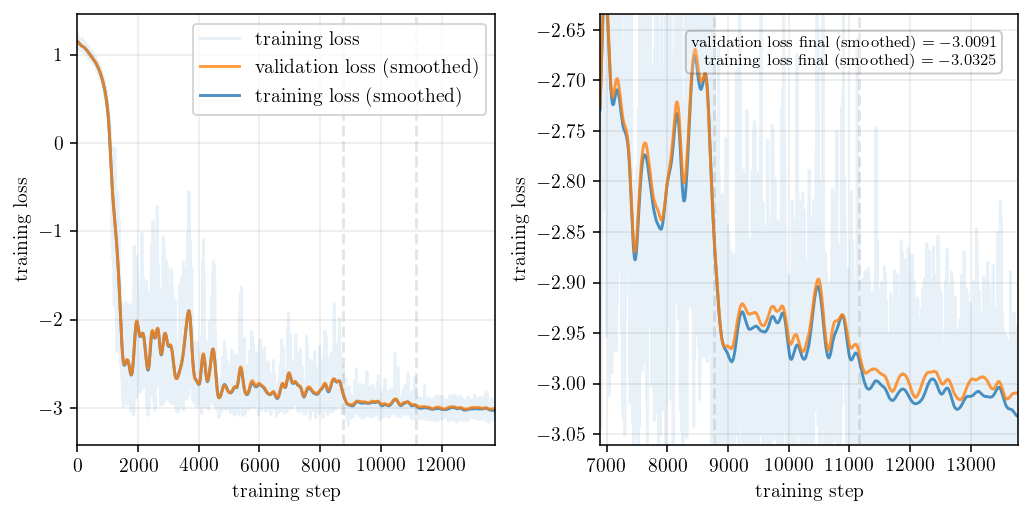

In [18]:
import glob

# Plot the loss
loss_fname = sorted(glob.glob(f'{potential_fname_v2}*loss.txt'))[-1]
print(f'Displaying {loss_fname}')
loss_history, val_loss_history, lr_history, loss_noreg_history, _ = utils.load_loss_history(loss_fname)
utils.plot_loss(loss_history, val_loss_hist=val_loss_history, lr_hist=lr_history, smoothing='auto');

Plotting 2D slices of matter density ...
  --> (x, y)


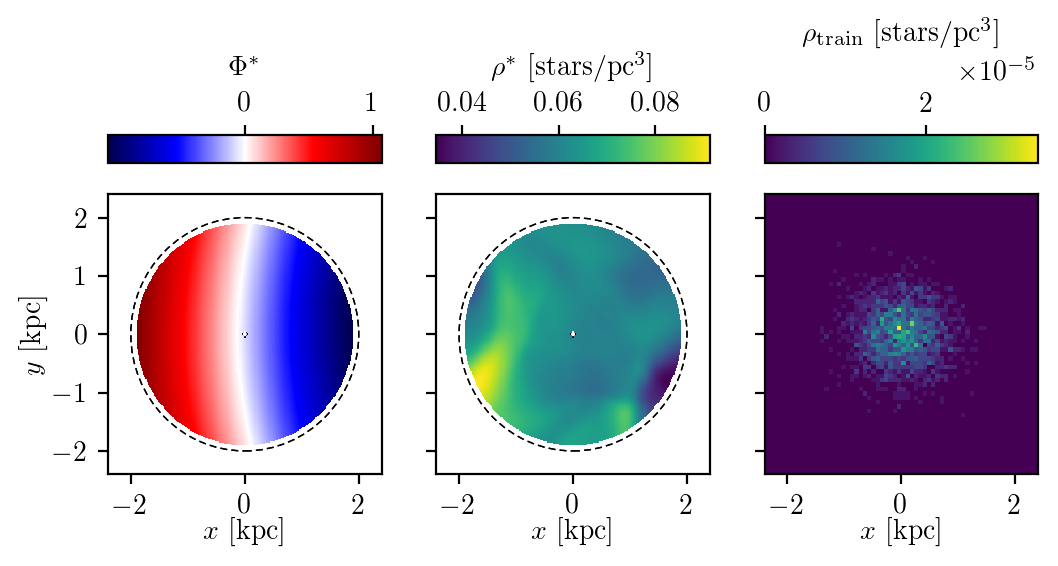

In [20]:
print('Plotting 2D slices of matter density ...')
dims = [
    ('x', 'y', 'z', 0.),
]
for dim1, dim2, dimz, z in dims:
    print(f'  --> ({dim1}, {dim2})')
    plot_gaia.plot_rho(phi_model, coords_train, None, dim1, dim2, dimz, z, padding=0.95, attrs=attrs, save=False)
    plt.show()

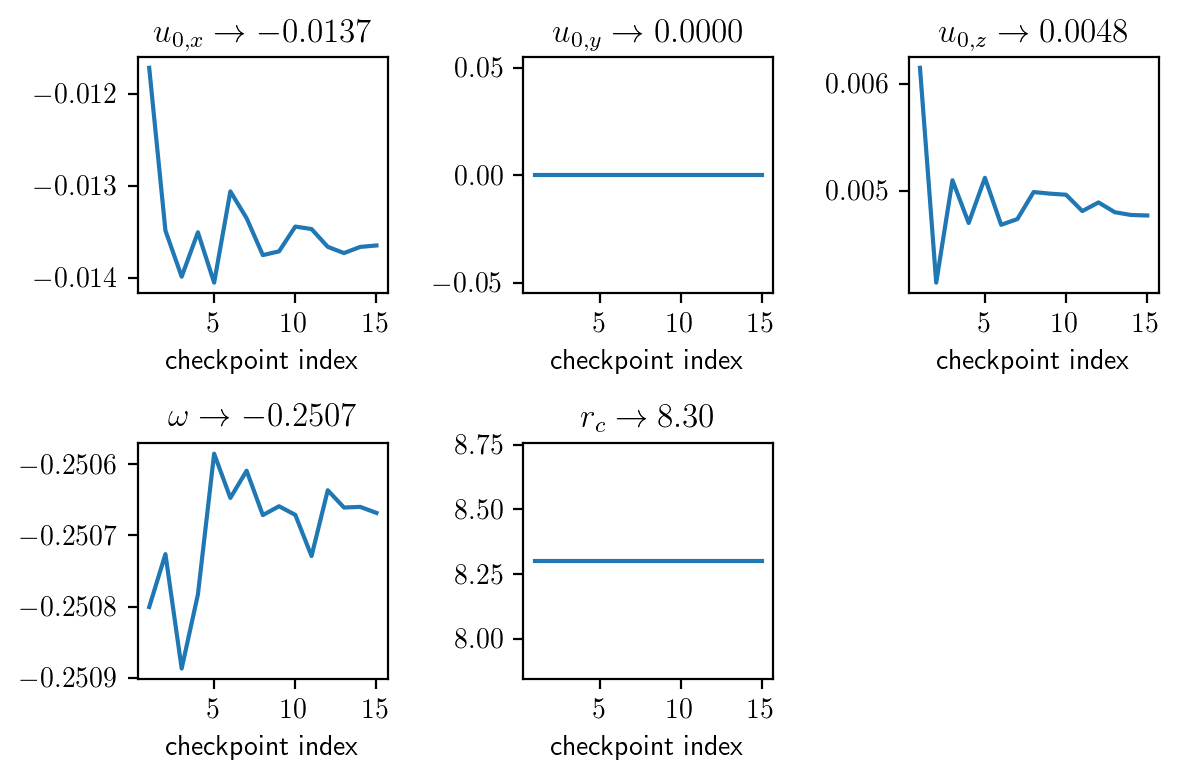

In [19]:
import glob

if os.path.isdir(potential_fname) and fname[-1] != '/':
    potential_fname = potential_fname + '/'
directory, tail = os.path.split(potential_fname_v2)


indices = np.array(glob.glob(f'{directory}/*.index'))
numbers = np.array([int(x[x.rfind('-') + 1:x.rfind('.index')]) for x in indices])
indices = indices[np.argsort(numbers)]
numbers = numbers[np.argsort(numbers)]

u0xs, u0ys, u0zs, omegas, r_cs = [], [], [], [], []
for i, index in enumerate(indices):
    fs = potential_tf.FrameShift.load_checkpoint_with_id(directory, numbers[i], verbose=False)
    u0xs.append(fs._u_x.numpy())
    u0ys.append(fs._u_y.numpy())
    u0zs.append(fs._u_z.numpy())
    omegas.append(fs._omega.numpy())
    r_cs.append(fs._r_c.numpy())


fig,(axs) = plt.subplots(
    2, 3,
    figsize=(6,4),
    dpi=200,
    gridspec_kw=dict(width_ratios=[2,2,2], height_ratios=[2, 2]))

axs[0, 0].plot(numbers, u0xs)
axs[0, 0].set_title(f"$u_{{0, x}}\\rightarrow{u0xs[-1]:.4f}$")
axs[0, 1].plot(numbers, u0ys)
axs[0, 1].set_title(f"$u_{{0, y}}\\rightarrow{u0ys[-1]:.4f}$")
axs[0, 2].plot(numbers, u0zs)
axs[0, 2].set_title(f"$u_{{0, z}}\\rightarrow{u0zs[-1]:.4f}$")
axs[1, 0].plot(numbers, omegas)
axs[1, 0].set_title(f"$\omega\\rightarrow{omegas[-1]:.4f}$")
axs[1, 1].plot(numbers, r_cs)
axs[1, 1].set_title(f"$r_c\\rightarrow{r_cs[-1]:.2f}$")

for row in axs:
    for ax in row:
        ax.set_xlabel('checkpoint index')
axs[1, 2].axis('off')
plt.tight_layout()